# Global Imports

In [1]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from einops import rearrange
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn
from typing import Any
import glob
import re
from datetime import datetime
import random
from collections import defaultdict
from collections import Counter
from torchinfo import summary
from torch.nn.utils.rnn import pad_sequence

random.seed(42)

# Local Imports

In [2]:
from training.train import EpochLogs, grid_search, LogPoint
from dataset.word_dataset import WordImageDataset
from models.allcnn2d import AllCNN2D
from models.allcnn2d_rnn import CNNRNNModel

# Globals

In [3]:
DATASET_SPLIT: float = 0.8
MODEL_NAME: str = "CNN_APL_RNN_v1"
LOAD_CHECKPOINT: str = r"C:\Users\Leon\visual-studio\repos\Le-o-n\ocr-model-training\src\cnn_lora\20250421_153213__BEST_APL_MODEL_V5__Epoch13_tLoss1.75856_tL153.07858_tMSE38.59373_tAcc0.57354_vLoss1.04812_vL154.07807_vMSE41.83569_vAcc0.70611.pt"

# Define Paths
Workspace

In [4]:
notebook_dir: str = os.path.abspath(".")
root_dir: str = os.path.join(
    notebook_dir,
    os.pardir,
    os.pardir
)

data_dir: str = os.path.join(
    root_dir,
    "data",
    "apl_dataset"
)

model_save_dirpath: str = os.path.join(
    root_dir,
    "models",
    "allcnn"
)


Image paths

In [5]:

images_path_glob: str = os.path.join(
    data_dir,
    "u*.png"
)
images_path_regex: str = r"(u[0-9a-f]+)[-]+([0-9]+)\.png"

image_paths: list[str] = glob.glob(images_path_glob)
random.shuffle(image_paths)

len(image_paths)

15298

# Helper Functions

In [6]:
def get_current_time() -> str:
    return datetime.now().strftime("%Y-%m-%d-%H-%M-%S")


# Logging Setup 

In [7]:

logging_path: str = f"{MODEL_NAME}_log_{get_current_time()}.csv"

with open(logging_path, "w") as f:
    f.write("TIME,EPOCH,TRAIN_ACC,VAL_ACC,TRAIN_LOSS,VAL_LOSS,LR\n")

def log(
    epoch: int,
    train_acc: float, 
    train_loss: float, 
    val_acc: float, 
    val_loss, 
    lr: float
)-> None:
    with open(logging_path, "a") as f:
        f.write(f"{get_current_time()},{epoch},{train_acc},{val_acc},{train_loss},{val_loss},{lr}\n")

# Extract Labels From File Names

In [8]:


labeled_image_paths: list[tuple[str, str]] = []

class_counts: dict[str, int] = defaultdict(lambda: 0)

file_path: str
for file_path in image_paths:
    match = re.search(images_path_regex, file_path)
    
    if not match:
        continue
    
    u_hexvalue: str = match.group(1)[1:]
    
    char: str = chr(int(u_hexvalue, base=16))
    
    
    class_counts[char] += 1
    
    
    labeled_image_paths.append((char, file_path))

labels: list[str]
image_paths: list[str]
labels, image_paths =  list(zip(*labeled_image_paths))

len(labels), len(image_paths)

(14770, 14770)

In [9]:
Counter(labels)

Counter({'⍝': 333,
         '⍬': 126,
         '⋄': 122,
         '2': 118,
         '5': 117,
         '⍵': 117,
         '6': 116,
         '9': 116,
         '7': 116,
         '∇': 116,
         '1': 116,
         '8': 116,
         '4': 116,
         '3': 116,
         '0': 115,
         'S': 115,
         'x': 115,
         '⍺': 115,
         'Q': 115,
         'R': 115,
         'P': 115,
         'K': 115,
         'W': 115,
         'p': 115,
         'D': 114,
         'J': 114,
         'Y': 114,
         't': 114,
         'L': 114,
         'w': 114,
         'O': 114,
         'B': 114,
         'b': 114,
         'v': 114,
         'm': 114,
         'k': 114,
         'e': 114,
         'Z': 114,
         'l': 114,
         'c': 114,
         'F': 114,
         'h': 114,
         'E': 114,
         'H': 114,
         'C': 114,
         'a': 114,
         'V': 114,
         'n': 114,
         'X': 114,
         'z': 114,
         'j': 114,
         'q': 114,
         'u'

# Balance Classes Using Oversample/Undersample

In [10]:
sorted_counts: list[tuple[str, int]] = sorted(
    class_counts.items(), 
    key=lambda x: x[0]
)

counts: list[int] = [pair[1] for pair in sorted_counts]

max_count: int = max(counts)
min_count: int = min(counts)

to_add_counts: dict[str, int] = {
    uid: max_count - count 
    for uid, count in 
    sorted_counts
}

to_undersample_counts: dict[str, int] = {
    uid: min_count
    for uid, count in 
    sorted_counts
}

total_items = sum(x[1] for x in sorted_counts)


In [11]:
min_count, max_count, total_items

(61, 333, 14770)

In [12]:
#print(*to_add_counts.items())
#print(sorted([(chr(int(pair[0][1:], 16)), pair[1]) for pair in to_remove_counts.items()], key=lambda x: x[1]))

# Oversample

In [13]:
#to_add_labels: list[str] = []
#to_add_file_paths: list[str] = []
#
#while True in [to_add_count>0 for to_add_count in to_add_counts.values()]:  
#    for label, image_path in zip(labels, image_paths):
#        remaining: int = to_add_counts[label]
#        
#        if remaining > 0:
#            to_add_labels.append(label)
#            to_add_file_paths.append(image_path)
#            to_add_counts[label] -= 1

# Undersample

In [14]:
to_keep_labels: list[str] = []
to_keep_file_paths: list[str] = []

while True in [to_add_count>0 for to_add_count in to_undersample_counts.values()]:  
    for label, image_path in zip(labels, image_paths):
        remaining: int = to_undersample_counts[label]
        
        if remaining > 0:
            to_keep_labels.append(label)
            to_keep_file_paths.append(image_path)
            to_undersample_counts[label] -= 1

In [15]:
to_keep_labels

['0',
 '.',
 '⍨',
 'D',
 '○',
 '⌿',
 'J',
 '%',
 '?',
 'S',
 'Y',
 '∧',
 'D',
 '⍢',
 '↓',
 '⊤',
 't',
 ',',
 'L',
 'w',
 'x',
 'O',
 '⍺',
 'Q',
 'B',
 '#',
 'R',
 'b',
 'v',
 '£',
 '⍤',
 '⊂',
 'm',
 '{',
 'k',
 'm',
 'e',
 'Y',
 '⊖',
 '*',
 '6',
 ';',
 ']',
 '⍝',
 '⍸',
 '∨',
 '.',
 'Z',
 '9',
 'w',
 'Q',
 'P',
 '⊆',
 '⊤',
 'l',
 '⍤',
 '⌸',
 '⌿',
 'c',
 'F',
 ')',
 ';',
 '<',
 'h',
 '⍝',
 '7',
 'm',
 'E',
 'F',
 "'",
 'Q',
 'h',
 '^',
 '∇',
 'F',
 'm',
 ':',
 'K',
 'H',
 'h',
 '⊇',
 'J',
 '<',
 'C',
 ']',
 '⍝',
 '[',
 '(',
 'k',
 'a',
 'V',
 '´',
 '⊃',
 '$',
 'b',
 '⍕',
 '⍴',
 'n',
 '⍳',
 '/',
 '´',
 'Q',
 '1',
 '⊂',
 'R',
 '6',
 'X',
 '⊖',
 '%',
 ';',
 'Z',
 '∧',
 '⍙',
 '(',
 '⊇',
 'x',
 '⍕',
 'S',
 'w',
 'x',
 '÷',
 '⋄',
 '⌽',
 ';',
 '⎕',
 'z',
 '8',
 '£',
 'j',
 'm',
 'q',
 'h',
 'b',
 '⊇',
 ',',
 '\\',
 '1',
 'W',
 'E',
 '⍝',
 'v',
 'p',
 'P',
 '¯',
 '/',
 '|',
 '@',
 '4',
 '|',
 '⍉',
 ';',
 'u',
 'P',
 '2',
 '2',
 'i',
 '≢',
 '\\',
 '⍳',
 '*',
 '¯',
 'Z',
 'h',
 '⌽',
 '7',
 'I',
 '

In [16]:

Counter(to_keep_labels), sorted(list(set(to_keep_labels)))

(Counter({'0': 61,
          '.': 61,
          '⍨': 61,
          'D': 61,
          '○': 61,
          '⌿': 61,
          'J': 61,
          '%': 61,
          '?': 61,
          'S': 61,
          'Y': 61,
          '∧': 61,
          '⍢': 61,
          '↓': 61,
          '⊤': 61,
          't': 61,
          ',': 61,
          'L': 61,
          'w': 61,
          'x': 61,
          'O': 61,
          '⍺': 61,
          'Q': 61,
          'B': 61,
          '#': 61,
          'R': 61,
          'b': 61,
          'v': 61,
          '£': 61,
          '⍤': 61,
          '⊂': 61,
          'm': 61,
          '{': 61,
          'k': 61,
          'e': 61,
          '⊖': 61,
          '*': 61,
          '6': 61,
          ';': 61,
          ']': 61,
          '⍝': 61,
          '⍸': 61,
          '∨': 61,
          'Z': 61,
          '9': 61,
          'P': 61,
          '⊆': 61,
          'l': 61,
          '⌸': 61,
          'c': 61,
          'F': 61,
          ')': 61,
          '<

# Load Dataset

In [17]:
image_paths = to_keep_file_paths
labels = to_keep_labels
len(image_paths), len(labels)

(10309, 10309)

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split

def stratified_split(file_paths, labels, test_size=0.15, val_size=0.15, min_val_samples=1, random_state=42):
    """
    Stratified split with minimum samples per class in all splits
    
    Args:
        file_paths: List of lists of paths - [[class1_paths], [class2_paths], ...]
        labels: List of class labels corresponding to file_paths
        test_size: Proportion for test split
        val_size: Proportion for validation split (relative to remaining after test)
        min_samples: Minimum samples per class in each split (default=1)
    """
    # Flatten structure and create label array
    
    # Convert to numpy arrays
    X = np.array(file_paths)
    y = np.array(labels)
    unique_classes = np.unique(y)
    
    # First split: test with min samples per class
    test_indices = []
    for cls in unique_classes:
        cls_indices = np.where(y == cls)[0]
        n_test = int(test_size * len(cls_indices))
        test_indices.extend(np.random.choice(cls_indices, n_test, replace=False))
    
    # Remaining indices for train/val
    remaining_mask = ~np.isin(np.arange(len(X)), test_indices)
    X_remaining, y_remaining = X[remaining_mask], y[remaining_mask]
    
    # Second split: validation from remaining
    val_indices = []
    for cls in unique_classes:
        cls_indices = np.where(y_remaining == cls)[0]
        n_val = max(min_val_samples, int(val_size * len(cls_indices)))
        val_indices.extend(np.random.choice(cls_indices, n_val, replace=False))
    
    # Final indices
    train_mask = ~np.isin(np.arange(len(X_remaining)), val_indices)
    return (
        X_remaining[train_mask].tolist(), y_remaining[train_mask].tolist(),  # Train
        X_remaining[val_indices].tolist(), y_remaining[val_indices].tolist(),  # Val
        X[test_indices].tolist(), y[test_indices].tolist()  # Test
    )



In [19]:



train_x, train_y, val_x, val_y, test_x, test_y = stratified_split(image_paths, labels, val_size=0.15, min_val_samples=1, test_size=0.00)

print(f"Train ({len(train_x)}): {train_x} {train_y}")
print(f"Val   ({len(val_x)}): {val_x} {val_y}")
print(f"Test  ({len(test_x)}): {test_x} {test_y}")

Train (8788): ['c:\\Users\\Leon\\visual-studio\\repos\\Le-o-n\\ocr-model-training\\src\\cnn_rnn\\..\\..\\data\\apl_dataset\\u30-1735555823282.png', 'c:\\Users\\Leon\\visual-studio\\repos\\Le-o-n\\ocr-model-training\\src\\cnn_rnn\\..\\..\\data\\apl_dataset\\u2e-1730826132314.png', 'c:\\Users\\Leon\\visual-studio\\repos\\Le-o-n\\ocr-model-training\\src\\cnn_rnn\\..\\..\\data\\apl_dataset\\u25cb-1731581682672.png', 'c:\\Users\\Leon\\visual-studio\\repos\\Le-o-n\\ocr-model-training\\src\\cnn_rnn\\..\\..\\data\\apl_dataset\\u233f-1731099568754.png', 'c:\\Users\\Leon\\visual-studio\\repos\\Le-o-n\\ocr-model-training\\src\\cnn_rnn\\..\\..\\data\\apl_dataset\\u4a-1730734304252.png', 'c:\\Users\\Leon\\visual-studio\\repos\\Le-o-n\\ocr-model-training\\src\\cnn_rnn\\..\\..\\data\\apl_dataset\\u25-1730826131785.png', 'c:\\Users\\Leon\\visual-studio\\repos\\Le-o-n\\ocr-model-training\\src\\cnn_rnn\\..\\..\\data\\apl_dataset\\u53-1730734308909.png', 'c:\\Users\\Leon\\visual-studio\\repos\\Le-o-n\\oc

# Get valid words

In [35]:
#import pandas as pd
#valid_words = pd.read_csv("metadata-lambda.csv")["line"].to_list()

#num_words = len(valid_words)

#train_words = valid_words[:int(num_words*0.8)]
#val_words = valid_words[int(num_words*0.8):]

#MAX_LEN: int = 10

#train_words = [word[:MAX_LEN] if len(word) >= 10 else word for word in train_words]
#val_words = [word[:MAX_LEN] if len(word) >= 10 else word for word in val_words]


import random

with open("apl_lines.txt", "r", encoding="utf-8") as f:
    
    _lines = []
    
    for word in f.readlines():
        word = word.strip()
        
        _pivot = random.randint(0, len(word))
        
        left = word[:_pivot]
        right = word[_pivot:]
        
        word = right + left
        
        _lines.append(word)


_split_index = int(len(_lines)*0.999)

train_words = _lines[:_split_index]
val_words = _lines[_split_index:]

len(train_words), len(val_words)

(73398, 74)

# Load Dataloaders

In [36]:
all_label_classes = list('!"#$%&\'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~£¨¯´·×÷←↑→↓∆∇∊∘√∣∧∨∩∪≠≡≢≤≥⊂⊃⊆⊇⊖⊢⊣⊤⊥⋄⌈⌊⌶⌷⌸⌹⌺⌽⌿⍀⍉⍋⍎⍒⍕⍙⍛⍝⍞⍟⍠⍢⍣⍤⍥⍨⍪⍫⍬⍱⍲⍳⍴⍵⍷⍸⍺⎕○')
len(all_label_classes)

169

In [37]:

train_char_dataset: WordImageDataset = WordImageDataset(
    words=train_words,
    file_paths=train_x, #list(image_paths[:split_index]) + to_add_file_paths,
    labels=train_y, #list(labels[:split_index]) + to_add_labels,
    all_label_classes=all_label_classes,
    rotation_limit=0.05,
    translation_limit=0.2,
    skew_limit=0.02,
    zoom_change=1.2,
    min_zoom=0.8,
    thicken_sigma=-4.9,
    image_dims=(64, 64)
)

val_char_dataset: WordImageDataset = WordImageDataset(
    words=val_words,
    file_paths=val_x,
    labels=val_y,
    all_label_classes=all_label_classes,
    rotation_limit=0.0,
    translation_limit=0.0,
    skew_limit=0.00,
    zoom_change=0.0,
    min_zoom=1.0,
    thicken_sigma=0.0,
    image_dims=(64, 64)
)




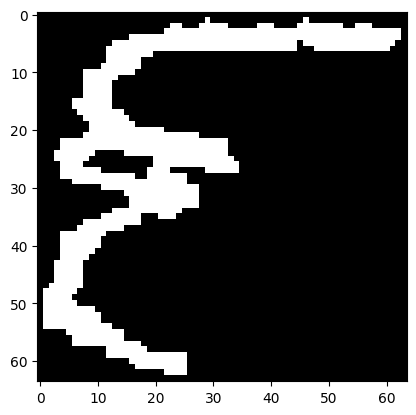

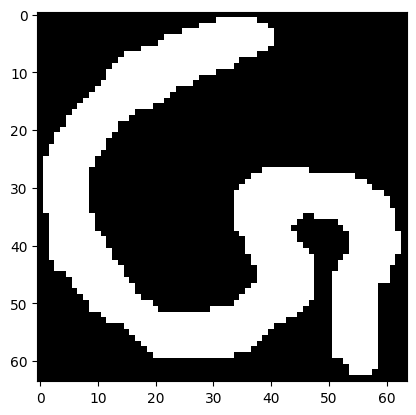

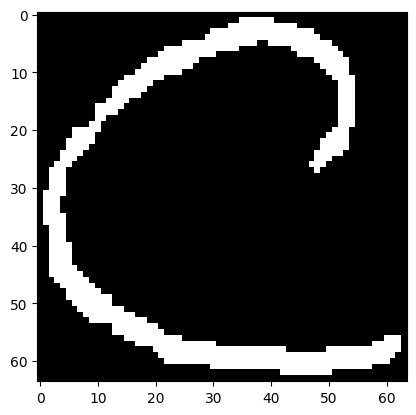

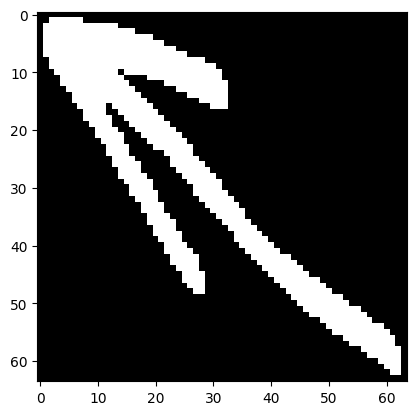

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [38]:
for im, lab in train_char_dataset:
    
    for letter in im:
    
        plt.imshow(
            rearrange(letter, "1 h w -> h w")*255, 
            cmap="gray"
        )
        plt.show()
    
    print(lab)
    break

# Load DataLoader

In [39]:
def collate_fn(batch):
    """
    Collate function to pad sequences to the same length.
    """
    # Separate images and labels
    images, labels = zip(*batch)

    # Pad image sequences
    images_padded = pad_sequence(images, batch_first=True, padding_value=0.0)

    # Pad label sequences
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=0.0)

    return images_padded, labels_padded

train_dataloader: DataLoader = DataLoader(
    train_char_dataset,
    shuffle=True,
    batch_size=4,
    collate_fn=collate_fn
)

val_dataloader: DataLoader = DataLoader(
    val_char_dataset,
    shuffle=False,
    batch_size=4,
    collate_fn=collate_fn
)

In [40]:
sorted(class_counts.keys()), len(sorted(class_counts.keys()))

(['!',
  '"',
  '#',
  '$',
  '%',
  '&',
  "'",
  '(',
  ')',
  '*',
  '+',
  ',',
  '-',
  '.',
  '/',
  '0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  ':',
  ';',
  '<',
  '=',
  '>',
  '?',
  '@',
  'A',
  'B',
  'C',
  'D',
  'E',
  'F',
  'G',
  'H',
  'I',
  'J',
  'K',
  'L',
  'M',
  'N',
  'O',
  'P',
  'Q',
  'R',
  'S',
  'T',
  'U',
  'V',
  'W',
  'X',
  'Y',
  'Z',
  '[',
  '\\',
  ']',
  '^',
  '_',
  '`',
  'a',
  'b',
  'c',
  'd',
  'e',
  'f',
  'g',
  'h',
  'i',
  'j',
  'k',
  'l',
  'm',
  'n',
  'o',
  'p',
  'q',
  'r',
  's',
  't',
  'u',
  'v',
  'w',
  'x',
  'y',
  'z',
  '{',
  '|',
  '}',
  '~',
  '£',
  '¨',
  '¯',
  '´',
  '·',
  '×',
  '÷',
  '←',
  '↑',
  '→',
  '↓',
  '∆',
  '∇',
  '∊',
  '∘',
  '√',
  '∣',
  '∧',
  '∨',
  '∩',
  '∪',
  '≠',
  '≡',
  '≢',
  '≤',
  '≥',
  '⊂',
  '⊃',
  '⊆',
  '⊇',
  '⊖',
  '⊢',
  '⊣',
  '⊤',
  '⊥',
  '⋄',
  '⌈',
  '⌊',
  '⌶',
  '⌷',
  '⌸',
  '⌹',
  '⌺',
  '⌽',
  '⌿',
  '⍀',
  '⍉',
  '⍋',
  '⍎'

# Prepare Pretrained CNN Encoder

In [41]:



cnn_model: nn.Module = AllCNN2D(
    **{
        "conv_features": (1, 16, 32, 32, 32),
        "fully_connected_features": (256, 256),
        "expected_input_size": (64, 64),
        "device": "cuda",
        "conv_dropout": 0.05,
        "verbose": True,
        "name_prefix": MODEL_NAME,
        "checkpoint_path": LOAD_CHECKPOINT,
        "frozen_layer_prefixes": [],
        
    }
)


cnn_rnn_model: nn.Module = CNNRNNModel(
    cnn_model,
    rnn_type="rnn",
    rnn_num_layers = 4,
    num_classes=len(all_label_classes)
)

for param_name, param in cnn_rnn_model.named_parameters():
    if "rnn" in param_name:
        param.requires_grad = True
        print(f"[UNFREEZE] {param_name}")
        continue
    if "fc" in param_name:
        param.requires_grad = True
        print(f"[UNFREEZE] {param_name}")
        continue
    print(f"[FREEZE]   {param_name}")

    param.requires_grad = False
    
summary(cnn_rnn_model, (1, 2, 1, 64, 64))


Loaded: encoder_conv_blocks.0.0.weight
Loaded: encoder_conv_blocks.0.0.bias
Loaded: encoder_conv_blocks.0.2.weight
Loaded: encoder_conv_blocks.0.2.bias
Loaded: encoder_conv_blocks.0.2.running_mean
Loaded: encoder_conv_blocks.0.2.running_var
Loaded: encoder_conv_blocks.0.2.num_batches_tracked
Loaded: encoder_conv_blocks.0.4.weight
Loaded: encoder_conv_blocks.0.4.bias
Loaded: encoder_conv_blocks.0.6.weight
Loaded: encoder_conv_blocks.0.6.bias
Loaded: encoder_conv_blocks.0.6.running_mean
Loaded: encoder_conv_blocks.0.6.running_var
Loaded: encoder_conv_blocks.0.6.num_batches_tracked
Loaded: encoder_conv_blocks.1.0.weight
Loaded: encoder_conv_blocks.1.0.bias
Loaded: encoder_conv_blocks.1.2.weight
Loaded: encoder_conv_blocks.1.2.bias
Loaded: encoder_conv_blocks.1.2.running_mean
Loaded: encoder_conv_blocks.1.2.running_var
Loaded: encoder_conv_blocks.1.2.num_batches_tracked
Loaded: encoder_conv_blocks.1.4.weight
Loaded: encoder_conv_blocks.1.4.bias
Loaded: encoder_conv_blocks.1.6.weight
Loaded

Layer (type:depth-idx)                   Output Shape              Param #
CNNRNNModel                              [1, 2, 169]               --
├─AllCNN2D: 1-1                          --                        197,120
│    └─ModuleList: 2-1                   --                        --
│    │    └─Sequential: 3-1              [2, 16, 32, 32]           (2,544)
│    │    └─Sequential: 3-2              [2, 32, 16, 16]           (14,016)
│    │    └─Sequential: 3-3              [2, 32, 8, 8]             (18,624)
│    │    └─Sequential: 3-4              [2, 32, 4, 4]             (18,624)
│    └─Sequential: 2-2                   [2, 512]                  --
│    │    └─Flatten: 3-5                 [2, 512]                  --
├─RNN: 1-2                               [1, 2, 128]               181,248
├─Linear: 1-3                            [1, 2, 169]               21,801
Total params: 453,977
Trainable params: 203,049
Non-trainable params: 250,928
Total mult-adds (M): 28.08
Input size (M

# Create RNNCNN

# Create Optimiser

In [42]:
optim_parameters = {
    "lr": 0.00001,
    "weight_decay": 1e-4
}


optim: AdamW = AdamW(cnn_rnn_model.parameters(), **optim_parameters)

scheduler: torch.optim.lr_scheduler.LRScheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optim,
    T_0=5,
    T_mult=2
)

# Train

In [43]:
DEVICE: str = "cuda" if torch.cuda.is_available() else "cpu"

In [44]:
import torch
import torch.nn.functional as F
import tqdm
import os
import csv
from datetime import datetime
from IPython.display import clear_output



In [45]:
from torch.utils.data import SubsetRandomSampler

# Setup
SESSION_STARTTIME_STR = datetime.now().strftime("%Y%m%d_%H%M%S")
MODEL_NAME = "APL_RNN_FINAL_BEST_V1"
CSV_LOG_FILE = f"{SESSION_STARTTIME_STR}__{MODEL_NAME}__training_metric.csv"

# Write CSV header if file doesn't exist
if not os.path.isfile(CSV_LOG_FILE):
    with open(CSV_LOG_FILE, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            "epoch",
            "train_loss", "train_acc",
            "val_loss", "val_acc"
        ])

# Training loop
num_epochs = 2000
subset_size = 400  # Number of random training samples per epoch

for epoch in range(num_epochs):
    # Create a new subset of training data each epoch
    subset_indices = torch.randperm(len(train_dataloader.dataset))[:subset_size]
    subset_sampler = SubsetRandomSampler(subset_indices)
    train_loader = torch.utils.data.DataLoader(
        train_dataloader.dataset,
        batch_size=train_dataloader.batch_size,
        sampler=subset_sampler,
        num_workers=train_dataloader.num_workers,
        collate_fn=train_dataloader.collate_fn,
        pin_memory=train_dataloader.pin_memory
    )
    train_loader = tqdm.tqdm(train_loader, desc=f"Epoch {epoch + 1} - Training", leave=False)

    cnn_rnn_model.train()
    train_loss_total = 0.0
    train_correct = 0
    train_samples = 0

    for X, y in train_loader:
        X = X.to(DEVICE)
        y = y.to(DEVICE)

        y_pred = cnn_rnn_model(X)
        y_flat = y.argmax(dim=-1)
        batch_size, seq_len, num_classes = y_pred.size()
        y_pred_flat = y_pred.view(-1, num_classes)
        y_flat = y_flat.view(-1)

        loss = F.cross_entropy(y_pred_flat, y_flat, reduction='mean')

        optim.zero_grad()
        loss.backward()
        optim.step()

        train_loss_total += loss.item() * X.size(0)
        preds = y_pred.argmax(dim=-1).view(-1)
        train_correct += (preds == y_flat).sum().item()
        train_samples += X.size(0) * X.size(1)

        scheduler.step(epoch + train_samples / len(train_dataloader.dataset))

        train_loader.set_postfix({
            "Loss": f"{loss.item():.4f}",
            "Acc": f"{(train_correct / train_samples):.4f}%"
        })

    # Validation
    cnn_rnn_model.eval()
    val_loss_total = 0.0
    val_correct = 0
    val_samples = 0

    val_loader = tqdm.tqdm(val_dataloader, desc=f"Epoch {epoch + 1} - Validation", leave=False)
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val = X_val.to(DEVICE)
            y_val = y_val.to(DEVICE)

            y_val_pred = cnn_rnn_model(X_val)
            y_val_flat = y_val.argmax(dim=-1)
            batch_size, seq_len, num_classes = y_val_pred.size()
            y_val_pred_flat = y_val_pred.view(-1, num_classes)
            y_val_flat = y_val_flat.view(-1)

            val_loss = F.cross_entropy(y_val_pred_flat, y_val_flat, reduction='mean')

            val_loss_total += val_loss.item() * X_val.size(0)
            val_preds = y_val_pred.argmax(dim=-1).view(-1)
            val_correct += (val_preds == y_val_flat).sum().item()
            val_samples += X_val.size(0) * X_val.size(1)

            val_loader.set_postfix({
                "Loss": f"{val_loss.item():.4f}",
                "Acc": f"{(val_correct / val_samples):.4f}%"
            })

    # Averages
    train_loss_avg = train_loss_total / train_samples if train_samples > 0 else -1
    train_acc = train_correct / train_samples if train_samples > 0 else -1
    val_loss_avg = val_loss_total / val_samples if val_samples > 0 else -1
    val_acc = val_correct / val_samples if val_samples > 0 else -1

    # Save metrics to CSV
    with open(CSV_LOG_FILE, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            epoch + 1,
            train_loss_avg, train_acc,
            val_loss_avg, val_acc
        ])

    # Save model
    model_filename = (
        f"{SESSION_STARTTIME_STR}__{MODEL_NAME}__"
        f"Epoch{epoch + 1}_"
        f"tLoss{train_loss_avg:.5f}_tAcc{train_acc:.5f}_"
        f"vLoss{val_loss_avg:.5f}_vAcc{val_acc:.5f}.pt"
    )
    try:
        print("Saving model")
        torch.save(cnn_rnn_model.state_dict(), model_filename)
        print(model_filename)
    except Exception as e:
        print(f"Error saving model: {e}")


Epoch 1 - Training:   1%|          | 1/100 [00:03<05:09,  3.13s/it, Loss=5.0947, Acc=0.0050%]

torch.Size([4, 50, 512])


Epoch 1 - Training:   2%|▏         | 2/100 [00:06<05:15,  3.22s/it, Loss=5.1076, Acc=0.0051%]

torch.Size([4, 49, 512])
torch.Size([4, 106, 512])


Epoch 1 - Training:   4%|▍         | 4/100 [00:09<03:28,  2.17s/it, Loss=5.1017, Acc=0.0030%]

torch.Size([4, 42, 512])


Epoch 1 - Training:   5%|▌         | 5/100 [00:11<03:08,  1.99s/it, Loss=5.1254, Acc=0.0027%]

torch.Size([4, 32, 512])


Epoch 1 - Training:   6%|▌         | 6/100 [00:12<02:37,  1.68s/it, Loss=5.0924, Acc=0.0025%]

torch.Size([4, 24, 512])


Epoch 1 - Training:   7%|▋         | 7/100 [00:14<02:40,  1.73s/it, Loss=5.1235, Acc=0.0023%]

torch.Size([4, 21, 512])


Epoch 1 - Training:   8%|▊         | 8/100 [00:18<03:37,  2.36s/it, Loss=5.0516, Acc=0.0035%]

torch.Size([4, 99, 512])


Epoch 1 - Training:   9%|▉         | 9/100 [00:21<04:13,  2.79s/it, Loss=5.0587, Acc=0.0035%]

torch.Size([4, 78, 512])


Epoch 1 - Training:  10%|█         | 10/100 [00:24<04:00,  2.67s/it, Loss=5.0419, Acc=0.0031%]

torch.Size([4, 61, 512])


Epoch 1 - Training:  11%|█         | 11/100 [00:26<03:51,  2.60s/it, Loss=5.0423, Acc=0.0033%]

torch.Size([4, 47, 512])


Epoch 1 - Training:  12%|█▏        | 12/100 [00:31<04:42,  3.21s/it, Loss=5.0713, Acc=0.0036%]

torch.Size([4, 93, 512])


Epoch 1 - Training:  13%|█▎        | 13/100 [00:33<04:19,  2.99s/it, Loss=5.0771, Acc=0.0037%]

torch.Size([4, 33, 512])
torch.Size([4, 74, 512])


Epoch 1 - Training:  14%|█▍        | 14/100 [00:38<04:49,  3.37s/it, Loss=5.0522, Acc=0.0034%]

torch.Size([4, 74, 512])


Epoch 1 - Training:  15%|█▌        | 15/100 [00:40<04:16,  3.02s/it, Loss=4.9997, Acc=0.0031%]

torch.Size([4, 58, 512])


Epoch 1 - Training:  17%|█▋        | 17/100 [00:46<04:01,  2.91s/it, Loss=5.0167, Acc=0.0040%]

torch.Size([4, 56, 512])
torch.Size([4, 51, 512])


Epoch 1 - Training:  19%|█▉        | 19/100 [00:51<03:43,  2.76s/it, Loss=5.0047, Acc=0.0056%]

torch.Size([4, 22, 512])
torch.Size([4, 20, 512])


Epoch 1 - Training:  20%|██        | 20/100 [00:53<03:21,  2.52s/it, Loss=5.0848, Acc=0.0062%]

torch.Size([4, 72, 512])


Epoch 1 - Training:  22%|██▏       | 22/100 [00:59<03:34,  2.75s/it, Loss=5.0702, Acc=0.0145%]

torch.Size([4, 46, 512])


Epoch 1 - Training:  23%|██▎       | 23/100 [01:01<03:06,  2.42s/it, Loss=5.0380, Acc=0.0157%]

torch.Size([4, 17, 512])


Epoch 1 - Training:  24%|██▍       | 24/100 [01:04<03:27,  2.73s/it, Loss=5.0740, Acc=0.0207%]

torch.Size([4, 89, 512])
torch.Size([4, 90, 512])


Epoch 1 - Training:  26%|██▌       | 26/100 [01:12<03:56,  3.19s/it, Loss=4.9653, Acc=0.0540%]

torch.Size([4, 91, 512])


Epoch 1 - Training:  27%|██▋       | 27/100 [01:14<03:41,  3.03s/it, Loss=5.0041, Acc=0.0589%]

torch.Size([4, 51, 512])


Epoch 1 - Training:  28%|██▊       | 28/100 [01:16<03:12,  2.67s/it, Loss=5.0660, Acc=0.0615%]

torch.Size([4, 32, 512])


Epoch 1 - Training:  29%|██▉       | 29/100 [01:18<03:00,  2.54s/it, Loss=4.9738, Acc=0.0718%]

torch.Size([4, 59, 512])


Epoch 1 - Training:  30%|███       | 30/100 [01:21<03:07,  2.68s/it, Loss=4.9591, Acc=0.0826%]

torch.Size([4, 52, 512])


Epoch 1 - Training:  31%|███       | 31/100 [01:25<03:18,  2.87s/it, Loss=4.9473, Acc=0.0933%]

torch.Size([4, 47, 512])
torch.Size([4, 48, 512])


Epoch 1 - Training:  32%|███▏      | 32/100 [01:28<03:32,  3.12s/it, Loss=4.9664, Acc=0.1030%]

torch.Size([4, 112, 512])


Epoch 1 - Training:  34%|███▍      | 34/100 [01:34<03:04,  2.80s/it, Loss=4.9729, Acc=0.1381%]

torch.Size([4, 43, 512])


Epoch 1 - Training:  35%|███▌      | 35/100 [01:36<02:58,  2.74s/it, Loss=4.8684, Acc=0.1453%]

torch.Size([4, 30, 512])
torch.Size([4, 131, 512])


Epoch 1 - Training:  37%|███▋      | 37/100 [01:43<03:06,  2.97s/it, Loss=4.8807, Acc=0.1898%]

torch.Size([4, 94, 512])


Epoch 1 - Training:  38%|███▊      | 38/100 [01:46<03:13,  3.11s/it, Loss=4.9855, Acc=0.1945%]

torch.Size([4, 66, 512])


Epoch 1 - Training:  39%|███▉      | 39/100 [01:48<02:49,  2.77s/it, Loss=5.0357, Acc=0.1953%]

torch.Size([4, 31, 512])


Epoch 1 - Training:  40%|████      | 40/100 [01:52<03:08,  3.15s/it, Loss=4.8124, Acc=0.2114%]

torch.Size([4, 78, 512])
torch.Size([4, 92, 512])


Epoch 1 - Training:  42%|████▏     | 42/100 [01:58<02:55,  3.02s/it, Loss=4.9419, Acc=0.2273%]

torch.Size([4, 61, 512])
torch.Size([4, 96, 512])


Epoch 1 - Training:  44%|████▍     | 44/100 [02:05<03:02,  3.26s/it, Loss=4.7983, Acc=0.2541%]

torch.Size([4, 87, 512])
torch.Size([4, 75, 512])


Epoch 1 - Training:  46%|████▌     | 46/100 [02:11<02:44,  3.05s/it, Loss=4.9180, Acc=0.2647%]

torch.Size([4, 46, 512])


Epoch 1 - Training:  47%|████▋     | 47/100 [02:17<03:21,  3.81s/it, Loss=4.9569, Acc=0.2677%]

torch.Size([4, 93, 512])


Epoch 1 - Training:  48%|████▊     | 48/100 [02:20<03:02,  3.52s/it, Loss=4.8657, Acc=0.2735%]

torch.Size([4, 79, 512])
torch.Size([4, 83, 512])


Epoch 1 - Training:  50%|█████     | 50/100 [02:27<02:49,  3.40s/it, Loss=4.8211, Acc=0.2798%]

torch.Size([4, 32, 512])


Epoch 1 - Training:  51%|█████     | 51/100 [02:30<02:39,  3.25s/it, Loss=4.8088, Acc=0.2851%]

torch.Size([4, 61, 512])
torch.Size([4, 44, 512])


Epoch 1 - Training:  53%|█████▎    | 53/100 [02:37<02:42,  3.46s/it, Loss=4.8120, Acc=0.2944%]

torch.Size([4, 101, 512])


Epoch 1 - Training:  54%|█████▍    | 54/100 [02:40<02:33,  3.34s/it, Loss=4.7236, Acc=0.3004%]

torch.Size([4, 57, 512])
torch.Size([4, 95, 512])


Epoch 1 - Training:  56%|█████▌    | 56/100 [02:44<02:00,  2.75s/it, Loss=4.8892, Acc=0.3122%]

torch.Size([4, 54, 512])


Epoch 1 - Training:  56%|█████▌    | 56/100 [02:49<02:00,  2.75s/it, Loss=5.0719, Acc=0.3085%]

torch.Size([4, 75, 512])


Epoch 1 - Training:  58%|█████▊    | 58/100 [02:50<01:59,  2.84s/it, Loss=4.8375, Acc=0.3106%]

torch.Size([4, 54, 512])
torch.Size([4, 30, 512])


Epoch 1 - Training:  60%|██████    | 60/100 [03:00<02:39,  3.99s/it, Loss=4.9468, Acc=0.3104%]

torch.Size([4, 73, 512])


Epoch 1 - Training:  61%|██████    | 61/100 [03:03<02:24,  3.70s/it, Loss=4.7793, Acc=0.3136%]

torch.Size([4, 65, 512])
torch.Size([4, 58, 512])


Epoch 1 - Training:  62%|██████▏   | 62/100 [03:06<02:14,  3.54s/it, Loss=4.8410, Acc=0.3155%]

torch.Size([4, 76, 512])


Epoch 1 - Training:  64%|██████▍   | 64/100 [03:13<01:59,  3.32s/it, Loss=4.7170, Acc=0.3245%]

torch.Size([4, 49, 512])


Epoch 1 - Training:  65%|██████▌   | 65/100 [03:15<01:39,  2.84s/it, Loss=4.7031, Acc=0.3262%]

torch.Size([4, 29, 512])


Epoch 1 - Training:  66%|██████▌   | 66/100 [03:16<01:25,  2.50s/it, Loss=4.8304, Acc=0.3267%]

torch.Size([4, 19, 512])


Epoch 1 - Training:  67%|██████▋   | 67/100 [03:20<01:36,  2.93s/it, Loss=4.6317, Acc=0.3328%]

torch.Size([4, 76, 512])
torch.Size([4, 140, 512])


Epoch 1 - Training:  68%|██████▊   | 68/100 [03:33<03:04,  5.76s/it, Loss=4.7284, Acc=0.3392%]

torch.Size([4, 99, 512])


Epoch 1 - Training:  70%|███████   | 70/100 [03:40<02:17,  4.57s/it, Loss=4.7794, Acc=0.3429%]

torch.Size([4, 34, 512])


Epoch 1 - Training:  71%|███████   | 71/100 [03:43<02:02,  4.21s/it, Loss=4.9072, Acc=0.3425%]

torch.Size([4, 45, 512])


Epoch 1 - Training:  72%|███████▏  | 72/100 [03:46<01:41,  3.62s/it, Loss=4.6127, Acc=0.3466%]

torch.Size([4, 68, 512])


Epoch 1 - Training:  73%|███████▎  | 73/100 [03:48<01:27,  3.26s/it, Loss=4.6928, Acc=0.3487%]

torch.Size([4, 53, 512])


Epoch 1 - Training:  74%|███████▍  | 74/100 [03:51<01:23,  3.21s/it, Loss=4.7682, Acc=0.3495%]

torch.Size([4, 34, 512])


Epoch 1 - Training:  75%|███████▌  | 75/100 [03:54<01:18,  3.15s/it, Loss=4.6136, Acc=0.3530%]

torch.Size([4, 64, 512])


Epoch 1 - Training:  76%|███████▌  | 76/100 [03:56<01:03,  2.65s/it, Loss=4.5578, Acc=0.3568%]

torch.Size([4, 63, 512])
torch.Size([4, 43, 512])


Epoch 1 - Training:  78%|███████▊  | 78/100 [04:07<01:31,  4.17s/it, Loss=4.5962, Acc=0.3609%]

torch.Size([4, 97, 512])


Epoch 1 - Training:  79%|███████▉  | 79/100 [04:10<01:24,  4.04s/it, Loss=4.6290, Acc=0.3638%]

torch.Size([4, 75, 512])
torch.Size([4, 96, 512])


Epoch 1 - Training:  81%|████████  | 81/100 [04:18<01:17,  4.06s/it, Loss=4.6156, Acc=0.3688%]

torch.Size([4, 60, 512])


Epoch 1 - Training:  82%|████████▏ | 82/100 [04:25<01:25,  4.76s/it, Loss=4.5815, Acc=0.3725%]

torch.Size([4, 95, 512])


Epoch 1 - Training:  83%|████████▎ | 83/100 [04:28<01:14,  4.39s/it, Loss=4.9390, Acc=0.3715%]

torch.Size([4, 37, 512])


Epoch 1 - Training:  84%|████████▍ | 84/100 [04:29<00:54,  3.38s/it, Loss=4.5194, Acc=0.3731%]

torch.Size([4, 34, 512])
torch.Size([4, 99, 512])


Epoch 1 - Training:  85%|████████▌ | 85/100 [04:33<00:51,  3.46s/it, Loss=4.5181, Acc=0.3774%]

torch.Size([4, 83, 512])


Epoch 1 - Training:  87%|████████▋ | 87/100 [04:44<00:58,  4.50s/it, Loss=4.6415, Acc=0.3810%]

torch.Size([4, 96, 512])


Epoch 1 - Training:  88%|████████▊ | 88/100 [04:45<00:44,  3.69s/it, Loss=4.8016, Acc=0.3808%]

torch.Size([4, 18, 512])


Epoch 1 - Training:  89%|████████▉ | 89/100 [04:46<00:30,  2.77s/it, Loss=4.6809, Acc=0.3811%]

torch.Size([4, 16, 512])


Epoch 1 - Training:  90%|█████████ | 90/100 [04:50<00:30,  3.05s/it, Loss=4.8163, Acc=0.3799%]

torch.Size([4, 82, 512])


Epoch 1 - Training:  91%|█████████ | 91/100 [04:52<00:24,  2.71s/it, Loss=4.8231, Acc=0.3797%]

torch.Size([4, 15, 512])


Epoch 1 - Training:  92%|█████████▏| 92/100 [04:55<00:23,  2.99s/it, Loss=4.7425, Acc=0.3796%]

torch.Size([4, 57, 512])
torch.Size([4, 59, 512])


Epoch 1 - Training:  93%|█████████▎| 93/100 [04:59<00:23,  3.32s/it, Loss=4.7780, Acc=0.3791%]

torch.Size([4, 62, 512])


Epoch 1 - Training:  95%|█████████▌| 95/100 [05:05<00:15,  3.09s/it, Loss=4.6965, Acc=0.3783%]

torch.Size([4, 49, 512])


Epoch 1 - Training:  96%|█████████▌| 96/100 [05:08<00:11,  2.90s/it, Loss=4.3492, Acc=0.3839%]

torch.Size([4, 108, 512])


Epoch 1 - Training:  97%|█████████▋| 97/100 [05:10<00:08,  2.81s/it, Loss=4.4486, Acc=0.3851%]

torch.Size([4, 35, 512])


Epoch 1 - Training:  98%|█████████▊| 98/100 [05:14<00:05,  2.90s/it, Loss=4.9384, Acc=0.3844%]

torch.Size([4, 21, 512])


Epoch 1 - Training:  99%|█████████▉| 99/100 [05:19<00:03,  3.54s/it, Loss=4.6741, Acc=0.3847%]

torch.Size([4, 92, 512])


torch.Size([4, 58, 512])


Epoch 1 - Validation:   5%|▌         | 1/19 [00:00<00:13,  1.34it/s, Loss=4.7465, Acc=0.3438%]

torch.Size([4, 32, 512])


Epoch 1 - Validation:  11%|█         | 2/19 [00:01<00:15,  1.13it/s, Loss=4.5117, Acc=0.4748%]

torch.Size([4, 77, 512])


Epoch 1 - Validation:  16%|█▌        | 3/19 [00:02<00:10,  1.56it/s, Loss=5.1439, Acc=0.4500%]

torch.Size([4, 6, 512])


Epoch 1 - Validation:  21%|██        | 4/19 [00:02<00:10,  1.47it/s, Loss=4.6140, Acc=0.4524%]

torch.Size([4, 32, 512])


Epoch 1 - Validation:  26%|██▋       | 5/19 [00:03<00:09,  1.48it/s, Loss=4.4293, Acc=0.4938%]

torch.Size([4, 54, 512])


Epoch 1 - Validation:  32%|███▏      | 6/19 [00:05<00:15,  1.16s/it, Loss=4.5004, Acc=0.5089%]

torch.Size([4, 79, 512])


Epoch 1 - Validation:  37%|███▋      | 7/19 [00:07<00:17,  1.48s/it, Loss=4.8546, Acc=0.4632%]

torch.Size([4, 60, 512])


Epoch 1 - Validation:  42%|████▏     | 8/19 [00:09<00:18,  1.65s/it, Loss=4.6071, Acc=0.4624%]

torch.Size([4, 59, 512])


Epoch 1 - Validation:  47%|████▋     | 9/19 [00:10<00:13,  1.34s/it, Loss=4.3652, Acc=0.4801%]

torch.Size([4, 40, 512])


Epoch 1 - Validation:  53%|█████▎    | 10/19 [00:10<00:09,  1.06s/it, Loss=4.8448, Acc=0.4740%]

torch.Size([4, 13, 512])


Epoch 1 - Validation:  58%|█████▊    | 11/19 [00:11<00:08,  1.06s/it, Loss=4.8366, Acc=0.4597%]

torch.Size([4, 32, 512])


Epoch 1 - Validation:  63%|██████▎   | 12/19 [00:12<00:06,  1.03it/s, Loss=4.4877, Acc=0.4682%]

torch.Size([4, 50, 512])


Epoch 1 - Validation:  68%|██████▊   | 13/19 [00:13<00:04,  1.21it/s, Loss=4.4746, Acc=0.4746%]

torch.Size([4, 36, 512])


Epoch 1 - Validation:  74%|███████▎  | 14/19 [00:13<00:04,  1.25it/s, Loss=4.3967, Acc=0.4857%]

torch.Size([4, 43, 512])


Epoch 1 - Validation:  79%|███████▉  | 15/19 [00:14<00:03,  1.27it/s, Loss=4.7542, Acc=0.4742%]

torch.Size([4, 46, 512])


Epoch 1 - Validation:  84%|████████▍ | 16/19 [00:16<00:03,  1.02s/it, Loss=4.6681, Acc=0.4700%]

torch.Size([4, 49, 512])


Epoch 1 - Validation:  89%|████████▉ | 17/19 [00:17<00:02,  1.14s/it, Loss=4.5954, Acc=0.4690%]

torch.Size([4, 65, 512])


Epoch 1 - Validation:  95%|█████████▍| 18/19 [00:18<00:01,  1.20s/it, Loss=4.4146, Acc=0.4813%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch1_tLoss0.07816_tAcc0.38662_vLoss0.10122_vAcc0.47991.pt


Epoch 2 - Training:   1%|          | 1/100 [00:02<04:43,  2.86s/it, Loss=4.5294, Acc=0.5112%]

torch.Size([4, 67, 512])


Epoch 2 - Training:   2%|▏         | 2/100 [00:04<03:31,  2.16s/it, Loss=4.7186, Acc=0.4665%]

torch.Size([4, 30, 512])


Epoch 2 - Training:   3%|▎         | 3/100 [00:11<06:54,  4.28s/it, Loss=4.8267, Acc=0.3736%]

torch.Size([4, 79, 512])


Epoch 2 - Training:   4%|▍         | 4/100 [00:12<05:00,  3.13s/it, Loss=4.8343, Acc=0.3652%]

torch.Size([4, 15, 512])


Epoch 2 - Training:   5%|▌         | 5/100 [00:13<03:42,  2.34s/it, Loss=4.7280, Acc=0.3649%]

torch.Size([4, 20, 512])


Epoch 2 - Training:   6%|▌         | 6/100 [00:17<04:33,  2.91s/it, Loss=4.5383, Acc=0.3973%]

torch.Size([4, 81, 512])
torch.Size([4, 91, 512])


Epoch 2 - Training:   8%|▊         | 8/100 [00:24<04:38,  3.03s/it, Loss=4.4508, Acc=0.4509%]

torch.Size([4, 70, 512])
torch.Size([4, 80, 512])


Epoch 2 - Training:  10%|█         | 10/100 [00:31<04:53,  3.26s/it, Loss=4.6181, Acc=0.4489%]

torch.Size([4, 79, 512])


Epoch 2 - Training:  11%|█         | 11/100 [00:32<03:51,  2.60s/it, Loss=4.5909, Acc=0.4491%]

torch.Size([4, 17, 512])
torch.Size([4, 54, 512])


Epoch 2 - Training:  13%|█▎        | 13/100 [00:36<03:18,  2.28s/it, Loss=4.6314, Acc=0.4433%]

torch.Size([4, 23, 512])


Epoch 2 - Training:  14%|█▍        | 14/100 [00:38<03:15,  2.27s/it, Loss=4.4825, Acc=0.4477%]

torch.Size([4, 59, 512])


Epoch 2 - Training:  15%|█▌        | 15/100 [00:43<04:04,  2.88s/it, Loss=4.3581, Acc=0.4651%]

torch.Size([4, 110, 512])


Epoch 2 - Training:  16%|█▌        | 16/100 [00:44<03:32,  2.53s/it, Loss=4.6990, Acc=0.4599%]

torch.Size([4, 36, 512])


Epoch 2 - Training:  17%|█▋        | 17/100 [00:46<03:15,  2.36s/it, Loss=4.7645, Acc=0.4534%]

torch.Size([4, 33, 512])


Epoch 2 - Training:  18%|█▊        | 18/100 [00:50<03:37,  2.65s/it, Loss=4.4170, Acc=0.4572%]

torch.Size([4, 54, 512])


Epoch 2 - Training:  19%|█▉        | 19/100 [00:53<03:56,  2.93s/it, Loss=4.6701, Acc=0.4510%]

torch.Size([4, 54, 512])


Epoch 2 - Training:  20%|██        | 20/100 [00:55<03:27,  2.59s/it, Loss=4.2606, Acc=0.4563%]

torch.Size([4, 30, 512])
torch.Size([4, 79, 512])


Epoch 2 - Training:  22%|██▏       | 22/100 [01:01<03:22,  2.60s/it, Loss=4.4762, Acc=0.4589%]

torch.Size([4, 38, 512])
torch.Size([4, 43, 512])


Epoch 2 - Training:  24%|██▍       | 24/100 [01:07<03:32,  2.80s/it, Loss=4.3877, Acc=0.4547%]

torch.Size([4, 54, 512])


Epoch 2 - Training:  25%|██▌       | 25/100 [01:10<03:35,  2.88s/it, Loss=4.7694, Acc=0.4504%]

torch.Size([4, 29, 512])
torch.Size([4, 56, 512])


Epoch 2 - Training:  27%|██▋       | 27/100 [01:16<03:37,  2.98s/it, Loss=4.4639, Acc=0.4456%]

torch.Size([4, 66, 512])


Epoch 2 - Training:  28%|██▊       | 28/100 [01:17<02:56,  2.45s/it, Loss=4.8773, Acc=0.4433%]

torch.Size([4, 13, 512])


Epoch 2 - Training:  29%|██▉       | 29/100 [01:19<02:39,  2.24s/it, Loss=4.7017, Acc=0.4410%]

torch.Size([4, 22, 512])


Epoch 2 - Training:  30%|███       | 30/100 [01:21<02:32,  2.17s/it, Loss=4.8224, Acc=0.4375%]

torch.Size([4, 22, 512])


Epoch 2 - Training:  31%|███       | 31/100 [01:23<02:25,  2.11s/it, Loss=4.3827, Acc=0.4388%]

torch.Size([4, 32, 512])


Epoch 2 - Training:  32%|███▏      | 32/100 [01:28<03:20,  2.96s/it, Loss=4.7821, Acc=0.4332%]

torch.Size([4, 47, 512])


Epoch 2 - Training:  33%|███▎      | 33/100 [01:31<03:13,  2.89s/it, Loss=4.5861, Acc=0.4314%]

torch.Size([4, 47, 512])


Epoch 2 - Training:  34%|███▍      | 34/100 [01:33<03:10,  2.89s/it, Loss=4.2886, Acc=0.4363%]

torch.Size([4, 73, 512])


Epoch 2 - Training:  35%|███▌      | 35/100 [01:36<02:53,  2.67s/it, Loss=4.5072, Acc=0.4354%]

torch.Size([4, 47, 512])
torch.Size([4, 62, 512])


Epoch 2 - Training:  36%|███▌      | 36/100 [01:39<02:59,  2.80s/it, Loss=4.4405, Acc=0.4357%]

torch.Size([4, 58, 512])


Epoch 2 - Training:  38%|███▊      | 38/100 [01:44<02:38,  2.56s/it, Loss=4.3195, Acc=0.4381%]

torch.Size([4, 41, 512])
torch.Size([4, 63, 512])


Epoch 2 - Training:  40%|████      | 40/100 [01:49<02:27,  2.47s/it, Loss=4.3580, Acc=0.4407%]

torch.Size([4, 44, 512])
torch.Size([4, 63, 512])


Epoch 2 - Training:  42%|████▏     | 42/100 [01:57<03:15,  3.37s/it, Loss=4.2198, Acc=0.4497%]

torch.Size([4, 82, 512])


Epoch 2 - Training:  43%|████▎     | 43/100 [01:58<02:28,  2.60s/it, Loss=4.1064, Acc=0.4530%]

torch.Size([4, 41, 512])


Epoch 2 - Training:  44%|████▍     | 44/100 [02:01<02:25,  2.60s/it, Loss=4.2715, Acc=0.4557%]

torch.Size([4, 96, 512])


Epoch 2 - Training:  45%|████▌     | 45/100 [02:03<02:13,  2.43s/it, Loss=4.2227, Acc=0.4579%]

torch.Size([4, 50, 512])


Epoch 2 - Training:  46%|████▌     | 46/100 [02:04<02:00,  2.24s/it, Loss=4.3983, Acc=0.4579%]

torch.Size([4, 29, 512])
torch.Size([4, 69, 512])


Epoch 2 - Training:  48%|████▊     | 48/100 [02:10<02:05,  2.42s/it, Loss=4.3553, Acc=0.4550%]

torch.Size([4, 35, 512])


Epoch 2 - Training:  49%|████▉     | 49/100 [02:13<02:10,  2.55s/it, Loss=4.0959, Acc=0.4603%]

torch.Size([4, 86, 512])


Epoch 2 - Training:  50%|█████     | 50/100 [02:17<02:33,  3.07s/it, Loss=4.1590, Acc=0.4642%]

torch.Size([4, 97, 512])


Epoch 2 - Training:  51%|█████     | 51/100 [02:20<02:20,  2.87s/it, Loss=4.3283, Acc=0.4641%]

torch.Size([4, 49, 512])


Epoch 2 - Training:  52%|█████▏    | 52/100 [02:21<02:00,  2.52s/it, Loss=4.1270, Acc=0.4671%]

torch.Size([4, 73, 512])
torch.Size([4, 86, 512])


Epoch 2 - Training:  54%|█████▍    | 54/100 [02:27<02:02,  2.66s/it, Loss=3.9491, Acc=0.4753%]

torch.Size([4, 93, 512])


Epoch 2 - Training:  55%|█████▌    | 55/100 [02:29<01:48,  2.40s/it, Loss=4.2055, Acc=0.4760%]

torch.Size([4, 31, 512])


Epoch 2 - Training:  56%|█████▌    | 56/100 [02:32<01:46,  2.41s/it, Loss=4.1526, Acc=0.4778%]

torch.Size([4, 65, 512])


Epoch 2 - Training:  57%|█████▋    | 57/100 [02:34<01:46,  2.48s/it, Loss=4.6048, Acc=0.4752%]

torch.Size([4, 44, 512])


Epoch 2 - Training:  58%|█████▊    | 58/100 [02:40<02:22,  3.38s/it, Loss=4.7690, Acc=0.4696%]

torch.Size([4, 67, 512])


Epoch 2 - Training:  59%|█████▉    | 59/100 [02:42<02:06,  3.09s/it, Loss=4.5598, Acc=0.4678%]

torch.Size([4, 40, 512])


Epoch 2 - Training:  60%|██████    | 60/100 [02:46<02:16,  3.42s/it, Loss=4.1710, Acc=0.4693%]

torch.Size([4, 79, 512])


Epoch 2 - Training:  61%|██████    | 61/100 [02:47<01:40,  2.57s/it, Loss=4.1993, Acc=0.4696%]

torch.Size([4, 16, 512])


Epoch 2 - Training:  62%|██████▏   | 62/100 [02:51<01:57,  3.08s/it, Loss=4.5793, Acc=0.4680%]

torch.Size([4, 35, 512])
torch.Size([4, 155, 512])


Epoch 2 - Training:  64%|██████▍   | 64/100 [03:06<03:07,  5.21s/it, Loss=4.1665, Acc=0.4773%]

torch.Size([4, 80, 512])


Epoch 2 - Training:  65%|██████▌   | 65/100 [03:11<02:49,  4.85s/it, Loss=4.3356, Acc=0.4765%]

torch.Size([4, 66, 512])
torch.Size([4, 96, 512])


Epoch 2 - Training:  67%|██████▋   | 67/100 [03:21<02:48,  5.12s/it, Loss=4.4401, Acc=0.4736%]

torch.Size([4, 62, 512])


Epoch 2 - Training:  68%|██████▊   | 68/100 [03:26<02:34,  4.84s/it, Loss=4.6574, Acc=0.4691%]

torch.Size([4, 76, 512])


Epoch 2 - Training:  69%|██████▉   | 69/100 [03:27<02:01,  3.91s/it, Loss=4.0863, Acc=0.4700%]

torch.Size([4, 47, 512])


Epoch 2 - Training:  70%|███████   | 70/100 [03:29<01:37,  3.23s/it, Loss=3.9354, Acc=0.4715%]

torch.Size([4, 40, 512])


Epoch 2 - Training:  71%|███████   | 71/100 [03:32<01:33,  3.22s/it, Loss=4.1302, Acc=0.4722%]

torch.Size([4, 61, 512])
torch.Size([4, 39, 512])


Epoch 2 - Training:  73%|███████▎  | 73/100 [03:38<01:19,  2.94s/it, Loss=4.3291, Acc=0.4712%]

torch.Size([4, 38, 512])


Epoch 2 - Training:  74%|███████▍  | 74/100 [03:39<01:05,  2.53s/it, Loss=4.1060, Acc=0.4716%]

torch.Size([4, 40, 512])
torch.Size([4, 103, 512])


Epoch 2 - Training:  76%|███████▌  | 76/100 [03:45<00:58,  2.46s/it, Loss=4.1093, Acc=0.4743%]

torch.Size([4, 29, 512])


Epoch 2 - Training:  77%|███████▋  | 77/100 [03:47<00:55,  2.41s/it, Loss=4.1686, Acc=0.4744%]

torch.Size([4, 36, 512])


Epoch 2 - Training:  78%|███████▊  | 78/100 [03:49<00:49,  2.27s/it, Loss=4.3549, Acc=0.4733%]

torch.Size([4, 50, 512])


Epoch 2 - Training:  79%|███████▉  | 79/100 [03:51<00:46,  2.23s/it, Loss=3.7778, Acc=0.4762%]

torch.Size([4, 63, 512])


Epoch 2 - Training:  80%|████████  | 80/100 [03:53<00:44,  2.22s/it, Loss=3.9775, Acc=0.4771%]

torch.Size([4, 49, 512])


Epoch 2 - Training:  81%|████████  | 81/100 [03:54<00:35,  1.86s/it, Loss=4.5994, Acc=0.4766%]

torch.Size([4, 13, 512])


Epoch 2 - Training:  82%|████████▏ | 82/100 [03:56<00:32,  1.82s/it, Loss=3.7277, Acc=0.4804%]

torch.Size([4, 82, 512])
torch.Size([4, 179, 512])


Epoch 2 - Training:  83%|████████▎ | 83/100 [04:03<00:56,  3.33s/it, Loss=3.7666, Acc=0.4873%]

torch.Size([4, 91, 512])


Epoch 2 - Training:  84%|████████▍ | 84/100 [04:08<01:00,  3.81s/it, Loss=4.1174, Acc=0.4874%]

torch.Size([4, 94, 512])


Epoch 2 - Training:  86%|████████▌ | 86/100 [04:15<00:52,  3.73s/it, Loss=3.9212, Acc=0.4900%]

torch.Size([4, 81, 512])


Epoch 2 - Training:  87%|████████▋ | 87/100 [04:17<00:41,  3.16s/it, Loss=4.3727, Acc=0.4890%]

torch.Size([4, 39, 512])
torch.Size([4, 68, 512])


Epoch 2 - Training:  89%|████████▉ | 89/100 [04:23<00:32,  2.99s/it, Loss=3.9418, Acc=0.4886%]

torch.Size([4, 48, 512])


Epoch 2 - Training:  90%|█████████ | 90/100 [04:25<00:26,  2.64s/it, Loss=4.0765, Acc=0.4887%]

torch.Size([4, 41, 512])
torch.Size([4, 58, 512])


Epoch 2 - Training:  92%|█████████▏| 92/100 [04:32<00:23,  2.94s/it, Loss=4.2150, Acc=0.4878%]

torch.Size([4, 68, 512])


Epoch 2 - Training:  93%|█████████▎| 93/100 [04:34<00:19,  2.72s/it, Loss=4.0809, Acc=0.4877%]

torch.Size([4, 78, 512])
torch.Size([4, 94, 512])


Epoch 2 - Training:  95%|█████████▌| 95/100 [04:42<00:17,  3.42s/it, Loss=3.5925, Acc=0.4965%]

torch.Size([4, 194, 512])


Epoch 2 - Training:  96%|█████████▌| 96/100 [04:45<00:13,  3.41s/it, Loss=4.2938, Acc=0.4953%]

torch.Size([4, 62, 512])
torch.Size([4, 70, 512])


Epoch 2 - Training:  98%|█████████▊| 98/100 [04:54<00:07,  3.87s/it, Loss=3.6884, Acc=0.4986%]

torch.Size([4, 127, 512])
torch.Size([4, 40, 512])


torch.Size([4, 26, 512])


Epoch 2 - Validation:   5%|▌         | 1/19 [00:00<00:14,  1.26it/s, Loss=4.3424, Acc=0.3438%]

torch.Size([4, 32, 512])


Epoch 2 - Validation:  11%|█         | 2/19 [00:01<00:14,  1.13it/s, Loss=3.9288, Acc=0.4725%]

torch.Size([4, 77, 512])
torch.Size([4, 6, 512])


Epoch 2 - Validation:  21%|██        | 4/19 [00:02<00:09,  1.66it/s, Loss=4.1232, Acc=0.4507%]

torch.Size([4, 32, 512])


Epoch 2 - Validation:  26%|██▋       | 5/19 [00:03<00:08,  1.58it/s, Loss=3.7725, Acc=0.4925%]

torch.Size([4, 54, 512])


Epoch 2 - Validation:  32%|███▏      | 6/19 [00:05<00:13,  1.02s/it, Loss=3.9151, Acc=0.5080%]

torch.Size([4, 79, 512])


Epoch 2 - Validation:  37%|███▋      | 7/19 [00:07<00:16,  1.41s/it, Loss=4.5732, Acc=0.4625%]

torch.Size([4, 60, 512])


Epoch 2 - Validation:  42%|████▏     | 8/19 [00:09<00:18,  1.71s/it, Loss=4.1201, Acc=0.4618%]

torch.Size([4, 59, 512])


Epoch 2 - Validation:  47%|████▋     | 9/19 [00:10<00:13,  1.37s/it, Loss=3.6562, Acc=0.4795%]

torch.Size([4, 40, 512])


Epoch 2 - Validation:  53%|█████▎    | 10/19 [00:10<00:09,  1.07s/it, Loss=4.5255, Acc=0.4735%]

torch.Size([4, 13, 512])


Epoch 2 - Validation:  58%|█████▊    | 11/19 [00:11<00:08,  1.09s/it, Loss=4.5174, Acc=0.4592%]

torch.Size([4, 32, 512])


Epoch 2 - Validation:  63%|██████▎   | 12/19 [00:12<00:06,  1.00it/s, Loss=3.8795, Acc=0.4677%]

torch.Size([4, 50, 512])
torch.Size([4, 36, 512])


Epoch 2 - Validation:  74%|███████▎  | 14/19 [00:13<00:04,  1.18it/s, Loss=3.7072, Acc=0.4853%]

torch.Size([4, 43, 512])


Epoch 2 - Validation:  79%|███████▉  | 15/19 [00:14<00:03,  1.21it/s, Loss=4.3818, Acc=0.4738%]

torch.Size([4, 46, 512])


Epoch 2 - Validation:  84%|████████▍ | 16/19 [00:16<00:03,  1.14s/it, Loss=4.2239, Acc=0.4696%]

torch.Size([4, 49, 512])
torch.Size([4, 65, 512])


Epoch 2 - Validation:  95%|█████████▍| 18/19 [00:19<00:01,  1.36s/it, Loss=3.7497, Acc=0.4810%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch2_tLoss0.07181_tAcc0.49842_vLoss0.09064_vAcc0.47961.pt


Epoch 3 - Training:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([4, 67, 512])


Epoch 3 - Training:   2%|▏         | 2/100 [00:05<04:20,  2.66s/it, Loss=4.2339, Acc=0.5047%]

torch.Size([4, 40, 512])
torch.Size([4, 67, 512])


Epoch 3 - Training:   4%|▍         | 4/100 [00:14<05:53,  3.68s/it, Loss=4.0820, Acc=0.4426%]

torch.Size([4, 57, 512])


Epoch 3 - Training:   5%|▌         | 5/100 [00:16<05:20,  3.37s/it, Loss=4.1028, Acc=0.4418%]

torch.Size([4, 61, 512])


Epoch 3 - Training:   6%|▌         | 6/100 [00:18<04:25,  2.82s/it, Loss=3.5195, Acc=0.5013%]

torch.Size([4, 87, 512])


Epoch 3 - Training:   7%|▋         | 7/100 [00:21<04:37,  2.99s/it, Loss=3.9116, Acc=0.5053%]

torch.Size([4, 46, 512])
torch.Size([4, 69, 512])


Epoch 3 - Training:   9%|▉         | 9/100 [00:28<04:57,  3.27s/it, Loss=3.7429, Acc=0.5344%]

torch.Size([4, 94, 512])
torch.Size([4, 76, 512])


Epoch 3 - Training:  11%|█         | 11/100 [00:33<03:53,  2.62s/it, Loss=4.4317, Acc=0.5392%]

torch.Size([4, 19, 512])


Epoch 3 - Training:  12%|█▏        | 12/100 [00:35<03:48,  2.59s/it, Loss=4.2336, Acc=0.5300%]

torch.Size([4, 41, 512])


Epoch 3 - Training:  13%|█▎        | 13/100 [00:38<03:51,  2.66s/it, Loss=4.0668, Acc=0.5257%]

torch.Size([4, 43, 512])


Epoch 3 - Training:  14%|█▍        | 14/100 [00:41<04:04,  2.84s/it, Loss=4.0877, Acc=0.5197%]

torch.Size([4, 57, 512])


Epoch 3 - Training:  15%|█▌        | 15/100 [00:47<05:06,  3.61s/it, Loss=4.0760, Acc=0.5127%]

torch.Size([4, 84, 512])


Epoch 3 - Training:  16%|█▌        | 16/100 [00:51<05:24,  3.86s/it, Loss=4.5699, Acc=0.4995%]

torch.Size([4, 45, 512])


Epoch 3 - Training:  17%|█▋        | 17/100 [00:55<05:26,  3.93s/it, Loss=4.4037, Acc=0.4869%]

torch.Size([4, 61, 512])


Epoch 3 - Training:  18%|█▊        | 18/100 [00:56<04:15,  3.12s/it, Loss=3.6468, Acc=0.4952%]

torch.Size([4, 69, 512])
torch.Size([4, 91, 512])


Epoch 3 - Training:  20%|██        | 20/100 [01:04<04:38,  3.49s/it, Loss=3.8368, Acc=0.5032%]

torch.Size([4, 75, 512])


Epoch 3 - Training:  21%|██        | 21/100 [01:06<03:54,  2.97s/it, Loss=4.2888, Acc=0.4984%]

torch.Size([4, 39, 512])


Epoch 3 - Training:  22%|██▏       | 22/100 [01:08<03:34,  2.75s/it, Loss=4.2215, Acc=0.4940%]

torch.Size([4, 48, 512])
torch.Size([4, 74, 512])


Epoch 3 - Training:  24%|██▍       | 24/100 [01:15<03:41,  2.91s/it, Loss=4.2316, Acc=0.4931%]

torch.Size([4, 31, 512])


Epoch 3 - Training:  25%|██▌       | 25/100 [01:16<02:53,  2.31s/it, Loss=4.1549, Acc=0.4924%]

torch.Size([4, 12, 512])
torch.Size([4, 105, 512])


Epoch 3 - Training:  26%|██▌       | 26/100 [01:21<03:42,  3.01s/it, Loss=3.8747, Acc=0.4937%]

torch.Size([4, 144, 512])


Epoch 3 - Training:  28%|██▊       | 28/100 [01:29<04:12,  3.50s/it, Loss=3.5904, Acc=0.5010%]

torch.Size([4, 79, 512])
torch.Size([4, 54, 512])


Epoch 3 - Training:  30%|███       | 30/100 [01:35<03:42,  3.18s/it, Loss=3.8839, Acc=0.4979%]

torch.Size([4, 44, 512])
torch.Size([4, 73, 512])


Epoch 3 - Training:  32%|███▏      | 32/100 [01:43<03:57,  3.49s/it, Loss=3.9679, Acc=0.4935%]

torch.Size([4, 73, 512])
torch.Size([4, 58, 512])


Epoch 3 - Training:  34%|███▍      | 34/100 [01:46<02:49,  2.56s/it, Loss=3.6410, Acc=0.4951%]

torch.Size([4, 43, 512])


Epoch 3 - Training:  35%|███▌      | 35/100 [01:49<02:47,  2.58s/it, Loss=3.5152, Acc=0.4992%]

torch.Size([4, 61, 512])
torch.Size([4, 89, 512])


Epoch 3 - Training:  37%|███▋      | 37/100 [01:53<02:27,  2.34s/it, Loss=3.7413, Acc=0.5031%]

torch.Size([4, 40, 512])
torch.Size([4, 93, 512])


Epoch 3 - Training:  39%|███▉      | 39/100 [02:01<03:11,  3.15s/it, Loss=3.7971, Acc=0.5053%]

torch.Size([4, 94, 512])
torch.Size([4, 99, 512])


Epoch 3 - Training:  41%|████      | 41/100 [02:07<02:53,  2.95s/it, Loss=4.1157, Acc=0.5049%]

torch.Size([4, 55, 512])
torch.Size([4, 100, 512])


Epoch 3 - Training:  43%|████▎     | 43/100 [02:13<02:57,  3.12s/it, Loss=3.9115, Acc=0.5103%]

torch.Size([4, 58, 512])


Epoch 3 - Training:  44%|████▍     | 44/100 [02:15<02:35,  2.77s/it, Loss=4.4551, Acc=0.5071%]

torch.Size([4, 35, 512])


Epoch 3 - Training:  45%|████▌     | 45/100 [02:17<02:14,  2.44s/it, Loss=3.7241, Acc=0.5080%]

torch.Size([4, 71, 512])


Epoch 3 - Training:  46%|████▌     | 46/100 [02:17<01:40,  1.86s/it, Loss=3.6243, Acc=0.5088%]

torch.Size([4, 29, 512])


Epoch 3 - Training:  47%|████▋     | 47/100 [02:20<01:58,  2.23s/it, Loss=4.3178, Acc=0.5064%]

torch.Size([4, 40, 512])
torch.Size([4, 102, 512])


Epoch 3 - Training:  49%|████▉     | 49/100 [02:30<02:45,  3.24s/it, Loss=4.3941, Acc=0.4982%]

torch.Size([4, 39, 512])


Epoch 3 - Training:  50%|█████     | 50/100 [02:32<02:30,  3.01s/it, Loss=3.5565, Acc=0.5001%]

torch.Size([4, 55, 512])


Epoch 3 - Training:  51%|█████     | 51/100 [02:34<02:06,  2.59s/it, Loss=3.9553, Acc=0.4994%]

torch.Size([4, 32, 512])
torch.Size([4, 70, 512])


Epoch 3 - Training:  53%|█████▎    | 53/100 [02:42<02:34,  3.29s/it, Loss=3.6508, Acc=0.4990%]

torch.Size([4, 132, 512])


Epoch 3 - Training:  54%|█████▍    | 54/100 [02:44<02:19,  3.02s/it, Loss=3.8339, Acc=0.4989%]

torch.Size([4, 38, 512])


Epoch 3 - Training:  55%|█████▌    | 55/100 [02:46<01:57,  2.61s/it, Loss=3.5766, Acc=0.5000%]

torch.Size([4, 40, 512])


Epoch 3 - Training:  56%|█████▌    | 56/100 [02:47<01:41,  2.30s/it, Loss=3.6811, Acc=0.5006%]

torch.Size([4, 39, 512])


Epoch 3 - Training:  57%|█████▋    | 57/100 [02:48<01:23,  1.93s/it, Loss=4.3998, Acc=0.4999%]

torch.Size([4, 12, 512])


Epoch 3 - Training:  58%|█████▊    | 58/100 [02:49<01:09,  1.65s/it, Loss=3.3249, Acc=0.5015%]

torch.Size([4, 31, 512])


Epoch 3 - Training:  59%|█████▉    | 59/100 [02:50<01:02,  1.53s/it, Loss=4.0903, Acc=0.5005%]

torch.Size([4, 36, 512])


Epoch 3 - Training:  60%|██████    | 60/100 [02:53<01:18,  1.96s/it, Loss=3.7009, Acc=0.5012%]

torch.Size([4, 65, 512])


Epoch 3 - Training:  61%|██████    | 61/100 [02:55<01:14,  1.92s/it, Loss=3.8478, Acc=0.5010%]

torch.Size([4, 34, 512])


Epoch 3 - Training:  62%|██████▏   | 62/100 [02:57<01:07,  1.77s/it, Loss=3.5849, Acc=0.5017%]

torch.Size([4, 32, 512])
torch.Size([4, 97, 512])


Epoch 3 - Training:  64%|██████▍   | 64/100 [03:05<01:50,  3.06s/it, Loss=3.7427, Acc=0.5045%]

torch.Size([4, 83, 512])


Epoch 3 - Training:  65%|██████▌   | 65/100 [03:09<01:52,  3.21s/it, Loss=4.1018, Acc=0.5029%]

torch.Size([4, 51, 512])
torch.Size([4, 87, 512])


Epoch 3 - Training:  67%|██████▋   | 67/100 [03:15<01:46,  3.21s/it, Loss=3.7237, Acc=0.5024%]

torch.Size([4, 86, 512])
torch.Size([4, 46, 512])


Epoch 3 - Training:  69%|██████▉   | 69/100 [03:22<01:39,  3.21s/it, Loss=4.2936, Acc=0.4987%]

torch.Size([4, 40, 512])


Epoch 3 - Training:  70%|███████   | 70/100 [03:26<01:39,  3.33s/it, Loss=3.9383, Acc=0.4978%]

torch.Size([4, 61, 512])
torch.Size([4, 46, 512])


Epoch 3 - Training:  72%|███████▏  | 72/100 [03:31<01:20,  2.86s/it, Loss=3.5131, Acc=0.4981%]

torch.Size([4, 58, 512])


Epoch 3 - Training:  73%|███████▎  | 73/100 [03:35<01:25,  3.18s/it, Loss=3.8099, Acc=0.4979%]

torch.Size([4, 50, 512])


Epoch 3 - Training:  74%|███████▍  | 74/100 [03:36<01:05,  2.53s/it, Loss=4.2931, Acc=0.4968%]

torch.Size([4, 25, 512])


Epoch 3 - Training:  75%|███████▌  | 75/100 [03:37<00:54,  2.20s/it, Loss=4.3929, Acc=0.4954%]

torch.Size([4, 28, 512])


Epoch 3 - Training:  76%|███████▌  | 76/100 [03:39<00:46,  1.92s/it, Loss=3.9215, Acc=0.4952%]

torch.Size([4, 24, 512])


Epoch 3 - Training:  77%|███████▋  | 77/100 [03:41<00:47,  2.06s/it, Loss=4.2249, Acc=0.4937%]

torch.Size([4, 39, 512])
torch.Size([4, 109, 512])


Epoch 3 - Training:  78%|███████▊  | 78/100 [03:44<00:50,  2.30s/it, Loss=3.4998, Acc=0.4958%]

torch.Size([4, 62, 512])


Epoch 3 - Training:  80%|████████  | 80/100 [03:51<01:00,  3.03s/it, Loss=3.7082, Acc=0.4963%]

torch.Size([4, 94, 512])


Epoch 3 - Training:  81%|████████  | 81/100 [03:54<00:59,  3.14s/it, Loss=4.1755, Acc=0.4943%]

torch.Size([4, 60, 512])


Epoch 3 - Training:  82%|████████▏ | 82/100 [03:57<00:54,  3.05s/it, Loss=3.5707, Acc=0.4952%]

torch.Size([4, 94, 512])


Epoch 3 - Training:  83%|████████▎ | 83/100 [03:58<00:40,  2.39s/it, Loss=3.3365, Acc=0.4964%]

torch.Size([4, 41, 512])


Epoch 3 - Training:  84%|████████▍ | 84/100 [04:01<00:41,  2.60s/it, Loss=4.1290, Acc=0.4944%]

torch.Size([4, 74, 512])


Epoch 3 - Training:  85%|████████▌ | 85/100 [04:05<00:42,  2.84s/it, Loss=3.8943, Acc=0.4937%]

torch.Size([4, 62, 512])


Epoch 3 - Training:  86%|████████▌ | 86/100 [04:08<00:40,  2.87s/it, Loss=3.6964, Acc=0.4939%]

torch.Size([4, 95, 512])


Epoch 3 - Training:  87%|████████▋ | 87/100 [04:11<00:38,  2.92s/it, Loss=4.2532, Acc=0.4924%]

torch.Size([4, 40, 512])


Epoch 3 - Training:  88%|████████▊ | 88/100 [04:13<00:34,  2.89s/it, Loss=3.8618, Acc=0.4913%]

torch.Size([4, 94, 512])


Epoch 3 - Training:  89%|████████▉ | 89/100 [04:15<00:28,  2.56s/it, Loss=3.9194, Acc=0.4907%]

torch.Size([4, 42, 512])


Epoch 3 - Training:  90%|█████████ | 90/100 [04:19<00:27,  2.78s/it, Loss=4.0885, Acc=0.4899%]

torch.Size([4, 36, 512])


Epoch 3 - Training:  91%|█████████ | 91/100 [04:20<00:22,  2.50s/it, Loss=3.7147, Acc=0.4901%]

torch.Size([4, 53, 512])


Epoch 3 - Training:  92%|█████████▏| 92/100 [04:22<00:18,  2.35s/it, Loss=3.8557, Acc=0.4896%]

torch.Size([4, 56, 512])


Epoch 3 - Training:  93%|█████████▎| 93/100 [04:25<00:15,  2.28s/it, Loss=3.3410, Acc=0.4914%]

torch.Size([4, 76, 512])


Epoch 3 - Training:  94%|█████████▍| 94/100 [04:25<00:10,  1.79s/it, Loss=4.4182, Acc=0.4905%]

torch.Size([4, 20, 512])


Epoch 3 - Training:  95%|█████████▌| 95/100 [04:27<00:09,  1.91s/it, Loss=3.5846, Acc=0.4910%]

torch.Size([4, 54, 512])
torch.Size([4, 100, 512])


Epoch 3 - Training:  97%|█████████▋| 97/100 [04:32<00:06,  2.10s/it, Loss=3.3613, Acc=0.4961%]

torch.Size([4, 91, 512])


Epoch 3 - Training:  98%|█████████▊| 98/100 [04:34<00:04,  2.10s/it, Loss=3.8207, Acc=0.4958%]

torch.Size([4, 41, 512])


Epoch 3 - Training:  99%|█████████▉| 99/100 [04:35<00:01,  1.90s/it, Loss=3.5997, Acc=0.4961%]

torch.Size([4, 52, 512])


torch.Size([4, 55, 512])


Epoch 3 - Validation:   5%|▌         | 1/19 [00:00<00:13,  1.36it/s, Loss=4.1106, Acc=0.3438%]

torch.Size([4, 32, 512])


Epoch 3 - Validation:  11%|█         | 2/19 [00:01<00:14,  1.20it/s, Loss=3.5906, Acc=0.4725%]

torch.Size([4, 77, 512])


Epoch 3 - Validation:  16%|█▌        | 3/19 [00:01<00:08,  1.86it/s, Loss=5.0923, Acc=0.4478%]

torch.Size([4, 6, 512])


Epoch 3 - Validation:  21%|██        | 4/19 [00:02<00:09,  1.62it/s, Loss=3.8379, Acc=0.4507%]

torch.Size([4, 32, 512])


Epoch 3 - Validation:  26%|██▋       | 5/19 [00:03<00:08,  1.70it/s, Loss=3.3867, Acc=0.4925%]

torch.Size([4, 54, 512])


Epoch 3 - Validation:  32%|███▏      | 6/19 [00:04<00:12,  1.06it/s, Loss=3.5781, Acc=0.5080%]

torch.Size([4, 79, 512])


Epoch 3 - Validation:  37%|███▋      | 7/19 [00:06<00:15,  1.31s/it, Loss=4.4120, Acc=0.4625%]

torch.Size([4, 60, 512])


Epoch 3 - Validation:  42%|████▏     | 8/19 [00:08<00:16,  1.46s/it, Loss=3.8390, Acc=0.4618%]

torch.Size([4, 59, 512])


Epoch 3 - Validation:  47%|████▋     | 9/19 [00:09<00:11,  1.18s/it, Loss=3.2391, Acc=0.4795%]

torch.Size([4, 40, 512])


Epoch 3 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.05it/s, Loss=4.3330, Acc=0.4735%]

torch.Size([4, 13, 512])


Epoch 3 - Validation:  58%|█████▊    | 11/19 [00:10<00:07,  1.01it/s, Loss=4.3435, Acc=0.4592%]

torch.Size([4, 32, 512])


Epoch 3 - Validation:  63%|██████▎   | 12/19 [00:11<00:05,  1.19it/s, Loss=3.5324, Acc=0.4677%]

torch.Size([4, 50, 512])


Epoch 3 - Validation:  68%|██████▊   | 13/19 [00:11<00:04,  1.30it/s, Loss=3.4856, Acc=0.4741%]

torch.Size([4, 36, 512])


Epoch 3 - Validation:  74%|███████▎  | 14/19 [00:12<00:03,  1.37it/s, Loss=3.3158, Acc=0.4853%]

torch.Size([4, 43, 512])


Epoch 3 - Validation:  79%|███████▉  | 15/19 [00:13<00:02,  1.38it/s, Loss=4.1546, Acc=0.4738%]

torch.Size([4, 46, 512])


Epoch 3 - Validation:  84%|████████▍ | 16/19 [00:14<00:03,  1.03s/it, Loss=3.9771, Acc=0.4696%]

torch.Size([4, 49, 512])


Epoch 3 - Validation:  89%|████████▉ | 17/19 [00:16<00:02,  1.10s/it, Loss=3.7650, Acc=0.4686%]

torch.Size([4, 65, 512])


Epoch 3 - Validation:  95%|█████████▍| 18/19 [00:17<00:01,  1.18s/it, Loss=3.3661, Acc=0.4810%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch3_tLoss0.06427_tAcc0.49518_vLoss0.08454_vAcc0.47961.pt


Epoch 4 - Training:   1%|          | 1/100 [00:00<01:11,  1.38it/s, Loss=3.3798, Acc=0.6019%]

torch.Size([4, 27, 512])


Epoch 4 - Training:   2%|▏         | 2/100 [00:03<02:48,  1.72s/it, Loss=3.6121, Acc=0.5556%]

torch.Size([4, 45, 512])


Epoch 4 - Training:   3%|▎         | 3/100 [00:04<02:37,  1.62s/it, Loss=3.3626, Acc=0.5758%]

torch.Size([4, 50, 512])


Epoch 4 - Training:   4%|▍         | 4/100 [00:07<03:03,  1.91s/it, Loss=3.6545, Acc=0.5609%]

torch.Size([4, 38, 512])


Epoch 4 - Training:   5%|▌         | 5/100 [00:08<02:30,  1.59s/it, Loss=4.0608, Acc=0.5438%]

torch.Size([4, 17, 512])


Epoch 4 - Training:   6%|▌         | 6/100 [00:09<02:24,  1.53s/it, Loss=3.9375, Acc=0.5317%]

torch.Size([4, 20, 512])


Epoch 4 - Training:   7%|▋         | 7/100 [00:13<03:50,  2.47s/it, Loss=3.4584, Acc=0.5476%]

torch.Size([4, 92, 512])


Epoch 4 - Training:   8%|▊         | 8/100 [00:19<05:12,  3.39s/it, Loss=4.0023, Acc=0.5099%]

torch.Size([4, 88, 512])


Epoch 4 - Training:   9%|▉         | 9/100 [00:21<04:36,  3.04s/it, Loss=4.4183, Acc=0.4962%]

torch.Size([4, 21, 512])


Epoch 4 - Training:  10%|█         | 10/100 [00:25<05:14,  3.49s/it, Loss=4.3374, Acc=0.4662%]

torch.Size([4, 61, 512])


Epoch 4 - Training:  11%|█         | 11/100 [00:28<04:45,  3.21s/it, Loss=3.9542, Acc=0.4606%]

torch.Size([4, 42, 512])


Epoch 4 - Training:  12%|█▏        | 12/100 [00:30<04:10,  2.85s/it, Loss=4.0350, Acc=0.4558%]

torch.Size([4, 31, 512])


Epoch 4 - Training:  13%|█▎        | 13/100 [00:31<03:29,  2.41s/it, Loss=3.1565, Acc=0.4799%]

torch.Size([4, 66, 512])


Epoch 4 - Training:  14%|█▍        | 14/100 [00:33<03:04,  2.14s/it, Loss=3.8911, Acc=0.4775%]

torch.Size([4, 23, 512])


Epoch 4 - Training:  15%|█▌        | 15/100 [00:36<03:25,  2.42s/it, Loss=3.6173, Acc=0.4810%]

torch.Size([4, 78, 512])


Epoch 4 - Training:  16%|█▌        | 16/100 [00:38<03:17,  2.35s/it, Loss=3.9548, Acc=0.4776%]

torch.Size([4, 37, 512])


Epoch 4 - Training:  17%|█▋        | 17/100 [00:39<02:39,  1.93s/it, Loss=3.7162, Acc=0.4779%]

torch.Size([4, 21, 512])


Epoch 4 - Training:  18%|█▊        | 18/100 [00:41<02:23,  1.75s/it, Loss=3.2567, Acc=0.4873%]

torch.Size([4, 47, 512])


Epoch 4 - Training:  19%|█▉        | 19/100 [00:42<02:12,  1.64s/it, Loss=3.5034, Acc=0.4895%]

torch.Size([4, 29, 512])


Epoch 4 - Training:  20%|██        | 20/100 [00:45<02:35,  1.94s/it, Loss=3.9204, Acc=0.4814%]

torch.Size([4, 81, 512])


Epoch 4 - Training:  21%|██        | 21/100 [00:45<02:06,  1.61s/it, Loss=4.5012, Acc=0.4794%]

torch.Size([4, 7, 512])


Epoch 4 - Training:  22%|██▏       | 22/100 [00:47<02:01,  1.55s/it, Loss=3.3226, Acc=0.4875%]

torch.Size([4, 61, 512])


Epoch 4 - Training:  23%|██▎       | 23/100 [00:49<02:06,  1.65s/it, Loss=4.2534, Acc=0.4781%]

torch.Size([4, 45, 512])


Epoch 4 - Training:  24%|██▍       | 24/100 [00:52<02:43,  2.15s/it, Loss=3.7966, Acc=0.4754%]

torch.Size([4, 91, 512])


Epoch 4 - Training:  25%|██▌       | 25/100 [00:55<02:51,  2.29s/it, Loss=4.0993, Acc=0.4709%]

torch.Size([4, 43, 512])


Epoch 4 - Training:  26%|██▌       | 26/100 [00:57<02:56,  2.38s/it, Loss=4.4107, Acc=0.4648%]

torch.Size([4, 31, 512])
torch.Size([4, 106, 512])


Epoch 4 - Training:  28%|██▊       | 28/100 [01:03<03:01,  2.52s/it, Loss=3.3584, Acc=0.4781%]

torch.Size([4, 84, 512])


Epoch 4 - Training:  29%|██▉       | 29/100 [01:05<03:05,  2.61s/it, Loss=3.9573, Acc=0.4744%]

torch.Size([4, 55, 512])


Epoch 4 - Training:  30%|███       | 30/100 [01:06<02:25,  2.07s/it, Loss=4.4279, Acc=0.4707%]

torch.Size([4, 22, 512])


Epoch 4 - Training:  31%|███       | 31/100 [01:08<02:19,  2.02s/it, Loss=4.2497, Acc=0.4659%]

torch.Size([4, 38, 512])


Epoch 4 - Training:  32%|███▏      | 32/100 [01:10<02:21,  2.09s/it, Loss=3.8585, Acc=0.4641%]

torch.Size([4, 57, 512])


Epoch 4 - Training:  33%|███▎      | 33/100 [01:14<02:40,  2.40s/it, Loss=3.5964, Acc=0.4657%]

torch.Size([4, 57, 512])


Epoch 4 - Training:  34%|███▍      | 34/100 [01:15<02:19,  2.11s/it, Loss=3.9124, Acc=0.4649%]

torch.Size([4, 25, 512])


Epoch 4 - Training:  35%|███▌      | 35/100 [01:18<02:43,  2.52s/it, Loss=4.0906, Acc=0.4606%]

torch.Size([4, 57, 512])


Epoch 4 - Training:  36%|███▌      | 36/100 [01:20<02:30,  2.36s/it, Loss=3.6762, Acc=0.4608%]

torch.Size([4, 55, 512])


Epoch 4 - Training:  37%|███▋      | 37/100 [01:23<02:29,  2.38s/it, Loss=3.2851, Acc=0.4659%]

torch.Size([4, 63, 512])


Epoch 4 - Training:  38%|███▊      | 38/100 [01:24<02:09,  2.09s/it, Loss=3.8962, Acc=0.4644%]

torch.Size([4, 45, 512])


Epoch 4 - Training:  39%|███▉      | 39/100 [01:27<02:11,  2.16s/it, Loss=3.4193, Acc=0.4681%]

torch.Size([4, 65, 512])


Epoch 4 - Training:  40%|████      | 40/100 [01:28<01:58,  1.98s/it, Loss=3.2980, Acc=0.4728%]

torch.Size([4, 63, 512])


Epoch 4 - Training:  41%|████      | 41/100 [01:32<02:37,  2.67s/it, Loss=3.5314, Acc=0.4752%]

torch.Size([4, 71, 512])


Epoch 4 - Training:  42%|████▏     | 42/100 [01:34<02:17,  2.36s/it, Loss=3.8948, Acc=0.4746%]

torch.Size([4, 19, 512])


Epoch 4 - Training:  43%|████▎     | 43/100 [01:36<02:04,  2.18s/it, Loss=3.6382, Acc=0.4751%]

torch.Size([4, 48, 512])


Epoch 4 - Training:  44%|████▍     | 44/100 [01:39<02:17,  2.46s/it, Loss=3.7983, Acc=0.4747%]

torch.Size([4, 42, 512])
torch.Size([4, 70, 512])


Epoch 4 - Training:  46%|████▌     | 46/100 [01:44<02:11,  2.43s/it, Loss=3.7305, Acc=0.4763%]

torch.Size([4, 44, 512])


Epoch 4 - Training:  47%|████▋     | 47/100 [01:45<01:54,  2.16s/it, Loss=3.3540, Acc=0.4783%]

torch.Size([4, 40, 512])


Epoch 4 - Training:  48%|████▊     | 48/100 [01:47<01:41,  1.96s/it, Loss=3.4611, Acc=0.4797%]

torch.Size([4, 52, 512])


Epoch 4 - Training:  49%|████▉     | 49/100 [01:51<02:15,  2.66s/it, Loss=4.0331, Acc=0.4765%]

torch.Size([4, 58, 512])


Epoch 4 - Training:  50%|█████     | 50/100 [01:54<02:08,  2.56s/it, Loss=3.7416, Acc=0.4762%]

torch.Size([4, 39, 512])


Epoch 4 - Training:  51%|█████     | 51/100 [01:57<02:14,  2.74s/it, Loss=3.7079, Acc=0.4758%]

torch.Size([4, 63, 512])


Epoch 4 - Training:  52%|█████▏    | 52/100 [01:59<01:59,  2.50s/it, Loss=3.4076, Acc=0.4778%]

torch.Size([4, 59, 512])


Epoch 4 - Training:  53%|█████▎    | 53/100 [02:02<02:09,  2.76s/it, Loss=4.2319, Acc=0.4743%]

torch.Size([4, 52, 512])


Epoch 4 - Training:  54%|█████▍    | 54/100 [02:06<02:17,  2.99s/it, Loss=4.1036, Acc=0.4706%]

torch.Size([4, 69, 512])


Epoch 4 - Training:  55%|█████▌    | 55/100 [02:12<03:03,  4.08s/it, Loss=4.0297, Acc=0.4665%]

torch.Size([4, 92, 512])


Epoch 4 - Training:  56%|█████▌    | 56/100 [02:17<03:09,  4.31s/it, Loss=4.2105, Acc=0.4632%]

torch.Size([4, 55, 512])


Epoch 4 - Training:  57%|█████▋    | 57/100 [02:19<02:28,  3.46s/it, Loss=4.3520, Acc=0.4611%]

torch.Size([4, 28, 512])


Epoch 4 - Training:  58%|█████▊    | 58/100 [02:20<02:04,  2.96s/it, Loss=3.4687, Acc=0.4623%]

torch.Size([4, 43, 512])
torch.Size([4, 105, 512])


Epoch 4 - Training:  60%|██████    | 60/100 [02:27<02:09,  3.23s/it, Loss=3.1027, Acc=0.4740%]

torch.Size([4, 101, 512])


Epoch 4 - Training:  61%|██████    | 61/100 [02:30<02:00,  3.10s/it, Loss=4.0150, Acc=0.4727%]

torch.Size([4, 39, 512])


Epoch 4 - Training:  62%|██████▏   | 62/100 [02:32<01:46,  2.79s/it, Loss=3.2738, Acc=0.4761%]

torch.Size([4, 85, 512])


Epoch 4 - Training:  63%|██████▎   | 63/100 [02:34<01:35,  2.57s/it, Loss=4.1420, Acc=0.4740%]

torch.Size([4, 46, 512])


Epoch 4 - Training:  64%|██████▍   | 64/100 [02:37<01:35,  2.64s/it, Loss=3.4703, Acc=0.4755%]

torch.Size([4, 85, 512])


Epoch 4 - Training:  65%|██████▌   | 65/100 [02:39<01:26,  2.47s/it, Loss=3.1826, Acc=0.4788%]

torch.Size([4, 70, 512])


Epoch 4 - Training:  66%|██████▌   | 66/100 [02:42<01:22,  2.44s/it, Loss=4.3551, Acc=0.4761%]

torch.Size([4, 39, 512])


Epoch 4 - Training:  67%|██████▋   | 67/100 [02:45<01:29,  2.71s/it, Loss=4.3019, Acc=0.4745%]

torch.Size([4, 28, 512])


Epoch 4 - Training:  68%|██████▊   | 68/100 [02:49<01:42,  3.21s/it, Loss=4.0420, Acc=0.4721%]

torch.Size([4, 82, 512])


Epoch 4 - Training:  69%|██████▉   | 69/100 [02:51<01:23,  2.69s/it, Loss=3.3211, Acc=0.4736%]

torch.Size([4, 44, 512])


Epoch 4 - Training:  70%|███████   | 70/100 [02:53<01:13,  2.44s/it, Loss=3.7708, Acc=0.4733%]

torch.Size([4, 40, 512])


Epoch 4 - Training:  71%|███████   | 71/100 [02:55<01:07,  2.33s/it, Loss=3.0921, Acc=0.4783%]

torch.Size([4, 99, 512])


Epoch 4 - Training:  72%|███████▏  | 72/100 [02:58<01:11,  2.55s/it, Loss=3.8909, Acc=0.4773%]

torch.Size([4, 56, 512])


Epoch 4 - Training:  73%|███████▎  | 73/100 [03:00<01:08,  2.53s/it, Loss=3.4392, Acc=0.4785%]

torch.Size([4, 69, 512])


Epoch 4 - Training:  74%|███████▍  | 74/100 [03:02<00:59,  2.30s/it, Loss=3.6158, Acc=0.4786%]

torch.Size([4, 57, 512])


Epoch 4 - Training:  75%|███████▌  | 75/100 [03:05<01:02,  2.49s/it, Loss=3.5952, Acc=0.4789%]

torch.Size([4, 83, 512])


Epoch 4 - Training:  76%|███████▌  | 76/100 [03:06<00:53,  2.21s/it, Loss=3.0748, Acc=0.4816%]

torch.Size([4, 57, 512])


Epoch 4 - Training:  77%|███████▋  | 77/100 [03:09<00:54,  2.36s/it, Loss=4.1479, Acc=0.4791%]

torch.Size([4, 56, 512])


Epoch 4 - Training:  78%|███████▊  | 78/100 [03:12<00:51,  2.36s/it, Loss=3.4487, Acc=0.4801%]

torch.Size([4, 61, 512])


Epoch 4 - Training:  79%|███████▉  | 79/100 [03:14<00:48,  2.31s/it, Loss=3.7378, Acc=0.4799%]

torch.Size([4, 40, 512])


Epoch 4 - Training:  80%|████████  | 80/100 [03:18<00:56,  2.84s/it, Loss=4.0577, Acc=0.4779%]

torch.Size([4, 57, 512])


Epoch 4 - Training:  81%|████████  | 81/100 [03:21<00:55,  2.91s/it, Loss=3.4041, Acc=0.4792%]

torch.Size([4, 62, 512])


Epoch 4 - Training:  82%|████████▏ | 82/100 [03:22<00:41,  2.33s/it, Loss=3.6532, Acc=0.4791%]

torch.Size([4, 42, 512])


Epoch 4 - Training:  83%|████████▎ | 83/100 [03:23<00:34,  2.05s/it, Loss=3.2614, Acc=0.4803%]

torch.Size([4, 45, 512])


Epoch 4 - Training:  84%|████████▍ | 84/100 [03:27<00:40,  2.52s/it, Loss=3.8536, Acc=0.4794%]

torch.Size([4, 66, 512])


Epoch 4 - Training:  85%|████████▌ | 85/100 [03:31<00:43,  2.88s/it, Loss=4.0393, Acc=0.4767%]

torch.Size([4, 86, 512])


Epoch 4 - Training:  86%|████████▌ | 86/100 [03:33<00:38,  2.74s/it, Loss=3.1525, Acc=0.4795%]

torch.Size([4, 83, 512])


Epoch 4 - Training:  87%|████████▋ | 87/100 [03:35<00:33,  2.58s/it, Loss=3.9415, Acc=0.4789%]

torch.Size([4, 29, 512])


Epoch 4 - Training:  88%|████████▊ | 88/100 [03:37<00:26,  2.23s/it, Loss=3.7919, Acc=0.4783%]

torch.Size([4, 35, 512])
torch.Size([4, 106, 512])


Epoch 4 - Training:  90%|█████████ | 90/100 [03:46<00:33,  3.32s/it, Loss=4.3653, Acc=0.4778%]

torch.Size([4, 58, 512])


Epoch 4 - Training:  91%|█████████ | 91/100 [03:48<00:26,  2.98s/it, Loss=3.8914, Acc=0.4773%]

torch.Size([4, 30, 512])


Epoch 4 - Training:  92%|█████████▏| 92/100 [03:50<00:21,  2.69s/it, Loss=3.7562, Acc=0.4771%]

torch.Size([4, 35, 512])


Epoch 4 - Training:  93%|█████████▎| 93/100 [03:53<00:19,  2.83s/it, Loss=3.6195, Acc=0.4772%]

torch.Size([4, 33, 512])


Epoch 4 - Training:  94%|█████████▍| 94/100 [03:55<00:15,  2.65s/it, Loss=3.5866, Acc=0.4773%]

torch.Size([4, 36, 512])
torch.Size([4, 39, 512])


Epoch 4 - Training:  96%|█████████▌| 96/100 [03:59<00:09,  2.36s/it, Loss=3.8567, Acc=0.4767%]

torch.Size([4, 25, 512])


Epoch 4 - Training:  97%|█████████▋| 97/100 [04:01<00:06,  2.24s/it, Loss=3.1172, Acc=0.4790%]

torch.Size([4, 72, 512])


Epoch 4 - Training:  98%|█████████▊| 98/100 [04:04<00:04,  2.38s/it, Loss=3.7522, Acc=0.4782%]

torch.Size([4, 78, 512])


Epoch 4 - Training:  99%|█████████▉| 99/100 [04:07<00:02,  2.63s/it, Loss=3.0308, Acc=0.4816%]

torch.Size([4, 91, 512])


torch.Size([4, 17, 512])


Epoch 4 - Validation:   5%|▌         | 1/19 [00:00<00:11,  1.55it/s, Loss=4.0151, Acc=0.3438%]

torch.Size([4, 32, 512])
torch.Size([4, 77, 512])


Epoch 4 - Validation:  16%|█▌        | 3/19 [00:02<00:09,  1.62it/s, Loss=5.0783, Acc=0.4478%]

torch.Size([4, 6, 512])


Epoch 4 - Validation:  21%|██        | 4/19 [00:02<00:10,  1.43it/s, Loss=3.7263, Acc=0.4507%]

torch.Size([4, 32, 512])


Epoch 4 - Validation:  26%|██▋       | 5/19 [00:03<00:09,  1.45it/s, Loss=3.2276, Acc=0.4925%]

torch.Size([4, 54, 512])


Epoch 4 - Validation:  32%|███▏      | 6/19 [00:05<00:13,  1.02s/it, Loss=3.4406, Acc=0.5080%]

torch.Size([4, 79, 512])


Epoch 4 - Validation:  37%|███▋      | 7/19 [00:07<00:16,  1.40s/it, Loss=4.3479, Acc=0.4625%]

torch.Size([4, 60, 512])


Epoch 4 - Validation:  42%|████▏     | 8/19 [00:09<00:16,  1.50s/it, Loss=3.7254, Acc=0.4618%]

torch.Size([4, 59, 512])


Epoch 4 - Validation:  47%|████▋     | 9/19 [00:09<00:12,  1.22s/it, Loss=3.0725, Acc=0.4795%]

torch.Size([4, 40, 512])


Epoch 4 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.08it/s, Loss=4.2592, Acc=0.4735%]

torch.Size([4, 13, 512])


Epoch 4 - Validation:  58%|█████▊    | 11/19 [00:10<00:07,  1.10it/s, Loss=4.2728, Acc=0.4592%]

torch.Size([4, 32, 512])


Epoch 4 - Validation:  63%|██████▎   | 12/19 [00:11<00:06,  1.16it/s, Loss=3.3877, Acc=0.4677%]

torch.Size([4, 50, 512])


Epoch 4 - Validation:  68%|██████▊   | 13/19 [00:12<00:04,  1.26it/s, Loss=3.3369, Acc=0.4741%]

torch.Size([4, 36, 512])


Epoch 4 - Validation:  74%|███████▎  | 14/19 [00:12<00:03,  1.29it/s, Loss=3.1534, Acc=0.4853%]

torch.Size([4, 43, 512])


Epoch 4 - Validation:  79%|███████▉  | 15/19 [00:13<00:03,  1.21it/s, Loss=4.0644, Acc=0.4738%]

torch.Size([4, 46, 512])


Epoch 4 - Validation:  84%|████████▍ | 16/19 [00:15<00:03,  1.04s/it, Loss=3.8787, Acc=0.4696%]

torch.Size([4, 49, 512])


Epoch 4 - Validation:  89%|████████▉ | 17/19 [00:16<00:02,  1.05s/it, Loss=3.6409, Acc=0.4686%]

torch.Size([4, 65, 512])


Epoch 4 - Validation:  95%|█████████▍| 18/19 [00:17<00:01,  1.16s/it, Loss=3.2123, Acc=0.4810%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch4_tLoss0.06923_tAcc0.48160_vLoss0.08205_vAcc0.47961.pt


Epoch 5 - Training:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([4, 75, 512])


Epoch 5 - Training:   2%|▏         | 2/100 [00:07<05:47,  3.54s/it, Loss=3.7982, Acc=0.3988%]

torch.Size([4, 88, 512])


Epoch 5 - Training:   3%|▎         | 3/100 [00:07<03:39,  2.27s/it, Loss=3.3319, Acc=0.4220%]

torch.Size([4, 26, 512])


Epoch 5 - Training:   4%|▍         | 4/100 [00:09<03:20,  2.08s/it, Loss=3.6730, Acc=0.4309%]

torch.Size([4, 46, 512])
torch.Size([4, 82, 512])


Epoch 5 - Training:   6%|▌         | 6/100 [00:16<04:30,  2.88s/it, Loss=3.6439, Acc=0.4491%]

torch.Size([4, 56, 512])


Epoch 5 - Training:   7%|▋         | 7/100 [00:19<04:28,  2.88s/it, Loss=3.4829, Acc=0.4586%]

torch.Size([4, 68, 512])


Epoch 5 - Training:   8%|▊         | 8/100 [00:22<04:18,  2.81s/it, Loss=3.4188, Acc=0.4702%]

torch.Size([4, 79, 512])


Epoch 5 - Training:   9%|▉         | 9/100 [00:28<05:51,  3.86s/it, Loss=3.8017, Acc=0.4624%]

torch.Size([4, 79, 512])
torch.Size([4, 69, 512])


Epoch 5 - Training:  11%|█         | 11/100 [00:33<04:29,  3.03s/it, Loss=3.5194, Acc=0.4587%]

torch.Size([4, 46, 512])
torch.Size([4, 79, 512])


Epoch 5 - Training:  12%|█▏        | 12/100 [00:36<04:29,  3.07s/it, Loss=3.5697, Acc=0.4615%]

torch.Size([4, 68, 512])


Epoch 5 - Training:  14%|█▍        | 14/100 [00:43<04:27,  3.11s/it, Loss=3.7253, Acc=0.4633%]

torch.Size([4, 39, 512])


Epoch 5 - Training:  15%|█▌        | 15/100 [00:48<05:26,  3.84s/it, Loss=4.1943, Acc=0.4536%]

torch.Size([4, 59, 512])


Epoch 5 - Training:  16%|█▌        | 16/100 [00:50<04:24,  3.15s/it, Loss=3.2399, Acc=0.4607%]

torch.Size([4, 52, 512])


Epoch 5 - Training:  17%|█▋        | 17/100 [00:52<04:09,  3.00s/it, Loss=3.6089, Acc=0.4615%]

torch.Size([4, 61, 512])
torch.Size([4, 90, 512])


Epoch 5 - Training:  19%|█▉        | 19/100 [01:00<04:36,  3.41s/it, Loss=3.3547, Acc=0.4702%]

torch.Size([4, 62, 512])


Epoch 5 - Training:  20%|██        | 20/100 [01:02<04:01,  3.02s/it, Loss=3.2618, Acc=0.4749%]

torch.Size([4, 53, 512])
torch.Size([4, 56, 512])


Epoch 5 - Training:  22%|██▏       | 22/100 [01:07<03:23,  2.61s/it, Loss=3.8188, Acc=0.4718%]

torch.Size([4, 22, 512])


Epoch 5 - Training:  23%|██▎       | 23/100 [01:11<03:37,  2.83s/it, Loss=4.0345, Acc=0.4657%]

torch.Size([4, 59, 512])


Epoch 5 - Training:  24%|██▍       | 24/100 [01:12<03:02,  2.40s/it, Loss=3.2184, Acc=0.4682%]

torch.Size([4, 25, 512])


Epoch 5 - Training:  25%|██▌       | 25/100 [01:14<03:00,  2.41s/it, Loss=3.7813, Acc=0.4668%]

torch.Size([4, 54, 512])


Epoch 5 - Training:  26%|██▌       | 26/100 [01:17<03:09,  2.56s/it, Loss=3.5844, Acc=0.4675%]

torch.Size([4, 98, 512])
torch.Size([4, 70, 512])


Epoch 5 - Training:  28%|██▊       | 28/100 [01:24<03:19,  2.77s/it, Loss=3.8437, Acc=0.4635%]

torch.Size([4, 31, 512])


Epoch 5 - Training:  29%|██▉       | 29/100 [01:27<03:26,  2.90s/it, Loss=3.9034, Acc=0.4617%]

torch.Size([4, 33, 512])
torch.Size([4, 235, 512])


Epoch 5 - Training:  31%|███       | 31/100 [01:43<06:09,  5.35s/it, Loss=3.3229, Acc=0.4980%]

torch.Size([4, 137, 512])


Epoch 5 - Training:  32%|███▏      | 32/100 [01:43<04:29,  3.96s/it, Loss=4.0478, Acc=0.4963%]

torch.Size([4, 21, 512])


Epoch 5 - Training:  33%|███▎      | 33/100 [01:45<03:30,  3.14s/it, Loss=3.4220, Acc=0.4969%]

torch.Size([4, 40, 512])


Epoch 5 - Training:  34%|███▍      | 34/100 [01:47<03:10,  2.89s/it, Loss=3.6606, Acc=0.4961%]

torch.Size([4, 39, 512])


Epoch 5 - Training:  35%|███▌      | 35/100 [01:52<03:49,  3.54s/it, Loss=4.1636, Acc=0.4910%]

torch.Size([4, 57, 512])
torch.Size([4, 109, 512])


Epoch 5 - Training:  37%|███▋      | 37/100 [01:57<03:04,  2.93s/it, Loss=4.3095, Acc=0.4925%]

torch.Size([4, 19, 512])


Epoch 5 - Training:  38%|███▊      | 38/100 [02:01<03:08,  3.05s/it, Loss=4.2801, Acc=0.4888%]

torch.Size([4, 41, 512])


Epoch 5 - Training:  39%|███▉      | 39/100 [02:04<03:03,  3.01s/it, Loss=3.8242, Acc=0.4865%]

torch.Size([4, 63, 512])


Epoch 5 - Training:  40%|████      | 40/100 [02:06<02:54,  2.90s/it, Loss=3.7667, Acc=0.4846%]

torch.Size([4, 71, 512])


Epoch 5 - Training:  41%|████      | 41/100 [02:08<02:23,  2.43s/it, Loss=3.9901, Acc=0.4839%]

torch.Size([4, 14, 512])


Epoch 5 - Training:  42%|████▏     | 42/100 [02:10<02:16,  2.35s/it, Loss=3.1862, Acc=0.4872%]

torch.Size([4, 74, 512])


Epoch 5 - Training:  43%|████▎     | 43/100 [02:13<02:24,  2.54s/it, Loss=3.0646, Acc=0.4926%]

torch.Size([4, 90, 512])


Epoch 5 - Training:  44%|████▍     | 44/100 [02:15<02:24,  2.58s/it, Loss=3.8677, Acc=0.4891%]

torch.Size([4, 83, 512])


Epoch 5 - Training:  45%|████▌     | 45/100 [02:18<02:16,  2.49s/it, Loss=3.4032, Acc=0.4897%]

torch.Size([4, 31, 512])


Epoch 5 - Training:  46%|████▌     | 46/100 [02:20<02:07,  2.37s/it, Loss=4.3839, Acc=0.4859%]

torch.Size([4, 43, 512])


Epoch 5 - Training:  47%|████▋     | 47/100 [02:24<02:40,  3.04s/it, Loss=3.7739, Acc=0.4845%]

torch.Size([4, 85, 512])


Epoch 5 - Training:  48%|████▊     | 48/100 [02:26<02:16,  2.63s/it, Loss=3.2730, Acc=0.4860%]

torch.Size([4, 44, 512])


Epoch 5 - Training:  49%|████▉     | 49/100 [02:29<02:15,  2.65s/it, Loss=3.7462, Acc=0.4852%]

torch.Size([4, 49, 512])


Epoch 5 - Training:  50%|█████     | 50/100 [02:32<02:24,  2.88s/it, Loss=3.7962, Acc=0.4831%]

torch.Size([4, 80, 512])


Epoch 5 - Training:  51%|█████     | 51/100 [02:34<02:08,  2.63s/it, Loss=3.6284, Acc=0.4830%]

torch.Size([4, 35, 512])


Epoch 5 - Training:  52%|█████▏    | 52/100 [02:36<01:55,  2.41s/it, Loss=3.7186, Acc=0.4825%]

torch.Size([4, 36, 512])


Epoch 5 - Training:  53%|█████▎    | 53/100 [02:39<02:06,  2.68s/it, Loss=3.3227, Acc=0.4846%]

torch.Size([4, 69, 512])


Epoch 5 - Training:  54%|█████▍    | 54/100 [02:42<02:08,  2.79s/it, Loss=3.5371, Acc=0.4849%]

torch.Size([4, 61, 512])


Epoch 5 - Training:  55%|█████▌    | 55/100 [02:45<02:05,  2.78s/it, Loss=3.7565, Acc=0.4844%]

torch.Size([4, 36, 512])


Epoch 5 - Training:  56%|█████▌    | 56/100 [02:49<02:11,  2.98s/it, Loss=4.2622, Acc=0.4813%]

torch.Size([4, 50, 512])
torch.Size([4, 98, 512])


Epoch 5 - Training:  57%|█████▋    | 57/100 [02:53<02:19,  3.25s/it, Loss=3.4632, Acc=0.4822%]

torch.Size([4, 122, 512])


Epoch 5 - Training:  59%|█████▉    | 59/100 [03:01<02:27,  3.61s/it, Loss=3.4317, Acc=0.4848%]

torch.Size([4, 60, 512])


Epoch 5 - Training:  60%|██████    | 60/100 [03:07<02:55,  4.39s/it, Loss=3.9826, Acc=0.4824%]

torch.Size([4, 72, 512])


Epoch 5 - Training:  61%|██████    | 61/100 [03:09<02:16,  3.50s/it, Loss=3.5562, Acc=0.4825%]

torch.Size([4, 44, 512])


Epoch 5 - Training:  62%|██████▏   | 62/100 [03:10<01:51,  2.93s/it, Loss=4.4259, Acc=0.4804%]

torch.Size([4, 33, 512])


Epoch 5 - Training:  63%|██████▎   | 63/100 [03:13<01:47,  2.90s/it, Loss=4.4708, Acc=0.4775%]

torch.Size([4, 40, 512])


Epoch 5 - Training:  64%|██████▍   | 64/100 [03:14<01:23,  2.31s/it, Loss=3.7722, Acc=0.4772%]

torch.Size([4, 21, 512])


Epoch 5 - Training:  65%|██████▌   | 65/100 [03:16<01:22,  2.35s/it, Loss=4.0948, Acc=0.4758%]

torch.Size([4, 38, 512])


Epoch 5 - Training:  66%|██████▌   | 66/100 [03:19<01:20,  2.38s/it, Loss=3.8417, Acc=0.4750%]

torch.Size([4, 48, 512])
torch.Size([4, 70, 512])


Epoch 5 - Training:  68%|██████▊   | 68/100 [03:25<01:24,  2.64s/it, Loss=3.9576, Acc=0.4742%]

torch.Size([4, 47, 512])


Epoch 5 - Training:  69%|██████▉   | 69/100 [03:26<01:06,  2.14s/it, Loss=3.3709, Acc=0.4746%]

torch.Size([4, 23, 512])


Epoch 5 - Training:  70%|███████   | 70/100 [03:29<01:17,  2.58s/it, Loss=4.1007, Acc=0.4732%]

torch.Size([4, 38, 512])


Epoch 5 - Training:  71%|███████   | 71/100 [03:31<01:12,  2.49s/it, Loss=3.7583, Acc=0.4726%]

torch.Size([4, 55, 512])


Epoch 5 - Training:  72%|███████▏  | 72/100 [03:33<01:05,  2.33s/it, Loss=3.5953, Acc=0.4727%]

torch.Size([4, 42, 512])


Epoch 5 - Training:  73%|███████▎  | 73/100 [03:35<00:57,  2.13s/it, Loss=3.7162, Acc=0.4724%]

torch.Size([4, 47, 512])


Epoch 5 - Training:  74%|███████▍  | 74/100 [03:38<00:57,  2.23s/it, Loss=4.0801, Acc=0.4714%]

torch.Size([4, 30, 512])


Epoch 5 - Training:  75%|███████▌  | 75/100 [03:39<00:47,  1.91s/it, Loss=4.0385, Acc=0.4709%]

torch.Size([4, 19, 512])


Epoch 5 - Training:  76%|███████▌  | 76/100 [03:42<00:55,  2.33s/it, Loss=4.0962, Acc=0.4692%]

torch.Size([4, 50, 512])


Epoch 5 - Training:  77%|███████▋  | 77/100 [03:47<01:09,  3.02s/it, Loss=3.6792, Acc=0.4690%]

torch.Size([4, 64, 512])


Epoch 5 - Training:  78%|███████▊  | 78/100 [03:47<00:51,  2.34s/it, Loss=3.0991, Acc=0.4700%]

torch.Size([4, 24, 512])


Epoch 5 - Training:  79%|███████▉  | 79/100 [03:54<01:13,  3.48s/it, Loss=3.6866, Acc=0.4697%]

torch.Size([4, 83, 512])


Epoch 5 - Training:  80%|████████  | 80/100 [03:56<01:01,  3.05s/it, Loss=3.1271, Acc=0.4719%]

torch.Size([4, 66, 512])
torch.Size([4, 100, 512])


Epoch 5 - Training:  82%|████████▏ | 82/100 [04:07<01:14,  4.12s/it, Loss=3.6982, Acc=0.4678%]

torch.Size([4, 78, 512])


Epoch 5 - Training:  83%|████████▎ | 83/100 [04:08<00:55,  3.25s/it, Loss=4.5483, Acc=0.4657%]

torch.Size([4, 32, 512])


Epoch 5 - Training:  84%|████████▍ | 84/100 [04:10<00:44,  2.79s/it, Loss=3.2172, Acc=0.4674%]

torch.Size([4, 70, 512])


Epoch 5 - Training:  85%|████████▌ | 85/100 [04:12<00:38,  2.57s/it, Loss=3.7199, Acc=0.4671%]

torch.Size([4, 47, 512])


Epoch 5 - Training:  86%|████████▌ | 86/100 [04:14<00:34,  2.47s/it, Loss=3.7260, Acc=0.4670%]

torch.Size([4, 44, 512])


Epoch 5 - Training:  87%|████████▋ | 87/100 [04:17<00:34,  2.68s/it, Loss=3.8475, Acc=0.4664%]

torch.Size([4, 44, 512])


Epoch 5 - Training:  88%|████████▊ | 88/100 [04:18<00:26,  2.23s/it, Loss=3.6095, Acc=0.4664%]

torch.Size([4, 19, 512])


Epoch 5 - Training:  89%|████████▉ | 89/100 [04:19<00:19,  1.76s/it, Loss=4.0964, Acc=0.4660%]

torch.Size([4, 14, 512])


Epoch 5 - Training:  90%|█████████ | 90/100 [04:20<00:16,  1.62s/it, Loss=2.9720, Acc=0.4678%]

torch.Size([4, 42, 512])


Epoch 5 - Training:  91%|█████████ | 91/100 [04:21<00:11,  1.25s/it, Loss=4.4846, Acc=0.4674%]

torch.Size([4, 8, 512])


Epoch 5 - Training:  92%|█████████▏| 92/100 [04:26<00:19,  2.39s/it, Loss=4.0450, Acc=0.4662%]

torch.Size([4, 47, 512])


Epoch 5 - Training:  93%|█████████▎| 93/100 [04:27<00:15,  2.16s/it, Loss=3.4325, Acc=0.4666%]

torch.Size([4, 27, 512])


Epoch 5 - Training:  94%|█████████▍| 94/100 [04:30<00:12,  2.12s/it, Loss=3.3429, Acc=0.4675%]

torch.Size([4, 55, 512])


Epoch 5 - Training:  95%|█████████▌| 95/100 [04:33<00:12,  2.41s/it, Loss=3.9049, Acc=0.4669%]

torch.Size([4, 41, 512])
torch.Size([4, 82, 512])


Epoch 5 - Training:  97%|█████████▋| 97/100 [04:38<00:07,  2.40s/it, Loss=3.5628, Acc=0.4673%]

torch.Size([4, 34, 512])
torch.Size([4, 77, 512])


Epoch 5 - Training:  99%|█████████▉| 99/100 [04:42<00:02,  2.27s/it, Loss=3.2977, Acc=0.4684%]

torch.Size([4, 42, 512])
torch.Size([4, 73, 512])


Epoch 5 - Validation:   5%|▌         | 1/19 [00:00<00:16,  1.12it/s, Loss=3.9997, Acc=0.3438%] 

torch.Size([4, 32, 512])


Epoch 5 - Validation:  11%|█         | 2/19 [00:01<00:16,  1.02it/s, Loss=3.4234, Acc=0.4725%]

torch.Size([4, 77, 512])


Epoch 5 - Validation:  16%|█▌        | 3/19 [00:02<00:09,  1.65it/s, Loss=5.0769, Acc=0.4478%]

torch.Size([4, 6, 512])


Epoch 5 - Validation:  21%|██        | 4/19 [00:02<00:09,  1.55it/s, Loss=3.7009, Acc=0.4507%]

torch.Size([4, 32, 512])


Epoch 5 - Validation:  26%|██▋       | 5/19 [00:03<00:07,  1.87it/s, Loss=3.1968, Acc=0.4925%]

torch.Size([4, 54, 512])


Epoch 5 - Validation:  32%|███▏      | 6/19 [00:04<00:11,  1.18it/s, Loss=3.4142, Acc=0.5080%]

torch.Size([4, 79, 512])


Epoch 5 - Validation:  37%|███▋      | 7/19 [00:06<00:15,  1.28s/it, Loss=4.3347, Acc=0.4625%]

torch.Size([4, 60, 512])


Epoch 5 - Validation:  42%|████▏     | 8/19 [00:08<00:15,  1.44s/it, Loss=3.7016, Acc=0.4618%]

torch.Size([4, 59, 512])


Epoch 5 - Validation:  47%|████▋     | 9/19 [00:09<00:11,  1.16s/it, Loss=3.0416, Acc=0.4795%]

torch.Size([4, 40, 512])


Epoch 5 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.10it/s, Loss=4.2363, Acc=0.4735%]

torch.Size([4, 13, 512])


Epoch 5 - Validation:  58%|█████▊    | 11/19 [00:10<00:07,  1.04it/s, Loss=4.2569, Acc=0.4592%]

torch.Size([4, 32, 512])


Epoch 5 - Validation:  63%|██████▎   | 12/19 [00:11<00:06,  1.15it/s, Loss=3.3593, Acc=0.4677%]

torch.Size([4, 50, 512])


Epoch 5 - Validation:  68%|██████▊   | 13/19 [00:11<00:04,  1.31it/s, Loss=3.3086, Acc=0.4741%]

torch.Size([4, 36, 512])


Epoch 5 - Validation:  74%|███████▎  | 14/19 [00:12<00:03,  1.37it/s, Loss=3.1233, Acc=0.4853%]

torch.Size([4, 43, 512])


Epoch 5 - Validation:  79%|███████▉  | 15/19 [00:13<00:03,  1.33it/s, Loss=4.0511, Acc=0.4738%]

torch.Size([4, 46, 512])


Epoch 5 - Validation:  84%|████████▍ | 16/19 [00:14<00:02,  1.01it/s, Loss=3.8627, Acc=0.4696%]

torch.Size([4, 49, 512])


Epoch 5 - Validation:  89%|████████▉ | 17/19 [00:16<00:02,  1.13s/it, Loss=3.6167, Acc=0.4686%]

torch.Size([4, 65, 512])


Epoch 5 - Validation:  95%|█████████▍| 18/19 [00:17<00:01,  1.18s/it, Loss=3.1820, Acc=0.4810%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch5_tLoss0.06570_tAcc0.46684_vLoss0.08156_vAcc0.47961.pt


Epoch 6 - Training:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([4, 125, 512])


Epoch 6 - Training:   2%|▏         | 2/100 [00:07<05:36,  3.43s/it, Loss=4.1001, Acc=0.5236%]

torch.Size([4, 34, 512])


Epoch 6 - Training:   3%|▎         | 3/100 [00:12<07:13,  4.47s/it, Loss=4.4591, Acc=0.4322%]

torch.Size([4, 66, 512])


Epoch 6 - Training:   4%|▍         | 4/100 [00:17<07:01,  4.39s/it, Loss=3.3190, Acc=0.4663%]

torch.Size([4, 72, 512])


Epoch 6 - Training:   5%|▌         | 5/100 [00:20<06:22,  4.02s/it, Loss=3.8892, Acc=0.4488%]

torch.Size([4, 74, 512])


Epoch 6 - Training:   6%|▌         | 6/100 [00:22<05:05,  3.25s/it, Loss=3.2941, Acc=0.4662%]

torch.Size([4, 66, 512])


Epoch 6 - Training:   7%|▋         | 7/100 [00:24<04:20,  2.81s/it, Loss=3.0517, Acc=0.4885%]

torch.Size([4, 63, 512])
torch.Size([4, 66, 512])


Epoch 6 - Training:   9%|▉         | 9/100 [00:30<04:25,  2.92s/it, Loss=4.2645, Acc=0.4883%]

torch.Size([4, 32, 512])


Epoch 6 - Training:  10%|█         | 10/100 [00:32<04:07,  2.75s/it, Loss=3.3804, Acc=0.4914%]

torch.Size([4, 45, 512])


Epoch 6 - Training:  11%|█         | 11/100 [00:33<03:09,  2.12s/it, Loss=2.9431, Acc=0.5011%]

torch.Size([4, 36, 512])


Epoch 6 - Training:  12%|█▏        | 12/100 [00:35<02:56,  2.00s/it, Loss=2.8991, Acc=0.5162%]

torch.Size([4, 61, 512])


Epoch 6 - Training:  13%|█▎        | 13/100 [00:36<02:43,  1.88s/it, Loss=3.7302, Acc=0.5134%]

torch.Size([4, 25, 512])


Epoch 6 - Training:  14%|█▍        | 14/100 [00:39<02:59,  2.09s/it, Loss=3.7242, Acc=0.5083%]

torch.Size([4, 47, 512])


Epoch 6 - Training:  15%|█▌        | 15/100 [00:42<03:31,  2.49s/it, Loss=4.3714, Acc=0.4959%]

torch.Size([4, 38, 512])
torch.Size([4, 144, 512])


Epoch 6 - Training:  17%|█▋        | 17/100 [00:48<03:33,  2.57s/it, Loss=3.7897, Acc=0.5206%]

torch.Size([4, 39, 512])


Epoch 6 - Training:  18%|█▊        | 18/100 [00:50<03:33,  2.61s/it, Loss=3.4555, Acc=0.5199%]

torch.Size([4, 46, 512])
torch.Size([4, 102, 512])


Epoch 6 - Training:  20%|██        | 20/100 [00:55<03:02,  2.28s/it, Loss=2.9336, Acc=0.5361%]

torch.Size([4, 51, 512])
torch.Size([4, 81, 512])


Epoch 6 - Training:  21%|██        | 21/100 [01:00<04:13,  3.20s/it, Loss=4.1745, Acc=0.5211%]

torch.Size([4, 83, 512])


Epoch 6 - Training:  23%|██▎       | 23/100 [01:06<04:07,  3.21s/it, Loss=3.6188, Acc=0.5152%]

torch.Size([4, 34, 512])
torch.Size([4, 97, 512])


Epoch 6 - Training:  25%|██▌       | 25/100 [01:15<04:36,  3.69s/it, Loss=3.7143, Acc=0.5159%]

torch.Size([4, 107, 512])


Epoch 6 - Training:  26%|██▌       | 26/100 [01:16<03:34,  2.89s/it, Loss=3.2026, Acc=0.5170%]

torch.Size([4, 23, 512])
torch.Size([4, 110, 512])


Epoch 6 - Training:  28%|██▊       | 28/100 [01:21<03:18,  2.76s/it, Loss=3.1771, Acc=0.5255%]

torch.Size([4, 50, 512])


Epoch 6 - Training:  29%|██▉       | 29/100 [01:26<04:04,  3.44s/it, Loss=3.9891, Acc=0.5188%]

torch.Size([4, 68, 512])


Epoch 6 - Training:  30%|███       | 30/100 [01:27<03:01,  2.59s/it, Loss=3.0798, Acc=0.5197%]

torch.Size([4, 18, 512])


Epoch 6 - Training:  31%|███       | 31/100 [01:28<02:28,  2.15s/it, Loss=2.9021, Acc=0.5220%]

torch.Size([4, 30, 512])


Epoch 6 - Training:  32%|███▏      | 32/100 [01:31<02:43,  2.41s/it, Loss=4.1423, Acc=0.5164%]

torch.Size([4, 46, 512])


Epoch 6 - Training:  33%|███▎      | 33/100 [01:34<02:47,  2.49s/it, Loss=4.3045, Acc=0.5103%]

torch.Size([4, 45, 512])


Epoch 6 - Training:  34%|███▍      | 34/100 [01:35<02:30,  2.28s/it, Loss=3.0558, Acc=0.5115%]

torch.Size([4, 22, 512])


Epoch 6 - Training:  35%|███▌      | 35/100 [01:37<02:13,  2.05s/it, Loss=3.4233, Acc=0.5112%]

torch.Size([4, 43, 512])


Epoch 6 - Training:  36%|███▌      | 36/100 [01:39<02:11,  2.06s/it, Loss=3.4460, Acc=0.5105%]

torch.Size([4, 60, 512])


Epoch 6 - Training:  37%|███▋      | 37/100 [01:42<02:30,  2.38s/it, Loss=3.6433, Acc=0.5074%]

torch.Size([4, 71, 512])


Epoch 6 - Training:  38%|███▊      | 38/100 [01:48<03:26,  3.33s/it, Loss=4.3156, Acc=0.4999%]

torch.Size([4, 59, 512])


Epoch 6 - Training:  39%|███▉      | 39/100 [01:50<03:05,  3.03s/it, Loss=3.3031, Acc=0.5002%]

torch.Size([4, 79, 512])


Epoch 6 - Training:  40%|████      | 40/100 [01:52<02:41,  2.69s/it, Loss=3.6429, Acc=0.4992%]

torch.Size([4, 37, 512])


Epoch 6 - Training:  41%|████      | 41/100 [01:56<02:57,  3.00s/it, Loss=3.6117, Acc=0.4975%]

torch.Size([4, 67, 512])


Epoch 6 - Training:  42%|████▏     | 42/100 [01:59<03:08,  3.26s/it, Loss=4.3694, Acc=0.4910%]

torch.Size([4, 57, 512])
torch.Size([4, 139, 512])


Epoch 6 - Training:  44%|████▍     | 44/100 [02:08<03:33,  3.82s/it, Loss=4.1727, Acc=0.4945%]

torch.Size([4, 40, 512])
torch.Size([4, 82, 512])


Epoch 6 - Training:  46%|████▌     | 46/100 [02:19<04:07,  4.58s/it, Loss=3.4078, Acc=0.4902%]

torch.Size([4, 93, 512])


Epoch 6 - Training:  47%|████▋     | 47/100 [02:22<03:29,  3.95s/it, Loss=3.6477, Acc=0.4892%]

torch.Size([4, 46, 512])


Epoch 6 - Training:  48%|████▊     | 48/100 [02:24<03:03,  3.52s/it, Loss=3.3537, Acc=0.4897%]

torch.Size([4, 67, 512])


Epoch 6 - Training:  49%|████▉     | 49/100 [02:26<02:41,  3.16s/it, Loss=3.5804, Acc=0.4892%]

torch.Size([4, 33, 512])
torch.Size([4, 83, 512])


Epoch 6 - Training:  51%|█████     | 51/100 [02:31<02:13,  2.73s/it, Loss=3.3441, Acc=0.4929%]

torch.Size([4, 52, 512])
torch.Size([4, 58, 512])


Epoch 6 - Training:  53%|█████▎    | 53/100 [02:41<03:11,  4.07s/it, Loss=4.0455, Acc=0.4870%]

torch.Size([4, 84, 512])


Epoch 6 - Training:  54%|█████▍    | 54/100 [02:46<03:14,  4.23s/it, Loss=3.9451, Acc=0.4830%]

torch.Size([4, 81, 512])


Epoch 6 - Training:  55%|█████▌    | 55/100 [02:50<03:18,  4.40s/it, Loss=4.2376, Acc=0.4774%]

torch.Size([4, 81, 512])


Epoch 6 - Training:  56%|█████▌    | 56/100 [02:55<03:16,  4.47s/it, Loss=3.6654, Acc=0.4763%]

torch.Size([4, 58, 512])
torch.Size([4, 94, 512])


Epoch 6 - Training:  58%|█████▊    | 58/100 [03:03<02:48,  4.02s/it, Loss=2.7536, Acc=0.4783%]

torch.Size([4, 92, 512])
torch.Size([4, 50, 512])


Epoch 6 - Training:  60%|██████    | 60/100 [03:08<02:04,  3.10s/it, Loss=3.1189, Acc=0.4781%]

torch.Size([4, 69, 512])


Epoch 6 - Training:  61%|██████    | 61/100 [03:10<01:53,  2.91s/it, Loss=2.9206, Acc=0.4800%]

torch.Size([4, 49, 512])


Epoch 6 - Training:  62%|██████▏   | 62/100 [03:13<01:53,  2.99s/it, Loss=4.2394, Acc=0.4780%]

torch.Size([4, 34, 512])
torch.Size([4, 84, 512])


Epoch 6 - Training:  64%|██████▍   | 64/100 [03:19<01:43,  2.88s/it, Loss=3.6327, Acc=0.4773%]

torch.Size([4, 57, 512])


Epoch 6 - Training:  65%|██████▌   | 65/100 [03:20<01:20,  2.30s/it, Loss=3.1474, Acc=0.4779%]

torch.Size([4, 43, 512])


Epoch 6 - Training:  66%|██████▌   | 66/100 [03:22<01:14,  2.19s/it, Loss=3.1985, Acc=0.4786%]

torch.Size([4, 53, 512])
torch.Size([4, 80, 512])


Epoch 6 - Training:  68%|██████▊   | 68/100 [03:29<01:25,  2.67s/it, Loss=4.0249, Acc=0.4729%]

torch.Size([4, 39, 512])


Epoch 6 - Training:  69%|██████▉   | 69/100 [03:31<01:18,  2.55s/it, Loss=3.7785, Acc=0.4717%]

torch.Size([4, 54, 512])


Epoch 6 - Training:  70%|███████   | 70/100 [03:32<01:05,  2.19s/it, Loss=4.0756, Acc=0.4704%]

torch.Size([4, 29, 512])


Epoch 6 - Training:  71%|███████   | 71/100 [03:34<00:55,  1.93s/it, Loss=3.2771, Acc=0.4707%]

torch.Size([4, 58, 512])


Epoch 6 - Training:  72%|███████▏  | 72/100 [03:35<00:52,  1.86s/it, Loss=3.3139, Acc=0.4710%]

torch.Size([4, 60, 512])
torch.Size([4, 66, 512])


Epoch 6 - Training:  74%|███████▍  | 74/100 [03:40<00:52,  2.00s/it, Loss=3.3686, Acc=0.4727%]

torch.Size([4, 43, 512])


Epoch 6 - Training:  75%|███████▌  | 75/100 [03:43<01:00,  2.40s/it, Loss=3.0115, Acc=0.4740%]

torch.Size([4, 56, 512])


Epoch 6 - Training:  76%|███████▌  | 76/100 [03:46<01:01,  2.58s/it, Loss=4.0441, Acc=0.4720%]

torch.Size([4, 48, 512])
torch.Size([4, 65, 512])


Epoch 6 - Training:  77%|███████▋  | 77/100 [03:49<00:59,  2.57s/it, Loss=3.3639, Acc=0.4718%]

torch.Size([4, 92, 512])


Epoch 6 - Training:  78%|███████▊  | 78/100 [03:50<00:51,  2.33s/it, Loss=2.6341, Acc=0.4756%]

torch.Size([4, 63, 512])


Epoch 6 - Training:  80%|████████  | 80/100 [03:58<00:59,  2.96s/it, Loss=3.3466, Acc=0.4749%]

torch.Size([4, 58, 512])


Epoch 6 - Training:  81%|████████  | 81/100 [04:00<00:50,  2.64s/it, Loss=3.1499, Acc=0.4756%]

torch.Size([4, 65, 512])
torch.Size([4, 79, 512])


Epoch 6 - Training:  83%|████████▎ | 83/100 [04:05<00:45,  2.68s/it, Loss=4.0650, Acc=0.4758%]

torch.Size([4, 28, 512])


Epoch 6 - Training:  84%|████████▍ | 84/100 [04:06<00:34,  2.15s/it, Loss=2.7378, Acc=0.4775%]

torch.Size([4, 52, 512])


Epoch 6 - Training:  85%|████████▌ | 85/100 [04:08<00:32,  2.18s/it, Loss=3.2852, Acc=0.4777%]

torch.Size([4, 51, 512])


Epoch 6 - Training:  86%|████████▌ | 86/100 [04:09<00:25,  1.79s/it, Loss=3.2028, Acc=0.4780%]

torch.Size([4, 31, 512])
torch.Size([4, 99, 512])


Epoch 6 - Training:  88%|████████▊ | 88/100 [04:17<00:33,  2.82s/it, Loss=3.2588, Acc=0.4795%]

torch.Size([4, 46, 512])


Epoch 6 - Training:  89%|████████▉ | 89/100 [04:19<00:30,  2.73s/it, Loss=3.6704, Acc=0.4789%]

torch.Size([4, 32, 512])
torch.Size([4, 67, 512])


Epoch 6 - Training:  91%|█████████ | 91/100 [04:24<00:22,  2.51s/it, Loss=3.6157, Acc=0.4789%]

torch.Size([4, 22, 512])


Epoch 6 - Training:  92%|█████████▏| 92/100 [04:26<00:18,  2.32s/it, Loss=3.1432, Acc=0.4794%]

torch.Size([4, 64, 512])


Epoch 6 - Training:  93%|█████████▎| 93/100 [04:30<00:19,  2.78s/it, Loss=4.0043, Acc=0.4775%]

torch.Size([4, 60, 512])


Epoch 6 - Training:  94%|█████████▍| 94/100 [04:33<00:17,  2.89s/it, Loss=3.0240, Acc=0.4787%]

torch.Size([4, 91, 512])


Epoch 6 - Training:  95%|█████████▌| 95/100 [04:36<00:13,  2.77s/it, Loss=3.2654, Acc=0.4789%]

torch.Size([4, 67, 512])
torch.Size([4, 73, 512])


Epoch 6 - Training:  97%|█████████▋| 97/100 [04:43<00:09,  3.23s/it, Loss=4.1597, Acc=0.4771%]

torch.Size([4, 52, 512])


Epoch 6 - Training:  98%|█████████▊| 98/100 [04:44<00:05,  2.61s/it, Loss=3.4634, Acc=0.4770%]

torch.Size([4, 14, 512])


Epoch 6 - Training:  99%|█████████▉| 99/100 [04:48<00:02,  2.97s/it, Loss=3.0867, Acc=0.4781%]

torch.Size([4, 83, 512])
torch.Size([4, 74, 512])


Epoch 6 - Validation:   5%|▌         | 1/19 [00:00<00:10,  1.68it/s, Loss=3.7848, Acc=0.3438%] 

torch.Size([4, 32, 512])


Epoch 6 - Validation:  16%|█▌        | 3/19 [00:01<00:07,  2.06it/s, Loss=5.0560, Acc=0.4478%]

torch.Size([4, 77, 512])
torch.Size([4, 6, 512])


Epoch 6 - Validation:  21%|██        | 4/19 [00:02<00:06,  2.26it/s, Loss=3.4415, Acc=0.4507%]

torch.Size([4, 32, 512])


Epoch 6 - Validation:  26%|██▋       | 5/19 [00:02<00:06,  2.14it/s, Loss=2.8301, Acc=0.4925%]

torch.Size([4, 54, 512])


Epoch 6 - Validation:  32%|███▏      | 6/19 [00:04<00:12,  1.05it/s, Loss=3.1012, Acc=0.5080%]

torch.Size([4, 79, 512])


Epoch 6 - Validation:  37%|███▋      | 7/19 [00:06<00:15,  1.32s/it, Loss=4.1976, Acc=0.4625%]

torch.Size([4, 60, 512])


Epoch 6 - Validation:  42%|████▏     | 8/19 [00:08<00:16,  1.50s/it, Loss=3.4541, Acc=0.4618%]

torch.Size([4, 59, 512])


Epoch 6 - Validation:  47%|████▋     | 9/19 [00:08<00:11,  1.19s/it, Loss=2.6514, Acc=0.4795%]

torch.Size([4, 40, 512])


Epoch 6 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.05it/s, Loss=4.0856, Acc=0.4735%]

torch.Size([4, 13, 512])


Epoch 6 - Validation:  58%|█████▊    | 11/19 [00:10<00:07,  1.12it/s, Loss=4.1054, Acc=0.4592%]

torch.Size([4, 32, 512])


Epoch 6 - Validation:  63%|██████▎   | 12/19 [00:10<00:06,  1.16it/s, Loss=3.0366, Acc=0.4677%]

torch.Size([4, 50, 512])


Epoch 6 - Validation:  68%|██████▊   | 13/19 [00:11<00:04,  1.22it/s, Loss=2.9714, Acc=0.4741%]

torch.Size([4, 36, 512])


Epoch 6 - Validation:  74%|███████▎  | 14/19 [00:12<00:04,  1.20it/s, Loss=2.7550, Acc=0.4853%]

torch.Size([4, 43, 512])


Epoch 6 - Validation:  79%|███████▉  | 15/19 [00:13<00:03,  1.22it/s, Loss=3.8469, Acc=0.4738%]

torch.Size([4, 46, 512])


Epoch 6 - Validation:  84%|████████▍ | 16/19 [00:14<00:03,  1.05s/it, Loss=3.6533, Acc=0.4696%]

torch.Size([4, 49, 512])


Epoch 6 - Validation:  89%|████████▉ | 17/19 [00:15<00:02,  1.08s/it, Loss=3.3335, Acc=0.4686%]

torch.Size([4, 65, 512])


Epoch 6 - Validation:  95%|█████████▍| 18/19 [00:17<00:01,  1.21s/it, Loss=2.8237, Acc=0.4810%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch6_tLoss0.05725_tAcc0.47837_vLoss0.07598_vAcc0.47961.pt


Epoch 7 - Training:   1%|          | 1/100 [00:01<01:45,  1.07s/it, Loss=3.0344, Acc=0.5536%]

torch.Size([4, 28, 512])


Epoch 7 - Training:   2%|▏         | 2/100 [00:02<02:05,  1.28s/it, Loss=2.5314, Acc=0.6466%]

torch.Size([4, 76, 512])


Epoch 7 - Training:   3%|▎         | 3/100 [00:04<02:43,  1.68s/it, Loss=3.8399, Acc=0.5988%]

torch.Size([4, 20, 512])


Epoch 7 - Training:   4%|▍         | 4/100 [00:07<03:07,  1.95s/it, Loss=2.8702, Acc=0.5958%]

torch.Size([4, 90, 512])


Epoch 7 - Training:   5%|▌         | 5/100 [00:10<03:45,  2.38s/it, Loss=3.4669, Acc=0.5648%]

torch.Size([4, 52, 512])


Epoch 7 - Training:   6%|▌         | 6/100 [00:13<04:02,  2.58s/it, Loss=3.0995, Acc=0.5566%]

torch.Size([4, 52, 512])


Epoch 7 - Training:   7%|▋         | 7/100 [00:15<03:49,  2.47s/it, Loss=2.6999, Acc=0.5675%]

torch.Size([4, 41, 512])
torch.Size([4, 92, 512])


Epoch 7 - Training:   9%|▉         | 9/100 [00:21<04:06,  2.71s/it, Loss=3.6882, Acc=0.5425%]

torch.Size([4, 55, 512])


Epoch 7 - Training:  10%|█         | 10/100 [00:23<03:47,  2.53s/it, Loss=3.6574, Acc=0.5341%]

torch.Size([4, 29, 512])
torch.Size([4, 63, 512])


Epoch 7 - Training:  12%|█▏        | 12/100 [00:27<03:19,  2.27s/it, Loss=3.5742, Acc=0.5343%]

torch.Size([4, 14, 512])


Epoch 7 - Training:  13%|█▎        | 13/100 [00:29<03:16,  2.26s/it, Loss=3.7704, Acc=0.5252%]

torch.Size([4, 34, 512])
torch.Size([4, 62, 512])


Epoch 7 - Training:  14%|█▍        | 14/100 [00:32<03:32,  2.47s/it, Loss=2.6513, Acc=0.5360%]

torch.Size([4, 67, 512])


Epoch 7 - Training:  16%|█▌        | 16/100 [00:39<04:03,  2.90s/it, Loss=3.3600, Acc=0.5240%]

torch.Size([4, 28, 512])


Epoch 7 - Training:  17%|█▋        | 17/100 [00:41<03:35,  2.59s/it, Loss=2.8203, Acc=0.5290%]

torch.Size([4, 51, 512])
torch.Size([4, 70, 512])


Epoch 7 - Training:  19%|█▉        | 19/100 [00:45<03:18,  2.45s/it, Loss=3.6078, Acc=0.5143%]

torch.Size([4, 57, 512])


Epoch 7 - Training:  20%|██        | 20/100 [00:48<03:27,  2.59s/it, Loss=3.7393, Acc=0.5086%]

torch.Size([4, 40, 512])


Epoch 7 - Training:  21%|██        | 21/100 [00:52<03:51,  2.93s/it, Loss=3.9214, Acc=0.4961%]

torch.Size([4, 62, 512])


Epoch 7 - Training:  22%|██▏       | 22/100 [00:55<03:52,  2.97s/it, Loss=3.3762, Acc=0.4934%]

torch.Size([4, 57, 512])
torch.Size([4, 49, 512])


Epoch 7 - Training:  24%|██▍       | 24/100 [00:59<03:07,  2.47s/it, Loss=3.1742, Acc=0.4888%]

torch.Size([4, 59, 512])
torch.Size([4, 121, 512])


Epoch 7 - Training:  26%|██▌       | 26/100 [01:07<03:38,  2.96s/it, Loss=2.8266, Acc=0.4986%]

torch.Size([4, 44, 512])
torch.Size([4, 91, 512])


Epoch 7 - Training:  28%|██▊       | 28/100 [01:13<03:35,  3.00s/it, Loss=3.6841, Acc=0.4902%]

torch.Size([4, 51, 512])


Epoch 7 - Training:  29%|██▉       | 29/100 [01:16<03:39,  3.08s/it, Loss=3.7107, Acc=0.4863%]

torch.Size([4, 49, 512])


Epoch 7 - Training:  30%|███       | 30/100 [01:18<03:03,  2.62s/it, Loss=3.1084, Acc=0.4868%]

torch.Size([4, 26, 512])


Epoch 7 - Training:  31%|███       | 31/100 [01:20<02:49,  2.46s/it, Loss=4.1022, Acc=0.4848%]

torch.Size([4, 16, 512])
torch.Size([4, 71, 512])


Epoch 7 - Training:  33%|███▎      | 33/100 [01:28<03:38,  3.26s/it, Loss=3.4697, Acc=0.4794%]

torch.Size([4, 39, 512])


Epoch 7 - Training:  34%|███▍      | 34/100 [01:32<03:44,  3.40s/it, Loss=3.4006, Acc=0.4775%]

torch.Size([4, 65, 512])


Epoch 7 - Training:  35%|███▌      | 35/100 [01:34<03:08,  2.91s/it, Loss=4.3063, Acc=0.4730%]

torch.Size([4, 31, 512])


Epoch 7 - Training:  36%|███▌      | 36/100 [01:36<03:02,  2.85s/it, Loss=3.3344, Acc=0.4720%]

torch.Size([4, 68, 512])
torch.Size([4, 77, 512])


Epoch 7 - Training:  38%|███▊      | 38/100 [01:42<03:00,  2.91s/it, Loss=3.4183, Acc=0.4745%]

torch.Size([4, 56, 512])


Epoch 7 - Training:  39%|███▉      | 39/100 [01:45<02:51,  2.81s/it, Loss=3.9826, Acc=0.4705%]

torch.Size([4, 47, 512])


Epoch 7 - Training:  40%|████      | 40/100 [01:48<02:58,  2.98s/it, Loss=3.7487, Acc=0.4688%]

torch.Size([4, 33, 512])
torch.Size([4, 85, 512])


Epoch 7 - Training:  42%|████▏     | 42/100 [01:54<02:47,  2.88s/it, Loss=2.5666, Acc=0.4761%]

torch.Size([4, 93, 512])
torch.Size([4, 56, 512])


Epoch 7 - Training:  44%|████▍     | 44/100 [02:01<02:59,  3.21s/it, Loss=3.3181, Acc=0.4725%]

torch.Size([4, 50, 512])


Epoch 7 - Training:  45%|████▌     | 45/100 [02:09<04:03,  4.43s/it, Loss=3.8546, Acc=0.4668%]

torch.Size([4, 90, 512])


Epoch 7 - Training:  46%|████▌     | 46/100 [02:10<03:01,  3.37s/it, Loss=3.0934, Acc=0.4674%]

torch.Size([4, 34, 512])


Epoch 7 - Training:  47%|████▋     | 47/100 [02:12<02:41,  3.05s/it, Loss=3.2263, Acc=0.4676%]

torch.Size([4, 44, 512])
torch.Size([4, 80, 512])


Epoch 7 - Training:  49%|████▉     | 49/100 [02:20<03:08,  3.70s/it, Loss=2.8590, Acc=0.4786%]

torch.Size([4, 114, 512])


Epoch 7 - Training:  50%|█████     | 50/100 [02:23<02:46,  3.32s/it, Loss=3.9832, Acc=0.4762%]

torch.Size([4, 36, 512])


Epoch 7 - Training:  51%|█████     | 51/100 [02:24<02:15,  2.76s/it, Loss=3.1561, Acc=0.4763%]

torch.Size([4, 36, 512])


Epoch 7 - Training:  52%|█████▏    | 52/100 [02:28<02:30,  3.14s/it, Loss=4.0486, Acc=0.4743%]

torch.Size([4, 33, 512])


Epoch 7 - Training:  53%|█████▎    | 53/100 [02:33<02:55,  3.74s/it, Loss=3.2062, Acc=0.4740%]

torch.Size([4, 114, 512])


Epoch 7 - Training:  54%|█████▍    | 54/100 [02:36<02:41,  3.52s/it, Loss=3.1321, Acc=0.4748%]

torch.Size([4, 87, 512])


Epoch 7 - Training:  55%|█████▌    | 55/100 [02:39<02:26,  3.25s/it, Loss=3.5780, Acc=0.4733%]

torch.Size([4, 51, 512])


Epoch 7 - Training:  56%|█████▌    | 56/100 [02:43<02:35,  3.53s/it, Loss=4.1290, Acc=0.4689%]

torch.Size([4, 61, 512])
torch.Size([4, 75, 512])


Epoch 7 - Training:  58%|█████▊    | 58/100 [02:51<02:34,  3.69s/it, Loss=3.5351, Acc=0.4659%]

torch.Size([4, 74, 512])


Epoch 7 - Training:  59%|█████▉    | 59/100 [02:52<01:59,  2.91s/it, Loss=2.5350, Acc=0.4686%]

torch.Size([4, 51, 512])


Epoch 7 - Training:  60%|██████    | 60/100 [02:55<01:56,  2.91s/it, Loss=4.1560, Acc=0.4655%]

torch.Size([4, 42, 512])


Epoch 7 - Training:  61%|██████    | 61/100 [02:58<01:55,  2.97s/it, Loss=2.9499, Acc=0.4670%]

torch.Size([4, 50, 512])
torch.Size([4, 67, 512])


Epoch 7 - Training:  62%|██████▏   | 62/100 [03:00<01:47,  2.84s/it, Loss=3.3768, Acc=0.4663%]

torch.Size([4, 84, 512])


Epoch 7 - Training:  64%|██████▍   | 64/100 [03:07<01:50,  3.06s/it, Loss=2.7902, Acc=0.4690%]

torch.Size([4, 52, 512])


Epoch 7 - Training:  65%|██████▌   | 65/100 [03:09<01:30,  2.58s/it, Loss=3.6056, Acc=0.4683%]

torch.Size([4, 25, 512])


Epoch 7 - Training:  66%|██████▌   | 66/100 [03:12<01:30,  2.67s/it, Loss=3.6109, Acc=0.4674%]

torch.Size([4, 38, 512])
torch.Size([4, 57, 512])


Epoch 7 - Training:  68%|██████▊   | 68/100 [03:17<01:28,  2.76s/it, Loss=4.0894, Acc=0.4627%]

torch.Size([4, 40, 512])
torch.Size([4, 78, 512])


Epoch 7 - Training:  69%|██████▉   | 69/100 [03:24<01:57,  3.78s/it, Loss=2.8543, Acc=0.4652%]

torch.Size([4, 62, 512])


Epoch 7 - Training:  71%|███████   | 71/100 [03:31<01:41,  3.50s/it, Loss=2.6323, Acc=0.4675%]

torch.Size([4, 79, 512])


Epoch 7 - Training:  72%|███████▏  | 72/100 [03:33<01:31,  3.27s/it, Loss=3.2845, Acc=0.4672%]

torch.Size([4, 49, 512])


Epoch 7 - Training:  73%|███████▎  | 73/100 [03:38<01:36,  3.57s/it, Loss=4.7250, Acc=0.4632%]

torch.Size([4, 47, 512])
torch.Size([4, 113, 512])


Epoch 7 - Training:  75%|███████▌  | 75/100 [03:47<01:37,  3.92s/it, Loss=2.5824, Acc=0.4726%]

torch.Size([4, 89, 512])


Epoch 7 - Training:  76%|███████▌  | 76/100 [03:48<01:13,  3.06s/it, Loss=2.8134, Acc=0.4732%]

torch.Size([4, 27, 512])


Epoch 7 - Training:  77%|███████▋  | 77/100 [03:49<01:00,  2.65s/it, Loss=3.8128, Acc=0.4722%]

torch.Size([4, 27, 512])


Epoch 7 - Training:  78%|███████▊  | 78/100 [03:51<00:52,  2.39s/it, Loss=2.9156, Acc=0.4732%]

torch.Size([4, 53, 512])


Epoch 7 - Training:  79%|███████▉  | 79/100 [03:53<00:45,  2.18s/it, Loss=2.7784, Acc=0.4747%]

torch.Size([4, 64, 512])


Epoch 7 - Training:  80%|████████  | 80/100 [03:56<00:47,  2.40s/it, Loss=3.4652, Acc=0.4737%]

torch.Size([4, 68, 512])


Epoch 7 - Training:  81%|████████  | 81/100 [03:58<00:45,  2.37s/it, Loss=4.1009, Acc=0.4715%]

torch.Size([4, 43, 512])
torch.Size([4, 71, 512])


Epoch 7 - Training:  82%|████████▏ | 82/100 [04:01<00:45,  2.51s/it, Loss=3.2523, Acc=0.4711%]

torch.Size([4, 53, 512])


Epoch 7 - Training:  83%|████████▎ | 83/100 [04:04<00:45,  2.67s/it, Loss=2.9894, Acc=0.4718%]

torch.Size([4, 71, 512])


Epoch 7 - Training:  85%|████████▌ | 85/100 [04:11<00:44,  2.99s/it, Loss=3.2679, Acc=0.4705%]

torch.Size([4, 50, 512])
torch.Size([4, 91, 512])


Epoch 7 - Training:  87%|████████▋ | 87/100 [04:17<00:38,  2.99s/it, Loss=4.2507, Acc=0.4715%]

torch.Size([4, 30, 512])


Epoch 7 - Training:  88%|████████▊ | 88/100 [04:20<00:36,  3.06s/it, Loss=3.1934, Acc=0.4718%]

torch.Size([4, 44, 512])


Epoch 7 - Training:  89%|████████▉ | 89/100 [04:21<00:27,  2.50s/it, Loss=3.5293, Acc=0.4713%]

torch.Size([4, 35, 512])


Epoch 7 - Training:  90%|█████████ | 90/100 [04:24<00:24,  2.46s/it, Loss=2.9558, Acc=0.4718%]

torch.Size([4, 64, 512])


Epoch 7 - Training:  91%|█████████ | 91/100 [04:25<00:20,  2.26s/it, Loss=3.0468, Acc=0.4722%]

torch.Size([4, 55, 512])


Epoch 7 - Training:  92%|█████████▏| 92/100 [04:29<00:20,  2.50s/it, Loss=3.1312, Acc=0.4723%]

torch.Size([4, 70, 512])
torch.Size([4, 67, 512])


Epoch 7 - Training:  94%|█████████▍| 94/100 [04:32<00:12,  2.03s/it, Loss=2.7419, Acc=0.4726%]

torch.Size([4, 38, 512])


Epoch 7 - Training:  95%|█████████▌| 95/100 [04:33<00:09,  1.81s/it, Loss=3.3021, Acc=0.4722%]

torch.Size([4, 41, 512])


Epoch 7 - Training:  96%|█████████▌| 96/100 [04:38<00:10,  2.53s/it, Loss=3.2954, Acc=0.4720%]

torch.Size([4, 61, 512])


Epoch 7 - Training:  97%|█████████▋| 97/100 [04:39<00:06,  2.29s/it, Loss=2.6590, Acc=0.4734%]

torch.Size([4, 56, 512])


Epoch 7 - Training:  98%|█████████▊| 98/100 [04:41<00:04,  2.15s/it, Loss=2.5231, Acc=0.4755%]

torch.Size([4, 70, 512])
torch.Size([4, 93, 512])


torch.Size([4, 33, 512])


Epoch 7 - Validation:   5%|▌         | 1/19 [00:00<00:11,  1.52it/s, Loss=3.6492, Acc=0.3438%]

torch.Size([4, 32, 512])


Epoch 7 - Validation:  11%|█         | 2/19 [00:01<00:13,  1.26it/s, Loss=2.9151, Acc=0.4725%]

torch.Size([4, 77, 512])
torch.Size([4, 6, 512])


Epoch 7 - Validation:  21%|██        | 4/19 [00:02<00:06,  2.14it/s, Loss=3.2874, Acc=0.4507%]

torch.Size([4, 32, 512])


Epoch 7 - Validation:  26%|██▋       | 5/19 [00:02<00:06,  2.01it/s, Loss=2.6189, Acc=0.4925%]

torch.Size([4, 54, 512])
torch.Size([4, 79, 512])


Epoch 7 - Validation:  37%|███▋      | 7/19 [00:06<00:14,  1.21s/it, Loss=4.1147, Acc=0.4625%]

torch.Size([4, 60, 512])


Epoch 7 - Validation:  42%|████▏     | 8/19 [00:07<00:15,  1.38s/it, Loss=3.3187, Acc=0.4618%]

torch.Size([4, 59, 512])


Epoch 7 - Validation:  47%|████▋     | 9/19 [00:08<00:10,  1.09s/it, Loss=2.4412, Acc=0.4795%]

torch.Size([4, 40, 512])


Epoch 7 - Validation:  53%|█████▎    | 10/19 [00:08<00:08,  1.11it/s, Loss=3.9756, Acc=0.4735%]

torch.Size([4, 13, 512])


Epoch 7 - Validation:  58%|█████▊    | 11/19 [00:09<00:06,  1.15it/s, Loss=4.0066, Acc=0.4592%]

torch.Size([4, 32, 512])


Epoch 7 - Validation:  63%|██████▎   | 12/19 [00:10<00:05,  1.27it/s, Loss=2.8571, Acc=0.4677%]

torch.Size([4, 50, 512])


Epoch 7 - Validation:  68%|██████▊   | 13/19 [00:10<00:04,  1.37it/s, Loss=2.7826, Acc=0.4741%]

torch.Size([4, 36, 512])


Epoch 7 - Validation:  74%|███████▎  | 14/19 [00:11<00:03,  1.39it/s, Loss=2.5513, Acc=0.4853%]

torch.Size([4, 43, 512])


Epoch 7 - Validation:  79%|███████▉  | 15/19 [00:12<00:02,  1.41it/s, Loss=3.7164, Acc=0.4738%]

torch.Size([4, 46, 512])


Epoch 7 - Validation:  84%|████████▍ | 16/19 [00:14<00:03,  1.03s/it, Loss=3.5406, Acc=0.4696%]

torch.Size([4, 49, 512])
torch.Size([4, 65, 512])


Epoch 7 - Validation:  95%|█████████▍| 18/19 [00:17<00:01,  1.27s/it, Loss=2.6297, Acc=0.4810%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch7_tLoss0.05787_tAcc0.47376_vLoss0.07272_vAcc0.47961.pt


Epoch 8 - Training:   1%|          | 1/100 [00:03<05:40,  3.44s/it, Loss=3.3393, Acc=0.4459%]

torch.Size([4, 74, 512])
torch.Size([4, 103, 512])


Epoch 8 - Training:   3%|▎         | 3/100 [00:13<06:58,  4.32s/it, Loss=3.1670, Acc=0.4721%]

torch.Size([4, 92, 512])


Epoch 8 - Training:   4%|▍         | 4/100 [00:14<05:15,  3.29s/it, Loss=3.1106, Acc=0.4733%]

torch.Size([4, 31, 512])


Epoch 8 - Training:   5%|▌         | 5/100 [00:15<03:56,  2.48s/it, Loss=3.1933, Acc=0.4717%]

torch.Size([4, 36, 512])


Epoch 8 - Training:   6%|▌         | 6/100 [00:19<04:14,  2.71s/it, Loss=3.5383, Acc=0.4568%]

torch.Size([4, 52, 512])
torch.Size([4, 41, 512])


Epoch 8 - Training:   8%|▊         | 8/100 [00:23<03:43,  2.43s/it, Loss=2.9572, Acc=0.4689%]

torch.Size([4, 29, 512])
torch.Size([4, 73, 512])


Epoch 8 - Training:  10%|█         | 10/100 [00:30<04:23,  2.92s/it, Loss=3.6137, Acc=0.4771%]

torch.Size([4, 36, 512])


Epoch 8 - Training:  11%|█         | 11/100 [00:32<03:50,  2.59s/it, Loss=2.9350, Acc=0.4805%]

torch.Size([4, 62, 512])


Epoch 8 - Training:  11%|█         | 11/100 [00:35<03:50,  2.59s/it, Loss=2.8473, Acc=0.4878%]

torch.Size([4, 68, 512])


Epoch 8 - Training:  13%|█▎        | 13/100 [00:38<04:15,  2.93s/it, Loss=2.6474, Acc=0.5088%]

torch.Size([4, 123, 512])


Epoch 8 - Training:  14%|█▍        | 14/100 [00:39<03:12,  2.24s/it, Loss=4.4298, Acc=0.5039%]

torch.Size([4, 12, 512])


Epoch 8 - Training:  15%|█▌        | 15/100 [00:41<02:58,  2.10s/it, Loss=3.0024, Acc=0.5034%]

torch.Size([4, 38, 512])


Epoch 8 - Training:  16%|█▌        | 16/100 [00:43<03:04,  2.20s/it, Loss=3.2703, Acc=0.4992%]

torch.Size([4, 56, 512])


Epoch 8 - Training:  17%|█▋        | 17/100 [00:49<04:38,  3.36s/it, Loss=2.8058, Acc=0.5038%]

torch.Size([4, 71, 512])


Epoch 8 - Training:  18%|█▊        | 18/100 [00:51<03:59,  2.92s/it, Loss=3.0128, Acc=0.5039%]

torch.Size([4, 37, 512])


Epoch 8 - Training:  19%|█▉        | 19/100 [00:53<03:25,  2.53s/it, Loss=3.1617, Acc=0.5019%]

torch.Size([4, 45, 512])


Epoch 8 - Training:  20%|██        | 20/100 [00:54<02:53,  2.16s/it, Loss=3.6677, Acc=0.4991%]

torch.Size([4, 19, 512])


Epoch 8 - Training:  21%|██        | 21/100 [00:55<02:20,  1.78s/it, Loss=2.9667, Acc=0.4996%]

torch.Size([4, 23, 512])
torch.Size([4, 43, 512])


Epoch 8 - Training:  23%|██▎       | 23/100 [01:00<02:43,  2.12s/it, Loss=4.3160, Acc=0.4882%]

torch.Size([4, 26, 512])
torch.Size([4, 76, 512])


Epoch 8 - Training:  25%|██▌       | 25/100 [01:05<02:47,  2.23s/it, Loss=3.2076, Acc=0.4881%]

torch.Size([4, 39, 512])


Epoch 8 - Training:  26%|██▌       | 26/100 [01:06<02:17,  1.86s/it, Loss=3.0870, Acc=0.4877%]

torch.Size([4, 35, 512])


Epoch 8 - Training:  27%|██▋       | 27/100 [01:08<02:11,  1.80s/it, Loss=3.1589, Acc=0.4869%]

torch.Size([4, 50, 512])


Epoch 8 - Training:  28%|██▊       | 28/100 [01:10<02:22,  1.97s/it, Loss=4.0605, Acc=0.4829%]

torch.Size([4, 27, 512])


Epoch 8 - Training:  29%|██▉       | 29/100 [01:12<02:14,  1.89s/it, Loss=2.5069, Acc=0.4875%]

torch.Size([4, 44, 512])


Epoch 8 - Training:  30%|███       | 30/100 [01:13<01:51,  1.60s/it, Loss=2.8504, Acc=0.4883%]

torch.Size([4, 14, 512])
torch.Size([4, 42, 512])


Epoch 8 - Training:  32%|███▏      | 32/100 [01:17<02:11,  1.93s/it, Loss=3.8811, Acc=0.4823%]

torch.Size([4, 22, 512])


Epoch 8 - Training:  33%|███▎      | 33/100 [01:18<01:46,  1.60s/it, Loss=3.9197, Acc=0.4790%]

torch.Size([4, 24, 512])
torch.Size([4, 125, 512])


Epoch 8 - Training:  35%|███▌      | 35/100 [01:26<02:59,  2.77s/it, Loss=2.8241, Acc=0.4818%]

torch.Size([4, 68, 512])


Epoch 8 - Training:  36%|███▌      | 36/100 [01:28<02:36,  2.44s/it, Loss=2.4605, Acc=0.4868%]

torch.Size([4, 57, 512])
torch.Size([4, 50, 512])


Epoch 8 - Training:  38%|███▊      | 38/100 [01:31<02:04,  2.00s/it, Loss=2.7809, Acc=0.4867%]

torch.Size([4, 16, 512])


Epoch 8 - Training:  39%|███▉      | 39/100 [01:34<02:08,  2.10s/it, Loss=3.5224, Acc=0.4847%]

torch.Size([4, 45, 512])
torch.Size([4, 77, 512])


Epoch 8 - Training:  41%|████      | 41/100 [01:39<02:05,  2.13s/it, Loss=3.6337, Acc=0.4813%]

torch.Size([4, 27, 512])
torch.Size([4, 86, 512])


Epoch 8 - Training:  43%|████▎     | 43/100 [01:44<02:09,  2.27s/it, Loss=3.4333, Acc=0.4806%]

torch.Size([4, 35, 512])


Epoch 8 - Training:  44%|████▍     | 44/100 [01:45<01:56,  2.08s/it, Loss=3.0709, Acc=0.4806%]

torch.Size([4, 50, 512])
torch.Size([4, 83, 512])


Epoch 8 - Training:  46%|████▌     | 46/100 [01:50<01:47,  2.00s/it, Loss=2.4895, Acc=0.4839%]

torch.Size([4, 36, 512])
torch.Size([4, 57, 512])


Epoch 8 - Training:  48%|████▊     | 48/100 [02:01<03:16,  3.79s/it, Loss=3.6409, Acc=0.4762%]

torch.Size([4, 90, 512])
torch.Size([4, 47, 512])


Epoch 8 - Training:  49%|████▉     | 49/100 [02:06<03:29,  4.11s/it, Loss=3.5871, Acc=0.4744%]

torch.Size([4, 92, 512])


Epoch 8 - Training:  51%|█████     | 51/100 [02:12<02:54,  3.56s/it, Loss=3.7323, Acc=0.4786%]

torch.Size([4, 46, 512])
torch.Size([4, 110, 512])


Epoch 8 - Training:  53%|█████▎    | 53/100 [02:18<02:29,  3.18s/it, Loss=2.5903, Acc=0.4812%]

torch.Size([4, 64, 512])


Epoch 8 - Training:  54%|█████▍    | 54/100 [02:20<02:14,  2.93s/it, Loss=2.8696, Acc=0.4820%]

torch.Size([4, 72, 512])


Epoch 8 - Training:  55%|█████▌    | 55/100 [02:22<02:00,  2.68s/it, Loss=3.0865, Acc=0.4822%]

torch.Size([4, 42, 512])


Epoch 8 - Training:  56%|█████▌    | 56/100 [02:24<01:46,  2.42s/it, Loss=3.0878, Acc=0.4819%]

torch.Size([4, 63, 512])


Epoch 8 - Training:  57%|█████▋    | 57/100 [02:25<01:27,  2.04s/it, Loss=3.2651, Acc=0.4816%]

torch.Size([4, 19, 512])


Epoch 8 - Training:  58%|█████▊    | 58/100 [02:27<01:25,  2.03s/it, Loss=3.5766, Acc=0.4808%]

torch.Size([4, 23, 512])


Epoch 8 - Training:  59%|█████▉    | 59/100 [02:30<01:36,  2.35s/it, Loss=3.1849, Acc=0.4796%]

torch.Size([4, 80, 512])


Epoch 8 - Training:  60%|██████    | 60/100 [02:33<01:41,  2.55s/it, Loss=2.9230, Acc=0.4804%]

torch.Size([4, 62, 512])
torch.Size([4, 105, 512])


Epoch 8 - Training:  62%|██████▏   | 62/100 [02:39<01:39,  2.61s/it, Loss=2.5763, Acc=0.4870%]

torch.Size([4, 44, 512])


Epoch 8 - Training:  63%|██████▎   | 63/100 [02:42<01:38,  2.66s/it, Loss=3.4205, Acc=0.4851%]

torch.Size([4, 63, 512])


Epoch 8 - Training:  64%|██████▍   | 64/100 [02:44<01:27,  2.43s/it, Loss=3.3565, Acc=0.4847%]

torch.Size([4, 42, 512])


Epoch 8 - Training:  65%|██████▌   | 65/100 [02:46<01:23,  2.38s/it, Loss=2.7848, Acc=0.4856%]

torch.Size([4, 49, 512])


Epoch 8 - Training:  66%|██████▌   | 66/100 [02:50<01:33,  2.76s/it, Loss=3.3120, Acc=0.4845%]

torch.Size([4, 73, 512])


Epoch 8 - Training:  67%|██████▋   | 67/100 [02:51<01:14,  2.25s/it, Loss=3.0729, Acc=0.4844%]

torch.Size([4, 22, 512])


Epoch 8 - Training:  68%|██████▊   | 68/100 [02:53<01:09,  2.17s/it, Loss=3.8743, Acc=0.4828%]

torch.Size([4, 30, 512])


Epoch 8 - Training:  69%|██████▉   | 69/100 [02:55<01:03,  2.05s/it, Loss=3.0655, Acc=0.4828%]

torch.Size([4, 33, 512])


Epoch 8 - Training:  70%|███████   | 70/100 [02:57<00:59,  2.00s/it, Loss=2.8343, Acc=0.4834%]

torch.Size([4, 42, 512])


Epoch 8 - Training:  71%|███████   | 71/100 [02:57<00:46,  1.62s/it, Loss=3.8997, Acc=0.4829%]

torch.Size([4, 9, 512])


Epoch 8 - Training:  72%|███████▏  | 72/100 [03:02<01:11,  2.56s/it, Loss=3.4580, Acc=0.4809%]

torch.Size([4, 74, 512])
torch.Size([4, 117, 512])


Epoch 8 - Training:  74%|███████▍  | 74/100 [03:07<01:03,  2.44s/it, Loss=3.5421, Acc=0.4846%]

torch.Size([4, 19, 512])


Epoch 8 - Training:  75%|███████▌  | 75/100 [03:11<01:09,  2.79s/it, Loss=2.6176, Acc=0.4864%]

torch.Size([4, 57, 512])


Epoch 8 - Training:  76%|███████▌  | 76/100 [03:13<00:59,  2.47s/it, Loss=4.3546, Acc=0.4847%]

torch.Size([4, 23, 512])


Epoch 8 - Training:  77%|███████▋  | 77/100 [03:17<01:13,  3.18s/it, Loss=3.6491, Acc=0.4820%]

torch.Size([4, 77, 512])
torch.Size([4, 99, 512])


Epoch 8 - Training:  79%|███████▉  | 79/100 [03:23<01:00,  2.87s/it, Loss=2.8365, Acc=0.4875%]

torch.Size([4, 84, 512])


Epoch 8 - Training:  80%|████████  | 80/100 [03:25<00:56,  2.83s/it, Loss=2.7483, Acc=0.4884%]

torch.Size([4, 72, 512])


Epoch 8 - Training:  81%|████████  | 81/100 [03:28<00:55,  2.92s/it, Loss=2.7211, Acc=0.4896%]

torch.Size([4, 75, 512])


Epoch 8 - Training:  82%|████████▏ | 82/100 [03:31<00:48,  2.67s/it, Loss=2.6680, Acc=0.4908%]

torch.Size([4, 74, 512])
torch.Size([4, 119, 512])


Epoch 8 - Training:  84%|████████▍ | 84/100 [03:39<00:54,  3.41s/it, Loss=3.7884, Acc=0.4860%]

torch.Size([4, 67, 512])


Epoch 8 - Training:  85%|████████▌ | 85/100 [03:41<00:45,  3.05s/it, Loss=2.1708, Acc=0.4893%]

torch.Size([4, 72, 512])


Epoch 8 - Training:  86%|████████▌ | 86/100 [03:43<00:37,  2.71s/it, Loss=3.5000, Acc=0.4887%]

torch.Size([4, 21, 512])


Epoch 8 - Training:  87%|████████▋ | 87/100 [03:46<00:36,  2.82s/it, Loss=2.9379, Acc=0.4888%]

torch.Size([4, 78, 512])


Epoch 8 - Training:  88%|████████▊ | 88/100 [03:48<00:29,  2.46s/it, Loss=2.7850, Acc=0.4894%]

torch.Size([4, 38, 512])
torch.Size([4, 119, 512])


Epoch 8 - Training:  90%|█████████ | 90/100 [03:54<00:26,  2.64s/it, Loss=3.2028, Acc=0.4896%]

torch.Size([4, 51, 512])


Epoch 8 - Training:  91%|█████████ | 91/100 [03:56<00:21,  2.35s/it, Loss=2.9275, Acc=0.4898%]

torch.Size([4, 42, 512])


Epoch 8 - Training:  92%|█████████▏| 92/100 [03:58<00:19,  2.43s/it, Loss=3.1481, Acc=0.4893%]

torch.Size([4, 69, 512])


Epoch 8 - Training:  93%|█████████▎| 93/100 [04:01<00:16,  2.37s/it, Loss=3.2283, Acc=0.4889%]

torch.Size([4, 40, 512])


Epoch 8 - Training:  94%|█████████▍| 94/100 [04:03<00:14,  2.44s/it, Loss=2.8577, Acc=0.4894%]

torch.Size([4, 49, 512])


Epoch 8 - Training:  95%|█████████▌| 95/100 [04:09<00:16,  3.39s/it, Loss=3.8262, Acc=0.4866%]

torch.Size([4, 77, 512])


Epoch 8 - Training:  96%|█████████▌| 96/100 [04:13<00:14,  3.57s/it, Loss=3.1077, Acc=0.4863%]

torch.Size([4, 63, 512])


Epoch 8 - Training:  97%|█████████▋| 97/100 [04:15<00:09,  3.06s/it, Loss=2.9235, Acc=0.4865%]

torch.Size([4, 59, 512])


Epoch 8 - Training:  98%|█████████▊| 98/100 [04:18<00:06,  3.10s/it, Loss=3.0390, Acc=0.4863%]

torch.Size([4, 58, 512])


Epoch 8 - Training:  99%|█████████▉| 99/100 [04:22<00:03,  3.28s/it, Loss=3.5735, Acc=0.4847%]

torch.Size([4, 62, 512])
torch.Size([4, 67, 512])


Epoch 8 - Validation:   5%|▌         | 1/19 [00:00<00:13,  1.36it/s, Loss=3.5218, Acc=0.3438%] 

torch.Size([4, 32, 512])


Epoch 8 - Validation:  11%|█         | 2/19 [00:01<00:14,  1.20it/s, Loss=2.7704, Acc=0.4725%]

torch.Size([4, 77, 512])


Epoch 8 - Validation:  16%|█▌        | 3/19 [00:01<00:08,  1.85it/s, Loss=4.8738, Acc=0.4478%]

torch.Size([4, 6, 512])


Epoch 8 - Validation:  21%|██        | 4/19 [00:02<00:08,  1.70it/s, Loss=3.1625, Acc=0.4507%]

torch.Size([4, 32, 512])


Epoch 8 - Validation:  26%|██▋       | 5/19 [00:03<00:08,  1.72it/s, Loss=2.4653, Acc=0.4925%]

torch.Size([4, 54, 512])


Epoch 8 - Validation:  32%|███▏      | 6/19 [00:04<00:12,  1.01it/s, Loss=2.7750, Acc=0.5080%]

torch.Size([4, 79, 512])


Epoch 8 - Validation:  37%|███▋      | 7/19 [00:06<00:15,  1.27s/it, Loss=4.0003, Acc=0.4625%]

torch.Size([4, 60, 512])


Epoch 8 - Validation:  42%|████▏     | 8/19 [00:08<00:15,  1.42s/it, Loss=3.2067, Acc=0.4618%]

torch.Size([4, 59, 512])


Epoch 8 - Validation:  47%|████▋     | 9/19 [00:08<00:11,  1.13s/it, Loss=2.2949, Acc=0.4795%]

torch.Size([4, 40, 512])


Epoch 8 - Validation:  53%|█████▎    | 10/19 [00:09<00:07,  1.13it/s, Loss=3.8890, Acc=0.4735%]

torch.Size([4, 13, 512])


Epoch 8 - Validation:  58%|█████▊    | 11/19 [00:10<00:06,  1.17it/s, Loss=3.8864, Acc=0.4592%]

torch.Size([4, 32, 512])


Epoch 8 - Validation:  63%|██████▎   | 12/19 [00:10<00:05,  1.24it/s, Loss=2.7201, Acc=0.4677%]

torch.Size([4, 50, 512])


Epoch 8 - Validation:  68%|██████▊   | 13/19 [00:11<00:04,  1.38it/s, Loss=2.6468, Acc=0.4741%]

torch.Size([4, 36, 512])


Epoch 8 - Validation:  74%|███████▎  | 14/19 [00:11<00:03,  1.40it/s, Loss=2.4097, Acc=0.4853%]

torch.Size([4, 43, 512])


Epoch 8 - Validation:  79%|███████▉  | 15/19 [00:12<00:03,  1.32it/s, Loss=3.5881, Acc=0.4738%]

torch.Size([4, 46, 512])


Epoch 8 - Validation:  84%|████████▍ | 16/19 [00:14<00:03,  1.04s/it, Loss=3.4279, Acc=0.4696%]

torch.Size([4, 49, 512])


Epoch 8 - Validation:  89%|████████▉ | 17/19 [00:15<00:02,  1.05s/it, Loss=3.0363, Acc=0.4686%]

torch.Size([4, 65, 512])


Epoch 8 - Validation:  95%|█████████▍| 18/19 [00:16<00:01,  1.07s/it, Loss=2.4856, Acc=0.4810%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch8_tLoss0.05613_tAcc0.48656_vLoss0.06988_vAcc0.47961.pt


Epoch 9 - Training:   1%|          | 1/100 [00:04<07:31,  4.56s/it, Loss=3.1862, Acc=0.4559%]

torch.Size([4, 68, 512])


Epoch 9 - Training:   2%|▏         | 2/100 [00:07<05:30,  3.37s/it, Loss=4.1418, Acc=0.3725%]

torch.Size([4, 32, 512])


Epoch 9 - Training:   3%|▎         | 3/100 [00:09<04:26,  2.75s/it, Loss=3.3745, Acc=0.3769%]

torch.Size([4, 30, 512])


Epoch 9 - Training:   4%|▍         | 4/100 [00:11<04:03,  2.53s/it, Loss=3.3303, Acc=0.3827%]

torch.Size([4, 49, 512])


Epoch 9 - Training:   5%|▌         | 5/100 [00:14<04:29,  2.84s/it, Loss=3.1160, Acc=0.4019%]

torch.Size([4, 63, 512])


Epoch 9 - Training:   6%|▌         | 6/100 [00:17<04:41,  3.00s/it, Loss=3.3861, Acc=0.4033%]

torch.Size([4, 45, 512])
torch.Size([4, 85, 512])


Epoch 9 - Training:   8%|▊         | 8/100 [00:26<05:37,  3.66s/it, Loss=2.8144, Acc=0.4686%]

torch.Size([4, 114, 512])


Epoch 9 - Training:   9%|▉         | 9/100 [00:28<04:48,  3.17s/it, Loss=3.8159, Acc=0.4562%]

torch.Size([4, 33, 512])


Epoch 9 - Training:  10%|█         | 10/100 [00:31<04:49,  3.22s/it, Loss=2.8972, Acc=0.4652%]

torch.Size([4, 70, 512])


Epoch 9 - Training:  11%|█         | 11/100 [00:34<04:41,  3.17s/it, Loss=2.9899, Acc=0.4669%]

torch.Size([4, 60, 512])
torch.Size([4, 114, 512])


Epoch 9 - Training:  13%|█▎        | 13/100 [00:41<04:39,  3.21s/it, Loss=2.9001, Acc=0.4956%]

torch.Size([4, 83, 512])


Epoch 9 - Training:  14%|█▍        | 14/100 [00:44<04:12,  2.94s/it, Loss=3.1720, Acc=0.4935%]

torch.Size([4, 36, 512])
torch.Size([4, 102, 512])


Epoch 9 - Training:  16%|█▌        | 16/100 [00:51<04:35,  3.28s/it, Loss=3.9818, Acc=0.4916%]

torch.Size([4, 32, 512])


Epoch 9 - Training:  17%|█▋        | 17/100 [00:53<04:10,  3.02s/it, Loss=2.9376, Acc=0.4917%]

torch.Size([4, 69, 512])


Epoch 9 - Training:  18%|█▊        | 18/100 [00:55<03:40,  2.69s/it, Loss=3.7832, Acc=0.4874%]

torch.Size([4, 26, 512])


Epoch 9 - Training:  19%|█▉        | 19/100 [00:58<03:41,  2.73s/it, Loss=3.2168, Acc=0.4814%]

torch.Size([4, 86, 512])


Epoch 9 - Training:  20%|██        | 20/100 [01:00<03:21,  2.52s/it, Loss=2.6291, Acc=0.4857%]

torch.Size([4, 62, 512])


Epoch 9 - Training:  21%|██        | 21/100 [01:02<02:52,  2.18s/it, Loss=3.2999, Acc=0.4835%]

torch.Size([4, 32, 512])


Epoch 9 - Training:  22%|██▏       | 22/100 [01:05<03:13,  2.48s/it, Loss=3.3617, Acc=0.4814%]

torch.Size([4, 39, 512])


Epoch 9 - Training:  23%|██▎       | 23/100 [01:06<02:51,  2.23s/it, Loss=2.2960, Acc=0.4889%]

torch.Size([4, 62, 512])


Epoch 9 - Training:  24%|██▍       | 24/100 [01:09<02:49,  2.23s/it, Loss=3.5394, Acc=0.4845%]

torch.Size([4, 40, 512])


Epoch 9 - Training:  25%|██▌       | 25/100 [01:11<02:52,  2.31s/it, Loss=2.9216, Acc=0.4845%]

torch.Size([4, 69, 512])


Epoch 9 - Training:  26%|██▌       | 26/100 [01:16<03:38,  2.95s/it, Loss=3.8367, Acc=0.4739%]

torch.Size([4, 71, 512])


Epoch 9 - Training:  27%|██▋       | 27/100 [01:18<03:20,  2.74s/it, Loss=2.3308, Acc=0.4823%]

torch.Size([4, 83, 512])


Epoch 9 - Training:  28%|██▊       | 28/100 [01:19<02:51,  2.39s/it, Loss=2.9214, Acc=0.4824%]

torch.Size([4, 39, 512])


Epoch 9 - Training:  29%|██▉       | 29/100 [01:23<03:11,  2.70s/it, Loss=3.3027, Acc=0.4790%]

torch.Size([4, 59, 512])


Epoch 9 - Training:  30%|███       | 30/100 [01:24<02:39,  2.28s/it, Loss=2.7640, Acc=0.4804%]

torch.Size([4, 41, 512])


Epoch 9 - Training:  31%|███       | 31/100 [01:27<02:53,  2.51s/it, Loss=2.8520, Acc=0.4815%]

torch.Size([4, 73, 512])


Epoch 9 - Training:  32%|███▏      | 32/100 [01:32<03:37,  3.20s/it, Loss=3.2273, Acc=0.4808%]

torch.Size([4, 75, 512])


Epoch 9 - Training:  33%|███▎      | 33/100 [01:34<03:20,  2.99s/it, Loss=2.4102, Acc=0.4870%]

torch.Size([4, 85, 512])


Epoch 9 - Training:  34%|███▍      | 34/100 [01:37<03:16,  2.97s/it, Loss=3.6504, Acc=0.4825%]

torch.Size([4, 49, 512])


Epoch 9 - Training:  35%|███▌      | 35/100 [01:39<02:56,  2.71s/it, Loss=2.0681, Acc=0.4909%]

torch.Size([4, 85, 512])


Epoch 9 - Training:  36%|███▌      | 36/100 [01:45<03:48,  3.58s/it, Loss=3.2313, Acc=0.4885%]

torch.Size([4, 75, 512])


Epoch 9 - Training:  37%|███▋      | 37/100 [01:48<03:26,  3.28s/it, Loss=2.0973, Acc=0.4972%]

torch.Size([4, 93, 512])


Epoch 9 - Training:  38%|███▊      | 38/100 [01:49<02:45,  2.67s/it, Loss=3.2322, Acc=0.4960%]

torch.Size([4, 35, 512])


Epoch 9 - Training:  39%|███▉      | 39/100 [01:50<02:20,  2.31s/it, Loss=2.5413, Acc=0.4974%]

torch.Size([4, 37, 512])
torch.Size([4, 58, 512])


Epoch 9 - Training:  41%|████      | 41/100 [01:56<02:31,  2.57s/it, Loss=3.3748, Acc=0.4940%]

torch.Size([4, 59, 512])


Epoch 9 - Training:  42%|████▏     | 42/100 [02:00<02:49,  2.92s/it, Loss=3.2396, Acc=0.4922%]

torch.Size([4, 63, 512])


Epoch 9 - Training:  43%|████▎     | 43/100 [02:02<02:38,  2.78s/it, Loss=3.2096, Acc=0.4910%]

torch.Size([4, 51, 512])


Epoch 9 - Training:  44%|████▍     | 44/100 [02:03<01:56,  2.09s/it, Loss=2.5681, Acc=0.4918%]

torch.Size([4, 20, 512])


Epoch 9 - Training:  45%|████▌     | 45/100 [02:08<02:45,  3.00s/it, Loss=3.2745, Acc=0.4895%]

torch.Size([4, 69, 512])


Epoch 9 - Training:  46%|████▌     | 46/100 [02:10<02:38,  2.93s/it, Loss=3.1371, Acc=0.4886%]

torch.Size([4, 41, 512])


Epoch 9 - Training:  47%|████▋     | 47/100 [02:14<02:43,  3.08s/it, Loss=2.6170, Acc=0.4903%]

torch.Size([4, 67, 512])


Epoch 9 - Training:  48%|████▊     | 48/100 [02:17<02:44,  3.17s/it, Loss=2.8750, Acc=0.4904%]

torch.Size([4, 71, 512])


Epoch 9 - Training:  49%|████▉     | 49/100 [02:23<03:23,  3.99s/it, Loss=3.4841, Acc=0.4866%]

torch.Size([4, 82, 512])


Epoch 9 - Training:  50%|█████     | 50/100 [02:25<02:50,  3.40s/it, Loss=3.1317, Acc=0.4851%]

torch.Size([4, 61, 512])


Epoch 9 - Training:  51%|█████     | 51/100 [02:28<02:31,  3.10s/it, Loss=2.6082, Acc=0.4865%]

torch.Size([4, 58, 512])


Epoch 9 - Training:  52%|█████▏    | 52/100 [02:30<02:14,  2.80s/it, Loss=2.7360, Acc=0.4875%]

torch.Size([4, 93, 512])


Epoch 9 - Training:  53%|█████▎    | 53/100 [02:35<02:43,  3.47s/it, Loss=3.0280, Acc=0.4869%]

torch.Size([4, 94, 512])


Epoch 9 - Training:  54%|█████▍    | 54/100 [02:37<02:22,  3.09s/it, Loss=3.7508, Acc=0.4856%]

torch.Size([4, 25, 512])
torch.Size([4, 115, 512])


Epoch 9 - Training:  56%|█████▌    | 56/100 [02:41<01:47,  2.44s/it, Loss=3.7017, Acc=0.4892%]

torch.Size([4, 13, 512])


Epoch 9 - Training:  57%|█████▋    | 57/100 [02:44<01:48,  2.53s/it, Loss=2.8037, Acc=0.4894%]

torch.Size([4, 88, 512])


Epoch 9 - Training:  58%|█████▊    | 58/100 [02:47<02:03,  2.93s/it, Loss=3.1711, Acc=0.4879%]

torch.Size([4, 80, 512])


Epoch 9 - Training:  59%|█████▉    | 59/100 [02:50<01:57,  2.88s/it, Loss=2.9443, Acc=0.4881%]

torch.Size([4, 37, 512])


Epoch 9 - Training:  60%|██████    | 60/100 [02:52<01:36,  2.41s/it, Loss=2.8870, Acc=0.4882%]

torch.Size([4, 36, 512])


Epoch 9 - Training:  61%|██████    | 61/100 [02:55<01:42,  2.64s/it, Loss=2.6929, Acc=0.4890%]

torch.Size([4, 48, 512])


Epoch 9 - Training:  62%|██████▏   | 62/100 [02:57<01:31,  2.40s/it, Loss=3.0867, Acc=0.4890%]

torch.Size([4, 27, 512])


Epoch 9 - Training:  63%|██████▎   | 63/100 [02:58<01:19,  2.15s/it, Loss=3.5598, Acc=0.4876%]

torch.Size([4, 32, 512])


Epoch 9 - Training:  64%|██████▍   | 64/100 [03:01<01:25,  2.38s/it, Loss=2.3859, Acc=0.4905%]

torch.Size([4, 82, 512])


Epoch 9 - Training:  65%|██████▌   | 65/100 [03:03<01:23,  2.40s/it, Loss=2.2945, Acc=0.4929%]

torch.Size([4, 63, 512])


Epoch 9 - Training:  66%|██████▌   | 66/100 [03:07<01:35,  2.80s/it, Loss=2.9597, Acc=0.4929%]

torch.Size([4, 63, 512])


Epoch 9 - Training:  67%|██████▋   | 67/100 [03:10<01:35,  2.88s/it, Loss=2.3547, Acc=0.4958%]

torch.Size([4, 92, 512])


Epoch 9 - Training:  68%|██████▊   | 68/100 [03:14<01:40,  3.15s/it, Loss=3.7038, Acc=0.4938%]

torch.Size([4, 44, 512])


Epoch 9 - Training:  69%|██████▉   | 69/100 [03:16<01:22,  2.65s/it, Loss=3.7917, Acc=0.4924%]

torch.Size([4, 25, 512])
torch.Size([4, 110, 512])


Epoch 9 - Training:  71%|███████   | 71/100 [03:24<01:38,  3.40s/it, Loss=2.6433, Acc=0.4936%]

torch.Size([4, 83, 512])


Epoch 9 - Training:  72%|███████▏  | 72/100 [03:25<01:16,  2.72s/it, Loss=3.0766, Acc=0.4931%]

torch.Size([4, 43, 512])


Epoch 9 - Training:  73%|███████▎  | 73/100 [03:27<01:04,  2.38s/it, Loss=2.8274, Acc=0.4936%]

torch.Size([4, 69, 512])


Epoch 9 - Training:  74%|███████▍  | 74/100 [03:29<01:02,  2.39s/it, Loss=3.2700, Acc=0.4927%]

torch.Size([4, 39, 512])
torch.Size([4, 144, 512])


Epoch 9 - Training:  76%|███████▌  | 76/100 [03:36<01:12,  3.02s/it, Loss=2.1812, Acc=0.5008%]

torch.Size([4, 99, 512])


Epoch 9 - Training:  77%|███████▋  | 77/100 [03:38<01:02,  2.72s/it, Loss=3.0988, Acc=0.5001%]

torch.Size([4, 45, 512])


Epoch 9 - Training:  78%|███████▊  | 78/100 [03:41<00:57,  2.62s/it, Loss=2.7143, Acc=0.5005%]

torch.Size([4, 54, 512])


Epoch 9 - Training:  79%|███████▉  | 79/100 [03:45<01:03,  3.01s/it, Loss=3.4336, Acc=0.4985%]

torch.Size([4, 71, 512])


Epoch 9 - Training:  80%|████████  | 80/100 [03:47<00:56,  2.81s/it, Loss=2.4386, Acc=0.4997%]

torch.Size([4, 74, 512])


Epoch 9 - Training:  81%|████████  | 81/100 [03:49<00:50,  2.64s/it, Loss=2.4776, Acc=0.5009%]

torch.Size([4, 82, 512])


Epoch 9 - Training:  82%|████████▏ | 82/100 [03:51<00:42,  2.35s/it, Loss=2.4309, Acc=0.5023%]

torch.Size([4, 85, 512])


Epoch 9 - Training:  83%|████████▎ | 83/100 [03:57<00:58,  3.42s/it, Loss=3.3570, Acc=0.5007%]

torch.Size([4, 77, 512])


Epoch 9 - Training:  84%|████████▍ | 84/100 [03:59<00:46,  2.92s/it, Loss=2.9790, Acc=0.5005%]

torch.Size([4, 37, 512])


Epoch 9 - Training:  85%|████████▌ | 85/100 [04:01<00:41,  2.77s/it, Loss=2.6273, Acc=0.5010%]

torch.Size([4, 53, 512])


Epoch 9 - Training:  86%|████████▌ | 86/100 [04:04<00:37,  2.68s/it, Loss=2.7501, Acc=0.5012%]

torch.Size([4, 36, 512])


Epoch 9 - Training:  87%|████████▋ | 87/100 [04:08<00:39,  3.05s/it, Loss=2.5013, Acc=0.5025%]

torch.Size([4, 94, 512])


Epoch 9 - Training:  88%|████████▊ | 88/100 [04:09<00:30,  2.55s/it, Loss=3.5010, Acc=0.5017%]

torch.Size([4, 25, 512])


Epoch 9 - Training:  89%|████████▉ | 89/100 [04:11<00:26,  2.38s/it, Loss=3.0489, Acc=0.5015%]

torch.Size([4, 32, 512])


Epoch 9 - Training:  90%|█████████ | 90/100 [04:12<00:21,  2.14s/it, Loss=2.5002, Acc=0.5022%]

torch.Size([4, 50, 512])


Epoch 9 - Training:  91%|█████████ | 91/100 [04:15<00:21,  2.34s/it, Loss=3.0333, Acc=0.5016%]

torch.Size([4, 49, 512])


Epoch 9 - Training:  92%|█████████▏| 92/100 [04:17<00:18,  2.30s/it, Loss=2.7724, Acc=0.5018%]

torch.Size([4, 57, 512])


Epoch 9 - Training:  93%|█████████▎| 93/100 [04:20<00:17,  2.50s/it, Loss=2.3706, Acc=0.5030%]

torch.Size([4, 72, 512])


Epoch 9 - Training:  94%|█████████▍| 94/100 [04:23<00:15,  2.56s/it, Loss=2.6735, Acc=0.5034%]

torch.Size([4, 78, 512])


Epoch 9 - Training:  95%|█████████▌| 95/100 [04:25<00:11,  2.37s/it, Loss=2.2017, Acc=0.5050%]

torch.Size([4, 63, 512])


Epoch 9 - Training:  96%|█████████▌| 96/100 [04:28<00:10,  2.56s/it, Loss=3.0260, Acc=0.5045%]

torch.Size([4, 65, 512])


Epoch 9 - Training:  97%|█████████▋| 97/100 [04:30<00:07,  2.51s/it, Loss=3.1673, Acc=0.5036%]

torch.Size([4, 55, 512])


Epoch 9 - Training:  98%|█████████▊| 98/100 [04:32<00:04,  2.23s/it, Loss=4.2301, Acc=0.5024%]

torch.Size([4, 20, 512])


Epoch 9 - Training:  99%|█████████▉| 99/100 [04:35<00:02,  2.46s/it, Loss=4.0732, Acc=0.5004%]

torch.Size([4, 39, 512])


torch.Size([4, 59, 512])


Epoch 9 - Validation:   5%|▌         | 1/19 [00:00<00:12,  1.42it/s, Loss=3.4144, Acc=0.3438%]

torch.Size([4, 32, 512])


Epoch 9 - Validation:  11%|█         | 2/19 [00:01<00:14,  1.16it/s, Loss=2.6609, Acc=0.4748%]

torch.Size([4, 77, 512])


Epoch 9 - Validation:  16%|█▌        | 3/19 [00:01<00:09,  1.76it/s, Loss=4.8254, Acc=0.4500%]

torch.Size([4, 6, 512])


Epoch 9 - Validation:  21%|██        | 4/19 [00:02<00:07,  2.01it/s, Loss=3.0687, Acc=0.4524%]

torch.Size([4, 32, 512])


Epoch 9 - Validation:  26%|██▋       | 5/19 [00:02<00:07,  1.94it/s, Loss=2.3267, Acc=0.4938%]

torch.Size([4, 54, 512])


Epoch 9 - Validation:  32%|███▏      | 6/19 [00:04<00:11,  1.14it/s, Loss=2.6360, Acc=0.5089%]

torch.Size([4, 79, 512])


Epoch 9 - Validation:  37%|███▋      | 7/19 [00:06<00:13,  1.17s/it, Loss=3.8742, Acc=0.4632%]

torch.Size([4, 60, 512])


Epoch 9 - Validation:  42%|████▏     | 8/19 [00:07<00:14,  1.34s/it, Loss=3.0872, Acc=0.4624%]

torch.Size([4, 59, 512])


Epoch 9 - Validation:  47%|████▋     | 9/19 [00:08<00:10,  1.05s/it, Loss=2.1851, Acc=0.4801%]

torch.Size([4, 40, 512])


Epoch 9 - Validation:  53%|█████▎    | 10/19 [00:08<00:07,  1.21it/s, Loss=3.8247, Acc=0.4740%]

torch.Size([4, 13, 512])


Epoch 9 - Validation:  58%|█████▊    | 11/19 [00:09<00:06,  1.16it/s, Loss=3.7798, Acc=0.4597%]

torch.Size([4, 32, 512])


Epoch 9 - Validation:  63%|██████▎   | 12/19 [00:10<00:05,  1.25it/s, Loss=2.5991, Acc=0.4682%]

torch.Size([4, 50, 512])


Epoch 9 - Validation:  68%|██████▊   | 13/19 [00:10<00:04,  1.35it/s, Loss=2.5401, Acc=0.4746%]

torch.Size([4, 36, 512])


Epoch 9 - Validation:  74%|███████▎  | 14/19 [00:11<00:03,  1.40it/s, Loss=2.2877, Acc=0.4857%]

torch.Size([4, 43, 512])


Epoch 9 - Validation:  79%|███████▉  | 15/19 [00:12<00:02,  1.36it/s, Loss=3.4766, Acc=0.4742%]

torch.Size([4, 46, 512])


Epoch 9 - Validation:  84%|████████▍ | 16/19 [00:13<00:02,  1.02it/s, Loss=3.3099, Acc=0.4700%]

torch.Size([4, 49, 512])


Epoch 9 - Validation:  89%|████████▉ | 17/19 [00:15<00:02,  1.07s/it, Loss=2.9237, Acc=0.4693%]

torch.Size([4, 65, 512])


Epoch 9 - Validation:  95%|█████████▍| 18/19 [00:16<00:01,  1.18s/it, Loss=2.3510, Acc=0.4818%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch9_tLoss0.04892_tAcc0.50061_vLoss0.06747_vAcc0.48050.pt


Epoch 10 - Training:   1%|          | 1/100 [00:03<06:15,  3.79s/it, Loss=3.3034, Acc=0.3549%]

torch.Size([4, 81, 512])
torch.Size([4, 249, 512])


Epoch 10 - Training:   3%|▎         | 3/100 [00:12<06:26,  3.98s/it, Loss=3.1391, Acc=0.5423%]

torch.Size([4, 36, 512])


Epoch 10 - Training:   4%|▍         | 4/100 [00:16<06:24,  4.01s/it, Loss=3.4135, Acc=0.5139%]

torch.Size([4, 66, 512])


Epoch 10 - Training:   5%|▌         | 5/100 [00:18<05:19,  3.37s/it, Loss=3.1228, Acc=0.5026%]

torch.Size([4, 57, 512])


Epoch 10 - Training:   6%|▌         | 6/100 [00:23<06:04,  3.88s/it, Loss=3.4222, Acc=0.4856%]

torch.Size([4, 65, 512])


Epoch 10 - Training:   7%|▋         | 7/100 [00:26<05:13,  3.37s/it, Loss=2.8955, Acc=0.4853%]

torch.Size([4, 59, 512])


Epoch 10 - Training:   8%|▊         | 8/100 [00:32<06:47,  4.43s/it, Loss=2.5556, Acc=0.4971%]

torch.Size([4, 82, 512])


Epoch 10 - Training:   9%|▉         | 9/100 [00:35<06:00,  3.97s/it, Loss=2.6126, Acc=0.5003%]

torch.Size([4, 39, 512])


Epoch 10 - Training:  10%|█         | 10/100 [00:40<06:07,  4.08s/it, Loss=3.1973, Acc=0.4931%]

torch.Size([4, 63, 512])


Epoch 10 - Training:  11%|█         | 11/100 [00:42<05:24,  3.64s/it, Loss=2.8276, Acc=0.4932%]

torch.Size([4, 50, 512])
torch.Size([4, 86, 512])


Epoch 10 - Training:  12%|█▏        | 12/100 [00:49<06:35,  4.49s/it, Loss=3.1916, Acc=0.4853%]

torch.Size([4, 109, 512])


Epoch 10 - Training:  13%|█▎        | 13/100 [00:52<06:07,  4.22s/it, Loss=2.7472, Acc=0.4866%]

torch.Size([4, 62, 512])


Epoch 10 - Training:  14%|█▍        | 14/100 [00:58<06:31,  4.55s/it, Loss=2.3964, Acc=0.4948%]

torch.Size([4, 76, 512])


Epoch 10 - Training:  16%|█▌        | 16/100 [01:02<04:38,  3.32s/it, Loss=2.6014, Acc=0.5006%]

torch.Size([4, 48, 512])


Epoch 10 - Training:  17%|█▋        | 17/100 [01:05<04:21,  3.15s/it, Loss=3.3656, Acc=0.4986%]

torch.Size([4, 24, 512])
torch.Size([4, 59, 512])


Epoch 10 - Training:  19%|█▉        | 19/100 [01:11<04:14,  3.14s/it, Loss=2.5654, Acc=0.5080%]

torch.Size([4, 92, 512])


Epoch 10 - Training:  20%|██        | 20/100 [01:14<04:08,  3.10s/it, Loss=3.5863, Acc=0.5029%]

torch.Size([4, 39, 512])


Epoch 10 - Training:  21%|██        | 21/100 [01:15<03:13,  2.45s/it, Loss=4.2474, Acc=0.5002%]

torch.Size([4, 11, 512])


Epoch 10 - Training:  22%|██▏       | 22/100 [01:19<03:39,  2.81s/it, Loss=2.7498, Acc=0.5016%]

torch.Size([4, 66, 512])
torch.Size([4, 94, 512])


Epoch 10 - Training:  23%|██▎       | 23/100 [01:22<04:00,  3.12s/it, Loss=2.2546, Acc=0.5093%]

torch.Size([4, 102, 512])


Epoch 10 - Training:  25%|██▌       | 25/100 [01:30<04:08,  3.31s/it, Loss=3.8154, Acc=0.5009%]

torch.Size([4, 18, 512])
torch.Size([4, 101, 512])


Epoch 10 - Training:  27%|██▋       | 27/100 [01:37<04:04,  3.35s/it, Loss=2.9208, Acc=0.5048%]

torch.Size([4, 74, 512])


Epoch 10 - Training:  28%|██▊       | 28/100 [01:40<03:50,  3.20s/it, Loss=3.1567, Acc=0.5027%]

torch.Size([4, 54, 512])


Epoch 10 - Training:  29%|██▉       | 29/100 [01:43<03:48,  3.22s/it, Loss=2.3187, Acc=0.5065%]

torch.Size([4, 66, 512])


Epoch 10 - Training:  30%|███       | 30/100 [01:44<03:00,  2.57s/it, Loss=3.1588, Acc=0.5059%]

torch.Size([4, 19, 512])


Epoch 10 - Training:  31%|███       | 31/100 [01:46<02:38,  2.30s/it, Loss=3.0722, Acc=0.5054%]

torch.Size([4, 19, 512])


Epoch 10 - Training:  32%|███▏      | 32/100 [01:49<02:42,  2.39s/it, Loss=3.3045, Acc=0.5013%]

torch.Size([4, 63, 512])
torch.Size([4, 111, 512])


Epoch 10 - Training:  34%|███▍      | 34/100 [01:54<02:42,  2.46s/it, Loss=2.5515, Acc=0.5016%]

torch.Size([4, 45, 512])


Epoch 10 - Training:  35%|███▌      | 35/100 [01:55<02:08,  1.98s/it, Loss=3.2613, Acc=0.5007%]

torch.Size([4, 21, 512])


Epoch 10 - Training:  36%|███▌      | 36/100 [01:59<02:36,  2.45s/it, Loss=3.3490, Acc=0.4975%]

torch.Size([4, 57, 512])
torch.Size([4, 76, 512])


Epoch 10 - Training:  38%|███▊      | 38/100 [02:05<02:52,  2.79s/it, Loss=2.9671, Acc=0.4909%]

torch.Size([4, 47, 512])


Epoch 10 - Training:  39%|███▉      | 39/100 [02:07<02:32,  2.50s/it, Loss=2.3537, Acc=0.4940%]

torch.Size([4, 66, 512])


Epoch 10 - Training:  40%|████      | 40/100 [02:08<02:10,  2.17s/it, Loss=2.8888, Acc=0.4937%]

torch.Size([4, 31, 512])
torch.Size([4, 71, 512])


Epoch 10 - Training:  42%|████▏     | 42/100 [02:12<01:50,  1.90s/it, Loss=2.7003, Acc=0.4986%]

torch.Size([4, 31, 512])


Epoch 10 - Training:  43%|████▎     | 43/100 [02:14<01:54,  2.00s/it, Loss=2.4962, Acc=0.5007%]

torch.Size([4, 68, 512])
torch.Size([4, 104, 512])


Epoch 10 - Training:  45%|████▌     | 45/100 [02:19<01:59,  2.17s/it, Loss=2.8728, Acc=0.5007%]

torch.Size([4, 34, 512])


Epoch 10 - Training:  46%|████▌     | 46/100 [02:23<02:33,  2.84s/it, Loss=3.8672, Acc=0.4953%]

torch.Size([4, 60, 512])


Epoch 10 - Training:  47%|████▋     | 47/100 [02:25<02:04,  2.35s/it, Loss=3.1758, Acc=0.4946%]

torch.Size([4, 23, 512])


Epoch 10 - Training:  48%|████▊     | 48/100 [02:26<01:44,  2.01s/it, Loss=2.3702, Acc=0.4968%]

torch.Size([4, 58, 512])
torch.Size([4, 85, 512])


Epoch 10 - Training:  50%|█████     | 50/100 [02:32<02:08,  2.56s/it, Loss=2.8925, Acc=0.4943%]

torch.Size([4, 56, 512])
torch.Size([4, 111, 512])


Epoch 10 - Training:  51%|█████     | 51/100 [02:37<02:43,  3.33s/it, Loss=3.6572, Acc=0.4866%]

torch.Size([4, 79, 512])


Epoch 10 - Training:  52%|█████▏    | 52/100 [02:42<03:03,  3.81s/it, Loss=3.4601, Acc=0.4833%]

torch.Size([4, 79, 512])


Epoch 10 - Training:  53%|█████▎    | 53/100 [02:46<02:52,  3.68s/it, Loss=3.0463, Acc=0.4818%]

torch.Size([4, 75, 512])


Epoch 10 - Training:  54%|█████▍    | 54/100 [02:50<02:58,  3.88s/it, Loss=2.7153, Acc=0.4827%]

torch.Size([4, 100, 512])


Epoch 10 - Training:  56%|█████▌    | 56/100 [02:55<02:14,  3.05s/it, Loss=4.1725, Acc=0.4813%]

torch.Size([4, 22, 512])


Epoch 10 - Training:  57%|█████▋    | 57/100 [02:57<02:02,  2.84s/it, Loss=3.3883, Acc=0.4798%]

torch.Size([4, 40, 512])


Epoch 10 - Training:  58%|█████▊    | 58/100 [02:59<01:48,  2.58s/it, Loss=3.1394, Acc=0.4790%]

torch.Size([4, 41, 512])
torch.Size([4, 76, 512])


Epoch 10 - Training:  60%|██████    | 60/100 [03:06<02:03,  3.09s/it, Loss=2.4799, Acc=0.4831%]

torch.Size([4, 70, 512])


Epoch 10 - Training:  61%|██████    | 61/100 [03:08<01:45,  2.70s/it, Loss=2.4126, Acc=0.4847%]

torch.Size([4, 63, 512])


Epoch 10 - Training:  62%|██████▏   | 62/100 [03:09<01:28,  2.33s/it, Loss=3.0610, Acc=0.4841%]

torch.Size([4, 38, 512])


Epoch 10 - Training:  63%|██████▎   | 63/100 [03:13<01:40,  2.72s/it, Loss=3.3623, Acc=0.4833%]

torch.Size([4, 41, 512])
torch.Size([4, 106, 512])


Epoch 10 - Training:  65%|██████▌   | 65/100 [03:19<01:37,  2.79s/it, Loss=2.9272, Acc=0.4873%]

torch.Size([4, 30, 512])


Epoch 10 - Training:  66%|██████▌   | 66/100 [03:21<01:30,  2.65s/it, Loss=2.7948, Acc=0.4875%]

torch.Size([4, 55, 512])


Epoch 10 - Training:  67%|██████▋   | 67/100 [03:26<01:45,  3.19s/it, Loss=4.3204, Acc=0.4831%]

torch.Size([4, 51, 512])


Epoch 10 - Training:  68%|██████▊   | 68/100 [03:27<01:25,  2.67s/it, Loss=3.0292, Acc=0.4828%]

torch.Size([4, 31, 512])
torch.Size([4, 153, 512])


Epoch 10 - Training:  70%|███████   | 70/100 [03:34<01:26,  2.87s/it, Loss=2.1939, Acc=0.4867%]

torch.Size([4, 52, 512])


Epoch 10 - Training:  71%|███████   | 71/100 [03:37<01:29,  3.09s/it, Loss=3.9578, Acc=0.4832%]

torch.Size([4, 64, 512])
torch.Size([4, 106, 512])


Epoch 10 - Training:  73%|███████▎  | 73/100 [03:45<01:30,  3.36s/it, Loss=2.7106, Acc=0.4862%]

torch.Size([4, 70, 512])
torch.Size([4, 140, 512])


Epoch 10 - Training:  75%|███████▌  | 75/100 [03:53<01:29,  3.57s/it, Loss=2.4246, Acc=0.4882%]

torch.Size([4, 34, 512])


Epoch 10 - Training:  76%|███████▌  | 76/100 [03:55<01:12,  3.02s/it, Loss=2.4970, Acc=0.4892%]

torch.Size([4, 70, 512])


Epoch 10 - Training:  77%|███████▋  | 77/100 [03:57<01:02,  2.73s/it, Loss=2.2501, Acc=0.4904%]

torch.Size([4, 46, 512])


Epoch 10 - Training:  78%|███████▊  | 78/100 [04:03<01:22,  3.76s/it, Loss=3.1364, Acc=0.4891%]

torch.Size([4, 92, 512])


Epoch 10 - Training:  79%|███████▉  | 79/100 [04:06<01:09,  3.32s/it, Loss=3.4290, Acc=0.4875%]

torch.Size([4, 46, 512])


Epoch 10 - Training:  80%|████████  | 80/100 [04:08<01:00,  3.03s/it, Loss=2.9265, Acc=0.4874%]

torch.Size([4, 30, 512])
torch.Size([4, 106, 512])


Epoch 10 - Training:  82%|████████▏ | 82/100 [04:14<00:53,  2.95s/it, Loss=2.5024, Acc=0.4901%]

torch.Size([4, 87, 512])


Epoch 10 - Training:  83%|████████▎ | 83/100 [04:15<00:42,  2.53s/it, Loss=2.9426, Acc=0.4896%]

torch.Size([4, 59, 512])


Epoch 10 - Training:  84%|████████▍ | 84/100 [04:18<00:42,  2.67s/it, Loss=2.3387, Acc=0.4909%]

torch.Size([4, 63, 512])
torch.Size([4, 147, 512])


Epoch 10 - Training:  86%|████████▌ | 86/100 [04:24<00:35,  2.57s/it, Loss=2.6417, Acc=0.4930%]

torch.Size([4, 39, 512])


Epoch 10 - Training:  87%|████████▋ | 87/100 [04:29<00:45,  3.48s/it, Loss=3.0234, Acc=0.4920%]

torch.Size([4, 117, 512])
torch.Size([4, 137, 512])


Epoch 10 - Training:  89%|████████▉ | 89/100 [04:39<00:45,  4.12s/it, Loss=3.9049, Acc=0.4881%]

torch.Size([4, 75, 512])


Epoch 10 - Training:  90%|█████████ | 90/100 [04:42<00:36,  3.66s/it, Loss=3.0815, Acc=0.4874%]

torch.Size([4, 52, 512])
torch.Size([4, 83, 512])


Epoch 10 - Training:  92%|█████████▏| 92/100 [04:51<00:32,  4.11s/it, Loss=3.2279, Acc=0.4865%]

torch.Size([4, 70, 512])


Epoch 10 - Training:  93%|█████████▎| 93/100 [04:54<00:25,  3.59s/it, Loss=2.5472, Acc=0.4869%]

torch.Size([4, 44, 512])


Epoch 10 - Training:  94%|█████████▍| 94/100 [04:57<00:20,  3.48s/it, Loss=2.9211, Acc=0.4871%]

torch.Size([4, 66, 512])


Epoch 10 - Training:  95%|█████████▌| 95/100 [04:59<00:15,  3.17s/it, Loss=1.9347, Acc=0.4892%]

torch.Size([4, 62, 512])
torch.Size([4, 96, 512])


Epoch 10 - Training:  97%|█████████▋| 97/100 [05:08<00:11,  3.70s/it, Loss=3.0549, Acc=0.4892%]

torch.Size([4, 84, 512])


Epoch 10 - Training:  98%|█████████▊| 98/100 [05:11<00:07,  3.70s/it, Loss=4.1302, Acc=0.4875%]

torch.Size([4, 42, 512])


Epoch 10 - Training:  99%|█████████▉| 99/100 [05:13<00:03,  3.17s/it, Loss=2.4220, Acc=0.4880%]

torch.Size([4, 39, 512])
torch.Size([4, 85, 512])


Epoch 10 - Validation:   5%|▌         | 1/19 [00:00<00:10,  1.66it/s, Loss=3.3664, Acc=0.3438%] 

torch.Size([4, 32, 512])


Epoch 10 - Validation:  16%|█▌        | 3/19 [00:01<00:08,  1.97it/s, Loss=4.7883, Acc=0.4522%]

torch.Size([4, 77, 512])
torch.Size([4, 6, 512])


Epoch 10 - Validation:  21%|██        | 4/19 [00:02<00:08,  1.87it/s, Loss=2.9943, Acc=0.4558%]

torch.Size([4, 32, 512])


Epoch 10 - Validation:  26%|██▋       | 5/19 [00:02<00:07,  1.90it/s, Loss=2.2555, Acc=0.4963%]

torch.Size([4, 54, 512])
torch.Size([4, 79, 512])


Epoch 10 - Validation:  37%|███▋      | 7/19 [00:06<00:15,  1.28s/it, Loss=3.8127, Acc=0.4654%]

torch.Size([4, 60, 512])


Epoch 10 - Validation:  42%|████▏     | 8/19 [00:08<00:15,  1.42s/it, Loss=3.0257, Acc=0.4643%]

torch.Size([4, 59, 512])


Epoch 10 - Validation:  47%|████▋     | 9/19 [00:08<00:11,  1.11s/it, Loss=2.1064, Acc=0.4818%]

torch.Size([4, 40, 512])


Epoch 10 - Validation:  53%|█████▎    | 10/19 [00:09<00:07,  1.17it/s, Loss=3.7813, Acc=0.4757%]

torch.Size([4, 13, 512])


Epoch 10 - Validation:  58%|█████▊    | 11/19 [00:09<00:06,  1.23it/s, Loss=3.7290, Acc=0.4618%]

torch.Size([4, 32, 512])


Epoch 10 - Validation:  63%|██████▎   | 12/19 [00:10<00:05,  1.34it/s, Loss=2.5337, Acc=0.4700%]

torch.Size([4, 50, 512])


Epoch 10 - Validation:  68%|██████▊   | 13/19 [00:10<00:04,  1.46it/s, Loss=2.4647, Acc=0.4763%]

torch.Size([4, 36, 512])


Epoch 10 - Validation:  74%|███████▎  | 14/19 [00:11<00:03,  1.53it/s, Loss=2.2081, Acc=0.4874%]

torch.Size([4, 43, 512])


Epoch 10 - Validation:  79%|███████▉  | 15/19 [00:12<00:02,  1.43it/s, Loss=3.4180, Acc=0.4757%]

torch.Size([4, 46, 512])


Epoch 10 - Validation:  84%|████████▍ | 16/19 [00:13<00:02,  1.07it/s, Loss=3.2463, Acc=0.4714%]

torch.Size([4, 49, 512])


Epoch 10 - Validation:  89%|████████▉ | 17/19 [00:14<00:02,  1.01s/it, Loss=2.8584, Acc=0.4702%]

torch.Size([4, 65, 512])


Epoch 10 - Validation:  95%|█████████▍| 18/19 [00:16<00:01,  1.14s/it, Loss=2.2789, Acc=0.4827%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch10_tLoss0.04323_tAcc0.48980_vLoss0.06606_vAcc0.48138.pt


Epoch 11 - Training:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([4, 59, 512])


Epoch 11 - Training:   2%|▏         | 2/100 [00:04<03:51,  2.37s/it, Loss=2.6088, Acc=0.6100%]

torch.Size([4, 41, 512])


Epoch 11 - Training:   3%|▎         | 3/100 [00:09<05:47,  3.59s/it, Loss=3.3006, Acc=0.5136%]

torch.Size([4, 66, 512])


Epoch 11 - Training:   4%|▍         | 4/100 [00:11<04:48,  3.00s/it, Loss=2.3284, Acc=0.5360%]

torch.Size([4, 56, 512])
torch.Size([4, 82, 512])


Epoch 11 - Training:   6%|▌         | 6/100 [00:18<05:11,  3.31s/it, Loss=3.7260, Acc=0.5172%]

torch.Size([4, 60, 512])
torch.Size([4, 94, 512])


Epoch 11 - Training:   8%|▊         | 8/100 [00:27<05:42,  3.72s/it, Loss=2.2149, Acc=0.5086%]

torch.Size([4, 67, 512])


Epoch 11 - Training:   9%|▉         | 9/100 [00:27<04:09,  2.74s/it, Loss=2.6791, Acc=0.5103%]

torch.Size([4, 10, 512])


Epoch 11 - Training:  10%|█         | 10/100 [00:30<03:58,  2.65s/it, Loss=3.2939, Acc=0.5022%]

torch.Size([4, 34, 512])


Epoch 11 - Training:  11%|█         | 11/100 [00:32<03:49,  2.58s/it, Loss=4.0757, Acc=0.4819%]

torch.Size([4, 38, 512])


Epoch 11 - Training:  12%|█▏        | 12/100 [00:34<03:23,  2.32s/it, Loss=2.5907, Acc=0.4864%]

torch.Size([4, 35, 512])


Epoch 11 - Training:  13%|█▎        | 13/100 [00:35<02:44,  1.89s/it, Loss=2.5434, Acc=0.4901%]

torch.Size([4, 42, 512])


Epoch 11 - Training:  14%|█▍        | 14/100 [00:37<02:53,  2.02s/it, Loss=3.2635, Acc=0.4810%]

torch.Size([4, 53, 512])


Epoch 11 - Training:  15%|█▌        | 15/100 [00:39<02:42,  1.91s/it, Loss=2.8214, Acc=0.4804%]

torch.Size([4, 40, 512])


Epoch 11 - Training:  16%|█▌        | 16/100 [00:41<02:48,  2.01s/it, Loss=2.5905, Acc=0.4844%]

torch.Size([4, 59, 512])


Epoch 11 - Training:  17%|█▋        | 17/100 [00:43<02:44,  1.98s/it, Loss=3.0800, Acc=0.4818%]

torch.Size([4, 45, 512])
torch.Size([4, 88, 512])


Epoch 11 - Training:  19%|█▉        | 19/100 [00:48<02:59,  2.21s/it, Loss=2.9925, Acc=0.4778%]

torch.Size([4, 22, 512])
torch.Size([4, 91, 512])


Epoch 11 - Training:  21%|██        | 21/100 [00:56<04:02,  3.07s/it, Loss=2.8501, Acc=0.4769%]

torch.Size([4, 64, 512])


Epoch 11 - Training:  22%|██▏       | 22/100 [00:59<03:56,  3.03s/it, Loss=2.4877, Acc=0.4820%]

torch.Size([4, 73, 512])


Epoch 11 - Training:  23%|██▎       | 23/100 [01:02<03:49,  2.99s/it, Loss=2.9857, Acc=0.4809%]

torch.Size([4, 48, 512])


Epoch 11 - Training:  24%|██▍       | 24/100 [01:04<03:31,  2.78s/it, Loss=2.6239, Acc=0.4830%]

torch.Size([4, 53, 512])


Epoch 11 - Training:  25%|██▌       | 25/100 [01:07<03:27,  2.76s/it, Loss=3.4326, Acc=0.4790%]

torch.Size([4, 38, 512])


Epoch 11 - Training:  26%|██▌       | 26/100 [01:10<03:24,  2.77s/it, Loss=2.8434, Acc=0.4796%]

torch.Size([4, 41, 512])


Epoch 11 - Training:  27%|██▋       | 27/100 [01:13<03:37,  2.97s/it, Loss=3.2692, Acc=0.4763%]

torch.Size([4, 59, 512])


Epoch 11 - Training:  28%|██▊       | 28/100 [01:15<03:05,  2.57s/it, Loss=3.7573, Acc=0.4720%]

torch.Size([4, 31, 512])


Epoch 11 - Training:  29%|██▉       | 29/100 [01:17<02:50,  2.40s/it, Loss=2.1056, Acc=0.4806%]

torch.Size([4, 72, 512])
torch.Size([4, 85, 512])


Epoch 11 - Training:  31%|███       | 31/100 [01:22<02:58,  2.59s/it, Loss=2.9817, Acc=0.4744%]

torch.Size([4, 46, 512])


Epoch 11 - Training:  32%|███▏      | 32/100 [01:25<03:02,  2.68s/it, Loss=2.7843, Acc=0.4748%]

torch.Size([4, 56, 512])


Epoch 11 - Training:  33%|███▎      | 33/100 [01:27<02:46,  2.49s/it, Loss=3.1992, Acc=0.4734%]

torch.Size([4, 39, 512])


Epoch 11 - Training:  34%|███▍      | 34/100 [01:30<02:50,  2.58s/it, Loss=3.4363, Acc=0.4695%]

torch.Size([4, 48, 512])


Epoch 11 - Training:  35%|███▌      | 35/100 [01:31<02:13,  2.05s/it, Loss=3.0549, Acc=0.4692%]

torch.Size([4, 22, 512])


Epoch 11 - Training:  36%|███▌      | 36/100 [01:32<01:53,  1.77s/it, Loss=2.8649, Acc=0.4694%]

torch.Size([4, 30, 512])


Epoch 11 - Training:  37%|███▋      | 37/100 [01:35<02:12,  2.11s/it, Loss=3.4161, Acc=0.4665%]

torch.Size([4, 44, 512])


Epoch 11 - Training:  38%|███▊      | 38/100 [01:36<01:45,  1.71s/it, Loss=3.1793, Acc=0.4655%]

torch.Size([4, 24, 512])
torch.Size([4, 76, 512])


Epoch 11 - Training:  40%|████      | 40/100 [01:42<02:15,  2.26s/it, Loss=2.9719, Acc=0.4577%]

torch.Size([4, 61, 512])
torch.Size([4, 81, 512])


Epoch 11 - Training:  42%|████▏     | 42/100 [01:45<01:50,  1.91s/it, Loss=2.3763, Acc=0.4683%]

torch.Size([4, 48, 512])


Epoch 11 - Training:  43%|████▎     | 43/100 [01:46<01:30,  1.59s/it, Loss=3.1984, Acc=0.4672%]

torch.Size([4, 23, 512])


Epoch 11 - Training:  44%|████▍     | 44/100 [01:49<01:57,  2.11s/it, Loss=2.2944, Acc=0.4721%]

torch.Size([4, 92, 512])
torch.Size([4, 55, 512])


Epoch 11 - Training:  46%|████▌     | 46/100 [01:56<02:25,  2.69s/it, Loss=3.0849, Acc=0.4676%]

torch.Size([4, 62, 512])


Epoch 11 - Training:  47%|████▋     | 47/100 [01:58<02:18,  2.61s/it, Loss=3.2117, Acc=0.4649%]

torch.Size([4, 60, 512])


Epoch 11 - Training:  48%|████▊     | 48/100 [02:02<02:23,  2.76s/it, Loss=3.0706, Acc=0.4641%]

torch.Size([4, 67, 512])


Epoch 11 - Training:  49%|████▉     | 49/100 [02:05<02:34,  3.03s/it, Loss=3.5471, Acc=0.4615%]

torch.Size([4, 51, 512])


Epoch 11 - Training:  50%|█████     | 50/100 [02:07<02:15,  2.71s/it, Loss=2.7350, Acc=0.4622%]

torch.Size([4, 59, 512])
torch.Size([4, 95, 512])


Epoch 11 - Training:  52%|█████▏    | 52/100 [02:13<02:14,  2.80s/it, Loss=2.7396, Acc=0.4666%]

torch.Size([4, 63, 512])


Epoch 11 - Training:  53%|█████▎    | 53/100 [02:16<02:12,  2.82s/it, Loss=2.8767, Acc=0.4666%]

torch.Size([4, 65, 512])


Epoch 11 - Training:  54%|█████▍    | 54/100 [02:18<01:55,  2.51s/it, Loss=3.8803, Acc=0.4643%]

torch.Size([4, 31, 512])


Epoch 11 - Training:  55%|█████▌    | 55/100 [02:20<01:46,  2.37s/it, Loss=2.4204, Acc=0.4665%]

torch.Size([4, 52, 512])


Epoch 11 - Training:  56%|█████▌    | 56/100 [02:23<01:57,  2.68s/it, Loss=2.5667, Acc=0.4685%]

torch.Size([4, 55, 512])


Epoch 11 - Training:  57%|█████▋    | 57/100 [02:24<01:26,  2.01s/it, Loss=4.1685, Acc=0.4678%]

torch.Size([4, 9, 512])


Epoch 11 - Training:  58%|█████▊    | 58/100 [02:26<01:24,  2.02s/it, Loss=3.8491, Acc=0.4634%]

torch.Size([4, 54, 512])


Epoch 11 - Training:  59%|█████▉    | 59/100 [02:29<01:43,  2.52s/it, Loss=3.0817, Acc=0.4629%]

torch.Size([4, 52, 512])


Epoch 11 - Training:  60%|██████    | 60/100 [02:31<01:36,  2.40s/it, Loss=2.5342, Acc=0.4643%]

torch.Size([4, 59, 512])


Epoch 11 - Training:  61%|██████    | 61/100 [02:34<01:33,  2.40s/it, Loss=3.0564, Acc=0.4633%]

torch.Size([4, 61, 512])


Epoch 11 - Training:  62%|██████▏   | 62/100 [02:37<01:37,  2.57s/it, Loss=3.0181, Acc=0.4626%]

torch.Size([4, 52, 512])
torch.Size([4, 85, 512])


Epoch 11 - Training:  64%|██████▍   | 64/100 [02:43<01:33,  2.59s/it, Loss=4.0717, Acc=0.4615%]

torch.Size([4, 31, 512])


Epoch 11 - Training:  65%|██████▌   | 65/100 [02:45<01:25,  2.44s/it, Loss=2.7343, Acc=0.4619%]

torch.Size([4, 38, 512])


Epoch 11 - Training:  66%|██████▌   | 66/100 [02:47<01:25,  2.51s/it, Loss=2.7988, Acc=0.4621%]

torch.Size([4, 40, 512])
torch.Size([4, 126, 512])


Epoch 11 - Training:  68%|██████▊   | 68/100 [02:55<01:38,  3.07s/it, Loss=2.2645, Acc=0.4697%]

torch.Size([4, 47, 512])
torch.Size([4, 95, 512])


Epoch 11 - Training:  70%|███████   | 70/100 [03:01<01:26,  2.89s/it, Loss=2.4115, Acc=0.4681%]

torch.Size([4, 22, 512])


Epoch 11 - Training:  71%|███████   | 71/100 [03:02<01:08,  2.37s/it, Loss=2.9517, Acc=0.4680%]

torch.Size([4, 17, 512])


Epoch 11 - Training:  72%|███████▏  | 72/100 [03:07<01:25,  3.07s/it, Loss=2.7902, Acc=0.4688%]

torch.Size([4, 74, 512])


Epoch 11 - Training:  73%|███████▎  | 73/100 [03:11<01:28,  3.29s/it, Loss=2.7135, Acc=0.4696%]

torch.Size([4, 106, 512])


Epoch 11 - Training:  74%|███████▍  | 74/100 [03:14<01:24,  3.24s/it, Loss=2.6173, Acc=0.4703%]

torch.Size([4, 53, 512])


Epoch 11 - Training:  75%|███████▌  | 75/100 [03:15<01:07,  2.68s/it, Loss=3.1119, Acc=0.4701%]

torch.Size([4, 19, 512])


Epoch 11 - Training:  76%|███████▌  | 76/100 [03:17<00:57,  2.39s/it, Loss=4.1402, Acc=0.4685%]

torch.Size([4, 22, 512])


Epoch 11 - Training:  77%|███████▋  | 77/100 [03:20<01:01,  2.66s/it, Loss=2.8325, Acc=0.4685%]

torch.Size([4, 52, 512])
torch.Size([4, 80, 512])


Epoch 11 - Training:  79%|███████▉  | 79/100 [03:26<00:57,  2.74s/it, Loss=2.0961, Acc=0.4730%]

torch.Size([4, 76, 512])


Epoch 11 - Training:  80%|████████  | 80/100 [03:29<00:54,  2.72s/it, Loss=3.3041, Acc=0.4718%]

torch.Size([4, 44, 512])


Epoch 11 - Training:  81%|████████  | 81/100 [03:32<00:52,  2.77s/it, Loss=2.7689, Acc=0.4720%]

torch.Size([4, 53, 512])
torch.Size([4, 105, 512])


Epoch 11 - Training:  83%|████████▎ | 83/100 [03:38<00:50,  2.95s/it, Loss=3.1844, Acc=0.4753%]

torch.Size([4, 57, 512])


Epoch 11 - Training:  84%|████████▍ | 84/100 [03:40<00:42,  2.63s/it, Loss=2.8390, Acc=0.4753%]

torch.Size([4, 37, 512])


Epoch 11 - Training:  85%|████████▌ | 85/100 [03:45<00:47,  3.15s/it, Loss=2.6185, Acc=0.4766%]

torch.Size([4, 75, 512])


Epoch 11 - Training:  86%|████████▌ | 86/100 [03:49<00:48,  3.43s/it, Loss=2.4313, Acc=0.4781%]

torch.Size([4, 77, 512])


Epoch 11 - Training:  87%|████████▋ | 87/100 [03:50<00:37,  2.87s/it, Loss=3.4925, Acc=0.4775%]

torch.Size([4, 19, 512])
torch.Size([4, 107, 512])


Epoch 11 - Training:  89%|████████▉ | 89/100 [03:55<00:26,  2.45s/it, Loss=3.6282, Acc=0.4812%]

torch.Size([4, 7, 512])
torch.Size([4, 140, 512])


Epoch 11 - Training:  91%|█████████ | 91/100 [04:03<00:26,  2.96s/it, Loss=3.0856, Acc=0.4811%]

torch.Size([4, 47, 512])
torch.Size([4, 81, 512])


Epoch 11 - Training:  93%|█████████▎| 93/100 [04:10<00:22,  3.19s/it, Loss=2.1510, Acc=0.4858%]

torch.Size([4, 65, 512])


Epoch 11 - Training:  94%|█████████▍| 94/100 [04:12<00:16,  2.80s/it, Loss=3.3047, Acc=0.4852%]

torch.Size([4, 30, 512])


Epoch 11 - Training:  95%|█████████▌| 95/100 [04:14<00:13,  2.64s/it, Loss=2.8180, Acc=0.4848%]

torch.Size([4, 59, 512])


Epoch 11 - Training:  96%|█████████▌| 96/100 [04:18<00:12,  3.16s/it, Loss=3.9939, Acc=0.4828%]

torch.Size([4, 45, 512])


Epoch 11 - Training:  97%|█████████▋| 97/100 [04:19<00:07,  2.44s/it, Loss=2.8959, Acc=0.4828%]

torch.Size([4, 11, 512])


Epoch 11 - Training:  98%|█████████▊| 98/100 [04:21<00:04,  2.30s/it, Loss=3.1913, Acc=0.4818%]

torch.Size([4, 41, 512])


Epoch 11 - Training:  99%|█████████▉| 99/100 [04:24<00:02,  2.41s/it, Loss=2.2941, Acc=0.4830%]

torch.Size([4, 55, 512])
torch.Size([4, 84, 512])


Epoch 11 - Validation:   5%|▌         | 1/19 [00:00<00:11,  1.53it/s, Loss=3.3108, Acc=0.3516%] 

torch.Size([4, 32, 512])


Epoch 11 - Validation:  11%|█         | 2/19 [00:01<00:15,  1.07it/s, Loss=2.5237, Acc=0.4771%]

torch.Size([4, 77, 512])
torch.Size([4, 6, 512])


Epoch 11 - Validation:  21%|██        | 4/19 [00:02<00:08,  1.87it/s, Loss=2.9391, Acc=0.4541%]

torch.Size([4, 32, 512])


Epoch 11 - Validation:  26%|██▋       | 5/19 [00:02<00:06,  2.08it/s, Loss=2.2031, Acc=0.4950%]

torch.Size([4, 54, 512])


Epoch 11 - Validation:  32%|███▏      | 6/19 [00:04<00:12,  1.07it/s, Loss=2.5160, Acc=0.5098%]

torch.Size([4, 79, 512])


Epoch 11 - Validation:  37%|███▋      | 7/19 [00:06<00:14,  1.20s/it, Loss=3.7743, Acc=0.4647%]

torch.Size([4, 60, 512])


Epoch 11 - Validation:  42%|████▏     | 8/19 [00:08<00:14,  1.35s/it, Loss=2.9960, Acc=0.4637%]

torch.Size([4, 59, 512])


Epoch 11 - Validation:  47%|████▋     | 9/19 [00:08<00:10,  1.07s/it, Loss=2.0504, Acc=0.4812%]

torch.Size([4, 40, 512])


Epoch 11 - Validation:  53%|█████▎    | 10/19 [00:08<00:07,  1.16it/s, Loss=3.7705, Acc=0.4751%]

torch.Size([4, 13, 512])


Epoch 11 - Validation:  58%|█████▊    | 11/19 [00:09<00:06,  1.17it/s, Loss=3.6993, Acc=0.4613%]

torch.Size([4, 32, 512])


Epoch 11 - Validation:  63%|██████▎   | 12/19 [00:10<00:05,  1.23it/s, Loss=2.4809, Acc=0.4696%]

torch.Size([4, 50, 512])


Epoch 11 - Validation:  68%|██████▊   | 13/19 [00:11<00:04,  1.38it/s, Loss=2.4165, Acc=0.4759%]

torch.Size([4, 36, 512])


Epoch 11 - Validation:  74%|███████▎  | 14/19 [00:11<00:03,  1.34it/s, Loss=2.1663, Acc=0.4869%]

torch.Size([4, 43, 512])


Epoch 11 - Validation:  79%|███████▉  | 15/19 [00:12<00:03,  1.33it/s, Loss=3.3742, Acc=0.4753%]

torch.Size([4, 46, 512])


Epoch 11 - Validation:  84%|████████▍ | 16/19 [00:14<00:02,  1.01it/s, Loss=3.2204, Acc=0.4710%]

torch.Size([4, 49, 512])


Epoch 11 - Validation:  89%|████████▉ | 17/19 [00:15<00:02,  1.02s/it, Loss=2.8036, Acc=0.4702%]

torch.Size([4, 65, 512])


Epoch 11 - Validation:  95%|█████████▍| 18/19 [00:16<00:01,  1.09s/it, Loss=2.2251, Acc=0.4827%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch11_tLoss0.05253_tAcc0.48224_vLoss0.06516_vAcc0.48138.pt


Epoch 12 - Training:   1%|          | 1/100 [00:01<02:48,  1.70s/it, Loss=3.6988, Acc=0.2609%]

torch.Size([4, 23, 512])
torch.Size([4, 78, 512])


Epoch 12 - Training:   3%|▎         | 3/100 [00:06<03:17,  2.04s/it, Loss=2.4270, Acc=0.5411%]

torch.Size([4, 51, 512])


Epoch 12 - Training:   4%|▍         | 4/100 [00:09<04:08,  2.59s/it, Loss=3.3780, Acc=0.5039%]

torch.Size([4, 41, 512])


Epoch 12 - Training:   5%|▌         | 5/100 [00:10<03:00,  1.90s/it, Loss=3.1371, Acc=0.4976%]

torch.Size([4, 14, 512])
torch.Size([4, 80, 512])


Epoch 12 - Training:   7%|▋         | 7/100 [00:14<03:20,  2.15s/it, Loss=2.7116, Acc=0.5337%]

torch.Size([4, 54, 512])


Epoch 12 - Training:   8%|▊         | 8/100 [00:19<04:37,  3.01s/it, Loss=4.0162, Acc=0.4793%]

torch.Size([4, 69, 512])


Epoch 12 - Training:   9%|▉         | 9/100 [00:22<04:15,  2.81s/it, Loss=3.8823, Acc=0.4566%]

torch.Size([4, 39, 512])


Epoch 12 - Training:  10%|█         | 10/100 [00:25<04:33,  3.04s/it, Loss=3.0802, Acc=0.4515%]

torch.Size([4, 66, 512])


Epoch 12 - Training:  11%|█         | 11/100 [00:28<04:15,  2.88s/it, Loss=2.8076, Acc=0.4538%]

torch.Size([4, 48, 512])


Epoch 12 - Training:  12%|█▏        | 12/100 [00:29<03:41,  2.52s/it, Loss=2.7689, Acc=0.4566%]

torch.Size([4, 30, 512])


Epoch 12 - Training:  13%|█▎        | 13/100 [00:31<03:04,  2.13s/it, Loss=3.0367, Acc=0.4550%]

torch.Size([4, 23, 512])


Epoch 12 - Training:  14%|█▍        | 14/100 [00:34<03:21,  2.35s/it, Loss=3.3037, Acc=0.4459%]

torch.Size([4, 49, 512])


Epoch 12 - Training:  15%|█▌        | 15/100 [00:37<03:54,  2.76s/it, Loss=2.9205, Acc=0.4479%]

torch.Size([4, 45, 512])
torch.Size([4, 131, 512])


Epoch 12 - Training:  17%|█▋        | 17/100 [00:45<04:21,  3.15s/it, Loss=2.3406, Acc=0.4679%]

torch.Size([4, 47, 512])


Epoch 12 - Training:  18%|█▊        | 18/100 [00:49<04:38,  3.39s/it, Loss=2.9778, Acc=0.4668%]

torch.Size([4, 54, 512])
torch.Size([4, 78, 512])


Epoch 12 - Training:  20%|██        | 20/100 [00:54<03:48,  2.86s/it, Loss=2.8378, Acc=0.4668%]

torch.Size([4, 34, 512])


Epoch 12 - Training:  21%|██        | 21/100 [00:57<03:58,  3.02s/it, Loss=2.7570, Acc=0.4678%]

torch.Size([4, 48, 512])


Epoch 12 - Training:  22%|██▏       | 22/100 [01:00<03:50,  2.95s/it, Loss=3.1354, Acc=0.4650%]

torch.Size([4, 49, 512])
torch.Size([4, 100, 512])


Epoch 12 - Training:  24%|██▍       | 24/100 [01:05<03:21,  2.65s/it, Loss=1.8962, Acc=0.4830%]

torch.Size([4, 98, 512])


Epoch 12 - Training:  25%|██▌       | 25/100 [01:07<03:12,  2.56s/it, Loss=2.2670, Acc=0.4882%]

torch.Size([4, 65, 512])
torch.Size([4, 110, 512])


Epoch 12 - Training:  27%|██▋       | 27/100 [01:16<03:59,  3.28s/it, Loss=3.3841, Acc=0.4822%]

torch.Size([4, 61, 512])


Epoch 12 - Training:  28%|██▊       | 28/100 [01:18<03:19,  2.77s/it, Loss=3.3483, Acc=0.4810%]

torch.Size([4, 21, 512])
torch.Size([4, 75, 512])


Epoch 12 - Training:  30%|███       | 30/100 [01:26<04:02,  3.46s/it, Loss=3.2975, Acc=0.4647%]

torch.Size([4, 60, 512])


Epoch 12 - Training:  31%|███       | 31/100 [01:28<03:28,  3.02s/it, Loss=2.3669, Acc=0.4675%]

torch.Size([4, 43, 512])
torch.Size([4, 90, 512])


Epoch 12 - Training:  33%|███▎      | 33/100 [01:34<03:13,  2.89s/it, Loss=2.2451, Acc=0.4691%]

torch.Size([4, 52, 512])


Epoch 12 - Training:  34%|███▍      | 34/100 [01:35<02:43,  2.47s/it, Loss=2.4540, Acc=0.4703%]

torch.Size([4, 44, 512])


Epoch 12 - Training:  35%|███▌      | 35/100 [01:36<02:15,  2.09s/it, Loss=3.0176, Acc=0.4699%]

torch.Size([4, 23, 512])
torch.Size([4, 93, 512])


Epoch 12 - Training:  37%|███▋      | 37/100 [01:45<03:24,  3.24s/it, Loss=2.3120, Acc=0.4797%]

torch.Size([4, 121, 512])
torch.Size([4, 84, 512])


Epoch 12 - Training:  38%|███▊      | 38/100 [01:50<03:40,  3.55s/it, Loss=2.3841, Acc=0.4844%]

torch.Size([4, 81, 512])


Epoch 12 - Training:  40%|████      | 40/100 [01:56<03:16,  3.28s/it, Loss=3.2441, Acc=0.4779%]

torch.Size([4, 38, 512])


Epoch 12 - Training:  41%|████      | 41/100 [02:00<03:25,  3.49s/it, Loss=3.2342, Acc=0.4756%]

torch.Size([4, 62, 512])
torch.Size([4, 113, 512])


Epoch 12 - Training:  43%|████▎     | 43/100 [02:08<03:24,  3.59s/it, Loss=2.6389, Acc=0.4650%]

torch.Size([4, 40, 512])
torch.Size([4, 109, 512])


Epoch 12 - Training:  45%|████▌     | 45/100 [02:18<03:51,  4.20s/it, Loss=3.1558, Acc=0.4656%]

torch.Size([4, 63, 512])
torch.Size([4, 103, 512])


Epoch 12 - Training:  47%|████▋     | 47/100 [02:24<03:02,  3.44s/it, Loss=3.6619, Acc=0.4643%]

torch.Size([4, 31, 512])


Epoch 12 - Training:  48%|████▊     | 48/100 [02:27<02:48,  3.24s/it, Loss=3.7027, Acc=0.4607%]

torch.Size([4, 49, 512])


Epoch 12 - Training:  49%|████▉     | 49/100 [02:30<02:48,  3.31s/it, Loss=3.7930, Acc=0.4570%]

torch.Size([4, 48, 512])


Epoch 12 - Training:  50%|█████     | 50/100 [02:33<02:36,  3.12s/it, Loss=2.8311, Acc=0.4576%]

torch.Size([4, 59, 512])
torch.Size([4, 75, 512])


Epoch 12 - Training:  51%|█████     | 51/100 [02:36<02:34,  3.16s/it, Loss=2.7908, Acc=0.4580%]

torch.Size([4, 86, 512])


Epoch 12 - Training:  53%|█████▎    | 53/100 [02:43<02:29,  3.19s/it, Loss=3.1280, Acc=0.4504%]

torch.Size([4, 55, 512])


Epoch 12 - Training:  54%|█████▍    | 54/100 [02:46<02:26,  3.19s/it, Loss=2.6499, Acc=0.4516%]

torch.Size([4, 93, 512])


Epoch 12 - Training:  55%|█████▌    | 55/100 [02:48<02:07,  2.84s/it, Loss=2.4757, Acc=0.4532%]

torch.Size([4, 56, 512])
torch.Size([4, 73, 512])


Epoch 12 - Training:  57%|█████▋    | 57/100 [02:57<02:27,  3.44s/it, Loss=3.3079, Acc=0.4518%]

torch.Size([4, 57, 512])


Epoch 12 - Training:  58%|█████▊    | 58/100 [02:58<02:01,  2.89s/it, Loss=2.5227, Acc=0.4527%]

torch.Size([4, 35, 512])


Epoch 12 - Training:  59%|█████▉    | 59/100 [03:01<01:50,  2.69s/it, Loss=3.3706, Acc=0.4512%]

torch.Size([4, 49, 512])
torch.Size([4, 72, 512])


Epoch 12 - Training:  61%|██████    | 61/100 [03:10<02:31,  3.88s/it, Loss=2.7503, Acc=0.4504%]

torch.Size([4, 95, 512])


Epoch 12 - Training:  62%|██████▏   | 62/100 [03:12<02:02,  3.23s/it, Loss=2.9477, Acc=0.4504%]

torch.Size([4, 31, 512])


Epoch 12 - Training:  63%|██████▎   | 63/100 [03:15<01:54,  3.09s/it, Loss=2.8456, Acc=0.4503%]

torch.Size([4, 61, 512])


Epoch 12 - Training:  64%|██████▍   | 64/100 [03:18<01:52,  3.12s/it, Loss=3.6842, Acc=0.4486%]

torch.Size([4, 40, 512])


Epoch 12 - Training:  65%|██████▌   | 65/100 [03:19<01:31,  2.62s/it, Loss=3.7699, Acc=0.4479%]

torch.Size([4, 16, 512])
torch.Size([4, 53, 512])


Epoch 12 - Training:  67%|██████▋   | 67/100 [03:23<01:14,  2.26s/it, Loss=2.5396, Acc=0.4495%]

torch.Size([4, 50, 512])


Epoch 12 - Training:  68%|██████▊   | 68/100 [03:26<01:10,  2.21s/it, Loss=3.1600, Acc=0.4489%]

torch.Size([4, 41, 512])


Epoch 12 - Training:  69%|██████▉   | 69/100 [03:29<01:22,  2.65s/it, Loss=2.7364, Acc=0.4496%]

torch.Size([4, 93, 512])


Epoch 12 - Training:  70%|███████   | 70/100 [03:30<01:01,  2.05s/it, Loss=3.6325, Acc=0.4489%]

torch.Size([4, 18, 512])
torch.Size([4, 78, 512])


Epoch 12 - Training:  72%|███████▏  | 72/100 [03:37<01:13,  2.64s/it, Loss=2.3904, Acc=0.4494%]

torch.Size([4, 81, 512])


Epoch 12 - Training:  73%|███████▎  | 73/100 [03:39<01:08,  2.54s/it, Loss=2.2491, Acc=0.4514%]

torch.Size([4, 53, 512])


Epoch 12 - Training:  74%|███████▍  | 74/100 [03:43<01:13,  2.81s/it, Loss=2.8568, Acc=0.4511%]

torch.Size([4, 63, 512])


Epoch 12 - Training:  75%|███████▌  | 75/100 [03:44<00:59,  2.40s/it, Loss=3.1097, Acc=0.4506%]

torch.Size([4, 38, 512])


Epoch 12 - Training:  76%|███████▌  | 76/100 [03:45<00:49,  2.05s/it, Loss=3.3822, Acc=0.4503%]

torch.Size([4, 17, 512])


Epoch 12 - Training:  77%|███████▋  | 77/100 [03:47<00:46,  2.01s/it, Loss=3.1850, Acc=0.4501%]

torch.Size([4, 30, 512])


Epoch 12 - Training:  78%|███████▊  | 78/100 [03:50<00:47,  2.18s/it, Loss=3.6547, Acc=0.4493%]

torch.Size([4, 26, 512])
torch.Size([4, 88, 512])


Epoch 12 - Training:  79%|███████▉  | 79/100 [03:53<00:51,  2.44s/it, Loss=2.3735, Acc=0.4515%]

torch.Size([4, 111, 512])


Epoch 12 - Training:  81%|████████  | 81/100 [04:03<01:08,  3.59s/it, Loss=2.3342, Acc=0.4582%]

torch.Size([4, 53, 512])


Epoch 12 - Training:  82%|████████▏ | 82/100 [04:04<00:52,  2.93s/it, Loss=2.0409, Acc=0.4598%]

torch.Size([4, 41, 512])


Epoch 12 - Training:  83%|████████▎ | 83/100 [04:06<00:41,  2.43s/it, Loss=2.2753, Acc=0.4613%]

torch.Size([4, 50, 512])


Epoch 12 - Training:  84%|████████▍ | 84/100 [04:09<00:44,  2.80s/it, Loss=2.7500, Acc=0.4618%]

torch.Size([4, 72, 512])


Epoch 12 - Training:  85%|████████▌ | 85/100 [04:12<00:41,  2.73s/it, Loss=2.8608, Acc=0.4618%]

torch.Size([4, 39, 512])


Epoch 12 - Training:  86%|████████▌ | 86/100 [04:14<00:37,  2.67s/it, Loss=2.7386, Acc=0.4621%]

torch.Size([4, 44, 512])


Epoch 12 - Training:  87%|████████▋ | 87/100 [04:17<00:33,  2.54s/it, Loss=3.5969, Acc=0.4608%]

torch.Size([4, 39, 512])


Epoch 12 - Training:  88%|████████▊ | 88/100 [04:20<00:34,  2.88s/it, Loss=2.8373, Acc=0.4607%]

torch.Size([4, 70, 512])
torch.Size([4, 99, 512])


Epoch 12 - Training:  89%|████████▉ | 89/100 [04:23<00:31,  2.88s/it, Loss=2.2459, Acc=0.4631%]

torch.Size([4, 78, 512])


Epoch 12 - Training:  91%|█████████ | 91/100 [04:30<00:27,  3.05s/it, Loss=2.1251, Acc=0.4630%]

torch.Size([4, 49, 512])


Epoch 12 - Training:  92%|█████████▏| 92/100 [04:34<00:25,  3.19s/it, Loss=3.2052, Acc=0.4617%]

torch.Size([4, 82, 512])


Epoch 12 - Training:  93%|█████████▎| 93/100 [04:36<00:20,  2.92s/it, Loss=2.3291, Acc=0.4629%]

torch.Size([4, 61, 512])
torch.Size([4, 92, 512])


Epoch 12 - Training:  95%|█████████▌| 95/100 [04:47<00:20,  4.02s/it, Loss=3.4092, Acc=0.4574%]

torch.Size([4, 40, 512])


Epoch 12 - Training:  96%|█████████▌| 96/100 [04:50<00:14,  3.71s/it, Loss=2.7260, Acc=0.4579%]

torch.Size([4, 64, 512])


Epoch 12 - Training:  97%|█████████▋| 97/100 [04:52<00:09,  3.06s/it, Loss=2.8620, Acc=0.4579%]

torch.Size([4, 32, 512])


Epoch 12 - Training:  98%|█████████▊| 98/100 [04:53<00:04,  2.46s/it, Loss=2.9608, Acc=0.4577%]

torch.Size([4, 41, 512])


Epoch 12 - Training:  99%|█████████▉| 99/100 [04:55<00:02,  2.41s/it, Loss=3.9044, Acc=0.4556%]

torch.Size([4, 49, 512])


torch.Size([4, 50, 512])


Epoch 12 - Validation:   5%|▌         | 1/19 [00:00<00:12,  1.44it/s, Loss=3.2887, Acc=0.3516%]

torch.Size([4, 32, 512])


Epoch 12 - Validation:  11%|█         | 2/19 [00:01<00:14,  1.15it/s, Loss=2.4990, Acc=0.4771%]

torch.Size([4, 77, 512])


Epoch 12 - Validation:  16%|█▌        | 3/19 [00:01<00:08,  1.89it/s, Loss=4.7176, Acc=0.4522%]

torch.Size([4, 6, 512])


Epoch 12 - Validation:  21%|██        | 4/19 [00:02<00:07,  1.89it/s, Loss=2.9180, Acc=0.4558%]

torch.Size([4, 32, 512])


Epoch 12 - Validation:  26%|██▋       | 5/19 [00:02<00:07,  1.89it/s, Loss=2.1736, Acc=0.4963%]

torch.Size([4, 54, 512])


Epoch 12 - Validation:  32%|███▏      | 6/19 [00:04<00:12,  1.01it/s, Loss=2.4867, Acc=0.5107%]

torch.Size([4, 79, 512])


Epoch 12 - Validation:  37%|███▋      | 7/19 [00:06<00:14,  1.20s/it, Loss=3.7554, Acc=0.4647%]

torch.Size([4, 60, 512])


Epoch 12 - Validation:  42%|████▏     | 8/19 [00:08<00:15,  1.40s/it, Loss=2.9734, Acc=0.4637%]

torch.Size([4, 59, 512])


Epoch 12 - Validation:  47%|████▋     | 9/19 [00:08<00:11,  1.14s/it, Loss=2.0223, Acc=0.4812%]

torch.Size([4, 40, 512])


Epoch 12 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.09it/s, Loss=3.7465, Acc=0.4751%]

torch.Size([4, 13, 512])


Epoch 12 - Validation:  58%|█████▊    | 11/19 [00:10<00:07,  1.10it/s, Loss=3.6836, Acc=0.4613%]

torch.Size([4, 32, 512])


Epoch 12 - Validation:  63%|██████▎   | 12/19 [00:10<00:06,  1.17it/s, Loss=2.4564, Acc=0.4696%]

torch.Size([4, 50, 512])


Epoch 12 - Validation:  68%|██████▊   | 13/19 [00:11<00:04,  1.31it/s, Loss=2.3924, Acc=0.4759%]

torch.Size([4, 36, 512])


Epoch 12 - Validation:  74%|███████▎  | 14/19 [00:12<00:03,  1.32it/s, Loss=2.1441, Acc=0.4869%]

torch.Size([4, 43, 512])


Epoch 12 - Validation:  79%|███████▉  | 15/19 [00:12<00:02,  1.42it/s, Loss=3.3557, Acc=0.4753%]

torch.Size([4, 46, 512])


Epoch 12 - Validation:  84%|████████▍ | 16/19 [00:14<00:03,  1.02s/it, Loss=3.1925, Acc=0.4710%]

torch.Size([4, 49, 512])


Epoch 12 - Validation:  89%|████████▉ | 17/19 [00:15<00:02,  1.11s/it, Loss=2.7832, Acc=0.4699%]

torch.Size([4, 65, 512])


Epoch 12 - Validation:  95%|█████████▍| 18/19 [00:17<00:01,  1.23s/it, Loss=2.2050, Acc=0.4824%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch12_tLoss0.04936_tAcc0.45638_vLoss0.06462_vAcc0.48109.pt


Epoch 13 - Training:   1%|          | 1/100 [00:04<07:13,  4.38s/it, Loss=3.8742, Acc=0.2009%]

torch.Size([4, 56, 512])
torch.Size([4, 103, 512])


Epoch 13 - Training:   3%|▎         | 3/100 [00:14<07:42,  4.77s/it, Loss=2.9753, Acc=0.4139%]

torch.Size([4, 85, 512])


Epoch 13 - Training:   4%|▍         | 4/100 [00:15<05:33,  3.47s/it, Loss=2.3872, Acc=0.4386%]

torch.Size([4, 49, 512])


Epoch 13 - Training:   5%|▌         | 5/100 [00:19<05:49,  3.68s/it, Loss=3.5761, Acc=0.4172%]

torch.Size([4, 51, 512])


Epoch 13 - Training:   6%|▌         | 6/100 [00:22<05:09,  3.29s/it, Loss=3.2524, Acc=0.4109%]

torch.Size([4, 60, 512])


Epoch 13 - Training:   7%|▋         | 7/100 [00:24<04:17,  2.77s/it, Loss=3.4347, Acc=0.4068%]

torch.Size([4, 20, 512])


Epoch 13 - Training:   8%|▊         | 8/100 [00:27<04:46,  3.12s/it, Loss=3.0969, Acc=0.4057%]

torch.Size([4, 56, 512])
torch.Size([4, 93, 512])


Epoch 13 - Training:  10%|█         | 10/100 [00:36<05:25,  3.62s/it, Loss=2.7889, Acc=0.4351%]

torch.Size([4, 109, 512])


Epoch 13 - Training:  11%|█         | 11/100 [00:38<04:43,  3.18s/it, Loss=3.7612, Acc=0.4262%]

torch.Size([4, 33, 512])


Epoch 13 - Training:  12%|█▏        | 12/100 [00:40<04:13,  2.88s/it, Loss=2.4179, Acc=0.4379%]

torch.Size([4, 74, 512])


Epoch 13 - Training:  13%|█▎        | 13/100 [00:42<03:56,  2.72s/it, Loss=2.8385, Acc=0.4386%]

torch.Size([4, 62, 512])
torch.Size([4, 82, 512])


Epoch 13 - Training:  15%|█▌        | 15/100 [00:48<03:51,  2.73s/it, Loss=2.3733, Acc=0.4476%]

torch.Size([4, 64, 512])
torch.Size([4, 77, 512])


Epoch 13 - Training:  17%|█▋        | 17/100 [00:53<03:39,  2.64s/it, Loss=2.9298, Acc=0.4558%]

torch.Size([4, 62, 512])


Epoch 13 - Training:  18%|█▊        | 18/100 [00:58<04:27,  3.26s/it, Loss=2.9603, Acc=0.4567%]

torch.Size([4, 58, 512])


Epoch 13 - Training:  19%|█▉        | 19/100 [00:59<03:37,  2.68s/it, Loss=2.0737, Acc=0.4648%]

torch.Size([4, 55, 512])
torch.Size([4, 202, 512])


Epoch 13 - Training:  20%|██        | 20/100 [01:05<04:44,  3.55s/it, Loss=1.8994, Acc=0.4936%]

torch.Size([4, 149, 512])


Epoch 13 - Training:  22%|██▏       | 22/100 [01:13<04:49,  3.71s/it, Loss=2.7601, Acc=0.5043%]

torch.Size([4, 76, 512])


Epoch 13 - Training:  23%|██▎       | 23/100 [01:14<03:54,  3.05s/it, Loss=2.2536, Acc=0.5081%]

torch.Size([4, 49, 512])


Epoch 13 - Training:  24%|██▍       | 24/100 [01:18<04:00,  3.17s/it, Loss=3.0786, Acc=0.5043%]

torch.Size([4, 59, 512])


Epoch 13 - Training:  25%|██▌       | 25/100 [01:19<03:20,  2.68s/it, Loss=3.7632, Acc=0.5010%]

torch.Size([4, 30, 512])


Epoch 13 - Training:  26%|██▌       | 26/100 [01:21<03:02,  2.46s/it, Loss=2.9274, Acc=0.4991%]

torch.Size([4, 49, 512])


Epoch 13 - Training:  27%|██▋       | 27/100 [01:24<03:09,  2.59s/it, Loss=3.1473, Acc=0.4970%]

torch.Size([4, 43, 512])


Epoch 13 - Training:  28%|██▊       | 28/100 [01:25<02:42,  2.26s/it, Loss=3.4163, Acc=0.4955%]

torch.Size([4, 19, 512])


Epoch 13 - Training:  29%|██▉       | 29/100 [01:28<02:52,  2.43s/it, Loss=3.2762, Acc=0.4926%]

torch.Size([4, 41, 512])
torch.Size([4, 108, 512])


Epoch 13 - Training:  31%|███       | 31/100 [01:36<03:35,  3.13s/it, Loss=3.0634, Acc=0.4884%]

torch.Size([4, 77, 512])


Epoch 13 - Training:  32%|███▏      | 32/100 [01:39<03:28,  3.07s/it, Loss=3.1913, Acc=0.4855%]

torch.Size([4, 52, 512])


Epoch 13 - Training:  33%|███▎      | 33/100 [01:42<03:14,  2.91s/it, Loss=2.9293, Acc=0.4847%]

torch.Size([4, 39, 512])


Epoch 13 - Training:  34%|███▍      | 34/100 [01:44<03:00,  2.74s/it, Loss=3.0628, Acc=0.4840%]

torch.Size([4, 33, 512])
torch.Size([4, 87, 512])


Epoch 13 - Training:  36%|███▌      | 36/100 [01:50<02:50,  2.66s/it, Loss=2.8455, Acc=0.4816%]

torch.Size([4, 28, 512])


Epoch 13 - Training:  37%|███▋      | 37/100 [01:52<02:45,  2.63s/it, Loss=2.0927, Acc=0.4862%]

torch.Size([4, 76, 512])


Epoch 13 - Training:  37%|███▋      | 37/100 [01:56<02:45,  2.63s/it, Loss=3.1594, Acc=0.4842%]

torch.Size([4, 67, 512])


Epoch 13 - Training:  39%|███▉      | 39/100 [01:58<02:45,  2.71s/it, Loss=2.5709, Acc=0.4851%]

torch.Size([4, 50, 512])


Epoch 13 - Training:  40%|████      | 40/100 [02:00<02:35,  2.60s/it, Loss=3.0323, Acc=0.4839%]

torch.Size([4, 46, 512])


Epoch 13 - Training:  41%|████      | 41/100 [02:03<02:40,  2.72s/it, Loss=2.2865, Acc=0.4876%]

torch.Size([4, 103, 512])


Epoch 13 - Training:  42%|████▏     | 42/100 [02:06<02:32,  2.64s/it, Loss=2.5526, Acc=0.4885%]

torch.Size([4, 45, 512])


Epoch 13 - Training:  43%|████▎     | 43/100 [02:07<02:08,  2.26s/it, Loss=3.0341, Acc=0.4876%]

torch.Size([4, 36, 512])


Epoch 13 - Training:  44%|████▍     | 44/100 [02:08<01:45,  1.88s/it, Loss=3.0087, Acc=0.4874%]

torch.Size([4, 15, 512])
torch.Size([4, 86, 512])


Epoch 13 - Training:  46%|████▌     | 46/100 [02:14<01:58,  2.19s/it, Loss=3.4280, Acc=0.4863%]

torch.Size([4, 25, 512])


Epoch 13 - Training:  47%|████▋     | 47/100 [02:17<02:12,  2.50s/it, Loss=2.7030, Acc=0.4859%]

torch.Size([4, 74, 512])
torch.Size([4, 91, 512])


Epoch 13 - Training:  49%|████▉     | 49/100 [02:23<02:14,  2.64s/it, Loss=2.4786, Acc=0.4851%]

torch.Size([4, 26, 512])


Epoch 13 - Training:  50%|█████     | 50/100 [02:25<02:03,  2.48s/it, Loss=2.7063, Acc=0.4854%]

torch.Size([4, 63, 512])


Epoch 13 - Training:  51%|█████     | 51/100 [02:27<01:53,  2.32s/it, Loss=3.8777, Acc=0.4831%]

torch.Size([4, 29, 512])
torch.Size([4, 98, 512])


Epoch 13 - Training:  52%|█████▏    | 52/100 [02:32<02:32,  3.18s/it, Loss=3.3310, Acc=0.4780%]

torch.Size([4, 80, 512])


Epoch 13 - Training:  54%|█████▍    | 54/100 [02:40<02:30,  3.26s/it, Loss=3.0615, Acc=0.4695%]

torch.Size([4, 33, 512])


Epoch 13 - Training:  55%|█████▌    | 55/100 [02:41<02:00,  2.67s/it, Loss=3.4035, Acc=0.4683%]

torch.Size([4, 31, 512])


Epoch 13 - Training:  56%|█████▌    | 56/100 [02:43<01:49,  2.49s/it, Loss=2.5441, Acc=0.4693%]

torch.Size([4, 35, 512])


Epoch 13 - Training:  57%|█████▋    | 57/100 [02:45<01:42,  2.39s/it, Loss=2.4650, Acc=0.4704%]

torch.Size([4, 58, 512])
torch.Size([4, 89, 512])


Epoch 13 - Training:  59%|█████▉    | 59/100 [02:49<01:23,  2.05s/it, Loss=2.6571, Acc=0.4738%]

torch.Size([4, 60, 512])


Epoch 13 - Training:  60%|██████    | 60/100 [02:52<01:39,  2.49s/it, Loss=3.0612, Acc=0.4727%]

torch.Size([4, 62, 512])


Epoch 13 - Training:  61%|██████    | 61/100 [02:53<01:20,  2.07s/it, Loss=3.6582, Acc=0.4714%]

torch.Size([4, 22, 512])


Epoch 13 - Training:  62%|██████▏   | 62/100 [02:57<01:35,  2.52s/it, Loss=3.3054, Acc=0.4697%]

torch.Size([4, 66, 512])


Epoch 13 - Training:  63%|██████▎   | 63/100 [02:59<01:31,  2.48s/it, Loss=2.4783, Acc=0.4707%]

torch.Size([4, 42, 512])
torch.Size([4, 82, 512])


Epoch 13 - Training:  65%|██████▌   | 65/100 [03:03<01:16,  2.19s/it, Loss=2.2249, Acc=0.4757%]

torch.Size([4, 34, 512])


Epoch 13 - Training:  66%|██████▌   | 66/100 [03:05<01:08,  2.02s/it, Loss=2.9066, Acc=0.4756%]

torch.Size([4, 25, 512])


Epoch 13 - Training:  67%|██████▋   | 67/100 [03:08<01:14,  2.25s/it, Loss=3.8268, Acc=0.4725%]

torch.Size([4, 49, 512])


Epoch 13 - Training:  68%|██████▊   | 68/100 [03:11<01:18,  2.46s/it, Loss=3.2121, Acc=0.4711%]

torch.Size([4, 69, 512])


Epoch 13 - Training:  69%|██████▉   | 69/100 [03:12<01:06,  2.16s/it, Loss=2.8547, Acc=0.4709%]

torch.Size([4, 37, 512])


Epoch 13 - Training:  70%|███████   | 70/100 [03:14<00:58,  1.97s/it, Loss=2.6496, Acc=0.4711%]

torch.Size([4, 35, 512])


Epoch 13 - Training:  71%|███████   | 71/100 [03:18<01:15,  2.59s/it, Loss=3.1205, Acc=0.4705%]

torch.Size([4, 55, 512])


Epoch 13 - Training:  72%|███████▏  | 72/100 [03:19<00:58,  2.11s/it, Loss=2.4946, Acc=0.4711%]

torch.Size([4, 27, 512])


Epoch 13 - Training:  73%|███████▎  | 73/100 [03:21<00:56,  2.10s/it, Loss=3.2732, Acc=0.4698%]

torch.Size([4, 45, 512])


Epoch 13 - Training:  74%|███████▍  | 74/100 [03:23<00:54,  2.11s/it, Loss=3.5401, Acc=0.4689%]

torch.Size([4, 25, 512])


Epoch 13 - Training:  75%|███████▌  | 75/100 [03:25<00:51,  2.05s/it, Loss=2.9264, Acc=0.4687%]

torch.Size([4, 32, 512])
torch.Size([4, 81, 512])


Epoch 13 - Training:  77%|███████▋  | 77/100 [03:29<00:44,  1.93s/it, Loss=2.8851, Acc=0.4707%]

torch.Size([4, 25, 512])


Epoch 13 - Training:  78%|███████▊  | 78/100 [03:30<00:40,  1.85s/it, Loss=1.8061, Acc=0.4747%]

torch.Size([4, 81, 512])


Epoch 13 - Training:  79%|███████▉  | 79/100 [03:33<00:43,  2.05s/it, Loss=2.3505, Acc=0.4758%]

torch.Size([4, 54, 512])


Epoch 13 - Training:  80%|████████  | 80/100 [03:35<00:43,  2.17s/it, Loss=3.1587, Acc=0.4753%]

torch.Size([4, 33, 512])


Epoch 13 - Training:  81%|████████  | 81/100 [03:37<00:37,  2.00s/it, Loss=3.2696, Acc=0.4748%]

torch.Size([4, 22, 512])


Epoch 13 - Training:  82%|████████▏ | 82/100 [03:39<00:34,  1.92s/it, Loss=2.4229, Acc=0.4754%]

torch.Size([4, 33, 512])


Epoch 13 - Training:  83%|████████▎ | 83/100 [03:42<00:39,  2.31s/it, Loss=2.8755, Acc=0.4752%]

torch.Size([4, 63, 512])


Epoch 13 - Training:  84%|████████▍ | 84/100 [03:43<00:32,  2.04s/it, Loss=2.9338, Acc=0.4748%]

torch.Size([4, 45, 512])
torch.Size([4, 92, 512])


Epoch 13 - Training:  86%|████████▌ | 86/100 [03:50<00:40,  2.87s/it, Loss=3.5693, Acc=0.4745%]

torch.Size([4, 56, 512])


Epoch 13 - Training:  87%|████████▋ | 87/100 [03:53<00:36,  2.82s/it, Loss=2.6776, Acc=0.4749%]

torch.Size([4, 39, 512])


Epoch 13 - Training:  88%|████████▊ | 88/100 [03:54<00:28,  2.39s/it, Loss=3.1182, Acc=0.4747%]

torch.Size([4, 18, 512])
torch.Size([4, 96, 512])


Epoch 13 - Training:  90%|█████████ | 90/100 [04:00<00:25,  2.52s/it, Loss=3.1234, Acc=0.4769%]

torch.Size([4, 25, 512])


Epoch 13 - Training:  91%|█████████ | 91/100 [04:03<00:23,  2.61s/it, Loss=2.6723, Acc=0.4771%]

torch.Size([4, 62, 512])


Epoch 13 - Training:  92%|█████████▏| 92/100 [04:05<00:19,  2.43s/it, Loss=1.9782, Acc=0.4791%]

torch.Size([4, 50, 512])
torch.Size([4, 95, 512])


Epoch 13 - Training:  93%|█████████▎| 93/100 [04:10<00:22,  3.26s/it, Loss=3.3371, Acc=0.4769%]

torch.Size([4, 88, 512])


Epoch 13 - Training:  95%|█████████▌| 95/100 [04:17<00:16,  3.24s/it, Loss=3.3374, Acc=0.4749%]

torch.Size([4, 29, 512])


Epoch 13 - Training:  96%|█████████▌| 96/100 [04:19<00:11,  2.83s/it, Loss=1.7919, Acc=0.4779%]

torch.Size([4, 75, 512])


Epoch 13 - Training:  97%|█████████▋| 97/100 [04:22<00:08,  2.91s/it, Loss=3.0723, Acc=0.4772%]

torch.Size([4, 56, 512])
torch.Size([4, 106, 512])


Epoch 13 - Training:  98%|█████████▊| 98/100 [04:27<00:06,  3.41s/it, Loss=2.7604, Acc=0.4776%]

torch.Size([4, 78, 512])


torch.Size([4, 111, 512])


Epoch 13 - Validation:   5%|▌         | 1/19 [00:00<00:12,  1.39it/s, Loss=3.2718, Acc=0.3516%]

torch.Size([4, 32, 512])


Epoch 13 - Validation:  16%|█▌        | 3/19 [00:01<00:08,  1.85it/s, Loss=4.7183, Acc=0.4522%]

torch.Size([4, 77, 512])
torch.Size([4, 6, 512])


Epoch 13 - Validation:  21%|██        | 4/19 [00:02<00:08,  1.78it/s, Loss=2.9028, Acc=0.4541%]

torch.Size([4, 32, 512])


Epoch 13 - Validation:  26%|██▋       | 5/19 [00:02<00:07,  1.84it/s, Loss=2.1627, Acc=0.4950%]

torch.Size([4, 54, 512])


Epoch 13 - Validation:  32%|███▏      | 6/19 [00:05<00:13,  1.07s/it, Loss=2.4718, Acc=0.5098%]

torch.Size([4, 79, 512])


Epoch 13 - Validation:  37%|███▋      | 7/19 [00:06<00:15,  1.26s/it, Loss=3.7459, Acc=0.4647%]

torch.Size([4, 60, 512])


Epoch 13 - Validation:  42%|████▏     | 8/19 [00:08<00:15,  1.42s/it, Loss=2.9625, Acc=0.4637%]

torch.Size([4, 59, 512])


Epoch 13 - Validation:  47%|████▋     | 9/19 [00:08<00:11,  1.13s/it, Loss=2.0222, Acc=0.4812%]

torch.Size([4, 40, 512])


Epoch 13 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.11it/s, Loss=3.7562, Acc=0.4751%]

torch.Size([4, 13, 512])


Epoch 13 - Validation:  58%|█████▊    | 11/19 [00:10<00:07,  1.07it/s, Loss=3.6611, Acc=0.4613%]

torch.Size([4, 32, 512])


Epoch 13 - Validation:  63%|██████▎   | 12/19 [00:11<00:06,  1.09it/s, Loss=2.4480, Acc=0.4696%]

torch.Size([4, 50, 512])


Epoch 13 - Validation:  68%|██████▊   | 13/19 [00:11<00:05,  1.19it/s, Loss=2.3774, Acc=0.4759%]

torch.Size([4, 36, 512])


Epoch 13 - Validation:  74%|███████▎  | 14/19 [00:12<00:03,  1.35it/s, Loss=2.1354, Acc=0.4869%]

torch.Size([4, 43, 512])


Epoch 13 - Validation:  79%|███████▉  | 15/19 [00:13<00:03,  1.30it/s, Loss=3.3336, Acc=0.4753%]

torch.Size([4, 46, 512])


Epoch 13 - Validation:  84%|████████▍ | 16/19 [00:14<00:03,  1.03s/it, Loss=3.1852, Acc=0.4710%]

torch.Size([4, 49, 512])


Epoch 13 - Validation:  89%|████████▉ | 17/19 [00:15<00:02,  1.01s/it, Loss=2.7735, Acc=0.4699%]

torch.Size([4, 65, 512])


Epoch 13 - Validation:  95%|█████████▍| 18/19 [00:17<00:01,  1.17s/it, Loss=2.1863, Acc=0.4827%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch13_tLoss0.04847_tAcc0.47848_vLoss0.06438_vAcc0.48168.pt


Epoch 14 - Training:   1%|          | 1/100 [00:02<04:18,  2.61s/it, Loss=3.4383, Acc=0.3350%]

torch.Size([4, 50, 512])


Epoch 14 - Training:   2%|▏         | 2/100 [00:05<04:50,  2.96s/it, Loss=2.9016, Acc=0.3830%]

torch.Size([4, 59, 512])


Epoch 14 - Training:   3%|▎         | 3/100 [00:08<04:28,  2.76s/it, Loss=2.6306, Acc=0.4259%]

torch.Size([4, 63, 512])


Epoch 14 - Training:   4%|▍         | 4/100 [00:10<03:55,  2.45s/it, Loss=2.3499, Acc=0.4614%]

torch.Size([4, 61, 512])


Epoch 14 - Training:   5%|▌         | 5/100 [00:12<03:27,  2.18s/it, Loss=3.1838, Acc=0.4529%]

torch.Size([4, 27, 512])


Epoch 14 - Training:   6%|▌         | 6/100 [00:15<03:51,  2.46s/it, Loss=2.6718, Acc=0.4601%]

torch.Size([4, 66, 512])


Epoch 14 - Training:   7%|▋         | 7/100 [00:16<03:24,  2.19s/it, Loss=2.1366, Acc=0.4797%]

torch.Size([4, 44, 512])


Epoch 14 - Training:   8%|▊         | 8/100 [00:18<03:02,  1.99s/it, Loss=3.6001, Acc=0.4688%]

torch.Size([4, 22, 512])


Epoch 14 - Training:   9%|▉         | 9/100 [00:21<03:25,  2.25s/it, Loss=2.6598, Acc=0.4738%]

torch.Size([4, 66, 512])


Epoch 14 - Training:  10%|█         | 10/100 [00:22<02:47,  1.86s/it, Loss=2.6260, Acc=0.4765%]

torch.Size([4, 20, 512])
torch.Size([4, 83, 512])


Epoch 14 - Training:  12%|█▏        | 12/100 [00:27<03:06,  2.12s/it, Loss=2.9400, Acc=0.5034%]

torch.Size([4, 30, 512])
torch.Size([4, 95, 512])


Epoch 14 - Training:  14%|█▍        | 14/100 [00:31<03:03,  2.14s/it, Loss=2.1739, Acc=0.5295%]

torch.Size([4, 42, 512])


Epoch 14 - Training:  15%|█▌        | 15/100 [00:33<02:46,  1.95s/it, Loss=1.7563, Acc=0.5481%]

torch.Size([4, 82, 512])


Epoch 14 - Training:  16%|█▌        | 16/100 [00:34<02:19,  1.66s/it, Loss=2.5283, Acc=0.5481%]

torch.Size([4, 26, 512])


Epoch 14 - Training:  17%|█▋        | 17/100 [00:37<02:54,  2.10s/it, Loss=2.5133, Acc=0.5478%]

torch.Size([4, 68, 512])


Epoch 14 - Training:  18%|█▊        | 18/100 [00:40<03:11,  2.33s/it, Loss=3.1640, Acc=0.5386%]

torch.Size([4, 54, 512])


Epoch 14 - Training:  19%|█▉        | 19/100 [00:43<03:25,  2.54s/it, Loss=2.1586, Acc=0.5432%]

torch.Size([4, 61, 512])


Epoch 14 - Training:  20%|██        | 20/100 [00:44<02:58,  2.23s/it, Loss=3.8923, Acc=0.5372%]

torch.Size([4, 23, 512])


Epoch 14 - Training:  21%|██        | 21/100 [00:46<02:45,  2.10s/it, Loss=2.9526, Acc=0.5322%]

torch.Size([4, 44, 512])


Epoch 14 - Training:  22%|██▏       | 22/100 [00:49<03:06,  2.40s/it, Loss=2.6889, Acc=0.5306%]

torch.Size([4, 49, 512])


Epoch 14 - Training:  23%|██▎       | 23/100 [00:52<03:23,  2.64s/it, Loss=3.3678, Acc=0.5238%]

torch.Size([4, 41, 512])


Epoch 14 - Training:  24%|██▍       | 24/100 [00:56<03:38,  2.87s/it, Loss=2.2125, Acc=0.5287%]

torch.Size([4, 63, 512])


Epoch 14 - Training:  25%|██▌       | 25/100 [00:58<03:33,  2.84s/it, Loss=3.5304, Acc=0.5196%]

torch.Size([4, 48, 512])


Epoch 14 - Training:  26%|██▌       | 26/100 [01:00<03:04,  2.50s/it, Loss=2.4669, Acc=0.5210%]

torch.Size([4, 25, 512])
torch.Size([4, 93, 512])


Epoch 14 - Training:  28%|██▊       | 28/100 [01:06<03:10,  2.64s/it, Loss=3.7614, Acc=0.5235%]

torch.Size([4, 32, 512])


Epoch 14 - Training:  29%|██▉       | 29/100 [01:09<03:20,  2.83s/it, Loss=3.4904, Acc=0.5149%]

torch.Size([4, 59, 512])


Epoch 14 - Training:  30%|███       | 30/100 [01:12<03:19,  2.85s/it, Loss=3.4997, Acc=0.5106%]

torch.Size([4, 33, 512])


Epoch 14 - Training:  31%|███       | 31/100 [01:14<02:55,  2.55s/it, Loss=3.2490, Acc=0.5059%]

torch.Size([4, 52, 512])


Epoch 14 - Training:  32%|███▏      | 32/100 [01:15<02:35,  2.28s/it, Loss=2.4003, Acc=0.5077%]

torch.Size([4, 36, 512])
torch.Size([4, 87, 512])


Epoch 14 - Training:  34%|███▍      | 34/100 [01:20<02:39,  2.42s/it, Loss=3.0619, Acc=0.5117%]

torch.Size([4, 65, 512])


Epoch 14 - Training:  35%|███▌      | 35/100 [01:22<02:31,  2.33s/it, Loss=2.5801, Acc=0.5123%]

torch.Size([4, 59, 512])


Epoch 14 - Training:  36%|███▌      | 36/100 [01:23<01:57,  1.83s/it, Loss=3.7783, Acc=0.5107%]

torch.Size([4, 13, 512])


Epoch 14 - Training:  37%|███▋      | 37/100 [01:26<02:18,  2.19s/it, Loss=3.0967, Acc=0.5075%]

torch.Size([4, 55, 512])


Epoch 14 - Training:  38%|███▊      | 38/100 [01:29<02:27,  2.37s/it, Loss=3.3772, Acc=0.5020%]

torch.Size([4, 59, 512])
torch.Size([4, 66, 512])


Epoch 14 - Training:  40%|████      | 40/100 [01:34<02:20,  2.34s/it, Loss=2.5951, Acc=0.4978%]

torch.Size([4, 70, 512])


Epoch 14 - Training:  41%|████      | 41/100 [01:35<02:02,  2.08s/it, Loss=2.7236, Acc=0.4973%]

torch.Size([4, 60, 512])


Epoch 14 - Training:  42%|████▏     | 42/100 [01:36<01:35,  1.65s/it, Loss=2.0211, Acc=0.4998%]

torch.Size([4, 30, 512])
torch.Size([4, 57, 512])


Epoch 14 - Training:  44%|████▍     | 44/100 [01:40<01:39,  1.77s/it, Loss=3.9243, Acc=0.4976%]

torch.Size([4, 23, 512])


Epoch 14 - Training:  45%|████▌     | 45/100 [01:42<01:36,  1.75s/it, Loss=2.5292, Acc=0.4979%]

torch.Size([4, 54, 512])


Epoch 14 - Training:  46%|████▌     | 46/100 [01:44<01:40,  1.86s/it, Loss=2.4048, Acc=0.4994%]

torch.Size([4, 59, 512])


Epoch 14 - Training:  47%|████▋     | 47/100 [01:47<02:00,  2.28s/it, Loss=2.4968, Acc=0.5003%]

torch.Size([4, 66, 512])


Epoch 14 - Training:  48%|████▊     | 48/100 [01:49<01:54,  2.20s/it, Loss=2.2545, Acc=0.5021%]

torch.Size([4, 52, 512])


Epoch 14 - Training:  49%|████▉     | 49/100 [01:51<01:57,  2.30s/it, Loss=3.0049, Acc=0.5007%]

torch.Size([4, 52, 512])


Epoch 14 - Training:  50%|█████     | 50/100 [01:54<01:58,  2.36s/it, Loss=3.0146, Acc=0.4989%]

torch.Size([4, 54, 512])


Epoch 14 - Training:  51%|█████     | 51/100 [01:55<01:28,  1.80s/it, Loss=2.8262, Acc=0.4987%]

torch.Size([4, 18, 512])
torch.Size([4, 94, 512])


Epoch 14 - Training:  53%|█████▎    | 53/100 [02:03<02:15,  2.88s/it, Loss=2.8865, Acc=0.4981%]

torch.Size([4, 59, 512])


Epoch 14 - Training:  54%|█████▍    | 54/100 [02:07<02:16,  2.96s/it, Loss=2.7229, Acc=0.4974%]

torch.Size([4, 67, 512])


Epoch 14 - Training:  55%|█████▌    | 55/100 [02:07<01:38,  2.18s/it, Loss=2.8123, Acc=0.4975%]

torch.Size([4, 15, 512])


Epoch 14 - Training:  56%|█████▌    | 56/100 [02:08<01:22,  1.87s/it, Loss=2.0589, Acc=0.4997%]

torch.Size([4, 42, 512])


Epoch 14 - Training:  57%|█████▋    | 57/100 [02:10<01:25,  1.98s/it, Loss=2.3369, Acc=0.5016%]

torch.Size([4, 71, 512])
torch.Size([4, 82, 512])


Epoch 14 - Training:  58%|█████▊    | 58/100 [02:15<01:53,  2.71s/it, Loss=2.6863, Acc=0.5015%]

torch.Size([4, 73, 512])


Epoch 14 - Training:  59%|█████▉    | 59/100 [02:19<02:12,  3.23s/it, Loss=3.1979, Acc=0.4978%]

torch.Size([4, 208, 512])


Epoch 14 - Training:  61%|██████    | 61/100 [02:30<02:40,  4.12s/it, Loss=1.9970, Acc=0.5060%]

torch.Size([4, 63, 512])


Epoch 14 - Training:  62%|██████▏   | 62/100 [02:32<02:06,  3.33s/it, Loss=3.5912, Acc=0.5048%]

torch.Size([4, 21, 512])
torch.Size([4, 101, 512])


Epoch 14 - Training:  63%|██████▎   | 63/100 [02:35<02:00,  3.26s/it, Loss=2.7406, Acc=0.5030%]

torch.Size([4, 58, 512])


Epoch 14 - Training:  65%|██████▌   | 65/100 [02:43<01:56,  3.34s/it, Loss=3.0566, Acc=0.5018%]

torch.Size([4, 44, 512])


Epoch 14 - Training:  66%|██████▌   | 66/100 [02:46<01:50,  3.25s/it, Loss=2.3533, Acc=0.5031%]

torch.Size([4, 73, 512])
torch.Size([4, 91, 512])


Epoch 14 - Training:  68%|██████▊   | 68/100 [02:50<01:26,  2.70s/it, Loss=2.1135, Acc=0.5065%]

torch.Size([4, 53, 512])
torch.Size([4, 124, 512])


Epoch 14 - Training:  69%|██████▉   | 69/100 [02:54<01:37,  3.15s/it, Loss=2.6653, Acc=0.5059%]

torch.Size([4, 92, 512])


Epoch 14 - Training:  71%|███████   | 71/100 [03:03<01:45,  3.65s/it, Loss=2.7996, Acc=0.5043%]

torch.Size([4, 75, 512])


Epoch 14 - Training:  72%|███████▏  | 72/100 [03:06<01:38,  3.53s/it, Loss=2.6487, Acc=0.5043%]

torch.Size([4, 62, 512])


Epoch 14 - Training:  73%|███████▎  | 73/100 [03:09<01:30,  3.37s/it, Loss=2.8091, Acc=0.5038%]

torch.Size([4, 59, 512])


Epoch 14 - Training:  74%|███████▍  | 74/100 [03:11<01:16,  2.94s/it, Loss=2.4765, Acc=0.5043%]

torch.Size([4, 71, 512])
torch.Size([4, 79, 512])


Epoch 14 - Training:  76%|███████▌  | 76/100 [03:15<01:01,  2.56s/it, Loss=2.5870, Acc=0.5060%]

torch.Size([4, 47, 512])


Epoch 14 - Training:  77%|███████▋  | 77/100 [03:18<01:03,  2.77s/it, Loss=3.0776, Acc=0.5054%]

torch.Size([4, 48, 512])


Epoch 14 - Training:  78%|███████▊  | 78/100 [03:22<01:03,  2.87s/it, Loss=3.4700, Acc=0.5034%]

torch.Size([4, 50, 512])
torch.Size([4, 97, 512])


Epoch 14 - Training:  80%|████████  | 80/100 [03:28<01:02,  3.12s/it, Loss=3.2560, Acc=0.5031%]

torch.Size([4, 59, 512])


Epoch 14 - Training:  81%|████████  | 81/100 [03:31<00:58,  3.10s/it, Loss=3.1792, Acc=0.5016%]

torch.Size([4, 61, 512])


Epoch 14 - Training:  82%|████████▏ | 82/100 [03:34<00:52,  2.94s/it, Loss=2.7728, Acc=0.5012%]

torch.Size([4, 62, 512])


Epoch 14 - Training:  83%|████████▎ | 83/100 [03:36<00:45,  2.70s/it, Loss=3.1695, Acc=0.5003%]

torch.Size([4, 39, 512])


Epoch 14 - Training:  84%|████████▍ | 84/100 [03:40<00:46,  2.93s/it, Loss=3.1061, Acc=0.4994%]

torch.Size([4, 46, 512])


Epoch 14 - Training:  85%|████████▌ | 85/100 [03:45<00:55,  3.70s/it, Loss=4.0888, Acc=0.4950%]

torch.Size([4, 66, 512])


Epoch 14 - Training:  86%|████████▌ | 86/100 [03:48<00:48,  3.45s/it, Loss=3.7080, Acc=0.4933%]

torch.Size([4, 38, 512])


Epoch 14 - Training:  87%|████████▋ | 87/100 [03:49<00:34,  2.66s/it, Loss=2.4597, Acc=0.4935%]

torch.Size([4, 19, 512])
torch.Size([4, 88, 512])


Epoch 14 - Training:  89%|████████▉ | 89/100 [03:55<00:31,  2.86s/it, Loss=2.2852, Acc=0.4946%]

torch.Size([4, 32, 512])


Epoch 14 - Training:  90%|█████████ | 90/100 [03:59<00:30,  3.00s/it, Loss=3.7332, Acc=0.4931%]

torch.Size([4, 33, 512])


Epoch 14 - Training:  91%|█████████ | 91/100 [04:01<00:24,  2.70s/it, Loss=2.4228, Acc=0.4939%]

torch.Size([4, 59, 512])


Epoch 14 - Training:  92%|█████████▏| 92/100 [04:02<00:19,  2.39s/it, Loss=3.3233, Acc=0.4928%]

torch.Size([4, 35, 512])
torch.Size([4, 102, 512])


Epoch 14 - Training:  94%|█████████▍| 94/100 [04:12<00:21,  3.65s/it, Loss=3.8587, Acc=0.4881%]

torch.Size([4, 51, 512])
torch.Size([4, 91, 512])


Epoch 14 - Training:  96%|█████████▌| 96/100 [04:18<00:12,  3.18s/it, Loss=2.8340, Acc=0.4892%]

torch.Size([4, 37, 512])


Epoch 14 - Training:  97%|█████████▋| 97/100 [04:21<00:08,  2.86s/it, Loss=2.0608, Acc=0.4907%]

torch.Size([4, 55, 512])


Epoch 14 - Training:  98%|█████████▊| 98/100 [04:22<00:04,  2.48s/it, Loss=3.5342, Acc=0.4900%]

torch.Size([4, 23, 512])


Epoch 14 - Training:  99%|█████████▉| 99/100 [04:24<00:02,  2.39s/it, Loss=2.8022, Acc=0.4900%]

torch.Size([4, 35, 512])


torch.Size([4, 54, 512])


Epoch 14 - Validation:   5%|▌         | 1/19 [00:00<00:13,  1.38it/s, Loss=3.2652, Acc=0.3438%]

torch.Size([4, 32, 512])


Epoch 14 - Validation:  11%|█         | 2/19 [00:01<00:13,  1.28it/s, Loss=2.4650, Acc=0.4748%]

torch.Size([4, 77, 512])


Epoch 14 - Validation:  16%|█▌        | 3/19 [00:01<00:07,  2.01it/s, Loss=4.7158, Acc=0.4500%]

torch.Size([4, 6, 512])


Epoch 14 - Validation:  21%|██        | 4/19 [00:02<00:07,  1.96it/s, Loss=2.9026, Acc=0.4541%]

torch.Size([4, 32, 512])


Epoch 14 - Validation:  26%|██▋       | 5/19 [00:02<00:07,  1.90it/s, Loss=2.1520, Acc=0.4950%]

torch.Size([4, 54, 512])


Epoch 14 - Validation:  32%|███▏      | 6/19 [00:04<00:11,  1.09it/s, Loss=2.4693, Acc=0.5098%]

torch.Size([4, 79, 512])


Epoch 14 - Validation:  37%|███▋      | 7/19 [00:06<00:14,  1.24s/it, Loss=3.7479, Acc=0.4647%]

torch.Size([4, 60, 512])


Epoch 14 - Validation:  42%|████▏     | 8/19 [00:08<00:15,  1.37s/it, Loss=2.9552, Acc=0.4637%]

torch.Size([4, 59, 512])


Epoch 14 - Validation:  47%|████▋     | 9/19 [00:08<00:11,  1.13s/it, Loss=1.9963, Acc=0.4812%]

torch.Size([4, 40, 512])


Epoch 14 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.08it/s, Loss=3.7761, Acc=0.4751%]

torch.Size([4, 13, 512])


Epoch 14 - Validation:  58%|█████▊    | 11/19 [00:09<00:07,  1.10it/s, Loss=3.6449, Acc=0.4613%]

torch.Size([4, 32, 512])


Epoch 14 - Validation:  63%|██████▎   | 12/19 [00:10<00:06,  1.09it/s, Loss=2.4392, Acc=0.4696%]

torch.Size([4, 50, 512])


Epoch 14 - Validation:  68%|██████▊   | 13/19 [00:11<00:04,  1.24it/s, Loss=2.3724, Acc=0.4759%]

torch.Size([4, 36, 512])


Epoch 14 - Validation:  74%|███████▎  | 14/19 [00:12<00:03,  1.28it/s, Loss=2.1184, Acc=0.4869%]

torch.Size([4, 43, 512])


Epoch 14 - Validation:  79%|███████▉  | 15/19 [00:12<00:03,  1.26it/s, Loss=3.3240, Acc=0.4753%]

torch.Size([4, 46, 512])


Epoch 14 - Validation:  84%|████████▍ | 16/19 [00:14<00:03,  1.08s/it, Loss=3.1811, Acc=0.4710%]

torch.Size([4, 49, 512])


Epoch 14 - Validation:  89%|████████▉ | 17/19 [00:15<00:02,  1.10s/it, Loss=2.7625, Acc=0.4699%]

torch.Size([4, 65, 512])


Epoch 14 - Validation:  95%|█████████▍| 18/19 [00:17<00:01,  1.18s/it, Loss=2.1817, Acc=0.4827%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch14_tLoss0.04897_tAcc0.49065_vLoss0.06422_vAcc0.48138.pt


Epoch 15 - Training:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([4, 70, 512])


Epoch 15 - Training:   2%|▏         | 2/100 [00:03<02:54,  1.78s/it, Loss=2.5205, Acc=0.5673%]

torch.Size([4, 34, 512])


Epoch 15 - Training:   3%|▎         | 3/100 [00:06<03:18,  2.04s/it, Loss=2.1754, Acc=0.5889%]

torch.Size([4, 62, 512])


Epoch 15 - Training:   4%|▍         | 4/100 [00:08<03:06,  1.94s/it, Loss=3.9658, Acc=0.5324%]

torch.Size([4, 27, 512])


Epoch 15 - Training:   5%|▌         | 5/100 [00:08<02:24,  1.52s/it, Loss=2.3933, Acc=0.5364%]

torch.Size([4, 27, 512])


Epoch 15 - Training:   6%|▌         | 6/100 [00:12<03:18,  2.11s/it, Loss=3.0106, Acc=0.5122%]

torch.Size([4, 68, 512])
torch.Size([4, 86, 512])


Epoch 15 - Training:   8%|▊         | 8/100 [00:19<04:36,  3.00s/it, Loss=3.7341, Acc=0.4947%]

torch.Size([4, 52, 512])


Epoch 15 - Training:   9%|▉         | 9/100 [00:21<04:08,  2.73s/it, Loss=2.3873, Acc=0.5051%]

torch.Size([4, 68, 512])


Epoch 15 - Training:  10%|█         | 10/100 [00:22<03:20,  2.23s/it, Loss=2.4756, Acc=0.5090%]

torch.Size([4, 33, 512])


Epoch 15 - Training:  11%|█         | 11/100 [00:25<03:42,  2.50s/it, Loss=2.9964, Acc=0.4943%]

torch.Size([4, 83, 512])
torch.Size([4, 75, 512])


Epoch 15 - Training:  13%|█▎        | 13/100 [00:31<03:51,  2.66s/it, Loss=3.1909, Acc=0.4887%]

torch.Size([4, 48, 512])


Epoch 15 - Training:  14%|█▍        | 14/100 [00:33<03:32,  2.47s/it, Loss=2.4744, Acc=0.4916%]

torch.Size([4, 45, 512])


Epoch 15 - Training:  15%|█▌        | 15/100 [00:35<03:22,  2.38s/it, Loss=2.3047, Acc=0.4973%]

torch.Size([4, 47, 512])


Epoch 15 - Training:  16%|█▌        | 16/100 [00:39<03:56,  2.82s/it, Loss=3.1291, Acc=0.4942%]

torch.Size([4, 40, 512])


Epoch 15 - Training:  17%|█▋        | 17/100 [00:42<03:50,  2.78s/it, Loss=3.1751, Acc=0.4874%]

torch.Size([4, 46, 512])


Epoch 15 - Training:  18%|█▊        | 18/100 [00:43<03:09,  2.31s/it, Loss=2.4659, Acc=0.4903%]

torch.Size([4, 47, 512])


Epoch 15 - Training:  19%|█▉        | 19/100 [00:46<03:36,  2.67s/it, Loss=2.8006, Acc=0.4887%]

torch.Size([4, 57, 512])


Epoch 15 - Training:  20%|██        | 20/100 [00:48<03:10,  2.38s/it, Loss=2.6027, Acc=0.4902%]

torch.Size([4, 32, 512])
torch.Size([4, 93, 512])


Epoch 15 - Training:  22%|██▏       | 22/100 [00:55<03:51,  2.97s/it, Loss=2.3635, Acc=0.5048%]

torch.Size([4, 69, 512])


Epoch 15 - Training:  23%|██▎       | 23/100 [00:57<03:23,  2.64s/it, Loss=2.6016, Acc=0.5056%]

torch.Size([4, 32, 512])


Epoch 15 - Training:  24%|██▍       | 24/100 [00:59<03:23,  2.67s/it, Loss=2.8736, Acc=0.5047%]

torch.Size([4, 41, 512])


Epoch 15 - Training:  25%|██▌       | 25/100 [01:00<02:41,  2.15s/it, Loss=3.2741, Acc=0.5027%]

torch.Size([4, 21, 512])


Epoch 15 - Training:  26%|██▌       | 26/100 [01:04<03:08,  2.55s/it, Loss=3.4718, Acc=0.4961%]

torch.Size([4, 44, 512])


Epoch 15 - Training:  27%|██▋       | 27/100 [01:05<02:34,  2.12s/it, Loss=3.6532, Acc=0.4920%]

torch.Size([4, 23, 512])
torch.Size([4, 82, 512])


Epoch 15 - Training:  29%|██▉       | 29/100 [01:10<02:44,  2.32s/it, Loss=2.7363, Acc=0.4900%]

torch.Size([4, 51, 512])
torch.Size([4, 116, 512])


Epoch 15 - Training:  31%|███       | 31/100 [01:20<04:05,  3.56s/it, Loss=2.3642, Acc=0.4988%]

torch.Size([4, 85, 512])
torch.Size([4, 87, 512])


Epoch 15 - Training:  33%|███▎      | 33/100 [01:28<04:00,  3.59s/it, Loss=2.9104, Acc=0.4929%]

torch.Size([4, 42, 512])
torch.Size([4, 96, 512])


Epoch 15 - Training:  35%|███▌      | 35/100 [01:33<03:03,  2.82s/it, Loss=2.7880, Acc=0.4952%]

torch.Size([4, 12, 512])


Epoch 15 - Training:  36%|███▌      | 36/100 [01:37<03:26,  3.22s/it, Loss=3.9749, Acc=0.4875%]

torch.Size([4, 54, 512])
torch.Size([4, 90, 512])


Epoch 15 - Training:  38%|███▊      | 38/100 [01:43<03:17,  3.19s/it, Loss=2.0766, Acc=0.4962%]

torch.Size([4, 93, 512])


Epoch 15 - Training:  39%|███▉      | 39/100 [01:46<03:13,  3.17s/it, Loss=2.3179, Acc=0.4989%]

torch.Size([4, 72, 512])
torch.Size([4, 88, 512])


Epoch 15 - Training:  41%|████      | 41/100 [01:52<02:52,  2.93s/it, Loss=3.2284, Acc=0.4951%]

torch.Size([4, 25, 512])


Epoch 15 - Training:  42%|████▏     | 42/100 [01:55<02:47,  2.89s/it, Loss=3.4301, Acc=0.4917%]

torch.Size([4, 45, 512])


Epoch 15 - Training:  43%|████▎     | 43/100 [01:58<02:36,  2.74s/it, Loss=2.3220, Acc=0.4933%]

torch.Size([4, 59, 512])
torch.Size([4, 95, 512])


Epoch 15 - Training:  45%|████▌     | 45/100 [02:08<03:23,  3.69s/it, Loss=3.2321, Acc=0.4864%]

torch.Size([4, 48, 512])


Epoch 15 - Training:  46%|████▌     | 46/100 [02:10<03:04,  3.41s/it, Loss=3.5915, Acc=0.4838%]

torch.Size([4, 31, 512])


Epoch 15 - Training:  47%|████▋     | 47/100 [02:12<02:24,  2.73s/it, Loss=2.4212, Acc=0.4848%]

torch.Size([4, 32, 512])


Epoch 15 - Training:  48%|████▊     | 48/100 [02:16<02:50,  3.29s/it, Loss=2.8842, Acc=0.4837%]

torch.Size([4, 82, 512])


Epoch 15 - Training:  49%|████▉     | 49/100 [02:19<02:37,  3.08s/it, Loss=2.9213, Acc=0.4824%]

torch.Size([4, 65, 512])


Epoch 15 - Training:  50%|█████     | 50/100 [02:21<02:22,  2.84s/it, Loss=2.7409, Acc=0.4823%]

torch.Size([4, 54, 512])


Epoch 15 - Training:  50%|█████     | 50/100 [02:23<02:22,  2.84s/it, Loss=1.8912, Acc=0.4895%]

torch.Size([4, 114, 512])


Epoch 15 - Training:  52%|█████▏    | 52/100 [02:26<02:13,  2.77s/it, Loss=2.0975, Acc=0.4931%]

torch.Size([4, 72, 512])


Epoch 15 - Training:  53%|█████▎    | 53/100 [02:28<02:02,  2.61s/it, Loss=3.3094, Acc=0.4897%]

torch.Size([4, 62, 512])


Epoch 15 - Training:  54%|█████▍    | 54/100 [02:30<01:49,  2.37s/it, Loss=2.2770, Acc=0.4908%]

torch.Size([4, 39, 512])
torch.Size([4, 145, 512])


Epoch 15 - Training:  56%|█████▌    | 56/100 [02:39<02:15,  3.08s/it, Loss=2.9343, Acc=0.4899%]

torch.Size([4, 19, 512])


Epoch 15 - Training:  57%|█████▋    | 57/100 [02:42<02:12,  3.07s/it, Loss=2.1702, Acc=0.4938%]

torch.Size([4, 125, 512])


Epoch 15 - Training:  58%|█████▊    | 58/100 [02:44<01:53,  2.70s/it, Loss=3.0722, Acc=0.4930%]

torch.Size([4, 32, 512])
torch.Size([4, 80, 512])


Epoch 15 - Training:  60%|██████    | 60/100 [02:50<01:54,  2.86s/it, Loss=3.8504, Acc=0.4909%]

torch.Size([4, 32, 512])


Epoch 15 - Training:  61%|██████    | 61/100 [02:54<02:05,  3.21s/it, Loss=2.3481, Acc=0.4924%]

torch.Size([4, 61, 512])


Epoch 15 - Training:  62%|██████▏   | 62/100 [02:57<01:59,  3.15s/it, Loss=2.2021, Acc=0.4943%]

torch.Size([4, 59, 512])


Epoch 15 - Training:  63%|██████▎   | 63/100 [02:58<01:35,  2.57s/it, Loss=2.6418, Acc=0.4941%]

torch.Size([4, 51, 512])
torch.Size([4, 77, 512])


Epoch 15 - Training:  65%|██████▌   | 65/100 [03:04<01:32,  2.63s/it, Loss=2.7145, Acc=0.4961%]

torch.Size([4, 71, 512])


Epoch 15 - Training:  66%|██████▌   | 66/100 [03:06<01:26,  2.55s/it, Loss=2.6156, Acc=0.4962%]

torch.Size([4, 54, 512])


Epoch 15 - Training:  67%|██████▋   | 67/100 [03:09<01:29,  2.70s/it, Loss=2.3349, Acc=0.4974%]

torch.Size([4, 66, 512])


Epoch 15 - Training:  68%|██████▊   | 68/100 [03:13<01:37,  3.05s/it, Loss=3.6853, Acc=0.4932%]

torch.Size([4, 60, 512])


Epoch 15 - Training:  69%|██████▉   | 69/100 [03:17<01:44,  3.36s/it, Loss=4.0243, Acc=0.4883%]

torch.Size([4, 63, 512])


Epoch 15 - Training:  70%|███████   | 70/100 [03:19<01:29,  2.99s/it, Loss=3.6045, Acc=0.4865%]

torch.Size([4, 41, 512])


Epoch 15 - Training:  71%|███████   | 71/100 [03:21<01:20,  2.76s/it, Loss=3.7961, Acc=0.4848%]

torch.Size([4, 34, 512])


Epoch 15 - Training:  72%|███████▏  | 72/100 [03:25<01:29,  3.20s/it, Loss=3.3449, Acc=0.4833%]

torch.Size([4, 48, 512])


Epoch 15 - Training:  73%|███████▎  | 73/100 [03:27<01:14,  2.76s/it, Loss=3.7391, Acc=0.4819%]

torch.Size([4, 26, 512])


Epoch 15 - Training:  74%|███████▍  | 74/100 [03:32<01:30,  3.49s/it, Loss=3.2127, Acc=0.4808%]

torch.Size([4, 64, 512])


Epoch 15 - Training:  75%|███████▌  | 75/100 [03:34<01:09,  2.79s/it, Loss=2.9566, Acc=0.4805%]

torch.Size([4, 29, 512])
torch.Size([4, 82, 512])


Epoch 15 - Training:  77%|███████▋  | 77/100 [03:41<01:15,  3.29s/it, Loss=2.7841, Acc=0.4835%]

torch.Size([4, 43, 512])


Epoch 15 - Training:  78%|███████▊  | 78/100 [03:44<01:09,  3.16s/it, Loss=2.5767, Acc=0.4840%]

torch.Size([4, 52, 512])


Epoch 15 - Training:  79%|███████▉  | 79/100 [03:45<00:56,  2.71s/it, Loss=1.7988, Acc=0.4876%]

torch.Size([4, 80, 512])


Epoch 15 - Training:  80%|████████  | 80/100 [03:46<00:42,  2.12s/it, Loss=2.0780, Acc=0.4883%]

torch.Size([4, 19, 512])


Epoch 15 - Training:  81%|████████  | 81/100 [03:48<00:41,  2.17s/it, Loss=3.6166, Acc=0.4869%]

torch.Size([4, 32, 512])


Epoch 15 - Training:  82%|████████▏ | 82/100 [03:50<00:36,  2.00s/it, Loss=2.9765, Acc=0.4866%]

torch.Size([4, 20, 512])


Epoch 15 - Training:  83%|████████▎ | 83/100 [03:53<00:38,  2.27s/it, Loss=2.8117, Acc=0.4865%]

torch.Size([4, 36, 512])


Epoch 15 - Training:  84%|████████▍ | 84/100 [03:57<00:44,  2.75s/it, Loss=2.9511, Acc=0.4855%]

torch.Size([4, 69, 512])


Epoch 15 - Training:  85%|████████▌ | 85/100 [04:01<00:45,  3.06s/it, Loss=2.9396, Acc=0.4851%]

torch.Size([4, 72, 512])


Epoch 15 - Training:  86%|████████▌ | 86/100 [04:03<00:40,  2.86s/it, Loss=2.7957, Acc=0.4845%]

torch.Size([4, 72, 512])
torch.Size([4, 77, 512])


Epoch 15 - Training:  87%|████████▋ | 87/100 [04:07<00:41,  3.17s/it, Loss=2.8445, Acc=0.4842%]

torch.Size([4, 111, 512])


Epoch 15 - Training:  89%|████████▉ | 89/100 [04:18<00:48,  4.37s/it, Loss=2.9109, Acc=0.4877%]

torch.Size([4, 98, 512])
torch.Size([4, 79, 512])


Epoch 15 - Training:  90%|█████████ | 90/100 [04:22<00:41,  4.12s/it, Loss=2.6850, Acc=0.4877%]

torch.Size([4, 102, 512])


Epoch 15 - Training:  92%|█████████▏| 92/100 [04:27<00:26,  3.35s/it, Loss=3.0599, Acc=0.4876%]

torch.Size([4, 41, 512])


Epoch 15 - Training:  93%|█████████▎| 93/100 [04:28<00:18,  2.67s/it, Loss=2.4123, Acc=0.4881%]

torch.Size([4, 36, 512])


Epoch 15 - Training:  94%|█████████▍| 94/100 [04:32<00:18,  3.03s/it, Loss=3.2194, Acc=0.4873%]

torch.Size([4, 44, 512])


Epoch 15 - Training:  95%|█████████▌| 95/100 [04:34<00:13,  2.69s/it, Loss=3.3328, Acc=0.4862%]

torch.Size([4, 45, 512])


Epoch 15 - Training:  96%|█████████▌| 96/100 [04:35<00:08,  2.12s/it, Loss=2.4613, Acc=0.4869%]

torch.Size([4, 36, 512])


Epoch 15 - Training:  97%|█████████▋| 97/100 [04:37<00:06,  2.19s/it, Loss=2.1296, Acc=0.4885%]

torch.Size([4, 61, 512])


Epoch 15 - Training:  98%|█████████▊| 98/100 [04:40<00:04,  2.43s/it, Loss=3.3993, Acc=0.4870%]

torch.Size([4, 47, 512])
torch.Size([4, 91, 512])


torch.Size([4, 27, 512])


Epoch 15 - Validation:   5%|▌         | 1/19 [00:00<00:10,  1.74it/s, Loss=3.2745, Acc=0.3516%]

torch.Size([4, 32, 512])


Epoch 15 - Validation:  11%|█         | 2/19 [00:01<00:14,  1.21it/s, Loss=2.4795, Acc=0.4771%]

torch.Size([4, 77, 512])


Epoch 15 - Validation:  16%|█▌        | 3/19 [00:01<00:08,  1.83it/s, Loss=4.7115, Acc=0.4522%]

torch.Size([4, 6, 512])


Epoch 15 - Validation:  21%|██        | 4/19 [00:02<00:08,  1.67it/s, Loss=2.8865, Acc=0.4541%]

torch.Size([4, 32, 512])


Epoch 15 - Validation:  26%|██▋       | 5/19 [00:03<00:08,  1.73it/s, Loss=2.1473, Acc=0.4950%]

torch.Size([4, 54, 512])


Epoch 15 - Validation:  32%|███▏      | 6/19 [00:04<00:13,  1.04s/it, Loss=2.4677, Acc=0.5098%]

torch.Size([4, 79, 512])


Epoch 15 - Validation:  37%|███▋      | 7/19 [00:06<00:15,  1.27s/it, Loss=3.7405, Acc=0.4640%]

torch.Size([4, 60, 512])


Epoch 15 - Validation:  42%|████▏     | 8/19 [00:08<00:15,  1.37s/it, Loss=2.9544, Acc=0.4630%]

torch.Size([4, 59, 512])


Epoch 15 - Validation:  47%|████▋     | 9/19 [00:08<00:10,  1.09s/it, Loss=2.0018, Acc=0.4806%]

torch.Size([4, 40, 512])


Epoch 15 - Validation:  53%|█████▎    | 10/19 [00:09<00:07,  1.13it/s, Loss=3.7549, Acc=0.4746%]

torch.Size([4, 13, 512])


Epoch 15 - Validation:  58%|█████▊    | 11/19 [00:09<00:06,  1.23it/s, Loss=3.6498, Acc=0.4607%]

torch.Size([4, 32, 512])


Epoch 15 - Validation:  63%|██████▎   | 12/19 [00:10<00:05,  1.22it/s, Loss=2.4274, Acc=0.4691%]

torch.Size([4, 50, 512])


Epoch 15 - Validation:  68%|██████▊   | 13/19 [00:11<00:04,  1.30it/s, Loss=2.3744, Acc=0.4754%]

torch.Size([4, 36, 512])


Epoch 15 - Validation:  74%|███████▎  | 14/19 [00:12<00:03,  1.33it/s, Loss=2.1174, Acc=0.4865%]

torch.Size([4, 43, 512])


Epoch 15 - Validation:  79%|███████▉  | 15/19 [00:12<00:03,  1.32it/s, Loss=3.3214, Acc=0.4750%]

torch.Size([4, 46, 512])


Epoch 15 - Validation:  84%|████████▍ | 16/19 [00:14<00:03,  1.01s/it, Loss=3.1779, Acc=0.4707%]

torch.Size([4, 49, 512])


Epoch 15 - Validation:  89%|████████▉ | 17/19 [00:15<00:02,  1.06s/it, Loss=2.7595, Acc=0.4696%]

torch.Size([4, 65, 512])


Epoch 15 - Validation:  95%|█████████▍| 18/19 [00:16<00:01,  1.15s/it, Loss=2.1806, Acc=0.4821%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch15_tLoss0.04793_tAcc0.48663_vLoss0.06418_vAcc0.48079.pt


Epoch 16 - Training:   1%|          | 1/100 [00:03<06:35,  3.99s/it, Loss=3.1514, Acc=0.3646%]

torch.Size([4, 72, 512])


Epoch 16 - Training:   2%|▏         | 2/100 [00:05<04:26,  2.72s/it, Loss=2.3070, Acc=0.4525%]

torch.Size([4, 49, 512])
torch.Size([4, 83, 512])


Epoch 16 - Training:   4%|▍         | 4/100 [00:11<04:33,  2.85s/it, Loss=3.8144, Acc=0.4508%]

torch.Size([4, 45, 512])
torch.Size([4, 90, 512])


Epoch 16 - Training:   6%|▌         | 6/100 [00:17<04:18,  2.75s/it, Loss=2.2366, Acc=0.5038%]

torch.Size([4, 54, 512])
torch.Size([4, 90, 512])


Epoch 16 - Training:   8%|▊         | 8/100 [00:20<03:04,  2.00s/it, Loss=2.8593, Acc=0.5177%]

torch.Size([4, 12, 512])
torch.Size([4, 74, 512])


Epoch 16 - Training:  10%|█         | 10/100 [00:28<04:31,  3.02s/it, Loss=2.3166, Acc=0.5012%]

torch.Size([4, 67, 512])


Epoch 16 - Training:  11%|█         | 11/100 [00:32<04:49,  3.25s/it, Loss=3.2450, Acc=0.4909%]

torch.Size([4, 51, 512])


Epoch 16 - Training:  12%|█▏        | 12/100 [00:34<04:08,  2.82s/it, Loss=2.4000, Acc=0.4952%]

torch.Size([4, 41, 512])


Epoch 16 - Training:  13%|█▎        | 13/100 [00:38<04:41,  3.24s/it, Loss=3.9994, Acc=0.4793%]

torch.Size([4, 44, 512])
torch.Size([4, 125, 512])


Epoch 16 - Training:  15%|█▌        | 15/100 [00:43<03:57,  2.79s/it, Loss=2.5414, Acc=0.4979%]

torch.Size([4, 40, 512])


Epoch 16 - Training:  16%|█▌        | 16/100 [00:47<04:20,  3.10s/it, Loss=2.7942, Acc=0.4957%]

torch.Size([4, 61, 512])


Epoch 16 - Training:  17%|█▋        | 17/100 [00:50<04:09,  3.00s/it, Loss=2.8851, Acc=0.4931%]

torch.Size([4, 48, 512])


Epoch 16 - Training:  18%|█▊        | 18/100 [00:51<03:20,  2.45s/it, Loss=3.4685, Acc=0.4913%]

torch.Size([4, 12, 512])


Epoch 16 - Training:  19%|█▉        | 19/100 [00:53<03:08,  2.33s/it, Loss=3.4532, Acc=0.4860%]

torch.Size([4, 31, 512])


Epoch 16 - Training:  20%|██        | 20/100 [00:56<03:17,  2.46s/it, Loss=2.8843, Acc=0.4852%]

torch.Size([4, 43, 512])


Epoch 16 - Training:  21%|██        | 21/100 [00:57<02:46,  2.11s/it, Loss=2.0358, Acc=0.4924%]

torch.Size([4, 48, 512])
torch.Size([4, 79, 512])


Epoch 16 - Training:  23%|██▎       | 23/100 [01:03<03:17,  2.57s/it, Loss=3.5202, Acc=0.4883%]

torch.Size([4, 40, 512])
torch.Size([4, 166, 512])


Epoch 16 - Training:  25%|██▌       | 25/100 [01:09<03:20,  2.68s/it, Loss=2.5903, Acc=0.5114%]

torch.Size([4, 45, 512])


Epoch 16 - Training:  26%|██▌       | 26/100 [01:12<03:16,  2.66s/it, Loss=2.1885, Acc=0.5156%]

torch.Size([4, 81, 512])
torch.Size([4, 88, 512])


Epoch 16 - Training:  28%|██▊       | 28/100 [01:20<04:05,  3.41s/it, Loss=2.7635, Acc=0.5145%]

torch.Size([4, 79, 512])
torch.Size([4, 55, 512])


Epoch 16 - Training:  29%|██▉       | 29/100 [01:22<03:38,  3.08s/it, Loss=2.4184, Acc=0.5149%]

torch.Size([4, 89, 512])


Epoch 16 - Training:  31%|███       | 31/100 [01:31<04:09,  3.62s/it, Loss=2.7906, Acc=0.5018%]

torch.Size([4, 55, 512])


Epoch 16 - Training:  32%|███▏      | 32/100 [01:34<03:56,  3.48s/it, Loss=2.8223, Acc=0.5019%]

torch.Size([4, 45, 512])


Epoch 16 - Training:  33%|███▎      | 33/100 [01:36<03:21,  3.00s/it, Loss=2.0441, Acc=0.5066%]

torch.Size([4, 74, 512])


Epoch 16 - Training:  34%|███▍      | 34/100 [01:40<03:37,  3.30s/it, Loss=3.3386, Acc=0.5034%]

torch.Size([4, 46, 512])
torch.Size([4, 85, 512])


Epoch 16 - Training:  36%|███▌      | 36/100 [01:43<02:29,  2.33s/it, Loss=3.7921, Acc=0.5086%]

torch.Size([4, 19, 512])


Epoch 16 - Training:  37%|███▋      | 37/100 [01:44<02:08,  2.04s/it, Loss=3.1352, Acc=0.5073%]

torch.Size([4, 24, 512])
torch.Size([4, 117, 512])


Epoch 16 - Training:  39%|███▉      | 39/100 [01:49<02:08,  2.11s/it, Loss=2.6669, Acc=0.5111%]

torch.Size([4, 29, 512])


Epoch 16 - Training:  40%|████      | 40/100 [01:50<01:43,  1.72s/it, Loss=2.6119, Acc=0.5109%]

torch.Size([4, 31, 512])


Epoch 16 - Training:  41%|████      | 41/100 [01:52<01:57,  1.99s/it, Loss=2.3631, Acc=0.5120%]

torch.Size([4, 77, 512])


Epoch 16 - Training:  42%|████▏     | 42/100 [01:55<02:02,  2.11s/it, Loss=3.6664, Acc=0.5082%]

torch.Size([4, 38, 512])


Epoch 16 - Training:  43%|████▎     | 43/100 [01:57<02:02,  2.16s/it, Loss=3.5894, Acc=0.5059%]

torch.Size([4, 27, 512])


Epoch 16 - Training:  44%|████▍     | 44/100 [02:00<02:12,  2.37s/it, Loss=3.2406, Acc=0.5038%]

torch.Size([4, 39, 512])


Epoch 16 - Training:  45%|████▌     | 45/100 [02:00<01:38,  1.78s/it, Loss=3.6673, Acc=0.5031%]

torch.Size([4, 9, 512])


Epoch 16 - Training:  46%|████▌     | 46/100 [02:02<01:36,  1.78s/it, Loss=2.1423, Acc=0.5050%]

torch.Size([4, 39, 512])


Epoch 16 - Training:  47%|████▋     | 47/100 [02:03<01:24,  1.60s/it, Loss=2.0743, Acc=0.5067%]

torch.Size([4, 34, 512])


Epoch 16 - Training:  48%|████▊     | 48/100 [02:06<01:48,  2.09s/it, Loss=3.0601, Acc=0.5049%]

torch.Size([4, 50, 512])
torch.Size([4, 87, 512])


Epoch 16 - Training:  50%|█████     | 50/100 [02:10<01:33,  1.88s/it, Loss=2.3589, Acc=0.5121%]

torch.Size([4, 40, 512])


Epoch 16 - Training:  51%|█████     | 51/100 [02:11<01:19,  1.61s/it, Loss=2.9416, Acc=0.5116%]

torch.Size([4, 21, 512])


Epoch 16 - Training:  52%|█████▏    | 52/100 [02:16<02:05,  2.62s/it, Loss=3.0284, Acc=0.5097%]

torch.Size([4, 64, 512])
torch.Size([4, 65, 512])


Epoch 16 - Training:  53%|█████▎    | 53/100 [02:20<02:30,  3.21s/it, Loss=3.3814, Acc=0.5056%]

torch.Size([4, 67, 512])


Epoch 16 - Training:  55%|█████▌    | 55/100 [02:28<02:43,  3.63s/it, Loss=3.8158, Acc=0.4996%]

torch.Size([4, 41, 512])
torch.Size([4, 93, 512])


Epoch 16 - Training:  56%|█████▌    | 56/100 [02:32<02:40,  3.65s/it, Loss=2.0876, Acc=0.5033%]

torch.Size([4, 85, 512])


Epoch 16 - Training:  58%|█████▊    | 58/100 [02:40<02:37,  3.75s/it, Loss=3.9882, Acc=0.4957%]

torch.Size([4, 49, 512])


Epoch 16 - Training:  59%|█████▉    | 59/100 [02:41<02:01,  2.97s/it, Loss=2.6330, Acc=0.4954%]

torch.Size([4, 48, 512])


Epoch 16 - Training:  60%|██████    | 60/100 [02:45<02:11,  3.29s/it, Loss=2.8353, Acc=0.4944%]

torch.Size([4, 61, 512])


Epoch 16 - Training:  61%|██████    | 61/100 [02:46<01:45,  2.72s/it, Loss=2.6701, Acc=0.4946%]

torch.Size([4, 31, 512])


Epoch 16 - Training:  62%|██████▏   | 62/100 [02:49<01:42,  2.69s/it, Loss=3.5402, Acc=0.4927%]

torch.Size([4, 33, 512])
torch.Size([4, 77, 512])


Epoch 16 - Training:  64%|██████▍   | 64/100 [02:55<01:45,  2.93s/it, Loss=3.3652, Acc=0.4905%]

torch.Size([4, 68, 512])


Epoch 16 - Training:  65%|██████▌   | 65/100 [02:58<01:40,  2.87s/it, Loss=2.4454, Acc=0.4916%]

torch.Size([4, 60, 512])


Epoch 16 - Training:  66%|██████▌   | 66/100 [03:01<01:34,  2.79s/it, Loss=2.8251, Acc=0.4909%]

torch.Size([4, 54, 512])


Epoch 16 - Training:  67%|██████▋   | 67/100 [03:03<01:26,  2.61s/it, Loss=3.0392, Acc=0.4900%]

torch.Size([4, 34, 512])


Epoch 16 - Training:  68%|██████▊   | 68/100 [03:05<01:23,  2.59s/it, Loss=2.7340, Acc=0.4895%]

torch.Size([4, 55, 512])


Epoch 16 - Training:  69%|██████▉   | 69/100 [03:07<01:07,  2.18s/it, Loss=2.7015, Acc=0.4896%]

torch.Size([4, 39, 512])


Epoch 16 - Training:  70%|███████   | 70/100 [03:08<00:56,  1.89s/it, Loss=2.1277, Acc=0.4904%]

torch.Size([4, 20, 512])
torch.Size([4, 86, 512])


Epoch 16 - Training:  72%|███████▏  | 72/100 [03:13<01:01,  2.20s/it, Loss=2.7238, Acc=0.4910%]

torch.Size([4, 48, 512])


Epoch 16 - Training:  73%|███████▎  | 73/100 [03:16<01:09,  2.59s/it, Loss=2.5668, Acc=0.4913%]

torch.Size([4, 64, 512])


Epoch 16 - Training:  74%|███████▍  | 74/100 [03:18<00:59,  2.30s/it, Loss=3.1222, Acc=0.4899%]

torch.Size([4, 44, 512])


Epoch 16 - Training:  75%|███████▌  | 75/100 [03:21<01:01,  2.47s/it, Loss=3.8898, Acc=0.4867%]

torch.Size([4, 44, 512])


Epoch 16 - Training:  76%|███████▌  | 76/100 [03:21<00:45,  1.91s/it, Loss=2.8527, Acc=0.4867%]

torch.Size([4, 11, 512])
torch.Size([4, 79, 512])


Epoch 16 - Training:  78%|███████▊  | 78/100 [03:25<00:43,  1.98s/it, Loss=2.7128, Acc=0.4900%]

torch.Size([4, 37, 512])
torch.Size([4, 82, 512])


Epoch 16 - Training:  80%|████████  | 80/100 [03:30<00:42,  2.12s/it, Loss=2.9759, Acc=0.4918%]

torch.Size([4, 43, 512])


Epoch 16 - Training:  81%|████████  | 81/100 [03:32<00:37,  1.98s/it, Loss=3.0342, Acc=0.4911%]

torch.Size([4, 37, 512])
torch.Size([4, 86, 512])


Epoch 16 - Training:  83%|████████▎ | 83/100 [03:37<00:41,  2.41s/it, Loss=3.0868, Acc=0.4919%]

torch.Size([4, 57, 512])


Epoch 16 - Training:  84%|████████▍ | 84/100 [03:39<00:37,  2.37s/it, Loss=2.4465, Acc=0.4921%]

torch.Size([4, 55, 512])


Epoch 16 - Training:  85%|████████▌ | 85/100 [03:42<00:34,  2.33s/it, Loss=3.5841, Acc=0.4911%]

torch.Size([4, 26, 512])


Epoch 16 - Training:  86%|████████▌ | 86/100 [03:45<00:35,  2.55s/it, Loss=2.8258, Acc=0.4909%]

torch.Size([4, 61, 512])


Epoch 16 - Training:  87%|████████▋ | 87/100 [03:47<00:33,  2.59s/it, Loss=2.7803, Acc=0.4909%]

torch.Size([4, 32, 512])
torch.Size([4, 87, 512])


Epoch 16 - Training:  89%|████████▉ | 89/100 [03:53<00:28,  2.61s/it, Loss=3.1306, Acc=0.4918%]

torch.Size([4, 41, 512])


Epoch 16 - Training:  90%|█████████ | 90/100 [03:54<00:23,  2.36s/it, Loss=2.0773, Acc=0.4930%]

torch.Size([4, 52, 512])


Epoch 16 - Training:  91%|█████████ | 91/100 [03:57<00:20,  2.32s/it, Loss=2.5512, Acc=0.4931%]

torch.Size([4, 53, 512])


Epoch 16 - Training:  92%|█████████▏| 92/100 [04:00<00:20,  2.57s/it, Loss=3.1202, Acc=0.4925%]

torch.Size([4, 33, 512])


Epoch 16 - Training:  93%|█████████▎| 93/100 [04:01<00:15,  2.18s/it, Loss=2.0722, Acc=0.4934%]

torch.Size([4, 35, 512])


Epoch 16 - Training:  94%|█████████▍| 94/100 [04:05<00:15,  2.56s/it, Loss=2.2324, Acc=0.4946%]

torch.Size([4, 91, 512])


Epoch 16 - Training:  95%|█████████▌| 95/100 [04:06<00:11,  2.26s/it, Loss=1.9477, Acc=0.4958%]

torch.Size([4, 36, 512])


Epoch 16 - Training:  96%|█████████▌| 96/100 [04:08<00:09,  2.27s/it, Loss=2.7787, Acc=0.4955%]

torch.Size([4, 51, 512])


Epoch 16 - Training:  97%|█████████▋| 97/100 [04:10<00:06,  2.03s/it, Loss=2.3375, Acc=0.4962%]

torch.Size([4, 43, 512])


Epoch 16 - Training:  98%|█████████▊| 98/100 [04:11<00:03,  1.75s/it, Loss=3.0448, Acc=0.4957%]

torch.Size([4, 24, 512])
torch.Size([4, 83, 512])


torch.Size([4, 72, 512])


Epoch 16 - Validation:   5%|▌         | 1/19 [00:00<00:10,  1.64it/s, Loss=3.1881, Acc=0.3516%]

torch.Size([4, 32, 512])


Epoch 16 - Validation:  16%|█▌        | 3/19 [00:01<00:06,  2.55it/s, Loss=4.6751, Acc=0.4522%]

torch.Size([4, 77, 512])
torch.Size([4, 6, 512])


Epoch 16 - Validation:  21%|██        | 4/19 [00:01<00:06,  2.34it/s, Loss=2.8281, Acc=0.4541%]

torch.Size([4, 32, 512])


Epoch 16 - Validation:  26%|██▋       | 5/19 [00:02<00:06,  2.04it/s, Loss=2.0603, Acc=0.4950%]

torch.Size([4, 54, 512])


Epoch 16 - Validation:  32%|███▏      | 6/19 [00:04<00:11,  1.16it/s, Loss=2.3967, Acc=0.5098%]

torch.Size([4, 79, 512])
torch.Size([4, 60, 512])


Epoch 16 - Validation:  42%|████▏     | 8/19 [00:08<00:16,  1.47s/it, Loss=2.9091, Acc=0.4637%]

torch.Size([4, 59, 512])


Epoch 16 - Validation:  47%|████▋     | 9/19 [00:08<00:11,  1.17s/it, Loss=1.9222, Acc=0.4812%]

torch.Size([4, 40, 512])


Epoch 16 - Validation:  53%|█████▎    | 10/19 [00:08<00:08,  1.07it/s, Loss=3.6679, Acc=0.4751%]

torch.Size([4, 13, 512])


Epoch 16 - Validation:  58%|█████▊    | 11/19 [00:10<00:07,  1.04it/s, Loss=3.5935, Acc=0.4613%]

torch.Size([4, 32, 512])


Epoch 16 - Validation:  63%|██████▎   | 12/19 [00:10<00:06,  1.10it/s, Loss=2.3561, Acc=0.4696%]

torch.Size([4, 50, 512])


Epoch 16 - Validation:  68%|██████▊   | 13/19 [00:11<00:04,  1.30it/s, Loss=2.2908, Acc=0.4759%]

torch.Size([4, 36, 512])


Epoch 16 - Validation:  74%|███████▎  | 14/19 [00:11<00:03,  1.41it/s, Loss=2.0370, Acc=0.4869%]

torch.Size([4, 43, 512])


Epoch 16 - Validation:  79%|███████▉  | 15/19 [00:12<00:02,  1.46it/s, Loss=3.2413, Acc=0.4753%]

torch.Size([4, 46, 512])


Epoch 16 - Validation:  84%|████████▍ | 16/19 [00:13<00:02,  1.10it/s, Loss=3.1308, Acc=0.4710%]

torch.Size([4, 49, 512])


Epoch 16 - Validation:  89%|████████▉ | 17/19 [00:14<00:01,  1.05it/s, Loss=2.6860, Acc=0.4702%]

torch.Size([4, 65, 512])


Epoch 16 - Validation:  95%|█████████▍| 18/19 [00:16<00:01,  1.04s/it, Loss=2.1099, Acc=0.4827%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch16_tLoss0.05005_tAcc0.49534_vLoss0.06266_vAcc0.48138.pt


Epoch 17 - Training:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([4, 86, 512])


Epoch 17 - Training:   2%|▏         | 2/100 [00:07<05:53,  3.61s/it, Loss=1.9602, Acc=0.4934%]

torch.Size([4, 66, 512])


Epoch 17 - Training:   3%|▎         | 3/100 [00:12<06:39,  4.11s/it, Loss=3.3897, Acc=0.4507%]

torch.Size([4, 56, 512])


Epoch 17 - Training:   4%|▍         | 4/100 [00:15<05:48,  3.63s/it, Loss=2.3221, Acc=0.4734%]

torch.Size([4, 46, 512])


Epoch 17 - Training:   5%|▌         | 5/100 [00:18<05:26,  3.43s/it, Loss=2.6820, Acc=0.4774%]

torch.Size([4, 45, 512])


Epoch 17 - Training:   6%|▌         | 6/100 [00:21<05:21,  3.42s/it, Loss=2.7301, Acc=0.4776%]

torch.Size([4, 47, 512])


Epoch 17 - Training:   7%|▋         | 7/100 [00:24<05:01,  3.25s/it, Loss=2.9362, Acc=0.4684%]

torch.Size([4, 58, 512])
torch.Size([4, 91, 512])


Epoch 17 - Training:   9%|▉         | 9/100 [00:30<04:25,  2.92s/it, Loss=3.3002, Acc=0.4995%]

torch.Size([4, 23, 512])


Epoch 17 - Training:  10%|█         | 10/100 [00:33<04:27,  2.97s/it, Loss=2.2029, Acc=0.5094%]

torch.Size([4, 67, 512])


Epoch 17 - Training:  11%|█         | 11/100 [00:35<04:11,  2.83s/it, Loss=2.4024, Acc=0.5115%]

torch.Size([4, 67, 512])


Epoch 17 - Training:  12%|█▏        | 12/100 [00:37<03:33,  2.43s/it, Loss=2.5934, Acc=0.5106%]

torch.Size([4, 54, 512])


Epoch 17 - Training:  13%|█▎        | 13/100 [00:38<03:08,  2.17s/it, Loss=1.6943, Acc=0.5307%]

torch.Size([4, 76, 512])


Epoch 17 - Training:  14%|█▍        | 14/100 [00:43<04:20,  3.03s/it, Loss=4.2342, Acc=0.5094%]

torch.Size([4, 46, 512])
torch.Size([4, 82, 512])


Epoch 17 - Training:  16%|█▌        | 16/100 [00:49<04:04,  2.91s/it, Loss=2.8511, Acc=0.4977%]

torch.Size([4, 58, 512])


Epoch 17 - Training:  17%|█▋        | 17/100 [00:51<03:39,  2.64s/it, Loss=2.9830, Acc=0.4940%]

torch.Size([4, 38, 512])
torch.Size([4, 42, 512])


Epoch 17 - Training:  19%|█▉        | 19/100 [00:54<02:45,  2.05s/it, Loss=1.9830, Acc=0.5062%]

torch.Size([4, 48, 512])


Epoch 17 - Training:  20%|██        | 20/100 [00:57<02:57,  2.22s/it, Loss=2.6188, Acc=0.5046%]

torch.Size([4, 55, 512])
torch.Size([4, 104, 512])


Epoch 17 - Training:  22%|██▏       | 22/100 [01:03<03:35,  2.76s/it, Loss=3.0418, Acc=0.5073%]

torch.Size([4, 39, 512])
torch.Size([4, 80, 512])


Epoch 17 - Training:  24%|██▍       | 24/100 [01:08<03:11,  2.52s/it, Loss=3.0820, Acc=0.4998%]

torch.Size([4, 25, 512])
torch.Size([4, 97, 512])


Epoch 17 - Training:  25%|██▌       | 25/100 [01:12<03:41,  2.95s/it, Loss=2.6911, Acc=0.4970%]

torch.Size([4, 139, 512])


Epoch 17 - Training:  27%|██▋       | 27/100 [01:21<04:17,  3.52s/it, Loss=2.4837, Acc=0.5110%]

torch.Size([4, 73, 512])


Epoch 17 - Training:  28%|██▊       | 28/100 [01:21<03:12,  2.68s/it, Loss=3.5692, Acc=0.5094%]

torch.Size([4, 15, 512])


Epoch 17 - Training:  29%|██▉       | 29/100 [01:23<02:42,  2.29s/it, Loss=2.2779, Acc=0.5115%]

torch.Size([4, 59, 512])
torch.Size([4, 74, 512])


Epoch 17 - Training:  30%|███       | 30/100 [01:28<03:47,  3.25s/it, Loss=2.8303, Acc=0.5100%]

torch.Size([4, 97, 512])


Epoch 17 - Training:  32%|███▏      | 32/100 [01:37<04:22,  3.85s/it, Loss=2.7801, Acc=0.5107%]

torch.Size([4, 81, 512])
torch.Size([4, 74, 512])


Epoch 17 - Training:  33%|███▎      | 33/100 [01:44<05:12,  4.66s/it, Loss=4.5412, Acc=0.4954%]

torch.Size([4, 173, 512])


Epoch 17 - Training:  35%|███▌      | 35/100 [01:53<04:53,  4.52s/it, Loss=2.9538, Acc=0.5004%]

torch.Size([4, 40, 512])
torch.Size([4, 91, 512])


Epoch 17 - Training:  37%|███▋      | 37/100 [02:00<04:05,  3.90s/it, Loss=2.0138, Acc=0.5008%]

torch.Size([4, 75, 512])


Epoch 17 - Training:  38%|███▊      | 38/100 [02:02<03:27,  3.35s/it, Loss=2.2883, Acc=0.5024%]

torch.Size([4, 70, 512])
torch.Size([4, 63, 512])


Epoch 17 - Training:  39%|███▉      | 39/100 [02:06<03:33,  3.50s/it, Loss=2.5580, Acc=0.5034%]

torch.Size([4, 93, 512])


Epoch 17 - Training:  41%|████      | 41/100 [02:15<03:40,  3.74s/it, Loss=2.3117, Acc=0.5027%]

torch.Size([4, 70, 512])


Epoch 17 - Training:  42%|████▏     | 42/100 [02:17<03:08,  3.25s/it, Loss=2.9657, Acc=0.5013%]

torch.Size([4, 49, 512])
torch.Size([4, 72, 512])


Epoch 17 - Training:  44%|████▍     | 44/100 [02:20<02:19,  2.50s/it, Loss=3.8662, Acc=0.5021%]

torch.Size([4, 25, 512])
torch.Size([4, 122, 512])


Epoch 17 - Training:  46%|████▌     | 46/100 [02:26<02:12,  2.46s/it, Loss=2.4541, Acc=0.5049%]

torch.Size([4, 18, 512])


Epoch 17 - Training:  47%|████▋     | 47/100 [02:28<02:06,  2.39s/it, Loss=3.1441, Acc=0.5035%]

torch.Size([4, 26, 512])
torch.Size([4, 73, 512])


Epoch 17 - Training:  49%|████▉     | 49/100 [02:35<02:35,  3.05s/it, Loss=2.4257, Acc=0.5064%]

torch.Size([4, 92, 512])


Epoch 17 - Training:  50%|█████     | 50/100 [02:37<02:08,  2.56s/it, Loss=2.5912, Acc=0.5064%]

torch.Size([4, 32, 512])
torch.Size([4, 49, 512])


Epoch 17 - Training:  52%|█████▏    | 52/100 [02:41<01:57,  2.44s/it, Loss=2.8640, Acc=0.5052%]

torch.Size([4, 48, 512])
torch.Size([4, 74, 512])


Epoch 17 - Training:  54%|█████▍    | 54/100 [02:48<02:10,  2.84s/it, Loss=2.4543, Acc=0.5037%]

torch.Size([4, 79, 512])


Epoch 17 - Training:  55%|█████▌    | 55/100 [02:51<02:09,  2.88s/it, Loss=1.8038, Acc=0.5085%]

torch.Size([4, 99, 512])
torch.Size([4, 59, 512])


Epoch 17 - Training:  57%|█████▋    | 57/100 [02:57<02:09,  3.01s/it, Loss=2.6141, Acc=0.5080%]

torch.Size([4, 58, 512])
torch.Size([4, 69, 512])


Epoch 17 - Training:  59%|█████▉    | 59/100 [03:02<01:43,  2.53s/it, Loss=2.4745, Acc=0.5095%]

torch.Size([4, 29, 512])
torch.Size([4, 96, 512])


Epoch 17 - Training:  61%|██████    | 61/100 [03:09<01:48,  2.77s/it, Loss=1.9050, Acc=0.5056%]

torch.Size([4, 31, 512])


Epoch 17 - Training:  62%|██████▏   | 62/100 [03:12<01:47,  2.82s/it, Loss=4.1890, Acc=0.5022%]

torch.Size([4, 36, 512])


Epoch 17 - Training:  63%|██████▎   | 63/100 [03:12<01:17,  2.09s/it, Loss=3.2108, Acc=0.5016%]

torch.Size([4, 16, 512])


Epoch 17 - Training:  64%|██████▍   | 64/100 [03:13<01:06,  1.85s/it, Loss=3.0331, Acc=0.5010%]

torch.Size([4, 26, 512])


Epoch 17 - Training:  65%|██████▌   | 65/100 [03:14<00:57,  1.64s/it, Loss=3.1247, Acc=0.5004%]

torch.Size([4, 18, 512])


Epoch 17 - Training:  66%|██████▌   | 66/100 [03:16<00:57,  1.70s/it, Loss=2.8910, Acc=0.4998%]

torch.Size([4, 31, 512])
torch.Size([4, 60, 512])


Epoch 17 - Training:  68%|██████▊   | 68/100 [03:23<01:17,  2.42s/it, Loss=3.8649, Acc=0.4991%]

torch.Size([4, 17, 512])
torch.Size([4, 53, 512])


Epoch 17 - Training:  70%|███████   | 70/100 [03:32<01:42,  3.40s/it, Loss=2.9905, Acc=0.4947%]

torch.Size([4, 77, 512])
torch.Size([4, 75, 512])


Epoch 17 - Training:  72%|███████▏  | 72/100 [03:38<01:29,  3.19s/it, Loss=2.7304, Acc=0.4951%]

torch.Size([4, 28, 512])
torch.Size([4, 77, 512])


Epoch 17 - Training:  74%|███████▍  | 74/100 [03:44<01:18,  3.01s/it, Loss=3.0291, Acc=0.4948%]

torch.Size([4, 34, 512])
torch.Size([4, 37, 512])


Epoch 17 - Training:  76%|███████▌  | 76/100 [03:49<01:03,  2.65s/it, Loss=2.5067, Acc=0.4944%]

torch.Size([4, 68, 512])
torch.Size([4, 97, 512])


Epoch 17 - Training:  77%|███████▋  | 77/100 [03:54<01:14,  3.24s/it, Loss=2.7860, Acc=0.4927%]

torch.Size([4, 81, 512])


Epoch 17 - Training:  79%|███████▉  | 79/100 [04:01<01:12,  3.47s/it, Loss=3.4181, Acc=0.4888%]

torch.Size([4, 61, 512])
torch.Size([4, 61, 512])


Epoch 17 - Training:  81%|████████  | 81/100 [04:07<00:58,  3.06s/it, Loss=3.2028, Acc=0.4867%]

torch.Size([4, 28, 512])


Epoch 17 - Training:  82%|████████▏ | 82/100 [04:09<00:48,  2.70s/it, Loss=2.1655, Acc=0.4878%]

torch.Size([4, 46, 512])
torch.Size([4, 43, 512])


Epoch 17 - Training:  84%|████████▍ | 84/100 [04:14<00:45,  2.81s/it, Loss=2.7638, Acc=0.4884%]

torch.Size([4, 59, 512])
torch.Size([4, 89, 512])


Epoch 17 - Training:  86%|████████▌ | 86/100 [04:20<00:38,  2.76s/it, Loss=2.4356, Acc=0.4899%]

torch.Size([4, 96, 512])


Epoch 17 - Training:  87%|████████▋ | 87/100 [04:23<00:37,  2.90s/it, Loss=3.0449, Acc=0.4890%]

torch.Size([4, 48, 512])


Epoch 17 - Training:  88%|████████▊ | 88/100 [04:25<00:34,  2.84s/it, Loss=2.4866, Acc=0.4893%]

torch.Size([4, 52, 512])


Epoch 17 - Training:  89%|████████▉ | 89/100 [04:28<00:30,  2.81s/it, Loss=2.2860, Acc=0.4901%]

torch.Size([4, 56, 512])
torch.Size([4, 46, 512])


Epoch 17 - Training:  91%|█████████ | 91/100 [04:33<00:22,  2.46s/it, Loss=2.9996, Acc=0.4880%]

torch.Size([4, 19, 512])


Epoch 17 - Training:  92%|█████████▏| 92/100 [04:36<00:21,  2.65s/it, Loss=2.2352, Acc=0.4890%]

torch.Size([4, 41, 512])
torch.Size([4, 50, 512])


Epoch 17 - Training:  94%|█████████▍| 94/100 [04:41<00:15,  2.54s/it, Loss=2.8605, Acc=0.4874%]

torch.Size([4, 46, 512])
torch.Size([4, 80, 512])


Epoch 17 - Training:  96%|█████████▌| 96/100 [04:47<00:10,  2.72s/it, Loss=2.4960, Acc=0.4874%]

torch.Size([4, 85, 512])


Epoch 17 - Training:  97%|█████████▋| 97/100 [04:49<00:07,  2.38s/it, Loss=2.0118, Acc=0.4885%]

torch.Size([4, 52, 512])


Epoch 17 - Training:  98%|█████████▊| 98/100 [04:50<00:04,  2.07s/it, Loss=2.0375, Acc=0.4897%]

torch.Size([4, 52, 512])
torch.Size([4, 71, 512])


Epoch 17 - Training:  99%|█████████▉| 99/100 [04:52<00:01,  1.94s/it, Loss=1.9498, Acc=0.4912%]

torch.Size([4, 65, 512])


Epoch 17 - Validation:   5%|▌         | 1/19 [00:00<00:13,  1.38it/s, Loss=3.1407, Acc=0.3516%] 

torch.Size([4, 32, 512])


Epoch 17 - Validation:  11%|█         | 2/19 [00:01<00:16,  1.02it/s, Loss=2.3284, Acc=0.4771%]

torch.Size([4, 77, 512])
torch.Size([4, 6, 512])


Epoch 17 - Validation:  21%|██        | 4/19 [00:02<00:09,  1.56it/s, Loss=2.7738, Acc=0.4541%]

torch.Size([4, 32, 512])


Epoch 17 - Validation:  26%|██▋       | 5/19 [00:03<00:08,  1.67it/s, Loss=2.0135, Acc=0.4950%]

torch.Size([4, 54, 512])
torch.Size([4, 79, 512])


Epoch 17 - Validation:  37%|███▋      | 7/19 [00:07<00:17,  1.43s/it, Loss=3.6395, Acc=0.4647%]

torch.Size([4, 60, 512])


Epoch 17 - Validation:  42%|████▏     | 8/19 [00:09<00:17,  1.57s/it, Loss=2.8647, Acc=0.4637%]

torch.Size([4, 59, 512])
torch.Size([4, 40, 512])


Epoch 17 - Validation:  53%|█████▎    | 10/19 [00:10<00:09,  1.00s/it, Loss=3.6170, Acc=0.4751%]

torch.Size([4, 13, 512])


Epoch 17 - Validation:  58%|█████▊    | 11/19 [00:11<00:07,  1.05it/s, Loss=3.5264, Acc=0.4613%]

torch.Size([4, 32, 512])


Epoch 17 - Validation:  63%|██████▎   | 12/19 [00:12<00:06,  1.06it/s, Loss=2.3080, Acc=0.4696%]

torch.Size([4, 50, 512])


Epoch 17 - Validation:  68%|██████▊   | 13/19 [00:12<00:04,  1.20it/s, Loss=2.2503, Acc=0.4759%]

torch.Size([4, 36, 512])


Epoch 17 - Validation:  74%|███████▎  | 14/19 [00:13<00:03,  1.30it/s, Loss=2.0004, Acc=0.4869%]

torch.Size([4, 43, 512])
torch.Size([4, 46, 512])


Epoch 17 - Validation:  84%|████████▍ | 16/19 [00:15<00:03,  1.06s/it, Loss=3.0780, Acc=0.4710%]

torch.Size([4, 49, 512])


Epoch 17 - Validation:  89%|████████▉ | 17/19 [00:17<00:02,  1.16s/it, Loss=2.6364, Acc=0.4699%]

torch.Size([4, 65, 512])
torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch17_tLoss0.04444_tAcc0.49146_vLoss0.06154_vAcc0.48109.pt


Epoch 18 - Training:   1%|          | 1/100 [00:01<02:32,  1.54s/it, Loss=2.5491, Acc=0.4896%]

torch.Size([4, 48, 512])


Epoch 18 - Training:   2%|▏         | 2/100 [00:04<04:18,  2.63s/it, Loss=2.1976, Acc=0.5444%]

torch.Size([4, 76, 512])
torch.Size([4, 57, 512])


Epoch 18 - Training:   3%|▎         | 3/100 [00:08<04:46,  2.95s/it, Loss=3.1800, Acc=0.4779%]

torch.Size([4, 50, 512])


Epoch 18 - Training:   4%|▍         | 4/100 [00:13<05:55,  3.70s/it, Loss=2.8851, Acc=0.4665%]

torch.Size([4, 89, 512])


Epoch 18 - Training:   6%|▌         | 6/100 [00:17<04:10,  2.66s/it, Loss=2.2908, Acc=0.5353%]

torch.Size([4, 27, 512])
torch.Size([4, 42, 512])


Epoch 18 - Training:   8%|▊         | 8/100 [00:25<05:23,  3.52s/it, Loss=2.5688, Acc=0.5088%]

torch.Size([4, 93, 512])
torch.Size([4, 67, 512])


Epoch 18 - Training:  10%|█         | 10/100 [00:33<05:41,  3.80s/it, Loss=3.2869, Acc=0.4975%]

torch.Size([4, 53, 512])


Epoch 18 - Training:  11%|█         | 11/100 [00:35<04:53,  3.29s/it, Loss=2.6244, Acc=0.4969%]

torch.Size([4, 49, 512])


Epoch 18 - Training:  12%|█▏        | 12/100 [00:36<04:00,  2.74s/it, Loss=3.2749, Acc=0.4890%]

torch.Size([4, 29, 512])
torch.Size([4, 55, 512])


Epoch 18 - Training:  14%|█▍        | 14/100 [00:43<04:19,  3.02s/it, Loss=2.5710, Acc=0.4711%]

torch.Size([4, 70, 512])
torch.Size([4, 72, 512])


Epoch 18 - Training:  16%|█▌        | 16/100 [00:52<04:59,  3.56s/it, Loss=1.9646, Acc=0.4791%]

torch.Size([4, 90, 512])


Epoch 18 - Training:  17%|█▋        | 17/100 [00:54<04:19,  3.13s/it, Loss=2.5931, Acc=0.4792%]

torch.Size([4, 55, 512])
torch.Size([4, 53, 512])


Epoch 18 - Training:  19%|█▉        | 19/100 [00:58<03:20,  2.48s/it, Loss=2.2595, Acc=0.4783%]

torch.Size([4, 33, 512])


Epoch 18 - Training:  20%|██        | 20/100 [01:03<04:08,  3.10s/it, Loss=3.3705, Acc=0.4705%]

torch.Size([4, 63, 512])
torch.Size([4, 60, 512])


Epoch 18 - Training:  22%|██▏       | 22/100 [01:09<04:04,  3.14s/it, Loss=3.0022, Acc=0.4657%]

torch.Size([4, 66, 512])
torch.Size([4, 56, 512])


Epoch 18 - Training:  24%|██▍       | 24/100 [01:16<04:21,  3.44s/it, Loss=3.5410, Acc=0.4567%]

torch.Size([4, 67, 512])


Epoch 18 - Training:  25%|██▌       | 25/100 [01:19<04:01,  3.22s/it, Loss=2.6911, Acc=0.4573%]

torch.Size([4, 72, 512])


Epoch 18 - Training:  26%|██▌       | 26/100 [01:21<03:31,  2.85s/it, Loss=1.9308, Acc=0.4633%]

torch.Size([4, 48, 512])
torch.Size([4, 34, 512])


Epoch 18 - Training:  28%|██▊       | 28/100 [01:27<03:29,  2.91s/it, Loss=2.6883, Acc=0.4678%]

torch.Size([4, 49, 512])


Epoch 18 - Training:  29%|██▉       | 29/100 [01:27<02:36,  2.20s/it, Loss=2.4212, Acc=0.4687%]

torch.Size([4, 16, 512])
torch.Size([4, 84, 512])


Epoch 18 - Training:  31%|███       | 31/100 [01:32<02:25,  2.11s/it, Loss=2.7819, Acc=0.4756%]

torch.Size([4, 41, 512])
torch.Size([4, 47, 512])


Epoch 18 - Training:  33%|███▎      | 33/100 [01:37<02:34,  2.30s/it, Loss=1.9199, Acc=0.4746%]

torch.Size([4, 61, 512])


Epoch 18 - Training:  34%|███▍      | 34/100 [01:38<02:18,  2.10s/it, Loss=2.1343, Acc=0.4777%]

torch.Size([4, 43, 512])


Epoch 18 - Training:  35%|███▌      | 35/100 [01:40<02:06,  1.95s/it, Loss=2.7970, Acc=0.4772%]

torch.Size([4, 26, 512])
torch.Size([4, 70, 512])


Epoch 18 - Training:  37%|███▋      | 37/100 [01:45<02:11,  2.09s/it, Loss=2.6824, Acc=0.4828%]

torch.Size([4, 51, 512])


Epoch 18 - Training:  38%|███▊      | 38/100 [01:47<02:11,  2.13s/it, Loss=3.4187, Acc=0.4788%]

torch.Size([4, 45, 512])
torch.Size([4, 90, 512])


Epoch 18 - Training:  40%|████      | 40/100 [01:53<02:26,  2.44s/it, Loss=1.9676, Acc=0.4765%]

torch.Size([4, 57, 512])


Epoch 18 - Training:  41%|████      | 41/100 [01:54<02:06,  2.14s/it, Loss=2.0408, Acc=0.4791%]

torch.Size([4, 39, 512])
torch.Size([4, 88, 512])


Epoch 18 - Training:  43%|████▎     | 43/100 [02:01<02:45,  2.91s/it, Loss=2.6429, Acc=0.4804%]

torch.Size([4, 87, 512])


Epoch 18 - Training:  44%|████▍     | 44/100 [02:03<02:19,  2.48s/it, Loss=2.7825, Acc=0.4800%]

torch.Size([4, 45, 512])
torch.Size([4, 48, 512])


Epoch 18 - Training:  46%|████▌     | 46/100 [02:09<02:27,  2.73s/it, Loss=2.5942, Acc=0.4809%]

torch.Size([4, 77, 512])


Epoch 18 - Training:  47%|████▋     | 47/100 [02:11<02:07,  2.41s/it, Loss=3.1838, Acc=0.4793%]

torch.Size([4, 31, 512])
torch.Size([4, 25, 512])


Epoch 18 - Training:  49%|████▉     | 49/100 [02:14<01:54,  2.25s/it, Loss=2.1967, Acc=0.4806%]

torch.Size([4, 73, 512])
torch.Size([4, 30, 512])


Epoch 18 - Training:  51%|█████     | 51/100 [02:22<02:37,  3.21s/it, Loss=3.5630, Acc=0.4758%]

torch.Size([4, 46, 512])


Epoch 18 - Training:  52%|█████▏    | 52/100 [02:24<02:11,  2.73s/it, Loss=2.5800, Acc=0.4761%]

torch.Size([4, 29, 512])


Epoch 18 - Training:  53%|█████▎    | 53/100 [02:25<01:45,  2.24s/it, Loss=3.4190, Acc=0.4747%]

torch.Size([4, 21, 512])


Epoch 18 - Training:  54%|█████▍    | 54/100 [02:27<01:45,  2.28s/it, Loss=2.0231, Acc=0.4776%]

torch.Size([4, 67, 512])


Epoch 18 - Training:  55%|█████▌    | 55/100 [02:31<02:01,  2.69s/it, Loss=2.7021, Acc=0.4768%]

torch.Size([4, 76, 512])


Epoch 18 - Training:  56%|█████▌    | 56/100 [02:33<01:42,  2.32s/it, Loss=2.2162, Acc=0.4776%]

torch.Size([4, 24, 512])


Epoch 18 - Training:  57%|█████▋    | 57/100 [02:35<01:44,  2.43s/it, Loss=2.0740, Acc=0.4808%]

torch.Size([4, 85, 512])
torch.Size([4, 36, 512])


Epoch 18 - Training:  59%|█████▉    | 59/100 [02:39<01:28,  2.16s/it, Loss=2.3261, Acc=0.4821%]

torch.Size([4, 52, 512])


Epoch 18 - Training:  60%|██████    | 60/100 [02:41<01:17,  1.93s/it, Loss=3.0827, Acc=0.4814%]

torch.Size([4, 27, 512])


Epoch 18 - Training:  61%|██████    | 61/100 [02:42<01:14,  1.91s/it, Loss=3.3230, Acc=0.4803%]

torch.Size([4, 22, 512])
torch.Size([4, 51, 512])


Epoch 18 - Training:  63%|██████▎   | 63/100 [02:52<02:07,  3.45s/it, Loss=2.9465, Acc=0.4746%]

torch.Size([4, 74, 512])
torch.Size([4, 58, 512])


Epoch 18 - Training:  65%|██████▌   | 65/100 [02:55<01:24,  2.41s/it, Loss=1.7693, Acc=0.4784%]

torch.Size([4, 66, 512])


Epoch 18 - Training:  66%|██████▌   | 66/100 [02:58<01:23,  2.47s/it, Loss=3.3156, Acc=0.4758%]

torch.Size([4, 49, 512])
torch.Size([4, 94, 512])


Epoch 18 - Training:  68%|██████▊   | 68/100 [03:04<01:31,  2.85s/it, Loss=2.6433, Acc=0.4776%]

torch.Size([4, 61, 512])


Epoch 18 - Training:  69%|██████▉   | 69/100 [03:08<01:36,  3.12s/it, Loss=3.1192, Acc=0.4745%]

torch.Size([4, 73, 512])


Epoch 18 - Training:  70%|███████   | 70/100 [03:11<01:33,  3.11s/it, Loss=2.2817, Acc=0.4759%]

torch.Size([4, 67, 512])


Epoch 18 - Training:  71%|███████   | 71/100 [03:14<01:29,  3.09s/it, Loss=3.3526, Acc=0.4723%]

torch.Size([4, 72, 512])


Epoch 18 - Training:  72%|███████▏  | 72/100 [03:17<01:27,  3.11s/it, Loss=3.0347, Acc=0.4711%]

torch.Size([4, 41, 512])


Epoch 18 - Training:  73%|███████▎  | 73/100 [03:20<01:17,  2.87s/it, Loss=1.7883, Acc=0.4748%]

torch.Size([4, 86, 512])
torch.Size([4, 73, 512])


Epoch 18 - Training:  75%|███████▌  | 75/100 [03:25<01:10,  2.80s/it, Loss=1.8293, Acc=0.4830%]

torch.Size([4, 129, 512])


Epoch 18 - Training:  76%|███████▌  | 76/100 [03:28<01:07,  2.83s/it, Loss=3.5352, Acc=0.4812%]

torch.Size([4, 39, 512])


Epoch 18 - Training:  77%|███████▋  | 77/100 [03:29<00:57,  2.49s/it, Loss=2.5099, Acc=0.4815%]

torch.Size([4, 30, 512])


Epoch 18 - Training:  78%|███████▊  | 78/100 [03:33<01:03,  2.87s/it, Loss=2.4148, Acc=0.4820%]

torch.Size([4, 60, 512])


Epoch 18 - Training:  79%|███████▉  | 79/100 [03:35<00:55,  2.63s/it, Loss=2.1837, Acc=0.4832%]

torch.Size([4, 65, 512])


Epoch 18 - Training:  80%|████████  | 80/100 [03:39<00:57,  2.86s/it, Loss=3.2364, Acc=0.4815%]

torch.Size([4, 49, 512])


Epoch 18 - Training:  81%|████████  | 81/100 [03:42<00:59,  3.13s/it, Loss=3.3404, Acc=0.4801%]

torch.Size([4, 49, 512])
torch.Size([4, 108, 512])


Epoch 18 - Training:  83%|████████▎ | 83/100 [03:51<00:59,  3.53s/it, Loss=2.6990, Acc=0.4782%]

torch.Size([4, 44, 512])


Epoch 18 - Training:  84%|████████▍ | 84/100 [03:52<00:45,  2.87s/it, Loss=2.6979, Acc=0.4781%]

torch.Size([4, 21, 512])


Epoch 18 - Training:  85%|████████▌ | 85/100 [03:54<00:41,  2.75s/it, Loss=2.7610, Acc=0.4780%]

torch.Size([4, 30, 512])


Epoch 18 - Training:  86%|████████▌ | 86/100 [03:57<00:38,  2.76s/it, Loss=1.6561, Acc=0.4823%]

torch.Size([4, 103, 512])


Epoch 18 - Training:  87%|████████▋ | 87/100 [03:59<00:30,  2.34s/it, Loss=2.9786, Acc=0.4820%]

torch.Size([4, 21, 512])


Epoch 18 - Training:  88%|████████▊ | 88/100 [04:00<00:26,  2.21s/it, Loss=2.7176, Acc=0.4816%]

torch.Size([4, 45, 512])


Epoch 18 - Training:  89%|████████▉ | 89/100 [04:03<00:25,  2.33s/it, Loss=2.7142, Acc=0.4815%]

torch.Size([4, 48, 512])


Epoch 18 - Training:  90%|█████████ | 90/100 [04:08<00:29,  2.98s/it, Loss=2.3284, Acc=0.4827%]

torch.Size([4, 75, 512])


Epoch 18 - Training:  91%|█████████ | 91/100 [04:09<00:22,  2.55s/it, Loss=1.6033, Acc=0.4860%]

torch.Size([4, 81, 512])
torch.Size([4, 67, 512])


Epoch 18 - Training:  93%|█████████▎| 93/100 [04:17<00:21,  3.10s/it, Loss=3.3066, Acc=0.4832%]

torch.Size([4, 38, 512])


Epoch 18 - Training:  94%|█████████▍| 94/100 [04:19<00:17,  2.84s/it, Loss=3.0158, Acc=0.4821%]

torch.Size([4, 45, 512])


Epoch 18 - Training:  95%|█████████▌| 95/100 [04:21<00:13,  2.69s/it, Loss=2.9949, Acc=0.4816%]

torch.Size([4, 30, 512])


Epoch 18 - Training:  96%|█████████▌| 96/100 [04:21<00:07,  1.94s/it, Loss=3.5779, Acc=0.4814%]

torch.Size([4, 6, 512])


Epoch 18 - Training:  97%|█████████▋| 97/100 [04:24<00:06,  2.18s/it, Loss=2.4232, Acc=0.4815%]

torch.Size([4, 53, 512])
torch.Size([4, 76, 512])


Epoch 18 - Training:  99%|█████████▉| 99/100 [04:30<00:02,  2.50s/it, Loss=2.2909, Acc=0.4836%]

torch.Size([4, 53, 512])
torch.Size([4, 38, 512])


Epoch 18 - Validation:   5%|▌         | 1/19 [00:00<00:13,  1.38it/s, Loss=3.0857, Acc=0.3516%] 

torch.Size([4, 32, 512])


Epoch 18 - Validation:  11%|█         | 2/19 [00:01<00:16,  1.06it/s, Loss=2.2764, Acc=0.4771%]

torch.Size([4, 77, 512])


Epoch 18 - Validation:  16%|█▌        | 3/19 [00:02<00:10,  1.57it/s, Loss=4.5581, Acc=0.4522%]

torch.Size([4, 6, 512])


Epoch 18 - Validation:  21%|██        | 4/19 [00:02<00:10,  1.49it/s, Loss=2.7372, Acc=0.4541%]

torch.Size([4, 32, 512])


Epoch 18 - Validation:  26%|██▋       | 5/19 [00:03<00:08,  1.72it/s, Loss=1.9633, Acc=0.4950%]

torch.Size([4, 54, 512])


Epoch 18 - Validation:  32%|███▏      | 6/19 [00:05<00:13,  1.01s/it, Loss=2.3012, Acc=0.5098%]

torch.Size([4, 79, 512])
torch.Size([4, 60, 512])


Epoch 18 - Validation:  42%|████▏     | 8/19 [00:09<00:16,  1.54s/it, Loss=2.8316, Acc=0.4637%]

torch.Size([4, 59, 512])


Epoch 18 - Validation:  47%|████▋     | 9/19 [00:09<00:12,  1.23s/it, Loss=1.8326, Acc=0.4812%]

torch.Size([4, 40, 512])


Epoch 18 - Validation:  53%|█████▎    | 10/19 [00:10<00:08,  1.04it/s, Loss=3.5674, Acc=0.4751%]

torch.Size([4, 13, 512])


Epoch 18 - Validation:  58%|█████▊    | 11/19 [00:10<00:07,  1.06it/s, Loss=3.4658, Acc=0.4613%]

torch.Size([4, 32, 512])


Epoch 18 - Validation:  63%|██████▎   | 12/19 [00:11<00:06,  1.11it/s, Loss=2.2506, Acc=0.4696%]

torch.Size([4, 50, 512])


Epoch 18 - Validation:  68%|██████▊   | 13/19 [00:12<00:04,  1.23it/s, Loss=2.2019, Acc=0.4759%]

torch.Size([4, 36, 512])


Epoch 18 - Validation:  74%|███████▎  | 14/19 [00:12<00:03,  1.34it/s, Loss=1.9497, Acc=0.4869%]

torch.Size([4, 43, 512])
torch.Size([4, 46, 512])


Epoch 18 - Validation:  84%|████████▍ | 16/19 [00:15<00:03,  1.07s/it, Loss=3.0552, Acc=0.4710%]

torch.Size([4, 49, 512])


Epoch 18 - Validation:  89%|████████▉ | 17/19 [00:16<00:02,  1.08s/it, Loss=2.5738, Acc=0.4699%]

torch.Size([4, 65, 512])


Epoch 18 - Validation:  95%|█████████▍| 18/19 [00:17<00:01,  1.15s/it, Loss=2.0171, Acc=0.4824%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch18_tLoss0.04797_tAcc0.48405_vLoss0.06051_vAcc0.48109.pt


Epoch 19 - Training:   1%|          | 1/100 [00:02<03:21,  2.04s/it, Loss=3.1560, Acc=0.3382%]

torch.Size([4, 34, 512])


Epoch 19 - Training:   2%|▏         | 2/100 [00:05<04:21,  2.67s/it, Loss=2.6390, Acc=0.4053%]

torch.Size([4, 61, 512])


Epoch 19 - Training:   3%|▎         | 3/100 [00:08<04:37,  2.86s/it, Loss=2.6338, Acc=0.4315%]

torch.Size([4, 62, 512])


Epoch 19 - Training:   4%|▍         | 4/100 [00:11<04:59,  3.11s/it, Loss=3.0721, Acc=0.4126%]

torch.Size([4, 49, 512])


Epoch 19 - Training:   5%|▌         | 5/100 [00:13<04:07,  2.60s/it, Loss=1.8786, Acc=0.4666%]

torch.Size([4, 71, 512])


Epoch 19 - Training:   6%|▌         | 6/100 [00:14<03:19,  2.12s/it, Loss=1.6603, Acc=0.5160%]

torch.Size([4, 83, 512])


Epoch 19 - Training:   7%|▋         | 7/100 [00:16<03:16,  2.12s/it, Loss=1.9782, Acc=0.5261%]

torch.Size([4, 43, 512])
torch.Size([4, 53, 512])


Epoch 19 - Training:   9%|▉         | 9/100 [00:23<03:54,  2.57s/it, Loss=3.5760, Acc=0.4896%]

torch.Size([4, 27, 512])


Epoch 19 - Training:  10%|█         | 10/100 [00:25<03:54,  2.61s/it, Loss=3.0250, Acc=0.4817%]

torch.Size([4, 37, 512])


Epoch 19 - Training:  11%|█         | 11/100 [00:28<03:56,  2.66s/it, Loss=2.3920, Acc=0.4854%]

torch.Size([4, 62, 512])


Epoch 19 - Training:  12%|█▏        | 12/100 [00:32<04:34,  3.12s/it, Loss=2.6260, Acc=0.4841%]

torch.Size([4, 77, 512])


Epoch 19 - Training:  13%|█▎        | 13/100 [00:34<03:52,  2.67s/it, Loss=3.3573, Acc=0.4754%]

torch.Size([4, 33, 512])


Epoch 19 - Training:  14%|█▍        | 14/100 [00:37<04:00,  2.79s/it, Loss=2.2923, Acc=0.4812%]

torch.Size([4, 67, 512])


Epoch 19 - Training:  15%|█▌        | 15/100 [00:40<04:00,  2.83s/it, Loss=3.5570, Acc=0.4655%]

torch.Size([4, 53, 512])


Epoch 19 - Training:  16%|█▌        | 16/100 [00:41<03:06,  2.22s/it, Loss=2.6245, Acc=0.4655%]

torch.Size([4, 22, 512])
torch.Size([4, 59, 512])


Epoch 19 - Training:  18%|█▊        | 18/100 [00:49<04:05,  2.99s/it, Loss=2.1284, Acc=0.4745%]

torch.Size([4, 115, 512])


Epoch 19 - Training:  19%|█▉        | 19/100 [00:52<04:03,  3.01s/it, Loss=2.7933, Acc=0.4704%]

torch.Size([4, 66, 512])
torch.Size([4, 65, 512])


Epoch 19 - Training:  21%|██        | 21/100 [00:58<04:02,  3.07s/it, Loss=2.9810, Acc=0.4482%]

torch.Size([4, 57, 512])


Epoch 19 - Training:  22%|██▏       | 22/100 [01:00<03:37,  2.79s/it, Loss=3.0785, Acc=0.4458%]

torch.Size([4, 40, 512])


Epoch 19 - Training:  23%|██▎       | 23/100 [01:02<02:57,  2.31s/it, Loss=3.9106, Acc=0.4414%]

torch.Size([4, 19, 512])
torch.Size([4, 92, 512])


Epoch 19 - Training:  25%|██▌       | 25/100 [01:08<03:28,  2.78s/it, Loss=3.0679, Acc=0.4359%]

torch.Size([4, 68, 512])


Epoch 19 - Training:  26%|██▌       | 26/100 [01:10<03:14,  2.63s/it, Loss=2.0946, Acc=0.4411%]

torch.Size([4, 63, 512])


Epoch 19 - Training:  27%|██▋       | 27/100 [01:11<02:34,  2.12s/it, Loss=2.8878, Acc=0.4403%]

torch.Size([4, 22, 512])
torch.Size([4, 86, 512])


Epoch 19 - Training:  29%|██▉       | 29/100 [01:17<02:52,  2.43s/it, Loss=2.5131, Acc=0.4507%]

torch.Size([4, 43, 512])


Epoch 19 - Training:  30%|███       | 30/100 [01:18<02:14,  1.92s/it, Loss=2.3983, Acc=0.4522%]

torch.Size([4, 33, 512])


Epoch 19 - Training:  31%|███       | 31/100 [01:19<02:03,  1.79s/it, Loss=3.0092, Acc=0.4519%]

torch.Size([4, 23, 512])


Epoch 19 - Training:  32%|███▏      | 32/100 [01:25<03:28,  3.06s/it, Loss=2.6249, Acc=0.4527%]

torch.Size([4, 107, 512])
torch.Size([4, 140, 512])


Epoch 19 - Training:  34%|███▍      | 34/100 [01:36<04:29,  4.09s/it, Loss=2.3961, Acc=0.4579%]

torch.Size([4, 85, 512])


Epoch 19 - Training:  35%|███▌      | 35/100 [01:40<04:22,  4.04s/it, Loss=2.2814, Acc=0.4631%]

torch.Size([4, 91, 512])


Epoch 19 - Training:  36%|███▌      | 36/100 [01:42<03:44,  3.50s/it, Loss=3.2013, Acc=0.4618%]

torch.Size([4, 30, 512])


Epoch 19 - Training:  37%|███▋      | 37/100 [01:44<03:08,  3.00s/it, Loss=2.6738, Acc=0.4612%]

torch.Size([4, 42, 512])


Epoch 19 - Training:  38%|███▊      | 38/100 [01:45<02:40,  2.58s/it, Loss=2.6947, Acc=0.4612%]

torch.Size([4, 31, 512])


Epoch 19 - Training:  39%|███▉      | 39/100 [01:46<02:09,  2.12s/it, Loss=3.9554, Acc=0.4596%]

torch.Size([4, 13, 512])


Epoch 19 - Training:  40%|████      | 40/100 [01:50<02:30,  2.51s/it, Loss=2.3597, Acc=0.4620%]

torch.Size([4, 78, 512])


Epoch 19 - Training:  41%|████      | 41/100 [01:54<02:57,  3.02s/it, Loss=3.2798, Acc=0.4588%]

torch.Size([4, 60, 512])


Epoch 19 - Training:  42%|████▏     | 42/100 [01:56<02:35,  2.68s/it, Loss=2.2702, Acc=0.4603%]

torch.Size([4, 59, 512])
torch.Size([4, 57, 512])


Epoch 19 - Training:  44%|████▍     | 44/100 [02:01<02:18,  2.47s/it, Loss=1.9002, Acc=0.4640%]

torch.Size([4, 71, 512])


Epoch 19 - Training:  45%|████▌     | 45/100 [02:03<02:07,  2.32s/it, Loss=2.4067, Acc=0.4644%]

torch.Size([4, 48, 512])
torch.Size([4, 49, 512])


Epoch 19 - Training:  47%|████▋     | 47/100 [02:07<01:53,  2.15s/it, Loss=2.9105, Acc=0.4641%]

torch.Size([4, 34, 512])


Epoch 19 - Training:  48%|████▊     | 48/100 [02:09<01:54,  2.19s/it, Loss=2.3981, Acc=0.4647%]

torch.Size([4, 38, 512])


Epoch 19 - Training:  49%|████▉     | 49/100 [02:12<02:09,  2.54s/it, Loss=1.8996, Acc=0.4710%]

torch.Size([4, 111, 512])


Epoch 19 - Training:  50%|█████     | 50/100 [02:17<02:30,  3.02s/it, Loss=3.4459, Acc=0.4678%]

torch.Size([4, 48, 512])


Epoch 19 - Training:  51%|█████     | 51/100 [02:18<01:59,  2.44s/it, Loss=2.6250, Acc=0.4675%]

torch.Size([4, 34, 512])
torch.Size([4, 44, 512])


Epoch 19 - Training:  53%|█████▎    | 53/100 [02:21<01:35,  2.04s/it, Loss=3.0618, Acc=0.4669%]

torch.Size([4, 25, 512])
torch.Size([4, 92, 512])


Epoch 19 - Training:  55%|█████▌    | 55/100 [02:28<01:57,  2.61s/it, Loss=2.2777, Acc=0.4668%]

torch.Size([4, 55, 512])
torch.Size([4, 53, 512])


Epoch 19 - Training:  57%|█████▋    | 57/100 [02:33<01:46,  2.48s/it, Loss=2.8419, Acc=0.4643%]

torch.Size([4, 60, 512])


Epoch 19 - Training:  58%|█████▊    | 58/100 [02:35<01:44,  2.49s/it, Loss=1.9524, Acc=0.4673%]

torch.Size([4, 66, 512])
torch.Size([4, 69, 512])


Epoch 19 - Training:  60%|██████    | 60/100 [02:41<01:52,  2.82s/it, Loss=3.3873, Acc=0.4638%]

torch.Size([4, 47, 512])


Epoch 19 - Training:  61%|██████    | 61/100 [02:43<01:33,  2.40s/it, Loss=3.6739, Acc=0.4618%]

torch.Size([4, 25, 512])
torch.Size([4, 106, 512])


Epoch 19 - Training:  63%|██████▎   | 63/100 [02:52<01:59,  3.24s/it, Loss=2.8176, Acc=0.4584%]

torch.Size([4, 39, 512])


Epoch 19 - Training:  64%|██████▍   | 64/100 [02:53<01:35,  2.65s/it, Loss=1.9554, Acc=0.4602%]

torch.Size([4, 41, 512])


Epoch 19 - Training:  65%|██████▌   | 65/100 [02:56<01:30,  2.58s/it, Loss=2.8926, Acc=0.4596%]

torch.Size([4, 36, 512])


Epoch 19 - Training:  66%|██████▌   | 66/100 [02:57<01:19,  2.33s/it, Loss=3.3174, Acc=0.4583%]

torch.Size([4, 32, 512])
torch.Size([4, 61, 512])


Epoch 19 - Training:  68%|██████▊   | 68/100 [03:06<01:41,  3.16s/it, Loss=1.9382, Acc=0.4645%]

torch.Size([4, 99, 512])
torch.Size([4, 33, 512])


Epoch 19 - Training:  70%|███████   | 70/100 [03:11<01:27,  2.93s/it, Loss=2.5109, Acc=0.4645%]

torch.Size([4, 59, 512])


Epoch 19 - Training:  71%|███████   | 71/100 [03:14<01:24,  2.91s/it, Loss=2.5212, Acc=0.4656%]

torch.Size([4, 60, 512])


Epoch 19 - Training:  72%|███████▏  | 72/100 [03:15<01:06,  2.38s/it, Loss=1.8792, Acc=0.4679%]

torch.Size([4, 48, 512])
torch.Size([4, 82, 512])


Epoch 19 - Training:  74%|███████▍  | 74/100 [03:23<01:21,  3.15s/it, Loss=1.8304, Acc=0.4719%]

torch.Size([4, 160, 512])


Epoch 19 - Training:  75%|███████▌  | 75/100 [03:25<01:11,  2.84s/it, Loss=3.1192, Acc=0.4713%]

torch.Size([4, 29, 512])
torch.Size([4, 60, 512])


Epoch 19 - Training:  77%|███████▋  | 77/100 [03:31<01:06,  2.89s/it, Loss=2.5227, Acc=0.4693%]

torch.Size([4, 93, 512])


Epoch 19 - Training:  78%|███████▊  | 78/100 [03:33<01:00,  2.73s/it, Loss=2.2063, Acc=0.4702%]

torch.Size([4, 44, 512])


Epoch 19 - Training:  79%|███████▉  | 79/100 [03:35<00:50,  2.38s/it, Loss=2.8008, Acc=0.4699%]

torch.Size([4, 31, 512])
torch.Size([4, 61, 512])


Epoch 19 - Training:  81%|████████  | 81/100 [03:42<00:57,  3.03s/it, Loss=2.4399, Acc=0.4712%]

torch.Size([4, 76, 512])
torch.Size([4, 72, 512])


Epoch 19 - Training:  83%|████████▎ | 83/100 [03:50<00:56,  3.33s/it, Loss=2.2075, Acc=0.4694%]

torch.Size([4, 52, 512])


Epoch 19 - Training:  84%|████████▍ | 84/100 [03:53<00:51,  3.24s/it, Loss=2.3128, Acc=0.4706%]

torch.Size([4, 71, 512])
torch.Size([4, 41, 512])


Epoch 19 - Training:  86%|████████▌ | 86/100 [03:57<00:37,  2.69s/it, Loss=3.0259, Acc=0.4681%]

torch.Size([4, 35, 512])


Epoch 19 - Training:  87%|████████▋ | 87/100 [04:00<00:36,  2.77s/it, Loss=2.1483, Acc=0.4691%]

torch.Size([4, 82, 512])


Epoch 19 - Training:  88%|████████▊ | 88/100 [04:02<00:29,  2.43s/it, Loss=2.4581, Acc=0.4694%]

torch.Size([4, 35, 512])


Epoch 19 - Training:  89%|████████▉ | 89/100 [04:04<00:27,  2.46s/it, Loss=2.9432, Acc=0.4688%]

torch.Size([4, 45, 512])


Epoch 19 - Training:  90%|█████████ | 90/100 [04:08<00:28,  2.83s/it, Loss=2.9928, Acc=0.4679%]

torch.Size([4, 62, 512])


Epoch 19 - Training:  91%|█████████ | 91/100 [04:10<00:23,  2.64s/it, Loss=2.4967, Acc=0.4682%]

torch.Size([4, 23, 512])


Epoch 19 - Training:  92%|█████████▏| 92/100 [04:12<00:19,  2.47s/it, Loss=2.0994, Acc=0.4693%]

torch.Size([4, 38, 512])


Epoch 19 - Training:  93%|█████████▎| 93/100 [04:15<00:16,  2.42s/it, Loss=2.8725, Acc=0.4685%]

torch.Size([4, 46, 512])


Epoch 19 - Training:  94%|█████████▍| 94/100 [04:19<00:18,  3.07s/it, Loss=2.7935, Acc=0.4672%]

torch.Size([4, 80, 512])
torch.Size([4, 85, 512])


Epoch 19 - Training:  96%|█████████▌| 96/100 [04:28<00:14,  3.72s/it, Loss=3.2550, Acc=0.4636%]

torch.Size([4, 60, 512])
torch.Size([4, 85, 512])


Epoch 19 - Training:  98%|█████████▊| 98/100 [04:35<00:07,  3.61s/it, Loss=2.1490, Acc=0.4646%]

torch.Size([4, 62, 512])
torch.Size([4, 73, 512])


torch.Size([4, 39, 512])


Epoch 19 - Validation:   5%|▌         | 1/19 [00:00<00:14,  1.27it/s, Loss=3.0365, Acc=0.3516%]

torch.Size([4, 32, 512])


Epoch 19 - Validation:  11%|█         | 2/19 [00:01<00:13,  1.27it/s, Loss=2.2309, Acc=0.4771%]

torch.Size([4, 77, 512])
torch.Size([4, 6, 512])


Epoch 19 - Validation:  21%|██        | 4/19 [00:02<00:09,  1.57it/s, Loss=2.6944, Acc=0.4541%]

torch.Size([4, 32, 512])


Epoch 19 - Validation:  26%|██▋       | 5/19 [00:03<00:08,  1.62it/s, Loss=1.9224, Acc=0.4950%]

torch.Size([4, 54, 512])


Epoch 19 - Validation:  32%|███▏      | 6/19 [00:04<00:13,  1.02s/it, Loss=2.2679, Acc=0.5098%]

torch.Size([4, 79, 512])
torch.Size([4, 60, 512])


Epoch 19 - Validation:  42%|████▏     | 8/19 [00:08<00:15,  1.43s/it, Loss=2.8112, Acc=0.4637%]

torch.Size([4, 59, 512])


Epoch 19 - Validation:  47%|████▋     | 9/19 [00:09<00:11,  1.15s/it, Loss=1.7947, Acc=0.4812%]

torch.Size([4, 40, 512])


Epoch 19 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.12it/s, Loss=3.5116, Acc=0.4751%]

torch.Size([4, 13, 512])


Epoch 19 - Validation:  58%|█████▊    | 11/19 [00:10<00:07,  1.11it/s, Loss=3.4280, Acc=0.4613%]

torch.Size([4, 32, 512])


Epoch 19 - Validation:  63%|██████▎   | 12/19 [00:11<00:06,  1.17it/s, Loss=2.2119, Acc=0.4696%]

torch.Size([4, 50, 512])


Epoch 19 - Validation:  68%|██████▊   | 13/19 [00:11<00:04,  1.31it/s, Loss=2.1663, Acc=0.4759%]

torch.Size([4, 36, 512])


Epoch 19 - Validation:  74%|███████▎  | 14/19 [00:12<00:03,  1.39it/s, Loss=1.9169, Acc=0.4869%]

torch.Size([4, 43, 512])


Epoch 19 - Validation:  79%|███████▉  | 15/19 [00:13<00:02,  1.42it/s, Loss=3.0864, Acc=0.4753%]

torch.Size([4, 46, 512])


Epoch 19 - Validation:  84%|████████▍ | 16/19 [00:14<00:02,  1.02it/s, Loss=3.0413, Acc=0.4710%]

torch.Size([4, 49, 512])


Epoch 19 - Validation:  89%|████████▉ | 17/19 [00:16<00:02,  1.16s/it, Loss=2.5329, Acc=0.4702%]

torch.Size([4, 65, 512])


Epoch 19 - Validation:  95%|█████████▍| 18/19 [00:17<00:01,  1.25s/it, Loss=1.9830, Acc=0.4827%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch19_tLoss0.04664_tAcc0.46338_vLoss0.05972_vAcc0.48138.pt


Epoch 20 - Training:   1%|          | 1/100 [00:03<06:15,  3.79s/it, Loss=2.7266, Acc=0.4259%]

torch.Size([4, 54, 512])


Epoch 20 - Training:   2%|▏         | 2/100 [00:06<05:14,  3.21s/it, Loss=2.4453, Acc=0.4634%]

torch.Size([4, 69, 512])


Epoch 20 - Training:   3%|▎         | 3/100 [00:08<04:34,  2.83s/it, Loss=2.8180, Acc=0.4470%]

torch.Size([4, 42, 512])
torch.Size([4, 71, 512])


Epoch 20 - Training:   5%|▌         | 5/100 [00:13<03:38,  2.30s/it, Loss=2.7234, Acc=0.4637%]

torch.Size([4, 19, 512])


Epoch 20 - Training:   6%|▌         | 6/100 [00:14<03:12,  2.04s/it, Loss=2.6307, Acc=0.4634%]

torch.Size([4, 25, 512])
torch.Size([4, 70, 512])


Epoch 20 - Training:   8%|▊         | 8/100 [00:20<04:03,  2.65s/it, Loss=1.8873, Acc=0.5120%]

torch.Size([4, 68, 512])


Epoch 20 - Training:   9%|▉         | 9/100 [00:23<03:52,  2.56s/it, Loss=2.3038, Acc=0.5138%]

torch.Size([4, 72, 512])


Epoch 20 - Training:  10%|█         | 10/100 [00:25<03:25,  2.29s/it, Loss=2.0112, Acc=0.5229%]

torch.Size([4, 55, 512])


Epoch 20 - Training:  11%|█         | 11/100 [00:27<03:22,  2.28s/it, Loss=2.6548, Acc=0.5169%]

torch.Size([4, 45, 512])
torch.Size([4, 44, 512])


Epoch 20 - Training:  12%|█▏        | 12/100 [00:32<04:45,  3.25s/it, Loss=4.0871, Acc=0.4949%]

torch.Size([4, 92, 512])


Epoch 20 - Training:  14%|█▍        | 14/100 [00:41<05:12,  3.63s/it, Loss=1.6644, Acc=0.4971%]

torch.Size([4, 48, 512])


Epoch 20 - Training:  15%|█▌        | 15/100 [00:43<04:26,  3.14s/it, Loss=2.6746, Acc=0.4954%]

torch.Size([4, 34, 512])


Epoch 20 - Training:  16%|█▌        | 16/100 [00:46<04:10,  2.99s/it, Loss=2.8722, Acc=0.4900%]

torch.Size([4, 40, 512])
torch.Size([4, 64, 512])


Epoch 20 - Training:  18%|█▊        | 18/100 [00:53<04:25,  3.24s/it, Loss=2.9056, Acc=0.4689%]

torch.Size([4, 37, 512])
torch.Size([4, 54, 512])


Epoch 20 - Training:  20%|██        | 20/100 [01:00<04:15,  3.19s/it, Loss=2.0990, Acc=0.4694%]

torch.Size([4, 51, 512])
torch.Size([4, 120, 512])


Epoch 20 - Training:  21%|██        | 21/100 [01:04<04:19,  3.29s/it, Loss=2.0077, Acc=0.4791%]

torch.Size([4, 108, 512])


Epoch 20 - Training:  22%|██▏       | 22/100 [01:09<04:53,  3.76s/it, Loss=2.1597, Acc=0.4856%]

torch.Size([4, 453, 512])


Epoch 20 - Training:  24%|██▍       | 24/100 [01:25<07:33,  5.97s/it, Loss=1.9719, Acc=0.5414%]

torch.Size([4, 136, 512])


Epoch 20 - Training:  25%|██▌       | 25/100 [01:30<06:45,  5.41s/it, Loss=3.4365, Acc=0.5346%]

torch.Size([4, 66, 512])


Epoch 20 - Training:  26%|██▌       | 26/100 [01:32<05:44,  4.66s/it, Loss=2.1050, Acc=0.5358%]

torch.Size([4, 55, 512])


Epoch 20 - Training:  27%|██▋       | 27/100 [01:34<04:40,  3.84s/it, Loss=2.7782, Acc=0.5336%]

torch.Size([4, 38, 512])


Epoch 20 - Training:  28%|██▊       | 28/100 [01:38<04:36,  3.85s/it, Loss=3.1749, Acc=0.5289%]

torch.Size([4, 49, 512])
torch.Size([4, 36, 512])


Epoch 20 - Training:  30%|███       | 30/100 [01:43<03:48,  3.27s/it, Loss=3.3992, Acc=0.5226%]

torch.Size([4, 34, 512])


Epoch 20 - Training:  31%|███       | 31/100 [01:49<04:25,  3.85s/it, Loss=3.5931, Acc=0.5160%]

torch.Size([4, 64, 512])


Epoch 20 - Training:  32%|███▏      | 32/100 [01:50<03:37,  3.20s/it, Loss=1.8142, Acc=0.5184%]

torch.Size([4, 41, 512])


Epoch 20 - Training:  33%|███▎      | 33/100 [01:55<03:54,  3.50s/it, Loss=3.1113, Acc=0.5115%]

torch.Size([4, 84, 512])
torch.Size([4, 76, 512])


Epoch 20 - Training:  35%|███▌      | 35/100 [01:59<03:01,  2.79s/it, Loss=2.1364, Acc=0.5116%]

torch.Size([4, 52, 512])


Epoch 20 - Training:  36%|███▌      | 36/100 [02:01<02:46,  2.60s/it, Loss=3.0304, Acc=0.5080%]

torch.Size([4, 67, 512])
torch.Size([4, 160, 512])


Epoch 20 - Training:  38%|███▊      | 38/100 [02:09<03:14,  3.14s/it, Loss=2.2850, Acc=0.5142%]

torch.Size([4, 58, 512])
torch.Size([4, 32, 512])


Epoch 20 - Training:  40%|████      | 40/100 [02:15<03:02,  3.03s/it, Loss=2.6648, Acc=0.5108%]

torch.Size([4, 49, 512])
torch.Size([4, 96, 512])


Epoch 20 - Training:  42%|████▏     | 42/100 [02:22<03:04,  3.18s/it, Loss=2.0168, Acc=0.5065%]

torch.Size([4, 38, 512])


Epoch 20 - Training:  43%|████▎     | 43/100 [02:24<02:43,  2.88s/it, Loss=1.6893, Acc=0.5101%]

torch.Size([4, 66, 512])
torch.Size([4, 100, 512])


Epoch 20 - Training:  45%|████▌     | 45/100 [02:34<03:33,  3.88s/it, Loss=3.0202, Acc=0.5050%]

torch.Size([4, 91, 512])


Epoch 20 - Training:  46%|████▌     | 46/100 [02:37<03:09,  3.51s/it, Loss=2.0840, Acc=0.5072%]

torch.Size([4, 66, 512])
torch.Size([4, 59, 512])


Epoch 20 - Training:  48%|████▊     | 48/100 [02:44<03:09,  3.64s/it, Loss=3.3673, Acc=0.5032%]

torch.Size([4, 57, 512])


Epoch 20 - Training:  49%|████▉     | 49/100 [02:46<02:33,  3.02s/it, Loss=1.8770, Acc=0.5058%]

torch.Size([4, 89, 512])


Epoch 20 - Training:  50%|█████     | 50/100 [02:51<03:06,  3.72s/it, Loss=2.8119, Acc=0.5037%]

torch.Size([4, 80, 512])


Epoch 20 - Training:  51%|█████     | 51/100 [02:53<02:34,  3.15s/it, Loss=1.9352, Acc=0.5047%]

torch.Size([4, 32, 512])


Epoch 20 - Training:  52%|█████▏    | 52/100 [02:56<02:25,  3.02s/it, Loss=2.4972, Acc=0.5042%]

torch.Size([4, 53, 512])


Epoch 20 - Training:  53%|█████▎    | 53/100 [02:58<02:03,  2.63s/it, Loss=2.2373, Acc=0.5047%]

torch.Size([4, 36, 512])


Epoch 20 - Training:  54%|█████▍    | 54/100 [03:01<02:10,  2.84s/it, Loss=2.1036, Acc=0.5064%]

torch.Size([4, 71, 512])


Epoch 20 - Training:  55%|█████▌    | 55/100 [03:05<02:29,  3.31s/it, Loss=2.9980, Acc=0.5045%]

torch.Size([4, 83, 512])


Epoch 20 - Training:  56%|█████▌    | 56/100 [03:07<02:05,  2.86s/it, Loss=2.6434, Acc=0.5040%]

torch.Size([4, 25, 512])
torch.Size([4, 23, 512])


Epoch 20 - Training:  58%|█████▊    | 58/100 [03:13<02:04,  2.96s/it, Loss=2.1403, Acc=0.5043%]

torch.Size([4, 144, 512])
torch.Size([4, 78, 512])


Epoch 20 - Training:  60%|██████    | 60/100 [03:21<02:17,  3.43s/it, Loss=2.2716, Acc=0.5020%]

torch.Size([4, 95, 512])


Epoch 20 - Training:  61%|██████    | 61/100 [03:23<02:03,  3.18s/it, Loss=2.3873, Acc=0.5019%]

torch.Size([4, 57, 512])
torch.Size([4, 105, 512])


Epoch 20 - Training:  63%|██████▎   | 63/100 [03:33<02:23,  3.88s/it, Loss=2.3717, Acc=0.5037%]

torch.Size([4, 70, 512])
torch.Size([4, 83, 512])


Epoch 20 - Training:  64%|██████▍   | 64/100 [03:36<02:14,  3.73s/it, Loss=1.7301, Acc=0.5068%]

torch.Size([4, 93, 512])


Epoch 20 - Training:  66%|██████▌   | 66/100 [03:43<02:02,  3.60s/it, Loss=3.1874, Acc=0.5069%]

torch.Size([4, 63, 512])


Epoch 20 - Training:  67%|██████▋   | 67/100 [03:45<01:40,  3.05s/it, Loss=1.8416, Acc=0.5086%]

torch.Size([4, 58, 512])
torch.Size([4, 21, 512])


Epoch 20 - Training:  68%|██████▊   | 68/100 [03:47<01:32,  2.91s/it, Loss=3.3644, Acc=0.5077%]

torch.Size([4, 109, 512])


Epoch 20 - Training:  70%|███████   | 70/100 [03:57<01:47,  3.59s/it, Loss=2.0424, Acc=0.5074%]

torch.Size([4, 83, 512])
torch.Size([4, 106, 512])


Epoch 20 - Training:  72%|███████▏  | 72/100 [04:02<01:22,  2.95s/it, Loss=2.2995, Acc=0.5092%]

torch.Size([4, 20, 512])


Epoch 20 - Training:  73%|███████▎  | 73/100 [04:04<01:10,  2.62s/it, Loss=3.2619, Acc=0.5078%]

torch.Size([4, 37, 512])
torch.Size([4, 164, 512])


Epoch 20 - Training:  75%|███████▌  | 75/100 [04:12<01:22,  3.30s/it, Loss=2.9723, Acc=0.5100%]

torch.Size([4, 33, 512])


Epoch 20 - Training:  76%|███████▌  | 76/100 [04:15<01:12,  3.03s/it, Loss=2.4469, Acc=0.5091%]

torch.Size([4, 79, 512])


Epoch 20 - Training:  77%|███████▋  | 77/100 [04:17<01:04,  2.79s/it, Loss=3.2752, Acc=0.5084%]

torch.Size([4, 33, 512])
torch.Size([4, 57, 512])


Epoch 20 - Training:  79%|███████▉  | 79/100 [04:23<01:00,  2.86s/it, Loss=2.0021, Acc=0.5085%]

torch.Size([4, 30, 512])


Epoch 20 - Training:  80%|████████  | 80/100 [04:24<00:48,  2.42s/it, Loss=3.4321, Acc=0.5082%]

torch.Size([4, 10, 512])


Epoch 20 - Training:  81%|████████  | 81/100 [04:26<00:42,  2.24s/it, Loss=3.1857, Acc=0.5075%]

torch.Size([4, 21, 512])
torch.Size([4, 76, 512])


Epoch 20 - Training:  83%|████████▎ | 83/100 [04:35<00:57,  3.38s/it, Loss=3.4320, Acc=0.5071%]

torch.Size([4, 64, 512])
torch.Size([4, 87, 512])


Epoch 20 - Training:  85%|████████▌ | 85/100 [04:44<00:59,  4.00s/it, Loss=3.1107, Acc=0.5076%]

torch.Size([4, 50, 512])


Epoch 20 - Training:  86%|████████▌ | 86/100 [04:45<00:45,  3.23s/it, Loss=2.7663, Acc=0.5074%]

torch.Size([4, 22, 512])


Epoch 20 - Training:  87%|████████▋ | 87/100 [04:48<00:40,  3.15s/it, Loss=2.6855, Acc=0.5072%]

torch.Size([4, 52, 512])


Epoch 20 - Training:  88%|████████▊ | 88/100 [04:50<00:32,  2.72s/it, Loss=2.6720, Acc=0.5067%]

torch.Size([4, 42, 512])
torch.Size([4, 109, 512])


Epoch 20 - Training:  90%|█████████ | 90/100 [04:55<00:26,  2.65s/it, Loss=2.7885, Acc=0.5088%]

torch.Size([4, 30, 512])


Epoch 20 - Training:  91%|█████████ | 91/100 [04:57<00:21,  2.36s/it, Loss=2.1871, Acc=0.5089%]

torch.Size([4, 42, 512])
torch.Size([4, 110, 512])


Epoch 20 - Training:  93%|█████████▎| 93/100 [05:04<00:21,  3.08s/it, Loss=3.4255, Acc=0.5073%]

torch.Size([4, 71, 512])


Epoch 20 - Training:  94%|█████████▍| 94/100 [05:07<00:16,  2.82s/it, Loss=2.6597, Acc=0.5066%]

torch.Size([4, 48, 512])


Epoch 20 - Training:  95%|█████████▌| 95/100 [05:10<00:14,  2.87s/it, Loss=1.9258, Acc=0.5073%]

torch.Size([4, 67, 512])


Epoch 20 - Training:  96%|█████████▌| 96/100 [05:12<00:11,  2.75s/it, Loss=2.4468, Acc=0.5072%]

torch.Size([4, 51, 512])
torch.Size([4, 70, 512])


Epoch 20 - Training:  98%|█████████▊| 98/100 [05:18<00:05,  2.89s/it, Loss=2.6798, Acc=0.5078%]

torch.Size([4, 57, 512])


Epoch 20 - Training:  99%|█████████▉| 99/100 [05:21<00:03,  3.03s/it, Loss=1.9573, Acc=0.5088%]

torch.Size([4, 89, 512])


torch.Size([4, 54, 512])


Epoch 20 - Validation:   5%|▌         | 1/19 [00:00<00:11,  1.56it/s, Loss=3.0060, Acc=0.3594%]

torch.Size([4, 32, 512])


Epoch 20 - Validation:  11%|█         | 2/19 [00:01<00:11,  1.44it/s, Loss=2.1995, Acc=0.4794%]

torch.Size([4, 77, 512])
torch.Size([4, 6, 512])


Epoch 20 - Validation:  21%|██        | 4/19 [00:02<00:06,  2.19it/s, Loss=2.6723, Acc=0.4558%]

torch.Size([4, 32, 512])


Epoch 20 - Validation:  26%|██▋       | 5/19 [00:02<00:06,  2.03it/s, Loss=1.8874, Acc=0.4963%]

torch.Size([4, 54, 512])


Epoch 20 - Validation:  32%|███▏      | 6/19 [00:04<00:11,  1.13it/s, Loss=2.2366, Acc=0.5107%]

torch.Size([4, 79, 512])
torch.Size([4, 60, 512])


Epoch 20 - Validation:  42%|████▏     | 8/19 [00:07<00:15,  1.41s/it, Loss=2.7946, Acc=0.4643%]

torch.Size([4, 59, 512])


Epoch 20 - Validation:  47%|████▋     | 9/19 [00:08<00:11,  1.12s/it, Loss=1.7617, Acc=0.4818%]

torch.Size([4, 40, 512])


Epoch 20 - Validation:  53%|█████▎    | 10/19 [00:08<00:07,  1.17it/s, Loss=3.5040, Acc=0.4757%]

torch.Size([4, 13, 512])


Epoch 20 - Validation:  58%|█████▊    | 11/19 [00:09<00:06,  1.20it/s, Loss=3.3856, Acc=0.4618%]

torch.Size([4, 32, 512])


Epoch 20 - Validation:  63%|██████▎   | 12/19 [00:10<00:05,  1.26it/s, Loss=2.1829, Acc=0.4700%]

torch.Size([4, 50, 512])


Epoch 20 - Validation:  68%|██████▊   | 13/19 [00:10<00:04,  1.45it/s, Loss=2.1305, Acc=0.4763%]

torch.Size([4, 36, 512])


Epoch 20 - Validation:  74%|███████▎  | 14/19 [00:11<00:03,  1.45it/s, Loss=1.8808, Acc=0.4874%]

torch.Size([4, 43, 512])


Epoch 20 - Validation:  79%|███████▉  | 15/19 [00:12<00:02,  1.43it/s, Loss=3.0374, Acc=0.4757%]

torch.Size([4, 46, 512])


Epoch 20 - Validation:  84%|████████▍ | 16/19 [00:13<00:03,  1.06s/it, Loss=3.0169, Acc=0.4714%]

torch.Size([4, 49, 512])


Epoch 20 - Validation:  89%|████████▉ | 17/19 [00:15<00:02,  1.10s/it, Loss=2.4949, Acc=0.4706%]

torch.Size([4, 65, 512])


Epoch 20 - Validation:  95%|█████████▍| 18/19 [00:16<00:01,  1.25s/it, Loss=1.9589, Acc=0.4830%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch20_tLoss0.03772_tAcc0.50965_vLoss0.05911_vAcc0.48168.pt


Epoch 21 - Training:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([4, 119, 512])


Epoch 21 - Training:   2%|▏         | 2/100 [00:05<03:44,  2.29s/it, Loss=2.4422, Acc=0.6467%]

torch.Size([4, 19, 512])


Epoch 21 - Training:   3%|▎         | 3/100 [00:07<03:59,  2.47s/it, Loss=3.1957, Acc=0.5519%]

torch.Size([4, 50, 512])


Epoch 21 - Training:   4%|▍         | 4/100 [00:11<04:51,  3.04s/it, Loss=1.8404, Acc=0.5713%]

torch.Size([4, 89, 512])


Epoch 21 - Training:   5%|▌         | 5/100 [00:13<04:09,  2.63s/it, Loss=2.0496, Acc=0.5733%]

torch.Size([4, 64, 512])


Epoch 21 - Training:   6%|▌         | 6/100 [00:16<04:07,  2.63s/it, Loss=3.0344, Acc=0.5500%]

torch.Size([4, 39, 512])


Epoch 21 - Training:   7%|▋         | 7/100 [00:18<03:53,  2.51s/it, Loss=2.6339, Acc=0.5431%]

torch.Size([4, 26, 512])


Epoch 21 - Training:   8%|▊         | 8/100 [00:21<04:07,  2.69s/it, Loss=2.6302, Acc=0.5280%]

torch.Size([4, 50, 512])


Epoch 21 - Training:   9%|▉         | 9/100 [00:24<04:06,  2.71s/it, Loss=2.1223, Acc=0.5367%]

torch.Size([4, 55, 512])


Epoch 21 - Training:  10%|█         | 10/100 [00:26<04:02,  2.70s/it, Loss=1.6656, Acc=0.5570%]

torch.Size([4, 85, 512])


Epoch 21 - Training:  11%|█         | 11/100 [00:30<04:18,  2.90s/it, Loss=3.0307, Acc=0.5435%]

torch.Size([4, 42, 512])
torch.Size([4, 56, 512])


Epoch 21 - Training:  13%|█▎        | 13/100 [00:37<04:27,  3.08s/it, Loss=3.7489, Acc=0.5031%]

torch.Size([4, 32, 512])


Epoch 21 - Training:  14%|█▍        | 14/100 [00:38<03:49,  2.67s/it, Loss=1.8073, Acc=0.5125%]

torch.Size([4, 52, 512])


Epoch 21 - Training:  15%|█▌        | 15/100 [00:41<03:48,  2.69s/it, Loss=2.8965, Acc=0.5086%]

torch.Size([4, 37, 512])


Epoch 21 - Training:  16%|█▌        | 16/100 [00:44<03:51,  2.76s/it, Loss=2.5641, Acc=0.5020%]

torch.Size([4, 69, 512])
torch.Size([4, 54, 512])


Epoch 21 - Training:  18%|█▊        | 18/100 [00:49<03:21,  2.46s/it, Loss=3.0626, Acc=0.4833%]

torch.Size([4, 22, 512])


Epoch 21 - Training:  19%|█▉        | 19/100 [00:51<03:16,  2.42s/it, Loss=3.8767, Acc=0.4747%]

torch.Size([4, 29, 512])
torch.Size([4, 48, 512])


Epoch 21 - Training:  21%|██        | 21/100 [00:57<03:39,  2.77s/it, Loss=2.9456, Acc=0.4645%]

torch.Size([4, 70, 512])


Epoch 21 - Training:  22%|██▏       | 22/100 [01:01<03:48,  2.93s/it, Loss=2.6983, Acc=0.4653%]

torch.Size([4, 47, 512])


Epoch 21 - Training:  23%|██▎       | 23/100 [01:06<04:43,  3.68s/it, Loss=3.6354, Acc=0.4593%]

torch.Size([4, 39, 512])


Epoch 21 - Training:  24%|██▍       | 24/100 [01:08<03:51,  3.05s/it, Loss=1.9757, Acc=0.4640%]

torch.Size([4, 36, 512])


Epoch 21 - Training:  25%|██▌       | 25/100 [01:11<03:57,  3.16s/it, Loss=1.7501, Acc=0.4750%]

torch.Size([4, 63, 512])
torch.Size([4, 62, 512])


Epoch 21 - Training:  27%|██▋       | 27/100 [01:18<04:07,  3.39s/it, Loss=1.6820, Acc=0.4976%]

torch.Size([4, 108, 512])


Epoch 21 - Training:  28%|██▊       | 28/100 [01:21<03:52,  3.23s/it, Loss=2.6851, Acc=0.4958%]

torch.Size([4, 42, 512])


Epoch 21 - Training:  29%|██▉       | 29/100 [01:24<03:51,  3.26s/it, Loss=2.0566, Acc=0.4994%]

torch.Size([4, 88, 512])


Epoch 21 - Training:  30%|███       | 30/100 [01:26<03:12,  2.75s/it, Loss=2.6469, Acc=0.4979%]

torch.Size([4, 36, 512])


Epoch 21 - Training:  31%|███       | 31/100 [01:27<02:45,  2.40s/it, Loss=2.7224, Acc=0.4964%]

torch.Size([4, 28, 512])


Epoch 21 - Training:  32%|███▏      | 32/100 [01:29<02:29,  2.20s/it, Loss=1.9411, Acc=0.4996%]

torch.Size([4, 47, 512])
torch.Size([4, 18, 512])


Epoch 21 - Training:  34%|███▍      | 34/100 [01:33<02:18,  2.10s/it, Loss=3.0838, Acc=0.4930%]

torch.Size([4, 30, 512])


Epoch 21 - Training:  35%|███▌      | 35/100 [01:34<01:47,  1.65s/it, Loss=2.8520, Acc=0.4926%]

torch.Size([4, 13, 512])


Epoch 21 - Training:  36%|███▌      | 36/100 [01:37<02:10,  2.04s/it, Loss=3.1546, Acc=0.4876%]

torch.Size([4, 54, 512])


Epoch 21 - Training:  37%|███▋      | 37/100 [01:38<01:57,  1.86s/it, Loss=1.9498, Acc=0.4900%]

torch.Size([4, 37, 512])


Epoch 21 - Training:  38%|███▊      | 38/100 [01:41<02:13,  2.16s/it, Loss=2.5294, Acc=0.4901%]

torch.Size([4, 39, 512])
torch.Size([4, 53, 512])


Epoch 21 - Training:  40%|████      | 40/100 [01:48<02:53,  2.90s/it, Loss=2.8683, Acc=0.4880%]

torch.Size([4, 61, 512])
torch.Size([4, 98, 512])


Epoch 21 - Training:  42%|████▏     | 42/100 [01:54<02:45,  2.86s/it, Loss=2.4821, Acc=0.4913%]

torch.Size([4, 42, 512])


Epoch 21 - Training:  43%|████▎     | 43/100 [01:57<02:37,  2.77s/it, Loss=3.4522, Acc=0.4867%]

torch.Size([4, 44, 512])


Epoch 21 - Training:  44%|████▍     | 44/100 [01:57<01:57,  2.10s/it, Loss=3.0456, Acc=0.4860%]

torch.Size([4, 12, 512])


Epoch 21 - Training:  45%|████▌     | 45/100 [01:59<01:57,  2.13s/it, Loss=1.6142, Acc=0.4911%]

torch.Size([4, 63, 512])


Epoch 21 - Training:  46%|████▌     | 46/100 [02:01<01:53,  2.10s/it, Loss=2.6804, Acc=0.4895%]

torch.Size([4, 44, 512])


Epoch 21 - Training:  47%|████▋     | 47/100 [02:08<03:01,  3.42s/it, Loss=3.5688, Acc=0.4839%]

torch.Size([4, 56, 512])


Epoch 21 - Training:  48%|████▊     | 48/100 [02:10<02:30,  2.90s/it, Loss=2.3048, Acc=0.4851%]

torch.Size([4, 42, 512])
torch.Size([4, 74, 512])


Epoch 21 - Training:  50%|█████     | 50/100 [02:15<02:20,  2.80s/it, Loss=1.9251, Acc=0.4946%]

torch.Size([4, 59, 512])


Epoch 21 - Training:  51%|█████     | 51/100 [02:17<02:05,  2.57s/it, Loss=3.1169, Acc=0.4921%]

torch.Size([4, 39, 512])


Epoch 21 - Training:  52%|█████▏    | 52/100 [02:18<01:38,  2.05s/it, Loss=2.3390, Acc=0.4925%]

torch.Size([4, 32, 512])
torch.Size([4, 52, 512])


Epoch 21 - Training:  54%|█████▍    | 54/100 [02:23<01:41,  2.20s/it, Loss=3.3567, Acc=0.4914%]

torch.Size([4, 53, 512])


Epoch 21 - Training:  55%|█████▌    | 55/100 [02:24<01:30,  2.02s/it, Loss=2.5767, Acc=0.4912%]

torch.Size([4, 40, 512])


Epoch 21 - Training:  56%|█████▌    | 56/100 [02:27<01:38,  2.24s/it, Loss=2.3461, Acc=0.4916%]

torch.Size([4, 62, 512])


Epoch 21 - Training:  57%|█████▋    | 57/100 [02:29<01:37,  2.27s/it, Loss=3.1519, Acc=0.4895%]

torch.Size([4, 34, 512])


Epoch 21 - Training:  58%|█████▊    | 58/100 [02:32<01:41,  2.41s/it, Loss=2.6243, Acc=0.4885%]

torch.Size([4, 48, 512])


Epoch 21 - Training:  59%|█████▉    | 59/100 [02:34<01:31,  2.24s/it, Loss=3.0467, Acc=0.4850%]

torch.Size([4, 61, 512])
torch.Size([4, 43, 512])


Epoch 21 - Training:  61%|██████    | 61/100 [02:39<01:27,  2.24s/it, Loss=2.3147, Acc=0.4852%]

torch.Size([4, 43, 512])


Epoch 21 - Training:  62%|██████▏   | 62/100 [02:42<01:33,  2.45s/it, Loss=2.4043, Acc=0.4861%]

torch.Size([4, 44, 512])
torch.Size([4, 93, 512])


Epoch 21 - Training:  64%|██████▍   | 64/100 [02:48<01:34,  2.62s/it, Loss=1.9316, Acc=0.4870%]

torch.Size([4, 30, 512])
torch.Size([4, 63, 512])


Epoch 21 - Training:  66%|██████▌   | 66/100 [02:55<01:34,  2.77s/it, Loss=2.0036, Acc=0.4877%]

torch.Size([4, 41, 512])


Epoch 21 - Training:  67%|██████▋   | 67/100 [02:57<01:27,  2.66s/it, Loss=1.8655, Acc=0.4912%]

torch.Size([4, 103, 512])


Epoch 21 - Training:  68%|██████▊   | 68/100 [02:59<01:14,  2.34s/it, Loss=2.9702, Acc=0.4904%]

torch.Size([4, 25, 512])


Epoch 21 - Training:  69%|██████▉   | 69/100 [03:01<01:11,  2.30s/it, Loss=1.8450, Acc=0.4924%]

torch.Size([4, 57, 512])


Epoch 21 - Training:  70%|███████   | 70/100 [03:04<01:20,  2.69s/it, Loss=2.4700, Acc=0.4912%]

torch.Size([4, 94, 512])


Epoch 21 - Training:  71%|███████   | 71/100 [03:05<01:01,  2.10s/it, Loss=1.6885, Acc=0.4931%]

torch.Size([4, 45, 512])


Epoch 21 - Training:  72%|███████▏  | 72/100 [03:07<01:00,  2.15s/it, Loss=2.3208, Acc=0.4940%]

torch.Size([4, 52, 512])
torch.Size([4, 75, 512])


Epoch 21 - Training:  74%|███████▍  | 74/100 [03:13<01:04,  2.47s/it, Loss=2.9005, Acc=0.4954%]

torch.Size([4, 56, 512])


Epoch 21 - Training:  75%|███████▌  | 75/100 [03:16<01:04,  2.60s/it, Loss=2.7559, Acc=0.4947%]

torch.Size([4, 53, 512])


Epoch 21 - Training:  76%|███████▌  | 76/100 [03:18<00:59,  2.49s/it, Loss=2.2017, Acc=0.4956%]

torch.Size([4, 89, 512])


Epoch 21 - Training:  77%|███████▋  | 77/100 [03:20<00:55,  2.43s/it, Loss=2.2458, Acc=0.4958%]

torch.Size([4, 60, 512])
torch.Size([4, 77, 512])


Epoch 21 - Training:  79%|███████▉  | 79/100 [03:27<00:59,  2.83s/it, Loss=2.0560, Acc=0.4967%]

torch.Size([4, 82, 512])


Epoch 21 - Training:  80%|████████  | 80/100 [03:31<01:02,  3.14s/it, Loss=2.8802, Acc=0.4941%]

torch.Size([4, 68, 512])


Epoch 21 - Training:  81%|████████  | 81/100 [03:32<00:49,  2.59s/it, Loss=2.3139, Acc=0.4944%]

torch.Size([4, 32, 512])


Epoch 21 - Training:  82%|████████▏ | 82/100 [03:35<00:47,  2.64s/it, Loss=2.2967, Acc=0.4952%]

torch.Size([4, 64, 512])


Epoch 21 - Training:  83%|████████▎ | 83/100 [03:38<00:45,  2.70s/it, Loss=2.4031, Acc=0.4951%]

torch.Size([4, 63, 512])
torch.Size([4, 38, 512])


Epoch 21 - Training:  85%|████████▌ | 85/100 [03:43<00:38,  2.58s/it, Loss=2.6284, Acc=0.4954%]

torch.Size([4, 35, 512])


Epoch 21 - Training:  86%|████████▌ | 86/100 [03:48<00:48,  3.45s/it, Loss=3.5427, Acc=0.4913%]

torch.Size([4, 68, 512])


Epoch 21 - Training:  87%|████████▋ | 87/100 [03:51<00:43,  3.36s/it, Loss=2.1374, Acc=0.4924%]

torch.Size([4, 82, 512])


Epoch 21 - Training:  88%|████████▊ | 88/100 [03:54<00:36,  3.04s/it, Loss=2.3061, Acc=0.4930%]

torch.Size([4, 71, 512])
torch.Size([4, 132, 512])


Epoch 21 - Training:  90%|█████████ | 90/100 [04:00<00:30,  3.03s/it, Loss=1.6434, Acc=0.4990%]

torch.Size([4, 68, 512])


Epoch 21 - Training:  91%|█████████ | 91/100 [04:04<00:29,  3.32s/it, Loss=1.8699, Acc=0.5014%]

torch.Size([4, 71, 512])
torch.Size([4, 72, 512])


Epoch 21 - Training:  93%|█████████▎| 93/100 [04:08<00:18,  2.57s/it, Loss=3.2992, Acc=0.4967%]

torch.Size([4, 15, 512])


Epoch 21 - Training:  94%|█████████▍| 94/100 [04:11<00:14,  2.48s/it, Loss=3.1568, Acc=0.4951%]

torch.Size([4, 49, 512])
torch.Size([4, 100, 512])


Epoch 21 - Training:  96%|█████████▌| 96/100 [04:17<00:10,  2.53s/it, Loss=3.1593, Acc=0.4934%]

torch.Size([4, 14, 512])


Epoch 21 - Training:  97%|█████████▋| 97/100 [04:20<00:08,  2.78s/it, Loss=3.3376, Acc=0.4920%]

torch.Size([4, 33, 512])


Epoch 21 - Training:  98%|█████████▊| 98/100 [04:23<00:05,  2.92s/it, Loss=3.6387, Acc=0.4891%]

torch.Size([4, 53, 512])


Epoch 21 - Training:  99%|█████████▉| 99/100 [04:27<00:03,  3.24s/it, Loss=3.0580, Acc=0.4877%]

torch.Size([4, 49, 512])


torch.Size([4, 66, 512])


Epoch 21 - Validation:   5%|▌         | 1/19 [00:01<00:19,  1.09s/it, Loss=2.9723, Acc=0.3516%]

torch.Size([4, 32, 512])


Epoch 21 - Validation:  11%|█         | 2/19 [00:02<00:17,  1.02s/it, Loss=2.1641, Acc=0.4771%]

torch.Size([4, 77, 512])


Epoch 21 - Validation:  16%|█▌        | 3/19 [00:02<00:10,  1.53it/s, Loss=4.4830, Acc=0.4522%]

torch.Size([4, 6, 512])


Epoch 21 - Validation:  21%|██        | 4/19 [00:03<00:11,  1.34it/s, Loss=2.6619, Acc=0.4541%]

torch.Size([4, 32, 512])


Epoch 21 - Validation:  26%|██▋       | 5/19 [00:03<00:09,  1.44it/s, Loss=1.8543, Acc=0.4950%]

torch.Size([4, 54, 512])


Epoch 21 - Validation:  32%|███▏      | 6/19 [00:05<00:15,  1.20s/it, Loss=2.2139, Acc=0.5107%]

torch.Size([4, 79, 512])


Epoch 21 - Validation:  37%|███▋      | 7/19 [00:08<00:19,  1.59s/it, Loss=3.5100, Acc=0.4654%]

torch.Size([4, 60, 512])


Epoch 21 - Validation:  42%|████▏     | 8/19 [00:10<00:20,  1.84s/it, Loss=2.7751, Acc=0.4643%]

torch.Size([4, 59, 512])


Epoch 21 - Validation:  47%|████▋     | 9/19 [00:11<00:14,  1.47s/it, Loss=1.7373, Acc=0.4818%]

torch.Size([4, 40, 512])


Epoch 21 - Validation:  53%|█████▎    | 10/19 [00:11<00:10,  1.15s/it, Loss=3.4543, Acc=0.4757%]

torch.Size([4, 13, 512])


Epoch 21 - Validation:  58%|█████▊    | 11/19 [00:12<00:08,  1.10s/it, Loss=3.3716, Acc=0.4618%]

torch.Size([4, 32, 512])


Epoch 21 - Validation:  63%|██████▎   | 12/19 [00:13<00:07,  1.01s/it, Loss=2.1551, Acc=0.4700%]

torch.Size([4, 50, 512])


Epoch 21 - Validation:  68%|██████▊   | 13/19 [00:14<00:05,  1.11it/s, Loss=2.0921, Acc=0.4763%]

torch.Size([4, 36, 512])


Epoch 21 - Validation:  74%|███████▎  | 14/19 [00:15<00:04,  1.15it/s, Loss=1.8717, Acc=0.4874%]

torch.Size([4, 43, 512])


Epoch 21 - Validation:  79%|███████▉  | 15/19 [00:15<00:03,  1.13it/s, Loss=3.0126, Acc=0.4757%]

torch.Size([4, 46, 512])


Epoch 21 - Validation:  84%|████████▍ | 16/19 [00:17<00:03,  1.14s/it, Loss=2.9997, Acc=0.4714%]

torch.Size([4, 49, 512])


Epoch 21 - Validation:  89%|████████▉ | 17/19 [00:19<00:02,  1.20s/it, Loss=2.4667, Acc=0.4706%]

torch.Size([4, 65, 512])


Epoch 21 - Validation:  95%|█████████▍| 18/19 [00:20<00:01,  1.25s/it, Loss=1.9390, Acc=0.4833%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch21_tLoss0.04748_tAcc0.48762_vLoss0.05852_vAcc0.48197.pt


Epoch 22 - Training:   1%|          | 1/100 [00:03<06:28,  3.93s/it, Loss=2.8127, Acc=0.3712%]

torch.Size([4, 66, 512])


Epoch 22 - Training:   2%|▏         | 2/100 [00:06<05:24,  3.31s/it, Loss=2.7715, Acc=0.3783%]

torch.Size([4, 49, 512])


Epoch 22 - Training:   3%|▎         | 3/100 [00:10<05:53,  3.64s/it, Loss=3.6659, Acc=0.3360%]

torch.Size([4, 39, 512])


Epoch 22 - Training:   4%|▍         | 4/100 [00:14<05:52,  3.67s/it, Loss=2.2068, Acc=0.4020%]

torch.Size([4, 73, 512])
torch.Size([4, 42, 512])


Epoch 22 - Training:   6%|▌         | 6/100 [00:21<05:15,  3.36s/it, Loss=2.6416, Acc=0.3907%]

torch.Size([4, 74, 512])


Epoch 22 - Training:   7%|▋         | 7/100 [00:24<05:03,  3.26s/it, Loss=3.1019, Acc=0.3829%]

torch.Size([4, 37, 512])


Epoch 22 - Training:   8%|▊         | 8/100 [00:26<04:24,  2.88s/it, Loss=3.1442, Acc=0.3771%]

torch.Size([4, 35, 512])


Epoch 22 - Training:   9%|▉         | 9/100 [00:29<04:31,  2.98s/it, Loss=2.9055, Acc=0.3794%]

torch.Size([4, 41, 512])
torch.Size([4, 71, 512])


Epoch 22 - Training:  11%|█         | 11/100 [00:37<05:13,  3.53s/it, Loss=2.3957, Acc=0.4245%]

torch.Size([4, 66, 512])


Epoch 22 - Training:  12%|█▏        | 12/100 [00:41<05:36,  3.82s/it, Loss=2.4379, Acc=0.4314%]

torch.Size([4, 88, 512])


Epoch 22 - Training:  13%|█▎        | 13/100 [00:43<04:34,  3.15s/it, Loss=1.8531, Acc=0.4434%]

torch.Size([4, 44, 512])


Epoch 22 - Training:  14%|█▍        | 14/100 [00:46<04:40,  3.26s/it, Loss=2.7019, Acc=0.4422%]

torch.Size([4, 53, 512])


Epoch 22 - Training:  15%|█▌        | 15/100 [00:48<03:46,  2.67s/it, Loss=2.5310, Acc=0.4436%]

torch.Size([4, 47, 512])


Epoch 22 - Training:  16%|█▌        | 16/100 [00:50<03:43,  2.66s/it, Loss=2.1444, Acc=0.4505%]

torch.Size([4, 64, 512])


Epoch 22 - Training:  17%|█▋        | 17/100 [00:53<03:35,  2.60s/it, Loss=2.5502, Acc=0.4510%]

torch.Size([4, 66, 512])


Epoch 22 - Training:  17%|█▋        | 17/100 [01:00<03:35,  2.60s/it, Loss=3.4861, Acc=0.4393%]

torch.Size([4, 75, 512])


Epoch 22 - Training:  19%|█▉        | 19/100 [01:05<05:52,  4.35s/it, Loss=3.5439, Acc=0.4283%]

torch.Size([4, 54, 512])
torch.Size([4, 84, 512])


Epoch 22 - Training:  21%|██        | 21/100 [01:11<04:43,  3.59s/it, Loss=1.9813, Acc=0.4536%]

torch.Size([4, 113, 512])
torch.Size([4, 73, 512])


Epoch 22 - Training:  23%|██▎       | 23/100 [01:18<04:31,  3.53s/it, Loss=2.8143, Acc=0.4570%]

torch.Size([4, 54, 512])
torch.Size([4, 91, 512])


Epoch 22 - Training:  25%|██▌       | 25/100 [01:25<04:38,  3.72s/it, Loss=3.3389, Acc=0.4534%]

torch.Size([4, 42, 512])


Epoch 22 - Training:  26%|██▌       | 26/100 [01:27<03:42,  3.01s/it, Loss=2.5857, Acc=0.4540%]

torch.Size([4, 34, 512])
torch.Size([4, 66, 512])


Epoch 22 - Training:  28%|██▊       | 28/100 [01:33<03:27,  2.88s/it, Loss=2.9414, Acc=0.4531%]

torch.Size([4, 23, 512])


Epoch 22 - Training:  29%|██▉       | 29/100 [01:34<02:49,  2.38s/it, Loss=2.0079, Acc=0.4562%]

torch.Size([4, 42, 512])


Epoch 22 - Training:  30%|███       | 30/100 [01:35<02:30,  2.15s/it, Loss=2.3529, Acc=0.4570%]

torch.Size([4, 49, 512])


Epoch 22 - Training:  31%|███       | 31/100 [01:39<03:03,  2.66s/it, Loss=2.3176, Acc=0.4599%]

torch.Size([4, 70, 512])


Epoch 22 - Training:  32%|███▏      | 32/100 [01:42<03:08,  2.77s/it, Loss=2.8390, Acc=0.4577%]

torch.Size([4, 60, 512])


Epoch 22 - Training:  33%|███▎      | 33/100 [01:46<03:25,  3.07s/it, Loss=2.7727, Acc=0.4565%]

torch.Size([4, 59, 512])


Epoch 22 - Training:  34%|███▍      | 34/100 [01:48<03:04,  2.79s/it, Loss=2.1855, Acc=0.4582%]

torch.Size([4, 34, 512])


Epoch 22 - Training:  35%|███▌      | 35/100 [01:51<02:57,  2.72s/it, Loss=2.5365, Acc=0.4583%]

torch.Size([4, 43, 512])
torch.Size([4, 89, 512])


Epoch 22 - Training:  37%|███▋      | 37/100 [01:56<02:41,  2.56s/it, Loss=2.1413, Acc=0.4718%]

torch.Size([4, 68, 512])


Epoch 22 - Training:  38%|███▊      | 38/100 [01:58<02:30,  2.43s/it, Loss=2.7778, Acc=0.4702%]

torch.Size([4, 44, 512])
torch.Size([4, 100, 512])


Epoch 22 - Training:  40%|████      | 40/100 [02:03<02:16,  2.28s/it, Loss=1.5371, Acc=0.4860%]

torch.Size([4, 70, 512])


Epoch 22 - Training:  41%|████      | 41/100 [02:05<02:19,  2.37s/it, Loss=2.3277, Acc=0.4852%]

torch.Size([4, 77, 512])


Epoch 22 - Training:  42%|████▏     | 42/100 [02:07<02:11,  2.27s/it, Loss=1.4855, Acc=0.4919%]

torch.Size([4, 78, 512])


Epoch 22 - Training:  43%|████▎     | 43/100 [02:10<02:18,  2.43s/it, Loss=2.0166, Acc=0.4948%]

torch.Size([4, 77, 512])


Epoch 22 - Training:  44%|████▍     | 44/100 [02:14<02:34,  2.75s/it, Loss=3.0786, Acc=0.4912%]

torch.Size([4, 60, 512])


Epoch 22 - Training:  45%|████▌     | 45/100 [02:15<02:11,  2.40s/it, Loss=1.5460, Acc=0.4973%]

torch.Size([4, 94, 512])


Epoch 22 - Training:  46%|████▌     | 46/100 [02:17<01:58,  2.19s/it, Loss=2.0734, Acc=0.4985%]

torch.Size([4, 35, 512])


Epoch 22 - Training:  47%|████▋     | 47/100 [02:19<02:00,  2.28s/it, Loss=2.8771, Acc=0.4965%]

torch.Size([4, 43, 512])


Epoch 22 - Training:  48%|████▊     | 48/100 [02:23<02:18,  2.66s/it, Loss=2.1060, Acc=0.4985%]

torch.Size([4, 48, 512])


Epoch 22 - Training:  49%|████▉     | 49/100 [02:24<01:57,  2.30s/it, Loss=1.8003, Acc=0.5007%]

torch.Size([4, 43, 512])


Epoch 22 - Training:  50%|█████     | 50/100 [02:26<01:41,  2.04s/it, Loss=2.8213, Acc=0.4997%]

torch.Size([4, 28, 512])


Epoch 22 - Training:  51%|█████     | 51/100 [02:27<01:28,  1.81s/it, Loss=2.9362, Acc=0.4989%]

torch.Size([4, 22, 512])


Epoch 22 - Training:  52%|█████▏    | 52/100 [02:31<01:56,  2.44s/it, Loss=2.3943, Acc=0.4998%]

torch.Size([4, 81, 512])
torch.Size([4, 25, 512])


Epoch 22 - Training:  54%|█████▍    | 54/100 [02:36<01:48,  2.36s/it, Loss=2.2104, Acc=0.4992%]

torch.Size([4, 53, 512])


Epoch 22 - Training:  55%|█████▌    | 55/100 [02:37<01:26,  1.92s/it, Loss=3.4688, Acc=0.4977%]

torch.Size([4, 19, 512])
torch.Size([4, 69, 512])


Epoch 22 - Training:  57%|█████▋    | 57/100 [02:43<01:48,  2.53s/it, Loss=2.3269, Acc=0.4989%]

torch.Size([4, 71, 512])


Epoch 22 - Training:  58%|█████▊    | 58/100 [02:46<01:47,  2.57s/it, Loss=2.0839, Acc=0.4999%]

torch.Size([4, 58, 512])


Epoch 22 - Training:  59%|█████▉    | 59/100 [02:47<01:31,  2.23s/it, Loss=3.7763, Acc=0.4979%]

torch.Size([4, 23, 512])


Epoch 22 - Training:  60%|██████    | 60/100 [02:50<01:31,  2.30s/it, Loss=2.4688, Acc=0.4983%]

torch.Size([4, 42, 512])


Epoch 22 - Training:  61%|██████    | 61/100 [02:54<01:49,  2.81s/it, Loss=2.7881, Acc=0.4967%]

torch.Size([4, 66, 512])


Epoch 22 - Training:  62%|██████▏   | 62/100 [02:55<01:36,  2.53s/it, Loss=3.5221, Acc=0.4950%]

torch.Size([4, 22, 512])


Epoch 22 - Training:  63%|██████▎   | 63/100 [02:58<01:37,  2.64s/it, Loss=2.1088, Acc=0.4962%]

torch.Size([4, 48, 512])


Epoch 22 - Training:  64%|██████▍   | 64/100 [03:02<01:45,  2.93s/it, Loss=2.5193, Acc=0.4953%]

torch.Size([4, 58, 512])


Epoch 22 - Training:  65%|██████▌   | 65/100 [03:04<01:31,  2.60s/it, Loss=3.9235, Acc=0.4936%]

torch.Size([4, 20, 512])
torch.Size([4, 86, 512])


Epoch 22 - Training:  67%|██████▋   | 67/100 [03:09<01:24,  2.56s/it, Loss=3.1030, Acc=0.4920%]

torch.Size([4, 22, 512])


Epoch 22 - Training:  68%|██████▊   | 68/100 [03:11<01:13,  2.30s/it, Loss=1.6052, Acc=0.4941%]

torch.Size([4, 44, 512])


Epoch 22 - Training:  69%|██████▉   | 69/100 [03:13<01:04,  2.07s/it, Loss=3.2063, Acc=0.4930%]

torch.Size([4, 27, 512])
torch.Size([4, 40, 512])


Epoch 22 - Training:  71%|███████   | 71/100 [03:18<01:08,  2.35s/it, Loss=2.4900, Acc=0.4938%]

torch.Size([4, 70, 512])


Epoch 22 - Training:  72%|███████▏  | 72/100 [03:20<01:06,  2.39s/it, Loss=1.7398, Acc=0.4958%]

torch.Size([4, 64, 512])


Epoch 22 - Training:  73%|███████▎  | 73/100 [03:22<00:55,  2.06s/it, Loss=2.8483, Acc=0.4952%]

torch.Size([4, 24, 512])


Epoch 22 - Training:  74%|███████▍  | 74/100 [03:26<01:12,  2.77s/it, Loss=2.2907, Acc=0.4954%]

torch.Size([4, 93, 512])


Epoch 22 - Training:  75%|███████▌  | 75/100 [03:28<01:00,  2.42s/it, Loss=2.8571, Acc=0.4945%]

torch.Size([4, 36, 512])


Epoch 22 - Training:  76%|███████▌  | 76/100 [03:30<00:54,  2.28s/it, Loss=2.2807, Acc=0.4943%]

torch.Size([4, 37, 512])
torch.Size([4, 73, 512])


Epoch 22 - Training:  78%|███████▊  | 78/100 [03:35<00:53,  2.44s/it, Loss=2.1746, Acc=0.4950%]

torch.Size([4, 62, 512])


Epoch 22 - Training:  79%|███████▉  | 79/100 [03:38<00:53,  2.57s/it, Loss=2.9530, Acc=0.4948%]

torch.Size([4, 21, 512])


Epoch 22 - Training:  80%|████████  | 80/100 [03:43<01:07,  3.37s/it, Loss=3.1160, Acc=0.4916%]

torch.Size([4, 70, 512])


Epoch 22 - Training:  81%|████████  | 81/100 [03:44<00:49,  2.61s/it, Loss=2.3051, Acc=0.4920%]

torch.Size([4, 36, 512])


Epoch 22 - Training:  82%|████████▏ | 82/100 [03:46<00:47,  2.61s/it, Loss=3.2249, Acc=0.4896%]

torch.Size([4, 55, 512])
torch.Size([4, 84, 512])


Epoch 22 - Training:  84%|████████▍ | 84/100 [03:53<00:46,  2.92s/it, Loss=2.8595, Acc=0.4895%]

torch.Size([4, 43, 512])
torch.Size([4, 80, 512])


Epoch 22 - Training:  85%|████████▌ | 85/100 [03:55<00:40,  2.68s/it, Loss=1.5925, Acc=0.4926%]

torch.Size([4, 56, 512])


Epoch 22 - Training:  87%|████████▋ | 87/100 [04:01<00:37,  2.88s/it, Loss=3.7772, Acc=0.4878%]

torch.Size([4, 58, 512])
torch.Size([4, 46, 512])


Epoch 22 - Training:  89%|████████▉ | 89/100 [04:06<00:28,  2.60s/it, Loss=2.8995, Acc=0.4841%]

torch.Size([4, 28, 512])
torch.Size([4, 108, 512])


Epoch 22 - Training:  90%|█████████ | 90/100 [04:11<00:33,  3.39s/it, Loss=1.8477, Acc=0.4871%]

torch.Size([4, 99, 512])


Epoch 22 - Training:  92%|█████████▏| 92/100 [04:20<00:29,  3.74s/it, Loss=2.9751, Acc=0.4876%]

torch.Size([4, 48, 512])
torch.Size([4, 94, 512])


Epoch 22 - Training:  94%|█████████▍| 94/100 [04:27<00:23,  3.87s/it, Loss=3.0535, Acc=0.4893%]

torch.Size([4, 71, 512])


Epoch 22 - Training:  95%|█████████▌| 95/100 [04:31<00:18,  3.66s/it, Loss=2.3340, Acc=0.4893%]

torch.Size([4, 61, 512])


Epoch 22 - Training:  96%|█████████▌| 96/100 [04:34<00:14,  3.59s/it, Loss=2.4434, Acc=0.4893%]

torch.Size([4, 69, 512])


Epoch 22 - Training:  97%|█████████▋| 97/100 [04:36<00:09,  3.26s/it, Loss=3.0330, Acc=0.4881%]

torch.Size([4, 38, 512])
torch.Size([4, 58, 512])


Epoch 22 - Training:  99%|█████████▉| 99/100 [04:41<00:02,  2.77s/it, Loss=1.8202, Acc=0.4880%]

torch.Size([4, 45, 512])
torch.Size([4, 56, 512])


Epoch 22 - Validation:   5%|▌         | 1/19 [00:00<00:14,  1.21it/s, Loss=2.9538, Acc=0.3516%] 

torch.Size([4, 32, 512])


Epoch 22 - Validation:  11%|█         | 2/19 [00:01<00:15,  1.12it/s, Loss=2.1414, Acc=0.4771%]

torch.Size([4, 77, 512])


Epoch 22 - Validation:  16%|█▌        | 3/19 [00:01<00:09,  1.70it/s, Loss=4.4676, Acc=0.4522%]

torch.Size([4, 6, 512])


Epoch 22 - Validation:  21%|██        | 4/19 [00:02<00:08,  1.69it/s, Loss=2.6390, Acc=0.4558%]

torch.Size([4, 32, 512])


Epoch 22 - Validation:  26%|██▋       | 5/19 [00:03<00:07,  1.81it/s, Loss=1.8298, Acc=0.4975%]

torch.Size([4, 54, 512])


Epoch 22 - Validation:  32%|███▏      | 6/19 [00:04<00:12,  1.07it/s, Loss=2.1909, Acc=0.5116%]

torch.Size([4, 79, 512])
torch.Size([4, 60, 512])


Epoch 22 - Validation:  42%|████▏     | 8/19 [00:08<00:16,  1.53s/it, Loss=2.7600, Acc=0.4655%]

torch.Size([4, 59, 512])


Epoch 22 - Validation:  47%|████▋     | 9/19 [00:09<00:11,  1.20s/it, Loss=1.7214, Acc=0.4829%]

torch.Size([4, 40, 512])


Epoch 22 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.02it/s, Loss=3.4339, Acc=0.4768%]

torch.Size([4, 13, 512])
torch.Size([4, 32, 512])


Epoch 22 - Validation:  63%|██████▎   | 12/19 [00:11<00:06,  1.03it/s, Loss=2.1433, Acc=0.4724%]

torch.Size([4, 50, 512])


Epoch 22 - Validation:  68%|██████▊   | 13/19 [00:12<00:04,  1.21it/s, Loss=2.0993, Acc=0.4785%]

torch.Size([4, 36, 512])


Epoch 22 - Validation:  74%|███████▎  | 14/19 [00:12<00:03,  1.30it/s, Loss=1.8556, Acc=0.4894%]

torch.Size([4, 43, 512])


Epoch 22 - Validation:  79%|███████▉  | 15/19 [00:13<00:03,  1.32it/s, Loss=2.9842, Acc=0.4791%]

torch.Size([4, 46, 512])


Epoch 22 - Validation:  84%|████████▍ | 16/19 [00:15<00:03,  1.12s/it, Loss=2.9934, Acc=0.4749%]

torch.Size([4, 49, 512])
torch.Size([4, 65, 512])


Epoch 22 - Validation:  95%|█████████▍| 18/19 [00:21<00:01,  1.89s/it, Loss=1.9192, Acc=0.4866%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch22_tLoss0.04504_tAcc0.48833_vLoss0.05814_vAcc0.48522.pt


Epoch 23 - Training:   1%|          | 1/100 [00:03<06:24,  3.89s/it, Loss=2.1058, Acc=0.5300%]

torch.Size([4, 50, 512])


Epoch 23 - Training:   2%|▏         | 2/100 [00:05<04:26,  2.72s/it, Loss=2.9605, Acc=0.4382%]

torch.Size([4, 43, 512])


Epoch 23 - Training:   3%|▎         | 3/100 [00:07<03:47,  2.35s/it, Loss=1.7753, Acc=0.5144%]

torch.Size([4, 63, 512])
torch.Size([4, 50, 512])


Epoch 23 - Training:   5%|▌         | 5/100 [00:18<06:56,  4.39s/it, Loss=1.8738, Acc=0.4661%]

torch.Size([4, 67, 512])
torch.Size([4, 80, 512])


Epoch 23 - Training:   7%|▋         | 7/100 [00:27<06:25,  4.14s/it, Loss=2.2108, Acc=0.5102%]

torch.Size([4, 40, 512])


Epoch 23 - Training:   8%|▊         | 8/100 [00:31<06:06,  3.99s/it, Loss=2.2545, Acc=0.5153%]

torch.Size([4, 66, 512])


Epoch 23 - Training:   9%|▉         | 9/100 [00:34<05:30,  3.63s/it, Loss=2.0552, Acc=0.5237%]

torch.Size([4, 68, 512])


Epoch 23 - Training:  10%|█         | 10/100 [00:36<04:48,  3.21s/it, Loss=2.5436, Acc=0.5172%]

torch.Size([4, 56, 512])
torch.Size([4, 67, 512])


Epoch 23 - Training:  11%|█         | 11/100 [00:40<05:06,  3.45s/it, Loss=3.5736, Acc=0.4865%]

torch.Size([4, 87, 512])


Epoch 23 - Training:  13%|█▎        | 13/100 [00:47<05:04,  3.50s/it, Loss=2.0801, Acc=0.4931%]

torch.Size([4, 93, 512])


Epoch 23 - Training:  14%|█▍        | 14/100 [00:49<04:35,  3.21s/it, Loss=2.8117, Acc=0.4879%]

torch.Size([4, 39, 512])


Epoch 23 - Training:  15%|█▌        | 15/100 [00:51<03:54,  2.76s/it, Loss=1.7927, Acc=0.4976%]

torch.Size([4, 52, 512])
torch.Size([4, 39, 512])


Epoch 23 - Training:  17%|█▋        | 17/100 [00:56<03:34,  2.59s/it, Loss=3.0276, Acc=0.4947%]

torch.Size([4, 37, 512])
torch.Size([4, 70, 512])


Epoch 23 - Training:  19%|█▉        | 19/100 [01:05<04:35,  3.40s/it, Loss=2.3363, Acc=0.4943%]

torch.Size([4, 77, 512])
torch.Size([4, 33, 512])


Epoch 23 - Training:  21%|██        | 21/100 [01:09<03:42,  2.82s/it, Loss=2.2440, Acc=0.4978%]

torch.Size([4, 70, 512])


Epoch 23 - Training:  22%|██▏       | 22/100 [01:11<03:14,  2.49s/it, Loss=3.5992, Acc=0.4918%]

torch.Size([4, 30, 512])
torch.Size([4, 51, 512])


Epoch 23 - Training:  24%|██▍       | 24/100 [01:17<03:34,  2.82s/it, Loss=2.7966, Acc=0.4866%]

torch.Size([4, 51, 512])


Epoch 23 - Training:  25%|██▌       | 25/100 [01:20<03:28,  2.78s/it, Loss=2.5574, Acc=0.4854%]

torch.Size([4, 64, 512])
torch.Size([4, 36, 512])


Epoch 23 - Training:  27%|██▋       | 27/100 [01:26<03:40,  3.03s/it, Loss=1.6213, Acc=0.4919%]

torch.Size([4, 90, 512])
torch.Size([4, 47, 512])


Epoch 23 - Training:  29%|██▉       | 29/100 [01:33<03:47,  3.20s/it, Loss=2.5069, Acc=0.4904%]

torch.Size([4, 53, 512])


Epoch 23 - Training:  30%|███       | 30/100 [01:35<03:23,  2.90s/it, Loss=1.9280, Acc=0.4933%]

torch.Size([4, 47, 512])


Epoch 23 - Training:  31%|███       | 31/100 [01:38<03:21,  2.92s/it, Loss=2.3115, Acc=0.4934%]

torch.Size([4, 55, 512])


Epoch 23 - Training:  32%|███▏      | 32/100 [01:41<03:12,  2.84s/it, Loss=1.6390, Acc=0.5005%]

torch.Size([4, 92, 512])


Epoch 23 - Training:  33%|███▎      | 33/100 [01:43<02:53,  2.59s/it, Loss=2.2108, Acc=0.5016%]

torch.Size([4, 32, 512])
torch.Size([4, 85, 512])


Epoch 23 - Training:  35%|███▌      | 35/100 [01:47<02:32,  2.34s/it, Loss=2.1710, Acc=0.5030%]

torch.Size([4, 35, 512])
torch.Size([4, 62, 512])


Epoch 23 - Training:  37%|███▋      | 37/100 [01:53<02:44,  2.62s/it, Loss=3.1280, Acc=0.4995%]

torch.Size([4, 48, 512])


Epoch 23 - Training:  38%|███▊      | 38/100 [01:55<02:26,  2.37s/it, Loss=2.2293, Acc=0.5003%]

torch.Size([4, 32, 512])


Epoch 23 - Training:  39%|███▉      | 39/100 [01:56<01:56,  1.91s/it, Loss=2.6373, Acc=0.4997%]

torch.Size([4, 21, 512])
torch.Size([4, 41, 512])


Epoch 23 - Training:  41%|████      | 41/100 [02:03<02:48,  2.86s/it, Loss=2.7404, Acc=0.4924%]

torch.Size([4, 59, 512])


Epoch 23 - Training:  42%|████▏     | 42/100 [02:05<02:14,  2.33s/it, Loss=1.9265, Acc=0.4939%]

torch.Size([4, 34, 512])


Epoch 23 - Training:  43%|████▎     | 43/100 [02:06<01:55,  2.02s/it, Loss=2.1198, Acc=0.4946%]

torch.Size([4, 32, 512])
torch.Size([4, 65, 512])


Epoch 23 - Training:  45%|████▌     | 45/100 [02:11<02:10,  2.38s/it, Loss=1.6453, Acc=0.5022%]

torch.Size([4, 62, 512])
torch.Size([4, 53, 512])


Epoch 23 - Training:  46%|████▌     | 46/100 [02:15<02:20,  2.60s/it, Loss=2.9619, Acc=0.4985%]

torch.Size([4, 82, 512])


Epoch 23 - Training:  48%|████▊     | 48/100 [02:23<02:46,  3.21s/it, Loss=1.5570, Acc=0.5035%]

torch.Size([4, 79, 512])


Epoch 23 - Training:  49%|████▉     | 49/100 [02:25<02:30,  2.94s/it, Loss=2.9540, Acc=0.5017%]

torch.Size([4, 37, 512])
torch.Size([4, 54, 512])


Epoch 23 - Training:  51%|█████     | 51/100 [02:31<02:27,  3.01s/it, Loss=3.4000, Acc=0.4931%]

torch.Size([4, 50, 512])


Epoch 23 - Training:  52%|█████▏    | 52/100 [02:32<01:59,  2.50s/it, Loss=3.1897, Acc=0.4915%]

torch.Size([4, 24, 512])


Epoch 23 - Training:  53%|█████▎    | 53/100 [02:36<02:14,  2.87s/it, Loss=3.0183, Acc=0.4887%]

torch.Size([4, 58, 512])


Epoch 23 - Training:  54%|█████▍    | 54/100 [02:39<02:17,  2.98s/it, Loss=3.0275, Acc=0.4855%]

torch.Size([4, 54, 512])
torch.Size([4, 38, 512])


Epoch 23 - Training:  56%|█████▌    | 56/100 [02:43<01:47,  2.43s/it, Loss=2.2764, Acc=0.4838%]

torch.Size([4, 47, 512])


Epoch 23 - Training:  57%|█████▋    | 57/100 [02:45<01:39,  2.31s/it, Loss=2.8609, Acc=0.4817%]

torch.Size([4, 44, 512])
torch.Size([4, 60, 512])


Epoch 23 - Training:  59%|█████▉    | 59/100 [02:51<01:49,  2.68s/it, Loss=2.2714, Acc=0.4828%]

torch.Size([4, 53, 512])


Epoch 23 - Training:  60%|██████    | 60/100 [02:54<01:40,  2.52s/it, Loss=2.4205, Acc=0.4832%]

torch.Size([4, 31, 512])
torch.Size([4, 21, 512])


Epoch 23 - Training:  61%|██████    | 61/100 [02:55<01:24,  2.17s/it, Loss=2.9715, Acc=0.4823%]

torch.Size([4, 41, 512])


Epoch 23 - Training:  63%|██████▎   | 63/100 [03:00<01:21,  2.20s/it, Loss=2.5756, Acc=0.4788%]

torch.Size([4, 39, 512])


Epoch 23 - Training:  64%|██████▍   | 64/100 [03:02<01:25,  2.37s/it, Loss=3.0778, Acc=0.4765%]

torch.Size([4, 54, 512])


Epoch 23 - Training:  65%|██████▌   | 65/100 [03:05<01:24,  2.41s/it, Loss=2.5137, Acc=0.4764%]

torch.Size([4, 46, 512])
torch.Size([4, 79, 512])


Epoch 23 - Training:  67%|██████▋   | 67/100 [03:10<01:15,  2.29s/it, Loss=3.1486, Acc=0.4777%]

torch.Size([4, 39, 512])


Epoch 23 - Training:  68%|██████▊   | 68/100 [03:13<01:29,  2.78s/it, Loss=3.2250, Acc=0.4744%]

torch.Size([4, 70, 512])
torch.Size([4, 26, 512])


Epoch 23 - Training:  70%|███████   | 70/100 [03:19<01:27,  2.92s/it, Loss=3.1112, Acc=0.4715%]

torch.Size([4, 57, 512])


Epoch 23 - Training:  71%|███████   | 71/100 [03:21<01:18,  2.70s/it, Loss=1.9748, Acc=0.4738%]

torch.Size([4, 55, 512])


Epoch 23 - Training:  72%|███████▏  | 72/100 [03:23<01:09,  2.47s/it, Loss=2.2587, Acc=0.4741%]

torch.Size([4, 47, 512])
torch.Size([4, 71, 512])


Epoch 23 - Training:  73%|███████▎  | 73/100 [03:27<01:20,  2.99s/it, Loss=2.6288, Acc=0.4734%]

torch.Size([4, 45, 512])


Epoch 23 - Training:  75%|███████▌  | 75/100 [03:37<01:38,  3.94s/it, Loss=2.8325, Acc=0.4714%]

torch.Size([4, 108, 512])


Epoch 23 - Training:  76%|███████▌  | 76/100 [03:39<01:24,  3.54s/it, Loss=2.7762, Acc=0.4709%]

torch.Size([4, 47, 512])


Epoch 23 - Training:  77%|███████▋  | 77/100 [03:41<01:12,  3.16s/it, Loss=3.0438, Acc=0.4695%]

torch.Size([4, 41, 512])
torch.Size([4, 49, 512])


Epoch 23 - Training:  79%|███████▉  | 79/100 [03:46<00:54,  2.59s/it, Loss=2.0366, Acc=0.4682%]

torch.Size([4, 60, 512])


Epoch 23 - Training:  80%|████████  | 80/100 [03:47<00:45,  2.25s/it, Loss=1.9601, Acc=0.4695%]

torch.Size([4, 62, 512])
torch.Size([4, 121, 512])


Epoch 23 - Training:  82%|████████▏ | 82/100 [03:55<00:57,  3.18s/it, Loss=3.3009, Acc=0.4679%]

torch.Size([4, 58, 512])


Epoch 23 - Training:  83%|████████▎ | 83/100 [03:57<00:47,  2.77s/it, Loss=2.4089, Acc=0.4680%]

torch.Size([4, 49, 512])


Epoch 23 - Training:  84%|████████▍ | 84/100 [03:58<00:35,  2.21s/it, Loss=3.1577, Acc=0.4675%]

torch.Size([4, 16, 512])


Epoch 23 - Training:  85%|████████▌ | 85/100 [04:02<00:41,  2.80s/it, Loss=2.9531, Acc=0.4673%]

torch.Size([4, 41, 512])


Epoch 23 - Training:  86%|████████▌ | 86/100 [04:07<00:45,  3.27s/it, Loss=2.0422, Acc=0.4702%]

torch.Size([4, 88, 512])


Epoch 23 - Training:  87%|████████▋ | 87/100 [04:08<00:33,  2.57s/it, Loss=1.8977, Acc=0.4716%]

torch.Size([4, 41, 512])
torch.Size([4, 63, 512])


Epoch 23 - Training:  89%|████████▉ | 89/100 [04:13<00:27,  2.54s/it, Loss=2.0374, Acc=0.4718%]

torch.Size([4, 56, 512])


Epoch 23 - Training:  90%|█████████ | 90/100 [04:15<00:24,  2.42s/it, Loss=2.2122, Acc=0.4725%]

torch.Size([4, 37, 512])


Epoch 23 - Training:  91%|█████████ | 91/100 [04:19<00:25,  2.87s/it, Loss=2.5925, Acc=0.4719%]

torch.Size([4, 81, 512])


Epoch 23 - Training:  92%|█████████▏| 92/100 [04:20<00:18,  2.35s/it, Loss=2.4229, Acc=0.4722%]

torch.Size([4, 30, 512])


Epoch 23 - Training:  93%|█████████▎| 93/100 [04:22<00:14,  2.12s/it, Loss=2.3092, Acc=0.4724%]

torch.Size([4, 42, 512])


Epoch 23 - Training:  94%|█████████▍| 94/100 [04:25<00:14,  2.48s/it, Loss=2.0816, Acc=0.4737%]

torch.Size([4, 71, 512])
torch.Size([4, 64, 512])


Epoch 23 - Training:  96%|█████████▌| 96/100 [04:30<00:10,  2.59s/it, Loss=2.2386, Acc=0.4745%]

torch.Size([4, 76, 512])


Epoch 23 - Training:  97%|█████████▋| 97/100 [04:33<00:08,  2.70s/it, Loss=4.1623, Acc=0.4723%]

torch.Size([4, 33, 512])
torch.Size([4, 59, 512])


Epoch 23 - Training:  99%|█████████▉| 99/100 [04:38<00:02,  2.57s/it, Loss=2.5449, Acc=0.4730%]

torch.Size([4, 70, 512])


torch.Size([4, 75, 512])


Epoch 23 - Validation:   5%|▌         | 1/19 [00:00<00:14,  1.25it/s, Loss=2.9258, Acc=0.3594%]

torch.Size([4, 32, 512])


Epoch 23 - Validation:  11%|█         | 2/19 [00:01<00:14,  1.14it/s, Loss=2.1164, Acc=0.4862%]

torch.Size([4, 77, 512])


Epoch 23 - Validation:  16%|█▌        | 3/19 [00:01<00:09,  1.77it/s, Loss=4.4465, Acc=0.4609%]

torch.Size([4, 6, 512])


Epoch 23 - Validation:  21%|██        | 4/19 [00:02<00:08,  1.75it/s, Loss=2.6181, Acc=0.4626%]

torch.Size([4, 32, 512])


Epoch 23 - Validation:  26%|██▋       | 5/19 [00:02<00:07,  1.86it/s, Loss=1.8084, Acc=0.5025%]

torch.Size([4, 54, 512])


Epoch 23 - Validation:  32%|███▏      | 6/19 [00:04<00:12,  1.06it/s, Loss=2.1800, Acc=0.5161%]

torch.Size([4, 79, 512])


Epoch 23 - Validation:  37%|███▋      | 7/19 [00:06<00:14,  1.25s/it, Loss=3.4802, Acc=0.4699%]

torch.Size([4, 60, 512])


Epoch 23 - Validation:  42%|████▏     | 8/19 [00:08<00:15,  1.43s/it, Loss=2.7462, Acc=0.4680%]

torch.Size([4, 59, 512])


Epoch 23 - Validation:  47%|████▋     | 9/19 [00:08<00:11,  1.12s/it, Loss=1.7049, Acc=0.4858%]

torch.Size([4, 40, 512])


Epoch 23 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.08it/s, Loss=3.4365, Acc=0.4795%]

torch.Size([4, 13, 512])


Epoch 23 - Validation:  58%|█████▊    | 11/19 [00:10<00:06,  1.17it/s, Loss=3.3180, Acc=0.4664%]

torch.Size([4, 32, 512])
torch.Size([4, 50, 512])


Epoch 23 - Validation:  68%|██████▊   | 13/19 [00:11<00:04,  1.38it/s, Loss=2.0717, Acc=0.4807%]

torch.Size([4, 36, 512])


Epoch 23 - Validation:  74%|███████▎  | 14/19 [00:11<00:03,  1.46it/s, Loss=1.8420, Acc=0.4914%]

torch.Size([4, 43, 512])


Epoch 23 - Validation:  79%|███████▉  | 15/19 [00:12<00:02,  1.51it/s, Loss=2.9612, Acc=0.4803%]

torch.Size([4, 46, 512])


Epoch 23 - Validation:  84%|████████▍ | 16/19 [00:13<00:02,  1.13it/s, Loss=2.9870, Acc=0.4756%]

torch.Size([4, 49, 512])


Epoch 23 - Validation:  89%|████████▉ | 17/19 [00:15<00:01,  1.00it/s, Loss=2.4244, Acc=0.4751%]

torch.Size([4, 65, 512])


Epoch 23 - Validation:  95%|█████████▍| 18/19 [00:16<00:01,  1.06s/it, Loss=1.9058, Acc=0.4872%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch23_tLoss0.04673_tAcc0.46952_vLoss0.05776_vAcc0.48611.pt


Epoch 24 - Training:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([4, 69, 512])


Epoch 24 - Training:   2%|▏         | 2/100 [00:05<04:03,  2.49s/it, Loss=2.3688, Acc=0.5664%]

torch.Size([4, 59, 512])


Epoch 24 - Training:   3%|▎         | 3/100 [00:07<04:06,  2.54s/it, Loss=2.5843, Acc=0.5331%]

torch.Size([4, 38, 512])
torch.Size([4, 78, 512])


Epoch 24 - Training:   5%|▌         | 5/100 [00:16<06:03,  3.83s/it, Loss=2.6490, Acc=0.5024%]

torch.Size([4, 74, 512])
torch.Size([4, 35, 512])


Epoch 24 - Training:   7%|▋         | 7/100 [00:21<04:23,  2.84s/it, Loss=2.2791, Acc=0.4969%]

torch.Size([4, 47, 512])


Epoch 24 - Training:   8%|▊         | 8/100 [00:24<04:42,  3.07s/it, Loss=2.6926, Acc=0.4843%]

torch.Size([4, 79, 512])
torch.Size([4, 48, 512])


Epoch 24 - Training:  10%|█         | 10/100 [00:31<04:49,  3.22s/it, Loss=2.7036, Acc=0.4746%]

torch.Size([4, 54, 512])
torch.Size([4, 75, 512])


Epoch 24 - Training:  12%|█▏        | 12/100 [00:35<03:52,  2.65s/it, Loss=2.4227, Acc=0.4736%]

torch.Size([4, 45, 512])


Epoch 24 - Training:  13%|█▎        | 13/100 [00:37<03:36,  2.49s/it, Loss=2.5196, Acc=0.4697%]

torch.Size([4, 50, 512])


Epoch 24 - Training:  14%|█▍        | 14/100 [00:38<02:48,  1.96s/it, Loss=2.7916, Acc=0.4692%]

torch.Size([4, 12, 512])


Epoch 24 - Training:  15%|█▌        | 15/100 [00:41<03:12,  2.27s/it, Loss=2.7866, Acc=0.4672%]

torch.Size([4, 45, 512])


Epoch 24 - Training:  16%|█▌        | 16/100 [00:45<03:47,  2.71s/it, Loss=2.1307, Acc=0.4812%]

torch.Size([4, 85, 512])
torch.Size([4, 30, 512])


Epoch 24 - Training:  18%|█▊        | 18/100 [00:48<02:53,  2.12s/it, Loss=2.6283, Acc=0.4764%]

torch.Size([4, 21, 512])


Epoch 24 - Training:  19%|█▉        | 19/100 [00:51<03:13,  2.39s/it, Loss=2.0620, Acc=0.4824%]

torch.Size([4, 80, 512])
torch.Size([4, 48, 512])


Epoch 24 - Training:  21%|██        | 21/100 [00:57<03:21,  2.55s/it, Loss=1.9761, Acc=0.4758%]

torch.Size([4, 66, 512])


Epoch 24 - Training:  22%|██▏       | 22/100 [00:59<03:13,  2.48s/it, Loss=1.8310, Acc=0.4859%]

torch.Size([4, 83, 512])
torch.Size([4, 65, 512])


Epoch 24 - Training:  24%|██▍       | 24/100 [01:04<02:56,  2.32s/it, Loss=2.1319, Acc=0.4854%]

torch.Size([4, 35, 512])


Epoch 24 - Training:  25%|██▌       | 25/100 [01:07<03:17,  2.63s/it, Loss=2.5601, Acc=0.4839%]

torch.Size([4, 59, 512])
torch.Size([4, 74, 512])


Epoch 24 - Training:  27%|██▋       | 27/100 [01:13<03:19,  2.73s/it, Loss=3.0423, Acc=0.4837%]

torch.Size([4, 38, 512])


Epoch 24 - Training:  28%|██▊       | 28/100 [01:15<03:09,  2.63s/it, Loss=2.2135, Acc=0.4849%]

torch.Size([4, 67, 512])
torch.Size([4, 62, 512])


Epoch 24 - Training:  30%|███       | 30/100 [01:22<03:25,  2.94s/it, Loss=2.4598, Acc=0.4869%]

torch.Size([4, 55, 512])


Epoch 24 - Training:  31%|███       | 31/100 [01:24<03:00,  2.61s/it, Loss=3.1071, Acc=0.4837%]

torch.Size([4, 31, 512])
torch.Size([4, 63, 512])


Epoch 24 - Training:  32%|███▏      | 32/100 [01:28<03:24,  3.00s/it, Loss=3.2184, Acc=0.4766%]

torch.Size([4, 103, 512])


Epoch 24 - Training:  34%|███▍      | 34/100 [01:37<04:05,  3.73s/it, Loss=1.6491, Acc=0.4935%]

torch.Size([4, 91, 512])


Epoch 24 - Training:  35%|███▌      | 35/100 [01:40<03:46,  3.48s/it, Loss=3.4999, Acc=0.4854%]

torch.Size([4, 55, 512])


Epoch 24 - Training:  36%|███▌      | 36/100 [01:42<03:24,  3.20s/it, Loss=2.9846, Acc=0.4842%]

torch.Size([4, 34, 512])


Epoch 24 - Training:  37%|███▋      | 37/100 [01:44<02:47,  2.66s/it, Loss=2.8221, Acc=0.4824%]

torch.Size([4, 44, 512])


Epoch 24 - Training:  38%|███▊      | 38/100 [01:47<03:00,  2.90s/it, Loss=2.3158, Acc=0.4832%]

torch.Size([4, 80, 512])


Epoch 24 - Training:  39%|███▉      | 39/100 [01:50<02:47,  2.74s/it, Loss=2.7266, Acc=0.4815%]

torch.Size([4, 45, 512])
torch.Size([4, 75, 512])


Epoch 24 - Training:  41%|████      | 41/100 [01:54<02:22,  2.41s/it, Loss=2.7421, Acc=0.4828%]

torch.Size([4, 30, 512])
torch.Size([4, 49, 512])


Epoch 24 - Training:  43%|████▎     | 43/100 [02:02<02:51,  3.02s/it, Loss=2.9740, Acc=0.4759%]

torch.Size([4, 35, 512])


Epoch 24 - Training:  44%|████▍     | 44/100 [02:04<02:33,  2.75s/it, Loss=1.8647, Acc=0.4801%]

torch.Size([4, 77, 512])
torch.Size([4, 110, 512])


Epoch 24 - Training:  46%|████▌     | 46/100 [02:12<02:57,  3.28s/it, Loss=2.4513, Acc=0.4886%]

torch.Size([4, 38, 512])
torch.Size([4, 60, 512])


Epoch 24 - Training:  48%|████▊     | 48/100 [02:19<02:54,  3.36s/it, Loss=2.1019, Acc=0.4886%]

torch.Size([4, 72, 512])


Epoch 24 - Training:  49%|████▉     | 49/100 [02:20<02:18,  2.71s/it, Loss=2.5756, Acc=0.4876%]

torch.Size([4, 36, 512])
torch.Size([4, 60, 512])


Epoch 24 - Training:  51%|█████     | 51/100 [02:27<02:39,  3.26s/it, Loss=2.1520, Acc=0.4876%]

torch.Size([4, 75, 512])
torch.Size([4, 45, 512])


Epoch 24 - Training:  52%|█████▏    | 52/100 [02:30<02:24,  3.01s/it, Loss=3.3963, Acc=0.4832%]

torch.Size([4, 130, 512])


Epoch 24 - Training:  53%|█████▎    | 53/100 [02:35<02:50,  3.63s/it, Loss=2.3752, Acc=0.4827%]

torch.Size([4, 105, 512])


Epoch 24 - Training:  55%|█████▌    | 55/100 [02:44<02:59,  3.99s/it, Loss=1.9806, Acc=0.4851%]

torch.Size([4, 76, 512])


Epoch 24 - Training:  56%|█████▌    | 56/100 [02:47<02:42,  3.69s/it, Loss=1.9006, Acc=0.4878%]

torch.Size([4, 104, 512])


Epoch 24 - Training:  57%|█████▋    | 57/100 [02:51<02:40,  3.72s/it, Loss=3.0024, Acc=0.4852%]

torch.Size([4, 55, 512])
torch.Size([4, 78, 512])


Epoch 24 - Training:  58%|█████▊    | 58/100 [02:53<02:18,  3.31s/it, Loss=2.1708, Acc=0.4858%]

torch.Size([4, 133, 512])


Epoch 24 - Training:  60%|██████    | 60/100 [03:05<03:01,  4.55s/it, Loss=2.5671, Acc=0.4851%]

torch.Size([4, 86, 512])


Epoch 24 - Training:  61%|██████    | 61/100 [03:07<02:20,  3.59s/it, Loss=2.0055, Acc=0.4865%]

torch.Size([4, 45, 512])


Epoch 24 - Training:  62%|██████▏   | 62/100 [03:09<01:58,  3.11s/it, Loss=2.2648, Acc=0.4870%]

torch.Size([4, 48, 512])
torch.Size([4, 37, 512])


Epoch 24 - Training:  64%|██████▍   | 64/100 [03:13<01:31,  2.54s/it, Loss=1.9652, Acc=0.4882%]

torch.Size([4, 42, 512])
torch.Size([4, 30, 512])


Epoch 24 - Training:  66%|██████▌   | 66/100 [03:19<01:32,  2.71s/it, Loss=3.3551, Acc=0.4829%]

torch.Size([4, 56, 512])
torch.Size([4, 100, 512])


Epoch 24 - Training:  68%|██████▊   | 68/100 [03:25<01:28,  2.77s/it, Loss=3.3233, Acc=0.4848%]

torch.Size([4, 28, 512])
torch.Size([4, 99, 512])


Epoch 24 - Training:  69%|██████▉   | 69/100 [03:29<01:34,  3.04s/it, Loss=1.9188, Acc=0.4872%]

torch.Size([4, 127, 512])


Epoch 24 - Training:  71%|███████   | 71/100 [03:34<01:20,  2.79s/it, Loss=1.9906, Acc=0.4916%]

torch.Size([4, 46, 512])
torch.Size([4, 128, 512])


Epoch 24 - Training:  73%|███████▎  | 73/100 [03:41<01:19,  2.96s/it, Loss=4.5989, Acc=0.4937%]

torch.Size([4, 16, 512])


Epoch 24 - Training:  74%|███████▍  | 74/100 [03:43<01:08,  2.65s/it, Loss=2.5096, Acc=0.4933%]

torch.Size([4, 38, 512])
torch.Size([4, 54, 512])


Epoch 24 - Training:  76%|███████▌  | 76/100 [03:48<01:01,  2.56s/it, Loss=2.7561, Acc=0.4935%]

torch.Size([4, 28, 512])


Epoch 24 - Training:  77%|███████▋  | 77/100 [03:53<01:11,  3.09s/it, Loss=3.2308, Acc=0.4916%]

torch.Size([4, 51, 512])


Epoch 24 - Training:  78%|███████▊  | 78/100 [03:56<01:09,  3.16s/it, Loss=3.0596, Acc=0.4904%]

torch.Size([4, 43, 512])


Epoch 24 - Training:  79%|███████▉  | 79/100 [03:56<00:47,  2.28s/it, Loss=3.0835, Acc=0.4902%]

torch.Size([4, 13, 512])


Epoch 24 - Training:  80%|████████  | 80/100 [04:00<00:52,  2.62s/it, Loss=3.3957, Acc=0.4883%]

torch.Size([4, 51, 512])
torch.Size([4, 88, 512])


Epoch 24 - Training:  82%|████████▏ | 82/100 [04:06<00:50,  2.78s/it, Loss=2.5367, Acc=0.4874%]

torch.Size([4, 44, 512])


Epoch 24 - Training:  83%|████████▎ | 83/100 [04:08<00:44,  2.60s/it, Loss=2.6252, Acc=0.4864%]

torch.Size([4, 56, 512])


Epoch 24 - Training:  84%|████████▍ | 84/100 [04:09<00:34,  2.16s/it, Loss=2.4864, Acc=0.4863%]

torch.Size([4, 28, 512])
torch.Size([4, 88, 512])


Epoch 24 - Training:  86%|████████▌ | 86/100 [04:17<00:43,  3.10s/it, Loss=2.3928, Acc=0.4865%]

torch.Size([4, 93, 512])


Epoch 24 - Training:  87%|████████▋ | 87/100 [04:19<00:37,  2.85s/it, Loss=2.7300, Acc=0.4863%]

torch.Size([4, 26, 512])


Epoch 24 - Training:  88%|████████▊ | 88/100 [04:22<00:34,  2.91s/it, Loss=1.7259, Acc=0.4885%]

torch.Size([4, 72, 512])
torch.Size([4, 69, 512])


Epoch 24 - Training:  89%|████████▉ | 89/100 [04:26<00:34,  3.16s/it, Loss=2.7470, Acc=0.4877%]

torch.Size([4, 50, 512])


Epoch 24 - Training:  91%|█████████ | 91/100 [04:30<00:22,  2.53s/it, Loss=1.6719, Acc=0.4891%]

torch.Size([4, 67, 512])


Epoch 24 - Training:  92%|█████████▏| 92/100 [04:32<00:19,  2.46s/it, Loss=1.6429, Acc=0.4916%]

torch.Size([4, 85, 512])


Epoch 24 - Training:  93%|█████████▎| 93/100 [04:34<00:15,  2.21s/it, Loss=1.8420, Acc=0.4924%]

torch.Size([4, 39, 512])
torch.Size([4, 85, 512])


Epoch 24 - Training:  95%|█████████▌| 95/100 [04:38<00:10,  2.15s/it, Loss=2.1757, Acc=0.4956%]

torch.Size([4, 64, 512])


Epoch 24 - Training:  96%|█████████▌| 96/100 [04:43<00:11,  2.81s/it, Loss=2.6371, Acc=0.4943%]

torch.Size([4, 81, 512])
torch.Size([4, 48, 512])


Epoch 24 - Training:  97%|█████████▋| 97/100 [04:47<00:09,  3.15s/it, Loss=2.5373, Acc=0.4940%]

torch.Size([4, 62, 512])


Epoch 24 - Training:  99%|█████████▉| 99/100 [04:53<00:03,  3.09s/it, Loss=2.1162, Acc=0.4941%]

torch.Size([4, 45, 512])
torch.Size([4, 105, 512])


Epoch 24 - Validation:   5%|▌         | 1/19 [00:00<00:13,  1.31it/s, Loss=2.9174, Acc=0.3672%] 

torch.Size([4, 32, 512])


Epoch 24 - Validation:  11%|█         | 2/19 [00:01<00:14,  1.16it/s, Loss=2.1021, Acc=0.4862%]

torch.Size([4, 77, 512])
torch.Size([4, 6, 512])


Epoch 24 - Validation:  21%|██        | 4/19 [00:02<00:07,  1.94it/s, Loss=2.6003, Acc=0.4626%]

torch.Size([4, 32, 512])


Epoch 24 - Validation:  26%|██▋       | 5/19 [00:02<00:06,  2.05it/s, Loss=1.7957, Acc=0.5050%]

torch.Size([4, 54, 512])


Epoch 24 - Validation:  32%|███▏      | 6/19 [00:04<00:11,  1.14it/s, Loss=2.1589, Acc=0.5223%]

torch.Size([4, 79, 512])


Epoch 24 - Validation:  37%|███▋      | 7/19 [00:06<00:15,  1.28s/it, Loss=3.4589, Acc=0.4757%]

torch.Size([4, 60, 512])


Epoch 24 - Validation:  42%|████▏     | 8/19 [00:08<00:14,  1.36s/it, Loss=2.7334, Acc=0.4731%]

torch.Size([4, 59, 512])


Epoch 24 - Validation:  47%|████▋     | 9/19 [00:08<00:11,  1.14s/it, Loss=1.6985, Acc=0.4903%]

torch.Size([4, 40, 512])


Epoch 24 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.09it/s, Loss=3.4175, Acc=0.4840%]

torch.Size([4, 13, 512])


Epoch 24 - Validation:  58%|█████▊    | 11/19 [00:09<00:07,  1.12it/s, Loss=3.2953, Acc=0.4706%]

torch.Size([4, 32, 512])
torch.Size([4, 50, 512])


Epoch 24 - Validation:  68%|██████▊   | 13/19 [00:11<00:04,  1.38it/s, Loss=2.0665, Acc=0.4855%]

torch.Size([4, 36, 512])


Epoch 24 - Validation:  74%|███████▎  | 14/19 [00:11<00:03,  1.47it/s, Loss=1.8308, Acc=0.4959%]

torch.Size([4, 43, 512])


Epoch 24 - Validation:  79%|███████▉  | 15/19 [00:12<00:02,  1.40it/s, Loss=2.9406, Acc=0.4856%]

torch.Size([4, 46, 512])


Epoch 24 - Validation:  84%|████████▍ | 16/19 [00:13<00:02,  1.07it/s, Loss=2.9749, Acc=0.4809%]

torch.Size([4, 49, 512])


Epoch 24 - Validation:  89%|████████▉ | 17/19 [00:15<00:01,  1.01it/s, Loss=2.4080, Acc=0.4803%]

torch.Size([4, 65, 512])
torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch24_tLoss0.04076_tAcc0.49751_vLoss0.05743_vAcc0.49113.pt


Epoch 25 - Training:   1%|          | 1/100 [00:02<04:09,  2.52s/it, Loss=2.5717, Acc=0.4773%]

torch.Size([4, 44, 512])
torch.Size([4, 34, 512])


Epoch 25 - Training:   3%|▎         | 3/100 [00:08<04:42,  2.91s/it, Loss=2.0911, Acc=0.5104%]

torch.Size([4, 91, 512])


Epoch 25 - Training:   4%|▍         | 4/100 [00:10<04:30,  2.82s/it, Loss=2.5669, Acc=0.5012%]

torch.Size([4, 46, 512])
torch.Size([4, 60, 512])


Epoch 25 - Training:   6%|▌         | 6/100 [00:16<04:26,  2.83s/it, Loss=2.5936, Acc=0.4978%]

torch.Size([4, 61, 512])
torch.Size([4, 66, 512])


Epoch 25 - Training:   8%|▊         | 8/100 [00:22<04:24,  2.87s/it, Loss=2.9854, Acc=0.4534%]

torch.Size([4, 43, 512])


Epoch 25 - Training:   9%|▉         | 9/100 [00:23<03:28,  2.29s/it, Loss=2.7599, Acc=0.4512%]

torch.Size([4, 21, 512])


Epoch 25 - Training:  10%|█         | 10/100 [00:26<03:39,  2.44s/it, Loss=2.8119, Acc=0.4502%]

torch.Size([4, 46, 512])
torch.Size([4, 37, 512])


Epoch 25 - Training:  12%|█▏        | 12/100 [00:30<03:20,  2.28s/it, Loss=2.0185, Acc=0.4526%]

torch.Size([4, 47, 512])
torch.Size([4, 77, 512])


Epoch 25 - Training:  13%|█▎        | 13/100 [00:33<03:25,  2.36s/it, Loss=2.0727, Acc=0.4669%]

torch.Size([4, 57, 512])


Epoch 25 - Training:  15%|█▌        | 15/100 [00:38<03:22,  2.38s/it, Loss=2.3703, Acc=0.4622%]

torch.Size([4, 51, 512])


Epoch 25 - Training:  16%|█▌        | 16/100 [00:40<03:13,  2.30s/it, Loss=3.0586, Acc=0.4544%]

torch.Size([4, 47, 512])


Epoch 25 - Training:  17%|█▋        | 17/100 [00:41<02:54,  2.11s/it, Loss=2.7918, Acc=0.4519%]

torch.Size([4, 45, 512])


Epoch 25 - Training:  18%|█▊        | 18/100 [00:42<02:28,  1.82s/it, Loss=1.9237, Acc=0.4581%]

torch.Size([4, 39, 512])


Epoch 25 - Training:  19%|█▉        | 19/100 [00:48<03:48,  2.82s/it, Loss=2.5828, Acc=0.4592%]

torch.Size([4, 74, 512])
torch.Size([4, 70, 512])


Epoch 25 - Training:  21%|██        | 21/100 [00:51<02:45,  2.10s/it, Loss=1.7737, Acc=0.4697%]

torch.Size([4, 32, 512])


Epoch 25 - Training:  22%|██▏       | 22/100 [00:54<03:08,  2.41s/it, Loss=2.4103, Acc=0.4712%]

torch.Size([4, 57, 512])
torch.Size([4, 48, 512])


Epoch 25 - Training:  23%|██▎       | 23/100 [00:58<03:40,  2.87s/it, Loss=3.1762, Acc=0.4656%]

torch.Size([4, 53, 512])


Epoch 25 - Training:  25%|██▌       | 25/100 [01:05<03:55,  3.14s/it, Loss=2.0601, Acc=0.4635%]

torch.Size([4, 84, 512])


Epoch 25 - Training:  26%|██▌       | 26/100 [01:08<03:44,  3.03s/it, Loss=2.2956, Acc=0.4628%]

torch.Size([4, 76, 512])
torch.Size([4, 59, 512])


Epoch 25 - Training:  28%|██▊       | 28/100 [01:16<04:19,  3.60s/it, Loss=1.6175, Acc=0.4767%]

torch.Size([4, 104, 512])
torch.Size([4, 81, 512])


Epoch 25 - Training:  30%|███       | 30/100 [01:20<03:13,  2.76s/it, Loss=1.7121, Acc=0.4904%]

torch.Size([4, 71, 512])
torch.Size([4, 97, 512])


Epoch 25 - Training:  32%|███▏      | 32/100 [01:27<03:37,  3.20s/it, Loss=2.3534, Acc=0.4971%]

torch.Size([4, 53, 512])


Epoch 25 - Training:  33%|███▎      | 33/100 [01:30<03:19,  2.98s/it, Loss=2.4263, Acc=0.4971%]

torch.Size([4, 49, 512])
torch.Size([4, 38, 512])


Epoch 25 - Training:  35%|███▌      | 35/100 [01:34<02:38,  2.44s/it, Loss=3.1872, Acc=0.4933%]

torch.Size([4, 21, 512])


Epoch 25 - Training:  36%|███▌      | 36/100 [01:37<02:36,  2.44s/it, Loss=3.1811, Acc=0.4909%]

torch.Size([4, 36, 512])


Epoch 25 - Training:  37%|███▋      | 37/100 [01:42<03:28,  3.32s/it, Loss=2.5378, Acc=0.4901%]

torch.Size([4, 79, 512])


Epoch 25 - Training:  38%|███▊      | 38/100 [01:45<03:27,  3.34s/it, Loss=1.9408, Acc=0.4939%]

torch.Size([4, 80, 512])


Epoch 25 - Training:  39%|███▉      | 39/100 [01:47<02:43,  2.69s/it, Loss=2.3972, Acc=0.4948%]

torch.Size([4, 29, 512])


Epoch 25 - Training:  40%|████      | 40/100 [01:48<02:24,  2.41s/it, Loss=2.3211, Acc=0.4944%]

torch.Size([4, 48, 512])


Epoch 25 - Training:  41%|████      | 41/100 [01:50<02:12,  2.25s/it, Loss=1.6413, Acc=0.4999%]

torch.Size([4, 81, 512])


Epoch 25 - Training:  42%|████▏     | 42/100 [01:53<02:20,  2.43s/it, Loss=3.7316, Acc=0.4941%]

torch.Size([4, 42, 512])


Epoch 25 - Training:  43%|████▎     | 43/100 [01:55<02:10,  2.29s/it, Loss=1.7829, Acc=0.4972%]

torch.Size([4, 48, 512])
torch.Size([4, 56, 512])


Epoch 25 - Training:  45%|████▌     | 45/100 [01:57<01:28,  1.61s/it, Loss=2.9322, Acc=0.4979%]

torch.Size([4, 14, 512])


Epoch 25 - Training:  46%|████▌     | 46/100 [01:58<01:17,  1.44s/it, Loss=1.9059, Acc=0.4998%]

torch.Size([4, 42, 512])


Epoch 25 - Training:  47%|████▋     | 47/100 [02:01<01:45,  1.99s/it, Loss=2.4809, Acc=0.4995%]

torch.Size([4, 37, 512])
torch.Size([4, 41, 512])


Epoch 25 - Training:  49%|████▉     | 49/100 [02:09<02:28,  2.91s/it, Loss=2.0668, Acc=0.5004%]

torch.Size([4, 100, 512])


Epoch 25 - Training:  50%|█████     | 50/100 [02:10<02:02,  2.46s/it, Loss=1.8949, Acc=0.5026%]

torch.Size([4, 68, 512])
torch.Size([4, 84, 512])


Epoch 25 - Training:  52%|█████▏    | 52/100 [02:15<01:54,  2.38s/it, Loss=1.8253, Acc=0.5079%]

torch.Size([4, 78, 512])


Epoch 25 - Training:  53%|█████▎    | 53/100 [02:19<02:12,  2.81s/it, Loss=3.1249, Acc=0.5020%]

torch.Size([4, 70, 512])


Epoch 25 - Training:  54%|█████▍    | 54/100 [02:22<02:13,  2.90s/it, Loss=2.1487, Acc=0.5034%]

torch.Size([4, 54, 512])
torch.Size([4, 68, 512])


Epoch 25 - Training:  56%|█████▌    | 56/100 [02:28<02:01,  2.76s/it, Loss=2.0996, Acc=0.5020%]

torch.Size([4, 52, 512])
torch.Size([4, 90, 512])


Epoch 25 - Training:  58%|█████▊    | 58/100 [02:33<01:47,  2.56s/it, Loss=2.6565, Acc=0.5037%]

torch.Size([4, 26, 512])


Epoch 25 - Training:  59%|█████▉    | 59/100 [02:35<01:38,  2.39s/it, Loss=3.0013, Acc=0.5023%]

torch.Size([4, 32, 512])


Epoch 25 - Training:  60%|██████    | 60/100 [02:36<01:30,  2.25s/it, Loss=2.8606, Acc=0.5015%]

torch.Size([4, 60, 512])


Epoch 25 - Training:  61%|██████    | 61/100 [02:38<01:23,  2.13s/it, Loss=2.4810, Acc=0.5015%]

torch.Size([4, 23, 512])
torch.Size([4, 84, 512])


Epoch 25 - Training:  62%|██████▏   | 62/100 [02:42<01:34,  2.47s/it, Loss=2.4021, Acc=0.4999%]

torch.Size([4, 72, 512])


Epoch 25 - Training:  64%|██████▍   | 64/100 [02:52<02:19,  3.88s/it, Loss=2.6627, Acc=0.4969%]

torch.Size([4, 114, 512])


Epoch 25 - Training:  65%|██████▌   | 65/100 [02:56<02:16,  3.91s/it, Loss=2.9899, Acc=0.4931%]

torch.Size([4, 68, 512])
torch.Size([4, 64, 512])


Epoch 25 - Training:  67%|██████▋   | 67/100 [03:01<01:51,  3.39s/it, Loss=2.3972, Acc=0.4936%]

torch.Size([4, 75, 512])


Epoch 25 - Training:  68%|██████▊   | 68/100 [03:04<01:41,  3.17s/it, Loss=1.8032, Acc=0.4960%]

torch.Size([4, 86, 512])
torch.Size([4, 90, 512])


Epoch 25 - Training:  70%|███████   | 70/100 [03:09<01:21,  2.71s/it, Loss=2.8487, Acc=0.4970%]

torch.Size([4, 30, 512])


Epoch 25 - Training:  71%|███████   | 71/100 [03:13<01:28,  3.05s/it, Loss=2.0573, Acc=0.4980%]

torch.Size([4, 93, 512])


Epoch 25 - Training:  72%|███████▏  | 72/100 [03:15<01:21,  2.89s/it, Loss=1.5881, Acc=0.5012%]

torch.Size([4, 87, 512])


Epoch 25 - Training:  73%|███████▎  | 73/100 [03:17<01:06,  2.47s/it, Loss=2.6625, Acc=0.5008%]

torch.Size([4, 28, 512])


Epoch 25 - Training:  74%|███████▍  | 74/100 [03:18<00:54,  2.10s/it, Loss=1.6434, Acc=0.5024%]

torch.Size([4, 35, 512])


Epoch 25 - Training:  75%|███████▌  | 75/100 [03:20<00:51,  2.05s/it, Loss=2.6604, Acc=0.5014%]

torch.Size([4, 36, 512])


Epoch 25 - Training:  76%|███████▌  | 76/100 [03:22<00:45,  1.91s/it, Loss=2.7487, Acc=0.5010%]

torch.Size([4, 27, 512])


Epoch 25 - Training:  77%|███████▋  | 77/100 [03:24<00:45,  1.96s/it, Loss=2.1247, Acc=0.5015%]

torch.Size([4, 64, 512])


Epoch 25 - Training:  78%|███████▊  | 78/100 [03:25<00:39,  1.81s/it, Loss=1.9840, Acc=0.5022%]

torch.Size([4, 33, 512])


Epoch 25 - Training:  79%|███████▉  | 79/100 [03:29<00:48,  2.32s/it, Loss=3.4940, Acc=0.4996%]

torch.Size([4, 50, 512])


Epoch 25 - Training:  80%|████████  | 80/100 [03:30<00:41,  2.05s/it, Loss=1.8858, Acc=0.5005%]

torch.Size([4, 46, 512])


Epoch 25 - Training:  81%|████████  | 81/100 [03:32<00:40,  2.13s/it, Loss=2.3653, Acc=0.5000%]

torch.Size([4, 59, 512])


Epoch 25 - Training:  82%|████████▏ | 82/100 [03:34<00:37,  2.10s/it, Loss=2.1163, Acc=0.5005%]

torch.Size([4, 69, 512])


Epoch 25 - Training:  83%|████████▎ | 83/100 [03:38<00:43,  2.54s/it, Loss=3.6211, Acc=0.4977%]

torch.Size([4, 49, 512])


Epoch 25 - Training:  84%|████████▍ | 84/100 [03:40<00:38,  2.40s/it, Loss=2.1962, Acc=0.4979%]

torch.Size([4, 42, 512])


Epoch 25 - Training:  85%|████████▌ | 85/100 [03:44<00:45,  3.01s/it, Loss=2.5118, Acc=0.4971%]

torch.Size([4, 86, 512])


Epoch 25 - Training:  86%|████████▌ | 86/100 [03:46<00:37,  2.67s/it, Loss=2.0948, Acc=0.4979%]

torch.Size([4, 56, 512])


Epoch 25 - Training:  86%|████████▌ | 86/100 [03:49<00:37,  2.67s/it, Loss=1.6992, Acc=0.5008%]

torch.Size([4, 100, 512])


Epoch 25 - Training:  88%|████████▊ | 88/100 [03:52<00:32,  2.72s/it, Loss=2.4017, Acc=0.5001%]

torch.Size([4, 63, 512])


Epoch 25 - Training:  89%|████████▉ | 89/100 [03:59<00:43,  3.97s/it, Loss=4.1372, Acc=0.4942%]

torch.Size([4, 80, 512])


Epoch 25 - Training:  90%|█████████ | 90/100 [04:02<00:37,  3.74s/it, Loss=2.5497, Acc=0.4928%]

torch.Size([4, 78, 512])


Epoch 25 - Training:  91%|█████████ | 91/100 [04:04<00:29,  3.33s/it, Loss=2.9144, Acc=0.4921%]

torch.Size([4, 27, 512])


Epoch 25 - Training:  92%|█████████▏| 92/100 [04:08<00:26,  3.26s/it, Loss=1.7640, Acc=0.4943%]

torch.Size([4, 79, 512])


Epoch 25 - Training:  93%|█████████▎| 93/100 [04:09<00:20,  2.86s/it, Loss=1.9920, Acc=0.4953%]

torch.Size([4, 59, 512])


Epoch 25 - Training:  94%|█████████▍| 94/100 [04:12<00:17,  2.91s/it, Loss=2.4846, Acc=0.4952%]

torch.Size([4, 59, 512])


Epoch 25 - Training:  95%|█████████▌| 95/100 [04:15<00:14,  2.84s/it, Loss=3.0332, Acc=0.4943%]

torch.Size([4, 32, 512])


Epoch 25 - Training:  96%|█████████▌| 96/100 [04:17<00:10,  2.58s/it, Loss=3.2924, Acc=0.4932%]

torch.Size([4, 30, 512])
torch.Size([4, 187, 512])


Epoch 25 - Training:  98%|█████████▊| 98/100 [04:25<00:06,  3.16s/it, Loss=2.7206, Acc=0.4955%]

torch.Size([4, 31, 512])


Epoch 25 - Training:  99%|█████████▉| 99/100 [04:28<00:02,  2.88s/it, Loss=2.5369, Acc=0.4951%]

torch.Size([4, 43, 512])


Epoch 25 - Training:  99%|█████████▉| 99/100 [04:30<00:02,  2.88s/it, Loss=1.9017, Acc=0.4960%]

torch.Size([4, 73, 512])


Epoch 25 - Validation:   5%|▌         | 1/19 [00:00<00:13,  1.31it/s, Loss=2.8867, Acc=0.3828%] 

torch.Size([4, 32, 512])


Epoch 25 - Validation:  16%|█▌        | 3/19 [00:01<00:08,  1.92it/s, Loss=4.4234, Acc=0.4609%]

torch.Size([4, 77, 512])
torch.Size([4, 6, 512])


Epoch 25 - Validation:  21%|██        | 4/19 [00:02<00:07,  2.04it/s, Loss=2.5758, Acc=0.4609%]

torch.Size([4, 32, 512])


Epoch 25 - Validation:  26%|██▋       | 5/19 [00:02<00:06,  2.16it/s, Loss=1.7784, Acc=0.5012%]

torch.Size([4, 54, 512])


Epoch 25 - Validation:  32%|███▏      | 6/19 [00:04<00:12,  1.04it/s, Loss=2.1472, Acc=0.5170%]

torch.Size([4, 79, 512])


Epoch 25 - Validation:  37%|███▋      | 7/19 [00:06<00:16,  1.41s/it, Loss=3.4444, Acc=0.4706%]

torch.Size([4, 60, 512])
torch.Size([4, 59, 512])


Epoch 25 - Validation:  47%|████▋     | 9/19 [00:09<00:13,  1.31s/it, Loss=1.6800, Acc=0.4875%]

torch.Size([4, 40, 512])


Epoch 25 - Validation:  53%|█████▎    | 10/19 [00:10<00:09,  1.02s/it, Loss=3.3979, Acc=0.4812%]

torch.Size([4, 13, 512])


Epoch 25 - Validation:  58%|█████▊    | 11/19 [00:10<00:07,  1.00it/s, Loss=3.2954, Acc=0.4685%]

torch.Size([4, 32, 512])


Epoch 25 - Validation:  63%|██████▎   | 12/19 [00:11<00:06,  1.08it/s, Loss=2.0910, Acc=0.4780%]

torch.Size([4, 50, 512])


Epoch 25 - Validation:  68%|██████▊   | 13/19 [00:12<00:04,  1.27it/s, Loss=2.0342, Acc=0.4860%]

torch.Size([4, 36, 512])


Epoch 25 - Validation:  74%|███████▎  | 14/19 [00:12<00:03,  1.43it/s, Loss=1.8186, Acc=0.4967%]

torch.Size([4, 43, 512])


Epoch 25 - Validation:  79%|███████▉  | 15/19 [00:13<00:02,  1.39it/s, Loss=2.9266, Acc=0.4863%]

torch.Size([4, 46, 512])


Epoch 25 - Validation:  84%|████████▍ | 16/19 [00:15<00:03,  1.05s/it, Loss=2.9736, Acc=0.4816%]

torch.Size([4, 49, 512])


Epoch 25 - Validation:  89%|████████▉ | 17/19 [00:16<00:02,  1.18s/it, Loss=2.3886, Acc=0.4812%]

torch.Size([4, 65, 512])


Epoch 25 - Validation:  95%|█████████▍| 18/19 [00:18<00:01,  1.34s/it, Loss=1.8835, Acc=0.4935%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch25_tLoss0.04120_tAcc0.49598_vLoss0.05711_vAcc0.49202.pt


Epoch 26 - Training:   1%|          | 1/100 [00:02<04:28,  2.71s/it, Loss=2.0737, Acc=0.5613%]

torch.Size([4, 53, 512])


Epoch 26 - Training:   2%|▏         | 2/100 [00:04<03:33,  2.18s/it, Loss=3.4555, Acc=0.4568%]

torch.Size([4, 28, 512])


Epoch 26 - Training:   3%|▎         | 3/100 [00:06<03:44,  2.31s/it, Loss=1.8138, Acc=0.5329%]

torch.Size([4, 71, 512])


Epoch 26 - Training:   4%|▍         | 4/100 [00:08<03:29,  2.18s/it, Loss=2.3420, Acc=0.5346%]

torch.Size([4, 36, 512])


Epoch 26 - Training:   5%|▌         | 5/100 [00:10<03:09,  1.99s/it, Loss=2.8597, Acc=0.5043%]

torch.Size([4, 43, 512])


Epoch 26 - Training:   6%|▌         | 6/100 [00:14<04:15,  2.71s/it, Loss=3.3057, Acc=0.4726%]

torch.Size([4, 43, 512])


Epoch 26 - Training:   7%|▋         | 7/100 [00:20<05:42,  3.68s/it, Loss=2.8006, Acc=0.4434%]

torch.Size([4, 106, 512])


Epoch 26 - Training:   8%|▊         | 8/100 [00:22<04:40,  3.05s/it, Loss=2.5975, Acc=0.4388%]

torch.Size([4, 45, 512])


Epoch 26 - Training:   9%|▉         | 9/100 [00:25<04:44,  3.13s/it, Loss=3.0693, Acc=0.4299%]

torch.Size([4, 46, 512])


Epoch 26 - Training:  10%|█         | 10/100 [00:27<04:07,  2.75s/it, Loss=2.7510, Acc=0.4310%]

torch.Size([4, 22, 512])


Epoch 26 - Training:  11%|█         | 11/100 [00:31<04:33,  3.08s/it, Loss=2.8620, Acc=0.4244%]

torch.Size([4, 49, 512])


Epoch 26 - Training:  12%|█▏        | 12/100 [00:33<04:17,  2.92s/it, Loss=2.1340, Acc=0.4374%]

torch.Size([4, 81, 512])


Epoch 26 - Training:  13%|█▎        | 13/100 [00:36<04:06,  2.83s/it, Loss=2.5001, Acc=0.4402%]

torch.Size([4, 58, 512])
torch.Size([4, 90, 512])


Epoch 26 - Training:  15%|█▌        | 15/100 [00:40<03:17,  2.33s/it, Loss=1.9218, Acc=0.4703%]

torch.Size([4, 45, 512])


Epoch 26 - Training:  16%|█▌        | 16/100 [00:42<03:12,  2.30s/it, Loss=3.1364, Acc=0.4621%]

torch.Size([4, 47, 512])


Epoch 26 - Training:  17%|█▋        | 17/100 [00:44<03:05,  2.23s/it, Loss=2.6179, Acc=0.4599%]

torch.Size([4, 40, 512])


Epoch 26 - Training:  18%|█▊        | 18/100 [00:47<03:15,  2.38s/it, Loss=2.7355, Acc=0.4584%]

torch.Size([4, 34, 512])


Epoch 26 - Training:  19%|█▉        | 19/100 [00:50<03:33,  2.64s/it, Loss=2.4156, Acc=0.4590%]

torch.Size([4, 56, 512])


Epoch 26 - Training:  20%|██        | 20/100 [00:54<04:05,  3.06s/it, Loss=2.0636, Acc=0.4669%]

torch.Size([4, 63, 512])


Epoch 26 - Training:  21%|██        | 21/100 [00:57<04:06,  3.13s/it, Loss=2.3520, Acc=0.4691%]

torch.Size([4, 60, 512])


Epoch 26 - Training:  22%|██▏       | 22/100 [00:59<03:36,  2.78s/it, Loss=2.5001, Acc=0.4690%]

torch.Size([4, 52, 512])


Epoch 26 - Training:  23%|██▎       | 23/100 [01:03<03:59,  3.11s/it, Loss=1.8978, Acc=0.4785%]

torch.Size([4, 125, 512])


Epoch 26 - Training:  24%|██▍       | 24/100 [01:06<03:54,  3.08s/it, Loss=3.0614, Acc=0.4735%]

torch.Size([4, 46, 512])


Epoch 26 - Training:  25%|██▌       | 25/100 [01:07<03:10,  2.54s/it, Loss=3.0653, Acc=0.4711%]

torch.Size([4, 19, 512])


Epoch 26 - Training:  26%|██▌       | 26/100 [01:11<03:27,  2.81s/it, Loss=2.1317, Acc=0.4734%]

torch.Size([4, 72, 512])


Epoch 26 - Training:  27%|██▋       | 27/100 [01:12<02:54,  2.39s/it, Loss=2.9166, Acc=0.4720%]

torch.Size([4, 23, 512])


Epoch 26 - Training:  28%|██▊       | 28/100 [01:17<03:32,  2.95s/it, Loss=3.0296, Acc=0.4633%]

torch.Size([4, 88, 512])


Epoch 26 - Training:  29%|██▉       | 29/100 [01:18<02:58,  2.51s/it, Loss=3.0731, Acc=0.4611%]

torch.Size([4, 27, 512])


Epoch 26 - Training:  30%|███       | 30/100 [01:22<03:33,  3.05s/it, Loss=3.3011, Acc=0.4572%]

torch.Size([4, 40, 512])


Epoch 26 - Training:  31%|███       | 31/100 [01:26<03:43,  3.23s/it, Loss=2.6989, Acc=0.4557%]

torch.Size([4, 63, 512])


Epoch 26 - Training:  32%|███▏      | 32/100 [01:28<03:16,  2.89s/it, Loss=2.0815, Acc=0.4581%]

torch.Size([4, 49, 512])


Epoch 26 - Training:  33%|███▎      | 33/100 [01:30<03:01,  2.70s/it, Loss=2.8259, Acc=0.4559%]

torch.Size([4, 37, 512])


Epoch 26 - Training:  34%|███▍      | 34/100 [01:35<03:40,  3.33s/it, Loss=1.5024, Acc=0.4750%]

torch.Size([4, 146, 512])


Epoch 26 - Training:  35%|███▌      | 35/100 [01:38<03:24,  3.15s/it, Loss=2.3666, Acc=0.4753%]

torch.Size([4, 42, 512])


Epoch 26 - Training:  36%|███▌      | 36/100 [01:40<03:06,  2.91s/it, Loss=4.0342, Acc=0.4702%]

torch.Size([4, 28, 512])


Epoch 26 - Training:  37%|███▋      | 37/100 [01:48<04:44,  4.51s/it, Loss=3.2652, Acc=0.4639%]

torch.Size([4, 78, 512])


Epoch 26 - Training:  38%|███▊      | 38/100 [01:53<04:39,  4.51s/it, Loss=2.6202, Acc=0.4635%]

torch.Size([4, 65, 512])


Epoch 26 - Training:  39%|███▉      | 39/100 [01:54<03:39,  3.59s/it, Loss=3.0065, Acc=0.4628%]

torch.Size([4, 19, 512])


Epoch 26 - Training:  40%|████      | 40/100 [01:56<03:00,  3.01s/it, Loss=3.2427, Acc=0.4614%]

torch.Size([4, 21, 512])


Epoch 26 - Training:  41%|████      | 41/100 [01:59<02:53,  2.94s/it, Loss=2.0946, Acc=0.4640%]

torch.Size([4, 51, 512])


Epoch 26 - Training:  42%|████▏     | 42/100 [02:04<03:33,  3.68s/it, Loss=2.7347, Acc=0.4628%]

torch.Size([4, 89, 512])


Epoch 26 - Training:  43%|████▎     | 43/100 [02:08<03:26,  3.63s/it, Loss=1.8535, Acc=0.4662%]

torch.Size([4, 60, 512])


Epoch 26 - Training:  44%|████▍     | 44/100 [02:09<02:46,  2.97s/it, Loss=1.9818, Acc=0.4683%]

torch.Size([4, 35, 512])


Epoch 26 - Training:  45%|████▌     | 45/100 [02:12<02:39,  2.90s/it, Loss=2.6355, Acc=0.4679%]

torch.Size([4, 53, 512])


Epoch 26 - Training:  46%|████▌     | 46/100 [02:17<03:08,  3.49s/it, Loss=2.3546, Acc=0.4677%]

torch.Size([4, 73, 512])


Epoch 26 - Training:  47%|████▋     | 47/100 [02:20<02:54,  3.29s/it, Loss=2.5317, Acc=0.4673%]

torch.Size([4, 58, 512])


Epoch 26 - Training:  48%|████▊     | 48/100 [02:22<02:40,  3.08s/it, Loss=2.5784, Acc=0.4668%]

torch.Size([4, 59, 512])


Epoch 26 - Training:  49%|████▉     | 49/100 [02:25<02:33,  3.01s/it, Loss=1.9772, Acc=0.4706%]

torch.Size([4, 80, 512])


Epoch 26 - Training:  50%|█████     | 50/100 [02:26<02:05,  2.51s/it, Loss=3.4348, Acc=0.4700%]

torch.Size([4, 11, 512])


Epoch 26 - Training:  51%|█████     | 51/100 [02:27<01:41,  2.06s/it, Loss=1.7433, Acc=0.4724%]

torch.Size([4, 42, 512])


Epoch 26 - Training:  52%|█████▏    | 52/100 [02:28<01:24,  1.75s/it, Loss=2.7147, Acc=0.4719%]

torch.Size([4, 20, 512])


Epoch 26 - Training:  53%|█████▎    | 53/100 [02:31<01:36,  2.06s/it, Loss=2.6495, Acc=0.4714%]

torch.Size([4, 44, 512])


Epoch 26 - Training:  54%|█████▍    | 54/100 [02:33<01:35,  2.08s/it, Loss=3.7094, Acc=0.4688%]

torch.Size([4, 23, 512])


Epoch 26 - Training:  55%|█████▌    | 55/100 [02:38<02:12,  2.94s/it, Loss=2.4071, Acc=0.4701%]

torch.Size([4, 96, 512])


Epoch 26 - Training:  56%|█████▌    | 56/100 [02:39<01:45,  2.39s/it, Loss=2.4468, Acc=0.4699%]

torch.Size([4, 30, 512])


Epoch 26 - Training:  57%|█████▋    | 57/100 [02:41<01:28,  2.05s/it, Loss=2.1494, Acc=0.4715%]

torch.Size([4, 42, 512])


Epoch 26 - Training:  58%|█████▊    | 58/100 [02:45<01:53,  2.70s/it, Loss=2.3879, Acc=0.4717%]

torch.Size([4, 57, 512])


Epoch 26 - Training:  59%|█████▉    | 59/100 [02:51<02:28,  3.63s/it, Loss=2.8359, Acc=0.4709%]

torch.Size([4, 49, 512])


Epoch 26 - Training:  60%|██████    | 60/100 [02:54<02:24,  3.61s/it, Loss=1.9810, Acc=0.4736%]

torch.Size([4, 72, 512])


Epoch 26 - Training:  61%|██████    | 61/100 [02:56<01:59,  3.06s/it, Loss=2.8036, Acc=0.4727%]

torch.Size([4, 64, 512])


Epoch 26 - Training:  62%|██████▏   | 62/100 [03:00<02:08,  3.39s/it, Loss=2.9171, Acc=0.4715%]

torch.Size([4, 53, 512])


Epoch 26 - Training:  63%|██████▎   | 63/100 [03:02<01:44,  2.83s/it, Loss=1.5603, Acc=0.4747%]

torch.Size([4, 45, 512])


Epoch 26 - Training:  64%|██████▍   | 64/100 [03:04<01:32,  2.57s/it, Loss=1.8039, Acc=0.4770%]

torch.Size([4, 39, 512])


Epoch 26 - Training:  65%|██████▌   | 65/100 [03:09<01:59,  3.40s/it, Loss=2.8098, Acc=0.4748%]

torch.Size([4, 62, 512])


Epoch 26 - Training:  66%|██████▌   | 66/100 [03:15<02:24,  4.24s/it, Loss=3.1156, Acc=0.4726%]

torch.Size([4, 71, 512])


Epoch 26 - Training:  67%|██████▋   | 67/100 [03:19<02:16,  4.15s/it, Loss=2.8693, Acc=0.4704%]

torch.Size([4, 69, 512])


Epoch 26 - Training:  68%|██████▊   | 68/100 [03:20<01:43,  3.25s/it, Loss=2.2876, Acc=0.4709%]

torch.Size([4, 18, 512])


Epoch 26 - Training:  69%|██████▉   | 69/100 [03:23<01:34,  3.05s/it, Loss=2.1534, Acc=0.4719%]

torch.Size([4, 35, 512])


Epoch 26 - Training:  70%|███████   | 70/100 [03:24<01:14,  2.48s/it, Loss=3.0753, Acc=0.4715%]

torch.Size([4, 15, 512])


Epoch 26 - Training:  71%|███████   | 71/100 [03:26<01:04,  2.23s/it, Loss=2.9224, Acc=0.4708%]

torch.Size([4, 24, 512])


Epoch 26 - Training:  72%|███████▏  | 72/100 [03:28<01:04,  2.31s/it, Loss=2.1558, Acc=0.4713%]

torch.Size([4, 44, 512])


Epoch 26 - Training:  73%|███████▎  | 73/100 [03:30<01:00,  2.25s/it, Loss=2.6303, Acc=0.4709%]

torch.Size([4, 35, 512])


Epoch 26 - Training:  74%|███████▍  | 74/100 [03:35<01:16,  2.93s/it, Loss=1.8319, Acc=0.4749%]

torch.Size([4, 123, 512])


Epoch 26 - Training:  75%|███████▌  | 75/100 [03:36<01:00,  2.43s/it, Loss=3.3369, Acc=0.4737%]

torch.Size([4, 22, 512])


Epoch 26 - Training:  76%|███████▌  | 76/100 [03:39<01:02,  2.62s/it, Loss=2.9062, Acc=0.4724%]

torch.Size([4, 60, 512])


Epoch 26 - Training:  77%|███████▋  | 77/100 [03:41<00:55,  2.41s/it, Loss=2.7092, Acc=0.4716%]

torch.Size([4, 39, 512])


Epoch 26 - Training:  78%|███████▊  | 78/100 [03:44<00:58,  2.67s/it, Loss=3.8437, Acc=0.4693%]

torch.Size([4, 32, 512])


Epoch 26 - Training:  79%|███████▉  | 79/100 [03:45<00:46,  2.20s/it, Loss=3.2792, Acc=0.4687%]

torch.Size([4, 15, 512])


Epoch 26 - Training:  80%|████████  | 80/100 [03:47<00:40,  2.05s/it, Loss=2.3052, Acc=0.4689%]

torch.Size([4, 34, 512])


Epoch 26 - Training:  81%|████████  | 81/100 [03:49<00:36,  1.94s/it, Loss=3.0454, Acc=0.4681%]

torch.Size([4, 25, 512])


Epoch 26 - Training:  82%|████████▏ | 82/100 [03:52<00:44,  2.45s/it, Loss=1.5816, Acc=0.4737%]

torch.Size([4, 112, 512])


Epoch 26 - Training:  83%|████████▎ | 83/100 [03:55<00:42,  2.50s/it, Loss=1.8466, Acc=0.4757%]

torch.Size([4, 72, 512])


Epoch 26 - Training:  84%|████████▍ | 84/100 [03:56<00:33,  2.06s/it, Loss=2.9289, Acc=0.4752%]

torch.Size([4, 19, 512])


Epoch 26 - Training:  85%|████████▌ | 85/100 [03:59<00:36,  2.45s/it, Loss=2.3336, Acc=0.4754%]

torch.Size([4, 57, 512])


Epoch 26 - Training:  86%|████████▌ | 86/100 [04:02<00:35,  2.51s/it, Loss=2.7844, Acc=0.4749%]

torch.Size([4, 36, 512])


Epoch 26 - Training:  87%|████████▋ | 87/100 [04:06<00:37,  2.88s/it, Loss=2.5454, Acc=0.4742%]

torch.Size([4, 70, 512])


Epoch 26 - Training:  88%|████████▊ | 88/100 [04:09<00:34,  2.84s/it, Loss=1.7617, Acc=0.4767%]

torch.Size([4, 82, 512])


Epoch 26 - Training:  89%|████████▉ | 89/100 [04:12<00:34,  3.14s/it, Loss=2.8209, Acc=0.4749%]

torch.Size([4, 63, 512])


Epoch 26 - Training:  90%|█████████ | 90/100 [04:14<00:26,  2.69s/it, Loss=3.1927, Acc=0.4735%]

torch.Size([4, 33, 512])


Epoch 26 - Training:  91%|█████████ | 91/100 [04:18<00:27,  3.07s/it, Loss=2.2090, Acc=0.4738%]

torch.Size([4, 101, 512])


Epoch 26 - Training:  92%|█████████▏| 92/100 [04:20<00:21,  2.72s/it, Loss=2.7962, Acc=0.4732%]

torch.Size([4, 36, 512])


Epoch 26 - Training:  93%|█████████▎| 93/100 [04:22<00:17,  2.46s/it, Loss=1.6555, Acc=0.4767%]

torch.Size([4, 101, 512])


Epoch 26 - Training:  94%|█████████▍| 94/100 [04:24<00:14,  2.39s/it, Loss=2.3549, Acc=0.4764%]

torch.Size([4, 49, 512])


Epoch 26 - Training:  95%|█████████▌| 95/100 [04:25<00:10,  2.09s/it, Loss=1.9664, Acc=0.4774%]

torch.Size([4, 44, 512])


Epoch 26 - Training:  96%|█████████▌| 96/100 [04:29<00:10,  2.63s/it, Loss=2.0433, Acc=0.4795%]

torch.Size([4, 101, 512])


Epoch 26 - Training:  97%|█████████▋| 97/100 [04:33<00:08,  2.87s/it, Loss=2.3796, Acc=0.4799%]

torch.Size([4, 59, 512])


Epoch 26 - Training:  98%|█████████▊| 98/100 [04:35<00:05,  2.70s/it, Loss=1.7774, Acc=0.4820%]

torch.Size([4, 71, 512])


Epoch 26 - Training:  99%|█████████▉| 99/100 [04:36<00:02,  2.25s/it, Loss=2.6055, Acc=0.4818%]

torch.Size([4, 24, 512])


torch.Size([4, 33, 512])


Epoch 26 - Validation:   5%|▌         | 1/19 [00:00<00:13,  1.30it/s, Loss=2.8822, Acc=0.3672%]

torch.Size([4, 32, 512])


Epoch 26 - Validation:  11%|█         | 2/19 [00:01<00:13,  1.26it/s, Loss=4.4038, Acc=0.4696%]

torch.Size([4, 77, 512])
torch.Size([4, 6, 512])


Epoch 26 - Validation:  21%|██        | 4/19 [00:02<00:08,  1.77it/s, Loss=2.5848, Acc=0.4694%]

torch.Size([4, 32, 512])


Epoch 26 - Validation:  26%|██▋       | 5/19 [00:02<00:07,  1.77it/s, Loss=1.7689, Acc=0.5124%]

torch.Size([4, 54, 512])


Epoch 26 - Validation:  32%|███▏      | 6/19 [00:04<00:11,  1.15it/s, Loss=2.1427, Acc=0.5286%]

torch.Size([4, 79, 512])


Epoch 26 - Validation:  37%|███▋      | 7/19 [00:06<00:15,  1.26s/it, Loss=3.4387, Acc=0.4824%]

torch.Size([4, 60, 512])


Epoch 26 - Validation:  42%|████▏     | 8/19 [00:08<00:15,  1.43s/it, Loss=2.7224, Acc=0.4787%]

torch.Size([4, 59, 512])


Epoch 26 - Validation:  47%|████▋     | 9/19 [00:09<00:11,  1.15s/it, Loss=1.6734, Acc=0.4949%]

torch.Size([4, 40, 512])


Epoch 26 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.07it/s, Loss=3.3904, Acc=0.4884%]

torch.Size([4, 13, 512])


Epoch 26 - Validation:  58%|█████▊    | 11/19 [00:10<00:07,  1.14it/s, Loss=3.2793, Acc=0.4773%]

torch.Size([4, 32, 512])


Epoch 26 - Validation:  63%|██████▎   | 12/19 [00:10<00:05,  1.26it/s, Loss=2.0805, Acc=0.4855%]

torch.Size([4, 50, 512])


Epoch 26 - Validation:  68%|██████▊   | 13/19 [00:11<00:04,  1.34it/s, Loss=2.0282, Acc=0.4925%]

torch.Size([4, 36, 512])


Epoch 26 - Validation:  74%|███████▎  | 14/19 [00:12<00:03,  1.41it/s, Loss=1.8083, Acc=0.5024%]

torch.Size([4, 43, 512])


Epoch 26 - Validation:  79%|███████▉  | 15/19 [00:12<00:02,  1.43it/s, Loss=2.9120, Acc=0.4924%]

torch.Size([4, 46, 512])


Epoch 26 - Validation:  84%|████████▍ | 16/19 [00:14<00:03,  1.03s/it, Loss=2.9581, Acc=0.4876%]

torch.Size([4, 49, 512])


Epoch 26 - Validation:  89%|████████▉ | 17/19 [00:15<00:02,  1.08s/it, Loss=2.3787, Acc=0.4880%]

torch.Size([4, 65, 512])


Epoch 26 - Validation:  95%|█████████▍| 18/19 [00:16<00:01,  1.08s/it, Loss=1.8748, Acc=0.5000%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch26_tLoss0.04826_tAcc0.48255_vLoss0.05691_vAcc0.49852.pt


Epoch 27 - Training:   1%|          | 1/100 [00:01<03:01,  1.83s/it, Loss=3.0527, Acc=0.3148%]

torch.Size([4, 27, 512])


Epoch 27 - Training:   2%|▏         | 2/100 [00:05<05:00,  3.06s/it, Loss=2.7486, Acc=0.3900%]

torch.Size([4, 48, 512])


Epoch 27 - Training:   3%|▎         | 3/100 [00:10<06:11,  3.83s/it, Loss=2.6514, Acc=0.4235%]

torch.Size([4, 95, 512])


Epoch 27 - Training:   4%|▍         | 4/100 [00:13<05:39,  3.53s/it, Loss=3.0913, Acc=0.4109%]

torch.Size([4, 46, 512])


Epoch 27 - Training:   5%|▌         | 5/100 [00:15<04:32,  2.87s/it, Loss=2.8892, Acc=0.4089%]

torch.Size([4, 20, 512])


Epoch 27 - Training:   6%|▌         | 6/100 [00:18<04:36,  2.94s/it, Loss=3.0480, Acc=0.4057%]

torch.Size([4, 45, 512])


Epoch 27 - Training:   7%|▋         | 7/100 [00:21<04:48,  3.11s/it, Loss=2.4362, Acc=0.4179%]

torch.Size([4, 69, 512])


Epoch 27 - Training:   8%|▊         | 8/100 [00:24<04:36,  3.01s/it, Loss=2.1019, Acc=0.4343%]

torch.Size([4, 42, 512])


Epoch 27 - Training:   9%|▉         | 9/100 [00:28<04:57,  3.27s/it, Loss=2.0862, Acc=0.4503%]

torch.Size([4, 71, 512])


Epoch 27 - Training:  10%|█         | 10/100 [00:32<05:08,  3.43s/it, Loss=2.8636, Acc=0.4443%]

torch.Size([4, 53, 512])


Epoch 27 - Training:  11%|█         | 11/100 [00:33<04:11,  2.82s/it, Loss=2.9007, Acc=0.4385%]

torch.Size([4, 45, 512])


Epoch 27 - Training:  12%|█▏        | 12/100 [00:36<04:11,  2.86s/it, Loss=2.6186, Acc=0.4313%]

torch.Size([4, 72, 512])


Epoch 27 - Training:  13%|█▎        | 13/100 [00:41<05:07,  3.54s/it, Loss=1.9346, Acc=0.4529%]

torch.Size([4, 116, 512])


Epoch 27 - Training:  14%|█▍        | 14/100 [00:46<05:34,  3.89s/it, Loss=2.8481, Acc=0.4504%]

torch.Size([4, 57, 512])


Epoch 27 - Training:  15%|█▌        | 15/100 [00:50<05:24,  3.82s/it, Loss=2.8185, Acc=0.4456%]

torch.Size([4, 62, 512])


Epoch 27 - Training:  16%|█▌        | 16/100 [00:51<04:23,  3.13s/it, Loss=3.8554, Acc=0.4410%]

torch.Size([4, 17, 512])


Epoch 27 - Training:  17%|█▋        | 17/100 [00:54<04:21,  3.14s/it, Loss=2.6852, Acc=0.4388%]

torch.Size([4, 62, 512])


Epoch 27 - Training:  18%|█▊        | 18/100 [00:55<03:27,  2.53s/it, Loss=2.8087, Acc=0.4372%]

torch.Size([4, 20, 512])


Epoch 27 - Training:  19%|█▉        | 19/100 [01:01<04:48,  3.56s/it, Loss=2.8481, Acc=0.4360%]

torch.Size([4, 84, 512])


Epoch 27 - Training:  20%|██        | 20/100 [01:04<04:21,  3.27s/it, Loss=1.8590, Acc=0.4508%]

torch.Size([4, 88, 512])


Epoch 27 - Training:  21%|██        | 21/100 [01:06<03:53,  2.96s/it, Loss=2.8399, Acc=0.4457%]

torch.Size([4, 49, 512])


Epoch 27 - Training:  22%|██▏       | 22/100 [01:08<03:17,  2.53s/it, Loss=1.8599, Acc=0.4528%]

torch.Size([4, 46, 512])


Epoch 27 - Training:  23%|██▎       | 23/100 [01:12<03:59,  3.12s/it, Loss=2.7052, Acc=0.4538%]

torch.Size([4, 54, 512])


Epoch 27 - Training:  24%|██▍       | 24/100 [01:17<04:37,  3.66s/it, Loss=4.0686, Acc=0.4423%]

torch.Size([4, 47, 512])


Epoch 27 - Training:  25%|██▌       | 25/100 [01:21<04:37,  3.70s/it, Loss=2.5063, Acc=0.4457%]

torch.Size([4, 61, 512])


Epoch 27 - Training:  26%|██▌       | 26/100 [01:24<04:15,  3.45s/it, Loss=2.9705, Acc=0.4435%]

torch.Size([4, 38, 512])


Epoch 27 - Training:  27%|██▋       | 27/100 [01:25<03:29,  2.87s/it, Loss=2.9508, Acc=0.4426%]

torch.Size([4, 24, 512])


Epoch 27 - Training:  28%|██▊       | 28/100 [01:29<03:37,  3.02s/it, Loss=3.0275, Acc=0.4394%]

torch.Size([4, 61, 512])


Epoch 27 - Training:  29%|██▉       | 29/100 [01:31<03:13,  2.73s/it, Loss=1.3911, Acc=0.4556%]

torch.Size([4, 97, 512])


Epoch 27 - Training:  30%|███       | 30/100 [01:34<03:23,  2.91s/it, Loss=2.1413, Acc=0.4593%]

torch.Size([4, 75, 512])


Epoch 27 - Training:  31%|███       | 31/100 [01:36<03:01,  2.64s/it, Loss=2.4481, Acc=0.4605%]

torch.Size([4, 37, 512])


Epoch 27 - Training:  32%|███▏      | 32/100 [01:42<04:07,  3.63s/it, Loss=2.0683, Acc=0.4665%]

torch.Size([4, 92, 512])


Epoch 27 - Training:  33%|███▎      | 33/100 [01:46<04:14,  3.81s/it, Loss=1.8363, Acc=0.4751%]

torch.Size([4, 80, 512])


Epoch 27 - Training:  34%|███▍      | 34/100 [01:49<03:52,  3.53s/it, Loss=2.3335, Acc=0.4766%]

torch.Size([4, 55, 512])


Epoch 27 - Training:  35%|███▌      | 35/100 [01:53<03:49,  3.53s/it, Loss=3.0422, Acc=0.4742%]

torch.Size([4, 41, 512])


Epoch 27 - Training:  36%|███▌      | 36/100 [01:55<03:18,  3.09s/it, Loss=1.5979, Acc=0.4794%]

torch.Size([4, 51, 512])


Epoch 27 - Training:  37%|███▋      | 37/100 [01:58<03:11,  3.04s/it, Loss=2.0882, Acc=0.4816%]

torch.Size([4, 71, 512])


Epoch 27 - Training:  38%|███▊      | 38/100 [01:59<02:41,  2.61s/it, Loss=3.4178, Acc=0.4798%]

torch.Size([4, 21, 512])


Epoch 27 - Training:  39%|███▉      | 39/100 [02:01<02:30,  2.46s/it, Loss=1.6132, Acc=0.4843%]

torch.Size([4, 56, 512])


Epoch 27 - Training:  40%|████      | 40/100 [02:03<02:10,  2.18s/it, Loss=1.9985, Acc=0.4864%]

torch.Size([4, 42, 512])


Epoch 27 - Training:  41%|████      | 41/100 [02:05<02:12,  2.25s/it, Loss=3.3334, Acc=0.4851%]

torch.Size([4, 16, 512])


Epoch 27 - Training:  42%|████▏     | 42/100 [02:10<02:59,  3.09s/it, Loss=3.1264, Acc=0.4807%]

torch.Size([4, 63, 512])


Epoch 27 - Training:  43%|████▎     | 43/100 [02:13<02:42,  2.85s/it, Loss=2.1276, Acc=0.4819%]

torch.Size([4, 38, 512])


Epoch 27 - Training:  44%|████▍     | 44/100 [02:16<02:55,  3.13s/it, Loss=1.8856, Acc=0.4851%]

torch.Size([4, 80, 512])


Epoch 27 - Training:  45%|████▌     | 45/100 [02:20<03:08,  3.42s/it, Loss=2.5125, Acc=0.4840%]

torch.Size([4, 57, 512])


Epoch 27 - Training:  46%|████▌     | 46/100 [02:24<03:02,  3.37s/it, Loss=2.1891, Acc=0.4851%]

torch.Size([4, 47, 512])


Epoch 27 - Training:  47%|████▋     | 47/100 [02:29<03:30,  3.98s/it, Loss=2.0697, Acc=0.4879%]

torch.Size([4, 67, 512])


Epoch 27 - Training:  48%|████▊     | 48/100 [02:30<02:30,  2.90s/it, Loss=2.2076, Acc=0.4883%]

torch.Size([4, 26, 512])


Epoch 27 - Training:  49%|████▉     | 49/100 [02:32<02:20,  2.76s/it, Loss=1.8123, Acc=0.4926%]

torch.Size([4, 89, 512])


Epoch 27 - Training:  50%|█████     | 50/100 [02:39<03:21,  4.04s/it, Loss=2.8271, Acc=0.4917%]

torch.Size([4, 84, 512])


Epoch 27 - Training:  51%|█████     | 51/100 [02:41<02:47,  3.41s/it, Loss=1.4948, Acc=0.4953%]

torch.Size([4, 46, 512])


Epoch 27 - Training:  52%|█████▏    | 52/100 [02:42<02:09,  2.69s/it, Loss=2.4507, Acc=0.4951%]

torch.Size([4, 21, 512])


Epoch 27 - Training:  53%|█████▎    | 53/100 [02:44<01:53,  2.41s/it, Loss=2.7390, Acc=0.4948%]

torch.Size([4, 33, 512])


Epoch 27 - Training:  54%|█████▍    | 54/100 [02:46<01:54,  2.49s/it, Loss=1.7218, Acc=0.4982%]

torch.Size([4, 65, 512])


Epoch 27 - Training:  55%|█████▌    | 55/100 [02:51<02:17,  3.06s/it, Loss=2.0328, Acc=0.5020%]

torch.Size([4, 88, 512])


Epoch 27 - Training:  56%|█████▌    | 56/100 [02:56<02:42,  3.69s/it, Loss=2.7291, Acc=0.5006%]

torch.Size([4, 64, 512])


Epoch 27 - Training:  57%|█████▋    | 57/100 [02:59<02:31,  3.53s/it, Loss=3.8548, Acc=0.4968%]

torch.Size([4, 34, 512])


Epoch 27 - Training:  58%|█████▊    | 58/100 [03:01<02:13,  3.18s/it, Loss=1.4527, Acc=0.5031%]

torch.Size([4, 95, 512])


Epoch 27 - Training:  59%|█████▉    | 59/100 [03:06<02:28,  3.61s/it, Loss=1.8530, Acc=0.5058%]

torch.Size([4, 93, 512])


Epoch 27 - Training:  60%|██████    | 60/100 [03:09<02:20,  3.52s/it, Loss=2.4887, Acc=0.5045%]

torch.Size([4, 76, 512])


Epoch 27 - Training:  61%|██████    | 61/100 [03:12<02:05,  3.22s/it, Loss=2.6230, Acc=0.5030%]

torch.Size([4, 46, 512])


Epoch 27 - Training:  62%|██████▏   | 62/100 [03:14<01:50,  2.90s/it, Loss=2.6854, Acc=0.5021%]

torch.Size([4, 32, 512])


Epoch 27 - Training:  63%|██████▎   | 63/100 [03:16<01:36,  2.62s/it, Loss=2.7463, Acc=0.5011%]

torch.Size([4, 39, 512])


Epoch 27 - Training:  64%|██████▍   | 64/100 [03:19<01:35,  2.65s/it, Loss=2.3881, Acc=0.5008%]

torch.Size([4, 49, 512])


Epoch 27 - Training:  65%|██████▌   | 65/100 [03:21<01:29,  2.56s/it, Loss=2.7162, Acc=0.5002%]

torch.Size([4, 27, 512])


Epoch 27 - Training:  66%|██████▌   | 66/100 [03:23<01:17,  2.27s/it, Loss=2.2108, Acc=0.5002%]

torch.Size([4, 50, 512])


Epoch 27 - Training:  67%|██████▋   | 67/100 [03:24<01:05,  1.99s/it, Loss=3.4788, Acc=0.4997%]

torch.Size([4, 11, 512])


Epoch 27 - Training:  68%|██████▊   | 68/100 [03:28<01:25,  2.68s/it, Loss=3.0030, Acc=0.4976%]

torch.Size([4, 59, 512])


Epoch 27 - Training:  69%|██████▉   | 69/100 [03:29<01:01,  1.99s/it, Loss=2.2059, Acc=0.4984%]

torch.Size([4, 26, 512])


Epoch 27 - Training:  70%|███████   | 70/100 [03:33<01:24,  2.82s/it, Loss=2.1455, Acc=0.4995%]

torch.Size([4, 57, 512])


Epoch 27 - Training:  71%|███████   | 71/100 [03:36<01:21,  2.82s/it, Loss=2.6672, Acc=0.4981%]

torch.Size([4, 54, 512])


Epoch 27 - Training:  72%|███████▏  | 72/100 [03:38<01:14,  2.65s/it, Loss=1.7498, Acc=0.5009%]

torch.Size([4, 85, 512])


Epoch 27 - Training:  73%|███████▎  | 73/100 [03:41<01:14,  2.75s/it, Loss=2.3759, Acc=0.5009%]

torch.Size([4, 55, 512])


Epoch 27 - Training:  74%|███████▍  | 74/100 [03:43<01:00,  2.32s/it, Loss=2.6139, Acc=0.5006%]

torch.Size([4, 24, 512])


Epoch 27 - Training:  75%|███████▌  | 75/100 [03:46<01:05,  2.60s/it, Loss=2.4790, Acc=0.5004%]

torch.Size([4, 45, 512])


Epoch 27 - Training:  76%|███████▌  | 76/100 [03:48<00:57,  2.38s/it, Loss=1.9819, Acc=0.5012%]

torch.Size([4, 45, 512])


Epoch 27 - Training:  77%|███████▋  | 77/100 [03:52<01:03,  2.77s/it, Loss=3.3142, Acc=0.4990%]

torch.Size([4, 39, 512])


Epoch 27 - Training:  78%|███████▊  | 78/100 [03:54<00:56,  2.57s/it, Loss=2.0974, Acc=0.5000%]

torch.Size([4, 48, 512])


Epoch 27 - Training:  79%|███████▉  | 79/100 [03:55<00:45,  2.15s/it, Loss=2.8702, Acc=0.4995%]

torch.Size([4, 22, 512])


Epoch 27 - Training:  80%|████████  | 80/100 [03:58<00:50,  2.53s/it, Loss=3.0037, Acc=0.4978%]

torch.Size([4, 53, 512])


Epoch 27 - Training:  81%|████████  | 81/100 [03:59<00:36,  1.90s/it, Loss=2.5347, Acc=0.4977%]

torch.Size([4, 10, 512])


Epoch 27 - Training:  82%|████████▏ | 82/100 [04:02<00:41,  2.32s/it, Loss=2.8677, Acc=0.4960%]

torch.Size([4, 50, 512])


Epoch 27 - Training:  83%|████████▎ | 83/100 [04:05<00:44,  2.62s/it, Loss=2.1339, Acc=0.4969%]

torch.Size([4, 65, 512])


Epoch 27 - Training:  84%|████████▍ | 84/100 [04:06<00:32,  2.03s/it, Loss=1.7970, Acc=0.4982%]

torch.Size([4, 45, 512])


Epoch 27 - Training:  85%|████████▌ | 85/100 [04:08<00:31,  2.09s/it, Loss=2.2241, Acc=0.4981%]

torch.Size([4, 66, 512])


Epoch 27 - Training:  86%|████████▌ | 86/100 [04:10<00:26,  1.86s/it, Loss=2.5336, Acc=0.4977%]

torch.Size([4, 31, 512])


Epoch 27 - Training:  87%|████████▋ | 87/100 [04:17<00:44,  3.43s/it, Loss=2.4328, Acc=0.4973%]

torch.Size([4, 106, 512])


Epoch 27 - Training:  88%|████████▊ | 88/100 [04:17<00:31,  2.63s/it, Loss=2.0428, Acc=0.4978%]

torch.Size([4, 20, 512])


Epoch 27 - Training:  89%|████████▉ | 89/100 [04:21<00:31,  2.84s/it, Loss=2.6512, Acc=0.4976%]

torch.Size([4, 44, 512])


Epoch 27 - Training:  90%|█████████ | 90/100 [04:25<00:32,  3.23s/it, Loss=2.2179, Acc=0.4983%]

torch.Size([4, 78, 512])


Epoch 27 - Training:  91%|█████████ | 91/100 [04:28<00:27,  3.06s/it, Loss=2.1661, Acc=0.4985%]

torch.Size([4, 60, 512])


Epoch 27 - Training:  92%|█████████▏| 92/100 [04:31<00:26,  3.25s/it, Loss=3.1252, Acc=0.4965%]

torch.Size([4, 52, 512])


Epoch 27 - Training:  93%|█████████▎| 93/100 [04:34<00:22,  3.18s/it, Loss=2.7574, Acc=0.4961%]

torch.Size([4, 41, 512])


Epoch 27 - Training:  94%|█████████▍| 94/100 [04:38<00:20,  3.39s/it, Loss=2.4587, Acc=0.4952%]

torch.Size([4, 74, 512])


Epoch 27 - Training:  95%|█████████▌| 95/100 [04:40<00:15,  3.03s/it, Loss=1.7112, Acc=0.4968%]

torch.Size([4, 60, 512])


Epoch 27 - Training:  96%|█████████▌| 96/100 [04:43<00:11,  2.78s/it, Loss=2.0209, Acc=0.4976%]

torch.Size([4, 60, 512])


Epoch 27 - Training:  97%|█████████▋| 97/100 [04:47<00:09,  3.22s/it, Loss=2.0891, Acc=0.4987%]

torch.Size([4, 66, 512])


Epoch 27 - Training:  98%|█████████▊| 98/100 [04:49<00:06,  3.01s/it, Loss=2.3361, Acc=0.4987%]

torch.Size([4, 59, 512])


Epoch 27 - Training:  99%|█████████▉| 99/100 [04:51<00:02,  2.65s/it, Loss=2.0479, Acc=0.4992%]

torch.Size([4, 45, 512])


torch.Size([4, 44, 512])


Epoch 27 - Validation:   5%|▌         | 1/19 [00:00<00:13,  1.34it/s, Loss=2.8523, Acc=0.3594%]

torch.Size([4, 32, 512])


Epoch 27 - Validation:  11%|█         | 2/19 [00:01<00:13,  1.24it/s, Loss=4.3913, Acc=0.4717%]

torch.Size([4, 77, 512])
torch.Size([4, 6, 512])


Epoch 27 - Validation:  21%|██        | 4/19 [00:02<00:07,  1.94it/s, Loss=2.5585, Acc=0.4762%]

torch.Size([4, 32, 512])


Epoch 27 - Validation:  26%|██▋       | 5/19 [00:02<00:07,  1.94it/s, Loss=1.7604, Acc=0.5174%]

torch.Size([4, 54, 512])


Epoch 27 - Validation:  32%|███▏      | 6/19 [00:04<00:12,  1.05it/s, Loss=2.1324, Acc=0.5304%]

torch.Size([4, 79, 512])


Epoch 27 - Validation:  37%|███▋      | 7/19 [00:07<00:16,  1.39s/it, Loss=3.4310, Acc=0.4831%]

torch.Size([4, 60, 512])


Epoch 27 - Validation:  42%|████▏     | 8/19 [00:08<00:16,  1.51s/it, Loss=2.7100, Acc=0.4793%]

torch.Size([4, 59, 512])


Epoch 27 - Validation:  47%|████▋     | 9/19 [00:09<00:12,  1.21s/it, Loss=1.6603, Acc=0.4966%]

torch.Size([4, 40, 512])


Epoch 27 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.06it/s, Loss=3.3375, Acc=0.4900%]

torch.Size([4, 13, 512])


Epoch 27 - Validation:  58%|█████▊    | 11/19 [00:10<00:07,  1.02it/s, Loss=3.2557, Acc=0.4778%]

torch.Size([4, 32, 512])


Epoch 27 - Validation:  63%|██████▎   | 12/19 [00:11<00:06,  1.04it/s, Loss=2.0704, Acc=0.4855%]

torch.Size([4, 50, 512])


Epoch 27 - Validation:  68%|██████▊   | 13/19 [00:12<00:05,  1.20it/s, Loss=2.0097, Acc=0.4917%]

torch.Size([4, 36, 512])


Epoch 27 - Validation:  74%|███████▎  | 14/19 [00:12<00:03,  1.28it/s, Loss=1.7964, Acc=0.5033%]

torch.Size([4, 43, 512])


Epoch 27 - Validation:  79%|███████▉  | 15/19 [00:13<00:02,  1.44it/s, Loss=2.8981, Acc=0.4924%]

torch.Size([4, 46, 512])


Epoch 27 - Validation:  84%|████████▍ | 16/19 [00:15<00:02,  1.02it/s, Loss=2.9524, Acc=0.4876%]

torch.Size([4, 49, 512])


Epoch 27 - Validation:  89%|████████▉ | 17/19 [00:16<00:02,  1.18s/it, Loss=2.3655, Acc=0.4874%]

torch.Size([4, 65, 512])


Epoch 27 - Validation:  95%|█████████▍| 18/19 [00:17<00:01,  1.20s/it, Loss=1.8639, Acc=0.4988%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch27_tLoss0.04618_tAcc0.49930_vLoss0.05658_vAcc0.49764.pt


Epoch 28 - Training:   1%|          | 1/100 [00:02<04:01,  2.44s/it, Loss=1.7671, Acc=0.6142%]

torch.Size([4, 81, 512])


Epoch 28 - Training:   2%|▏         | 2/100 [00:05<04:21,  2.67s/it, Loss=2.2835, Acc=0.5620%]

torch.Size([4, 52, 512])


Epoch 28 - Training:   3%|▎         | 3/100 [00:08<04:31,  2.80s/it, Loss=2.7345, Acc=0.4988%]

torch.Size([4, 67, 512])


Epoch 28 - Training:   4%|▍         | 4/100 [00:10<04:08,  2.59s/it, Loss=2.0734, Acc=0.5039%]

torch.Size([4, 57, 512])


Epoch 28 - Training:   5%|▌         | 5/100 [00:13<04:21,  2.75s/it, Loss=2.9972, Acc=0.4652%]

torch.Size([4, 66, 512])


Epoch 28 - Training:   6%|▌         | 6/100 [00:17<04:52,  3.12s/it, Loss=2.2860, Acc=0.4693%]

torch.Size([4, 76, 512])


Epoch 28 - Training:   7%|▋         | 7/100 [00:19<04:27,  2.87s/it, Loss=2.3111, Acc=0.4756%]

torch.Size([4, 62, 512])


Epoch 28 - Training:   8%|▊         | 8/100 [00:21<03:51,  2.52s/it, Loss=2.2176, Acc=0.4787%]

torch.Size([4, 43, 512])


Epoch 28 - Training:   9%|▉         | 9/100 [00:24<03:56,  2.60s/it, Loss=2.8435, Acc=0.4658%]

torch.Size([4, 51, 512])


Epoch 28 - Training:  10%|█         | 10/100 [00:24<02:57,  1.97s/it, Loss=2.9634, Acc=0.4620%]

torch.Size([4, 17, 512])


Epoch 28 - Training:  11%|█         | 11/100 [00:26<02:55,  1.97s/it, Loss=2.6871, Acc=0.4562%]

torch.Size([4, 45, 512])


Epoch 28 - Training:  12%|█▏        | 12/100 [00:29<03:03,  2.09s/it, Loss=3.0562, Acc=0.4506%]

torch.Size([4, 31, 512])


Epoch 28 - Training:  13%|█▎        | 13/100 [00:31<03:15,  2.24s/it, Loss=1.6283, Acc=0.4747%]

torch.Size([4, 92, 512])


Epoch 28 - Training:  14%|█▍        | 14/100 [00:34<03:21,  2.35s/it, Loss=3.1103, Acc=0.4641%]

torch.Size([4, 41, 512])


Epoch 28 - Training:  15%|█▌        | 15/100 [00:37<03:52,  2.74s/it, Loss=2.2441, Acc=0.4680%]

torch.Size([4, 85, 512])


Epoch 28 - Training:  16%|█▌        | 16/100 [00:41<04:08,  2.96s/it, Loss=2.8735, Acc=0.4658%]

torch.Size([4, 34, 512])


Epoch 28 - Training:  17%|█▋        | 17/100 [00:44<04:17,  3.11s/it, Loss=3.2423, Acc=0.4584%]

torch.Size([4, 50, 512])


Epoch 28 - Training:  18%|█▊        | 18/100 [00:47<03:53,  2.85s/it, Loss=3.0725, Acc=0.4522%]

torch.Size([4, 39, 512])


Epoch 28 - Training:  19%|█▉        | 19/100 [00:48<03:07,  2.32s/it, Loss=3.0274, Acc=0.4501%]

torch.Size([4, 19, 512])


Epoch 28 - Training:  20%|██        | 20/100 [00:51<03:31,  2.64s/it, Loss=1.7569, Acc=0.4671%]

torch.Size([4, 100, 512])


Epoch 28 - Training:  21%|██        | 21/100 [00:53<03:01,  2.30s/it, Loss=3.1198, Acc=0.4638%]

torch.Size([4, 19, 512])


Epoch 28 - Training:  22%|██▏       | 22/100 [00:57<03:50,  2.96s/it, Loss=2.3883, Acc=0.4696%]

torch.Size([4, 100, 512])


Epoch 28 - Training:  23%|██▎       | 23/100 [01:00<03:55,  3.06s/it, Loss=2.3544, Acc=0.4703%]

torch.Size([4, 59, 512])


Epoch 28 - Training:  24%|██▍       | 24/100 [01:03<03:32,  2.80s/it, Loss=2.7623, Acc=0.4664%]

torch.Size([4, 46, 512])


Epoch 28 - Training:  25%|██▌       | 25/100 [01:05<03:27,  2.77s/it, Loss=2.2604, Acc=0.4681%]

torch.Size([4, 57, 512])


Epoch 28 - Training:  26%|██▌       | 26/100 [01:09<03:39,  2.96s/it, Loss=2.9833, Acc=0.4663%]

torch.Size([4, 44, 512])


Epoch 28 - Training:  27%|██▋       | 27/100 [01:17<05:22,  4.42s/it, Loss=4.3609, Acc=0.4527%]

torch.Size([4, 56, 512])


Epoch 28 - Training:  28%|██▊       | 28/100 [01:18<04:14,  3.54s/it, Loss=2.8952, Acc=0.4501%]

torch.Size([4, 33, 512])


Epoch 28 - Training:  29%|██▉       | 29/100 [01:23<04:47,  4.05s/it, Loss=3.1965, Acc=0.4472%]

torch.Size([4, 54, 512])


Epoch 28 - Training:  30%|███       | 30/100 [01:26<04:22,  3.75s/it, Loss=3.0837, Acc=0.4449%]

torch.Size([4, 36, 512])


Epoch 28 - Training:  31%|███       | 31/100 [01:29<03:54,  3.40s/it, Loss=2.3104, Acc=0.4469%]

torch.Size([4, 49, 512])


Epoch 28 - Training:  32%|███▏      | 32/100 [01:30<03:11,  2.82s/it, Loss=1.9530, Acc=0.4503%]

torch.Size([4, 43, 512])


Epoch 28 - Training:  33%|███▎      | 33/100 [01:32<02:46,  2.49s/it, Loss=2.4395, Acc=0.4506%]

torch.Size([4, 31, 512])


Epoch 28 - Training:  34%|███▍      | 34/100 [01:36<03:03,  2.78s/it, Loss=2.6511, Acc=0.4501%]

torch.Size([4, 43, 512])


Epoch 28 - Training:  35%|███▌      | 35/100 [01:38<02:48,  2.59s/it, Loss=2.8812, Acc=0.4477%]

torch.Size([4, 42, 512])
torch.Size([4, 146, 512])


Epoch 28 - Training:  37%|███▋      | 37/100 [01:45<03:15,  3.11s/it, Loss=2.3649, Acc=0.4588%]

torch.Size([4, 87, 512])


Epoch 28 - Training:  38%|███▊      | 38/100 [01:47<02:45,  2.67s/it, Loss=2.0120, Acc=0.4608%]

torch.Size([4, 40, 512])


Epoch 28 - Training:  39%|███▉      | 39/100 [01:51<03:02,  2.98s/it, Loss=2.7937, Acc=0.4570%]

torch.Size([4, 69, 512])


Epoch 28 - Training:  40%|████      | 40/100 [01:53<02:47,  2.79s/it, Loss=2.3122, Acc=0.4567%]

torch.Size([4, 80, 512])


Epoch 28 - Training:  41%|████      | 41/100 [01:55<02:25,  2.47s/it, Loss=1.7851, Acc=0.4609%]

torch.Size([4, 64, 512])


Epoch 28 - Training:  42%|████▏     | 42/100 [02:00<03:18,  3.42s/it, Loss=3.2430, Acc=0.4531%]

torch.Size([4, 86, 512])


Epoch 28 - Training:  43%|████▎     | 43/100 [02:03<03:00,  3.17s/it, Loss=2.4475, Acc=0.4536%]

torch.Size([4, 39, 512])


Epoch 28 - Training:  44%|████▍     | 44/100 [02:06<02:49,  3.02s/it, Loss=2.7997, Acc=0.4527%]

torch.Size([4, 34, 512])


Epoch 28 - Training:  45%|████▌     | 45/100 [02:08<02:27,  2.67s/it, Loss=2.4094, Acc=0.4528%]

torch.Size([4, 39, 512])


Epoch 28 - Training:  46%|████▌     | 46/100 [02:10<02:14,  2.50s/it, Loss=1.8324, Acc=0.4559%]

torch.Size([4, 47, 512])


Epoch 28 - Training:  47%|████▋     | 47/100 [02:11<01:48,  2.04s/it, Loss=2.4016, Acc=0.4565%]

torch.Size([4, 42, 512])


Epoch 28 - Training:  48%|████▊     | 48/100 [02:13<01:53,  2.17s/it, Loss=1.8806, Acc=0.4595%]

torch.Size([4, 52, 512])


Epoch 28 - Training:  49%|████▉     | 49/100 [02:15<01:43,  2.04s/it, Loss=2.2416, Acc=0.4609%]

torch.Size([4, 50, 512])


Epoch 28 - Training:  50%|█████     | 50/100 [02:17<01:48,  2.17s/it, Loss=1.6848, Acc=0.4662%]

torch.Size([4, 75, 512])


Epoch 28 - Training:  51%|█████     | 51/100 [02:23<02:40,  3.27s/it, Loss=2.1062, Acc=0.4697%]

torch.Size([4, 105, 512])


Epoch 28 - Training:  52%|█████▏    | 52/100 [02:29<03:08,  3.93s/it, Loss=2.0495, Acc=0.4733%]

torch.Size([4, 98, 512])


Epoch 28 - Training:  53%|█████▎    | 53/100 [02:30<02:33,  3.27s/it, Loss=1.7779, Acc=0.4760%]

torch.Size([4, 55, 512])


Epoch 28 - Training:  54%|█████▍    | 54/100 [02:31<02:00,  2.61s/it, Loss=2.1298, Acc=0.4777%]

torch.Size([4, 40, 512])


Epoch 28 - Training:  55%|█████▌    | 55/100 [02:33<01:40,  2.24s/it, Loss=2.8455, Acc=0.4766%]

torch.Size([4, 26, 512])


Epoch 28 - Training:  56%|█████▌    | 56/100 [02:34<01:27,  1.99s/it, Loss=2.8839, Acc=0.4759%]

torch.Size([4, 22, 512])


Epoch 28 - Training:  57%|█████▋    | 57/100 [02:37<01:33,  2.18s/it, Loss=3.8567, Acc=0.4740%]

torch.Size([4, 21, 512])


Epoch 28 - Training:  58%|█████▊    | 58/100 [02:41<01:55,  2.74s/it, Loss=1.4152, Acc=0.4839%]

torch.Size([4, 138, 512])


Epoch 28 - Training:  59%|█████▉    | 59/100 [02:42<01:32,  2.26s/it, Loss=2.5163, Acc=0.4836%]

torch.Size([4, 24, 512])


Epoch 28 - Training:  60%|██████    | 60/100 [02:44<01:26,  2.15s/it, Loss=3.1606, Acc=0.4815%]

torch.Size([4, 36, 512])


Epoch 28 - Training:  61%|██████    | 61/100 [02:46<01:22,  2.12s/it, Loss=2.7833, Acc=0.4808%]

torch.Size([4, 29, 512])


Epoch 28 - Training:  62%|██████▏   | 62/100 [02:48<01:15,  1.99s/it, Loss=1.8414, Acc=0.4831%]

torch.Size([4, 62, 512])


Epoch 28 - Training:  63%|██████▎   | 63/100 [02:50<01:22,  2.22s/it, Loss=1.9311, Acc=0.4854%]

torch.Size([4, 73, 512])


Epoch 28 - Training:  64%|██████▍   | 64/100 [02:52<01:12,  2.00s/it, Loss=3.2112, Acc=0.4826%]

torch.Size([4, 41, 512])


Epoch 28 - Training:  65%|██████▌   | 65/100 [02:56<01:33,  2.67s/it, Loss=2.4082, Acc=0.4837%]

torch.Size([4, 81, 512])


Epoch 28 - Training:  66%|██████▌   | 66/100 [02:57<01:09,  2.05s/it, Loss=2.7560, Acc=0.4837%]

torch.Size([4, 10, 512])


Epoch 28 - Training:  67%|██████▋   | 67/100 [03:00<01:22,  2.50s/it, Loss=3.2634, Acc=0.4811%]

torch.Size([4, 50, 512])


Epoch 28 - Training:  68%|██████▊   | 68/100 [03:03<01:26,  2.70s/it, Loss=2.2990, Acc=0.4812%]

torch.Size([4, 75, 512])


Epoch 28 - Training:  69%|██████▉   | 69/100 [03:10<01:56,  3.74s/it, Loss=2.6545, Acc=0.4810%]

torch.Size([4, 98, 512])


Epoch 28 - Training:  70%|███████   | 70/100 [03:13<01:48,  3.61s/it, Loss=2.6437, Acc=0.4798%]

torch.Size([4, 66, 512])


Epoch 28 - Training:  71%|███████   | 71/100 [03:16<01:39,  3.44s/it, Loss=2.1334, Acc=0.4816%]

torch.Size([4, 60, 512])


Epoch 28 - Training:  72%|███████▏  | 72/100 [03:18<01:24,  3.03s/it, Loss=2.7780, Acc=0.4804%]

torch.Size([4, 52, 512])


Epoch 28 - Training:  73%|███████▎  | 73/100 [03:22<01:31,  3.40s/it, Loss=2.0791, Acc=0.4818%]

torch.Size([4, 82, 512])


Epoch 28 - Training:  74%|███████▍  | 74/100 [03:24<01:16,  2.92s/it, Loss=1.5181, Acc=0.4858%]

torch.Size([4, 89, 512])


Epoch 28 - Training:  75%|███████▌  | 75/100 [03:27<01:16,  3.06s/it, Loss=2.6820, Acc=0.4852%]

torch.Size([4, 52, 512])


Epoch 28 - Training:  76%|███████▌  | 76/100 [03:31<01:18,  3.27s/it, Loss=2.1437, Acc=0.4869%]

torch.Size([4, 72, 512])


Epoch 28 - Training:  77%|███████▋  | 77/100 [03:32<01:00,  2.63s/it, Loss=3.2304, Acc=0.4861%]

torch.Size([4, 21, 512])


Epoch 28 - Training:  78%|███████▊  | 78/100 [03:35<00:59,  2.71s/it, Loss=2.2169, Acc=0.4871%]

torch.Size([4, 55, 512])


Epoch 28 - Training:  79%|███████▉  | 79/100 [03:38<00:57,  2.72s/it, Loss=1.8852, Acc=0.4887%]

torch.Size([4, 53, 512])


Epoch 28 - Training:  80%|████████  | 80/100 [03:40<00:48,  2.41s/it, Loss=2.3107, Acc=0.4889%]

torch.Size([4, 31, 512])


Epoch 28 - Training:  81%|████████  | 81/100 [03:42<00:45,  2.38s/it, Loss=2.7422, Acc=0.4880%]

torch.Size([4, 39, 512])


Epoch 28 - Training:  82%|████████▏ | 82/100 [03:45<00:44,  2.46s/it, Loss=1.9638, Acc=0.4890%]

torch.Size([4, 78, 512])


Epoch 28 - Training:  83%|████████▎ | 83/100 [03:45<00:33,  1.97s/it, Loss=2.8259, Acc=0.4887%]

torch.Size([4, 22, 512])


Epoch 28 - Training:  84%|████████▍ | 84/100 [03:49<00:40,  2.53s/it, Loss=2.1006, Acc=0.4899%]

torch.Size([4, 129, 512])


Epoch 28 - Training:  85%|████████▌ | 85/100 [03:52<00:38,  2.55s/it, Loss=2.4607, Acc=0.4897%]

torch.Size([4, 44, 512])


Epoch 28 - Training:  86%|████████▌ | 86/100 [03:53<00:31,  2.25s/it, Loss=2.0473, Acc=0.4901%]

torch.Size([4, 21, 512])


Epoch 28 - Training:  87%|████████▋ | 87/100 [03:55<00:28,  2.16s/it, Loss=2.5256, Acc=0.4900%]

torch.Size([4, 56, 512])


Epoch 28 - Training:  88%|████████▊ | 88/100 [03:57<00:23,  1.96s/it, Loss=2.8117, Acc=0.4894%]

torch.Size([4, 26, 512])


Epoch 28 - Training:  89%|████████▉ | 89/100 [04:01<00:28,  2.62s/it, Loss=2.5979, Acc=0.4884%]

torch.Size([4, 100, 512])


Epoch 28 - Training:  90%|█████████ | 90/100 [04:04<00:27,  2.71s/it, Loss=2.1730, Acc=0.4891%]

torch.Size([4, 67, 512])


Epoch 28 - Training:  91%|█████████ | 91/100 [04:07<00:24,  2.70s/it, Loss=2.1384, Acc=0.4899%]

torch.Size([4, 71, 512])


Epoch 28 - Training:  92%|█████████▏| 92/100 [04:09<00:21,  2.65s/it, Loss=2.6510, Acc=0.4896%]

torch.Size([4, 38, 512])


Epoch 28 - Training:  93%|█████████▎| 93/100 [04:11<00:16,  2.36s/it, Loss=2.4359, Acc=0.4897%]

torch.Size([4, 37, 512])


Epoch 28 - Training:  94%|█████████▍| 94/100 [04:13<00:13,  2.26s/it, Loss=2.2346, Acc=0.4901%]

torch.Size([4, 35, 512])


Epoch 28 - Training:  95%|█████████▌| 95/100 [04:18<00:14,  2.97s/it, Loss=3.1302, Acc=0.4884%]

torch.Size([4, 56, 512])


Epoch 28 - Training:  96%|█████████▌| 96/100 [04:22<00:13,  3.45s/it, Loss=2.7887, Acc=0.4878%]

torch.Size([4, 68, 512])


Epoch 28 - Training:  97%|█████████▋| 97/100 [04:25<00:10,  3.34s/it, Loss=2.2549, Acc=0.4881%]

torch.Size([4, 53, 512])


Epoch 28 - Training:  98%|█████████▊| 98/100 [04:28<00:06,  3.25s/it, Loss=2.2785, Acc=0.4884%]

torch.Size([4, 51, 512])


Epoch 28 - Training:  99%|█████████▉| 99/100 [04:32<00:03,  3.52s/it, Loss=2.6879, Acc=0.4872%]

torch.Size([4, 75, 512])


torch.Size([4, 58, 512])


Epoch 28 - Validation:   5%|▌         | 1/19 [00:00<00:16,  1.07it/s, Loss=2.8555, Acc=0.3906%]

torch.Size([4, 32, 512])


Epoch 28 - Validation:  11%|█         | 2/19 [00:02<00:17,  1.03s/it, Loss=2.0626, Acc=0.5115%]

torch.Size([4, 77, 512])


Epoch 28 - Validation:  16%|█▌        | 3/19 [00:02<00:10,  1.55it/s, Loss=4.3839, Acc=0.4848%]

torch.Size([4, 6, 512])


Epoch 28 - Validation:  21%|██        | 4/19 [00:02<00:09,  1.54it/s, Loss=2.5620, Acc=0.4830%]

torch.Size([4, 32, 512])


Epoch 28 - Validation:  26%|██▋       | 5/19 [00:03<00:09,  1.46it/s, Loss=1.7526, Acc=0.5249%]

torch.Size([4, 54, 512])


Epoch 28 - Validation:  32%|███▏      | 6/19 [00:05<00:13,  1.04s/it, Loss=2.1260, Acc=0.5375%]

torch.Size([4, 79, 512])


Epoch 28 - Validation:  37%|███▋      | 7/19 [00:07<00:16,  1.40s/it, Loss=3.4234, Acc=0.4897%]

torch.Size([4, 60, 512])


Epoch 28 - Validation:  42%|████▏     | 8/19 [00:09<00:16,  1.52s/it, Loss=2.7122, Acc=0.4850%]

torch.Size([4, 59, 512])


Epoch 28 - Validation:  47%|████▋     | 9/19 [00:09<00:12,  1.24s/it, Loss=1.6532, Acc=0.5028%]

torch.Size([4, 40, 512])


Epoch 28 - Validation:  53%|█████▎    | 10/19 [00:10<00:08,  1.07it/s, Loss=3.3468, Acc=0.4961%]

torch.Size([4, 13, 512])


Epoch 28 - Validation:  58%|█████▊    | 11/19 [00:11<00:07,  1.05it/s, Loss=3.2429, Acc=0.4845%]

torch.Size([4, 32, 512])


Epoch 28 - Validation:  63%|██████▎   | 12/19 [00:12<00:06,  1.07it/s, Loss=2.0616, Acc=0.4934%]

torch.Size([4, 50, 512])


Epoch 28 - Validation:  68%|██████▊   | 13/19 [00:12<00:04,  1.25it/s, Loss=2.0183, Acc=0.4996%]

torch.Size([4, 36, 512])


Epoch 28 - Validation:  74%|███████▎  | 14/19 [00:13<00:03,  1.28it/s, Loss=1.7939, Acc=0.5110%]

torch.Size([4, 43, 512])


Epoch 28 - Validation:  79%|███████▉  | 15/19 [00:14<00:03,  1.29it/s, Loss=2.8920, Acc=0.5011%]

torch.Size([4, 46, 512])


Epoch 28 - Validation:  84%|████████▍ | 16/19 [00:15<00:03,  1.05s/it, Loss=2.9391, Acc=0.4954%]

torch.Size([4, 49, 512])


Epoch 28 - Validation:  89%|████████▉ | 17/19 [00:16<00:02,  1.09s/it, Loss=2.3598, Acc=0.4964%]

torch.Size([4, 65, 512])


Epoch 28 - Validation:  95%|█████████▍| 18/19 [00:18<00:01,  1.14s/it, Loss=1.8609, Acc=0.5080%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch28_tLoss0.04441_tAcc0.48908_vLoss0.05650_vAcc0.50680.pt


Epoch 29 - Training:   1%|          | 1/100 [00:03<05:31,  3.35s/it, Loss=1.6826, Acc=0.6892%]

torch.Size([4, 74, 512])


Epoch 29 - Training:   2%|▏         | 2/100 [00:06<05:37,  3.45s/it, Loss=2.7226, Acc=0.5787%]

torch.Size([4, 53, 512])


Epoch 29 - Training:   3%|▎         | 3/100 [00:09<04:36,  2.85s/it, Loss=3.7581, Acc=0.5293%]

torch.Size([4, 18, 512])


Epoch 29 - Training:   4%|▍         | 4/100 [00:13<05:23,  3.37s/it, Loss=2.2238, Acc=0.5130%]

torch.Size([4, 86, 512])


Epoch 29 - Training:   5%|▌         | 5/100 [00:16<05:10,  3.26s/it, Loss=1.8906, Acc=0.5373%]

torch.Size([4, 77, 512])


Epoch 29 - Training:   6%|▌         | 6/100 [00:19<04:53,  3.12s/it, Loss=1.7702, Acc=0.5534%]

torch.Size([4, 71, 512])


Epoch 29 - Training:   7%|▋         | 7/100 [00:23<05:29,  3.54s/it, Loss=2.1592, Acc=0.5539%]

torch.Size([4, 94, 512])


Epoch 29 - Training:   8%|▊         | 8/100 [00:26<05:00,  3.26s/it, Loss=2.6144, Acc=0.5433%]

torch.Size([4, 53, 512])


Epoch 29 - Training:   9%|▉         | 9/100 [00:29<04:54,  3.23s/it, Loss=2.6160, Acc=0.5311%]

torch.Size([4, 53, 512])


Epoch 29 - Training:  10%|█         | 10/100 [00:30<03:59,  2.66s/it, Loss=1.6602, Acc=0.5393%]

torch.Size([4, 44, 512])


Epoch 29 - Training:  11%|█         | 11/100 [00:31<03:04,  2.07s/it, Loss=1.7617, Acc=0.5427%]

torch.Size([4, 21, 512])


Epoch 29 - Training:  12%|█▏        | 12/100 [00:33<02:55,  2.00s/it, Loss=1.8733, Acc=0.5460%]

torch.Size([4, 51, 512])


Epoch 29 - Training:  13%|█▎        | 13/100 [00:35<03:04,  2.12s/it, Loss=2.6605, Acc=0.5373%]

torch.Size([4, 55, 512])


Epoch 29 - Training:  14%|█▍        | 14/100 [00:37<03:05,  2.15s/it, Loss=1.5791, Acc=0.5515%]

torch.Size([4, 100, 512])


Epoch 29 - Training:  15%|█▌        | 15/100 [00:41<03:44,  2.64s/it, Loss=2.7129, Acc=0.5439%]

torch.Size([4, 55, 512])


Epoch 29 - Training:  16%|█▌        | 16/100 [00:43<03:24,  2.44s/it, Loss=1.8183, Acc=0.5488%]

torch.Size([4, 88, 512])


Epoch 29 - Training:  17%|█▋        | 17/100 [00:45<03:08,  2.28s/it, Loss=1.6555, Acc=0.5545%]

torch.Size([4, 62, 512])


Epoch 29 - Training:  18%|█▊        | 18/100 [00:48<03:22,  2.47s/it, Loss=2.5346, Acc=0.5435%]

torch.Size([4, 89, 512])


Epoch 29 - Training:  19%|█▉        | 19/100 [00:50<03:11,  2.36s/it, Loss=2.7699, Acc=0.5392%]

torch.Size([4, 37, 512])


Epoch 29 - Training:  20%|██        | 20/100 [00:53<03:30,  2.63s/it, Loss=2.8061, Acc=0.5284%]

torch.Size([4, 70, 512])


Epoch 29 - Training:  21%|██        | 21/100 [00:55<03:09,  2.40s/it, Loss=2.7457, Acc=0.5264%]

torch.Size([4, 25, 512])


Epoch 29 - Training:  22%|██▏       | 22/100 [00:57<03:01,  2.32s/it, Loss=2.7133, Acc=0.5249%]

torch.Size([4, 40, 512])


Epoch 29 - Training:  23%|██▎       | 23/100 [01:01<03:37,  2.83s/it, Loss=2.0765, Acc=0.5265%]

torch.Size([4, 69, 512])


Epoch 29 - Training:  24%|██▍       | 24/100 [01:04<03:20,  2.64s/it, Loss=1.9129, Acc=0.5292%]

torch.Size([4, 45, 512])


Epoch 29 - Training:  25%|██▌       | 25/100 [01:08<03:57,  3.17s/it, Loss=3.1841, Acc=0.5231%]

torch.Size([4, 54, 512])


Epoch 29 - Training:  26%|██▌       | 26/100 [01:10<03:38,  2.96s/it, Loss=2.3899, Acc=0.5212%]

torch.Size([4, 49, 512])


Epoch 29 - Training:  27%|██▋       | 27/100 [01:15<04:20,  3.57s/it, Loss=3.1494, Acc=0.5098%]

torch.Size([4, 76, 512])


Epoch 29 - Training:  28%|██▊       | 28/100 [01:18<03:46,  3.14s/it, Loss=2.5322, Acc=0.5089%]

torch.Size([4, 22, 512])


Epoch 29 - Training:  29%|██▉       | 29/100 [01:20<03:20,  2.83s/it, Loss=2.8016, Acc=0.5054%]

torch.Size([4, 48, 512])


Epoch 29 - Training:  30%|███       | 30/100 [01:22<03:00,  2.58s/it, Loss=1.7409, Acc=0.5094%]

torch.Size([4, 50, 512])


Epoch 29 - Training:  31%|███       | 31/100 [01:25<03:15,  2.83s/it, Loss=1.9065, Acc=0.5119%]

torch.Size([4, 64, 512])


Epoch 29 - Training:  32%|███▏      | 32/100 [01:26<02:32,  2.24s/it, Loss=3.2200, Acc=0.5094%]

torch.Size([4, 19, 512])


Epoch 29 - Training:  33%|███▎      | 33/100 [01:27<02:15,  2.01s/it, Loss=2.8600, Acc=0.5078%]

torch.Size([4, 26, 512])


Epoch 29 - Training:  34%|███▍      | 34/100 [01:31<02:40,  2.44s/it, Loss=2.1620, Acc=0.5086%]

torch.Size([4, 82, 512])


Epoch 29 - Training:  35%|███▌      | 35/100 [01:33<02:37,  2.42s/it, Loss=2.1983, Acc=0.5089%]

torch.Size([4, 43, 512])


Epoch 29 - Training:  36%|███▌      | 36/100 [01:35<02:25,  2.27s/it, Loss=3.2505, Acc=0.5060%]

torch.Size([4, 22, 512])


Epoch 29 - Training:  37%|███▋      | 37/100 [01:37<02:22,  2.26s/it, Loss=2.8989, Acc=0.5045%]

torch.Size([4, 30, 512])


Epoch 29 - Training:  38%|███▊      | 38/100 [01:41<02:36,  2.52s/it, Loss=2.1341, Acc=0.5046%]

torch.Size([4, 86, 512])


Epoch 29 - Training:  39%|███▉      | 39/100 [01:43<02:26,  2.40s/it, Loss=2.0721, Acc=0.5061%]

torch.Size([4, 58, 512])


Epoch 29 - Training:  40%|████      | 40/100 [01:44<02:01,  2.03s/it, Loss=2.6577, Acc=0.5050%]

torch.Size([4, 31, 512])


Epoch 29 - Training:  41%|████      | 41/100 [01:47<02:24,  2.45s/it, Loss=2.0761, Acc=0.5068%]

torch.Size([4, 104, 512])


Epoch 29 - Training:  42%|████▏     | 42/100 [01:52<03:10,  3.29s/it, Loss=2.5547, Acc=0.5039%]

torch.Size([4, 97, 512])


Epoch 29 - Training:  43%|████▎     | 43/100 [01:57<03:36,  3.80s/it, Loss=2.4977, Acc=0.5017%]

torch.Size([4, 99, 512])


Epoch 29 - Training:  44%|████▍     | 44/100 [02:00<03:19,  3.57s/it, Loss=3.1240, Acc=0.4966%]

torch.Size([4, 61, 512])


Epoch 29 - Training:  45%|████▌     | 45/100 [02:04<03:19,  3.63s/it, Loss=2.9414, Acc=0.4927%]

torch.Size([4, 60, 512])


Epoch 29 - Training:  46%|████▌     | 46/100 [02:06<02:38,  2.94s/it, Loss=3.0680, Acc=0.4914%]

torch.Size([4, 19, 512])


Epoch 29 - Training:  47%|████▋     | 47/100 [02:06<01:55,  2.18s/it, Loss=3.4783, Acc=0.4908%]

torch.Size([4, 8, 512])


Epoch 29 - Training:  48%|████▊     | 48/100 [02:19<04:42,  5.43s/it, Loss=1.5513, Acc=0.5145%]

torch.Size([4, 439, 512])


Epoch 29 - Training:  49%|████▉     | 49/100 [02:20<03:29,  4.11s/it, Loss=2.7537, Acc=0.5141%]

torch.Size([4, 25, 512])


Epoch 29 - Training:  50%|█████     | 50/100 [02:24<03:18,  3.97s/it, Loss=2.4944, Acc=0.5139%]

torch.Size([4, 47, 512])


Epoch 29 - Training:  51%|█████     | 51/100 [02:28<03:22,  4.13s/it, Loss=2.2232, Acc=0.5143%]

torch.Size([4, 76, 512])


Epoch 29 - Training:  52%|█████▏    | 52/100 [02:33<03:34,  4.47s/it, Loss=2.9698, Acc=0.5115%]

torch.Size([4, 56, 512])


Epoch 29 - Training:  53%|█████▎    | 53/100 [02:35<02:45,  3.53s/it, Loss=3.5401, Acc=0.5097%]

torch.Size([4, 22, 512])


Epoch 29 - Training:  54%|█████▍    | 54/100 [02:40<03:01,  3.96s/it, Loss=2.5996, Acc=0.5084%]

torch.Size([4, 94, 512])


Epoch 29 - Training:  55%|█████▌    | 55/100 [02:42<02:38,  3.52s/it, Loss=1.8968, Acc=0.5098%]

torch.Size([4, 67, 512])


Epoch 29 - Training:  56%|█████▌    | 56/100 [02:43<02:04,  2.83s/it, Loss=3.0024, Acc=0.5085%]

torch.Size([4, 22, 512])


Epoch 29 - Training:  57%|█████▋    | 57/100 [02:46<02:02,  2.86s/it, Loss=1.9317, Acc=0.5098%]

torch.Size([4, 48, 512])


Epoch 29 - Training:  58%|█████▊    | 58/100 [02:47<01:35,  2.27s/it, Loss=3.3928, Acc=0.5085%]

torch.Size([4, 18, 512])


Epoch 29 - Training:  59%|█████▉    | 59/100 [02:50<01:37,  2.38s/it, Loss=2.5819, Acc=0.5068%]

torch.Size([4, 85, 512])


Epoch 29 - Training:  60%|██████    | 60/100 [02:54<01:52,  2.81s/it, Loss=2.2023, Acc=0.5072%]

torch.Size([4, 68, 512])


Epoch 29 - Training:  61%|██████    | 61/100 [02:56<01:45,  2.69s/it, Loss=2.2516, Acc=0.5074%]

torch.Size([4, 67, 512])


Epoch 29 - Training:  62%|██████▏   | 62/100 [03:01<02:11,  3.45s/it, Loss=2.8349, Acc=0.5051%]

torch.Size([4, 70, 512])


Epoch 29 - Training:  63%|██████▎   | 63/100 [03:03<01:42,  2.76s/it, Loss=2.3743, Acc=0.5050%]

torch.Size([4, 29, 512])


Epoch 29 - Training:  64%|██████▍   | 64/100 [03:07<01:59,  3.32s/it, Loss=3.1278, Acc=0.5011%]

torch.Size([4, 67, 512])


Epoch 29 - Training:  65%|██████▌   | 65/100 [03:09<01:44,  2.99s/it, Loss=1.9045, Acc=0.5028%]

torch.Size([4, 59, 512])


Epoch 29 - Training:  66%|██████▌   | 66/100 [03:11<01:24,  2.50s/it, Loss=1.6321, Acc=0.5045%]

torch.Size([4, 45, 512])


Epoch 29 - Training:  67%|██████▋   | 67/100 [03:13<01:16,  2.33s/it, Loss=2.7301, Acc=0.5043%]

torch.Size([4, 31, 512])


Epoch 29 - Training:  68%|██████▊   | 68/100 [03:15<01:10,  2.20s/it, Loss=1.5910, Acc=0.5073%]

torch.Size([4, 79, 512])


Epoch 29 - Training:  69%|██████▉   | 69/100 [03:18<01:22,  2.65s/it, Loss=2.3490, Acc=0.5067%]

torch.Size([4, 75, 512])


Epoch 29 - Training:  70%|███████   | 70/100 [03:21<01:20,  2.69s/it, Loss=2.2020, Acc=0.5069%]

torch.Size([4, 56, 512])


Epoch 29 - Training:  71%|███████   | 71/100 [03:27<01:47,  3.71s/it, Loss=2.6189, Acc=0.5069%]

torch.Size([4, 61, 512])


Epoch 29 - Training:  72%|███████▏  | 72/100 [03:29<01:29,  3.18s/it, Loss=3.2658, Acc=0.5057%]

torch.Size([4, 23, 512])


Epoch 29 - Training:  73%|███████▎  | 73/100 [03:32<01:19,  2.95s/it, Loss=3.3870, Acc=0.5047%]

torch.Size([4, 19, 512])


Epoch 29 - Training:  74%|███████▍  | 74/100 [03:35<01:18,  3.03s/it, Loss=2.7772, Acc=0.5036%]

torch.Size([4, 43, 512])


Epoch 29 - Training:  75%|███████▌  | 75/100 [03:37<01:08,  2.74s/it, Loss=2.0574, Acc=0.5042%]

torch.Size([4, 57, 512])


Epoch 29 - Training:  76%|███████▌  | 76/100 [03:40<01:05,  2.74s/it, Loss=2.8092, Acc=0.5031%]

torch.Size([4, 47, 512])


Epoch 29 - Training:  77%|███████▋  | 77/100 [03:44<01:13,  3.19s/it, Loss=2.8389, Acc=0.5021%]

torch.Size([4, 61, 512])


Epoch 29 - Training:  78%|███████▊  | 78/100 [03:48<01:16,  3.49s/it, Loss=2.4645, Acc=0.5020%]

torch.Size([4, 104, 512])


Epoch 29 - Training:  79%|███████▉  | 79/100 [03:50<01:01,  2.95s/it, Loss=2.1458, Acc=0.5024%]

torch.Size([4, 51, 512])


Epoch 29 - Training:  80%|████████  | 80/100 [03:50<00:45,  2.28s/it, Loss=3.0248, Acc=0.5019%]

torch.Size([4, 13, 512])


Epoch 29 - Training:  81%|████████  | 81/100 [03:56<01:01,  3.22s/it, Loss=1.9619, Acc=0.5035%]

torch.Size([4, 103, 512])


Epoch 29 - Training:  82%|████████▏ | 82/100 [03:57<00:49,  2.77s/it, Loss=2.3878, Acc=0.5034%]

torch.Size([4, 40, 512])


Epoch 29 - Training:  83%|████████▎ | 83/100 [03:59<00:41,  2.43s/it, Loss=1.5477, Acc=0.5058%]

torch.Size([4, 70, 512])


Epoch 29 - Training:  84%|████████▍ | 84/100 [04:00<00:33,  2.09s/it, Loss=3.0571, Acc=0.5052%]

torch.Size([4, 19, 512])


Epoch 29 - Training:  85%|████████▌ | 85/100 [04:03<00:32,  2.15s/it, Loss=2.7506, Acc=0.5047%]

torch.Size([4, 31, 512])


Epoch 29 - Training:  86%|████████▌ | 86/100 [04:05<00:32,  2.31s/it, Loss=2.7096, Acc=0.5034%]

torch.Size([4, 51, 512])


Epoch 29 - Training:  87%|████████▋ | 87/100 [04:10<00:37,  2.86s/it, Loss=2.7482, Acc=0.5017%]

torch.Size([4, 67, 512])


Epoch 29 - Training:  88%|████████▊ | 88/100 [04:12<00:32,  2.69s/it, Loss=2.1192, Acc=0.5021%]

torch.Size([4, 45, 512])


Epoch 29 - Training:  89%|████████▉ | 89/100 [04:13<00:24,  2.20s/it, Loss=2.3656, Acc=0.5022%]

torch.Size([4, 17, 512])


Epoch 29 - Training:  90%|█████████ | 90/100 [04:17<00:27,  2.70s/it, Loss=2.5250, Acc=0.5010%]

torch.Size([4, 74, 512])


Epoch 29 - Training:  91%|█████████ | 91/100 [04:18<00:20,  2.29s/it, Loss=1.7672, Acc=0.5019%]

torch.Size([4, 36, 512])


Epoch 29 - Training:  92%|█████████▏| 92/100 [04:21<00:18,  2.35s/it, Loss=3.0117, Acc=0.5005%]

torch.Size([4, 42, 512])


Epoch 29 - Training:  93%|█████████▎| 93/100 [04:24<00:17,  2.52s/it, Loss=2.1506, Acc=0.5011%]

torch.Size([4, 70, 512])


Epoch 29 - Training:  94%|█████████▍| 94/100 [04:25<00:14,  2.33s/it, Loss=2.6918, Acc=0.5007%]

torch.Size([4, 29, 512])


Epoch 29 - Training:  95%|█████████▌| 95/100 [04:26<00:09,  1.90s/it, Loss=2.2229, Acc=0.5008%]

torch.Size([4, 28, 512])


Epoch 29 - Training:  96%|█████████▌| 96/100 [04:29<00:08,  2.21s/it, Loss=3.1942, Acc=0.4998%]

torch.Size([4, 28, 512])


Epoch 29 - Training:  97%|█████████▋| 97/100 [04:30<00:05,  1.85s/it, Loss=2.0949, Acc=0.5003%]

torch.Size([4, 33, 512])


Epoch 29 - Training:  98%|█████████▊| 98/100 [04:32<00:03,  1.91s/it, Loss=1.9913, Acc=0.5013%]

torch.Size([4, 56, 512])


Epoch 29 - Training:  99%|█████████▉| 99/100 [04:35<00:02,  2.06s/it, Loss=1.7504, Acc=0.5030%]

torch.Size([4, 72, 512])


torch.Size([4, 43, 512])


Epoch 29 - Validation:   5%|▌         | 1/19 [00:00<00:14,  1.20it/s, Loss=2.8512, Acc=0.4062%]

torch.Size([4, 32, 512])


Epoch 29 - Validation:  11%|█         | 2/19 [00:01<00:15,  1.07it/s, Loss=2.0479, Acc=0.5161%]

torch.Size([4, 77, 512])


Epoch 29 - Validation:  16%|█▌        | 3/19 [00:01<00:09,  1.77it/s, Loss=4.3712, Acc=0.4891%]

torch.Size([4, 6, 512])


Epoch 29 - Validation:  21%|██        | 4/19 [00:02<00:09,  1.64it/s, Loss=2.5472, Acc=0.4881%]

torch.Size([4, 32, 512])


Epoch 29 - Validation:  26%|██▋       | 5/19 [00:03<00:08,  1.62it/s, Loss=1.7464, Acc=0.5261%]

torch.Size([4, 54, 512])


Epoch 29 - Validation:  32%|███▏      | 6/19 [00:05<00:13,  1.01s/it, Loss=2.1224, Acc=0.5393%]

torch.Size([4, 79, 512])


Epoch 29 - Validation:  37%|███▋      | 7/19 [00:06<00:14,  1.24s/it, Loss=3.4226, Acc=0.4919%]

torch.Size([4, 60, 512])


Epoch 29 - Validation:  42%|████▏     | 8/19 [00:08<00:15,  1.41s/it, Loss=2.7057, Acc=0.4868%]

torch.Size([4, 59, 512])


Epoch 29 - Validation:  47%|████▋     | 9/19 [00:09<00:11,  1.13s/it, Loss=1.6505, Acc=0.5040%]

torch.Size([4, 40, 512])


Epoch 29 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.11it/s, Loss=3.3557, Acc=0.4972%]

torch.Size([4, 13, 512])


Epoch 29 - Validation:  58%|█████▊    | 11/19 [00:10<00:07,  1.13it/s, Loss=3.2376, Acc=0.4850%]

torch.Size([4, 32, 512])


Epoch 29 - Validation:  63%|██████▎   | 12/19 [00:10<00:05,  1.20it/s, Loss=2.0625, Acc=0.4944%]

torch.Size([4, 50, 512])


Epoch 29 - Validation:  68%|██████▊   | 13/19 [00:11<00:04,  1.32it/s, Loss=2.0045, Acc=0.5018%]

torch.Size([4, 36, 512])


Epoch 29 - Validation:  74%|███████▎  | 14/19 [00:12<00:03,  1.34it/s, Loss=1.7950, Acc=0.5126%]

torch.Size([4, 43, 512])


Epoch 29 - Validation:  79%|███████▉  | 15/19 [00:13<00:02,  1.35it/s, Loss=2.8879, Acc=0.5027%]

torch.Size([4, 46, 512])


Epoch 29 - Validation:  84%|████████▍ | 16/19 [00:14<00:03,  1.03s/it, Loss=2.9464, Acc=0.4972%]

torch.Size([4, 49, 512])


Epoch 29 - Validation:  89%|████████▉ | 17/19 [00:15<00:02,  1.09s/it, Loss=2.3566, Acc=0.4981%]

torch.Size([4, 65, 512])


Epoch 29 - Validation:  95%|█████████▍| 18/19 [00:17<00:01,  1.21s/it, Loss=1.8584, Acc=0.5089%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch29_tLoss0.04321_tAcc0.50188_vLoss0.05640_vAcc0.50768.pt


Epoch 30 - Training:   1%|          | 1/100 [00:02<04:43,  2.86s/it, Loss=2.2633, Acc=0.4842%]

torch.Size([4, 79, 512])


Epoch 30 - Training:   2%|▏         | 2/100 [00:03<03:00,  1.84s/it, Loss=2.9323, Acc=0.4528%]

torch.Size([4, 27, 512])


Epoch 30 - Training:   3%|▎         | 3/100 [00:06<03:29,  2.16s/it, Loss=2.3318, Acc=0.4682%]

torch.Size([4, 51, 512])


Epoch 30 - Training:   4%|▍         | 4/100 [00:08<03:28,  2.17s/it, Loss=3.3905, Acc=0.4449%]

torch.Size([4, 20, 512])


Epoch 30 - Training:   5%|▌         | 5/100 [00:09<02:52,  1.81s/it, Loss=2.0546, Acc=0.4614%]

torch.Size([4, 37, 512])


Epoch 30 - Training:   6%|▌         | 6/100 [00:12<03:17,  2.10s/it, Loss=2.7236, Acc=0.4523%]

torch.Size([4, 43, 512])


Epoch 30 - Training:   7%|▋         | 7/100 [00:17<04:37,  2.99s/it, Loss=3.2568, Acc=0.4149%]

torch.Size([4, 66, 512])


Epoch 30 - Training:   8%|▊         | 8/100 [00:19<04:00,  2.61s/it, Loss=2.1207, Acc=0.4315%]

torch.Size([4, 60, 512])


Epoch 30 - Training:   9%|▉         | 9/100 [00:23<04:49,  3.19s/it, Loss=2.8614, Acc=0.4323%]

torch.Size([4, 49, 512])


Epoch 30 - Training:  10%|█         | 10/100 [00:27<04:55,  3.29s/it, Loss=2.4485, Acc=0.4365%]

torch.Size([4, 56, 512])


Epoch 30 - Training:  11%|█         | 11/100 [00:31<05:08,  3.47s/it, Loss=2.9839, Acc=0.4248%]

torch.Size([4, 74, 512])


Epoch 30 - Training:  12%|█▏        | 12/100 [00:32<04:24,  3.01s/it, Loss=2.1061, Acc=0.4343%]

torch.Size([4, 43, 512])


Epoch 30 - Training:  13%|█▎        | 13/100 [00:35<04:12,  2.90s/it, Loss=2.1302, Acc=0.4433%]

torch.Size([4, 96, 512])


Epoch 30 - Training:  14%|█▍        | 14/100 [00:42<05:47,  4.04s/it, Loss=3.1786, Acc=0.4366%]

torch.Size([4, 72, 512])


Epoch 30 - Training:  15%|█▌        | 15/100 [00:43<04:26,  3.13s/it, Loss=2.2598, Acc=0.4401%]

torch.Size([4, 32, 512])


Epoch 30 - Training:  16%|█▌        | 16/100 [00:45<04:09,  2.97s/it, Loss=2.6813, Acc=0.4400%]

torch.Size([4, 28, 512])


Epoch 30 - Training:  17%|█▋        | 17/100 [00:47<03:38,  2.64s/it, Loss=3.1530, Acc=0.4352%]

torch.Size([4, 31, 512])


Epoch 30 - Training:  18%|█▊        | 18/100 [00:49<03:01,  2.22s/it, Loss=2.6769, Acc=0.4351%]

torch.Size([4, 18, 512])


Epoch 30 - Training:  19%|█▉        | 19/100 [00:51<03:12,  2.37s/it, Loss=2.4084, Acc=0.4371%]

torch.Size([4, 56, 512])


Epoch 30 - Training:  20%|██        | 20/100 [00:53<03:05,  2.32s/it, Loss=1.6757, Acc=0.4529%]

torch.Size([4, 81, 512])


Epoch 30 - Training:  21%|██        | 21/100 [00:56<02:59,  2.27s/it, Loss=2.9249, Acc=0.4489%]

torch.Size([4, 42, 512])


Epoch 30 - Training:  22%|██▏       | 22/100 [00:58<02:54,  2.23s/it, Loss=3.3314, Acc=0.4462%]

torch.Size([4, 21, 512])


Epoch 30 - Training:  23%|██▎       | 23/100 [01:00<02:52,  2.24s/it, Loss=2.4230, Acc=0.4487%]

torch.Size([4, 69, 512])


Epoch 30 - Training:  24%|██▍       | 24/100 [01:05<03:51,  3.05s/it, Loss=2.6811, Acc=0.4491%]

torch.Size([4, 61, 512])


Epoch 30 - Training:  25%|██▌       | 25/100 [01:08<03:52,  3.10s/it, Loss=2.6198, Acc=0.4493%]

torch.Size([4, 50, 512])


Epoch 30 - Training:  26%|██▌       | 26/100 [01:10<03:25,  2.77s/it, Loss=2.0948, Acc=0.4546%]

torch.Size([4, 59, 512])


Epoch 30 - Training:  27%|██▋       | 27/100 [01:18<05:14,  4.30s/it, Loss=2.5974, Acc=0.4592%]

torch.Size([4, 96, 512])


Epoch 30 - Training:  28%|██▊       | 28/100 [01:20<04:28,  3.72s/it, Loss=1.9067, Acc=0.4647%]

torch.Size([4, 64, 512])


Epoch 30 - Training:  29%|██▉       | 29/100 [01:22<03:35,  3.03s/it, Loss=2.5743, Acc=0.4648%]

torch.Size([4, 23, 512])


Epoch 30 - Training:  30%|███       | 30/100 [01:24<03:19,  2.84s/it, Loss=2.4021, Acc=0.4659%]

torch.Size([4, 52, 512])


Epoch 30 - Training:  31%|███       | 31/100 [01:28<03:34,  3.10s/it, Loss=2.3985, Acc=0.4688%]

torch.Size([4, 69, 512])


Epoch 30 - Training:  32%|███▏      | 32/100 [01:32<03:48,  3.36s/it, Loss=1.9927, Acc=0.4771%]

torch.Size([4, 136, 512])


Epoch 30 - Training:  33%|███▎      | 33/100 [01:34<03:11,  2.86s/it, Loss=1.9566, Acc=0.4804%]

torch.Size([4, 50, 512])


Epoch 30 - Training:  34%|███▍      | 34/100 [01:36<02:53,  2.63s/it, Loss=2.9402, Acc=0.4779%]

torch.Size([4, 33, 512])


Epoch 30 - Training:  35%|███▌      | 35/100 [01:38<02:43,  2.52s/it, Loss=2.4629, Acc=0.4779%]

torch.Size([4, 48, 512])


Epoch 30 - Training:  36%|███▌      | 36/100 [01:40<02:41,  2.53s/it, Loss=2.1481, Acc=0.4796%]

torch.Size([4, 52, 512])


Epoch 30 - Training:  37%|███▋      | 37/100 [01:42<02:10,  2.08s/it, Loss=2.3756, Acc=0.4797%]

torch.Size([4, 24, 512])


Epoch 30 - Training:  38%|███▊      | 38/100 [01:44<02:08,  2.07s/it, Loss=1.8627, Acc=0.4834%]

torch.Size([4, 64, 512])
torch.Size([4, 154, 512])


Epoch 30 - Training:  40%|████      | 40/100 [01:56<04:12,  4.20s/it, Loss=2.4496, Acc=0.4897%]

torch.Size([4, 97, 512])


Epoch 30 - Training:  41%|████      | 41/100 [01:59<03:50,  3.90s/it, Loss=2.2791, Acc=0.4900%]

torch.Size([4, 82, 512])


Epoch 30 - Training:  42%|████▏     | 42/100 [02:05<04:09,  4.30s/it, Loss=1.7663, Acc=0.4983%]

torch.Size([4, 138, 512])


Epoch 30 - Training:  43%|████▎     | 43/100 [02:06<03:21,  3.53s/it, Loss=2.1658, Acc=0.4995%]

torch.Size([4, 55, 512])


Epoch 30 - Training:  44%|████▍     | 44/100 [02:08<02:51,  3.06s/it, Loss=2.1018, Acc=0.5007%]

torch.Size([4, 36, 512])


Epoch 30 - Training:  45%|████▌     | 45/100 [02:10<02:28,  2.69s/it, Loss=2.3799, Acc=0.5004%]

torch.Size([4, 38, 512])


Epoch 30 - Training:  46%|████▌     | 46/100 [02:12<02:18,  2.56s/it, Loss=2.5450, Acc=0.4998%]

torch.Size([4, 48, 512])


Epoch 30 - Training:  47%|████▋     | 47/100 [02:16<02:38,  2.99s/it, Loss=2.7060, Acc=0.4974%]

torch.Size([4, 53, 512])


Epoch 30 - Training:  48%|████▊     | 48/100 [02:18<02:11,  2.52s/it, Loss=1.9094, Acc=0.4988%]

torch.Size([4, 34, 512])


Epoch 30 - Training:  49%|████▉     | 49/100 [02:20<01:57,  2.30s/it, Loss=1.9152, Acc=0.5004%]

torch.Size([4, 40, 512])


Epoch 30 - Training:  50%|█████     | 50/100 [02:23<02:05,  2.51s/it, Loss=2.1810, Acc=0.5006%]

torch.Size([4, 73, 512])


Epoch 30 - Training:  51%|█████     | 51/100 [02:24<01:48,  2.22s/it, Loss=3.2201, Acc=0.4985%]

torch.Size([4, 30, 512])


Epoch 30 - Training:  52%|█████▏    | 52/100 [02:26<01:47,  2.23s/it, Loss=1.9017, Acc=0.5008%]

torch.Size([4, 57, 512])


Epoch 30 - Training:  53%|█████▎    | 53/100 [02:30<02:02,  2.62s/it, Loss=2.4531, Acc=0.5011%]

torch.Size([4, 55, 512])


Epoch 30 - Training:  54%|█████▍    | 54/100 [02:35<02:29,  3.26s/it, Loss=2.3068, Acc=0.5025%]

torch.Size([4, 103, 512])


Epoch 30 - Training:  55%|█████▌    | 55/100 [02:37<02:09,  2.87s/it, Loss=2.7459, Acc=0.5011%]

torch.Size([4, 28, 512])


Epoch 30 - Training:  56%|█████▌    | 56/100 [02:38<01:44,  2.37s/it, Loss=2.6484, Acc=0.5009%]

torch.Size([4, 32, 512])


Epoch 30 - Training:  57%|█████▋    | 57/100 [02:40<01:43,  2.40s/it, Loss=3.0990, Acc=0.4994%]

torch.Size([4, 30, 512])


Epoch 30 - Training:  58%|█████▊    | 58/100 [02:42<01:28,  2.11s/it, Loss=2.2357, Acc=0.4997%]

torch.Size([4, 44, 512])


Epoch 30 - Training:  59%|█████▉    | 59/100 [02:44<01:31,  2.23s/it, Loss=2.2870, Acc=0.5002%]

torch.Size([4, 56, 512])


Epoch 30 - Training:  60%|██████    | 60/100 [02:47<01:40,  2.50s/it, Loss=2.2004, Acc=0.5004%]

torch.Size([4, 86, 512])


Epoch 30 - Training:  61%|██████    | 61/100 [02:50<01:36,  2.47s/it, Loss=1.6076, Acc=0.5047%]

torch.Size([4, 92, 512])


Epoch 30 - Training:  62%|██████▏   | 62/100 [02:55<02:05,  3.30s/it, Loss=2.0569, Acc=0.5070%]

torch.Size([4, 96, 512])


Epoch 30 - Training:  63%|██████▎   | 63/100 [02:58<01:57,  3.18s/it, Loss=2.5860, Acc=0.5059%]

torch.Size([4, 62, 512])


Epoch 30 - Training:  64%|██████▍   | 64/100 [03:01<01:49,  3.04s/it, Loss=1.9923, Acc=0.5068%]

torch.Size([4, 54, 512])


Epoch 30 - Training:  65%|██████▌   | 65/100 [03:05<01:59,  3.42s/it, Loss=2.8329, Acc=0.5046%]

torch.Size([4, 62, 512])


Epoch 30 - Training:  66%|██████▌   | 66/100 [03:08<01:50,  3.26s/it, Loss=2.1380, Acc=0.5050%]

torch.Size([4, 56, 512])


Epoch 30 - Training:  67%|██████▋   | 67/100 [03:09<01:26,  2.62s/it, Loss=1.7323, Acc=0.5066%]

torch.Size([4, 47, 512])


Epoch 30 - Training:  68%|██████▊   | 68/100 [03:14<01:50,  3.45s/it, Loss=2.3066, Acc=0.5058%]

torch.Size([4, 125, 512])


Epoch 30 - Training:  69%|██████▉   | 69/100 [03:17<01:41,  3.28s/it, Loss=2.2062, Acc=0.5058%]

torch.Size([4, 80, 512])


Epoch 30 - Training:  70%|███████   | 70/100 [03:22<01:49,  3.66s/it, Loss=3.3071, Acc=0.5030%]

torch.Size([4, 59, 512])


Epoch 30 - Training:  71%|███████   | 71/100 [03:24<01:34,  3.27s/it, Loss=2.7717, Acc=0.5020%]

torch.Size([4, 36, 512])


Epoch 30 - Training:  72%|███████▏  | 72/100 [03:28<01:34,  3.37s/it, Loss=2.5021, Acc=0.5006%]

torch.Size([4, 79, 512])


Epoch 30 - Training:  73%|███████▎  | 73/100 [03:31<01:25,  3.17s/it, Loss=1.9562, Acc=0.5024%]

torch.Size([4, 78, 512])
torch.Size([4, 86, 512])


Epoch 30 - Training:  75%|███████▌  | 75/100 [03:42<01:51,  4.44s/it, Loss=2.3587, Acc=0.4950%]

torch.Size([4, 74, 512])


Epoch 30 - Training:  76%|███████▌  | 76/100 [03:44<01:25,  3.58s/it, Loss=2.0431, Acc=0.4957%]

torch.Size([4, 50, 512])


Epoch 30 - Training:  77%|███████▋  | 77/100 [03:47<01:19,  3.46s/it, Loss=2.5118, Acc=0.4945%]

torch.Size([4, 93, 512])
torch.Size([4, 89, 512])


Epoch 30 - Training:  79%|███████▉  | 79/100 [03:51<00:53,  2.55s/it, Loss=2.0797, Acc=0.4980%]

torch.Size([4, 26, 512])


Epoch 30 - Training:  80%|████████  | 80/100 [03:54<00:54,  2.72s/it, Loss=2.2624, Acc=0.4980%]

torch.Size([4, 83, 512])


Epoch 30 - Training:  81%|████████  | 81/100 [03:57<00:53,  2.79s/it, Loss=1.7987, Acc=0.5003%]

torch.Size([4, 88, 512])


Epoch 30 - Training:  82%|████████▏ | 82/100 [04:00<00:51,  2.84s/it, Loss=2.5493, Acc=0.4990%]

torch.Size([4, 63, 512])


Epoch 30 - Training:  83%|████████▎ | 83/100 [04:04<00:52,  3.07s/it, Loss=3.1475, Acc=0.4969%]

torch.Size([4, 52, 512])


Epoch 30 - Training:  84%|████████▍ | 84/100 [04:06<00:46,  2.92s/it, Loss=1.8601, Acc=0.4980%]

torch.Size([4, 47, 512])


Epoch 30 - Training:  85%|████████▌ | 85/100 [04:10<00:47,  3.18s/it, Loss=2.7133, Acc=0.4970%]

torch.Size([4, 52, 512])


Epoch 30 - Training:  86%|████████▌ | 86/100 [04:12<00:39,  2.84s/it, Loss=3.7601, Acc=0.4952%]

torch.Size([4, 26, 512])


Epoch 30 - Training:  87%|████████▋ | 87/100 [04:15<00:38,  2.95s/it, Loss=3.1368, Acc=0.4942%]

torch.Size([4, 36, 512])


Epoch 30 - Training:  88%|████████▊ | 88/100 [04:16<00:28,  2.38s/it, Loss=2.7667, Acc=0.4936%]

torch.Size([4, 27, 512])


Epoch 30 - Training:  89%|████████▉ | 89/100 [04:18<00:25,  2.30s/it, Loss=1.5510, Acc=0.4973%]

torch.Size([4, 104, 512])


Epoch 30 - Training:  90%|█████████ | 90/100 [04:19<00:18,  1.88s/it, Loss=2.4206, Acc=0.4968%]

torch.Size([4, 42, 512])


Epoch 30 - Training:  91%|█████████ | 91/100 [04:22<00:18,  2.02s/it, Loss=2.6764, Acc=0.4961%]

torch.Size([4, 47, 512])


Epoch 30 - Training:  92%|█████████▏| 92/100 [04:24<00:16,  2.00s/it, Loss=1.3236, Acc=0.4997%]

torch.Size([4, 90, 512])


Epoch 30 - Training:  93%|█████████▎| 93/100 [04:25<00:12,  1.81s/it, Loss=2.7309, Acc=0.4992%]

torch.Size([4, 30, 512])


Epoch 30 - Training:  94%|█████████▍| 94/100 [04:27<00:10,  1.74s/it, Loss=2.4492, Acc=0.4991%]

torch.Size([4, 31, 512])


Epoch 30 - Training:  95%|█████████▌| 95/100 [04:29<00:09,  1.91s/it, Loss=2.6214, Acc=0.4988%]

torch.Size([4, 43, 512])


Epoch 30 - Training:  96%|█████████▌| 96/100 [04:30<00:07,  1.77s/it, Loss=2.6136, Acc=0.4984%]

torch.Size([4, 24, 512])


Epoch 30 - Training:  97%|█████████▋| 97/100 [04:34<00:07,  2.39s/it, Loss=2.2260, Acc=0.4991%]

torch.Size([4, 73, 512])


Epoch 30 - Training:  98%|█████████▊| 98/100 [04:37<00:05,  2.56s/it, Loss=2.0547, Acc=0.5000%]

torch.Size([4, 74, 512])


Epoch 30 - Training:  99%|█████████▉| 99/100 [04:40<00:02,  2.53s/it, Loss=2.4517, Acc=0.4998%]

torch.Size([4, 35, 512])


torch.Size([4, 57, 512])


Epoch 30 - Validation:   5%|▌         | 1/19 [00:00<00:13,  1.29it/s, Loss=2.8560, Acc=0.4062%]

torch.Size([4, 32, 512])


Epoch 30 - Validation:  11%|█         | 2/19 [00:01<00:13,  1.22it/s, Loss=2.0476, Acc=0.5229%]

torch.Size([4, 77, 512])


Epoch 30 - Validation:  16%|█▌        | 3/19 [00:01<00:08,  1.98it/s, Loss=4.3769, Acc=0.4957%]

torch.Size([4, 6, 512])


Epoch 30 - Validation:  21%|██        | 4/19 [00:02<00:09,  1.53it/s, Loss=2.5603, Acc=0.4949%]

torch.Size([4, 32, 512])


Epoch 30 - Validation:  26%|██▋       | 5/19 [00:03<00:08,  1.66it/s, Loss=1.7434, Acc=0.5323%]

torch.Size([4, 54, 512])


Epoch 30 - Validation:  32%|███▏      | 6/19 [00:05<00:13,  1.06s/it, Loss=2.1222, Acc=0.5429%]

torch.Size([4, 79, 512])


Epoch 30 - Validation:  37%|███▋      | 7/19 [00:07<00:16,  1.41s/it, Loss=3.4139, Acc=0.4963%]

torch.Size([4, 60, 512])


Epoch 30 - Validation:  42%|████▏     | 8/19 [00:08<00:16,  1.51s/it, Loss=2.7030, Acc=0.4906%]

torch.Size([4, 59, 512])


Epoch 30 - Validation:  47%|████▋     | 9/19 [00:09<00:12,  1.24s/it, Loss=1.6516, Acc=0.5080%]

torch.Size([4, 40, 512])


Epoch 30 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.04it/s, Loss=3.3194, Acc=0.5011%]

torch.Size([4, 13, 512])


Epoch 30 - Validation:  58%|█████▊    | 11/19 [00:10<00:07,  1.01it/s, Loss=3.2404, Acc=0.4886%]

torch.Size([4, 32, 512])


Epoch 30 - Validation:  63%|██████▎   | 12/19 [00:11<00:06,  1.02it/s, Loss=2.0536, Acc=0.4972%]

torch.Size([4, 50, 512])


Epoch 30 - Validation:  68%|██████▊   | 13/19 [00:12<00:05,  1.14it/s, Loss=1.9990, Acc=0.5044%]

torch.Size([4, 36, 512])


Epoch 30 - Validation:  74%|███████▎  | 14/19 [00:13<00:04,  1.23it/s, Loss=1.7878, Acc=0.5155%]

torch.Size([4, 43, 512])


Epoch 30 - Validation:  79%|███████▉  | 15/19 [00:14<00:03,  1.23it/s, Loss=2.8793, Acc=0.5061%]

torch.Size([4, 46, 512])


Epoch 30 - Validation:  84%|████████▍ | 16/19 [00:15<00:02,  1.00it/s, Loss=2.9418, Acc=0.5004%]

torch.Size([4, 49, 512])


Epoch 30 - Validation:  89%|████████▉ | 17/19 [00:16<00:02,  1.12s/it, Loss=2.3501, Acc=0.5010%]

torch.Size([4, 65, 512])


Epoch 30 - Validation:  95%|█████████▍| 18/19 [00:18<00:01,  1.16s/it, Loss=1.8568, Acc=0.5122%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch30_tLoss0.04134_tAcc0.49991_vLoss0.05633_vAcc0.51093.pt


Epoch 31 - Training:   1%|          | 1/100 [00:02<03:19,  2.01s/it, Loss=3.1731, Acc=0.2727%]

torch.Size([4, 22, 512])


Epoch 31 - Training:   2%|▏         | 2/100 [00:04<03:31,  2.15s/it, Loss=2.7524, Acc=0.3731%]

torch.Size([4, 43, 512])


Epoch 31 - Training:   3%|▎         | 3/100 [00:06<03:36,  2.23s/it, Loss=2.0056, Acc=0.4375%]

torch.Size([4, 43, 512])


Epoch 31 - Training:   4%|▍         | 4/100 [00:08<03:26,  2.15s/it, Loss=2.4735, Acc=0.4479%]

torch.Size([4, 36, 512])


Epoch 31 - Training:   5%|▌         | 5/100 [00:12<04:35,  2.90s/it, Loss=3.0287, Acc=0.4356%]

torch.Size([4, 54, 512])


Epoch 31 - Training:   6%|▌         | 6/100 [00:13<03:36,  2.30s/it, Loss=1.9569, Acc=0.4515%]

torch.Size([4, 29, 512])


Epoch 31 - Training:   7%|▋         | 7/100 [00:15<03:17,  2.12s/it, Loss=2.1017, Acc=0.4724%]

torch.Size([4, 63, 512])


Epoch 31 - Training:   8%|▊         | 8/100 [00:19<04:03,  2.65s/it, Loss=1.9627, Acc=0.4943%]

torch.Size([4, 104, 512])


Epoch 31 - Training:   9%|▉         | 9/100 [00:23<04:30,  2.98s/it, Loss=1.8293, Acc=0.5239%]

torch.Size([4, 98, 512])


Epoch 31 - Training:  10%|█         | 10/100 [00:26<04:50,  3.22s/it, Loss=1.3421, Acc=0.5719%]

torch.Size([4, 162, 512])


Epoch 31 - Training:  11%|█         | 11/100 [00:31<05:20,  3.61s/it, Loss=2.2119, Acc=0.5650%]

torch.Size([4, 92, 512])


Epoch 31 - Training:  12%|█▏        | 12/100 [00:32<04:04,  2.78s/it, Loss=2.3973, Acc=0.5644%]

torch.Size([4, 15, 512])


Epoch 31 - Training:  13%|█▎        | 13/100 [00:34<03:52,  2.67s/it, Loss=2.4496, Acc=0.5590%]

torch.Size([4, 49, 512])


Epoch 31 - Training:  14%|█▍        | 14/100 [00:39<04:53,  3.41s/it, Loss=2.5662, Acc=0.5486%]

torch.Size([4, 74, 512])


Epoch 31 - Training:  15%|█▌        | 15/100 [00:46<06:00,  4.24s/it, Loss=2.5328, Acc=0.5400%]

torch.Size([4, 73, 512])


Epoch 31 - Training:  16%|█▌        | 16/100 [00:49<05:39,  4.04s/it, Loss=2.1217, Acc=0.5386%]

torch.Size([4, 111, 512])


Epoch 31 - Training:  17%|█▋        | 17/100 [00:52<05:01,  3.63s/it, Loss=2.8627, Acc=0.5317%]

torch.Size([4, 43, 512])


Epoch 31 - Training:  18%|█▊        | 18/100 [00:55<04:46,  3.49s/it, Loss=3.1523, Acc=0.5229%]

torch.Size([4, 45, 512])


Epoch 31 - Training:  19%|█▉        | 19/100 [00:57<04:01,  2.98s/it, Loss=1.8554, Acc=0.5271%]

torch.Size([4, 69, 512])


Epoch 31 - Training:  20%|██        | 20/100 [00:59<03:49,  2.86s/it, Loss=1.4314, Acc=0.5402%]

torch.Size([4, 94, 512])


Epoch 31 - Training:  21%|██        | 21/100 [01:02<03:49,  2.91s/it, Loss=3.6887, Acc=0.5301%]

torch.Size([4, 37, 512])


Epoch 31 - Training:  22%|██▏       | 22/100 [01:05<03:35,  2.76s/it, Loss=2.2659, Acc=0.5305%]

torch.Size([4, 44, 512])


Epoch 31 - Training:  23%|██▎       | 23/100 [01:06<02:59,  2.33s/it, Loss=2.8203, Acc=0.5281%]

torch.Size([4, 24, 512])


Epoch 31 - Training:  24%|██▍       | 24/100 [01:11<03:44,  2.96s/it, Loss=2.5945, Acc=0.5225%]

torch.Size([4, 73, 512])


Epoch 31 - Training:  25%|██▌       | 25/100 [01:13<03:23,  2.72s/it, Loss=2.1263, Acc=0.5222%]

torch.Size([4, 54, 512])


Epoch 31 - Training:  26%|██▌       | 26/100 [01:19<04:31,  3.67s/it, Loss=2.5514, Acc=0.5171%]

torch.Size([4, 100, 512])


Epoch 31 - Training:  27%|██▋       | 27/100 [01:22<04:14,  3.48s/it, Loss=2.2035, Acc=0.5182%]

torch.Size([4, 66, 512])


Epoch 31 - Training:  28%|██▊       | 28/100 [01:24<03:56,  3.29s/it, Loss=3.4423, Acc=0.5137%]

torch.Size([4, 29, 512])


Epoch 31 - Training:  29%|██▉       | 29/100 [01:28<03:53,  3.29s/it, Loss=1.7814, Acc=0.5187%]

torch.Size([4, 87, 512])


Epoch 31 - Training:  30%|███       | 30/100 [01:29<03:06,  2.67s/it, Loss=3.3220, Acc=0.5166%]

torch.Size([4, 17, 512])


Epoch 31 - Training:  31%|███       | 31/100 [01:31<02:44,  2.38s/it, Loss=1.7246, Acc=0.5209%]

torch.Size([4, 61, 512])


Epoch 31 - Training:  32%|███▏      | 32/100 [01:33<02:31,  2.23s/it, Loss=1.8522, Acc=0.5247%]

torch.Size([4, 66, 512])


Epoch 31 - Training:  33%|███▎      | 33/100 [01:34<02:20,  2.10s/it, Loss=1.3069, Acc=0.5355%]

torch.Size([4, 108, 512])


Epoch 31 - Training:  34%|███▍      | 34/100 [01:36<02:14,  2.04s/it, Loss=1.6489, Acc=0.5389%]

torch.Size([4, 61, 512])


Epoch 31 - Training:  35%|███▌      | 35/100 [01:38<02:00,  1.85s/it, Loss=1.8340, Acc=0.5401%]

torch.Size([4, 36, 512])


Epoch 31 - Training:  36%|███▌      | 36/100 [01:40<02:16,  2.14s/it, Loss=2.2082, Acc=0.5399%]

torch.Size([4, 54, 512])


Epoch 31 - Training:  37%|███▋      | 37/100 [01:43<02:23,  2.28s/it, Loss=2.2630, Acc=0.5400%]

torch.Size([4, 55, 512])


Epoch 31 - Training:  38%|███▊      | 38/100 [01:48<03:09,  3.06s/it, Loss=2.8726, Acc=0.5338%]

torch.Size([4, 83, 512])


Epoch 31 - Training:  39%|███▉      | 39/100 [01:51<02:58,  2.92s/it, Loss=2.7551, Acc=0.5310%]

torch.Size([4, 51, 512])


Epoch 31 - Training:  40%|████      | 40/100 [01:52<02:21,  2.36s/it, Loss=2.0486, Acc=0.5320%]

torch.Size([4, 31, 512])


Epoch 31 - Training:  41%|████      | 41/100 [01:54<02:14,  2.28s/it, Loss=3.9665, Acc=0.5287%]

torch.Size([4, 19, 512])


Epoch 31 - Training:  42%|████▏     | 42/100 [01:55<01:51,  1.93s/it, Loss=1.6651, Acc=0.5305%]

torch.Size([4, 33, 512])


Epoch 31 - Training:  43%|████▎     | 43/100 [01:59<02:30,  2.64s/it, Loss=2.5122, Acc=0.5295%]

torch.Size([4, 73, 512])


Epoch 31 - Training:  44%|████▍     | 44/100 [02:01<02:21,  2.53s/it, Loss=2.7901, Acc=0.5274%]

torch.Size([4, 46, 512])


Epoch 31 - Training:  45%|████▌     | 45/100 [02:04<02:23,  2.60s/it, Loss=3.3747, Acc=0.5252%]

torch.Size([4, 24, 512])


Epoch 31 - Training:  46%|████▌     | 46/100 [02:07<02:19,  2.57s/it, Loss=1.7598, Acc=0.5284%]

torch.Size([4, 100, 512])


Epoch 31 - Training:  47%|████▋     | 47/100 [02:08<01:55,  2.18s/it, Loss=1.9477, Acc=0.5291%]

torch.Size([4, 21, 512])


Epoch 31 - Training:  48%|████▊     | 48/100 [02:12<02:19,  2.67s/it, Loss=4.0915, Acc=0.5232%]

torch.Size([4, 40, 512])


Epoch 31 - Training:  49%|████▉     | 49/100 [02:16<02:35,  3.04s/it, Loss=1.7021, Acc=0.5268%]

torch.Size([4, 98, 512])


Epoch 31 - Training:  50%|█████     | 50/100 [02:19<02:43,  3.27s/it, Loss=2.6600, Acc=0.5248%]

torch.Size([4, 62, 512])


Epoch 31 - Training:  51%|█████     | 51/100 [02:23<02:50,  3.49s/it, Loss=3.1279, Acc=0.5199%]

torch.Size([4, 66, 512])


Epoch 31 - Training:  52%|█████▏    | 52/100 [02:27<02:46,  3.48s/it, Loss=2.9493, Acc=0.5164%]

torch.Size([4, 53, 512])


Epoch 31 - Training:  53%|█████▎    | 53/100 [02:29<02:24,  3.07s/it, Loss=2.6336, Acc=0.5149%]

torch.Size([4, 49, 512])


Epoch 31 - Training:  54%|█████▍    | 54/100 [02:32<02:22,  3.10s/it, Loss=2.9475, Acc=0.5129%]

torch.Size([4, 62, 512])


Epoch 31 - Training:  55%|█████▌    | 55/100 [02:33<01:47,  2.39s/it, Loss=3.3700, Acc=0.5125%]

torch.Size([4, 8, 512])


Epoch 31 - Training:  56%|█████▌    | 56/100 [02:37<02:09,  2.95s/it, Loss=2.9147, Acc=0.5106%]

torch.Size([4, 45, 512])


Epoch 31 - Training:  57%|█████▋    | 57/100 [02:41<02:20,  3.27s/it, Loss=3.6539, Acc=0.5065%]

torch.Size([4, 43, 512])


Epoch 31 - Training:  58%|█████▊    | 58/100 [02:43<02:03,  2.94s/it, Loss=1.9995, Acc=0.5076%]

torch.Size([4, 55, 512])


Epoch 31 - Training:  59%|█████▉    | 59/100 [02:48<02:24,  3.52s/it, Loss=2.6227, Acc=0.5057%]

torch.Size([4, 74, 512])


Epoch 31 - Training:  60%|██████    | 60/100 [02:51<02:08,  3.22s/it, Loss=1.8840, Acc=0.5072%]

torch.Size([4, 61, 512])


Epoch 31 - Training:  61%|██████    | 61/100 [02:56<02:27,  3.79s/it, Loss=2.7558, Acc=0.5057%]

torch.Size([4, 69, 512])


Epoch 31 - Training:  62%|██████▏   | 62/100 [02:58<02:06,  3.32s/it, Loss=2.5700, Acc=0.5046%]

torch.Size([4, 39, 512])


Epoch 31 - Training:  63%|██████▎   | 63/100 [03:02<02:08,  3.46s/it, Loss=2.0492, Acc=0.5053%]

torch.Size([4, 97, 512])


Epoch 31 - Training:  64%|██████▍   | 64/100 [03:08<02:36,  4.35s/it, Loss=3.3913, Acc=0.5020%]

torch.Size([4, 64, 512])


Epoch 31 - Training:  65%|██████▌   | 65/100 [03:11<02:15,  3.88s/it, Loss=3.2896, Acc=0.4997%]

torch.Size([4, 37, 512])


Epoch 31 - Training:  66%|██████▌   | 66/100 [03:12<01:44,  3.08s/it, Loss=2.1035, Acc=0.5002%]

torch.Size([4, 39, 512])


Epoch 31 - Training:  67%|██████▋   | 67/100 [03:16<01:43,  3.14s/it, Loss=2.2452, Acc=0.5008%]

torch.Size([4, 67, 512])


Epoch 31 - Training:  68%|██████▊   | 68/100 [03:20<01:51,  3.48s/it, Loss=1.8251, Acc=0.5033%]

torch.Size([4, 76, 512])


Epoch 31 - Training:  69%|██████▉   | 69/100 [03:24<01:49,  3.54s/it, Loss=2.7983, Acc=0.5014%]

torch.Size([4, 77, 512])


Epoch 31 - Training:  70%|███████   | 70/100 [03:27<01:47,  3.58s/it, Loss=2.5299, Acc=0.5003%]

torch.Size([4, 58, 512])


Epoch 31 - Training:  71%|███████   | 71/100 [03:29<01:26,  2.99s/it, Loss=1.9616, Acc=0.5014%]

torch.Size([4, 52, 512])


Epoch 31 - Training:  72%|███████▏  | 72/100 [03:31<01:19,  2.82s/it, Loss=2.5205, Acc=0.5010%]

torch.Size([4, 40, 512])


Epoch 31 - Training:  73%|███████▎  | 73/100 [03:32<01:00,  2.25s/it, Loss=3.4099, Acc=0.5001%]

torch.Size([4, 16, 512])


Epoch 31 - Training:  74%|███████▍  | 74/100 [03:35<01:04,  2.49s/it, Loss=2.1246, Acc=0.5009%]

torch.Size([4, 49, 512])


Epoch 31 - Training:  75%|███████▌  | 75/100 [03:37<00:53,  2.14s/it, Loss=2.5958, Acc=0.5007%]

torch.Size([4, 21, 512])


Epoch 31 - Training:  76%|███████▌  | 76/100 [03:38<00:45,  1.90s/it, Loss=1.9777, Acc=0.5015%]

torch.Size([4, 28, 512])


Epoch 31 - Training:  77%|███████▋  | 77/100 [03:43<01:07,  2.95s/it, Loss=2.9143, Acc=0.5002%]

torch.Size([4, 68, 512])


Epoch 31 - Training:  78%|███████▊  | 78/100 [03:49<01:23,  3.80s/it, Loss=3.3832, Acc=0.4983%]

torch.Size([4, 46, 512])


Epoch 31 - Training:  79%|███████▉  | 79/100 [03:51<01:09,  3.33s/it, Loss=1.5857, Acc=0.5015%]

torch.Size([4, 100, 512])


Epoch 31 - Training:  80%|████████  | 80/100 [03:57<01:21,  4.06s/it, Loss=2.8148, Acc=0.5005%]

torch.Size([4, 79, 512])


Epoch 31 - Training:  81%|████████  | 81/100 [03:59<01:05,  3.43s/it, Loss=2.0820, Acc=0.5016%]

torch.Size([4, 50, 512])


Epoch 31 - Training:  82%|████████▏ | 82/100 [04:01<00:55,  3.06s/it, Loss=1.7024, Acc=0.5033%]

torch.Size([4, 59, 512])


Epoch 31 - Training:  83%|████████▎ | 83/100 [04:03<00:44,  2.61s/it, Loss=2.8304, Acc=0.5027%]

torch.Size([4, 27, 512])


Epoch 31 - Training:  84%|████████▍ | 84/100 [04:08<00:56,  3.50s/it, Loss=1.8044, Acc=0.5065%]

torch.Size([4, 147, 512])


Epoch 31 - Training:  85%|████████▌ | 85/100 [04:11<00:49,  3.30s/it, Loss=2.2069, Acc=0.5070%]

torch.Size([4, 64, 512])


Epoch 31 - Training:  86%|████████▌ | 86/100 [04:17<00:56,  4.07s/it, Loss=2.8895, Acc=0.5047%]

torch.Size([4, 73, 512])


Epoch 31 - Training:  87%|████████▋ | 87/100 [04:19<00:43,  3.37s/it, Loss=2.5797, Acc=0.5040%]

torch.Size([4, 42, 512])


Epoch 31 - Training:  88%|████████▊ | 88/100 [04:24<00:47,  4.00s/it, Loss=2.0075, Acc=0.5061%]

torch.Size([4, 126, 512])


Epoch 31 - Training:  89%|████████▉ | 89/100 [04:26<00:35,  3.23s/it, Loss=2.1778, Acc=0.5065%]

torch.Size([4, 34, 512])


Epoch 31 - Training:  90%|█████████ | 90/100 [04:27<00:26,  2.68s/it, Loss=2.1280, Acc=0.5068%]

torch.Size([4, 26, 512])


Epoch 31 - Training:  91%|█████████ | 91/100 [04:31<00:27,  3.00s/it, Loss=3.1907, Acc=0.5050%]

torch.Size([4, 50, 512])


Epoch 31 - Training:  92%|█████████▏| 92/100 [04:32<00:19,  2.43s/it, Loss=1.8284, Acc=0.5057%]

torch.Size([4, 35, 512])


Epoch 31 - Training:  93%|█████████▎| 93/100 [04:35<00:18,  2.69s/it, Loss=1.9293, Acc=0.5068%]

torch.Size([4, 69, 512])


Epoch 31 - Training:  94%|█████████▍| 94/100 [04:39<00:17,  2.92s/it, Loss=2.6407, Acc=0.5053%]

torch.Size([4, 71, 512])


Epoch 31 - Training:  95%|█████████▌| 95/100 [04:42<00:14,  2.96s/it, Loss=2.7016, Acc=0.5048%]

torch.Size([4, 34, 512])


Epoch 31 - Training:  96%|█████████▌| 96/100 [04:46<00:13,  3.27s/it, Loss=3.4288, Acc=0.5036%]

torch.Size([4, 31, 512])


Epoch 31 - Training:  97%|█████████▋| 97/100 [04:49<00:09,  3.31s/it, Loss=2.1091, Acc=0.5042%]

torch.Size([4, 52, 512])


Epoch 31 - Training:  98%|█████████▊| 98/100 [04:52<00:06,  3.06s/it, Loss=2.5160, Acc=0.5035%]

torch.Size([4, 61, 512])


Epoch 31 - Training:  99%|█████████▉| 99/100 [04:54<00:02,  2.93s/it, Loss=2.5592, Acc=0.5029%]

torch.Size([4, 51, 512])


torch.Size([4, 37, 512])


Epoch 31 - Validation:   5%|▌         | 1/19 [00:00<00:16,  1.09it/s, Loss=2.8399, Acc=0.3984%]

torch.Size([4, 32, 512])


Epoch 31 - Validation:  11%|█         | 2/19 [00:02<00:19,  1.17s/it, Loss=2.0455, Acc=0.5275%]

torch.Size([4, 77, 512])


Epoch 31 - Validation:  16%|█▌        | 3/19 [00:02<00:11,  1.41it/s, Loss=4.3670, Acc=0.5000%]

torch.Size([4, 6, 512])


Epoch 31 - Validation:  21%|██        | 4/19 [00:03<00:10,  1.46it/s, Loss=2.5432, Acc=0.4966%]

torch.Size([4, 32, 512])


Epoch 31 - Validation:  26%|██▋       | 5/19 [00:03<00:09,  1.47it/s, Loss=1.7425, Acc=0.5348%]

torch.Size([4, 54, 512])


Epoch 31 - Validation:  32%|███▏      | 6/19 [00:05<00:13,  1.07s/it, Loss=2.1150, Acc=0.5437%]

torch.Size([4, 79, 512])


Epoch 31 - Validation:  37%|███▋      | 7/19 [00:07<00:16,  1.40s/it, Loss=3.4129, Acc=0.4971%]

torch.Size([4, 60, 512])


Epoch 31 - Validation:  42%|████▏     | 8/19 [00:09<00:16,  1.49s/it, Loss=2.6923, Acc=0.4912%]

torch.Size([4, 59, 512])


Epoch 31 - Validation:  47%|████▋     | 9/19 [00:09<00:12,  1.20s/it, Loss=1.6472, Acc=0.5085%]

torch.Size([4, 40, 512])


Epoch 31 - Validation:  53%|█████▎    | 10/19 [00:10<00:08,  1.05it/s, Loss=3.3048, Acc=0.5017%]

torch.Size([4, 13, 512])


Epoch 31 - Validation:  58%|█████▊    | 11/19 [00:11<00:07,  1.09it/s, Loss=3.2250, Acc=0.4886%]

torch.Size([4, 32, 512])


Epoch 31 - Validation:  63%|██████▎   | 12/19 [00:11<00:05,  1.21it/s, Loss=2.0527, Acc=0.4972%]

torch.Size([4, 50, 512])


Epoch 31 - Validation:  68%|██████▊   | 13/19 [00:12<00:04,  1.30it/s, Loss=1.9937, Acc=0.5044%]

torch.Size([4, 36, 512])


Epoch 31 - Validation:  74%|███████▎  | 14/19 [00:13<00:03,  1.37it/s, Loss=1.7931, Acc=0.5155%]

torch.Size([4, 43, 512])


Epoch 31 - Validation:  79%|███████▉  | 15/19 [00:13<00:03,  1.33it/s, Loss=2.8770, Acc=0.5053%]

torch.Size([4, 46, 512])


Epoch 31 - Validation:  84%|████████▍ | 16/19 [00:15<00:03,  1.02s/it, Loss=2.9408, Acc=0.4996%]

torch.Size([4, 49, 512])


Epoch 31 - Validation:  89%|████████▉ | 17/19 [00:16<00:02,  1.12s/it, Loss=2.3497, Acc=0.5006%]

torch.Size([4, 65, 512])


Epoch 31 - Validation:  95%|█████████▍| 18/19 [00:18<00:01,  1.21s/it, Loss=1.8528, Acc=0.5122%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch31_tLoss0.04283_tAcc0.50344_vLoss0.05620_vAcc0.51093.pt


Epoch 32 - Training:   1%|          | 1/100 [00:01<02:12,  1.33s/it, Loss=1.9827, Acc=0.5667%]

torch.Size([4, 45, 512])


Epoch 32 - Training:   2%|▏         | 2/100 [00:04<03:30,  2.15s/it, Loss=1.4917, Acc=0.6415%]

torch.Size([4, 91, 512])


Epoch 32 - Training:   3%|▎         | 3/100 [00:07<04:38,  2.87s/it, Loss=2.3903, Acc=0.6057%]

torch.Size([4, 58, 512])


Epoch 32 - Training:   4%|▍         | 4/100 [00:10<04:28,  2.79s/it, Loss=2.1713, Acc=0.5758%]

torch.Size([4, 83, 512])


Epoch 32 - Training:   5%|▌         | 5/100 [00:13<04:18,  2.72s/it, Loss=2.4078, Acc=0.5696%]

torch.Size([4, 39, 512])


Epoch 32 - Training:   6%|▌         | 6/100 [00:14<03:27,  2.21s/it, Loss=1.3457, Acc=0.5929%]

torch.Size([4, 58, 512])


Epoch 32 - Training:   7%|▋         | 7/100 [00:17<04:02,  2.60s/it, Loss=2.2475, Acc=0.5835%]

torch.Size([4, 69, 512])


Epoch 32 - Training:   8%|▊         | 8/100 [00:19<03:43,  2.43s/it, Loss=1.4855, Acc=0.6015%]

torch.Size([4, 62, 512])


Epoch 32 - Training:   9%|▉         | 9/100 [00:21<03:29,  2.30s/it, Loss=3.1103, Acc=0.5796%]

torch.Size([4, 35, 512])


Epoch 32 - Training:  10%|█         | 10/100 [00:24<03:53,  2.59s/it, Loss=2.8265, Acc=0.5726%]

torch.Size([4, 35, 512])


Epoch 32 - Training:  11%|█         | 11/100 [00:26<03:20,  2.25s/it, Loss=2.6263, Acc=0.5642%]

torch.Size([4, 36, 512])


Epoch 32 - Training:  12%|█▏        | 12/100 [00:27<02:53,  1.97s/it, Loss=2.9507, Acc=0.5574%]

torch.Size([4, 21, 512])


Epoch 32 - Training:  13%|█▎        | 13/100 [00:32<04:02,  2.78s/it, Loss=2.5713, Acc=0.5419%]

torch.Size([4, 102, 512])


Epoch 32 - Training:  14%|█▍        | 14/100 [00:34<03:29,  2.44s/it, Loss=1.5980, Acc=0.5498%]

torch.Size([4, 44, 512])


Epoch 32 - Training:  15%|█▌        | 15/100 [00:37<03:51,  2.73s/it, Loss=3.4868, Acc=0.5300%]

torch.Size([4, 46, 512])


Epoch 32 - Training:  16%|█▌        | 16/100 [00:41<04:11,  2.99s/it, Loss=2.0041, Acc=0.5379%]

torch.Size([4, 80, 512])


Epoch 32 - Training:  17%|█▋        | 17/100 [00:43<03:59,  2.88s/it, Loss=3.2937, Acc=0.5203%]

torch.Size([4, 56, 512])


Epoch 32 - Training:  18%|█▊        | 18/100 [00:45<03:41,  2.70s/it, Loss=2.8996, Acc=0.5153%]

torch.Size([4, 39, 512])


Epoch 32 - Training:  19%|█▉        | 19/100 [00:48<03:34,  2.65s/it, Loss=2.2918, Acc=0.5143%]

torch.Size([4, 52, 512])


Epoch 32 - Training:  20%|██        | 20/100 [00:51<03:49,  2.87s/it, Loss=2.5096, Acc=0.5138%]

torch.Size([4, 51, 512])


Epoch 32 - Training:  21%|██        | 21/100 [00:55<03:54,  2.97s/it, Loss=1.9001, Acc=0.5188%]

torch.Size([4, 84, 512])


Epoch 32 - Training:  22%|██▏       | 22/100 [00:59<04:24,  3.39s/it, Loss=3.2667, Acc=0.5123%]

torch.Size([4, 49, 512])


Epoch 32 - Training:  23%|██▎       | 23/100 [01:00<03:35,  2.80s/it, Loss=2.2126, Acc=0.5133%]

torch.Size([4, 48, 512])


Epoch 32 - Training:  24%|██▍       | 24/100 [01:05<04:22,  3.45s/it, Loss=2.2229, Acc=0.5173%]

torch.Size([4, 77, 512])


Epoch 32 - Training:  25%|██▌       | 25/100 [01:07<03:44,  2.99s/it, Loss=1.7274, Acc=0.5214%]

torch.Size([4, 43, 512])


Epoch 32 - Training:  26%|██▌       | 26/100 [01:11<03:54,  3.17s/it, Loss=1.7523, Acc=0.5329%]

torch.Size([4, 107, 512])


Epoch 32 - Training:  27%|██▋       | 27/100 [01:12<03:10,  2.61s/it, Loss=2.4367, Acc=0.5322%]

torch.Size([4, 34, 512])


Epoch 32 - Training:  28%|██▊       | 28/100 [01:16<03:38,  3.03s/it, Loss=2.6583, Acc=0.5240%]

torch.Size([4, 81, 512])


Epoch 32 - Training:  29%|██▉       | 29/100 [01:22<04:28,  3.78s/it, Loss=2.2540, Acc=0.5235%]

torch.Size([4, 99, 512])


Epoch 32 - Training:  30%|███       | 30/100 [01:26<04:25,  3.79s/it, Loss=2.3401, Acc=0.5230%]

torch.Size([4, 56, 512])


Epoch 32 - Training:  31%|███       | 31/100 [01:28<03:54,  3.40s/it, Loss=2.9754, Acc=0.5195%]

torch.Size([4, 38, 512])


Epoch 32 - Training:  32%|███▏      | 32/100 [01:31<03:34,  3.16s/it, Loss=2.2714, Acc=0.5200%]

torch.Size([4, 69, 512])


Epoch 32 - Training:  33%|███▎      | 33/100 [01:35<04:01,  3.60s/it, Loss=2.7771, Acc=0.5137%]

torch.Size([4, 89, 512])


Epoch 32 - Training:  34%|███▍      | 34/100 [01:37<03:25,  3.12s/it, Loss=2.0907, Acc=0.5142%]

torch.Size([4, 42, 512])


Epoch 32 - Training:  35%|███▌      | 35/100 [01:40<03:11,  2.95s/it, Loss=1.9937, Acc=0.5155%]

torch.Size([4, 53, 512])


Epoch 32 - Training:  36%|███▌      | 36/100 [01:43<03:19,  3.12s/it, Loss=1.8832, Acc=0.5211%]

torch.Size([4, 93, 512])


Epoch 32 - Training:  37%|███▋      | 37/100 [01:46<03:17,  3.13s/it, Loss=2.9025, Acc=0.5165%]

torch.Size([4, 59, 512])


Epoch 32 - Training:  38%|███▊      | 38/100 [01:51<03:40,  3.55s/it, Loss=2.9164, Acc=0.5138%]

torch.Size([4, 58, 512])


Epoch 32 - Training:  39%|███▉      | 39/100 [01:56<04:09,  4.08s/it, Loss=2.4989, Acc=0.5135%]

torch.Size([4, 85, 512])


Epoch 32 - Training:  40%|████      | 40/100 [01:59<03:44,  3.74s/it, Loss=2.7778, Acc=0.5115%]

torch.Size([4, 47, 512])


Epoch 32 - Training:  41%|████      | 41/100 [02:01<03:10,  3.23s/it, Loss=1.6118, Acc=0.5151%]

torch.Size([4, 59, 512])


Epoch 32 - Training:  42%|████▏     | 42/100 [02:05<03:19,  3.43s/it, Loss=2.1038, Acc=0.5169%]

torch.Size([4, 91, 512])


Epoch 32 - Training:  43%|████▎     | 43/100 [02:08<02:57,  3.11s/it, Loss=2.2806, Acc=0.5168%]

torch.Size([4, 32, 512])


Epoch 32 - Training:  44%|████▍     | 44/100 [02:09<02:34,  2.75s/it, Loss=3.1229, Acc=0.5140%]

torch.Size([4, 39, 512])


Epoch 32 - Training:  45%|████▌     | 45/100 [02:17<03:41,  4.04s/it, Loss=2.0982, Acc=0.5181%]

torch.Size([4, 136, 512])


Epoch 32 - Training:  46%|████▌     | 46/100 [02:18<03:01,  3.36s/it, Loss=2.7060, Acc=0.5170%]

torch.Size([4, 36, 512])


Epoch 32 - Training:  47%|████▋     | 47/100 [02:21<02:55,  3.31s/it, Loss=2.0658, Acc=0.5181%]

torch.Size([4, 71, 512])


Epoch 32 - Training:  48%|████▊     | 48/100 [02:24<02:44,  3.17s/it, Loss=1.8161, Acc=0.5200%]

torch.Size([4, 71, 512])


Epoch 32 - Training:  49%|████▉     | 49/100 [02:27<02:34,  3.03s/it, Loss=2.1350, Acc=0.5197%]

torch.Size([4, 67, 512])


Epoch 32 - Training:  50%|█████     | 50/100 [02:29<02:16,  2.74s/it, Loss=2.0776, Acc=0.5206%]

torch.Size([4, 36, 512])


Epoch 32 - Training:  51%|█████     | 51/100 [02:31<02:06,  2.57s/it, Loss=2.2658, Acc=0.5198%]

torch.Size([4, 70, 512])


Epoch 32 - Training:  52%|█████▏    | 52/100 [02:33<01:44,  2.18s/it, Loss=2.4736, Acc=0.5190%]

torch.Size([4, 33, 512])
torch.Size([4, 439, 512])


Epoch 32 - Training:  54%|█████▍    | 54/100 [02:46<03:03,  3.99s/it, Loss=2.4370, Acc=0.5394%]

torch.Size([4, 48, 512])


Epoch 32 - Training:  55%|█████▌    | 55/100 [02:47<02:30,  3.34s/it, Loss=3.3799, Acc=0.5378%]

torch.Size([4, 25, 512])


Epoch 32 - Training:  56%|█████▌    | 56/100 [02:50<02:20,  3.18s/it, Loss=3.0046, Acc=0.5351%]

torch.Size([4, 49, 512])


Epoch 32 - Training:  57%|█████▋    | 57/100 [02:51<01:51,  2.59s/it, Loss=2.2525, Acc=0.5348%]

torch.Size([4, 30, 512])


Epoch 32 - Training:  58%|█████▊    | 58/100 [02:55<02:05,  2.98s/it, Loss=2.4920, Acc=0.5331%]

torch.Size([4, 81, 512])


Epoch 32 - Training:  59%|█████▉    | 59/100 [02:56<01:39,  2.42s/it, Loss=1.4505, Acc=0.5349%]

torch.Size([4, 44, 512])


Epoch 32 - Training:  60%|██████    | 60/100 [02:58<01:23,  2.08s/it, Loss=3.1196, Acc=0.5339%]

torch.Size([4, 21, 512])


Epoch 32 - Training:  61%|██████    | 61/100 [03:01<01:33,  2.40s/it, Loss=2.6449, Acc=0.5307%]

torch.Size([4, 75, 512])


Epoch 32 - Training:  62%|██████▏   | 62/100 [03:04<01:45,  2.78s/it, Loss=1.4646, Acc=0.5357%]

torch.Size([4, 119, 512])


Epoch 32 - Training:  63%|██████▎   | 63/100 [03:06<01:28,  2.38s/it, Loss=1.7846, Acc=0.5369%]

torch.Size([4, 76, 512])


Epoch 32 - Training:  64%|██████▍   | 64/100 [03:09<01:37,  2.70s/it, Loss=3.1452, Acc=0.5340%]

torch.Size([4, 47, 512])


Epoch 32 - Training:  65%|██████▌   | 65/100 [03:11<01:25,  2.45s/it, Loss=2.3825, Acc=0.5340%]

torch.Size([4, 32, 512])


Epoch 32 - Training:  66%|██████▌   | 66/100 [03:13<01:13,  2.17s/it, Loss=3.1527, Acc=0.5336%]

torch.Size([4, 11, 512])


Epoch 32 - Training:  67%|██████▋   | 67/100 [03:17<01:29,  2.73s/it, Loss=2.7003, Acc=0.5326%]

torch.Size([4, 40, 512])


Epoch 32 - Training:  68%|██████▊   | 68/100 [03:20<01:31,  2.86s/it, Loss=2.5003, Acc=0.5321%]

torch.Size([4, 67, 512])


Epoch 32 - Training:  69%|██████▉   | 69/100 [03:22<01:21,  2.64s/it, Loss=2.1651, Acc=0.5320%]

torch.Size([4, 49, 512])


Epoch 32 - Training:  70%|███████   | 70/100 [03:25<01:22,  2.74s/it, Loss=2.9811, Acc=0.5307%]

torch.Size([4, 35, 512])


Epoch 32 - Training:  71%|███████   | 71/100 [03:28<01:17,  2.68s/it, Loss=2.8339, Acc=0.5291%]

torch.Size([4, 45, 512])


Epoch 32 - Training:  72%|███████▏  | 72/100 [03:31<01:22,  2.96s/it, Loss=3.2166, Acc=0.5248%]

torch.Size([4, 69, 512])


Epoch 32 - Training:  73%|███████▎  | 73/100 [03:36<01:35,  3.53s/it, Loss=3.9114, Acc=0.5196%]

torch.Size([4, 59, 512])


Epoch 32 - Training:  74%|███████▍  | 74/100 [03:42<01:53,  4.36s/it, Loss=2.2782, Acc=0.5202%]

torch.Size([4, 92, 512])


Epoch 32 - Training:  75%|███████▌  | 75/100 [03:44<01:32,  3.70s/it, Loss=2.3325, Acc=0.5201%]

torch.Size([4, 39, 512])


Epoch 32 - Training:  76%|███████▌  | 76/100 [03:46<01:15,  3.16s/it, Loss=2.5714, Acc=0.5189%]

torch.Size([4, 50, 512])


Epoch 32 - Training:  77%|███████▋  | 77/100 [03:48<00:58,  2.55s/it, Loss=2.6943, Acc=0.5186%]

torch.Size([4, 21, 512])


Epoch 32 - Training:  78%|███████▊  | 78/100 [03:50<00:55,  2.53s/it, Loss=1.9857, Acc=0.5194%]

torch.Size([4, 59, 512])


Epoch 32 - Training:  79%|███████▉  | 79/100 [03:53<00:53,  2.54s/it, Loss=2.2386, Acc=0.5195%]

torch.Size([4, 55, 512])


Epoch 32 - Training:  80%|████████  | 80/100 [03:56<00:55,  2.80s/it, Loss=2.6790, Acc=0.5182%]

torch.Size([4, 60, 512])


Epoch 32 - Training:  81%|████████  | 81/100 [03:59<00:54,  2.89s/it, Loss=2.7345, Acc=0.5172%]

torch.Size([4, 44, 512])


Epoch 32 - Training:  82%|████████▏ | 82/100 [04:01<00:44,  2.47s/it, Loss=1.8570, Acc=0.5181%]

torch.Size([4, 54, 512])


Epoch 32 - Training:  83%|████████▎ | 83/100 [04:05<00:49,  2.93s/it, Loss=2.4256, Acc=0.5182%]

torch.Size([4, 74, 512])


Epoch 32 - Training:  84%|████████▍ | 84/100 [04:07<00:44,  2.79s/it, Loss=1.5746, Acc=0.5209%]

torch.Size([4, 71, 512])


Epoch 32 - Training:  85%|████████▌ | 85/100 [04:10<00:43,  2.88s/it, Loss=2.3952, Acc=0.5204%]

torch.Size([4, 56, 512])


Epoch 32 - Training:  86%|████████▌ | 86/100 [04:13<00:42,  3.02s/it, Loss=2.7822, Acc=0.5198%]

torch.Size([4, 39, 512])


Epoch 32 - Training:  87%|████████▋ | 87/100 [04:15<00:32,  2.50s/it, Loss=3.7505, Acc=0.5192%]

torch.Size([4, 13, 512])


Epoch 32 - Training:  88%|████████▊ | 88/100 [04:19<00:36,  3.03s/it, Loss=2.5906, Acc=0.5182%]

torch.Size([4, 68, 512])


Epoch 32 - Training:  89%|████████▉ | 89/100 [04:21<00:30,  2.73s/it, Loss=2.9336, Acc=0.5168%]

torch.Size([4, 41, 512])


Epoch 32 - Training:  90%|█████████ | 90/100 [04:25<00:29,  2.98s/it, Loss=1.6064, Acc=0.5200%]

torch.Size([4, 121, 512])


Epoch 32 - Training:  91%|█████████ | 91/100 [04:27<00:24,  2.68s/it, Loss=2.1937, Acc=0.5201%]

torch.Size([4, 42, 512])


Epoch 32 - Training:  92%|█████████▏| 92/100 [04:33<00:30,  3.84s/it, Loss=2.5952, Acc=0.5192%]

torch.Size([4, 89, 512])


Epoch 32 - Training:  93%|█████████▎| 93/100 [04:34<00:21,  3.05s/it, Loss=1.6961, Acc=0.5204%]

torch.Size([4, 47, 512])


Epoch 32 - Training:  94%|█████████▍| 94/100 [04:37<00:17,  2.87s/it, Loss=2.3994, Acc=0.5202%]

torch.Size([4, 56, 512])


Epoch 32 - Training:  95%|█████████▌| 95/100 [04:37<00:10,  2.15s/it, Loss=1.8504, Acc=0.5206%]

torch.Size([4, 20, 512])


Epoch 32 - Training:  96%|█████████▌| 96/100 [04:38<00:07,  1.79s/it, Loss=2.2557, Acc=0.5206%]

torch.Size([4, 24, 512])


Epoch 32 - Training:  97%|█████████▋| 97/100 [04:42<00:06,  2.27s/it, Loss=2.9700, Acc=0.5190%]

torch.Size([4, 60, 512])


Epoch 32 - Training:  98%|█████████▊| 98/100 [04:44<00:04,  2.19s/it, Loss=3.4215, Acc=0.5181%]

torch.Size([4, 29, 512])


Epoch 32 - Training:  99%|█████████▉| 99/100 [04:45<00:02,  2.00s/it, Loss=3.2467, Acc=0.5164%]

torch.Size([4, 34, 512])


torch.Size([4, 21, 512])


Epoch 32 - Validation:   5%|▌         | 1/19 [00:00<00:14,  1.23it/s, Loss=2.8320, Acc=0.4062%]

torch.Size([4, 32, 512])


Epoch 32 - Validation:  11%|█         | 2/19 [00:01<00:15,  1.13it/s, Loss=2.0400, Acc=0.5298%]

torch.Size([4, 77, 512])


Epoch 32 - Validation:  16%|█▌        | 3/19 [00:02<00:09,  1.62it/s, Loss=4.3575, Acc=0.5022%]

torch.Size([4, 6, 512])


Epoch 32 - Validation:  21%|██        | 4/19 [00:02<00:10,  1.43it/s, Loss=2.5490, Acc=0.5000%]

torch.Size([4, 32, 512])


Epoch 32 - Validation:  26%|██▋       | 5/19 [00:03<00:08,  1.63it/s, Loss=1.7387, Acc=0.5348%]

torch.Size([4, 54, 512])


Epoch 32 - Validation:  32%|███▏      | 6/19 [00:05<00:12,  1.01it/s, Loss=2.1150, Acc=0.5437%]

torch.Size([4, 79, 512])


Epoch 32 - Validation:  37%|███▋      | 7/19 [00:06<00:15,  1.28s/it, Loss=3.4142, Acc=0.4956%]

torch.Size([4, 60, 512])


Epoch 32 - Validation:  42%|████▏     | 8/19 [00:08<00:15,  1.37s/it, Loss=2.6964, Acc=0.4906%]

torch.Size([4, 59, 512])


Epoch 32 - Validation:  47%|████▋     | 9/19 [00:09<00:11,  1.10s/it, Loss=1.6499, Acc=0.5085%]

torch.Size([4, 40, 512])


Epoch 32 - Validation:  53%|█████▎    | 10/19 [00:09<00:07,  1.14it/s, Loss=3.3117, Acc=0.5017%]

torch.Size([4, 13, 512])


Epoch 32 - Validation:  58%|█████▊    | 11/19 [00:10<00:07,  1.11it/s, Loss=3.2159, Acc=0.4897%]

torch.Size([4, 32, 512])


Epoch 32 - Validation:  63%|██████▎   | 12/19 [00:10<00:05,  1.22it/s, Loss=2.0514, Acc=0.4972%]

torch.Size([4, 50, 512])


Epoch 32 - Validation:  68%|██████▊   | 13/19 [00:11<00:04,  1.35it/s, Loss=2.0051, Acc=0.5044%]

torch.Size([4, 36, 512])


Epoch 32 - Validation:  74%|███████▎  | 14/19 [00:12<00:03,  1.42it/s, Loss=1.7841, Acc=0.5151%]

torch.Size([4, 43, 512])


Epoch 32 - Validation:  79%|███████▉  | 15/19 [00:12<00:02,  1.42it/s, Loss=2.8728, Acc=0.5049%]

torch.Size([4, 46, 512])


Epoch 32 - Validation:  84%|████████▍ | 16/19 [00:14<00:02,  1.03it/s, Loss=2.9415, Acc=0.4996%]

torch.Size([4, 49, 512])


Epoch 32 - Validation:  89%|████████▉ | 17/19 [00:15<00:02,  1.05s/it, Loss=2.3495, Acc=0.5010%]

torch.Size([4, 65, 512])


Epoch 32 - Validation:  95%|█████████▍| 18/19 [00:16<00:01,  1.10s/it, Loss=1.8553, Acc=0.5125%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch32_tLoss0.04086_tAcc0.51493_vLoss0.05618_vAcc0.51123.pt


Epoch 33 - Training:   1%|          | 1/100 [00:02<03:37,  2.19s/it, Loss=2.9533, Acc=0.4333%]

torch.Size([4, 30, 512])


Epoch 33 - Training:   2%|▏         | 2/100 [00:04<03:21,  2.05s/it, Loss=3.3611, Acc=0.3413%]

torch.Size([4, 33, 512])


Epoch 33 - Training:   3%|▎         | 3/100 [00:06<03:50,  2.38s/it, Loss=2.0036, Acc=0.4442%]

torch.Size([4, 76, 512])


Epoch 33 - Training:   4%|▍         | 4/100 [00:08<03:02,  1.90s/it, Loss=2.7698, Acc=0.4437%]

torch.Size([4, 21, 512])


Epoch 33 - Training:   5%|▌         | 5/100 [00:11<03:41,  2.34s/it, Loss=2.5582, Acc=0.4530%]

torch.Size([4, 37, 512])


Epoch 33 - Training:   6%|▌         | 6/100 [00:16<05:04,  3.24s/it, Loss=2.8987, Acc=0.4450%]

torch.Size([4, 71, 512])


Epoch 33 - Training:   7%|▋         | 7/100 [00:20<05:36,  3.62s/it, Loss=2.5209, Acc=0.4460%]

torch.Size([4, 79, 512])


Epoch 33 - Training:   8%|▊         | 8/100 [00:21<04:11,  2.73s/it, Loss=1.9853, Acc=0.4578%]

torch.Size([4, 32, 512])


Epoch 33 - Training:   9%|▉         | 9/100 [00:23<03:40,  2.42s/it, Loss=1.6165, Acc=0.4881%]

torch.Size([4, 64, 512])


Epoch 33 - Training:  10%|█         | 10/100 [00:25<03:37,  2.41s/it, Loss=2.4265, Acc=0.4846%]

torch.Size([4, 45, 512])
torch.Size([4, 185, 512])


Epoch 33 - Training:  12%|█▏        | 12/100 [00:32<04:08,  2.83s/it, Loss=2.4192, Acc=0.5285%]

torch.Size([4, 38, 512])


Epoch 33 - Training:  13%|█▎        | 13/100 [00:36<04:42,  3.25s/it, Loss=2.6366, Acc=0.5216%]

torch.Size([4, 54, 512])


Epoch 33 - Training:  14%|█▍        | 14/100 [00:40<04:38,  3.24s/it, Loss=3.3616, Acc=0.5048%]

torch.Size([4, 62, 512])


Epoch 33 - Training:  15%|█▌        | 15/100 [00:41<03:40,  2.60s/it, Loss=1.7295, Acc=0.5133%]

torch.Size([4, 57, 512])


Epoch 33 - Training:  16%|█▌        | 16/100 [00:43<03:20,  2.39s/it, Loss=2.3748, Acc=0.5128%]

torch.Size([4, 36, 512])


Epoch 33 - Training:  17%|█▋        | 17/100 [00:45<03:21,  2.43s/it, Loss=2.0551, Acc=0.5165%]

torch.Size([4, 51, 512])


Epoch 33 - Training:  18%|█▊        | 18/100 [00:50<04:11,  3.07s/it, Loss=1.7706, Acc=0.5342%]

torch.Size([4, 118, 512])


Epoch 33 - Training:  19%|█▉        | 19/100 [00:52<03:50,  2.85s/it, Loss=1.8502, Acc=0.5395%]

torch.Size([4, 75, 512])


Epoch 33 - Training:  20%|██        | 20/100 [00:57<04:41,  3.51s/it, Loss=2.5861, Acc=0.5339%]

torch.Size([4, 74, 512])


Epoch 33 - Training:  21%|██        | 21/100 [01:01<04:49,  3.67s/it, Loss=2.8584, Acc=0.5273%]

torch.Size([4, 64, 512])


Epoch 33 - Training:  22%|██▏       | 22/100 [01:03<04:11,  3.23s/it, Loss=2.1654, Acc=0.5276%]

torch.Size([4, 59, 512])


Epoch 33 - Training:  23%|██▎       | 23/100 [01:06<03:46,  2.94s/it, Loss=2.0398, Acc=0.5288%]

torch.Size([4, 64, 512])


Epoch 33 - Training:  24%|██▍       | 24/100 [01:07<03:20,  2.64s/it, Loss=2.9710, Acc=0.5246%]

torch.Size([4, 31, 512])


Epoch 33 - Training:  25%|██▌       | 25/100 [01:10<03:17,  2.63s/it, Loss=2.0376, Acc=0.5253%]

torch.Size([4, 83, 512])


Epoch 33 - Training:  26%|██▌       | 26/100 [01:13<03:15,  2.64s/it, Loss=2.0203, Acc=0.5265%]

torch.Size([4, 76, 512])


Epoch 33 - Training:  27%|██▋       | 27/100 [01:19<04:25,  3.64s/it, Loss=3.2547, Acc=0.5130%]

torch.Size([4, 90, 512])


Epoch 33 - Training:  28%|██▊       | 28/100 [01:22<04:12,  3.51s/it, Loss=2.7259, Acc=0.5119%]

torch.Size([4, 38, 512])


Epoch 33 - Training:  29%|██▉       | 29/100 [01:24<03:44,  3.16s/it, Loss=3.9637, Acc=0.5064%]

torch.Size([4, 24, 512])


Epoch 33 - Training:  30%|███       | 30/100 [01:25<02:50,  2.44s/it, Loss=1.5947, Acc=0.5085%]

torch.Size([4, 18, 512])


Epoch 33 - Training:  31%|███       | 31/100 [01:28<03:06,  2.71s/it, Loss=2.2741, Acc=0.5086%]

torch.Size([4, 69, 512])


Epoch 33 - Training:  32%|███▏      | 32/100 [01:33<03:34,  3.16s/it, Loss=2.1347, Acc=0.5098%]

torch.Size([4, 66, 512])


Epoch 33 - Training:  33%|███▎      | 33/100 [01:37<04:06,  3.67s/it, Loss=2.3437, Acc=0.5075%]

torch.Size([4, 117, 512])


Epoch 33 - Training:  34%|███▍      | 34/100 [01:39<03:20,  3.03s/it, Loss=1.6639, Acc=0.5119%]

torch.Size([4, 66, 512])


Epoch 33 - Training:  35%|███▌      | 35/100 [01:40<02:38,  2.45s/it, Loss=4.1863, Acc=0.5097%]

torch.Size([4, 11, 512])


Epoch 33 - Training:  36%|███▌      | 36/100 [01:44<03:00,  2.81s/it, Loss=1.7678, Acc=0.5157%]

torch.Size([4, 94, 512])


Epoch 33 - Training:  37%|███▋      | 37/100 [01:46<02:49,  2.69s/it, Loss=2.1780, Acc=0.5162%]

torch.Size([4, 59, 512])


Epoch 33 - Training:  38%|███▊      | 38/100 [01:47<02:19,  2.26s/it, Loss=2.4796, Acc=0.5164%]

torch.Size([4, 21, 512])


Epoch 33 - Training:  39%|███▉      | 39/100 [01:49<02:14,  2.21s/it, Loss=3.0799, Acc=0.5128%]

torch.Size([4, 43, 512])


Epoch 33 - Training:  40%|████      | 40/100 [01:54<02:57,  2.96s/it, Loss=2.5513, Acc=0.5085%]

torch.Size([4, 90, 512])


Epoch 33 - Training:  41%|████      | 41/100 [01:56<02:28,  2.51s/it, Loss=1.6624, Acc=0.5123%]

torch.Size([4, 71, 512])


Epoch 33 - Training:  42%|████▏     | 42/100 [01:58<02:17,  2.36s/it, Loss=2.4534, Acc=0.5119%]

torch.Size([4, 37, 512])


Epoch 33 - Training:  43%|████▎     | 43/100 [01:59<02:00,  2.11s/it, Loss=3.2407, Acc=0.5098%]

torch.Size([4, 24, 512])


Epoch 33 - Training:  44%|████▍     | 44/100 [02:02<02:18,  2.47s/it, Loss=2.3836, Acc=0.5096%]

torch.Size([4, 53, 512])


Epoch 33 - Training:  45%|████▌     | 45/100 [02:06<02:26,  2.66s/it, Loss=1.8386, Acc=0.5126%]

torch.Size([4, 83, 512])


Epoch 33 - Training:  46%|████▌     | 46/100 [02:09<02:40,  2.97s/it, Loss=3.9547, Acc=0.5048%]

torch.Size([4, 56, 512])


Epoch 33 - Training:  47%|████▋     | 47/100 [02:12<02:31,  2.86s/it, Loss=2.1330, Acc=0.5073%]

torch.Size([4, 71, 512])


Epoch 33 - Training:  48%|████▊     | 48/100 [02:18<03:16,  3.78s/it, Loss=2.5095, Acc=0.5067%]

torch.Size([4, 117, 512])


Epoch 33 - Training:  49%|████▉     | 49/100 [02:20<02:51,  3.36s/it, Loss=1.8869, Acc=0.5085%]

torch.Size([4, 61, 512])


Epoch 33 - Training:  50%|█████     | 50/100 [02:23<02:47,  3.35s/it, Loss=2.0746, Acc=0.5096%]

torch.Size([4, 95, 512])


Epoch 33 - Training:  51%|█████     | 51/100 [02:26<02:28,  3.03s/it, Loss=2.0444, Acc=0.5105%]

torch.Size([4, 63, 512])


Epoch 33 - Training:  52%|█████▏    | 52/100 [02:26<01:51,  2.32s/it, Loss=3.3935, Acc=0.5095%]

torch.Size([4, 16, 512])


Epoch 33 - Training:  53%|█████▎    | 53/100 [02:29<01:52,  2.40s/it, Loss=1.7491, Acc=0.5127%]

torch.Size([4, 80, 512])


Epoch 33 - Training:  54%|█████▍    | 54/100 [02:31<01:47,  2.33s/it, Loss=2.8105, Acc=0.5113%]

torch.Size([4, 34, 512])


Epoch 33 - Training:  55%|█████▌    | 55/100 [02:38<02:46,  3.71s/it, Loss=3.2332, Acc=0.5067%]

torch.Size([4, 83, 512])


Epoch 33 - Training:  56%|█████▌    | 56/100 [02:41<02:30,  3.42s/it, Loss=2.3946, Acc=0.5056%]

torch.Size([4, 67, 512])


Epoch 33 - Training:  57%|█████▋    | 57/100 [02:45<02:40,  3.72s/it, Loss=2.0098, Acc=0.5077%]

torch.Size([4, 91, 512])


Epoch 33 - Training:  58%|█████▊    | 58/100 [02:47<02:13,  3.18s/it, Loss=2.9161, Acc=0.5067%]

torch.Size([4, 36, 512])


Epoch 33 - Training:  59%|█████▉    | 59/100 [02:50<02:10,  3.19s/it, Loss=1.6365, Acc=0.5106%]

torch.Size([4, 84, 512])


Epoch 33 - Training:  60%|██████    | 60/100 [02:52<01:45,  2.63s/it, Loss=2.3152, Acc=0.5103%]

torch.Size([4, 37, 512])


Epoch 33 - Training:  61%|██████    | 61/100 [02:54<01:38,  2.53s/it, Loss=2.4290, Acc=0.5095%]

torch.Size([4, 71, 512])


Epoch 33 - Training:  62%|██████▏   | 62/100 [02:58<01:48,  2.85s/it, Loss=2.6067, Acc=0.5083%]

torch.Size([4, 62, 512])


Epoch 33 - Training:  63%|██████▎   | 63/100 [03:00<01:36,  2.61s/it, Loss=2.3502, Acc=0.5078%]

torch.Size([4, 62, 512])


Epoch 33 - Training:  64%|██████▍   | 64/100 [03:03<01:40,  2.80s/it, Loss=2.5112, Acc=0.5072%]

torch.Size([4, 73, 512])


Epoch 33 - Training:  65%|██████▌   | 65/100 [03:06<01:37,  2.80s/it, Loss=2.3793, Acc=0.5068%]

torch.Size([4, 51, 512])


Epoch 33 - Training:  66%|██████▌   | 66/100 [03:12<02:06,  3.71s/it, Loss=2.2616, Acc=0.5070%]

torch.Size([4, 108, 512])


Epoch 33 - Training:  67%|██████▋   | 67/100 [03:15<01:57,  3.57s/it, Loss=2.9137, Acc=0.5051%]

torch.Size([4, 63, 512])


Epoch 33 - Training:  68%|██████▊   | 68/100 [03:17<01:43,  3.23s/it, Loss=2.0364, Acc=0.5065%]

torch.Size([4, 55, 512])


Epoch 33 - Training:  69%|██████▉   | 69/100 [03:20<01:31,  2.95s/it, Loss=1.6115, Acc=0.5088%]

torch.Size([4, 68, 512])


Epoch 33 - Training:  70%|███████   | 70/100 [03:20<01:10,  2.36s/it, Loss=1.3270, Acc=0.5126%]

torch.Size([4, 77, 512])


Epoch 33 - Training:  71%|███████   | 71/100 [03:25<01:31,  3.15s/it, Loss=2.3609, Acc=0.5130%]

torch.Size([4, 104, 512])


Epoch 33 - Training:  72%|███████▏  | 72/100 [03:30<01:37,  3.47s/it, Loss=2.6485, Acc=0.5121%]

torch.Size([4, 63, 512])


Epoch 33 - Training:  73%|███████▎  | 73/100 [03:36<01:53,  4.21s/it, Loss=2.3678, Acc=0.5123%]

torch.Size([4, 68, 512])


Epoch 33 - Training:  74%|███████▍  | 74/100 [03:37<01:25,  3.28s/it, Loss=3.1746, Acc=0.5116%]

torch.Size([4, 20, 512])


Epoch 33 - Training:  75%|███████▌  | 75/100 [03:39<01:14,  2.96s/it, Loss=2.1304, Acc=0.5120%]

torch.Size([4, 64, 512])


Epoch 33 - Training:  76%|███████▌  | 76/100 [03:40<00:59,  2.49s/it, Loss=1.5471, Acc=0.5131%]

torch.Size([4, 30, 512])


Epoch 33 - Training:  77%|███████▋  | 77/100 [03:43<00:57,  2.48s/it, Loss=2.3417, Acc=0.5130%]

torch.Size([4, 71, 512])


Epoch 33 - Training:  78%|███████▊  | 78/100 [03:44<00:48,  2.18s/it, Loss=2.3922, Acc=0.5129%]

torch.Size([4, 25, 512])


Epoch 33 - Training:  79%|███████▉  | 79/100 [03:47<00:50,  2.39s/it, Loss=2.3516, Acc=0.5126%]

torch.Size([4, 64, 512])


Epoch 33 - Training:  80%|████████  | 80/100 [03:48<00:40,  2.02s/it, Loss=1.9377, Acc=0.5132%]

torch.Size([4, 27, 512])


Epoch 33 - Training:  81%|████████  | 81/100 [03:52<00:48,  2.56s/it, Loss=1.4586, Acc=0.5185%]

torch.Size([4, 154, 512])


Epoch 33 - Training:  82%|████████▏ | 82/100 [03:53<00:36,  2.01s/it, Loss=2.2066, Acc=0.5185%]

torch.Size([4, 21, 512])


Epoch 33 - Training:  83%|████████▎ | 83/100 [03:58<00:50,  2.97s/it, Loss=2.4631, Acc=0.5178%]

torch.Size([4, 76, 512])


Epoch 33 - Training:  84%|████████▍ | 84/100 [04:00<00:43,  2.73s/it, Loss=2.3473, Acc=0.5177%]

torch.Size([4, 37, 512])


Epoch 33 - Training:  85%|████████▌ | 85/100 [04:03<00:42,  2.81s/it, Loss=2.0957, Acc=0.5182%]

torch.Size([4, 69, 512])


Epoch 33 - Training:  86%|████████▌ | 86/100 [04:06<00:37,  2.67s/it, Loss=2.2470, Acc=0.5184%]

torch.Size([4, 53, 512])


Epoch 33 - Training:  87%|████████▋ | 87/100 [04:09<00:35,  2.74s/it, Loss=1.6354, Acc=0.5207%]

torch.Size([4, 73, 512])


Epoch 33 - Training:  88%|████████▊ | 88/100 [04:11<00:30,  2.53s/it, Loss=2.3510, Acc=0.5205%]

torch.Size([4, 42, 512])


Epoch 33 - Training:  89%|████████▉ | 89/100 [04:13<00:26,  2.41s/it, Loss=2.1390, Acc=0.5203%]

torch.Size([4, 48, 512])


Epoch 33 - Training:  90%|█████████ | 90/100 [04:15<00:24,  2.48s/it, Loss=2.7798, Acc=0.5194%]

torch.Size([4, 44, 512])


Epoch 33 - Training:  91%|█████████ | 91/100 [04:20<00:28,  3.12s/it, Loss=2.5384, Acc=0.5186%]

torch.Size([4, 62, 512])


Epoch 33 - Training:  92%|█████████▏| 92/100 [04:26<00:33,  4.13s/it, Loss=2.3527, Acc=0.5191%]

torch.Size([4, 81, 512])


Epoch 33 - Training:  93%|█████████▎| 93/100 [04:29<00:25,  3.68s/it, Loss=1.9393, Acc=0.5200%]

torch.Size([4, 69, 512])


Epoch 33 - Training:  94%|█████████▍| 94/100 [04:30<00:16,  2.82s/it, Loss=2.8471, Acc=0.5195%]

torch.Size([4, 19, 512])


Epoch 33 - Training:  95%|█████████▌| 95/100 [04:31<00:12,  2.44s/it, Loss=1.5367, Acc=0.5213%]

torch.Size([4, 70, 512])


Epoch 33 - Training:  96%|█████████▌| 96/100 [04:33<00:08,  2.23s/it, Loss=1.6079, Acc=0.5227%]

torch.Size([4, 56, 512])


Epoch 33 - Training:  97%|█████████▋| 97/100 [04:36<00:06,  2.27s/it, Loss=3.1935, Acc=0.5210%]

torch.Size([4, 48, 512])


Epoch 33 - Training:  98%|█████████▊| 98/100 [04:40<00:05,  2.84s/it, Loss=2.6159, Acc=0.5202%]

torch.Size([4, 56, 512])


Epoch 33 - Training:  99%|█████████▉| 99/100 [04:44<00:03,  3.28s/it, Loss=2.4359, Acc=0.5194%]

torch.Size([4, 88, 512])


torch.Size([4, 79, 512])


Epoch 33 - Validation:   5%|▌         | 1/19 [00:00<00:15,  1.16it/s, Loss=2.8297, Acc=0.3984%]

torch.Size([4, 32, 512])


Epoch 33 - Validation:  11%|█         | 2/19 [00:01<00:14,  1.16it/s, Loss=2.0426, Acc=0.5275%]

torch.Size([4, 77, 512])


Epoch 33 - Validation:  16%|█▌        | 3/19 [00:01<00:09,  1.73it/s, Loss=4.3657, Acc=0.5000%]

torch.Size([4, 6, 512])


Epoch 33 - Validation:  21%|██        | 4/19 [00:02<00:09,  1.56it/s, Loss=2.5415, Acc=0.4983%]

torch.Size([4, 32, 512])


Epoch 33 - Validation:  26%|██▋       | 5/19 [00:03<00:08,  1.58it/s, Loss=1.7349, Acc=0.5373%]

torch.Size([4, 54, 512])


Epoch 33 - Validation:  32%|███▏      | 6/19 [00:05<00:13,  1.00s/it, Loss=2.1126, Acc=0.5473%]

torch.Size([4, 79, 512])


Epoch 33 - Validation:  37%|███▋      | 7/19 [00:07<00:16,  1.41s/it, Loss=3.4127, Acc=0.5015%]

torch.Size([4, 60, 512])


Epoch 33 - Validation:  42%|████▏     | 8/19 [00:08<00:16,  1.51s/it, Loss=2.6967, Acc=0.4956%]

torch.Size([4, 59, 512])


Epoch 33 - Validation:  47%|████▋     | 9/19 [00:09<00:11,  1.17s/it, Loss=1.6410, Acc=0.5125%]

torch.Size([4, 40, 512])


Epoch 33 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.08it/s, Loss=3.3437, Acc=0.5055%]

torch.Size([4, 13, 512])


Epoch 33 - Validation:  58%|█████▊    | 11/19 [00:10<00:07,  1.08it/s, Loss=3.2224, Acc=0.4928%]

torch.Size([4, 32, 512])


Epoch 33 - Validation:  63%|██████▎   | 12/19 [00:11<00:06,  1.11it/s, Loss=2.0512, Acc=0.5014%]

torch.Size([4, 50, 512])


Epoch 33 - Validation:  68%|██████▊   | 13/19 [00:12<00:04,  1.28it/s, Loss=2.0019, Acc=0.5079%]

torch.Size([4, 36, 512])


Epoch 33 - Validation:  74%|███████▎  | 14/19 [00:12<00:04,  1.25it/s, Loss=1.7906, Acc=0.5184%]

torch.Size([4, 43, 512])


Epoch 33 - Validation:  79%|███████▉  | 15/19 [00:13<00:02,  1.34it/s, Loss=2.8729, Acc=0.5087%]

torch.Size([4, 46, 512])


Epoch 33 - Validation:  84%|████████▍ | 16/19 [00:15<00:03,  1.05s/it, Loss=2.9429, Acc=0.5032%]

torch.Size([4, 49, 512])


Epoch 33 - Validation:  89%|████████▉ | 17/19 [00:16<00:02,  1.14s/it, Loss=2.3459, Acc=0.5045%]

torch.Size([4, 65, 512])


Epoch 33 - Validation:  95%|█████████▍| 18/19 [00:17<00:01,  1.15s/it, Loss=1.8542, Acc=0.5158%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch33_tLoss0.03865_tAcc0.51727_vLoss0.05621_vAcc0.51448.pt


Epoch 34 - Training:   1%|          | 1/100 [00:02<04:16,  2.59s/it, Loss=1.8483, Acc=0.6042%]

torch.Size([4, 84, 512])


Epoch 34 - Training:   2%|▏         | 2/100 [00:04<03:13,  1.97s/it, Loss=1.4286, Acc=0.6494%]

torch.Size([4, 80, 512])


Epoch 34 - Training:   3%|▎         | 3/100 [00:08<05:05,  3.15s/it, Loss=2.7858, Acc=0.6035%]

torch.Size([4, 51, 512])


Epoch 34 - Training:   4%|▍         | 4/100 [00:11<04:49,  3.01s/it, Loss=2.4444, Acc=0.5731%]

torch.Size([4, 55, 512])


Epoch 34 - Training:   5%|▌         | 5/100 [00:13<04:14,  2.67s/it, Loss=1.7795, Acc=0.5852%]

torch.Size([4, 50, 512])


Epoch 34 - Training:   6%|▌         | 6/100 [00:15<04:01,  2.57s/it, Loss=2.6654, Acc=0.5602%]

torch.Size([4, 54, 512])


Epoch 34 - Training:   7%|▋         | 7/100 [00:18<03:49,  2.47s/it, Loss=1.6797, Acc=0.5737%]

torch.Size([4, 50, 512])


Epoch 34 - Training:   8%|▊         | 8/100 [00:20<03:45,  2.45s/it, Loss=2.7256, Acc=0.5664%]

torch.Size([4, 28, 512])


Epoch 34 - Training:   9%|▉         | 9/100 [00:21<02:52,  1.90s/it, Loss=1.8830, Acc=0.5696%]

torch.Size([4, 22, 512])


Epoch 34 - Training:  10%|█         | 10/100 [00:25<03:51,  2.58s/it, Loss=2.6171, Acc=0.5501%]

torch.Size([4, 95, 512])


Epoch 34 - Training:  11%|█         | 11/100 [00:27<03:36,  2.43s/it, Loss=1.8483, Acc=0.5601%]

torch.Size([4, 67, 512])
torch.Size([4, 137, 512])


Epoch 34 - Training:  13%|█▎        | 13/100 [00:32<03:35,  2.48s/it, Loss=2.8988, Acc=0.5785%]

torch.Size([4, 14, 512])


Epoch 34 - Training:  14%|█▍        | 14/100 [00:34<03:03,  2.13s/it, Loss=3.4122, Acc=0.5656%]

torch.Size([4, 29, 512])


Epoch 34 - Training:  15%|█▌        | 15/100 [00:40<04:46,  3.37s/it, Loss=3.0516, Acc=0.5513%]

torch.Size([4, 62, 512])


Epoch 34 - Training:  16%|█▌        | 16/100 [00:43<04:22,  3.13s/it, Loss=1.7932, Acc=0.5579%]

torch.Size([4, 81, 512])


Epoch 34 - Training:  17%|█▋        | 17/100 [00:44<03:24,  2.46s/it, Loss=2.2761, Acc=0.5575%]

torch.Size([4, 24, 512])


Epoch 34 - Training:  18%|█▊        | 18/100 [00:46<03:26,  2.51s/it, Loss=3.2319, Acc=0.5467%]

torch.Size([4, 44, 512])


Epoch 34 - Training:  19%|█▉        | 19/100 [00:52<04:54,  3.63s/it, Loss=1.7516, Acc=0.5577%]

torch.Size([4, 117, 512])


Epoch 34 - Training:  20%|██        | 20/100 [00:55<04:16,  3.20s/it, Loss=1.9231, Acc=0.5606%]

torch.Size([4, 74, 512])


Epoch 34 - Training:  21%|██        | 21/100 [00:58<04:18,  3.27s/it, Loss=1.7671, Acc=0.5647%]

torch.Size([4, 112, 512])


Epoch 34 - Training:  22%|██▏       | 22/100 [00:59<03:13,  2.48s/it, Loss=2.6607, Acc=0.5631%]

torch.Size([4, 21, 512])


Epoch 34 - Training:  23%|██▎       | 23/100 [01:01<03:18,  2.58s/it, Loss=2.7151, Acc=0.5596%]

torch.Size([4, 37, 512])


Epoch 34 - Training:  24%|██▍       | 24/100 [01:03<02:49,  2.23s/it, Loss=1.9034, Acc=0.5603%]

torch.Size([4, 64, 512])


Epoch 34 - Training:  25%|██▌       | 25/100 [01:07<03:26,  2.75s/it, Loss=2.1438, Acc=0.5578%]

torch.Size([4, 92, 512])


Epoch 34 - Training:  26%|██▌       | 26/100 [01:10<03:43,  3.02s/it, Loss=2.4827, Acc=0.5537%]

torch.Size([4, 71, 512])


Epoch 34 - Training:  27%|██▋       | 27/100 [01:12<02:59,  2.46s/it, Loss=2.3700, Acc=0.5516%]

torch.Size([4, 37, 512])


Epoch 34 - Training:  28%|██▊       | 28/100 [01:13<02:39,  2.21s/it, Loss=2.8053, Acc=0.5490%]

torch.Size([4, 28, 512])


Epoch 34 - Training:  29%|██▉       | 29/100 [01:17<03:18,  2.80s/it, Loss=3.4911, Acc=0.5442%]

torch.Size([4, 33, 512])


Epoch 34 - Training:  30%|███       | 30/100 [01:21<03:26,  2.96s/it, Loss=2.6219, Acc=0.5422%]

torch.Size([4, 54, 512])


Epoch 34 - Training:  31%|███       | 31/100 [01:23<03:16,  2.85s/it, Loss=2.0565, Acc=0.5420%]

torch.Size([4, 73, 512])


Epoch 34 - Training:  32%|███▏      | 32/100 [01:31<04:47,  4.23s/it, Loss=2.5368, Acc=0.5392%]

torch.Size([4, 97, 512])


Epoch 34 - Training:  33%|███▎      | 33/100 [01:33<03:55,  3.51s/it, Loss=2.0212, Acc=0.5419%]

torch.Size([4, 54, 512])


Epoch 34 - Training:  34%|███▍      | 34/100 [01:34<03:18,  3.00s/it, Loss=1.6964, Acc=0.5455%]

torch.Size([4, 59, 512])


Epoch 34 - Training:  35%|███▌      | 35/100 [01:37<03:12,  2.96s/it, Loss=2.1752, Acc=0.5458%]

torch.Size([4, 44, 512])


Epoch 34 - Training:  36%|███▌      | 36/100 [01:40<03:02,  2.85s/it, Loss=1.4867, Acc=0.5525%]

torch.Size([4, 103, 512])


Epoch 34 - Training:  37%|███▋      | 37/100 [01:44<03:25,  3.26s/it, Loss=2.6234, Acc=0.5476%]

torch.Size([4, 73, 512])
torch.Size([4, 140, 512])


Epoch 34 - Training:  39%|███▉      | 39/100 [01:51<03:21,  3.30s/it, Loss=2.7403, Acc=0.5519%]

torch.Size([4, 22, 512])


Epoch 34 - Training:  40%|████      | 40/100 [01:54<02:59,  2.99s/it, Loss=1.9486, Acc=0.5529%]

torch.Size([4, 63, 512])


Epoch 34 - Training:  41%|████      | 41/100 [01:55<02:22,  2.41s/it, Loss=1.7027, Acc=0.5540%]

torch.Size([4, 33, 512])


Epoch 34 - Training:  42%|████▏     | 42/100 [01:59<03:01,  3.13s/it, Loss=2.1057, Acc=0.5537%]

torch.Size([4, 120, 512])


Epoch 34 - Training:  43%|████▎     | 43/100 [02:02<02:55,  3.08s/it, Loss=1.7949, Acc=0.5559%]

torch.Size([4, 62, 512])


Epoch 34 - Training:  44%|████▍     | 44/100 [02:05<02:38,  2.82s/it, Loss=2.6572, Acc=0.5548%]

torch.Size([4, 32, 512])


Epoch 34 - Training:  45%|████▌     | 45/100 [02:07<02:26,  2.67s/it, Loss=1.7904, Acc=0.5570%]

torch.Size([4, 95, 512])


Epoch 34 - Training:  46%|████▌     | 46/100 [02:12<02:54,  3.24s/it, Loss=2.5051, Acc=0.5553%]

torch.Size([4, 90, 512])


Epoch 34 - Training:  47%|████▋     | 47/100 [02:14<02:41,  3.04s/it, Loss=1.5703, Acc=0.5586%]

torch.Size([4, 90, 512])


Epoch 34 - Training:  48%|████▊     | 48/100 [02:17<02:32,  2.94s/it, Loss=2.8860, Acc=0.5568%]

torch.Size([4, 31, 512])


Epoch 34 - Training:  49%|████▉     | 49/100 [02:20<02:33,  3.01s/it, Loss=2.0574, Acc=0.5573%]

torch.Size([4, 78, 512])


Epoch 34 - Training:  50%|█████     | 50/100 [02:23<02:30,  3.00s/it, Loss=2.1221, Acc=0.5574%]

torch.Size([4, 59, 512])


Epoch 34 - Training:  51%|█████     | 51/100 [02:26<02:31,  3.10s/it, Loss=3.0908, Acc=0.5520%]

torch.Size([4, 62, 512])


Epoch 34 - Training:  52%|█████▏    | 52/100 [02:29<02:29,  3.12s/it, Loss=2.2651, Acc=0.5514%]

torch.Size([4, 66, 512])


Epoch 34 - Training:  53%|█████▎    | 53/100 [02:33<02:29,  3.18s/it, Loss=2.5176, Acc=0.5508%]

torch.Size([4, 34, 512])


Epoch 34 - Training:  54%|█████▍    | 54/100 [02:37<02:36,  3.40s/it, Loss=2.9263, Acc=0.5488%]

torch.Size([4, 44, 512])


Epoch 34 - Training:  55%|█████▌    | 55/100 [02:41<02:44,  3.66s/it, Loss=2.9449, Acc=0.5448%]

torch.Size([4, 61, 512])


Epoch 34 - Training:  56%|█████▌    | 56/100 [02:43<02:19,  3.16s/it, Loss=1.8385, Acc=0.5460%]

torch.Size([4, 50, 512])


Epoch 34 - Training:  57%|█████▋    | 57/100 [02:43<01:40,  2.34s/it, Loss=2.7864, Acc=0.5455%]

torch.Size([4, 15, 512])


Epoch 34 - Training:  58%|█████▊    | 58/100 [02:47<01:57,  2.80s/it, Loss=3.3865, Acc=0.5422%]

torch.Size([4, 48, 512])


Epoch 34 - Training:  59%|█████▉    | 59/100 [02:49<01:40,  2.46s/it, Loss=3.1780, Acc=0.5398%]

torch.Size([4, 31, 512])


Epoch 34 - Training:  60%|██████    | 60/100 [02:52<01:39,  2.50s/it, Loss=1.9841, Acc=0.5410%]

torch.Size([4, 69, 512])


Epoch 34 - Training:  61%|██████    | 61/100 [02:55<01:45,  2.69s/it, Loss=3.1947, Acc=0.5385%]

torch.Size([4, 38, 512])


Epoch 34 - Training:  62%|██████▏   | 62/100 [02:56<01:31,  2.41s/it, Loss=2.4745, Acc=0.5369%]

torch.Size([4, 66, 512])


Epoch 34 - Training:  63%|██████▎   | 63/100 [03:02<02:01,  3.29s/it, Loss=2.7296, Acc=0.5350%]

torch.Size([4, 61, 512])


Epoch 34 - Training:  64%|██████▍   | 64/100 [03:03<01:37,  2.71s/it, Loss=2.1189, Acc=0.5350%]

torch.Size([4, 42, 512])


Epoch 34 - Training:  65%|██████▌   | 65/100 [03:06<01:31,  2.63s/it, Loss=2.1473, Acc=0.5349%]

torch.Size([4, 74, 512])


Epoch 34 - Training:  66%|██████▌   | 66/100 [03:11<02:02,  3.61s/it, Loss=2.0348, Acc=0.5360%]

torch.Size([4, 86, 512])


Epoch 34 - Training:  67%|██████▋   | 67/100 [03:14<01:52,  3.40s/it, Loss=3.5051, Acc=0.5333%]

torch.Size([4, 32, 512])


Epoch 34 - Training:  68%|██████▊   | 68/100 [03:17<01:44,  3.25s/it, Loss=2.7868, Acc=0.5324%]

torch.Size([4, 33, 512])


Epoch 34 - Training:  69%|██████▉   | 69/100 [03:23<02:02,  3.96s/it, Loss=2.8099, Acc=0.5296%]

torch.Size([4, 88, 512])


Epoch 34 - Training:  70%|███████   | 70/100 [03:27<01:57,  3.92s/it, Loss=2.9296, Acc=0.5277%]

torch.Size([4, 50, 512])


Epoch 34 - Training:  71%|███████   | 71/100 [03:29<01:42,  3.54s/it, Loss=3.2508, Acc=0.5259%]

torch.Size([4, 32, 512])


Epoch 34 - Training:  72%|███████▏  | 72/100 [03:34<01:45,  3.75s/it, Loss=1.7172, Acc=0.5296%]

torch.Size([4, 95, 512])


Epoch 34 - Training:  73%|███████▎  | 73/100 [03:36<01:31,  3.37s/it, Loss=1.9352, Acc=0.5307%]

torch.Size([4, 45, 512])


Epoch 34 - Training:  74%|███████▍  | 74/100 [03:41<01:38,  3.78s/it, Loss=2.9351, Acc=0.5283%]

torch.Size([4, 60, 512])


Epoch 34 - Training:  75%|███████▌  | 75/100 [03:42<01:11,  2.86s/it, Loss=2.3853, Acc=0.5282%]

torch.Size([4, 22, 512])


Epoch 34 - Training:  76%|███████▌  | 76/100 [03:44<01:07,  2.80s/it, Loss=2.5144, Acc=0.5273%]

torch.Size([4, 52, 512])


Epoch 34 - Training:  77%|███████▋  | 77/100 [03:48<01:08,  2.99s/it, Loss=2.2873, Acc=0.5272%]

torch.Size([4, 48, 512])


Epoch 34 - Training:  78%|███████▊  | 78/100 [03:51<01:05,  2.99s/it, Loss=2.4493, Acc=0.5270%]

torch.Size([4, 46, 512])


Epoch 34 - Training:  79%|███████▉  | 79/100 [03:53<00:58,  2.77s/it, Loss=2.3117, Acc=0.5269%]

torch.Size([4, 54, 512])


Epoch 34 - Training:  80%|████████  | 80/100 [03:56<00:58,  2.94s/it, Loss=2.9290, Acc=0.5264%]

torch.Size([4, 32, 512])


Epoch 34 - Training:  81%|████████  | 81/100 [03:58<00:46,  2.47s/it, Loss=2.9344, Acc=0.5254%]

torch.Size([4, 24, 512])


Epoch 34 - Training:  82%|████████▏ | 82/100 [04:01<00:48,  2.70s/it, Loss=2.2280, Acc=0.5254%]

torch.Size([4, 61, 512])


Epoch 34 - Training:  83%|████████▎ | 83/100 [04:03<00:43,  2.53s/it, Loss=1.8535, Acc=0.5267%]

torch.Size([4, 68, 512])


Epoch 34 - Training:  84%|████████▍ | 84/100 [04:07<00:45,  2.83s/it, Loss=2.1512, Acc=0.5268%]

torch.Size([4, 76, 512])


Epoch 34 - Training:  85%|████████▌ | 85/100 [04:09<00:42,  2.81s/it, Loss=2.2359, Acc=0.5266%]

torch.Size([4, 66, 512])


Epoch 34 - Training:  86%|████████▌ | 86/100 [04:14<00:48,  3.43s/it, Loss=2.4878, Acc=0.5261%]

torch.Size([4, 86, 512])


Epoch 34 - Training:  87%|████████▋ | 87/100 [04:17<00:41,  3.20s/it, Loss=2.2260, Acc=0.5262%]

torch.Size([4, 50, 512])


Epoch 34 - Training:  88%|████████▊ | 88/100 [04:20<00:36,  3.07s/it, Loss=2.3871, Acc=0.5254%]

torch.Size([4, 61, 512])


Epoch 34 - Training:  89%|████████▉ | 89/100 [04:20<00:25,  2.35s/it, Loss=2.3003, Acc=0.5253%]

torch.Size([4, 27, 512])


Epoch 34 - Training:  90%|█████████ | 90/100 [04:24<00:28,  2.81s/it, Loss=2.4587, Acc=0.5247%]

torch.Size([4, 54, 512])


Epoch 34 - Training:  91%|█████████ | 91/100 [04:27<00:24,  2.73s/it, Loss=3.0927, Acc=0.5237%]

torch.Size([4, 33, 512])


Epoch 34 - Training:  92%|█████████▏| 92/100 [04:29<00:19,  2.49s/it, Loss=1.6081, Acc=0.5253%]

torch.Size([4, 66, 512])


Epoch 34 - Training:  93%|█████████▎| 93/100 [04:32<00:19,  2.78s/it, Loss=2.6792, Acc=0.5244%]

torch.Size([4, 48, 512])


Epoch 34 - Training:  94%|█████████▍| 94/100 [04:33<00:13,  2.32s/it, Loss=2.0523, Acc=0.5247%]

torch.Size([4, 42, 512])


Epoch 34 - Training:  95%|█████████▌| 95/100 [04:36<00:11,  2.32s/it, Loss=1.4601, Acc=0.5275%]

torch.Size([4, 88, 512])


Epoch 34 - Training:  96%|█████████▌| 96/100 [04:40<00:11,  2.88s/it, Loss=3.1023, Acc=0.5256%]

torch.Size([4, 64, 512])


Epoch 34 - Training:  97%|█████████▋| 97/100 [04:42<00:07,  2.61s/it, Loss=2.2550, Acc=0.5256%]

torch.Size([4, 41, 512])


Epoch 34 - Training:  98%|█████████▊| 98/100 [04:43<00:04,  2.05s/it, Loss=3.4514, Acc=0.5252%]

torch.Size([4, 10, 512])
torch.Size([4, 178, 512])


torch.Size([4, 90, 512])


Epoch 34 - Validation:   5%|▌         | 1/19 [00:00<00:16,  1.10it/s, Loss=2.8336, Acc=0.4062%]

torch.Size([4, 32, 512])


Epoch 34 - Validation:  11%|█         | 2/19 [00:02<00:17,  1.00s/it, Loss=4.3585, Acc=0.4978%]

torch.Size([4, 77, 512])
torch.Size([4, 6, 512])


Epoch 34 - Validation:  21%|██        | 4/19 [00:02<00:09,  1.58it/s, Loss=2.5335, Acc=0.4966%]

torch.Size([4, 32, 512])


Epoch 34 - Validation:  26%|██▋       | 5/19 [00:03<00:08,  1.65it/s, Loss=1.7400, Acc=0.5373%]

torch.Size([4, 54, 512])


Epoch 34 - Validation:  32%|███▏      | 6/19 [00:05<00:13,  1.00s/it, Loss=2.1144, Acc=0.5464%]

torch.Size([4, 79, 512])


Epoch 34 - Validation:  37%|███▋      | 7/19 [00:07<00:16,  1.38s/it, Loss=3.4132, Acc=0.5000%]

torch.Size([4, 60, 512])


Epoch 34 - Validation:  42%|████▏     | 8/19 [00:08<00:16,  1.47s/it, Loss=2.6943, Acc=0.4944%]

torch.Size([4, 59, 512])


Epoch 34 - Validation:  47%|████▋     | 9/19 [00:09<00:12,  1.22s/it, Loss=1.6379, Acc=0.5114%]

torch.Size([4, 40, 512])


Epoch 34 - Validation:  53%|█████▎    | 10/19 [00:10<00:08,  1.04it/s, Loss=3.3096, Acc=0.5044%]

torch.Size([4, 13, 512])


Epoch 34 - Validation:  58%|█████▊    | 11/19 [00:11<00:07,  1.02it/s, Loss=3.2324, Acc=0.4907%]

torch.Size([4, 32, 512])


Epoch 34 - Validation:  63%|██████▎   | 12/19 [00:11<00:06,  1.09it/s, Loss=2.0492, Acc=0.4991%]

torch.Size([4, 50, 512])


Epoch 34 - Validation:  68%|██████▊   | 13/19 [00:12<00:05,  1.18it/s, Loss=2.0107, Acc=0.5061%]

torch.Size([4, 36, 512])


Epoch 34 - Validation:  74%|███████▎  | 14/19 [00:13<00:04,  1.22it/s, Loss=1.7877, Acc=0.5171%]

torch.Size([4, 43, 512])


Epoch 34 - Validation:  79%|███████▉  | 15/19 [00:13<00:02,  1.34it/s, Loss=2.8737, Acc=0.5076%]

torch.Size([4, 46, 512])


Epoch 34 - Validation:  84%|████████▍ | 16/19 [00:15<00:03,  1.03s/it, Loss=2.9430, Acc=0.5021%]

torch.Size([4, 49, 512])


Epoch 34 - Validation:  89%|████████▉ | 17/19 [00:16<00:02,  1.07s/it, Loss=2.3460, Acc=0.5036%]

torch.Size([4, 65, 512])


Epoch 34 - Validation:  95%|█████████▍| 18/19 [00:18<00:01,  1.18s/it, Loss=1.8510, Acc=0.5146%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch34_tLoss0.04009_tAcc0.52545_vLoss0.05616_vAcc0.51330.pt


Epoch 35 - Training:   1%|          | 1/100 [00:01<01:53,  1.15s/it, Loss=1.7651, Acc=0.6518%]

torch.Size([4, 28, 512])


Epoch 35 - Training:   2%|▏         | 2/100 [00:04<03:54,  2.39s/it, Loss=2.5827, Acc=0.5250%]

torch.Size([4, 62, 512])


Epoch 35 - Training:   3%|▎         | 3/100 [00:06<03:41,  2.29s/it, Loss=2.2476, Acc=0.5257%]

torch.Size([4, 46, 512])


Epoch 35 - Training:   4%|▍         | 4/100 [00:07<02:52,  1.79s/it, Loss=2.6990, Acc=0.5111%]

torch.Size([4, 21, 512])


Epoch 35 - Training:   5%|▌         | 5/100 [00:10<03:17,  2.08s/it, Loss=2.0129, Acc=0.5362%]

torch.Size([4, 64, 512])


Epoch 35 - Training:   6%|▌         | 6/100 [00:15<04:42,  3.01s/it, Loss=3.1700, Acc=0.4877%]

torch.Size([4, 64, 512])


Epoch 35 - Training:   7%|▋         | 7/100 [00:17<04:18,  2.78s/it, Loss=1.7329, Acc=0.5165%]

torch.Size([4, 78, 512])


Epoch 35 - Training:   8%|▊         | 8/100 [00:20<04:34,  2.99s/it, Loss=2.7689, Acc=0.5018%]

torch.Size([4, 51, 512])


Epoch 35 - Training:   9%|▉         | 9/100 [00:22<03:58,  2.63s/it, Loss=1.9430, Acc=0.5129%]

torch.Size([4, 51, 512])


Epoch 35 - Training:  10%|█         | 10/100 [00:25<04:09,  2.77s/it, Loss=3.1444, Acc=0.4951%]

torch.Size([4, 49, 512])


Epoch 35 - Training:  11%|█         | 11/100 [00:28<04:00,  2.70s/it, Loss=2.3214, Acc=0.4955%]

torch.Size([4, 37, 512])


Epoch 35 - Training:  12%|█▏        | 12/100 [00:33<05:02,  3.44s/it, Loss=1.7135, Acc=0.5206%]

torch.Size([4, 130, 512])


Epoch 35 - Training:  13%|█▎        | 13/100 [00:35<04:25,  3.05s/it, Loss=1.4031, Acc=0.5415%]

torch.Size([4, 90, 512])


Epoch 35 - Training:  14%|█▍        | 14/100 [00:39<04:51,  3.39s/it, Loss=3.0169, Acc=0.5272%]

torch.Size([4, 56, 512])


Epoch 35 - Training:  15%|█▌        | 15/100 [00:43<04:53,  3.45s/it, Loss=1.5996, Acc=0.5461%]

torch.Size([4, 127, 512])


Epoch 35 - Training:  16%|█▌        | 16/100 [00:44<04:02,  2.89s/it, Loss=2.7303, Acc=0.5430%]

torch.Size([4, 29, 512])


Epoch 35 - Training:  17%|█▋        | 17/100 [00:48<04:11,  3.03s/it, Loss=1.9476, Acc=0.5449%]

torch.Size([4, 85, 512])


Epoch 35 - Training:  18%|█▊        | 18/100 [00:49<03:33,  2.61s/it, Loss=1.8524, Acc=0.5500%]

torch.Size([4, 67, 512])


Epoch 35 - Training:  19%|█▉        | 19/100 [00:51<02:59,  2.22s/it, Loss=2.1806, Acc=0.5502%]

torch.Size([4, 25, 512])


Epoch 35 - Training:  20%|██        | 20/100 [00:54<03:29,  2.61s/it, Loss=2.1200, Acc=0.5503%]

torch.Size([4, 83, 512])


Epoch 35 - Training:  21%|██        | 21/100 [00:55<02:55,  2.22s/it, Loss=2.1956, Acc=0.5497%]

torch.Size([4, 35, 512])


Epoch 35 - Training:  22%|██▏       | 22/100 [00:59<03:32,  2.72s/it, Loss=3.0601, Acc=0.5441%]

torch.Size([4, 43, 512])


Epoch 35 - Training:  23%|██▎       | 23/100 [01:01<03:15,  2.53s/it, Loss=2.8637, Acc=0.5427%]

torch.Size([4, 21, 512])


Epoch 35 - Training:  24%|██▍       | 24/100 [01:05<03:45,  2.97s/it, Loss=2.1968, Acc=0.5425%]

torch.Size([4, 82, 512])


Epoch 35 - Training:  25%|██▌       | 25/100 [01:07<03:12,  2.56s/it, Loss=2.9053, Acc=0.5393%]

torch.Size([4, 25, 512])


Epoch 35 - Training:  26%|██▌       | 26/100 [01:10<03:08,  2.55s/it, Loss=3.3191, Acc=0.5345%]

torch.Size([4, 29, 512])


Epoch 35 - Training:  27%|██▋       | 27/100 [01:15<04:00,  3.29s/it, Loss=2.3885, Acc=0.5355%]

torch.Size([4, 66, 512])


Epoch 35 - Training:  28%|██▊       | 28/100 [01:16<03:13,  2.68s/it, Loss=1.6945, Acc=0.5396%]

torch.Size([4, 59, 512])
torch.Size([4, 139, 512])


Epoch 35 - Training:  30%|███       | 30/100 [01:25<04:15,  3.65s/it, Loss=2.0565, Acc=0.5463%]

torch.Size([4, 109, 512])


Epoch 35 - Training:  31%|███       | 31/100 [01:28<04:05,  3.56s/it, Loss=3.2195, Acc=0.5419%]

torch.Size([4, 39, 512])


Epoch 35 - Training:  32%|███▏      | 32/100 [01:35<05:01,  4.44s/it, Loss=3.0107, Acc=0.5352%]

torch.Size([4, 82, 512])


Epoch 35 - Training:  33%|███▎      | 33/100 [01:39<04:49,  4.33s/it, Loss=2.8153, Acc=0.5298%]

torch.Size([4, 86, 512])


Epoch 35 - Training:  34%|███▍      | 34/100 [01:40<03:45,  3.42s/it, Loss=2.0584, Acc=0.5310%]

torch.Size([4, 49, 512])


Epoch 35 - Training:  35%|███▌      | 35/100 [01:44<03:57,  3.65s/it, Loss=2.7379, Acc=0.5288%]

torch.Size([4, 54, 512])


Epoch 35 - Training:  36%|███▌      | 36/100 [01:52<05:14,  4.92s/it, Loss=2.3454, Acc=0.5298%]

torch.Size([4, 92, 512])


Epoch 35 - Training:  37%|███▋      | 37/100 [01:58<05:26,  5.18s/it, Loss=1.9852, Acc=0.5333%]

torch.Size([4, 110, 512])
torch.Size([4, 307, 512])


Epoch 35 - Training:  39%|███▉      | 39/100 [02:09<05:14,  5.16s/it, Loss=2.3765, Acc=0.5548%]

torch.Size([4, 63, 512])


Epoch 35 - Training:  40%|████      | 40/100 [02:13<04:43,  4.72s/it, Loss=2.4109, Acc=0.5519%]

torch.Size([4, 64, 512])


Epoch 35 - Training:  41%|████      | 41/100 [02:18<04:52,  4.95s/it, Loss=1.8548, Acc=0.5558%]

torch.Size([4, 114, 512])


Epoch 35 - Training:  42%|████▏     | 42/100 [02:20<03:49,  3.95s/it, Loss=2.4311, Acc=0.5544%]

torch.Size([4, 47, 512])


Epoch 35 - Training:  43%|████▎     | 43/100 [02:22<03:19,  3.50s/it, Loss=3.1450, Acc=0.5512%]

torch.Size([4, 39, 512])


Epoch 35 - Training:  44%|████▍     | 44/100 [02:24<02:45,  2.96s/it, Loss=2.3198, Acc=0.5509%]

torch.Size([4, 36, 512])


Epoch 35 - Training:  45%|████▌     | 45/100 [02:27<02:45,  3.00s/it, Loss=2.2376, Acc=0.5492%]

torch.Size([4, 84, 512])


Epoch 35 - Training:  46%|████▌     | 46/100 [02:29<02:28,  2.74s/it, Loss=1.8829, Acc=0.5504%]

torch.Size([4, 39, 512])


Epoch 35 - Training:  47%|████▋     | 47/100 [02:31<02:04,  2.35s/it, Loss=2.5065, Acc=0.5495%]

torch.Size([4, 36, 512])


Epoch 35 - Training:  48%|████▊     | 48/100 [02:34<02:10,  2.51s/it, Loss=2.7731, Acc=0.5480%]

torch.Size([4, 34, 512])


Epoch 35 - Training:  49%|████▉     | 49/100 [02:36<02:07,  2.51s/it, Loss=1.3998, Acc=0.5515%]

torch.Size([4, 72, 512])


Epoch 35 - Training:  50%|█████     | 50/100 [02:39<02:08,  2.57s/it, Loss=1.9988, Acc=0.5518%]

torch.Size([4, 67, 512])


Epoch 35 - Training:  51%|█████     | 51/100 [02:45<03:01,  3.70s/it, Loss=1.9512, Acc=0.5534%]

torch.Size([4, 119, 512])


Epoch 35 - Training:  52%|█████▏    | 52/100 [02:47<02:25,  3.03s/it, Loss=2.6812, Acc=0.5512%]

torch.Size([4, 48, 512])


Epoch 35 - Training:  53%|█████▎    | 53/100 [02:50<02:26,  3.11s/it, Loss=2.5590, Acc=0.5494%]

torch.Size([4, 73, 512])


Epoch 35 - Training:  54%|█████▍    | 54/100 [02:54<02:34,  3.36s/it, Loss=2.0718, Acc=0.5490%]

torch.Size([4, 111, 512])


Epoch 35 - Training:  55%|█████▌    | 55/100 [02:55<01:59,  2.65s/it, Loss=2.2635, Acc=0.5492%]

torch.Size([4, 14, 512])


Epoch 35 - Training:  56%|█████▌    | 56/100 [02:58<02:06,  2.87s/it, Loss=2.8195, Acc=0.5471%]

torch.Size([4, 58, 512])


Epoch 35 - Training:  57%|█████▋    | 57/100 [03:06<03:01,  4.23s/it, Loss=3.5471, Acc=0.5436%]

torch.Size([4, 50, 512])


Epoch 35 - Training:  58%|█████▊    | 58/100 [03:08<02:39,  3.79s/it, Loss=3.2891, Acc=0.5405%]

torch.Size([4, 47, 512])


Epoch 35 - Training:  59%|█████▉    | 59/100 [03:10<02:07,  3.12s/it, Loss=2.3237, Acc=0.5399%]

torch.Size([4, 40, 512])


Epoch 35 - Training:  60%|██████    | 60/100 [03:14<02:12,  3.32s/it, Loss=2.8369, Acc=0.5376%]

torch.Size([4, 50, 512])


Epoch 35 - Training:  61%|██████    | 61/100 [03:16<01:53,  2.91s/it, Loss=3.2262, Acc=0.5362%]

torch.Size([4, 22, 512])


Epoch 35 - Training:  62%|██████▏   | 62/100 [03:18<01:49,  2.88s/it, Loss=2.6938, Acc=0.5340%]

torch.Size([4, 54, 512])


Epoch 35 - Training:  63%|██████▎   | 63/100 [03:21<01:42,  2.77s/it, Loss=2.4592, Acc=0.5335%]

torch.Size([4, 51, 512])


Epoch 35 - Training:  64%|██████▍   | 64/100 [03:25<01:55,  3.21s/it, Loss=2.9135, Acc=0.5282%]

torch.Size([4, 94, 512])


Epoch 35 - Training:  65%|██████▌   | 65/100 [03:27<01:37,  2.77s/it, Loss=1.5822, Acc=0.5304%]

torch.Size([4, 61, 512])


Epoch 35 - Training:  66%|██████▌   | 66/100 [03:29<01:31,  2.68s/it, Loss=2.5929, Acc=0.5288%]

torch.Size([4, 72, 512])


Epoch 35 - Training:  67%|██████▋   | 67/100 [03:34<01:51,  3.38s/it, Loss=3.0417, Acc=0.5267%]

torch.Size([4, 55, 512])


Epoch 35 - Training:  68%|██████▊   | 68/100 [03:36<01:34,  2.96s/it, Loss=2.5484, Acc=0.5258%]

torch.Size([4, 51, 512])


Epoch 35 - Training:  69%|██████▉   | 69/100 [03:38<01:20,  2.60s/it, Loss=1.8393, Acc=0.5268%]

torch.Size([4, 72, 512])


Epoch 35 - Training:  70%|███████   | 70/100 [03:41<01:17,  2.60s/it, Loss=2.5342, Acc=0.5255%]

torch.Size([4, 70, 512])


Epoch 35 - Training:  71%|███████   | 71/100 [03:43<01:08,  2.35s/it, Loss=1.9294, Acc=0.5266%]

torch.Size([4, 40, 512])


Epoch 35 - Training:  72%|███████▏  | 72/100 [03:45<01:06,  2.38s/it, Loss=1.8614, Acc=0.5277%]

torch.Size([4, 46, 512])


Epoch 35 - Training:  73%|███████▎  | 73/100 [03:47<01:00,  2.24s/it, Loss=2.9591, Acc=0.5259%]

torch.Size([4, 41, 512])


Epoch 35 - Training:  74%|███████▍  | 74/100 [03:50<01:04,  2.47s/it, Loss=3.1522, Acc=0.5245%]

torch.Size([4, 39, 512])


Epoch 35 - Training:  75%|███████▌  | 75/100 [03:52<01:02,  2.49s/it, Loss=2.9386, Acc=0.5232%]

torch.Size([4, 39, 512])


Epoch 35 - Training:  76%|███████▌  | 76/100 [03:55<00:56,  2.37s/it, Loss=2.6187, Acc=0.5222%]

torch.Size([4, 44, 512])


Epoch 35 - Training:  77%|███████▋  | 77/100 [03:56<00:48,  2.13s/it, Loss=2.2353, Acc=0.5221%]

torch.Size([4, 36, 512])


Epoch 35 - Training:  78%|███████▊  | 78/100 [04:01<01:02,  2.85s/it, Loss=3.1176, Acc=0.5211%]

torch.Size([4, 34, 512])


Epoch 35 - Training:  79%|███████▉  | 79/100 [04:03<00:59,  2.83s/it, Loss=2.3095, Acc=0.5207%]

torch.Size([4, 67, 512])


Epoch 35 - Training:  80%|████████  | 80/100 [04:06<00:57,  2.89s/it, Loss=2.9224, Acc=0.5197%]

torch.Size([4, 35, 512])


Epoch 35 - Training:  81%|████████  | 81/100 [04:10<00:56,  2.96s/it, Loss=2.8515, Acc=0.5178%]

torch.Size([4, 57, 512])


Epoch 35 - Training:  82%|████████▏ | 82/100 [04:13<00:54,  3.02s/it, Loss=2.5511, Acc=0.5174%]

torch.Size([4, 58, 512])


Epoch 35 - Training:  83%|████████▎ | 83/100 [04:14<00:42,  2.52s/it, Loss=2.8354, Acc=0.5168%]

torch.Size([4, 27, 512])


Epoch 35 - Training:  84%|████████▍ | 84/100 [04:16<00:35,  2.23s/it, Loss=3.1521, Acc=0.5160%]

torch.Size([4, 19, 512])


Epoch 35 - Training:  85%|████████▌ | 85/100 [04:19<00:40,  2.70s/it, Loss=2.2259, Acc=0.5156%]

torch.Size([4, 78, 512])


Epoch 35 - Training:  86%|████████▌ | 86/100 [04:21<00:31,  2.22s/it, Loss=2.4956, Acc=0.5151%]

torch.Size([4, 32, 512])


Epoch 35 - Training:  87%|████████▋ | 87/100 [04:26<00:39,  3.06s/it, Loss=2.6506, Acc=0.5150%]

torch.Size([4, 62, 512])


Epoch 35 - Training:  88%|████████▊ | 88/100 [04:27<00:32,  2.70s/it, Loss=1.9894, Acc=0.5156%]

torch.Size([4, 54, 512])


Epoch 35 - Training:  89%|████████▉ | 89/100 [04:31<00:33,  3.08s/it, Loss=3.0437, Acc=0.5135%]

torch.Size([4, 61, 512])


Epoch 35 - Training:  90%|█████████ | 90/100 [04:35<00:33,  3.32s/it, Loss=2.2548, Acc=0.5135%]

torch.Size([4, 94, 512])


Epoch 35 - Training:  91%|█████████ | 91/100 [04:38<00:27,  3.03s/it, Loss=2.8954, Acc=0.5122%]

torch.Size([4, 52, 512])


Epoch 35 - Training:  92%|█████████▏| 92/100 [04:40<00:23,  2.92s/it, Loss=2.1958, Acc=0.5122%]

torch.Size([4, 63, 512])


Epoch 35 - Training:  93%|█████████▎| 93/100 [04:42<00:17,  2.52s/it, Loss=1.6454, Acc=0.5140%]

torch.Size([4, 75, 512])


Epoch 35 - Training:  94%|█████████▍| 94/100 [04:43<00:13,  2.25s/it, Loss=3.0620, Acc=0.5133%]

torch.Size([4, 22, 512])


Epoch 35 - Training:  95%|█████████▌| 95/100 [04:46<00:11,  2.29s/it, Loss=2.9759, Acc=0.5123%]

torch.Size([4, 32, 512])


Epoch 35 - Training:  96%|█████████▌| 96/100 [04:49<00:10,  2.51s/it, Loss=2.3237, Acc=0.5122%]

torch.Size([4, 66, 512])


Epoch 35 - Training:  97%|█████████▋| 97/100 [04:53<00:08,  2.93s/it, Loss=2.3401, Acc=0.5120%]

torch.Size([4, 73, 512])


Epoch 35 - Training:  98%|█████████▊| 98/100 [04:55<00:05,  2.78s/it, Loss=2.2763, Acc=0.5126%]

torch.Size([4, 61, 512])


Epoch 35 - Training:  99%|█████████▉| 99/100 [04:56<00:02,  2.32s/it, Loss=1.9361, Acc=0.5131%]

torch.Size([4, 41, 512])


torch.Size([4, 52, 512])


Epoch 35 - Validation:   5%|▌         | 1/19 [00:00<00:14,  1.24it/s, Loss=2.8305, Acc=0.4062%]

torch.Size([4, 32, 512])


Epoch 35 - Validation:  11%|█         | 2/19 [00:01<00:14,  1.16it/s, Loss=2.0407, Acc=0.5298%]

torch.Size([4, 77, 512])
torch.Size([4, 6, 512])


Epoch 35 - Validation:  21%|██        | 4/19 [00:02<00:09,  1.59it/s, Loss=2.5435, Acc=0.5000%]

torch.Size([4, 32, 512])


Epoch 35 - Validation:  26%|██▋       | 5/19 [00:03<00:08,  1.72it/s, Loss=1.7402, Acc=0.5373%]

torch.Size([4, 54, 512])


Epoch 35 - Validation:  32%|███▏      | 6/19 [00:04<00:13,  1.00s/it, Loss=2.1136, Acc=0.5473%]

torch.Size([4, 79, 512])


Epoch 35 - Validation:  37%|███▋      | 7/19 [00:06<00:16,  1.34s/it, Loss=3.4126, Acc=0.5007%]

torch.Size([4, 60, 512])


Epoch 35 - Validation:  42%|████▏     | 8/19 [00:08<00:16,  1.48s/it, Loss=2.6967, Acc=0.4944%]

torch.Size([4, 59, 512])


Epoch 35 - Validation:  47%|████▋     | 9/19 [00:09<00:12,  1.20s/it, Loss=1.6352, Acc=0.5114%]

torch.Size([4, 40, 512])


Epoch 35 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.08it/s, Loss=3.3240, Acc=0.5044%]

torch.Size([4, 13, 512])


Epoch 35 - Validation:  58%|█████▊    | 11/19 [00:10<00:07,  1.12it/s, Loss=3.2260, Acc=0.4923%]

torch.Size([4, 32, 512])


Epoch 35 - Validation:  63%|██████▎   | 12/19 [00:11<00:05,  1.26it/s, Loss=2.0522, Acc=0.5005%]

torch.Size([4, 50, 512])


Epoch 35 - Validation:  68%|██████▊   | 13/19 [00:11<00:04,  1.46it/s, Loss=2.0081, Acc=0.5075%]

torch.Size([4, 36, 512])


Epoch 35 - Validation:  74%|███████▎  | 14/19 [00:12<00:03,  1.46it/s, Loss=1.7805, Acc=0.5188%]

torch.Size([4, 43, 512])


Epoch 35 - Validation:  79%|███████▉  | 15/19 [00:12<00:02,  1.53it/s, Loss=2.8737, Acc=0.5076%]

torch.Size([4, 46, 512])


Epoch 35 - Validation:  84%|████████▍ | 16/19 [00:14<00:02,  1.03it/s, Loss=2.9402, Acc=0.5021%]

torch.Size([4, 49, 512])


Epoch 35 - Validation:  89%|████████▉ | 17/19 [00:15<00:02,  1.01s/it, Loss=2.3431, Acc=0.5032%]

torch.Size([4, 65, 512])


Epoch 35 - Validation:  95%|█████████▍| 18/19 [00:16<00:01,  1.09s/it, Loss=1.8517, Acc=0.5146%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch35_tLoss0.04018_tAcc0.51271_vLoss0.05618_vAcc0.51330.pt


Epoch 36 - Training:   1%|          | 1/100 [00:01<03:14,  1.96s/it, Loss=2.4332, Acc=0.5128%]

torch.Size([4, 39, 512])


Epoch 36 - Training:   2%|▏         | 2/100 [00:04<03:26,  2.11s/it, Loss=1.6570, Acc=0.6098%]

torch.Size([4, 68, 512])


Epoch 36 - Training:   3%|▎         | 3/100 [00:07<04:21,  2.70s/it, Loss=2.8091, Acc=0.5477%]

torch.Size([4, 45, 512])


Epoch 36 - Training:   4%|▍         | 4/100 [00:13<06:15,  3.91s/it, Loss=2.9223, Acc=0.5047%]

torch.Size([4, 62, 512])


Epoch 36 - Training:   5%|▌         | 5/100 [00:16<05:58,  3.78s/it, Loss=1.9128, Acc=0.5267%]

torch.Size([4, 67, 512])


Epoch 36 - Training:   6%|▌         | 6/100 [00:19<05:05,  3.26s/it, Loss=2.0025, Acc=0.5343%]

torch.Size([4, 54, 512])


Epoch 36 - Training:   7%|▋         | 7/100 [00:23<05:38,  3.64s/it, Loss=2.5537, Acc=0.5286%]

torch.Size([4, 59, 512])


Epoch 36 - Training:   8%|▊         | 8/100 [00:26<05:23,  3.52s/it, Loss=2.8465, Acc=0.5105%]

torch.Size([4, 60, 512])


Epoch 36 - Training:   9%|▉         | 9/100 [00:28<04:32,  2.99s/it, Loss=2.2231, Acc=0.5131%]

torch.Size([4, 24, 512])


Epoch 36 - Training:  10%|█         | 10/100 [00:31<04:13,  2.81s/it, Loss=3.0344, Acc=0.5060%]

torch.Size([4, 26, 512])


Epoch 36 - Training:  11%|█         | 11/100 [00:33<03:54,  2.64s/it, Loss=3.1086, Acc=0.4874%]

torch.Size([4, 51, 512])


Epoch 36 - Training:  12%|█▏        | 12/100 [00:36<04:03,  2.77s/it, Loss=2.1476, Acc=0.4930%]

torch.Size([4, 54, 512])


Epoch 36 - Training:  13%|█▎        | 13/100 [00:40<04:29,  3.09s/it, Loss=2.7208, Acc=0.4847%]

torch.Size([4, 60, 512])


Epoch 36 - Training:  14%|█▍        | 14/100 [00:43<04:20,  3.02s/it, Loss=2.6541, Acc=0.4859%]

torch.Size([4, 59, 512])


Epoch 36 - Training:  15%|█▌        | 15/100 [00:47<04:50,  3.42s/it, Loss=2.2591, Acc=0.4907%]

torch.Size([4, 78, 512])


Epoch 36 - Training:  16%|█▌        | 16/100 [00:50<04:46,  3.41s/it, Loss=3.1681, Acc=0.4795%]

torch.Size([4, 58, 512])


Epoch 36 - Training:  17%|█▋        | 17/100 [00:53<04:16,  3.09s/it, Loss=2.8817, Acc=0.4731%]

torch.Size([4, 56, 512])


Epoch 36 - Training:  18%|█▊        | 18/100 [00:56<04:14,  3.11s/it, Loss=3.3576, Acc=0.4577%]

torch.Size([4, 62, 512])


Epoch 36 - Training:  19%|█▉        | 19/100 [00:58<03:51,  2.85s/it, Loss=2.3309, Acc=0.4598%]

torch.Size([4, 45, 512])


Epoch 36 - Training:  20%|██        | 20/100 [01:00<03:38,  2.73s/it, Loss=2.3184, Acc=0.4623%]

torch.Size([4, 61, 512])


Epoch 36 - Training:  21%|██        | 21/100 [01:03<03:39,  2.77s/it, Loss=2.6047, Acc=0.4600%]

torch.Size([4, 50, 512])


Epoch 36 - Training:  22%|██▏       | 22/100 [01:06<03:21,  2.59s/it, Loss=2.5742, Acc=0.4583%]

torch.Size([4, 62, 512])


Epoch 36 - Training:  23%|██▎       | 23/100 [01:10<04:04,  3.18s/it, Loss=3.9416, Acc=0.4489%]

torch.Size([4, 43, 512])


Epoch 36 - Training:  24%|██▍       | 24/100 [01:11<03:11,  2.51s/it, Loss=3.1835, Acc=0.4469%]

torch.Size([4, 15, 512])


Epoch 36 - Training:  25%|██▌       | 25/100 [01:14<03:27,  2.76s/it, Loss=2.6260, Acc=0.4458%]

torch.Size([4, 56, 512])


Epoch 36 - Training:  26%|██▌       | 26/100 [01:18<03:42,  3.00s/it, Loss=2.4378, Acc=0.4478%]

torch.Size([4, 69, 512])


Epoch 36 - Training:  27%|██▋       | 27/100 [01:20<03:20,  2.75s/it, Loss=3.6972, Acc=0.4454%]

torch.Size([4, 23, 512])


Epoch 36 - Training:  28%|██▊       | 28/100 [01:24<03:45,  3.13s/it, Loss=2.2678, Acc=0.4486%]

torch.Size([4, 73, 512])


Epoch 36 - Training:  29%|██▉       | 29/100 [01:28<04:02,  3.41s/it, Loss=2.3170, Acc=0.4511%]

torch.Size([4, 65, 512])


Epoch 36 - Training:  30%|███       | 30/100 [01:30<03:15,  2.79s/it, Loss=1.8527, Acc=0.4545%]

torch.Size([4, 28, 512])


Epoch 36 - Training:  31%|███       | 31/100 [01:32<03:07,  2.71s/it, Loss=2.6300, Acc=0.4543%]

torch.Size([4, 47, 512])


Epoch 36 - Training:  32%|███▏      | 32/100 [01:35<03:16,  2.89s/it, Loss=2.2581, Acc=0.4570%]

torch.Size([4, 68, 512])


Epoch 36 - Training:  33%|███▎      | 33/100 [01:37<02:51,  2.55s/it, Loss=3.3507, Acc=0.4557%]

torch.Size([4, 24, 512])


Epoch 36 - Training:  34%|███▍      | 34/100 [01:40<03:03,  2.78s/it, Loss=2.1535, Acc=0.4587%]

torch.Size([4, 76, 512])


Epoch 36 - Training:  35%|███▌      | 35/100 [01:44<03:24,  3.14s/it, Loss=1.9442, Acc=0.4675%]

torch.Size([4, 91, 512])


Epoch 36 - Training:  36%|███▌      | 36/100 [01:46<02:44,  2.57s/it, Loss=1.5040, Acc=0.4729%]

torch.Size([4, 50, 512])


Epoch 36 - Training:  37%|███▋      | 37/100 [01:47<02:13,  2.11s/it, Loss=3.0151, Acc=0.4719%]

torch.Size([4, 18, 512])
torch.Size([4, 139, 512])


Epoch 36 - Training:  39%|███▉      | 39/100 [01:54<02:43,  2.67s/it, Loss=1.7416, Acc=0.4847%]

torch.Size([4, 39, 512])


Epoch 36 - Training:  40%|████      | 40/100 [01:54<02:03,  2.06s/it, Loss=2.3346, Acc=0.4850%]

torch.Size([4, 14, 512])


Epoch 36 - Training:  41%|████      | 41/100 [01:56<01:51,  1.89s/it, Loss=3.3402, Acc=0.4835%]

torch.Size([4, 17, 512])


Epoch 36 - Training:  42%|████▏     | 42/100 [02:01<02:54,  3.01s/it, Loss=2.5178, Acc=0.4834%]

torch.Size([4, 92, 512])


Epoch 36 - Training:  43%|████▎     | 43/100 [02:03<02:22,  2.49s/it, Loss=1.9333, Acc=0.4865%]

torch.Size([4, 54, 512])


Epoch 36 - Training:  44%|████▍     | 44/100 [02:06<02:39,  2.85s/it, Loss=2.9565, Acc=0.4832%]

torch.Size([4, 66, 512])


Epoch 36 - Training:  45%|████▌     | 45/100 [02:11<03:07,  3.40s/it, Loss=1.9527, Acc=0.4883%]

torch.Size([4, 110, 512])


Epoch 36 - Training:  46%|████▌     | 46/100 [02:14<02:54,  3.23s/it, Loss=1.7438, Acc=0.4925%]

torch.Size([4, 77, 512])


Epoch 36 - Training:  47%|████▋     | 47/100 [02:19<03:15,  3.69s/it, Loss=2.6236, Acc=0.4922%]

torch.Size([4, 64, 512])


Epoch 36 - Training:  48%|████▊     | 48/100 [02:21<02:42,  3.13s/it, Loss=2.1586, Acc=0.4932%]

torch.Size([4, 47, 512])


Epoch 36 - Training:  49%|████▉     | 49/100 [02:23<02:25,  2.85s/it, Loss=2.9677, Acc=0.4906%]

torch.Size([4, 38, 512])


Epoch 36 - Training:  50%|█████     | 50/100 [02:27<02:40,  3.21s/it, Loss=2.9268, Acc=0.4887%]

torch.Size([4, 42, 512])


Epoch 36 - Training:  51%|█████     | 51/100 [02:30<02:34,  3.16s/it, Loss=2.3438, Acc=0.4892%]

torch.Size([4, 73, 512])


Epoch 36 - Training:  52%|█████▏    | 52/100 [02:33<02:26,  3.06s/it, Loss=2.1214, Acc=0.4904%]

torch.Size([4, 50, 512])


Epoch 36 - Training:  53%|█████▎    | 53/100 [02:36<02:21,  3.02s/it, Loss=1.6726, Acc=0.4949%]

torch.Size([4, 74, 512])


Epoch 36 - Training:  54%|█████▍    | 54/100 [02:39<02:18,  3.01s/it, Loss=2.4570, Acc=0.4938%]

torch.Size([4, 72, 512])


Epoch 36 - Training:  55%|█████▌    | 55/100 [02:41<02:01,  2.69s/it, Loss=2.8278, Acc=0.4930%]

torch.Size([4, 40, 512])


Epoch 36 - Training:  56%|█████▌    | 56/100 [02:43<02:00,  2.74s/it, Loss=2.4052, Acc=0.4932%]

torch.Size([4, 39, 512])


Epoch 36 - Training:  57%|█████▋    | 57/100 [02:44<01:34,  2.19s/it, Loss=2.0082, Acc=0.4942%]

torch.Size([4, 32, 512])


Epoch 36 - Training:  58%|█████▊    | 58/100 [02:47<01:40,  2.39s/it, Loss=2.3789, Acc=0.4943%]

torch.Size([4, 58, 512])


Epoch 36 - Training:  59%|█████▉    | 59/100 [02:49<01:30,  2.20s/it, Loss=3.0852, Acc=0.4929%]

torch.Size([4, 32, 512])


Epoch 36 - Training:  60%|██████    | 60/100 [02:50<01:17,  1.95s/it, Loss=2.4594, Acc=0.4927%]

torch.Size([4, 31, 512])
torch.Size([4, 439, 512])


Epoch 36 - Training:  62%|██████▏   | 62/100 [03:02<02:28,  3.91s/it, Loss=2.7741, Acc=0.5204%]

torch.Size([4, 64, 512])


Epoch 36 - Training:  63%|██████▎   | 63/100 [03:05<02:05,  3.40s/it, Loss=2.9744, Acc=0.5189%]

torch.Size([4, 44, 512])


Epoch 36 - Training:  64%|██████▍   | 64/100 [03:07<01:52,  3.13s/it, Loss=2.3166, Acc=0.5187%]

torch.Size([4, 30, 512])


Epoch 36 - Training:  65%|██████▌   | 65/100 [03:09<01:32,  2.65s/it, Loss=2.6650, Acc=0.5180%]

torch.Size([4, 31, 512])


Epoch 36 - Training:  66%|██████▌   | 66/100 [03:12<01:38,  2.91s/it, Loss=2.1522, Acc=0.5191%]

torch.Size([4, 96, 512])


Epoch 36 - Training:  67%|██████▋   | 67/100 [03:13<01:17,  2.35s/it, Loss=2.6841, Acc=0.5186%]

torch.Size([4, 25, 512])


Epoch 36 - Training:  68%|██████▊   | 68/100 [03:16<01:21,  2.54s/it, Loss=1.8964, Acc=0.5198%]

torch.Size([4, 55, 512])


Epoch 36 - Training:  69%|██████▉   | 69/100 [03:19<01:19,  2.56s/it, Loss=3.2167, Acc=0.5169%]

torch.Size([4, 41, 512])


Epoch 36 - Training:  70%|███████   | 70/100 [03:23<01:36,  3.23s/it, Loss=3.2372, Acc=0.5138%]

torch.Size([4, 64, 512])


Epoch 36 - Training:  71%|███████   | 71/100 [03:27<01:37,  3.36s/it, Loss=3.1156, Acc=0.5115%]

torch.Size([4, 49, 512])


Epoch 36 - Training:  72%|███████▏  | 72/100 [03:28<01:15,  2.70s/it, Loss=2.3452, Acc=0.5113%]

torch.Size([4, 25, 512])


Epoch 36 - Training:  73%|███████▎  | 73/100 [03:32<01:17,  2.85s/it, Loss=2.4756, Acc=0.5094%]

torch.Size([4, 90, 512])


Epoch 36 - Training:  74%|███████▍  | 74/100 [03:34<01:09,  2.66s/it, Loss=3.2980, Acc=0.5076%]

torch.Size([4, 31, 512])


Epoch 36 - Training:  75%|███████▌  | 75/100 [03:36<01:06,  2.66s/it, Loss=2.3700, Acc=0.5075%]

torch.Size([4, 46, 512])


Epoch 36 - Training:  76%|███████▌  | 76/100 [03:42<01:27,  3.63s/it, Loss=2.7067, Acc=0.5047%]

torch.Size([4, 99, 512])


Epoch 36 - Training:  77%|███████▋  | 77/100 [03:44<01:08,  2.96s/it, Loss=3.3082, Acc=0.5032%]

torch.Size([4, 37, 512])


Epoch 36 - Training:  78%|███████▊  | 78/100 [03:46<00:57,  2.62s/it, Loss=2.0914, Acc=0.5036%]

torch.Size([4, 42, 512])


Epoch 36 - Training:  79%|███████▉  | 79/100 [03:48<00:54,  2.60s/it, Loss=2.1887, Acc=0.5042%]

torch.Size([4, 56, 512])


Epoch 36 - Training:  80%|████████  | 80/100 [03:51<00:55,  2.76s/it, Loss=2.1112, Acc=0.5050%]

torch.Size([4, 48, 512])


Epoch 36 - Training:  81%|████████  | 81/100 [03:54<00:49,  2.62s/it, Loss=2.4540, Acc=0.5040%]

torch.Size([4, 71, 512])


Epoch 36 - Training:  82%|████████▏ | 82/100 [03:56<00:44,  2.49s/it, Loss=1.7606, Acc=0.5064%]

torch.Size([4, 84, 512])


Epoch 36 - Training:  83%|████████▎ | 83/100 [03:59<00:45,  2.69s/it, Loss=2.1600, Acc=0.5070%]

torch.Size([4, 62, 512])


Epoch 36 - Training:  84%|████████▍ | 84/100 [04:00<00:36,  2.27s/it, Loss=2.3091, Acc=0.5071%]

torch.Size([4, 22, 512])


Epoch 36 - Training:  85%|████████▌ | 85/100 [04:04<00:40,  2.69s/it, Loss=2.0668, Acc=0.5086%]

torch.Size([4, 135, 512])


Epoch 36 - Training:  86%|████████▌ | 86/100 [04:06<00:34,  2.46s/it, Loss=1.5709, Acc=0.5106%]

torch.Size([4, 62, 512])


Epoch 36 - Training:  87%|████████▋ | 87/100 [04:08<00:29,  2.29s/it, Loss=1.8174, Acc=0.5118%]

torch.Size([4, 81, 512])


Epoch 36 - Training:  88%|████████▊ | 88/100 [04:10<00:26,  2.23s/it, Loss=2.8515, Acc=0.5114%]

torch.Size([4, 23, 512])


Epoch 36 - Training:  89%|████████▉ | 89/100 [04:11<00:22,  2.00s/it, Loss=3.4277, Acc=0.5103%]

torch.Size([4, 28, 512])


Epoch 36 - Training:  90%|█████████ | 90/100 [04:14<00:22,  2.28s/it, Loss=2.2294, Acc=0.5101%]

torch.Size([4, 54, 512])


Epoch 36 - Training:  91%|█████████ | 91/100 [04:17<00:22,  2.52s/it, Loss=3.4347, Acc=0.5085%]

torch.Size([4, 41, 512])


Epoch 36 - Training:  92%|█████████▏| 92/100 [04:20<00:20,  2.53s/it, Loss=2.5772, Acc=0.5078%]

torch.Size([4, 45, 512])


Epoch 36 - Training:  93%|█████████▎| 93/100 [04:21<00:14,  2.08s/it, Loss=2.2488, Acc=0.5078%]

torch.Size([4, 21, 512])


Epoch 36 - Training:  94%|█████████▍| 94/100 [04:24<00:13,  2.28s/it, Loss=2.3143, Acc=0.5081%]

torch.Size([4, 42, 512])


Epoch 36 - Training:  95%|█████████▌| 95/100 [04:26<00:11,  2.32s/it, Loss=2.4366, Acc=0.5077%]

torch.Size([4, 58, 512])


Epoch 36 - Training:  96%|█████████▌| 96/100 [04:28<00:08,  2.21s/it, Loss=2.2576, Acc=0.5079%]

torch.Size([4, 23, 512])


Epoch 36 - Training:  97%|█████████▋| 97/100 [04:31<00:07,  2.39s/it, Loss=2.4732, Acc=0.5073%]

torch.Size([4, 77, 512])


Epoch 36 - Training:  98%|█████████▊| 98/100 [04:34<00:05,  2.55s/it, Loss=2.8686, Acc=0.5063%]

torch.Size([4, 44, 512])


Epoch 36 - Training:  99%|█████████▉| 99/100 [04:35<00:02,  2.23s/it, Loss=2.1194, Acc=0.5065%]

torch.Size([4, 49, 512])


torch.Size([4, 63, 512])


Epoch 36 - Validation:   5%|▌         | 1/19 [00:00<00:16,  1.12it/s, Loss=2.8224, Acc=0.4062%]

torch.Size([4, 32, 512])


Epoch 36 - Validation:  11%|█         | 2/19 [00:02<00:17,  1.00s/it, Loss=4.3450, Acc=0.5000%]

torch.Size([4, 77, 512])
torch.Size([4, 6, 512])


Epoch 36 - Validation:  21%|██        | 4/19 [00:02<00:08,  1.70it/s, Loss=2.5245, Acc=0.4983%]

torch.Size([4, 32, 512])


Epoch 36 - Validation:  26%|██▋       | 5/19 [00:03<00:08,  1.67it/s, Loss=1.7196, Acc=0.5386%]

torch.Size([4, 54, 512])


Epoch 36 - Validation:  32%|███▏      | 6/19 [00:04<00:12,  1.06it/s, Loss=2.0967, Acc=0.5482%]

torch.Size([4, 79, 512])


Epoch 36 - Validation:  37%|███▋      | 7/19 [00:06<00:14,  1.23s/it, Loss=3.3938, Acc=0.5015%]

torch.Size([4, 60, 512])


Epoch 36 - Validation:  42%|████▏     | 8/19 [00:08<00:15,  1.41s/it, Loss=2.6775, Acc=0.4956%]

torch.Size([4, 59, 512])


Epoch 36 - Validation:  47%|████▋     | 9/19 [00:09<00:11,  1.18s/it, Loss=1.6310, Acc=0.5131%]

torch.Size([4, 40, 512])


Epoch 36 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.08it/s, Loss=3.3018, Acc=0.5061%]

torch.Size([4, 13, 512])


Epoch 36 - Validation:  58%|█████▊    | 11/19 [00:10<00:07,  1.10it/s, Loss=3.2062, Acc=0.4938%]

torch.Size([4, 32, 512])


Epoch 36 - Validation:  63%|██████▎   | 12/19 [00:11<00:05,  1.18it/s, Loss=2.0318, Acc=0.5023%]

torch.Size([4, 50, 512])


Epoch 36 - Validation:  68%|██████▊   | 13/19 [00:11<00:04,  1.35it/s, Loss=1.9731, Acc=0.5092%]

torch.Size([4, 36, 512])


Epoch 36 - Validation:  74%|███████▎  | 14/19 [00:12<00:03,  1.39it/s, Loss=1.7704, Acc=0.5204%]

torch.Size([4, 43, 512])


Epoch 36 - Validation:  79%|███████▉  | 15/19 [00:13<00:02,  1.35it/s, Loss=2.8557, Acc=0.5110%]

torch.Size([4, 46, 512])


Epoch 36 - Validation:  84%|████████▍ | 16/19 [00:14<00:03,  1.01s/it, Loss=2.9326, Acc=0.5053%]

torch.Size([4, 49, 512])


Epoch 36 - Validation:  89%|████████▉ | 17/19 [00:16<00:02,  1.08s/it, Loss=2.3263, Acc=0.5068%]

torch.Size([4, 65, 512])


Epoch 36 - Validation:  95%|█████████▍| 18/19 [00:17<00:01,  1.15s/it, Loss=1.8395, Acc=0.5179%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch36_tLoss0.04356_tAcc0.50483_vLoss0.05580_vAcc0.51655.pt


Epoch 37 - Training:   1%|          | 1/100 [00:01<02:47,  1.69s/it, Loss=2.7399, Acc=0.4423%]

torch.Size([4, 26, 512])


Epoch 37 - Training:   2%|▏         | 2/100 [00:03<02:26,  1.49s/it, Loss=3.4442, Acc=0.3659%]

torch.Size([4, 15, 512])


Epoch 37 - Training:   3%|▎         | 3/100 [00:06<03:43,  2.30s/it, Loss=2.4465, Acc=0.4209%]

torch.Size([4, 57, 512])


Epoch 37 - Training:   4%|▍         | 4/100 [00:09<04:19,  2.70s/it, Loss=2.9070, Acc=0.3887%]

torch.Size([4, 66, 512])


Epoch 37 - Training:   5%|▌         | 5/100 [00:11<03:42,  2.35s/it, Loss=1.8414, Acc=0.4331%]

torch.Size([4, 49, 512])


Epoch 37 - Training:   6%|▌         | 6/100 [00:12<02:57,  1.88s/it, Loss=1.7669, Acc=0.4506%]

torch.Size([4, 20, 512])


Epoch 37 - Training:   7%|▋         | 7/100 [00:14<03:12,  2.07s/it, Loss=3.2170, Acc=0.4448%]

torch.Size([4, 16, 512])


Epoch 37 - Training:   8%|▊         | 8/100 [00:17<03:19,  2.17s/it, Loss=1.5055, Acc=0.4968%]

torch.Size([4, 67, 512])


Epoch 37 - Training:   9%|▉         | 9/100 [00:19<03:12,  2.11s/it, Loss=1.9507, Acc=0.5077%]

torch.Size([4, 42, 512])


Epoch 37 - Training:  10%|█         | 10/100 [00:23<04:10,  2.78s/it, Loss=3.3142, Acc=0.4810%]

torch.Size([4, 64, 512])


Epoch 37 - Training:  11%|█         | 11/100 [00:26<04:09,  2.81s/it, Loss=1.9398, Acc=0.4965%]

torch.Size([4, 72, 512])


Epoch 37 - Training:  12%|█▏        | 12/100 [00:32<05:48,  3.96s/it, Loss=2.5941, Acc=0.4901%]

torch.Size([4, 112, 512])


Epoch 37 - Training:  13%|█▎        | 13/100 [00:34<04:47,  3.31s/it, Loss=3.1309, Acc=0.4826%]

torch.Size([4, 25, 512])


Epoch 37 - Training:  14%|█▍        | 14/100 [00:36<04:07,  2.88s/it, Loss=2.4416, Acc=0.4809%]

torch.Size([4, 50, 512])


Epoch 37 - Training:  15%|█▌        | 15/100 [00:39<04:02,  2.85s/it, Loss=2.2897, Acc=0.4807%]

torch.Size([4, 46, 512])


Epoch 37 - Training:  16%|█▌        | 16/100 [00:40<03:23,  2.42s/it, Loss=2.6927, Acc=0.4776%]

torch.Size([4, 32, 512])


Epoch 37 - Training:  17%|█▋        | 17/100 [00:43<03:28,  2.51s/it, Loss=3.0696, Acc=0.4700%]

torch.Size([4, 40, 512])


Epoch 37 - Training:  18%|█▊        | 18/100 [00:45<03:02,  2.22s/it, Loss=2.5980, Acc=0.4667%]

torch.Size([4, 34, 512])


Epoch 37 - Training:  19%|█▉        | 19/100 [00:46<02:45,  2.04s/it, Loss=1.5686, Acc=0.4785%]

torch.Size([4, 51, 512])


Epoch 37 - Training:  20%|██        | 20/100 [00:51<03:46,  2.83s/it, Loss=2.3670, Acc=0.4782%]

torch.Size([4, 102, 512])


Epoch 37 - Training:  21%|██        | 21/100 [00:54<03:46,  2.87s/it, Loss=2.1260, Acc=0.4819%]

torch.Size([4, 61, 512])


Epoch 37 - Training:  22%|██▏       | 22/100 [00:58<04:08,  3.19s/it, Loss=2.2061, Acc=0.4857%]

torch.Size([4, 53, 512])


Epoch 37 - Training:  23%|██▎       | 23/100 [01:00<03:43,  2.90s/it, Loss=2.2352, Acc=0.4861%]

torch.Size([4, 67, 512])


Epoch 37 - Training:  24%|██▍       | 24/100 [01:02<03:23,  2.68s/it, Loss=2.7369, Acc=0.4836%]

torch.Size([4, 35, 512])


Epoch 37 - Training:  25%|██▌       | 25/100 [01:07<04:08,  3.31s/it, Loss=2.6496, Acc=0.4821%]

torch.Size([4, 84, 512])


Epoch 37 - Training:  26%|██▌       | 26/100 [01:10<03:49,  3.10s/it, Loss=2.2398, Acc=0.4835%]

torch.Size([4, 49, 512])


Epoch 37 - Training:  27%|██▋       | 27/100 [01:12<03:38,  3.00s/it, Loss=2.5743, Acc=0.4812%]

torch.Size([4, 48, 512])


Epoch 37 - Training:  28%|██▊       | 28/100 [01:15<03:26,  2.87s/it, Loss=2.8211, Acc=0.4751%]

torch.Size([4, 70, 512])


Epoch 37 - Training:  29%|██▉       | 29/100 [01:22<05:03,  4.28s/it, Loss=3.4632, Acc=0.4671%]

torch.Size([4, 67, 512])


Epoch 37 - Training:  30%|███       | 30/100 [01:26<04:54,  4.21s/it, Loss=2.8068, Acc=0.4635%]

torch.Size([4, 69, 512])


Epoch 37 - Training:  31%|███       | 31/100 [01:28<04:03,  3.53s/it, Loss=2.8079, Acc=0.4623%]

torch.Size([4, 29, 512])


Epoch 37 - Training:  32%|███▏      | 32/100 [01:30<03:24,  3.00s/it, Loss=2.5143, Acc=0.4629%]

torch.Size([4, 27, 512])


Epoch 37 - Training:  33%|███▎      | 33/100 [01:31<02:46,  2.49s/it, Loss=1.8615, Acc=0.4673%]

torch.Size([4, 38, 512])


Epoch 37 - Training:  34%|███▍      | 34/100 [01:35<03:09,  2.87s/it, Loss=3.0575, Acc=0.4656%]

torch.Size([4, 37, 512])


Epoch 37 - Training:  35%|███▌      | 35/100 [01:40<03:38,  3.35s/it, Loss=2.1064, Acc=0.4697%]

torch.Size([4, 72, 512])


Epoch 37 - Training:  36%|███▌      | 36/100 [01:44<03:46,  3.54s/it, Loss=2.7152, Acc=0.4653%]

torch.Size([4, 82, 512])


Epoch 37 - Training:  37%|███▋      | 37/100 [01:45<03:00,  2.87s/it, Loss=2.7015, Acc=0.4642%]

torch.Size([4, 27, 512])


Epoch 37 - Training:  38%|███▊      | 38/100 [01:47<02:41,  2.61s/it, Loss=2.6133, Acc=0.4635%]

torch.Size([4, 30, 512])


Epoch 37 - Training:  39%|███▉      | 39/100 [01:50<02:48,  2.76s/it, Loss=2.5002, Acc=0.4632%]

torch.Size([4, 65, 512])


Epoch 37 - Training:  40%|████      | 40/100 [01:52<02:34,  2.57s/it, Loss=2.5747, Acc=0.4632%]

torch.Size([4, 35, 512])


Epoch 37 - Training:  41%|████      | 41/100 [01:55<02:32,  2.58s/it, Loss=2.8884, Acc=0.4623%]

torch.Size([4, 39, 512])


Epoch 37 - Training:  42%|████▏     | 42/100 [02:00<03:06,  3.21s/it, Loss=2.9574, Acc=0.4590%]

torch.Size([4, 62, 512])


Epoch 37 - Training:  43%|████▎     | 43/100 [02:04<03:19,  3.51s/it, Loss=2.2794, Acc=0.4612%]

torch.Size([4, 100, 512])


Epoch 37 - Training:  44%|████▍     | 44/100 [02:04<02:29,  2.67s/it, Loss=1.6839, Acc=0.4636%]

torch.Size([4, 25, 512])


Epoch 37 - Training:  45%|████▌     | 45/100 [02:09<02:52,  3.14s/it, Loss=3.0735, Acc=0.4590%]

torch.Size([4, 62, 512])


Epoch 37 - Training:  46%|████▌     | 46/100 [02:10<02:15,  2.51s/it, Loss=2.1467, Acc=0.4602%]

torch.Size([4, 35, 512])


Epoch 37 - Training:  47%|████▋     | 47/100 [02:11<01:59,  2.25s/it, Loss=2.0903, Acc=0.4613%]

torch.Size([4, 49, 512])


Epoch 37 - Training:  48%|████▊     | 48/100 [02:15<02:23,  2.76s/it, Loss=2.6580, Acc=0.4609%]

torch.Size([4, 60, 512])


Epoch 37 - Training:  49%|████▉     | 49/100 [02:17<02:11,  2.58s/it, Loss=1.8686, Acc=0.4636%]

torch.Size([4, 49, 512])


Epoch 37 - Training:  50%|█████     | 50/100 [02:19<01:50,  2.20s/it, Loss=1.3577, Acc=0.4712%]

torch.Size([4, 79, 512])


Epoch 37 - Training:  51%|█████     | 51/100 [02:20<01:34,  1.93s/it, Loss=2.2073, Acc=0.4718%]

torch.Size([4, 24, 512])


Epoch 37 - Training:  52%|█████▏    | 52/100 [02:25<02:09,  2.70s/it, Loss=2.1499, Acc=0.4735%]

torch.Size([4, 97, 512])


Epoch 37 - Training:  53%|█████▎    | 53/100 [02:27<02:08,  2.73s/it, Loss=2.7941, Acc=0.4723%]

torch.Size([4, 72, 512])


Epoch 37 - Training:  54%|█████▍    | 54/100 [02:30<02:00,  2.62s/it, Loss=2.6732, Acc=0.4713%]

torch.Size([4, 33, 512])


Epoch 37 - Training:  55%|█████▌    | 55/100 [02:33<02:07,  2.82s/it, Loss=2.3247, Acc=0.4722%]

torch.Size([4, 67, 512])


Epoch 37 - Training:  56%|█████▌    | 56/100 [02:34<01:41,  2.31s/it, Loss=2.6446, Acc=0.4718%]

torch.Size([4, 19, 512])


Epoch 37 - Training:  57%|█████▋    | 57/100 [02:36<01:38,  2.29s/it, Loss=1.6590, Acc=0.4762%]

torch.Size([4, 75, 512])


Epoch 37 - Training:  58%|█████▊    | 58/100 [02:39<01:45,  2.51s/it, Loss=1.7234, Acc=0.4806%]

torch.Size([4, 96, 512])


Epoch 37 - Training:  59%|█████▉    | 59/100 [02:40<01:22,  2.02s/it, Loss=2.6190, Acc=0.4804%]

torch.Size([4, 21, 512])


Epoch 37 - Training:  60%|██████    | 60/100 [02:43<01:32,  2.30s/it, Loss=2.3979, Acc=0.4805%]

torch.Size([4, 61, 512])


Epoch 37 - Training:  61%|██████    | 61/100 [02:46<01:36,  2.47s/it, Loss=2.7408, Acc=0.4797%]

torch.Size([4, 55, 512])


Epoch 37 - Training:  62%|██████▏   | 62/100 [02:51<01:57,  3.09s/it, Loss=2.8844, Acc=0.4778%]

torch.Size([4, 71, 512])


Epoch 37 - Training:  63%|██████▎   | 63/100 [02:55<02:07,  3.44s/it, Loss=2.4851, Acc=0.4780%]

torch.Size([4, 62, 512])


Epoch 37 - Training:  64%|██████▍   | 64/100 [02:57<01:53,  3.16s/it, Loss=2.0440, Acc=0.4790%]

torch.Size([4, 37, 512])


Epoch 37 - Training:  65%|██████▌   | 65/100 [03:01<01:49,  3.14s/it, Loss=2.9746, Acc=0.4774%]

torch.Size([4, 44, 512])


Epoch 37 - Training:  66%|██████▌   | 66/100 [03:05<01:59,  3.51s/it, Loss=2.6411, Acc=0.4765%]

torch.Size([4, 69, 512])


Epoch 37 - Training:  67%|██████▋   | 67/100 [03:11<02:18,  4.19s/it, Loss=4.1127, Acc=0.4711%]

torch.Size([4, 53, 512])


Epoch 37 - Training:  68%|██████▊   | 68/100 [03:11<01:40,  3.13s/it, Loss=2.1355, Acc=0.4717%]

torch.Size([4, 16, 512])


Epoch 37 - Training:  69%|██████▉   | 69/100 [03:13<01:27,  2.83s/it, Loss=2.7850, Acc=0.4708%]

torch.Size([4, 50, 512])


Epoch 37 - Training:  70%|███████   | 70/100 [03:15<01:12,  2.43s/it, Loss=1.7596, Acc=0.4729%]

torch.Size([4, 60, 512])


Epoch 37 - Training:  71%|███████   | 71/100 [03:19<01:26,  2.99s/it, Loss=2.1942, Acc=0.4749%]

torch.Size([4, 77, 512])


Epoch 37 - Training:  72%|███████▏  | 72/100 [03:22<01:17,  2.78s/it, Loss=1.6918, Acc=0.4781%]

torch.Size([4, 76, 512])


Epoch 37 - Training:  73%|███████▎  | 73/100 [03:27<01:34,  3.49s/it, Loss=1.8022, Acc=0.4822%]

torch.Size([4, 142, 512])


Epoch 37 - Training:  74%|███████▍  | 74/100 [03:31<01:39,  3.85s/it, Loss=3.1093, Acc=0.4794%]

torch.Size([4, 81, 512])


Epoch 37 - Training:  75%|███████▌  | 75/100 [03:35<01:33,  3.75s/it, Loss=2.1309, Acc=0.4805%]

torch.Size([4, 85, 512])


Epoch 37 - Training:  76%|███████▌  | 76/100 [03:36<01:11,  2.96s/it, Loss=2.1613, Acc=0.4811%]

torch.Size([4, 37, 512])


Epoch 37 - Training:  77%|███████▋  | 77/100 [03:40<01:16,  3.31s/it, Loss=3.2035, Acc=0.4779%]

torch.Size([4, 67, 512])


Epoch 37 - Training:  78%|███████▊  | 78/100 [03:42<01:04,  2.92s/it, Loss=1.6745, Acc=0.4806%]

torch.Size([4, 69, 512])


Epoch 37 - Training:  79%|███████▉  | 79/100 [03:45<00:58,  2.79s/it, Loss=2.7667, Acc=0.4800%]

torch.Size([4, 38, 512])


Epoch 37 - Training:  80%|████████  | 80/100 [03:47<00:51,  2.58s/it, Loss=1.8071, Acc=0.4814%]

torch.Size([4, 44, 512])


Epoch 37 - Training:  81%|████████  | 81/100 [03:50<00:52,  2.76s/it, Loss=1.7045, Acc=0.4843%]

torch.Size([4, 88, 512])


Epoch 37 - Training:  82%|████████▏ | 82/100 [03:54<00:55,  3.10s/it, Loss=2.6995, Acc=0.4826%]

torch.Size([4, 84, 512])


Epoch 37 - Training:  83%|████████▎ | 83/100 [03:55<00:43,  2.56s/it, Loss=2.1027, Acc=0.4829%]

torch.Size([4, 36, 512])


Epoch 37 - Training:  84%|████████▍ | 84/100 [03:59<00:47,  3.00s/it, Loss=2.6794, Acc=0.4817%]

torch.Size([4, 99, 512])


Epoch 37 - Training:  85%|████████▌ | 85/100 [04:01<00:37,  2.52s/it, Loss=2.3962, Acc=0.4821%]

torch.Size([4, 50, 512])


Epoch 37 - Training:  86%|████████▌ | 86/100 [04:02<00:30,  2.19s/it, Loss=2.3947, Acc=0.4821%]

torch.Size([4, 29, 512])


Epoch 37 - Training:  87%|████████▋ | 87/100 [04:04<00:28,  2.20s/it, Loss=2.0548, Acc=0.4832%]

torch.Size([4, 46, 512])


Epoch 37 - Training:  88%|████████▊ | 88/100 [04:09<00:35,  2.97s/it, Loss=2.9168, Acc=0.4817%]

torch.Size([4, 59, 512])


Epoch 37 - Training:  89%|████████▉ | 89/100 [04:14<00:38,  3.53s/it, Loss=2.1683, Acc=0.4826%]

torch.Size([4, 121, 512])


Epoch 37 - Training:  90%|█████████ | 90/100 [04:17<00:35,  3.52s/it, Loss=2.0684, Acc=0.4845%]

torch.Size([4, 66, 512])


Epoch 37 - Training:  91%|█████████ | 91/100 [04:20<00:28,  3.16s/it, Loss=1.7958, Acc=0.4855%]

torch.Size([4, 52, 512])


Epoch 37 - Training:  92%|█████████▏| 92/100 [04:21<00:21,  2.63s/it, Loss=2.7933, Acc=0.4853%]

torch.Size([4, 25, 512])


Epoch 37 - Training:  93%|█████████▎| 93/100 [04:22<00:14,  2.03s/it, Loss=1.5932, Acc=0.4867%]

torch.Size([4, 37, 512])


Epoch 37 - Training:  94%|█████████▍| 94/100 [04:24<00:12,  2.12s/it, Loss=2.8002, Acc=0.4860%]

torch.Size([4, 44, 512])


Epoch 37 - Training:  95%|█████████▌| 95/100 [04:25<00:09,  1.85s/it, Loss=2.8676, Acc=0.4854%]

torch.Size([4, 25, 512])


Epoch 37 - Training:  96%|█████████▌| 96/100 [04:27<00:07,  1.84s/it, Loss=2.0306, Acc=0.4861%]

torch.Size([4, 63, 512])


Epoch 37 - Training:  97%|█████████▋| 97/100 [04:28<00:04,  1.48s/it, Loss=2.3096, Acc=0.4861%]

torch.Size([4, 19, 512])


Epoch 37 - Training:  98%|█████████▊| 98/100 [04:29<00:03,  1.60s/it, Loss=2.1082, Acc=0.4870%]

torch.Size([4, 48, 512])


Epoch 37 - Training:  99%|█████████▉| 99/100 [04:31<00:01,  1.58s/it, Loss=2.4270, Acc=0.4870%]

torch.Size([4, 33, 512])


torch.Size([4, 37, 512])


Epoch 37 - Validation:   5%|▌         | 1/19 [00:00<00:15,  1.16it/s, Loss=2.7895, Acc=0.4062%]

torch.Size([4, 32, 512])


Epoch 37 - Validation:  11%|█         | 2/19 [00:01<00:15,  1.08it/s, Loss=1.9978, Acc=0.5298%]

torch.Size([4, 77, 512])


Epoch 37 - Validation:  16%|█▌        | 3/19 [00:02<00:09,  1.64it/s, Loss=4.3219, Acc=0.5022%]

torch.Size([4, 6, 512])


Epoch 37 - Validation:  21%|██        | 4/19 [00:02<00:08,  1.72it/s, Loss=2.5086, Acc=0.5000%]

torch.Size([4, 32, 512])


Epoch 37 - Validation:  26%|██▋       | 5/19 [00:03<00:07,  1.76it/s, Loss=1.6984, Acc=0.5398%]

torch.Size([4, 54, 512])


Epoch 37 - Validation:  32%|███▏      | 6/19 [00:05<00:13,  1.04s/it, Loss=2.0835, Acc=0.5491%]

torch.Size([4, 79, 512])


Epoch 37 - Validation:  37%|███▋      | 7/19 [00:07<00:16,  1.41s/it, Loss=3.3791, Acc=0.5022%]

torch.Size([4, 60, 512])


Epoch 37 - Validation:  42%|████▏     | 8/19 [00:09<00:18,  1.64s/it, Loss=2.6713, Acc=0.4962%]

torch.Size([4, 59, 512])


Epoch 37 - Validation:  47%|████▋     | 9/19 [00:09<00:12,  1.30s/it, Loss=1.6093, Acc=0.5137%]

torch.Size([4, 40, 512])


Epoch 37 - Validation:  53%|█████▎    | 10/19 [00:10<00:09,  1.02s/it, Loss=3.2712, Acc=0.5066%]

torch.Size([4, 13, 512])


Epoch 37 - Validation:  58%|█████▊    | 11/19 [00:11<00:07,  1.09it/s, Loss=3.1838, Acc=0.4938%]

torch.Size([4, 32, 512])


Epoch 37 - Validation:  63%|██████▎   | 12/19 [00:11<00:05,  1.17it/s, Loss=2.0150, Acc=0.5023%]

torch.Size([4, 50, 512])


Epoch 37 - Validation:  68%|██████▊   | 13/19 [00:12<00:04,  1.32it/s, Loss=1.9610, Acc=0.5092%]

torch.Size([4, 36, 512])


Epoch 37 - Validation:  74%|███████▎  | 14/19 [00:12<00:03,  1.38it/s, Loss=1.7631, Acc=0.5204%]

torch.Size([4, 43, 512])


Epoch 37 - Validation:  79%|███████▉  | 15/19 [00:13<00:02,  1.47it/s, Loss=2.8325, Acc=0.5106%]

torch.Size([4, 46, 512])


Epoch 37 - Validation:  84%|████████▍ | 16/19 [00:15<00:02,  1.08it/s, Loss=2.9152, Acc=0.5049%]

torch.Size([4, 49, 512])


Epoch 37 - Validation:  89%|████████▉ | 17/19 [00:16<00:02,  1.06s/it, Loss=2.3049, Acc=0.5068%]

torch.Size([4, 65, 512])


Epoch 37 - Validation:  95%|█████████▍| 18/19 [00:17<00:01,  1.11s/it, Loss=1.8259, Acc=0.5179%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch37_tLoss0.04473_tAcc0.48518_vLoss0.05540_vAcc0.51655.pt


Epoch 38 - Training:   1%|          | 1/100 [00:02<03:38,  2.21s/it, Loss=2.2223, Acc=0.5058%]

torch.Size([4, 43, 512])


Epoch 38 - Training:   2%|▏         | 2/100 [00:04<03:37,  2.22s/it, Loss=2.6971, Acc=0.4894%]

torch.Size([4, 28, 512])


Epoch 38 - Training:   3%|▎         | 3/100 [00:08<05:16,  3.27s/it, Loss=2.2997, Acc=0.5133%]

torch.Size([4, 61, 512])


Epoch 38 - Training:   4%|▍         | 4/100 [00:10<04:20,  2.72s/it, Loss=3.3227, Acc=0.4804%]

torch.Size([4, 34, 512])


Epoch 38 - Training:   5%|▌         | 5/100 [00:18<07:00,  4.43s/it, Loss=2.9876, Acc=0.4286%]

torch.Size([4, 93, 512])


Epoch 38 - Training:   6%|▌         | 6/100 [00:20<05:41,  3.63s/it, Loss=2.4915, Acc=0.4337%]

torch.Size([4, 39, 512])


Epoch 38 - Training:   7%|▋         | 7/100 [00:25<06:15,  4.04s/it, Loss=2.5451, Acc=0.4365%]

torch.Size([4, 96, 512])


Epoch 38 - Training:   8%|▊         | 8/100 [00:28<05:51,  3.82s/it, Loss=1.8175, Acc=0.4704%]

torch.Size([4, 87, 512])


Epoch 38 - Training:   9%|▉         | 9/100 [00:30<04:58,  3.29s/it, Loss=2.5893, Acc=0.4711%]

torch.Size([4, 30, 512])


Epoch 38 - Training:  10%|█         | 10/100 [00:32<04:24,  2.93s/it, Loss=2.2781, Acc=0.4728%]

torch.Size([4, 59, 512])


Epoch 38 - Training:  11%|█         | 11/100 [00:37<05:14,  3.53s/it, Loss=3.0336, Acc=0.4668%]

torch.Size([4, 48, 512])


Epoch 38 - Training:  12%|█▏        | 12/100 [00:39<04:16,  2.92s/it, Loss=3.8901, Acc=0.4568%]

torch.Size([4, 19, 512])


Epoch 38 - Training:  13%|█▎        | 13/100 [00:45<05:36,  3.87s/it, Loss=2.7552, Acc=0.4577%]

torch.Size([4, 78, 512])


Epoch 38 - Training:  14%|█▍        | 14/100 [00:46<04:29,  3.13s/it, Loss=2.4296, Acc=0.4595%]

torch.Size([4, 19, 512])


Epoch 38 - Training:  15%|█▌        | 15/100 [00:48<04:00,  2.83s/it, Loss=3.2211, Acc=0.4536%]

torch.Size([4, 26, 512])


Epoch 38 - Training:  16%|█▌        | 16/100 [00:51<04:01,  2.87s/it, Loss=2.2938, Acc=0.4579%]

torch.Size([4, 53, 512])


Epoch 38 - Training:  17%|█▋        | 17/100 [00:52<03:15,  2.36s/it, Loss=3.0257, Acc=0.4565%]

torch.Size([4, 15, 512])


Epoch 38 - Training:  18%|█▊        | 18/100 [00:56<03:33,  2.61s/it, Loss=2.6865, Acc=0.4541%]

torch.Size([4, 65, 512])


Epoch 38 - Training:  19%|█▉        | 19/100 [00:57<02:49,  2.09s/it, Loss=2.9926, Acc=0.4525%]

torch.Size([4, 17, 512])


Epoch 38 - Training:  20%|██        | 20/100 [01:00<03:30,  2.64s/it, Loss=2.6408, Acc=0.4507%]

torch.Size([4, 74, 512])


Epoch 38 - Training:  21%|██        | 21/100 [01:04<03:51,  2.93s/it, Loss=3.0690, Acc=0.4463%]

torch.Size([4, 40, 512])


Epoch 38 - Training:  22%|██▏       | 22/100 [01:05<03:06,  2.39s/it, Loss=1.9878, Acc=0.4514%]

torch.Size([4, 30, 512])


Epoch 38 - Training:  23%|██▎       | 23/100 [01:07<02:54,  2.27s/it, Loss=2.7143, Acc=0.4511%]

torch.Size([4, 41, 512])


Epoch 38 - Training:  24%|██▍       | 24/100 [01:11<03:15,  2.57s/it, Loss=1.7932, Acc=0.4610%]

torch.Size([4, 64, 512])


Epoch 38 - Training:  25%|██▌       | 25/100 [01:14<03:40,  2.94s/it, Loss=2.1866, Acc=0.4659%]

torch.Size([4, 89, 512])


Epoch 38 - Training:  26%|██▌       | 26/100 [01:16<03:07,  2.53s/it, Loss=1.8994, Acc=0.4715%]

torch.Size([4, 60, 512])


Epoch 38 - Training:  27%|██▋       | 27/100 [01:21<03:58,  3.26s/it, Loss=2.3988, Acc=0.4744%]

torch.Size([4, 52, 512])


Epoch 38 - Training:  28%|██▊       | 28/100 [01:21<02:53,  2.41s/it, Loss=2.4282, Acc=0.4745%]

torch.Size([4, 12, 512])


Epoch 38 - Training:  29%|██▉       | 29/100 [01:25<03:11,  2.69s/it, Loss=1.5468, Acc=0.4890%]

torch.Size([4, 104, 512])


Epoch 38 - Training:  30%|███       | 30/100 [01:28<03:14,  2.78s/it, Loss=2.4292, Acc=0.4879%]

torch.Size([4, 58, 512])


Epoch 38 - Training:  31%|███       | 31/100 [01:29<02:50,  2.47s/it, Loss=1.5360, Acc=0.4972%]

torch.Size([4, 86, 512])


Epoch 38 - Training:  32%|███▏      | 32/100 [01:31<02:32,  2.24s/it, Loss=2.5349, Acc=0.4968%]

torch.Size([4, 28, 512])


Epoch 38 - Training:  33%|███▎      | 33/100 [01:32<01:57,  1.75s/it, Loss=2.6273, Acc=0.4967%]

torch.Size([4, 15, 512])


Epoch 38 - Training:  34%|███▍      | 34/100 [01:32<01:27,  1.32s/it, Loss=2.4766, Acc=0.4963%]

torch.Size([4, 17, 512])


Epoch 38 - Training:  35%|███▌      | 35/100 [01:35<01:53,  1.75s/it, Loss=1.6297, Acc=0.5044%]

torch.Size([4, 92, 512])


Epoch 38 - Training:  36%|███▌      | 36/100 [01:40<02:58,  2.78s/it, Loss=2.9267, Acc=0.4975%]

torch.Size([4, 64, 512])


Epoch 38 - Training:  37%|███▋      | 37/100 [01:42<02:38,  2.52s/it, Loss=2.0645, Acc=0.4991%]

torch.Size([4, 56, 512])


Epoch 38 - Training:  38%|███▊      | 38/100 [01:44<02:21,  2.28s/it, Loss=2.7626, Acc=0.4964%]

torch.Size([4, 39, 512])


Epoch 38 - Training:  39%|███▉      | 39/100 [01:49<03:23,  3.33s/it, Loss=2.8305, Acc=0.4928%]

torch.Size([4, 96, 512])


Epoch 38 - Training:  40%|████      | 40/100 [01:51<02:54,  2.91s/it, Loss=2.9189, Acc=0.4902%]

torch.Size([4, 43, 512])


Epoch 38 - Training:  41%|████      | 41/100 [01:53<02:33,  2.59s/it, Loss=2.9047, Acc=0.4880%]

torch.Size([4, 33, 512])


Epoch 38 - Training:  42%|████▏     | 42/100 [01:56<02:34,  2.67s/it, Loss=2.3583, Acc=0.4885%]

torch.Size([4, 56, 512])


Epoch 38 - Training:  43%|████▎     | 43/100 [01:59<02:30,  2.64s/it, Loss=2.6085, Acc=0.4868%]

torch.Size([4, 57, 512])


Epoch 38 - Training:  44%|████▍     | 44/100 [02:00<02:03,  2.20s/it, Loss=2.7719, Acc=0.4855%]

torch.Size([4, 22, 512])


Epoch 38 - Training:  45%|████▌     | 45/100 [02:10<04:07,  4.49s/it, Loss=2.1889, Acc=0.4916%]

torch.Size([4, 155, 512])


Epoch 38 - Training:  46%|████▌     | 46/100 [02:13<03:38,  4.04s/it, Loss=1.7703, Acc=0.4954%]

torch.Size([4, 57, 512])


Epoch 38 - Training:  47%|████▋     | 47/100 [02:18<03:58,  4.50s/it, Loss=2.1575, Acc=0.4970%]

torch.Size([4, 116, 512])


Epoch 38 - Training:  48%|████▊     | 48/100 [02:20<03:20,  3.86s/it, Loss=2.2136, Acc=0.4974%]

torch.Size([4, 59, 512])


Epoch 38 - Training:  49%|████▉     | 49/100 [02:23<02:50,  3.33s/it, Loss=1.7782, Acc=0.4995%]

torch.Size([4, 59, 512])


Epoch 38 - Training:  50%|█████     | 50/100 [02:25<02:37,  3.14s/it, Loss=2.0766, Acc=0.5006%]

torch.Size([4, 61, 512])


Epoch 38 - Training:  51%|█████     | 51/100 [02:26<01:55,  2.36s/it, Loss=1.4272, Acc=0.5039%]

torch.Size([4, 45, 512])


Epoch 38 - Training:  52%|█████▏    | 52/100 [02:31<02:28,  3.10s/it, Loss=2.5235, Acc=0.5023%]

torch.Size([4, 90, 512])


Epoch 38 - Training:  53%|█████▎    | 53/100 [02:33<02:17,  2.92s/it, Loss=3.7535, Acc=0.4985%]

torch.Size([4, 39, 512])


Epoch 38 - Training:  54%|█████▍    | 54/100 [02:37<02:22,  3.11s/it, Loss=2.1723, Acc=0.5008%]

torch.Size([4, 69, 512])


Epoch 38 - Training:  55%|█████▌    | 55/100 [02:40<02:20,  3.13s/it, Loss=2.8671, Acc=0.4988%]

torch.Size([4, 51, 512])


Epoch 38 - Training:  56%|█████▌    | 56/100 [02:42<02:00,  2.74s/it, Loss=3.0100, Acc=0.4977%]

torch.Size([4, 24, 512])


Epoch 38 - Training:  57%|█████▋    | 57/100 [02:45<01:59,  2.77s/it, Loss=2.3270, Acc=0.4980%]

torch.Size([4, 46, 512])


Epoch 38 - Training:  58%|█████▊    | 58/100 [02:47<01:53,  2.70s/it, Loss=2.1978, Acc=0.4987%]

torch.Size([4, 73, 512])


Epoch 38 - Training:  59%|█████▉    | 59/100 [02:49<01:35,  2.32s/it, Loss=1.9792, Acc=0.4997%]

torch.Size([4, 54, 512])


Epoch 38 - Training:  60%|██████    | 60/100 [02:52<01:51,  2.79s/it, Loss=2.1332, Acc=0.5005%]

torch.Size([4, 92, 512])


Epoch 38 - Training:  61%|██████    | 61/100 [02:57<02:04,  3.19s/it, Loss=2.3168, Acc=0.5004%]

torch.Size([4, 63, 512])


Epoch 38 - Training:  62%|██████▏   | 62/100 [03:00<02:07,  3.35s/it, Loss=3.5452, Acc=0.4941%]

torch.Size([4, 67, 512])


Epoch 38 - Training:  63%|██████▎   | 63/100 [03:02<01:48,  2.93s/it, Loss=2.5287, Acc=0.4940%]

torch.Size([4, 32, 512])


Epoch 38 - Training:  64%|██████▍   | 64/100 [03:05<01:45,  2.93s/it, Loss=2.5319, Acc=0.4935%]

torch.Size([4, 55, 512])


Epoch 38 - Training:  65%|██████▌   | 65/100 [03:07<01:30,  2.59s/it, Loss=1.8456, Acc=0.4954%]

torch.Size([4, 58, 512])


Epoch 38 - Training:  66%|██████▌   | 66/100 [03:10<01:31,  2.70s/it, Loss=3.1216, Acc=0.4940%]

torch.Size([4, 45, 512])


Epoch 38 - Training:  67%|██████▋   | 67/100 [03:11<01:13,  2.24s/it, Loss=1.9444, Acc=0.4953%]

torch.Size([4, 40, 512])


Epoch 38 - Training:  68%|██████▊   | 68/100 [03:12<01:02,  1.94s/it, Loss=1.6937, Acc=0.4975%]

torch.Size([4, 57, 512])


Epoch 38 - Training:  69%|██████▉   | 69/100 [03:16<01:17,  2.49s/it, Loss=3.1338, Acc=0.4956%]

torch.Size([4, 45, 512])


Epoch 38 - Training:  70%|███████   | 70/100 [03:19<01:18,  2.62s/it, Loss=2.9874, Acc=0.4943%]

torch.Size([4, 42, 512])


Epoch 38 - Training:  71%|███████   | 71/100 [03:23<01:26,  2.98s/it, Loss=1.8142, Acc=0.4969%]

torch.Size([4, 81, 512])


Epoch 38 - Training:  72%|███████▏  | 72/100 [03:25<01:12,  2.61s/it, Loss=2.3554, Acc=0.4970%]

torch.Size([4, 33, 512])


Epoch 38 - Training:  73%|███████▎  | 73/100 [03:26<01:02,  2.31s/it, Loss=2.9929, Acc=0.4960%]

torch.Size([4, 25, 512])


Epoch 38 - Training:  74%|███████▍  | 74/100 [03:30<01:08,  2.63s/it, Loss=2.7724, Acc=0.4944%]

torch.Size([4, 78, 512])


Epoch 38 - Training:  75%|███████▌  | 75/100 [03:30<00:52,  2.12s/it, Loss=2.6052, Acc=0.4937%]

torch.Size([4, 28, 512])


Epoch 38 - Training:  76%|███████▌  | 76/100 [03:33<00:56,  2.35s/it, Loss=1.6686, Acc=0.4969%]

torch.Size([4, 93, 512])


Epoch 38 - Training:  77%|███████▋  | 77/100 [03:38<01:08,  2.96s/it, Loss=3.5619, Acc=0.4926%]

torch.Size([4, 66, 512])


Epoch 38 - Training:  78%|███████▊  | 78/100 [03:42<01:10,  3.22s/it, Loss=2.6921, Acc=0.4915%]

torch.Size([4, 63, 512])


Epoch 38 - Training:  79%|███████▉  | 79/100 [03:44<01:00,  2.90s/it, Loss=1.9583, Acc=0.4930%]

torch.Size([4, 62, 512])


Epoch 38 - Training:  80%|████████  | 80/100 [03:45<00:47,  2.35s/it, Loss=2.6093, Acc=0.4929%]

torch.Size([4, 27, 512])


Epoch 38 - Training:  81%|████████  | 81/100 [03:47<00:46,  2.44s/it, Loss=3.3072, Acc=0.4916%]

torch.Size([4, 32, 512])


Epoch 38 - Training:  82%|████████▏ | 82/100 [03:50<00:44,  2.45s/it, Loss=2.6813, Acc=0.4905%]

torch.Size([4, 58, 512])


Epoch 38 - Training:  83%|████████▎ | 83/100 [03:55<00:57,  3.38s/it, Loss=2.1043, Acc=0.4922%]

torch.Size([4, 96, 512])


Epoch 38 - Training:  84%|████████▍ | 84/100 [03:57<00:47,  2.96s/it, Loss=2.2719, Acc=0.4920%]

torch.Size([4, 39, 512])


Epoch 38 - Training:  85%|████████▌ | 85/100 [04:00<00:41,  2.77s/it, Loss=1.9775, Acc=0.4937%]

torch.Size([4, 82, 512])


Epoch 38 - Training:  86%|████████▌ | 86/100 [04:00<00:30,  2.15s/it, Loss=2.7378, Acc=0.4936%]

torch.Size([4, 10, 512])


Epoch 38 - Training:  87%|████████▋ | 87/100 [04:03<00:29,  2.29s/it, Loss=2.2117, Acc=0.4939%]

torch.Size([4, 52, 512])


Epoch 38 - Training:  88%|████████▊ | 88/100 [04:07<00:32,  2.67s/it, Loss=2.3514, Acc=0.4940%]

torch.Size([4, 60, 512])


Epoch 38 - Training:  89%|████████▉ | 89/100 [04:09<00:28,  2.61s/it, Loss=2.5933, Acc=0.4935%]

torch.Size([4, 43, 512])


Epoch 38 - Training:  90%|█████████ | 90/100 [04:10<00:20,  2.06s/it, Loss=1.7474, Acc=0.4941%]

torch.Size([4, 20, 512])


Epoch 38 - Training:  91%|█████████ | 91/100 [04:16<00:30,  3.35s/it, Loss=2.5749, Acc=0.4933%]

torch.Size([4, 94, 512])


Epoch 38 - Training:  92%|█████████▏| 92/100 [04:19<00:24,  3.04s/it, Loss=2.3308, Acc=0.4935%]

torch.Size([4, 45, 512])


Epoch 38 - Training:  93%|█████████▎| 93/100 [04:22<00:21,  3.07s/it, Loss=2.5939, Acc=0.4934%]

torch.Size([4, 31, 512])


Epoch 38 - Training:  94%|█████████▍| 94/100 [04:25<00:18,  3.11s/it, Loss=1.8264, Acc=0.4953%]

torch.Size([4, 100, 512])


Epoch 38 - Training:  95%|█████████▌| 95/100 [04:29<00:17,  3.45s/it, Loss=3.2521, Acc=0.4943%]

torch.Size([4, 33, 512])


Epoch 38 - Training:  96%|█████████▌| 96/100 [04:32<00:13,  3.28s/it, Loss=2.3363, Acc=0.4943%]

torch.Size([4, 68, 512])


Epoch 38 - Training:  97%|█████████▋| 97/100 [04:38<00:12,  4.04s/it, Loss=2.9242, Acc=0.4918%]

torch.Size([4, 88, 512])


Epoch 38 - Training:  98%|█████████▊| 98/100 [04:41<00:07,  3.66s/it, Loss=2.4173, Acc=0.4916%]

torch.Size([4, 49, 512])


Epoch 38 - Training:  99%|█████████▉| 99/100 [04:45<00:03,  3.85s/it, Loss=1.4423, Acc=0.4956%]

torch.Size([4, 111, 512])


torch.Size([4, 28, 512])


Epoch 38 - Validation:   5%|▌         | 1/19 [00:00<00:14,  1.28it/s, Loss=2.7641, Acc=0.4062%]

torch.Size([4, 32, 512])


Epoch 38 - Validation:  11%|█         | 2/19 [00:01<00:14,  1.20it/s, Loss=1.9822, Acc=0.5275%]

torch.Size([4, 77, 512])


Epoch 38 - Validation:  16%|█▌        | 3/19 [00:01<00:08,  1.80it/s, Loss=4.2944, Acc=0.5000%]

torch.Size([4, 6, 512])


Epoch 38 - Validation:  21%|██        | 4/19 [00:02<00:09,  1.57it/s, Loss=2.4819, Acc=0.4983%]

torch.Size([4, 32, 512])


Epoch 38 - Validation:  26%|██▋       | 5/19 [00:03<00:07,  1.78it/s, Loss=1.6845, Acc=0.5398%]

torch.Size([4, 54, 512])


Epoch 38 - Validation:  32%|███▏      | 6/19 [00:04<00:12,  1.02it/s, Loss=2.0742, Acc=0.5491%]

torch.Size([4, 79, 512])


Epoch 38 - Validation:  37%|███▋      | 7/19 [00:06<00:16,  1.35s/it, Loss=3.3685, Acc=0.5029%]

torch.Size([4, 60, 512])


Epoch 38 - Validation:  42%|████▏     | 8/19 [00:08<00:16,  1.47s/it, Loss=2.6519, Acc=0.4969%]

torch.Size([4, 59, 512])


Epoch 38 - Validation:  47%|████▋     | 9/19 [00:09<00:11,  1.18s/it, Loss=1.5988, Acc=0.5137%]

torch.Size([4, 40, 512])


Epoch 38 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.05it/s, Loss=3.2147, Acc=0.5066%]

torch.Size([4, 13, 512])


Epoch 38 - Validation:  58%|█████▊    | 11/19 [00:10<00:07,  1.09it/s, Loss=3.1584, Acc=0.4943%]

torch.Size([4, 32, 512])


Epoch 38 - Validation:  63%|██████▎   | 12/19 [00:11<00:05,  1.17it/s, Loss=2.0001, Acc=0.5028%]

torch.Size([4, 50, 512])


Epoch 38 - Validation:  68%|██████▊   | 13/19 [00:11<00:04,  1.26it/s, Loss=1.9430, Acc=0.5096%]

torch.Size([4, 36, 512])


Epoch 38 - Validation:  74%|███████▎  | 14/19 [00:12<00:03,  1.33it/s, Loss=1.7467, Acc=0.5208%]

torch.Size([4, 43, 512])


Epoch 38 - Validation:  79%|███████▉  | 15/19 [00:13<00:03,  1.24it/s, Loss=2.8100, Acc=0.5114%]

torch.Size([4, 46, 512])


Epoch 38 - Validation:  84%|████████▍ | 16/19 [00:15<00:03,  1.07s/it, Loss=2.9079, Acc=0.5056%]

torch.Size([4, 49, 512])


Epoch 38 - Validation:  89%|████████▉ | 17/19 [00:16<00:02,  1.14s/it, Loss=2.2924, Acc=0.5074%]

torch.Size([4, 65, 512])


Epoch 38 - Validation:  95%|█████████▍| 18/19 [00:17<00:01,  1.19s/it, Loss=1.8110, Acc=0.5185%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch38_tLoss0.04486_tAcc0.49448_vLoss0.05498_vAcc0.51714.pt


Epoch 39 - Training:   1%|          | 1/100 [00:02<03:44,  2.27s/it, Loss=2.2989, Acc=0.5312%]

torch.Size([4, 40, 512])


Epoch 39 - Training:   2%|▏         | 2/100 [00:04<03:49,  2.34s/it, Loss=1.8626, Acc=0.5657%]

torch.Size([4, 78, 512])


Epoch 39 - Training:   3%|▎         | 3/100 [00:07<03:47,  2.35s/it, Loss=2.8855, Acc=0.5088%]

torch.Size([4, 52, 512])


Epoch 39 - Training:   4%|▍         | 4/100 [00:10<04:47,  2.99s/it, Loss=2.9320, Acc=0.4727%]

torch.Size([4, 59, 512])


Epoch 39 - Training:   5%|▌         | 5/100 [00:12<04:05,  2.58s/it, Loss=1.8469, Acc=0.5033%]

torch.Size([4, 72, 512])


Epoch 39 - Training:   6%|▌         | 6/100 [00:16<04:42,  3.00s/it, Loss=1.7420, Acc=0.5368%]

torch.Size([4, 79, 512])


Epoch 39 - Training:   7%|▋         | 7/100 [00:21<05:45,  3.72s/it, Loss=2.4232, Acc=0.5297%]

torch.Size([4, 75, 512])


Epoch 39 - Training:   8%|▊         | 8/100 [00:25<05:48,  3.79s/it, Loss=2.9543, Acc=0.5053%]

torch.Size([4, 61, 512])


Epoch 39 - Training:   9%|▉         | 9/100 [00:27<04:42,  3.10s/it, Loss=2.2102, Acc=0.5069%]

torch.Size([4, 28, 512])


Epoch 39 - Training:  10%|█         | 10/100 [00:29<03:58,  2.65s/it, Loss=2.1126, Acc=0.5074%]

torch.Size([4, 33, 512])


Epoch 39 - Training:  11%|█         | 11/100 [00:31<03:56,  2.66s/it, Loss=2.0895, Acc=0.5115%]

torch.Size([4, 56, 512])


Epoch 39 - Training:  12%|█▏        | 12/100 [00:37<05:18,  3.62s/it, Loss=3.0356, Acc=0.4919%]

torch.Size([4, 81, 512])


Epoch 39 - Training:  13%|█▎        | 13/100 [00:39<04:22,  3.01s/it, Loss=1.6356, Acc=0.5042%]

torch.Size([4, 54, 512])


Epoch 39 - Training:  14%|█▍        | 14/100 [00:41<03:54,  2.73s/it, Loss=2.1968, Acc=0.5033%]

torch.Size([4, 73, 512])


Epoch 39 - Training:  15%|█▌        | 15/100 [00:42<03:20,  2.36s/it, Loss=2.9967, Acc=0.4991%]

torch.Size([4, 29, 512])


Epoch 39 - Training:  16%|█▌        | 16/100 [00:44<03:10,  2.27s/it, Loss=3.2847, Acc=0.4938%]

torch.Size([4, 21, 512])


Epoch 39 - Training:  17%|█▋        | 17/100 [00:46<03:01,  2.18s/it, Loss=3.2615, Acc=0.4859%]

torch.Size([4, 33, 512])


Epoch 39 - Training:  18%|█▊        | 18/100 [00:50<03:37,  2.66s/it, Loss=2.9836, Acc=0.4802%]

torch.Size([4, 49, 512])


Epoch 39 - Training:  19%|█▉        | 19/100 [00:53<03:51,  2.86s/it, Loss=2.2398, Acc=0.4834%]

torch.Size([4, 53, 512])


Epoch 39 - Training:  20%|██        | 20/100 [00:56<03:40,  2.76s/it, Loss=2.6013, Acc=0.4803%]

torch.Size([4, 63, 512])


Epoch 39 - Training:  21%|██        | 21/100 [01:00<04:04,  3.09s/it, Loss=2.6488, Acc=0.4755%]

torch.Size([4, 64, 512])


Epoch 39 - Training:  22%|██▏       | 22/100 [01:04<04:29,  3.45s/it, Loss=2.2154, Acc=0.4774%]

torch.Size([4, 77, 512])


Epoch 39 - Training:  23%|██▎       | 23/100 [01:06<03:59,  3.11s/it, Loss=2.2900, Acc=0.4771%]

torch.Size([4, 57, 512])


Epoch 39 - Training:  24%|██▍       | 24/100 [01:09<03:42,  2.93s/it, Loss=3.1447, Acc=0.4733%]

torch.Size([4, 41, 512])


Epoch 39 - Training:  25%|██▌       | 25/100 [01:11<03:14,  2.60s/it, Loss=2.6045, Acc=0.4721%]

torch.Size([4, 50, 512])


Epoch 39 - Training:  26%|██▌       | 26/100 [01:18<04:55,  4.00s/it, Loss=2.3386, Acc=0.4746%]

torch.Size([4, 107, 512])


Epoch 39 - Training:  27%|██▋       | 27/100 [01:22<04:53,  4.02s/it, Loss=2.4418, Acc=0.4764%]

torch.Size([4, 74, 512])


Epoch 39 - Training:  28%|██▊       | 28/100 [01:26<04:50,  4.03s/it, Loss=2.6877, Acc=0.4729%]

torch.Size([4, 67, 512])


Epoch 39 - Training:  29%|██▉       | 29/100 [01:30<04:49,  4.07s/it, Loss=3.2135, Acc=0.4655%]

torch.Size([4, 64, 512])


Epoch 39 - Training:  30%|███       | 30/100 [01:36<05:20,  4.58s/it, Loss=3.0165, Acc=0.4610%]

torch.Size([4, 68, 512])


Epoch 39 - Training:  31%|███       | 31/100 [01:41<05:23,  4.69s/it, Loss=1.6299, Acc=0.4768%]

torch.Size([4, 140, 512])


Epoch 39 - Training:  32%|███▏      | 32/100 [01:43<04:16,  3.78s/it, Loss=3.2952, Acc=0.4740%]

torch.Size([4, 24, 512])


Epoch 39 - Training:  33%|███▎      | 33/100 [01:47<04:30,  4.04s/it, Loss=2.8905, Acc=0.4697%]

torch.Size([4, 74, 512])


Epoch 39 - Training:  34%|███▍      | 34/100 [01:49<03:41,  3.35s/it, Loss=1.4385, Acc=0.4790%]

torch.Size([4, 88, 512])


Epoch 39 - Training:  35%|███▌      | 35/100 [01:57<05:03,  4.67s/it, Loss=2.8539, Acc=0.4776%]

torch.Size([4, 107, 512])


Epoch 39 - Training:  36%|███▌      | 36/100 [02:00<04:27,  4.18s/it, Loss=2.6253, Acc=0.4760%]

torch.Size([4, 55, 512])


Epoch 39 - Training:  37%|███▋      | 37/100 [02:03<03:58,  3.79s/it, Loss=2.0746, Acc=0.4773%]

torch.Size([4, 42, 512])


Epoch 39 - Training:  38%|███▊      | 38/100 [02:07<04:07,  3.99s/it, Loss=2.8383, Acc=0.4746%]

torch.Size([4, 63, 512])


Epoch 39 - Training:  39%|███▉      | 39/100 [02:11<03:52,  3.81s/it, Loss=2.4878, Acc=0.4750%]

torch.Size([4, 42, 512])


Epoch 39 - Training:  40%|████      | 40/100 [02:12<02:59,  3.00s/it, Loss=2.5122, Acc=0.4747%]

torch.Size([4, 31, 512])


Epoch 39 - Training:  41%|████      | 41/100 [02:15<02:59,  3.03s/it, Loss=1.9138, Acc=0.4789%]

torch.Size([4, 86, 512])


Epoch 39 - Training:  42%|████▏     | 42/100 [02:18<02:58,  3.08s/it, Loss=2.1005, Acc=0.4806%]

torch.Size([4, 64, 512])


Epoch 39 - Training:  43%|████▎     | 43/100 [02:26<04:27,  4.69s/it, Loss=2.3684, Acc=0.4848%]

torch.Size([4, 126, 512])


Epoch 39 - Training:  44%|████▍     | 44/100 [02:29<03:49,  4.09s/it, Loss=2.6197, Acc=0.4835%]

torch.Size([4, 57, 512])


Epoch 39 - Training:  45%|████▌     | 45/100 [02:31<03:10,  3.46s/it, Loss=2.3662, Acc=0.4838%]

torch.Size([4, 36, 512])


Epoch 39 - Training:  46%|████▌     | 46/100 [02:32<02:28,  2.75s/it, Loss=2.3595, Acc=0.4843%]

torch.Size([4, 18, 512])


Epoch 39 - Training:  47%|████▋     | 47/100 [02:33<01:55,  2.19s/it, Loss=3.9617, Acc=0.4835%]

torch.Size([4, 6, 512])


Epoch 39 - Training:  48%|████▊     | 48/100 [02:36<02:01,  2.33s/it, Loss=3.2666, Acc=0.4798%]

torch.Size([4, 47, 512])


Epoch 39 - Training:  49%|████▉     | 49/100 [02:38<02:05,  2.45s/it, Loss=3.8489, Acc=0.4770%]

torch.Size([4, 24, 512])


Epoch 39 - Training:  50%|█████     | 50/100 [02:41<02:09,  2.59s/it, Loss=1.8769, Acc=0.4800%]

torch.Size([4, 79, 512])


Epoch 39 - Training:  51%|█████     | 51/100 [02:44<02:06,  2.58s/it, Loss=2.1415, Acc=0.4813%]

torch.Size([4, 49, 512])


Epoch 39 - Training:  52%|█████▏    | 52/100 [02:49<02:36,  3.25s/it, Loss=2.8378, Acc=0.4804%]

torch.Size([4, 63, 512])


Epoch 39 - Training:  53%|█████▎    | 53/100 [02:52<02:38,  3.36s/it, Loss=2.4645, Acc=0.4815%]

torch.Size([4, 57, 512])


Epoch 39 - Training:  54%|█████▍    | 54/100 [02:55<02:22,  3.10s/it, Loss=2.1056, Acc=0.4824%]

torch.Size([4, 68, 512])


Epoch 39 - Training:  55%|█████▌    | 55/100 [02:57<02:11,  2.92s/it, Loss=2.6446, Acc=0.4814%]

torch.Size([4, 48, 512])


Epoch 39 - Training:  56%|█████▌    | 56/100 [03:03<02:45,  3.75s/it, Loss=2.8951, Acc=0.4780%]

torch.Size([4, 84, 512])


Epoch 39 - Training:  57%|█████▋    | 57/100 [03:05<02:22,  3.32s/it, Loss=2.9355, Acc=0.4755%]

torch.Size([4, 58, 512])


Epoch 39 - Training:  58%|█████▊    | 58/100 [03:08<02:10,  3.10s/it, Loss=1.6387, Acc=0.4800%]

torch.Size([4, 85, 512])


Epoch 39 - Training:  59%|█████▉    | 59/100 [03:13<02:32,  3.71s/it, Loss=2.5880, Acc=0.4785%]

torch.Size([4, 97, 512])


Epoch 39 - Training:  60%|██████    | 60/100 [03:16<02:15,  3.38s/it, Loss=2.3615, Acc=0.4787%]

torch.Size([4, 48, 512])


Epoch 39 - Training:  61%|██████    | 61/100 [03:19<02:10,  3.35s/it, Loss=2.7749, Acc=0.4765%]

torch.Size([4, 73, 512])


Epoch 39 - Training:  62%|██████▏   | 62/100 [03:25<02:33,  4.05s/it, Loss=2.9307, Acc=0.4746%]

torch.Size([4, 79, 512])


Epoch 39 - Training:  63%|██████▎   | 63/100 [03:29<02:30,  4.07s/it, Loss=2.8604, Acc=0.4726%]

torch.Size([4, 77, 512])


Epoch 39 - Training:  64%|██████▍   | 64/100 [03:33<02:25,  4.03s/it, Loss=2.6903, Acc=0.4715%]

torch.Size([4, 64, 512])


Epoch 39 - Training:  65%|██████▌   | 65/100 [03:35<01:58,  3.39s/it, Loss=1.8780, Acc=0.4730%]

torch.Size([4, 42, 512])


Epoch 39 - Training:  66%|██████▌   | 66/100 [03:37<01:44,  3.08s/it, Loss=2.6741, Acc=0.4725%]

torch.Size([4, 42, 512])


Epoch 39 - Training:  67%|██████▋   | 67/100 [03:40<01:37,  2.96s/it, Loss=2.6038, Acc=0.4722%]

torch.Size([4, 48, 512])


Epoch 39 - Training:  68%|██████▊   | 68/100 [03:43<01:36,  3.03s/it, Loss=2.8998, Acc=0.4710%]

torch.Size([4, 35, 512])


Epoch 39 - Training:  69%|██████▉   | 69/100 [03:44<01:18,  2.54s/it, Loss=1.9668, Acc=0.4717%]

torch.Size([4, 26, 512])


Epoch 39 - Training:  70%|███████   | 70/100 [03:45<01:00,  2.03s/it, Loss=2.4319, Acc=0.4718%]

torch.Size([4, 15, 512])


Epoch 39 - Training:  71%|███████   | 71/100 [03:46<00:47,  1.64s/it, Loss=2.5447, Acc=0.4717%]

torch.Size([4, 20, 512])


Epoch 39 - Training:  72%|███████▏  | 72/100 [03:50<01:04,  2.31s/it, Loss=2.0293, Acc=0.4734%]

torch.Size([4, 79, 512])


Epoch 39 - Training:  73%|███████▎  | 73/100 [03:53<01:13,  2.74s/it, Loss=2.8602, Acc=0.4725%]

torch.Size([4, 41, 512])


Epoch 39 - Training:  74%|███████▍  | 74/100 [03:57<01:17,  2.97s/it, Loss=2.4449, Acc=0.4715%]

torch.Size([4, 89, 512])


Epoch 39 - Training:  75%|███████▌  | 75/100 [04:02<01:31,  3.65s/it, Loss=2.9282, Acc=0.4698%]

torch.Size([4, 69, 512])


Epoch 39 - Training:  76%|███████▌  | 76/100 [04:07<01:39,  4.17s/it, Loss=2.0850, Acc=0.4722%]

torch.Size([4, 149, 512])


Epoch 39 - Training:  77%|███████▋  | 77/100 [04:11<01:30,  3.94s/it, Loss=2.3130, Acc=0.4721%]

torch.Size([4, 65, 512])


Epoch 39 - Training:  78%|███████▊  | 78/100 [04:14<01:18,  3.58s/it, Loss=1.8229, Acc=0.4747%]

torch.Size([4, 101, 512])


Epoch 39 - Training:  79%|███████▉  | 79/100 [04:15<01:02,  2.95s/it, Loss=1.4395, Acc=0.4767%]

torch.Size([4, 41, 512])


Epoch 39 - Training:  80%|████████  | 80/100 [04:16<00:47,  2.40s/it, Loss=2.3673, Acc=0.4770%]

torch.Size([4, 26, 512])


Epoch 39 - Training:  81%|████████  | 81/100 [04:17<00:37,  2.00s/it, Loss=2.8728, Acc=0.4766%]

torch.Size([4, 15, 512])


Epoch 39 - Training:  82%|████████▏ | 82/100 [04:23<00:56,  3.11s/it, Loss=3.2998, Acc=0.4745%]

torch.Size([4, 56, 512])


Epoch 39 - Training:  83%|████████▎ | 83/100 [04:27<00:57,  3.39s/it, Loss=2.9839, Acc=0.4735%]

torch.Size([4, 56, 512])


Epoch 39 - Training:  84%|████████▍ | 84/100 [04:31<00:56,  3.53s/it, Loss=2.3855, Acc=0.4732%]

torch.Size([4, 82, 512])


Epoch 39 - Training:  85%|████████▌ | 85/100 [04:32<00:39,  2.66s/it, Loss=2.0741, Acc=0.4734%]

torch.Size([4, 22, 512])


Epoch 39 - Training:  86%|████████▌ | 86/100 [04:36<00:45,  3.26s/it, Loss=2.4727, Acc=0.4736%]

torch.Size([4, 89, 512])


Epoch 39 - Training:  87%|████████▋ | 87/100 [04:38<00:37,  2.90s/it, Loss=2.9041, Acc=0.4730%]

torch.Size([4, 35, 512])


Epoch 39 - Training:  88%|████████▊ | 88/100 [04:42<00:38,  3.24s/it, Loss=3.7317, Acc=0.4701%]

torch.Size([4, 46, 512])


Epoch 39 - Training:  89%|████████▉ | 89/100 [04:45<00:32,  2.97s/it, Loss=2.4364, Acc=0.4700%]

torch.Size([4, 42, 512])


Epoch 39 - Training:  90%|█████████ | 90/100 [04:46<00:25,  2.50s/it, Loss=2.6322, Acc=0.4700%]

torch.Size([4, 20, 512])


Epoch 39 - Training:  91%|█████████ | 91/100 [04:49<00:24,  2.70s/it, Loss=2.4988, Acc=0.4697%]

torch.Size([4, 49, 512])


Epoch 39 - Training:  92%|█████████▏| 92/100 [04:55<00:28,  3.61s/it, Loss=3.4740, Acc=0.4679%]

torch.Size([4, 71, 512])


Epoch 39 - Training:  93%|█████████▎| 93/100 [04:58<00:24,  3.46s/it, Loss=2.0507, Acc=0.4691%]

torch.Size([4, 82, 512])


Epoch 39 - Training:  94%|█████████▍| 94/100 [05:03<00:22,  3.77s/it, Loss=2.2710, Acc=0.4697%]

torch.Size([4, 77, 512])


Epoch 39 - Training:  95%|█████████▌| 95/100 [05:06<00:17,  3.55s/it, Loss=3.1680, Acc=0.4688%]

torch.Size([4, 36, 512])


Epoch 39 - Training:  96%|█████████▌| 96/100 [05:08<00:12,  3.22s/it, Loss=2.2441, Acc=0.4694%]

torch.Size([4, 67, 512])


Epoch 39 - Training:  97%|█████████▋| 97/100 [05:10<00:08,  2.77s/it, Loss=2.8352, Acc=0.4693%]

torch.Size([4, 19, 512])


Epoch 39 - Training:  98%|█████████▊| 98/100 [05:12<00:04,  2.48s/it, Loss=1.5961, Acc=0.4719%]

torch.Size([4, 82, 512])


Epoch 39 - Training:  99%|█████████▉| 99/100 [05:13<00:02,  2.29s/it, Loss=3.1616, Acc=0.4710%]

torch.Size([4, 37, 512])


torch.Size([4, 31, 512])


Epoch 39 - Validation:   5%|▌         | 1/19 [00:00<00:14,  1.27it/s, Loss=2.7574, Acc=0.4062%]

torch.Size([4, 32, 512])


Epoch 39 - Validation:  11%|█         | 2/19 [00:01<00:14,  1.21it/s, Loss=1.9656, Acc=0.5275%]

torch.Size([4, 77, 512])


Epoch 39 - Validation:  16%|█▌        | 3/19 [00:01<00:08,  1.79it/s, Loss=4.2971, Acc=0.5000%]

torch.Size([4, 6, 512])


Epoch 39 - Validation:  21%|██        | 4/19 [00:02<00:08,  1.76it/s, Loss=2.4608, Acc=0.4983%]

torch.Size([4, 32, 512])


Epoch 39 - Validation:  26%|██▋       | 5/19 [00:02<00:07,  1.89it/s, Loss=1.6686, Acc=0.5398%]

torch.Size([4, 54, 512])


Epoch 39 - Validation:  32%|███▏      | 6/19 [00:04<00:11,  1.11it/s, Loss=2.0585, Acc=0.5491%]

torch.Size([4, 79, 512])


Epoch 39 - Validation:  37%|███▋      | 7/19 [00:06<00:15,  1.25s/it, Loss=3.3475, Acc=0.5029%]

torch.Size([4, 60, 512])


Epoch 39 - Validation:  42%|████▏     | 8/19 [00:08<00:16,  1.49s/it, Loss=2.6457, Acc=0.4969%]

torch.Size([4, 59, 512])


Epoch 39 - Validation:  47%|████▋     | 9/19 [00:09<00:11,  1.19s/it, Loss=1.5848, Acc=0.5142%]

torch.Size([4, 40, 512])


Epoch 39 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.10it/s, Loss=3.2307, Acc=0.5072%]

torch.Size([4, 13, 512])


Epoch 39 - Validation:  58%|█████▊    | 11/19 [00:10<00:07,  1.02it/s, Loss=3.1603, Acc=0.4948%]

torch.Size([4, 32, 512])


Epoch 39 - Validation:  63%|██████▎   | 12/19 [00:11<00:06,  1.10it/s, Loss=1.9909, Acc=0.5033%]

torch.Size([4, 50, 512])


Epoch 39 - Validation:  68%|██████▊   | 13/19 [00:11<00:04,  1.22it/s, Loss=1.9506, Acc=0.5101%]

torch.Size([4, 36, 512])


Epoch 39 - Validation:  74%|███████▎  | 14/19 [00:12<00:03,  1.27it/s, Loss=1.7389, Acc=0.5212%]

torch.Size([4, 43, 512])


Epoch 39 - Validation:  79%|███████▉  | 15/19 [00:13<00:03,  1.28it/s, Loss=2.7938, Acc=0.5118%]

torch.Size([4, 46, 512])


Epoch 39 - Validation:  84%|████████▍ | 16/19 [00:14<00:02,  1.02it/s, Loss=2.9019, Acc=0.5060%]

torch.Size([4, 49, 512])


Epoch 39 - Validation:  89%|████████▉ | 17/19 [00:16<00:02,  1.07s/it, Loss=2.2794, Acc=0.5078%]

torch.Size([4, 65, 512])


Epoch 39 - Validation:  95%|█████████▍| 18/19 [00:17<00:01,  1.15s/it, Loss=1.8057, Acc=0.5188%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch39_tLoss0.04366_tAcc0.47117_vLoss0.05482_vAcc0.51743.pt


Epoch 40 - Training:   1%|          | 1/100 [00:04<07:45,  4.71s/it, Loss=3.4767, Acc=0.2654%]

torch.Size([4, 65, 512])


Epoch 40 - Training:   2%|▏         | 2/100 [00:06<05:06,  3.12s/it, Loss=2.3191, Acc=0.3402%]

torch.Size([4, 32, 512])


Epoch 40 - Training:   3%|▎         | 3/100 [00:09<04:38,  2.87s/it, Loss=3.4738, Acc=0.3341%]

torch.Size([4, 16, 512])


Epoch 40 - Training:   4%|▍         | 4/100 [00:10<03:36,  2.26s/it, Loss=2.2815, Acc=0.3668%]

torch.Size([4, 39, 512])


Epoch 40 - Training:   5%|▌         | 5/100 [00:14<04:43,  2.98s/it, Loss=2.5369, Acc=0.3819%]

torch.Size([4, 64, 512])


Epoch 40 - Training:   6%|▌         | 6/100 [00:16<04:09,  2.65s/it, Loss=2.2095, Acc=0.4083%]

torch.Size([4, 54, 512])


Epoch 40 - Training:   7%|▋         | 7/100 [00:20<04:44,  3.06s/it, Loss=2.8540, Acc=0.4030%]

torch.Size([4, 60, 512])


Epoch 40 - Training:   8%|▊         | 8/100 [00:25<05:37,  3.67s/it, Loss=2.7732, Acc=0.3922%]

torch.Size([4, 85, 512])


Epoch 40 - Training:   9%|▉         | 9/100 [00:31<06:33,  4.32s/it, Loss=2.8758, Acc=0.3961%]

torch.Size([4, 95, 512])


Epoch 40 - Training:  10%|█         | 10/100 [00:33<05:16,  3.51s/it, Loss=2.2296, Acc=0.4073%]

torch.Size([4, 51, 512])


Epoch 40 - Training:  11%|█         | 11/100 [00:36<05:12,  3.51s/it, Loss=1.5636, Acc=0.4466%]

torch.Size([4, 108, 512])


Epoch 40 - Training:  12%|█▏        | 12/100 [00:39<04:55,  3.35s/it, Loss=1.7640, Acc=0.4746%]

torch.Size([4, 129, 512])


Epoch 40 - Training:  13%|█▎        | 13/100 [00:41<04:18,  2.97s/it, Loss=2.7137, Acc=0.4696%]

torch.Size([4, 49, 512])


Epoch 40 - Training:  14%|█▍        | 14/100 [00:47<05:17,  3.69s/it, Loss=2.4422, Acc=0.4672%]

torch.Size([4, 106, 512])


Epoch 40 - Training:  15%|█▌        | 15/100 [00:48<04:07,  2.91s/it, Loss=2.9010, Acc=0.4658%]

torch.Size([4, 19, 512])


Epoch 40 - Training:  16%|█▌        | 16/100 [00:51<04:00,  2.87s/it, Loss=2.3861, Acc=0.4651%]

torch.Size([4, 45, 512])


Epoch 40 - Training:  17%|█▋        | 17/100 [00:52<03:24,  2.46s/it, Loss=3.1832, Acc=0.4630%]

torch.Size([4, 17, 512])


Epoch 40 - Training:  18%|█▊        | 18/100 [00:55<03:38,  2.66s/it, Loss=1.7586, Acc=0.4762%]

torch.Size([4, 99, 512])


Epoch 40 - Training:  19%|█▉        | 19/100 [00:58<03:40,  2.72s/it, Loss=1.8836, Acc=0.4840%]

torch.Size([4, 83, 512])


Epoch 40 - Training:  20%|██        | 20/100 [01:02<04:15,  3.20s/it, Loss=2.0444, Acc=0.4894%]

torch.Size([4, 61, 512])


Epoch 40 - Training:  21%|██        | 21/100 [01:04<03:30,  2.66s/it, Loss=2.7863, Acc=0.4882%]

torch.Size([4, 19, 512])


Epoch 40 - Training:  22%|██▏       | 22/100 [01:07<03:30,  2.69s/it, Loss=2.8136, Acc=0.4842%]

torch.Size([4, 48, 512])


Epoch 40 - Training:  23%|██▎       | 23/100 [01:08<02:59,  2.34s/it, Loss=2.0061, Acc=0.4865%]

torch.Size([4, 48, 512])


Epoch 40 - Training:  24%|██▍       | 24/100 [01:10<02:41,  2.12s/it, Loss=3.2909, Acc=0.4834%]

torch.Size([4, 27, 512])


Epoch 40 - Training:  25%|██▌       | 25/100 [01:13<03:16,  2.62s/it, Loss=1.8642, Acc=0.4895%]

torch.Size([4, 75, 512])


Epoch 40 - Training:  26%|██▌       | 26/100 [01:17<03:27,  2.80s/it, Loss=2.2645, Acc=0.4902%]

torch.Size([4, 59, 512])


Epoch 40 - Training:  27%|██▋       | 27/100 [01:21<03:53,  3.20s/it, Loss=3.7868, Acc=0.4788%]

torch.Size([4, 54, 512])


Epoch 40 - Training:  28%|██▊       | 28/100 [01:24<03:44,  3.11s/it, Loss=1.5148, Acc=0.4908%]

torch.Size([4, 103, 512])


Epoch 40 - Training:  29%|██▉       | 29/100 [01:30<04:39,  3.94s/it, Loss=2.3579, Acc=0.4926%]

torch.Size([4, 86, 512])


Epoch 40 - Training:  30%|███       | 30/100 [01:30<03:30,  3.01s/it, Loss=3.0831, Acc=0.4917%]

torch.Size([4, 13, 512])


Epoch 40 - Training:  31%|███       | 31/100 [01:35<04:08,  3.61s/it, Loss=2.4102, Acc=0.4938%]

torch.Size([4, 88, 512])


Epoch 40 - Training:  32%|███▏      | 32/100 [01:40<04:19,  3.81s/it, Loss=2.3734, Acc=0.4923%]

torch.Size([4, 74, 512])


Epoch 40 - Training:  33%|███▎      | 33/100 [01:41<03:30,  3.14s/it, Loss=3.1764, Acc=0.4905%]

torch.Size([4, 21, 512])


Epoch 40 - Training:  34%|███▍      | 34/100 [01:46<03:56,  3.59s/it, Loss=2.3944, Acc=0.4904%]

torch.Size([4, 75, 512])


Epoch 40 - Training:  35%|███▌      | 35/100 [01:49<03:37,  3.34s/it, Loss=1.4925, Acc=0.4988%]

torch.Size([4, 90, 512])


Epoch 40 - Training:  36%|███▌      | 36/100 [01:52<03:39,  3.44s/it, Loss=2.7210, Acc=0.4953%]

torch.Size([4, 66, 512])


Epoch 40 - Training:  37%|███▋      | 37/100 [01:54<02:58,  2.84s/it, Loss=2.1091, Acc=0.4965%]

torch.Size([4, 60, 512])


Epoch 40 - Training:  38%|███▊      | 38/100 [01:58<03:27,  3.34s/it, Loss=2.4487, Acc=0.4953%]

torch.Size([4, 89, 512])


Epoch 40 - Training:  39%|███▉      | 39/100 [02:03<03:40,  3.62s/it, Loss=3.0179, Acc=0.4930%]

torch.Size([4, 49, 512])


Epoch 40 - Training:  40%|████      | 40/100 [02:05<03:21,  3.36s/it, Loss=2.1566, Acc=0.4933%]

torch.Size([4, 99, 512])


Epoch 40 - Training:  41%|████      | 41/100 [02:10<03:37,  3.68s/it, Loss=2.3705, Acc=0.4935%]

torch.Size([4, 79, 512])


Epoch 40 - Training:  42%|████▏     | 42/100 [02:14<03:43,  3.85s/it, Loss=2.5599, Acc=0.4910%]

torch.Size([4, 77, 512])


Epoch 40 - Training:  43%|████▎     | 43/100 [02:17<03:19,  3.49s/it, Loss=2.5470, Acc=0.4899%]

torch.Size([4, 46, 512])


Epoch 40 - Training:  44%|████▍     | 44/100 [02:20<03:16,  3.51s/it, Loss=1.4694, Acc=0.4980%]

torch.Size([4, 125, 512])


Epoch 40 - Training:  45%|████▌     | 45/100 [02:24<03:16,  3.58s/it, Loss=2.0636, Acc=0.4994%]

torch.Size([4, 94, 512])


Epoch 40 - Training:  46%|████▌     | 46/100 [02:26<02:55,  3.25s/it, Loss=2.0204, Acc=0.5003%]

torch.Size([4, 47, 512])


Epoch 40 - Training:  47%|████▋     | 47/100 [02:30<02:52,  3.25s/it, Loss=2.9769, Acc=0.4975%]

torch.Size([4, 57, 512])


Epoch 40 - Training:  48%|████▊     | 48/100 [02:33<02:52,  3.31s/it, Loss=2.4615, Acc=0.4970%]

torch.Size([4, 78, 512])


Epoch 40 - Training:  49%|████▉     | 49/100 [02:35<02:28,  2.91s/it, Loss=2.2335, Acc=0.4975%]

torch.Size([4, 37, 512])


Epoch 40 - Training:  50%|█████     | 50/100 [02:38<02:31,  3.03s/it, Loss=2.8481, Acc=0.4967%]

torch.Size([4, 51, 512])


Epoch 40 - Training:  51%|█████     | 51/100 [02:45<03:16,  4.01s/it, Loss=2.9615, Acc=0.4946%]

torch.Size([4, 74, 512])


Epoch 40 - Training:  52%|█████▏    | 52/100 [02:46<02:37,  3.28s/it, Loss=1.8703, Acc=0.4962%]

torch.Size([4, 47, 512])


Epoch 40 - Training:  53%|█████▎    | 53/100 [02:50<02:46,  3.54s/it, Loss=1.8621, Acc=0.4994%]

torch.Size([4, 91, 512])


Epoch 40 - Training:  54%|█████▍    | 54/100 [02:51<02:08,  2.80s/it, Loss=1.7924, Acc=0.5007%]

torch.Size([4, 39, 512])


Epoch 40 - Training:  55%|█████▌    | 55/100 [02:54<02:05,  2.80s/it, Loss=3.1917, Acc=0.4991%]

torch.Size([4, 29, 512])


Epoch 40 - Training:  56%|█████▌    | 56/100 [03:01<02:59,  4.08s/it, Loss=2.4641, Acc=0.4990%]

torch.Size([4, 112, 512])


Epoch 40 - Training:  57%|█████▋    | 57/100 [03:06<02:58,  4.16s/it, Loss=3.1382, Acc=0.4952%]

torch.Size([4, 71, 512])


Epoch 40 - Training:  58%|█████▊    | 58/100 [03:07<02:14,  3.20s/it, Loss=3.1128, Acc=0.4942%]

torch.Size([4, 21, 512])


Epoch 40 - Training:  59%|█████▉    | 59/100 [03:09<01:57,  2.86s/it, Loss=1.4287, Acc=0.4980%]

torch.Size([4, 70, 512])


Epoch 40 - Training:  60%|██████    | 60/100 [03:11<01:43,  2.59s/it, Loss=2.8421, Acc=0.4970%]

torch.Size([4, 33, 512])


Epoch 40 - Training:  61%|██████    | 61/100 [03:15<01:59,  3.08s/it, Loss=2.5918, Acc=0.4971%]

torch.Size([4, 56, 512])


Epoch 40 - Training:  62%|██████▏   | 62/100 [03:19<02:05,  3.31s/it, Loss=3.2869, Acc=0.4926%]

torch.Size([4, 82, 512])


Epoch 40 - Training:  63%|██████▎   | 63/100 [03:23<02:12,  3.58s/it, Loss=2.7445, Acc=0.4916%]

torch.Size([4, 65, 512])


Epoch 40 - Training:  64%|██████▍   | 64/100 [03:26<02:00,  3.34s/it, Loss=3.1389, Acc=0.4897%]

torch.Size([4, 36, 512])


Epoch 40 - Training:  65%|██████▌   | 65/100 [03:27<01:32,  2.64s/it, Loss=2.1279, Acc=0.4904%]

torch.Size([4, 40, 512])


Epoch 40 - Training:  66%|██████▌   | 66/100 [03:31<01:41,  2.98s/it, Loss=2.2222, Acc=0.4917%]

torch.Size([4, 73, 512])


Epoch 40 - Training:  67%|██████▋   | 67/100 [03:32<01:25,  2.59s/it, Loss=2.3608, Acc=0.4915%]

torch.Size([4, 33, 512])


Epoch 40 - Training:  68%|██████▊   | 68/100 [03:35<01:21,  2.56s/it, Loss=1.8431, Acc=0.4938%]

torch.Size([4, 100, 512])


Epoch 40 - Training:  69%|██████▉   | 69/100 [03:38<01:31,  2.94s/it, Loss=2.3414, Acc=0.4935%]

torch.Size([4, 74, 512])


Epoch 40 - Training:  70%|███████   | 70/100 [03:40<01:17,  2.59s/it, Loss=2.0923, Acc=0.4939%]

torch.Size([4, 45, 512])


Epoch 40 - Training:  71%|███████   | 71/100 [03:44<01:22,  2.84s/it, Loss=2.8070, Acc=0.4930%]

torch.Size([4, 44, 512])


Epoch 40 - Training:  72%|███████▏  | 72/100 [03:48<01:28,  3.17s/it, Loss=2.1658, Acc=0.4943%]

torch.Size([4, 59, 512])


Epoch 40 - Training:  73%|███████▎  | 73/100 [03:49<01:11,  2.64s/it, Loss=2.5428, Acc=0.4941%]

torch.Size([4, 28, 512])


Epoch 40 - Training:  74%|███████▍  | 74/100 [03:53<01:20,  3.10s/it, Loss=1.8455, Acc=0.4968%]

torch.Size([4, 113, 512])


Epoch 40 - Training:  75%|███████▌  | 75/100 [03:56<01:11,  2.86s/it, Loss=2.6793, Acc=0.4957%]

torch.Size([4, 66, 512])


Epoch 40 - Training:  76%|███████▌  | 76/100 [03:57<01:00,  2.51s/it, Loss=2.9122, Acc=0.4952%]

torch.Size([4, 26, 512])


Epoch 40 - Training:  77%|███████▋  | 77/100 [04:00<00:59,  2.58s/it, Loss=2.1294, Acc=0.4952%]

torch.Size([4, 74, 512])


Epoch 40 - Training:  78%|███████▊  | 78/100 [04:03<00:58,  2.65s/it, Loss=2.5401, Acc=0.4945%]

torch.Size([4, 54, 512])


Epoch 40 - Training:  79%|███████▉  | 79/100 [04:07<01:07,  3.21s/it, Loss=2.6562, Acc=0.4927%]

torch.Size([4, 91, 512])


Epoch 40 - Training:  80%|████████  | 80/100 [04:08<00:51,  2.60s/it, Loss=2.7097, Acc=0.4926%]

torch.Size([4, 24, 512])


Epoch 40 - Training:  81%|████████  | 81/100 [04:11<00:48,  2.57s/it, Loss=2.4342, Acc=0.4922%]

torch.Size([4, 40, 512])


Epoch 40 - Training:  82%|████████▏ | 82/100 [04:13<00:41,  2.31s/it, Loss=2.0449, Acc=0.4927%]

torch.Size([4, 38, 512])


Epoch 40 - Training:  83%|████████▎ | 83/100 [04:17<00:50,  2.96s/it, Loss=2.0092, Acc=0.4941%]

torch.Size([4, 86, 512])


Epoch 40 - Training:  84%|████████▍ | 84/100 [04:23<01:00,  3.80s/it, Loss=2.9109, Acc=0.4927%]

torch.Size([4, 71, 512])


Epoch 40 - Training:  85%|████████▌ | 85/100 [04:25<00:51,  3.41s/it, Loss=3.2943, Acc=0.4913%]

torch.Size([4, 33, 512])


Epoch 40 - Training:  86%|████████▌ | 86/100 [04:29<00:48,  3.46s/it, Loss=2.4595, Acc=0.4916%]

torch.Size([4, 94, 512])


Epoch 40 - Training:  87%|████████▋ | 87/100 [04:30<00:34,  2.64s/it, Loss=2.1305, Acc=0.4919%]

torch.Size([4, 17, 512])


Epoch 40 - Training:  88%|████████▊ | 88/100 [04:32<00:31,  2.63s/it, Loss=2.1863, Acc=0.4924%]

torch.Size([4, 89, 512])


Epoch 40 - Training:  89%|████████▉ | 89/100 [04:35<00:29,  2.68s/it, Loss=2.7761, Acc=0.4911%]

torch.Size([4, 53, 512])


Epoch 40 - Training:  90%|█████████ | 90/100 [04:38<00:26,  2.69s/it, Loss=2.1715, Acc=0.4917%]

torch.Size([4, 73, 512])


Epoch 40 - Training:  91%|█████████ | 91/100 [04:40<00:21,  2.39s/it, Loss=3.2279, Acc=0.4911%]

torch.Size([4, 23, 512])


Epoch 40 - Training:  92%|█████████▏| 92/100 [04:45<00:26,  3.30s/it, Loss=2.6579, Acc=0.4898%]

torch.Size([4, 79, 512])


Epoch 40 - Training:  93%|█████████▎| 93/100 [04:46<00:19,  2.77s/it, Loss=1.6205, Acc=0.4917%]

torch.Size([4, 64, 512])


Epoch 40 - Training:  94%|█████████▍| 94/100 [04:51<00:20,  3.38s/it, Loss=2.8071, Acc=0.4900%]

torch.Size([4, 74, 512])


Epoch 40 - Training:  95%|█████████▌| 95/100 [04:57<00:19,  3.99s/it, Loss=2.2276, Acc=0.4914%]

torch.Size([4, 106, 512])


Epoch 40 - Training:  96%|█████████▌| 96/100 [05:00<00:14,  3.65s/it, Loss=2.8699, Acc=0.4908%]

torch.Size([4, 31, 512])


Epoch 40 - Training:  97%|█████████▋| 97/100 [05:04<00:11,  3.86s/it, Loss=2.2564, Acc=0.4905%]

torch.Size([4, 108, 512])


Epoch 40 - Training:  98%|█████████▊| 98/100 [05:06<00:06,  3.46s/it, Loss=2.8504, Acc=0.4897%]

torch.Size([4, 40, 512])


Epoch 40 - Training:  99%|█████████▉| 99/100 [05:08<00:02,  2.85s/it, Loss=2.5049, Acc=0.4894%]

torch.Size([4, 29, 512])


torch.Size([4, 29, 512])


Epoch 40 - Validation:   5%|▌         | 1/19 [00:00<00:13,  1.30it/s, Loss=2.7452, Acc=0.4062%]

torch.Size([4, 32, 512])


Epoch 40 - Validation:  11%|█         | 2/19 [00:01<00:15,  1.10it/s, Loss=4.2855, Acc=0.5000%]

torch.Size([4, 77, 512])
torch.Size([4, 6, 512])


Epoch 40 - Validation:  21%|██        | 4/19 [00:02<00:09,  1.66it/s, Loss=2.4557, Acc=0.4983%]

torch.Size([4, 32, 512])


Epoch 40 - Validation:  26%|██▋       | 5/19 [00:03<00:07,  1.78it/s, Loss=1.6590, Acc=0.5398%]

torch.Size([4, 54, 512])


Epoch 40 - Validation:  32%|███▏      | 6/19 [00:04<00:11,  1.11it/s, Loss=2.0509, Acc=0.5491%]

torch.Size([4, 79, 512])


Epoch 40 - Validation:  37%|███▋      | 7/19 [00:06<00:14,  1.25s/it, Loss=3.3442, Acc=0.5029%]

torch.Size([4, 60, 512])


Epoch 40 - Validation:  42%|████▏     | 8/19 [00:08<00:14,  1.35s/it, Loss=2.6388, Acc=0.4969%]

torch.Size([4, 59, 512])


Epoch 40 - Validation:  47%|████▋     | 9/19 [00:08<00:11,  1.11s/it, Loss=1.5891, Acc=0.5142%]

torch.Size([4, 40, 512])


Epoch 40 - Validation:  53%|█████▎    | 10/19 [00:09<00:07,  1.14it/s, Loss=3.2128, Acc=0.5072%]

torch.Size([4, 13, 512])


Epoch 40 - Validation:  58%|█████▊    | 11/19 [00:10<00:07,  1.11it/s, Loss=3.1325, Acc=0.4948%]

torch.Size([4, 32, 512])


Epoch 40 - Validation:  63%|██████▎   | 12/19 [00:10<00:05,  1.20it/s, Loss=1.9757, Acc=0.5033%]

torch.Size([4, 50, 512])


Epoch 40 - Validation:  68%|██████▊   | 13/19 [00:11<00:04,  1.41it/s, Loss=1.9354, Acc=0.5101%]

torch.Size([4, 36, 512])


Epoch 40 - Validation:  74%|███████▎  | 14/19 [00:11<00:03,  1.45it/s, Loss=1.7307, Acc=0.5212%]

torch.Size([4, 43, 512])


Epoch 40 - Validation:  79%|███████▉  | 15/19 [00:12<00:02,  1.55it/s, Loss=2.7805, Acc=0.5118%]

torch.Size([4, 46, 512])


Epoch 40 - Validation:  84%|████████▍ | 16/19 [00:14<00:02,  1.10it/s, Loss=2.8901, Acc=0.5060%]

torch.Size([4, 49, 512])


Epoch 40 - Validation:  89%|████████▉ | 17/19 [00:15<00:02,  1.02s/it, Loss=2.2656, Acc=0.5078%]

torch.Size([4, 65, 512])


Epoch 40 - Validation:  95%|█████████▍| 18/19 [00:16<00:01,  1.09s/it, Loss=1.7998, Acc=0.5188%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch40_tLoss0.04011_tAcc0.49009_vLoss0.05458_vAcc0.51743.pt


Epoch 41 - Training:   1%|          | 1/100 [00:01<02:39,  1.61s/it, Loss=2.0078, Acc=0.5962%]

torch.Size([4, 26, 512])


Epoch 41 - Training:   2%|▏         | 2/100 [00:03<02:54,  1.78s/it, Loss=2.0641, Acc=0.5788%]

torch.Size([4, 47, 512])


Epoch 41 - Training:   3%|▎         | 3/100 [00:04<02:37,  1.62s/it, Loss=2.2538, Acc=0.5580%]

torch.Size([4, 39, 512])


Epoch 41 - Training:   4%|▍         | 4/100 [00:07<03:28,  2.17s/it, Loss=2.0766, Acc=0.5503%]

torch.Size([4, 67, 512])


Epoch 41 - Training:   5%|▌         | 5/100 [00:13<05:19,  3.36s/it, Loss=2.6356, Acc=0.5200%]

torch.Size([4, 83, 512])


Epoch 41 - Training:   6%|▌         | 6/100 [00:15<04:33,  2.91s/it, Loss=2.1732, Acc=0.5330%]

torch.Size([4, 56, 512])


Epoch 41 - Training:   7%|▋         | 7/100 [00:15<03:11,  2.06s/it, Loss=3.2342, Acc=0.5275%]

torch.Size([4, 9, 512])


Epoch 41 - Training:   8%|▊         | 8/100 [00:18<03:37,  2.37s/it, Loss=2.2284, Acc=0.5230%]

torch.Size([4, 65, 512])


Epoch 41 - Training:   9%|▉         | 9/100 [00:23<04:27,  2.94s/it, Loss=3.2146, Acc=0.4994%]

torch.Size([4, 49, 512])


Epoch 41 - Training:  10%|█         | 10/100 [00:27<05:00,  3.34s/it, Loss=2.1162, Acc=0.5096%]

torch.Size([4, 79, 512])


Epoch 41 - Training:  11%|█         | 11/100 [00:29<04:20,  2.93s/it, Loss=2.3714, Acc=0.5076%]

torch.Size([4, 36, 512])


Epoch 41 - Training:  12%|█▏        | 12/100 [00:32<04:29,  3.07s/it, Loss=3.2406, Acc=0.4928%]

torch.Size([4, 38, 512])


Epoch 41 - Training:  13%|█▎        | 13/100 [00:36<04:41,  3.24s/it, Loss=2.8902, Acc=0.4827%]

torch.Size([4, 56, 512])


Epoch 41 - Training:  14%|█▍        | 14/100 [00:41<05:24,  3.78s/it, Loss=2.6954, Acc=0.4734%]

torch.Size([4, 93, 512])


Epoch 41 - Training:  15%|█▌        | 15/100 [00:46<06:06,  4.31s/it, Loss=2.3177, Acc=0.4740%]

torch.Size([4, 123, 512])


Epoch 41 - Training:  16%|█▌        | 16/100 [00:48<04:57,  3.54s/it, Loss=1.3708, Acc=0.4929%]

torch.Size([4, 80, 512])


Epoch 41 - Training:  17%|█▋        | 17/100 [00:51<04:40,  3.38s/it, Loss=2.8684, Acc=0.4894%]

torch.Size([4, 44, 512])


Epoch 41 - Training:  18%|█▊        | 18/100 [00:55<04:39,  3.41s/it, Loss=3.0242, Acc=0.4848%]

torch.Size([4, 45, 512])


Epoch 41 - Training:  19%|█▉        | 19/100 [00:58<04:38,  3.44s/it, Loss=2.1179, Acc=0.4888%]

torch.Size([4, 61, 512])


Epoch 41 - Training:  20%|██        | 20/100 [01:00<03:53,  2.92s/it, Loss=2.1832, Acc=0.4909%]

torch.Size([4, 29, 512])
torch.Size([4, 83, 512])


Epoch 41 - Training:  22%|██▏       | 22/100 [01:08<04:40,  3.59s/it, Loss=2.0038, Acc=0.4917%]

torch.Size([4, 88, 512])


Epoch 41 - Training:  23%|██▎       | 23/100 [01:10<03:48,  2.97s/it, Loss=1.9330, Acc=0.4946%]

torch.Size([4, 38, 512])


Epoch 41 - Training:  24%|██▍       | 24/100 [01:12<03:36,  2.85s/it, Loss=1.7994, Acc=0.5011%]

torch.Size([4, 94, 512])


Epoch 41 - Training:  25%|██▌       | 25/100 [01:18<04:23,  3.52s/it, Loss=3.0045, Acc=0.4938%]

torch.Size([4, 75, 512])


Epoch 41 - Training:  26%|██▌       | 26/100 [01:20<03:58,  3.22s/it, Loss=1.8179, Acc=0.4992%]

torch.Size([4, 83, 512])


Epoch 41 - Training:  27%|██▋       | 27/100 [01:23<03:39,  3.01s/it, Loss=2.3562, Acc=0.4980%]

torch.Size([4, 54, 512])


Epoch 41 - Training:  28%|██▊       | 28/100 [01:27<04:03,  3.39s/it, Loss=2.5430, Acc=0.4951%]

torch.Size([4, 78, 512])


Epoch 41 - Training:  29%|██▉       | 29/100 [01:28<03:20,  2.82s/it, Loss=1.6699, Acc=0.5018%]

torch.Size([4, 94, 512])


Epoch 41 - Training:  30%|███       | 30/100 [01:34<04:21,  3.73s/it, Loss=1.9846, Acc=0.5060%]

torch.Size([4, 116, 512])


Epoch 41 - Training:  31%|███       | 31/100 [01:36<03:40,  3.19s/it, Loss=2.0832, Acc=0.5070%]

torch.Size([4, 49, 512])


Epoch 41 - Training:  32%|███▏      | 32/100 [01:38<03:01,  2.67s/it, Loss=1.7994, Acc=0.5090%]

torch.Size([4, 32, 512])


Epoch 41 - Training:  33%|███▎      | 33/100 [01:40<02:54,  2.61s/it, Loss=2.7298, Acc=0.5071%]

torch.Size([4, 45, 512])


Epoch 41 - Training:  34%|███▍      | 34/100 [01:42<02:45,  2.51s/it, Loss=2.1248, Acc=0.5079%]

torch.Size([4, 54, 512])


Epoch 41 - Training:  35%|███▌      | 35/100 [01:50<04:22,  4.04s/it, Loss=1.5453, Acc=0.5216%]

torch.Size([4, 185, 512])


Epoch 41 - Training:  36%|███▌      | 36/100 [01:51<03:28,  3.26s/it, Loss=2.8297, Acc=0.5196%]

torch.Size([4, 33, 512])


Epoch 41 - Training:  37%|███▋      | 37/100 [01:53<02:56,  2.80s/it, Loss=1.9099, Acc=0.5211%]

torch.Size([4, 47, 512])


Epoch 41 - Training:  38%|███▊      | 38/100 [01:55<02:32,  2.46s/it, Loss=2.7477, Acc=0.5181%]

torch.Size([4, 39, 512])


Epoch 41 - Training:  39%|███▉      | 39/100 [01:59<02:56,  2.89s/it, Loss=2.2380, Acc=0.5183%]

torch.Size([4, 106, 512])


Epoch 41 - Training:  40%|████      | 40/100 [02:01<02:47,  2.78s/it, Loss=1.8782, Acc=0.5203%]

torch.Size([4, 81, 512])


Epoch 41 - Training:  41%|████      | 41/100 [02:05<02:53,  2.94s/it, Loss=2.1231, Acc=0.5197%]

torch.Size([4, 96, 512])


Epoch 41 - Training:  42%|████▏     | 42/100 [02:10<03:27,  3.57s/it, Loss=2.6065, Acc=0.5176%]

torch.Size([4, 67, 512])


Epoch 41 - Training:  43%|████▎     | 43/100 [02:12<02:57,  3.12s/it, Loss=2.2504, Acc=0.5181%]

torch.Size([4, 36, 512])


Epoch 41 - Training:  44%|████▍     | 44/100 [02:14<02:50,  3.04s/it, Loss=2.2907, Acc=0.5178%]

torch.Size([4, 49, 512])


Epoch 41 - Training:  45%|████▌     | 45/100 [02:18<02:54,  3.18s/it, Loss=2.3834, Acc=0.5167%]

torch.Size([4, 77, 512])


Epoch 41 - Training:  46%|████▌     | 46/100 [02:22<02:57,  3.29s/it, Loss=1.4269, Acc=0.5242%]

torch.Size([4, 124, 512])


Epoch 41 - Training:  47%|████▋     | 47/100 [02:24<02:35,  2.94s/it, Loss=1.8937, Acc=0.5258%]

torch.Size([4, 48, 512])


Epoch 41 - Training:  48%|████▊     | 48/100 [02:27<02:38,  3.04s/it, Loss=2.1103, Acc=0.5263%]

torch.Size([4, 60, 512])


Epoch 41 - Training:  49%|████▉     | 49/100 [02:28<02:08,  2.53s/it, Loss=2.4905, Acc=0.5255%]

torch.Size([4, 25, 512])


Epoch 41 - Training:  50%|█████     | 50/100 [02:33<02:35,  3.12s/it, Loss=2.7167, Acc=0.5245%]

torch.Size([4, 45, 512])


Epoch 41 - Training:  51%|█████     | 51/100 [02:36<02:29,  3.04s/it, Loss=2.4789, Acc=0.5222%]

torch.Size([4, 78, 512])


Epoch 41 - Training:  52%|█████▏    | 52/100 [02:41<02:58,  3.72s/it, Loss=3.4492, Acc=0.5185%]

torch.Size([4, 47, 512])


Epoch 41 - Training:  53%|█████▎    | 53/100 [02:42<02:21,  3.02s/it, Loss=2.5492, Acc=0.5174%]

torch.Size([4, 39, 512])


Epoch 41 - Training:  54%|█████▍    | 54/100 [02:48<02:59,  3.91s/it, Loss=2.4902, Acc=0.5177%]

torch.Size([4, 75, 512])


Epoch 41 - Training:  55%|█████▌    | 55/100 [02:54<03:16,  4.37s/it, Loss=2.6919, Acc=0.5145%]

torch.Size([4, 84, 512])


Epoch 41 - Training:  56%|█████▌    | 56/100 [02:57<02:56,  4.00s/it, Loss=2.2496, Acc=0.5149%]

torch.Size([4, 49, 512])


Epoch 41 - Training:  57%|█████▋    | 57/100 [03:03<03:18,  4.60s/it, Loss=3.2306, Acc=0.5110%]

torch.Size([4, 77, 512])


Epoch 41 - Training:  58%|█████▊    | 58/100 [03:04<02:23,  3.41s/it, Loss=3.0803, Acc=0.5102%]

torch.Size([4, 19, 512])


Epoch 41 - Training:  59%|█████▉    | 59/100 [03:07<02:15,  3.30s/it, Loss=3.1442, Acc=0.5078%]

torch.Size([4, 46, 512])


Epoch 41 - Training:  60%|██████    | 60/100 [03:10<02:16,  3.42s/it, Loss=2.3515, Acc=0.5068%]

torch.Size([4, 85, 512])


Epoch 41 - Training:  61%|██████    | 61/100 [03:12<01:54,  2.94s/it, Loss=1.7358, Acc=0.5088%]

torch.Size([4, 73, 512])


Epoch 41 - Training:  62%|██████▏   | 62/100 [03:14<01:35,  2.51s/it, Loss=2.7135, Acc=0.5081%]

torch.Size([4, 41, 512])


Epoch 41 - Training:  63%|██████▎   | 63/100 [03:17<01:41,  2.75s/it, Loss=2.3354, Acc=0.5078%]

torch.Size([4, 61, 512])


Epoch 41 - Training:  64%|██████▍   | 64/100 [03:22<01:59,  3.32s/it, Loss=2.1620, Acc=0.5084%]

torch.Size([4, 97, 512])


Epoch 41 - Training:  65%|██████▌   | 65/100 [03:24<01:51,  3.19s/it, Loss=2.6693, Acc=0.5073%]

torch.Size([4, 69, 512])


Epoch 41 - Training:  66%|██████▌   | 66/100 [03:27<01:44,  3.06s/it, Loss=2.1178, Acc=0.5079%]

torch.Size([4, 96, 512])


Epoch 41 - Training:  67%|██████▋   | 67/100 [03:31<01:43,  3.13s/it, Loss=2.9176, Acc=0.5070%]

torch.Size([4, 35, 512])


Epoch 41 - Training:  68%|██████▊   | 68/100 [03:34<01:42,  3.20s/it, Loss=2.3042, Acc=0.5061%]

torch.Size([4, 90, 512])


Epoch 41 - Training:  69%|██████▉   | 69/100 [03:35<01:17,  2.50s/it, Loss=1.8597, Acc=0.5068%]

torch.Size([4, 30, 512])


Epoch 41 - Training:  70%|███████   | 70/100 [03:37<01:12,  2.43s/it, Loss=2.1669, Acc=0.5078%]

torch.Size([4, 62, 512])


Epoch 41 - Training:  71%|███████   | 71/100 [03:39<01:05,  2.27s/it, Loss=1.9614, Acc=0.5088%]

torch.Size([4, 42, 512])


Epoch 41 - Training:  72%|███████▏  | 72/100 [03:41<01:02,  2.22s/it, Loss=2.2749, Acc=0.5088%]

torch.Size([4, 45, 512])


Epoch 41 - Training:  73%|███████▎  | 73/100 [03:42<00:53,  1.99s/it, Loss=2.8041, Acc=0.5085%]

torch.Size([4, 19, 512])


Epoch 41 - Training:  74%|███████▍  | 74/100 [03:43<00:41,  1.58s/it, Loss=2.3673, Acc=0.5085%]

torch.Size([4, 19, 512])


Epoch 41 - Training:  75%|███████▌  | 75/100 [03:46<00:50,  2.00s/it, Loss=2.5291, Acc=0.5075%]

torch.Size([4, 78, 512])


Epoch 41 - Training:  76%|███████▌  | 76/100 [03:47<00:39,  1.63s/it, Loss=1.8492, Acc=0.5081%]

torch.Size([4, 32, 512])


Epoch 41 - Training:  77%|███████▋  | 77/100 [03:51<00:54,  2.37s/it, Loss=2.0285, Acc=0.5092%]

torch.Size([4, 92, 512])


Epoch 41 - Training:  78%|███████▊  | 78/100 [03:53<00:51,  2.32s/it, Loss=1.9267, Acc=0.5105%]

torch.Size([4, 76, 512])


Epoch 41 - Training:  79%|███████▉  | 79/100 [03:59<01:12,  3.45s/it, Loss=2.4667, Acc=0.5109%]

torch.Size([4, 122, 512])


Epoch 41 - Training:  80%|████████  | 80/100 [04:03<01:09,  3.45s/it, Loss=3.9465, Acc=0.5073%]

torch.Size([4, 57, 512])


Epoch 41 - Training:  81%|████████  | 81/100 [04:04<00:51,  2.71s/it, Loss=2.5535, Acc=0.5071%]

torch.Size([4, 27, 512])


Epoch 41 - Training:  82%|████████▏ | 82/100 [04:05<00:42,  2.37s/it, Loss=3.1745, Acc=0.5055%]

torch.Size([4, 37, 512])


Epoch 41 - Training:  83%|████████▎ | 83/100 [04:10<00:50,  2.94s/it, Loss=2.5123, Acc=0.5048%]

torch.Size([4, 60, 512])


Epoch 41 - Training:  84%|████████▍ | 84/100 [04:11<00:39,  2.49s/it, Loss=1.7744, Acc=0.5057%]

torch.Size([4, 40, 512])


Epoch 41 - Training:  85%|████████▌ | 85/100 [04:14<00:38,  2.60s/it, Loss=2.5407, Acc=0.5053%]

torch.Size([4, 51, 512])


Epoch 41 - Training:  86%|████████▌ | 86/100 [04:16<00:33,  2.39s/it, Loss=2.2012, Acc=0.5054%]

torch.Size([4, 43, 512])


Epoch 41 - Training:  87%|████████▋ | 87/100 [04:18<00:30,  2.38s/it, Loss=1.9658, Acc=0.5061%]

torch.Size([4, 45, 512])


Epoch 41 - Training:  88%|████████▊ | 88/100 [04:22<00:33,  2.82s/it, Loss=2.6670, Acc=0.5059%]

torch.Size([4, 60, 512])


Epoch 41 - Training:  89%|████████▉ | 89/100 [04:26<00:34,  3.13s/it, Loss=2.8888, Acc=0.5042%]

torch.Size([4, 51, 512])


Epoch 41 - Training:  90%|█████████ | 90/100 [04:30<00:33,  3.37s/it, Loss=2.3347, Acc=0.5043%]

torch.Size([4, 43, 512])


Epoch 41 - Training:  91%|█████████ | 91/100 [04:32<00:27,  3.05s/it, Loss=2.2337, Acc=0.5043%]

torch.Size([4, 69, 512])


Epoch 41 - Training:  92%|█████████▏| 92/100 [04:34<00:22,  2.84s/it, Loss=2.8979, Acc=0.5034%]

torch.Size([4, 36, 512])


Epoch 41 - Training:  93%|█████████▎| 93/100 [04:36<00:17,  2.44s/it, Loss=1.8599, Acc=0.5041%]

torch.Size([4, 45, 512])


Epoch 41 - Training:  94%|█████████▍| 94/100 [04:38<00:13,  2.30s/it, Loss=3.1390, Acc=0.5033%]

torch.Size([4, 24, 512])


Epoch 41 - Training:  95%|█████████▌| 95/100 [04:41<00:12,  2.42s/it, Loss=2.0939, Acc=0.5036%]

torch.Size([4, 78, 512])


Epoch 41 - Training:  96%|█████████▌| 96/100 [04:43<00:09,  2.45s/it, Loss=2.0672, Acc=0.5041%]

torch.Size([4, 63, 512])


Epoch 41 - Training:  97%|█████████▋| 97/100 [04:46<00:08,  2.69s/it, Loss=2.1008, Acc=0.5047%]

torch.Size([4, 93, 512])


Epoch 41 - Training:  98%|█████████▊| 98/100 [04:50<00:06,  3.10s/it, Loss=1.7251, Acc=0.5066%]

torch.Size([4, 90, 512])


Epoch 41 - Training:  99%|█████████▉| 99/100 [04:53<00:03,  3.08s/it, Loss=2.3440, Acc=0.5062%]

torch.Size([4, 77, 512])


torch.Size([4, 33, 512])


Epoch 41 - Validation:   5%|▌         | 1/19 [00:00<00:14,  1.24it/s, Loss=2.7317, Acc=0.4062%]

torch.Size([4, 32, 512])


Epoch 41 - Validation:  11%|█         | 2/19 [00:01<00:17,  1.02s/it, Loss=1.9472, Acc=0.5275%]

torch.Size([4, 77, 512])


Epoch 41 - Validation:  16%|█▌        | 3/19 [00:02<00:10,  1.59it/s, Loss=4.2742, Acc=0.5000%]

torch.Size([4, 6, 512])


Epoch 41 - Validation:  21%|██        | 4/19 [00:02<00:09,  1.54it/s, Loss=2.4571, Acc=0.4983%]

torch.Size([4, 32, 512])


Epoch 41 - Validation:  26%|██▋       | 5/19 [00:03<00:08,  1.65it/s, Loss=1.6549, Acc=0.5398%]

torch.Size([4, 54, 512])


Epoch 41 - Validation:  32%|███▏      | 6/19 [00:04<00:11,  1.10it/s, Loss=2.0423, Acc=0.5491%]

torch.Size([4, 79, 512])


Epoch 41 - Validation:  37%|███▋      | 7/19 [00:06<00:14,  1.21s/it, Loss=3.3326, Acc=0.5029%]

torch.Size([4, 60, 512])


Epoch 41 - Validation:  42%|████▏     | 8/19 [00:08<00:14,  1.35s/it, Loss=2.6238, Acc=0.4969%]

torch.Size([4, 59, 512])


Epoch 41 - Validation:  47%|████▋     | 9/19 [00:08<00:10,  1.10s/it, Loss=1.5723, Acc=0.5142%]

torch.Size([4, 40, 512])


Epoch 41 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.11it/s, Loss=3.2032, Acc=0.5072%]

torch.Size([4, 13, 512])


Epoch 41 - Validation:  58%|█████▊    | 11/19 [00:10<00:07,  1.14it/s, Loss=3.1246, Acc=0.4948%]

torch.Size([4, 32, 512])


Epoch 41 - Validation:  63%|██████▎   | 12/19 [00:10<00:05,  1.24it/s, Loss=1.9698, Acc=0.5033%]

torch.Size([4, 50, 512])


Epoch 41 - Validation:  68%|██████▊   | 13/19 [00:11<00:04,  1.42it/s, Loss=1.9224, Acc=0.5101%]

torch.Size([4, 36, 512])


Epoch 41 - Validation:  74%|███████▎  | 14/19 [00:11<00:03,  1.49it/s, Loss=1.7226, Acc=0.5212%]

torch.Size([4, 43, 512])


Epoch 41 - Validation:  79%|███████▉  | 15/19 [00:12<00:02,  1.45it/s, Loss=2.7701, Acc=0.5118%]

torch.Size([4, 46, 512])


Epoch 41 - Validation:  84%|████████▍ | 16/19 [00:14<00:02,  1.08it/s, Loss=2.8834, Acc=0.5060%]

torch.Size([4, 49, 512])


Epoch 41 - Validation:  89%|████████▉ | 17/19 [00:15<00:01,  1.00it/s, Loss=2.2597, Acc=0.5078%]

torch.Size([4, 65, 512])


Epoch 41 - Validation:  95%|█████████▍| 18/19 [00:16<00:01,  1.13s/it, Loss=1.7919, Acc=0.5188%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch41_tLoss0.03880_tAcc0.50539_vLoss0.05439_vAcc0.51743.pt


Epoch 42 - Training:   1%|          | 1/100 [00:03<05:55,  3.59s/it, Loss=2.6341, Acc=0.4491%]

torch.Size([4, 54, 512])


Epoch 42 - Training:   2%|▏         | 2/100 [00:05<03:47,  2.32s/it, Loss=1.9168, Acc=0.5046%]

torch.Size([4, 55, 512])


Epoch 42 - Training:   3%|▎         | 3/100 [00:06<03:01,  1.87s/it, Loss=2.2789, Acc=0.5102%]

torch.Size([4, 38, 512])


Epoch 42 - Training:   4%|▍         | 4/100 [00:12<05:28,  3.42s/it, Loss=2.6592, Acc=0.4906%]

torch.Size([4, 93, 512])


Epoch 42 - Training:   5%|▌         | 5/100 [00:15<05:08,  3.25s/it, Loss=3.0809, Acc=0.4581%]

torch.Size([4, 58, 512])


Epoch 42 - Training:   6%|▌         | 6/100 [00:19<05:49,  3.72s/it, Loss=2.6214, Acc=0.4621%]

torch.Size([4, 71, 512])


Epoch 42 - Training:   7%|▋         | 7/100 [00:22<05:28,  3.53s/it, Loss=1.5167, Acc=0.5082%]

torch.Size([4, 118, 512])


Epoch 42 - Training:   8%|▊         | 8/100 [00:26<05:36,  3.66s/it, Loss=1.7559, Acc=0.5268%]

torch.Size([4, 81, 512])


Epoch 42 - Training:   9%|▉         | 9/100 [00:28<04:40,  3.09s/it, Loss=3.4077, Acc=0.5083%]

torch.Size([4, 35, 512])


Epoch 42 - Training:  10%|█         | 10/100 [00:31<04:19,  2.88s/it, Loss=1.6577, Acc=0.5216%]

torch.Size([4, 69, 512])


Epoch 42 - Training:  11%|█         | 11/100 [00:33<04:16,  2.88s/it, Loss=1.7367, Acc=0.5341%]

torch.Size([4, 76, 512])
torch.Size([4, 112, 512])


Epoch 42 - Training:  13%|█▎        | 13/100 [00:42<05:07,  3.54s/it, Loss=2.6486, Acc=0.5357%]

torch.Size([4, 85, 512])


Epoch 42 - Training:  14%|█▍        | 14/100 [00:44<04:23,  3.07s/it, Loss=1.5898, Acc=0.5436%]

torch.Size([4, 87, 512])


Epoch 42 - Training:  15%|█▌        | 15/100 [00:47<04:33,  3.22s/it, Loss=2.0013, Acc=0.5443%]

torch.Size([4, 85, 512])


Epoch 42 - Training:  16%|█▌        | 16/100 [00:50<04:28,  3.19s/it, Loss=2.9317, Acc=0.5393%]

torch.Size([4, 41, 512])


Epoch 42 - Training:  17%|█▋        | 17/100 [00:53<04:19,  3.12s/it, Loss=2.6111, Acc=0.5367%]

torch.Size([4, 34, 512])


Epoch 42 - Training:  18%|█▊        | 18/100 [00:56<04:20,  3.18s/it, Loss=2.3739, Acc=0.5308%]

torch.Size([4, 74, 512])


Epoch 42 - Training:  19%|█▉        | 19/100 [00:59<04:12,  3.11s/it, Loss=1.6576, Acc=0.5373%]

torch.Size([4, 69, 512])


Epoch 42 - Training:  20%|██        | 20/100 [01:02<03:58,  2.98s/it, Loss=2.0502, Acc=0.5387%]

torch.Size([4, 72, 512])


Epoch 42 - Training:  21%|██        | 21/100 [01:03<03:13,  2.45s/it, Loss=1.8083, Acc=0.5409%]

torch.Size([4, 53, 512])


Epoch 42 - Training:  22%|██▏       | 22/100 [01:08<04:08,  3.18s/it, Loss=3.0087, Acc=0.5356%]

torch.Size([4, 48, 512])


Epoch 42 - Training:  23%|██▎       | 23/100 [01:11<04:03,  3.17s/it, Loss=2.4724, Acc=0.5296%]

torch.Size([4, 87, 512])


Epoch 42 - Training:  24%|██▍       | 24/100 [01:15<04:05,  3.23s/it, Loss=1.8042, Acc=0.5341%]

torch.Size([4, 83, 512])


Epoch 42 - Training:  25%|██▌       | 25/100 [01:16<03:14,  2.59s/it, Loss=1.8599, Acc=0.5353%]

torch.Size([4, 27, 512])


Epoch 42 - Training:  26%|██▌       | 26/100 [01:19<03:26,  2.79s/it, Loss=2.5820, Acc=0.5316%]

torch.Size([4, 68, 512])


Epoch 42 - Training:  27%|██▋       | 27/100 [01:20<02:35,  2.13s/it, Loss=2.3810, Acc=0.5312%]

torch.Size([4, 16, 512])


Epoch 42 - Training:  28%|██▊       | 28/100 [01:24<03:29,  2.91s/it, Loss=2.8564, Acc=0.5280%]

torch.Size([4, 52, 512])


Epoch 42 - Training:  29%|██▉       | 29/100 [01:27<03:27,  2.92s/it, Loss=2.3369, Acc=0.5270%]

torch.Size([4, 45, 512])


Epoch 42 - Training:  30%|███       | 30/100 [01:28<02:38,  2.27s/it, Loss=2.1457, Acc=0.5270%]

torch.Size([4, 32, 512])


Epoch 42 - Training:  31%|███       | 31/100 [01:29<02:07,  1.85s/it, Loss=2.3167, Acc=0.5268%]

torch.Size([4, 23, 512])


Epoch 42 - Training:  32%|███▏      | 32/100 [01:33<02:50,  2.50s/it, Loss=1.9030, Acc=0.5291%]

torch.Size([4, 89, 512])


Epoch 42 - Training:  33%|███▎      | 33/100 [01:36<03:07,  2.80s/it, Loss=1.7472, Acc=0.5334%]

torch.Size([4, 123, 512])


Epoch 42 - Training:  34%|███▍      | 34/100 [01:40<03:10,  2.89s/it, Loss=2.3543, Acc=0.5315%]

torch.Size([4, 72, 512])


Epoch 42 - Training:  35%|███▌      | 35/100 [01:43<03:10,  2.93s/it, Loss=1.6731, Acc=0.5350%]

torch.Size([4, 74, 512])


Epoch 42 - Training:  36%|███▌      | 36/100 [01:45<02:58,  2.78s/it, Loss=1.6188, Acc=0.5391%]

torch.Size([4, 90, 512])


Epoch 42 - Training:  37%|███▋      | 37/100 [01:48<03:04,  2.93s/it, Loss=2.1808, Acc=0.5379%]

torch.Size([4, 72, 512])


Epoch 42 - Training:  38%|███▊      | 38/100 [01:50<02:47,  2.70s/it, Loss=2.0972, Acc=0.5382%]

torch.Size([4, 57, 512])


Epoch 42 - Training:  39%|███▉      | 39/100 [01:52<02:15,  2.22s/it, Loss=1.6508, Acc=0.5399%]

torch.Size([4, 45, 512])


Epoch 42 - Training:  40%|████      | 40/100 [01:55<02:38,  2.64s/it, Loss=2.0464, Acc=0.5403%]

torch.Size([4, 89, 512])


Epoch 42 - Training:  41%|████      | 41/100 [01:58<02:30,  2.55s/it, Loss=3.1728, Acc=0.5375%]

torch.Size([4, 37, 512])


Epoch 42 - Training:  42%|████▏     | 42/100 [01:59<02:15,  2.34s/it, Loss=2.5816, Acc=0.5371%]

torch.Size([4, 19, 512])


Epoch 42 - Training:  43%|████▎     | 43/100 [02:04<02:51,  3.01s/it, Loss=2.8933, Acc=0.5345%]

torch.Size([4, 49, 512])


Epoch 42 - Training:  44%|████▍     | 44/100 [02:07<02:41,  2.88s/it, Loss=2.7148, Acc=0.5330%]

torch.Size([4, 42, 512])


Epoch 42 - Training:  45%|████▌     | 45/100 [02:09<02:33,  2.79s/it, Loss=2.5842, Acc=0.5316%]

torch.Size([4, 42, 512])


Epoch 42 - Training:  46%|████▌     | 46/100 [02:14<03:05,  3.44s/it, Loss=3.3253, Acc=0.5271%]

torch.Size([4, 53, 512])


Epoch 42 - Training:  47%|████▋     | 47/100 [02:17<02:47,  3.15s/it, Loss=3.1984, Acc=0.5259%]

torch.Size([4, 25, 512])


Epoch 42 - Training:  48%|████▊     | 48/100 [02:20<02:43,  3.13s/it, Loss=2.3198, Acc=0.5260%]

torch.Size([4, 61, 512])


Epoch 42 - Training:  49%|████▉     | 49/100 [02:21<02:13,  2.61s/it, Loss=2.5775, Acc=0.5257%]

torch.Size([4, 28, 512])


Epoch 42 - Training:  50%|█████     | 50/100 [02:25<02:24,  2.89s/it, Loss=3.5655, Acc=0.5201%]

torch.Size([4, 46, 512])


Epoch 42 - Training:  51%|█████     | 51/100 [02:26<01:56,  2.38s/it, Loss=1.9654, Acc=0.5210%]

torch.Size([4, 31, 512])


Epoch 42 - Training:  52%|█████▏    | 52/100 [02:31<02:28,  3.08s/it, Loss=3.5273, Acc=0.5153%]

torch.Size([4, 58, 512])


Epoch 42 - Training:  53%|█████▎    | 53/100 [02:32<02:03,  2.63s/it, Loss=2.1185, Acc=0.5151%]

torch.Size([4, 40, 512])


Epoch 42 - Training:  54%|█████▍    | 54/100 [02:35<02:01,  2.65s/it, Loss=2.2333, Acc=0.5149%]

torch.Size([4, 73, 512])


Epoch 42 - Training:  55%|█████▌    | 55/100 [02:39<02:25,  3.22s/it, Loss=1.4672, Acc=0.5221%]

torch.Size([4, 127, 512])


Epoch 42 - Training:  56%|█████▌    | 56/100 [02:41<02:03,  2.81s/it, Loss=2.6426, Acc=0.5209%]

torch.Size([4, 52, 512])


Epoch 42 - Training:  57%|█████▋    | 57/100 [02:44<02:06,  2.95s/it, Loss=3.7231, Acc=0.5173%]

torch.Size([4, 45, 512])


Epoch 42 - Training:  58%|█████▊    | 58/100 [02:48<02:12,  3.15s/it, Loss=2.8271, Acc=0.5145%]

torch.Size([4, 62, 512])


Epoch 42 - Training:  59%|█████▉    | 59/100 [02:51<02:04,  3.04s/it, Loss=2.4083, Acc=0.5139%]

torch.Size([4, 51, 512])


Epoch 42 - Training:  60%|██████    | 60/100 [02:53<01:51,  2.78s/it, Loss=1.8901, Acc=0.5154%]

torch.Size([4, 61, 512])


Epoch 42 - Training:  61%|██████    | 61/100 [02:58<02:15,  3.48s/it, Loss=2.3828, Acc=0.5157%]

torch.Size([4, 84, 512])


Epoch 42 - Training:  62%|██████▏   | 62/100 [03:01<02:00,  3.17s/it, Loss=1.3988, Acc=0.5199%]

torch.Size([4, 85, 512])


Epoch 42 - Training:  63%|██████▎   | 63/100 [03:03<01:44,  2.83s/it, Loss=2.4800, Acc=0.5191%]

torch.Size([4, 45, 512])


Epoch 42 - Training:  64%|██████▍   | 64/100 [03:07<01:54,  3.18s/it, Loss=2.8896, Acc=0.5180%]

torch.Size([4, 42, 512])


Epoch 42 - Training:  65%|██████▌   | 65/100 [03:12<02:09,  3.69s/it, Loss=2.6167, Acc=0.5166%]

torch.Size([4, 63, 512])


Epoch 42 - Training:  66%|██████▌   | 66/100 [03:17<02:24,  4.25s/it, Loss=2.7436, Acc=0.5128%]

torch.Size([4, 111, 512])


Epoch 42 - Training:  67%|██████▋   | 67/100 [03:22<02:22,  4.33s/it, Loss=2.3356, Acc=0.5121%]

torch.Size([4, 76, 512])


Epoch 42 - Training:  68%|██████▊   | 68/100 [03:23<01:49,  3.41s/it, Loss=2.7398, Acc=0.5119%]

torch.Size([4, 16, 512])


Epoch 42 - Training:  69%|██████▉   | 69/100 [03:23<01:17,  2.50s/it, Loss=3.0330, Acc=0.5113%]

torch.Size([4, 11, 512])


Epoch 42 - Training:  70%|███████   | 70/100 [03:25<01:10,  2.35s/it, Loss=2.4620, Acc=0.5104%]

torch.Size([4, 46, 512])


Epoch 42 - Training:  71%|███████   | 71/100 [03:30<01:31,  3.17s/it, Loss=3.5099, Acc=0.5063%]

torch.Size([4, 69, 512])


Epoch 42 - Training:  72%|███████▏  | 72/100 [03:33<01:23,  3.00s/it, Loss=1.7477, Acc=0.5081%]

torch.Size([4, 73, 512])


Epoch 42 - Training:  73%|███████▎  | 73/100 [03:37<01:31,  3.39s/it, Loss=1.6757, Acc=0.5106%]

torch.Size([4, 92, 512])


Epoch 42 - Training:  74%|███████▍  | 74/100 [03:41<01:32,  3.57s/it, Loss=2.2336, Acc=0.5115%]

torch.Size([4, 84, 512])


Epoch 42 - Training:  75%|███████▌  | 75/100 [03:45<01:33,  3.75s/it, Loss=2.7079, Acc=0.5096%]

torch.Size([4, 84, 512])


Epoch 42 - Training:  76%|███████▌  | 76/100 [03:47<01:17,  3.22s/it, Loss=2.7206, Acc=0.5087%]

torch.Size([4, 34, 512])


Epoch 42 - Training:  77%|███████▋  | 77/100 [03:49<01:05,  2.86s/it, Loss=1.8294, Acc=0.5097%]

torch.Size([4, 55, 512])


Epoch 42 - Training:  78%|███████▊  | 78/100 [03:52<01:00,  2.74s/it, Loss=2.8175, Acc=0.5083%]

torch.Size([4, 43, 512])


Epoch 42 - Training:  79%|███████▉  | 79/100 [03:53<00:50,  2.39s/it, Loss=1.6896, Acc=0.5099%]

torch.Size([4, 55, 512])


Epoch 42 - Training:  80%|████████  | 80/100 [03:55<00:42,  2.13s/it, Loss=1.4870, Acc=0.5119%]

torch.Size([4, 57, 512])


Epoch 42 - Training:  81%|████████  | 81/100 [03:57<00:38,  2.01s/it, Loss=2.2573, Acc=0.5117%]

torch.Size([4, 51, 512])


Epoch 42 - Training:  82%|████████▏ | 82/100 [03:59<00:37,  2.11s/it, Loss=2.7355, Acc=0.5113%]

torch.Size([4, 30, 512])


Epoch 42 - Training:  83%|████████▎ | 83/100 [04:00<00:32,  1.91s/it, Loss=1.9869, Acc=0.5118%]

torch.Size([4, 29, 512])


Epoch 42 - Training:  84%|████████▍ | 84/100 [04:05<00:43,  2.73s/it, Loss=2.7865, Acc=0.5095%]

torch.Size([4, 75, 512])


Epoch 42 - Training:  85%|████████▌ | 85/100 [04:08<00:43,  2.92s/it, Loss=3.0200, Acc=0.5077%]

torch.Size([4, 57, 512])


Epoch 42 - Training:  86%|████████▌ | 86/100 [04:10<00:34,  2.45s/it, Loss=1.5413, Acc=0.5091%]

torch.Size([4, 43, 512])


Epoch 42 - Training:  87%|████████▋ | 87/100 [04:13<00:34,  2.65s/it, Loss=3.3332, Acc=0.5074%]

torch.Size([4, 49, 512])


Epoch 42 - Training:  88%|████████▊ | 88/100 [04:15<00:28,  2.41s/it, Loss=3.4033, Acc=0.5065%]

torch.Size([4, 24, 512])


Epoch 42 - Training:  89%|████████▉ | 89/100 [04:18<00:28,  2.62s/it, Loss=2.8322, Acc=0.5042%]

torch.Size([4, 77, 512])


Epoch 42 - Training:  90%|█████████ | 90/100 [04:19<00:22,  2.26s/it, Loss=2.2718, Acc=0.5041%]

torch.Size([4, 58, 512])


Epoch 42 - Training:  91%|█████████ | 91/100 [04:23<00:24,  2.67s/it, Loss=2.4523, Acc=0.5037%]

torch.Size([4, 67, 512])


Epoch 42 - Training:  92%|█████████▏| 92/100 [04:26<00:21,  2.70s/it, Loss=1.9301, Acc=0.5050%]

torch.Size([4, 75, 512])


Epoch 42 - Training:  93%|█████████▎| 93/100 [04:29<00:19,  2.80s/it, Loss=1.3039, Acc=0.5092%]

torch.Size([4, 112, 512])


Epoch 42 - Training:  94%|█████████▍| 94/100 [04:30<00:13,  2.32s/it, Loss=1.6665, Acc=0.5102%]

torch.Size([4, 46, 512])


Epoch 42 - Training:  95%|█████████▌| 95/100 [04:32<00:11,  2.22s/it, Loss=1.6045, Acc=0.5123%]

torch.Size([4, 72, 512])


Epoch 42 - Training:  96%|█████████▌| 96/100 [04:35<00:09,  2.39s/it, Loss=2.1696, Acc=0.5126%]

torch.Size([4, 35, 512])


Epoch 42 - Training:  97%|█████████▋| 97/100 [04:38<00:07,  2.58s/it, Loss=2.3450, Acc=0.5121%]

torch.Size([4, 70, 512])


Epoch 42 - Training:  98%|█████████▊| 98/100 [04:40<00:04,  2.38s/it, Loss=2.1936, Acc=0.5123%]

torch.Size([4, 44, 512])


Epoch 42 - Training:  99%|█████████▉| 99/100 [04:43<00:02,  2.71s/it, Loss=2.0186, Acc=0.5132%]

torch.Size([4, 75, 512])


torch.Size([4, 58, 512])


Epoch 42 - Validation:   5%|▌         | 1/19 [00:00<00:15,  1.16it/s, Loss=2.7118, Acc=0.4062%]

torch.Size([4, 32, 512])


Epoch 42 - Validation:  11%|█         | 2/19 [00:01<00:14,  1.21it/s, Loss=1.9349, Acc=0.5275%]

torch.Size([4, 77, 512])


Epoch 42 - Validation:  16%|█▌        | 3/19 [00:01<00:08,  1.84it/s, Loss=4.2487, Acc=0.5000%]

torch.Size([4, 6, 512])


Epoch 42 - Validation:  21%|██        | 4/19 [00:02<00:07,  1.94it/s, Loss=2.4330, Acc=0.4983%]

torch.Size([4, 32, 512])


Epoch 42 - Validation:  26%|██▋       | 5/19 [00:02<00:07,  1.96it/s, Loss=1.6408, Acc=0.5398%]

torch.Size([4, 54, 512])


Epoch 42 - Validation:  32%|███▏      | 6/19 [00:04<00:11,  1.11it/s, Loss=2.0353, Acc=0.5491%]

torch.Size([4, 79, 512])


Epoch 42 - Validation:  37%|███▋      | 7/19 [00:06<00:14,  1.20s/it, Loss=3.3200, Acc=0.5029%]

torch.Size([4, 60, 512])


Epoch 42 - Validation:  42%|████▏     | 8/19 [00:07<00:14,  1.34s/it, Loss=2.6241, Acc=0.4969%]

torch.Size([4, 59, 512])


Epoch 42 - Validation:  47%|████▋     | 9/19 [00:08<00:11,  1.10s/it, Loss=1.5651, Acc=0.5142%]

torch.Size([4, 40, 512])


Epoch 42 - Validation:  53%|█████▎    | 10/19 [00:08<00:07,  1.16it/s, Loss=3.1806, Acc=0.5072%]

torch.Size([4, 13, 512])


Epoch 42 - Validation:  58%|█████▊    | 11/19 [00:09<00:07,  1.06it/s, Loss=3.1113, Acc=0.4948%]

torch.Size([4, 32, 512])


Epoch 42 - Validation:  63%|██████▎   | 12/19 [00:10<00:06,  1.16it/s, Loss=1.9580, Acc=0.5033%]

torch.Size([4, 50, 512])


Epoch 42 - Validation:  68%|██████▊   | 13/19 [00:11<00:04,  1.28it/s, Loss=1.9004, Acc=0.5101%]

torch.Size([4, 36, 512])


Epoch 42 - Validation:  74%|███████▎  | 14/19 [00:11<00:03,  1.38it/s, Loss=1.7168, Acc=0.5212%]

torch.Size([4, 43, 512])


Epoch 42 - Validation:  79%|███████▉  | 15/19 [00:12<00:02,  1.46it/s, Loss=2.7586, Acc=0.5118%]

torch.Size([4, 46, 512])


Epoch 42 - Validation:  84%|████████▍ | 16/19 [00:13<00:02,  1.08it/s, Loss=2.8725, Acc=0.5060%]

torch.Size([4, 49, 512])


Epoch 42 - Validation:  89%|████████▉ | 17/19 [00:15<00:01,  1.02it/s, Loss=2.2439, Acc=0.5078%]

torch.Size([4, 65, 512])


Epoch 42 - Validation:  95%|█████████▍| 18/19 [00:16<00:01,  1.04s/it, Loss=1.7840, Acc=0.5188%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch42_tLoss0.03890_tAcc0.51435_vLoss0.05409_vAcc0.51743.pt


Epoch 43 - Training:   1%|          | 1/100 [00:01<02:05,  1.27s/it, Loss=2.0002, Acc=0.5638%]

torch.Size([4, 47, 512])


Epoch 43 - Training:   2%|▏         | 2/100 [00:03<03:06,  1.90s/it, Loss=3.2857, Acc=0.4773%]

torch.Size([4, 30, 512])


Epoch 43 - Training:   3%|▎         | 3/100 [00:06<03:26,  2.13s/it, Loss=2.4358, Acc=0.4809%]

torch.Size([4, 41, 512])


Epoch 43 - Training:   4%|▍         | 4/100 [00:08<03:39,  2.29s/it, Loss=1.7677, Acc=0.5363%]

torch.Size([4, 75, 512])


Epoch 43 - Training:   5%|▌         | 5/100 [00:10<03:09,  1.99s/it, Loss=1.6394, Acc=0.5565%]

torch.Size([4, 46, 512])


Epoch 43 - Training:   6%|▌         | 6/100 [00:10<02:29,  1.59s/it, Loss=2.3722, Acc=0.5518%]

torch.Size([4, 17, 512])


Epoch 43 - Training:   7%|▋         | 7/100 [00:13<02:50,  1.83s/it, Loss=2.2906, Acc=0.5449%]

torch.Size([4, 39, 512])


Epoch 43 - Training:   8%|▊         | 8/100 [00:15<02:54,  1.90s/it, Loss=2.2345, Acc=0.5443%]

torch.Size([4, 38, 512])


Epoch 43 - Training:   9%|▉         | 9/100 [00:21<05:12,  3.43s/it, Loss=3.0150, Acc=0.5047%]

torch.Size([4, 97, 512])


Epoch 43 - Training:  10%|█         | 10/100 [00:28<06:30,  4.34s/it, Loss=3.1561, Acc=0.4713%]

torch.Size([4, 76, 512])


Epoch 43 - Training:  11%|█         | 11/100 [00:31<06:00,  4.05s/it, Loss=2.9909, Acc=0.4532%]

torch.Size([4, 65, 512])


Epoch 43 - Training:  12%|█▏        | 12/100 [00:35<05:36,  3.83s/it, Loss=1.9011, Acc=0.4633%]

torch.Size([4, 49, 512])


Epoch 43 - Training:  13%|█▎        | 13/100 [00:37<05:03,  3.49s/it, Loss=1.8129, Acc=0.4819%]

torch.Size([4, 83, 512])


Epoch 43 - Training:  14%|█▍        | 14/100 [00:40<04:35,  3.20s/it, Loss=1.8135, Acc=0.4971%]

torch.Size([4, 82, 512])


Epoch 43 - Training:  15%|█▌        | 15/100 [00:43<04:21,  3.08s/it, Loss=2.1969, Acc=0.4994%]

torch.Size([4, 66, 512])


Epoch 43 - Training:  16%|█▌        | 16/100 [00:45<03:50,  2.74s/it, Loss=3.4768, Acc=0.4914%]

torch.Size([4, 26, 512])


Epoch 43 - Training:  17%|█▋        | 17/100 [00:47<03:29,  2.52s/it, Loss=2.5018, Acc=0.4892%]

torch.Size([4, 47, 512])
torch.Size([4, 75, 512])


Epoch 43 - Training:  19%|█▉        | 19/100 [00:50<02:34,  1.91s/it, Loss=2.3391, Acc=0.4963%]

torch.Size([4, 14, 512])


Epoch 43 - Training:  20%|██        | 20/100 [00:53<03:07,  2.34s/it, Loss=2.2503, Acc=0.4970%]

torch.Size([4, 60, 512])


Epoch 43 - Training:  21%|██        | 21/100 [00:55<02:59,  2.27s/it, Loss=2.5531, Acc=0.4925%]

torch.Size([4, 58, 512])


Epoch 43 - Training:  22%|██▏       | 22/100 [00:57<02:38,  2.04s/it, Loss=1.5380, Acc=0.5037%]

torch.Size([4, 83, 512])


Epoch 43 - Training:  23%|██▎       | 23/100 [01:00<03:06,  2.42s/it, Loss=1.9176, Acc=0.5078%]

torch.Size([4, 74, 512])


Epoch 43 - Training:  24%|██▍       | 24/100 [01:01<02:41,  2.13s/it, Loss=1.9908, Acc=0.5089%]

torch.Size([4, 33, 512])


Epoch 43 - Training:  25%|██▌       | 25/100 [01:04<02:44,  2.20s/it, Loss=2.5576, Acc=0.5074%]

torch.Size([4, 39, 512])


Epoch 43 - Training:  26%|██▌       | 26/100 [01:05<02:27,  1.99s/it, Loss=1.9677, Acc=0.5101%]

torch.Size([4, 48, 512])


Epoch 43 - Training:  27%|██▋       | 27/100 [01:07<02:22,  1.96s/it, Loss=1.5075, Acc=0.5190%]

torch.Size([4, 67, 512])


Epoch 43 - Training:  28%|██▊       | 28/100 [01:09<02:13,  1.86s/it, Loss=2.4924, Acc=0.5174%]

torch.Size([4, 33, 512])
torch.Size([4, 96, 512])


Epoch 43 - Training:  29%|██▉       | 29/100 [01:14<03:21,  2.84s/it, Loss=2.1221, Acc=0.5189%]

torch.Size([4, 83, 512])


Epoch 43 - Training:  31%|███       | 31/100 [01:17<02:35,  2.25s/it, Loss=2.2048, Acc=0.5174%]

torch.Size([4, 39, 512])


Epoch 43 - Training:  32%|███▏      | 32/100 [01:21<03:03,  2.69s/it, Loss=2.0657, Acc=0.5187%]

torch.Size([4, 97, 512])


Epoch 43 - Training:  33%|███▎      | 33/100 [01:24<03:02,  2.72s/it, Loss=2.2217, Acc=0.5183%]

torch.Size([4, 66, 512])


Epoch 43 - Training:  34%|███▍      | 34/100 [01:25<02:22,  2.16s/it, Loss=2.1616, Acc=0.5185%]

torch.Size([4, 31, 512])


Epoch 43 - Training:  35%|███▌      | 35/100 [01:27<02:28,  2.28s/it, Loss=1.7417, Acc=0.5220%]

torch.Size([4, 76, 512])
torch.Size([4, 76, 512])


Epoch 43 - Training:  37%|███▋      | 37/100 [01:33<02:37,  2.51s/it, Loss=1.9938, Acc=0.5290%]

torch.Size([4, 50, 512])


Epoch 43 - Training:  38%|███▊      | 38/100 [01:36<02:42,  2.62s/it, Loss=2.3490, Acc=0.5270%]

torch.Size([4, 75, 512])


Epoch 43 - Training:  39%|███▉      | 39/100 [01:39<02:46,  2.73s/it, Loss=2.7497, Acc=0.5239%]

torch.Size([4, 43, 512])


Epoch 43 - Training:  40%|████      | 40/100 [01:41<02:39,  2.67s/it, Loss=2.5002, Acc=0.5223%]

torch.Size([4, 47, 512])


Epoch 43 - Training:  41%|████      | 41/100 [01:43<02:22,  2.41s/it, Loss=2.4936, Acc=0.5215%]

torch.Size([4, 30, 512])


Epoch 43 - Training:  42%|████▏     | 42/100 [01:46<02:32,  2.64s/it, Loss=3.0372, Acc=0.5185%]

torch.Size([4, 42, 512])


Epoch 43 - Training:  43%|████▎     | 43/100 [01:49<02:29,  2.62s/it, Loss=2.3001, Acc=0.5177%]

torch.Size([4, 47, 512])


Epoch 43 - Training:  44%|████▍     | 44/100 [01:52<02:40,  2.87s/it, Loss=2.2604, Acc=0.5173%]

torch.Size([4, 70, 512])


Epoch 43 - Training:  45%|████▌     | 45/100 [01:53<01:55,  2.10s/it, Loss=2.7930, Acc=0.5169%]

torch.Size([4, 11, 512])


Epoch 43 - Training:  46%|████▌     | 46/100 [01:54<01:40,  1.87s/it, Loss=3.3923, Acc=0.5152%]

torch.Size([4, 21, 512])
torch.Size([4, 89, 512])


Epoch 43 - Training:  48%|████▊     | 48/100 [02:03<02:38,  3.05s/it, Loss=1.5219, Acc=0.5139%]

torch.Size([4, 73, 512])


Epoch 43 - Training:  49%|████▉     | 49/100 [02:05<02:06,  2.49s/it, Loss=1.7576, Acc=0.5159%]

torch.Size([4, 49, 512])


Epoch 43 - Training:  50%|█████     | 50/100 [02:07<02:00,  2.42s/it, Loss=2.6930, Acc=0.5144%]

torch.Size([4, 45, 512])


Epoch 43 - Training:  51%|█████     | 51/100 [02:11<02:21,  2.90s/it, Loss=2.1153, Acc=0.5146%]

torch.Size([4, 73, 512])


Epoch 43 - Training:  52%|█████▏    | 52/100 [02:14<02:20,  2.92s/it, Loss=2.9173, Acc=0.5117%]

torch.Size([4, 44, 512])
torch.Size([4, 81, 512])


Epoch 43 - Training:  54%|█████▍    | 54/100 [02:20<02:22,  3.10s/it, Loss=2.5601, Acc=0.5111%]

torch.Size([4, 63, 512])


Epoch 43 - Training:  55%|█████▌    | 55/100 [02:24<02:27,  3.29s/it, Loss=3.1329, Acc=0.5076%]

torch.Size([4, 51, 512])


Epoch 43 - Training:  56%|█████▌    | 56/100 [02:25<01:59,  2.72s/it, Loss=2.6383, Acc=0.5072%]

torch.Size([4, 29, 512])


Epoch 43 - Training:  57%|█████▋    | 57/100 [02:28<02:03,  2.87s/it, Loss=2.7481, Acc=0.5055%]

torch.Size([4, 56, 512])


Epoch 43 - Training:  58%|█████▊    | 58/100 [02:31<02:02,  2.91s/it, Loss=2.3968, Acc=0.5055%]

torch.Size([4, 38, 512])


Epoch 43 - Training:  59%|█████▉    | 59/100 [02:33<01:46,  2.59s/it, Loss=2.2587, Acc=0.5054%]

torch.Size([4, 44, 512])
torch.Size([4, 123, 512])


Epoch 43 - Training:  61%|██████    | 61/100 [02:38<01:32,  2.36s/it, Loss=1.8438, Acc=0.5148%]

torch.Size([4, 72, 512])


Epoch 43 - Training:  62%|██████▏   | 62/100 [02:39<01:24,  2.23s/it, Loss=3.1214, Acc=0.5126%]

torch.Size([4, 34, 512])


Epoch 43 - Training:  63%|██████▎   | 63/100 [02:42<01:26,  2.34s/it, Loss=1.4881, Acc=0.5159%]

torch.Size([4, 83, 512])


Epoch 43 - Training:  64%|██████▍   | 64/100 [02:44<01:18,  2.18s/it, Loss=2.1864, Acc=0.5160%]

torch.Size([4, 47, 512])


Epoch 43 - Training:  65%|██████▌   | 65/100 [02:48<01:41,  2.89s/it, Loss=2.8996, Acc=0.5133%]

torch.Size([4, 74, 512])


Epoch 43 - Training:  66%|██████▌   | 66/100 [02:50<01:28,  2.61s/it, Loss=2.6901, Acc=0.5126%]

torch.Size([4, 29, 512])


Epoch 43 - Training:  67%|██████▋   | 67/100 [02:52<01:16,  2.31s/it, Loss=1.6482, Acc=0.5143%]

torch.Size([4, 48, 512])


Epoch 43 - Training:  68%|██████▊   | 68/100 [02:54<01:06,  2.08s/it, Loss=2.4340, Acc=0.5138%]

torch.Size([4, 23, 512])
torch.Size([4, 98, 512])


Epoch 43 - Training:  70%|███████   | 70/100 [02:59<01:13,  2.45s/it, Loss=1.9167, Acc=0.5173%]

torch.Size([4, 39, 512])


Epoch 43 - Training:  71%|███████   | 71/100 [03:03<01:18,  2.70s/it, Loss=1.9457, Acc=0.5188%]

torch.Size([4, 63, 512])


Epoch 43 - Training:  72%|███████▏  | 72/100 [03:05<01:14,  2.67s/it, Loss=2.6842, Acc=0.5180%]

torch.Size([4, 43, 512])
torch.Size([4, 77, 512])


Epoch 43 - Training:  74%|███████▍  | 74/100 [03:11<01:08,  2.62s/it, Loss=1.7614, Acc=0.5154%]

torch.Size([4, 45, 512])


Epoch 43 - Training:  75%|███████▌  | 75/100 [03:14<01:10,  2.82s/it, Loss=3.4860, Acc=0.5123%]

torch.Size([4, 56, 512])
torch.Size([4, 77, 512])


Epoch 43 - Training:  77%|███████▋  | 77/100 [03:18<00:55,  2.42s/it, Loss=1.3641, Acc=0.5161%]

torch.Size([4, 71, 512])


Epoch 43 - Training:  78%|███████▊  | 78/100 [03:21<00:55,  2.51s/it, Loss=1.9955, Acc=0.5170%]

torch.Size([4, 69, 512])
torch.Size([4, 71, 512])


Epoch 43 - Training:  80%|████████  | 80/100 [03:26<00:48,  2.44s/it, Loss=1.6322, Acc=0.5212%]

torch.Size([4, 63, 512])


Epoch 43 - Training:  81%|████████  | 81/100 [03:28<00:47,  2.52s/it, Loss=2.0384, Acc=0.5216%]

torch.Size([4, 65, 512])


Epoch 43 - Training:  82%|████████▏ | 82/100 [03:33<00:56,  3.14s/it, Loss=1.9101, Acc=0.5231%]

torch.Size([4, 113, 512])


Epoch 43 - Training:  83%|████████▎ | 83/100 [03:36<00:54,  3.19s/it, Loss=1.9288, Acc=0.5242%]

torch.Size([4, 58, 512])
torch.Size([4, 132, 512])


Epoch 43 - Training:  85%|████████▌ | 85/100 [03:41<00:41,  2.76s/it, Loss=2.1538, Acc=0.5295%]

torch.Size([4, 29, 512])


Epoch 43 - Training:  86%|████████▌ | 86/100 [03:43<00:32,  2.34s/it, Loss=1.7968, Acc=0.5302%]

torch.Size([4, 31, 512])


Epoch 43 - Training:  87%|████████▋ | 87/100 [03:46<00:34,  2.63s/it, Loss=2.8551, Acc=0.5280%]

torch.Size([4, 59, 512])


Epoch 43 - Training:  88%|████████▊ | 88/100 [03:48<00:28,  2.41s/it, Loss=2.3494, Acc=0.5276%]

torch.Size([4, 49, 512])


Epoch 43 - Training:  89%|████████▉ | 89/100 [03:49<00:23,  2.09s/it, Loss=2.9428, Acc=0.5269%]

torch.Size([4, 24, 512])
torch.Size([4, 91, 512])


Epoch 43 - Training:  91%|█████████ | 91/100 [03:55<00:21,  2.37s/it, Loss=3.0771, Acc=0.5271%]

torch.Size([4, 45, 512])
torch.Size([4, 60, 512])


Epoch 43 - Training:  93%|█████████▎| 93/100 [04:01<00:19,  2.79s/it, Loss=2.6266, Acc=0.5272%]

torch.Size([4, 59, 512])


Epoch 43 - Training:  94%|█████████▍| 94/100 [04:02<00:14,  2.45s/it, Loss=3.0054, Acc=0.5257%]

torch.Size([4, 41, 512])


Epoch 43 - Training:  95%|█████████▌| 95/100 [04:05<00:11,  2.35s/it, Loss=1.9189, Acc=0.5261%]

torch.Size([4, 40, 512])


Epoch 43 - Training:  96%|█████████▌| 96/100 [04:08<00:10,  2.65s/it, Loss=3.2171, Acc=0.5246%]

torch.Size([4, 34, 512])
torch.Size([4, 82, 512])


Epoch 43 - Training:  98%|█████████▊| 98/100 [04:14<00:05,  2.91s/it, Loss=2.4460, Acc=0.5245%]

torch.Size([4, 76, 512])


Epoch 43 - Training:  99%|█████████▉| 99/100 [04:17<00:03,  3.04s/it, Loss=2.4155, Acc=0.5243%]

torch.Size([4, 43, 512])


torch.Size([4, 69, 512])


Epoch 43 - Validation:   5%|▌         | 1/19 [00:00<00:14,  1.22it/s, Loss=2.6988, Acc=0.4062%]

torch.Size([4, 32, 512])


Epoch 43 - Validation:  16%|█▌        | 3/19 [00:01<00:07,  2.13it/s, Loss=4.2244, Acc=0.5000%]

torch.Size([4, 77, 512])
torch.Size([4, 6, 512])


Epoch 43 - Validation:  21%|██        | 4/19 [00:02<00:07,  1.98it/s, Loss=2.4119, Acc=0.4983%]

torch.Size([4, 32, 512])


Epoch 43 - Validation:  26%|██▋       | 5/19 [00:02<00:07,  1.94it/s, Loss=1.6276, Acc=0.5398%]

torch.Size([4, 54, 512])


Epoch 43 - Validation:  32%|███▏      | 6/19 [00:04<00:12,  1.06it/s, Loss=2.0238, Acc=0.5491%]

torch.Size([4, 79, 512])


Epoch 43 - Validation:  37%|███▋      | 7/19 [00:06<00:15,  1.33s/it, Loss=3.3105, Acc=0.5029%]

torch.Size([4, 60, 512])


Epoch 43 - Validation:  42%|████▏     | 8/19 [00:08<00:15,  1.39s/it, Loss=2.6110, Acc=0.4969%]

torch.Size([4, 59, 512])


Epoch 43 - Validation:  47%|████▋     | 9/19 [00:08<00:11,  1.12s/it, Loss=1.5442, Acc=0.5142%]

torch.Size([4, 40, 512])


Epoch 43 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.09it/s, Loss=3.1512, Acc=0.5072%]

torch.Size([4, 13, 512])


Epoch 43 - Validation:  58%|█████▊    | 11/19 [00:10<00:07,  1.08it/s, Loss=3.0875, Acc=0.4948%]

torch.Size([4, 32, 512])


Epoch 43 - Validation:  63%|██████▎   | 12/19 [00:10<00:06,  1.15it/s, Loss=1.9490, Acc=0.5033%]

torch.Size([4, 50, 512])


Epoch 43 - Validation:  68%|██████▊   | 13/19 [00:11<00:04,  1.28it/s, Loss=1.8912, Acc=0.5101%]

torch.Size([4, 36, 512])


Epoch 43 - Validation:  74%|███████▎  | 14/19 [00:12<00:03,  1.28it/s, Loss=1.7063, Acc=0.5212%]

torch.Size([4, 43, 512])


Epoch 43 - Validation:  79%|███████▉  | 15/19 [00:12<00:03,  1.33it/s, Loss=2.7425, Acc=0.5118%]

torch.Size([4, 46, 512])


Epoch 43 - Validation:  84%|████████▍ | 16/19 [00:14<00:03,  1.05s/it, Loss=2.8677, Acc=0.5060%]

torch.Size([4, 49, 512])


Epoch 43 - Validation:  89%|████████▉ | 17/19 [00:15<00:02,  1.13s/it, Loss=2.2394, Acc=0.5078%]

torch.Size([4, 65, 512])


Epoch 43 - Validation:  95%|█████████▍| 18/19 [00:17<00:01,  1.21s/it, Loss=1.7823, Acc=0.5188%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch43_tLoss0.03962_tAcc0.52514_vLoss0.05379_vAcc0.51743.pt


Epoch 44 - Training:   1%|          | 1/100 [00:02<04:25,  2.68s/it, Loss=3.0504, Acc=0.3397%]

torch.Size([4, 39, 512])


Epoch 44 - Training:   2%|▏         | 2/100 [00:07<05:57,  3.65s/it, Loss=2.3870, Acc=0.4112%]

torch.Size([4, 82, 512])


Epoch 44 - Training:   3%|▎         | 3/100 [00:08<04:24,  2.73s/it, Loss=3.2245, Acc=0.3951%]

torch.Size([4, 22, 512])


Epoch 44 - Training:   4%|▍         | 4/100 [00:10<04:04,  2.55s/it, Loss=2.0339, Acc=0.4478%]

torch.Size([4, 58, 512])


Epoch 44 - Training:   5%|▌         | 5/100 [00:15<05:04,  3.20s/it, Loss=2.1794, Acc=0.4708%]

torch.Size([4, 82, 512])


Epoch 44 - Training:   6%|▌         | 6/100 [00:17<04:32,  2.89s/it, Loss=2.0980, Acc=0.4816%]

torch.Size([4, 57, 512])


Epoch 44 - Training:   7%|▋         | 7/100 [00:21<04:57,  3.20s/it, Loss=1.7589, Acc=0.5086%]

torch.Size([4, 68, 512])


Epoch 44 - Training:   8%|▊         | 8/100 [00:24<04:45,  3.10s/it, Loss=1.8880, Acc=0.5215%]

torch.Size([4, 93, 512])
torch.Size([4, 110, 512])


Epoch 44 - Training:   9%|▉         | 9/100 [00:28<05:26,  3.59s/it, Loss=2.3251, Acc=0.5147%]

torch.Size([4, 84, 512])


Epoch 44 - Training:  11%|█         | 11/100 [00:34<04:33,  3.08s/it, Loss=2.1668, Acc=0.5258%]

torch.Size([4, 70, 512])
torch.Size([4, 93, 512])


Epoch 44 - Training:  13%|█▎        | 13/100 [00:40<04:11,  2.89s/it, Loss=1.4406, Acc=0.5353%]

torch.Size([4, 42, 512])


Epoch 44 - Training:  14%|█▍        | 14/100 [00:44<04:43,  3.29s/it, Loss=2.9559, Acc=0.5247%]

torch.Size([4, 61, 512])


Epoch 44 - Training:  15%|█▌        | 15/100 [00:46<04:22,  3.08s/it, Loss=2.1290, Acc=0.5253%]

torch.Size([4, 38, 512])


Epoch 44 - Training:  16%|█▌        | 16/100 [00:48<03:36,  2.57s/it, Loss=2.7497, Acc=0.5209%]

torch.Size([4, 30, 512])
torch.Size([4, 97, 512])


Epoch 44 - Training:  18%|█▊        | 18/100 [00:54<03:41,  2.70s/it, Loss=2.0193, Acc=0.5242%]

torch.Size([4, 70, 512])


Epoch 44 - Training:  19%|█▉        | 19/100 [00:56<03:22,  2.50s/it, Loss=2.9020, Acc=0.5202%]

torch.Size([4, 28, 512])
torch.Size([4, 84, 512])


Epoch 44 - Training:  21%|██        | 21/100 [01:02<03:30,  2.67s/it, Loss=2.8609, Acc=0.5071%]

torch.Size([4, 34, 512])


Epoch 44 - Training:  22%|██▏       | 22/100 [01:04<03:16,  2.52s/it, Loss=2.7436, Acc=0.5036%]

torch.Size([4, 32, 512])


Epoch 44 - Training:  23%|██▎       | 23/100 [01:07<03:24,  2.66s/it, Loss=2.3458, Acc=0.5021%]

torch.Size([4, 76, 512])


Epoch 44 - Training:  24%|██▍       | 24/100 [01:11<03:47,  3.00s/it, Loss=2.9612, Acc=0.5000%]

torch.Size([4, 41, 512])


Epoch 44 - Training:  25%|██▌       | 25/100 [01:12<03:09,  2.53s/it, Loss=1.7056, Acc=0.5054%]

torch.Size([4, 69, 512])


Epoch 44 - Training:  26%|██▌       | 26/100 [01:13<02:40,  2.17s/it, Loss=2.8739, Acc=0.5022%]

torch.Size([4, 31, 512])


Epoch 44 - Training:  27%|██▋       | 27/100 [01:15<02:28,  2.04s/it, Loss=1.6134, Acc=0.5081%]

torch.Size([4, 73, 512])


Epoch 44 - Training:  28%|██▊       | 28/100 [01:19<02:58,  2.48s/it, Loss=2.7736, Acc=0.5049%]

torch.Size([4, 66, 512])
torch.Size([4, 163, 512])


Epoch 44 - Training:  30%|███       | 30/100 [01:24<02:58,  2.55s/it, Loss=2.7188, Acc=0.5182%]

torch.Size([4, 27, 512])


Epoch 44 - Training:  31%|███       | 31/100 [01:27<03:03,  2.66s/it, Loss=3.1177, Acc=0.5126%]

torch.Size([4, 52, 512])
torch.Size([4, 120, 512])


Epoch 44 - Training:  33%|███▎      | 33/100 [01:34<03:19,  2.97s/it, Loss=2.8303, Acc=0.5185%]

torch.Size([4, 47, 512])
torch.Size([4, 99, 512])


Epoch 44 - Training:  35%|███▌      | 35/100 [01:41<03:29,  3.23s/it, Loss=2.0269, Acc=0.5194%]

torch.Size([4, 52, 512])


Epoch 44 - Training:  36%|███▌      | 36/100 [01:43<02:58,  2.79s/it, Loss=2.9666, Acc=0.5181%]

torch.Size([4, 33, 512])
torch.Size([4, 100, 512])


Epoch 44 - Training:  37%|███▋      | 37/100 [01:47<03:08,  2.99s/it, Loss=2.0302, Acc=0.5194%]

torch.Size([4, 115, 512])


Epoch 44 - Training:  38%|███▊      | 38/100 [01:51<03:35,  3.48s/it, Loss=2.1093, Acc=0.5196%]

torch.Size([4, 85, 512])


Epoch 44 - Training:  40%|████      | 40/100 [01:58<03:15,  3.26s/it, Loss=2.4724, Acc=0.5132%]

torch.Size([4, 51, 512])
torch.Size([4, 79, 512])


Epoch 44 - Training:  42%|████▏     | 42/100 [02:05<03:27,  3.58s/it, Loss=3.0622, Acc=0.5115%]

torch.Size([4, 45, 512])


Epoch 44 - Training:  43%|████▎     | 43/100 [02:07<02:44,  2.89s/it, Loss=2.1585, Acc=0.5120%]

torch.Size([4, 32, 512])


Epoch 44 - Training:  44%|████▍     | 44/100 [02:10<02:43,  2.91s/it, Loss=2.5049, Acc=0.5099%]

torch.Size([4, 79, 512])


Epoch 44 - Training:  45%|████▌     | 45/100 [02:15<03:19,  3.63s/it, Loss=2.7945, Acc=0.5075%]

torch.Size([4, 61, 512])
torch.Size([4, 89, 512])


Epoch 44 - Training:  47%|████▋     | 47/100 [02:22<03:05,  3.51s/it, Loss=1.9276, Acc=0.5136%]

torch.Size([4, 59, 512])


Epoch 44 - Training:  48%|████▊     | 48/100 [02:23<02:26,  2.82s/it, Loss=2.6991, Acc=0.5130%]

torch.Size([4, 20, 512])
torch.Size([4, 79, 512])


Epoch 44 - Training:  50%|█████     | 50/100 [02:28<02:10,  2.60s/it, Loss=2.6402, Acc=0.5091%]

torch.Size([4, 26, 512])


Epoch 44 - Training:  51%|█████     | 51/100 [02:29<01:45,  2.16s/it, Loss=2.6855, Acc=0.5080%]

torch.Size([4, 36, 512])


Epoch 44 - Training:  52%|█████▏    | 52/100 [02:31<01:45,  2.20s/it, Loss=3.1114, Acc=0.5064%]

torch.Size([4, 31, 512])


Epoch 44 - Training:  53%|█████▎    | 53/100 [02:33<01:41,  2.15s/it, Loss=3.4903, Acc=0.5034%]

torch.Size([4, 31, 512])


Epoch 44 - Training:  54%|█████▍    | 54/100 [02:36<01:41,  2.22s/it, Loss=1.8702, Acc=0.5050%]

torch.Size([4, 75, 512])


Epoch 44 - Training:  55%|█████▌    | 55/100 [02:38<01:46,  2.36s/it, Loss=1.8537, Acc=0.5065%]

torch.Size([4, 47, 512])


Epoch 44 - Training:  56%|█████▌    | 56/100 [02:40<01:37,  2.22s/it, Loss=1.9064, Acc=0.5079%]

torch.Size([4, 54, 512])


Epoch 44 - Training:  57%|█████▋    | 57/100 [02:43<01:45,  2.46s/it, Loss=3.5485, Acc=0.5044%]

torch.Size([4, 42, 512])


Epoch 44 - Training:  58%|█████▊    | 58/100 [02:45<01:30,  2.15s/it, Loss=2.2823, Acc=0.5045%]

torch.Size([4, 32, 512])
torch.Size([4, 86, 512])


Epoch 44 - Training:  59%|█████▉    | 59/100 [02:49<01:53,  2.76s/it, Loss=1.9592, Acc=0.5063%]

torch.Size([4, 81, 512])


Epoch 44 - Training:  61%|██████    | 61/100 [02:55<01:46,  2.73s/it, Loss=2.2275, Acc=0.5051%]

torch.Size([4, 28, 512])
torch.Size([4, 78, 512])


Epoch 44 - Training:  63%|██████▎   | 63/100 [03:01<01:40,  2.71s/it, Loss=1.9714, Acc=0.5049%]

torch.Size([4, 90, 512])


Epoch 44 - Training:  64%|██████▍   | 64/100 [03:03<01:33,  2.60s/it, Loss=2.5564, Acc=0.5042%]

torch.Size([4, 53, 512])
torch.Size([4, 93, 512])


Epoch 44 - Training:  66%|██████▌   | 66/100 [03:16<02:44,  4.83s/it, Loss=1.7911, Acc=0.5103%]

torch.Size([4, 140, 512])


Epoch 44 - Training:  67%|██████▋   | 67/100 [03:19<02:22,  4.33s/it, Loss=1.8436, Acc=0.5115%]

torch.Size([4, 68, 512])


Epoch 44 - Training:  68%|██████▊   | 68/100 [03:23<02:11,  4.10s/it, Loss=2.3262, Acc=0.5117%]

torch.Size([4, 56, 512])


Epoch 44 - Training:  69%|██████▉   | 69/100 [03:25<01:52,  3.61s/it, Loss=2.3168, Acc=0.5116%]

torch.Size([4, 38, 512])


Epoch 44 - Training:  70%|███████   | 70/100 [03:27<01:31,  3.04s/it, Loss=3.1220, Acc=0.5108%]

torch.Size([4, 24, 512])


Epoch 44 - Training:  71%|███████   | 71/100 [03:28<01:12,  2.50s/it, Loss=1.9731, Acc=0.5111%]

torch.Size([4, 38, 512])


Epoch 44 - Training:  72%|███████▏  | 72/100 [03:30<01:03,  2.28s/it, Loss=2.4846, Acc=0.5104%]

torch.Size([4, 42, 512])


Epoch 44 - Training:  73%|███████▎  | 73/100 [03:32<00:57,  2.12s/it, Loss=2.6573, Acc=0.5096%]

torch.Size([4, 35, 512])


Epoch 44 - Training:  74%|███████▍  | 74/100 [03:35<01:01,  2.38s/it, Loss=2.1807, Acc=0.5095%]

torch.Size([4, 75, 512])


Epoch 44 - Training:  75%|███████▌  | 75/100 [03:37<01:03,  2.53s/it, Loss=3.0211, Acc=0.5085%]

torch.Size([4, 30, 512])


Epoch 44 - Training:  76%|███████▌  | 76/100 [03:40<01:01,  2.56s/it, Loss=2.9499, Acc=0.5067%]

torch.Size([4, 48, 512])


Epoch 44 - Training:  77%|███████▋  | 77/100 [03:42<00:56,  2.44s/it, Loss=2.3865, Acc=0.5064%]

torch.Size([4, 47, 512])
torch.Size([4, 77, 512])


Epoch 44 - Training:  79%|███████▉  | 79/100 [03:46<00:46,  2.22s/it, Loss=3.0377, Acc=0.5071%]

torch.Size([4, 22, 512])


Epoch 44 - Training:  80%|████████  | 80/100 [03:48<00:42,  2.13s/it, Loss=2.2463, Acc=0.5070%]

torch.Size([4, 54, 512])


Epoch 44 - Training:  81%|████████  | 81/100 [03:52<00:51,  2.70s/it, Loss=2.2682, Acc=0.5074%]

torch.Size([4, 54, 512])


Epoch 44 - Training:  82%|████████▏ | 82/100 [03:55<00:49,  2.73s/it, Loss=2.8329, Acc=0.5061%]

torch.Size([4, 62, 512])


Epoch 44 - Training:  83%|████████▎ | 83/100 [03:57<00:40,  2.36s/it, Loss=3.7372, Acc=0.5051%]

torch.Size([4, 20, 512])
torch.Size([4, 106, 512])


Epoch 44 - Training:  85%|████████▌ | 85/100 [04:04<00:43,  2.90s/it, Loss=1.9104, Acc=0.5093%]

torch.Size([4, 80, 512])


Epoch 44 - Training:  86%|████████▌ | 86/100 [04:06<00:35,  2.55s/it, Loss=1.5336, Acc=0.5116%]

torch.Size([4, 85, 512])


Epoch 44 - Training:  87%|████████▋ | 87/100 [04:10<00:41,  3.17s/it, Loss=3.2267, Acc=0.5094%]

torch.Size([4, 54, 512])


Epoch 44 - Training:  88%|████████▊ | 88/100 [04:12<00:32,  2.74s/it, Loss=3.3067, Acc=0.5078%]

torch.Size([4, 43, 512])


Epoch 44 - Training:  89%|████████▉ | 89/100 [04:15<00:32,  2.96s/it, Loss=2.5472, Acc=0.5068%]

torch.Size([4, 62, 512])


Epoch 44 - Training:  90%|█████████ | 90/100 [04:18<00:27,  2.75s/it, Loss=2.2704, Acc=0.5068%]

torch.Size([4, 48, 512])


Epoch 44 - Training:  91%|█████████ | 91/100 [04:19<00:22,  2.48s/it, Loss=1.4879, Acc=0.5093%]

torch.Size([4, 82, 512])


Epoch 44 - Training:  92%|█████████▏| 92/100 [04:22<00:19,  2.44s/it, Loss=1.9606, Acc=0.5101%]

torch.Size([4, 65, 512])


Epoch 44 - Training:  93%|█████████▎| 93/100 [04:25<00:17,  2.57s/it, Loss=2.6388, Acc=0.5096%]

torch.Size([4, 69, 512])


Epoch 44 - Training:  94%|█████████▍| 94/100 [04:26<00:13,  2.27s/it, Loss=1.8428, Acc=0.5103%]

torch.Size([4, 52, 512])


Epoch 44 - Training:  95%|█████████▌| 95/100 [04:29<00:11,  2.30s/it, Loss=3.1058, Acc=0.5093%]

torch.Size([4, 43, 512])


Epoch 44 - Training:  96%|█████████▌| 96/100 [04:30<00:07,  1.96s/it, Loss=3.0170, Acc=0.5083%]

torch.Size([4, 24, 512])


Epoch 44 - Training:  97%|█████████▋| 97/100 [04:32<00:05,  1.94s/it, Loss=1.8078, Acc=0.5092%]

torch.Size([4, 59, 512])


Epoch 44 - Training:  98%|█████████▊| 98/100 [04:33<00:03,  1.82s/it, Loss=2.8910, Acc=0.5089%]

torch.Size([4, 18, 512])


Epoch 44 - Training:  99%|█████████▉| 99/100 [04:34<00:01,  1.62s/it, Loss=2.1590, Acc=0.5091%]

torch.Size([4, 41, 512])


torch.Size([4, 57, 512])


Epoch 44 - Validation:   5%|▌         | 1/19 [00:00<00:11,  1.51it/s, Loss=2.6986, Acc=0.4062%]

torch.Size([4, 32, 512])


Epoch 44 - Validation:  11%|█         | 2/19 [00:01<00:15,  1.11it/s, Loss=1.9126, Acc=0.5275%]

torch.Size([4, 77, 512])


Epoch 44 - Validation:  16%|█▌        | 3/19 [00:01<00:08,  1.83it/s, Loss=4.2240, Acc=0.5000%]

torch.Size([4, 6, 512])


Epoch 44 - Validation:  21%|██        | 4/19 [00:02<00:08,  1.68it/s, Loss=2.4004, Acc=0.4983%]

torch.Size([4, 32, 512])


Epoch 44 - Validation:  26%|██▋       | 5/19 [00:03<00:07,  1.80it/s, Loss=1.6147, Acc=0.5398%]

torch.Size([4, 54, 512])


Epoch 44 - Validation:  32%|███▏      | 6/19 [00:04<00:12,  1.06it/s, Loss=2.0185, Acc=0.5491%]

torch.Size([4, 79, 512])


Epoch 44 - Validation:  37%|███▋      | 7/19 [00:06<00:15,  1.32s/it, Loss=3.3057, Acc=0.5029%]

torch.Size([4, 60, 512])


Epoch 44 - Validation:  42%|████▏     | 8/19 [00:08<00:15,  1.42s/it, Loss=2.6122, Acc=0.4969%]

torch.Size([4, 59, 512])


Epoch 44 - Validation:  47%|████▋     | 9/19 [00:08<00:11,  1.13s/it, Loss=1.5439, Acc=0.5142%]

torch.Size([4, 40, 512])


Epoch 44 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.06it/s, Loss=3.1558, Acc=0.5072%]

torch.Size([4, 13, 512])


Epoch 44 - Validation:  58%|█████▊    | 11/19 [00:10<00:07,  1.07it/s, Loss=3.0860, Acc=0.4948%]

torch.Size([4, 32, 512])


Epoch 44 - Validation:  63%|██████▎   | 12/19 [00:11<00:05,  1.18it/s, Loss=1.9428, Acc=0.5033%]

torch.Size([4, 50, 512])


Epoch 44 - Validation:  68%|██████▊   | 13/19 [00:11<00:04,  1.33it/s, Loss=1.8928, Acc=0.5101%]

torch.Size([4, 36, 512])


Epoch 44 - Validation:  74%|███████▎  | 14/19 [00:12<00:03,  1.39it/s, Loss=1.7044, Acc=0.5212%]

torch.Size([4, 43, 512])


Epoch 44 - Validation:  79%|███████▉  | 15/19 [00:13<00:03,  1.30it/s, Loss=2.7274, Acc=0.5118%]

torch.Size([4, 46, 512])


Epoch 44 - Validation:  84%|████████▍ | 16/19 [00:14<00:02,  1.00it/s, Loss=2.8700, Acc=0.5060%]

torch.Size([4, 49, 512])


Epoch 44 - Validation:  89%|████████▉ | 17/19 [00:15<00:02,  1.05s/it, Loss=2.2284, Acc=0.5078%]

torch.Size([4, 65, 512])


Epoch 44 - Validation:  95%|█████████▍| 18/19 [00:16<00:01,  1.09s/it, Loss=1.7775, Acc=0.5188%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch44_tLoss0.03992_tAcc0.50760_vLoss0.05370_vAcc0.51743.pt


Epoch 45 - Training:   1%|          | 1/100 [00:01<01:40,  1.01s/it, Loss=1.3752, Acc=0.6934%]

torch.Size([4, 53, 512])


Epoch 45 - Training:   2%|▏         | 2/100 [00:05<04:37,  2.84s/it, Loss=2.9003, Acc=0.5042%]

torch.Size([4, 66, 512])


Epoch 45 - Training:   3%|▎         | 3/100 [00:08<05:20,  3.31s/it, Loss=3.3256, Acc=0.4479%]

torch.Size([4, 49, 512])


Epoch 45 - Training:   4%|▍         | 4/100 [00:11<05:01,  3.14s/it, Loss=2.8453, Acc=0.4319%]

torch.Size([4, 45, 512])


Epoch 45 - Training:   5%|▌         | 5/100 [00:13<04:18,  2.73s/it, Loss=2.4105, Acc=0.4360%]

torch.Size([4, 29, 512])


Epoch 45 - Training:   6%|▌         | 6/100 [00:17<04:48,  3.07s/it, Loss=3.0738, Acc=0.4167%]

torch.Size([4, 49, 512])


Epoch 45 - Training:   7%|▋         | 7/100 [00:22<05:49,  3.75s/it, Loss=2.7789, Acc=0.4167%]

torch.Size([4, 78, 512])


Epoch 45 - Training:   8%|▊         | 8/100 [00:23<04:31,  2.95s/it, Loss=3.2657, Acc=0.4123%]

torch.Size([4, 16, 512])


Epoch 45 - Training:   9%|▉         | 9/100 [00:24<03:24,  2.25s/it, Loss=2.7941, Acc=0.4124%]

torch.Size([4, 23, 512])


Epoch 45 - Training:  10%|█         | 10/100 [00:26<02:59,  2.00s/it, Loss=3.7479, Acc=0.4050%]

torch.Size([4, 21, 512])


Epoch 45 - Training:  11%|█         | 11/100 [00:28<02:55,  1.97s/it, Loss=3.1769, Acc=0.3973%]

torch.Size([4, 31, 512])


Epoch 45 - Training:  12%|█▏        | 12/100 [00:30<02:58,  2.03s/it, Loss=2.3514, Acc=0.4094%]

torch.Size([4, 59, 512])


Epoch 45 - Training:  13%|█▎        | 13/100 [00:31<02:49,  1.95s/it, Loss=2.2179, Acc=0.4189%]

torch.Size([4, 48, 512])


Epoch 45 - Training:  14%|█▍        | 14/100 [00:32<02:18,  1.61s/it, Loss=2.2071, Acc=0.4242%]

torch.Size([4, 27, 512])


Epoch 45 - Training:  15%|█▌        | 15/100 [00:35<02:53,  2.04s/it, Loss=2.9972, Acc=0.4108%]

torch.Size([4, 62, 512])


Epoch 45 - Training:  16%|█▌        | 16/100 [00:38<03:10,  2.27s/it, Loss=1.8763, Acc=0.4335%]

torch.Size([4, 88, 512])


Epoch 45 - Training:  17%|█▋        | 17/100 [00:40<03:00,  2.17s/it, Loss=2.1353, Acc=0.4406%]

torch.Size([4, 56, 512])


Epoch 45 - Training:  18%|█▊        | 18/100 [00:42<02:52,  2.11s/it, Loss=2.4255, Acc=0.4415%]

torch.Size([4, 59, 512])


Epoch 45 - Training:  19%|█▉        | 19/100 [00:43<02:26,  1.81s/it, Loss=2.6995, Acc=0.4408%]

torch.Size([4, 23, 512])


Epoch 45 - Training:  20%|██        | 20/100 [00:45<02:24,  1.81s/it, Loss=3.9581, Acc=0.4321%]

torch.Size([4, 24, 512])


Epoch 45 - Training:  21%|██        | 21/100 [00:47<02:37,  1.99s/it, Loss=2.5947, Acc=0.4327%]

torch.Size([4, 38, 512])


Epoch 45 - Training:  22%|██▏       | 22/100 [00:50<02:59,  2.30s/it, Loss=3.6155, Acc=0.4277%]

torch.Size([4, 28, 512])


Epoch 45 - Training:  23%|██▎       | 23/100 [00:52<02:50,  2.22s/it, Loss=2.5113, Acc=0.4296%]

torch.Size([4, 37, 512])


Epoch 45 - Training:  24%|██▍       | 24/100 [00:58<04:07,  3.26s/it, Loss=2.7727, Acc=0.4314%]

torch.Size([4, 88, 512])


Epoch 45 - Training:  25%|██▌       | 25/100 [01:01<03:49,  3.06s/it, Loss=2.6486, Acc=0.4294%]

torch.Size([4, 51, 512])


Epoch 45 - Training:  26%|██▌       | 26/100 [01:02<03:15,  2.65s/it, Loss=2.2647, Acc=0.4320%]

torch.Size([4, 44, 512])
torch.Size([4, 104, 512])


Epoch 45 - Training:  28%|██▊       | 28/100 [01:07<02:54,  2.43s/it, Loss=1.5517, Acc=0.4648%]

torch.Size([4, 68, 512])
torch.Size([4, 107, 512])


Epoch 45 - Training:  30%|███       | 30/100 [01:11<02:41,  2.30s/it, Loss=2.0864, Acc=0.4668%]

torch.Size([4, 35, 512])


Epoch 45 - Training:  31%|███       | 31/100 [01:13<02:17,  1.99s/it, Loss=2.6078, Acc=0.4656%]

torch.Size([4, 34, 512])


Epoch 45 - Training:  32%|███▏      | 32/100 [01:16<02:48,  2.48s/it, Loss=2.1078, Acc=0.4699%]

torch.Size([4, 62, 512])


Epoch 45 - Training:  33%|███▎      | 33/100 [01:18<02:22,  2.13s/it, Loss=1.5956, Acc=0.4762%]

torch.Size([4, 57, 512])


Epoch 45 - Training:  34%|███▍      | 34/100 [01:21<02:41,  2.44s/it, Loss=2.9467, Acc=0.4740%]

torch.Size([4, 31, 512])


Epoch 45 - Training:  35%|███▌      | 35/100 [01:23<02:34,  2.37s/it, Loss=1.9683, Acc=0.4768%]

torch.Size([4, 76, 512])


Epoch 45 - Training:  36%|███▌      | 36/100 [01:27<03:01,  2.83s/it, Loss=2.2453, Acc=0.4787%]

torch.Size([4, 92, 512])


Epoch 45 - Training:  37%|███▋      | 37/100 [01:29<02:41,  2.57s/it, Loss=2.2664, Acc=0.4784%]

torch.Size([4, 32, 512])


Epoch 45 - Training:  38%|███▊      | 38/100 [01:33<03:01,  2.93s/it, Loss=2.4126, Acc=0.4778%]

torch.Size([4, 61, 512])


Epoch 45 - Training:  39%|███▉      | 39/100 [01:34<02:26,  2.39s/it, Loss=2.5100, Acc=0.4777%]

torch.Size([4, 21, 512])


Epoch 45 - Training:  40%|████      | 40/100 [01:39<03:09,  3.15s/it, Loss=2.5373, Acc=0.4764%]

torch.Size([4, 53, 512])


Epoch 45 - Training:  41%|████      | 41/100 [01:42<03:07,  3.18s/it, Loss=1.8582, Acc=0.4801%]

torch.Size([4, 72, 512])


Epoch 45 - Training:  42%|████▏     | 42/100 [01:46<03:13,  3.34s/it, Loss=2.5047, Acc=0.4798%]

torch.Size([4, 55, 512])


Epoch 45 - Training:  43%|████▎     | 43/100 [01:48<02:45,  2.91s/it, Loss=2.1345, Acc=0.4810%]

torch.Size([4, 42, 512])


Epoch 45 - Training:  44%|████▍     | 44/100 [01:50<02:36,  2.79s/it, Loss=2.6722, Acc=0.4791%]

torch.Size([4, 43, 512])


Epoch 45 - Training:  45%|████▌     | 45/100 [01:51<01:59,  2.17s/it, Loss=3.4235, Acc=0.4782%]

torch.Size([4, 11, 512])
torch.Size([4, 111, 512])


Epoch 45 - Training:  47%|████▋     | 47/100 [01:57<02:21,  2.67s/it, Loss=2.4586, Acc=0.4812%]

torch.Size([4, 32, 512])


Epoch 45 - Training:  48%|████▊     | 48/100 [01:58<01:51,  2.14s/it, Loss=2.2718, Acc=0.4814%]

torch.Size([4, 27, 512])


Epoch 45 - Training:  49%|████▉     | 49/100 [02:01<01:53,  2.22s/it, Loss=1.5604, Acc=0.4870%]

torch.Size([4, 74, 512])


Epoch 45 - Training:  50%|█████     | 50/100 [02:02<01:46,  2.13s/it, Loss=1.3148, Acc=0.4944%]

torch.Size([4, 84, 512])
torch.Size([4, 115, 512])


Epoch 45 - Training:  52%|█████▏    | 52/100 [02:10<02:18,  2.88s/it, Loss=3.0829, Acc=0.4970%]

torch.Size([4, 53, 512])


Epoch 45 - Training:  53%|█████▎    | 53/100 [02:14<02:27,  3.14s/it, Loss=2.9810, Acc=0.4945%]

torch.Size([4, 61, 512])
torch.Size([4, 53, 512])


Epoch 45 - Training:  55%|█████▌    | 55/100 [02:20<02:20,  3.12s/it, Loss=2.4802, Acc=0.4914%]

torch.Size([4, 77, 512])


Epoch 45 - Training:  56%|█████▌    | 56/100 [02:21<01:48,  2.47s/it, Loss=2.8367, Acc=0.4907%]

torch.Size([4, 20, 512])


Epoch 45 - Training:  57%|█████▋    | 57/100 [02:25<02:09,  3.01s/it, Loss=3.1848, Acc=0.4874%]

torch.Size([4, 54, 512])


Epoch 45 - Training:  58%|█████▊    | 58/100 [02:28<02:01,  2.90s/it, Loss=2.1357, Acc=0.4878%]

torch.Size([4, 68, 512])


Epoch 45 - Training:  59%|█████▉    | 59/100 [02:29<01:41,  2.47s/it, Loss=2.2503, Acc=0.4880%]

torch.Size([4, 37, 512])


Epoch 45 - Training:  60%|██████    | 60/100 [02:31<01:27,  2.19s/it, Loss=1.3682, Acc=0.4917%]

torch.Size([4, 48, 512])


Epoch 45 - Training:  61%|██████    | 61/100 [02:35<01:45,  2.70s/it, Loss=2.4342, Acc=0.4911%]

torch.Size([4, 83, 512])


Epoch 45 - Training:  62%|██████▏   | 62/100 [02:38<01:45,  2.78s/it, Loss=1.8451, Acc=0.4923%]

torch.Size([4, 54, 512])


Epoch 45 - Training:  63%|██████▎   | 63/100 [02:41<01:45,  2.84s/it, Loss=3.2460, Acc=0.4891%]

torch.Size([4, 46, 512])
torch.Size([4, 108, 512])


Epoch 45 - Training:  65%|██████▌   | 65/100 [02:45<01:26,  2.47s/it, Loss=2.3571, Acc=0.4915%]

torch.Size([4, 37, 512])


Epoch 45 - Training:  66%|██████▌   | 66/100 [02:49<01:36,  2.85s/it, Loss=2.1320, Acc=0.4925%]

torch.Size([4, 77, 512])


Epoch 45 - Training:  67%|██████▋   | 67/100 [02:53<01:44,  3.17s/it, Loss=3.4175, Acc=0.4893%]

torch.Size([4, 42, 512])


Epoch 45 - Training:  68%|██████▊   | 68/100 [02:56<01:45,  3.29s/it, Loss=2.5566, Acc=0.4882%]

torch.Size([4, 70, 512])


Epoch 45 - Training:  69%|██████▉   | 69/100 [03:02<02:00,  3.89s/it, Loss=2.6895, Acc=0.4863%]

torch.Size([4, 85, 512])


Epoch 45 - Training:  70%|███████   | 70/100 [03:04<01:40,  3.33s/it, Loss=2.0030, Acc=0.4869%]

torch.Size([4, 38, 512])


Epoch 45 - Training:  71%|███████   | 71/100 [03:06<01:24,  2.91s/it, Loss=2.7132, Acc=0.4867%]

torch.Size([4, 29, 512])


Epoch 45 - Training:  72%|███████▏  | 72/100 [03:11<01:38,  3.51s/it, Loss=2.5676, Acc=0.4862%]

torch.Size([4, 55, 512])


Epoch 45 - Training:  73%|███████▎  | 73/100 [03:14<01:34,  3.49s/it, Loss=2.5594, Acc=0.4847%]

torch.Size([4, 78, 512])


Epoch 45 - Training:  74%|███████▍  | 74/100 [03:16<01:20,  3.11s/it, Loss=1.4685, Acc=0.4901%]

torch.Size([4, 119, 512])
torch.Size([4, 97, 512])


Epoch 45 - Training:  76%|███████▌  | 76/100 [03:21<01:06,  2.76s/it, Loss=1.8770, Acc=0.4939%]

torch.Size([4, 49, 512])


Epoch 45 - Training:  77%|███████▋  | 77/100 [03:24<01:01,  2.66s/it, Loss=2.6983, Acc=0.4924%]

torch.Size([4, 65, 512])


Epoch 45 - Training:  78%|███████▊  | 78/100 [03:28<01:07,  3.08s/it, Loss=2.5542, Acc=0.4924%]

torch.Size([4, 74, 512])


Epoch 45 - Training:  79%|███████▉  | 79/100 [03:31<01:03,  3.00s/it, Loss=1.9258, Acc=0.4938%]

torch.Size([4, 74, 512])


Epoch 45 - Training:  80%|████████  | 80/100 [03:33<00:58,  2.93s/it, Loss=1.8259, Acc=0.4953%]

torch.Size([4, 81, 512])


Epoch 45 - Training:  81%|████████  | 81/100 [03:36<00:53,  2.83s/it, Loss=2.4913, Acc=0.4949%]

torch.Size([4, 43, 512])


Epoch 45 - Training:  82%|████████▏ | 82/100 [03:40<00:55,  3.06s/it, Loss=3.0119, Acc=0.4936%]

torch.Size([4, 46, 512])


Epoch 45 - Training:  83%|████████▎ | 83/100 [03:41<00:42,  2.51s/it, Loss=1.2436, Acc=0.4964%]

torch.Size([4, 56, 512])


Epoch 45 - Training:  84%|████████▍ | 84/100 [03:43<00:37,  2.37s/it, Loss=3.3224, Acc=0.4947%]

torch.Size([4, 35, 512])


Epoch 45 - Training:  85%|████████▌ | 85/100 [03:45<00:33,  2.22s/it, Loss=1.5848, Acc=0.4965%]

torch.Size([4, 65, 512])
torch.Size([4, 93, 512])


Epoch 45 - Training:  87%|████████▋ | 87/100 [03:49<00:26,  2.07s/it, Loss=2.6635, Acc=0.4993%]

torch.Size([4, 39, 512])


Epoch 45 - Training:  88%|████████▊ | 88/100 [03:52<00:28,  2.34s/it, Loss=2.4580, Acc=0.4986%]

torch.Size([4, 57, 512])


Epoch 45 - Training:  89%|████████▉ | 89/100 [03:53<00:22,  2.09s/it, Loss=1.9886, Acc=0.4991%]

torch.Size([4, 54, 512])
torch.Size([4, 87, 512])


Epoch 45 - Training:  91%|█████████ | 91/100 [03:57<00:17,  1.90s/it, Loss=1.4247, Acc=0.5030%]

torch.Size([4, 56, 512])


Epoch 45 - Training:  92%|█████████▏| 92/100 [04:01<00:20,  2.61s/it, Loss=2.2170, Acc=0.5033%]

torch.Size([4, 59, 512])


Epoch 45 - Training:  93%|█████████▎| 93/100 [04:03<00:17,  2.53s/it, Loss=2.6642, Acc=0.5029%]

torch.Size([4, 50, 512])


Epoch 45 - Training:  94%|█████████▍| 94/100 [04:05<00:13,  2.27s/it, Loss=2.3468, Acc=0.5028%]

torch.Size([4, 31, 512])
torch.Size([4, 114, 512])


Epoch 45 - Training:  96%|█████████▌| 96/100 [04:09<00:09,  2.27s/it, Loss=2.2378, Acc=0.5069%]

torch.Size([4, 43, 512])


Epoch 45 - Training:  97%|█████████▋| 97/100 [04:14<00:08,  2.89s/it, Loss=3.4786, Acc=0.5034%]

torch.Size([4, 71, 512])


Epoch 45 - Training:  98%|█████████▊| 98/100 [04:16<00:05,  2.72s/it, Loss=2.0110, Acc=0.5037%]

torch.Size([4, 50, 512])


Epoch 45 - Training:  99%|█████████▉| 99/100 [04:19<00:02,  2.77s/it, Loss=2.3879, Acc=0.5032%]

torch.Size([4, 57, 512])
torch.Size([4, 96, 512])


Epoch 45 - Validation:   5%|▌         | 1/19 [00:00<00:13,  1.29it/s, Loss=2.6835, Acc=0.4062%] 

torch.Size([4, 32, 512])


Epoch 45 - Validation:  16%|█▌        | 3/19 [00:01<00:08,  1.84it/s, Loss=4.2082, Acc=0.5000%]

torch.Size([4, 77, 512])
torch.Size([4, 6, 512])


Epoch 45 - Validation:  21%|██        | 4/19 [00:02<00:08,  1.68it/s, Loss=2.4020, Acc=0.4983%]

torch.Size([4, 32, 512])


Epoch 45 - Validation:  26%|██▋       | 5/19 [00:03<00:08,  1.74it/s, Loss=1.6069, Acc=0.5398%]

torch.Size([4, 54, 512])


Epoch 45 - Validation:  32%|███▏      | 6/19 [00:04<00:12,  1.01it/s, Loss=2.0129, Acc=0.5491%]

torch.Size([4, 79, 512])


Epoch 45 - Validation:  37%|███▋      | 7/19 [00:06<00:15,  1.29s/it, Loss=3.2995, Acc=0.5029%]

torch.Size([4, 60, 512])


Epoch 45 - Validation:  42%|████▏     | 8/19 [00:08<00:15,  1.40s/it, Loss=2.6058, Acc=0.4969%]

torch.Size([4, 59, 512])


Epoch 45 - Validation:  47%|████▋     | 9/19 [00:09<00:11,  1.15s/it, Loss=1.5461, Acc=0.5142%]

torch.Size([4, 40, 512])


Epoch 45 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.05it/s, Loss=3.1169, Acc=0.5072%]

torch.Size([4, 13, 512])


Epoch 45 - Validation:  58%|█████▊    | 11/19 [00:10<00:07,  1.11it/s, Loss=3.0832, Acc=0.4948%]

torch.Size([4, 32, 512])


Epoch 45 - Validation:  63%|██████▎   | 12/19 [00:11<00:05,  1.17it/s, Loss=1.9356, Acc=0.5033%]

torch.Size([4, 50, 512])


Epoch 45 - Validation:  68%|██████▊   | 13/19 [00:11<00:04,  1.23it/s, Loss=1.8811, Acc=0.5101%]

torch.Size([4, 36, 512])


Epoch 45 - Validation:  74%|███████▎  | 14/19 [00:12<00:04,  1.23it/s, Loss=1.6942, Acc=0.5212%]

torch.Size([4, 43, 512])


Epoch 45 - Validation:  79%|███████▉  | 15/19 [00:13<00:03,  1.23it/s, Loss=2.7252, Acc=0.5118%]

torch.Size([4, 46, 512])


Epoch 45 - Validation:  84%|████████▍ | 16/19 [00:15<00:03,  1.06s/it, Loss=2.8616, Acc=0.5060%]

torch.Size([4, 49, 512])


Epoch 45 - Validation:  89%|████████▉ | 17/19 [00:16<00:02,  1.09s/it, Loss=2.2225, Acc=0.5078%]

torch.Size([4, 65, 512])


Epoch 45 - Validation:  95%|█████████▍| 18/19 [00:17<00:01,  1.13s/it, Loss=1.7752, Acc=0.5188%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch45_tLoss0.04177_tAcc0.50297_vLoss0.05353_vAcc0.51743.pt


Epoch 46 - Training:   1%|          | 1/100 [00:03<05:44,  3.48s/it, Loss=2.8320, Acc=0.4038%]

torch.Size([4, 39, 512])


Epoch 46 - Training:   2%|▏         | 2/100 [00:04<03:37,  2.22s/it, Loss=1.7958, Acc=0.5030%]

torch.Size([4, 43, 512])
torch.Size([4, 51, 512])


Epoch 46 - Training:   4%|▍         | 4/100 [00:08<03:13,  2.02s/it, Loss=1.7569, Acc=0.5265%]

torch.Size([4, 37, 512])


Epoch 46 - Training:   5%|▌         | 5/100 [00:10<03:09,  1.99s/it, Loss=1.9660, Acc=0.5430%]

torch.Size([4, 57, 512])


Epoch 46 - Training:   6%|▌         | 6/100 [00:12<03:10,  2.02s/it, Loss=3.3328, Acc=0.4936%]

torch.Size([4, 45, 512])


Epoch 46 - Training:   7%|▋         | 7/100 [00:16<03:55,  2.53s/it, Loss=2.1628, Acc=0.5000%]

torch.Size([4, 74, 512])


Epoch 46 - Training:   8%|▊         | 8/100 [00:19<04:09,  2.72s/it, Loss=2.4902, Acc=0.4981%]

torch.Size([4, 46, 512])


Epoch 46 - Training:   9%|▉         | 9/100 [00:22<04:24,  2.91s/it, Loss=1.8755, Acc=0.5124%]

torch.Size([4, 92, 512])


Epoch 46 - Training:  10%|█         | 10/100 [00:25<04:14,  2.83s/it, Loss=2.7532, Acc=0.4940%]

torch.Size([4, 56, 512])
torch.Size([4, 99, 512])


Epoch 46 - Training:  12%|█▏        | 12/100 [00:31<04:08,  2.82s/it, Loss=1.6778, Acc=0.5172%]

torch.Size([4, 73, 512])


Epoch 46 - Training:  13%|█▎        | 13/100 [00:33<03:39,  2.52s/it, Loss=2.5093, Acc=0.5119%]

torch.Size([4, 46, 512])


Epoch 46 - Training:  14%|█▍        | 14/100 [00:35<03:33,  2.48s/it, Loss=1.9871, Acc=0.5159%]

torch.Size([4, 75, 512])
torch.Size([4, 104, 512])


Epoch 46 - Training:  15%|█▌        | 15/100 [00:42<05:21,  3.78s/it, Loss=2.6882, Acc=0.5077%]

torch.Size([4, 103, 512])


Epoch 46 - Training:  17%|█▋        | 17/100 [00:46<03:42,  2.68s/it, Loss=3.4594, Acc=0.5287%]

torch.Size([4, 6, 512])


Epoch 46 - Training:  18%|█▊        | 18/100 [00:48<03:25,  2.50s/it, Loss=1.9099, Acc=0.5341%]

torch.Size([4, 45, 512])


Epoch 46 - Training:  19%|█▉        | 19/100 [00:49<02:52,  2.13s/it, Loss=2.8427, Acc=0.5306%]

torch.Size([4, 21, 512])


Epoch 46 - Training:  20%|██        | 20/100 [00:52<03:10,  2.38s/it, Loss=3.1872, Acc=0.5210%]

torch.Size([4, 44, 512])


Epoch 46 - Training:  21%|██        | 21/100 [00:56<03:47,  2.88s/it, Loss=2.9540, Acc=0.5111%]

torch.Size([4, 63, 512])


Epoch 46 - Training:  22%|██▏       | 22/100 [00:58<03:18,  2.54s/it, Loss=2.4668, Acc=0.5088%]

torch.Size([4, 37, 512])


Epoch 46 - Training:  23%|██▎       | 23/100 [01:04<04:29,  3.49s/it, Loss=2.9968, Acc=0.5026%]

torch.Size([4, 66, 512])


Epoch 46 - Training:  24%|██▍       | 24/100 [01:07<04:30,  3.56s/it, Loss=2.9890, Acc=0.4960%]

torch.Size([4, 65, 512])


Epoch 46 - Training:  25%|██▌       | 25/100 [01:08<03:21,  2.69s/it, Loss=2.7961, Acc=0.4954%]

torch.Size([4, 11, 512])


Epoch 46 - Training:  26%|██▌       | 26/100 [01:11<03:33,  2.89s/it, Loss=3.0652, Acc=0.4887%]

torch.Size([4, 57, 512])


Epoch 46 - Training:  27%|██▋       | 27/100 [01:13<03:12,  2.63s/it, Loss=2.0995, Acc=0.4908%]

torch.Size([4, 61, 512])


Epoch 46 - Training:  28%|██▊       | 28/100 [01:16<03:18,  2.75s/it, Loss=2.3533, Acc=0.4913%]

torch.Size([4, 43, 512])


Epoch 46 - Training:  29%|██▉       | 29/100 [01:18<02:47,  2.35s/it, Loss=2.3059, Acc=0.4918%]

torch.Size([4, 34, 512])


Epoch 46 - Training:  30%|███       | 30/100 [01:19<02:28,  2.12s/it, Loss=1.4360, Acc=0.4994%]

torch.Size([4, 62, 512])
torch.Size([4, 102, 512])


Epoch 46 - Training:  32%|███▏      | 32/100 [01:24<02:34,  2.26s/it, Loss=1.7699, Acc=0.5119%]

torch.Size([4, 54, 512])


Epoch 46 - Training:  33%|███▎      | 33/100 [01:26<02:27,  2.20s/it, Loss=1.9885, Acc=0.5134%]

torch.Size([4, 48, 512])


Epoch 46 - Training:  34%|███▍      | 34/100 [01:30<03:01,  2.76s/it, Loss=3.5026, Acc=0.5063%]

torch.Size([4, 57, 512])


Epoch 46 - Training:  35%|███▌      | 35/100 [01:32<02:34,  2.38s/it, Loss=2.4054, Acc=0.5054%]

torch.Size([4, 35, 512])
torch.Size([4, 226, 512])


Epoch 46 - Training:  37%|███▋      | 37/100 [01:43<03:56,  3.76s/it, Loss=2.5213, Acc=0.5173%]

torch.Size([4, 57, 512])


Epoch 46 - Training:  38%|███▊      | 38/100 [01:47<03:58,  3.85s/it, Loss=2.5261, Acc=0.5147%]

torch.Size([4, 82, 512])


Epoch 46 - Training:  39%|███▉      | 39/100 [01:48<03:10,  3.13s/it, Loss=2.3385, Acc=0.5134%]

torch.Size([4, 49, 512])


Epoch 46 - Training:  40%|████      | 40/100 [01:50<02:37,  2.63s/it, Loss=2.6138, Acc=0.5129%]

torch.Size([4, 26, 512])


Epoch 46 - Training:  41%|████      | 41/100 [01:51<02:22,  2.41s/it, Loss=2.1494, Acc=0.5127%]

torch.Size([4, 31, 512])


Epoch 46 - Training:  42%|████▏     | 42/100 [01:55<02:36,  2.70s/it, Loss=2.4585, Acc=0.5118%]

torch.Size([4, 48, 512])


Epoch 46 - Training:  43%|████▎     | 43/100 [01:59<02:53,  3.04s/it, Loss=1.8965, Acc=0.5138%]

torch.Size([4, 72, 512])


Epoch 46 - Training:  44%|████▍     | 44/100 [02:03<03:04,  3.29s/it, Loss=2.6035, Acc=0.5112%]

torch.Size([4, 79, 512])


Epoch 46 - Training:  45%|████▌     | 45/100 [02:07<03:15,  3.56s/it, Loss=3.3383, Acc=0.5079%]

torch.Size([4, 43, 512])


Epoch 46 - Training:  46%|████▌     | 46/100 [02:08<02:37,  2.92s/it, Loss=2.4633, Acc=0.5073%]

torch.Size([4, 29, 512])


Epoch 46 - Training:  47%|████▋     | 47/100 [02:10<02:11,  2.49s/it, Loss=2.3921, Acc=0.5066%]

torch.Size([4, 32, 512])


Epoch 46 - Training:  48%|████▊     | 48/100 [02:13<02:16,  2.63s/it, Loss=2.6848, Acc=0.5040%]

torch.Size([4, 58, 512])
torch.Size([4, 75, 512])


Epoch 46 - Training:  50%|█████     | 50/100 [02:20<02:29,  3.00s/it, Loss=2.0194, Acc=0.5043%]

torch.Size([4, 49, 512])


Epoch 46 - Training:  51%|█████     | 51/100 [02:22<02:18,  2.82s/it, Loss=2.0826, Acc=0.5052%]

torch.Size([4, 51, 512])
torch.Size([4, 96, 512])


Epoch 46 - Training:  53%|█████▎    | 53/100 [02:29<02:30,  3.21s/it, Loss=1.7360, Acc=0.5103%]

torch.Size([4, 85, 512])


Epoch 46 - Training:  54%|█████▍    | 54/100 [02:30<02:00,  2.61s/it, Loss=3.6072, Acc=0.5094%]

torch.Size([4, 10, 512])


Epoch 46 - Training:  55%|█████▌    | 55/100 [02:32<01:48,  2.41s/it, Loss=1.9947, Acc=0.5106%]

torch.Size([4, 55, 512])


Epoch 46 - Training:  56%|█████▌    | 56/100 [02:34<01:38,  2.23s/it, Loss=2.2595, Acc=0.5106%]

torch.Size([4, 30, 512])


Epoch 46 - Training:  57%|█████▋    | 57/100 [02:40<02:16,  3.18s/it, Loss=2.4618, Acc=0.5091%]

torch.Size([4, 80, 512])


Epoch 46 - Training:  58%|█████▊    | 58/100 [02:42<02:02,  2.91s/it, Loss=2.2742, Acc=0.5077%]

torch.Size([4, 71, 512])


Epoch 46 - Training:  59%|█████▉    | 59/100 [02:44<01:54,  2.80s/it, Loss=1.9052, Acc=0.5090%]

torch.Size([4, 63, 512])
torch.Size([4, 106, 512])


Epoch 46 - Training:  61%|██████    | 61/100 [02:50<01:49,  2.80s/it, Loss=3.0541, Acc=0.5099%]

torch.Size([4, 36, 512])


Epoch 46 - Training:  62%|██████▏   | 62/100 [02:53<01:46,  2.80s/it, Loss=1.7600, Acc=0.5125%]

torch.Size([4, 86, 512])


Epoch 46 - Training:  63%|██████▎   | 63/100 [02:56<01:50,  3.00s/it, Loss=1.6560, Acc=0.5151%]

torch.Size([4, 66, 512])


Epoch 46 - Training:  64%|██████▍   | 64/100 [02:59<01:41,  2.82s/it, Loss=2.2249, Acc=0.5151%]

torch.Size([4, 57, 512])


Epoch 46 - Training:  65%|██████▌   | 65/100 [03:00<01:23,  2.38s/it, Loss=1.9441, Acc=0.5158%]

torch.Size([4, 37, 512])


Epoch 46 - Training:  66%|██████▌   | 66/100 [03:02<01:18,  2.30s/it, Loss=2.1042, Acc=0.5160%]

torch.Size([4, 40, 512])


Epoch 46 - Training:  67%|██████▋   | 67/100 [03:05<01:18,  2.38s/it, Loss=2.0638, Acc=0.5163%]

torch.Size([4, 73, 512])


Epoch 46 - Training:  68%|██████▊   | 68/100 [03:07<01:18,  2.45s/it, Loss=2.5809, Acc=0.5153%]

torch.Size([4, 52, 512])


Epoch 46 - Training:  69%|██████▉   | 69/100 [03:09<01:04,  2.09s/it, Loss=2.0175, Acc=0.5156%]

torch.Size([4, 22, 512])


Epoch 46 - Training:  70%|███████   | 70/100 [03:11<01:03,  2.13s/it, Loss=3.0484, Acc=0.5132%]

torch.Size([4, 49, 512])


Epoch 46 - Training:  71%|███████   | 71/100 [03:14<01:10,  2.44s/it, Loss=2.0827, Acc=0.5141%]

torch.Size([4, 83, 512])


Epoch 46 - Training:  72%|███████▏  | 72/100 [03:17<01:10,  2.51s/it, Loss=1.7697, Acc=0.5155%]

torch.Size([4, 76, 512])
torch.Size([4, 99, 512])


Epoch 46 - Training:  73%|███████▎  | 73/100 [03:21<01:24,  3.11s/it, Loss=2.3264, Acc=0.5151%]

torch.Size([4, 94, 512])


Epoch 46 - Training:  75%|███████▌  | 75/100 [03:26<01:06,  2.68s/it, Loss=3.3231, Acc=0.5174%]

torch.Size([4, 19, 512])


Epoch 46 - Training:  76%|███████▌  | 76/100 [03:28<00:58,  2.43s/it, Loss=1.6754, Acc=0.5188%]

torch.Size([4, 54, 512])


Epoch 46 - Training:  77%|███████▋  | 77/100 [03:30<00:54,  2.38s/it, Loss=2.8579, Acc=0.5181%]

torch.Size([4, 26, 512])


Epoch 46 - Training:  78%|███████▊  | 78/100 [03:32<00:46,  2.12s/it, Loss=1.7744, Acc=0.5191%]

torch.Size([4, 56, 512])


Epoch 46 - Training:  79%|███████▉  | 79/100 [03:33<00:39,  1.88s/it, Loss=1.8810, Acc=0.5192%]

torch.Size([4, 40, 512])
torch.Size([4, 116, 512])


Epoch 46 - Training:  81%|████████  | 81/100 [03:43<00:59,  3.16s/it, Loss=2.2071, Acc=0.5187%]

torch.Size([4, 48, 512])


Epoch 46 - Training:  82%|████████▏ | 82/100 [03:46<00:56,  3.13s/it, Loss=1.7884, Acc=0.5201%]

torch.Size([4, 79, 512])


Epoch 46 - Training:  83%|████████▎ | 83/100 [03:48<00:47,  2.81s/it, Loss=1.4469, Acc=0.5223%]

torch.Size([4, 67, 512])


Epoch 46 - Training:  84%|████████▍ | 84/100 [03:50<00:43,  2.71s/it, Loss=1.9289, Acc=0.5234%]

torch.Size([4, 78, 512])


Epoch 46 - Training:  85%|████████▌ | 85/100 [03:53<00:39,  2.61s/it, Loss=2.0222, Acc=0.5238%]

torch.Size([4, 63, 512])
torch.Size([4, 89, 512])


Epoch 46 - Training:  87%|████████▋ | 87/100 [03:57<00:30,  2.38s/it, Loss=1.6066, Acc=0.5241%]

torch.Size([4, 46, 512])
torch.Size([4, 110, 512])


Epoch 46 - Training:  89%|████████▉ | 89/100 [04:04<00:30,  2.78s/it, Loss=2.1547, Acc=0.5240%]

torch.Size([4, 40, 512])
torch.Size([4, 112, 512])


Epoch 46 - Training:  91%|█████████ | 91/100 [04:10<00:23,  2.62s/it, Loss=3.0106, Acc=0.5253%]

torch.Size([4, 37, 512])


Epoch 46 - Training:  92%|█████████▏| 92/100 [04:11<00:17,  2.21s/it, Loss=2.0862, Acc=0.5253%]

torch.Size([4, 25, 512])


Epoch 46 - Training:  93%|█████████▎| 93/100 [04:14<00:16,  2.39s/it, Loss=2.3976, Acc=0.5251%]

torch.Size([4, 39, 512])


Epoch 46 - Training:  94%|█████████▍| 94/100 [04:16<00:14,  2.44s/it, Loss=2.5954, Acc=0.5242%]

torch.Size([4, 62, 512])


Epoch 46 - Training:  95%|█████████▌| 95/100 [04:19<00:12,  2.43s/it, Loss=3.0417, Acc=0.5227%]

torch.Size([4, 39, 512])


Epoch 46 - Training:  96%|█████████▌| 96/100 [04:21<00:09,  2.39s/it, Loss=1.6894, Acc=0.5236%]

torch.Size([4, 67, 512])


Epoch 46 - Training:  97%|█████████▋| 97/100 [04:24<00:08,  2.67s/it, Loss=2.1272, Acc=0.5236%]

torch.Size([4, 63, 512])


Epoch 46 - Training:  98%|█████████▊| 98/100 [04:26<00:04,  2.36s/it, Loss=3.1971, Acc=0.5220%]

torch.Size([4, 31, 512])


Epoch 46 - Training:  99%|█████████▉| 99/100 [04:28<00:02,  2.21s/it, Loss=2.1114, Acc=0.5222%]

torch.Size([4, 45, 512])


torch.Size([4, 47, 512])


Epoch 46 - Validation:   5%|▌         | 1/19 [00:00<00:16,  1.09it/s, Loss=2.6678, Acc=0.4062%]

torch.Size([4, 32, 512])


Epoch 46 - Validation:  11%|█         | 2/19 [00:02<00:17,  1.03s/it, Loss=1.8943, Acc=0.5275%]

torch.Size([4, 77, 512])


Epoch 46 - Validation:  16%|█▌        | 3/19 [00:02<00:10,  1.58it/s, Loss=4.1919, Acc=0.5000%]

torch.Size([4, 6, 512])


Epoch 46 - Validation:  21%|██        | 4/19 [00:02<00:08,  1.68it/s, Loss=2.3949, Acc=0.4983%]

torch.Size([4, 32, 512])


Epoch 46 - Validation:  26%|██▋       | 5/19 [00:03<00:07,  1.76it/s, Loss=1.5940, Acc=0.5398%]

torch.Size([4, 54, 512])


Epoch 46 - Validation:  32%|███▏      | 6/19 [00:04<00:10,  1.19it/s, Loss=2.0077, Acc=0.5491%]

torch.Size([4, 79, 512])


Epoch 46 - Validation:  37%|███▋      | 7/19 [00:06<00:15,  1.25s/it, Loss=3.2923, Acc=0.5029%]

torch.Size([4, 60, 512])


Epoch 46 - Validation:  42%|████▏     | 8/19 [00:08<00:14,  1.33s/it, Loss=2.5913, Acc=0.4969%]

torch.Size([4, 59, 512])


Epoch 46 - Validation:  47%|████▋     | 9/19 [00:08<00:10,  1.07s/it, Loss=1.5291, Acc=0.5142%]

torch.Size([4, 40, 512])


Epoch 46 - Validation:  53%|█████▎    | 10/19 [00:09<00:07,  1.17it/s, Loss=3.1120, Acc=0.5072%]

torch.Size([4, 13, 512])


Epoch 46 - Validation:  58%|█████▊    | 11/19 [00:09<00:06,  1.21it/s, Loss=3.0619, Acc=0.4948%]

torch.Size([4, 32, 512])


Epoch 46 - Validation:  63%|██████▎   | 12/19 [00:10<00:05,  1.24it/s, Loss=1.9274, Acc=0.5033%]

torch.Size([4, 50, 512])


Epoch 46 - Validation:  68%|██████▊   | 13/19 [00:11<00:04,  1.39it/s, Loss=1.8629, Acc=0.5101%]

torch.Size([4, 36, 512])


Epoch 46 - Validation:  74%|███████▎  | 14/19 [00:11<00:03,  1.41it/s, Loss=1.6825, Acc=0.5212%]

torch.Size([4, 43, 512])


Epoch 46 - Validation:  79%|███████▉  | 15/19 [00:12<00:02,  1.38it/s, Loss=2.7141, Acc=0.5118%]

torch.Size([4, 46, 512])


Epoch 46 - Validation:  84%|████████▍ | 16/19 [00:13<00:02,  1.09it/s, Loss=2.8642, Acc=0.5060%]

torch.Size([4, 49, 512])


Epoch 46 - Validation:  89%|████████▉ | 17/19 [00:15<00:02,  1.04s/it, Loss=2.2109, Acc=0.5078%]

torch.Size([4, 65, 512])


Epoch 46 - Validation:  95%|█████████▍| 18/19 [00:16<00:01,  1.10s/it, Loss=1.7648, Acc=0.5188%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch46_tLoss0.03882_tAcc0.52128_vLoss0.05328_vAcc0.51743.pt


Epoch 47 - Training:   0%|          | 0/100 [00:03<?, ?it/s, Loss=1.9433, Acc=0.5778%]

torch.Size([4, 90, 512])


Epoch 47 - Training:   2%|▏         | 2/100 [00:06<04:50,  2.97s/it, Loss=3.4291, Acc=0.4766%]

torch.Size([4, 38, 512])


Epoch 47 - Training:   3%|▎         | 3/100 [00:06<03:09,  1.95s/it, Loss=1.9774, Acc=0.4921%]

torch.Size([4, 31, 512])


Epoch 47 - Training:   4%|▍         | 4/100 [00:09<03:16,  2.05s/it, Loss=2.6378, Acc=0.4747%]

torch.Size([4, 39, 512])


Epoch 47 - Training:   5%|▌         | 5/100 [00:11<03:19,  2.10s/it, Loss=2.4863, Acc=0.4727%]

torch.Size([4, 31, 512])


Epoch 47 - Training:   6%|▌         | 6/100 [00:15<04:23,  2.80s/it, Loss=3.2241, Acc=0.4335%]

torch.Size([4, 68, 512])


Epoch 47 - Training:   7%|▋         | 7/100 [00:17<04:00,  2.59s/it, Loss=1.6354, Acc=0.4723%]

torch.Size([4, 64, 512])


Epoch 47 - Training:   8%|▊         | 8/100 [00:23<05:36,  3.66s/it, Loss=3.1296, Acc=0.4583%]

torch.Size([4, 59, 512])


Epoch 47 - Training:   9%|▉         | 9/100 [00:26<05:17,  3.49s/it, Loss=1.7793, Acc=0.4761%]

torch.Size([4, 61, 512])
torch.Size([4, 106, 512])


Epoch 47 - Training:  11%|█         | 11/100 [00:33<04:52,  3.29s/it, Loss=2.3941, Acc=0.5028%]

torch.Size([4, 39, 512])


Epoch 47 - Training:  12%|█▏        | 12/100 [00:35<04:32,  3.10s/it, Loss=2.1257, Acc=0.5051%]

torch.Size([4, 55, 512])


Epoch 47 - Training:  13%|█▎        | 13/100 [00:40<05:14,  3.62s/it, Loss=2.4103, Acc=0.5033%]

torch.Size([4, 80, 512])


Epoch 47 - Training:  14%|█▍        | 14/100 [00:43<05:02,  3.52s/it, Loss=1.9180, Acc=0.5109%]

torch.Size([4, 64, 512])


Epoch 47 - Training:  15%|█▌        | 15/100 [00:45<04:02,  2.85s/it, Loss=1.4410, Acc=0.5182%]

torch.Size([4, 39, 512])


Epoch 47 - Training:  15%|█▌        | 15/100 [00:48<04:02,  2.85s/it, Loss=1.3900, Acc=0.5350%]

torch.Size([4, 92, 512])


Epoch 47 - Training:  17%|█▋        | 17/100 [00:49<03:28,  2.51s/it, Loss=2.7706, Acc=0.5310%]

torch.Size([4, 27, 512])


Epoch 47 - Training:  18%|█▊        | 18/100 [00:50<02:46,  2.03s/it, Loss=3.1450, Acc=0.5278%]

torch.Size([4, 15, 512])


Epoch 47 - Training:  19%|█▉        | 19/100 [00:52<02:33,  1.89s/it, Loss=1.8175, Acc=0.5308%]

torch.Size([4, 50, 512])
torch.Size([4, 86, 512])


Epoch 47 - Training:  21%|██        | 21/100 [00:57<02:51,  2.17s/it, Loss=1.6570, Acc=0.5362%]

torch.Size([4, 61, 512])


Epoch 47 - Training:  22%|██▏       | 22/100 [00:58<02:25,  1.87s/it, Loss=1.8226, Acc=0.5380%]

torch.Size([4, 30, 512])


Epoch 47 - Training:  23%|██▎       | 23/100 [00:59<02:06,  1.64s/it, Loss=1.8942, Acc=0.5389%]

torch.Size([4, 40, 512])


Epoch 47 - Training:  24%|██▍       | 24/100 [01:02<02:35,  2.05s/it, Loss=2.0497, Acc=0.5413%]

torch.Size([4, 56, 512])


Epoch 47 - Training:  25%|██▌       | 25/100 [01:04<02:33,  2.05s/it, Loss=1.8889, Acc=0.5431%]

torch.Size([4, 66, 512])


Epoch 47 - Training:  26%|██▌       | 26/100 [01:08<03:21,  2.72s/it, Loss=2.2587, Acc=0.5423%]

torch.Size([4, 61, 512])


Epoch 47 - Training:  27%|██▋       | 27/100 [01:12<03:35,  2.96s/it, Loss=2.1455, Acc=0.5414%]

torch.Size([4, 69, 512])


Epoch 47 - Training:  28%|██▊       | 28/100 [01:13<02:57,  2.46s/it, Loss=2.1080, Acc=0.5409%]

torch.Size([4, 29, 512])


Epoch 47 - Training:  29%|██▉       | 29/100 [01:16<03:09,  2.66s/it, Loss=2.1315, Acc=0.5402%]

torch.Size([4, 77, 512])


Epoch 47 - Training:  30%|███       | 30/100 [01:19<03:04,  2.64s/it, Loss=2.6156, Acc=0.5373%]

torch.Size([4, 39, 512])


Epoch 47 - Training:  31%|███       | 31/100 [01:20<02:37,  2.28s/it, Loss=2.0164, Acc=0.5378%]

torch.Size([4, 39, 512])


Epoch 47 - Training:  32%|███▏      | 32/100 [01:25<03:13,  2.85s/it, Loss=2.2726, Acc=0.5350%]

torch.Size([4, 71, 512])


Epoch 47 - Training:  33%|███▎      | 33/100 [01:25<02:23,  2.14s/it, Loss=2.9677, Acc=0.5341%]

torch.Size([4, 8, 512])
torch.Size([4, 143, 512])


Epoch 47 - Training:  35%|███▌      | 35/100 [01:34<03:30,  3.23s/it, Loss=2.2222, Acc=0.5435%]

torch.Size([4, 66, 512])


Epoch 47 - Training:  36%|███▌      | 36/100 [01:35<02:50,  2.67s/it, Loss=2.0890, Acc=0.5435%]

torch.Size([4, 33, 512])


Epoch 47 - Training:  37%|███▋      | 37/100 [01:38<02:52,  2.74s/it, Loss=2.6048, Acc=0.5418%]

torch.Size([4, 66, 512])


Epoch 47 - Training:  38%|███▊      | 38/100 [01:40<02:37,  2.55s/it, Loss=3.6968, Acc=0.5375%]

torch.Size([4, 28, 512])


Epoch 47 - Training:  39%|███▉      | 39/100 [01:42<02:27,  2.42s/it, Loss=2.0270, Acc=0.5373%]

torch.Size([4, 48, 512])
torch.Size([4, 99, 512])


Epoch 47 - Training:  41%|████      | 41/100 [01:50<02:55,  2.98s/it, Loss=1.9969, Acc=0.5388%]

torch.Size([4, 69, 512])


Epoch 47 - Training:  42%|████▏     | 42/100 [01:52<02:47,  2.89s/it, Loss=2.1783, Acc=0.5388%]

torch.Size([4, 30, 512])


Epoch 47 - Training:  43%|████▎     | 43/100 [01:55<02:45,  2.91s/it, Loss=1.4778, Acc=0.5426%]

torch.Size([4, 70, 512])


Epoch 47 - Training:  44%|████▍     | 44/100 [01:57<02:22,  2.55s/it, Loss=1.8019, Acc=0.5437%]

torch.Size([4, 57, 512])


Epoch 47 - Training:  45%|████▌     | 45/100 [02:00<02:23,  2.60s/it, Loss=1.9258, Acc=0.5447%]

torch.Size([4, 72, 512])


Epoch 47 - Training:  46%|████▌     | 46/100 [02:02<02:18,  2.56s/it, Loss=1.5303, Acc=0.5481%]

torch.Size([4, 86, 512])


Epoch 47 - Training:  47%|████▋     | 47/100 [02:04<02:04,  2.36s/it, Loss=1.8282, Acc=0.5494%]

torch.Size([4, 72, 512])


Epoch 47 - Training:  48%|████▊     | 48/100 [02:06<01:57,  2.26s/it, Loss=2.0867, Acc=0.5492%]

torch.Size([4, 38, 512])


Epoch 47 - Training:  49%|████▉     | 49/100 [02:08<01:44,  2.05s/it, Loss=1.8934, Acc=0.5498%]

torch.Size([4, 31, 512])


Epoch 47 - Training:  50%|█████     | 50/100 [02:10<01:48,  2.16s/it, Loss=1.6428, Acc=0.5520%]

torch.Size([4, 66, 512])
torch.Size([4, 100, 512])


Epoch 47 - Training:  52%|█████▏    | 52/100 [02:17<02:21,  2.95s/it, Loss=3.0956, Acc=0.5493%]

torch.Size([4, 61, 512])


Epoch 47 - Training:  53%|█████▎    | 53/100 [02:18<01:51,  2.37s/it, Loss=2.5949, Acc=0.5485%]

torch.Size([4, 19, 512])


Epoch 47 - Training:  54%|█████▍    | 54/100 [02:20<01:40,  2.18s/it, Loss=3.2417, Acc=0.5470%]

torch.Size([4, 22, 512])


Epoch 47 - Training:  55%|█████▌    | 55/100 [02:23<01:49,  2.44s/it, Loss=2.2578, Acc=0.5455%]

torch.Size([4, 63, 512])
torch.Size([4, 100, 512])


Epoch 47 - Training:  57%|█████▋    | 57/100 [02:33<02:41,  3.75s/it, Loss=2.4224, Acc=0.5477%]

torch.Size([4, 67, 512])


Epoch 47 - Training:  58%|█████▊    | 58/100 [02:37<02:35,  3.69s/it, Loss=2.5145, Acc=0.5450%]

torch.Size([4, 61, 512])


Epoch 47 - Training:  59%|█████▉    | 59/100 [02:40<02:24,  3.54s/it, Loss=2.4917, Acc=0.5427%]

torch.Size([4, 61, 512])


Epoch 47 - Training:  60%|██████    | 60/100 [02:46<02:56,  4.40s/it, Loss=3.0400, Acc=0.5401%]

torch.Size([4, 51, 512])


Epoch 47 - Training:  61%|██████    | 61/100 [02:49<02:28,  3.80s/it, Loss=2.1112, Acc=0.5398%]

torch.Size([4, 42, 512])


Epoch 47 - Training:  62%|██████▏   | 62/100 [02:53<02:30,  3.97s/it, Loss=2.6230, Acc=0.5373%]

torch.Size([4, 74, 512])


Epoch 47 - Training:  63%|██████▎   | 63/100 [02:56<02:19,  3.77s/it, Loss=1.5869, Acc=0.5404%]

torch.Size([4, 86, 512])
torch.Size([4, 95, 512])


Epoch 47 - Training:  65%|██████▌   | 65/100 [03:04<02:15,  3.87s/it, Loss=1.6645, Acc=0.5407%]

torch.Size([4, 91, 512])


Epoch 47 - Training:  66%|██████▌   | 66/100 [03:07<01:55,  3.39s/it, Loss=2.5367, Acc=0.5395%]

torch.Size([4, 45, 512])


Epoch 47 - Training:  67%|██████▋   | 67/100 [03:08<01:35,  2.90s/it, Loss=2.7617, Acc=0.5385%]

torch.Size([4, 28, 512])


Epoch 47 - Training:  68%|██████▊   | 68/100 [03:12<01:40,  3.13s/it, Loss=2.1305, Acc=0.5383%]

torch.Size([4, 70, 512])


Epoch 47 - Training:  69%|██████▉   | 69/100 [03:14<01:23,  2.69s/it, Loss=3.4458, Acc=0.5369%]

torch.Size([4, 19, 512])


Epoch 47 - Training:  70%|███████   | 70/100 [03:16<01:11,  2.40s/it, Loss=2.4503, Acc=0.5363%]

torch.Size([4, 36, 512])


Epoch 47 - Training:  71%|███████   | 71/100 [03:20<01:24,  2.93s/it, Loss=2.1177, Acc=0.5361%]

torch.Size([4, 79, 512])


Epoch 47 - Training:  72%|███████▏  | 72/100 [03:21<01:11,  2.56s/it, Loss=2.4598, Acc=0.5352%]

torch.Size([4, 38, 512])


Epoch 47 - Training:  73%|███████▎  | 73/100 [03:24<01:08,  2.52s/it, Loss=1.3508, Acc=0.5381%]

torch.Size([4, 76, 512])


Epoch 47 - Training:  74%|███████▍  | 74/100 [03:28<01:15,  2.91s/it, Loss=2.2479, Acc=0.5378%]

torch.Size([4, 65, 512])


Epoch 47 - Training:  75%|███████▌  | 75/100 [03:30<01:09,  2.77s/it, Loss=1.6654, Acc=0.5397%]

torch.Size([4, 68, 512])


Epoch 47 - Training:  76%|███████▌  | 76/100 [03:31<00:52,  2.21s/it, Loss=1.8206, Acc=0.5404%]

torch.Size([4, 30, 512])


Epoch 47 - Training:  77%|███████▋  | 77/100 [03:33<00:48,  2.09s/it, Loss=2.3657, Acc=0.5400%]

torch.Size([4, 49, 512])


Epoch 47 - Training:  78%|███████▊  | 78/100 [03:37<01:01,  2.77s/it, Loss=2.6710, Acc=0.5382%]

torch.Size([4, 69, 512])


Epoch 47 - Training:  79%|███████▉  | 79/100 [03:42<01:11,  3.40s/it, Loss=3.1402, Acc=0.5354%]

torch.Size([4, 63, 512])


Epoch 47 - Training:  80%|████████  | 80/100 [03:45<01:03,  3.16s/it, Loss=2.2962, Acc=0.5350%]

torch.Size([4, 50, 512])
torch.Size([4, 94, 512])


Epoch 47 - Training:  82%|████████▏ | 82/100 [03:52<01:00,  3.34s/it, Loss=2.6232, Acc=0.5345%]

torch.Size([4, 60, 512])


Epoch 47 - Training:  83%|████████▎ | 83/100 [03:54<00:52,  3.11s/it, Loss=2.3394, Acc=0.5340%]

torch.Size([4, 54, 512])


Epoch 47 - Training:  84%|████████▍ | 84/100 [03:56<00:41,  2.60s/it, Loss=1.8609, Acc=0.5347%]

torch.Size([4, 36, 512])
torch.Size([4, 100, 512])


Epoch 47 - Training:  86%|████████▌ | 86/100 [04:00<00:33,  2.42s/it, Loss=2.2613, Acc=0.5368%]

torch.Size([4, 45, 512])


Epoch 47 - Training:  87%|████████▋ | 87/100 [04:03<00:32,  2.53s/it, Loss=1.7348, Acc=0.5378%]

torch.Size([4, 55, 512])


Epoch 47 - Training:  88%|████████▊ | 88/100 [04:05<00:26,  2.24s/it, Loss=2.2353, Acc=0.5375%]

torch.Size([4, 42, 512])


Epoch 47 - Training:  89%|████████▉ | 89/100 [04:08<00:27,  2.48s/it, Loss=1.9046, Acc=0.5384%]

torch.Size([4, 62, 512])


Epoch 47 - Training:  90%|█████████ | 90/100 [04:09<00:20,  2.08s/it, Loss=2.8871, Acc=0.5375%]

torch.Size([4, 32, 512])


Epoch 47 - Training:  91%|█████████ | 91/100 [04:10<00:16,  1.86s/it, Loss=2.9175, Acc=0.5364%]

torch.Size([4, 24, 512])


Epoch 47 - Training:  92%|█████████▏| 92/100 [04:11<00:12,  1.62s/it, Loss=2.6345, Acc=0.5361%]

torch.Size([4, 12, 512])


Epoch 47 - Training:  93%|█████████▎| 93/100 [04:13<00:12,  1.74s/it, Loss=2.8557, Acc=0.5341%]

torch.Size([4, 53, 512])


Epoch 47 - Training:  94%|█████████▍| 94/100 [04:15<00:09,  1.60s/it, Loss=1.7633, Acc=0.5349%]

torch.Size([4, 52, 512])


Epoch 47 - Training:  95%|█████████▌| 95/100 [04:17<00:09,  1.95s/it, Loss=2.7253, Acc=0.5334%]

torch.Size([4, 51, 512])
torch.Size([4, 156, 512])


Epoch 47 - Training:  97%|█████████▋| 97/100 [04:25<00:08,  2.88s/it, Loss=2.3518, Acc=0.5357%]

torch.Size([4, 49, 512])


Epoch 47 - Training:  98%|█████████▊| 98/100 [04:28<00:05,  2.76s/it, Loss=2.2931, Acc=0.5352%]

torch.Size([4, 52, 512])


Epoch 47 - Training:  98%|█████████▊| 98/100 [04:30<00:05,  2.76s/it, Loss=1.3324, Acc=0.5378%]

torch.Size([4, 95, 512])


torch.Size([4, 88, 512])


Epoch 47 - Validation:   5%|▌         | 1/19 [00:00<00:13,  1.35it/s, Loss=2.6647, Acc=0.4062%]

torch.Size([4, 32, 512])


Epoch 47 - Validation:  11%|█         | 2/19 [00:01<00:15,  1.07it/s, Loss=1.8881, Acc=0.5275%]

torch.Size([4, 77, 512])


Epoch 47 - Validation:  16%|█▌        | 3/19 [00:01<00:09,  1.70it/s, Loss=4.1817, Acc=0.5000%]

torch.Size([4, 6, 512])


Epoch 47 - Validation:  21%|██        | 4/19 [00:02<00:09,  1.59it/s, Loss=2.3932, Acc=0.4983%]

torch.Size([4, 32, 512])


Epoch 47 - Validation:  26%|██▋       | 5/19 [00:03<00:07,  1.77it/s, Loss=1.5933, Acc=0.5398%]

torch.Size([4, 54, 512])


Epoch 47 - Validation:  32%|███▏      | 6/19 [00:04<00:12,  1.06it/s, Loss=2.0064, Acc=0.5491%]

torch.Size([4, 79, 512])


Epoch 47 - Validation:  37%|███▋      | 7/19 [00:06<00:15,  1.33s/it, Loss=3.2901, Acc=0.5029%]

torch.Size([4, 60, 512])


Epoch 47 - Validation:  42%|████▏     | 8/19 [00:08<00:16,  1.46s/it, Loss=2.5916, Acc=0.4969%]

torch.Size([4, 59, 512])


Epoch 47 - Validation:  47%|████▋     | 9/19 [00:09<00:11,  1.19s/it, Loss=1.5303, Acc=0.5142%]

torch.Size([4, 40, 512])


Epoch 47 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.07it/s, Loss=3.1320, Acc=0.5072%]

torch.Size([4, 13, 512])


Epoch 47 - Validation:  58%|█████▊    | 11/19 [00:10<00:06,  1.15it/s, Loss=3.0682, Acc=0.4948%]

torch.Size([4, 32, 512])


Epoch 47 - Validation:  63%|██████▎   | 12/19 [00:11<00:05,  1.18it/s, Loss=1.9254, Acc=0.5033%]

torch.Size([4, 50, 512])


Epoch 47 - Validation:  68%|██████▊   | 13/19 [00:11<00:04,  1.34it/s, Loss=1.8631, Acc=0.5101%]

torch.Size([4, 36, 512])


Epoch 47 - Validation:  74%|███████▎  | 14/19 [00:12<00:03,  1.40it/s, Loss=1.6898, Acc=0.5212%]

torch.Size([4, 43, 512])


Epoch 47 - Validation:  79%|███████▉  | 15/19 [00:13<00:02,  1.40it/s, Loss=2.7115, Acc=0.5118%]

torch.Size([4, 46, 512])


Epoch 47 - Validation:  84%|████████▍ | 16/19 [00:14<00:02,  1.03it/s, Loss=2.8610, Acc=0.5060%]

torch.Size([4, 49, 512])


Epoch 47 - Validation:  89%|████████▉ | 17/19 [00:16<00:02,  1.10s/it, Loss=2.2069, Acc=0.5078%]

torch.Size([4, 65, 512])


Epoch 47 - Validation:  95%|█████████▍| 18/19 [00:17<00:01,  1.13s/it, Loss=1.7659, Acc=0.5188%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch47_tLoss0.03811_tAcc0.53970_vLoss0.05328_vAcc0.51743.pt


Epoch 48 - Training:   1%|          | 1/100 [00:04<07:18,  4.43s/it, Loss=2.7323, Acc=0.4542%]

torch.Size([4, 71, 512])


Epoch 48 - Training:   2%|▏         | 2/100 [00:09<07:51,  4.81s/it, Loss=1.7349, Acc=0.5682%]

torch.Size([4, 83, 512])


Epoch 48 - Training:   3%|▎         | 3/100 [00:12<06:32,  4.05s/it, Loss=2.1192, Acc=0.5590%]

torch.Size([4, 79, 512])


Epoch 48 - Training:   4%|▍         | 4/100 [00:16<06:13,  3.89s/it, Loss=2.4499, Acc=0.5475%]

torch.Size([4, 51, 512])


Epoch 48 - Training:   5%|▌         | 5/100 [00:18<05:26,  3.44s/it, Loss=2.5253, Acc=0.5363%]

torch.Size([4, 33, 512])


Epoch 48 - Training:   6%|▌         | 6/100 [00:19<04:05,  2.61s/it, Loss=1.6175, Acc=0.5504%]

torch.Size([4, 50, 512])


Epoch 48 - Training:   7%|▋         | 7/100 [00:22<03:54,  2.53s/it, Loss=2.1612, Acc=0.5479%]

torch.Size([4, 45, 512])


Epoch 48 - Training:   8%|▊         | 8/100 [00:25<04:10,  2.72s/it, Loss=1.9539, Acc=0.5500%]

torch.Size([4, 53, 512])


Epoch 48 - Training:   9%|▉         | 9/100 [00:28<04:25,  2.92s/it, Loss=2.6512, Acc=0.5401%]

torch.Size([4, 46, 512])


Epoch 48 - Training:  10%|█         | 10/100 [00:30<03:37,  2.41s/it, Loss=1.5221, Acc=0.5545%]

torch.Size([4, 67, 512])


Epoch 48 - Training:  11%|█         | 11/100 [00:31<02:56,  1.98s/it, Loss=2.3532, Acc=0.5528%]

torch.Size([4, 23, 512])


Epoch 48 - Training:  12%|█▏        | 12/100 [00:31<02:15,  1.54s/it, Loss=2.7725, Acc=0.5493%]

torch.Size([4, 13, 512])


Epoch 48 - Training:  13%|█▎        | 13/100 [00:33<02:32,  1.75s/it, Loss=1.5565, Acc=0.5599%]

torch.Size([4, 62, 512])


Epoch 48 - Training:  14%|█▍        | 14/100 [00:36<02:46,  1.94s/it, Loss=2.2998, Acc=0.5565%]

torch.Size([4, 50, 512])


Epoch 48 - Training:  15%|█▌        | 15/100 [00:40<03:41,  2.61s/it, Loss=3.4950, Acc=0.5320%]

torch.Size([4, 62, 512])


Epoch 48 - Training:  16%|█▌        | 16/100 [00:45<04:42,  3.36s/it, Loss=2.2542, Acc=0.5309%]

torch.Size([4, 69, 512])


Epoch 48 - Training:  17%|█▋        | 17/100 [00:49<04:45,  3.43s/it, Loss=2.3897, Acc=0.5226%]

torch.Size([4, 61, 512])
torch.Size([4, 85, 512])


Epoch 48 - Training:  19%|█▉        | 19/100 [00:52<03:24,  2.53s/it, Loss=1.9259, Acc=0.5333%]

torch.Size([4, 19, 512])


Epoch 48 - Training:  20%|██        | 20/100 [00:55<03:34,  2.68s/it, Loss=1.6351, Acc=0.5457%]

torch.Size([4, 83, 512])


Epoch 48 - Training:  21%|██        | 21/100 [00:57<03:11,  2.42s/it, Loss=2.7282, Acc=0.5389%]

torch.Size([4, 46, 512])


Epoch 48 - Training:  22%|██▏       | 22/100 [01:01<03:42,  2.85s/it, Loss=2.8903, Acc=0.5319%]

torch.Size([4, 48, 512])


Epoch 48 - Training:  23%|██▎       | 23/100 [01:03<03:15,  2.55s/it, Loss=2.7684, Acc=0.5279%]

torch.Size([4, 30, 512])


Epoch 48 - Training:  24%|██▍       | 24/100 [01:04<02:50,  2.24s/it, Loss=2.3889, Acc=0.5274%]

torch.Size([4, 14, 512])


Epoch 48 - Training:  25%|██▌       | 25/100 [01:10<03:59,  3.19s/it, Loss=2.4562, Acc=0.5257%]

torch.Size([4, 92, 512])


Epoch 48 - Training:  26%|██▌       | 26/100 [01:12<03:37,  2.94s/it, Loss=3.0120, Acc=0.5187%]

torch.Size([4, 42, 512])


Epoch 48 - Training:  27%|██▋       | 27/100 [01:14<03:13,  2.65s/it, Loss=2.3094, Acc=0.5185%]

torch.Size([4, 30, 512])


Epoch 48 - Training:  28%|██▊       | 28/100 [01:17<03:15,  2.71s/it, Loss=2.1266, Acc=0.5190%]

torch.Size([4, 80, 512])


Epoch 48 - Training:  29%|██▉       | 29/100 [01:18<02:44,  2.32s/it, Loss=1.9048, Acc=0.5203%]

torch.Size([4, 38, 512])


Epoch 48 - Training:  30%|███       | 30/100 [01:21<02:44,  2.35s/it, Loss=1.6153, Acc=0.5261%]

torch.Size([4, 72, 512])


Epoch 48 - Training:  31%|███       | 31/100 [01:25<03:21,  2.92s/it, Loss=2.1508, Acc=0.5271%]

torch.Size([4, 63, 512])
torch.Size([4, 103, 512])


Epoch 48 - Training:  33%|███▎      | 33/100 [01:30<02:56,  2.64s/it, Loss=1.4883, Acc=0.5324%]

torch.Size([4, 29, 512])


Epoch 48 - Training:  34%|███▍      | 34/100 [01:36<03:42,  3.38s/it, Loss=2.4532, Acc=0.5300%]

torch.Size([4, 77, 512])


Epoch 48 - Training:  35%|███▌      | 35/100 [01:38<03:23,  3.14s/it, Loss=1.7558, Acc=0.5330%]

torch.Size([4, 64, 512])


Epoch 48 - Training:  36%|███▌      | 36/100 [01:41<03:16,  3.07s/it, Loss=1.8574, Acc=0.5346%]

torch.Size([4, 53, 512])


Epoch 48 - Training:  37%|███▋      | 37/100 [01:43<02:48,  2.67s/it, Loss=1.4388, Acc=0.5394%]

torch.Size([4, 70, 512])


Epoch 48 - Training:  38%|███▊      | 38/100 [01:44<02:20,  2.26s/it, Loss=1.7700, Acc=0.5414%]

torch.Size([4, 52, 512])


Epoch 48 - Training:  39%|███▉      | 39/100 [01:46<02:03,  2.03s/it, Loss=2.7469, Acc=0.5395%]

torch.Size([4, 24, 512])


Epoch 48 - Training:  40%|████      | 40/100 [01:47<01:53,  1.89s/it, Loss=2.1519, Acc=0.5389%]

torch.Size([4, 42, 512])


Epoch 48 - Training:  41%|████      | 41/100 [01:49<01:58,  2.00s/it, Loss=2.7770, Acc=0.5360%]

torch.Size([4, 33, 512])


Epoch 48 - Training:  42%|████▏     | 42/100 [01:52<02:14,  2.32s/it, Loss=2.5685, Acc=0.5328%]

torch.Size([4, 56, 512])


Epoch 48 - Training:  43%|████▎     | 43/100 [01:54<01:58,  2.07s/it, Loss=1.7261, Acc=0.5346%]

torch.Size([4, 55, 512])


Epoch 48 - Training:  44%|████▍     | 44/100 [01:56<01:51,  1.99s/it, Loss=2.3572, Acc=0.5340%]

torch.Size([4, 30, 512])


Epoch 48 - Training:  45%|████▌     | 45/100 [02:00<02:23,  2.61s/it, Loss=2.4002, Acc=0.5325%]

torch.Size([4, 59, 512])


Epoch 48 - Training:  46%|████▌     | 46/100 [02:03<02:37,  2.91s/it, Loss=3.0209, Acc=0.5294%]

torch.Size([4, 39, 512])


Epoch 48 - Training:  47%|████▋     | 47/100 [02:07<02:43,  3.08s/it, Loss=2.3179, Acc=0.5283%]

torch.Size([4, 74, 512])


Epoch 48 - Training:  48%|████▊     | 48/100 [02:08<02:16,  2.63s/it, Loss=1.2571, Acc=0.5339%]

torch.Size([4, 85, 512])


Epoch 48 - Training:  49%|████▉     | 49/100 [02:13<02:38,  3.11s/it, Loss=3.4562, Acc=0.5277%]

torch.Size([4, 63, 512])
torch.Size([4, 87, 512])


Epoch 48 - Training:  51%|█████     | 51/100 [02:18<02:19,  2.85s/it, Loss=2.8906, Acc=0.5299%]

torch.Size([4, 38, 512])


Epoch 48 - Training:  52%|█████▏    | 52/100 [02:22<02:28,  3.10s/it, Loss=2.2290, Acc=0.5290%]

torch.Size([4, 67, 512])


Epoch 48 - Training:  53%|█████▎    | 53/100 [02:25<02:33,  3.28s/it, Loss=2.3219, Acc=0.5281%]

torch.Size([4, 67, 512])


Epoch 48 - Training:  54%|█████▍    | 54/100 [02:28<02:19,  3.02s/it, Loss=3.3243, Acc=0.5243%]

torch.Size([4, 34, 512])


Epoch 48 - Training:  55%|█████▌    | 55/100 [02:31<02:17,  3.05s/it, Loss=2.6808, Acc=0.5224%]

torch.Size([4, 47, 512])


Epoch 48 - Training:  56%|█████▌    | 56/100 [02:34<02:19,  3.16s/it, Loss=1.6852, Acc=0.5245%]

torch.Size([4, 68, 512])


Epoch 48 - Training:  57%|█████▋    | 57/100 [02:36<01:54,  2.66s/it, Loss=1.9220, Acc=0.5252%]

torch.Size([4, 32, 512])


Epoch 48 - Training:  58%|█████▊    | 58/100 [02:40<02:09,  3.07s/it, Loss=2.5948, Acc=0.5252%]

torch.Size([4, 43, 512])


Epoch 48 - Training:  59%|█████▉    | 59/100 [02:42<01:58,  2.89s/it, Loss=3.3141, Acc=0.5226%]

torch.Size([4, 27, 512])


Epoch 48 - Training:  60%|██████    | 60/100 [02:45<01:59,  2.98s/it, Loss=1.9179, Acc=0.5240%]

torch.Size([4, 88, 512])


Epoch 48 - Training:  61%|██████    | 61/100 [02:48<01:53,  2.92s/it, Loss=2.2169, Acc=0.5249%]

torch.Size([4, 52, 512])


Epoch 48 - Training:  62%|██████▏   | 62/100 [02:51<01:47,  2.82s/it, Loss=1.9036, Acc=0.5256%]

torch.Size([4, 75, 512])


Epoch 48 - Training:  63%|██████▎   | 63/100 [02:55<02:02,  3.31s/it, Loss=2.7365, Acc=0.5228%]

torch.Size([4, 62, 512])


Epoch 48 - Training:  64%|██████▍   | 64/100 [02:59<02:02,  3.39s/it, Loss=3.2148, Acc=0.5204%]

torch.Size([4, 43, 512])


Epoch 48 - Training:  65%|██████▌   | 65/100 [03:00<01:37,  2.78s/it, Loss=1.5819, Acc=0.5221%]

torch.Size([4, 52, 512])


Epoch 48 - Training:  66%|██████▌   | 66/100 [03:03<01:35,  2.82s/it, Loss=2.2773, Acc=0.5211%]

torch.Size([4, 68, 512])


Epoch 48 - Training:  67%|██████▋   | 67/100 [03:04<01:17,  2.35s/it, Loss=2.0583, Acc=0.5211%]

torch.Size([4, 30, 512])


Epoch 48 - Training:  68%|██████▊   | 68/100 [03:08<01:28,  2.77s/it, Loss=2.9472, Acc=0.5198%]

torch.Size([4, 38, 512])
torch.Size([4, 133, 512])


Epoch 48 - Training:  70%|███████   | 70/100 [03:16<01:34,  3.15s/it, Loss=1.8361, Acc=0.5195%]

torch.Size([4, 72, 512])


Epoch 48 - Training:  71%|███████   | 71/100 [03:18<01:26,  3.00s/it, Loss=2.1064, Acc=0.5196%]

torch.Size([4, 59, 512])


Epoch 48 - Training:  72%|███████▏  | 72/100 [03:20<01:15,  2.70s/it, Loss=2.3284, Acc=0.5196%]

torch.Size([4, 29, 512])


Epoch 48 - Training:  73%|███████▎  | 73/100 [03:25<01:28,  3.27s/it, Loss=3.8426, Acc=0.5151%]

torch.Size([4, 54, 512])


Epoch 48 - Training:  74%|███████▍  | 74/100 [03:26<01:09,  2.68s/it, Loss=2.4866, Acc=0.5146%]

torch.Size([4, 39, 512])


Epoch 48 - Training:  75%|███████▌  | 75/100 [03:28<01:03,  2.55s/it, Loss=2.2734, Acc=0.5141%]

torch.Size([4, 58, 512])
torch.Size([4, 90, 512])


Epoch 48 - Training:  77%|███████▋  | 77/100 [03:35<01:07,  2.96s/it, Loss=1.8601, Acc=0.5173%]

torch.Size([4, 83, 512])


Epoch 48 - Training:  78%|███████▊  | 78/100 [03:36<00:53,  2.41s/it, Loss=1.4700, Acc=0.5192%]

torch.Size([4, 50, 512])


Epoch 48 - Training:  79%|███████▉  | 79/100 [03:38<00:43,  2.09s/it, Loss=2.5949, Acc=0.5182%]

torch.Size([4, 37, 512])


Epoch 48 - Training:  80%|████████  | 80/100 [03:43<01:02,  3.14s/it, Loss=3.7063, Acc=0.5139%]

torch.Size([4, 54, 512])


Epoch 48 - Training:  81%|████████  | 81/100 [03:45<00:51,  2.73s/it, Loss=2.0843, Acc=0.5140%]

torch.Size([4, 33, 512])


Epoch 48 - Training:  82%|████████▏ | 82/100 [03:48<00:51,  2.89s/it, Loss=2.0880, Acc=0.5142%]

torch.Size([4, 88, 512])
torch.Size([4, 129, 512])


Epoch 48 - Training:  84%|████████▍ | 84/100 [03:57<00:56,  3.51s/it, Loss=2.6732, Acc=0.5112%]

torch.Size([4, 45, 512])


Epoch 48 - Training:  85%|████████▌ | 85/100 [03:58<00:40,  2.71s/it, Loss=1.9498, Acc=0.5114%]

torch.Size([4, 21, 512])
torch.Size([4, 89, 512])


Epoch 48 - Training:  87%|████████▋ | 87/100 [04:04<00:36,  2.78s/it, Loss=2.6284, Acc=0.5089%]

torch.Size([4, 20, 512])


Epoch 48 - Training:  88%|████████▊ | 88/100 [04:06<00:28,  2.39s/it, Loss=2.1562, Acc=0.5090%]

torch.Size([4, 44, 512])


Epoch 48 - Training:  89%|████████▉ | 89/100 [04:07<00:21,  1.95s/it, Loss=2.5938, Acc=0.5090%]

torch.Size([4, 21, 512])


Epoch 48 - Training:  90%|█████████ | 90/100 [04:09<00:20,  2.07s/it, Loss=3.0640, Acc=0.5072%]

torch.Size([4, 42, 512])


Epoch 48 - Training:  91%|█████████ | 91/100 [04:12<00:20,  2.32s/it, Loss=2.4163, Acc=0.5063%]

torch.Size([4, 65, 512])


Epoch 48 - Training:  92%|█████████▏| 92/100 [04:15<00:20,  2.61s/it, Loss=2.2892, Acc=0.5062%]

torch.Size([4, 64, 512])


Epoch 48 - Training:  93%|█████████▎| 93/100 [04:16<00:14,  2.10s/it, Loss=2.5246, Acc=0.5059%]

torch.Size([4, 25, 512])


Epoch 48 - Training:  94%|█████████▍| 94/100 [04:19<00:13,  2.25s/it, Loss=2.4664, Acc=0.5056%]

torch.Size([4, 45, 512])


Epoch 48 - Training:  95%|█████████▌| 95/100 [04:23<00:14,  2.81s/it, Loss=2.3286, Acc=0.5051%]

torch.Size([4, 55, 512])


Epoch 48 - Training:  96%|█████████▌| 96/100 [04:25<00:10,  2.64s/it, Loss=3.0249, Acc=0.5041%]

torch.Size([4, 34, 512])


Epoch 48 - Training:  97%|█████████▋| 97/100 [04:28<00:08,  2.73s/it, Loss=2.2248, Acc=0.5048%]

torch.Size([4, 46, 512])


Epoch 48 - Training:  98%|█████████▊| 98/100 [04:30<00:04,  2.44s/it, Loss=2.5150, Acc=0.5045%]

torch.Size([4, 25, 512])


Epoch 48 - Training:  99%|█████████▉| 99/100 [04:35<00:03,  3.14s/it, Loss=3.3022, Acc=0.5022%]

torch.Size([4, 47, 512])


torch.Size([4, 57, 512])


Epoch 48 - Validation:   5%|▌         | 1/19 [00:00<00:13,  1.30it/s, Loss=2.6589, Acc=0.4062%]

torch.Size([4, 32, 512])


Epoch 48 - Validation:  11%|█         | 2/19 [00:01<00:14,  1.17it/s, Loss=1.8872, Acc=0.5275%]

torch.Size([4, 77, 512])


Epoch 48 - Validation:  16%|█▌        | 3/19 [00:01<00:08,  1.90it/s, Loss=4.1822, Acc=0.5000%]

torch.Size([4, 6, 512])


Epoch 48 - Validation:  21%|██        | 4/19 [00:02<00:08,  1.74it/s, Loss=2.3823, Acc=0.4983%]

torch.Size([4, 32, 512])


Epoch 48 - Validation:  26%|██▋       | 5/19 [00:02<00:07,  1.89it/s, Loss=1.5917, Acc=0.5398%]

torch.Size([4, 54, 512])


Epoch 48 - Validation:  32%|███▏      | 6/19 [00:04<00:11,  1.15it/s, Loss=1.9967, Acc=0.5491%]

torch.Size([4, 79, 512])


Epoch 48 - Validation:  37%|███▋      | 7/19 [00:06<00:14,  1.20s/it, Loss=3.2800, Acc=0.5029%]

torch.Size([4, 60, 512])


Epoch 48 - Validation:  42%|████▏     | 8/19 [00:08<00:15,  1.37s/it, Loss=2.5859, Acc=0.4969%]

torch.Size([4, 59, 512])


Epoch 48 - Validation:  47%|████▋     | 9/19 [00:08<00:11,  1.11s/it, Loss=1.5150, Acc=0.5142%]

torch.Size([4, 40, 512])


Epoch 48 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.11it/s, Loss=3.1046, Acc=0.5072%]

torch.Size([4, 13, 512])


Epoch 48 - Validation:  58%|█████▊    | 11/19 [00:09<00:06,  1.16it/s, Loss=3.0684, Acc=0.4948%]

torch.Size([4, 32, 512])


Epoch 48 - Validation:  63%|██████▎   | 12/19 [00:10<00:05,  1.24it/s, Loss=1.9137, Acc=0.5033%]

torch.Size([4, 50, 512])


Epoch 48 - Validation:  68%|██████▊   | 13/19 [00:10<00:04,  1.41it/s, Loss=1.8586, Acc=0.5101%]

torch.Size([4, 36, 512])


Epoch 48 - Validation:  74%|███████▎  | 14/19 [00:11<00:03,  1.47it/s, Loss=1.6710, Acc=0.5212%]

torch.Size([4, 43, 512])


Epoch 48 - Validation:  79%|███████▉  | 15/19 [00:12<00:03,  1.32it/s, Loss=2.7018, Acc=0.5118%]

torch.Size([4, 46, 512])


Epoch 48 - Validation:  84%|████████▍ | 16/19 [00:14<00:03,  1.02s/it, Loss=2.8497, Acc=0.5060%]

torch.Size([4, 49, 512])


Epoch 48 - Validation:  89%|████████▉ | 17/19 [00:15<00:02,  1.07s/it, Loss=2.1992, Acc=0.5078%]

torch.Size([4, 65, 512])


Epoch 48 - Validation:  95%|█████████▍| 18/19 [00:16<00:01,  1.17s/it, Loss=1.7597, Acc=0.5188%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch48_tLoss0.04305_tAcc0.50156_vLoss0.05309_vAcc0.51743.pt


Epoch 49 - Training:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([4, 98, 512])


Epoch 49 - Training:   2%|▏         | 2/100 [00:05<04:00,  2.45s/it, Loss=2.0676, Acc=0.6026%]

torch.Size([4, 53, 512])


Epoch 49 - Training:   3%|▎         | 3/100 [00:09<05:25,  3.35s/it, Loss=2.7103, Acc=0.5387%]

torch.Size([4, 75, 512])


Epoch 49 - Training:   4%|▍         | 4/100 [00:11<04:46,  2.99s/it, Loss=2.9392, Acc=0.5216%]

torch.Size([4, 29, 512])


Epoch 49 - Training:   5%|▌         | 5/100 [00:14<04:13,  2.67s/it, Loss=1.7656, Acc=0.5365%]

torch.Size([4, 81, 512])


Epoch 49 - Training:   6%|▌         | 6/100 [00:15<03:40,  2.35s/it, Loss=1.8664, Acc=0.5440%]

torch.Size([4, 39, 512])


Epoch 49 - Training:   7%|▋         | 7/100 [00:19<04:16,  2.76s/it, Loss=3.6242, Acc=0.5244%]

torch.Size([4, 34, 512])


Epoch 49 - Training:   8%|▊         | 8/100 [00:21<04:01,  2.62s/it, Loss=2.8071, Acc=0.5089%]

torch.Size([4, 42, 512])


Epoch 49 - Training:   9%|▉         | 9/100 [00:22<03:11,  2.10s/it, Loss=1.5086, Acc=0.5177%]

torch.Size([4, 28, 512])


Epoch 49 - Training:  10%|█         | 10/100 [00:24<03:05,  2.07s/it, Loss=1.3621, Acc=0.5402%]

torch.Size([4, 68, 512])


Epoch 49 - Training:  11%|█         | 11/100 [00:27<03:14,  2.18s/it, Loss=1.7244, Acc=0.5476%]

torch.Size([4, 52, 512])
torch.Size([4, 91, 512])


Epoch 49 - Training:  12%|█▏        | 12/100 [00:29<03:16,  2.23s/it, Loss=1.7094, Acc=0.5558%]

torch.Size([4, 92, 512])


Epoch 49 - Training:  14%|█▍        | 14/100 [00:36<04:01,  2.80s/it, Loss=2.7880, Acc=0.5524%]

torch.Size([4, 34, 512])
torch.Size([4, 95, 512])


Epoch 49 - Training:  15%|█▌        | 15/100 [00:40<04:41,  3.32s/it, Loss=2.3319, Acc=0.5483%]

torch.Size([4, 100, 512])


Epoch 49 - Training:  17%|█▋        | 17/100 [00:45<03:49,  2.77s/it, Loss=1.8490, Acc=0.5577%]

torch.Size([4, 46, 512])


Epoch 49 - Training:  18%|█▊        | 18/100 [00:47<03:38,  2.66s/it, Loss=2.4217, Acc=0.5545%]

torch.Size([4, 40, 512])


Epoch 49 - Training:  19%|█▉        | 19/100 [00:52<04:25,  3.27s/it, Loss=3.3119, Acc=0.5386%]

torch.Size([4, 63, 512])


Epoch 49 - Training:  20%|██        | 20/100 [00:57<05:09,  3.87s/it, Loss=2.8677, Acc=0.5338%]

torch.Size([4, 59, 512])


Epoch 49 - Training:  21%|██        | 21/100 [00:59<04:17,  3.26s/it, Loss=2.9764, Acc=0.5306%]

torch.Size([4, 24, 512])


Epoch 49 - Training:  22%|██▏       | 22/100 [01:03<04:25,  3.41s/it, Loss=3.1178, Acc=0.5255%]

torch.Size([4, 39, 512])


Epoch 49 - Training:  23%|██▎       | 23/100 [01:05<03:50,  2.99s/it, Loss=1.5403, Acc=0.5327%]

torch.Size([4, 64, 512])


Epoch 49 - Training:  24%|██▍       | 24/100 [01:07<03:23,  2.68s/it, Loss=1.8288, Acc=0.5344%]

torch.Size([4, 44, 512])


Epoch 49 - Training:  25%|██▌       | 25/100 [01:09<03:19,  2.66s/it, Loss=3.0385, Acc=0.5275%]

torch.Size([4, 44, 512])
torch.Size([4, 115, 512])


Epoch 49 - Training:  27%|██▋       | 27/100 [01:17<03:45,  3.10s/it, Loss=2.1478, Acc=0.5389%]

torch.Size([4, 70, 512])


Epoch 49 - Training:  28%|██▊       | 28/100 [01:18<03:11,  2.67s/it, Loss=1.6969, Acc=0.5414%]

torch.Size([4, 52, 512])


Epoch 49 - Training:  29%|██▉       | 29/100 [01:22<03:18,  2.80s/it, Loss=1.8918, Acc=0.5451%]

torch.Size([4, 79, 512])
torch.Size([4, 102, 512])


Epoch 49 - Training:  30%|███       | 30/100 [01:26<03:47,  3.25s/it, Loss=2.1276, Acc=0.5440%]

torch.Size([4, 102, 512])


Epoch 49 - Training:  32%|███▏      | 32/100 [01:33<04:03,  3.58s/it, Loss=2.3351, Acc=0.5473%]

torch.Size([4, 49, 512])


Epoch 49 - Training:  33%|███▎      | 33/100 [01:35<03:20,  3.00s/it, Loss=1.7983, Acc=0.5474%]

torch.Size([4, 39, 512])


Epoch 49 - Training:  34%|███▍      | 34/100 [01:38<03:27,  3.15s/it, Loss=2.2318, Acc=0.5440%]

torch.Size([4, 93, 512])


Epoch 49 - Training:  35%|███▌      | 35/100 [01:41<03:17,  3.04s/it, Loss=2.1167, Acc=0.5437%]

torch.Size([4, 50, 512])


Epoch 49 - Training:  36%|███▌      | 36/100 [01:44<03:13,  3.02s/it, Loss=2.9083, Acc=0.5380%]

torch.Size([4, 56, 512])


Epoch 49 - Training:  37%|███▋      | 37/100 [01:46<02:49,  2.69s/it, Loss=2.2364, Acc=0.5376%]

torch.Size([4, 39, 512])
torch.Size([4, 95, 512])


Epoch 49 - Training:  39%|███▉      | 39/100 [01:52<02:44,  2.70s/it, Loss=1.7624, Acc=0.5349%]

torch.Size([4, 58, 512])


Epoch 49 - Training:  40%|████      | 40/100 [01:55<02:36,  2.61s/it, Loss=2.1197, Acc=0.5355%]

torch.Size([4, 54, 512])


Epoch 49 - Training:  41%|████      | 41/100 [02:00<03:28,  3.54s/it, Loss=2.6365, Acc=0.5341%]

torch.Size([4, 50, 512])


Epoch 49 - Training:  42%|████▏     | 42/100 [02:03<03:05,  3.20s/it, Loss=2.4175, Acc=0.5329%]

torch.Size([4, 38, 512])


Epoch 49 - Training:  43%|████▎     | 43/100 [02:07<03:17,  3.46s/it, Loss=2.5535, Acc=0.5292%]

torch.Size([4, 82, 512])
torch.Size([4, 95, 512])


Epoch 49 - Training:  45%|████▌     | 45/100 [02:12<02:38,  2.88s/it, Loss=1.9315, Acc=0.5352%]

torch.Size([4, 65, 512])
torch.Size([4, 178, 512])


Epoch 49 - Training:  47%|████▋     | 47/100 [02:21<03:13,  3.66s/it, Loss=1.8258, Acc=0.5396%]

torch.Size([4, 80, 512])


Epoch 49 - Training:  48%|████▊     | 48/100 [02:25<03:08,  3.62s/it, Loss=1.7010, Acc=0.5435%]

torch.Size([4, 88, 512])


Epoch 49 - Training:  49%|████▉     | 49/100 [02:26<02:32,  2.99s/it, Loss=1.9050, Acc=0.5439%]

torch.Size([4, 40, 512])


Epoch 49 - Training:  50%|█████     | 50/100 [02:30<02:35,  3.10s/it, Loss=2.1564, Acc=0.5435%]

torch.Size([4, 67, 512])


Epoch 49 - Training:  51%|█████     | 51/100 [02:30<01:52,  2.30s/it, Loss=2.8301, Acc=0.5429%]

torch.Size([4, 13, 512])


Epoch 49 - Training:  52%|█████▏    | 52/100 [02:33<01:55,  2.42s/it, Loss=3.2724, Acc=0.5397%]

torch.Size([4, 38, 512])


Epoch 49 - Training:  53%|█████▎    | 53/100 [02:36<02:10,  2.77s/it, Loss=3.0142, Acc=0.5370%]

torch.Size([4, 48, 512])


Epoch 49 - Training:  54%|█████▍    | 54/100 [02:39<02:07,  2.78s/it, Loss=2.6268, Acc=0.5354%]

torch.Size([4, 44, 512])


Epoch 49 - Training:  55%|█████▌    | 55/100 [02:42<02:08,  2.86s/it, Loss=1.8368, Acc=0.5366%]

torch.Size([4, 61, 512])


Epoch 49 - Training:  56%|█████▌    | 56/100 [02:45<02:06,  2.89s/it, Loss=2.0314, Acc=0.5366%]

torch.Size([4, 86, 512])


Epoch 49 - Training:  57%|█████▋    | 57/100 [02:46<01:33,  2.17s/it, Loss=3.0441, Acc=0.5358%]

torch.Size([4, 13, 512])


Epoch 49 - Training:  58%|█████▊    | 58/100 [02:48<01:32,  2.20s/it, Loss=2.4880, Acc=0.5348%]

torch.Size([4, 36, 512])


Epoch 49 - Training:  59%|█████▉    | 59/100 [02:51<01:38,  2.41s/it, Loss=2.6719, Acc=0.5329%]

torch.Size([4, 56, 512])


Epoch 49 - Training:  60%|██████    | 60/100 [02:55<01:55,  2.88s/it, Loss=2.7938, Acc=0.5306%]

torch.Size([4, 53, 512])


Epoch 49 - Training:  61%|██████    | 61/100 [02:56<01:37,  2.50s/it, Loss=1.9363, Acc=0.5310%]

torch.Size([4, 38, 512])


Epoch 49 - Training:  62%|██████▏   | 62/100 [02:58<01:26,  2.27s/it, Loss=1.6321, Acc=0.5328%]

torch.Size([4, 63, 512])


Epoch 49 - Training:  63%|██████▎   | 63/100 [03:02<01:46,  2.88s/it, Loss=2.7012, Acc=0.5302%]

torch.Size([4, 74, 512])


Epoch 49 - Training:  64%|██████▍   | 64/100 [03:04<01:29,  2.49s/it, Loss=1.7129, Acc=0.5314%]

torch.Size([4, 61, 512])


Epoch 49 - Training:  65%|██████▌   | 65/100 [03:06<01:17,  2.22s/it, Loss=2.1529, Acc=0.5314%]

torch.Size([4, 48, 512])
torch.Size([4, 103, 512])


Epoch 49 - Training:  67%|██████▋   | 67/100 [03:13<01:30,  2.74s/it, Loss=2.4910, Acc=0.5280%]

torch.Size([4, 40, 512])
torch.Size([4, 99, 512])


Epoch 49 - Training:  69%|██████▉   | 69/100 [03:19<01:25,  2.75s/it, Loss=2.1371, Acc=0.5278%]

torch.Size([4, 27, 512])


Epoch 49 - Training:  70%|███████   | 70/100 [03:21<01:15,  2.51s/it, Loss=2.4532, Acc=0.5268%]

torch.Size([4, 43, 512])


Epoch 49 - Training:  71%|███████   | 71/100 [03:24<01:18,  2.69s/it, Loss=1.6941, Acc=0.5287%]

torch.Size([4, 81, 512])


Epoch 49 - Training:  72%|███████▏  | 72/100 [03:26<01:13,  2.61s/it, Loss=3.7980, Acc=0.5259%]

torch.Size([4, 30, 512])


Epoch 49 - Training:  73%|███████▎  | 73/100 [03:30<01:19,  2.95s/it, Loss=2.1092, Acc=0.5259%]

torch.Size([4, 80, 512])


Epoch 49 - Training:  74%|███████▍  | 74/100 [03:33<01:17,  2.98s/it, Loss=2.1757, Acc=0.5258%]

torch.Size([4, 75, 512])


Epoch 49 - Training:  75%|███████▌  | 75/100 [03:36<01:10,  2.81s/it, Loss=2.7211, Acc=0.5242%]

torch.Size([4, 43, 512])


Epoch 49 - Training:  76%|███████▌  | 76/100 [03:40<01:16,  3.21s/it, Loss=2.2246, Acc=0.5231%]

torch.Size([4, 87, 512])


Epoch 49 - Training:  77%|███████▋  | 77/100 [03:43<01:14,  3.23s/it, Loss=2.0519, Acc=0.5233%]

torch.Size([4, 69, 512])


Epoch 49 - Training:  78%|███████▊  | 78/100 [03:44<00:56,  2.59s/it, Loss=1.9102, Acc=0.5237%]

torch.Size([4, 32, 512])


Epoch 49 - Training:  79%|███████▉  | 79/100 [03:51<01:18,  3.76s/it, Loss=2.8953, Acc=0.5217%]

torch.Size([4, 65, 512])


Epoch 49 - Training:  80%|████████  | 80/100 [03:54<01:14,  3.74s/it, Loss=2.7894, Acc=0.5202%]

torch.Size([4, 71, 512])


Epoch 49 - Training:  81%|████████  | 81/100 [03:56<00:57,  3.03s/it, Loss=3.1692, Acc=0.5194%]

torch.Size([4, 17, 512])


Epoch 49 - Training:  82%|████████▏ | 82/100 [03:58<00:48,  2.67s/it, Loss=2.6977, Acc=0.5188%]

torch.Size([4, 37, 512])


Epoch 49 - Training:  83%|████████▎ | 83/100 [04:01<00:47,  2.77s/it, Loss=2.6249, Acc=0.5173%]

torch.Size([4, 59, 512])


Epoch 49 - Training:  84%|████████▍ | 84/100 [04:04<00:47,  2.99s/it, Loss=2.6787, Acc=0.5162%]

torch.Size([4, 74, 512])


Epoch 49 - Training:  85%|████████▌ | 85/100 [04:08<00:48,  3.21s/it, Loss=2.3258, Acc=0.5160%]

torch.Size([4, 61, 512])


Epoch 49 - Training:  86%|████████▌ | 86/100 [04:11<00:43,  3.11s/it, Loss=3.3838, Acc=0.5142%]

torch.Size([4, 37, 512])


Epoch 49 - Training:  87%|████████▋ | 87/100 [04:16<00:48,  3.70s/it, Loss=2.6415, Acc=0.5122%]

torch.Size([4, 82, 512])


Epoch 49 - Training:  88%|████████▊ | 88/100 [04:19<00:43,  3.66s/it, Loss=1.8162, Acc=0.5134%]

torch.Size([4, 66, 512])
torch.Size([4, 162, 512])


Epoch 49 - Training:  90%|█████████ | 90/100 [04:26<00:33,  3.31s/it, Loss=3.5259, Acc=0.5168%]

torch.Size([4, 29, 512])


Epoch 49 - Training:  91%|█████████ | 91/100 [04:26<00:22,  2.54s/it, Loss=2.0300, Acc=0.5169%]

torch.Size([4, 21, 512])


Epoch 49 - Training:  92%|█████████▏| 92/100 [04:31<00:24,  3.03s/it, Loss=2.7128, Acc=0.5143%]

torch.Size([4, 80, 512])


Epoch 49 - Training:  93%|█████████▎| 93/100 [04:32<00:17,  2.49s/it, Loss=2.4305, Acc=0.5142%]

torch.Size([4, 27, 512])


Epoch 49 - Training:  94%|█████████▍| 94/100 [04:33<00:12,  2.10s/it, Loss=2.7957, Acc=0.5137%]

torch.Size([4, 28, 512])


Epoch 49 - Training:  95%|█████████▌| 95/100 [04:36<00:11,  2.28s/it, Loss=2.2499, Acc=0.5140%]

torch.Size([4, 68, 512])
torch.Size([4, 78, 512])


Epoch 49 - Training:  97%|█████████▋| 97/100 [04:45<00:09,  3.28s/it, Loss=3.0387, Acc=0.5138%]

torch.Size([4, 31, 512])


Epoch 49 - Training:  98%|█████████▊| 98/100 [04:49<00:07,  3.65s/it, Loss=2.1086, Acc=0.5141%]

torch.Size([4, 59, 512])
torch.Size([4, 106, 512])


torch.Size([4, 56, 512])


Epoch 49 - Validation:   5%|▌         | 1/19 [00:00<00:12,  1.49it/s, Loss=2.6546, Acc=0.4062%]

torch.Size([4, 32, 512])


Epoch 49 - Validation:  11%|█         | 2/19 [00:01<00:12,  1.38it/s, Loss=1.8802, Acc=0.5275%]

torch.Size([4, 77, 512])


Epoch 49 - Validation:  16%|█▌        | 3/19 [00:01<00:07,  2.13it/s, Loss=4.1809, Acc=0.5000%]

torch.Size([4, 6, 512])


Epoch 49 - Validation:  21%|██        | 4/19 [00:02<00:07,  1.88it/s, Loss=2.3902, Acc=0.4983%]

torch.Size([4, 32, 512])


Epoch 49 - Validation:  26%|██▋       | 5/19 [00:02<00:07,  1.99it/s, Loss=1.5814, Acc=0.5398%]

torch.Size([4, 54, 512])


Epoch 49 - Validation:  32%|███▏      | 6/19 [00:04<00:11,  1.09it/s, Loss=1.9928, Acc=0.5491%]

torch.Size([4, 79, 512])


Epoch 49 - Validation:  37%|███▋      | 7/19 [00:06<00:14,  1.23s/it, Loss=3.2760, Acc=0.5029%]

torch.Size([4, 60, 512])


Epoch 49 - Validation:  42%|████▏     | 8/19 [00:08<00:15,  1.39s/it, Loss=2.5853, Acc=0.4969%]

torch.Size([4, 59, 512])


Epoch 49 - Validation:  47%|████▋     | 9/19 [00:08<00:11,  1.11s/it, Loss=1.5236, Acc=0.5142%]

torch.Size([4, 40, 512])


Epoch 49 - Validation:  53%|█████▎    | 10/19 [00:08<00:08,  1.10it/s, Loss=3.0994, Acc=0.5072%]

torch.Size([4, 13, 512])


Epoch 49 - Validation:  58%|█████▊    | 11/19 [00:09<00:07,  1.11it/s, Loss=3.0503, Acc=0.4948%]

torch.Size([4, 32, 512])


Epoch 49 - Validation:  63%|██████▎   | 12/19 [00:10<00:05,  1.18it/s, Loss=1.9106, Acc=0.5033%]

torch.Size([4, 50, 512])


Epoch 49 - Validation:  68%|██████▊   | 13/19 [00:11<00:04,  1.29it/s, Loss=1.8564, Acc=0.5101%]

torch.Size([4, 36, 512])


Epoch 49 - Validation:  74%|███████▎  | 14/19 [00:11<00:03,  1.40it/s, Loss=1.6713, Acc=0.5212%]

torch.Size([4, 43, 512])


Epoch 49 - Validation:  79%|███████▉  | 15/19 [00:12<00:02,  1.37it/s, Loss=2.7013, Acc=0.5118%]

torch.Size([4, 46, 512])


Epoch 49 - Validation:  84%|████████▍ | 16/19 [00:13<00:02,  1.07it/s, Loss=2.8493, Acc=0.5060%]

torch.Size([4, 49, 512])


Epoch 49 - Validation:  89%|████████▉ | 17/19 [00:15<00:02,  1.09s/it, Loss=2.1985, Acc=0.5078%]

torch.Size([4, 65, 512])


Epoch 49 - Validation:  95%|█████████▍| 18/19 [00:16<00:01,  1.21s/it, Loss=1.7600, Acc=0.5188%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch49_tLoss0.03778_tAcc0.51665_vLoss0.05304_vAcc0.51743.pt


Epoch 50 - Training:   1%|          | 1/100 [00:03<05:01,  3.05s/it, Loss=2.3730, Acc=0.5136%]

torch.Size([4, 55, 512])


Epoch 50 - Training:   2%|▏         | 2/100 [00:04<03:37,  2.22s/it, Loss=2.1261, Acc=0.5296%]

torch.Size([4, 38, 512])
torch.Size([4, 98, 512])


Epoch 50 - Training:   4%|▍         | 4/100 [00:11<04:46,  2.98s/it, Loss=2.1856, Acc=0.4953%]

torch.Size([4, 75, 512])


Epoch 50 - Training:   5%|▌         | 5/100 [00:13<03:58,  2.51s/it, Loss=1.7125, Acc=0.5168%]

torch.Size([4, 47, 512])
torch.Size([4, 103, 512])


Epoch 50 - Training:   7%|▋         | 7/100 [00:18<03:59,  2.58s/it, Loss=2.1647, Acc=0.5391%]

torch.Size([4, 63, 512])


Epoch 50 - Training:   8%|▊         | 8/100 [00:21<04:03,  2.64s/it, Loss=2.6850, Acc=0.5328%]

torch.Size([4, 39, 512])


Epoch 50 - Training:   9%|▉         | 9/100 [00:23<03:43,  2.46s/it, Loss=1.9979, Acc=0.5366%]

torch.Size([4, 49, 512])


Epoch 50 - Training:  10%|█         | 10/100 [00:26<04:01,  2.68s/it, Loss=2.3359, Acc=0.5301%]

torch.Size([4, 55, 512])


Epoch 50 - Training:  11%|█         | 11/100 [00:29<04:09,  2.81s/it, Loss=3.0098, Acc=0.5200%]

torch.Size([4, 39, 512])


Epoch 50 - Training:  12%|█▏        | 12/100 [00:33<04:38,  3.17s/it, Loss=2.5421, Acc=0.5105%]

torch.Size([4, 80, 512])
torch.Size([4, 47, 512])


Epoch 50 - Training:  14%|█▍        | 14/100 [00:38<03:43,  2.60s/it, Loss=1.8871, Acc=0.5159%]

torch.Size([4, 61, 512])


Epoch 50 - Training:  15%|█▌        | 15/100 [00:44<05:10,  3.65s/it, Loss=3.2011, Acc=0.4960%]

torch.Size([4, 88, 512])


Epoch 50 - Training:  16%|█▌        | 16/100 [00:45<04:04,  2.90s/it, Loss=1.9595, Acc=0.4985%]

torch.Size([4, 44, 512])


Epoch 50 - Training:  17%|█▋        | 17/100 [00:46<03:30,  2.54s/it, Loss=2.1113, Acc=0.5000%]

torch.Size([4, 33, 512])


Epoch 50 - Training:  18%|█▊        | 18/100 [00:49<03:27,  2.53s/it, Loss=1.8204, Acc=0.5051%]

torch.Size([4, 67, 512])


Epoch 50 - Training:  19%|█▉        | 19/100 [00:51<03:06,  2.31s/it, Loss=1.4560, Acc=0.5147%]

torch.Size([4, 77, 512])
torch.Size([4, 114, 512])


Epoch 50 - Training:  20%|██        | 20/100 [00:55<03:55,  2.94s/it, Loss=1.8039, Acc=0.5265%]

torch.Size([4, 107, 512])


Epoch 50 - Training:  22%|██▏       | 22/100 [01:03<04:20,  3.34s/it, Loss=2.5487, Acc=0.5222%]

torch.Size([4, 43, 512])


Epoch 50 - Training:  23%|██▎       | 23/100 [01:08<04:46,  3.72s/it, Loss=2.0919, Acc=0.5245%]

torch.Size([4, 68, 512])


Epoch 50 - Training:  24%|██▍       | 24/100 [01:10<04:11,  3.31s/it, Loss=2.3983, Acc=0.5236%]

torch.Size([4, 37, 512])


Epoch 50 - Training:  25%|██▌       | 25/100 [01:12<03:32,  2.83s/it, Loss=3.5957, Acc=0.5194%]

torch.Size([4, 22, 512])


Epoch 50 - Training:  26%|██▌       | 26/100 [01:15<03:35,  2.91s/it, Loss=3.4008, Acc=0.5127%]

torch.Size([4, 42, 512])


Epoch 50 - Training:  27%|██▋       | 27/100 [01:17<03:04,  2.52s/it, Loss=2.4103, Acc=0.5123%]

torch.Size([4, 17, 512])


Epoch 50 - Training:  28%|██▊       | 28/100 [01:18<02:40,  2.22s/it, Loss=1.4908, Acc=0.5166%]

torch.Size([4, 47, 512])


Epoch 50 - Training:  29%|██▉       | 29/100 [01:19<02:18,  1.95s/it, Loss=2.2445, Acc=0.5170%]

torch.Size([4, 23, 512])


Epoch 50 - Training:  30%|███       | 30/100 [01:23<02:43,  2.34s/it, Loss=1.8283, Acc=0.5196%]

torch.Size([4, 61, 512])


Epoch 50 - Training:  31%|███       | 31/100 [01:26<03:00,  2.62s/it, Loss=1.6825, Acc=0.5236%]

torch.Size([4, 60, 512])
torch.Size([4, 108, 512])


Epoch 50 - Training:  33%|███▎      | 33/100 [01:33<03:19,  2.98s/it, Loss=2.1853, Acc=0.5252%]

torch.Size([4, 66, 512])


Epoch 50 - Training:  34%|███▍      | 34/100 [01:35<03:01,  2.75s/it, Loss=2.5734, Acc=0.5241%]

torch.Size([4, 28, 512])


Epoch 50 - Training:  35%|███▌      | 35/100 [01:38<02:57,  2.73s/it, Loss=2.1166, Acc=0.5236%]

torch.Size([4, 71, 512])


Epoch 50 - Training:  36%|███▌      | 36/100 [01:39<02:25,  2.27s/it, Loss=2.0802, Acc=0.5239%]

torch.Size([4, 29, 512])


Epoch 50 - Training:  37%|███▋      | 37/100 [01:41<02:27,  2.34s/it, Loss=1.7273, Acc=0.5270%]

torch.Size([4, 53, 512])
torch.Size([4, 92, 512])


Epoch 50 - Training:  39%|███▉      | 39/100 [01:47<02:32,  2.49s/it, Loss=2.6224, Acc=0.5307%]

torch.Size([4, 51, 512])


Epoch 50 - Training:  40%|████      | 40/100 [01:49<02:29,  2.50s/it, Loss=2.0201, Acc=0.5311%]

torch.Size([4, 64, 512])


Epoch 50 - Training:  41%|████      | 41/100 [01:51<02:07,  2.16s/it, Loss=1.8000, Acc=0.5322%]

torch.Size([4, 33, 512])


Epoch 50 - Training:  42%|████▏     | 42/100 [01:57<03:17,  3.40s/it, Loss=3.5906, Acc=0.5230%]

torch.Size([4, 74, 512])
torch.Size([4, 96, 512])


Epoch 50 - Training:  44%|████▍     | 44/100 [02:02<02:47,  3.00s/it, Loss=2.1254, Acc=0.5303%]

torch.Size([4, 42, 512])


Epoch 50 - Training:  45%|████▌     | 45/100 [02:05<02:38,  2.88s/it, Loss=2.1449, Acc=0.5299%]

torch.Size([4, 48, 512])


Epoch 50 - Training:  46%|████▌     | 46/100 [02:07<02:33,  2.85s/it, Loss=3.2680, Acc=0.5266%]

torch.Size([4, 37, 512])


Epoch 50 - Training:  47%|████▋     | 47/100 [02:10<02:27,  2.79s/it, Loss=2.2840, Acc=0.5259%]

torch.Size([4, 47, 512])


Epoch 50 - Training:  48%|████▊     | 48/100 [02:12<02:07,  2.45s/it, Loss=2.2712, Acc=0.5259%]

torch.Size([4, 25, 512])


Epoch 50 - Training:  49%|████▉     | 49/100 [02:14<01:58,  2.32s/it, Loss=1.7263, Acc=0.5275%]

torch.Size([4, 62, 512])


Epoch 50 - Training:  50%|█████     | 50/100 [02:15<01:36,  1.93s/it, Loss=2.8671, Acc=0.5262%]

torch.Size([4, 23, 512])


Epoch 50 - Training:  51%|█████     | 51/100 [02:16<01:31,  1.86s/it, Loss=2.6829, Acc=0.5242%]

torch.Size([4, 34, 512])


Epoch 50 - Training:  52%|█████▏    | 52/100 [02:18<01:28,  1.85s/it, Loss=1.8846, Acc=0.5250%]

torch.Size([4, 46, 512])


Epoch 50 - Training:  53%|█████▎    | 53/100 [02:20<01:27,  1.86s/it, Loss=2.1013, Acc=0.5252%]

torch.Size([4, 44, 512])


Epoch 50 - Training:  54%|█████▍    | 54/100 [02:21<01:11,  1.56s/it, Loss=1.4485, Acc=0.5274%]

torch.Size([4, 43, 512])


Epoch 50 - Training:  55%|█████▌    | 55/100 [02:23<01:15,  1.67s/it, Loss=1.5114, Acc=0.5299%]

torch.Size([4, 56, 512])


Epoch 50 - Training:  56%|█████▌    | 56/100 [02:25<01:17,  1.77s/it, Loss=2.9480, Acc=0.5282%]

torch.Size([4, 27, 512])
torch.Size([4, 100, 512])


Epoch 50 - Training:  58%|█████▊    | 58/100 [02:29<01:12,  1.73s/it, Loss=1.9744, Acc=0.5333%]

torch.Size([4, 20, 512])


Epoch 50 - Training:  59%|█████▉    | 59/100 [02:31<01:16,  1.86s/it, Loss=3.0906, Acc=0.5309%]

torch.Size([4, 29, 512])


Epoch 50 - Training:  60%|██████    | 60/100 [02:32<01:11,  1.78s/it, Loss=2.2485, Acc=0.5300%]

torch.Size([4, 42, 512])


Epoch 50 - Training:  61%|██████    | 61/100 [02:36<01:26,  2.21s/it, Loss=1.6120, Acc=0.5332%]

torch.Size([4, 81, 512])


Epoch 50 - Training:  62%|██████▏   | 62/100 [02:37<01:11,  1.88s/it, Loss=2.1359, Acc=0.5331%]

torch.Size([4, 24, 512])


Epoch 50 - Training:  63%|██████▎   | 63/100 [02:39<01:17,  2.10s/it, Loss=2.8328, Acc=0.5301%]

torch.Size([4, 58, 512])


Epoch 50 - Training:  64%|██████▍   | 64/100 [02:42<01:19,  2.20s/it, Loss=2.6923, Acc=0.5287%]

torch.Size([4, 37, 512])


Epoch 50 - Training:  65%|██████▌   | 65/100 [02:44<01:15,  2.15s/it, Loss=2.0638, Acc=0.5287%]

torch.Size([4, 45, 512])


Epoch 50 - Training:  66%|██████▌   | 66/100 [02:47<01:20,  2.38s/it, Loss=2.8147, Acc=0.5266%]

torch.Size([4, 52, 512])


Epoch 50 - Training:  67%|██████▋   | 67/100 [02:50<01:27,  2.65s/it, Loss=2.1960, Acc=0.5260%]

torch.Size([4, 72, 512])


Epoch 50 - Training:  68%|██████▊   | 68/100 [02:53<01:26,  2.72s/it, Loss=3.0907, Acc=0.5232%]

torch.Size([4, 52, 512])


Epoch 50 - Training:  69%|██████▉   | 69/100 [02:56<01:29,  2.89s/it, Loss=1.9207, Acc=0.5253%]

torch.Size([4, 69, 512])


Epoch 50 - Training:  70%|███████   | 70/100 [02:59<01:25,  2.87s/it, Loss=2.1188, Acc=0.5260%]

torch.Size([4, 43, 512])


Epoch 50 - Training:  71%|███████   | 71/100 [03:01<01:18,  2.71s/it, Loss=2.1523, Acc=0.5258%]

torch.Size([4, 46, 512])


Epoch 50 - Training:  72%|███████▏  | 72/100 [03:05<01:19,  2.85s/it, Loss=2.1583, Acc=0.5257%]

torch.Size([4, 87, 512])


Epoch 50 - Training:  73%|███████▎  | 73/100 [03:07<01:15,  2.79s/it, Loss=1.5689, Acc=0.5279%]

torch.Size([4, 75, 512])


Epoch 50 - Training:  74%|███████▍  | 74/100 [03:08<01:00,  2.34s/it, Loss=1.6892, Acc=0.5290%]

torch.Size([4, 52, 512])


Epoch 50 - Training:  75%|███████▌  | 75/100 [03:10<00:49,  1.97s/it, Loss=1.9357, Acc=0.5292%]

torch.Size([4, 38, 512])


Epoch 50 - Training:  76%|███████▌  | 76/100 [03:12<00:48,  2.01s/it, Loss=2.3728, Acc=0.5286%]

torch.Size([4, 35, 512])


Epoch 50 - Training:  77%|███████▋  | 77/100 [03:13<00:40,  1.77s/it, Loss=2.3894, Acc=0.5282%]

torch.Size([4, 24, 512])


Epoch 50 - Training:  78%|███████▊  | 78/100 [03:14<00:33,  1.53s/it, Loss=2.9583, Acc=0.5275%]

torch.Size([4, 22, 512])
torch.Size([4, 110, 512])


Epoch 50 - Training:  79%|███████▉  | 79/100 [03:21<01:05,  3.13s/it, Loss=2.5351, Acc=0.5246%]

torch.Size([4, 194, 512])


Epoch 50 - Training:  81%|████████  | 81/100 [03:31<01:15,  3.96s/it, Loss=3.3187, Acc=0.5245%]

torch.Size([4, 49, 512])
torch.Size([4, 127, 512])


Epoch 50 - Training:  83%|████████▎ | 83/100 [03:39<01:06,  3.90s/it, Loss=2.1571, Acc=0.5290%]

torch.Size([4, 75, 512])
torch.Size([4, 53, 512])


Epoch 50 - Training:  85%|████████▌ | 85/100 [03:46<00:56,  3.77s/it, Loss=2.8002, Acc=0.5281%]

torch.Size([4, 64, 512])


Epoch 50 - Training:  86%|████████▌ | 86/100 [03:47<00:41,  2.96s/it, Loss=1.7782, Acc=0.5285%]

torch.Size([4, 31, 512])


Epoch 50 - Training:  87%|████████▋ | 87/100 [03:49<00:36,  2.82s/it, Loss=1.9516, Acc=0.5293%]

torch.Size([4, 61, 512])


Epoch 50 - Training:  88%|████████▊ | 88/100 [03:50<00:27,  2.31s/it, Loss=1.4307, Acc=0.5302%]

torch.Size([4, 39, 512])


Epoch 50 - Training:  89%|████████▉ | 89/100 [03:53<00:25,  2.33s/it, Loss=2.7038, Acc=0.5291%]

torch.Size([4, 44, 512])


Epoch 50 - Training:  90%|█████████ | 90/100 [03:57<00:28,  2.84s/it, Loss=3.0930, Acc=0.5265%]

torch.Size([4, 63, 512])
torch.Size([4, 112, 512])


Epoch 50 - Training:  92%|█████████▏| 92/100 [04:01<00:19,  2.39s/it, Loss=3.2523, Acc=0.5262%]

torch.Size([4, 6, 512])


Epoch 50 - Training:  93%|█████████▎| 93/100 [04:04<00:17,  2.51s/it, Loss=3.2389, Acc=0.5235%]

torch.Size([4, 50, 512])


Epoch 50 - Training:  94%|█████████▍| 94/100 [04:06<00:14,  2.45s/it, Loss=2.3125, Acc=0.5231%]

torch.Size([4, 44, 512])


Epoch 50 - Training:  95%|█████████▌| 95/100 [04:10<00:13,  2.71s/it, Loss=3.1257, Acc=0.5212%]

torch.Size([4, 47, 512])


Epoch 50 - Training:  96%|█████████▌| 96/100 [04:12<00:10,  2.51s/it, Loss=1.7485, Acc=0.5222%]

torch.Size([4, 67, 512])
torch.Size([4, 114, 512])


Epoch 50 - Training:  97%|█████████▋| 97/100 [04:15<00:08,  2.89s/it, Loss=1.5301, Acc=0.5249%]

torch.Size([4, 91, 512])


Epoch 50 - Training:  99%|█████████▉| 99/100 [04:21<00:02,  2.93s/it, Loss=2.2766, Acc=0.5253%]

torch.Size([4, 70, 512])


torch.Size([4, 39, 512])


Epoch 50 - Validation:   5%|▌         | 1/19 [00:00<00:12,  1.43it/s, Loss=2.6312, Acc=0.4062%]

torch.Size([4, 32, 512])


Epoch 50 - Validation:  11%|█         | 2/19 [00:01<00:14,  1.16it/s, Loss=1.8765, Acc=0.5275%]

torch.Size([4, 77, 512])


Epoch 50 - Validation:  16%|█▌        | 3/19 [00:01<00:08,  1.78it/s, Loss=4.1696, Acc=0.5000%]

torch.Size([4, 6, 512])


Epoch 50 - Validation:  21%|██        | 4/19 [00:02<00:08,  1.74it/s, Loss=2.3803, Acc=0.4983%]

torch.Size([4, 32, 512])


Epoch 50 - Validation:  26%|██▋       | 5/19 [00:03<00:07,  1.79it/s, Loss=1.5758, Acc=0.5398%]

torch.Size([4, 54, 512])


Epoch 50 - Validation:  32%|███▏      | 6/19 [00:04<00:12,  1.06it/s, Loss=1.9892, Acc=0.5491%]

torch.Size([4, 79, 512])


Epoch 50 - Validation:  37%|███▋      | 7/19 [00:06<00:15,  1.27s/it, Loss=3.2684, Acc=0.5029%]

torch.Size([4, 60, 512])


Epoch 50 - Validation:  42%|████▏     | 8/19 [00:08<00:16,  1.50s/it, Loss=2.5832, Acc=0.4969%]

torch.Size([4, 59, 512])


Epoch 50 - Validation:  47%|████▋     | 9/19 [00:09<00:12,  1.22s/it, Loss=1.5203, Acc=0.5142%]

torch.Size([4, 40, 512])


Epoch 50 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.03it/s, Loss=3.0840, Acc=0.5072%]

torch.Size([4, 13, 512])


Epoch 50 - Validation:  58%|█████▊    | 11/19 [00:10<00:07,  1.00it/s, Loss=3.0396, Acc=0.4948%]

torch.Size([4, 32, 512])


Epoch 50 - Validation:  63%|██████▎   | 12/19 [00:11<00:06,  1.08it/s, Loss=1.9010, Acc=0.5033%]

torch.Size([4, 50, 512])


Epoch 50 - Validation:  68%|██████▊   | 13/19 [00:12<00:05,  1.20it/s, Loss=1.8458, Acc=0.5101%]

torch.Size([4, 36, 512])


Epoch 50 - Validation:  74%|███████▎  | 14/19 [00:12<00:03,  1.26it/s, Loss=1.6614, Acc=0.5212%]

torch.Size([4, 43, 512])


Epoch 50 - Validation:  79%|███████▉  | 15/19 [00:13<00:03,  1.28it/s, Loss=2.6855, Acc=0.5118%]

torch.Size([4, 46, 512])


Epoch 50 - Validation:  84%|████████▍ | 16/19 [00:15<00:03,  1.03s/it, Loss=2.8427, Acc=0.5060%]

torch.Size([4, 49, 512])


Epoch 50 - Validation:  89%|████████▉ | 17/19 [00:16<00:02,  1.11s/it, Loss=2.1892, Acc=0.5078%]

torch.Size([4, 65, 512])


Epoch 50 - Validation:  95%|█████████▍| 18/19 [00:17<00:01,  1.23s/it, Loss=1.7553, Acc=0.5188%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch50_tLoss0.03885_tAcc0.52595_vLoss0.05285_vAcc0.51743.pt


Epoch 51 - Training:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([4, 69, 512])


Epoch 51 - Training:   2%|▏         | 2/100 [00:03<02:27,  1.51s/it, Loss=2.2368, Acc=0.5960%]

torch.Size([4, 30, 512])


Epoch 51 - Training:   3%|▎         | 3/100 [00:05<02:40,  1.65s/it, Loss=2.7571, Acc=0.5172%]

torch.Size([4, 46, 512])


Epoch 51 - Training:   4%|▍         | 4/100 [00:06<02:10,  1.36s/it, Loss=2.3494, Acc=0.5155%]

torch.Size([4, 16, 512])


Epoch 51 - Training:   4%|▍         | 4/100 [00:10<02:10,  1.36s/it, Loss=2.5530, Acc=0.4749%]

torch.Size([4, 88, 512])


Epoch 51 - Training:   6%|▌         | 6/100 [00:13<04:19,  2.76s/it, Loss=2.2838, Acc=0.4779%]

torch.Size([4, 56, 512])


Epoch 51 - Training:   7%|▋         | 7/100 [00:15<03:52,  2.49s/it, Loss=3.2338, Acc=0.4558%]

torch.Size([4, 40, 512])


Epoch 51 - Training:   8%|▊         | 8/100 [00:19<04:25,  2.89s/it, Loss=2.2696, Acc=0.4689%]

torch.Size([4, 65, 512])


Epoch 51 - Training:   9%|▉         | 9/100 [00:21<03:57,  2.61s/it, Loss=2.2983, Acc=0.4676%]

torch.Size([4, 76, 512])


Epoch 51 - Training:  10%|█         | 10/100 [00:22<03:24,  2.28s/it, Loss=1.6912, Acc=0.4808%]

torch.Size([4, 35, 512])


Epoch 51 - Training:  11%|█         | 11/100 [00:24<03:04,  2.08s/it, Loss=2.6732, Acc=0.4726%]

torch.Size([4, 45, 512])


Epoch 51 - Training:  12%|█▏        | 12/100 [00:29<04:09,  2.84s/it, Loss=2.4793, Acc=0.4675%]

torch.Size([4, 88, 512])


Epoch 51 - Training:  13%|█▎        | 13/100 [00:30<03:30,  2.42s/it, Loss=2.0178, Acc=0.4738%]

torch.Size([4, 51, 512])


Epoch 51 - Training:  14%|█▍        | 14/100 [00:31<02:58,  2.08s/it, Loss=1.3975, Acc=0.4877%]

torch.Size([4, 48, 512])


Epoch 51 - Training:  15%|█▌        | 15/100 [00:35<03:32,  2.50s/it, Loss=2.3264, Acc=0.4867%]

torch.Size([4, 53, 512])
torch.Size([4, 117, 512])


Epoch 51 - Training:  17%|█▋        | 17/100 [00:42<03:57,  2.87s/it, Loss=1.8782, Acc=0.4938%]

torch.Size([4, 39, 512])


Epoch 51 - Training:  18%|█▊        | 18/100 [00:47<04:48,  3.52s/it, Loss=2.5986, Acc=0.4896%]

torch.Size([4, 76, 512])


Epoch 51 - Training:  19%|█▉        | 19/100 [00:48<03:54,  2.89s/it, Loss=1.9222, Acc=0.4929%]

torch.Size([4, 54, 512])


Epoch 51 - Training:  20%|██        | 20/100 [00:51<03:45,  2.82s/it, Loss=2.5818, Acc=0.4911%]

torch.Size([4, 37, 512])


Epoch 51 - Training:  21%|██        | 21/100 [00:54<03:43,  2.83s/it, Loss=2.8072, Acc=0.4865%]

torch.Size([4, 35, 512])


Epoch 51 - Training:  22%|██▏       | 22/100 [00:57<03:43,  2.87s/it, Loss=2.4914, Acc=0.4846%]

torch.Size([4, 71, 512])
torch.Size([4, 189, 512])


Epoch 51 - Training:  24%|██▍       | 24/100 [01:06<04:32,  3.59s/it, Loss=2.0990, Acc=0.5151%]

torch.Size([4, 52, 512])


Epoch 51 - Training:  25%|██▌       | 25/100 [01:08<03:44,  2.99s/it, Loss=2.5532, Acc=0.5139%]

torch.Size([4, 21, 512])
torch.Size([4, 149, 512])


Epoch 51 - Training:  27%|██▋       | 27/100 [01:13<03:16,  2.69s/it, Loss=1.8012, Acc=0.5324%]

torch.Size([4, 19, 512])


Epoch 51 - Training:  28%|██▊       | 28/100 [01:16<03:16,  2.73s/it, Loss=2.3780, Acc=0.5292%]

torch.Size([4, 74, 512])


Epoch 51 - Training:  29%|██▉       | 29/100 [01:19<03:26,  2.90s/it, Loss=1.9533, Acc=0.5316%]

torch.Size([4, 83, 512])


Epoch 51 - Training:  30%|███       | 30/100 [01:23<03:31,  3.02s/it, Loss=2.4538, Acc=0.5289%]

torch.Size([4, 56, 512])


Epoch 51 - Training:  31%|███       | 31/100 [01:24<02:49,  2.46s/it, Loss=1.6568, Acc=0.5319%]

torch.Size([4, 56, 512])


Epoch 51 - Training:  32%|███▏      | 32/100 [01:27<02:58,  2.62s/it, Loss=2.2167, Acc=0.5303%]

torch.Size([4, 77, 512])


Epoch 51 - Training:  33%|███▎      | 33/100 [01:29<02:43,  2.43s/it, Loss=2.5352, Acc=0.5285%]

torch.Size([4, 41, 512])


Epoch 51 - Training:  34%|███▍      | 34/100 [01:30<02:19,  2.11s/it, Loss=1.5733, Acc=0.5304%]

torch.Size([4, 42, 512])


Epoch 51 - Training:  35%|███▌      | 35/100 [01:34<02:45,  2.55s/it, Loss=2.8524, Acc=0.5276%]

torch.Size([4, 36, 512])


Epoch 51 - Training:  36%|███▌      | 36/100 [01:36<02:36,  2.45s/it, Loss=1.7520, Acc=0.5297%]

torch.Size([4, 55, 512])
torch.Size([4, 94, 512])


Epoch 51 - Training:  38%|███▊      | 38/100 [01:42<02:56,  2.84s/it, Loss=2.6735, Acc=0.5273%]

torch.Size([4, 58, 512])


Epoch 51 - Training:  39%|███▉      | 39/100 [01:46<03:12,  3.16s/it, Loss=2.4524, Acc=0.5246%]

torch.Size([4, 58, 512])


Epoch 51 - Training:  40%|████      | 40/100 [01:49<02:53,  2.89s/it, Loss=2.3150, Acc=0.5227%]

torch.Size([4, 55, 512])


Epoch 51 - Training:  41%|████      | 41/100 [01:52<03:02,  3.10s/it, Loss=2.9169, Acc=0.5193%]

torch.Size([4, 47, 512])


Epoch 51 - Training:  42%|████▏     | 42/100 [01:54<02:33,  2.64s/it, Loss=1.9835, Acc=0.5200%]

torch.Size([4, 38, 512])


Epoch 51 - Training:  43%|████▎     | 43/100 [01:56<02:18,  2.44s/it, Loss=1.4321, Acc=0.5245%]

torch.Size([4, 72, 512])


Epoch 51 - Training:  44%|████▍     | 44/100 [01:58<02:06,  2.26s/it, Loss=2.1325, Acc=0.5246%]

torch.Size([4, 32, 512])


Epoch 51 - Training:  45%|████▌     | 45/100 [01:59<01:53,  2.07s/it, Loss=1.3564, Acc=0.5285%]

torch.Size([4, 58, 512])


Epoch 51 - Training:  46%|████▌     | 46/100 [02:02<01:59,  2.22s/it, Loss=2.3664, Acc=0.5274%]

torch.Size([4, 48, 512])


Epoch 51 - Training:  47%|████▋     | 47/100 [02:05<02:19,  2.63s/it, Loss=2.6671, Acc=0.5251%]

torch.Size([4, 51, 512])


Epoch 51 - Training:  48%|████▊     | 48/100 [02:09<02:26,  2.83s/it, Loss=2.3061, Acc=0.5242%]

torch.Size([4, 67, 512])


Epoch 51 - Training:  49%|████▉     | 49/100 [02:11<02:11,  2.59s/it, Loss=1.8001, Acc=0.5257%]

torch.Size([4, 44, 512])


Epoch 51 - Training:  50%|█████     | 50/100 [02:17<03:05,  3.72s/it, Loss=1.3491, Acc=0.5356%]

torch.Size([4, 179, 512])


Epoch 51 - Training:  51%|█████     | 51/100 [02:19<02:35,  3.18s/it, Loss=3.2911, Acc=0.5310%]

torch.Size([4, 44, 512])


Epoch 51 - Training:  52%|█████▏    | 52/100 [02:23<02:49,  3.53s/it, Loss=2.6683, Acc=0.5298%]

torch.Size([4, 47, 512])
torch.Size([4, 99, 512])


Epoch 51 - Training:  54%|█████▍    | 54/100 [02:30<02:39,  3.46s/it, Loss=2.5702, Acc=0.5318%]

torch.Size([4, 60, 512])


Epoch 51 - Training:  55%|█████▌    | 55/100 [02:33<02:36,  3.47s/it, Loss=2.2732, Acc=0.5320%]

torch.Size([4, 72, 512])


Epoch 51 - Training:  56%|█████▌    | 56/100 [02:36<02:26,  3.32s/it, Loss=1.3753, Acc=0.5361%]

torch.Size([4, 80, 512])
torch.Size([4, 95, 512])


Epoch 51 - Training:  57%|█████▋    | 57/100 [02:43<03:01,  4.21s/it, Loss=2.3241, Acc=0.5354%]

torch.Size([4, 108, 512])


Epoch 51 - Training:  59%|█████▉    | 59/100 [02:47<02:05,  3.05s/it, Loss=2.2455, Acc=0.5398%]

torch.Size([4, 32, 512])


Epoch 51 - Training:  60%|██████    | 60/100 [02:49<01:56,  2.91s/it, Loss=1.8909, Acc=0.5407%]

torch.Size([4, 55, 512])


Epoch 51 - Training:  61%|██████    | 61/100 [02:53<02:10,  3.34s/it, Loss=3.5159, Acc=0.5365%]

torch.Size([4, 48, 512])


Epoch 51 - Training:  62%|██████▏   | 62/100 [02:56<01:57,  3.10s/it, Loss=1.8042, Acc=0.5378%]

torch.Size([4, 60, 512])


Epoch 51 - Training:  63%|██████▎   | 63/100 [02:58<01:42,  2.76s/it, Loss=1.9905, Acc=0.5381%]

torch.Size([4, 34, 512])


Epoch 51 - Training:  64%|██████▍   | 64/100 [02:59<01:17,  2.14s/it, Loss=2.0089, Acc=0.5381%]

torch.Size([4, 36, 512])


Epoch 51 - Training:  65%|██████▌   | 65/100 [03:03<01:41,  2.90s/it, Loss=2.0081, Acc=0.5391%]

torch.Size([4, 98, 512])


Epoch 51 - Training:  66%|██████▌   | 66/100 [03:06<01:31,  2.70s/it, Loss=1.3678, Acc=0.5428%]

torch.Size([4, 97, 512])


Epoch 51 - Training:  67%|██████▋   | 67/100 [03:08<01:29,  2.71s/it, Loss=1.8918, Acc=0.5433%]

torch.Size([4, 57, 512])


Epoch 51 - Training:  68%|██████▊   | 68/100 [03:09<01:11,  2.24s/it, Loss=2.3284, Acc=0.5431%]

torch.Size([4, 23, 512])


Epoch 51 - Training:  69%|██████▉   | 69/100 [03:11<01:06,  2.15s/it, Loss=2.4220, Acc=0.5426%]

torch.Size([4, 40, 512])


Epoch 51 - Training:  70%|███████   | 70/100 [03:13<00:59,  1.97s/it, Loss=2.1225, Acc=0.5423%]

torch.Size([4, 31, 512])


Epoch 51 - Training:  71%|███████   | 71/100 [03:16<01:02,  2.17s/it, Loss=2.9475, Acc=0.5399%]

torch.Size([4, 42, 512])


Epoch 51 - Training:  72%|███████▏  | 72/100 [03:19<01:14,  2.66s/it, Loss=3.1238, Acc=0.5370%]

torch.Size([4, 49, 512])


Epoch 51 - Training:  73%|███████▎  | 73/100 [03:21<01:07,  2.49s/it, Loss=1.9754, Acc=0.5370%]

torch.Size([4, 48, 512])


Epoch 51 - Training:  74%|███████▍  | 74/100 [03:24<01:06,  2.57s/it, Loss=2.0708, Acc=0.5370%]

torch.Size([4, 63, 512])


Epoch 51 - Training:  75%|███████▌  | 75/100 [03:30<01:28,  3.53s/it, Loss=2.8556, Acc=0.5347%]

torch.Size([4, 83, 512])


Epoch 51 - Training:  76%|███████▌  | 76/100 [03:33<01:18,  3.27s/it, Loss=1.9779, Acc=0.5351%]

torch.Size([4, 37, 512])


Epoch 51 - Training:  77%|███████▋  | 77/100 [03:39<01:33,  4.07s/it, Loss=3.3244, Acc=0.5313%]

torch.Size([4, 72, 512])


Epoch 51 - Training:  78%|███████▊  | 78/100 [03:41<01:20,  3.66s/it, Loss=3.0449, Acc=0.5292%]

torch.Size([4, 52, 512])


Epoch 51 - Training:  79%|███████▉  | 79/100 [03:46<01:26,  4.11s/it, Loss=3.3790, Acc=0.5259%]

torch.Size([4, 57, 512])


Epoch 51 - Training:  80%|████████  | 80/100 [03:48<01:07,  3.35s/it, Loss=2.0698, Acc=0.5259%]

torch.Size([4, 38, 512])


Epoch 51 - Training:  81%|████████  | 81/100 [03:54<01:17,  4.10s/it, Loss=2.6526, Acc=0.5236%]

torch.Size([4, 86, 512])


Epoch 51 - Training:  82%|████████▏ | 82/100 [03:55<00:55,  3.06s/it, Loss=2.9711, Acc=0.5232%]

torch.Size([4, 13, 512])


Epoch 51 - Training:  83%|████████▎ | 83/100 [03:57<00:49,  2.90s/it, Loss=2.7565, Acc=0.5221%]

torch.Size([4, 50, 512])


Epoch 51 - Training:  84%|████████▍ | 84/100 [04:00<00:44,  2.78s/it, Loss=1.9468, Acc=0.5227%]

torch.Size([4, 63, 512])


Epoch 51 - Training:  85%|████████▌ | 85/100 [04:03<00:45,  3.04s/it, Loss=2.0530, Acc=0.5232%]

torch.Size([4, 55, 512])
torch.Size([4, 98, 512])


Epoch 51 - Training:  87%|████████▋ | 87/100 [04:07<00:31,  2.43s/it, Loss=3.1303, Acc=0.5252%]

torch.Size([4, 16, 512])


Epoch 51 - Training:  88%|████████▊ | 88/100 [04:12<00:38,  3.24s/it, Loss=3.4768, Acc=0.5222%]

torch.Size([4, 58, 512])


Epoch 51 - Training:  89%|████████▉ | 89/100 [04:14<00:32,  2.93s/it, Loss=2.8512, Acc=0.5215%]

torch.Size([4, 35, 512])


Epoch 51 - Training:  90%|█████████ | 90/100 [04:17<00:26,  2.68s/it, Loss=2.6671, Acc=0.5201%]

torch.Size([4, 47, 512])


Epoch 51 - Training:  91%|█████████ | 91/100 [04:21<00:28,  3.20s/it, Loss=2.7462, Acc=0.5176%]

torch.Size([4, 76, 512])


Epoch 51 - Training:  92%|█████████▏| 92/100 [04:24<00:24,  3.03s/it, Loss=1.7405, Acc=0.5184%]

torch.Size([4, 55, 512])


Epoch 51 - Training:  93%|█████████▎| 93/100 [04:26<00:19,  2.75s/it, Loss=1.5061, Acc=0.5201%]

torch.Size([4, 59, 512])


Epoch 51 - Training:  94%|█████████▍| 94/100 [04:28<00:15,  2.67s/it, Loss=2.0532, Acc=0.5203%]

torch.Size([4, 69, 512])
torch.Size([4, 95, 512])


Epoch 51 - Training:  96%|█████████▌| 96/100 [04:36<00:13,  3.38s/it, Loss=2.2026, Acc=0.5212%]

torch.Size([4, 72, 512])


Epoch 51 - Training:  97%|█████████▋| 97/100 [04:42<00:11,  3.99s/it, Loss=2.7615, Acc=0.5202%]

torch.Size([4, 62, 512])


Epoch 51 - Training:  98%|█████████▊| 98/100 [04:45<00:07,  3.87s/it, Loss=2.5761, Acc=0.5198%]

torch.Size([4, 41, 512])


Epoch 51 - Training:  99%|█████████▉| 99/100 [04:48<00:03,  3.67s/it, Loss=1.7633, Acc=0.5213%]

torch.Size([4, 80, 512])


torch.Size([4, 80, 512])


Epoch 51 - Validation:   5%|▌         | 1/19 [00:00<00:14,  1.22it/s, Loss=2.6420, Acc=0.4062%]

torch.Size([4, 32, 512])


Epoch 51 - Validation:  11%|█         | 2/19 [00:01<00:14,  1.19it/s, Loss=1.8725, Acc=0.5275%]

torch.Size([4, 77, 512])


Epoch 51 - Validation:  16%|█▌        | 3/19 [00:01<00:08,  1.89it/s, Loss=4.1685, Acc=0.5000%]

torch.Size([4, 6, 512])


Epoch 51 - Validation:  21%|██        | 4/19 [00:02<00:08,  1.77it/s, Loss=2.3562, Acc=0.4983%]

torch.Size([4, 32, 512])


Epoch 51 - Validation:  26%|██▋       | 5/19 [00:02<00:07,  1.90it/s, Loss=1.5698, Acc=0.5398%]

torch.Size([4, 54, 512])


Epoch 51 - Validation:  32%|███▏      | 6/19 [00:04<00:12,  1.06it/s, Loss=1.9845, Acc=0.5491%]

torch.Size([4, 79, 512])


Epoch 51 - Validation:  37%|███▋      | 7/19 [00:06<00:14,  1.24s/it, Loss=3.2656, Acc=0.5029%]

torch.Size([4, 60, 512])


Epoch 51 - Validation:  42%|████▏     | 8/19 [00:08<00:15,  1.42s/it, Loss=2.5802, Acc=0.4969%]

torch.Size([4, 59, 512])


Epoch 51 - Validation:  47%|████▋     | 9/19 [00:08<00:11,  1.15s/it, Loss=1.5108, Acc=0.5142%]

torch.Size([4, 40, 512])


Epoch 51 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.09it/s, Loss=3.0870, Acc=0.5072%]

torch.Size([4, 13, 512])


Epoch 51 - Validation:  58%|█████▊    | 11/19 [00:10<00:06,  1.15it/s, Loss=3.0405, Acc=0.4948%]

torch.Size([4, 32, 512])


Epoch 51 - Validation:  63%|██████▎   | 12/19 [00:10<00:05,  1.25it/s, Loss=1.9016, Acc=0.5033%]

torch.Size([4, 50, 512])


Epoch 51 - Validation:  68%|██████▊   | 13/19 [00:11<00:04,  1.38it/s, Loss=1.8486, Acc=0.5101%]

torch.Size([4, 36, 512])


Epoch 51 - Validation:  74%|███████▎  | 14/19 [00:11<00:03,  1.41it/s, Loss=1.6647, Acc=0.5212%]

torch.Size([4, 43, 512])


Epoch 51 - Validation:  79%|███████▉  | 15/19 [00:12<00:02,  1.39it/s, Loss=2.6823, Acc=0.5118%]

torch.Size([4, 46, 512])


Epoch 51 - Validation:  84%|████████▍ | 16/19 [00:14<00:02,  1.06it/s, Loss=2.8450, Acc=0.5060%]

torch.Size([4, 49, 512])


Epoch 51 - Validation:  89%|████████▉ | 17/19 [00:15<00:02,  1.02s/it, Loss=2.1890, Acc=0.5078%]

torch.Size([4, 65, 512])


Epoch 51 - Validation:  95%|█████████▍| 18/19 [00:16<00:01,  1.10s/it, Loss=1.7574, Acc=0.5188%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch51_tLoss0.03750_tAcc0.52065_vLoss0.05281_vAcc0.51743.pt


Epoch 52 - Training:   1%|          | 1/100 [00:02<04:43,  2.87s/it, Loss=2.2119, Acc=0.4781%]

torch.Size([4, 57, 512])
torch.Size([4, 62, 512])


Epoch 52 - Training:   2%|▏         | 2/100 [00:05<04:50,  2.96s/it, Loss=2.3430, Acc=0.5084%]

torch.Size([4, 86, 512])


Epoch 52 - Training:   4%|▍         | 4/100 [00:16<07:47,  4.87s/it, Loss=3.0765, Acc=0.5127%]

torch.Size([4, 71, 512])


Epoch 52 - Training:   5%|▌         | 5/100 [00:19<06:17,  3.97s/it, Loss=2.5368, Acc=0.5047%]

torch.Size([4, 46, 512])


Epoch 52 - Training:   6%|▌         | 6/100 [00:21<05:08,  3.29s/it, Loss=1.6383, Acc=0.5209%]

torch.Size([4, 60, 512])


Epoch 52 - Training:   7%|▋         | 7/100 [00:24<05:04,  3.27s/it, Loss=1.6294, Acc=0.5371%]

torch.Size([4, 63, 512])


Epoch 52 - Training:   8%|▊         | 8/100 [00:26<04:15,  2.78s/it, Loss=2.3432, Acc=0.5311%]

torch.Size([4, 46, 512])


Epoch 52 - Training:   9%|▉         | 9/100 [00:30<04:48,  3.17s/it, Loss=2.4582, Acc=0.5194%]

torch.Size([4, 63, 512])


Epoch 52 - Training:  10%|█         | 10/100 [00:32<04:19,  2.88s/it, Loss=2.0876, Acc=0.5226%]

torch.Size([4, 54, 512])


Epoch 52 - Training:  11%|█         | 11/100 [00:33<03:23,  2.28s/it, Loss=2.7857, Acc=0.5172%]

torch.Size([4, 31, 512])


Epoch 52 - Training:  12%|█▏        | 12/100 [00:35<03:05,  2.11s/it, Loss=2.1255, Acc=0.5175%]

torch.Size([4, 60, 512])


Epoch 52 - Training:  13%|█▎        | 13/100 [00:39<03:52,  2.68s/it, Loss=2.3928, Acc=0.5171%]

torch.Size([4, 89, 512])


Epoch 52 - Training:  14%|█▍        | 14/100 [00:39<02:52,  2.01s/it, Loss=1.7830, Acc=0.5207%]

torch.Size([4, 20, 512])


Epoch 52 - Training:  15%|█▌        | 15/100 [00:40<02:35,  1.83s/it, Loss=1.6142, Acc=0.5294%]

torch.Size([4, 50, 512])


Epoch 52 - Training:  16%|█▌        | 16/100 [00:44<03:20,  2.39s/it, Loss=2.5808, Acc=0.5211%]

torch.Size([4, 65, 512])


Epoch 52 - Training:  17%|█▋        | 17/100 [00:46<03:13,  2.33s/it, Loss=1.7918, Acc=0.5257%]

torch.Size([4, 60, 512])


Epoch 52 - Training:  18%|█▊        | 18/100 [00:47<02:31,  1.85s/it, Loss=2.4987, Acc=0.5242%]

torch.Size([4, 17, 512])
torch.Size([4, 92, 512])


Epoch 52 - Training:  20%|██        | 20/100 [00:54<03:26,  2.58s/it, Loss=1.8650, Acc=0.5398%]

torch.Size([4, 76, 512])


Epoch 52 - Training:  21%|██        | 21/100 [00:55<02:59,  2.27s/it, Loss=1.9862, Acc=0.5401%]

torch.Size([4, 47, 512])


Epoch 52 - Training:  22%|██▏       | 22/100 [00:58<03:09,  2.43s/it, Loss=2.2008, Acc=0.5394%]

torch.Size([4, 60, 512])


Epoch 52 - Training:  23%|██▎       | 23/100 [01:00<03:08,  2.45s/it, Loss=2.5602, Acc=0.5339%]

torch.Size([4, 46, 512])


Epoch 52 - Training:  24%|██▍       | 24/100 [01:04<03:21,  2.65s/it, Loss=3.2409, Acc=0.5251%]

torch.Size([4, 46, 512])
torch.Size([4, 103, 512])


Epoch 52 - Training:  26%|██▌       | 26/100 [01:08<02:47,  2.26s/it, Loss=2.9153, Acc=0.5260%]

torch.Size([4, 10, 512])


Epoch 52 - Training:  27%|██▋       | 27/100 [01:10<02:38,  2.17s/it, Loss=1.9119, Acc=0.5284%]

torch.Size([4, 71, 512])


Epoch 52 - Training:  28%|██▊       | 28/100 [01:15<03:31,  2.93s/it, Loss=2.3371, Acc=0.5268%]

torch.Size([4, 63, 512])


Epoch 52 - Training:  29%|██▉       | 29/100 [01:19<03:49,  3.23s/it, Loss=2.3527, Acc=0.5254%]

torch.Size([4, 57, 512])


Epoch 52 - Training:  30%|███       | 30/100 [01:21<03:22,  2.90s/it, Loss=2.6398, Acc=0.5227%]

torch.Size([4, 35, 512])


Epoch 52 - Training:  31%|███       | 31/100 [01:23<03:07,  2.72s/it, Loss=2.1234, Acc=0.5225%]

torch.Size([4, 40, 512])


Epoch 52 - Training:  32%|███▏      | 32/100 [01:26<03:04,  2.71s/it, Loss=2.9223, Acc=0.5177%]

torch.Size([4, 50, 512])


Epoch 52 - Training:  33%|███▎      | 33/100 [01:29<03:07,  2.79s/it, Loss=1.3954, Acc=0.5254%]

torch.Size([4, 83, 512])


Epoch 52 - Training:  34%|███▍      | 34/100 [01:33<03:42,  3.37s/it, Loss=2.6451, Acc=0.5238%]

torch.Size([4, 61, 512])


Epoch 52 - Training:  35%|███▌      | 35/100 [01:36<03:20,  3.09s/it, Loss=1.5106, Acc=0.5291%]

torch.Size([4, 73, 512])


Epoch 52 - Training:  36%|███▌      | 36/100 [01:37<02:50,  2.67s/it, Loss=1.5859, Acc=0.5326%]

torch.Size([4, 72, 512])


Epoch 52 - Training:  37%|███▋      | 37/100 [01:40<02:52,  2.73s/it, Loss=2.3829, Acc=0.5311%]

torch.Size([4, 52, 512])


Epoch 52 - Training:  38%|███▊      | 38/100 [01:44<03:13,  3.12s/it, Loss=3.2174, Acc=0.5247%]

torch.Size([4, 50, 512])


Epoch 52 - Training:  39%|███▉      | 39/100 [01:46<02:39,  2.61s/it, Loss=1.2806, Acc=0.5310%]

torch.Size([4, 74, 512])


Epoch 52 - Training:  40%|████      | 40/100 [01:49<02:52,  2.88s/it, Loss=2.0513, Acc=0.5316%]

torch.Size([4, 60, 512])


Epoch 52 - Training:  41%|████      | 41/100 [01:54<03:19,  3.38s/it, Loss=2.5388, Acc=0.5288%]

torch.Size([4, 66, 512])


Epoch 52 - Training:  42%|████▏     | 42/100 [01:56<02:48,  2.91s/it, Loss=2.4184, Acc=0.5276%]

torch.Size([4, 29, 512])


Epoch 52 - Training:  43%|████▎     | 43/100 [01:59<02:47,  2.93s/it, Loss=2.4982, Acc=0.5255%]

torch.Size([4, 64, 512])


Epoch 52 - Training:  44%|████▍     | 44/100 [02:01<02:39,  2.84s/it, Loss=2.1625, Acc=0.5266%]

torch.Size([4, 63, 512])


Epoch 52 - Training:  45%|████▌     | 45/100 [02:03<02:24,  2.63s/it, Loss=2.5040, Acc=0.5256%]

torch.Size([4, 48, 512])


Epoch 52 - Training:  46%|████▌     | 46/100 [02:05<02:12,  2.45s/it, Loss=1.8275, Acc=0.5271%]

torch.Size([4, 65, 512])


Epoch 52 - Training:  47%|████▋     | 47/100 [02:09<02:20,  2.65s/it, Loss=2.7796, Acc=0.5238%]

torch.Size([4, 72, 512])


Epoch 52 - Training:  48%|████▊     | 48/100 [02:10<02:03,  2.38s/it, Loss=1.8095, Acc=0.5251%]

torch.Size([4, 32, 512])
torch.Size([4, 77, 512])


Epoch 52 - Training:  50%|█████     | 50/100 [02:17<02:18,  2.77s/it, Loss=1.4413, Acc=0.5190%]

torch.Size([4, 51, 512])


Epoch 52 - Training:  51%|█████     | 51/100 [02:20<02:19,  2.85s/it, Loss=2.2254, Acc=0.5175%]

torch.Size([4, 79, 512])
torch.Size([4, 91, 512])


Epoch 52 - Training:  53%|█████▎    | 53/100 [02:25<02:02,  2.61s/it, Loss=3.3430, Acc=0.5198%]

torch.Size([4, 30, 512])


Epoch 52 - Training:  54%|█████▍    | 54/100 [02:27<01:57,  2.56s/it, Loss=2.1498, Acc=0.5196%]

torch.Size([4, 74, 512])


Epoch 52 - Training:  55%|█████▌    | 55/100 [02:31<02:17,  3.05s/it, Loss=2.6560, Acc=0.5158%]

torch.Size([4, 81, 512])


Epoch 52 - Training:  56%|█████▌    | 56/100 [02:35<02:25,  3.31s/it, Loss=2.8806, Acc=0.5127%]

torch.Size([4, 75, 512])


Epoch 52 - Training:  57%|█████▋    | 57/100 [02:39<02:23,  3.35s/it, Loss=1.8819, Acc=0.5148%]

torch.Size([4, 67, 512])


Epoch 52 - Training:  58%|█████▊    | 58/100 [02:42<02:24,  3.45s/it, Loss=3.2215, Acc=0.5126%]

torch.Size([4, 47, 512])


Epoch 52 - Training:  59%|█████▉    | 59/100 [02:45<02:07,  3.11s/it, Loss=1.3339, Acc=0.5163%]

torch.Size([4, 69, 512])


Epoch 52 - Training:  60%|██████    | 60/100 [02:48<02:02,  3.06s/it, Loss=2.3445, Acc=0.5158%]

torch.Size([4, 49, 512])


Epoch 52 - Training:  61%|██████    | 61/100 [02:52<02:10,  3.34s/it, Loss=3.5276, Acc=0.5100%]

torch.Size([4, 67, 512])


Epoch 52 - Training:  62%|██████▏   | 62/100 [02:54<01:50,  2.90s/it, Loss=3.1537, Acc=0.5084%]

torch.Size([4, 26, 512])


Epoch 52 - Training:  63%|██████▎   | 63/100 [02:54<01:18,  2.13s/it, Loss=3.4420, Acc=0.5079%]

torch.Size([4, 6, 512])


Epoch 52 - Training:  64%|██████▍   | 64/100 [02:56<01:16,  2.12s/it, Loss=1.7546, Acc=0.5089%]

torch.Size([4, 63, 512])


Epoch 52 - Training:  65%|██████▌   | 65/100 [02:58<01:15,  2.17s/it, Loss=3.1491, Acc=0.5073%]

torch.Size([4, 32, 512])


Epoch 52 - Training:  66%|██████▌   | 66/100 [03:01<01:18,  2.30s/it, Loss=2.3593, Acc=0.5065%]

torch.Size([4, 52, 512])


Epoch 52 - Training:  67%|██████▋   | 67/100 [03:03<01:16,  2.33s/it, Loss=1.6440, Acc=0.5089%]

torch.Size([4, 89, 512])


Epoch 52 - Training:  68%|██████▊   | 68/100 [03:07<01:27,  2.72s/it, Loss=2.1338, Acc=0.5088%]

torch.Size([4, 79, 512])


Epoch 52 - Training:  69%|██████▉   | 69/100 [03:09<01:20,  2.61s/it, Loss=1.9539, Acc=0.5095%]

torch.Size([4, 67, 512])


Epoch 52 - Training:  70%|███████   | 70/100 [03:10<01:02,  2.09s/it, Loss=1.8666, Acc=0.5103%]

torch.Size([4, 34, 512])


Epoch 52 - Training:  71%|███████   | 71/100 [03:13<01:11,  2.46s/it, Loss=2.6557, Acc=0.5074%]

torch.Size([4, 81, 512])
torch.Size([4, 114, 512])


Epoch 52 - Training:  73%|███████▎  | 73/100 [03:23<01:33,  3.45s/it, Loss=1.6443, Acc=0.5122%]

torch.Size([4, 98, 512])


Epoch 52 - Training:  74%|███████▍  | 74/100 [03:25<01:19,  3.05s/it, Loss=2.1724, Acc=0.5123%]

torch.Size([4, 45, 512])


Epoch 52 - Training:  75%|███████▌  | 75/100 [03:26<01:04,  2.58s/it, Loss=2.2197, Acc=0.5121%]

torch.Size([4, 31, 512])


Epoch 52 - Training:  76%|███████▌  | 76/100 [03:28<00:55,  2.32s/it, Loss=1.5694, Acc=0.5139%]

torch.Size([4, 56, 512])


Epoch 52 - Training:  77%|███████▋  | 77/100 [03:30<00:52,  2.29s/it, Loss=2.7391, Acc=0.5128%]

torch.Size([4, 34, 512])


Epoch 52 - Training:  78%|███████▊  | 78/100 [03:33<00:51,  2.36s/it, Loss=2.2943, Acc=0.5128%]

torch.Size([4, 60, 512])


Epoch 52 - Training:  79%|███████▉  | 79/100 [03:35<00:48,  2.30s/it, Loss=3.5285, Acc=0.5109%]

torch.Size([4, 29, 512])


Epoch 52 - Training:  80%|████████  | 80/100 [03:37<00:45,  2.26s/it, Loss=1.8304, Acc=0.5117%]

torch.Size([4, 55, 512])


Epoch 52 - Training:  81%|████████  | 81/100 [03:39<00:40,  2.15s/it, Loss=2.1582, Acc=0.5117%]

torch.Size([4, 65, 512])


Epoch 52 - Training:  82%|████████▏ | 82/100 [03:42<00:41,  2.33s/it, Loss=2.6785, Acc=0.5110%]

torch.Size([4, 42, 512])


Epoch 52 - Training:  83%|████████▎ | 83/100 [03:45<00:42,  2.53s/it, Loss=2.8057, Acc=0.5096%]

torch.Size([4, 48, 512])


Epoch 52 - Training:  84%|████████▍ | 84/100 [03:46<00:37,  2.32s/it, Loss=3.1440, Acc=0.5082%]

torch.Size([4, 32, 512])


Epoch 52 - Training:  85%|████████▌ | 85/100 [03:48<00:33,  2.21s/it, Loss=2.2716, Acc=0.5081%]

torch.Size([4, 37, 512])


Epoch 52 - Training:  86%|████████▌ | 86/100 [03:51<00:31,  2.23s/it, Loss=2.5458, Acc=0.5078%]

torch.Size([4, 31, 512])


Epoch 52 - Training:  87%|████████▋ | 87/100 [03:54<00:34,  2.66s/it, Loss=2.7158, Acc=0.5062%]

torch.Size([4, 56, 512])
torch.Size([4, 108, 512])


Epoch 52 - Training:  89%|████████▉ | 89/100 [04:01<00:31,  2.84s/it, Loss=2.2424, Acc=0.5062%]

torch.Size([4, 43, 512])


Epoch 52 - Training:  90%|█████████ | 90/100 [04:04<00:31,  3.11s/it, Loss=2.5770, Acc=0.5058%]

torch.Size([4, 53, 512])


Epoch 52 - Training:  91%|█████████ | 91/100 [04:08<00:29,  3.29s/it, Loss=1.7682, Acc=0.5079%]

torch.Size([4, 92, 512])


Epoch 52 - Training:  92%|█████████▏| 92/100 [04:11<00:25,  3.19s/it, Loss=1.8890, Acc=0.5085%]

torch.Size([4, 54, 512])


Epoch 52 - Training:  93%|█████████▎| 93/100 [04:14<00:21,  3.14s/it, Loss=2.3667, Acc=0.5076%]

torch.Size([4, 80, 512])


Epoch 52 - Training:  94%|█████████▍| 94/100 [04:17<00:18,  3.08s/it, Loss=2.2520, Acc=0.5073%]

torch.Size([4, 56, 512])


Epoch 52 - Training:  95%|█████████▌| 95/100 [04:19<00:13,  2.74s/it, Loss=1.9172, Acc=0.5079%]

torch.Size([4, 44, 512])


Epoch 52 - Training:  96%|█████████▌| 96/100 [04:21<00:10,  2.56s/it, Loss=2.8223, Acc=0.5073%]

torch.Size([4, 25, 512])


Epoch 52 - Training:  97%|█████████▋| 97/100 [04:24<00:07,  2.60s/it, Loss=2.5823, Acc=0.5064%]

torch.Size([4, 62, 512])


Epoch 52 - Training:  98%|█████████▊| 98/100 [04:27<00:05,  2.67s/it, Loss=2.5301, Acc=0.5059%]

torch.Size([4, 55, 512])


Epoch 52 - Training:  99%|█████████▉| 99/100 [04:30<00:02,  2.78s/it, Loss=2.0142, Acc=0.5066%]

torch.Size([4, 77, 512])


torch.Size([4, 35, 512])


Epoch 52 - Validation:   5%|▌         | 1/19 [00:00<00:13,  1.33it/s, Loss=2.6258, Acc=0.4062%]

torch.Size([4, 32, 512])


Epoch 52 - Validation:  11%|█         | 2/19 [00:01<00:15,  1.11it/s, Loss=1.8637, Acc=0.5275%]

torch.Size([4, 77, 512])


Epoch 52 - Validation:  16%|█▌        | 3/19 [00:01<00:08,  1.84it/s, Loss=4.1638, Acc=0.5000%]

torch.Size([4, 6, 512])


Epoch 52 - Validation:  21%|██        | 4/19 [00:02<00:10,  1.48it/s, Loss=2.3539, Acc=0.4983%]

torch.Size([4, 32, 512])


Epoch 52 - Validation:  26%|██▋       | 5/19 [00:03<00:08,  1.60it/s, Loss=1.5677, Acc=0.5398%]

torch.Size([4, 54, 512])


Epoch 52 - Validation:  32%|███▏      | 6/19 [00:05<00:13,  1.00s/it, Loss=1.9833, Acc=0.5491%]

torch.Size([4, 79, 512])


Epoch 52 - Validation:  37%|███▋      | 7/19 [00:07<00:16,  1.36s/it, Loss=3.2620, Acc=0.5029%]

torch.Size([4, 60, 512])


Epoch 52 - Validation:  42%|████▏     | 8/19 [00:08<00:16,  1.49s/it, Loss=2.5656, Acc=0.4969%]

torch.Size([4, 59, 512])


Epoch 52 - Validation:  47%|████▋     | 9/19 [00:09<00:11,  1.15s/it, Loss=1.5023, Acc=0.5142%]

torch.Size([4, 40, 512])


Epoch 52 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.08it/s, Loss=3.0708, Acc=0.5072%]

torch.Size([4, 13, 512])


Epoch 52 - Validation:  58%|█████▊    | 11/19 [00:10<00:07,  1.05it/s, Loss=3.0303, Acc=0.4948%]

torch.Size([4, 32, 512])


Epoch 52 - Validation:  63%|██████▎   | 12/19 [00:11<00:05,  1.20it/s, Loss=1.8990, Acc=0.5033%]

torch.Size([4, 50, 512])


Epoch 52 - Validation:  68%|██████▊   | 13/19 [00:11<00:04,  1.35it/s, Loss=1.8384, Acc=0.5101%]

torch.Size([4, 36, 512])


Epoch 52 - Validation:  74%|███████▎  | 14/19 [00:12<00:03,  1.41it/s, Loss=1.6620, Acc=0.5212%]

torch.Size([4, 43, 512])


Epoch 52 - Validation:  79%|███████▉  | 15/19 [00:13<00:02,  1.34it/s, Loss=2.6765, Acc=0.5118%]

torch.Size([4, 46, 512])


Epoch 52 - Validation:  84%|████████▍ | 16/19 [00:14<00:02,  1.02it/s, Loss=2.8416, Acc=0.5060%]

torch.Size([4, 49, 512])


Epoch 52 - Validation:  89%|████████▉ | 17/19 [00:16<00:02,  1.05s/it, Loss=2.1822, Acc=0.5078%]

torch.Size([4, 65, 512])


Epoch 52 - Validation:  95%|█████████▍| 18/19 [00:17<00:01,  1.16s/it, Loss=1.7500, Acc=0.5188%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch52_tLoss0.03998_tAcc0.50681_vLoss0.05265_vAcc0.51743.pt


Epoch 53 - Training:   1%|          | 1/100 [00:03<06:28,  3.93s/it, Loss=2.6300, Acc=0.4057%]

torch.Size([4, 61, 512])
torch.Size([4, 94, 512])


Epoch 53 - Training:   3%|▎         | 3/100 [00:10<05:22,  3.33s/it, Loss=2.7074, Acc=0.5110%]

torch.Size([4, 26, 512])


Epoch 53 - Training:   4%|▍         | 4/100 [00:12<04:06,  2.57s/it, Loss=2.9995, Acc=0.4904%]

torch.Size([4, 27, 512])


Epoch 53 - Training:   5%|▌         | 5/100 [00:14<03:39,  2.31s/it, Loss=2.4421, Acc=0.4831%]

torch.Size([4, 28, 512])


Epoch 53 - Training:   6%|▌         | 6/100 [00:15<02:50,  1.82s/it, Loss=1.8320, Acc=0.4901%]

torch.Size([4, 16, 512])


Epoch 53 - Training:   7%|▋         | 7/100 [00:17<02:56,  1.90s/it, Loss=1.2342, Acc=0.5396%]

torch.Size([4, 70, 512])


Epoch 53 - Training:   8%|▊         | 8/100 [00:18<02:47,  1.82s/it, Loss=2.4205, Acc=0.5272%]

torch.Size([4, 46, 512])


Epoch 53 - Training:   9%|▉         | 9/100 [00:20<02:56,  1.94s/it, Loss=2.1943, Acc=0.5254%]

torch.Size([4, 56, 512])


Epoch 53 - Training:  10%|█         | 10/100 [00:25<04:05,  2.73s/it, Loss=3.1079, Acc=0.4990%]

torch.Size([4, 61, 512])


Epoch 53 - Training:  11%|█         | 11/100 [00:27<03:51,  2.60s/it, Loss=2.4002, Acc=0.4976%]

torch.Size([4, 39, 512])
torch.Size([4, 61, 512])


Epoch 53 - Training:  12%|█▏        | 12/100 [00:31<04:29,  3.06s/it, Loss=2.4863, Acc=0.4923%]

torch.Size([4, 73, 512])


Epoch 53 - Training:  14%|█▍        | 14/100 [00:37<04:18,  3.00s/it, Loss=2.3915, Acc=0.4822%]

torch.Size([4, 59, 512])


Epoch 53 - Training:  15%|█▌        | 15/100 [00:40<03:52,  2.73s/it, Loss=2.1381, Acc=0.4853%]

torch.Size([4, 50, 512])
torch.Size([4, 95, 512])


Epoch 53 - Training:  17%|█▋        | 17/100 [00:48<04:42,  3.40s/it, Loss=1.5387, Acc=0.5119%]

torch.Size([4, 82, 512])


Epoch 53 - Training:  18%|█▊        | 18/100 [00:49<03:45,  2.75s/it, Loss=2.1071, Acc=0.5120%]

torch.Size([4, 32, 512])
torch.Size([4, 110, 512])


Epoch 53 - Training:  20%|██        | 20/100 [00:58<04:19,  3.25s/it, Loss=1.9452, Acc=0.5110%]

torch.Size([4, 55, 512])
torch.Size([4, 91, 512])


Epoch 53 - Training:  22%|██▏       | 22/100 [01:06<04:29,  3.46s/it, Loss=2.0776, Acc=0.5203%]

torch.Size([4, 47, 512])


Epoch 53 - Training:  23%|██▎       | 23/100 [01:12<05:42,  4.44s/it, Loss=3.6647, Acc=0.5101%]

torch.Size([4, 54, 512])


Epoch 53 - Training:  24%|██▍       | 24/100 [01:15<05:05,  4.03s/it, Loss=2.4792, Acc=0.5086%]

torch.Size([4, 39, 512])


Epoch 53 - Training:  25%|██▌       | 25/100 [01:17<04:12,  3.37s/it, Loss=2.4998, Acc=0.5066%]

torch.Size([4, 30, 512])


Epoch 53 - Training:  26%|██▌       | 26/100 [01:19<03:32,  2.87s/it, Loss=2.6016, Acc=0.5044%]

torch.Size([4, 31, 512])


Epoch 53 - Training:  27%|██▋       | 27/100 [01:21<03:12,  2.63s/it, Loss=1.4395, Acc=0.5132%]

torch.Size([4, 77, 512])


Epoch 53 - Training:  28%|██▊       | 28/100 [01:24<03:16,  2.73s/it, Loss=2.2867, Acc=0.5136%]

torch.Size([4, 58, 512])


Epoch 53 - Training:  29%|██▉       | 29/100 [01:27<03:15,  2.76s/it, Loss=1.8042, Acc=0.5191%]

torch.Size([4, 64, 512])


Epoch 53 - Training:  30%|███       | 30/100 [01:29<02:54,  2.49s/it, Loss=1.3436, Acc=0.5263%]

torch.Size([4, 68, 512])


Epoch 53 - Training:  31%|███       | 31/100 [01:32<03:01,  2.62s/it, Loss=2.2793, Acc=0.5241%]

torch.Size([4, 66, 512])
torch.Size([4, 120, 512])


Epoch 53 - Training:  33%|███▎      | 33/100 [01:38<03:04,  2.75s/it, Loss=2.1926, Acc=0.5286%]

torch.Size([4, 36, 512])


Epoch 53 - Training:  34%|███▍      | 34/100 [01:41<03:09,  2.87s/it, Loss=3.5433, Acc=0.5195%]

torch.Size([4, 54, 512])


Epoch 53 - Training:  35%|███▌      | 35/100 [01:42<02:28,  2.28s/it, Loss=2.0338, Acc=0.5198%]

torch.Size([4, 24, 512])


Epoch 53 - Training:  36%|███▌      | 36/100 [01:45<02:40,  2.50s/it, Loss=2.0888, Acc=0.5200%]

torch.Size([4, 65, 512])
torch.Size([4, 89, 512])


Epoch 53 - Training:  38%|███▊      | 38/100 [01:50<02:29,  2.42s/it, Loss=1.3298, Acc=0.5188%]

torch.Size([4, 41, 512])


Epoch 53 - Training:  39%|███▉      | 39/100 [01:53<02:33,  2.51s/it, Loss=2.6190, Acc=0.5168%]

torch.Size([4, 61, 512])


Epoch 53 - Training:  40%|████      | 40/100 [01:56<02:45,  2.76s/it, Loss=2.6478, Acc=0.5164%]

torch.Size([4, 35, 512])


Epoch 53 - Training:  41%|████      | 41/100 [01:58<02:27,  2.50s/it, Loss=2.1103, Acc=0.5167%]

torch.Size([4, 66, 512])


Epoch 53 - Training:  42%|████▏     | 42/100 [02:02<02:44,  2.84s/it, Loss=2.4179, Acc=0.5161%]

torch.Size([4, 53, 512])
torch.Size([4, 94, 512])


Epoch 53 - Training:  44%|████▍     | 44/100 [02:08<02:53,  3.09s/it, Loss=2.8673, Acc=0.5168%]

torch.Size([4, 51, 512])


Epoch 53 - Training:  45%|████▌     | 45/100 [02:10<02:31,  2.76s/it, Loss=2.6589, Acc=0.5138%]

torch.Size([4, 49, 512])


Epoch 53 - Training:  46%|████▌     | 46/100 [02:15<03:06,  3.46s/it, Loss=3.2960, Acc=0.5108%]

torch.Size([4, 45, 512])


Epoch 53 - Training:  47%|████▋     | 47/100 [02:17<02:34,  2.92s/it, Loss=2.1990, Acc=0.5109%]

torch.Size([4, 44, 512])


Epoch 53 - Training:  48%|████▊     | 48/100 [02:19<02:08,  2.47s/it, Loss=2.3964, Acc=0.5102%]

torch.Size([4, 30, 512])


Epoch 53 - Training:  49%|████▉     | 49/100 [02:20<01:53,  2.22s/it, Loss=2.1350, Acc=0.5102%]

torch.Size([4, 29, 512])
torch.Size([4, 132, 512])


Epoch 53 - Training:  51%|█████     | 51/100 [02:27<02:03,  2.53s/it, Loss=2.0291, Acc=0.5159%]

torch.Size([4, 22, 512])


Epoch 53 - Training:  52%|█████▏    | 52/100 [02:28<01:41,  2.11s/it, Loss=2.0841, Acc=0.5156%]

torch.Size([4, 34, 512])


Epoch 53 - Training:  53%|█████▎    | 53/100 [02:30<01:45,  2.24s/it, Loss=2.6713, Acc=0.5140%]

torch.Size([4, 41, 512])


Epoch 53 - Training:  54%|█████▍    | 54/100 [02:33<01:50,  2.39s/it, Loss=2.8923, Acc=0.5101%]

torch.Size([4, 63, 512])


Epoch 53 - Training:  55%|█████▌    | 55/100 [02:35<01:45,  2.34s/it, Loss=1.7038, Acc=0.5123%]

torch.Size([4, 55, 512])


Epoch 53 - Training:  56%|█████▌    | 56/100 [02:36<01:21,  1.85s/it, Loss=1.6577, Acc=0.5135%]

torch.Size([4, 28, 512])


Epoch 53 - Training:  57%|█████▋    | 57/100 [02:38<01:19,  1.86s/it, Loss=2.4969, Acc=0.5121%]

torch.Size([4, 45, 512])
torch.Size([4, 55, 512])


Epoch 53 - Training:  59%|█████▉    | 59/100 [02:42<01:14,  1.82s/it, Loss=1.9709, Acc=0.5098%]

torch.Size([4, 21, 512])


Epoch 53 - Training:  60%|██████    | 60/100 [02:44<01:21,  2.04s/it, Loss=1.9875, Acc=0.5105%]

torch.Size([4, 45, 512])


Epoch 53 - Training:  61%|██████    | 61/100 [02:47<01:30,  2.32s/it, Loss=2.4170, Acc=0.5097%]

torch.Size([4, 67, 512])


Epoch 53 - Training:  62%|██████▏   | 62/100 [02:50<01:31,  2.40s/it, Loss=2.5788, Acc=0.5090%]

torch.Size([4, 36, 512])


Epoch 53 - Training:  63%|██████▎   | 63/100 [02:51<01:15,  2.04s/it, Loss=2.9611, Acc=0.5076%]

torch.Size([4, 26, 512])


Epoch 53 - Training:  64%|██████▍   | 64/100 [02:53<01:11,  1.98s/it, Loss=1.6103, Acc=0.5099%]

torch.Size([4, 51, 512])


Epoch 53 - Training:  65%|██████▌   | 65/100 [02:58<01:43,  2.95s/it, Loss=2.8302, Acc=0.5073%]

torch.Size([4, 73, 512])


Epoch 53 - Training:  66%|██████▌   | 66/100 [03:02<01:48,  3.20s/it, Loss=2.5591, Acc=0.5068%]

torch.Size([4, 64, 512])


Epoch 53 - Training:  67%|██████▋   | 67/100 [03:05<01:40,  3.03s/it, Loss=2.9104, Acc=0.5049%]

torch.Size([4, 47, 512])


Epoch 53 - Training:  68%|██████▊   | 68/100 [03:06<01:22,  2.57s/it, Loss=1.5033, Acc=0.5078%]

torch.Size([4, 62, 512])


Epoch 53 - Training:  69%|██████▉   | 69/100 [03:08<01:15,  2.45s/it, Loss=2.5566, Acc=0.5064%]

torch.Size([4, 40, 512])


Epoch 53 - Training:  70%|███████   | 70/100 [03:10<01:05,  2.17s/it, Loss=4.0409, Acc=0.5051%]

torch.Size([4, 14, 512])


Epoch 53 - Training:  71%|███████   | 71/100 [03:14<01:19,  2.72s/it, Loss=2.0974, Acc=0.5067%]

torch.Size([4, 81, 512])


Epoch 53 - Training:  72%|███████▏  | 72/100 [03:19<01:35,  3.41s/it, Loss=2.8190, Acc=0.5053%]

torch.Size([4, 81, 512])


Epoch 53 - Training:  73%|███████▎  | 73/100 [03:22<01:28,  3.26s/it, Loss=2.4649, Acc=0.5048%]

torch.Size([4, 33, 512])


Epoch 53 - Training:  74%|███████▍  | 74/100 [03:24<01:20,  3.09s/it, Loss=2.1791, Acc=0.5052%]

torch.Size([4, 42, 512])
torch.Size([4, 99, 512])


Epoch 53 - Training:  76%|███████▌  | 76/100 [03:30<01:06,  2.75s/it, Loss=2.4893, Acc=0.5068%]

torch.Size([4, 19, 512])


Epoch 53 - Training:  77%|███████▋  | 77/100 [03:33<01:05,  2.83s/it, Loss=3.0741, Acc=0.5060%]

torch.Size([4, 29, 512])


Epoch 53 - Training:  78%|███████▊  | 78/100 [03:37<01:14,  3.37s/it, Loss=2.8485, Acc=0.5029%]

torch.Size([4, 83, 512])
torch.Size([4, 103, 512])


Epoch 53 - Training:  80%|████████  | 80/100 [03:42<00:53,  2.68s/it, Loss=2.2873, Acc=0.5054%]

torch.Size([4, 20, 512])


Epoch 53 - Training:  81%|████████  | 81/100 [03:44<00:49,  2.58s/it, Loss=2.2238, Acc=0.5053%]

torch.Size([4, 62, 512])


Epoch 53 - Training:  82%|████████▏ | 82/100 [03:47<00:45,  2.53s/it, Loss=2.3447, Acc=0.5051%]

torch.Size([4, 45, 512])


Epoch 53 - Training:  83%|████████▎ | 83/100 [03:50<00:47,  2.78s/it, Loss=2.6707, Acc=0.5036%]

torch.Size([4, 52, 512])


Epoch 53 - Training:  84%|████████▍ | 84/100 [03:53<00:44,  2.78s/it, Loss=2.9865, Acc=0.5024%]

torch.Size([4, 26, 512])


Epoch 53 - Training:  85%|████████▌ | 85/100 [03:55<00:38,  2.60s/it, Loss=1.8952, Acc=0.5032%]

torch.Size([4, 53, 512])


Epoch 53 - Training:  86%|████████▌ | 86/100 [03:57<00:33,  2.40s/it, Loss=2.3770, Acc=0.5026%]

torch.Size([4, 47, 512])


Epoch 53 - Training:  87%|████████▋ | 87/100 [04:01<00:36,  2.84s/it, Loss=2.8486, Acc=0.5015%]

torch.Size([4, 56, 512])


Epoch 53 - Training:  88%|████████▊ | 88/100 [04:06<00:43,  3.61s/it, Loss=2.2063, Acc=0.5024%]

torch.Size([4, 71, 512])


Epoch 53 - Training:  89%|████████▉ | 89/100 [04:11<00:41,  3.80s/it, Loss=1.6994, Acc=0.5044%]

torch.Size([4, 90, 512])


Epoch 53 - Training:  90%|█████████ | 90/100 [04:13<00:33,  3.39s/it, Loss=1.8329, Acc=0.5052%]

torch.Size([4, 53, 512])


Epoch 53 - Training:  91%|█████████ | 91/100 [04:16<00:29,  3.23s/it, Loss=2.6280, Acc=0.5046%]

torch.Size([4, 47, 512])


Epoch 53 - Training:  92%|█████████▏| 92/100 [04:19<00:25,  3.20s/it, Loss=2.1024, Acc=0.5048%]

torch.Size([4, 63, 512])


Epoch 53 - Training:  93%|█████████▎| 93/100 [04:21<00:19,  2.78s/it, Loss=2.5196, Acc=0.5047%]

torch.Size([4, 31, 512])


Epoch 53 - Training:  94%|█████████▍| 94/100 [04:23<00:15,  2.60s/it, Loss=3.2270, Acc=0.5025%]

torch.Size([4, 41, 512])


Epoch 53 - Training:  95%|█████████▌| 95/100 [04:25<00:11,  2.30s/it, Loss=2.5364, Acc=0.5023%]

torch.Size([4, 25, 512])


Epoch 53 - Training:  96%|█████████▌| 96/100 [04:27<00:08,  2.24s/it, Loss=2.1051, Acc=0.5026%]

torch.Size([4, 30, 512])


Epoch 53 - Training:  97%|█████████▋| 97/100 [04:30<00:07,  2.45s/it, Loss=2.4687, Acc=0.5019%]

torch.Size([4, 61, 512])


Epoch 53 - Training:  98%|█████████▊| 98/100 [04:32<00:04,  2.30s/it, Loss=3.2497, Acc=0.5006%]

torch.Size([4, 34, 512])


Epoch 53 - Training:  99%|█████████▉| 99/100 [04:39<00:03,  3.77s/it, Loss=2.9224, Acc=0.4996%]

torch.Size([4, 74, 512])


torch.Size([4, 28, 512])


Epoch 53 - Validation:   5%|▌         | 1/19 [00:00<00:13,  1.35it/s, Loss=2.6238, Acc=0.4062%]

torch.Size([4, 32, 512])
torch.Size([4, 77, 512])


Epoch 53 - Validation:  16%|█▌        | 3/19 [00:02<00:10,  1.55it/s, Loss=4.1644, Acc=0.5000%]

torch.Size([4, 6, 512])


Epoch 53 - Validation:  21%|██        | 4/19 [00:02<00:09,  1.66it/s, Loss=2.3458, Acc=0.4983%]

torch.Size([4, 32, 512])


Epoch 53 - Validation:  26%|██▋       | 5/19 [00:03<00:07,  1.80it/s, Loss=1.5624, Acc=0.5398%]

torch.Size([4, 54, 512])


Epoch 53 - Validation:  32%|███▏      | 6/19 [00:04<00:12,  1.03it/s, Loss=1.9774, Acc=0.5491%]

torch.Size([4, 79, 512])


Epoch 53 - Validation:  37%|███▋      | 7/19 [00:07<00:16,  1.36s/it, Loss=3.2543, Acc=0.5029%]

torch.Size([4, 60, 512])


Epoch 53 - Validation:  42%|████▏     | 8/19 [00:09<00:16,  1.54s/it, Loss=2.5595, Acc=0.4969%]

torch.Size([4, 59, 512])


Epoch 53 - Validation:  47%|████▋     | 9/19 [00:09<00:12,  1.23s/it, Loss=1.4959, Acc=0.5142%]

torch.Size([4, 40, 512])


Epoch 53 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.06it/s, Loss=3.0507, Acc=0.5072%]

torch.Size([4, 13, 512])


Epoch 53 - Validation:  58%|█████▊    | 11/19 [00:10<00:07,  1.03it/s, Loss=3.0313, Acc=0.4948%]

torch.Size([4, 32, 512])


Epoch 53 - Validation:  63%|██████▎   | 12/19 [00:11<00:06,  1.08it/s, Loss=1.8873, Acc=0.5033%]

torch.Size([4, 50, 512])


Epoch 53 - Validation:  68%|██████▊   | 13/19 [00:12<00:04,  1.22it/s, Loss=1.8338, Acc=0.5101%]

torch.Size([4, 36, 512])


Epoch 53 - Validation:  74%|███████▎  | 14/19 [00:13<00:03,  1.26it/s, Loss=1.6532, Acc=0.5212%]

torch.Size([4, 43, 512])


Epoch 53 - Validation:  79%|███████▉  | 15/19 [00:13<00:02,  1.36it/s, Loss=2.6670, Acc=0.5118%]

torch.Size([4, 46, 512])


Epoch 53 - Validation:  84%|████████▍ | 16/19 [00:15<00:03,  1.08s/it, Loss=2.8310, Acc=0.5060%]

torch.Size([4, 49, 512])


Epoch 53 - Validation:  89%|████████▉ | 17/19 [00:16<00:02,  1.16s/it, Loss=2.1774, Acc=0.5078%]

torch.Size([4, 65, 512])


Epoch 53 - Validation:  95%|█████████▍| 18/19 [00:17<00:01,  1.13s/it, Loss=1.7446, Acc=0.5188%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch53_tLoss0.04408_tAcc0.49907_vLoss0.05251_vAcc0.51743.pt


Epoch 54 - Training:   1%|          | 1/100 [00:02<04:27,  2.70s/it, Loss=2.2035, Acc=0.5051%]

torch.Size([4, 49, 512])


Epoch 54 - Training:   2%|▏         | 2/100 [00:05<04:34,  2.80s/it, Loss=2.3481, Acc=0.5139%]

torch.Size([4, 59, 512])


Epoch 54 - Training:   3%|▎         | 3/100 [00:06<03:12,  1.98s/it, Loss=2.6922, Acc=0.4963%]

torch.Size([4, 26, 512])


Epoch 54 - Training:   4%|▍         | 4/100 [00:09<03:47,  2.37s/it, Loss=2.6362, Acc=0.4730%]

torch.Size([4, 51, 512])


Epoch 54 - Training:   5%|▌         | 5/100 [00:12<03:51,  2.44s/it, Loss=2.3584, Acc=0.4809%]

torch.Size([4, 50, 512])


Epoch 54 - Training:   6%|▌         | 6/100 [00:14<03:59,  2.55s/it, Loss=1.6828, Acc=0.5210%]

torch.Size([4, 87, 512])


Epoch 54 - Training:   7%|▋         | 7/100 [00:18<04:38,  2.99s/it, Loss=1.8110, Acc=0.5431%]

torch.Size([4, 84, 512])


Epoch 54 - Training:   8%|▊         | 8/100 [00:19<03:43,  2.43s/it, Loss=1.7468, Acc=0.5528%]

torch.Size([4, 44, 512])


Epoch 54 - Training:   9%|▉         | 9/100 [00:23<04:08,  2.73s/it, Loss=2.8985, Acc=0.5394%]

torch.Size([4, 45, 512])
torch.Size([4, 491, 512])


Epoch 54 - Training:  11%|█         | 11/100 [00:45<09:23,  6.34s/it, Loss=2.8351, Acc=0.5979%]

torch.Size([4, 61, 512])


Epoch 54 - Training:  12%|█▏        | 12/100 [00:47<07:34,  5.17s/it, Loss=2.9912, Acc=0.5815%]

torch.Size([4, 61, 512])


Epoch 54 - Training:  13%|█▎        | 13/100 [00:53<07:27,  5.15s/it, Loss=3.6134, Acc=0.5589%]

torch.Size([4, 67, 512])


Epoch 54 - Training:  14%|█▍        | 14/100 [00:56<06:49,  4.76s/it, Loss=2.2990, Acc=0.5550%]

torch.Size([4, 67, 512])
torch.Size([4, 96, 512])


Epoch 54 - Training:  16%|█▌        | 16/100 [01:01<04:51,  3.47s/it, Loss=1.7467, Acc=0.5633%]

torch.Size([4, 64, 512])
torch.Size([4, 91, 512])


Epoch 54 - Training:  18%|█▊        | 18/100 [01:07<04:05,  2.99s/it, Loss=2.5286, Acc=0.5536%]

torch.Size([4, 18, 512])


Epoch 54 - Training:  19%|█▉        | 19/100 [01:10<04:04,  3.02s/it, Loss=2.0038, Acc=0.5547%]

torch.Size([4, 85, 512])


Epoch 54 - Training:  20%|██        | 20/100 [01:13<03:57,  2.97s/it, Loss=2.8059, Acc=0.5490%]

torch.Size([4, 41, 512])
torch.Size([4, 92, 512])


Epoch 54 - Training:  22%|██▏       | 22/100 [01:17<03:26,  2.65s/it, Loss=2.0617, Acc=0.5538%]

torch.Size([4, 47, 512])


Epoch 54 - Training:  23%|██▎       | 23/100 [01:21<03:54,  3.05s/it, Loss=2.5685, Acc=0.5524%]

torch.Size([4, 33, 512])


Epoch 54 - Training:  24%|██▍       | 24/100 [01:24<03:33,  2.81s/it, Loss=1.5395, Acc=0.5561%]

torch.Size([4, 82, 512])


Epoch 54 - Training:  25%|██▌       | 25/100 [01:26<03:14,  2.59s/it, Loss=1.7440, Acc=0.5569%]

torch.Size([4, 51, 512])


Epoch 54 - Training:  26%|██▌       | 26/100 [01:29<03:34,  2.90s/it, Loss=3.1399, Acc=0.5510%]

torch.Size([4, 50, 512])


Epoch 54 - Training:  27%|██▋       | 27/100 [01:31<02:52,  2.37s/it, Loss=2.3034, Acc=0.5494%]

torch.Size([4, 29, 512])


Epoch 54 - Training:  28%|██▊       | 28/100 [01:34<03:03,  2.55s/it, Loss=2.3580, Acc=0.5480%]

torch.Size([4, 41, 512])


Epoch 54 - Training:  29%|██▉       | 29/100 [01:35<02:40,  2.25s/it, Loss=1.3389, Acc=0.5530%]

torch.Size([4, 61, 512])


Epoch 54 - Training:  30%|███       | 30/100 [01:37<02:30,  2.15s/it, Loss=1.9001, Acc=0.5527%]

torch.Size([4, 62, 512])


Epoch 54 - Training:  31%|███       | 31/100 [01:39<02:24,  2.09s/it, Loss=2.1830, Acc=0.5518%]

torch.Size([4, 48, 512])


Epoch 54 - Training:  31%|███       | 31/100 [01:41<02:24,  2.09s/it, Loss=1.4911, Acc=0.5559%]

torch.Size([4, 87, 512])


Epoch 54 - Training:  33%|███▎      | 33/100 [01:43<02:15,  2.02s/it, Loss=1.9978, Acc=0.5553%]

torch.Size([4, 47, 512])


Epoch 54 - Training:  34%|███▍      | 34/100 [01:46<02:34,  2.35s/it, Loss=1.4910, Acc=0.5597%]

torch.Size([4, 91, 512])
torch.Size([4, 136, 512])


Epoch 54 - Training:  36%|███▌      | 36/100 [01:55<03:18,  3.11s/it, Loss=2.2681, Acc=0.5635%]

torch.Size([4, 49, 512])


Epoch 54 - Training:  37%|███▋      | 37/100 [01:59<03:35,  3.43s/it, Loss=2.4115, Acc=0.5600%]

torch.Size([4, 79, 512])


Epoch 54 - Training:  38%|███▊      | 38/100 [02:01<03:08,  3.04s/it, Loss=1.7779, Acc=0.5611%]

torch.Size([4, 68, 512])


Epoch 54 - Training:  39%|███▉      | 39/100 [02:03<02:44,  2.70s/it, Loss=1.4228, Acc=0.5648%]

torch.Size([4, 86, 512])


Epoch 54 - Training:  40%|████      | 40/100 [02:05<02:39,  2.66s/it, Loss=2.3566, Acc=0.5633%]

torch.Size([4, 47, 512])


Epoch 54 - Training:  41%|████      | 41/100 [02:09<02:56,  2.99s/it, Loss=1.8976, Acc=0.5631%]

torch.Size([4, 75, 512])


Epoch 54 - Training:  42%|████▏     | 42/100 [02:13<03:05,  3.20s/it, Loss=2.2330, Acc=0.5610%]

torch.Size([4, 82, 512])


Epoch 54 - Training:  43%|████▎     | 43/100 [02:15<02:45,  2.91s/it, Loss=2.5855, Acc=0.5580%]

torch.Size([4, 51, 512])


Epoch 54 - Training:  44%|████▍     | 44/100 [02:19<03:06,  3.32s/it, Loss=2.7406, Acc=0.5555%]

torch.Size([4, 59, 512])


Epoch 54 - Training:  45%|████▌     | 45/100 [02:22<02:49,  3.09s/it, Loss=2.8265, Acc=0.5530%]

torch.Size([4, 39, 512])


Epoch 54 - Training:  46%|████▌     | 46/100 [02:24<02:25,  2.70s/it, Loss=2.6534, Acc=0.5513%]

torch.Size([4, 32, 512])


Epoch 54 - Training:  47%|████▋     | 47/100 [02:26<02:17,  2.59s/it, Loss=1.8956, Acc=0.5515%]

torch.Size([4, 59, 512])


Epoch 54 - Training:  48%|████▊     | 48/100 [02:29<02:26,  2.82s/it, Loss=1.8843, Acc=0.5517%]

torch.Size([4, 62, 512])


Epoch 54 - Training:  49%|████▉     | 49/100 [02:34<02:50,  3.34s/it, Loss=2.9000, Acc=0.5501%]

torch.Size([4, 49, 512])
torch.Size([4, 143, 512])


Epoch 54 - Training:  51%|█████     | 51/100 [02:42<02:53,  3.55s/it, Loss=2.5187, Acc=0.5520%]

torch.Size([4, 53, 512])


Epoch 54 - Training:  52%|█████▏    | 52/100 [02:43<02:14,  2.80s/it, Loss=1.3905, Acc=0.5556%]

torch.Size([4, 84, 512])


Epoch 54 - Training:  53%|█████▎    | 53/100 [02:46<02:09,  2.77s/it, Loss=2.0288, Acc=0.5563%]

torch.Size([4, 62, 512])


Epoch 54 - Training:  54%|█████▍    | 54/100 [02:47<01:52,  2.44s/it, Loss=2.0062, Acc=0.5562%]

torch.Size([4, 41, 512])


Epoch 54 - Training:  55%|█████▌    | 55/100 [02:51<02:00,  2.69s/it, Loss=3.3950, Acc=0.5530%]

torch.Size([4, 38, 512])
torch.Size([4, 62, 512])


Epoch 54 - Training:  57%|█████▋    | 57/100 [02:55<01:41,  2.35s/it, Loss=1.5141, Acc=0.5552%]

torch.Size([4, 69, 512])


Epoch 54 - Training:  58%|█████▊    | 58/100 [02:57<01:41,  2.41s/it, Loss=2.4012, Acc=0.5547%]

torch.Size([4, 41, 512])


Epoch 54 - Training:  59%|█████▉    | 59/100 [02:59<01:32,  2.26s/it, Loss=1.7284, Acc=0.5560%]

torch.Size([4, 47, 512])


Epoch 54 - Training:  60%|██████    | 60/100 [03:01<01:32,  2.31s/it, Loss=1.6619, Acc=0.5581%]

torch.Size([4, 86, 512])


Epoch 54 - Training:  61%|██████    | 61/100 [03:05<01:41,  2.60s/it, Loss=2.6497, Acc=0.5559%]

torch.Size([4, 57, 512])


Epoch 54 - Training:  62%|██████▏   | 62/100 [03:06<01:29,  2.35s/it, Loss=2.0210, Acc=0.5560%]

torch.Size([4, 49, 512])
torch.Size([4, 108, 512])


Epoch 54 - Training:  64%|██████▍   | 64/100 [03:13<01:32,  2.56s/it, Loss=1.4885, Acc=0.5574%]

torch.Size([4, 43, 512])


Epoch 54 - Training:  65%|██████▌   | 65/100 [03:14<01:17,  2.21s/it, Loss=2.0173, Acc=0.5572%]

torch.Size([4, 40, 512])


Epoch 54 - Training:  66%|██████▌   | 66/100 [03:16<01:13,  2.15s/it, Loss=2.5700, Acc=0.5559%]

torch.Size([4, 40, 512])


Epoch 54 - Training:  67%|██████▋   | 67/100 [03:18<01:10,  2.14s/it, Loss=1.8051, Acc=0.5563%]

torch.Size([4, 43, 512])


Epoch 54 - Training:  68%|██████▊   | 68/100 [03:20<01:06,  2.08s/it, Loss=2.0455, Acc=0.5562%]

torch.Size([4, 53, 512])


Epoch 54 - Training:  69%|██████▉   | 69/100 [03:24<01:19,  2.57s/it, Loss=3.1052, Acc=0.5530%]

torch.Size([4, 60, 512])


Epoch 54 - Training:  70%|███████   | 70/100 [03:26<01:14,  2.50s/it, Loss=3.2085, Acc=0.5505%]

torch.Size([4, 39, 512])


Epoch 54 - Training:  71%|███████   | 71/100 [03:29<01:16,  2.62s/it, Loss=2.2080, Acc=0.5501%]

torch.Size([4, 40, 512])


Epoch 54 - Training:  72%|███████▏  | 72/100 [03:32<01:17,  2.75s/it, Loss=3.4563, Acc=0.5474%]

torch.Size([4, 44, 512])


Epoch 54 - Training:  73%|███████▎  | 73/100 [03:35<01:15,  2.79s/it, Loss=2.5902, Acc=0.5464%]

torch.Size([4, 39, 512])


Epoch 54 - Training:  74%|███████▍  | 74/100 [03:37<01:06,  2.56s/it, Loss=1.7008, Acc=0.5474%]

torch.Size([4, 39, 512])


Epoch 54 - Training:  75%|███████▌  | 75/100 [03:40<01:06,  2.66s/it, Loss=2.5608, Acc=0.5468%]

torch.Size([4, 32, 512])


Epoch 54 - Training:  76%|███████▌  | 76/100 [03:42<00:58,  2.42s/it, Loss=1.6304, Acc=0.5479%]

torch.Size([4, 59, 512])
torch.Size([4, 112, 512])


Epoch 54 - Training:  78%|███████▊  | 78/100 [03:46<00:50,  2.29s/it, Loss=2.2813, Acc=0.5500%]

torch.Size([4, 27, 512])
torch.Size([4, 122, 512])


Epoch 54 - Training:  79%|███████▉  | 79/100 [03:49<00:51,  2.46s/it, Loss=1.3569, Acc=0.5534%]

torch.Size([4, 92, 512])


Epoch 54 - Training:  81%|████████  | 81/100 [03:57<00:58,  3.06s/it, Loss=1.5756, Acc=0.5547%]

torch.Size([4, 62, 512])
torch.Size([4, 93, 512])


Epoch 54 - Training:  83%|████████▎ | 83/100 [04:01<00:43,  2.55s/it, Loss=3.0274, Acc=0.5536%]

torch.Size([4, 30, 512])


Epoch 54 - Training:  84%|████████▍ | 84/100 [04:02<00:32,  2.04s/it, Loss=2.5513, Acc=0.5532%]

torch.Size([4, 20, 512])
torch.Size([4, 235, 512])


Epoch 54 - Training:  86%|████████▌ | 86/100 [04:13<00:49,  3.55s/it, Loss=2.9529, Acc=0.5554%]

torch.Size([4, 37, 512])


Epoch 54 - Training:  87%|████████▋ | 87/100 [04:17<00:48,  3.73s/it, Loss=2.8916, Acc=0.5531%]

torch.Size([4, 70, 512])


Epoch 54 - Training:  88%|████████▊ | 88/100 [04:21<00:45,  3.82s/it, Loss=2.7351, Acc=0.5509%]

torch.Size([4, 69, 512])


Epoch 54 - Training:  89%|████████▉ | 89/100 [04:25<00:41,  3.76s/it, Loss=2.8009, Acc=0.5501%]

torch.Size([4, 52, 512])


Epoch 54 - Training:  90%|█████████ | 90/100 [04:30<00:42,  4.21s/it, Loss=2.6834, Acc=0.5488%]

torch.Size([4, 61, 512])


Epoch 54 - Training:  91%|█████████ | 91/100 [04:34<00:37,  4.16s/it, Loss=1.9977, Acc=0.5494%]

torch.Size([4, 73, 512])
torch.Size([4, 185, 512])


Epoch 54 - Training:  93%|█████████▎| 93/100 [04:44<00:30,  4.40s/it, Loss=2.3680, Acc=0.5510%]

torch.Size([4, 74, 512])


Epoch 54 - Training:  94%|█████████▍| 94/100 [04:45<00:20,  3.40s/it, Loss=2.1863, Acc=0.5509%]

torch.Size([4, 33, 512])


Epoch 54 - Training:  95%|█████████▌| 95/100 [04:46<00:13,  2.78s/it, Loss=1.6002, Acc=0.5517%]

torch.Size([4, 58, 512])


Epoch 54 - Training:  96%|█████████▌| 96/100 [04:49<00:11,  2.83s/it, Loss=3.1036, Acc=0.5489%]

torch.Size([4, 66, 512])


Epoch 54 - Training:  97%|█████████▋| 97/100 [04:52<00:08,  2.80s/it, Loss=1.7425, Acc=0.5494%]

torch.Size([4, 69, 512])


Epoch 54 - Training:  98%|█████████▊| 98/100 [04:54<00:04,  2.49s/it, Loss=2.8022, Acc=0.5484%]

torch.Size([4, 45, 512])


Epoch 54 - Training:  99%|█████████▉| 99/100 [04:55<00:02,  2.17s/it, Loss=2.2537, Acc=0.5480%]

torch.Size([4, 38, 512])


torch.Size([4, 29, 512])


Epoch 54 - Validation:   5%|▌         | 1/19 [00:00<00:15,  1.19it/s, Loss=2.6149, Acc=0.4062%]

torch.Size([4, 32, 512])
torch.Size([4, 77, 512])


Epoch 54 - Validation:  16%|█▌        | 3/19 [00:01<00:08,  1.84it/s, Loss=4.1440, Acc=0.5000%]

torch.Size([4, 6, 512])


Epoch 54 - Validation:  21%|██        | 4/19 [00:02<00:09,  1.59it/s, Loss=2.3479, Acc=0.4983%]

torch.Size([4, 32, 512])


Epoch 54 - Validation:  26%|██▋       | 5/19 [00:03<00:08,  1.70it/s, Loss=1.5582, Acc=0.5398%]

torch.Size([4, 54, 512])


Epoch 54 - Validation:  32%|███▏      | 6/19 [00:04<00:12,  1.07it/s, Loss=1.9782, Acc=0.5491%]

torch.Size([4, 79, 512])


Epoch 54 - Validation:  37%|███▋      | 7/19 [00:06<00:14,  1.23s/it, Loss=3.2495, Acc=0.5029%]

torch.Size([4, 60, 512])


Epoch 54 - Validation:  42%|████▏     | 8/19 [00:08<00:14,  1.35s/it, Loss=2.5616, Acc=0.4969%]

torch.Size([4, 59, 512])


Epoch 54 - Validation:  47%|████▋     | 9/19 [00:08<00:10,  1.09s/it, Loss=1.5007, Acc=0.5142%]

torch.Size([4, 40, 512])


Epoch 54 - Validation:  53%|█████▎    | 10/19 [00:09<00:07,  1.15it/s, Loss=3.0691, Acc=0.5072%]

torch.Size([4, 13, 512])


Epoch 54 - Validation:  58%|█████▊    | 11/19 [00:10<00:07,  1.09it/s, Loss=3.0274, Acc=0.4948%]

torch.Size([4, 32, 512])


Epoch 54 - Validation:  63%|██████▎   | 12/19 [00:10<00:06,  1.13it/s, Loss=1.8836, Acc=0.5033%]

torch.Size([4, 50, 512])


Epoch 54 - Validation:  68%|██████▊   | 13/19 [00:11<00:04,  1.26it/s, Loss=1.8368, Acc=0.5101%]

torch.Size([4, 36, 512])


Epoch 54 - Validation:  74%|███████▎  | 14/19 [00:12<00:03,  1.34it/s, Loss=1.6570, Acc=0.5212%]

torch.Size([4, 43, 512])


Epoch 54 - Validation:  79%|███████▉  | 15/19 [00:12<00:02,  1.40it/s, Loss=2.6689, Acc=0.5118%]

torch.Size([4, 46, 512])


Epoch 54 - Validation:  84%|████████▍ | 16/19 [00:14<00:03,  1.07s/it, Loss=2.8267, Acc=0.5060%]

torch.Size([4, 49, 512])


Epoch 54 - Validation:  89%|████████▉ | 17/19 [00:16<00:02,  1.14s/it, Loss=2.1748, Acc=0.5078%]

torch.Size([4, 65, 512])


Epoch 54 - Validation:  95%|█████████▍| 18/19 [00:17<00:01,  1.21s/it, Loss=1.7474, Acc=0.5188%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch54_tLoss0.03302_tAcc0.54851_vLoss0.05248_vAcc0.51743.pt


Epoch 55 - Training:   1%|          | 1/100 [00:02<04:33,  2.76s/it, Loss=1.4196, Acc=0.6847%]

torch.Size([4, 88, 512])


Epoch 55 - Training:   2%|▏         | 2/100 [00:05<04:50,  2.97s/it, Loss=4.1540, Acc=0.5424%]

torch.Size([4, 30, 512])


Epoch 55 - Training:   3%|▎         | 3/100 [00:10<06:09,  3.81s/it, Loss=2.1424, Acc=0.5417%]

torch.Size([4, 86, 512])


Epoch 55 - Training:   4%|▍         | 4/100 [00:12<05:08,  3.22s/it, Loss=2.1910, Acc=0.5335%]

torch.Size([4, 42, 512])


Epoch 55 - Training:   5%|▌         | 5/100 [00:14<03:55,  2.48s/it, Loss=1.7265, Acc=0.5479%]

torch.Size([4, 36, 512])


Epoch 55 - Training:   6%|▌         | 6/100 [00:15<03:17,  2.10s/it, Loss=2.1489, Acc=0.5475%]

torch.Size([4, 34, 512])


Epoch 55 - Training:   7%|▋         | 7/100 [00:17<03:19,  2.14s/it, Loss=1.6906, Acc=0.5584%]

torch.Size([4, 48, 512])
torch.Size([4, 94, 512])


Epoch 55 - Training:   9%|▉         | 9/100 [00:24<04:09,  2.74s/it, Loss=1.8581, Acc=0.5564%]

torch.Size([4, 74, 512])


Epoch 55 - Training:  10%|█         | 10/100 [00:26<03:53,  2.59s/it, Loss=2.1455, Acc=0.5547%]

torch.Size([4, 26, 512])


Epoch 55 - Training:  11%|█         | 11/100 [00:29<03:58,  2.68s/it, Loss=1.8826, Acc=0.5616%]

torch.Size([4, 59, 512])


Epoch 55 - Training:  12%|█▏        | 12/100 [00:31<03:32,  2.42s/it, Loss=2.2375, Acc=0.5561%]

torch.Size([4, 34, 512])


Epoch 55 - Training:  13%|█▎        | 13/100 [00:36<04:40,  3.22s/it, Loss=2.4062, Acc=0.5488%]

torch.Size([4, 86, 512])


Epoch 55 - Training:  14%|█▍        | 14/100 [00:37<03:54,  2.72s/it, Loss=2.0665, Acc=0.5499%]

torch.Size([4, 40, 512])
torch.Size([4, 94, 512])


Epoch 55 - Training:  16%|█▌        | 16/100 [00:45<04:28,  3.20s/it, Loss=1.6242, Acc=0.5600%]

torch.Size([4, 58, 512])


Epoch 55 - Training:  16%|█▌        | 16/100 [00:47<04:28,  3.20s/it, Loss=2.1205, Acc=0.5581%]

torch.Size([4, 44, 512])


Epoch 55 - Training:  18%|█▊        | 18/100 [00:50<03:34,  2.61s/it, Loss=2.3597, Acc=0.5552%]

torch.Size([4, 41, 512])


Epoch 55 - Training:  19%|█▉        | 19/100 [00:51<02:59,  2.21s/it, Loss=1.3291, Acc=0.5644%]

torch.Size([4, 62, 512])


Epoch 55 - Training:  20%|██        | 20/100 [00:52<02:41,  2.02s/it, Loss=2.2991, Acc=0.5627%]

torch.Size([4, 32, 512])


Epoch 55 - Training:  21%|██        | 21/100 [00:54<02:25,  1.84s/it, Loss=1.9846, Acc=0.5628%]

torch.Size([4, 38, 512])


Epoch 55 - Training:  22%|██▏       | 22/100 [00:56<02:32,  1.95s/it, Loss=2.3309, Acc=0.5587%]

torch.Size([4, 59, 512])


Epoch 55 - Training:  23%|██▎       | 23/100 [00:58<02:40,  2.08s/it, Loss=2.5458, Acc=0.5523%]

torch.Size([4, 62, 512])


Epoch 55 - Training:  24%|██▍       | 24/100 [01:00<02:28,  1.95s/it, Loss=1.9358, Acc=0.5532%]

torch.Size([4, 48, 512])


Epoch 55 - Training:  25%|██▌       | 25/100 [01:04<03:14,  2.60s/it, Loss=2.3339, Acc=0.5515%]

torch.Size([4, 54, 512])


Epoch 55 - Training:  26%|██▌       | 26/100 [01:06<02:46,  2.25s/it, Loss=1.9142, Acc=0.5519%]

torch.Size([4, 38, 512])


Epoch 55 - Training:  27%|██▋       | 27/100 [01:07<02:23,  1.96s/it, Loss=1.8685, Acc=0.5529%]

torch.Size([4, 43, 512])


Epoch 55 - Training:  28%|██▊       | 28/100 [01:08<01:54,  1.59s/it, Loss=1.8652, Acc=0.5546%]

torch.Size([4, 30, 512])


Epoch 55 - Training:  29%|██▉       | 29/100 [01:11<02:28,  2.09s/it, Loss=1.7203, Acc=0.5558%]

torch.Size([4, 57, 512])


Epoch 55 - Training:  30%|███       | 30/100 [01:16<03:29,  3.00s/it, Loss=4.0983, Acc=0.5418%]

torch.Size([4, 58, 512])


Epoch 55 - Training:  31%|███       | 31/100 [01:18<03:13,  2.80s/it, Loss=1.6081, Acc=0.5452%]

torch.Size([4, 47, 512])


Epoch 55 - Training:  32%|███▏      | 32/100 [01:20<02:48,  2.48s/it, Loss=1.5898, Acc=0.5490%]

torch.Size([4, 63, 512])


Epoch 55 - Training:  33%|███▎      | 33/100 [01:21<02:25,  2.17s/it, Loss=3.0968, Acc=0.5462%]

torch.Size([4, 21, 512])


Epoch 55 - Training:  34%|███▍      | 34/100 [01:25<02:44,  2.49s/it, Loss=1.9733, Acc=0.5484%]

torch.Size([4, 71, 512])
torch.Size([4, 100, 512])


Epoch 55 - Training:  36%|███▌      | 36/100 [01:31<02:54,  2.72s/it, Loss=1.5795, Acc=0.5466%]

torch.Size([4, 72, 512])


Epoch 55 - Training:  37%|███▋      | 37/100 [01:33<02:30,  2.40s/it, Loss=1.9667, Acc=0.5465%]

torch.Size([4, 27, 512])


Epoch 55 - Training:  38%|███▊      | 38/100 [01:35<02:22,  2.29s/it, Loss=2.3371, Acc=0.5451%]

torch.Size([4, 51, 512])


Epoch 55 - Training:  39%|███▉      | 39/100 [01:37<02:14,  2.20s/it, Loss=2.8254, Acc=0.5433%]

torch.Size([4, 27, 512])
torch.Size([4, 99, 512])


Epoch 55 - Training:  41%|████      | 41/100 [01:43<02:38,  2.68s/it, Loss=2.3315, Acc=0.5410%]

torch.Size([4, 49, 512])


Epoch 55 - Training:  42%|████▏     | 42/100 [01:46<02:37,  2.72s/it, Loss=2.0767, Acc=0.5416%]

torch.Size([4, 62, 512])


Epoch 55 - Training:  43%|████▎     | 43/100 [01:49<02:36,  2.75s/it, Loss=2.8289, Acc=0.5382%]

torch.Size([4, 55, 512])


Epoch 55 - Training:  44%|████▍     | 44/100 [01:52<02:39,  2.85s/it, Loss=2.2517, Acc=0.5382%]

torch.Size([4, 50, 512])


Epoch 55 - Training:  45%|████▌     | 45/100 [01:56<02:44,  3.00s/it, Loss=2.6752, Acc=0.5370%]

torch.Size([4, 44, 512])


Epoch 55 - Training:  46%|████▌     | 46/100 [01:58<02:26,  2.72s/it, Loss=2.0604, Acc=0.5365%]

torch.Size([4, 54, 512])
torch.Size([4, 112, 512])


Epoch 55 - Training:  48%|████▊     | 48/100 [02:02<02:01,  2.33s/it, Loss=2.5956, Acc=0.5417%]

torch.Size([4, 36, 512])


Epoch 55 - Training:  49%|████▉     | 49/100 [02:06<02:25,  2.85s/it, Loss=2.3007, Acc=0.5417%]

torch.Size([4, 55, 512])


Epoch 55 - Training:  50%|█████     | 50/100 [02:09<02:20,  2.81s/it, Loss=1.7200, Acc=0.5429%]

torch.Size([4, 78, 512])


Epoch 55 - Training:  51%|█████     | 51/100 [02:12<02:21,  2.89s/it, Loss=2.7379, Acc=0.5411%]

torch.Size([4, 39, 512])


Epoch 55 - Training:  52%|█████▏    | 52/100 [02:16<02:41,  3.37s/it, Loss=1.7148, Acc=0.5430%]

torch.Size([4, 74, 512])


Epoch 55 - Training:  53%|█████▎    | 53/100 [02:18<02:12,  2.83s/it, Loss=2.6672, Acc=0.5405%]

torch.Size([4, 37, 512])


Epoch 55 - Training:  54%|█████▍    | 54/100 [02:20<02:05,  2.73s/it, Loss=2.6134, Acc=0.5383%]

torch.Size([4, 61, 512])


Epoch 55 - Training:  55%|█████▌    | 55/100 [02:24<02:19,  3.11s/it, Loss=1.9273, Acc=0.5394%]

torch.Size([4, 82, 512])


Epoch 55 - Training:  56%|█████▌    | 56/100 [02:25<01:50,  2.50s/it, Loss=2.4527, Acc=0.5384%]

torch.Size([4, 31, 512])


Epoch 55 - Training:  57%|█████▋    | 57/100 [02:28<01:44,  2.44s/it, Loss=1.4027, Acc=0.5415%]

torch.Size([4, 63, 512])


Epoch 55 - Training:  58%|█████▊    | 58/100 [02:30<01:47,  2.55s/it, Loss=2.3323, Acc=0.5401%]

torch.Size([4, 66, 512])


Epoch 55 - Training:  59%|█████▉    | 59/100 [02:31<01:22,  2.02s/it, Loss=1.3749, Acc=0.5423%]

torch.Size([4, 52, 512])


Epoch 55 - Training:  60%|██████    | 60/100 [02:36<01:54,  2.87s/it, Loss=2.1213, Acc=0.5417%]

torch.Size([4, 84, 512])


Epoch 55 - Training:  61%|██████    | 61/100 [02:37<01:36,  2.47s/it, Loss=2.0407, Acc=0.5412%]

torch.Size([4, 53, 512])


Epoch 55 - Training:  62%|██████▏   | 62/100 [02:40<01:38,  2.59s/it, Loss=1.5072, Acc=0.5436%]

torch.Size([4, 68, 512])


Epoch 55 - Training:  63%|██████▎   | 63/100 [02:43<01:35,  2.57s/it, Loss=3.1016, Acc=0.5415%]

torch.Size([4, 31, 512])


Epoch 55 - Training:  64%|██████▍   | 64/100 [02:45<01:31,  2.55s/it, Loss=2.3549, Acc=0.5399%]

torch.Size([4, 71, 512])


Epoch 55 - Training:  65%|██████▌   | 65/100 [02:48<01:29,  2.57s/it, Loss=2.3060, Acc=0.5394%]

torch.Size([4, 59, 512])


Epoch 55 - Training:  66%|██████▌   | 66/100 [02:49<01:13,  2.18s/it, Loss=1.7817, Acc=0.5401%]

torch.Size([4, 50, 512])


Epoch 55 - Training:  67%|██████▋   | 67/100 [02:52<01:16,  2.33s/it, Loss=1.8414, Acc=0.5411%]

torch.Size([4, 86, 512])


Epoch 55 - Training:  68%|██████▊   | 68/100 [02:54<01:08,  2.15s/it, Loss=3.2156, Acc=0.5396%]

torch.Size([4, 23, 512])


Epoch 55 - Training:  69%|██████▉   | 69/100 [02:57<01:18,  2.53s/it, Loss=3.1844, Acc=0.5370%]

torch.Size([4, 48, 512])


Epoch 55 - Training:  70%|███████   | 70/100 [02:59<01:09,  2.32s/it, Loss=2.8252, Acc=0.5355%]

torch.Size([4, 43, 512])
torch.Size([4, 100, 512])


Epoch 55 - Training:  72%|███████▏  | 72/100 [03:07<01:26,  3.08s/it, Loss=2.4571, Acc=0.5337%]

torch.Size([4, 62, 512])


Epoch 55 - Training:  73%|███████▎  | 73/100 [03:09<01:11,  2.66s/it, Loss=2.1188, Acc=0.5336%]

torch.Size([4, 44, 512])


Epoch 55 - Training:  74%|███████▍  | 74/100 [03:12<01:09,  2.67s/it, Loss=2.2913, Acc=0.5333%]

torch.Size([4, 51, 512])


Epoch 55 - Training:  75%|███████▌  | 75/100 [03:14<01:06,  2.64s/it, Loss=2.3458, Acc=0.5321%]

torch.Size([4, 64, 512])


Epoch 55 - Training:  76%|███████▌  | 76/100 [03:16<00:58,  2.44s/it, Loss=2.3932, Acc=0.5315%]

torch.Size([4, 35, 512])


Epoch 55 - Training:  77%|███████▋  | 77/100 [03:17<00:49,  2.13s/it, Loss=3.4566, Acc=0.5303%]

torch.Size([4, 18, 512])


Epoch 55 - Training:  78%|███████▊  | 78/100 [03:20<00:47,  2.15s/it, Loss=2.3166, Acc=0.5298%]

torch.Size([4, 43, 512])


Epoch 55 - Training:  79%|███████▉  | 79/100 [03:23<00:51,  2.46s/it, Loss=2.7085, Acc=0.5282%]

torch.Size([4, 56, 512])
torch.Size([4, 102, 512])


Epoch 55 - Training:  81%|████████  | 81/100 [03:29<00:52,  2.76s/it, Loss=1.3725, Acc=0.5344%]

torch.Size([4, 82, 512])


Epoch 55 - Training:  82%|████████▏ | 82/100 [03:31<00:45,  2.53s/it, Loss=1.8422, Acc=0.5347%]

torch.Size([4, 48, 512])


Epoch 55 - Training:  83%|████████▎ | 83/100 [03:32<00:36,  2.16s/it, Loss=2.7610, Acc=0.5342%]

torch.Size([4, 14, 512])


Epoch 55 - Training:  84%|████████▍ | 84/100 [03:37<00:43,  2.74s/it, Loss=3.5693, Acc=0.5315%]

torch.Size([4, 46, 512])


Epoch 55 - Training:  85%|████████▌ | 85/100 [03:38<00:37,  2.49s/it, Loss=2.3894, Acc=0.5307%]

torch.Size([4, 33, 512])


Epoch 55 - Training:  86%|████████▌ | 86/100 [03:41<00:36,  2.62s/it, Loss=2.3727, Acc=0.5302%]

torch.Size([4, 56, 512])


Epoch 55 - Training:  87%|████████▋ | 87/100 [03:44<00:33,  2.56s/it, Loss=2.0296, Acc=0.5304%]

torch.Size([4, 56, 512])


Epoch 55 - Training:  88%|████████▊ | 88/100 [03:47<00:32,  2.74s/it, Loss=3.1848, Acc=0.5283%]

torch.Size([4, 50, 512])


Epoch 55 - Training:  89%|████████▉ | 89/100 [03:48<00:24,  2.26s/it, Loss=1.2442, Acc=0.5303%]

torch.Size([4, 53, 512])


Epoch 55 - Training:  90%|█████████ | 90/100 [03:50<00:22,  2.30s/it, Loss=2.3059, Acc=0.5300%]

torch.Size([4, 55, 512])


Epoch 55 - Training:  91%|█████████ | 91/100 [03:52<00:17,  2.00s/it, Loss=2.8325, Acc=0.5294%]

torch.Size([4, 23, 512])


Epoch 55 - Training:  92%|█████████▏| 92/100 [03:54<00:16,  2.06s/it, Loss=3.1393, Acc=0.5270%]

torch.Size([4, 44, 512])


Epoch 55 - Training:  93%|█████████▎| 93/100 [03:57<00:15,  2.28s/it, Loss=2.8904, Acc=0.5252%]

torch.Size([4, 51, 512])
torch.Size([4, 86, 512])


Epoch 55 - Training:  95%|█████████▌| 95/100 [04:03<00:13,  2.74s/it, Loss=2.8782, Acc=0.5230%]

torch.Size([4, 34, 512])


Epoch 55 - Training:  96%|█████████▌| 96/100 [04:06<00:10,  2.61s/it, Loss=1.8564, Acc=0.5235%]

torch.Size([4, 57, 512])


Epoch 55 - Training:  97%|█████████▋| 97/100 [04:09<00:08,  2.84s/it, Loss=2.4415, Acc=0.5228%]

torch.Size([4, 49, 512])


Epoch 55 - Training:  98%|█████████▊| 98/100 [04:11<00:04,  2.50s/it, Loss=2.0020, Acc=0.5230%]

torch.Size([4, 46, 512])


Epoch 55 - Training:  99%|█████████▉| 99/100 [04:13<00:02,  2.39s/it, Loss=3.5073, Acc=0.5219%]

torch.Size([4, 19, 512])


torch.Size([4, 52, 512])


Epoch 55 - Validation:   5%|▌         | 1/19 [00:00<00:16,  1.12it/s, Loss=2.6128, Acc=0.4062%]

torch.Size([4, 32, 512])


Epoch 55 - Validation:  11%|█         | 2/19 [00:01<00:15,  1.08it/s, Loss=1.8463, Acc=0.5275%]

torch.Size([4, 77, 512])


Epoch 55 - Validation:  16%|█▌        | 3/19 [00:01<00:08,  1.79it/s, Loss=4.1265, Acc=0.5000%]

torch.Size([4, 6, 512])


Epoch 55 - Validation:  21%|██        | 4/19 [00:02<00:09,  1.58it/s, Loss=2.3453, Acc=0.4983%]

torch.Size([4, 32, 512])


Epoch 55 - Validation:  26%|██▋       | 5/19 [00:03<00:08,  1.60it/s, Loss=1.5563, Acc=0.5398%]

torch.Size([4, 54, 512])


Epoch 55 - Validation:  32%|███▏      | 6/19 [00:05<00:12,  1.00it/s, Loss=1.9737, Acc=0.5491%]

torch.Size([4, 79, 512])


Epoch 55 - Validation:  37%|███▋      | 7/19 [00:06<00:15,  1.30s/it, Loss=3.2484, Acc=0.5029%]

torch.Size([4, 60, 512])


Epoch 55 - Validation:  42%|████▏     | 8/19 [00:08<00:15,  1.41s/it, Loss=2.5567, Acc=0.4969%]

torch.Size([4, 59, 512])


Epoch 55 - Validation:  47%|████▋     | 9/19 [00:09<00:11,  1.11s/it, Loss=1.4928, Acc=0.5142%]

torch.Size([4, 40, 512])


Epoch 55 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.12it/s, Loss=3.0584, Acc=0.5072%]

torch.Size([4, 13, 512])


Epoch 55 - Validation:  58%|█████▊    | 11/19 [00:10<00:07,  1.07it/s, Loss=3.0276, Acc=0.4948%]

torch.Size([4, 32, 512])


Epoch 55 - Validation:  63%|██████▎   | 12/19 [00:11<00:06,  1.16it/s, Loss=1.8828, Acc=0.5033%]

torch.Size([4, 50, 512])


Epoch 55 - Validation:  68%|██████▊   | 13/19 [00:11<00:04,  1.25it/s, Loss=1.8275, Acc=0.5101%]

torch.Size([4, 36, 512])


Epoch 55 - Validation:  74%|███████▎  | 14/19 [00:12<00:04,  1.24it/s, Loss=1.6512, Acc=0.5212%]

torch.Size([4, 43, 512])


Epoch 55 - Validation:  79%|███████▉  | 15/19 [00:13<00:03,  1.32it/s, Loss=2.6657, Acc=0.5118%]

torch.Size([4, 46, 512])


Epoch 55 - Validation:  84%|████████▍ | 16/19 [00:15<00:03,  1.08s/it, Loss=2.8252, Acc=0.5060%]

torch.Size([4, 49, 512])


Epoch 55 - Validation:  89%|████████▉ | 17/19 [00:16<00:02,  1.10s/it, Loss=2.1717, Acc=0.5078%]

torch.Size([4, 65, 512])


Epoch 55 - Validation:  95%|█████████▍| 18/19 [00:17<00:01,  1.14s/it, Loss=1.7442, Acc=0.5188%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch55_tLoss0.04186_tAcc0.52049_vLoss0.05238_vAcc0.51743.pt


Epoch 56 - Training:   1%|          | 1/100 [00:03<05:07,  3.11s/it, Loss=2.4050, Acc=0.4808%]

torch.Size([4, 39, 512])


Epoch 56 - Training:   2%|▏         | 2/100 [00:08<07:04,  4.33s/it, Loss=2.4144, Acc=0.4776%]

torch.Size([4, 84, 512])


Epoch 56 - Training:   3%|▎         | 3/100 [00:10<05:37,  3.48s/it, Loss=1.9939, Acc=0.4909%]

torch.Size([4, 70, 512])
torch.Size([4, 103, 512])


Epoch 56 - Training:   5%|▌         | 5/100 [00:16<04:45,  3.00s/it, Loss=1.9032, Acc=0.5132%]

torch.Size([4, 44, 512])


Epoch 56 - Training:   6%|▌         | 6/100 [00:19<04:55,  3.15s/it, Loss=2.6187, Acc=0.4981%]

torch.Size([4, 58, 512])


Epoch 56 - Training:   7%|▋         | 7/100 [00:21<04:13,  2.73s/it, Loss=1.7713, Acc=0.5073%]

torch.Size([4, 50, 512])


Epoch 56 - Training:   8%|▊         | 8/100 [00:22<03:20,  2.17s/it, Loss=1.4822, Acc=0.5213%]

torch.Size([4, 45, 512])
torch.Size([4, 49, 512])


Epoch 56 - Training:  10%|█         | 10/100 [00:28<03:37,  2.42s/it, Loss=1.7946, Acc=0.5258%]

torch.Size([4, 98, 512])


Epoch 56 - Training:  11%|█         | 11/100 [00:31<04:09,  2.81s/it, Loss=2.1627, Acc=0.5254%]

torch.Size([4, 70, 512])


Epoch 56 - Training:  12%|█▏        | 12/100 [00:34<04:14,  2.89s/it, Loss=3.4567, Acc=0.5153%]

torch.Size([4, 27, 512])


Epoch 56 - Training:  13%|█▎        | 13/100 [00:35<03:13,  2.22s/it, Loss=2.8669, Acc=0.5144%]

torch.Size([4, 7, 512])


Epoch 56 - Training:  14%|█▍        | 14/100 [00:36<02:37,  1.84s/it, Loss=2.2163, Acc=0.5137%]

torch.Size([4, 21, 512])


Epoch 56 - Training:  15%|█▌        | 15/100 [00:38<02:44,  1.93s/it, Loss=1.9902, Acc=0.5173%]

torch.Size([4, 73, 512])


Epoch 56 - Training:  16%|█▌        | 16/100 [00:39<02:22,  1.70s/it, Loss=2.3303, Acc=0.5162%]

torch.Size([4, 24, 512])


Epoch 56 - Training:  17%|█▋        | 17/100 [00:42<02:42,  1.95s/it, Loss=2.3785, Acc=0.5136%]

torch.Size([4, 56, 512])


Epoch 56 - Training:  18%|█▊        | 18/100 [00:44<02:50,  2.08s/it, Loss=2.4835, Acc=0.5136%]

torch.Size([4, 55, 512])


Epoch 56 - Training:  19%|█▉        | 19/100 [00:47<03:05,  2.28s/it, Loss=2.2004, Acc=0.5107%]

torch.Size([4, 79, 512])


Epoch 56 - Training:  20%|██        | 20/100 [00:50<03:21,  2.52s/it, Loss=3.1097, Acc=0.5074%]

torch.Size([4, 28, 512])


Epoch 56 - Training:  21%|██        | 21/100 [00:52<03:09,  2.40s/it, Loss=2.9205, Acc=0.5027%]

torch.Size([4, 39, 512])


Epoch 56 - Training:  22%|██▏       | 22/100 [00:55<03:05,  2.37s/it, Loss=2.6159, Acc=0.4973%]

torch.Size([4, 63, 512])


Epoch 56 - Training:  23%|██▎       | 23/100 [00:56<02:42,  2.11s/it, Loss=2.0939, Acc=0.4983%]

torch.Size([4, 30, 512])


Epoch 56 - Training:  24%|██▍       | 24/100 [00:57<02:07,  1.67s/it, Loss=3.9072, Acc=0.4965%]

torch.Size([4, 7, 512])


Epoch 56 - Training:  25%|██▌       | 25/100 [01:00<02:46,  2.22s/it, Loss=2.8333, Acc=0.4907%]

torch.Size([4, 69, 512])


Epoch 56 - Training:  26%|██▌       | 26/100 [01:02<02:40,  2.16s/it, Loss=2.2955, Acc=0.4910%]

torch.Size([4, 48, 512])


Epoch 56 - Training:  27%|██▋       | 27/100 [01:06<03:02,  2.50s/it, Loss=1.9343, Acc=0.4943%]

torch.Size([4, 74, 512])


Epoch 56 - Training:  28%|██▊       | 28/100 [01:08<03:05,  2.58s/it, Loss=2.1619, Acc=0.4950%]

torch.Size([4, 44, 512])


Epoch 56 - Training:  29%|██▉       | 29/100 [01:10<02:38,  2.23s/it, Loss=1.4027, Acc=0.5018%]

torch.Size([4, 60, 512])
torch.Size([4, 113, 512])


Epoch 56 - Training:  31%|███       | 31/100 [01:18<03:39,  3.18s/it, Loss=2.1983, Acc=0.5075%]

torch.Size([4, 97, 512])


Epoch 56 - Training:  32%|███▏      | 32/100 [01:22<03:50,  3.40s/it, Loss=2.4413, Acc=0.5049%]

torch.Size([4, 67, 512])


Epoch 56 - Training:  33%|███▎      | 33/100 [01:24<03:22,  3.03s/it, Loss=2.3650, Acc=0.5042%]

torch.Size([4, 39, 512])


Epoch 56 - Training:  34%|███▍      | 34/100 [01:26<02:59,  2.71s/it, Loss=2.8512, Acc=0.5019%]

torch.Size([4, 29, 512])
torch.Size([4, 67, 512])


Epoch 56 - Training:  36%|███▌      | 36/100 [01:31<02:50,  2.67s/it, Loss=1.9426, Acc=0.5090%]

torch.Size([4, 48, 512])


Epoch 56 - Training:  37%|███▋      | 37/100 [01:34<02:58,  2.83s/it, Loss=2.5839, Acc=0.5080%]

torch.Size([4, 48, 512])


Epoch 56 - Training:  38%|███▊      | 38/100 [01:37<02:57,  2.87s/it, Loss=2.1009, Acc=0.5090%]

torch.Size([4, 41, 512])
torch.Size([4, 123, 512])


Epoch 56 - Training:  40%|████      | 40/100 [01:42<02:18,  2.30s/it, Loss=2.3868, Acc=0.5134%]

torch.Size([4, 11, 512])


Epoch 56 - Training:  41%|████      | 41/100 [01:44<02:16,  2.31s/it, Loss=2.2309, Acc=0.5134%]

torch.Size([4, 43, 512])


Epoch 56 - Training:  42%|████▏     | 42/100 [01:47<02:35,  2.68s/it, Loss=3.0055, Acc=0.5095%]

torch.Size([4, 46, 512])


Epoch 56 - Training:  43%|████▎     | 43/100 [01:50<02:25,  2.55s/it, Loss=2.0893, Acc=0.5092%]

torch.Size([4, 66, 512])


Epoch 56 - Training:  44%|████▍     | 44/100 [01:51<02:05,  2.25s/it, Loss=1.5849, Acc=0.5126%]

torch.Size([4, 56, 512])


Epoch 56 - Training:  45%|████▌     | 45/100 [01:54<02:19,  2.53s/it, Loss=2.3699, Acc=0.5118%]

torch.Size([4, 62, 512])


Epoch 56 - Training:  46%|████▌     | 46/100 [01:58<02:39,  2.95s/it, Loss=2.0185, Acc=0.5137%]

torch.Size([4, 84, 512])


Epoch 56 - Training:  47%|████▋     | 47/100 [01:59<02:07,  2.41s/it, Loss=2.4138, Acc=0.5136%]

torch.Size([4, 18, 512])


Epoch 56 - Training:  48%|████▊     | 48/100 [02:00<01:41,  1.95s/it, Loss=2.1777, Acc=0.5136%]

torch.Size([4, 27, 512])


Epoch 56 - Training:  49%|████▉     | 49/100 [02:02<01:34,  1.85s/it, Loss=3.5109, Acc=0.5115%]

torch.Size([4, 20, 512])


Epoch 56 - Training:  50%|█████     | 50/100 [02:04<01:35,  1.90s/it, Loss=1.5907, Acc=0.5142%]

torch.Size([4, 60, 512])


Epoch 56 - Training:  51%|█████     | 51/100 [02:07<01:43,  2.11s/it, Loss=1.4929, Acc=0.5175%]

torch.Size([4, 73, 512])


Epoch 56 - Training:  52%|█████▏    | 52/100 [02:10<02:04,  2.60s/it, Loss=2.3553, Acc=0.5154%]

torch.Size([4, 76, 512])


Epoch 56 - Training:  53%|█████▎    | 53/100 [02:13<02:05,  2.67s/it, Loss=1.7828, Acc=0.5170%]

torch.Size([4, 46, 512])
torch.Size([4, 106, 512])


Epoch 56 - Training:  55%|█████▌    | 55/100 [02:22<02:36,  3.47s/it, Loss=2.2692, Acc=0.5176%]

torch.Size([4, 66, 512])


Epoch 56 - Training:  56%|█████▌    | 56/100 [02:25<02:30,  3.43s/it, Loss=2.0466, Acc=0.5188%]

torch.Size([4, 92, 512])


Epoch 56 - Training:  57%|█████▋    | 57/100 [02:28<02:19,  3.25s/it, Loss=2.9560, Acc=0.5166%]

torch.Size([4, 43, 512])


Epoch 56 - Training:  58%|█████▊    | 58/100 [02:30<02:05,  2.99s/it, Loss=2.2006, Acc=0.5160%]

torch.Size([4, 40, 512])


Epoch 56 - Training:  59%|█████▉    | 59/100 [02:32<01:49,  2.67s/it, Loss=3.0293, Acc=0.5134%]

torch.Size([4, 38, 512])


Epoch 56 - Training:  60%|██████    | 60/100 [02:34<01:40,  2.52s/it, Loss=2.1999, Acc=0.5135%]

torch.Size([4, 40, 512])


Epoch 56 - Training:  61%|██████    | 61/100 [02:35<01:19,  2.03s/it, Loss=1.3438, Acc=0.5157%]

torch.Size([4, 47, 512])


Epoch 56 - Training:  62%|██████▏   | 62/100 [02:38<01:23,  2.20s/it, Loss=2.6229, Acc=0.5147%]

torch.Size([4, 59, 512])


Epoch 56 - Training:  63%|██████▎   | 63/100 [02:40<01:26,  2.33s/it, Loss=2.5138, Acc=0.5143%]

torch.Size([4, 30, 512])


Epoch 56 - Training:  64%|██████▍   | 64/100 [02:45<01:43,  2.86s/it, Loss=1.9420, Acc=0.5150%]

torch.Size([4, 75, 512])
torch.Size([4, 93, 512])


Epoch 56 - Training:  66%|██████▌   | 66/100 [02:52<01:50,  3.24s/it, Loss=2.3922, Acc=0.5152%]

torch.Size([4, 90, 512])


Epoch 56 - Training:  67%|██████▋   | 67/100 [02:53<01:28,  2.68s/it, Loss=2.7698, Acc=0.5145%]

torch.Size([4, 20, 512])


Epoch 56 - Training:  68%|██████▊   | 68/100 [02:55<01:18,  2.46s/it, Loss=3.2444, Acc=0.5132%]

torch.Size([4, 22, 512])


Epoch 56 - Training:  69%|██████▉   | 69/100 [02:58<01:24,  2.72s/it, Loss=2.9863, Acc=0.5106%]

torch.Size([4, 55, 512])


Epoch 56 - Training:  70%|███████   | 70/100 [03:03<01:39,  3.30s/it, Loss=3.0203, Acc=0.5089%]

torch.Size([4, 47, 512])


Epoch 56 - Training:  71%|███████   | 71/100 [03:07<01:38,  3.39s/it, Loss=2.4998, Acc=0.5076%]

torch.Size([4, 72, 512])


Epoch 56 - Training:  72%|███████▏  | 72/100 [03:10<01:34,  3.37s/it, Loss=3.0705, Acc=0.5052%]

torch.Size([4, 49, 512])


Epoch 56 - Training:  73%|███████▎  | 73/100 [03:14<01:34,  3.48s/it, Loss=2.3825, Acc=0.5046%]

torch.Size([4, 71, 512])


Epoch 56 - Training:  74%|███████▍  | 74/100 [03:15<01:17,  2.97s/it, Loss=2.0469, Acc=0.5050%]

torch.Size([4, 45, 512])


Epoch 56 - Training:  75%|███████▌  | 75/100 [03:18<01:11,  2.86s/it, Loss=2.3505, Acc=0.5047%]

torch.Size([4, 55, 512])


Epoch 56 - Training:  76%|███████▌  | 76/100 [03:20<01:04,  2.70s/it, Loss=2.5008, Acc=0.5042%]

torch.Size([4, 51, 512])
torch.Size([4, 115, 512])


Epoch 56 - Training:  78%|███████▊  | 78/100 [03:27<01:04,  2.94s/it, Loss=2.8465, Acc=0.5075%]

torch.Size([4, 45, 512])


Epoch 56 - Training:  79%|███████▉  | 79/100 [03:29<00:53,  2.56s/it, Loss=2.3014, Acc=0.5075%]

torch.Size([4, 34, 512])


Epoch 56 - Training:  80%|████████  | 80/100 [03:33<01:00,  3.04s/it, Loss=2.8339, Acc=0.5051%]

torch.Size([4, 59, 512])


Epoch 56 - Training:  81%|████████  | 81/100 [03:36<00:57,  3.02s/it, Loss=1.9885, Acc=0.5057%]

torch.Size([4, 50, 512])


Epoch 56 - Training:  82%|████████▏ | 82/100 [03:39<00:53,  2.99s/it, Loss=2.7111, Acc=0.5055%]

torch.Size([4, 35, 512])


Epoch 56 - Training:  83%|████████▎ | 83/100 [03:42<00:49,  2.91s/it, Loss=2.1019, Acc=0.5058%]

torch.Size([4, 60, 512])


Epoch 56 - Training:  84%|████████▍ | 84/100 [03:43<00:40,  2.53s/it, Loss=2.0955, Acc=0.5059%]

torch.Size([4, 54, 512])
torch.Size([4, 43, 512])


Epoch 56 - Training:  85%|████████▌ | 85/100 [03:45<00:37,  2.47s/it, Loss=2.6206, Acc=0.5048%]

torch.Size([4, 97, 512])


Epoch 56 - Training:  87%|████████▋ | 87/100 [03:49<00:26,  2.06s/it, Loss=1.4282, Acc=0.5104%]

torch.Size([4, 60, 512])


Epoch 56 - Training:  88%|████████▊ | 88/100 [03:53<00:32,  2.71s/it, Loss=3.0146, Acc=0.5080%]

torch.Size([4, 62, 512])


Epoch 56 - Training:  89%|████████▉ | 89/100 [03:54<00:24,  2.18s/it, Loss=2.7592, Acc=0.5074%]

torch.Size([4, 33, 512])


Epoch 56 - Training:  90%|█████████ | 90/100 [03:58<00:27,  2.74s/it, Loss=2.2807, Acc=0.5071%]

torch.Size([4, 79, 512])


Epoch 56 - Training:  91%|█████████ | 91/100 [04:00<00:22,  2.55s/it, Loss=1.8571, Acc=0.5077%]

torch.Size([4, 31, 512])


Epoch 56 - Training:  92%|█████████▏| 92/100 [04:03<00:21,  2.74s/it, Loss=2.4970, Acc=0.5074%]

torch.Size([4, 51, 512])


Epoch 56 - Training:  93%|█████████▎| 93/100 [04:06<00:18,  2.64s/it, Loss=2.3660, Acc=0.5065%]

torch.Size([4, 58, 512])


Epoch 56 - Training:  94%|█████████▍| 94/100 [04:08<00:14,  2.46s/it, Loss=2.8086, Acc=0.5057%]

torch.Size([4, 30, 512])


Epoch 56 - Training:  95%|█████████▌| 95/100 [04:10<00:11,  2.40s/it, Loss=2.8831, Acc=0.5047%]

torch.Size([4, 35, 512])


Epoch 56 - Training:  96%|█████████▌| 96/100 [04:13<00:10,  2.51s/it, Loss=2.4950, Acc=0.5038%]

torch.Size([4, 39, 512])


Epoch 56 - Training:  97%|█████████▋| 97/100 [04:14<00:06,  2.03s/it, Loss=2.0746, Acc=0.5040%]

torch.Size([4, 28, 512])
torch.Size([4, 123, 512])


Epoch 56 - Training:  99%|█████████▉| 99/100 [04:21<00:02,  2.83s/it, Loss=2.4822, Acc=0.5065%]

torch.Size([4, 50, 512])


torch.Size([4, 90, 512])


Epoch 56 - Validation:   5%|▌         | 1/19 [00:00<00:13,  1.31it/s, Loss=2.6064, Acc=0.4062%]

torch.Size([4, 32, 512])


Epoch 56 - Validation:  11%|█         | 2/19 [00:01<00:14,  1.20it/s, Loss=1.8464, Acc=0.5275%]

torch.Size([4, 77, 512])


Epoch 56 - Validation:  16%|█▌        | 3/19 [00:01<00:08,  1.96it/s, Loss=4.1063, Acc=0.5000%]

torch.Size([4, 6, 512])


Epoch 56 - Validation:  21%|██        | 4/19 [00:02<00:08,  1.80it/s, Loss=2.3269, Acc=0.4983%]

torch.Size([4, 32, 512])


Epoch 56 - Validation:  26%|██▋       | 5/19 [00:02<00:07,  1.93it/s, Loss=1.5500, Acc=0.5398%]

torch.Size([4, 54, 512])


Epoch 56 - Validation:  32%|███▏      | 6/19 [00:04<00:11,  1.12it/s, Loss=1.9712, Acc=0.5491%]

torch.Size([4, 79, 512])


Epoch 56 - Validation:  37%|███▋      | 7/19 [00:06<00:16,  1.36s/it, Loss=3.2385, Acc=0.5029%]

torch.Size([4, 60, 512])


Epoch 56 - Validation:  42%|████▏     | 8/19 [00:08<00:16,  1.55s/it, Loss=2.5445, Acc=0.4969%]

torch.Size([4, 59, 512])


Epoch 56 - Validation:  47%|████▋     | 9/19 [00:09<00:12,  1.23s/it, Loss=1.4870, Acc=0.5142%]

torch.Size([4, 40, 512])


Epoch 56 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.06it/s, Loss=3.0636, Acc=0.5072%]

torch.Size([4, 13, 512])


Epoch 56 - Validation:  58%|█████▊    | 11/19 [00:10<00:07,  1.13it/s, Loss=3.0126, Acc=0.4948%]

torch.Size([4, 32, 512])


Epoch 56 - Validation:  63%|██████▎   | 12/19 [00:11<00:05,  1.19it/s, Loss=1.8751, Acc=0.5033%]

torch.Size([4, 50, 512])


Epoch 56 - Validation:  68%|██████▊   | 13/19 [00:11<00:04,  1.29it/s, Loss=1.8252, Acc=0.5101%]

torch.Size([4, 36, 512])


Epoch 56 - Validation:  74%|███████▎  | 14/19 [00:12<00:03,  1.33it/s, Loss=1.6459, Acc=0.5212%]

torch.Size([4, 43, 512])


Epoch 56 - Validation:  79%|███████▉  | 15/19 [00:13<00:03,  1.26it/s, Loss=2.6594, Acc=0.5118%]

torch.Size([4, 46, 512])


Epoch 56 - Validation:  84%|████████▍ | 16/19 [00:14<00:03,  1.07s/it, Loss=2.8254, Acc=0.5060%]

torch.Size([4, 49, 512])


Epoch 56 - Validation:  89%|████████▉ | 17/19 [00:16<00:02,  1.17s/it, Loss=2.1683, Acc=0.5078%]

torch.Size([4, 65, 512])


Epoch 56 - Validation:  95%|█████████▍| 18/19 [00:17<00:01,  1.23s/it, Loss=1.7364, Acc=0.5188%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch56_tLoss0.04206_tAcc0.50704_vLoss0.05222_vAcc0.51743.pt


Epoch 57 - Training:   1%|          | 1/100 [00:02<03:37,  2.19s/it, Loss=2.3416, Acc=0.5000%]

torch.Size([4, 42, 512])
torch.Size([4, 39, 512])


Epoch 57 - Training:   3%|▎         | 3/100 [00:05<03:07,  1.93s/it, Loss=2.4478, Acc=0.5435%]

torch.Size([4, 34, 512])


Epoch 57 - Training:   4%|▍         | 4/100 [00:07<03:08,  1.96s/it, Loss=2.3791, Acc=0.5159%]

torch.Size([4, 58, 512])


Epoch 57 - Training:   5%|▌         | 5/100 [00:10<03:28,  2.20s/it, Loss=2.3446, Acc=0.5123%]

torch.Size([4, 31, 512])


Epoch 57 - Training:   6%|▌         | 6/100 [00:11<02:50,  1.82s/it, Loss=3.4792, Acc=0.4943%]

torch.Size([4, 17, 512])
torch.Size([4, 76, 512])


Epoch 57 - Training:   8%|▊         | 8/100 [00:15<02:53,  1.89s/it, Loss=1.8215, Acc=0.5177%]

torch.Size([4, 28, 512])


Epoch 57 - Training:   9%|▉         | 9/100 [00:19<03:51,  2.54s/it, Loss=2.8707, Acc=0.4951%]

torch.Size([4, 84, 512])


Epoch 57 - Training:  10%|█         | 10/100 [00:22<03:41,  2.46s/it, Loss=3.1330, Acc=0.4830%]

torch.Size([4, 32, 512])


Epoch 57 - Training:  11%|█         | 11/100 [00:23<03:25,  2.31s/it, Loss=2.0993, Acc=0.4867%]

torch.Size([4, 49, 512])


Epoch 57 - Training:  12%|█▏        | 12/100 [00:25<03:03,  2.09s/it, Loss=2.2285, Acc=0.4861%]

torch.Size([4, 31, 512])


Epoch 57 - Training:  13%|█▎        | 13/100 [00:29<03:36,  2.49s/it, Loss=2.3797, Acc=0.4836%]

torch.Size([4, 59, 512])


Epoch 57 - Training:  14%|█▍        | 14/100 [00:33<04:32,  3.17s/it, Loss=2.2336, Acc=0.4892%]

torch.Size([4, 71, 512])


Epoch 57 - Training:  15%|█▌        | 15/100 [00:35<03:45,  2.65s/it, Loss=1.7125, Acc=0.4975%]

torch.Size([4, 39, 512])


Epoch 57 - Training:  16%|█▌        | 16/100 [00:38<04:04,  2.91s/it, Loss=2.9370, Acc=0.4931%]

torch.Size([4, 31, 512])


Epoch 57 - Training:  17%|█▋        | 17/100 [00:40<03:23,  2.46s/it, Loss=2.7180, Acc=0.4871%]

torch.Size([4, 35, 512])


Epoch 57 - Training:  18%|█▊        | 18/100 [00:41<02:44,  2.01s/it, Loss=1.7886, Acc=0.4914%]

torch.Size([4, 30, 512])
torch.Size([4, 50, 512])


Epoch 57 - Training:  20%|██        | 20/100 [00:49<04:23,  3.29s/it, Loss=3.4817, Acc=0.4762%]

torch.Size([4, 46, 512])


Epoch 57 - Training:  21%|██        | 21/100 [00:52<04:08,  3.15s/it, Loss=1.6488, Acc=0.4868%]

torch.Size([4, 67, 512])


Epoch 57 - Training:  22%|██▏       | 22/100 [00:56<04:10,  3.22s/it, Loss=2.1920, Acc=0.4881%]

torch.Size([4, 79, 512])


Epoch 57 - Training:  23%|██▎       | 23/100 [00:59<04:12,  3.28s/it, Loss=3.5313, Acc=0.4737%]

torch.Size([4, 65, 512])


Epoch 57 - Training:  24%|██▍       | 24/100 [01:02<03:53,  3.07s/it, Loss=1.7627, Acc=0.4810%]

torch.Size([4, 66, 512])
torch.Size([4, 101, 512])


Epoch 57 - Training:  26%|██▌       | 26/100 [01:11<04:30,  3.66s/it, Loss=1.9961, Acc=0.4922%]

torch.Size([4, 92, 512])


Epoch 57 - Training:  27%|██▋       | 27/100 [01:14<04:15,  3.50s/it, Loss=2.0510, Acc=0.5009%]

torch.Size([4, 107, 512])


Epoch 57 - Training:  28%|██▊       | 28/100 [01:16<03:37,  3.02s/it, Loss=2.5131, Acc=0.4995%]

torch.Size([4, 26, 512])


Epoch 57 - Training:  29%|██▉       | 29/100 [01:17<03:02,  2.57s/it, Loss=2.0498, Acc=0.5007%]

torch.Size([4, 52, 512])


Epoch 57 - Training:  30%|███       | 30/100 [01:21<03:23,  2.91s/it, Loss=2.5680, Acc=0.4989%]

torch.Size([4, 83, 512])


Epoch 57 - Training:  31%|███       | 31/100 [01:22<02:53,  2.51s/it, Loss=1.9113, Acc=0.5006%]

torch.Size([4, 37, 512])


Epoch 57 - Training:  32%|███▏      | 32/100 [01:26<03:22,  2.97s/it, Loss=2.4394, Acc=0.4996%]

torch.Size([4, 73, 512])


Epoch 57 - Training:  33%|███▎      | 33/100 [01:29<03:19,  2.98s/it, Loss=2.8267, Acc=0.4962%]

torch.Size([4, 48, 512])


Epoch 57 - Training:  34%|███▍      | 34/100 [01:33<03:20,  3.03s/it, Loss=2.0376, Acc=0.4980%]

torch.Size([4, 54, 512])


Epoch 57 - Training:  35%|███▌      | 35/100 [01:34<02:53,  2.68s/it, Loss=1.9461, Acc=0.4996%]

torch.Size([4, 38, 512])


Epoch 57 - Training:  36%|███▌      | 36/100 [01:38<03:02,  2.85s/it, Loss=2.8370, Acc=0.4982%]

torch.Size([4, 35, 512])


Epoch 57 - Training:  37%|███▋      | 37/100 [01:41<03:16,  3.12s/it, Loss=1.7043, Acc=0.5027%]

torch.Size([4, 73, 512])


Epoch 57 - Training:  38%|███▊      | 38/100 [01:44<03:05,  2.99s/it, Loss=2.1312, Acc=0.5028%]

torch.Size([4, 64, 512])


Epoch 57 - Training:  39%|███▉      | 39/100 [01:48<03:11,  3.14s/it, Loss=2.7756, Acc=0.5004%]

torch.Size([4, 51, 512])


Epoch 57 - Training:  40%|████      | 40/100 [01:52<03:30,  3.51s/it, Loss=2.1344, Acc=0.5013%]

torch.Size([4, 66, 512])


Epoch 57 - Training:  41%|████      | 41/100 [01:57<03:57,  4.02s/it, Loss=1.6633, Acc=0.5061%]

torch.Size([4, 100, 512])


Epoch 57 - Training:  42%|████▏     | 42/100 [02:01<03:42,  3.84s/it, Loss=2.1720, Acc=0.5061%]

torch.Size([4, 70, 512])


Epoch 57 - Training:  43%|████▎     | 43/100 [02:05<03:42,  3.90s/it, Loss=2.5278, Acc=0.5051%]

torch.Size([4, 47, 512])


Epoch 57 - Training:  44%|████▍     | 44/100 [02:06<02:51,  3.06s/it, Loss=2.5359, Acc=0.5042%]

torch.Size([4, 26, 512])


Epoch 57 - Training:  45%|████▌     | 45/100 [02:08<02:30,  2.73s/it, Loss=2.8026, Acc=0.5021%]

torch.Size([4, 29, 512])


Epoch 57 - Training:  46%|████▌     | 46/100 [02:11<02:44,  3.06s/it, Loss=1.7226, Acc=0.5053%]

torch.Size([4, 70, 512])
torch.Size([4, 61, 512])


Epoch 57 - Training:  48%|████▊     | 48/100 [02:20<03:03,  3.54s/it, Loss=2.7884, Acc=0.5010%]

torch.Size([4, 44, 512])


Epoch 57 - Training:  49%|████▉     | 49/100 [02:21<02:18,  2.72s/it, Loss=1.9679, Acc=0.5019%]

torch.Size([4, 33, 512])


Epoch 57 - Training:  50%|█████     | 50/100 [02:22<01:51,  2.23s/it, Loss=1.8588, Acc=0.5025%]

torch.Size([4, 29, 512])


Epoch 57 - Training:  51%|█████     | 51/100 [02:27<02:31,  3.08s/it, Loss=2.8581, Acc=0.4997%]

torch.Size([4, 65, 512])


Epoch 57 - Training:  52%|█████▏    | 52/100 [02:29<02:13,  2.79s/it, Loss=1.5760, Acc=0.5035%]

torch.Size([4, 75, 512])


Epoch 57 - Training:  53%|█████▎    | 53/100 [02:31<01:54,  2.44s/it, Loss=1.8159, Acc=0.5047%]

torch.Size([4, 36, 512])


Epoch 57 - Training:  54%|█████▍    | 54/100 [02:35<02:10,  2.84s/it, Loss=2.7026, Acc=0.5029%]

torch.Size([4, 63, 512])


Epoch 57 - Training:  55%|█████▌    | 55/100 [02:39<02:26,  3.26s/it, Loss=1.6686, Acc=0.5069%]

torch.Size([4, 98, 512])


Epoch 57 - Training:  56%|█████▌    | 56/100 [02:42<02:16,  3.09s/it, Loss=2.4597, Acc=0.5052%]

torch.Size([4, 64, 512])


Epoch 57 - Training:  57%|█████▋    | 57/100 [02:42<01:43,  2.41s/it, Loss=3.0635, Acc=0.5048%]

torch.Size([4, 11, 512])


Epoch 57 - Training:  58%|█████▊    | 58/100 [02:45<01:49,  2.60s/it, Loss=2.8917, Acc=0.5026%]

torch.Size([4, 48, 512])


Epoch 57 - Training:  59%|█████▉    | 59/100 [02:50<02:06,  3.09s/it, Loss=2.6504, Acc=0.5004%]

torch.Size([4, 75, 512])


Epoch 57 - Training:  60%|██████    | 60/100 [02:53<02:12,  3.30s/it, Loss=2.3071, Acc=0.5007%]

torch.Size([4, 54, 512])


Epoch 57 - Training:  61%|██████    | 61/100 [02:56<02:02,  3.15s/it, Loss=2.1092, Acc=0.5006%]

torch.Size([4, 64, 512])


Epoch 57 - Training:  62%|██████▏   | 62/100 [02:58<01:45,  2.77s/it, Loss=1.9597, Acc=0.5013%]

torch.Size([4, 52, 512])


Epoch 57 - Training:  63%|██████▎   | 63/100 [03:01<01:41,  2.75s/it, Loss=2.6202, Acc=0.5012%]

torch.Size([4, 44, 512])


Epoch 57 - Training:  64%|██████▍   | 64/100 [03:03<01:36,  2.67s/it, Loss=1.7502, Acc=0.5028%]

torch.Size([4, 52, 512])


Epoch 57 - Training:  65%|██████▌   | 65/100 [03:04<01:16,  2.18s/it, Loss=1.7186, Acc=0.5043%]

torch.Size([4, 44, 512])


Epoch 57 - Training:  66%|██████▌   | 66/100 [03:06<01:13,  2.17s/it, Loss=2.0053, Acc=0.5053%]

torch.Size([4, 30, 512])


Epoch 57 - Training:  67%|██████▋   | 67/100 [03:09<01:12,  2.21s/it, Loss=1.8055, Acc=0.5069%]

torch.Size([4, 71, 512])


Epoch 57 - Training:  68%|██████▊   | 68/100 [03:11<01:09,  2.19s/it, Loss=2.6374, Acc=0.5063%]

torch.Size([4, 25, 512])


Epoch 57 - Training:  69%|██████▉   | 69/100 [03:17<01:47,  3.47s/it, Loss=2.2041, Acc=0.5078%]

torch.Size([4, 102, 512])


Epoch 57 - Training:  70%|███████   | 70/100 [03:20<01:35,  3.18s/it, Loss=2.1355, Acc=0.5084%]

torch.Size([4, 41, 512])


Epoch 57 - Training:  71%|███████   | 71/100 [03:23<01:27,  3.01s/it, Loss=3.2645, Acc=0.5066%]

torch.Size([4, 31, 512])


Epoch 57 - Training:  72%|███████▏  | 72/100 [03:24<01:11,  2.55s/it, Loss=1.7525, Acc=0.5075%]

torch.Size([4, 35, 512])


Epoch 57 - Training:  73%|███████▎  | 73/100 [03:25<00:55,  2.06s/it, Loss=2.3293, Acc=0.5072%]

torch.Size([4, 27, 512])
torch.Size([4, 126, 512])


Epoch 57 - Training:  75%|███████▌  | 75/100 [03:33<01:09,  2.80s/it, Loss=3.3258, Acc=0.5088%]

torch.Size([4, 23, 512])


Epoch 57 - Training:  76%|███████▌  | 76/100 [03:36<01:13,  3.06s/it, Loss=2.7539, Acc=0.5070%]

torch.Size([4, 66, 512])


Epoch 57 - Training:  77%|███████▋  | 77/100 [03:39<01:09,  3.01s/it, Loss=2.2913, Acc=0.5069%]

torch.Size([4, 39, 512])


Epoch 57 - Training:  78%|███████▊  | 78/100 [03:44<01:15,  3.44s/it, Loss=3.3036, Acc=0.5045%]

torch.Size([4, 46, 512])


Epoch 57 - Training:  79%|███████▉  | 79/100 [03:51<01:37,  4.67s/it, Loss=2.5813, Acc=0.5029%]

torch.Size([4, 92, 512])


Epoch 57 - Training:  80%|████████  | 80/100 [03:54<01:20,  4.01s/it, Loss=2.3282, Acc=0.5027%]

torch.Size([4, 38, 512])


Epoch 57 - Training:  81%|████████  | 81/100 [03:55<01:03,  3.35s/it, Loss=2.6576, Acc=0.5021%]

torch.Size([4, 21, 512])


Epoch 57 - Training:  82%|████████▏ | 82/100 [03:58<00:54,  3.01s/it, Loss=2.3302, Acc=0.5022%]

torch.Size([4, 27, 512])


Epoch 57 - Training:  83%|████████▎ | 83/100 [04:00<00:48,  2.86s/it, Loss=2.6525, Acc=0.5015%]

torch.Size([4, 40, 512])


Epoch 57 - Training:  84%|████████▍ | 84/100 [04:03<00:47,  2.95s/it, Loss=3.0837, Acc=0.4999%]

torch.Size([4, 39, 512])


Epoch 57 - Training:  85%|████████▌ | 85/100 [04:07<00:47,  3.15s/it, Loss=2.4441, Acc=0.4991%]

torch.Size([4, 87, 512])


Epoch 57 - Training:  86%|████████▌ | 86/100 [04:09<00:38,  2.72s/it, Loss=1.6287, Acc=0.5003%]

torch.Size([4, 31, 512])


Epoch 57 - Training:  87%|████████▋ | 87/100 [04:12<00:39,  3.03s/it, Loss=2.5233, Acc=0.4993%]

torch.Size([4, 47, 512])


Epoch 57 - Training:  88%|████████▊ | 88/100 [04:13<00:28,  2.37s/it, Loss=2.1849, Acc=0.4992%]

torch.Size([4, 19, 512])


Epoch 57 - Training:  89%|████████▉ | 89/100 [04:19<00:35,  3.26s/it, Loss=2.0324, Acc=0.5022%]

torch.Size([4, 117, 512])


Epoch 57 - Training:  90%|█████████ | 90/100 [04:20<00:27,  2.79s/it, Loss=2.6794, Acc=0.5016%]

torch.Size([4, 33, 512])


Epoch 57 - Training:  91%|█████████ | 91/100 [04:23<00:23,  2.66s/it, Loss=1.3537, Acc=0.5053%]

torch.Size([4, 97, 512])


Epoch 57 - Training:  92%|█████████▏| 92/100 [04:26<00:23,  2.89s/it, Loss=2.5559, Acc=0.5045%]

torch.Size([4, 45, 512])


Epoch 57 - Training:  93%|█████████▎| 93/100 [04:27<00:15,  2.27s/it, Loss=3.4047, Acc=0.5039%]

torch.Size([4, 15, 512])


Epoch 57 - Training:  94%|█████████▍| 94/100 [04:29<00:13,  2.25s/it, Loss=4.0448, Acc=0.5024%]

torch.Size([4, 22, 512])


Epoch 57 - Training:  95%|█████████▌| 95/100 [04:32<00:12,  2.42s/it, Loss=1.4326, Acc=0.5063%]

torch.Size([4, 113, 512])


Epoch 57 - Training:  96%|█████████▌| 96/100 [04:33<00:07,  1.88s/it, Loss=1.9014, Acc=0.5065%]

torch.Size([4, 31, 512])


Epoch 57 - Training:  97%|█████████▋| 97/100 [04:37<00:08,  2.78s/it, Loss=2.2794, Acc=0.5066%]

torch.Size([4, 76, 512])


Epoch 57 - Training:  98%|█████████▊| 98/100 [04:39<00:04,  2.43s/it, Loss=1.7321, Acc=0.5076%]

torch.Size([4, 46, 512])


Epoch 57 - Training:  99%|█████████▉| 99/100 [04:43<00:02,  2.84s/it, Loss=1.7837, Acc=0.5090%]

torch.Size([4, 82, 512])


torch.Size([4, 69, 512])


Epoch 57 - Validation:   5%|▌         | 1/19 [00:00<00:15,  1.14it/s, Loss=2.6116, Acc=0.4062%]

torch.Size([4, 32, 512])


Epoch 57 - Validation:  11%|█         | 2/19 [00:01<00:15,  1.10it/s, Loss=1.8428, Acc=0.5298%]

torch.Size([4, 77, 512])


Epoch 57 - Validation:  16%|█▌        | 3/19 [00:01<00:08,  1.79it/s, Loss=4.1071, Acc=0.5022%]

torch.Size([4, 6, 512])


Epoch 57 - Validation:  21%|██        | 4/19 [00:02<00:10,  1.48it/s, Loss=2.3334, Acc=0.5000%]

torch.Size([4, 32, 512])


Epoch 57 - Validation:  26%|██▋       | 5/19 [00:03<00:10,  1.39it/s, Loss=1.5550, Acc=0.5410%]

torch.Size([4, 54, 512])


Epoch 57 - Validation:  32%|███▏      | 6/19 [00:05<00:15,  1.18s/it, Loss=1.9699, Acc=0.5500%]

torch.Size([4, 79, 512])


Epoch 57 - Validation:  37%|███▋      | 7/19 [00:07<00:18,  1.54s/it, Loss=3.2346, Acc=0.5044%]

torch.Size([4, 60, 512])


Epoch 57 - Validation:  42%|████▏     | 8/19 [00:09<00:18,  1.66s/it, Loss=2.5428, Acc=0.4987%]

torch.Size([4, 59, 512])


Epoch 57 - Validation:  47%|████▋     | 9/19 [00:10<00:12,  1.30s/it, Loss=1.4885, Acc=0.5159%]

torch.Size([4, 40, 512])


Epoch 57 - Validation:  53%|█████▎    | 10/19 [00:10<00:09,  1.04s/it, Loss=3.0640, Acc=0.5088%]

torch.Size([4, 13, 512])


Epoch 57 - Validation:  58%|█████▊    | 11/19 [00:12<00:08,  1.11s/it, Loss=3.0164, Acc=0.4964%]

torch.Size([4, 32, 512])


Epoch 57 - Validation:  63%|██████▎   | 12/19 [00:13<00:07,  1.08s/it, Loss=1.8823, Acc=0.5047%]

torch.Size([4, 50, 512])


Epoch 57 - Validation:  68%|██████▊   | 13/19 [00:13<00:05,  1.06it/s, Loss=1.8269, Acc=0.5118%]

torch.Size([4, 36, 512])


Epoch 57 - Validation:  74%|███████▎  | 14/19 [00:14<00:04,  1.03it/s, Loss=1.6400, Acc=0.5228%]

torch.Size([4, 43, 512])


Epoch 57 - Validation:  79%|███████▉  | 15/19 [00:15<00:03,  1.11it/s, Loss=2.6536, Acc=0.5133%]

torch.Size([4, 46, 512])


Epoch 57 - Validation:  84%|████████▍ | 16/19 [00:17<00:03,  1.22s/it, Loss=2.8196, Acc=0.5074%]

torch.Size([4, 49, 512])


Epoch 57 - Validation:  89%|████████▉ | 17/19 [00:18<00:02,  1.20s/it, Loss=2.1673, Acc=0.5091%]

torch.Size([4, 65, 512])


Epoch 57 - Validation:  95%|█████████▍| 18/19 [00:20<00:01,  1.35s/it, Loss=1.7392, Acc=0.5199%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch57_tLoss0.04362_tAcc0.50993_vLoss0.05224_vAcc0.51862.pt


Epoch 58 - Training:   1%|          | 1/100 [00:02<04:06,  2.49s/it, Loss=1.2508, Acc=0.7078%]

torch.Size([4, 83, 512])
torch.Size([4, 66, 512])


Epoch 58 - Training:   3%|▎         | 3/100 [00:12<06:41,  4.14s/it, Loss=2.5608, Acc=0.5589%]

torch.Size([4, 42, 512])


Epoch 58 - Training:   4%|▍         | 4/100 [00:15<06:03,  3.79s/it, Loss=2.1257, Acc=0.5531%]

torch.Size([4, 49, 512])


Epoch 58 - Training:   5%|▌         | 5/100 [00:22<07:33,  4.77s/it, Loss=3.2940, Acc=0.4933%]

torch.Size([4, 58, 512])


Epoch 58 - Training:   6%|▌         | 6/100 [00:24<06:03,  3.87s/it, Loss=2.1510, Acc=0.5014%]

torch.Size([4, 51, 512])


Epoch 58 - Training:   7%|▋         | 7/100 [00:28<06:01,  3.88s/it, Loss=2.5766, Acc=0.4910%]

torch.Size([4, 42, 512])


Epoch 58 - Training:   8%|▊         | 8/100 [00:31<05:57,  3.89s/it, Loss=2.1189, Acc=0.5000%]

torch.Size([4, 63, 512])


Epoch 58 - Training:   9%|▉         | 9/100 [00:34<05:23,  3.56s/it, Loss=3.0510, Acc=0.4911%]

torch.Size([4, 25, 512])


Epoch 58 - Training:  10%|█         | 10/100 [00:38<05:15,  3.50s/it, Loss=2.6216, Acc=0.4856%]

torch.Size([4, 41, 512])


Epoch 58 - Training:  11%|█         | 11/100 [00:45<06:49,  4.60s/it, Loss=2.2534, Acc=0.4882%]

torch.Size([4, 74, 512])


Epoch 58 - Training:  12%|█▏        | 12/100 [00:47<05:47,  3.95s/it, Loss=1.4033, Acc=0.5084%]

torch.Size([4, 63, 512])


Epoch 58 - Training:  13%|█▎        | 13/100 [00:50<05:11,  3.58s/it, Loss=1.8552, Acc=0.5184%]

torch.Size([4, 51, 512])


Epoch 58 - Training:  14%|█▍        | 14/100 [00:53<04:54,  3.42s/it, Loss=1.7691, Acc=0.5225%]

torch.Size([4, 57, 512])


Epoch 58 - Training:  15%|█▌        | 15/100 [00:57<05:03,  3.57s/it, Loss=1.9812, Acc=0.5252%]

torch.Size([4, 60, 512])


Epoch 58 - Training:  16%|█▌        | 16/100 [01:01<05:11,  3.71s/it, Loss=1.6207, Acc=0.5377%]

torch.Size([4, 104, 512])


Epoch 58 - Training:  17%|█▋        | 17/100 [01:07<06:10,  4.46s/it, Loss=2.2920, Acc=0.5416%]

torch.Size([4, 105, 512])


Epoch 58 - Training:  18%|█▊        | 18/100 [01:09<05:08,  3.76s/it, Loss=1.7603, Acc=0.5443%]

torch.Size([4, 50, 512])


Epoch 58 - Training:  19%|█▉        | 19/100 [01:14<05:27,  4.04s/it, Loss=2.0980, Acc=0.5451%]

torch.Size([4, 57, 512])


Epoch 58 - Training:  20%|██        | 20/100 [01:18<05:21,  4.01s/it, Loss=1.3927, Acc=0.5552%]

torch.Size([4, 92, 512])


Epoch 58 - Training:  21%|██        | 21/100 [01:19<04:01,  3.06s/it, Loss=1.3243, Acc=0.5610%]

torch.Size([4, 50, 512])


Epoch 58 - Training:  22%|██▏       | 22/100 [01:21<03:31,  2.72s/it, Loss=2.7239, Acc=0.5576%]

torch.Size([4, 32, 512])


Epoch 58 - Training:  23%|██▎       | 23/100 [01:21<02:44,  2.14s/it, Loss=2.3857, Acc=0.5567%]

torch.Size([4, 17, 512])


Epoch 58 - Training:  24%|██▍       | 24/100 [01:24<02:47,  2.21s/it, Loss=2.9932, Acc=0.5527%]

torch.Size([4, 26, 512])


Epoch 58 - Training:  25%|██▌       | 25/100 [01:26<02:44,  2.19s/it, Loss=2.1377, Acc=0.5522%]

torch.Size([4, 35, 512])


Epoch 58 - Training:  26%|██▌       | 26/100 [01:29<02:51,  2.31s/it, Loss=2.1325, Acc=0.5513%]

torch.Size([4, 39, 512])


Epoch 58 - Training:  27%|██▋       | 27/100 [01:32<03:04,  2.52s/it, Loss=1.6159, Acc=0.5547%]

torch.Size([4, 62, 512])


Epoch 58 - Training:  28%|██▊       | 28/100 [01:34<03:07,  2.61s/it, Loss=2.5682, Acc=0.5514%]

torch.Size([4, 39, 512])


Epoch 58 - Training:  29%|██▉       | 29/100 [01:38<03:19,  2.81s/it, Loss=3.9393, Acc=0.5407%]

torch.Size([4, 41, 512])


Epoch 58 - Training:  30%|███       | 30/100 [01:46<05:09,  4.42s/it, Loss=2.0725, Acc=0.5429%]

torch.Size([4, 104, 512])


Epoch 58 - Training:  31%|███       | 31/100 [01:49<04:45,  4.14s/it, Loss=1.4492, Acc=0.5487%]

torch.Size([4, 76, 512])


Epoch 58 - Training:  32%|███▏      | 32/100 [01:53<04:30,  3.97s/it, Loss=2.2230, Acc=0.5462%]

torch.Size([4, 64, 512])


Epoch 58 - Training:  33%|███▎      | 33/100 [01:55<03:40,  3.28s/it, Loss=2.3295, Acc=0.5450%]

torch.Size([4, 31, 512])


Epoch 58 - Training:  34%|███▍      | 34/100 [02:00<04:13,  3.84s/it, Loss=2.5781, Acc=0.5415%]

torch.Size([4, 71, 512])


Epoch 58 - Training:  35%|███▌      | 35/100 [02:03<03:58,  3.68s/it, Loss=2.5160, Acc=0.5387%]

torch.Size([4, 49, 512])


Epoch 58 - Training:  36%|███▌      | 36/100 [02:06<03:51,  3.62s/it, Loss=2.3780, Acc=0.5352%]

torch.Size([4, 83, 512])


Epoch 58 - Training:  37%|███▋      | 37/100 [02:11<04:02,  3.85s/it, Loss=1.5520, Acc=0.5409%]

torch.Size([4, 92, 512])


Epoch 58 - Training:  38%|███▊      | 38/100 [02:13<03:24,  3.29s/it, Loss=2.7272, Acc=0.5378%]

torch.Size([4, 45, 512])


Epoch 58 - Training:  39%|███▉      | 39/100 [02:18<03:49,  3.76s/it, Loss=2.3756, Acc=0.5343%]

torch.Size([4, 87, 512])


Epoch 58 - Training:  40%|████      | 40/100 [02:19<02:57,  2.96s/it, Loss=1.6850, Acc=0.5355%]

torch.Size([4, 35, 512])


Epoch 58 - Training:  41%|████      | 41/100 [02:22<02:50,  2.89s/it, Loss=2.2891, Acc=0.5351%]

torch.Size([4, 39, 512])


Epoch 58 - Training:  42%|████▏     | 42/100 [02:24<02:36,  2.70s/it, Loss=2.0056, Acc=0.5352%]

torch.Size([4, 61, 512])


Epoch 58 - Training:  43%|████▎     | 43/100 [02:27<02:44,  2.88s/it, Loss=1.8860, Acc=0.5364%]

torch.Size([4, 74, 512])


Epoch 58 - Training:  44%|████▍     | 44/100 [02:30<02:42,  2.91s/it, Loss=1.6834, Acc=0.5394%]

torch.Size([4, 86, 512])


Epoch 58 - Training:  45%|████▌     | 45/100 [02:34<02:52,  3.14s/it, Loss=1.5465, Acc=0.5439%]

torch.Size([4, 97, 512])


Epoch 58 - Training:  46%|████▌     | 46/100 [02:35<02:19,  2.59s/it, Loss=1.6777, Acc=0.5452%]

torch.Size([4, 36, 512])
torch.Size([4, 101, 512])


Epoch 58 - Training:  48%|████▊     | 48/100 [02:40<02:16,  2.62s/it, Loss=2.7217, Acc=0.5466%]

torch.Size([4, 32, 512])
torch.Size([4, 100, 512])


Epoch 58 - Training:  50%|█████     | 50/100 [02:49<02:58,  3.58s/it, Loss=2.7030, Acc=0.5443%]

torch.Size([4, 91, 512])


Epoch 58 - Training:  51%|█████     | 51/100 [02:52<02:43,  3.35s/it, Loss=1.9127, Acc=0.5444%]

torch.Size([4, 70, 512])


Epoch 58 - Training:  52%|█████▏    | 52/100 [02:55<02:26,  3.04s/it, Loss=1.8703, Acc=0.5448%]

torch.Size([4, 70, 512])


Epoch 58 - Training:  53%|█████▎    | 53/100 [02:58<02:22,  3.04s/it, Loss=2.7958, Acc=0.5418%]

torch.Size([4, 41, 512])


Epoch 58 - Training:  54%|█████▍    | 54/100 [02:59<01:51,  2.42s/it, Loss=2.4484, Acc=0.5414%]

torch.Size([4, 18, 512])


Epoch 58 - Training:  55%|█████▌    | 55/100 [03:02<02:02,  2.73s/it, Loss=2.5470, Acc=0.5399%]

torch.Size([4, 45, 512])


Epoch 58 - Training:  56%|█████▌    | 56/100 [03:06<02:15,  3.08s/it, Loss=2.4318, Acc=0.5377%]

torch.Size([4, 84, 512])


Epoch 58 - Training:  57%|█████▋    | 57/100 [03:08<01:53,  2.65s/it, Loss=2.2610, Acc=0.5362%]

torch.Size([4, 48, 512])


Epoch 58 - Training:  58%|█████▊    | 58/100 [03:09<01:34,  2.26s/it, Loss=1.7070, Acc=0.5371%]

torch.Size([4, 34, 512])


Epoch 58 - Training:  59%|█████▉    | 59/100 [03:10<01:19,  1.93s/it, Loss=2.0920, Acc=0.5369%]

torch.Size([4, 47, 512])


Epoch 58 - Training:  60%|██████    | 60/100 [03:15<01:57,  2.94s/it, Loss=2.6112, Acc=0.5362%]

torch.Size([4, 55, 512])


Epoch 58 - Training:  61%|██████    | 61/100 [03:18<01:57,  3.01s/it, Loss=2.1174, Acc=0.5362%]

torch.Size([4, 48, 512])


Epoch 58 - Training:  62%|██████▏   | 62/100 [03:21<01:44,  2.75s/it, Loss=2.1350, Acc=0.5360%]

torch.Size([4, 35, 512])


Epoch 58 - Training:  63%|██████▎   | 63/100 [03:22<01:30,  2.45s/it, Loss=2.8657, Acc=0.5354%]

torch.Size([4, 23, 512])


Epoch 58 - Training:  64%|██████▍   | 64/100 [03:27<01:49,  3.04s/it, Loss=2.1981, Acc=0.5359%]

torch.Size([4, 81, 512])


Epoch 58 - Training:  65%|██████▌   | 65/100 [03:28<01:28,  2.53s/it, Loss=2.2051, Acc=0.5361%]

torch.Size([4, 20, 512])


Epoch 58 - Training:  66%|██████▌   | 66/100 [03:31<01:33,  2.74s/it, Loss=1.6039, Acc=0.5378%]

torch.Size([4, 37, 512])
torch.Size([4, 75, 512])


Epoch 58 - Training:  68%|██████▊   | 68/100 [03:37<01:28,  2.76s/it, Loss=2.3283, Acc=0.5382%]

torch.Size([4, 32, 512])


Epoch 58 - Training:  69%|██████▉   | 69/100 [03:39<01:14,  2.40s/it, Loss=2.5942, Acc=0.5375%]

torch.Size([4, 20, 512])


Epoch 58 - Training:  70%|███████   | 70/100 [03:40<01:02,  2.08s/it, Loss=2.6804, Acc=0.5369%]

torch.Size([4, 18, 512])


Epoch 58 - Training:  71%|███████   | 71/100 [03:44<01:13,  2.52s/it, Loss=2.7184, Acc=0.5352%]

torch.Size([4, 55, 512])


Epoch 58 - Training:  72%|███████▏  | 72/100 [03:46<01:12,  2.61s/it, Loss=2.0781, Acc=0.5349%]

torch.Size([4, 88, 512])


Epoch 58 - Training:  73%|███████▎  | 73/100 [03:52<01:37,  3.61s/it, Loss=2.9540, Acc=0.5330%]

torch.Size([4, 39, 512])


Epoch 58 - Training:  74%|███████▍  | 74/100 [03:55<01:23,  3.22s/it, Loss=1.5040, Acc=0.5347%]

torch.Size([4, 55, 512])


Epoch 58 - Training:  75%|███████▌  | 75/100 [03:56<01:04,  2.57s/it, Loss=2.2629, Acc=0.5346%]

torch.Size([4, 18, 512])


Epoch 58 - Training:  76%|███████▌  | 76/100 [03:57<00:52,  2.17s/it, Loss=3.0118, Acc=0.5332%]

torch.Size([4, 22, 512])


Epoch 58 - Training:  77%|███████▋  | 77/100 [03:59<00:52,  2.26s/it, Loss=2.0698, Acc=0.5336%]

torch.Size([4, 39, 512])


Epoch 58 - Training:  78%|███████▊  | 78/100 [04:01<00:45,  2.05s/it, Loss=2.4476, Acc=0.5329%]

torch.Size([4, 33, 512])


Epoch 58 - Training:  79%|███████▉  | 79/100 [04:06<01:04,  3.05s/it, Loss=2.5743, Acc=0.5303%]

torch.Size([4, 83, 512])


Epoch 58 - Training:  80%|████████  | 80/100 [04:10<01:06,  3.30s/it, Loss=2.1511, Acc=0.5303%]

torch.Size([4, 71, 512])


Epoch 58 - Training:  81%|████████  | 81/100 [04:14<01:06,  3.52s/it, Loss=2.8783, Acc=0.5285%]

torch.Size([4, 53, 512])


Epoch 58 - Training:  82%|████████▏ | 82/100 [04:18<01:03,  3.51s/it, Loss=1.8903, Acc=0.5290%]

torch.Size([4, 66, 512])


Epoch 58 - Training:  83%|████████▎ | 83/100 [04:21<00:58,  3.47s/it, Loss=2.4482, Acc=0.5283%]

torch.Size([4, 40, 512])


Epoch 58 - Training:  84%|████████▍ | 84/100 [04:25<00:58,  3.63s/it, Loss=3.0380, Acc=0.5265%]

torch.Size([4, 45, 512])


Epoch 58 - Training:  85%|████████▌ | 85/100 [04:29<00:54,  3.66s/it, Loss=1.9970, Acc=0.5266%]

torch.Size([4, 91, 512])


Epoch 58 - Training:  86%|████████▌ | 86/100 [04:31<00:43,  3.14s/it, Loss=2.0430, Acc=0.5268%]

torch.Size([4, 37, 512])


Epoch 58 - Training:  87%|████████▋ | 87/100 [04:33<00:36,  2.78s/it, Loss=1.9682, Acc=0.5272%]

torch.Size([4, 35, 512])


Epoch 58 - Training:  88%|████████▊ | 88/100 [04:34<00:29,  2.43s/it, Loss=2.5934, Acc=0.5263%]

torch.Size([4, 38, 512])


Epoch 58 - Training:  89%|████████▉ | 89/100 [04:40<00:37,  3.37s/it, Loss=2.2569, Acc=0.5261%]

torch.Size([4, 90, 512])


Epoch 58 - Training:  90%|█████████ | 90/100 [04:42<00:29,  2.94s/it, Loss=2.0046, Acc=0.5263%]

torch.Size([4, 39, 512])


Epoch 58 - Training:  91%|█████████ | 91/100 [04:46<00:28,  3.14s/it, Loss=1.7498, Acc=0.5273%]

torch.Size([4, 68, 512])


Epoch 58 - Training:  92%|█████████▏| 92/100 [04:53<00:35,  4.40s/it, Loss=3.0330, Acc=0.5241%]

torch.Size([4, 89, 512])


Epoch 58 - Training:  93%|█████████▎| 93/100 [04:56<00:28,  4.04s/it, Loss=2.5419, Acc=0.5237%]

torch.Size([4, 39, 512])
torch.Size([4, 108, 512])


Epoch 58 - Training:  95%|█████████▌| 95/100 [05:03<00:17,  3.58s/it, Loss=2.1676, Acc=0.5262%]

torch.Size([4, 43, 512])


Epoch 58 - Training:  96%|█████████▌| 96/100 [05:06<00:13,  3.33s/it, Loss=2.5781, Acc=0.5258%]

torch.Size([4, 35, 512])


Epoch 58 - Training:  97%|█████████▋| 97/100 [05:08<00:09,  3.02s/it, Loss=2.2799, Acc=0.5256%]

torch.Size([4, 54, 512])


Epoch 58 - Training:  98%|█████████▊| 98/100 [05:12<00:06,  3.26s/it, Loss=2.6337, Acc=0.5250%]

torch.Size([4, 54, 512])


Epoch 58 - Training:  99%|█████████▉| 99/100 [05:13<00:02,  2.70s/it, Loss=2.4323, Acc=0.5243%]

torch.Size([4, 36, 512])


torch.Size([4, 71, 512])


Epoch 58 - Validation:   5%|▌         | 1/19 [00:01<00:18,  1.02s/it, Loss=2.6028, Acc=0.4062%]

torch.Size([4, 32, 512])


Epoch 58 - Validation:  11%|█         | 2/19 [00:01<00:14,  1.20it/s, Loss=1.8503, Acc=0.5275%]

torch.Size([4, 77, 512])


Epoch 58 - Validation:  16%|█▌        | 3/19 [00:01<00:09,  1.73it/s, Loss=4.0980, Acc=0.5000%]

torch.Size([4, 6, 512])


Epoch 58 - Validation:  21%|██        | 4/19 [00:02<00:09,  1.63it/s, Loss=2.3210, Acc=0.5000%]

torch.Size([4, 32, 512])


Epoch 58 - Validation:  26%|██▋       | 5/19 [00:03<00:08,  1.70it/s, Loss=1.5465, Acc=0.5410%]

torch.Size([4, 54, 512])


Epoch 58 - Validation:  32%|███▏      | 6/19 [00:05<00:13,  1.04s/it, Loss=1.9652, Acc=0.5500%]

torch.Size([4, 79, 512])


Epoch 58 - Validation:  37%|███▋      | 7/19 [00:07<00:16,  1.37s/it, Loss=3.2359, Acc=0.5037%]

torch.Size([4, 60, 512])
torch.Size([4, 59, 512])


Epoch 58 - Validation:  47%|████▋     | 9/19 [00:09<00:12,  1.28s/it, Loss=1.4872, Acc=0.5148%]

torch.Size([4, 40, 512])


Epoch 58 - Validation:  53%|█████▎    | 10/19 [00:10<00:09,  1.05s/it, Loss=3.0321, Acc=0.5077%]

torch.Size([4, 13, 512])


Epoch 58 - Validation:  58%|█████▊    | 11/19 [00:11<00:07,  1.00it/s, Loss=3.0035, Acc=0.4954%]

torch.Size([4, 32, 512])


Epoch 58 - Validation:  63%|██████▎   | 12/19 [00:11<00:06,  1.08it/s, Loss=1.8727, Acc=0.5037%]

torch.Size([4, 50, 512])


Epoch 58 - Validation:  68%|██████▊   | 13/19 [00:12<00:04,  1.23it/s, Loss=1.8135, Acc=0.5105%]

torch.Size([4, 36, 512])


Epoch 58 - Validation:  74%|███████▎  | 14/19 [00:13<00:03,  1.26it/s, Loss=1.6439, Acc=0.5216%]

torch.Size([4, 43, 512])


Epoch 58 - Validation:  79%|███████▉  | 15/19 [00:14<00:03,  1.25it/s, Loss=2.6549, Acc=0.5121%]

torch.Size([4, 46, 512])


Epoch 58 - Validation:  84%|████████▍ | 16/19 [00:15<00:03,  1.05s/it, Loss=2.8113, Acc=0.5064%]

torch.Size([4, 49, 512])


Epoch 58 - Validation:  89%|████████▉ | 17/19 [00:17<00:02,  1.18s/it, Loss=2.1658, Acc=0.5084%]

torch.Size([4, 65, 512])


Epoch 58 - Validation:  95%|█████████▍| 18/19 [00:18<00:01,  1.27s/it, Loss=1.7374, Acc=0.5193%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch58_tLoss0.04032_tAcc0.52382_vLoss0.05210_vAcc0.51803.pt


Epoch 59 - Training:   1%|          | 1/100 [00:00<01:19,  1.24it/s, Loss=1.7475, Acc=0.5658%]

torch.Size([4, 38, 512])
torch.Size([4, 91, 512])


Epoch 59 - Training:   3%|▎         | 3/100 [00:04<02:15,  1.40s/it, Loss=1.2562, Acc=0.6371%]

torch.Size([4, 57, 512])


Epoch 59 - Training:   4%|▍         | 4/100 [00:05<02:13,  1.39s/it, Loss=1.9640, Acc=0.6234%]

torch.Size([4, 43, 512])


Epoch 59 - Training:   5%|▌         | 5/100 [00:10<04:12,  2.66s/it, Loss=2.9108, Acc=0.5757%]

torch.Size([4, 65, 512])


Epoch 59 - Training:   6%|▌         | 6/100 [00:12<03:56,  2.52s/it, Loss=3.8728, Acc=0.5475%]

torch.Size([4, 22, 512])


Epoch 59 - Training:   7%|▋         | 7/100 [00:13<03:13,  2.08s/it, Loss=1.5340, Acc=0.5625%]

torch.Size([4, 64, 512])


Epoch 59 - Training:   8%|▊         | 8/100 [00:17<03:55,  2.56s/it, Loss=2.4968, Acc=0.5493%]

torch.Size([4, 51, 512])


Epoch 59 - Training:   9%|▉         | 9/100 [00:24<05:50,  3.85s/it, Loss=3.4273, Acc=0.5142%]

torch.Size([4, 63, 512])


Epoch 59 - Training:  10%|█         | 10/100 [00:26<04:54,  3.27s/it, Loss=2.4717, Acc=0.5108%]

torch.Size([4, 39, 512])


Epoch 59 - Training:  11%|█         | 11/100 [00:28<04:39,  3.14s/it, Loss=2.1450, Acc=0.5092%]

torch.Size([4, 65, 512])


Epoch 59 - Training:  12%|█▏        | 12/100 [00:31<04:14,  2.89s/it, Loss=1.7309, Acc=0.5200%]

torch.Size([4, 64, 512])


Epoch 59 - Training:  13%|█▎        | 13/100 [00:33<03:59,  2.76s/it, Loss=1.2075, Acc=0.5444%]

torch.Size([4, 93, 512])


Epoch 59 - Training:  14%|█▍        | 14/100 [00:35<03:19,  2.32s/it, Loss=2.3283, Acc=0.5398%]

torch.Size([4, 43, 512])


Epoch 59 - Training:  15%|█▌        | 15/100 [00:38<03:50,  2.72s/it, Loss=2.1437, Acc=0.5368%]

torch.Size([4, 71, 512])


Epoch 59 - Training:  16%|█▌        | 16/100 [00:43<04:37,  3.31s/it, Loss=2.7699, Acc=0.5269%]

torch.Size([4, 51, 512])


Epoch 59 - Training:  17%|█▋        | 17/100 [00:47<04:46,  3.46s/it, Loss=2.4112, Acc=0.5238%]

torch.Size([4, 67, 512])


Epoch 59 - Training:  18%|█▊        | 18/100 [00:47<03:34,  2.62s/it, Loss=1.7467, Acc=0.5260%]

torch.Size([4, 22, 512])


Epoch 59 - Training:  19%|█▉        | 19/100 [00:50<03:43,  2.76s/it, Loss=2.7815, Acc=0.5162%]

torch.Size([4, 59, 512])


Epoch 59 - Training:  20%|██        | 20/100 [00:53<03:41,  2.77s/it, Loss=2.7061, Acc=0.5124%]

torch.Size([4, 39, 512])


Epoch 59 - Training:  21%|██        | 21/100 [00:56<03:40,  2.80s/it, Loss=1.6824, Acc=0.5203%]

torch.Size([4, 90, 512])
torch.Size([4, 80, 512])


Epoch 59 - Training:  23%|██▎       | 23/100 [01:03<03:43,  2.91s/it, Loss=2.6025, Acc=0.5142%]

torch.Size([4, 39, 512])


Epoch 59 - Training:  24%|██▍       | 24/100 [01:06<03:55,  3.10s/it, Loss=2.1943, Acc=0.5140%]

torch.Size([4, 63, 512])


Epoch 59 - Training:  25%|██▌       | 25/100 [01:08<03:27,  2.77s/it, Loss=2.0842, Acc=0.5145%]

torch.Size([4, 55, 512])


Epoch 59 - Training:  26%|██▌       | 26/100 [01:10<03:13,  2.61s/it, Loss=1.5179, Acc=0.5225%]

torch.Size([4, 80, 512])
torch.Size([4, 94, 512])


Epoch 59 - Training:  28%|██▊       | 28/100 [01:17<03:46,  3.15s/it, Loss=2.1150, Acc=0.5258%]

torch.Size([4, 79, 512])


Epoch 59 - Training:  29%|██▉       | 29/100 [01:20<03:27,  2.92s/it, Loss=1.7546, Acc=0.5285%]

torch.Size([4, 86, 512])


Epoch 59 - Training:  30%|███       | 30/100 [01:23<03:26,  2.94s/it, Loss=2.0945, Acc=0.5285%]

torch.Size([4, 58, 512])


Epoch 59 - Training:  31%|███       | 31/100 [01:25<03:07,  2.72s/it, Loss=2.5351, Acc=0.5267%]

torch.Size([4, 34, 512])


Epoch 59 - Training:  32%|███▏      | 32/100 [01:26<02:36,  2.31s/it, Loss=1.6468, Acc=0.5285%]

torch.Size([4, 37, 512])


Epoch 59 - Training:  33%|███▎      | 33/100 [01:29<02:36,  2.34s/it, Loss=2.0728, Acc=0.5287%]

torch.Size([4, 35, 512])


Epoch 59 - Training:  34%|███▍      | 34/100 [01:32<02:56,  2.67s/it, Loss=2.3522, Acc=0.5268%]

torch.Size([4, 62, 512])


Epoch 59 - Training:  35%|███▌      | 35/100 [01:36<03:13,  2.98s/it, Loss=1.7857, Acc=0.5297%]

torch.Size([4, 91, 512])


Epoch 59 - Training:  36%|███▌      | 36/100 [01:39<03:12,  3.01s/it, Loss=3.2040, Acc=0.5243%]

torch.Size([4, 42, 512])


Epoch 59 - Training:  37%|███▋      | 37/100 [01:43<03:17,  3.14s/it, Loss=2.0488, Acc=0.5246%]

torch.Size([4, 46, 512])


Epoch 59 - Training:  38%|███▊      | 38/100 [01:45<02:56,  2.84s/it, Loss=2.9990, Acc=0.5223%]

torch.Size([4, 26, 512])


Epoch 59 - Training:  39%|███▉      | 39/100 [01:50<03:32,  3.48s/it, Loss=1.7945, Acc=0.5257%]

torch.Size([4, 74, 512])


Epoch 59 - Training:  40%|████      | 40/100 [01:53<03:21,  3.36s/it, Loss=1.7666, Acc=0.5281%]

torch.Size([4, 82, 512])


Epoch 59 - Training:  41%|████      | 41/100 [01:57<03:28,  3.54s/it, Loss=2.2551, Acc=0.5278%]

torch.Size([4, 54, 512])


Epoch 59 - Training:  42%|████▏     | 42/100 [02:00<03:26,  3.56s/it, Loss=2.2445, Acc=0.5273%]

torch.Size([4, 52, 512])


Epoch 59 - Training:  43%|████▎     | 43/100 [02:05<03:44,  3.93s/it, Loss=2.4260, Acc=0.5234%]

torch.Size([4, 92, 512])


Epoch 59 - Training:  44%|████▍     | 44/100 [02:08<03:21,  3.59s/it, Loss=2.1066, Acc=0.5230%]

torch.Size([4, 81, 512])


Epoch 59 - Training:  45%|████▌     | 45/100 [02:09<02:45,  3.00s/it, Loss=2.0843, Acc=0.5235%]

torch.Size([4, 30, 512])


Epoch 59 - Training:  46%|████▌     | 46/100 [02:11<02:25,  2.70s/it, Loss=2.4534, Acc=0.5228%]

torch.Size([4, 21, 512])


Epoch 59 - Training:  47%|████▋     | 47/100 [02:15<02:35,  2.94s/it, Loss=1.7199, Acc=0.5253%]

torch.Size([4, 75, 512])


Epoch 59 - Training:  48%|████▊     | 48/100 [02:17<02:21,  2.72s/it, Loss=1.8741, Acc=0.5262%]

torch.Size([4, 43, 512])


Epoch 59 - Training:  49%|████▉     | 49/100 [02:19<02:02,  2.39s/it, Loss=1.8796, Acc=0.5270%]

torch.Size([4, 45, 512])


Epoch 59 - Training:  50%|█████     | 50/100 [02:22<02:06,  2.54s/it, Loss=2.7959, Acc=0.5250%]

torch.Size([4, 33, 512])


Epoch 59 - Training:  51%|█████     | 51/100 [02:24<01:58,  2.42s/it, Loss=1.6784, Acc=0.5266%]

torch.Size([4, 52, 512])


Epoch 59 - Training:  52%|█████▏    | 52/100 [02:28<02:15,  2.81s/it, Loss=3.3476, Acc=0.5214%]

torch.Size([4, 55, 512])


Epoch 59 - Training:  53%|█████▎    | 53/100 [02:32<02:38,  3.38s/it, Loss=2.1477, Acc=0.5209%]

torch.Size([4, 91, 512])


Epoch 59 - Training:  54%|█████▍    | 54/100 [02:34<02:18,  3.01s/it, Loss=2.6193, Acc=0.5205%]

torch.Size([4, 18, 512])


Epoch 59 - Training:  55%|█████▌    | 55/100 [02:37<02:09,  2.88s/it, Loss=2.3620, Acc=0.5190%]

torch.Size([4, 59, 512])


Epoch 59 - Training:  56%|█████▌    | 56/100 [02:41<02:18,  3.16s/it, Loss=2.1827, Acc=0.5194%]

torch.Size([4, 61, 512])


Epoch 59 - Training:  57%|█████▋    | 57/100 [02:45<02:28,  3.45s/it, Loss=1.6348, Acc=0.5214%]

torch.Size([4, 70, 512])


Epoch 59 - Training:  58%|█████▊    | 58/100 [02:47<02:02,  2.92s/it, Loss=1.6853, Acc=0.5236%]

torch.Size([4, 61, 512])


Epoch 59 - Training:  59%|█████▉    | 59/100 [02:53<02:39,  3.90s/it, Loss=3.7575, Acc=0.5184%]

torch.Size([4, 51, 512])


Epoch 59 - Training:  60%|██████    | 60/100 [02:58<02:52,  4.32s/it, Loss=2.7219, Acc=0.5163%]

torch.Size([4, 65, 512])


Epoch 59 - Training:  61%|██████    | 61/100 [03:01<02:32,  3.91s/it, Loss=2.9239, Acc=0.5151%]

torch.Size([4, 34, 512])
torch.Size([4, 61, 512])


Epoch 59 - Training:  63%|██████▎   | 63/100 [03:05<01:49,  2.96s/it, Loss=2.9832, Acc=0.5170%]

torch.Size([4, 32, 512])


Epoch 59 - Training:  64%|██████▍   | 64/100 [03:07<01:40,  2.79s/it, Loss=3.1530, Acc=0.5152%]

torch.Size([4, 32, 512])


Epoch 59 - Training:  65%|██████▌   | 65/100 [03:10<01:39,  2.84s/it, Loss=2.3196, Acc=0.5148%]

torch.Size([4, 40, 512])


Epoch 59 - Training:  66%|██████▌   | 66/100 [03:13<01:37,  2.86s/it, Loss=2.0462, Acc=0.5155%]

torch.Size([4, 59, 512])


Epoch 59 - Training:  67%|██████▋   | 67/100 [03:17<01:43,  3.13s/it, Loss=2.4542, Acc=0.5154%]

torch.Size([4, 58, 512])


Epoch 59 - Training:  68%|██████▊   | 68/100 [03:22<01:55,  3.62s/it, Loss=1.9533, Acc=0.5162%]

torch.Size([4, 95, 512])


Epoch 59 - Training:  69%|██████▉   | 69/100 [03:24<01:36,  3.12s/it, Loss=1.9840, Acc=0.5166%]

torch.Size([4, 45, 512])


Epoch 59 - Training:  70%|███████   | 70/100 [03:26<01:31,  3.04s/it, Loss=2.1916, Acc=0.5172%]

torch.Size([4, 52, 512])


Epoch 59 - Training:  71%|███████   | 71/100 [03:28<01:15,  2.60s/it, Loss=2.1315, Acc=0.5172%]

torch.Size([4, 30, 512])


Epoch 59 - Training:  72%|███████▏  | 72/100 [03:30<01:11,  2.57s/it, Loss=3.2476, Acc=0.5164%]

torch.Size([4, 20, 512])
torch.Size([4, 105, 512])


Epoch 59 - Training:  74%|███████▍  | 74/100 [03:37<01:11,  2.73s/it, Loss=2.3864, Acc=0.5194%]

torch.Size([4, 46, 512])


Epoch 59 - Training:  75%|███████▌  | 75/100 [03:40<01:14,  2.99s/it, Loss=2.3134, Acc=0.5194%]

torch.Size([4, 50, 512])
torch.Size([4, 77, 512])


Epoch 59 - Training:  77%|███████▋  | 77/100 [03:47<01:11,  3.10s/it, Loss=2.1124, Acc=0.5176%]

torch.Size([4, 32, 512])


Epoch 59 - Training:  78%|███████▊  | 78/100 [03:49<01:02,  2.83s/it, Loss=2.6824, Acc=0.5163%]

torch.Size([4, 30, 512])


Epoch 59 - Training:  79%|███████▉  | 79/100 [03:53<01:03,  3.04s/it, Loss=2.6432, Acc=0.5146%]

torch.Size([4, 62, 512])


Epoch 59 - Training:  80%|████████  | 80/100 [03:55<00:58,  2.93s/it, Loss=1.8423, Acc=0.5157%]

torch.Size([4, 75, 512])


Epoch 59 - Training:  81%|████████  | 81/100 [03:58<00:55,  2.93s/it, Loss=2.9007, Acc=0.5141%]

torch.Size([4, 45, 512])


Epoch 59 - Training:  82%|████████▏ | 82/100 [04:02<00:58,  3.25s/it, Loss=2.2287, Acc=0.5143%]

torch.Size([4, 59, 512])
torch.Size([4, 85, 512])


Epoch 59 - Training:  84%|████████▍ | 84/100 [04:06<00:41,  2.60s/it, Loss=2.2656, Acc=0.5161%]

torch.Size([4, 54, 512])


Epoch 59 - Training:  85%|████████▌ | 85/100 [04:09<00:37,  2.52s/it, Loss=2.4431, Acc=0.5158%]

torch.Size([4, 32, 512])


Epoch 59 - Training:  86%|████████▌ | 86/100 [04:11<00:36,  2.60s/it, Loss=1.9659, Acc=0.5170%]

torch.Size([4, 71, 512])


Epoch 59 - Training:  87%|████████▋ | 87/100 [04:15<00:36,  2.80s/it, Loss=2.8767, Acc=0.5148%]

torch.Size([4, 59, 512])


Epoch 59 - Training:  88%|████████▊ | 88/100 [04:18<00:35,  3.00s/it, Loss=2.6988, Acc=0.5133%]

torch.Size([4, 53, 512])


Epoch 59 - Training:  89%|████████▉ | 89/100 [04:24<00:41,  3.77s/it, Loss=2.6310, Acc=0.5126%]

torch.Size([4, 71, 512])


Epoch 59 - Training:  90%|█████████ | 90/100 [04:27<00:35,  3.51s/it, Loss=1.9787, Acc=0.5130%]

torch.Size([4, 81, 512])


Epoch 59 - Training:  91%|█████████ | 91/100 [04:31<00:33,  3.68s/it, Loss=2.8932, Acc=0.5115%]

torch.Size([4, 66, 512])


Epoch 59 - Training:  92%|█████████▏| 92/100 [04:35<00:29,  3.72s/it, Loss=2.3825, Acc=0.5113%]

torch.Size([4, 54, 512])


Epoch 59 - Training:  93%|█████████▎| 93/100 [04:38<00:24,  3.53s/it, Loss=1.9262, Acc=0.5119%]

torch.Size([4, 68, 512])


Epoch 59 - Training:  94%|█████████▍| 94/100 [04:39<00:17,  2.84s/it, Loss=3.3972, Acc=0.5110%]

torch.Size([4, 21, 512])


Epoch 59 - Training:  95%|█████████▌| 95/100 [04:42<00:15,  3.02s/it, Loss=2.6751, Acc=0.5100%]

torch.Size([4, 59, 512])


Epoch 59 - Training:  96%|█████████▌| 96/100 [04:45<00:11,  3.00s/it, Loss=2.2498, Acc=0.5100%]

torch.Size([4, 60, 512])


Epoch 59 - Training:  97%|█████████▋| 97/100 [04:48<00:08,  2.81s/it, Loss=2.1132, Acc=0.5102%]

torch.Size([4, 45, 512])


Epoch 59 - Training:  98%|█████████▊| 98/100 [04:52<00:06,  3.34s/it, Loss=2.3815, Acc=0.5101%]

torch.Size([4, 76, 512])


Epoch 59 - Training:  99%|█████████▉| 99/100 [04:54<00:02,  2.80s/it, Loss=2.5372, Acc=0.5097%]

torch.Size([4, 25, 512])


torch.Size([4, 21, 512])


Epoch 59 - Validation:   5%|▌         | 1/19 [00:00<00:14,  1.22it/s, Loss=2.5971, Acc=0.4062%]

torch.Size([4, 32, 512])


Epoch 59 - Validation:  11%|█         | 2/19 [00:01<00:16,  1.03it/s, Loss=1.8413, Acc=0.5275%]

torch.Size([4, 77, 512])


Epoch 59 - Validation:  16%|█▌        | 3/19 [00:02<00:09,  1.61it/s, Loss=4.1069, Acc=0.5000%]

torch.Size([4, 6, 512])


Epoch 59 - Validation:  21%|██        | 4/19 [00:02<00:10,  1.46it/s, Loss=2.3216, Acc=0.4983%]

torch.Size([4, 32, 512])


Epoch 59 - Validation:  26%|██▋       | 5/19 [00:03<00:08,  1.56it/s, Loss=1.5429, Acc=0.5398%]

torch.Size([4, 54, 512])


Epoch 59 - Validation:  32%|███▏      | 6/19 [00:05<00:13,  1.06s/it, Loss=1.9660, Acc=0.5491%]

torch.Size([4, 79, 512])


Epoch 59 - Validation:  37%|███▋      | 7/19 [00:07<00:17,  1.45s/it, Loss=3.2354, Acc=0.5029%]

torch.Size([4, 60, 512])


Epoch 59 - Validation:  42%|████▏     | 8/19 [00:09<00:18,  1.66s/it, Loss=2.5413, Acc=0.4969%]

torch.Size([4, 59, 512])


Epoch 59 - Validation:  47%|████▋     | 9/19 [00:10<00:13,  1.31s/it, Loss=1.4938, Acc=0.5142%]

torch.Size([4, 40, 512])


Epoch 59 - Validation:  53%|█████▎    | 10/19 [00:10<00:09,  1.08s/it, Loss=3.0372, Acc=0.5072%]

torch.Size([4, 13, 512])


Epoch 59 - Validation:  58%|█████▊    | 11/19 [00:11<00:08,  1.10s/it, Loss=3.0072, Acc=0.4948%]

torch.Size([4, 32, 512])


Epoch 59 - Validation:  63%|██████▎   | 12/19 [00:12<00:07,  1.00s/it, Loss=1.8737, Acc=0.5033%]

torch.Size([4, 50, 512])


Epoch 59 - Validation:  68%|██████▊   | 13/19 [00:13<00:05,  1.16it/s, Loss=1.8204, Acc=0.5101%]

torch.Size([4, 36, 512])


Epoch 59 - Validation:  74%|███████▎  | 14/19 [00:14<00:04,  1.19it/s, Loss=1.6443, Acc=0.5212%]

torch.Size([4, 43, 512])


Epoch 59 - Validation:  79%|███████▉  | 15/19 [00:14<00:03,  1.18it/s, Loss=2.6556, Acc=0.5118%]

torch.Size([4, 46, 512])


Epoch 59 - Validation:  84%|████████▍ | 16/19 [00:16<00:03,  1.17s/it, Loss=2.8135, Acc=0.5060%]

torch.Size([4, 49, 512])


Epoch 59 - Validation:  89%|████████▉ | 17/19 [00:18<00:02,  1.19s/it, Loss=2.1606, Acc=0.5078%]

torch.Size([4, 65, 512])


Epoch 59 - Validation:  95%|█████████▍| 18/19 [00:19<00:01,  1.27s/it, Loss=1.7366, Acc=0.5190%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch59_tLoss0.04095_tAcc0.50927_vLoss0.05212_vAcc0.51773.pt


Epoch 60 - Training:   1%|          | 1/100 [00:04<07:55,  4.81s/it, Loss=2.6331, Acc=0.4298%]

torch.Size([4, 57, 512])


Epoch 60 - Training:   2%|▏         | 2/100 [00:07<05:21,  3.28s/it, Loss=2.1944, Acc=0.4800%]

torch.Size([4, 43, 512])


Epoch 60 - Training:   3%|▎         | 3/100 [00:11<06:04,  3.76s/it, Loss=2.0479, Acc=0.5046%]

torch.Size([4, 63, 512])


Epoch 60 - Training:   4%|▍         | 4/100 [00:13<05:10,  3.23s/it, Loss=2.0540, Acc=0.5159%]

torch.Size([4, 41, 512])


Epoch 60 - Training:   5%|▌         | 5/100 [00:14<03:57,  2.50s/it, Loss=2.2450, Acc=0.5164%]

torch.Size([4, 25, 512])


Epoch 60 - Training:   6%|▌         | 6/100 [00:17<03:40,  2.35s/it, Loss=1.4308, Acc=0.5421%]

torch.Size([4, 44, 512])
torch.Size([4, 110, 512])


Epoch 60 - Training:   8%|▊         | 8/100 [00:27<05:45,  3.75s/it, Loss=1.9771, Acc=0.5277%]

torch.Size([4, 95, 512])


Epoch 60 - Training:   9%|▉         | 9/100 [00:30<05:18,  3.50s/it, Loss=2.3040, Acc=0.5218%]

torch.Size([4, 60, 512])


Epoch 60 - Training:  10%|█         | 10/100 [00:32<04:33,  3.04s/it, Loss=1.8376, Acc=0.5304%]

torch.Size([4, 63, 512])


Epoch 60 - Training:  11%|█         | 11/100 [00:34<04:08,  2.79s/it, Loss=1.1139, Acc=0.5537%]

torch.Size([4, 74, 512])


Epoch 60 - Training:  12%|█▏        | 12/100 [00:37<04:19,  2.95s/it, Loss=3.1167, Acc=0.5362%]

torch.Size([4, 50, 512])


Epoch 60 - Training:  13%|█▎        | 13/100 [00:39<03:49,  2.64s/it, Loss=1.8252, Acc=0.5412%]

torch.Size([4, 70, 512])


Epoch 60 - Training:  14%|█▍        | 14/100 [00:43<04:22,  3.05s/it, Loss=1.9920, Acc=0.5482%]

torch.Size([4, 61, 512])


Epoch 60 - Training:  15%|█▌        | 15/100 [00:46<04:02,  2.85s/it, Loss=1.9100, Acc=0.5498%]

torch.Size([4, 53, 512])


Epoch 60 - Training:  16%|█▌        | 16/100 [00:49<04:01,  2.88s/it, Loss=3.1198, Acc=0.5417%]

torch.Size([4, 39, 512])
torch.Size([4, 117, 512])


Epoch 60 - Training:  18%|█▊        | 18/100 [00:57<04:47,  3.50s/it, Loss=2.3991, Acc=0.5443%]

torch.Size([4, 53, 512])


Epoch 60 - Training:  19%|█▉        | 19/100 [00:58<03:39,  2.70s/it, Loss=1.4431, Acc=0.5501%]

torch.Size([4, 59, 512])


Epoch 60 - Training:  20%|██        | 20/100 [00:59<02:54,  2.18s/it, Loss=1.8569, Acc=0.5507%]

torch.Size([4, 16, 512])
torch.Size([4, 89, 512])


Epoch 60 - Training:  22%|██▏       | 22/100 [01:03<02:33,  1.96s/it, Loss=2.3298, Acc=0.5515%]

torch.Size([4, 28, 512])


Epoch 60 - Training:  23%|██▎       | 23/100 [01:06<02:55,  2.28s/it, Loss=3.8593, Acc=0.5423%]

torch.Size([4, 32, 512])


Epoch 60 - Training:  24%|██▍       | 24/100 [01:08<02:58,  2.35s/it, Loss=3.2487, Acc=0.5375%]

torch.Size([4, 33, 512])


Epoch 60 - Training:  25%|██▌       | 25/100 [01:12<03:24,  2.72s/it, Loss=2.9344, Acc=0.5320%]

torch.Size([4, 48, 512])


Epoch 60 - Training:  26%|██▌       | 26/100 [01:15<03:25,  2.78s/it, Loss=2.2987, Acc=0.5298%]

torch.Size([4, 52, 512])


Epoch 60 - Training:  27%|██▋       | 27/100 [01:18<03:26,  2.83s/it, Loss=1.9767, Acc=0.5306%]

torch.Size([4, 68, 512])


Epoch 60 - Training:  28%|██▊       | 28/100 [01:20<03:14,  2.71s/it, Loss=2.5459, Acc=0.5279%]

torch.Size([4, 45, 512])


Epoch 60 - Training:  29%|██▉       | 29/100 [01:23<03:08,  2.65s/it, Loss=1.5880, Acc=0.5325%]

torch.Size([4, 59, 512])


Epoch 60 - Training:  30%|███       | 30/100 [01:26<03:14,  2.78s/it, Loss=1.9671, Acc=0.5320%]

torch.Size([4, 79, 512])


Epoch 60 - Training:  31%|███       | 31/100 [01:29<03:09,  2.75s/it, Loss=2.7968, Acc=0.5287%]

torch.Size([4, 44, 512])


Epoch 60 - Training:  32%|███▏      | 32/100 [01:32<03:12,  2.84s/it, Loss=2.4651, Acc=0.5262%]

torch.Size([4, 55, 512])


Epoch 60 - Training:  33%|███▎      | 33/100 [01:34<03:06,  2.79s/it, Loss=1.5253, Acc=0.5332%]

torch.Size([4, 71, 512])


Epoch 60 - Training:  34%|███▍      | 34/100 [01:37<03:01,  2.75s/it, Loss=1.5745, Acc=0.5368%]

torch.Size([4, 75, 512])


Epoch 60 - Training:  35%|███▌      | 35/100 [01:39<02:48,  2.60s/it, Loss=3.0874, Acc=0.5330%]

torch.Size([4, 34, 512])


Epoch 60 - Training:  36%|███▌      | 36/100 [01:41<02:26,  2.29s/it, Loss=1.7656, Acc=0.5341%]

torch.Size([4, 48, 512])


Epoch 60 - Training:  37%|███▋      | 37/100 [01:44<02:34,  2.45s/it, Loss=2.5564, Acc=0.5321%]

torch.Size([4, 44, 512])
torch.Size([4, 79, 512])


Epoch 60 - Training:  39%|███▉      | 39/100 [01:49<02:32,  2.50s/it, Loss=2.5089, Acc=0.5296%]

torch.Size([4, 48, 512])


Epoch 60 - Training:  40%|████      | 40/100 [01:51<02:32,  2.54s/it, Loss=2.6379, Acc=0.5263%]

torch.Size([4, 56, 512])
torch.Size([4, 66, 512])


Epoch 60 - Training:  42%|████▏     | 42/100 [01:56<02:26,  2.52s/it, Loss=1.9291, Acc=0.5272%]

torch.Size([4, 59, 512])
torch.Size([4, 43, 512])


Epoch 60 - Training:  44%|████▍     | 44/100 [02:02<02:25,  2.59s/it, Loss=1.7456, Acc=0.5255%]

torch.Size([4, 70, 512])


Epoch 60 - Training:  44%|████▍     | 44/100 [02:05<02:25,  2.59s/it, Loss=1.2169, Acc=0.5358%]

torch.Size([4, 136, 512])


Epoch 60 - Training:  46%|████▌     | 46/100 [02:06<02:09,  2.40s/it, Loss=2.2941, Acc=0.5352%]

torch.Size([4, 37, 512])


Epoch 60 - Training:  47%|████▋     | 47/100 [02:08<01:46,  2.01s/it, Loss=2.3685, Acc=0.5348%]

torch.Size([4, 18, 512])
torch.Size([4, 50, 512])


Epoch 60 - Training:  49%|████▉     | 49/100 [02:12<01:47,  2.11s/it, Loss=1.7904, Acc=0.5324%]

torch.Size([4, 33, 512])


Epoch 60 - Training:  50%|█████     | 50/100 [02:16<02:11,  2.62s/it, Loss=2.7949, Acc=0.5302%]

torch.Size([4, 46, 512])


Epoch 60 - Training:  51%|█████     | 51/100 [02:18<01:53,  2.32s/it, Loss=1.6452, Acc=0.5319%]

torch.Size([4, 56, 512])


Epoch 60 - Training:  52%|█████▏    | 52/100 [02:21<02:07,  2.66s/it, Loss=2.6195, Acc=0.5308%]

torch.Size([4, 37, 512])


Epoch 60 - Training:  53%|█████▎    | 53/100 [02:24<02:12,  2.82s/it, Loss=2.8321, Acc=0.5278%]

torch.Size([4, 55, 512])


Epoch 60 - Training:  54%|█████▍    | 54/100 [02:27<02:07,  2.78s/it, Loss=2.2023, Acc=0.5276%]

torch.Size([4, 39, 512])
torch.Size([4, 60, 512])


Epoch 60 - Training:  56%|█████▌    | 56/100 [02:31<01:37,  2.21s/it, Loss=2.7493, Acc=0.5271%]

torch.Size([4, 16, 512])


Epoch 60 - Training:  57%|█████▋    | 57/100 [02:32<01:20,  1.88s/it, Loss=2.5314, Acc=0.5265%]

torch.Size([4, 31, 512])
torch.Size([4, 104, 512])


Epoch 60 - Training:  59%|█████▉    | 59/100 [02:38<01:38,  2.40s/it, Loss=2.2449, Acc=0.5268%]

torch.Size([4, 48, 512])


Epoch 60 - Training:  60%|██████    | 60/100 [02:39<01:23,  2.08s/it, Loss=1.4578, Acc=0.5295%]

torch.Size([4, 74, 512])


Epoch 60 - Training:  61%|██████    | 61/100 [02:41<01:17,  1.99s/it, Loss=1.7529, Acc=0.5303%]

torch.Size([4, 58, 512])


Epoch 60 - Training:  62%|██████▏   | 62/100 [02:42<01:00,  1.59s/it, Loss=2.0174, Acc=0.5307%]

torch.Size([4, 21, 512])
torch.Size([4, 50, 512])


Epoch 60 - Training:  64%|██████▍   | 64/100 [02:47<01:17,  2.16s/it, Loss=2.0043, Acc=0.5287%]

torch.Size([4, 48, 512])


Epoch 60 - Training:  65%|██████▌   | 65/100 [02:48<01:03,  1.80s/it, Loss=2.2566, Acc=0.5283%]

torch.Size([4, 25, 512])


Epoch 60 - Training:  66%|██████▌   | 66/100 [02:51<01:11,  2.11s/it, Loss=3.0663, Acc=0.5262%]

torch.Size([4, 33, 512])
torch.Size([4, 85, 512])


Epoch 60 - Training:  68%|██████▊   | 68/100 [02:56<01:06,  2.08s/it, Loss=2.1005, Acc=0.5285%]

torch.Size([4, 40, 512])


Epoch 60 - Training:  69%|██████▉   | 69/100 [02:57<00:54,  1.76s/it, Loss=3.2333, Acc=0.5276%]

torch.Size([4, 15, 512])


Epoch 60 - Training:  70%|███████   | 70/100 [02:59<00:55,  1.84s/it, Loss=2.9708, Acc=0.5269%]

torch.Size([4, 24, 512])
torch.Size([4, 59, 512])


Epoch 60 - Training:  72%|███████▏  | 72/100 [03:03<00:55,  1.97s/it, Loss=2.6495, Acc=0.5265%]

torch.Size([4, 44, 512])


Epoch 60 - Training:  73%|███████▎  | 73/100 [03:06<01:02,  2.33s/it, Loss=2.1152, Acc=0.5270%]

torch.Size([4, 87, 512])


Epoch 60 - Training:  74%|███████▍  | 74/100 [03:09<01:06,  2.54s/it, Loss=2.5576, Acc=0.5261%]

torch.Size([4, 39, 512])
torch.Size([4, 73, 512])


Epoch 60 - Training:  76%|███████▌  | 76/100 [03:15<01:07,  2.82s/it, Loss=1.7299, Acc=0.5284%]

torch.Size([4, 87, 512])


Epoch 60 - Training:  77%|███████▋  | 77/100 [03:18<01:00,  2.65s/it, Loss=2.4411, Acc=0.5276%]

torch.Size([4, 52, 512])
torch.Size([4, 86, 512])


Epoch 60 - Training:  79%|███████▉  | 79/100 [03:21<00:43,  2.08s/it, Loss=2.3171, Acc=0.5297%]

torch.Size([4, 20, 512])


Epoch 60 - Training:  80%|████████  | 80/100 [03:24<00:46,  2.32s/it, Loss=1.9942, Acc=0.5303%]

torch.Size([4, 57, 512])


Epoch 60 - Training:  81%|████████  | 81/100 [03:25<00:38,  2.00s/it, Loss=1.8851, Acc=0.5306%]

torch.Size([4, 31, 512])
torch.Size([4, 64, 512])


Epoch 60 - Training:  83%|████████▎ | 83/100 [03:33<00:51,  3.03s/it, Loss=2.0940, Acc=0.5294%]

torch.Size([4, 78, 512])
torch.Size([4, 75, 512])


Epoch 60 - Training:  85%|████████▌ | 85/100 [03:40<00:47,  3.16s/it, Loss=2.4727, Acc=0.5237%]

torch.Size([4, 41, 512])
torch.Size([4, 64, 512])


Epoch 60 - Training:  87%|████████▋ | 87/100 [03:47<00:44,  3.39s/it, Loss=2.2649, Acc=0.5222%]

torch.Size([4, 66, 512])


Epoch 60 - Training:  88%|████████▊ | 88/100 [03:51<00:40,  3.37s/it, Loss=1.9374, Acc=0.5231%]

torch.Size([4, 73, 512])


Epoch 60 - Training:  89%|████████▉ | 89/100 [03:53<00:32,  2.92s/it, Loss=1.7408, Acc=0.5239%]

torch.Size([4, 40, 512])
torch.Size([4, 51, 512])


Epoch 60 - Training:  90%|█████████ | 90/100 [03:55<00:26,  2.66s/it, Loss=2.1771, Acc=0.5237%]

torch.Size([4, 82, 512])


Epoch 60 - Training:  91%|█████████ | 91/100 [03:58<00:24,  2.77s/it, Loss=2.1102, Acc=0.5238%]

torch.Size([4, 96, 512])


Epoch 60 - Training:  93%|█████████▎| 93/100 [04:04<00:18,  2.67s/it, Loss=3.6243, Acc=0.5224%]

torch.Size([4, 6, 512])


Epoch 60 - Training:  94%|█████████▍| 94/100 [04:07<00:17,  2.91s/it, Loss=1.7851, Acc=0.5242%]

torch.Size([4, 69, 512])


Epoch 60 - Training:  95%|█████████▌| 95/100 [04:09<00:12,  2.55s/it, Loss=1.6886, Acc=0.5249%]

torch.Size([4, 51, 512])


Epoch 60 - Training:  96%|█████████▌| 96/100 [04:11<00:08,  2.22s/it, Loss=2.2078, Acc=0.5247%]

torch.Size([4, 34, 512])
torch.Size([4, 33, 512])


Epoch 60 - Training:  98%|█████████▊| 98/100 [04:14<00:03,  1.94s/it, Loss=1.3044, Acc=0.5266%]

torch.Size([4, 75, 512])


Epoch 60 - Training:  99%|█████████▉| 99/100 [04:15<00:01,  1.77s/it, Loss=1.6734, Acc=0.5276%]

torch.Size([4, 49, 512])


torch.Size([4, 26, 512])


Epoch 60 - Validation:   5%|▌         | 1/19 [00:00<00:15,  1.20it/s, Loss=2.5932, Acc=0.4062%]

torch.Size([4, 32, 512])


Epoch 60 - Validation:  11%|█         | 2/19 [00:01<00:15,  1.06it/s, Loss=1.8378, Acc=0.5298%]

torch.Size([4, 77, 512])


Epoch 60 - Validation:  16%|█▌        | 3/19 [00:02<00:09,  1.60it/s, Loss=4.0891, Acc=0.5022%]

torch.Size([4, 6, 512])


Epoch 60 - Validation:  21%|██        | 4/19 [00:02<00:08,  1.73it/s, Loss=2.3229, Acc=0.5017%]

torch.Size([4, 32, 512])


Epoch 60 - Validation:  26%|██▋       | 5/19 [00:03<00:08,  1.74it/s, Loss=1.5426, Acc=0.5423%]

torch.Size([4, 54, 512])


Epoch 60 - Validation:  32%|███▏      | 6/19 [00:05<00:13,  1.01s/it, Loss=1.9638, Acc=0.5509%]

torch.Size([4, 79, 512])


Epoch 60 - Validation:  37%|███▋      | 7/19 [00:07<00:16,  1.40s/it, Loss=3.2295, Acc=0.5044%]

torch.Size([4, 60, 512])
torch.Size([4, 59, 512])


Epoch 60 - Validation:  47%|████▋     | 9/19 [00:09<00:12,  1.25s/it, Loss=1.4868, Acc=0.5154%]

torch.Size([4, 40, 512])


Epoch 60 - Validation:  53%|█████▎    | 10/19 [00:10<00:09,  1.01s/it, Loss=3.0291, Acc=0.5083%]

torch.Size([4, 13, 512])


Epoch 60 - Validation:  58%|█████▊    | 11/19 [00:11<00:07,  1.03it/s, Loss=2.9948, Acc=0.4959%]

torch.Size([4, 32, 512])


Epoch 60 - Validation:  63%|██████▎   | 12/19 [00:12<00:06,  1.04it/s, Loss=1.8729, Acc=0.5042%]

torch.Size([4, 50, 512])


Epoch 60 - Validation:  68%|██████▊   | 13/19 [00:12<00:05,  1.19it/s, Loss=1.8145, Acc=0.5110%]

torch.Size([4, 36, 512])


Epoch 60 - Validation:  74%|███████▎  | 14/19 [00:13<00:03,  1.36it/s, Loss=1.6319, Acc=0.5220%]

torch.Size([4, 43, 512])


Epoch 60 - Validation:  79%|███████▉  | 15/19 [00:13<00:02,  1.34it/s, Loss=2.6524, Acc=0.5125%]

torch.Size([4, 46, 512])
torch.Size([4, 49, 512])


Epoch 60 - Validation:  89%|████████▉ | 17/19 [00:17<00:02,  1.21s/it, Loss=2.1591, Acc=0.5084%]

torch.Size([4, 65, 512])


Epoch 60 - Validation:  95%|█████████▍| 18/19 [00:18<00:01,  1.25s/it, Loss=1.7396, Acc=0.5193%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch60_tLoss0.04099_tAcc0.52704_vLoss0.05203_vAcc0.51803.pt


Epoch 61 - Training:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([4, 60, 512])


Epoch 61 - Training:   2%|▏         | 2/100 [00:05<04:10,  2.56s/it, Loss=3.7649, Acc=0.4438%]

torch.Size([4, 29, 512])


Epoch 61 - Training:   3%|▎         | 3/100 [00:08<04:45,  2.94s/it, Loss=2.7652, Acc=0.4278%]

torch.Size([4, 53, 512])


Epoch 61 - Training:   4%|▍         | 4/100 [00:11<04:54,  3.07s/it, Loss=3.2803, Acc=0.4050%]

torch.Size([4, 29, 512])


Epoch 61 - Training:   5%|▌         | 5/100 [00:12<03:44,  2.36s/it, Loss=2.2632, Acc=0.4183%]

torch.Size([4, 34, 512])
torch.Size([4, 70, 512])


Epoch 61 - Training:   7%|▋         | 7/100 [00:16<03:13,  2.08s/it, Loss=2.3873, Acc=0.4790%]

torch.Size([4, 23, 512])


Epoch 61 - Training:   8%|▊         | 8/100 [00:18<03:03,  2.00s/it, Loss=2.2643, Acc=0.4780%]

torch.Size([4, 43, 512])
torch.Size([4, 94, 512])


Epoch 61 - Training:  10%|█         | 10/100 [00:26<04:18,  2.87s/it, Loss=1.5378, Acc=0.5099%]

torch.Size([4, 72, 512])


Epoch 61 - Training:  11%|█         | 11/100 [00:28<03:51,  2.60s/it, Loss=2.1345, Acc=0.5110%]

torch.Size([4, 63, 512])


Epoch 61 - Training:  12%|█▏        | 12/100 [00:30<03:37,  2.47s/it, Loss=2.4512, Acc=0.5071%]

torch.Size([4, 31, 512])
torch.Size([4, 36, 512])


Epoch 61 - Training:  14%|█▍        | 14/100 [00:35<03:17,  2.29s/it, Loss=1.8148, Acc=0.5093%]

torch.Size([4, 38, 512])


Epoch 61 - Training:  15%|█▌        | 15/100 [00:38<03:47,  2.67s/it, Loss=1.7959, Acc=0.5177%]

torch.Size([4, 72, 512])
torch.Size([4, 82, 512])


Epoch 61 - Training:  17%|█▋        | 17/100 [00:44<03:50,  2.77s/it, Loss=1.9238, Acc=0.5199%]

torch.Size([4, 26, 512])
torch.Size([4, 109, 512])


Epoch 61 - Training:  19%|█▉        | 19/100 [00:51<04:03,  3.01s/it, Loss=2.3494, Acc=0.5216%]

torch.Size([4, 67, 512])


Epoch 61 - Training:  20%|██        | 20/100 [00:54<03:46,  2.83s/it, Loss=3.4630, Acc=0.5139%]

torch.Size([4, 30, 512])
torch.Size([4, 41, 512])


Epoch 61 - Training:  22%|██▏       | 22/100 [00:58<03:15,  2.51s/it, Loss=1.6862, Acc=0.5192%]

torch.Size([4, 57, 512])


Epoch 61 - Training:  23%|██▎       | 23/100 [01:01<03:15,  2.54s/it, Loss=1.7429, Acc=0.5244%]

torch.Size([4, 68, 512])
torch.Size([4, 61, 512])


Epoch 61 - Training:  25%|██▌       | 25/100 [01:05<02:55,  2.35s/it, Loss=1.5868, Acc=0.5309%]

torch.Size([4, 41, 512])
torch.Size([4, 40, 512])


Epoch 61 - Training:  27%|██▋       | 27/100 [01:11<03:29,  2.87s/it, Loss=2.6078, Acc=0.5246%]

torch.Size([4, 66, 512])


Epoch 61 - Training:  28%|██▊       | 28/100 [01:13<03:08,  2.61s/it, Loss=2.7364, Acc=0.5215%]

torch.Size([4, 39, 512])
torch.Size([4, 62, 512])


Epoch 61 - Training:  30%|███       | 30/100 [01:20<03:28,  2.97s/it, Loss=2.1518, Acc=0.5188%]

torch.Size([4, 70, 512])


Epoch 61 - Training:  31%|███       | 31/100 [01:21<02:53,  2.51s/it, Loss=1.5784, Acc=0.5228%]

torch.Size([4, 51, 512])


Epoch 61 - Training:  32%|███▏      | 32/100 [01:25<03:09,  2.78s/it, Loss=2.2730, Acc=0.5218%]

torch.Size([4, 64, 512])


Epoch 61 - Training:  33%|███▎      | 33/100 [01:26<02:39,  2.38s/it, Loss=1.5047, Acc=0.5271%]

torch.Size([4, 50, 512])


Epoch 61 - Training:  34%|███▍      | 34/100 [01:30<03:10,  2.89s/it, Loss=2.7903, Acc=0.5244%]

torch.Size([4, 61, 512])
torch.Size([4, 35, 512])


Epoch 61 - Training:  36%|███▌      | 36/100 [01:34<02:33,  2.39s/it, Loss=1.3890, Acc=0.5302%]

torch.Size([4, 54, 512])


Epoch 61 - Training:  37%|███▋      | 37/100 [01:37<02:27,  2.34s/it, Loss=2.1308, Acc=0.5293%]

torch.Size([4, 69, 512])
torch.Size([4, 708, 512])


Epoch 61 - Training:  39%|███▉      | 39/100 [02:06<07:55,  7.80s/it, Loss=3.2118, Acc=0.5741%]

torch.Size([4, 50, 512])


Epoch 61 - Training:  40%|████      | 40/100 [02:08<05:53,  5.89s/it, Loss=1.9003, Acc=0.5743%]

torch.Size([4, 33, 512])
torch.Size([4, 79, 512])


Epoch 61 - Training:  42%|████▏     | 42/100 [02:13<03:57,  4.10s/it, Loss=2.9720, Acc=0.5743%]

torch.Size([4, 24, 512])
torch.Size([4, 46, 512])


Epoch 61 - Training:  44%|████▍     | 44/100 [02:18<03:04,  3.30s/it, Loss=1.4355, Acc=0.5740%]

torch.Size([4, 58, 512])


Epoch 61 - Training:  45%|████▌     | 45/100 [02:21<02:52,  3.13s/it, Loss=2.6566, Acc=0.5717%]

torch.Size([4, 37, 512])


Epoch 61 - Training:  46%|████▌     | 46/100 [02:24<02:43,  3.03s/it, Loss=1.7793, Acc=0.5725%]

torch.Size([4, 74, 512])
torch.Size([4, 268, 512])


Epoch 61 - Training:  48%|████▊     | 48/100 [02:30<02:37,  3.03s/it, Loss=3.2884, Acc=0.5812%]

torch.Size([4, 28, 512])


Epoch 61 - Training:  49%|████▉     | 49/100 [02:33<02:28,  2.91s/it, Loss=3.1238, Acc=0.5799%]

torch.Size([4, 25, 512])


Epoch 61 - Training:  50%|█████     | 50/100 [02:36<02:28,  2.97s/it, Loss=2.6672, Acc=0.5781%]

torch.Size([4, 39, 512])
torch.Size([4, 92, 512])


Epoch 61 - Training:  51%|█████     | 51/100 [02:40<02:39,  3.25s/it, Loss=1.9707, Acc=0.5774%]

torch.Size([4, 111, 512])


Epoch 61 - Training:  53%|█████▎    | 53/100 [02:46<02:19,  2.98s/it, Loss=1.6092, Acc=0.5821%]

torch.Size([4, 64, 512])
torch.Size([4, 63, 512])


Epoch 61 - Training:  55%|█████▌    | 55/100 [02:54<02:48,  3.73s/it, Loss=1.9548, Acc=0.5769%]

torch.Size([4, 93, 512])


Epoch 61 - Training:  56%|█████▌    | 56/100 [02:57<02:24,  3.28s/it, Loss=3.9630, Acc=0.5739%]

torch.Size([4, 28, 512])
torch.Size([4, 112, 512])


Epoch 61 - Training:  58%|█████▊    | 58/100 [03:01<01:48,  2.58s/it, Loss=1.5582, Acc=0.5783%]

torch.Size([4, 39, 512])
torch.Size([4, 95, 512])


Epoch 61 - Training:  59%|█████▉    | 59/100 [03:08<01:43,  2.53s/it, Loss=2.7559, Acc=0.5774%]

torch.Size([4, 71, 512])


Epoch 61 - Training:  60%|██████    | 60/100 [03:12<02:08,  3.21s/it, Loss=2.6051, Acc=0.5749%]

torch.Size([4, 74, 512])


Epoch 61 - Training:  61%|██████    | 61/100 [03:12<02:16,  3.51s/it, Loss=2.6051, Acc=0.5749%]

torch.Size([4, 60, 512])


Epoch 61 - Training:  63%|██████▎   | 63/100 [03:16<01:39,  2.68s/it, Loss=2.6558, Acc=0.5733%]

torch.Size([4, 26, 512])
torch.Size([4, 81, 512])


Epoch 61 - Training:  65%|██████▌   | 65/100 [03:23<01:46,  3.03s/it, Loss=1.8399, Acc=0.5718%]

torch.Size([4, 53, 512])
torch.Size([4, 58, 512])


Epoch 61 - Training:  67%|██████▋   | 67/100 [03:28<01:28,  2.69s/it, Loss=2.7662, Acc=0.5691%]

torch.Size([4, 34, 512])
torch.Size([4, 98, 512])


Epoch 61 - Training:  68%|██████▊   | 68/100 [03:32<01:37,  3.04s/it, Loss=1.6698, Acc=0.5703%]

torch.Size([4, 69, 512])


Epoch 61 - Training:  69%|██████▉   | 69/100 [03:36<01:45,  3.39s/it, Loss=2.5331, Acc=0.5686%]

torch.Size([4, 88, 512])


Epoch 61 - Training:  71%|███████   | 71/100 [03:43<01:38,  3.41s/it, Loss=1.9555, Acc=0.5672%]

torch.Size([4, 77, 512])
torch.Size([4, 68, 512])


Epoch 61 - Training:  73%|███████▎  | 73/100 [03:49<01:22,  3.07s/it, Loss=2.7572, Acc=0.5647%]

torch.Size([4, 29, 512])


Epoch 61 - Training:  74%|███████▍  | 74/100 [03:51<01:07,  2.58s/it, Loss=2.2881, Acc=0.5642%]

torch.Size([4, 26, 512])
torch.Size([4, 63, 512])


Epoch 61 - Training:  76%|███████▌  | 76/100 [03:55<00:55,  2.30s/it, Loss=2.4682, Acc=0.5646%]

torch.Size([4, 26, 512])
torch.Size([4, 106, 512])


Epoch 61 - Training:  78%|███████▊  | 78/100 [04:04<01:11,  3.25s/it, Loss=1.4173, Acc=0.5651%]

torch.Size([4, 103, 512])
torch.Size([4, 36, 512])


Epoch 61 - Training:  79%|███████▉  | 79/100 [04:07<01:01,  2.92s/it, Loss=3.3508, Acc=0.5630%]

torch.Size([4, 59, 512])


Epoch 61 - Training:  80%|████████  | 80/100 [04:09<00:53,  2.68s/it, Loss=2.1797, Acc=0.5625%]

torch.Size([4, 54, 512])


Epoch 61 - Training:  81%|████████  | 81/100 [04:14<01:07,  3.54s/it, Loss=3.6925, Acc=0.5587%]

torch.Size([4, 318, 512])


Epoch 61 - Training:  83%|████████▎ | 83/100 [04:25<01:10,  4.13s/it, Loss=1.8510, Acc=0.5663%]

torch.Size([4, 34, 512])
torch.Size([4, 77, 512])


Epoch 61 - Training:  84%|████████▍ | 84/100 [04:29<01:08,  4.26s/it, Loss=2.9663, Acc=0.5630%]

torch.Size([4, 59, 512])


Epoch 61 - Training:  85%|████████▌ | 85/100 [04:36<01:12,  4.84s/it, Loss=2.1114, Acc=0.5636%]

torch.Size([4, 63, 512])


Epoch 61 - Training:  87%|████████▋ | 87/100 [04:43<00:53,  4.10s/it, Loss=2.0475, Acc=0.5606%]

torch.Size([4, 87, 512])
torch.Size([4, 136, 512])


Epoch 61 - Training:  89%|████████▉ | 89/100 [04:50<00:40,  3.67s/it, Loss=1.8450, Acc=0.5631%]

torch.Size([4, 43, 512])
torch.Size([4, 64, 512])


Epoch 61 - Training:  91%|█████████ | 91/100 [04:57<00:33,  3.70s/it, Loss=2.3322, Acc=0.5615%]

torch.Size([4, 34, 512])
torch.Size([4, 72, 512])


Epoch 61 - Training:  92%|█████████▏| 92/100 [05:01<00:30,  3.81s/it, Loss=2.5686, Acc=0.5597%]

torch.Size([4, 65, 512])


Epoch 61 - Training:  93%|█████████▎| 93/100 [05:06<00:29,  4.14s/it, Loss=2.9606, Acc=0.5576%]

torch.Size([4, 65, 512])


Epoch 61 - Training:  95%|█████████▌| 95/100 [05:11<00:15,  3.15s/it, Loss=1.4651, Acc=0.5588%]

torch.Size([4, 54, 512])
torch.Size([4, 72, 512])


Epoch 61 - Training:  97%|█████████▋| 97/100 [05:17<00:08,  3.00s/it, Loss=2.2368, Acc=0.5574%]

torch.Size([4, 47, 512])
torch.Size([4, 39, 512])


Epoch 61 - Training:  99%|█████████▉| 99/100 [05:24<00:03,  3.28s/it, Loss=2.8971, Acc=0.5552%]

torch.Size([4, 22, 512])
torch.Size([4, 93, 512])


Epoch 61 - Validation:   5%|▌         | 1/19 [00:00<00:11,  1.51it/s, Loss=2.6002, Acc=0.4141%] 

torch.Size([4, 32, 512])


Epoch 61 - Validation:  16%|█▌        | 3/19 [00:01<00:09,  1.75it/s, Loss=4.0792, Acc=0.5022%]

torch.Size([4, 77, 512])
torch.Size([4, 6, 512])


Epoch 61 - Validation:  21%|██        | 4/19 [00:02<00:09,  1.56it/s, Loss=2.3128, Acc=0.5017%]

torch.Size([4, 32, 512])


Epoch 61 - Validation:  26%|██▋       | 5/19 [00:03<00:08,  1.57it/s, Loss=1.5423, Acc=0.5423%]

torch.Size([4, 54, 512])
torch.Size([4, 79, 512])


Epoch 61 - Validation:  37%|███▋      | 7/19 [00:07<00:16,  1.42s/it, Loss=3.2292, Acc=0.5051%]

torch.Size([4, 60, 512])


Epoch 61 - Validation:  42%|████▏     | 8/19 [00:09<00:17,  1.57s/it, Loss=2.5361, Acc=0.4987%]

torch.Size([4, 59, 512])


Epoch 61 - Validation:  47%|████▋     | 9/19 [00:09<00:12,  1.27s/it, Loss=1.4806, Acc=0.5159%]

torch.Size([4, 40, 512])


Epoch 61 - Validation:  53%|█████▎    | 10/19 [00:10<00:09,  1.03s/it, Loss=3.0537, Acc=0.5088%]

torch.Size([4, 13, 512])


Epoch 61 - Validation:  58%|█████▊    | 11/19 [00:11<00:08,  1.05s/it, Loss=3.0143, Acc=0.4964%]

torch.Size([4, 32, 512])


Epoch 61 - Validation:  63%|██████▎   | 12/19 [00:12<00:06,  1.03it/s, Loss=1.8678, Acc=0.5047%]

torch.Size([4, 50, 512])


Epoch 61 - Validation:  68%|██████▊   | 13/19 [00:12<00:04,  1.22it/s, Loss=1.8169, Acc=0.5114%]

torch.Size([4, 36, 512])


Epoch 61 - Validation:  74%|███████▎  | 14/19 [00:13<00:04,  1.25it/s, Loss=1.6347, Acc=0.5224%]

torch.Size([4, 43, 512])


Epoch 61 - Validation:  79%|███████▉  | 15/19 [00:14<00:03,  1.31it/s, Loss=2.6485, Acc=0.5129%]

torch.Size([4, 46, 512])


Epoch 61 - Validation:  84%|████████▍ | 16/19 [00:15<00:03,  1.07s/it, Loss=2.8111, Acc=0.5071%]

torch.Size([4, 49, 512])
torch.Size([4, 65, 512])


Epoch 61 - Validation:  95%|█████████▍| 18/19 [00:18<00:01,  1.25s/it, Loss=1.7342, Acc=0.5199%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch61_tLoss0.03271_tAcc0.55532_vLoss0.05204_vAcc0.51862.pt


Epoch 62 - Training:   1%|          | 1/100 [00:02<04:03,  2.46s/it, Loss=2.0176, Acc=0.5551%]

torch.Size([4, 59, 512])
torch.Size([4, 91, 512])


Epoch 62 - Training:   2%|▏         | 2/100 [00:04<04:00,  2.45s/it, Loss=1.5431, Acc=0.6083%]

torch.Size([4, 63, 512])


Epoch 62 - Training:   4%|▍         | 4/100 [00:11<04:14,  2.65s/it, Loss=1.7353, Acc=0.5627%]

torch.Size([4, 46, 512])


Epoch 62 - Training:   5%|▌         | 5/100 [00:13<04:17,  2.71s/it, Loss=2.4766, Acc=0.5485%]

torch.Size([4, 40, 512])


Epoch 62 - Training:   6%|▌         | 6/100 [00:15<03:53,  2.48s/it, Loss=2.8999, Acc=0.5275%]

torch.Size([4, 28, 512])
torch.Size([4, 54, 512])


Epoch 62 - Training:   8%|▊         | 8/100 [00:19<03:20,  2.18s/it, Loss=2.0067, Acc=0.5294%]

torch.Size([4, 27, 512])
torch.Size([4, 58, 512])


Epoch 62 - Training:  10%|█         | 10/100 [00:26<03:57,  2.64s/it, Loss=2.8178, Acc=0.5148%]

torch.Size([4, 23, 512])


Epoch 62 - Training:  11%|█         | 11/100 [00:29<04:06,  2.77s/it, Loss=2.3539, Acc=0.5134%]

torch.Size([4, 54, 512])
torch.Size([4, 65, 512])


Epoch 62 - Training:  13%|█▎        | 13/100 [00:34<03:43,  2.57s/it, Loss=2.8116, Acc=0.5008%]

torch.Size([4, 26, 512])
torch.Size([4, 74, 512])


Epoch 62 - Training:  15%|█▌        | 15/100 [00:38<03:19,  2.35s/it, Loss=1.9268, Acc=0.5003%]

torch.Size([4, 32, 512])
torch.Size([4, 113, 512])


Epoch 62 - Training:  17%|█▋        | 17/100 [00:49<05:06,  3.69s/it, Loss=2.8501, Acc=0.4772%]

torch.Size([4, 56, 512])
torch.Size([4, 79, 512])


Epoch 62 - Training:  19%|█▉        | 19/100 [00:55<04:23,  3.25s/it, Loss=1.3814, Acc=0.4827%]

torch.Size([4, 81, 512])


Epoch 62 - Training:  20%|██        | 20/100 [00:57<03:54,  2.94s/it, Loss=2.9166, Acc=0.4791%]

torch.Size([4, 31, 512])
torch.Size([4, 52, 512])


Epoch 62 - Training:  21%|██        | 21/100 [00:59<03:24,  2.59s/it, Loss=1.9378, Acc=0.4818%]

torch.Size([4, 68, 512])


Epoch 62 - Training:  23%|██▎       | 23/100 [01:06<03:59,  3.11s/it, Loss=2.0577, Acc=0.4858%]

torch.Size([4, 61, 512])
torch.Size([4, 65, 512])


Epoch 62 - Training:  25%|██▌       | 25/100 [01:13<03:51,  3.08s/it, Loss=2.8997, Acc=0.4782%]

torch.Size([4, 40, 512])
torch.Size([4, 63, 512])


Epoch 62 - Training:  27%|██▋       | 27/100 [01:18<03:19,  2.73s/it, Loss=2.0060, Acc=0.4869%]

torch.Size([4, 61, 512])
torch.Size([4, 61, 512])


Epoch 62 - Training:  29%|██▉       | 29/100 [01:24<03:31,  2.98s/it, Loss=1.5750, Acc=0.4864%]

torch.Size([4, 85, 512])


Epoch 62 - Training:  30%|███       | 30/100 [01:27<03:20,  2.87s/it, Loss=1.8958, Acc=0.4896%]

torch.Size([4, 74, 512])


Epoch 62 - Training:  31%|███       | 31/100 [01:30<03:15,  2.84s/it, Loss=2.3771, Acc=0.4878%]

torch.Size([4, 70, 512])


Epoch 62 - Training:  32%|███▏      | 32/100 [01:33<03:17,  2.90s/it, Loss=2.4157, Acc=0.4867%]

torch.Size([4, 41, 512])
torch.Size([4, 54, 512])


Epoch 62 - Training:  33%|███▎      | 33/100 [01:36<03:20,  2.99s/it, Loss=2.0386, Acc=0.4869%]

torch.Size([4, 48, 512])


Epoch 62 - Training:  35%|███▌      | 35/100 [01:45<04:04,  3.77s/it, Loss=2.4956, Acc=0.4838%]

torch.Size([4, 63, 512])


Epoch 62 - Training:  36%|███▌      | 36/100 [01:47<03:16,  3.08s/it, Loss=3.1585, Acc=0.4825%]

torch.Size([4, 18, 512])
torch.Size([4, 57, 512])


Epoch 62 - Training:  38%|███▊      | 38/100 [01:54<03:29,  3.38s/it, Loss=2.4732, Acc=0.4868%]

torch.Size([4, 91, 512])


Epoch 62 - Training:  39%|███▉      | 39/100 [01:56<03:14,  3.18s/it, Loss=1.4225, Acc=0.4948%]

torch.Size([4, 100, 512])


Epoch 62 - Training:  40%|████      | 40/100 [01:59<03:08,  3.14s/it, Loss=2.3553, Acc=0.4949%]

torch.Size([4, 44, 512])


Epoch 62 - Training:  41%|████      | 41/100 [02:01<02:46,  2.83s/it, Loss=2.2474, Acc=0.4950%]

torch.Size([4, 44, 512])


Epoch 62 - Training:  42%|████▏     | 42/100 [02:03<02:16,  2.35s/it, Loss=1.9129, Acc=0.4958%]

torch.Size([4, 41, 512])
torch.Size([4, 117, 512])


Epoch 62 - Training:  43%|████▎     | 43/100 [02:11<03:48,  4.01s/it, Loss=2.2558, Acc=0.4957%]

torch.Size([4, 91, 512])


Epoch 62 - Training:  44%|████▍     | 44/100 [02:13<03:23,  3.63s/it, Loss=1.8351, Acc=0.4986%]

torch.Size([4, 78, 512])


Epoch 62 - Training:  46%|████▌     | 46/100 [02:22<03:32,  3.94s/it, Loss=2.6747, Acc=0.4955%]

torch.Size([4, 54, 512])


Epoch 62 - Training:  47%|████▋     | 47/100 [02:24<03:03,  3.47s/it, Loss=2.4414, Acc=0.4946%]

torch.Size([4, 58, 512])


Epoch 62 - Training:  48%|████▊     | 48/100 [02:26<02:35,  2.98s/it, Loss=1.8442, Acc=0.4960%]

torch.Size([4, 46, 512])


Epoch 62 - Training:  49%|████▉     | 49/100 [02:29<02:34,  3.03s/it, Loss=3.1840, Acc=0.4938%]

torch.Size([4, 38, 512])
torch.Size([4, 26, 512])


Epoch 62 - Training:  51%|█████     | 51/100 [02:35<02:26,  2.98s/it, Loss=2.4730, Acc=0.4930%]

torch.Size([4, 38, 512])


Epoch 62 - Training:  52%|█████▏    | 52/100 [02:37<02:14,  2.79s/it, Loss=2.1151, Acc=0.4936%]

torch.Size([4, 44, 512])
torch.Size([4, 100, 512])


Epoch 62 - Training:  53%|█████▎    | 53/100 [02:44<03:10,  4.06s/it, Loss=2.8576, Acc=0.4903%]

torch.Size([4, 69, 512])


Epoch 62 - Training:  54%|█████▍    | 54/100 [02:49<03:15,  4.25s/it, Loss=2.5802, Acc=0.4888%]

torch.Size([4, 61, 512])


Epoch 62 - Training:  56%|█████▌    | 56/100 [02:54<02:29,  3.39s/it, Loss=2.5350, Acc=0.4881%]

torch.Size([4, 33, 512])


Epoch 62 - Training:  57%|█████▋    | 57/100 [02:56<02:09,  3.02s/it, Loss=3.1645, Acc=0.4867%]

torch.Size([4, 26, 512])
torch.Size([4, 125, 512])


Epoch 62 - Training:  58%|█████▊    | 58/100 [03:00<02:13,  3.19s/it, Loss=1.4919, Acc=0.4923%]

torch.Size([4, 74, 512])


Epoch 62 - Training:  60%|██████    | 60/100 [03:07<02:08,  3.21s/it, Loss=1.5005, Acc=0.4930%]

torch.Size([4, 55, 512])
torch.Size([4, 109, 512])


Epoch 62 - Training:  62%|██████▏   | 62/100 [03:13<01:54,  3.00s/it, Loss=2.0938, Acc=0.5000%]

torch.Size([4, 47, 512])
torch.Size([4, 59, 512])


Epoch 62 - Training:  63%|██████▎   | 63/100 [03:16<01:52,  3.04s/it, Loss=2.4546, Acc=0.4990%]

torch.Size([4, 70, 512])


Epoch 62 - Training:  64%|██████▍   | 64/100 [03:19<01:48,  3.02s/it, Loss=2.1859, Acc=0.4992%]

torch.Size([4, 84, 512])


Epoch 62 - Training:  66%|██████▌   | 66/100 [03:25<01:36,  2.85s/it, Loss=2.0837, Acc=0.4980%]

torch.Size([4, 37, 512])


Epoch 62 - Training:  67%|██████▋   | 67/100 [03:26<01:13,  2.23s/it, Loss=2.8350, Acc=0.4977%]

torch.Size([4, 10, 512])


Epoch 62 - Training:  68%|██████▊   | 68/100 [03:29<01:16,  2.39s/it, Loss=2.3365, Acc=0.4979%]

torch.Size([4, 47, 512])


Epoch 62 - Training:  69%|██████▉   | 69/100 [03:30<01:07,  2.18s/it, Loss=2.7876, Acc=0.4973%]

torch.Size([4, 23, 512])
torch.Size([4, 116, 512])


Epoch 62 - Training:  71%|███████   | 71/100 [03:39<01:30,  3.13s/it, Loss=2.0751, Acc=0.4960%]

torch.Size([4, 37, 512])


Epoch 62 - Training:  72%|███████▏  | 72/100 [03:42<01:22,  2.96s/it, Loss=2.6615, Acc=0.4948%]

torch.Size([4, 42, 512])


Epoch 62 - Training:  73%|███████▎  | 73/100 [03:44<01:14,  2.74s/it, Loss=1.6490, Acc=0.4967%]

torch.Size([4, 49, 512])


Epoch 62 - Training:  74%|███████▍  | 74/100 [03:47<01:16,  2.95s/it, Loss=3.1780, Acc=0.4947%]

torch.Size([4, 40, 512])


Epoch 62 - Training:  75%|███████▌  | 75/100 [03:49<01:03,  2.56s/it, Loss=1.9635, Acc=0.4956%]

torch.Size([4, 37, 512])
torch.Size([4, 49, 512])


Epoch 62 - Training:  76%|███████▌  | 76/100 [03:52<01:05,  2.73s/it, Loss=2.4295, Acc=0.4952%]

torch.Size([4, 123, 512])


Epoch 62 - Training:  77%|███████▋  | 77/100 [03:56<01:07,  2.93s/it, Loss=1.4336, Acc=0.5001%]

torch.Size([4, 48, 512])


Epoch 62 - Training:  79%|███████▉  | 79/100 [04:03<01:09,  3.29s/it, Loss=2.6346, Acc=0.4965%]

torch.Size([4, 47, 512])
torch.Size([4, 62, 512])


Epoch 62 - Training:  81%|████████  | 81/100 [04:09<00:57,  3.05s/it, Loss=2.1921, Acc=0.4961%]

torch.Size([4, 36, 512])


Epoch 62 - Training:  82%|████████▏ | 82/100 [04:10<00:42,  2.37s/it, Loss=2.9761, Acc=0.4958%]

torch.Size([4, 11, 512])
torch.Size([4, 36, 512])


Epoch 62 - Training:  84%|████████▍ | 84/100 [04:14<00:33,  2.07s/it, Loss=2.6695, Acc=0.4941%]

torch.Size([4, 19, 512])


Epoch 62 - Training:  85%|████████▌ | 85/100 [04:15<00:26,  1.79s/it, Loss=1.8060, Acc=0.4946%]

torch.Size([4, 25, 512])
torch.Size([4, 58, 512])


Epoch 62 - Training:  87%|████████▋ | 87/100 [04:23<00:39,  3.05s/it, Loss=2.6419, Acc=0.4947%]

torch.Size([4, 46, 512])


Epoch 62 - Training:  88%|████████▊ | 88/100 [04:27<00:37,  3.15s/it, Loss=2.1524, Acc=0.4954%]

torch.Size([4, 47, 512])


Epoch 62 - Training:  89%|████████▉ | 89/100 [04:28<00:26,  2.41s/it, Loss=4.1389, Acc=0.4946%]

torch.Size([4, 10, 512])
torch.Size([4, 56, 512])


Epoch 62 - Training:  91%|█████████ | 91/100 [04:32<00:21,  2.44s/it, Loss=2.3318, Acc=0.4949%]

torch.Size([4, 45, 512])


Epoch 62 - Training:  92%|█████████▏| 92/100 [04:33<00:16,  2.02s/it, Loss=2.7222, Acc=0.4945%]

torch.Size([4, 26, 512])
torch.Size([4, 60, 512])


Epoch 62 - Training:  93%|█████████▎| 93/100 [04:37<00:17,  2.51s/it, Loss=2.4730, Acc=0.4936%]

torch.Size([4, 78, 512])


Epoch 62 - Training:  95%|█████████▌| 95/100 [04:42<00:11,  2.25s/it, Loss=1.8414, Acc=0.4949%]

torch.Size([4, 30, 512])
torch.Size([4, 39, 512])


Epoch 62 - Training:  97%|█████████▋| 97/100 [04:45<00:06,  2.05s/it, Loss=1.5437, Acc=0.4969%]

torch.Size([4, 59, 512])


Epoch 62 - Training:  98%|█████████▊| 98/100 [04:48<00:04,  2.14s/it, Loss=1.9885, Acc=0.4976%]

torch.Size([4, 49, 512])
torch.Size([4, 160, 512])


torch.Size([4, 54, 512])


Epoch 62 - Validation:   5%|▌         | 1/19 [00:00<00:12,  1.40it/s, Loss=2.5890, Acc=0.4062%]

torch.Size([4, 32, 512])


Epoch 62 - Validation:  11%|█         | 2/19 [00:01<00:13,  1.30it/s, Loss=1.8373, Acc=0.5321%]

torch.Size([4, 77, 512])
torch.Size([4, 6, 512])


Epoch 62 - Validation:  21%|██        | 4/19 [00:02<00:08,  1.84it/s, Loss=2.3148, Acc=0.5017%]

torch.Size([4, 32, 512])


Epoch 62 - Validation:  26%|██▋       | 5/19 [00:03<00:08,  1.63it/s, Loss=1.5416, Acc=0.5423%]

torch.Size([4, 54, 512])


Epoch 62 - Validation:  32%|███▏      | 6/19 [00:04<00:13,  1.02s/it, Loss=1.9620, Acc=0.5518%]

torch.Size([4, 79, 512])


Epoch 62 - Validation:  37%|███▋      | 7/19 [00:06<00:16,  1.36s/it, Loss=3.2253, Acc=0.5051%]

torch.Size([4, 60, 512])


Epoch 62 - Validation:  42%|████▏     | 8/19 [00:08<00:17,  1.57s/it, Loss=2.5407, Acc=0.4987%]

torch.Size([4, 59, 512])


Epoch 62 - Validation:  47%|████▋     | 9/19 [00:09<00:12,  1.25s/it, Loss=1.4793, Acc=0.5159%]

torch.Size([4, 40, 512])


Epoch 62 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.01it/s, Loss=3.0327, Acc=0.5088%]

torch.Size([4, 13, 512])


Epoch 62 - Validation:  58%|█████▊    | 11/19 [00:10<00:07,  1.01it/s, Loss=3.0134, Acc=0.4964%]

torch.Size([4, 32, 512])


Epoch 62 - Validation:  63%|██████▎   | 12/19 [00:11<00:06,  1.07it/s, Loss=1.8719, Acc=0.5047%]

torch.Size([4, 50, 512])


Epoch 62 - Validation:  68%|██████▊   | 13/19 [00:12<00:04,  1.22it/s, Loss=1.8196, Acc=0.5114%]

torch.Size([4, 36, 512])


Epoch 62 - Validation:  74%|███████▎  | 14/19 [00:12<00:03,  1.29it/s, Loss=1.6399, Acc=0.5224%]

torch.Size([4, 43, 512])


Epoch 62 - Validation:  79%|███████▉  | 15/19 [00:13<00:03,  1.30it/s, Loss=2.6458, Acc=0.5133%]

torch.Size([4, 46, 512])


Epoch 62 - Validation:  84%|████████▍ | 16/19 [00:15<00:02,  1.01it/s, Loss=2.8095, Acc=0.5074%]

torch.Size([4, 49, 512])
torch.Size([4, 65, 512])


Epoch 62 - Validation:  95%|█████████▍| 18/19 [00:18<00:01,  1.19s/it, Loss=1.7346, Acc=0.5205%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch62_tLoss0.04169_tAcc0.50134_vLoss0.05200_vAcc0.51921.pt


Epoch 63 - Training:   1%|          | 1/100 [00:02<03:20,  2.03s/it, Loss=2.4417, Acc=0.4545%]

torch.Size([4, 22, 512])


Epoch 63 - Training:   2%|▏         | 2/100 [00:05<04:28,  2.74s/it, Loss=2.9882, Acc=0.3728%]

torch.Size([4, 35, 512])


Epoch 63 - Training:   3%|▎         | 3/100 [00:10<05:56,  3.68s/it, Loss=2.7673, Acc=0.3640%]

torch.Size([4, 68, 512])
torch.Size([4, 65, 512])


Epoch 63 - Training:   4%|▍         | 4/100 [00:14<06:27,  4.04s/it, Loss=2.4106, Acc=0.4171%]

torch.Size([4, 82, 512])


Epoch 63 - Training:   5%|▌         | 5/100 [00:17<05:44,  3.63s/it, Loss=1.7440, Acc=0.4632%]

torch.Size([4, 75, 512])


Epoch 63 - Training:   6%|▌         | 6/100 [00:20<05:14,  3.35s/it, Loss=1.5238, Acc=0.5036%]

torch.Size([4, 69, 512])


Epoch 63 - Training:   8%|▊         | 8/100 [00:26<04:49,  3.14s/it, Loss=2.3327, Acc=0.5115%]

torch.Size([4, 39, 512])
torch.Size([4, 149, 512])


Epoch 63 - Training:   9%|▉         | 9/100 [00:38<08:47,  5.80s/it, Loss=2.8801, Acc=0.4880%]

torch.Size([4, 96, 512])


Epoch 63 - Training:  11%|█         | 11/100 [00:45<06:25,  4.33s/it, Loss=1.9899, Acc=0.5013%]

torch.Size([4, 44, 512])


Epoch 63 - Training:  12%|█▏        | 12/100 [00:48<05:46,  3.94s/it, Loss=2.0556, Acc=0.5059%]

torch.Size([4, 62, 512])
torch.Size([4, 100, 512])


Epoch 63 - Training:  14%|█▍        | 14/100 [00:58<06:31,  4.55s/it, Loss=2.0134, Acc=0.5289%]

torch.Size([4, 113, 512])


Epoch 63 - Training:  15%|█▌        | 15/100 [00:59<05:01,  3.54s/it, Loss=2.6020, Acc=0.5255%]

torch.Size([4, 28, 512])


Epoch 63 - Training:  16%|█▌        | 16/100 [01:00<03:58,  2.84s/it, Loss=1.4459, Acc=0.5317%]

torch.Size([4, 48, 512])


Epoch 63 - Training:  17%|█▋        | 17/100 [01:03<04:04,  2.95s/it, Loss=2.4347, Acc=0.5299%]

torch.Size([4, 52, 512])
torch.Size([4, 57, 512])


Epoch 63 - Training:  19%|█▉        | 19/100 [01:08<03:23,  2.51s/it, Loss=1.4558, Acc=0.5407%]

torch.Size([4, 56, 512])
torch.Size([4, 77, 512])


Epoch 63 - Training:  21%|██        | 21/100 [01:13<03:22,  2.56s/it, Loss=1.9986, Acc=0.5418%]

torch.Size([4, 55, 512])
torch.Size([4, 70, 512])


Epoch 63 - Training:  22%|██▏       | 22/100 [01:17<03:58,  3.06s/it, Loss=2.0508, Acc=0.5398%]

torch.Size([4, 110, 512])


Epoch 63 - Training:  24%|██▍       | 24/100 [01:27<04:45,  3.76s/it, Loss=2.1151, Acc=0.5229%]

torch.Size([4, 43, 512])
torch.Size([4, 61, 512])


Epoch 63 - Training:  26%|██▌       | 26/100 [01:34<04:10,  3.39s/it, Loss=2.2982, Acc=0.5168%]

torch.Size([4, 40, 512])


Epoch 63 - Training:  27%|██▋       | 27/100 [01:37<04:16,  3.51s/it, Loss=2.0259, Acc=0.5212%]

torch.Size([4, 98, 512])
torch.Size([4, 62, 512])


Epoch 63 - Training:  29%|██▉       | 29/100 [01:44<03:53,  3.29s/it, Loss=1.5697, Acc=0.5256%]

torch.Size([4, 56, 512])


Epoch 63 - Training:  30%|███       | 30/100 [01:46<03:33,  3.05s/it, Loss=2.0185, Acc=0.5252%]

torch.Size([4, 44, 512])


Epoch 63 - Training:  31%|███       | 31/100 [01:48<03:10,  2.75s/it, Loss=2.1308, Acc=0.5247%]

torch.Size([4, 47, 512])


Epoch 63 - Training:  32%|███▏      | 32/100 [01:50<02:45,  2.43s/it, Loss=2.4395, Acc=0.5234%]

torch.Size([4, 37, 512])


Epoch 63 - Training:  33%|███▎      | 33/100 [01:51<02:21,  2.12s/it, Loss=2.4807, Acc=0.5219%]

torch.Size([4, 28, 512])


Epoch 63 - Training:  34%|███▍      | 34/100 [01:54<02:26,  2.22s/it, Loss=2.4962, Acc=0.5208%]

torch.Size([4, 27, 512])
torch.Size([4, 72, 512])


Epoch 63 - Training:  36%|███▌      | 36/100 [01:57<02:02,  1.92s/it, Loss=1.4383, Acc=0.5282%]

torch.Size([4, 55, 512])
torch.Size([4, 84, 512])


Epoch 63 - Training:  38%|███▊      | 38/100 [02:01<01:58,  1.92s/it, Loss=3.6499, Acc=0.5315%]

torch.Size([4, 21, 512])


Epoch 63 - Training:  39%|███▉      | 39/100 [02:03<01:58,  1.94s/it, Loss=2.3669, Acc=0.5306%]

torch.Size([4, 32, 512])


Epoch 63 - Training:  40%|████      | 40/100 [02:05<01:51,  1.85s/it, Loss=3.9454, Acc=0.5283%]

torch.Size([4, 16, 512])
torch.Size([4, 83, 512])


Epoch 63 - Training:  42%|████▏     | 42/100 [02:10<02:06,  2.19s/it, Loss=2.2501, Acc=0.5268%]

torch.Size([4, 17, 512])


Epoch 63 - Training:  43%|████▎     | 43/100 [02:15<02:44,  2.88s/it, Loss=2.6668, Acc=0.5250%]

torch.Size([4, 60, 512])


Epoch 63 - Training:  44%|████▍     | 44/100 [02:16<02:17,  2.46s/it, Loss=2.3253, Acc=0.5242%]

torch.Size([4, 31, 512])
torch.Size([4, 59, 512])


Epoch 63 - Training:  46%|████▌     | 46/100 [02:22<02:18,  2.56s/it, Loss=2.3056, Acc=0.5222%]

torch.Size([4, 30, 512])
torch.Size([4, 104, 512])


Epoch 63 - Training:  48%|████▊     | 48/100 [02:27<02:07,  2.45s/it, Loss=2.2471, Acc=0.5223%]

torch.Size([4, 15, 512])
torch.Size([4, 111, 512])


Epoch 63 - Training:  50%|█████     | 50/100 [02:34<02:16,  2.73s/it, Loss=2.8562, Acc=0.5224%]

torch.Size([4, 40, 512])


Epoch 63 - Training:  51%|█████     | 51/100 [02:35<01:57,  2.39s/it, Loss=2.2204, Acc=0.5222%]

torch.Size([4, 22, 512])


Epoch 63 - Training:  52%|█████▏    | 52/100 [02:36<01:25,  1.79s/it, Loss=2.4206, Acc=0.5221%]

torch.Size([4, 8, 512])


Epoch 63 - Training:  53%|█████▎    | 53/100 [02:39<01:42,  2.18s/it, Loss=2.1706, Acc=0.5228%]

torch.Size([4, 57, 512])


Epoch 63 - Training:  54%|█████▍    | 54/100 [02:42<01:49,  2.39s/it, Loss=2.0570, Acc=0.5229%]

torch.Size([4, 62, 512])
torch.Size([4, 70, 512])


Epoch 63 - Training:  56%|█████▌    | 56/100 [02:49<02:14,  3.05s/it, Loss=2.7922, Acc=0.5186%]

torch.Size([4, 38, 512])
torch.Size([4, 63, 512])


Epoch 63 - Training:  57%|█████▋    | 57/100 [02:54<02:27,  3.43s/it, Loss=2.3947, Acc=0.5181%]

torch.Size([4, 64, 512])


Epoch 63 - Training:  59%|█████▉    | 59/100 [02:57<01:43,  2.52s/it, Loss=2.1176, Acc=0.5196%]

torch.Size([4, 32, 512])


Epoch 63 - Training:  60%|██████    | 60/100 [03:01<01:53,  2.84s/it, Loss=3.2491, Acc=0.5167%]

torch.Size([4, 42, 512])
torch.Size([4, 58, 512])


Epoch 63 - Training:  62%|██████▏   | 62/100 [03:05<01:33,  2.45s/it, Loss=2.4351, Acc=0.5158%]

torch.Size([4, 28, 512])


Epoch 63 - Training:  63%|██████▎   | 63/100 [03:14<02:42,  4.40s/it, Loss=2.1259, Acc=0.5171%]

torch.Size([4, 143, 512])
torch.Size([4, 82, 512])


Epoch 63 - Training:  64%|██████▍   | 64/100 [03:16<02:16,  3.79s/it, Loss=1.4133, Acc=0.5207%]

torch.Size([4, 58, 512])


Epoch 63 - Training:  65%|██████▌   | 65/100 [03:20<02:06,  3.61s/it, Loss=1.9882, Acc=0.5210%]

torch.Size([4, 76, 512])


Epoch 63 - Training:  67%|██████▋   | 67/100 [03:26<01:46,  3.23s/it, Loss=1.4401, Acc=0.5215%]

torch.Size([4, 63, 512])
torch.Size([4, 55, 512])


Epoch 63 - Training:  69%|██████▉   | 69/100 [03:34<01:50,  3.57s/it, Loss=2.1052, Acc=0.5191%]

torch.Size([4, 102, 512])


Epoch 63 - Training:  70%|███████   | 70/100 [03:36<01:38,  3.28s/it, Loss=2.5169, Acc=0.5183%]

torch.Size([4, 51, 512])
torch.Size([4, 60, 512])


Epoch 63 - Training:  72%|███████▏  | 72/100 [03:42<01:23,  2.99s/it, Loss=1.7862, Acc=0.5199%]

torch.Size([4, 68, 512])
torch.Size([4, 96, 512])


Epoch 63 - Training:  74%|███████▍  | 74/100 [03:47<01:09,  2.67s/it, Loss=2.1060, Acc=0.5239%]

torch.Size([4, 35, 512])


Epoch 63 - Training:  75%|███████▌  | 75/100 [03:49<01:00,  2.41s/it, Loss=2.8215, Acc=0.5230%]

torch.Size([4, 27, 512])
torch.Size([4, 56, 512])


Epoch 63 - Training:  77%|███████▋  | 77/100 [03:55<00:59,  2.59s/it, Loss=2.3839, Acc=0.5237%]

torch.Size([4, 19, 512])


Epoch 63 - Training:  78%|███████▊  | 78/100 [03:56<00:46,  2.13s/it, Loss=2.2268, Acc=0.5235%]

torch.Size([4, 23, 512])
torch.Size([4, 79, 512])


Epoch 63 - Training:  80%|████████  | 80/100 [04:04<01:00,  3.03s/it, Loss=1.9616, Acc=0.5228%]

torch.Size([4, 55, 512])
torch.Size([4, 86, 512])


Epoch 63 - Training:  82%|████████▏ | 82/100 [04:09<00:50,  2.82s/it, Loss=1.9527, Acc=0.5219%]

torch.Size([4, 53, 512])
torch.Size([4, 51, 512])


Epoch 63 - Training:  84%|████████▍ | 84/100 [04:15<00:44,  2.78s/it, Loss=2.1162, Acc=0.5219%]

torch.Size([4, 61, 512])


Epoch 63 - Training:  85%|████████▌ | 85/100 [04:16<00:37,  2.48s/it, Loss=2.6356, Acc=0.5213%]

torch.Size([4, 33, 512])
torch.Size([4, 93, 512])


Epoch 63 - Training:  87%|████████▋ | 87/100 [04:22<00:32,  2.47s/it, Loss=2.7316, Acc=0.5215%]

torch.Size([4, 53, 512])


Epoch 63 - Training:  88%|████████▊ | 88/100 [04:23<00:25,  2.12s/it, Loss=1.7467, Acc=0.5221%]

torch.Size([4, 36, 512])
torch.Size([4, 58, 512])


Epoch 63 - Training:  89%|████████▉ | 89/100 [04:26<00:28,  2.58s/it, Loss=2.6652, Acc=0.5209%]

torch.Size([4, 62, 512])


Epoch 63 - Training:  90%|█████████ | 90/100 [04:30<00:29,  2.94s/it, Loss=2.2817, Acc=0.5210%]

torch.Size([4, 88, 512])


Epoch 63 - Training:  91%|█████████ | 91/100 [04:34<00:29,  3.26s/it, Loss=2.1810, Acc=0.5216%]

torch.Size([4, 89, 512])


Epoch 63 - Training:  93%|█████████▎| 93/100 [04:41<00:21,  3.11s/it, Loss=1.8640, Acc=0.5203%]

torch.Size([4, 46, 512])


Epoch 63 - Training:  94%|█████████▍| 94/100 [04:43<00:17,  2.93s/it, Loss=2.0125, Acc=0.5204%]

torch.Size([4, 61, 512])
torch.Size([4, 90, 512])


Epoch 63 - Training:  95%|█████████▌| 95/100 [04:47<00:16,  3.37s/it, Loss=1.6244, Acc=0.5223%]

torch.Size([4, 150, 512])


Epoch 63 - Training:  96%|█████████▌| 96/100 [04:54<00:16,  4.22s/it, Loss=1.6035, Acc=0.5257%]

torch.Size([4, 69, 512])


Epoch 63 - Training:  98%|█████████▊| 98/100 [04:59<00:06,  3.19s/it, Loss=2.3522, Acc=0.5253%]

torch.Size([4, 30, 512])
torch.Size([4, 64, 512])


torch.Size([4, 35, 512])


Epoch 63 - Validation:   5%|▌         | 1/19 [00:00<00:13,  1.31it/s, Loss=2.5795, Acc=0.4062%]

torch.Size([4, 32, 512])


Epoch 63 - Validation:  11%|█         | 2/19 [00:01<00:16,  1.02it/s, Loss=1.8339, Acc=0.5298%]

torch.Size([4, 77, 512])


Epoch 63 - Validation:  16%|█▌        | 3/19 [00:02<00:09,  1.64it/s, Loss=4.0789, Acc=0.5022%]

torch.Size([4, 6, 512])


Epoch 63 - Validation:  21%|██        | 4/19 [00:02<00:10,  1.49it/s, Loss=2.3199, Acc=0.5000%]

torch.Size([4, 32, 512])


Epoch 63 - Validation:  26%|██▋       | 5/19 [00:03<00:09,  1.44it/s, Loss=1.5332, Acc=0.5410%]

torch.Size([4, 54, 512])


Epoch 63 - Validation:  32%|███▏      | 6/19 [00:05<00:14,  1.09s/it, Loss=1.9611, Acc=0.5509%]

torch.Size([4, 79, 512])


Epoch 63 - Validation:  37%|███▋      | 7/19 [00:07<00:16,  1.36s/it, Loss=3.2236, Acc=0.5044%]

torch.Size([4, 60, 512])


Epoch 63 - Validation:  42%|████▏     | 8/19 [00:09<00:17,  1.62s/it, Loss=2.5329, Acc=0.4987%]

torch.Size([4, 59, 512])


Epoch 63 - Validation:  47%|████▋     | 9/19 [00:10<00:13,  1.31s/it, Loss=1.4797, Acc=0.5159%]

torch.Size([4, 40, 512])


Epoch 63 - Validation:  53%|█████▎    | 10/19 [00:10<00:09,  1.02s/it, Loss=3.0255, Acc=0.5088%]

torch.Size([4, 13, 512])


Epoch 63 - Validation:  58%|█████▊    | 11/19 [00:11<00:08,  1.02s/it, Loss=2.9890, Acc=0.4969%]

torch.Size([4, 32, 512])


Epoch 63 - Validation:  63%|██████▎   | 12/19 [00:12<00:06,  1.08it/s, Loss=1.8624, Acc=0.5051%]

torch.Size([4, 50, 512])


Epoch 63 - Validation:  68%|██████▊   | 13/19 [00:12<00:04,  1.22it/s, Loss=1.8103, Acc=0.5118%]

torch.Size([4, 36, 512])


Epoch 63 - Validation:  74%|███████▎  | 14/19 [00:13<00:03,  1.28it/s, Loss=1.6396, Acc=0.5228%]

torch.Size([4, 43, 512])


Epoch 63 - Validation:  79%|███████▉  | 15/19 [00:14<00:03,  1.25it/s, Loss=2.6402, Acc=0.5133%]

torch.Size([4, 46, 512])


Epoch 63 - Validation:  84%|████████▍ | 16/19 [00:15<00:03,  1.04s/it, Loss=2.8110, Acc=0.5074%]

torch.Size([4, 49, 512])


Epoch 63 - Validation:  89%|████████▉ | 17/19 [00:16<00:02,  1.03s/it, Loss=2.1554, Acc=0.5094%]

torch.Size([4, 65, 512])
torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch63_tLoss0.03731_tAcc0.52590_vLoss0.05189_vAcc0.51921.pt


Epoch 64 - Training:   1%|          | 1/100 [00:01<02:44,  1.66s/it, Loss=1.9279, Acc=0.6212%]

torch.Size([4, 33, 512])


Epoch 64 - Training:   2%|▏         | 2/100 [00:02<01:56,  1.19s/it, Loss=2.6421, Acc=0.5402%]

torch.Size([4, 23, 512])
torch.Size([4, 35, 512])


Epoch 64 - Training:   4%|▍         | 4/100 [00:06<02:30,  1.57s/it, Loss=2.6064, Acc=0.4609%]

torch.Size([4, 24, 512])


Epoch 64 - Training:   5%|▌         | 5/100 [00:08<02:46,  1.75s/it, Loss=2.6807, Acc=0.4448%]

torch.Size([4, 48, 512])
torch.Size([4, 30, 512])


Epoch 64 - Training:   6%|▌         | 6/100 [00:10<02:58,  1.90s/it, Loss=3.0003, Acc=0.4223%]

torch.Size([4, 69, 512])


Epoch 64 - Training:   8%|▊         | 8/100 [00:17<04:07,  2.69s/it, Loss=1.9914, Acc=0.4512%]

torch.Size([4, 66, 512])
torch.Size([4, 59, 512])


Epoch 64 - Training:  10%|█         | 10/100 [00:23<04:06,  2.74s/it, Loss=1.9923, Acc=0.4822%]

torch.Size([4, 48, 512])
torch.Size([4, 55, 512])


Epoch 64 - Training:  12%|█▏        | 12/100 [00:27<03:30,  2.40s/it, Loss=2.6285, Acc=0.4896%]

torch.Size([4, 37, 512])
torch.Size([4, 95, 512])


Epoch 64 - Training:  14%|█▍        | 14/100 [00:33<03:50,  2.68s/it, Loss=2.6386, Acc=0.5057%]

torch.Size([4, 39, 512])


Epoch 64 - Training:  15%|█▌        | 15/100 [00:35<03:47,  2.67s/it, Loss=2.5153, Acc=0.4986%]

torch.Size([4, 63, 512])
torch.Size([4, 63, 512])


Epoch 64 - Training:  17%|█▋        | 17/100 [00:41<03:40,  2.66s/it, Loss=2.3133, Acc=0.5039%]

torch.Size([4, 57, 512])
torch.Size([4, 39, 512])


Epoch 64 - Training:  18%|█▊        | 18/100 [00:43<03:39,  2.68s/it, Loss=1.9694, Acc=0.5079%]

torch.Size([4, 73, 512])


Epoch 64 - Training:  20%|██        | 20/100 [00:48<03:10,  2.39s/it, Loss=2.3493, Acc=0.5102%]

torch.Size([4, 26, 512])
torch.Size([4, 54, 512])


Epoch 64 - Training:  22%|██▏       | 22/100 [00:53<02:50,  2.19s/it, Loss=1.4499, Acc=0.5149%]

torch.Size([4, 53, 512])


Epoch 64 - Training:  23%|██▎       | 23/100 [01:00<04:51,  3.79s/it, Loss=3.0805, Acc=0.5049%]

torch.Size([4, 91, 512])


Epoch 64 - Training:  24%|██▍       | 24/100 [01:02<03:55,  3.10s/it, Loss=1.8239, Acc=0.5086%]

torch.Size([4, 48, 512])


Epoch 64 - Training:  25%|██▌       | 25/100 [01:05<03:51,  3.08s/it, Loss=2.4804, Acc=0.5084%]

torch.Size([4, 46, 512])
torch.Size([4, 147, 512])


Epoch 64 - Training:  27%|██▋       | 27/100 [01:13<04:09,  3.41s/it, Loss=1.9975, Acc=0.5262%]

torch.Size([4, 60, 512])
torch.Size([4, 47, 512])


Epoch 64 - Training:  29%|██▉       | 29/100 [01:18<03:42,  3.14s/it, Loss=1.8768, Acc=0.5321%]

torch.Size([4, 70, 512])
torch.Size([4, 68, 512])


Epoch 64 - Training:  31%|███       | 31/100 [01:23<02:59,  2.60s/it, Loss=2.2758, Acc=0.5320%]

torch.Size([4, 21, 512])


Epoch 64 - Training:  32%|███▏      | 32/100 [01:26<03:00,  2.66s/it, Loss=2.3641, Acc=0.5311%]

torch.Size([4, 35, 512])
torch.Size([4, 74, 512])


Epoch 64 - Training:  34%|███▍      | 34/100 [01:32<03:07,  2.84s/it, Loss=2.4089, Acc=0.5306%]

torch.Size([4, 45, 512])


Epoch 64 - Training:  35%|███▌      | 35/100 [01:34<02:47,  2.58s/it, Loss=3.4014, Acc=0.5252%]

torch.Size([4, 33, 512])


Epoch 64 - Training:  36%|███▌      | 36/100 [01:39<03:42,  3.48s/it, Loss=3.1638, Acc=0.5168%]

torch.Size([4, 74, 512])


Epoch 64 - Training:  37%|███▋      | 37/100 [01:43<03:41,  3.51s/it, Loss=1.8755, Acc=0.5195%]

torch.Size([4, 75, 512])


Epoch 64 - Training:  38%|███▊      | 38/100 [01:44<02:55,  2.83s/it, Loss=1.7297, Acc=0.5225%]

torch.Size([4, 59, 512])


Epoch 64 - Training:  39%|███▉      | 39/100 [01:45<02:20,  2.30s/it, Loss=1.5209, Acc=0.5240%]

torch.Size([4, 26, 512])


Epoch 64 - Training:  40%|████      | 40/100 [01:53<04:02,  4.04s/it, Loss=2.9052, Acc=0.5181%]

torch.Size([4, 132, 512])
torch.Size([4, 72, 512])


Epoch 64 - Training:  42%|████▏     | 42/100 [02:00<03:29,  3.61s/it, Loss=2.2938, Acc=0.5160%]

torch.Size([4, 42, 512])


Epoch 64 - Training:  43%|████▎     | 43/100 [02:01<02:40,  2.82s/it, Loss=3.4007, Acc=0.5129%]

torch.Size([4, 21, 512])
torch.Size([4, 47, 512])


Epoch 64 - Training:  45%|████▌     | 45/100 [02:08<02:59,  3.26s/it, Loss=2.7600, Acc=0.5069%]

torch.Size([4, 73, 512])
torch.Size([4, 76, 512])


Epoch 64 - Training:  46%|████▌     | 46/100 [02:11<02:42,  3.00s/it, Loss=1.9047, Acc=0.5088%]

torch.Size([4, 54, 512])


Epoch 64 - Training:  48%|████▊     | 48/100 [02:18<02:48,  3.24s/it, Loss=2.4370, Acc=0.5064%]

torch.Size([4, 62, 512])


Epoch 64 - Training:  49%|████▉     | 49/100 [02:20<02:24,  2.82s/it, Loss=2.2184, Acc=0.5060%]

torch.Size([4, 41, 512])


Epoch 64 - Training:  50%|█████     | 50/100 [02:23<02:30,  3.00s/it, Loss=2.0778, Acc=0.5073%]

torch.Size([4, 47, 512])


Epoch 64 - Training:  51%|█████     | 51/100 [02:26<02:31,  3.09s/it, Loss=3.0117, Acc=0.5044%]

torch.Size([4, 40, 512])


Epoch 64 - Training:  52%|█████▏    | 52/100 [02:27<01:56,  2.43s/it, Loss=1.7390, Acc=0.5055%]

torch.Size([4, 34, 512])


Epoch 64 - Training:  53%|█████▎    | 53/100 [02:30<02:02,  2.61s/it, Loss=2.7869, Acc=0.5041%]

torch.Size([4, 32, 512])


Epoch 64 - Training:  54%|█████▍    | 54/100 [02:33<02:00,  2.62s/it, Loss=1.9945, Acc=0.5051%]

torch.Size([4, 64, 512])


Epoch 64 - Training:  55%|█████▌    | 55/100 [02:35<01:44,  2.32s/it, Loss=2.2962, Acc=0.5054%]

torch.Size([4, 31, 512])


Epoch 64 - Training:  56%|█████▌    | 56/100 [02:37<01:41,  2.30s/it, Loss=2.3302, Acc=0.5052%]

torch.Size([4, 24, 512])
torch.Size([4, 34, 512])


Epoch 64 - Training:  57%|█████▋    | 57/100 [02:39<01:32,  2.15s/it, Loss=2.2962, Acc=0.5047%]

torch.Size([4, 82, 512])


Epoch 64 - Training:  58%|█████▊    | 58/100 [02:42<01:46,  2.54s/it, Loss=2.4222, Acc=0.5034%]

torch.Size([4, 87, 512])


Epoch 64 - Training:  59%|█████▉    | 59/100 [02:47<02:09,  3.16s/it, Loss=2.5470, Acc=0.5010%]

torch.Size([4, 69, 512])


Epoch 64 - Training:  61%|██████    | 61/100 [02:53<01:54,  2.95s/it, Loss=1.6697, Acc=0.5025%]

torch.Size([4, 31, 512])


Epoch 64 - Training:  62%|██████▏   | 62/100 [02:55<01:35,  2.51s/it, Loss=1.9474, Acc=0.5028%]

torch.Size([4, 32, 512])


Epoch 64 - Training:  63%|██████▎   | 63/100 [02:57<01:28,  2.38s/it, Loss=2.3068, Acc=0.5025%]

torch.Size([4, 34, 512])


Epoch 64 - Training:  64%|██████▍   | 64/100 [02:59<01:28,  2.47s/it, Loss=3.6600, Acc=0.5007%]

torch.Size([4, 22, 512])
torch.Size([4, 55, 512])


Epoch 64 - Training:  66%|██████▌   | 66/100 [03:04<01:19,  2.33s/it, Loss=2.8304, Acc=0.4975%]

torch.Size([4, 15, 512])
torch.Size([4, 55, 512])


Epoch 64 - Training:  68%|██████▊   | 68/100 [03:12<01:39,  3.09s/it, Loss=3.4687, Acc=0.4964%]

torch.Size([4, 30, 512])
torch.Size([4, 62, 512])


Epoch 64 - Training:  70%|███████   | 70/100 [03:16<01:16,  2.57s/it, Loss=3.0581, Acc=0.4931%]

torch.Size([4, 14, 512])


Epoch 64 - Training:  71%|███████   | 71/100 [03:18<01:09,  2.40s/it, Loss=1.7763, Acc=0.4939%]

torch.Size([4, 41, 512])


Epoch 64 - Training:  72%|███████▏  | 72/100 [03:20<00:59,  2.12s/it, Loss=1.7152, Acc=0.4952%]

torch.Size([4, 33, 512])
torch.Size([4, 43, 512])


Epoch 64 - Training:  74%|███████▍  | 74/100 [03:24<00:53,  2.05s/it, Loss=1.9028, Acc=0.4987%]

torch.Size([4, 67, 512])
torch.Size([4, 105, 512])


Epoch 64 - Training:  76%|███████▌  | 76/100 [03:31<01:13,  3.07s/it, Loss=2.4656, Acc=0.5010%]

torch.Size([4, 81, 512])


Epoch 64 - Training:  77%|███████▋  | 77/100 [03:36<01:21,  3.53s/it, Loss=1.9721, Acc=0.5021%]

torch.Size([4, 85, 512])


Epoch 64 - Training:  78%|███████▊  | 78/100 [03:38<01:10,  3.21s/it, Loss=2.0291, Acc=0.5028%]

torch.Size([4, 57, 512])


Epoch 64 - Training:  79%|███████▉  | 79/100 [03:41<01:02,  3.00s/it, Loss=3.3775, Acc=0.5010%]

torch.Size([4, 26, 512])


Epoch 64 - Training:  80%|████████  | 80/100 [03:45<01:05,  3.25s/it, Loss=2.6764, Acc=0.5003%]

torch.Size([4, 52, 512])
torch.Size([4, 43, 512])


Epoch 64 - Training:  82%|████████▏ | 82/100 [03:48<00:42,  2.37s/it, Loss=1.8422, Acc=0.5022%]

torch.Size([4, 39, 512])


Epoch 64 - Training:  83%|████████▎ | 83/100 [03:50<00:39,  2.32s/it, Loss=1.9270, Acc=0.5031%]

torch.Size([4, 50, 512])


Epoch 64 - Training:  84%|████████▍ | 84/100 [03:53<00:41,  2.62s/it, Loss=2.2389, Acc=0.5032%]

torch.Size([4, 61, 512])


Epoch 64 - Training:  85%|████████▌ | 85/100 [03:55<00:36,  2.45s/it, Loss=2.7200, Acc=0.5024%]

torch.Size([4, 27, 512])
torch.Size([4, 134, 512])


Epoch 64 - Training:  87%|████████▋ | 87/100 [04:03<00:40,  3.15s/it, Loss=1.8542, Acc=0.5074%]

torch.Size([4, 59, 512])


Epoch 64 - Training:  88%|████████▊ | 88/100 [04:06<00:35,  2.94s/it, Loss=2.1338, Acc=0.5072%]

torch.Size([4, 46, 512])
torch.Size([4, 46, 512])


Epoch 64 - Training:  90%|█████████ | 90/100 [04:12<00:30,  3.02s/it, Loss=2.6500, Acc=0.5064%]

torch.Size([4, 63, 512])


Epoch 64 - Training:  91%|█████████ | 91/100 [04:15<00:27,  3.01s/it, Loss=1.5051, Acc=0.5090%]

torch.Size([4, 89, 512])


Epoch 64 - Training:  92%|█████████▏| 92/100 [04:20<00:29,  3.67s/it, Loss=2.9878, Acc=0.5067%]

torch.Size([4, 63, 512])


Epoch 64 - Training:  93%|█████████▎| 93/100 [04:23<00:23,  3.38s/it, Loss=2.3502, Acc=0.5066%]

torch.Size([4, 34, 512])
torch.Size([4, 75, 512])


Epoch 64 - Training:  95%|█████████▌| 95/100 [04:30<00:17,  3.42s/it, Loss=2.2514, Acc=0.5051%]

torch.Size([4, 80, 512])


Epoch 64 - Training:  96%|█████████▌| 96/100 [04:31<00:11,  2.79s/it, Loss=1.8025, Acc=0.5060%]

torch.Size([4, 46, 512])


Epoch 64 - Training:  97%|█████████▋| 97/100 [04:32<00:06,  2.23s/it, Loss=2.5786, Acc=0.5057%]

torch.Size([4, 12, 512])


Epoch 64 - Training:  98%|█████████▊| 98/100 [04:36<00:05,  2.91s/it, Loss=2.4699, Acc=0.5052%]

torch.Size([4, 62, 512])
torch.Size([4, 94, 512])


torch.Size([4, 69, 512])


Epoch 64 - Validation:   5%|▌         | 1/19 [00:00<00:15,  1.14it/s, Loss=2.5785, Acc=0.4062%]

torch.Size([4, 32, 512])


Epoch 64 - Validation:  11%|█         | 2/19 [00:01<00:15,  1.08it/s, Loss=1.8339, Acc=0.5298%]

torch.Size([4, 77, 512])


Epoch 64 - Validation:  16%|█▌        | 3/19 [00:02<00:09,  1.72it/s, Loss=4.0695, Acc=0.5022%]

torch.Size([4, 6, 512])


Epoch 64 - Validation:  21%|██        | 4/19 [00:02<00:09,  1.54it/s, Loss=2.3131, Acc=0.5000%]

torch.Size([4, 32, 512])


Epoch 64 - Validation:  26%|██▋       | 5/19 [00:03<00:08,  1.67it/s, Loss=1.5360, Acc=0.5410%]

torch.Size([4, 54, 512])


Epoch 64 - Validation:  32%|███▏      | 6/19 [00:05<00:13,  1.06s/it, Loss=1.9591, Acc=0.5518%]

torch.Size([4, 79, 512])


Epoch 64 - Validation:  37%|███▋      | 7/19 [00:07<00:16,  1.39s/it, Loss=3.2221, Acc=0.5051%]

torch.Size([4, 60, 512])


Epoch 64 - Validation:  42%|████▏     | 8/19 [00:09<00:17,  1.58s/it, Loss=2.5323, Acc=0.4987%]

torch.Size([4, 59, 512])


Epoch 64 - Validation:  47%|████▋     | 9/19 [00:09<00:12,  1.23s/it, Loss=1.4769, Acc=0.5159%]

torch.Size([4, 40, 512])


Epoch 64 - Validation:  53%|█████▎    | 10/19 [00:10<00:08,  1.05it/s, Loss=3.0549, Acc=0.5088%]

torch.Size([4, 13, 512])


Epoch 64 - Validation:  58%|█████▊    | 11/19 [00:11<00:08,  1.02s/it, Loss=3.0047, Acc=0.4964%]

torch.Size([4, 32, 512])


Epoch 64 - Validation:  63%|██████▎   | 12/19 [00:12<00:06,  1.05it/s, Loss=1.8631, Acc=0.5047%]

torch.Size([4, 50, 512])


Epoch 64 - Validation:  68%|██████▊   | 13/19 [00:12<00:05,  1.11it/s, Loss=1.8073, Acc=0.5118%]

torch.Size([4, 36, 512])


Epoch 64 - Validation:  74%|███████▎  | 14/19 [00:13<00:04,  1.19it/s, Loss=1.6362, Acc=0.5228%]

torch.Size([4, 43, 512])


Epoch 64 - Validation:  79%|███████▉  | 15/19 [00:14<00:03,  1.27it/s, Loss=2.6421, Acc=0.5137%]

torch.Size([4, 46, 512])


Epoch 64 - Validation:  84%|████████▍ | 16/19 [00:15<00:03,  1.02s/it, Loss=2.8092, Acc=0.5078%]

torch.Size([4, 49, 512])


Epoch 64 - Validation:  89%|████████▉ | 17/19 [00:17<00:02,  1.14s/it, Loss=2.1513, Acc=0.5097%]

torch.Size([4, 65, 512])


Epoch 64 - Validation:  95%|█████████▍| 18/19 [00:18<00:01,  1.26s/it, Loss=1.7354, Acc=0.5208%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch64_tLoss0.04241_tAcc0.50625_vLoss0.05191_vAcc0.51950.pt


Epoch 65 - Training:   1%|          | 1/100 [00:01<03:06,  1.88s/it, Loss=2.1580, Acc=0.5407%]

torch.Size([4, 43, 512])


Epoch 65 - Training:   2%|▏         | 2/100 [00:02<01:36,  1.01it/s, Loss=2.3682, Acc=0.5169%]

torch.Size([4, 16, 512])
torch.Size([4, 74, 512])


Epoch 65 - Training:   4%|▍         | 4/100 [00:06<02:45,  1.72s/it, Loss=2.3124, Acc=0.4809%]

torch.Size([4, 37, 512])


Epoch 65 - Training:   5%|▌         | 5/100 [00:09<03:12,  2.03s/it, Loss=2.0288, Acc=0.4933%]

torch.Size([4, 53, 512])


Epoch 65 - Training:   6%|▌         | 6/100 [00:10<02:49,  1.80s/it, Loss=2.4163, Acc=0.4919%]

torch.Size([4, 23, 512])
torch.Size([4, 82, 512])


Epoch 65 - Training:   7%|▋         | 7/100 [00:17<03:18,  2.14s/it, Loss=2.9247, Acc=0.4921%]

torch.Size([4, 53, 512])


Epoch 65 - Training:   8%|▊         | 8/100 [00:17<03:57,  2.59s/it, Loss=2.9247, Acc=0.4921%]

torch.Size([4, 66, 512])


Epoch 65 - Training:   9%|▉         | 9/100 [00:20<04:02,  2.66s/it, Loss=1.8766, Acc=0.5017%]

torch.Size([4, 56, 512])


Epoch 65 - Training:  10%|█         | 10/100 [00:24<04:59,  3.33s/it, Loss=2.5665, Acc=0.4945%]

torch.Size([4, 75, 512])


Epoch 65 - Training:  12%|█▏        | 12/100 [00:33<05:18,  3.62s/it, Loss=2.2092, Acc=0.4943%]

torch.Size([4, 39, 512])


Epoch 65 - Training:  13%|█▎        | 13/100 [00:35<04:31,  3.13s/it, Loss=3.4884, Acc=0.4874%]

torch.Size([4, 17, 512])
torch.Size([4, 38, 512])


Epoch 65 - Training:  15%|█▌        | 15/100 [00:39<03:49,  2.70s/it, Loss=1.9798, Acc=0.4963%]

torch.Size([4, 74, 512])


Epoch 65 - Training:  16%|█▌        | 16/100 [00:42<03:43,  2.66s/it, Loss=2.0907, Acc=0.4978%]

torch.Size([4, 39, 512])
torch.Size([4, 81, 512])


Epoch 65 - Training:  18%|█▊        | 18/100 [00:46<03:02,  2.23s/it, Loss=2.0756, Acc=0.5084%]

torch.Size([4, 31, 512])


Epoch 65 - Training:  19%|█▉        | 19/100 [00:48<02:53,  2.14s/it, Loss=1.8745, Acc=0.5127%]

torch.Size([4, 67, 512])


Epoch 65 - Training:  20%|██        | 20/100 [00:49<02:39,  1.99s/it, Loss=3.5967, Acc=0.5056%]

torch.Size([4, 21, 512])
torch.Size([4, 61, 512])


Epoch 65 - Training:  22%|██▏       | 22/100 [00:54<02:45,  2.12s/it, Loss=2.5830, Acc=0.5028%]

torch.Size([4, 38, 512])


Epoch 65 - Training:  23%|██▎       | 23/100 [00:56<02:37,  2.04s/it, Loss=3.3701, Acc=0.4989%]

torch.Size([4, 19, 512])
torch.Size([4, 60, 512])


Epoch 65 - Training:  24%|██▍       | 24/100 [00:59<03:04,  2.43s/it, Loss=2.0393, Acc=0.5032%]

torch.Size([4, 89, 512])


Epoch 65 - Training:  25%|██▌       | 25/100 [01:03<03:23,  2.72s/it, Loss=2.6470, Acc=0.4940%]

torch.Size([4, 83, 512])


Epoch 65 - Training:  27%|██▋       | 27/100 [01:10<03:48,  3.12s/it, Loss=2.5684, Acc=0.5000%]

torch.Size([4, 53, 512])
torch.Size([4, 67, 512])


Epoch 65 - Training:  29%|██▉       | 29/100 [01:15<03:13,  2.73s/it, Loss=1.8494, Acc=0.4976%]

torch.Size([4, 30, 512])


Epoch 65 - Training:  30%|███       | 30/100 [01:17<02:57,  2.54s/it, Loss=2.6402, Acc=0.4965%]

torch.Size([4, 36, 512])
torch.Size([4, 86, 512])


Epoch 65 - Training:  32%|███▏      | 32/100 [01:25<03:30,  3.10s/it, Loss=1.8554, Acc=0.4970%]

torch.Size([4, 63, 512])
torch.Size([4, 49, 512])


Epoch 65 - Training:  34%|███▍      | 34/100 [01:31<03:08,  2.85s/it, Loss=2.4312, Acc=0.4923%]

torch.Size([4, 26, 512])
torch.Size([4, 72, 512])


Epoch 65 - Training:  36%|███▌      | 36/100 [01:38<03:20,  3.13s/it, Loss=2.9859, Acc=0.4873%]

torch.Size([4, 52, 512])
torch.Size([4, 47, 512])


Epoch 65 - Training:  38%|███▊      | 38/100 [01:42<02:36,  2.52s/it, Loss=2.3383, Acc=0.4883%]

torch.Size([4, 48, 512])
torch.Size([4, 67, 512])


Epoch 65 - Training:  40%|████      | 40/100 [01:46<02:17,  2.29s/it, Loss=2.0381, Acc=0.4898%]

torch.Size([4, 34, 512])
torch.Size([4, 99, 512])


Epoch 65 - Training:  42%|████▏     | 42/100 [01:53<02:40,  2.76s/it, Loss=2.4953, Acc=0.4879%]

torch.Size([4, 33, 512])
torch.Size([4, 69, 512])


Epoch 65 - Training:  43%|████▎     | 43/100 [01:55<02:26,  2.57s/it, Loss=1.7419, Acc=0.4907%]

torch.Size([4, 81, 512])


Epoch 65 - Training:  44%|████▍     | 44/100 [01:58<02:33,  2.73s/it, Loss=1.6163, Acc=0.4956%]

torch.Size([4, 87, 512])


Epoch 65 - Training:  46%|████▌     | 46/100 [02:04<02:23,  2.65s/it, Loss=1.7705, Acc=0.4996%]

torch.Size([4, 36, 512])


Epoch 65 - Training:  47%|████▋     | 47/100 [02:06<02:13,  2.51s/it, Loss=2.8530, Acc=0.4975%]

torch.Size([4, 37, 512])
torch.Size([4, 28, 512])


Epoch 65 - Training:  49%|████▉     | 49/100 [02:11<02:08,  2.52s/it, Loss=1.9311, Acc=0.4973%]

torch.Size([4, 33, 512])


Epoch 65 - Training:  50%|█████     | 50/100 [02:13<01:56,  2.33s/it, Loss=1.5870, Acc=0.5002%]

torch.Size([4, 46, 512])
torch.Size([4, 53, 512])


Epoch 65 - Training:  52%|█████▏    | 52/100 [02:19<01:56,  2.44s/it, Loss=2.6495, Acc=0.4949%]

torch.Size([4, 44, 512])
torch.Size([4, 121, 512])


Epoch 65 - Training:  54%|█████▍    | 54/100 [02:27<02:34,  3.35s/it, Loss=2.8831, Acc=0.4956%]

torch.Size([4, 45, 512])
torch.Size([4, 62, 512])


Epoch 65 - Training:  55%|█████▌    | 55/100 [02:31<02:41,  3.60s/it, Loss=2.5869, Acc=0.4941%]

torch.Size([4, 109, 512])


Epoch 65 - Training:  56%|█████▌    | 56/100 [02:36<02:46,  3.77s/it, Loss=1.6451, Acc=0.4989%]

torch.Size([4, 96, 512])


Epoch 65 - Training:  58%|█████▊    | 58/100 [02:42<02:21,  3.37s/it, Loss=1.5836, Acc=0.4997%]

torch.Size([4, 53, 512])


Epoch 65 - Training:  59%|█████▉    | 59/100 [02:43<01:50,  2.69s/it, Loss=2.3190, Acc=0.4995%]

torch.Size([4, 16, 512])


Epoch 65 - Training:  60%|██████    | 60/100 [02:46<01:45,  2.63s/it, Loss=2.1405, Acc=0.5000%]

torch.Size([4, 50, 512])
torch.Size([4, 86, 512])


Epoch 65 - Training:  62%|██████▏   | 62/100 [02:53<01:57,  3.10s/it, Loss=3.2015, Acc=0.5009%]

torch.Size([4, 47, 512])


Epoch 65 - Training:  63%|██████▎   | 63/100 [02:54<01:33,  2.52s/it, Loss=2.2240, Acc=0.5010%]

torch.Size([4, 29, 512])


Epoch 65 - Training:  64%|██████▍   | 64/100 [02:56<01:20,  2.23s/it, Loss=1.7425, Acc=0.5024%]

torch.Size([4, 42, 512])


Epoch 65 - Training:  65%|██████▌   | 65/100 [02:58<01:13,  2.09s/it, Loss=2.5523, Acc=0.5017%]

torch.Size([4, 26, 512])


Epoch 65 - Training:  66%|██████▌   | 66/100 [03:01<01:28,  2.61s/it, Loss=2.5043, Acc=0.5014%]

torch.Size([4, 53, 512])


Epoch 65 - Training:  67%|██████▋   | 67/100 [03:03<01:12,  2.19s/it, Loss=2.5255, Acc=0.5011%]

torch.Size([4, 29, 512])
torch.Size([4, 91, 512])


Epoch 65 - Training:  69%|██████▉   | 69/100 [03:07<01:08,  2.22s/it, Loss=2.6479, Acc=0.5031%]

torch.Size([4, 54, 512])
torch.Size([4, 44, 512])


Epoch 65 - Training:  71%|███████   | 71/100 [03:11<01:01,  2.13s/it, Loss=2.6957, Acc=0.5039%]

torch.Size([4, 19, 512])
torch.Size([4, 79, 512])


Epoch 65 - Training:  73%|███████▎  | 73/100 [03:18<01:13,  2.73s/it, Loss=2.9954, Acc=0.5042%]

torch.Size([4, 41, 512])
torch.Size([4, 82, 512])


Epoch 65 - Training:  75%|███████▌  | 75/100 [03:25<01:20,  3.23s/it, Loss=2.4435, Acc=0.5036%]

torch.Size([4, 83, 512])


Epoch 65 - Training:  76%|███████▌  | 76/100 [03:29<01:21,  3.40s/it, Loss=2.6669, Acc=0.5027%]

torch.Size([4, 40, 512])


Epoch 65 - Training:  77%|███████▋  | 77/100 [03:32<01:12,  3.16s/it, Loss=2.3108, Acc=0.5033%]

torch.Size([4, 61, 512])
torch.Size([4, 72, 512])


Epoch 65 - Training:  79%|███████▉  | 79/100 [03:39<01:15,  3.58s/it, Loss=2.8176, Acc=0.5029%]

torch.Size([4, 59, 512])


Epoch 65 - Training:  80%|████████  | 80/100 [03:42<01:06,  3.31s/it, Loss=2.0561, Acc=0.5033%]

torch.Size([4, 53, 512])
torch.Size([4, 107, 512])


Epoch 65 - Training:  82%|████████▏ | 82/100 [03:48<00:57,  3.21s/it, Loss=2.1760, Acc=0.5038%]

torch.Size([4, 58, 512])
torch.Size([4, 99, 512])


Epoch 65 - Training:  84%|████████▍ | 84/100 [03:54<00:44,  2.78s/it, Loss=2.4632, Acc=0.5022%]

torch.Size([4, 32, 512])


Epoch 65 - Training:  85%|████████▌ | 85/100 [03:56<00:38,  2.56s/it, Loss=1.7489, Acc=0.5031%]

torch.Size([4, 45, 512])


Epoch 65 - Training:  86%|████████▌ | 86/100 [03:57<00:29,  2.10s/it, Loss=1.6314, Acc=0.5042%]

torch.Size([4, 38, 512])


Epoch 65 - Training:  87%|████████▋ | 87/100 [03:59<00:28,  2.17s/it, Loss=2.8770, Acc=0.5033%]

torch.Size([4, 29, 512])


Epoch 65 - Training:  88%|████████▊ | 88/100 [04:03<00:32,  2.74s/it, Loss=3.4193, Acc=0.5006%]

torch.Size([4, 50, 512])


Epoch 65 - Training:  89%|████████▉ | 89/100 [04:05<00:26,  2.38s/it, Loss=3.6269, Acc=0.4994%]

torch.Size([4, 19, 512])
torch.Size([4, 74, 512])


Epoch 65 - Training:  91%|█████████ | 91/100 [04:13<00:27,  3.05s/it, Loss=2.3917, Acc=0.4957%]

torch.Size([4, 38, 512])


Epoch 65 - Training:  92%|█████████▏| 92/100 [04:15<00:22,  2.83s/it, Loss=1.9211, Acc=0.4963%]

torch.Size([4, 54, 512])


Epoch 65 - Training:  93%|█████████▎| 93/100 [04:16<00:16,  2.29s/it, Loss=1.7181, Acc=0.4974%]

torch.Size([4, 43, 512])


Epoch 65 - Training:  94%|█████████▍| 94/100 [04:18<00:13,  2.32s/it, Loss=2.2492, Acc=0.4973%]

torch.Size([4, 43, 512])


Epoch 65 - Training:  95%|█████████▌| 95/100 [04:20<00:10,  2.00s/it, Loss=2.2192, Acc=0.4975%]

torch.Size([4, 24, 512])


Epoch 65 - Training:  96%|█████████▌| 96/100 [04:21<00:06,  1.73s/it, Loss=2.1747, Acc=0.4975%]

torch.Size([4, 12, 512])
torch.Size([4, 68, 512])


Epoch 65 - Training:  98%|█████████▊| 98/100 [04:26<00:04,  2.25s/it, Loss=2.0150, Acc=0.4974%]

torch.Size([4, 70, 512])


Epoch 65 - Training:  99%|█████████▉| 99/100 [04:29<00:02,  2.47s/it, Loss=3.1800, Acc=0.4963%]

torch.Size([4, 33, 512])


torch.Size([4, 46, 512])


Epoch 65 - Validation:   5%|▌         | 1/19 [00:00<00:17,  1.01it/s, Loss=2.5786, Acc=0.4219%]

torch.Size([4, 32, 512])


Epoch 65 - Validation:  11%|█         | 2/19 [00:02<00:17,  1.02s/it, Loss=1.8324, Acc=0.5344%]

torch.Size([4, 77, 512])


Epoch 65 - Validation:  16%|█▌        | 3/19 [00:02<00:10,  1.54it/s, Loss=4.0788, Acc=0.5065%]

torch.Size([4, 6, 512])


Epoch 65 - Validation:  21%|██        | 4/19 [00:03<00:10,  1.44it/s, Loss=2.3124, Acc=0.5051%]

torch.Size([4, 32, 512])


Epoch 65 - Validation:  26%|██▋       | 5/19 [00:03<00:08,  1.63it/s, Loss=1.5363, Acc=0.5448%]

torch.Size([4, 54, 512])


Epoch 65 - Validation:  32%|███▏      | 6/19 [00:05<00:13,  1.06s/it, Loss=1.9607, Acc=0.5527%]

torch.Size([4, 79, 512])


Epoch 65 - Validation:  37%|███▋      | 7/19 [00:07<00:16,  1.37s/it, Loss=3.2182, Acc=0.5066%]

torch.Size([4, 60, 512])
torch.Size([4, 59, 512])


Epoch 65 - Validation:  47%|████▋     | 9/19 [00:09<00:12,  1.24s/it, Loss=1.4753, Acc=0.5171%]

torch.Size([4, 40, 512])


Epoch 65 - Validation:  53%|█████▎    | 10/19 [00:10<00:08,  1.03it/s, Loss=3.0382, Acc=0.5100%]

torch.Size([4, 13, 512])


Epoch 65 - Validation:  58%|█████▊    | 11/19 [00:11<00:08,  1.00s/it, Loss=2.9963, Acc=0.4979%]

torch.Size([4, 32, 512])


Epoch 65 - Validation:  63%|██████▎   | 12/19 [00:12<00:06,  1.01it/s, Loss=1.8657, Acc=0.5061%]

torch.Size([4, 50, 512])


Epoch 65 - Validation:  68%|██████▊   | 13/19 [00:12<00:05,  1.13it/s, Loss=1.8074, Acc=0.5127%]

torch.Size([4, 36, 512])


Epoch 65 - Validation:  74%|███████▎  | 14/19 [00:13<00:04,  1.19it/s, Loss=1.6319, Acc=0.5237%]

torch.Size([4, 43, 512])


Epoch 65 - Validation:  79%|███████▉  | 15/19 [00:14<00:03,  1.21it/s, Loss=2.6396, Acc=0.5144%]

torch.Size([4, 46, 512])


Epoch 65 - Validation:  84%|████████▍ | 16/19 [00:15<00:02,  1.01it/s, Loss=2.8084, Acc=0.5085%]

torch.Size([4, 49, 512])


Epoch 65 - Validation:  89%|████████▉ | 17/19 [00:17<00:02,  1.06s/it, Loss=2.1513, Acc=0.5103%]

torch.Size([4, 65, 512])


Epoch 65 - Validation:  95%|█████████▍| 18/19 [00:18<00:01,  1.12s/it, Loss=1.7325, Acc=0.5214%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch65_tLoss0.04361_tAcc0.49663_vLoss0.05188_vAcc0.52009.pt


Epoch 66 - Training:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([4, 55, 512])


Epoch 66 - Training:   2%|▏         | 2/100 [00:07<05:39,  3.47s/it, Loss=2.3535, Acc=0.4386%]

torch.Size([4, 59, 512])
torch.Size([4, 45, 512])


Epoch 66 - Training:   4%|▍         | 4/100 [00:12<04:52,  3.04s/it, Loss=2.2492, Acc=0.4349%]

torch.Size([4, 56, 512])


Epoch 66 - Training:   5%|▌         | 5/100 [00:14<04:05,  2.58s/it, Loss=1.9635, Acc=0.4587%]

torch.Size([4, 39, 512])
torch.Size([4, 41, 512])


Epoch 66 - Training:   6%|▌         | 6/100 [00:17<04:13,  2.70s/it, Loss=3.0397, Acc=0.4373%]

torch.Size([4, 85, 512])


Epoch 66 - Training:   7%|▋         | 7/100 [00:21<05:04,  3.27s/it, Loss=2.3723, Acc=0.4414%]

torch.Size([4, 59, 512])


Epoch 66 - Training:   8%|▊         | 8/100 [00:25<05:01,  3.27s/it, Loss=2.4170, Acc=0.4453%]

torch.Size([4, 63, 512])


Epoch 66 - Training:  10%|█         | 10/100 [00:30<04:16,  2.85s/it, Loss=2.8475, Acc=0.4498%]

torch.Size([4, 31, 512])


Epoch 66 - Training:  11%|█         | 11/100 [00:31<03:41,  2.48s/it, Loss=1.3146, Acc=0.4703%]

torch.Size([4, 47, 512])


Epoch 66 - Training:  12%|█▏        | 12/100 [00:34<03:40,  2.50s/it, Loss=2.3264, Acc=0.4705%]

torch.Size([4, 39, 512])
torch.Size([4, 80, 512])


Epoch 66 - Training:  13%|█▎        | 13/100 [00:38<04:22,  3.02s/it, Loss=2.0515, Acc=0.4814%]

torch.Size([4, 80, 512])


Epoch 66 - Training:  14%|█▍        | 14/100 [00:43<05:00,  3.49s/it, Loss=2.5154, Acc=0.4769%]

torch.Size([4, 61, 512])


Epoch 66 - Training:  15%|█▌        | 15/100 [00:47<05:09,  3.65s/it, Loss=2.3194, Acc=0.4789%]

torch.Size([4, 67, 512])


Epoch 66 - Training:  17%|█▋        | 17/100 [00:56<05:50,  4.23s/it, Loss=3.2390, Acc=0.4776%]

torch.Size([4, 52, 512])


Epoch 66 - Training:  18%|█▊        | 18/100 [00:58<05:00,  3.66s/it, Loss=2.6567, Acc=0.4769%]

torch.Size([4, 26, 512])


Epoch 66 - Training:  19%|█▉        | 19/100 [01:00<04:19,  3.20s/it, Loss=2.8283, Acc=0.4739%]

torch.Size([4, 32, 512])
torch.Size([4, 88, 512])


Epoch 66 - Training:  21%|██        | 21/100 [01:06<04:06,  3.12s/it, Loss=1.8758, Acc=0.4996%]

torch.Size([4, 93, 512])
torch.Size([4, 73, 512])


Epoch 66 - Training:  22%|██▏       | 22/100 [01:10<04:09,  3.20s/it, Loss=1.8776, Acc=0.5063%]

torch.Size([4, 77, 512])


Epoch 66 - Training:  24%|██▍       | 24/100 [01:15<03:34,  2.82s/it, Loss=1.8260, Acc=0.5132%]

torch.Size([4, 31, 512])
torch.Size([4, 88, 512])


Epoch 66 - Training:  26%|██▌       | 26/100 [01:20<03:13,  2.62s/it, Loss=1.8504, Acc=0.5185%]

torch.Size([4, 30, 512])


Epoch 66 - Training:  27%|██▋       | 27/100 [01:21<02:36,  2.14s/it, Loss=2.5406, Acc=0.5180%]

torch.Size([4, 17, 512])


Epoch 66 - Training:  28%|██▊       | 28/100 [01:22<02:06,  1.76s/it, Loss=1.5156, Acc=0.5209%]

torch.Size([4, 29, 512])
torch.Size([4, 65, 512])


Epoch 66 - Training:  29%|██▉       | 29/100 [01:25<02:39,  2.24s/it, Loss=2.0583, Acc=0.5222%]

torch.Size([4, 94, 512])


Epoch 66 - Training:  31%|███       | 31/100 [01:33<03:27,  3.00s/it, Loss=2.2477, Acc=0.5174%]

torch.Size([4, 53, 512])
torch.Size([4, 40, 512])


Epoch 66 - Training:  33%|███▎      | 33/100 [01:41<03:58,  3.56s/it, Loss=2.5594, Acc=0.5149%]

torch.Size([4, 53, 512])
torch.Size([4, 76, 512])


Epoch 66 - Training:  35%|███▌      | 35/100 [01:47<03:24,  3.14s/it, Loss=1.9423, Acc=0.5219%]

torch.Size([4, 41, 512])


Epoch 66 - Training:  36%|███▌      | 36/100 [01:49<03:03,  2.87s/it, Loss=2.4034, Acc=0.5209%]

torch.Size([4, 31, 512])
torch.Size([4, 87, 512])


Epoch 66 - Training:  38%|███▊      | 38/100 [01:54<02:27,  2.38s/it, Loss=1.7144, Acc=0.5220%]

torch.Size([4, 29, 512])


Epoch 66 - Training:  39%|███▉      | 39/100 [01:55<02:17,  2.26s/it, Loss=3.0964, Acc=0.5184%]

torch.Size([4, 32, 512])
torch.Size([4, 71, 512])


Epoch 66 - Training:  41%|████      | 41/100 [02:02<02:36,  2.64s/it, Loss=2.3023, Acc=0.5179%]

torch.Size([4, 53, 512])
torch.Size([4, 69, 512])


Epoch 66 - Training:  43%|████▎     | 43/100 [02:06<02:11,  2.31s/it, Loss=3.3094, Acc=0.5162%]

torch.Size([4, 24, 512])
torch.Size([4, 108, 512])


Epoch 66 - Training:  45%|████▌     | 45/100 [02:12<02:30,  2.74s/it, Loss=1.8364, Acc=0.5247%]

torch.Size([4, 63, 512])


Epoch 66 - Training:  46%|████▌     | 46/100 [02:15<02:24,  2.68s/it, Loss=3.1912, Acc=0.5227%]

torch.Size([4, 23, 512])


Epoch 66 - Training:  47%|████▋     | 47/100 [02:16<02:01,  2.29s/it, Loss=1.8710, Acc=0.5237%]

torch.Size([4, 61, 512])


Epoch 66 - Training:  48%|████▊     | 48/100 [02:17<01:40,  1.93s/it, Loss=1.6108, Acc=0.5247%]

torch.Size([4, 20, 512])


Epoch 66 - Training:  49%|████▉     | 49/100 [02:21<02:09,  2.53s/it, Loss=2.3822, Acc=0.5235%]

torch.Size([4, 49, 512])


Epoch 66 - Training:  50%|█████     | 50/100 [02:25<02:25,  2.91s/it, Loss=1.8241, Acc=0.5250%]

torch.Size([4, 50, 512])
torch.Size([4, 104, 512])


Epoch 66 - Training:  52%|█████▏    | 52/100 [02:30<02:09,  2.70s/it, Loss=2.8453, Acc=0.5265%]

torch.Size([4, 41, 512])


Epoch 66 - Training:  53%|█████▎    | 53/100 [02:31<01:41,  2.15s/it, Loss=2.4040, Acc=0.5263%]

torch.Size([4, 21, 512])
torch.Size([4, 55, 512])


Epoch 66 - Training:  55%|█████▌    | 55/100 [02:35<01:34,  2.10s/it, Loss=1.2255, Acc=0.5289%]

torch.Size([4, 57, 512])


Epoch 66 - Training:  56%|█████▌    | 56/100 [02:38<01:37,  2.22s/it, Loss=2.1038, Acc=0.5287%]

torch.Size([4, 54, 512])


Epoch 66 - Training:  57%|█████▋    | 57/100 [02:39<01:19,  1.84s/it, Loss=2.1714, Acc=0.5289%]

torch.Size([4, 14, 512])


Epoch 66 - Training:  58%|█████▊    | 58/100 [02:41<01:24,  2.01s/it, Loss=2.2167, Acc=0.5284%]

torch.Size([4, 53, 512])


Epoch 66 - Training:  59%|█████▉    | 59/100 [02:44<01:35,  2.33s/it, Loss=2.4567, Acc=0.5273%]

torch.Size([4, 50, 512])


Epoch 66 - Training:  60%|██████    | 60/100 [02:47<01:33,  2.33s/it, Loss=2.3177, Acc=0.5261%]

torch.Size([4, 50, 512])
torch.Size([4, 126, 512])


Epoch 66 - Training:  61%|██████    | 61/100 [02:54<02:30,  3.85s/it, Loss=2.2655, Acc=0.5277%]

torch.Size([4, 83, 512])


Epoch 66 - Training:  62%|██████▏   | 62/100 [02:56<02:08,  3.37s/it, Loss=1.5482, Acc=0.5304%]

torch.Size([4, 83, 512])


Epoch 66 - Training:  64%|██████▍   | 64/100 [03:01<01:43,  2.86s/it, Loss=2.0733, Acc=0.5325%]

torch.Size([4, 39, 512])


Epoch 66 - Training:  65%|██████▌   | 65/100 [03:05<01:49,  3.13s/it, Loss=2.0417, Acc=0.5323%]

torch.Size([4, 70, 512])


Epoch 66 - Training:  66%|██████▌   | 66/100 [03:06<01:30,  2.67s/it, Loss=1.8363, Acc=0.5331%]

torch.Size([4, 55, 512])


Epoch 66 - Training:  67%|██████▋   | 67/100 [03:10<01:34,  2.86s/it, Loss=1.9965, Acc=0.5334%]

torch.Size([4, 47, 512])


Epoch 66 - Training:  68%|██████▊   | 68/100 [03:12<01:27,  2.75s/it, Loss=2.8811, Acc=0.5315%]

torch.Size([4, 36, 512])
torch.Size([4, 95, 512])


Epoch 66 - Training:  70%|███████   | 70/100 [03:21<01:43,  3.47s/it, Loss=1.9957, Acc=0.5302%]

torch.Size([4, 45, 512])


Epoch 66 - Training:  71%|███████   | 71/100 [03:23<01:22,  2.83s/it, Loss=1.5557, Acc=0.5314%]

torch.Size([4, 38, 512])
torch.Size([4, 34, 512])


Epoch 66 - Training:  72%|███████▏  | 72/100 [03:24<01:06,  2.39s/it, Loss=1.4326, Acc=0.5325%]

torch.Size([4, 91, 512])


Epoch 66 - Training:  73%|███████▎  | 73/100 [03:27<01:11,  2.65s/it, Loss=1.8827, Acc=0.5332%]

torch.Size([4, 79, 512])


Epoch 66 - Training:  74%|███████▍  | 74/100 [03:31<01:13,  2.81s/it, Loss=1.7228, Acc=0.5347%]

torch.Size([4, 70, 512])


Epoch 66 - Training:  76%|███████▌  | 76/100 [03:45<01:55,  4.83s/it, Loss=3.1429, Acc=0.5302%]

torch.Size([4, 49, 512])


Epoch 66 - Training:  77%|███████▋  | 77/100 [03:48<01:37,  4.22s/it, Loss=2.3983, Acc=0.5293%]

torch.Size([4, 58, 512])


Epoch 66 - Training:  78%|███████▊  | 78/100 [03:53<01:41,  4.63s/it, Loss=3.0063, Acc=0.5270%]

torch.Size([4, 59, 512])


Epoch 66 - Training:  79%|███████▉  | 79/100 [03:55<01:19,  3.81s/it, Loss=1.7933, Acc=0.5276%]

torch.Size([4, 63, 512])


Epoch 66 - Training:  80%|████████  | 80/100 [03:56<01:00,  3.01s/it, Loss=1.7670, Acc=0.5280%]

torch.Size([4, 15, 512])


Epoch 66 - Training:  81%|████████  | 81/100 [03:58<00:49,  2.63s/it, Loss=2.8866, Acc=0.5273%]

torch.Size([4, 22, 512])
torch.Size([4, 51, 512])


Epoch 66 - Training:  83%|████████▎ | 83/100 [04:03<00:43,  2.59s/it, Loss=2.7198, Acc=0.5251%]

torch.Size([4, 48, 512])


Epoch 66 - Training:  84%|████████▍ | 84/100 [04:06<00:41,  2.59s/it, Loss=2.4819, Acc=0.5238%]

torch.Size([4, 51, 512])
torch.Size([4, 109, 512])


Epoch 66 - Training:  85%|████████▌ | 85/100 [04:09<00:39,  2.63s/it, Loss=1.3639, Acc=0.5273%]

torch.Size([4, 156, 512])


Epoch 66 - Training:  87%|████████▋ | 87/100 [04:15<00:37,  2.87s/it, Loss=2.1435, Acc=0.5316%]

torch.Size([4, 42, 512])


Epoch 66 - Training:  88%|████████▊ | 88/100 [04:17<00:30,  2.52s/it, Loss=3.0366, Acc=0.5312%]

torch.Size([4, 15, 512])
torch.Size([4, 43, 512])


Epoch 66 - Training:  89%|████████▉ | 89/100 [04:20<00:31,  2.83s/it, Loss=2.7933, Acc=0.5300%]

torch.Size([4, 60, 512])


Epoch 66 - Training:  91%|█████████ | 91/100 [04:27<00:26,  3.00s/it, Loss=1.8350, Acc=0.5303%]

torch.Size([4, 54, 512])
torch.Size([4, 46, 512])


Epoch 66 - Training:  92%|█████████▏| 92/100 [04:30<00:24,  3.05s/it, Loss=3.0694, Acc=0.5284%]

torch.Size([4, 53, 512])


Epoch 66 - Training:  93%|█████████▎| 93/100 [04:34<00:23,  3.36s/it, Loss=2.8805, Acc=0.5263%]

torch.Size([4, 99, 512])


Epoch 66 - Training:  95%|█████████▌| 95/100 [04:41<00:17,  3.41s/it, Loss=2.4737, Acc=0.5247%]

torch.Size([4, 56, 512])
torch.Size([4, 116, 512])


Epoch 66 - Training:  97%|█████████▋| 97/100 [04:47<00:09,  3.07s/it, Loss=1.5131, Acc=0.5275%]

torch.Size([4, 59, 512])
torch.Size([4, 65, 512])


Epoch 66 - Training:  99%|█████████▉| 99/100 [04:52<00:02,  2.71s/it, Loss=2.3527, Acc=0.5281%]

torch.Size([4, 41, 512])
torch.Size([4, 64, 512])


Epoch 66 - Validation:   5%|▌         | 1/19 [00:00<00:12,  1.43it/s, Loss=2.5883, Acc=0.4219%] 

torch.Size([4, 32, 512])


Epoch 66 - Validation:  16%|█▌        | 3/19 [00:01<00:08,  1.95it/s, Loss=4.0808, Acc=0.5087%]

torch.Size([4, 77, 512])
torch.Size([4, 6, 512])


Epoch 66 - Validation:  21%|██        | 4/19 [00:02<00:09,  1.65it/s, Loss=2.3111, Acc=0.5068%]

torch.Size([4, 32, 512])


Epoch 66 - Validation:  26%|██▋       | 5/19 [00:03<00:08,  1.59it/s, Loss=1.5355, Acc=0.5473%]

torch.Size([4, 54, 512])


Epoch 66 - Validation:  32%|███▏      | 6/19 [00:05<00:13,  1.05s/it, Loss=1.9622, Acc=0.5563%]

torch.Size([4, 79, 512])
torch.Size([4, 60, 512])


Epoch 66 - Validation:  42%|████▏     | 8/19 [00:08<00:16,  1.50s/it, Loss=2.5278, Acc=0.5031%]

torch.Size([4, 59, 512])


Epoch 66 - Validation:  47%|████▋     | 9/19 [00:09<00:12,  1.24s/it, Loss=1.4712, Acc=0.5199%]

torch.Size([4, 40, 512])


Epoch 66 - Validation:  53%|█████▎    | 10/19 [00:10<00:08,  1.00it/s, Loss=3.0398, Acc=0.5127%]

torch.Size([4, 13, 512])


Epoch 66 - Validation:  58%|█████▊    | 11/19 [00:11<00:08,  1.02s/it, Loss=2.9933, Acc=0.5000%]

torch.Size([4, 32, 512])


Epoch 66 - Validation:  63%|██████▎   | 12/19 [00:12<00:07,  1.00s/it, Loss=1.8646, Acc=0.5084%]

torch.Size([4, 50, 512])


Epoch 66 - Validation:  68%|██████▊   | 13/19 [00:12<00:05,  1.16it/s, Loss=1.8063, Acc=0.5149%]

torch.Size([4, 36, 512])


Epoch 66 - Validation:  74%|███████▎  | 14/19 [00:13<00:04,  1.19it/s, Loss=1.6267, Acc=0.5261%]

torch.Size([4, 43, 512])


Epoch 66 - Validation:  79%|███████▉  | 15/19 [00:14<00:03,  1.23it/s, Loss=2.6473, Acc=0.5163%]

torch.Size([4, 46, 512])
torch.Size([4, 49, 512])


Epoch 66 - Validation:  89%|████████▉ | 17/19 [00:17<00:02,  1.25s/it, Loss=2.1456, Acc=0.5126%]

torch.Size([4, 65, 512])


Epoch 66 - Validation:  95%|█████████▍| 18/19 [00:18<00:01,  1.24s/it, Loss=1.7283, Acc=0.5235%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch66_tLoss0.03874_tAcc0.52811_vLoss0.05188_vAcc0.52216.pt


Epoch 67 - Training:   1%|          | 1/100 [00:02<03:44,  2.27s/it, Loss=1.9907, Acc=0.5682%]

torch.Size([4, 44, 512])


Epoch 67 - Training:   2%|▏         | 2/100 [00:07<06:53,  4.22s/it, Loss=1.8936, Acc=0.5597%]

torch.Size([4, 132, 512])
torch.Size([4, 85, 512])


Epoch 67 - Training:   4%|▍         | 4/100 [00:12<04:28,  2.80s/it, Loss=2.4088, Acc=0.5647%]

torch.Size([4, 29, 512])
torch.Size([4, 84, 512])


Epoch 67 - Training:   5%|▌         | 5/100 [00:18<06:10,  3.90s/it, Loss=2.5081, Acc=0.5388%]

torch.Size([4, 62, 512])


Epoch 67 - Training:   7%|▋         | 7/100 [00:25<05:55,  3.82s/it, Loss=2.3579, Acc=0.4980%]

torch.Size([4, 56, 512])
torch.Size([4, 74, 512])


Epoch 67 - Training:   9%|▉         | 9/100 [00:30<04:33,  3.00s/it, Loss=2.4091, Acc=0.4845%]

torch.Size([4, 29, 512])
torch.Size([4, 103, 512])


Epoch 67 - Training:  11%|█         | 11/100 [00:38<05:10,  3.49s/it, Loss=1.8154, Acc=0.4978%]

torch.Size([4, 92, 512])


Epoch 67 - Training:  12%|█▏        | 12/100 [00:40<04:14,  2.89s/it, Loss=1.9342, Acc=0.5009%]

torch.Size([4, 48, 512])
torch.Size([4, 96, 512])


Epoch 67 - Training:  14%|█▍        | 14/100 [00:44<03:38,  2.54s/it, Loss=2.4009, Acc=0.5148%]

torch.Size([4, 46, 512])


Epoch 67 - Training:  15%|█▌        | 15/100 [00:46<03:03,  2.15s/it, Loss=2.5779, Acc=0.5116%]

torch.Size([4, 34, 512])
torch.Size([4, 96, 512])


Epoch 67 - Training:  16%|█▌        | 16/100 [00:53<05:12,  3.72s/it, Loss=2.4607, Acc=0.5081%]

torch.Size([4, 85, 512])


Epoch 67 - Training:  18%|█▊        | 18/100 [01:01<05:15,  3.85s/it, Loss=2.2453, Acc=0.4988%]

torch.Size([4, 43, 512])
torch.Size([4, 130, 512])


Epoch 67 - Training:  20%|██        | 20/100 [01:09<05:05,  3.81s/it, Loss=1.9369, Acc=0.5007%]

torch.Size([4, 57, 512])


Epoch 67 - Training:  21%|██        | 21/100 [01:11<04:12,  3.20s/it, Loss=1.3003, Acc=0.5094%]

torch.Size([4, 62, 512])


Epoch 67 - Training:  22%|██▏       | 22/100 [01:14<04:04,  3.13s/it, Loss=1.7626, Acc=0.5139%]

torch.Size([4, 93, 512])
torch.Size([4, 91, 512])


Epoch 67 - Training:  24%|██▍       | 24/100 [01:21<04:04,  3.22s/it, Loss=3.1024, Acc=0.5178%]

torch.Size([4, 28, 512])


Epoch 67 - Training:  25%|██▌       | 25/100 [01:23<03:15,  2.60s/it, Loss=2.3767, Acc=0.5173%]

torch.Size([4, 21, 512])
torch.Size([4, 65, 512])


Epoch 67 - Training:  27%|██▋       | 27/100 [01:28<03:11,  2.62s/it, Loss=2.0435, Acc=0.5204%]

torch.Size([4, 61, 512])


Epoch 67 - Training:  28%|██▊       | 28/100 [01:31<03:09,  2.64s/it, Loss=2.3175, Acc=0.5200%]

torch.Size([4, 57, 512])


Epoch 67 - Training:  29%|██▉       | 29/100 [01:34<03:18,  2.79s/it, Loss=3.1114, Acc=0.5152%]

torch.Size([4, 40, 512])


Epoch 67 - Training:  30%|███       | 30/100 [01:37<03:32,  3.03s/it, Loss=1.7060, Acc=0.5203%]

torch.Size([4, 78, 512])


Epoch 67 - Training:  31%|███       | 31/100 [01:41<03:36,  3.14s/it, Loss=3.2778, Acc=0.5138%]

torch.Size([4, 49, 512])


Epoch 67 - Training:  32%|███▏      | 32/100 [01:42<02:58,  2.63s/it, Loss=2.7693, Acc=0.5122%]

torch.Size([4, 21, 512])
torch.Size([4, 95, 512])


Epoch 67 - Training:  34%|███▍      | 34/100 [01:49<03:15,  2.96s/it, Loss=2.3748, Acc=0.5139%]

torch.Size([4, 46, 512])
torch.Size([4, 43, 512])


Epoch 67 - Training:  35%|███▌      | 35/100 [01:51<03:06,  2.88s/it, Loss=2.6393, Acc=0.5120%]

torch.Size([4, 50, 512])


Epoch 67 - Training:  36%|███▌      | 36/100 [01:54<03:02,  2.86s/it, Loss=1.7951, Acc=0.5137%]

torch.Size([4, 86, 512])


Epoch 67 - Training:  38%|███▊      | 38/100 [02:00<02:44,  2.66s/it, Loss=2.8957, Acc=0.5101%]

torch.Size([4, 19, 512])


Epoch 67 - Training:  39%|███▉      | 39/100 [02:03<02:45,  2.71s/it, Loss=1.4761, Acc=0.5155%]

torch.Size([4, 76, 512])


Epoch 67 - Training:  40%|████      | 40/100 [02:04<02:24,  2.40s/it, Loss=2.2349, Acc=0.5151%]

torch.Size([4, 32, 512])
torch.Size([4, 66, 512])


Epoch 67 - Training:  42%|████▏     | 42/100 [02:10<02:29,  2.57s/it, Loss=2.5061, Acc=0.5099%]

torch.Size([4, 47, 512])
torch.Size([4, 27, 512])


Epoch 67 - Training:  44%|████▍     | 44/100 [02:15<02:22,  2.55s/it, Loss=2.5020, Acc=0.5069%]

torch.Size([4, 45, 512])


Epoch 67 - Training:  45%|████▌     | 45/100 [02:19<02:45,  3.00s/it, Loss=2.4463, Acc=0.5051%]

torch.Size([4, 75, 512])
torch.Size([4, 94, 512])


Epoch 67 - Training:  47%|████▋     | 47/100 [02:26<02:41,  3.05s/it, Loss=2.1839, Acc=0.5093%]

torch.Size([4, 57, 512])
torch.Size([4, 49, 512])


Epoch 67 - Training:  49%|████▉     | 49/100 [02:30<02:12,  2.60s/it, Loss=2.3456, Acc=0.5093%]

torch.Size([4, 19, 512])
torch.Size([4, 62, 512])


Epoch 67 - Training:  51%|█████     | 51/100 [02:36<02:12,  2.71s/it, Loss=2.9644, Acc=0.5047%]

torch.Size([4, 39, 512])


Epoch 67 - Training:  52%|█████▏    | 52/100 [02:38<02:02,  2.55s/it, Loss=1.2287, Acc=0.5104%]

torch.Size([4, 83, 512])


Epoch 67 - Training:  53%|█████▎    | 53/100 [02:40<01:51,  2.38s/it, Loss=2.4638, Acc=0.5093%]

torch.Size([4, 45, 512])


Epoch 67 - Training:  54%|█████▍    | 54/100 [02:41<01:31,  1.99s/it, Loss=2.2906, Acc=0.5092%]

torch.Size([4, 28, 512])


Epoch 67 - Training:  55%|█████▌    | 55/100 [02:43<01:36,  2.14s/it, Loss=2.1617, Acc=0.5093%]

torch.Size([4, 46, 512])


Epoch 67 - Training:  56%|█████▌    | 56/100 [02:45<01:25,  1.94s/it, Loss=1.8114, Acc=0.5105%]

torch.Size([4, 53, 512])


Epoch 67 - Training:  57%|█████▋    | 57/100 [02:47<01:21,  1.89s/it, Loss=1.9153, Acc=0.5111%]

torch.Size([4, 44, 512])


Epoch 67 - Training:  58%|█████▊    | 58/100 [02:48<01:16,  1.83s/it, Loss=2.5610, Acc=0.5107%]

torch.Size([4, 29, 512])
torch.Size([4, 95, 512])


Epoch 67 - Training:  59%|█████▉    | 59/100 [02:54<01:55,  2.82s/it, Loss=2.0966, Acc=0.5114%]

torch.Size([4, 73, 512])


Epoch 67 - Training:  61%|██████    | 61/100 [03:00<01:53,  2.92s/it, Loss=2.4815, Acc=0.5144%]

torch.Size([4, 39, 512])
torch.Size([4, 46, 512])


Epoch 67 - Training:  62%|██████▏   | 62/100 [03:03<01:50,  2.92s/it, Loss=2.0674, Acc=0.5151%]

torch.Size([4, 78, 512])


Epoch 67 - Training:  63%|██████▎   | 63/100 [03:07<01:59,  3.24s/it, Loss=2.1003, Acc=0.5164%]

torch.Size([4, 62, 512])


Epoch 67 - Training:  65%|██████▌   | 65/100 [03:12<01:38,  2.82s/it, Loss=2.5874, Acc=0.5136%]

torch.Size([4, 46, 512])
torch.Size([4, 68, 512])


Epoch 67 - Training:  66%|██████▌   | 66/100 [03:14<01:32,  2.71s/it, Loss=1.7568, Acc=0.5151%]

torch.Size([4, 62, 512])


Epoch 67 - Training:  68%|██████▊   | 68/100 [03:19<01:16,  2.41s/it, Loss=2.5062, Acc=0.5145%]

torch.Size([4, 43, 512])


Epoch 67 - Training:  69%|██████▉   | 69/100 [03:21<01:13,  2.36s/it, Loss=1.6738, Acc=0.5165%]

torch.Size([4, 65, 512])
torch.Size([4, 95, 512])


Epoch 67 - Training:  71%|███████   | 71/100 [03:27<01:13,  2.53s/it, Loss=1.9155, Acc=0.5168%]

torch.Size([4, 59, 512])
torch.Size([4, 67, 512])


Epoch 67 - Training:  72%|███████▏  | 72/100 [03:29<01:08,  2.43s/it, Loss=1.7504, Acc=0.5182%]

torch.Size([4, 90, 512])


Epoch 67 - Training:  74%|███████▍  | 74/100 [03:35<01:06,  2.56s/it, Loss=1.4277, Acc=0.5216%]

torch.Size([4, 82, 512])
torch.Size([4, 531, 512])


Epoch 67 - Training:  76%|███████▌  | 76/100 [03:50<01:51,  4.66s/it, Loss=2.2691, Acc=0.5422%]

torch.Size([4, 49, 512])
torch.Size([4, 76, 512])


Epoch 67 - Training:  77%|███████▋  | 77/100 [03:53<01:38,  4.28s/it, Loss=1.7469, Acc=0.5432%]

torch.Size([4, 58, 512])


Epoch 67 - Training:  78%|███████▊  | 78/100 [04:00<01:30,  4.11s/it, Loss=3.5106, Acc=0.5400%]

torch.Size([4, 39, 512])


Epoch 67 - Training:  80%|████████  | 80/100 [04:03<01:08,  3.42s/it, Loss=2.4951, Acc=0.5388%]

torch.Size([4, 45, 512])
torch.Size([4, 53, 512])


Epoch 67 - Training:  82%|████████▏ | 82/100 [04:11<01:05,  3.66s/it, Loss=2.4004, Acc=0.5370%]

torch.Size([4, 82, 512])


Epoch 67 - Training:  83%|████████▎ | 83/100 [04:12<00:48,  2.85s/it, Loss=1.9746, Acc=0.5371%]

torch.Size([4, 34, 512])


Epoch 67 - Training:  84%|████████▍ | 84/100 [04:15<00:47,  2.94s/it, Loss=2.2009, Acc=0.5367%]

torch.Size([4, 76, 512])


Epoch 67 - Training:  85%|████████▌ | 85/100 [04:16<00:37,  2.47s/it, Loss=1.6316, Acc=0.5373%]

torch.Size([4, 38, 512])
torch.Size([4, 83, 512])


Epoch 67 - Training:  87%|████████▋ | 87/100 [04:25<00:42,  3.26s/it, Loss=1.8012, Acc=0.5370%]

torch.Size([4, 50, 512])


Epoch 67 - Training:  88%|████████▊ | 88/100 [04:27<00:35,  2.95s/it, Loss=2.7733, Acc=0.5357%]

torch.Size([4, 47, 512])
torch.Size([4, 70, 512])


Epoch 67 - Training:  90%|█████████ | 90/100 [04:36<00:37,  3.71s/it, Loss=2.2925, Acc=0.5349%]

torch.Size([4, 170, 512])


Epoch 67 - Training:  91%|█████████ | 91/100 [04:37<00:26,  2.90s/it, Loss=1.8382, Acc=0.5353%]

torch.Size([4, 36, 512])
torch.Size([4, 86, 512])


Epoch 67 - Training:  93%|█████████▎| 93/100 [04:46<00:24,  3.52s/it, Loss=2.7027, Acc=0.5321%]

torch.Size([4, 45, 512])
torch.Size([4, 43, 512])


Epoch 67 - Training:  95%|█████████▌| 95/100 [04:50<00:14,  2.90s/it, Loss=1.4984, Acc=0.5337%]

torch.Size([4, 42, 512])


Epoch 67 - Training:  96%|█████████▌| 96/100 [04:53<00:11,  2.82s/it, Loss=3.2138, Acc=0.5323%]

torch.Size([4, 34, 512])


Epoch 67 - Training:  97%|█████████▋| 97/100 [04:56<00:08,  2.83s/it, Loss=2.7610, Acc=0.5313%]

torch.Size([4, 46, 512])


Epoch 67 - Training:  98%|█████████▊| 98/100 [04:57<00:04,  2.32s/it, Loss=2.4653, Acc=0.5309%]

torch.Size([4, 19, 512])
torch.Size([4, 75, 512])


Epoch 67 - Training:  99%|█████████▉| 99/100 [05:00<00:02,  2.66s/it, Loss=1.8632, Acc=0.5316%]

torch.Size([4, 50, 512])


Epoch 67 - Validation:   5%|▌         | 1/19 [00:00<00:13,  1.32it/s, Loss=2.5898, Acc=0.4062%] 

torch.Size([4, 32, 512])


Epoch 67 - Validation:  11%|█         | 2/19 [00:01<00:17,  1.00s/it, Loss=1.8259, Acc=0.5298%]

torch.Size([4, 77, 512])


Epoch 67 - Validation:  16%|█▌        | 3/19 [00:02<00:09,  1.67it/s, Loss=4.0727, Acc=0.5022%]

torch.Size([4, 6, 512])


Epoch 67 - Validation:  21%|██        | 4/19 [00:02<00:09,  1.58it/s, Loss=2.3143, Acc=0.5017%]

torch.Size([4, 32, 512])


Epoch 67 - Validation:  26%|██▋       | 5/19 [00:03<00:07,  1.76it/s, Loss=1.5380, Acc=0.5435%]

torch.Size([4, 54, 512])
torch.Size([4, 79, 512])


Epoch 67 - Validation:  37%|███▋      | 7/19 [00:06<00:15,  1.30s/it, Loss=3.2214, Acc=0.5059%]

torch.Size([4, 60, 512])
torch.Size([4, 59, 512])


Epoch 67 - Validation:  47%|████▋     | 9/19 [00:09<00:11,  1.14s/it, Loss=1.4772, Acc=0.5165%]

torch.Size([4, 40, 512])


Epoch 67 - Validation:  53%|█████▎    | 10/19 [00:09<00:07,  1.14it/s, Loss=3.0363, Acc=0.5094%]

torch.Size([4, 13, 512])


Epoch 67 - Validation:  58%|█████▊    | 11/19 [00:10<00:06,  1.17it/s, Loss=2.9918, Acc=0.4974%]

torch.Size([4, 32, 512])


Epoch 67 - Validation:  63%|██████▎   | 12/19 [00:11<00:06,  1.16it/s, Loss=1.8638, Acc=0.5061%]

torch.Size([4, 50, 512])


Epoch 67 - Validation:  68%|██████▊   | 13/19 [00:11<00:04,  1.30it/s, Loss=1.8049, Acc=0.5132%]

torch.Size([4, 36, 512])


Epoch 67 - Validation:  74%|███████▎  | 14/19 [00:12<00:03,  1.34it/s, Loss=1.6272, Acc=0.5241%]

torch.Size([4, 43, 512])


Epoch 67 - Validation:  79%|███████▉  | 15/19 [00:13<00:03,  1.28it/s, Loss=2.6407, Acc=0.5148%]

torch.Size([4, 46, 512])


Epoch 67 - Validation:  84%|████████▍ | 16/19 [00:14<00:03,  1.06s/it, Loss=2.8065, Acc=0.5095%]

torch.Size([4, 49, 512])
torch.Size([4, 65, 512])


Epoch 67 - Validation:  95%|█████████▍| 18/19 [00:17<00:01,  1.21s/it, Loss=1.7313, Acc=0.5223%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch67_tLoss0.03459_tAcc0.53046_vLoss0.05185_vAcc0.52098.pt


Epoch 68 - Training:   1%|          | 1/100 [00:02<04:11,  2.54s/it, Loss=2.9769, Acc=0.3286%]

torch.Size([4, 35, 512])
torch.Size([4, 92, 512])


Epoch 68 - Training:   3%|▎         | 3/100 [00:08<04:03,  2.51s/it, Loss=1.2393, Acc=0.6531%]

torch.Size([4, 51, 512])


Epoch 68 - Training:   4%|▍         | 4/100 [00:10<04:06,  2.57s/it, Loss=1.6145, Acc=0.6523%]

torch.Size([4, 78, 512])


Epoch 68 - Training:   5%|▌         | 5/100 [00:12<03:30,  2.22s/it, Loss=2.6057, Acc=0.6350%]

torch.Size([4, 20, 512])


Epoch 68 - Training:   6%|▌         | 6/100 [00:13<02:48,  1.79s/it, Loss=2.4082, Acc=0.6285%]

torch.Size([4, 12, 512])
torch.Size([4, 116, 512])


Epoch 68 - Training:   8%|▊         | 8/100 [00:18<03:20,  2.18s/it, Loss=2.9128, Acc=0.6136%]

torch.Size([4, 23, 512])


Epoch 68 - Training:   9%|▉         | 9/100 [00:21<03:25,  2.26s/it, Loss=2.5182, Acc=0.5983%]

torch.Size([4, 41, 512])
torch.Size([4, 48, 512])


Epoch 68 - Training:  11%|█         | 11/100 [00:27<04:07,  2.78s/it, Loss=2.6608, Acc=0.5670%]

torch.Size([4, 44, 512])


Epoch 68 - Training:  12%|█▏        | 12/100 [00:30<04:01,  2.74s/it, Loss=2.2144, Acc=0.5609%]

torch.Size([4, 64, 512])


Epoch 68 - Training:  13%|█▎        | 13/100 [00:32<03:25,  2.36s/it, Loss=2.5274, Acc=0.5553%]

torch.Size([4, 36, 512])
torch.Size([4, 62, 512])


Epoch 68 - Training:  14%|█▍        | 14/100 [00:35<03:53,  2.71s/it, Loss=2.5446, Acc=0.5440%]

torch.Size([4, 86, 512])


Epoch 68 - Training:  15%|█▌        | 15/100 [00:39<04:28,  3.16s/it, Loss=2.1712, Acc=0.5408%]

torch.Size([4, 86, 512])


Epoch 68 - Training:  16%|█▌        | 16/100 [00:42<04:24,  3.15s/it, Loss=1.8947, Acc=0.5453%]

torch.Size([4, 101, 512])


Epoch 68 - Training:  18%|█▊        | 18/100 [00:49<04:17,  3.15s/it, Loss=2.2079, Acc=0.5445%]

torch.Size([4, 66, 512])


Epoch 68 - Training:  19%|█▉        | 19/100 [00:50<03:36,  2.68s/it, Loss=2.8316, Acc=0.5404%]

torch.Size([4, 22, 512])
torch.Size([4, 42, 512])


Epoch 68 - Training:  20%|██        | 20/100 [00:53<03:36,  2.71s/it, Loss=2.3968, Acc=0.5378%]

torch.Size([4, 70, 512])


Epoch 68 - Training:  21%|██        | 21/100 [00:58<04:23,  3.33s/it, Loss=3.1719, Acc=0.5243%]

torch.Size([4, 81, 512])


Epoch 68 - Training:  22%|██▏       | 22/100 [01:01<04:16,  3.29s/it, Loss=2.3240, Acc=0.5217%]

torch.Size([4, 65, 512])


Epoch 68 - Training:  24%|██▍       | 24/100 [01:06<03:42,  2.93s/it, Loss=1.5246, Acc=0.5336%]

torch.Size([4, 58, 512])
torch.Size([4, 69, 512])


Epoch 68 - Training:  26%|██▌       | 26/100 [01:15<04:24,  3.57s/it, Loss=2.5951, Acc=0.5261%]

torch.Size([4, 29, 512])


Epoch 68 - Training:  27%|██▋       | 27/100 [01:17<03:44,  3.07s/it, Loss=2.3736, Acc=0.5253%]

torch.Size([4, 23, 512])
torch.Size([4, 78, 512])


Epoch 68 - Training:  29%|██▉       | 29/100 [01:24<03:41,  3.12s/it, Loss=3.0665, Acc=0.5174%]

torch.Size([4, 29, 512])
torch.Size([4, 79, 512])


Epoch 68 - Training:  31%|███       | 31/100 [01:29<03:03,  2.65s/it, Loss=2.8658, Acc=0.5232%]

torch.Size([4, 9, 512])
torch.Size([4, 109, 512])


Epoch 68 - Training:  33%|███▎      | 33/100 [01:36<03:30,  3.14s/it, Loss=2.3680, Acc=0.5262%]

torch.Size([4, 39, 512])


Epoch 68 - Training:  34%|███▍      | 34/100 [01:40<03:34,  3.25s/it, Loss=2.5736, Acc=0.5230%]

torch.Size([4, 63, 512])


Epoch 68 - Training:  35%|███▌      | 35/100 [01:41<02:57,  2.73s/it, Loss=1.9024, Acc=0.5240%]

torch.Size([4, 43, 512])


Epoch 68 - Training:  36%|███▌      | 36/100 [01:48<04:10,  3.92s/it, Loss=3.5132, Acc=0.5182%]

torch.Size([4, 50, 512])


Epoch 68 - Training:  37%|███▋      | 37/100 [01:52<04:00,  3.82s/it, Loss=2.4057, Acc=0.5172%]

torch.Size([4, 45, 512])
torch.Size([4, 71, 512])


Epoch 68 - Training:  39%|███▉      | 39/100 [02:00<03:53,  3.82s/it, Loss=2.7350, Acc=0.5066%]

torch.Size([4, 39, 512])
torch.Size([4, 53, 512])


Epoch 68 - Training:  41%|████      | 41/100 [02:06<03:22,  3.43s/it, Loss=2.9942, Acc=0.4988%]

torch.Size([4, 44, 512])


Epoch 68 - Training:  42%|████▏     | 42/100 [02:08<03:01,  3.12s/it, Loss=2.8904, Acc=0.4974%]

torch.Size([4, 24, 512])
torch.Size([4, 61, 512])


Epoch 68 - Training:  44%|████▍     | 44/100 [02:14<02:37,  2.81s/it, Loss=2.0694, Acc=0.4935%]

torch.Size([4, 18, 512])


Epoch 68 - Training:  45%|████▌     | 45/100 [02:18<02:48,  3.07s/it, Loss=2.4138, Acc=0.4939%]

torch.Size([4, 67, 512])


Epoch 68 - Training:  46%|████▌     | 46/100 [02:20<02:23,  2.66s/it, Loss=2.0540, Acc=0.4946%]

torch.Size([4, 33, 512])


Epoch 68 - Training:  47%|████▋     | 47/100 [02:21<02:08,  2.42s/it, Loss=2.7982, Acc=0.4930%]

torch.Size([4, 33, 512])


Epoch 68 - Training:  48%|████▊     | 48/100 [02:24<02:06,  2.42s/it, Loss=2.7982, Acc=0.4913%]

torch.Size([4, 52, 512])


Epoch 68 - Training:  49%|████▉     | 49/100 [02:26<01:59,  2.34s/it, Loss=3.1388, Acc=0.4882%]

torch.Size([4, 31, 512])
torch.Size([4, 40, 512])


Epoch 68 - Training:  51%|█████     | 51/100 [02:31<01:56,  2.38s/it, Loss=1.5130, Acc=0.4892%]

torch.Size([4, 43, 512])


Epoch 68 - Training:  52%|█████▏    | 52/100 [02:34<02:06,  2.64s/it, Loss=3.5007, Acc=0.4851%]

torch.Size([4, 39, 512])
torch.Size([4, 79, 512])


Epoch 68 - Training:  54%|█████▍    | 54/100 [02:40<02:10,  2.84s/it, Loss=1.5861, Acc=0.4926%]

torch.Size([4, 71, 512])
torch.Size([4, 56, 512])


Epoch 68 - Training:  56%|█████▌    | 56/100 [02:47<02:16,  3.09s/it, Loss=2.3524, Acc=0.4940%]

torch.Size([4, 90, 512])


Epoch 68 - Training:  57%|█████▋    | 57/100 [02:49<02:07,  2.97s/it, Loss=1.5637, Acc=0.4981%]

torch.Size([4, 85, 512])


Epoch 68 - Training:  58%|█████▊    | 58/100 [02:52<01:55,  2.74s/it, Loss=1.7037, Acc=0.5015%]

torch.Size([4, 79, 512])


Epoch 68 - Training:  59%|█████▉    | 59/100 [02:54<01:44,  2.54s/it, Loss=2.1488, Acc=0.5019%]

torch.Size([4, 27, 512])


Epoch 68 - Training:  60%|██████    | 60/100 [02:54<01:21,  2.03s/it, Loss=1.8781, Acc=0.5026%]

torch.Size([4, 27, 512])
torch.Size([4, 67, 512])


Epoch 68 - Training:  62%|██████▏   | 62/100 [03:01<01:37,  2.57s/it, Loss=2.7474, Acc=0.5051%]

torch.Size([4, 37, 512])
torch.Size([4, 60, 512])


Epoch 68 - Training:  64%|██████▍   | 64/100 [03:05<01:19,  2.21s/it, Loss=2.0486, Acc=0.5050%]

torch.Size([4, 68, 512])
torch.Size([4, 91, 512])


Epoch 68 - Training:  66%|██████▌   | 66/100 [03:13<01:40,  2.96s/it, Loss=1.8232, Acc=0.5055%]

torch.Size([4, 63, 512])
torch.Size([4, 68, 512])


Epoch 68 - Training:  68%|██████▊   | 68/100 [03:19<01:35,  2.98s/it, Loss=2.4226, Acc=0.5044%]

torch.Size([4, 54, 512])
torch.Size([4, 47, 512])


Epoch 68 - Training:  70%|███████   | 70/100 [03:22<01:07,  2.26s/it, Loss=1.2700, Acc=0.5067%]

torch.Size([4, 47, 512])


Epoch 68 - Training:  71%|███████   | 71/100 [03:23<00:53,  1.83s/it, Loss=2.1595, Acc=0.5066%]

torch.Size([4, 36, 512])


Epoch 68 - Training:  72%|███████▏  | 72/100 [03:26<00:59,  2.11s/it, Loss=2.7261, Acc=0.5053%]

torch.Size([4, 30, 512])
torch.Size([4, 57, 512])


Epoch 68 - Training:  74%|███████▍  | 74/100 [03:32<01:07,  2.60s/it, Loss=2.9038, Acc=0.5011%]

torch.Size([4, 41, 512])


Epoch 68 - Training:  75%|███████▌  | 75/100 [03:33<00:53,  2.13s/it, Loss=1.7685, Acc=0.5022%]

torch.Size([4, 40, 512])
torch.Size([4, 71, 512])


Epoch 68 - Training:  76%|███████▌  | 76/100 [03:37<01:05,  2.71s/it, Loss=2.5142, Acc=0.5010%]

torch.Size([4, 491, 512])


Epoch 68 - Training:  78%|███████▊  | 78/100 [03:53<01:46,  4.86s/it, Loss=2.0436, Acc=0.5256%]

torch.Size([4, 45, 512])


Epoch 68 - Training:  79%|███████▉  | 79/100 [03:54<01:19,  3.77s/it, Loss=2.1017, Acc=0.5254%]

torch.Size([4, 34, 512])


Epoch 68 - Training:  80%|████████  | 80/100 [03:55<00:59,  2.98s/it, Loss=2.5506, Acc=0.5249%]

torch.Size([4, 23, 512])
torch.Size([4, 91, 512])


Epoch 68 - Training:  81%|████████  | 81/100 [04:00<01:02,  3.30s/it, Loss=1.4643, Acc=0.5278%]

torch.Size([4, 81, 512])


Epoch 68 - Training:  83%|████████▎ | 83/100 [04:07<00:56,  3.30s/it, Loss=2.4812, Acc=0.5255%]

torch.Size([4, 49, 512])
torch.Size([4, 48, 512])


Epoch 68 - Training:  85%|████████▌ | 85/100 [04:13<00:47,  3.16s/it, Loss=2.0150, Acc=0.5250%]

torch.Size([4, 60, 512])


Epoch 68 - Training:  86%|████████▌ | 86/100 [04:16<00:43,  3.13s/it, Loss=2.6901, Acc=0.5242%]

torch.Size([4, 35, 512])


Epoch 68 - Training:  87%|████████▋ | 87/100 [04:18<00:35,  2.77s/it, Loss=2.2620, Acc=0.5244%]

torch.Size([4, 35, 512])


Epoch 68 - Training:  88%|████████▊ | 88/100 [04:21<00:33,  2.83s/it, Loss=2.0811, Acc=0.5243%]

torch.Size([4, 85, 512])


Epoch 68 - Training:  89%|████████▉ | 89/100 [04:25<00:33,  3.06s/it, Loss=1.7065, Acc=0.5258%]

torch.Size([4, 93, 512])
torch.Size([4, 63, 512])


Epoch 68 - Training:  91%|█████████ | 91/100 [04:31<00:27,  3.02s/it, Loss=1.5586, Acc=0.5256%]

torch.Size([4, 71, 512])
torch.Size([4, 83, 512])


Epoch 68 - Training:  93%|█████████▎| 93/100 [04:36<00:19,  2.73s/it, Loss=2.3975, Acc=0.5246%]

torch.Size([4, 31, 512])
torch.Size([4, 50, 512])


Epoch 68 - Training:  95%|█████████▌| 95/100 [04:42<00:12,  2.58s/it, Loss=1.9979, Acc=0.5249%]

torch.Size([4, 33, 512])


Epoch 68 - Training:  96%|█████████▌| 96/100 [04:44<00:09,  2.50s/it, Loss=2.8442, Acc=0.5235%]

torch.Size([4, 45, 512])
torch.Size([4, 79, 512])


Epoch 68 - Training:  98%|█████████▊| 98/100 [04:51<00:05,  2.92s/it, Loss=2.2246, Acc=0.5234%]

torch.Size([4, 42, 512])


Epoch 68 - Training:  99%|█████████▉| 99/100 [04:53<00:02,  2.69s/it, Loss=2.2814, Acc=0.5233%]

torch.Size([4, 43, 512])
torch.Size([4, 68, 512])


Epoch 68 - Validation:   5%|▌         | 1/19 [00:00<00:13,  1.35it/s, Loss=2.5807, Acc=0.4062%] 

torch.Size([4, 32, 512])


Epoch 68 - Validation:  11%|█         | 2/19 [00:01<00:14,  1.21it/s, Loss=4.0671, Acc=0.5043%]

torch.Size([4, 77, 512])
torch.Size([4, 6, 512])


Epoch 68 - Validation:  21%|██        | 4/19 [00:02<00:08,  1.80it/s, Loss=2.2995, Acc=0.5017%]

torch.Size([4, 32, 512])


Epoch 68 - Validation:  26%|██▋       | 5/19 [00:02<00:07,  1.91it/s, Loss=1.5325, Acc=0.5448%]

torch.Size([4, 54, 512])


Epoch 68 - Validation:  32%|███▏      | 6/19 [00:04<00:12,  1.02it/s, Loss=1.9545, Acc=0.5536%]

torch.Size([4, 79, 512])


Epoch 68 - Validation:  37%|███▋      | 7/19 [00:07<00:16,  1.34s/it, Loss=3.2190, Acc=0.5066%]

torch.Size([4, 60, 512])


Epoch 68 - Validation:  42%|████▏     | 8/19 [00:08<00:16,  1.50s/it, Loss=2.5301, Acc=0.5000%]

torch.Size([4, 59, 512])


Epoch 68 - Validation:  47%|████▋     | 9/19 [00:09<00:12,  1.23s/it, Loss=1.4783, Acc=0.5171%]

torch.Size([4, 40, 512])


Epoch 68 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.01it/s, Loss=3.0397, Acc=0.5100%]

torch.Size([4, 13, 512])


Epoch 68 - Validation:  58%|█████▊    | 11/19 [00:11<00:08,  1.07s/it, Loss=2.9927, Acc=0.4979%]

torch.Size([4, 32, 512])


Epoch 68 - Validation:  63%|██████▎   | 12/19 [00:12<00:06,  1.01it/s, Loss=1.8565, Acc=0.5061%]

torch.Size([4, 50, 512])


Epoch 68 - Validation:  68%|██████▊   | 13/19 [00:12<00:05,  1.10it/s, Loss=1.8088, Acc=0.5127%]

torch.Size([4, 36, 512])


Epoch 68 - Validation:  74%|███████▎  | 14/19 [00:13<00:04,  1.23it/s, Loss=1.6267, Acc=0.5237%]

torch.Size([4, 43, 512])


Epoch 68 - Validation:  79%|███████▉  | 15/19 [00:14<00:03,  1.25it/s, Loss=2.6407, Acc=0.5152%]

torch.Size([4, 46, 512])
torch.Size([4, 49, 512])


Epoch 68 - Validation:  89%|████████▉ | 17/19 [00:17<00:02,  1.28s/it, Loss=2.1510, Acc=0.5107%]

torch.Size([4, 65, 512])


Epoch 68 - Validation:  95%|█████████▍| 18/19 [00:19<00:01,  1.44s/it, Loss=1.7281, Acc=0.5214%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch68_tLoss0.03960_tAcc0.52317_vLoss0.05180_vAcc0.52009.pt


Epoch 69 - Training:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([4, 71, 512])


Epoch 69 - Training:   1%|          | 1/100 [00:05<08:49,  5.35s/it, Loss=2.6754, Acc=0.3908%]

torch.Size([4, 59, 512])


Epoch 69 - Training:   3%|▎         | 3/100 [00:14<07:00,  4.33s/it, Loss=2.1728, Acc=0.4025%]

torch.Size([4, 52, 512])


Epoch 69 - Training:   4%|▍         | 4/100 [00:15<05:02,  3.15s/it, Loss=1.8311, Acc=0.4375%]

torch.Size([4, 50, 512])
torch.Size([4, 72, 512])


Epoch 69 - Training:   6%|▌         | 6/100 [00:20<04:17,  2.74s/it, Loss=2.6830, Acc=0.4688%]

torch.Size([4, 48, 512])


Epoch 69 - Training:   7%|▋         | 7/100 [00:25<05:20,  3.45s/it, Loss=2.0560, Acc=0.4971%]

torch.Size([4, 85, 512])


Epoch 69 - Training:   8%|▊         | 8/100 [00:28<05:15,  3.43s/it, Loss=1.8287, Acc=0.5111%]

torch.Size([4, 82, 512])
torch.Size([4, 102, 512])


Epoch 69 - Training:  10%|█         | 10/100 [00:34<04:29,  2.99s/it, Loss=2.2203, Acc=0.5054%]

torch.Size([4, 30, 512])


Epoch 69 - Training:  11%|█         | 11/100 [00:40<05:50,  3.94s/it, Loss=3.3221, Acc=0.4690%]

torch.Size([4, 91, 512])


Epoch 69 - Training:  12%|█▏        | 12/100 [00:42<05:01,  3.43s/it, Loss=2.0007, Acc=0.4742%]

torch.Size([4, 72, 512])


Epoch 69 - Training:  13%|█▎        | 13/100 [00:47<05:27,  3.76s/it, Loss=2.5162, Acc=0.4757%]

torch.Size([4, 49, 512])
torch.Size([4, 43, 512])


Epoch 69 - Training:  15%|█▌        | 15/100 [00:52<04:27,  3.14s/it, Loss=3.0394, Acc=0.4665%]

torch.Size([4, 34, 512])
torch.Size([4, 75, 512])


Epoch 69 - Training:  17%|█▋        | 17/100 [01:00<04:59,  3.61s/it, Loss=1.8570, Acc=0.4815%]

torch.Size([4, 93, 512])


Epoch 69 - Training:  18%|█▊        | 18/100 [01:02<04:04,  2.98s/it, Loss=1.4566, Acc=0.4908%]

torch.Size([4, 56, 512])
torch.Size([4, 54, 512])


Epoch 69 - Training:  19%|█▉        | 19/100 [01:06<04:20,  3.22s/it, Loss=2.7832, Acc=0.4881%]

torch.Size([4, 80, 512])


Epoch 69 - Training:  21%|██        | 21/100 [01:13<04:36,  3.50s/it, Loss=1.9349, Acc=0.4987%]

torch.Size([4, 78, 512])


Epoch 69 - Training:  22%|██▏       | 22/100 [01:15<03:44,  2.88s/it, Loss=1.9120, Acc=0.5011%]

torch.Size([4, 42, 512])
torch.Size([4, 57, 512])


Epoch 69 - Training:  23%|██▎       | 23/100 [01:17<03:22,  2.63s/it, Loss=2.1866, Acc=0.5010%]

torch.Size([4, 43, 512])


Epoch 69 - Training:  25%|██▌       | 25/100 [01:21<02:49,  2.27s/it, Loss=2.8777, Acc=0.4974%]

torch.Size([4, 31, 512])


Epoch 69 - Training:  26%|██▌       | 26/100 [01:23<02:50,  2.30s/it, Loss=1.3530, Acc=0.5104%]

torch.Size([4, 111, 512])


Epoch 69 - Training:  27%|██▋       | 27/100 [01:24<02:19,  1.90s/it, Loss=1.9680, Acc=0.5119%]

torch.Size([4, 41, 512])


Epoch 69 - Training:  28%|██▊       | 28/100 [01:25<02:05,  1.74s/it, Loss=1.9536, Acc=0.5126%]

torch.Size([4, 21, 512])
torch.Size([4, 59, 512])


Epoch 69 - Training:  30%|███       | 30/100 [01:33<03:20,  2.86s/it, Loss=2.0497, Acc=0.5126%]

torch.Size([4, 109, 512])


Epoch 69 - Training:  31%|███       | 31/100 [01:37<03:31,  3.06s/it, Loss=2.0046, Acc=0.5165%]

torch.Size([4, 84, 512])


Epoch 69 - Training:  32%|███▏      | 32/100 [01:40<03:24,  3.01s/it, Loss=1.6435, Acc=0.5189%]

torch.Size([4, 50, 512])


Epoch 69 - Training:  33%|███▎      | 33/100 [01:43<03:36,  3.24s/it, Loss=3.1724, Acc=0.5129%]

torch.Size([4, 54, 512])


Epoch 69 - Training:  34%|███▍      | 34/100 [01:46<03:11,  2.91s/it, Loss=1.6261, Acc=0.5179%]

torch.Size([4, 95, 512])


Epoch 69 - Training:  35%|███▌      | 35/100 [01:52<04:24,  4.08s/it, Loss=2.8564, Acc=0.5140%]

torch.Size([4, 58, 512])


Epoch 69 - Training:  36%|███▌      | 36/100 [01:55<04:00,  3.76s/it, Loss=2.2311, Acc=0.5137%]

torch.Size([4, 58, 512])


Epoch 69 - Training:  37%|███▋      | 37/100 [02:00<04:11,  3.99s/it, Loss=1.8347, Acc=0.5177%]

torch.Size([4, 106, 512])


Epoch 69 - Training:  38%|███▊      | 38/100 [02:02<03:36,  3.49s/it, Loss=2.6997, Acc=0.5160%]

torch.Size([4, 31, 512])


Epoch 69 - Training:  39%|███▉      | 39/100 [02:05<03:13,  3.18s/it, Loss=2.4698, Acc=0.5162%]

torch.Size([4, 34, 512])


Epoch 69 - Training:  40%|████      | 40/100 [02:08<03:14,  3.24s/it, Loss=1.2085, Acc=0.5279%]

torch.Size([4, 142, 512])


Epoch 69 - Training:  41%|████      | 41/100 [02:10<02:49,  2.88s/it, Loss=2.1675, Acc=0.5278%]

torch.Size([4, 52, 512])


Epoch 69 - Training:  42%|████▏     | 42/100 [02:12<02:24,  2.48s/it, Loss=2.2976, Acc=0.5273%]

torch.Size([4, 30, 512])


Epoch 69 - Training:  43%|████▎     | 43/100 [02:16<02:55,  3.07s/it, Loss=2.0601, Acc=0.5277%]

torch.Size([4, 74, 512])


Epoch 69 - Training:  44%|████▍     | 44/100 [02:19<02:46,  2.98s/it, Loss=2.0317, Acc=0.5285%]

torch.Size([4, 53, 512])
torch.Size([4, 60, 512])


Epoch 69 - Training:  46%|████▌     | 46/100 [02:26<02:54,  3.23s/it, Loss=1.4960, Acc=0.5270%]

torch.Size([4, 60, 512])


Epoch 69 - Training:  47%|████▋     | 47/100 [02:28<02:32,  2.89s/it, Loss=2.5582, Acc=0.5253%]

torch.Size([4, 49, 512])


Epoch 69 - Training:  48%|████▊     | 48/100 [02:30<02:10,  2.51s/it, Loss=1.7497, Acc=0.5262%]

torch.Size([4, 38, 512])
torch.Size([4, 61, 512])


Epoch 69 - Training:  50%|█████     | 50/100 [02:37<02:37,  3.14s/it, Loss=2.3012, Acc=0.5273%]

torch.Size([4, 75, 512])
torch.Size([4, 54, 512])


Epoch 69 - Training:  52%|█████▏    | 52/100 [02:42<02:11,  2.73s/it, Loss=2.3055, Acc=0.5262%]

torch.Size([4, 49, 512])
torch.Size([4, 60, 512])


Epoch 69 - Training:  54%|█████▍    | 54/100 [02:48<02:11,  2.86s/it, Loss=2.2391, Acc=0.5230%]

torch.Size([4, 49, 512])
torch.Size([4, 71, 512])


Epoch 69 - Training:  56%|█████▌    | 56/100 [02:53<01:47,  2.45s/it, Loss=2.8848, Acc=0.5220%]

torch.Size([4, 28, 512])


Epoch 69 - Training:  57%|█████▋    | 57/100 [02:57<02:13,  3.10s/it, Loss=2.2746, Acc=0.5220%]

torch.Size([4, 62, 512])


Epoch 69 - Training:  58%|█████▊    | 58/100 [02:59<01:47,  2.56s/it, Loss=1.9248, Acc=0.5223%]

torch.Size([4, 18, 512])
torch.Size([4, 77, 512])


Epoch 69 - Training:  60%|██████    | 60/100 [03:06<02:01,  3.04s/it, Loss=2.4418, Acc=0.5215%]

torch.Size([4, 49, 512])
torch.Size([4, 69, 512])


Epoch 69 - Training:  62%|██████▏   | 62/100 [03:13<02:05,  3.30s/it, Loss=3.4987, Acc=0.5176%]

torch.Size([4, 32, 512])
torch.Size([4, 104, 512])


Epoch 69 - Training:  64%|██████▍   | 64/100 [03:21<02:03,  3.44s/it, Loss=1.4184, Acc=0.5228%]

torch.Size([4, 63, 512])


Epoch 69 - Training:  65%|██████▌   | 65/100 [03:22<01:40,  2.87s/it, Loss=3.2435, Acc=0.5215%]

torch.Size([4, 22, 512])


Epoch 69 - Training:  66%|██████▌   | 66/100 [03:25<01:38,  2.89s/it, Loss=2.8049, Acc=0.5195%]

torch.Size([4, 47, 512])


Epoch 69 - Training:  67%|██████▋   | 67/100 [03:27<01:26,  2.62s/it, Loss=2.8325, Acc=0.5179%]

torch.Size([4, 36, 512])
torch.Size([4, 57, 512])


Epoch 69 - Training:  69%|██████▉   | 69/100 [03:31<01:09,  2.25s/it, Loss=1.5409, Acc=0.5204%]

torch.Size([4, 55, 512])


Epoch 69 - Training:  70%|███████   | 70/100 [03:33<00:57,  1.93s/it, Loss=2.6337, Acc=0.5201%]

torch.Size([4, 10, 512])
torch.Size([4, 91, 512])


Epoch 69 - Training:  71%|███████   | 71/100 [03:38<01:24,  2.92s/it, Loss=2.0736, Acc=0.5210%]

torch.Size([4, 40, 512])


Epoch 69 - Training:  73%|███████▎  | 73/100 [03:43<01:09,  2.56s/it, Loss=2.2454, Acc=0.5207%]

torch.Size([4, 10, 512])
torch.Size([4, 46, 512])


Epoch 69 - Training:  75%|███████▌  | 75/100 [03:48<01:02,  2.52s/it, Loss=1.6621, Acc=0.5213%]

torch.Size([4, 59, 512])
torch.Size([4, 55, 512])


Epoch 69 - Training:  77%|███████▋  | 77/100 [03:54<01:04,  2.80s/it, Loss=1.9842, Acc=0.5233%]

torch.Size([4, 56, 512])
torch.Size([4, 146, 512])


Epoch 69 - Training:  79%|███████▉  | 79/100 [04:01<01:01,  2.94s/it, Loss=1.4710, Acc=0.5261%]

torch.Size([4, 44, 512])
torch.Size([4, 52, 512])


Epoch 69 - Training:  81%|████████  | 81/100 [04:06<00:46,  2.45s/it, Loss=2.2428, Acc=0.5250%]

torch.Size([4, 27, 512])


Epoch 69 - Training:  82%|████████▏ | 82/100 [04:09<00:48,  2.68s/it, Loss=2.8570, Acc=0.5236%]

torch.Size([4, 51, 512])


Epoch 69 - Training:  83%|████████▎ | 83/100 [04:14<00:56,  3.32s/it, Loss=1.9406, Acc=0.5253%]

torch.Size([4, 89, 512])
torch.Size([4, 46, 512])


Epoch 69 - Training:  85%|████████▌ | 85/100 [04:23<01:02,  4.19s/it, Loss=2.8169, Acc=0.5219%]

torch.Size([4, 93, 512])


Epoch 69 - Training:  86%|████████▌ | 86/100 [04:24<00:44,  3.19s/it, Loss=3.0155, Acc=0.5212%]

torch.Size([4, 20, 512])


Epoch 69 - Training:  87%|████████▋ | 87/100 [04:29<00:48,  3.74s/it, Loss=2.3838, Acc=0.5204%]

torch.Size([4, 75, 512])


Epoch 69 - Training:  88%|████████▊ | 88/100 [04:33<00:46,  3.90s/it, Loss=2.0200, Acc=0.5208%]

torch.Size([4, 65, 512])
torch.Size([4, 33, 512])


Epoch 69 - Training:  89%|████████▉ | 89/100 [04:35<00:36,  3.36s/it, Loss=2.1493, Acc=0.5207%]

torch.Size([4, 67, 512])


Epoch 69 - Training:  91%|█████████ | 91/100 [04:49<00:45,  5.01s/it, Loss=2.4449, Acc=0.5179%]

torch.Size([4, 92, 512])


Epoch 69 - Training:  92%|█████████▏| 92/100 [04:52<00:36,  4.57s/it, Loss=1.8590, Acc=0.5187%]

torch.Size([4, 78, 512])


Epoch 69 - Training:  93%|█████████▎| 93/100 [04:53<00:24,  3.54s/it, Loss=1.9208, Acc=0.5192%]

torch.Size([4, 27, 512])
torch.Size([4, 69, 512])


Epoch 69 - Training:  95%|█████████▌| 95/100 [05:00<00:16,  3.39s/it, Loss=2.8019, Acc=0.5193%]

torch.Size([4, 52, 512])
torch.Size([4, 51, 512])


Epoch 69 - Training:  96%|█████████▌| 96/100 [05:01<00:11,  2.91s/it, Loss=1.9443, Acc=0.5197%]

torch.Size([4, 62, 512])


Epoch 69 - Training:  98%|█████████▊| 98/100 [05:09<00:06,  3.30s/it, Loss=2.1549, Acc=0.5197%]

torch.Size([4, 31, 512])
torch.Size([4, 96, 512])


torch.Size([4, 23, 512])


Epoch 69 - Validation:   5%|▌         | 1/19 [00:00<00:13,  1.34it/s, Loss=2.5729, Acc=0.4141%]

torch.Size([4, 32, 512])
torch.Size([4, 77, 512])


Epoch 69 - Validation:  16%|█▌        | 3/19 [00:02<00:10,  1.58it/s, Loss=4.0594, Acc=0.5087%]

torch.Size([4, 6, 512])


Epoch 69 - Validation:  21%|██        | 4/19 [00:02<00:10,  1.48it/s, Loss=2.2955, Acc=0.5085%]

torch.Size([4, 32, 512])


Epoch 69 - Validation:  26%|██▋       | 5/19 [00:03<00:08,  1.68it/s, Loss=1.5315, Acc=0.5473%]

torch.Size([4, 54, 512])
torch.Size([4, 79, 512])


Epoch 69 - Validation:  37%|███▋      | 7/19 [00:08<00:19,  1.59s/it, Loss=3.2113, Acc=0.5088%]

torch.Size([4, 60, 512])
torch.Size([4, 59, 512])


Epoch 69 - Validation:  47%|████▋     | 9/19 [00:10<00:14,  1.42s/it, Loss=1.4730, Acc=0.5188%]

torch.Size([4, 40, 512])


Epoch 69 - Validation:  53%|█████▎    | 10/19 [00:11<00:10,  1.16s/it, Loss=3.0350, Acc=0.5116%]

torch.Size([4, 13, 512])


Epoch 69 - Validation:  58%|█████▊    | 11/19 [00:12<00:08,  1.11s/it, Loss=3.0016, Acc=0.5005%]

torch.Size([4, 32, 512])
torch.Size([4, 50, 512])


Epoch 69 - Validation:  68%|██████▊   | 13/19 [00:14<00:05,  1.08it/s, Loss=1.8107, Acc=0.5154%]

torch.Size([4, 36, 512])


Epoch 69 - Validation:  74%|███████▎  | 14/19 [00:14<00:04,  1.15it/s, Loss=1.6330, Acc=0.5261%]

torch.Size([4, 43, 512])


Epoch 69 - Validation:  79%|███████▉  | 15/19 [00:15<00:03,  1.14it/s, Loss=2.6427, Acc=0.5175%]

torch.Size([4, 46, 512])


Epoch 69 - Validation:  84%|████████▍ | 16/19 [00:17<00:03,  1.20s/it, Loss=2.8060, Acc=0.5117%]

torch.Size([4, 49, 512])


Epoch 69 - Validation:  89%|████████▉ | 17/19 [00:18<00:02,  1.25s/it, Loss=2.1477, Acc=0.5136%]

torch.Size([4, 65, 512])


Epoch 69 - Validation:  95%|█████████▍| 18/19 [00:20<00:01,  1.36s/it, Loss=1.7339, Acc=0.5244%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch69_tLoss0.03834_tAcc0.51992_vLoss0.05180_vAcc0.52305.pt


Epoch 70 - Training:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([4, 47, 512])


Epoch 70 - Training:   1%|          | 1/100 [00:02<04:45,  2.88s/it, Loss=1.6599, Acc=0.6489%]

torch.Size([4, 42, 512])


Epoch 70 - Training:   3%|▎         | 3/100 [00:07<03:53,  2.41s/it, Loss=1.8248, Acc=0.5593%]

torch.Size([4, 67, 512])
torch.Size([4, 57, 512])


Epoch 70 - Training:   5%|▌         | 5/100 [00:11<03:32,  2.23s/it, Loss=3.3025, Acc=0.5377%]

torch.Size([4, 26, 512])


Epoch 70 - Training:   6%|▌         | 6/100 [00:13<03:24,  2.18s/it, Loss=2.4740, Acc=0.5303%]

torch.Size([4, 25, 512])


Epoch 70 - Training:   7%|▋         | 7/100 [00:14<02:44,  1.77s/it, Loss=1.9733, Acc=0.5318%]

torch.Size([4, 27, 512])


Epoch 70 - Training:   8%|▊         | 8/100 [00:20<04:20,  2.83s/it, Loss=1.9115, Acc=0.5501%]

torch.Size([4, 98, 512])


Epoch 70 - Training:   9%|▉         | 9/100 [00:21<03:42,  2.44s/it, Loss=2.5307, Acc=0.5466%]

torch.Size([4, 19, 512])
torch.Size([4, 24, 512])


Epoch 70 - Training:  11%|█         | 11/100 [00:27<04:09,  2.80s/it, Loss=1.2829, Acc=0.5766%]

torch.Size([4, 97, 512])


Epoch 70 - Training:  12%|█▏        | 12/100 [00:28<03:15,  2.23s/it, Loss=2.4365, Acc=0.5706%]

torch.Size([4, 27, 512])


Epoch 70 - Training:  13%|█▎        | 13/100 [00:31<03:31,  2.43s/it, Loss=2.7933, Acc=0.5522%]

torch.Size([4, 47, 512])


Epoch 70 - Training:  14%|█▍        | 14/100 [00:34<03:39,  2.56s/it, Loss=2.2435, Acc=0.5490%]

torch.Size([4, 55, 512])


Epoch 70 - Training:  15%|█▌        | 15/100 [00:37<03:55,  2.77s/it, Loss=2.8486, Acc=0.5395%]

torch.Size([4, 39, 512])
torch.Size([4, 93, 512])


Epoch 70 - Training:  17%|█▋        | 17/100 [00:44<04:18,  3.12s/it, Loss=3.0396, Acc=0.5251%]

torch.Size([4, 37, 512])


Epoch 70 - Training:  18%|█▊        | 18/100 [00:46<03:44,  2.74s/it, Loss=2.7788, Acc=0.5208%]

torch.Size([4, 26, 512])
torch.Size([4, 89, 512])


Epoch 70 - Training:  20%|██        | 20/100 [00:55<04:28,  3.36s/it, Loss=1.4454, Acc=0.5199%]

torch.Size([4, 36, 512])


Epoch 70 - Training:  21%|██        | 21/100 [00:57<03:57,  3.00s/it, Loss=2.0618, Acc=0.5200%]

torch.Size([4, 33, 512])
torch.Size([4, 30, 512])


Epoch 70 - Training:  23%|██▎       | 23/100 [01:00<02:47,  2.17s/it, Loss=1.6119, Acc=0.5230%]

torch.Size([4, 45, 512])


Epoch 70 - Training:  24%|██▍       | 24/100 [01:03<02:53,  2.28s/it, Loss=2.1037, Acc=0.5237%]

torch.Size([4, 45, 512])
torch.Size([4, 50, 512])


Epoch 70 - Training:  25%|██▌       | 25/100 [01:06<03:21,  2.68s/it, Loss=2.8110, Acc=0.5188%]

torch.Size([4, 93, 512])


Epoch 70 - Training:  27%|██▋       | 27/100 [01:14<03:46,  3.11s/it, Loss=1.5718, Acc=0.5297%]

torch.Size([4, 46, 512])
torch.Size([4, 64, 512])


Epoch 70 - Training:  29%|██▉       | 29/100 [01:21<03:55,  3.32s/it, Loss=2.4027, Acc=0.5213%]

torch.Size([4, 46, 512])
torch.Size([4, 52, 512])


Epoch 70 - Training:  31%|███       | 31/100 [01:28<04:00,  3.49s/it, Loss=3.2308, Acc=0.5114%]

torch.Size([4, 55, 512])
torch.Size([4, 66, 512])


Epoch 70 - Training:  33%|███▎      | 33/100 [01:33<03:20,  2.99s/it, Loss=2.2018, Acc=0.5128%]

torch.Size([4, 53, 512])


Epoch 70 - Training:  34%|███▍      | 34/100 [01:34<02:44,  2.50s/it, Loss=1.7781, Acc=0.5154%]

torch.Size([4, 49, 512])


Epoch 70 - Training:  35%|███▌      | 35/100 [01:41<03:53,  3.60s/it, Loss=2.6739, Acc=0.5130%]

torch.Size([4, 70, 512])


Epoch 70 - Training:  36%|███▌      | 36/100 [01:43<03:22,  3.16s/it, Loss=2.7516, Acc=0.5095%]

torch.Size([4, 39, 512])
torch.Size([4, 87, 512])


Epoch 70 - Training:  38%|███▊      | 38/100 [01:48<03:00,  2.91s/it, Loss=2.9633, Acc=0.5083%]

torch.Size([4, 25, 512])


Epoch 70 - Training:  39%|███▉      | 39/100 [01:50<02:26,  2.40s/it, Loss=1.8046, Acc=0.5100%]

torch.Size([4, 42, 512])
torch.Size([4, 75, 512])


Epoch 70 - Training:  40%|████      | 40/100 [01:55<03:24,  3.41s/it, Loss=3.4609, Acc=0.5002%]

torch.Size([4, 88, 512])


Epoch 70 - Training:  42%|████▏     | 42/100 [02:02<03:14,  3.35s/it, Loss=3.4923, Acc=0.5014%]

torch.Size([4, 35, 512])


Epoch 70 - Training:  43%|████▎     | 43/100 [02:09<04:07,  4.34s/it, Loss=2.5977, Acc=0.4972%]

torch.Size([4, 86, 512])
torch.Size([4, 74, 512])


Epoch 70 - Training:  45%|████▌     | 45/100 [02:16<03:25,  3.74s/it, Loss=3.3536, Acc=0.4956%]

torch.Size([4, 27, 512])


Epoch 70 - Training:  46%|████▌     | 46/100 [02:18<02:52,  3.19s/it, Loss=2.6130, Acc=0.4946%]

torch.Size([4, 29, 512])


Epoch 70 - Training:  47%|████▋     | 47/100 [02:22<03:02,  3.45s/it, Loss=2.8541, Acc=0.4921%]

torch.Size([4, 58, 512])


Epoch 70 - Training:  48%|████▊     | 48/100 [02:24<02:48,  3.23s/it, Loss=1.3665, Acc=0.4999%]

torch.Size([4, 112, 512])
torch.Size([4, 75, 512])


Epoch 70 - Training:  49%|████▉     | 49/100 [02:28<02:48,  3.29s/it, Loss=1.9591, Acc=0.5010%]

torch.Size([4, 207, 512])


Epoch 70 - Training:  51%|█████     | 51/100 [02:37<03:13,  3.96s/it, Loss=3.1467, Acc=0.5131%]

torch.Size([4, 42, 512])
torch.Size([4, 63, 512])


Epoch 70 - Training:  53%|█████▎    | 53/100 [02:44<02:48,  3.58s/it, Loss=3.2667, Acc=0.5123%]

torch.Size([4, 50, 512])


Epoch 70 - Training:  54%|█████▍    | 54/100 [02:51<03:30,  4.57s/it, Loss=3.3212, Acc=0.5072%]

torch.Size([4, 57, 512])


Epoch 70 - Training:  54%|█████▍    | 54/100 [02:59<03:30,  4.57s/it, Loss=2.6289, Acc=0.5076%]

torch.Size([4, 99, 512])


Epoch 70 - Training:  56%|█████▌    | 56/100 [03:02<03:38,  4.96s/it, Loss=2.9295, Acc=0.5050%]

torch.Size([4, 43, 512])
torch.Size([4, 71, 512])


Epoch 70 - Training:  58%|█████▊    | 58/100 [03:07<02:28,  3.53s/it, Loss=2.8051, Acc=0.5042%]

torch.Size([4, 29, 512])


Epoch 70 - Training:  59%|█████▉    | 59/100 [03:09<02:05,  3.05s/it, Loss=1.6213, Acc=0.5064%]

torch.Size([4, 51, 512])
torch.Size([4, 66, 512])


Epoch 70 - Training:  61%|██████    | 61/100 [03:15<01:53,  2.92s/it, Loss=2.2864, Acc=0.5025%]

torch.Size([4, 44, 512])


Epoch 70 - Training:  62%|██████▏   | 62/100 [03:17<01:39,  2.62s/it, Loss=1.7438, Acc=0.5040%]

torch.Size([4, 38, 512])
torch.Size([4, 93, 512])


Epoch 70 - Training:  64%|██████▍   | 64/100 [03:24<01:49,  3.05s/it, Loss=1.9672, Acc=0.5040%]

torch.Size([4, 60, 512])


Epoch 70 - Training:  65%|██████▌   | 65/100 [03:27<01:42,  2.92s/it, Loss=3.3409, Acc=0.5018%]

torch.Size([4, 34, 512])
torch.Size([4, 48, 512])


Epoch 70 - Training:  66%|██████▌   | 66/100 [03:30<01:40,  2.97s/it, Loss=2.3871, Acc=0.5013%]

torch.Size([4, 76, 512])


Epoch 70 - Training:  67%|██████▋   | 67/100 [03:34<01:48,  3.27s/it, Loss=2.1324, Acc=0.5015%]

torch.Size([4, 76, 512])


Epoch 70 - Training:  69%|██████▉   | 69/100 [03:43<01:57,  3.80s/it, Loss=3.3463, Acc=0.4992%]

torch.Size([4, 33, 512])
torch.Size([4, 104, 512])


Epoch 70 - Training:  71%|███████   | 71/100 [03:47<01:23,  2.90s/it, Loss=2.2415, Acc=0.5011%]

torch.Size([4, 21, 512])
torch.Size([4, 116, 512])


Epoch 70 - Training:  73%|███████▎  | 73/100 [03:53<01:13,  2.71s/it, Loss=2.8059, Acc=0.5037%]

torch.Size([4, 29, 512])
torch.Size([4, 86, 512])


Epoch 70 - Training:  75%|███████▌  | 75/100 [04:00<01:17,  3.08s/it, Loss=2.2739, Acc=0.5051%]

torch.Size([4, 82, 512])
torch.Size([4, 59, 512])


Epoch 70 - Training:  77%|███████▋  | 77/100 [04:08<01:24,  3.65s/it, Loss=2.1874, Acc=0.5031%]

torch.Size([4, 83, 512])
torch.Size([4, 46, 512])


Epoch 70 - Training:  79%|███████▉  | 79/100 [04:15<01:09,  3.31s/it, Loss=3.2233, Acc=0.4992%]

torch.Size([4, 25, 512])
torch.Size([4, 42, 512])


Epoch 70 - Training:  81%|████████  | 81/100 [04:22<01:05,  3.45s/it, Loss=2.2269, Acc=0.4969%]

torch.Size([4, 98, 512])


Epoch 70 - Training:  82%|████████▏ | 82/100 [04:28<01:17,  4.30s/it, Loss=3.5588, Acc=0.4938%]

torch.Size([4, 51, 512])


Epoch 70 - Training:  83%|████████▎ | 83/100 [04:31<01:07,  3.95s/it, Loss=2.9279, Acc=0.4923%]

torch.Size([4, 42, 512])
torch.Size([4, 60, 512])


Epoch 70 - Training:  84%|████████▍ | 84/100 [04:34<00:59,  3.74s/it, Loss=2.5532, Acc=0.4914%]

torch.Size([4, 57, 512])


Epoch 70 - Training:  86%|████████▌ | 86/100 [04:43<00:55,  3.93s/it, Loss=2.7185, Acc=0.4891%]

torch.Size([4, 67, 512])


Epoch 70 - Training:  87%|████████▋ | 87/100 [04:45<00:44,  3.39s/it, Loss=1.8441, Acc=0.4909%]

torch.Size([4, 84, 512])


Epoch 70 - Training:  88%|████████▊ | 88/100 [04:48<00:41,  3.42s/it, Loss=2.4480, Acc=0.4897%]

torch.Size([4, 74, 512])


Epoch 70 - Training:  89%|████████▉ | 89/100 [04:50<00:30,  2.73s/it, Loss=1.5755, Acc=0.4912%]

torch.Size([4, 46, 512])


Epoch 70 - Training:  90%|█████████ | 90/100 [04:53<00:29,  2.90s/it, Loss=2.6410, Acc=0.4902%]

torch.Size([4, 65, 512])
torch.Size([4, 64, 512])


Epoch 70 - Training:  92%|█████████▏| 92/100 [04:59<00:23,  2.92s/it, Loss=2.7242, Acc=0.4898%]

torch.Size([4, 59, 512])


Epoch 70 - Training:  93%|█████████▎| 93/100 [05:01<00:18,  2.67s/it, Loss=1.6100, Acc=0.4919%]

torch.Size([4, 71, 512])


Epoch 70 - Training:  94%|█████████▍| 94/100 [05:04<00:17,  2.84s/it, Loss=2.3567, Acc=0.4916%]

torch.Size([4, 66, 512])
torch.Size([4, 62, 512])


Epoch 70 - Training:  96%|█████████▌| 96/100 [05:08<00:09,  2.32s/it, Loss=1.7765, Acc=0.4934%]

torch.Size([4, 42, 512])
torch.Size([4, 50, 512])


Epoch 70 - Training:  98%|█████████▊| 98/100 [05:13<00:04,  2.32s/it, Loss=2.2830, Acc=0.4926%]

torch.Size([4, 20, 512])
torch.Size([4, 67, 512])


torch.Size([4, 55, 512])


Epoch 70 - Validation:   5%|▌         | 1/19 [00:00<00:17,  1.01it/s, Loss=2.5858, Acc=0.4219%]

torch.Size([4, 32, 512])


Epoch 70 - Validation:  11%|█         | 2/19 [00:01<00:16,  1.02it/s, Loss=1.8271, Acc=0.5390%]

torch.Size([4, 77, 512])
torch.Size([4, 6, 512])


Epoch 70 - Validation:  21%|██        | 4/19 [00:02<00:09,  1.60it/s, Loss=2.3059, Acc=0.5068%]

torch.Size([4, 32, 512])


Epoch 70 - Validation:  26%|██▋       | 5/19 [00:03<00:08,  1.57it/s, Loss=1.5312, Acc=0.5473%]

torch.Size([4, 54, 512])
torch.Size([4, 79, 512])


Epoch 70 - Validation:  32%|███▏      | 6/19 [00:05<00:14,  1.09s/it, Loss=1.9540, Acc=0.5563%]

torch.Size([4, 60, 512])


Epoch 70 - Validation:  42%|████▏     | 8/19 [00:09<00:17,  1.59s/it, Loss=2.5329, Acc=0.5031%]

torch.Size([4, 59, 512])


Epoch 70 - Validation:  47%|████▋     | 9/19 [00:10<00:12,  1.24s/it, Loss=1.4787, Acc=0.5199%]

torch.Size([4, 40, 512])


Epoch 70 - Validation:  53%|█████▎    | 10/19 [00:10<00:08,  1.02it/s, Loss=3.0145, Acc=0.5127%]

torch.Size([4, 13, 512])


Epoch 70 - Validation:  58%|█████▊    | 11/19 [00:11<00:08,  1.01s/it, Loss=2.9955, Acc=0.5000%]

torch.Size([4, 32, 512])


Epoch 70 - Validation:  63%|██████▎   | 12/19 [00:12<00:06,  1.11it/s, Loss=1.8634, Acc=0.5084%]

torch.Size([4, 50, 512])


Epoch 70 - Validation:  68%|██████▊   | 13/19 [00:13<00:05,  1.17it/s, Loss=1.8066, Acc=0.5154%]

torch.Size([4, 36, 512])


Epoch 70 - Validation:  74%|███████▎  | 14/19 [00:13<00:04,  1.18it/s, Loss=1.6326, Acc=0.5265%]

torch.Size([4, 43, 512])


Epoch 70 - Validation:  79%|███████▉  | 15/19 [00:14<00:03,  1.26it/s, Loss=2.6379, Acc=0.5175%]

torch.Size([4, 46, 512])


Epoch 70 - Validation:  84%|████████▍ | 16/19 [00:16<00:03,  1.05s/it, Loss=2.8063, Acc=0.5120%]

torch.Size([4, 49, 512])


Epoch 70 - Validation:  89%|████████▉ | 17/19 [00:17<00:02,  1.17s/it, Loss=2.1528, Acc=0.5142%]

torch.Size([4, 65, 512])


Epoch 70 - Validation:  95%|█████████▍| 18/19 [00:18<00:01,  1.17s/it, Loss=1.7286, Acc=0.5250%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch70_tLoss0.04129_tAcc0.49254_vLoss0.05180_vAcc0.52364.pt


Epoch 71 - Training:   1%|          | 1/100 [00:03<05:05,  3.09s/it, Loss=2.0846, Acc=0.5205%]

torch.Size([4, 73, 512])
torch.Size([4, 40, 512])


Epoch 71 - Training:   3%|▎         | 3/100 [00:07<03:32,  2.19s/it, Loss=1.3437, Acc=0.5843%]

torch.Size([4, 56, 512])
torch.Size([4, 73, 512])


Epoch 71 - Training:   4%|▍         | 4/100 [00:10<04:21,  2.72s/it, Loss=2.5512, Acc=0.5393%]

torch.Size([4, 203, 512])


Epoch 71 - Training:   5%|▌         | 5/100 [00:18<07:05,  4.48s/it, Loss=1.4541, Acc=0.6073%]

torch.Size([4, 109, 512])


Epoch 71 - Training:   7%|▋         | 7/100 [00:24<05:40,  3.66s/it, Loss=2.3370, Acc=0.5801%]

torch.Size([4, 33, 512])
torch.Size([4, 51, 512])


Epoch 71 - Training:   9%|▉         | 9/100 [00:29<04:30,  2.97s/it, Loss=3.1273, Acc=0.5599%]

torch.Size([4, 26, 512])
torch.Size([4, 82, 512])


Epoch 71 - Training:  11%|█         | 11/100 [00:35<04:04,  2.75s/it, Loss=2.3449, Acc=0.5501%]

torch.Size([4, 28, 512])


Epoch 71 - Training:  12%|█▏        | 12/100 [00:38<03:57,  2.70s/it, Loss=2.5446, Acc=0.5475%]

torch.Size([4, 31, 512])
torch.Size([4, 47, 512])


Epoch 71 - Training:  14%|█▍        | 14/100 [00:44<04:04,  2.85s/it, Loss=2.0305, Acc=0.5427%]

torch.Size([4, 38, 512])


Epoch 71 - Training:  15%|█▌        | 15/100 [00:45<03:29,  2.47s/it, Loss=2.5149, Acc=0.5408%]

torch.Size([4, 23, 512])
torch.Size([4, 73, 512])


Epoch 71 - Training:  16%|█▌        | 16/100 [00:47<03:22,  2.41s/it, Loss=1.3656, Acc=0.5527%]

torch.Size([4, 97, 512])


Epoch 71 - Training:  18%|█▊        | 18/100 [00:53<03:22,  2.46s/it, Loss=2.7893, Acc=0.5439%]

torch.Size([4, 22, 512])


Epoch 71 - Training:  19%|█▉        | 19/100 [00:54<02:42,  2.00s/it, Loss=2.6249, Acc=0.5420%]

torch.Size([4, 19, 512])


Epoch 71 - Training:  19%|█▉        | 19/100 [00:56<02:42,  2.00s/it, Loss=1.6954, Acc=0.5442%]

torch.Size([4, 64, 512])


Epoch 71 - Training:  21%|██        | 21/100 [00:58<02:39,  2.02s/it, Loss=2.6614, Acc=0.5388%]

torch.Size([4, 43, 512])
torch.Size([4, 38, 512])


Epoch 71 - Training:  22%|██▏       | 22/100 [01:01<02:58,  2.29s/it, Loss=2.1296, Acc=0.5374%]

torch.Size([4, 39, 512])


Epoch 71 - Training:  24%|██▍       | 24/100 [01:08<03:43,  2.95s/it, Loss=2.0664, Acc=0.5334%]

torch.Size([4, 54, 512])
torch.Size([4, 67, 512])


Epoch 71 - Training:  26%|██▌       | 26/100 [01:13<03:06,  2.52s/it, Loss=2.6245, Acc=0.5312%]

torch.Size([4, 43, 512])
torch.Size([4, 63, 512])


Epoch 71 - Training:  28%|██▊       | 28/100 [01:21<03:46,  3.14s/it, Loss=2.5335, Acc=0.5208%]

torch.Size([4, 52, 512])
torch.Size([4, 44, 512])


Epoch 71 - Training:  30%|███       | 30/100 [01:25<03:10,  2.72s/it, Loss=2.4785, Acc=0.5183%]

torch.Size([4, 48, 512])
torch.Size([4, 65, 512])


Epoch 71 - Training:  32%|███▏      | 32/100 [01:34<04:10,  3.69s/it, Loss=2.3635, Acc=0.5105%]

torch.Size([4, 115, 512])


Epoch 71 - Training:  33%|███▎      | 33/100 [01:37<03:47,  3.39s/it, Loss=2.3416, Acc=0.5082%]

torch.Size([4, 68, 512])
torch.Size([4, 37, 512])


Epoch 71 - Training:  35%|███▌      | 35/100 [01:43<03:32,  3.26s/it, Loss=2.3701, Acc=0.5052%]

torch.Size([4, 39, 512])
torch.Size([4, 112, 512])


Epoch 71 - Training:  36%|███▌      | 36/100 [01:48<03:55,  3.69s/it, Loss=1.7675, Acc=0.5102%]

torch.Size([4, 98, 512])


Epoch 71 - Training:  38%|███▊      | 38/100 [01:54<03:27,  3.35s/it, Loss=1.9743, Acc=0.5162%]

torch.Size([4, 57, 512])


Epoch 71 - Training:  39%|███▉      | 39/100 [01:57<03:03,  3.01s/it, Loss=1.6729, Acc=0.5193%]

torch.Size([4, 59, 512])
torch.Size([4, 57, 512])


Epoch 71 - Training:  41%|████      | 41/100 [02:01<02:27,  2.51s/it, Loss=1.8368, Acc=0.5164%]

torch.Size([4, 25, 512])


Epoch 71 - Training:  42%|████▏     | 42/100 [02:02<02:02,  2.11s/it, Loss=1.8253, Acc=0.5177%]

torch.Size([4, 21, 512])
torch.Size([4, 78, 512])


Epoch 71 - Training:  44%|████▍     | 44/100 [02:09<02:36,  2.79s/it, Loss=2.6169, Acc=0.5197%]

torch.Size([4, 39, 512])
torch.Size([4, 45, 512])


Epoch 71 - Training:  46%|████▌     | 46/100 [02:14<02:13,  2.47s/it, Loss=2.0049, Acc=0.5216%]

torch.Size([4, 42, 512])
torch.Size([4, 82, 512])


Epoch 71 - Training:  48%|████▊     | 48/100 [02:24<03:10,  3.67s/it, Loss=2.7569, Acc=0.5151%]

torch.Size([4, 55, 512])
torch.Size([4, 34, 512])


Epoch 71 - Training:  50%|█████     | 50/100 [02:32<03:12,  3.85s/it, Loss=2.6484, Acc=0.5102%]

torch.Size([4, 73, 512])
torch.Size([4, 88, 512])


Epoch 71 - Training:  52%|█████▏    | 52/100 [02:39<02:51,  3.57s/it, Loss=2.6625, Acc=0.5076%]

torch.Size([4, 64, 512])
torch.Size([4, 78, 512])


Epoch 71 - Training:  53%|█████▎    | 53/100 [02:41<02:31,  3.23s/it, Loss=2.1672, Acc=0.5083%]

torch.Size([4, 84, 512])


Epoch 71 - Training:  55%|█████▌    | 55/100 [02:48<02:26,  3.26s/it, Loss=1.9471, Acc=0.5075%]

torch.Size([4, 74, 512])
torch.Size([4, 125, 512])


Epoch 71 - Training:  57%|█████▋    | 57/100 [02:56<02:31,  3.53s/it, Loss=2.8740, Acc=0.5093%]

torch.Size([4, 35, 512])
torch.Size([4, 38, 512])


Epoch 71 - Training:  59%|█████▉    | 59/100 [03:03<02:18,  3.38s/it, Loss=2.0868, Acc=0.5071%]

torch.Size([4, 55, 512])
torch.Size([4, 74, 512])


Epoch 71 - Training:  61%|██████    | 61/100 [03:09<02:10,  3.35s/it, Loss=2.6360, Acc=0.5089%]

torch.Size([4, 56, 512])
torch.Size([4, 51, 512])


Epoch 71 - Training:  63%|██████▎   | 63/100 [03:15<01:50,  3.00s/it, Loss=2.1821, Acc=0.5055%]

torch.Size([4, 39, 512])
torch.Size([4, 79, 512])


Epoch 71 - Training:  65%|██████▌   | 65/100 [03:22<01:55,  3.31s/it, Loss=2.9975, Acc=0.5043%]

torch.Size([4, 65, 512])


Epoch 71 - Training:  66%|██████▌   | 66/100 [03:24<01:37,  2.86s/it, Loss=1.5766, Acc=0.5065%]

torch.Size([4, 55, 512])
torch.Size([4, 63, 512])


Epoch 71 - Training:  68%|██████▊   | 68/100 [03:28<01:15,  2.35s/it, Loss=1.8876, Acc=0.5067%]

torch.Size([4, 38, 512])
torch.Size([4, 55, 512])


Epoch 71 - Training:  70%|███████   | 70/100 [03:33<01:15,  2.52s/it, Loss=1.7923, Acc=0.5080%]

torch.Size([4, 49, 512])
torch.Size([4, 45, 512])


Epoch 71 - Training:  72%|███████▏  | 72/100 [03:41<01:25,  3.07s/it, Loss=1.8274, Acc=0.5080%]

torch.Size([4, 92, 512])
torch.Size([4, 89, 512])


Epoch 71 - Training:  74%|███████▍  | 74/100 [03:46<01:10,  2.72s/it, Loss=2.0623, Acc=0.5110%]

torch.Size([4, 45, 512])
torch.Size([4, 57, 512])


Epoch 71 - Training:  76%|███████▌  | 76/100 [03:51<01:01,  2.55s/it, Loss=2.1690, Acc=0.5115%]

torch.Size([4, 53, 512])
torch.Size([4, 107, 512])


Epoch 71 - Training:  78%|███████▊  | 78/100 [03:55<00:52,  2.38s/it, Loss=2.8371, Acc=0.5145%]

torch.Size([4, 25, 512])
torch.Size([4, 50, 512])


Epoch 71 - Training:  79%|███████▉  | 79/100 [03:59<00:58,  2.80s/it, Loss=3.2661, Acc=0.5116%]

torch.Size([4, 117, 512])


Epoch 71 - Training:  81%|████████  | 81/100 [04:07<01:03,  3.35s/it, Loss=2.5630, Acc=0.5116%]

torch.Size([4, 62, 512])


Epoch 71 - Training:  82%|████████▏ | 82/100 [04:10<00:55,  3.08s/it, Loss=1.9909, Acc=0.5120%]

torch.Size([4, 50, 512])
torch.Size([4, 37, 512])


Epoch 71 - Training:  84%|████████▍ | 84/100 [04:14<00:42,  2.66s/it, Loss=2.2516, Acc=0.5123%]

torch.Size([4, 42, 512])
torch.Size([4, 100, 512])


Epoch 71 - Training:  86%|████████▌ | 86/100 [04:22<00:46,  3.30s/it, Loss=2.2253, Acc=0.5132%]

torch.Size([4, 84, 512])


Epoch 71 - Training:  87%|████████▋ | 87/100 [04:24<00:38,  2.94s/it, Loss=3.5433, Acc=0.5121%]

torch.Size([4, 20, 512])


Epoch 71 - Training:  88%|████████▊ | 88/100 [04:27<00:34,  2.91s/it, Loss=3.0578, Acc=0.5110%]

torch.Size([4, 37, 512])
torch.Size([4, 76, 512])


Epoch 71 - Training:  90%|█████████ | 90/100 [04:32<00:26,  2.63s/it, Loss=2.9445, Acc=0.5103%]

torch.Size([4, 23, 512])


Epoch 71 - Training:  91%|█████████ | 91/100 [04:35<00:26,  2.97s/it, Loss=2.6471, Acc=0.5089%]

torch.Size([4, 65, 512])


Epoch 71 - Training:  92%|█████████▏| 92/100 [04:37<00:19,  2.47s/it, Loss=1.8073, Acc=0.5097%]

torch.Size([4, 47, 512])
torch.Size([4, 142, 512])


Epoch 71 - Training:  94%|█████████▍| 94/100 [04:42<00:15,  2.52s/it, Loss=2.2152, Acc=0.5152%]

torch.Size([4, 22, 512])


Epoch 71 - Training:  95%|█████████▌| 95/100 [04:45<00:13,  2.75s/it, Loss=2.3690, Acc=0.5153%]

torch.Size([4, 65, 512])


Epoch 71 - Training:  96%|█████████▌| 96/100 [04:48<00:10,  2.73s/it, Loss=2.4187, Acc=0.5150%]

torch.Size([4, 34, 512])
torch.Size([4, 71, 512])


Epoch 71 - Training:  98%|█████████▊| 98/100 [04:55<00:06,  3.07s/it, Loss=1.8110, Acc=0.5152%]

torch.Size([4, 88, 512])


Epoch 71 - Training:  99%|█████████▉| 99/100 [04:56<00:02,  2.52s/it, Loss=2.4423, Acc=0.5149%]

torch.Size([4, 27, 512])
torch.Size([4, 81, 512])


Epoch 71 - Validation:   5%|▌         | 1/19 [00:00<00:12,  1.43it/s, Loss=2.5734, Acc=0.4141%] 

torch.Size([4, 32, 512])


Epoch 71 - Validation:  11%|█         | 2/19 [00:01<00:14,  1.14it/s, Loss=1.8341, Acc=0.5321%]

torch.Size([4, 77, 512])


Epoch 71 - Validation:  16%|█▌        | 3/19 [00:01<00:09,  1.76it/s, Loss=4.0675, Acc=0.5043%]

torch.Size([4, 6, 512])


Epoch 71 - Validation:  21%|██        | 4/19 [00:02<00:09,  1.60it/s, Loss=2.3051, Acc=0.5034%]

torch.Size([4, 32, 512])
torch.Size([4, 54, 512])


Epoch 71 - Validation:  32%|███▏      | 6/19 [00:05<00:13,  1.04s/it, Loss=1.9579, Acc=0.5554%]

torch.Size([4, 79, 512])


Epoch 71 - Validation:  37%|███▋      | 7/19 [00:07<00:16,  1.37s/it, Loss=3.2149, Acc=0.5103%]

torch.Size([4, 60, 512])


Epoch 71 - Validation:  42%|████▏     | 8/19 [00:09<00:16,  1.53s/it, Loss=2.5315, Acc=0.5031%]

torch.Size([4, 59, 512])


Epoch 71 - Validation:  47%|████▋     | 9/19 [00:09<00:12,  1.25s/it, Loss=1.4744, Acc=0.5199%]

torch.Size([4, 40, 512])


Epoch 71 - Validation:  53%|█████▎    | 10/19 [00:10<00:09,  1.08s/it, Loss=3.0139, Acc=0.5127%]

torch.Size([4, 13, 512])
torch.Size([4, 32, 512])


Epoch 71 - Validation:  63%|██████▎   | 12/19 [00:12<00:07,  1.05s/it, Loss=1.8592, Acc=0.5084%]

torch.Size([4, 50, 512])


Epoch 71 - Validation:  68%|██████▊   | 13/19 [00:13<00:05,  1.10it/s, Loss=1.8168, Acc=0.5154%]

torch.Size([4, 36, 512])


Epoch 71 - Validation:  74%|███████▎  | 14/19 [00:13<00:04,  1.16it/s, Loss=1.6210, Acc=0.5265%]

torch.Size([4, 43, 512])


Epoch 71 - Validation:  79%|███████▉  | 15/19 [00:14<00:03,  1.24it/s, Loss=2.6426, Acc=0.5167%]

torch.Size([4, 46, 512])


Epoch 71 - Validation:  84%|████████▍ | 16/19 [00:16<00:03,  1.10s/it, Loss=2.8042, Acc=0.5109%]

torch.Size([4, 49, 512])


Epoch 71 - Validation:  89%|████████▉ | 17/19 [00:17<00:02,  1.20s/it, Loss=2.1446, Acc=0.5126%]

torch.Size([4, 65, 512])


Epoch 71 - Validation:  95%|█████████▍| 18/19 [00:18<00:01,  1.20s/it, Loss=1.7326, Acc=0.5232%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch71_tLoss0.03838_tAcc0.51292_vLoss0.05179_vAcc0.52187.pt


Epoch 72 - Training:   1%|          | 1/100 [00:02<04:20,  2.63s/it, Loss=3.4973, Acc=0.2759%]

torch.Size([4, 29, 512])
torch.Size([4, 48, 512])


Epoch 72 - Training:   2%|▏         | 2/100 [00:04<03:49,  2.35s/it, Loss=2.6068, Acc=0.3409%]

torch.Size([4, 51, 512])


Epoch 72 - Training:   3%|▎         | 3/100 [00:08<04:48,  2.97s/it, Loss=1.9642, Acc=0.4375%]

torch.Size([4, 70, 512])


Epoch 72 - Training:   5%|▌         | 5/100 [00:14<04:36,  2.91s/it, Loss=2.7594, Acc=0.4630%]

torch.Size([4, 25, 512])


Epoch 72 - Training:   6%|▌         | 6/100 [00:16<03:57,  2.53s/it, Loss=1.9960, Acc=0.4688%]

torch.Size([4, 33, 512])
torch.Size([4, 92, 512])


Epoch 72 - Training:   8%|▊         | 8/100 [00:23<04:36,  3.01s/it, Loss=1.5900, Acc=0.5209%]

torch.Size([4, 70, 512])
torch.Size([4, 62, 512])


Epoch 72 - Training:  10%|█         | 10/100 [00:28<03:51,  2.57s/it, Loss=1.8698, Acc=0.5371%]

torch.Size([4, 45, 512])


Epoch 72 - Training:  11%|█         | 11/100 [00:31<03:52,  2.61s/it, Loss=2.1212, Acc=0.5331%]

torch.Size([4, 57, 512])
torch.Size([4, 39, 512])


Epoch 72 - Training:  13%|█▎        | 13/100 [00:36<03:50,  2.65s/it, Loss=1.8724, Acc=0.5245%]

torch.Size([4, 64, 512])
torch.Size([4, 70, 512])


Epoch 72 - Training:  15%|█▌        | 15/100 [00:41<03:32,  2.50s/it, Loss=3.2530, Acc=0.5125%]

torch.Size([4, 28, 512])


Epoch 72 - Training:  16%|█▌        | 16/100 [00:44<03:43,  2.67s/it, Loss=2.7604, Acc=0.5052%]

torch.Size([4, 42, 512])
torch.Size([4, 76, 512])


Epoch 72 - Training:  17%|█▋        | 17/100 [00:47<03:37,  2.62s/it, Loss=1.6096, Acc=0.5130%]

torch.Size([4, 94, 512])


Epoch 72 - Training:  18%|█▊        | 18/100 [00:50<03:56,  2.89s/it, Loss=1.9310, Acc=0.5148%]

torch.Size([4, 74, 512])


Epoch 72 - Training:  20%|██        | 20/100 [00:54<03:13,  2.42s/it, Loss=2.0603, Acc=0.5267%]

torch.Size([4, 35, 512])
torch.Size([4, 70, 512])


Epoch 72 - Training:  22%|██▏       | 22/100 [01:01<03:42,  2.85s/it, Loss=1.6429, Acc=0.5310%]

torch.Size([4, 58, 512])


Epoch 72 - Training:  23%|██▎       | 23/100 [01:05<04:03,  3.16s/it, Loss=2.5069, Acc=0.5269%]

torch.Size([4, 60, 512])


Epoch 72 - Training:  24%|██▍       | 24/100 [01:08<03:51,  3.05s/it, Loss=2.6144, Acc=0.5202%]

torch.Size([4, 59, 512])
torch.Size([4, 80, 512])


Epoch 72 - Training:  26%|██▌       | 26/100 [01:13<03:31,  2.86s/it, Loss=2.5061, Acc=0.5252%]

torch.Size([4, 36, 512])


Epoch 72 - Training:  27%|██▋       | 27/100 [01:15<03:04,  2.52s/it, Loss=2.7005, Acc=0.5213%]

torch.Size([4, 50, 512])


Epoch 72 - Training:  28%|██▊       | 28/100 [01:18<03:26,  2.87s/it, Loss=2.0549, Acc=0.5215%]

torch.Size([4, 73, 512])


Epoch 72 - Training:  29%|██▉       | 29/100 [01:22<03:44,  3.16s/it, Loss=2.2270, Acc=0.5216%]

torch.Size([4, 43, 512])
torch.Size([4, 70, 512])


Epoch 72 - Training:  31%|███       | 31/100 [01:32<04:23,  3.82s/it, Loss=4.1323, Acc=0.5055%]

torch.Size([4, 37, 512])
torch.Size([4, 54, 512])


Epoch 72 - Training:  33%|███▎      | 33/100 [01:36<03:13,  2.89s/it, Loss=1.1905, Acc=0.5179%]

torch.Size([4, 90, 512])


Epoch 72 - Training:  34%|███▍      | 34/100 [01:38<03:01,  2.75s/it, Loss=2.3108, Acc=0.5173%]

torch.Size([4, 40, 512])


Epoch 72 - Training:  35%|███▌      | 35/100 [01:39<02:27,  2.27s/it, Loss=1.1544, Acc=0.5259%]

torch.Size([4, 77, 512])
torch.Size([4, 75, 512])


Epoch 72 - Training:  37%|███▋      | 37/100 [01:47<02:59,  2.84s/it, Loss=2.3457, Acc=0.5231%]

torch.Size([4, 49, 512])


Epoch 72 - Training:  38%|███▊      | 38/100 [01:48<02:32,  2.46s/it, Loss=2.5816, Acc=0.5222%]

torch.Size([4, 25, 512])


Epoch 72 - Training:  39%|███▉      | 39/100 [01:51<02:30,  2.47s/it, Loss=2.4842, Acc=0.5206%]

torch.Size([4, 38, 512])


Epoch 72 - Training:  40%|████      | 40/100 [01:52<02:08,  2.14s/it, Loss=2.2668, Acc=0.5200%]

torch.Size([4, 27, 512])


Epoch 72 - Training:  41%|████      | 41/100 [01:55<02:17,  2.32s/it, Loss=2.8200, Acc=0.5186%]

torch.Size([4, 29, 512])


Epoch 72 - Training:  42%|████▏     | 42/100 [01:57<02:03,  2.14s/it, Loss=2.9655, Acc=0.5172%]

torch.Size([4, 20, 512])


Epoch 72 - Training:  43%|████▎     | 43/100 [01:58<01:53,  1.99s/it, Loss=2.0622, Acc=0.5173%]

torch.Size([4, 39, 512])


Epoch 72 - Training:  44%|████▍     | 44/100 [02:00<01:45,  1.89s/it, Loss=1.8209, Acc=0.5183%]

torch.Size([4, 42, 512])
torch.Size([4, 52, 512])


Epoch 72 - Training:  46%|████▌     | 46/100 [02:05<02:00,  2.24s/it, Loss=3.5149, Acc=0.5156%]

torch.Size([4, 18, 512])


Epoch 72 - Training:  47%|████▋     | 47/100 [02:09<02:29,  2.82s/it, Loss=1.5463, Acc=0.5215%]

torch.Size([4, 142, 512])


Epoch 72 - Training:  48%|████▊     | 48/100 [02:12<02:21,  2.73s/it, Loss=2.7423, Acc=0.5198%]

torch.Size([4, 35, 512])
torch.Size([4, 72, 512])


Epoch 72 - Training:  49%|████▉     | 49/100 [02:15<02:22,  2.79s/it, Loss=1.6045, Acc=0.5229%]

torch.Size([4, 79, 512])


Epoch 72 - Training:  51%|█████     | 51/100 [02:22<02:30,  3.07s/it, Loss=1.8640, Acc=0.5211%]

torch.Size([4, 47, 512])


Epoch 72 - Training:  52%|█████▏    | 52/100 [02:26<02:46,  3.46s/it, Loss=2.3490, Acc=0.5210%]

torch.Size([4, 50, 512])


Epoch 72 - Training:  53%|█████▎    | 53/100 [02:30<02:40,  3.42s/it, Loss=2.7959, Acc=0.5182%]

torch.Size([4, 48, 512])


Epoch 72 - Training:  54%|█████▍    | 54/100 [02:32<02:22,  3.11s/it, Loss=2.3454, Acc=0.5181%]

torch.Size([4, 33, 512])


Epoch 72 - Training:  55%|█████▌    | 55/100 [02:33<01:54,  2.54s/it, Loss=2.6263, Acc=0.5173%]

torch.Size([4, 20, 512])


Epoch 72 - Training:  56%|█████▌    | 56/100 [02:38<02:21,  3.21s/it, Loss=2.8864, Acc=0.5142%]

torch.Size([4, 59, 512])


Epoch 72 - Training:  57%|█████▋    | 57/100 [02:41<02:19,  3.24s/it, Loss=2.6817, Acc=0.5117%]

torch.Size([4, 66, 512])
torch.Size([4, 76, 512])


Epoch 72 - Training:  58%|█████▊    | 58/100 [02:43<01:55,  2.74s/it, Loss=1.4686, Acc=0.5150%]

torch.Size([4, 85, 512])


Epoch 72 - Training:  60%|██████    | 60/100 [02:48<01:45,  2.63s/it, Loss=3.7460, Acc=0.5160%]

torch.Size([4, 26, 512])


Epoch 72 - Training:  61%|██████    | 61/100 [02:50<01:31,  2.36s/it, Loss=2.2984, Acc=0.5156%]

torch.Size([4, 35, 512])
torch.Size([4, 102, 512])


Epoch 72 - Training:  63%|██████▎   | 63/100 [02:59<01:59,  3.23s/it, Loss=2.3434, Acc=0.5175%]

torch.Size([4, 50, 512])


Epoch 72 - Training:  64%|██████▍   | 64/100 [03:00<01:38,  2.75s/it, Loss=1.9961, Acc=0.5179%]

torch.Size([4, 73, 512])
torch.Size([4, 27, 512])


Epoch 72 - Training:  66%|██████▌   | 66/100 [03:06<01:37,  2.88s/it, Loss=2.6880, Acc=0.5148%]

torch.Size([4, 58, 512])
torch.Size([4, 35, 512])


Epoch 72 - Training:  68%|██████▊   | 68/100 [03:10<01:13,  2.31s/it, Loss=2.6102, Acc=0.5137%]

torch.Size([4, 22, 512])
torch.Size([4, 75, 512])


Epoch 72 - Training:  70%|███████   | 70/100 [03:17<01:29,  2.98s/it, Loss=1.8883, Acc=0.5164%]

torch.Size([4, 93, 512])


Epoch 72 - Training:  71%|███████   | 71/100 [03:21<01:34,  3.26s/it, Loss=2.8666, Acc=0.5156%]

torch.Size([4, 51, 512])


Epoch 72 - Training:  72%|███████▏  | 72/100 [03:23<01:25,  3.07s/it, Loss=2.5750, Acc=0.5137%]

torch.Size([4, 63, 512])
torch.Size([4, 97, 512])


Epoch 72 - Training:  74%|███████▍  | 74/100 [03:32<01:33,  3.61s/it, Loss=2.1957, Acc=0.5139%]

torch.Size([4, 62, 512])


Epoch 72 - Training:  75%|███████▌  | 75/100 [03:33<01:14,  2.96s/it, Loss=2.0835, Acc=0.5138%]

torch.Size([4, 45, 512])


Epoch 72 - Training:  76%|███████▌  | 76/100 [03:35<00:59,  2.49s/it, Loss=1.9521, Acc=0.5142%]

torch.Size([4, 51, 512])


Epoch 72 - Training:  76%|███████▌  | 76/100 [03:36<00:59,  2.49s/it, Loss=1.4333, Acc=0.5166%]

torch.Size([4, 61, 512])


Epoch 72 - Training:  77%|███████▋  | 77/100 [03:36<00:49,  2.15s/it, Loss=1.4333, Acc=0.5166%]

torch.Size([4, 127, 512])


Epoch 72 - Training:  79%|███████▉  | 79/100 [03:43<00:58,  2.76s/it, Loss=2.4145, Acc=0.5206%]

torch.Size([4, 70, 512])


Epoch 72 - Training:  80%|████████  | 80/100 [03:45<00:45,  2.26s/it, Loss=1.5756, Acc=0.5217%]

torch.Size([4, 34, 512])


Epoch 72 - Training:  81%|████████  | 81/100 [03:46<00:38,  2.02s/it, Loss=2.5009, Acc=0.5214%]

torch.Size([4, 20, 512])
torch.Size([4, 35, 512])


Epoch 72 - Training:  82%|████████▏ | 82/100 [03:48<00:38,  2.12s/it, Loss=2.7433, Acc=0.5202%]

torch.Size([4, 137, 512])


Epoch 72 - Training:  84%|████████▍ | 84/100 [03:56<00:43,  2.73s/it, Loss=2.3694, Acc=0.5205%]

torch.Size([4, 11, 512])


Epoch 72 - Training:  85%|████████▌ | 85/100 [03:59<00:43,  2.87s/it, Loss=2.8881, Acc=0.5190%]

torch.Size([4, 41, 512])


Epoch 72 - Training:  86%|████████▌ | 86/100 [04:02<00:37,  2.66s/it, Loss=2.6382, Acc=0.5187%]

torch.Size([4, 24, 512])
torch.Size([4, 88, 512])


Epoch 72 - Training:  88%|████████▊ | 88/100 [04:10<00:39,  3.28s/it, Loss=2.8699, Acc=0.5175%]

torch.Size([4, 63, 512])


Epoch 72 - Training:  89%|████████▉ | 89/100 [04:13<00:34,  3.13s/it, Loss=1.5963, Acc=0.5192%]

torch.Size([4, 74, 512])
torch.Size([4, 90, 512])


Epoch 72 - Training:  90%|█████████ | 90/100 [04:16<00:32,  3.25s/it, Loss=2.1990, Acc=0.5188%]

torch.Size([4, 47, 512])


Epoch 72 - Training:  92%|█████████▏| 92/100 [04:23<00:26,  3.36s/it, Loss=2.0894, Acc=0.5189%]

torch.Size([4, 94, 512])
torch.Size([4, 86, 512])


Epoch 72 - Training:  94%|█████████▍| 94/100 [04:32<00:23,  3.95s/it, Loss=2.9944, Acc=0.5161%]

torch.Size([4, 38, 512])


Epoch 72 - Training:  95%|█████████▌| 95/100 [04:35<00:18,  3.63s/it, Loss=2.6673, Acc=0.5155%]

torch.Size([4, 34, 512])


Epoch 72 - Training:  96%|█████████▌| 96/100 [04:38<00:14,  3.56s/it, Loss=2.8368, Acc=0.5146%]

torch.Size([4, 37, 512])


Epoch 72 - Training:  97%|█████████▋| 97/100 [04:41<00:09,  3.29s/it, Loss=2.5733, Acc=0.5144%]

torch.Size([4, 31, 512])
torch.Size([4, 59, 512])


Epoch 72 - Training:  99%|█████████▉| 99/100 [04:47<00:03,  3.15s/it, Loss=2.5161, Acc=0.5116%]

torch.Size([4, 39, 512])
torch.Size([4, 84, 512])


Epoch 72 - Validation:   5%|▌         | 1/19 [00:00<00:12,  1.46it/s, Loss=2.5732, Acc=0.4141%] 

torch.Size([4, 32, 512])


Epoch 72 - Validation:  11%|█         | 2/19 [00:01<00:12,  1.34it/s, Loss=1.8243, Acc=0.5298%]

torch.Size([4, 77, 512])


Epoch 72 - Validation:  16%|█▌        | 3/19 [00:01<00:08,  2.00it/s, Loss=4.0780, Acc=0.5022%]

torch.Size([4, 6, 512])


Epoch 72 - Validation:  21%|██        | 4/19 [00:02<00:08,  1.77it/s, Loss=2.3224, Acc=0.5000%]

torch.Size([4, 32, 512])


Epoch 72 - Validation:  26%|██▋       | 5/19 [00:02<00:08,  1.75it/s, Loss=1.5263, Acc=0.5423%]

torch.Size([4, 54, 512])


Epoch 72 - Validation:  32%|███▏      | 6/19 [00:04<00:12,  1.02it/s, Loss=1.9556, Acc=0.5527%]

torch.Size([4, 79, 512])


Epoch 72 - Validation:  37%|███▋      | 7/19 [00:06<00:16,  1.39s/it, Loss=3.2165, Acc=0.5059%]

torch.Size([4, 60, 512])


Epoch 72 - Validation:  42%|████▏     | 8/19 [00:09<00:17,  1.62s/it, Loss=2.5289, Acc=0.4994%]

torch.Size([4, 59, 512])


Epoch 72 - Validation:  47%|████▋     | 9/19 [00:09<00:13,  1.30s/it, Loss=1.4777, Acc=0.5165%]

torch.Size([4, 40, 512])


Epoch 72 - Validation:  53%|█████▎    | 10/19 [00:10<00:09,  1.06s/it, Loss=3.0070, Acc=0.5094%]

torch.Size([4, 13, 512])


Epoch 72 - Validation:  58%|█████▊    | 11/19 [00:11<00:08,  1.08s/it, Loss=2.9981, Acc=0.4985%]

torch.Size([4, 32, 512])


Epoch 72 - Validation:  63%|██████▎   | 12/19 [00:12<00:07,  1.00s/it, Loss=1.8570, Acc=0.5075%]

torch.Size([4, 50, 512])
torch.Size([4, 36, 512])


Epoch 72 - Validation:  74%|███████▎  | 14/19 [00:13<00:04,  1.08it/s, Loss=1.6238, Acc=0.5249%]

torch.Size([4, 43, 512])


Epoch 72 - Validation:  79%|███████▉  | 15/19 [00:14<00:03,  1.16it/s, Loss=2.6304, Acc=0.5156%]

torch.Size([4, 46, 512])


Epoch 72 - Validation:  84%|████████▍ | 16/19 [00:16<00:03,  1.15s/it, Loss=2.8016, Acc=0.5102%]

torch.Size([4, 49, 512])


Epoch 72 - Validation:  89%|████████▉ | 17/19 [00:17<00:02,  1.24s/it, Loss=2.1480, Acc=0.5123%]

torch.Size([4, 65, 512])


Epoch 72 - Validation:  95%|█████████▍| 18/19 [00:19<00:01,  1.32s/it, Loss=1.7301, Acc=0.5232%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch72_tLoss0.04153_tAcc0.50908_vLoss0.05175_vAcc0.52187.pt


Epoch 73 - Training:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([4, 48, 512])


Epoch 73 - Training:   2%|▏         | 2/100 [00:03<03:00,  1.85s/it, Loss=2.4610, Acc=0.5769%]

torch.Size([4, 56, 512])


Epoch 73 - Training:   3%|▎         | 3/100 [00:06<03:58,  2.45s/it, Loss=2.2196, Acc=0.5487%]

torch.Size([4, 55, 512])


Epoch 73 - Training:   4%|▍         | 4/100 [00:09<04:19,  2.70s/it, Loss=2.1123, Acc=0.5572%]

torch.Size([4, 90, 512])


Epoch 73 - Training:   5%|▌         | 5/100 [00:12<03:56,  2.49s/it, Loss=1.8978, Acc=0.5638%]

torch.Size([4, 49, 512])
torch.Size([4, 51, 512])


Epoch 73 - Training:   7%|▋         | 7/100 [00:17<04:07,  2.66s/it, Loss=1.8177, Acc=0.5669%]

torch.Size([4, 96, 512])
torch.Size([4, 67, 512])


Epoch 73 - Training:   8%|▊         | 8/100 [00:20<04:07,  2.69s/it, Loss=1.5791, Acc=0.5776%]

torch.Size([4, 78, 512])


Epoch 73 - Training:  10%|█         | 10/100 [00:25<03:55,  2.62s/it, Loss=1.5745, Acc=0.5685%]

torch.Size([4, 60, 512])
torch.Size([4, 88, 512])


Epoch 73 - Training:  12%|█▏        | 12/100 [00:30<03:15,  2.22s/it, Loss=1.3068, Acc=0.5781%]

torch.Size([4, 21, 512])
torch.Size([4, 88, 512])


Epoch 73 - Training:  13%|█▎        | 13/100 [00:33<03:54,  2.70s/it, Loss=1.7452, Acc=0.5806%]

torch.Size([4, 72, 512])


Epoch 73 - Training:  15%|█▌        | 15/100 [00:41<04:25,  3.12s/it, Loss=2.2725, Acc=0.5680%]

torch.Size([4, 66, 512])


Epoch 73 - Training:  16%|█▌        | 16/100 [00:43<04:09,  2.97s/it, Loss=1.1922, Acc=0.5833%]

torch.Size([4, 102, 512])


Epoch 73 - Training:  17%|█▋        | 17/100 [00:45<03:39,  2.64s/it, Loss=1.7356, Acc=0.5848%]

torch.Size([4, 54, 512])


Epoch 73 - Training:  18%|█▊        | 18/100 [00:47<03:12,  2.35s/it, Loss=1.5266, Acc=0.5886%]

torch.Size([4, 67, 512])


Epoch 73 - Training:  19%|█▉        | 19/100 [00:49<03:15,  2.42s/it, Loss=2.3832, Acc=0.5855%]

torch.Size([4, 47, 512])


Epoch 73 - Training:  20%|██        | 20/100 [00:50<02:31,  1.89s/it, Loss=2.8657, Acc=0.5833%]

torch.Size([4, 15, 512])


Epoch 73 - Training:  21%|██        | 21/100 [00:52<02:40,  2.04s/it, Loss=2.7458, Acc=0.5785%]

torch.Size([4, 36, 512])


Epoch 73 - Training:  22%|██▏       | 22/100 [00:58<04:04,  3.13s/it, Loss=3.1460, Acc=0.5695%]

torch.Size([4, 51, 512])


Epoch 73 - Training:  23%|██▎       | 23/100 [01:04<05:06,  3.98s/it, Loss=2.7439, Acc=0.5588%]

torch.Size([4, 81, 512])


Epoch 73 - Training:  24%|██▍       | 24/100 [01:07<04:33,  3.60s/it, Loss=2.2729, Acc=0.5558%]

torch.Size([4, 49, 512])


Epoch 73 - Training:  25%|██▌       | 25/100 [01:10<04:15,  3.40s/it, Loss=3.5389, Acc=0.5480%]

torch.Size([4, 39, 512])


Epoch 73 - Training:  26%|██▌       | 26/100 [01:12<03:39,  2.97s/it, Loss=1.7341, Acc=0.5503%]

torch.Size([4, 88, 512])


Epoch 73 - Training:  27%|██▋       | 27/100 [01:14<03:27,  2.85s/it, Loss=2.1400, Acc=0.5490%]

torch.Size([4, 43, 512])


Epoch 73 - Training:  28%|██▊       | 28/100 [01:16<03:10,  2.65s/it, Loss=1.2678, Acc=0.5571%]

torch.Size([4, 86, 512])
torch.Size([4, 107, 512])


Epoch 73 - Training:  30%|███       | 30/100 [01:26<04:09,  3.57s/it, Loss=2.1380, Acc=0.5579%]

torch.Size([4, 64, 512])


Epoch 73 - Training:  31%|███       | 31/100 [01:30<04:23,  3.82s/it, Loss=3.0307, Acc=0.5514%]

torch.Size([4, 59, 512])
torch.Size([4, 100, 512])


Epoch 73 - Training:  32%|███▏      | 32/100 [01:35<04:47,  4.22s/it, Loss=2.3300, Acc=0.5474%]

torch.Size([4, 98, 512])


Epoch 73 - Training:  34%|███▍      | 34/100 [01:42<04:10,  3.80s/it, Loss=2.2016, Acc=0.5495%]

torch.Size([4, 45, 512])


Epoch 73 - Training:  35%|███▌      | 35/100 [01:44<03:38,  3.36s/it, Loss=2.2062, Acc=0.5486%]

torch.Size([4, 38, 512])


Epoch 73 - Training:  36%|███▌      | 36/100 [01:47<03:15,  3.05s/it, Loss=2.2421, Acc=0.5467%]

torch.Size([4, 51, 512])


Epoch 73 - Training:  37%|███▋      | 37/100 [01:48<02:42,  2.58s/it, Loss=1.8414, Acc=0.5472%]

torch.Size([4, 34, 512])


Epoch 73 - Training:  38%|███▊      | 38/100 [01:55<03:49,  3.70s/it, Loss=2.3433, Acc=0.5453%]

torch.Size([4, 91, 512])


Epoch 73 - Training:  39%|███▉      | 39/100 [01:56<03:01,  2.98s/it, Loss=1.9183, Acc=0.5457%]

torch.Size([4, 25, 512])


Epoch 73 - Training:  40%|████      | 40/100 [01:57<02:31,  2.53s/it, Loss=1.9275, Acc=0.5479%]

torch.Size([4, 68, 512])


Epoch 73 - Training:  41%|████      | 41/100 [02:01<02:47,  2.84s/it, Loss=3.5374, Acc=0.5427%]

torch.Size([4, 42, 512])
torch.Size([4, 122, 512])


Epoch 73 - Training:  43%|████▎     | 43/100 [02:07<02:41,  2.84s/it, Loss=2.3461, Acc=0.5412%]

torch.Size([4, 49, 512])


Epoch 73 - Training:  44%|████▍     | 44/100 [02:09<02:27,  2.63s/it, Loss=2.3586, Acc=0.5408%]

torch.Size([4, 45, 512])


Epoch 73 - Training:  45%|████▌     | 45/100 [02:11<02:21,  2.58s/it, Loss=2.1331, Acc=0.5404%]

torch.Size([4, 51, 512])


Epoch 73 - Training:  46%|████▌     | 46/100 [02:14<02:18,  2.56s/it, Loss=2.0851, Acc=0.5385%]

torch.Size([4, 74, 512])


Epoch 73 - Training:  47%|████▋     | 47/100 [02:16<02:03,  2.33s/it, Loss=3.1320, Acc=0.5365%]

torch.Size([4, 23, 512])


Epoch 73 - Training:  48%|████▊     | 48/100 [02:19<02:17,  2.64s/it, Loss=2.3588, Acc=0.5353%]

torch.Size([4, 67, 512])


Epoch 73 - Training:  49%|████▉     | 49/100 [02:24<02:46,  3.26s/it, Loss=2.3640, Acc=0.5352%]

torch.Size([4, 100, 512])


Epoch 73 - Training:  50%|█████     | 50/100 [02:26<02:20,  2.82s/it, Loss=1.7784, Acc=0.5367%]

torch.Size([4, 65, 512])


Epoch 73 - Training:  51%|█████     | 51/100 [02:28<02:08,  2.63s/it, Loss=2.5606, Acc=0.5343%]

torch.Size([4, 51, 512])


Epoch 73 - Training:  52%|█████▏    | 52/100 [02:31<02:15,  2.83s/it, Loss=1.7644, Acc=0.5355%]

torch.Size([4, 73, 512])


Epoch 73 - Training:  53%|█████▎    | 53/100 [02:35<02:27,  3.15s/it, Loss=2.5561, Acc=0.5348%]

torch.Size([4, 64, 512])


Epoch 73 - Training:  54%|█████▍    | 54/100 [02:38<02:22,  3.10s/it, Loss=2.1369, Acc=0.5341%]

torch.Size([4, 74, 512])
torch.Size([4, 53, 512])


Epoch 73 - Training:  56%|█████▌    | 56/100 [02:46<02:46,  3.79s/it, Loss=3.4776, Acc=0.5289%]

torch.Size([4, 62, 512])
torch.Size([4, 63, 512])


Epoch 73 - Training:  58%|█████▊    | 58/100 [02:52<02:12,  3.15s/it, Loss=2.5612, Acc=0.5270%]

torch.Size([4, 31, 512])
torch.Size([4, 55, 512])


Epoch 73 - Training:  60%|██████    | 60/100 [02:58<02:00,  3.01s/it, Loss=2.0179, Acc=0.5238%]

torch.Size([4, 74, 512])
torch.Size([4, 68, 512])


Epoch 73 - Training:  62%|██████▏   | 62/100 [03:02<01:30,  2.39s/it, Loss=1.6684, Acc=0.5258%]

torch.Size([4, 34, 512])
torch.Size([4, 45, 512])


Epoch 73 - Training:  63%|██████▎   | 63/100 [03:04<01:30,  2.44s/it, Loss=2.6095, Acc=0.5242%]

torch.Size([4, 94, 512])


Epoch 73 - Training:  65%|██████▌   | 65/100 [03:10<01:29,  2.56s/it, Loss=2.6420, Acc=0.5247%]

torch.Size([4, 41, 512])


Epoch 73 - Training:  66%|██████▌   | 66/100 [03:13<01:31,  2.70s/it, Loss=2.8550, Acc=0.5228%]

torch.Size([4, 42, 512])


Epoch 73 - Training:  67%|██████▋   | 67/100 [03:15<01:24,  2.57s/it, Loss=2.8632, Acc=0.5213%]

torch.Size([4, 36, 512])


Epoch 73 - Training:  68%|██████▊   | 68/100 [03:17<01:16,  2.39s/it, Loss=1.6273, Acc=0.5224%]

torch.Size([4, 52, 512])
torch.Size([4, 125, 512])


Epoch 73 - Training:  70%|███████   | 70/100 [03:23<01:18,  2.61s/it, Loss=1.9540, Acc=0.5245%]

torch.Size([4, 27, 512])
torch.Size([4, 72, 512])


Epoch 73 - Training:  72%|███████▏  | 72/100 [03:31<01:27,  3.14s/it, Loss=3.1875, Acc=0.5223%]

torch.Size([4, 31, 512])


Epoch 73 - Training:  73%|███████▎  | 73/100 [03:32<01:11,  2.66s/it, Loss=3.0593, Acc=0.5201%]

torch.Size([4, 42, 512])


Epoch 73 - Training:  74%|███████▍  | 74/100 [03:36<01:15,  2.92s/it, Loss=3.2021, Acc=0.5191%]

torch.Size([4, 23, 512])


Epoch 73 - Training:  75%|███████▌  | 75/100 [03:41<01:28,  3.53s/it, Loss=2.3930, Acc=0.5193%]

torch.Size([4, 75, 512])


Epoch 73 - Training:  76%|███████▌  | 76/100 [03:41<01:02,  2.60s/it, Loss=2.2007, Acc=0.5193%]

torch.Size([4, 24, 512])


Epoch 73 - Training:  77%|███████▋  | 77/100 [03:43<00:54,  2.35s/it, Loss=2.2246, Acc=0.5193%]

torch.Size([4, 23, 512])
torch.Size([4, 99, 512])


Epoch 73 - Training:  79%|███████▉  | 79/100 [03:51<01:02,  2.96s/it, Loss=2.0352, Acc=0.5201%]

torch.Size([4, 53, 512])
torch.Size([4, 36, 512])


Epoch 73 - Training:  81%|████████  | 81/100 [03:57<01:00,  3.18s/it, Loss=2.3440, Acc=0.5179%]

torch.Size([4, 88, 512])
torch.Size([4, 88, 512])


Epoch 73 - Training:  83%|████████▎ | 83/100 [04:04<00:53,  3.13s/it, Loss=3.3026, Acc=0.5155%]

torch.Size([4, 19, 512])


Epoch 73 - Training:  84%|████████▍ | 84/100 [04:05<00:41,  2.58s/it, Loss=1.8203, Acc=0.5158%]

torch.Size([4, 28, 512])


Epoch 73 - Training:  85%|████████▌ | 85/100 [04:07<00:34,  2.29s/it, Loss=2.8169, Acc=0.5154%]

torch.Size([4, 16, 512])
torch.Size([4, 90, 512])


Epoch 73 - Training:  87%|████████▋ | 87/100 [04:15<00:41,  3.17s/it, Loss=2.0810, Acc=0.5188%]

torch.Size([4, 93, 512])
torch.Size([4, 83, 512])


Epoch 73 - Training:  89%|████████▉ | 89/100 [04:21<00:32,  2.96s/it, Loss=2.5323, Acc=0.5180%]

torch.Size([4, 25, 512])


Epoch 73 - Training:  90%|█████████ | 90/100 [04:25<00:33,  3.33s/it, Loss=2.7575, Acc=0.5162%]

torch.Size([4, 61, 512])


Epoch 73 - Training:  91%|█████████ | 91/100 [04:28<00:29,  3.26s/it, Loss=1.9234, Acc=0.5166%]

torch.Size([4, 45, 512])
torch.Size([4, 57, 512])


Epoch 73 - Training:  93%|█████████▎| 93/100 [04:35<00:21,  3.08s/it, Loss=2.3504, Acc=0.5163%]

torch.Size([4, 25, 512])


Epoch 73 - Training:  94%|█████████▍| 94/100 [04:36<00:15,  2.67s/it, Loss=2.6106, Acc=0.5158%]

torch.Size([4, 24, 512])


Epoch 73 - Training:  95%|█████████▌| 95/100 [04:39<00:12,  2.55s/it, Loss=2.2668, Acc=0.5157%]

torch.Size([4, 51, 512])
torch.Size([4, 60, 512])


Epoch 73 - Training:  96%|█████████▌| 96/100 [04:43<00:12,  3.06s/it, Loss=2.3926, Acc=0.5152%]

torch.Size([4, 77, 512])


Epoch 73 - Training:  98%|█████████▊| 98/100 [04:49<00:05,  2.90s/it, Loss=1.4584, Acc=0.5168%]

torch.Size([4, 70, 512])
torch.Size([4, 88, 512])


torch.Size([4, 47, 512])


Epoch 73 - Validation:   0%|          | 0/19 [00:00<?, ?it/s]

torch.Size([4, 32, 512])


Epoch 73 - Validation:  11%|█         | 2/19 [00:01<00:14,  1.21it/s, Loss=1.8364, Acc=0.5344%]

torch.Size([4, 77, 512])
torch.Size([4, 6, 512])


Epoch 73 - Validation:  21%|██        | 4/19 [00:02<00:08,  1.69it/s, Loss=2.3068, Acc=0.5034%]

torch.Size([4, 32, 512])


Epoch 73 - Validation:  26%|██▋       | 5/19 [00:03<00:08,  1.66it/s, Loss=1.5313, Acc=0.5473%]

torch.Size([4, 54, 512])
torch.Size([4, 79, 512])


Epoch 73 - Validation:  37%|███▋      | 7/19 [00:07<00:16,  1.37s/it, Loss=3.2165, Acc=0.5096%]

torch.Size([4, 60, 512])


Epoch 73 - Validation:  42%|████▏     | 8/19 [00:08<00:16,  1.48s/it, Loss=2.5263, Acc=0.5025%]

torch.Size([4, 59, 512])


Epoch 73 - Validation:  47%|████▋     | 9/19 [00:09<00:11,  1.19s/it, Loss=1.4777, Acc=0.5194%]

torch.Size([4, 40, 512])


Epoch 73 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.02it/s, Loss=3.0556, Acc=0.5122%]

torch.Size([4, 13, 512])


Epoch 73 - Validation:  58%|█████▊    | 11/19 [00:10<00:07,  1.06it/s, Loss=2.9866, Acc=0.4995%]

torch.Size([4, 32, 512])
torch.Size([4, 50, 512])


Epoch 73 - Validation:  68%|██████▊   | 13/19 [00:12<00:04,  1.25it/s, Loss=1.8122, Acc=0.5140%]

torch.Size([4, 36, 512])


Epoch 73 - Validation:  74%|███████▎  | 14/19 [00:12<00:03,  1.29it/s, Loss=1.6315, Acc=0.5249%]

torch.Size([4, 43, 512])


Epoch 73 - Validation:  79%|███████▉  | 15/19 [00:13<00:02,  1.36it/s, Loss=2.6397, Acc=0.5156%]

torch.Size([4, 46, 512])


Epoch 73 - Validation:  84%|████████▍ | 16/19 [00:15<00:03,  1.03s/it, Loss=2.8056, Acc=0.5099%]

torch.Size([4, 49, 512])


Epoch 73 - Validation:  89%|████████▉ | 17/19 [00:16<00:02,  1.16s/it, Loss=2.1479, Acc=0.5123%]

torch.Size([4, 65, 512])


Epoch 73 - Validation:  95%|█████████▍| 18/19 [00:18<00:01,  1.23s/it, Loss=1.7283, Acc=0.5235%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch73_tLoss0.03804_tAcc0.51874_vLoss0.05183_vAcc0.52216.pt


Epoch 74 - Training:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([4, 68, 512])


Epoch 74 - Training:   2%|▏         | 2/100 [00:06<05:17,  3.24s/it, Loss=1.9316, Acc=0.5705%]

torch.Size([4, 81, 512])


Epoch 74 - Training:   3%|▎         | 3/100 [00:08<04:29,  2.77s/it, Loss=1.4244, Acc=0.6051%]

torch.Size([4, 58, 512])


Epoch 74 - Training:   4%|▍         | 4/100 [00:11<04:23,  2.75s/it, Loss=2.1948, Acc=0.5894%]

torch.Size([4, 53, 512])
torch.Size([4, 132, 512])


Epoch 74 - Training:   5%|▌         | 5/100 [00:17<06:33,  4.14s/it, Loss=1.5415, Acc=0.6186%]

torch.Size([4, 101, 512])


Epoch 74 - Training:   7%|▋         | 7/100 [00:25<05:38,  3.64s/it, Loss=1.5258, Acc=0.5656%]

torch.Size([4, 33, 512])
torch.Size([4, 121, 512])


Epoch 74 - Training:   9%|▉         | 9/100 [00:33<05:43,  3.77s/it, Loss=2.0734, Acc=0.5698%]

torch.Size([4, 73, 512])


Epoch 74 - Training:  10%|█         | 10/100 [00:36<05:28,  3.65s/it, Loss=2.0032, Acc=0.5688%]

torch.Size([4, 61, 512])


Epoch 74 - Training:  11%|█         | 11/100 [00:39<04:44,  3.20s/it, Loss=1.6273, Acc=0.5731%]

torch.Size([4, 43, 512])


Epoch 74 - Training:  12%|█▏        | 12/100 [00:39<03:34,  2.44s/it, Loss=1.7224, Acc=0.5761%]

torch.Size([4, 30, 512])
torch.Size([4, 20, 512])


Epoch 74 - Training:  14%|█▍        | 14/100 [00:42<02:40,  1.87s/it, Loss=2.1783, Acc=0.5658%]

torch.Size([4, 19, 512])
torch.Size([4, 117, 512])


Epoch 74 - Training:  16%|█▌        | 16/100 [00:49<03:34,  2.56s/it, Loss=2.9836, Acc=0.5599%]

torch.Size([4, 34, 512])
torch.Size([4, 78, 512])


Epoch 74 - Training:  18%|█▊        | 18/100 [00:57<04:25,  3.23s/it, Loss=2.5334, Acc=0.5478%]

torch.Size([4, 44, 512])
torch.Size([4, 79, 512])


Epoch 74 - Training:  20%|██        | 20/100 [01:03<04:09,  3.12s/it, Loss=2.7193, Acc=0.5449%]

torch.Size([4, 41, 512])
torch.Size([4, 59, 512])


Epoch 74 - Training:  22%|██▏       | 22/100 [01:10<04:15,  3.28s/it, Loss=2.8844, Acc=0.5419%]

torch.Size([4, 46, 512])


Epoch 74 - Training:  23%|██▎       | 23/100 [01:11<03:10,  2.47s/it, Loss=2.4947, Acc=0.5410%]

torch.Size([4, 13, 512])
torch.Size([4, 24, 512])


Epoch 74 - Training:  25%|██▌       | 25/100 [01:15<02:55,  2.34s/it, Loss=3.2663, Acc=0.5328%]

torch.Size([4, 22, 512])
torch.Size([4, 65, 512])


Epoch 74 - Training:  27%|██▋       | 27/100 [01:25<04:15,  3.50s/it, Loss=2.8228, Acc=0.5194%]

torch.Size([4, 54, 512])
torch.Size([4, 82, 512])


Epoch 74 - Training:  29%|██▉       | 29/100 [01:30<03:36,  3.05s/it, Loss=2.4570, Acc=0.5268%]

torch.Size([4, 46, 512])


Epoch 74 - Training:  29%|██▉       | 29/100 [01:34<03:36,  3.05s/it, Loss=1.6739, Acc=0.5320%]

torch.Size([4, 85, 512])


Epoch 74 - Training:  30%|███       | 30/100 [01:34<04:03,  3.48s/it, Loss=1.6739, Acc=0.5320%]

torch.Size([4, 76, 512])


Epoch 74 - Training:  32%|███▏      | 32/100 [01:41<03:35,  3.17s/it, Loss=1.9758, Acc=0.5293%]

torch.Size([4, 38, 512])


Epoch 74 - Training:  33%|███▎      | 33/100 [01:45<03:56,  3.52s/it, Loss=1.7759, Acc=0.5331%]

torch.Size([4, 77, 512])


Epoch 74 - Training:  34%|███▍      | 34/100 [01:48<03:47,  3.44s/it, Loss=2.2895, Acc=0.5308%]

torch.Size([4, 70, 512])
torch.Size([4, 58, 512])


Epoch 74 - Training:  36%|███▌      | 36/100 [01:53<03:10,  2.97s/it, Loss=1.9837, Acc=0.5267%]

torch.Size([4, 53, 512])


Epoch 74 - Training:  37%|███▋      | 37/100 [01:55<02:42,  2.58s/it, Loss=1.5771, Acc=0.5299%]

torch.Size([4, 67, 512])


Epoch 74 - Training:  38%|███▊      | 38/100 [02:00<03:29,  3.38s/it, Loss=1.5511, Acc=0.5361%]

torch.Size([4, 110, 512])
torch.Size([4, 84, 512])


Epoch 74 - Training:  40%|████      | 40/100 [02:10<04:01,  4.02s/it, Loss=2.2908, Acc=0.5333%]

torch.Size([4, 58, 512])
torch.Size([4, 47, 512])


Epoch 74 - Training:  42%|████▏     | 42/100 [02:15<03:14,  3.36s/it, Loss=2.1519, Acc=0.5304%]

torch.Size([4, 79, 512])


Epoch 74 - Training:  43%|████▎     | 43/100 [02:20<03:31,  3.71s/it, Loss=1.6994, Acc=0.5348%]

torch.Size([4, 88, 512])


Epoch 74 - Training:  44%|████▍     | 44/100 [02:22<03:04,  3.30s/it, Loss=1.6166, Acc=0.5375%]

torch.Size([4, 70, 512])
torch.Size([4, 41, 512])


Epoch 74 - Training:  46%|████▌     | 46/100 [02:27<02:34,  2.85s/it, Loss=2.4290, Acc=0.5356%]

torch.Size([4, 47, 512])
torch.Size([4, 70, 512])


Epoch 74 - Training:  47%|████▋     | 47/100 [02:30<02:35,  2.93s/it, Loss=1.8064, Acc=0.5370%]

torch.Size([4, 79, 512])


Epoch 74 - Training:  49%|████▉     | 49/100 [02:36<02:32,  2.99s/it, Loss=2.6693, Acc=0.5328%]

torch.Size([4, 44, 512])


Epoch 74 - Training:  50%|█████     | 50/100 [02:38<02:05,  2.51s/it, Loss=2.0761, Acc=0.5330%]

torch.Size([4, 19, 512])
torch.Size([4, 75, 512])


Epoch 74 - Training:  52%|█████▏    | 52/100 [02:45<02:28,  3.09s/it, Loss=1.6412, Acc=0.5353%]

torch.Size([4, 98, 512])


Epoch 74 - Training:  53%|█████▎    | 53/100 [02:46<01:55,  2.46s/it, Loss=2.3003, Acc=0.5351%]

torch.Size([4, 20, 512])
torch.Size([4, 69, 512])


Epoch 74 - Training:  54%|█████▍    | 54/100 [02:50<02:13,  2.90s/it, Loss=2.5387, Acc=0.5325%]

torch.Size([4, 144, 512])


Epoch 74 - Training:  56%|█████▌    | 56/100 [02:56<02:04,  2.82s/it, Loss=1.4379, Acc=0.5435%]

torch.Size([4, 129, 512])


Epoch 74 - Training:  57%|█████▋    | 57/100 [02:57<01:36,  2.25s/it, Loss=2.6251, Acc=0.5429%]

torch.Size([4, 19, 512])
torch.Size([4, 49, 512])


Epoch 74 - Training:  59%|█████▉    | 59/100 [03:03<01:48,  2.66s/it, Loss=2.1205, Acc=0.5399%]

torch.Size([4, 58, 512])


Epoch 74 - Training:  60%|██████    | 60/100 [03:06<01:59,  2.99s/it, Loss=1.8634, Acc=0.5410%]

torch.Size([4, 86, 512])


Epoch 74 - Training:  61%|██████    | 61/100 [03:09<01:47,  2.75s/it, Loss=1.8079, Acc=0.5415%]

torch.Size([4, 37, 512])
torch.Size([4, 119, 512])


Epoch 74 - Training:  63%|██████▎   | 63/100 [03:18<02:03,  3.35s/it, Loss=1.7069, Acc=0.5397%]

torch.Size([4, 43, 512])


Epoch 74 - Training:  64%|██████▍   | 64/100 [03:21<01:59,  3.32s/it, Loss=2.0128, Acc=0.5399%]

torch.Size([4, 57, 512])
torch.Size([4, 70, 512])


Epoch 74 - Training:  66%|██████▌   | 66/100 [03:28<01:53,  3.33s/it, Loss=3.5734, Acc=0.5348%]

torch.Size([4, 35, 512])


Epoch 74 - Training:  67%|██████▋   | 67/100 [03:30<01:37,  2.94s/it, Loss=1.6640, Acc=0.5364%]

torch.Size([4, 75, 512])
torch.Size([4, 84, 512])


Epoch 74 - Training:  69%|██████▉   | 69/100 [03:37<01:38,  3.17s/it, Loss=3.1132, Acc=0.5371%]

torch.Size([4, 47, 512])


Epoch 74 - Training:  70%|███████   | 70/100 [03:39<01:27,  2.93s/it, Loss=2.2836, Acc=0.5368%]

torch.Size([4, 34, 512])
torch.Size([4, 20, 512])


Epoch 74 - Training:  72%|███████▏  | 72/100 [03:45<01:22,  2.93s/it, Loss=2.9222, Acc=0.5325%]

torch.Size([4, 77, 512])
torch.Size([4, 137, 512])


Epoch 74 - Training:  74%|███████▍  | 74/100 [03:50<01:06,  2.57s/it, Loss=2.6604, Acc=0.5355%]

torch.Size([4, 27, 512])


Epoch 74 - Training:  75%|███████▌  | 75/100 [03:52<01:04,  2.57s/it, Loss=2.3786, Acc=0.5351%]

torch.Size([4, 34, 512])
torch.Size([4, 57, 512])


Epoch 74 - Training:  77%|███████▋  | 77/100 [03:55<00:45,  1.97s/it, Loss=2.0795, Acc=0.5358%]

torch.Size([4, 22, 512])


Epoch 74 - Training:  78%|███████▊  | 78/100 [03:57<00:46,  2.10s/it, Loss=2.2628, Acc=0.5350%]

torch.Size([4, 53, 512])
torch.Size([4, 81, 512])


Epoch 74 - Training:  80%|████████  | 80/100 [04:04<00:53,  2.68s/it, Loss=2.4367, Acc=0.5347%]

torch.Size([4, 77, 512])


Epoch 74 - Training:  81%|████████  | 81/100 [04:05<00:41,  2.18s/it, Loss=2.6478, Acc=0.5343%]

torch.Size([4, 20, 512])
torch.Size([4, 64, 512])


Epoch 74 - Training:  82%|████████▏ | 82/100 [04:10<00:54,  3.01s/it, Loss=2.3244, Acc=0.5338%]

torch.Size([4, 66, 512])


Epoch 74 - Training:  84%|████████▍ | 84/100 [04:19<00:57,  3.60s/it, Loss=2.0422, Acc=0.5341%]

torch.Size([4, 74, 512])


Epoch 74 - Training:  85%|████████▌ | 85/100 [04:21<00:46,  3.13s/it, Loss=2.7903, Acc=0.5333%]

torch.Size([4, 24, 512])
torch.Size([4, 48, 512])


Epoch 74 - Training:  87%|████████▋ | 87/100 [04:25<00:36,  2.84s/it, Loss=2.3263, Acc=0.5339%]

torch.Size([4, 57, 512])
torch.Size([4, 31, 512])


Epoch 74 - Training:  88%|████████▊ | 88/100 [04:28<00:34,  2.86s/it, Loss=2.8140, Acc=0.5331%]

torch.Size([4, 98, 512])


Epoch 74 - Training:  90%|█████████ | 90/100 [04:37<00:35,  3.53s/it, Loss=2.0402, Acc=0.5348%]

torch.Size([4, 51, 512])
torch.Size([4, 79, 512])


Epoch 74 - Training:  92%|█████████▏| 92/100 [04:42<00:24,  3.07s/it, Loss=2.0067, Acc=0.5355%]

torch.Size([4, 63, 512])
torch.Size([4, 60, 512])


Epoch 74 - Training:  93%|█████████▎| 93/100 [04:45<00:21,  3.07s/it, Loss=2.8418, Acc=0.5338%]

torch.Size([4, 69, 512])


Epoch 74 - Training:  94%|█████████▍| 94/100 [04:51<00:22,  3.83s/it, Loss=2.2851, Acc=0.5340%]

torch.Size([4, 62, 512])


Epoch 74 - Training:  96%|█████████▌| 96/100 [05:01<00:17,  4.29s/it, Loss=3.3291, Acc=0.5301%]

torch.Size([4, 46, 512])
torch.Size([4, 45, 512])


Epoch 74 - Training:  98%|█████████▊| 98/100 [05:05<00:06,  3.19s/it, Loss=2.3709, Acc=0.5277%]

torch.Size([4, 31, 512])
torch.Size([4, 106, 512])


Epoch 74 - Training:  99%|█████████▉| 99/100 [05:11<00:03,  3.87s/it, Loss=1.9190, Acc=0.5293%]

torch.Size([4, 50, 512])


Epoch 74 - Validation:   5%|▌         | 1/19 [00:00<00:10,  1.65it/s, Loss=2.5811, Acc=0.4219%] 

torch.Size([4, 32, 512])


Epoch 74 - Validation:  11%|█         | 2/19 [00:01<00:14,  1.21it/s, Loss=1.8350, Acc=0.5344%]

torch.Size([4, 77, 512])
torch.Size([4, 6, 512])


Epoch 74 - Validation:  21%|██        | 4/19 [00:02<00:08,  1.83it/s, Loss=2.3096, Acc=0.5051%]

torch.Size([4, 32, 512])


Epoch 74 - Validation:  26%|██▋       | 5/19 [00:02<00:08,  1.75it/s, Loss=1.5329, Acc=0.5448%]

torch.Size([4, 54, 512])
torch.Size([4, 79, 512])


Epoch 74 - Validation:  37%|███▋      | 7/19 [00:07<00:17,  1.46s/it, Loss=3.2176, Acc=0.5074%]

torch.Size([4, 60, 512])


Epoch 74 - Validation:  42%|████▏     | 8/19 [00:09<00:18,  1.67s/it, Loss=2.5267, Acc=0.5013%]

torch.Size([4, 59, 512])


Epoch 74 - Validation:  47%|████▋     | 9/19 [00:10<00:13,  1.35s/it, Loss=1.4739, Acc=0.5182%]

torch.Size([4, 40, 512])


Epoch 74 - Validation:  53%|█████▎    | 10/19 [00:10<00:09,  1.06s/it, Loss=3.0565, Acc=0.5111%]

torch.Size([4, 13, 512])


Epoch 74 - Validation:  58%|█████▊    | 11/19 [00:11<00:07,  1.03it/s, Loss=2.9885, Acc=0.4995%]

torch.Size([4, 32, 512])


Epoch 74 - Validation:  63%|██████▎   | 12/19 [00:12<00:06,  1.03it/s, Loss=1.8636, Acc=0.5075%]

torch.Size([4, 50, 512])


Epoch 74 - Validation:  68%|██████▊   | 13/19 [00:12<00:05,  1.19it/s, Loss=1.8015, Acc=0.5145%]

torch.Size([4, 36, 512])


Epoch 74 - Validation:  74%|███████▎  | 14/19 [00:13<00:04,  1.23it/s, Loss=1.6305, Acc=0.5253%]

torch.Size([4, 43, 512])


Epoch 74 - Validation:  79%|███████▉  | 15/19 [00:14<00:03,  1.25it/s, Loss=2.6304, Acc=0.5159%]

torch.Size([4, 46, 512])


Epoch 74 - Validation:  84%|████████▍ | 16/19 [00:16<00:03,  1.19s/it, Loss=2.8044, Acc=0.5099%]

torch.Size([4, 49, 512])


Epoch 74 - Validation:  89%|████████▉ | 17/19 [00:17<00:02,  1.19s/it, Loss=2.1488, Acc=0.5120%]

torch.Size([4, 65, 512])


Epoch 74 - Validation:  95%|█████████▍| 18/19 [00:19<00:01,  1.34s/it, Loss=1.7342, Acc=0.5229%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch74_tLoss0.03660_tAcc0.52853_vLoss0.05185_vAcc0.52157.pt


Epoch 75 - Training:   1%|          | 1/100 [00:02<04:39,  2.83s/it, Loss=3.0656, Acc=0.2961%]

torch.Size([4, 38, 512])


Epoch 75 - Training:   2%|▏         | 2/100 [00:05<04:12,  2.57s/it, Loss=2.0833, Acc=0.4286%]

torch.Size([4, 39, 512])
torch.Size([4, 41, 512])


Epoch 75 - Training:   4%|▍         | 4/100 [00:10<04:07,  2.58s/it, Loss=3.1807, Acc=0.4294%]

torch.Size([4, 52, 512])


Epoch 75 - Training:   5%|▌         | 5/100 [00:11<03:26,  2.18s/it, Loss=1.4054, Acc=0.5050%]

torch.Size([4, 79, 512])


Epoch 75 - Training:   6%|▌         | 6/100 [00:15<04:17,  2.74s/it, Loss=1.5697, Acc=0.5458%]

torch.Size([4, 106, 512])


Epoch 75 - Training:   7%|▋         | 7/100 [00:19<04:40,  3.02s/it, Loss=2.7590, Acc=0.5224%]

torch.Size([4, 47, 512])
torch.Size([4, 82, 512])


Epoch 75 - Training:   8%|▊         | 8/100 [00:22<05:00,  3.27s/it, Loss=1.9303, Acc=0.5258%]

torch.Size([4, 64, 512])


Epoch 75 - Training:   9%|▉         | 9/100 [00:27<05:46,  3.81s/it, Loss=3.0965, Acc=0.5032%]

torch.Size([4, 147, 512])


Epoch 75 - Training:  11%|█         | 11/100 [00:36<05:46,  3.89s/it, Loss=1.8209, Acc=0.5362%]

torch.Size([4, 72, 512])
torch.Size([4, 74, 512])


Epoch 75 - Training:  13%|█▎        | 13/100 [00:43<05:39,  3.91s/it, Loss=3.2251, Acc=0.5148%]

torch.Size([4, 70, 512])
torch.Size([4, 72, 512])


Epoch 75 - Training:  15%|█▌        | 15/100 [00:49<04:40,  3.30s/it, Loss=1.8654, Acc=0.5201%]

torch.Size([4, 47, 512])


Epoch 75 - Training:  16%|█▌        | 16/100 [00:50<03:39,  2.62s/it, Loss=1.4135, Acc=0.5279%]

torch.Size([4, 46, 512])
torch.Size([4, 31, 512])


Epoch 75 - Training:  18%|█▊        | 18/100 [00:58<04:17,  3.14s/it, Loss=3.2652, Acc=0.5165%]

torch.Size([4, 45, 512])


Epoch 75 - Training:  19%|█▉        | 19/100 [01:01<04:22,  3.24s/it, Loss=2.0217, Acc=0.5183%]

torch.Size([4, 48, 512])


Epoch 75 - Training:  20%|██        | 20/100 [01:04<04:12,  3.15s/it, Loss=2.5358, Acc=0.5148%]

torch.Size([4, 53, 512])


Epoch 75 - Training:  21%|██        | 21/100 [01:07<04:09,  3.15s/it, Loss=2.6433, Acc=0.5102%]

torch.Size([4, 52, 512])


Epoch 75 - Training:  22%|██▏       | 22/100 [01:08<03:18,  2.55s/it, Loss=2.6165, Acc=0.5088%]

torch.Size([4, 25, 512])
torch.Size([4, 45, 512])


Epoch 75 - Training:  24%|██▍       | 24/100 [01:15<03:35,  2.84s/it, Loss=2.3587, Acc=0.5083%]

torch.Size([4, 43, 512])


Epoch 75 - Training:  25%|██▌       | 25/100 [01:17<03:19,  2.66s/it, Loss=3.1835, Acc=0.5045%]

torch.Size([4, 29, 512])


Epoch 75 - Training:  26%|██▌       | 26/100 [01:18<02:47,  2.26s/it, Loss=1.4184, Acc=0.5113%]

torch.Size([4, 59, 512])


Epoch 75 - Training:  27%|██▋       | 27/100 [01:22<03:06,  2.55s/it, Loss=1.7414, Acc=0.5162%]

torch.Size([4, 79, 512])
torch.Size([4, 114, 512])


Epoch 75 - Training:  29%|██▉       | 29/100 [01:27<02:55,  2.46s/it, Loss=3.6188, Acc=0.5223%]

torch.Size([4, 28, 512])
torch.Size([4, 94, 512])


Epoch 75 - Training:  31%|███       | 31/100 [01:34<03:38,  3.17s/it, Loss=2.1490, Acc=0.5277%]

torch.Size([4, 55, 512])
torch.Size([4, 45, 512])


Epoch 75 - Training:  33%|███▎      | 33/100 [01:41<03:34,  3.20s/it, Loss=2.2687, Acc=0.5205%]

torch.Size([4, 70, 512])


Epoch 75 - Training:  34%|███▍      | 34/100 [01:44<03:26,  3.13s/it, Loss=2.7949, Acc=0.5193%]

torch.Size([4, 33, 512])
torch.Size([4, 58, 512])


Epoch 75 - Training:  36%|███▌      | 36/100 [01:49<02:52,  2.70s/it, Loss=1.6936, Acc=0.5211%]

torch.Size([4, 48, 512])
torch.Size([4, 52, 512])


Epoch 75 - Training:  38%|███▊      | 38/100 [01:57<03:38,  3.53s/it, Loss=2.7576, Acc=0.5153%]

torch.Size([4, 39, 512])
torch.Size([4, 41, 512])


Epoch 75 - Training:  40%|████      | 40/100 [02:00<02:23,  2.39s/it, Loss=2.5924, Acc=0.5140%]

torch.Size([4, 28, 512])
torch.Size([4, 141, 512])


Epoch 75 - Training:  42%|████▏     | 42/100 [02:08<03:00,  3.12s/it, Loss=1.8501, Acc=0.5169%]

torch.Size([4, 50, 512])
torch.Size([4, 79, 512])


Epoch 75 - Training:  44%|████▍     | 44/100 [02:16<03:10,  3.40s/it, Loss=1.6423, Acc=0.5210%]

torch.Size([4, 90, 512])


Epoch 75 - Training:  45%|████▌     | 45/100 [02:19<03:09,  3.45s/it, Loss=2.2819, Acc=0.5208%]

torch.Size([4, 63, 512])
torch.Size([4, 72, 512])


Epoch 75 - Training:  47%|████▋     | 47/100 [02:25<02:41,  3.06s/it, Loss=2.5742, Acc=0.5197%]

torch.Size([4, 46, 512])
torch.Size([4, 66, 512])


Epoch 75 - Training:  48%|████▊     | 48/100 [02:30<03:14,  3.74s/it, Loss=2.8981, Acc=0.5170%]

torch.Size([4, 61, 512])


Epoch 75 - Training:  50%|█████     | 50/100 [02:39<03:15,  3.92s/it, Loss=1.4351, Acc=0.5197%]

torch.Size([4, 51, 512])
torch.Size([4, 61, 512])


Epoch 75 - Training:  51%|█████     | 51/100 [02:43<03:12,  3.92s/it, Loss=2.4284, Acc=0.5182%]

torch.Size([4, 112, 512])


Epoch 75 - Training:  52%|█████▏    | 52/100 [02:48<03:21,  4.19s/it, Loss=1.9939, Acc=0.5202%]

torch.Size([4, 88, 512])


Epoch 75 - Training:  54%|█████▍    | 54/100 [02:54<02:39,  3.47s/it, Loss=2.6063, Acc=0.5199%]

torch.Size([4, 30, 512])
torch.Size([4, 26, 512])


Epoch 75 - Training:  55%|█████▌    | 55/100 [02:56<02:14,  2.99s/it, Loss=2.7442, Acc=0.5193%]

torch.Size([4, 109, 512])


Epoch 75 - Training:  56%|█████▌    | 56/100 [03:00<02:29,  3.39s/it, Loss=1.9274, Acc=0.5206%]

torch.Size([4, 147, 512])


Epoch 75 - Training:  58%|█████▊    | 58/100 [03:12<03:09,  4.50s/it, Loss=2.7427, Acc=0.5212%]

torch.Size([4, 53, 512])


Epoch 75 - Training:  59%|█████▉    | 59/100 [03:14<02:28,  3.61s/it, Loss=3.0870, Acc=0.5197%]

torch.Size([4, 26, 512])
torch.Size([4, 97, 512])


Epoch 75 - Training:  61%|██████    | 61/100 [03:23<02:33,  3.94s/it, Loss=3.0964, Acc=0.5156%]

torch.Size([4, 65, 512])
torch.Size([4, 51, 512])


Epoch 75 - Training:  63%|██████▎   | 63/100 [03:30<02:19,  3.76s/it, Loss=2.6661, Acc=0.5107%]

torch.Size([4, 57, 512])


Epoch 75 - Training:  64%|██████▍   | 64/100 [03:37<02:44,  4.58s/it, Loss=2.7348, Acc=0.5092%]

torch.Size([4, 71, 512])


Epoch 75 - Training:  65%|██████▌   | 65/100 [03:39<02:18,  3.97s/it, Loss=1.7367, Acc=0.5105%]

torch.Size([4, 75, 512])


Epoch 75 - Training:  66%|██████▌   | 66/100 [03:41<01:54,  3.37s/it, Loss=1.5446, Acc=0.5127%]

torch.Size([4, 64, 512])


Epoch 75 - Training:  67%|██████▋   | 67/100 [03:44<01:42,  3.10s/it, Loss=1.7732, Acc=0.5145%]

torch.Size([4, 69, 512])


Epoch 75 - Training:  68%|██████▊   | 68/100 [03:48<01:47,  3.35s/it, Loss=2.6309, Acc=0.5131%]

torch.Size([4, 54, 512])


Epoch 75 - Training:  69%|██████▉   | 69/100 [03:52<01:51,  3.60s/it, Loss=2.7589, Acc=0.5115%]

torch.Size([4, 61, 512])
torch.Size([4, 93, 512])


Epoch 75 - Training:  70%|███████   | 70/100 [03:56<01:56,  3.88s/it, Loss=2.7230, Acc=0.5094%]

torch.Size([4, 93, 512])


Epoch 75 - Training:  72%|███████▏  | 72/100 [04:06<01:59,  4.27s/it, Loss=1.7423, Acc=0.5142%]

torch.Size([4, 112, 512])
torch.Size([4, 74, 512])


Epoch 75 - Training:  74%|███████▍  | 74/100 [04:11<01:30,  3.49s/it, Loss=1.3593, Acc=0.5176%]

torch.Size([4, 83, 512])


Epoch 75 - Training:  75%|███████▌  | 75/100 [04:13<01:11,  2.86s/it, Loss=3.5002, Acc=0.5165%]

torch.Size([4, 19, 512])
torch.Size([4, 102, 512])


Epoch 75 - Training:  77%|███████▋  | 77/100 [04:18<01:02,  2.71s/it, Loss=2.3093, Acc=0.5187%]

torch.Size([4, 46, 512])


Epoch 75 - Training:  78%|███████▊  | 78/100 [04:19<00:50,  2.31s/it, Loss=2.6447, Acc=0.5183%]

torch.Size([4, 21, 512])
torch.Size([4, 69, 512])


Epoch 75 - Training:  79%|███████▉  | 79/100 [04:24<01:00,  2.88s/it, Loss=2.2573, Acc=0.5184%]

torch.Size([4, 68, 512])


Epoch 75 - Training:  81%|████████  | 81/100 [04:31<01:00,  3.17s/it, Loss=2.2201, Acc=0.5182%]

torch.Size([4, 56, 512])
torch.Size([4, 67, 512])


Epoch 75 - Training:  83%|████████▎ | 83/100 [04:38<00:57,  3.36s/it, Loss=1.4875, Acc=0.5180%]

torch.Size([4, 78, 512])
torch.Size([4, 58, 512])


Epoch 75 - Training:  84%|████████▍ | 84/100 [04:42<00:56,  3.54s/it, Loss=2.4211, Acc=0.5172%]

torch.Size([4, 60, 512])


Epoch 75 - Training:  86%|████████▌ | 86/100 [04:47<00:42,  3.03s/it, Loss=2.0744, Acc=0.5176%]

torch.Size([4, 34, 512])


Epoch 75 - Training:  87%|████████▋ | 87/100 [04:49<00:35,  2.71s/it, Loss=2.4626, Acc=0.5171%]

torch.Size([4, 37, 512])
torch.Size([4, 49, 512])


Epoch 75 - Training:  89%|████████▉ | 89/100 [04:56<00:31,  2.87s/it, Loss=2.6390, Acc=0.5150%]

torch.Size([4, 36, 512])


Epoch 75 - Training:  90%|█████████ | 90/100 [04:58<00:25,  2.58s/it, Loss=2.7733, Acc=0.5145%]

torch.Size([4, 26, 512])
torch.Size([4, 58, 512])


Epoch 75 - Training:  91%|█████████ | 91/100 [05:01<00:25,  2.88s/it, Loss=1.9223, Acc=0.5154%]

torch.Size([4, 51, 512])


Epoch 75 - Training:  93%|█████████▎| 93/100 [05:06<00:17,  2.54s/it, Loss=1.9493, Acc=0.5145%]

torch.Size([4, 29, 512])


Epoch 75 - Training:  94%|█████████▍| 94/100 [05:09<00:15,  2.62s/it, Loss=2.5362, Acc=0.5139%]

torch.Size([4, 54, 512])
torch.Size([4, 66, 512])


Epoch 75 - Training:  96%|█████████▌| 96/100 [05:14<00:09,  2.37s/it, Loss=2.4363, Acc=0.5130%]

torch.Size([4, 24, 512])


Epoch 75 - Training:  97%|█████████▋| 97/100 [05:17<00:07,  2.48s/it, Loss=1.7640, Acc=0.5140%]

torch.Size([4, 43, 512])
torch.Size([4, 53, 512])


Epoch 75 - Training:  99%|█████████▉| 99/100 [05:22<00:02,  2.44s/it, Loss=1.6294, Acc=0.5160%]

torch.Size([4, 54, 512])


torch.Size([4, 16, 512])


Epoch 75 - Validation:   0%|          | 0/19 [00:00<?, ?it/s]

torch.Size([4, 32, 512])


Epoch 75 - Validation:  16%|█▌        | 3/19 [00:02<00:10,  1.54it/s, Loss=4.0746, Acc=0.5130%]

torch.Size([4, 77, 512])
torch.Size([4, 6, 512])


Epoch 75 - Validation:  21%|██        | 4/19 [00:03<00:10,  1.38it/s, Loss=2.3032, Acc=0.5085%]

torch.Size([4, 32, 512])


Epoch 75 - Validation:  26%|██▋       | 5/19 [00:03<00:09,  1.45it/s, Loss=1.5364, Acc=0.5485%]

torch.Size([4, 54, 512])


Epoch 75 - Validation:  32%|███▏      | 6/19 [00:05<00:14,  1.12s/it, Loss=1.9578, Acc=0.5571%]

torch.Size([4, 79, 512])
torch.Size([4, 60, 512])


Epoch 75 - Validation:  42%|████▏     | 8/19 [00:10<00:17,  1.62s/it, Loss=2.5271, Acc=0.5038%]

torch.Size([4, 59, 512])


Epoch 75 - Validation:  47%|████▋     | 9/19 [00:10<00:12,  1.29s/it, Loss=1.4673, Acc=0.5205%]

torch.Size([4, 40, 512])


Epoch 75 - Validation:  53%|█████▎    | 10/19 [00:10<00:09,  1.01s/it, Loss=3.0455, Acc=0.5133%]

torch.Size([4, 13, 512])


Epoch 75 - Validation:  58%|█████▊    | 11/19 [00:11<00:07,  1.04it/s, Loss=2.9994, Acc=0.5021%]

torch.Size([4, 32, 512])


Epoch 75 - Validation:  63%|██████▎   | 12/19 [00:12<00:06,  1.06it/s, Loss=1.8611, Acc=0.5103%]

torch.Size([4, 50, 512])


Epoch 75 - Validation:  68%|██████▊   | 13/19 [00:13<00:05,  1.19it/s, Loss=1.8167, Acc=0.5167%]

torch.Size([4, 36, 512])


Epoch 75 - Validation:  74%|███████▎  | 14/19 [00:14<00:04,  1.25it/s, Loss=1.6276, Acc=0.5273%]

torch.Size([4, 43, 512])
torch.Size([4, 46, 512])


Epoch 75 - Validation:  84%|████████▍ | 16/19 [00:17<00:03,  1.30s/it, Loss=2.8049, Acc=0.5113%]

torch.Size([4, 49, 512])


Epoch 75 - Validation:  89%|████████▉ | 17/19 [00:18<00:02,  1.28s/it, Loss=2.1471, Acc=0.5136%]

torch.Size([4, 65, 512])
torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch75_tLoss0.03816_tAcc0.51598_vLoss0.05183_vAcc0.52335.pt


Epoch 76 - Training:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([4, 75, 512])


Epoch 76 - Training:   1%|          | 1/100 [00:03<05:56,  3.60s/it, Loss=1.5669, Acc=0.6700%]

torch.Size([4, 57, 512])


Epoch 76 - Training:   2%|▏         | 2/100 [00:08<06:40,  4.09s/it, Loss=2.7653, Acc=0.5530%]

torch.Size([4, 78, 512])


Epoch 76 - Training:   4%|▍         | 4/100 [00:14<05:14,  3.27s/it, Loss=2.8453, Acc=0.4978%]

torch.Size([4, 22, 512])


Epoch 76 - Training:   5%|▌         | 5/100 [00:16<04:43,  2.99s/it, Loss=2.3912, Acc=0.4991%]

torch.Size([4, 55, 512])
torch.Size([4, 73, 512])


Epoch 76 - Training:   7%|▋         | 7/100 [00:24<05:19,  3.43s/it, Loss=3.2327, Acc=0.4949%]

torch.Size([4, 32, 512])
torch.Size([4, 31, 512])


Epoch 76 - Training:   9%|▉         | 9/100 [00:29<04:23,  2.90s/it, Loss=2.9092, Acc=0.4861%]

torch.Size([4, 43, 512])


Epoch 76 - Training:  10%|█         | 10/100 [00:34<05:44,  3.83s/it, Loss=2.4733, Acc=0.4713%]

torch.Size([4, 109, 512])


Epoch 76 - Training:  11%|█         | 11/100 [00:39<05:46,  3.89s/it, Loss=2.0808, Acc=0.4807%]

torch.Size([4, 61, 512])


Epoch 76 - Training:  12%|█▏        | 12/100 [00:40<04:24,  3.01s/it, Loss=1.5711, Acc=0.4914%]

torch.Size([4, 36, 512])
torch.Size([4, 57, 512])


Epoch 76 - Training:  14%|█▍        | 14/100 [00:44<03:47,  2.64s/it, Loss=2.1969, Acc=0.4764%]

torch.Size([4, 45, 512])
torch.Size([4, 48, 512])


Epoch 76 - Training:  16%|█▌        | 16/100 [00:49<03:23,  2.42s/it, Loss=1.7242, Acc=0.4964%]

torch.Size([4, 69, 512])
torch.Size([4, 53, 512])


Epoch 76 - Training:  18%|█▊        | 18/100 [00:55<03:42,  2.72s/it, Loss=2.3502, Acc=0.4975%]

torch.Size([4, 48, 512])
torch.Size([4, 62, 512])


Epoch 76 - Training:  20%|██        | 20/100 [01:03<04:25,  3.32s/it, Loss=3.0880, Acc=0.4913%]

torch.Size([4, 32, 512])
torch.Size([4, 44, 512])


Epoch 76 - Training:  22%|██▏       | 22/100 [01:07<03:19,  2.55s/it, Loss=1.2181, Acc=0.5061%]

torch.Size([4, 62, 512])


Epoch 76 - Training:  23%|██▎       | 23/100 [01:09<03:15,  2.54s/it, Loss=1.7876, Acc=0.5110%]

torch.Size([4, 75, 512])


Epoch 76 - Training:  24%|██▍       | 24/100 [01:10<02:31,  2.00s/it, Loss=2.1559, Acc=0.5107%]

torch.Size([4, 15, 512])
torch.Size([4, 26, 512])


Epoch 76 - Training:  26%|██▌       | 26/100 [01:17<03:23,  2.75s/it, Loss=2.2374, Acc=0.5073%]

torch.Size([4, 71, 512])


Epoch 76 - Training:  27%|██▋       | 27/100 [01:18<02:46,  2.28s/it, Loss=2.7881, Acc=0.5043%]

torch.Size([4, 23, 512])
torch.Size([4, 19, 512])


Epoch 76 - Training:  28%|██▊       | 28/100 [01:19<02:20,  1.96s/it, Loss=2.5595, Acc=0.5037%]

torch.Size([4, 78, 512])


Epoch 76 - Training:  30%|███       | 30/100 [01:25<02:41,  2.31s/it, Loss=2.2859, Acc=0.5037%]

torch.Size([4, 40, 512])


Epoch 76 - Training:  31%|███       | 31/100 [01:28<02:53,  2.51s/it, Loss=2.3449, Acc=0.5027%]

torch.Size([4, 47, 512])


Epoch 76 - Training:  32%|███▏      | 32/100 [01:31<03:03,  2.70s/it, Loss=2.6675, Acc=0.5006%]

torch.Size([4, 42, 512])


Epoch 76 - Training:  33%|███▎      | 33/100 [01:35<03:36,  3.23s/it, Loss=2.1289, Acc=0.4984%]

torch.Size([4, 115, 512])
torch.Size([4, 91, 512])


Epoch 76 - Training:  35%|███▌      | 35/100 [01:41<03:18,  3.06s/it, Loss=2.5889, Acc=0.4969%]

torch.Size([4, 47, 512])
torch.Size([4, 29, 512])


Epoch 76 - Training:  37%|███▋      | 37/100 [01:46<02:42,  2.58s/it, Loss=2.4871, Acc=0.4943%]

torch.Size([4, 32, 512])


Epoch 76 - Training:  38%|███▊      | 38/100 [01:50<03:08,  3.04s/it, Loss=2.3728, Acc=0.4919%]

torch.Size([4, 71, 512])
torch.Size([4, 83, 512])


Epoch 76 - Training:  39%|███▉      | 39/100 [01:54<03:22,  3.32s/it, Loss=1.6591, Acc=0.4976%]

torch.Size([4, 69, 512])


Epoch 76 - Training:  40%|████      | 40/100 [01:57<03:17,  3.29s/it, Loss=2.2802, Acc=0.4969%]

torch.Size([4, 58, 512])


Epoch 76 - Training:  41%|████      | 41/100 [02:00<03:08,  3.20s/it, Loss=2.2493, Acc=0.4965%]

torch.Size([4, 73, 512])


Epoch 76 - Training:  42%|████▏     | 42/100 [02:04<03:22,  3.50s/it, Loss=2.2617, Acc=0.4980%]

torch.Size([4, 63, 512])


Epoch 76 - Training:  44%|████▍     | 44/100 [02:11<03:12,  3.43s/it, Loss=3.3455, Acc=0.4923%]

torch.Size([4, 32, 512])


Epoch 76 - Training:  45%|████▌     | 45/100 [02:13<02:45,  3.01s/it, Loss=2.2162, Acc=0.4922%]

torch.Size([4, 46, 512])
torch.Size([4, 54, 512])


Epoch 76 - Training:  46%|████▌     | 46/100 [02:18<03:04,  3.42s/it, Loss=2.5531, Acc=0.4922%]

torch.Size([4, 47, 512])


Epoch 76 - Training:  48%|████▊     | 48/100 [02:24<02:46,  3.19s/it, Loss=1.8958, Acc=0.4927%]

torch.Size([4, 66, 512])
torch.Size([4, 38, 512])


Epoch 76 - Training:  49%|████▉     | 49/100 [02:26<02:22,  2.80s/it, Loss=2.1654, Acc=0.4929%]

torch.Size([4, 38, 512])


Epoch 76 - Training:  51%|█████     | 51/100 [02:30<01:57,  2.40s/it, Loss=3.0100, Acc=0.4912%]

torch.Size([4, 14, 512])


Epoch 76 - Training:  52%|█████▏    | 52/100 [02:33<02:03,  2.57s/it, Loss=2.6350, Acc=0.4903%]

torch.Size([4, 40, 512])


Epoch 76 - Training:  53%|█████▎    | 53/100 [02:35<01:54,  2.44s/it, Loss=2.8260, Acc=0.4880%]

torch.Size([4, 41, 512])
torch.Size([4, 34, 512])


Epoch 76 - Training:  55%|█████▌    | 55/100 [02:41<02:03,  2.74s/it, Loss=2.4857, Acc=0.4887%]

torch.Size([4, 50, 512])
torch.Size([4, 708, 512])


Epoch 76 - Training:  57%|█████▋    | 57/100 [03:09<05:19,  7.42s/it, Loss=2.3666, Acc=0.5353%]

torch.Size([4, 65, 512])
torch.Size([4, 81, 512])


Epoch 76 - Training:  58%|█████▊    | 58/100 [03:11<04:10,  5.97s/it, Loss=1.9951, Acc=0.5354%]

torch.Size([4, 60, 512])


Epoch 76 - Training:  59%|█████▉    | 59/100 [03:18<04:10,  6.10s/it, Loss=3.6337, Acc=0.5302%]

torch.Size([4, 100, 512])


Epoch 76 - Training:  61%|██████    | 61/100 [03:23<02:48,  4.33s/it, Loss=2.9056, Acc=0.5321%]

torch.Size([4, 27, 512])
torch.Size([4, 77, 512])


Epoch 76 - Training:  63%|██████▎   | 63/100 [03:34<03:12,  5.21s/it, Loss=1.6090, Acc=0.5396%]

torch.Size([4, 252, 512])
torch.Size([4, 67, 512])


Epoch 76 - Training:  65%|██████▌   | 65/100 [03:43<02:43,  4.66s/it, Loss=1.2952, Acc=0.5464%]

torch.Size([4, 148, 512])


Epoch 76 - Training:  66%|██████▌   | 66/100 [03:47<02:39,  4.70s/it, Loss=3.0105, Acc=0.5439%]

torch.Size([4, 63, 512])


Epoch 76 - Training:  67%|██████▋   | 67/100 [03:50<02:10,  3.94s/it, Loss=2.5600, Acc=0.5428%]

torch.Size([4, 40, 512])
torch.Size([4, 63, 512])


Epoch 76 - Training:  69%|██████▉   | 69/100 [03:56<01:42,  3.31s/it, Loss=1.3461, Acc=0.5416%]

torch.Size([4, 33, 512])
torch.Size([4, 77, 512])


Epoch 76 - Training:  71%|███████   | 71/100 [04:01<01:23,  2.86s/it, Loss=1.9561, Acc=0.5430%]

torch.Size([4, 38, 512])


Epoch 76 - Training:  72%|███████▏  | 72/100 [04:02<01:05,  2.35s/it, Loss=2.2699, Acc=0.5425%]

torch.Size([4, 33, 512])
torch.Size([4, 59, 512])


Epoch 76 - Training:  73%|███████▎  | 73/100 [04:04<00:58,  2.18s/it, Loss=1.4663, Acc=0.5440%]

torch.Size([4, 56, 512])


Epoch 76 - Training:  74%|███████▍  | 74/100 [04:09<01:15,  2.89s/it, Loss=3.1559, Acc=0.5413%]

torch.Size([4, 80, 512])


Epoch 76 - Training:  76%|███████▌  | 76/100 [04:14<01:05,  2.75s/it, Loss=2.5526, Acc=0.5409%]

torch.Size([4, 23, 512])
torch.Size([4, 92, 512])


Epoch 76 - Training:  78%|███████▊  | 78/100 [04:21<01:07,  3.06s/it, Loss=2.6009, Acc=0.5394%]

torch.Size([4, 33, 512])


Epoch 76 - Training:  79%|███████▉  | 79/100 [04:25<01:07,  3.20s/it, Loss=1.5607, Acc=0.5417%]

torch.Size([4, 105, 512])
torch.Size([4, 60, 512])


Epoch 76 - Training:  81%|████████  | 81/100 [04:34<01:11,  3.79s/it, Loss=1.7690, Acc=0.5430%]

torch.Size([4, 115, 512])


Epoch 76 - Training:  82%|████████▏ | 82/100 [04:36<01:00,  3.34s/it, Loss=1.5384, Acc=0.5444%]

torch.Size([4, 58, 512])
torch.Size([4, 54, 512])


Epoch 76 - Training:  83%|████████▎ | 83/100 [04:40<01:01,  3.63s/it, Loss=2.4804, Acc=0.5438%]

torch.Size([4, 53, 512])


Epoch 76 - Training:  85%|████████▌ | 85/100 [04:48<00:54,  3.62s/it, Loss=2.5788, Acc=0.5415%]

torch.Size([4, 41, 512])


Epoch 76 - Training:  86%|████████▌ | 86/100 [04:52<00:50,  3.63s/it, Loss=2.2515, Acc=0.5414%]

torch.Size([4, 51, 512])


Epoch 76 - Training:  87%|████████▋ | 87/100 [04:58<00:56,  4.37s/it, Loss=2.8650, Acc=0.5397%]

torch.Size([4, 70, 512])


Epoch 76 - Training:  88%|████████▊ | 88/100 [05:03<00:54,  4.58s/it, Loss=2.2363, Acc=0.5394%]

torch.Size([4, 70, 512])


Epoch 76 - Training:  89%|████████▉ | 89/100 [05:07<00:49,  4.53s/it, Loss=2.7185, Acc=0.5385%]

torch.Size([4, 47, 512])


Epoch 76 - Training:  90%|█████████ | 90/100 [05:10<00:39,  3.93s/it, Loss=1.8418, Acc=0.5386%]

torch.Size([4, 75, 512])


Epoch 76 - Training:  91%|█████████ | 91/100 [05:12<00:31,  3.51s/it, Loss=1.6332, Acc=0.5394%]

torch.Size([4, 51, 512])


Epoch 76 - Training:  92%|█████████▏| 92/100 [05:16<00:27,  3.46s/it, Loss=2.5202, Acc=0.5378%]

torch.Size([4, 67, 512])
torch.Size([4, 103, 512])


Epoch 76 - Training:  94%|█████████▍| 94/100 [05:24<00:21,  3.63s/it, Loss=2.2823, Acc=0.5377%]

torch.Size([4, 48, 512])


Epoch 76 - Training:  95%|█████████▌| 95/100 [05:26<00:16,  3.30s/it, Loss=2.0173, Acc=0.5377%]

torch.Size([4, 57, 512])


Epoch 76 - Training:  96%|█████████▌| 96/100 [05:29<00:13,  3.28s/it, Loss=1.8006, Acc=0.5386%]

torch.Size([4, 85, 512])


Epoch 76 - Training:  97%|█████████▋| 97/100 [05:31<00:08,  2.90s/it, Loss=2.2765, Acc=0.5384%]

torch.Size([4, 27, 512])


Epoch 76 - Training:  98%|█████████▊| 98/100 [05:36<00:06,  3.35s/it, Loss=2.8451, Acc=0.5374%]

torch.Size([4, 52, 512])


Epoch 76 - Training:  99%|█████████▉| 99/100 [05:40<00:03,  3.56s/it, Loss=2.4850, Acc=0.5367%]

torch.Size([4, 60, 512])


torch.Size([4, 72, 512])


Epoch 76 - Validation:   5%|▌         | 1/19 [00:00<00:15,  1.13it/s, Loss=2.5848, Acc=0.4375%]

torch.Size([4, 32, 512])


Epoch 76 - Validation:  11%|█         | 2/19 [00:01<00:15,  1.11it/s, Loss=1.8325, Acc=0.5528%]

torch.Size([4, 77, 512])


Epoch 76 - Validation:  16%|█▌        | 3/19 [00:01<00:08,  1.86it/s, Loss=4.0630, Acc=0.5239%]

torch.Size([4, 6, 512])


Epoch 76 - Validation:  21%|██        | 4/19 [00:02<00:09,  1.62it/s, Loss=2.3097, Acc=0.5187%]

torch.Size([4, 32, 512])


Epoch 76 - Validation:  26%|██▋       | 5/19 [00:03<00:08,  1.61it/s, Loss=1.5255, Acc=0.5585%]

torch.Size([4, 54, 512])


Epoch 76 - Validation:  32%|███▏      | 6/19 [00:05<00:13,  1.01s/it, Loss=1.9493, Acc=0.5670%]

torch.Size([4, 79, 512])


Epoch 76 - Validation:  37%|███▋      | 7/19 [00:07<00:18,  1.51s/it, Loss=3.2122, Acc=0.5199%]

torch.Size([4, 60, 512])


Epoch 76 - Validation:  42%|████▏     | 8/19 [00:09<00:17,  1.63s/it, Loss=2.5254, Acc=0.5119%]

torch.Size([4, 59, 512])


Epoch 76 - Validation:  47%|████▋     | 9/19 [00:10<00:13,  1.32s/it, Loss=1.4774, Acc=0.5279%]

torch.Size([4, 40, 512])


Epoch 76 - Validation:  53%|█████▎    | 10/19 [00:10<00:09,  1.03s/it, Loss=3.0174, Acc=0.5205%]

torch.Size([4, 13, 512])


Epoch 76 - Validation:  58%|█████▊    | 11/19 [00:11<00:07,  1.01it/s, Loss=2.9983, Acc=0.5083%]

torch.Size([4, 32, 512])


Epoch 76 - Validation:  63%|██████▎   | 12/19 [00:12<00:06,  1.07it/s, Loss=1.8626, Acc=0.5159%]

torch.Size([4, 50, 512])


Epoch 76 - Validation:  68%|██████▊   | 13/19 [00:12<00:04,  1.21it/s, Loss=1.7997, Acc=0.5224%]

torch.Size([4, 36, 512])


Epoch 76 - Validation:  74%|███████▎  | 14/19 [00:13<00:04,  1.23it/s, Loss=1.6333, Acc=0.5326%]

torch.Size([4, 43, 512])


Epoch 76 - Validation:  79%|███████▉  | 15/19 [00:14<00:03,  1.21it/s, Loss=2.6332, Acc=0.5235%]

torch.Size([4, 46, 512])


Epoch 76 - Validation:  84%|████████▍ | 16/19 [00:16<00:03,  1.09s/it, Loss=2.7995, Acc=0.5180%]

torch.Size([4, 49, 512])


Epoch 76 - Validation:  89%|████████▉ | 17/19 [00:17<00:02,  1.09s/it, Loss=2.1403, Acc=0.5204%]

torch.Size([4, 65, 512])


Epoch 76 - Validation:  95%|█████████▍| 18/19 [00:18<00:01,  1.15s/it, Loss=1.7293, Acc=0.5307%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch76_tLoss0.03497_tAcc0.53791_vLoss0.05175_vAcc0.52926.pt


Epoch 77 - Training:   1%|          | 1/100 [00:02<03:20,  2.03s/it, Loss=3.0843, Acc=0.3438%]

torch.Size([4, 24, 512])


Epoch 77 - Training:   1%|          | 1/100 [00:04<03:20,  2.03s/it, Loss=1.9055, Acc=0.5181%]

torch.Size([4, 59, 512])


Epoch 77 - Training:   3%|▎         | 3/100 [00:07<04:21,  2.70s/it, Loss=1.9351, Acc=0.5423%]

torch.Size([4, 47, 512])
torch.Size([4, 54, 512])


Epoch 77 - Training:   5%|▌         | 5/100 [00:12<04:09,  2.63s/it, Loss=1.6041, Acc=0.5830%]

torch.Size([4, 66, 512])
torch.Size([4, 60, 512])


Epoch 77 - Training:   7%|▋         | 7/100 [00:19<04:39,  3.00s/it, Loss=2.2588, Acc=0.5441%]

torch.Size([4, 47, 512])
torch.Size([4, 70, 512])


Epoch 77 - Training:   9%|▉         | 9/100 [00:26<05:01,  3.31s/it, Loss=1.5548, Acc=0.5513%]

torch.Size([4, 85, 512])


Epoch 77 - Training:  10%|█         | 10/100 [00:31<05:47,  3.86s/it, Loss=2.0615, Acc=0.5497%]

torch.Size([4, 82, 512])


Epoch 77 - Training:  11%|█         | 11/100 [00:32<04:23,  2.96s/it, Loss=2.3973, Acc=0.5479%]

torch.Size([4, 22, 512])


Epoch 77 - Training:  12%|█▏        | 12/100 [00:37<05:13,  3.57s/it, Loss=1.9848, Acc=0.5484%]

torch.Size([4, 71, 512])
torch.Size([4, 93, 512])


Epoch 77 - Training:  14%|█▍        | 14/100 [00:47<05:37,  3.93s/it, Loss=1.3181, Acc=0.5495%]

torch.Size([4, 83, 512])


Epoch 77 - Training:  15%|█▌        | 15/100 [00:48<04:41,  3.31s/it, Loss=2.2788, Acc=0.5475%]

torch.Size([4, 31, 512])


Epoch 77 - Training:  16%|█▌        | 16/100 [00:51<04:31,  3.23s/it, Loss=1.6447, Acc=0.5547%]

torch.Size([4, 84, 512])
torch.Size([4, 73, 512])


Epoch 77 - Training:  18%|█▊        | 18/100 [00:57<04:13,  3.10s/it, Loss=2.2082, Acc=0.5495%]

torch.Size([4, 40, 512])


Epoch 77 - Training:  19%|█▉        | 19/100 [01:04<05:36,  4.15s/it, Loss=2.9816, Acc=0.5406%]

torch.Size([4, 66, 512])


Epoch 77 - Training:  20%|██        | 20/100 [01:08<05:26,  4.08s/it, Loss=2.2460, Acc=0.5381%]

torch.Size([4, 75, 512])


Epoch 77 - Training:  21%|██        | 21/100 [01:09<04:17,  3.26s/it, Loss=2.3508, Acc=0.5376%]

torch.Size([4, 13, 512])


Epoch 77 - Training:  22%|██▏       | 22/100 [01:16<05:30,  4.24s/it, Loss=2.4544, Acc=0.5338%]

torch.Size([4, 72, 512])


Epoch 77 - Training:  23%|██▎       | 23/100 [01:18<04:40,  3.65s/it, Loss=2.4940, Acc=0.5308%]

torch.Size([4, 55, 512])
torch.Size([4, 76, 512])


Epoch 77 - Training:  25%|██▌       | 25/100 [01:25<04:30,  3.61s/it, Loss=2.8347, Acc=0.5296%]

torch.Size([4, 73, 512])
torch.Size([4, 46, 512])


Epoch 77 - Training:  27%|██▋       | 27/100 [01:31<04:08,  3.40s/it, Loss=1.9705, Acc=0.5304%]

torch.Size([4, 55, 512])


Epoch 77 - Training:  28%|██▊       | 28/100 [01:36<04:25,  3.69s/it, Loss=2.1136, Acc=0.5303%]

torch.Size([4, 71, 512])
torch.Size([4, 73, 512])


Epoch 77 - Training:  30%|███       | 30/100 [01:43<04:14,  3.63s/it, Loss=1.8707, Acc=0.5304%]

torch.Size([4, 51, 512])
torch.Size([4, 150, 512])


Epoch 77 - Training:  32%|███▏      | 32/100 [01:52<04:24,  3.89s/it, Loss=1.8999, Acc=0.5443%]

torch.Size([4, 76, 512])
torch.Size([4, 110, 512])


Epoch 77 - Training:  34%|███▍      | 34/100 [02:02<04:42,  4.29s/it, Loss=1.9843, Acc=0.5495%]

torch.Size([4, 54, 512])
torch.Size([4, 82, 512])


Epoch 77 - Training:  35%|███▌      | 35/100 [02:05<04:19,  3.99s/it, Loss=1.4028, Acc=0.5547%]

torch.Size([4, 58, 512])


Epoch 77 - Training:  36%|███▌      | 36/100 [02:10<04:23,  4.11s/it, Loss=2.9134, Acc=0.5494%]

torch.Size([4, 65, 512])


Epoch 77 - Training:  38%|███▊      | 38/100 [02:17<03:48,  3.69s/it, Loss=1.4693, Acc=0.5493%]

torch.Size([4, 55, 512])
torch.Size([4, 104, 512])


Epoch 77 - Training:  40%|████      | 40/100 [02:23<03:26,  3.45s/it, Loss=1.5068, Acc=0.5556%]

torch.Size([4, 91, 512])
torch.Size([4, 66, 512])


Epoch 77 - Training:  42%|████▏     | 42/100 [02:31<03:30,  3.64s/it, Loss=1.9582, Acc=0.5542%]

torch.Size([4, 74, 512])
torch.Size([4, 77, 512])


Epoch 77 - Training:  44%|████▍     | 44/100 [02:38<03:08,  3.37s/it, Loss=2.0960, Acc=0.5483%]

torch.Size([4, 32, 512])


Epoch 77 - Training:  45%|████▌     | 45/100 [02:39<02:28,  2.69s/it, Loss=1.4773, Acc=0.5506%]

torch.Size([4, 54, 512])


Epoch 77 - Training:  46%|████▌     | 46/100 [02:42<02:24,  2.68s/it, Loss=2.4229, Acc=0.5488%]

torch.Size([4, 53, 512])
torch.Size([4, 84, 512])


Epoch 77 - Training:  48%|████▊     | 48/100 [02:50<02:53,  3.35s/it, Loss=1.7501, Acc=0.5489%]

torch.Size([4, 45, 512])
torch.Size([4, 54, 512])


Epoch 77 - Training:  50%|█████     | 50/100 [02:55<02:28,  2.97s/it, Loss=2.1370, Acc=0.5509%]

torch.Size([4, 46, 512])


Epoch 77 - Training:  51%|█████     | 51/100 [02:58<02:16,  2.78s/it, Loss=1.7163, Acc=0.5515%]

torch.Size([4, 42, 512])


Epoch 77 - Training:  52%|█████▏    | 52/100 [03:01<02:19,  2.91s/it, Loss=3.0361, Acc=0.5491%]

torch.Size([4, 46, 512])


Epoch 77 - Training:  53%|█████▎    | 53/100 [03:05<02:33,  3.27s/it, Loss=2.6359, Acc=0.5458%]

torch.Size([4, 80, 512])


Epoch 77 - Training:  54%|█████▍    | 54/100 [03:06<02:04,  2.70s/it, Loss=1.4737, Acc=0.5483%]

torch.Size([4, 56, 512])


Epoch 77 - Training:  55%|█████▌    | 55/100 [03:11<02:21,  3.14s/it, Loss=2.8875, Acc=0.5457%]

torch.Size([4, 45, 512])


Epoch 77 - Training:  56%|█████▌    | 56/100 [03:13<02:04,  2.83s/it, Loss=2.0734, Acc=0.5457%]

torch.Size([4, 58, 512])


Epoch 77 - Training:  57%|█████▋    | 57/100 [03:15<01:58,  2.76s/it, Loss=2.4877, Acc=0.5450%]

torch.Size([4, 34, 512])


Epoch 77 - Training:  58%|█████▊    | 58/100 [03:17<01:47,  2.57s/it, Loss=2.4947, Acc=0.5443%]

torch.Size([4, 31, 512])


Epoch 77 - Training:  59%|█████▉    | 59/100 [03:18<01:22,  2.01s/it, Loss=1.5313, Acc=0.5452%]

torch.Size([4, 26, 512])
torch.Size([4, 70, 512])


Epoch 77 - Training:  61%|██████    | 61/100 [03:22<01:10,  1.81s/it, Loss=1.9878, Acc=0.5461%]

torch.Size([4, 22, 512])


Epoch 77 - Training:  62%|██████▏   | 62/100 [03:24<01:19,  2.09s/it, Loss=1.7784, Acc=0.5470%]

torch.Size([4, 59, 512])


Epoch 77 - Training:  63%|██████▎   | 63/100 [03:27<01:28,  2.39s/it, Loss=2.4679, Acc=0.5444%]

torch.Size([4, 82, 512])


Epoch 77 - Training:  64%|██████▍   | 64/100 [03:28<01:11,  2.00s/it, Loss=2.8653, Acc=0.5433%]

torch.Size([4, 21, 512])
torch.Size([4, 70, 512])


Epoch 77 - Training:  66%|██████▌   | 66/100 [03:34<01:17,  2.28s/it, Loss=1.1691, Acc=0.5446%]

torch.Size([4, 65, 512])
torch.Size([4, 63, 512])


Epoch 77 - Training:  68%|██████▊   | 68/100 [03:44<01:55,  3.61s/it, Loss=2.0000, Acc=0.5426%]

torch.Size([4, 83, 512])
torch.Size([4, 49, 512])


Epoch 77 - Training:  70%|███████   | 70/100 [03:51<01:47,  3.59s/it, Loss=2.6897, Acc=0.5398%]

torch.Size([4, 76, 512])


Epoch 77 - Training:  71%|███████   | 71/100 [03:52<01:22,  2.86s/it, Loss=2.1703, Acc=0.5397%]

torch.Size([4, 32, 512])
torch.Size([4, 71, 512])


Epoch 77 - Training:  73%|███████▎  | 73/100 [03:57<01:12,  2.68s/it, Loss=1.7802, Acc=0.5434%]

torch.Size([4, 44, 512])


Epoch 77 - Training:  74%|███████▍  | 74/100 [03:59<01:02,  2.40s/it, Loss=2.0495, Acc=0.5434%]

torch.Size([4, 41, 512])
torch.Size([4, 58, 512])


Epoch 77 - Training:  76%|███████▌  | 76/100 [04:08<01:19,  3.30s/it, Loss=2.3586, Acc=0.5408%]

torch.Size([4, 54, 512])


Epoch 77 - Training:  77%|███████▋  | 77/100 [04:10<01:09,  3.03s/it, Loss=1.8523, Acc=0.5413%]

torch.Size([4, 53, 512])


Epoch 77 - Training:  78%|███████▊  | 78/100 [04:14<01:14,  3.39s/it, Loss=3.5353, Acc=0.5383%]

torch.Size([4, 43, 512])


Epoch 77 - Training:  79%|███████▉  | 79/100 [04:16<01:04,  3.06s/it, Loss=2.6537, Acc=0.5377%]

torch.Size([4, 24, 512])
torch.Size([4, 75, 512])


Epoch 77 - Training:  80%|████████  | 80/100 [04:20<01:01,  3.08s/it, Loss=2.0586, Acc=0.5376%]

torch.Size([4, 73, 512])


Epoch 77 - Training:  81%|████████  | 81/100 [04:24<01:05,  3.46s/it, Loss=2.3265, Acc=0.5363%]

torch.Size([4, 77, 512])


Epoch 77 - Training:  83%|████████▎ | 83/100 [04:34<01:09,  4.07s/it, Loss=3.3271, Acc=0.5322%]

torch.Size([4, 36, 512])


Epoch 77 - Training:  84%|████████▍ | 84/100 [04:36<00:55,  3.45s/it, Loss=2.9622, Acc=0.5312%]

torch.Size([4, 29, 512])


Epoch 77 - Training:  85%|████████▌ | 85/100 [04:39<00:52,  3.53s/it, Loss=1.9847, Acc=0.5314%]

torch.Size([4, 58, 512])


Epoch 77 - Training:  86%|████████▌ | 86/100 [04:42<00:45,  3.28s/it, Loss=1.8874, Acc=0.5317%]

torch.Size([4, 73, 512])


Epoch 77 - Training:  87%|████████▋ | 87/100 [04:45<00:39,  3.04s/it, Loss=2.6555, Acc=0.5306%]

torch.Size([4, 43, 512])


Epoch 77 - Training:  88%|████████▊ | 88/100 [04:46<00:31,  2.60s/it, Loss=2.3745, Acc=0.5302%]

torch.Size([4, 36, 512])
torch.Size([4, 85, 512])


Epoch 77 - Training:  90%|█████████ | 90/100 [04:52<00:27,  2.71s/it, Loss=3.0501, Acc=0.5314%]

torch.Size([4, 25, 512])
torch.Size([4, 64, 512])


Epoch 77 - Training:  92%|█████████▏| 92/100 [05:01<00:28,  3.57s/it, Loss=2.0304, Acc=0.5304%]

torch.Size([4, 74, 512])


Epoch 77 - Training:  93%|█████████▎| 93/100 [05:03<00:21,  3.01s/it, Loss=2.3008, Acc=0.5299%]

torch.Size([4, 46, 512])


Epoch 77 - Training:  94%|█████████▍| 94/100 [05:07<00:19,  3.32s/it, Loss=3.8025, Acc=0.5271%]

torch.Size([4, 50, 512])


Epoch 77 - Training:  95%|█████████▌| 95/100 [05:09<00:15,  3.03s/it, Loss=2.6793, Acc=0.5260%]

torch.Size([4, 37, 512])


Epoch 77 - Training:  96%|█████████▌| 96/100 [05:11<00:10,  2.58s/it, Loss=1.8972, Acc=0.5265%]

torch.Size([4, 43, 512])
torch.Size([4, 75, 512])


Epoch 77 - Training:  98%|█████████▊| 98/100 [05:20<00:06,  3.36s/it, Loss=2.7105, Acc=0.5278%]

torch.Size([4, 30, 512])


Epoch 77 - Training:  99%|█████████▉| 99/100 [05:22<00:03,  3.05s/it, Loss=2.2349, Acc=0.5278%]

torch.Size([4, 33, 512])
torch.Size([4, 62, 512])


Epoch 77 - Validation:   5%|▌         | 1/19 [00:00<00:12,  1.43it/s, Loss=2.5789, Acc=0.4141%] 

torch.Size([4, 32, 512])


Epoch 77 - Validation:  11%|█         | 2/19 [00:01<00:16,  1.01it/s, Loss=1.8221, Acc=0.5459%]

torch.Size([4, 77, 512])


Epoch 77 - Validation:  16%|█▌        | 3/19 [00:02<00:10,  1.52it/s, Loss=4.0565, Acc=0.5174%]

torch.Size([4, 6, 512])


Epoch 77 - Validation:  21%|██        | 4/19 [00:02<00:10,  1.43it/s, Loss=2.3023, Acc=0.5136%]

torch.Size([4, 32, 512])


Epoch 77 - Validation:  26%|██▋       | 5/19 [00:03<00:09,  1.48it/s, Loss=1.5227, Acc=0.5560%]

torch.Size([4, 54, 512])


Epoch 77 - Validation:  32%|███▏      | 6/19 [00:05<00:14,  1.11s/it, Loss=1.9526, Acc=0.5634%]

torch.Size([4, 79, 512])


Epoch 77 - Validation:  37%|███▋      | 7/19 [00:07<00:17,  1.50s/it, Loss=3.2064, Acc=0.5154%]

torch.Size([4, 60, 512])


Epoch 77 - Validation:  42%|████▏     | 8/19 [00:09<00:18,  1.70s/it, Loss=2.5271, Acc=0.5075%]

torch.Size([4, 59, 512])


Epoch 77 - Validation:  47%|████▋     | 9/19 [00:10<00:14,  1.47s/it, Loss=1.4656, Acc=0.5239%]

torch.Size([4, 40, 512])


Epoch 77 - Validation:  53%|█████▎    | 10/19 [00:11<00:10,  1.17s/it, Loss=3.0169, Acc=0.5166%]

torch.Size([4, 13, 512])


Epoch 77 - Validation:  58%|█████▊    | 11/19 [00:12<00:09,  1.16s/it, Loss=2.9785, Acc=0.5057%]

torch.Size([4, 32, 512])
torch.Size([4, 50, 512])


Epoch 77 - Validation:  68%|██████▊   | 13/19 [00:14<00:05,  1.02it/s, Loss=1.7972, Acc=0.5202%]

torch.Size([4, 36, 512])


Epoch 77 - Validation:  74%|███████▎  | 14/19 [00:14<00:04,  1.12it/s, Loss=1.6190, Acc=0.5310%]

torch.Size([4, 43, 512])


Epoch 77 - Validation:  79%|███████▉  | 15/19 [00:15<00:03,  1.14it/s, Loss=2.6272, Acc=0.5231%]

torch.Size([4, 46, 512])


Epoch 77 - Validation:  84%|████████▍ | 16/19 [00:17<00:03,  1.15s/it, Loss=2.7982, Acc=0.5166%]

torch.Size([4, 49, 512])


Epoch 77 - Validation:  89%|████████▉ | 17/19 [00:18<00:02,  1.20s/it, Loss=2.1351, Acc=0.5184%]

torch.Size([4, 65, 512])


Epoch 77 - Validation:  95%|█████████▍| 18/19 [00:20<00:01,  1.35s/it, Loss=1.7293, Acc=0.5292%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch77_tLoss0.03783_tAcc0.52747_vLoss0.05163_vAcc0.52778.pt


Epoch 78 - Training:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([4, 103, 512])


Epoch 78 - Training:   1%|          | 1/100 [00:03<05:07,  3.11s/it, Loss=1.5218, Acc=0.6578%]

torch.Size([4, 84, 512])


Epoch 78 - Training:   3%|▎         | 3/100 [00:11<06:29,  4.01s/it, Loss=2.5997, Acc=0.5669%]

torch.Size([4, 56, 512])


Epoch 78 - Training:   4%|▍         | 4/100 [00:15<05:55,  3.70s/it, Loss=1.5931, Acc=0.5871%]

torch.Size([4, 67, 512])
torch.Size([4, 69, 512])


Epoch 78 - Training:   5%|▌         | 5/100 [00:19<06:04,  3.84s/it, Loss=2.6473, Acc=0.5521%]

torch.Size([4, 54, 512])


Epoch 78 - Training:   7%|▋         | 7/100 [00:26<05:40,  3.66s/it, Loss=1.7340, Acc=0.5577%]

torch.Size([4, 96, 512])
torch.Size([4, 70, 512])


Epoch 78 - Training:   9%|▉         | 9/100 [00:35<06:06,  4.03s/it, Loss=2.7919, Acc=0.5521%]

torch.Size([4, 30, 512])
torch.Size([4, 95, 512])


Epoch 78 - Training:  11%|█         | 11/100 [00:40<04:57,  3.35s/it, Loss=2.7568, Acc=0.5561%]

torch.Size([4, 34, 512])
torch.Size([4, 37, 512])


Epoch 78 - Training:  13%|█▎        | 13/100 [00:44<03:36,  2.48s/it, Loss=1.7681, Acc=0.5598%]

torch.Size([4, 74, 512])


Epoch 78 - Training:  14%|█▍        | 14/100 [00:47<03:53,  2.71s/it, Loss=3.4778, Acc=0.5492%]

torch.Size([4, 31, 512])
torch.Size([4, 55, 512])


Epoch 78 - Training:  16%|█▌        | 16/100 [00:56<05:03,  3.61s/it, Loss=1.9140, Acc=0.5474%]

torch.Size([4, 69, 512])


Epoch 78 - Training:  17%|█▋        | 17/100 [00:58<04:24,  3.19s/it, Loss=1.4049, Acc=0.5570%]

torch.Size([4, 81, 512])


Epoch 78 - Training:  18%|█▊        | 18/100 [01:01<03:59,  2.92s/it, Loss=2.4578, Acc=0.5513%]

torch.Size([4, 49, 512])


Epoch 78 - Training:  19%|█▉        | 19/100 [01:03<03:40,  2.72s/it, Loss=1.8811, Acc=0.5527%]

torch.Size([4, 55, 512])


Epoch 78 - Training:  20%|██        | 20/100 [01:06<03:36,  2.71s/it, Loss=2.0753, Acc=0.5529%]

torch.Size([4, 63, 512])
torch.Size([4, 93, 512])


Epoch 78 - Training:  22%|██▏       | 22/100 [01:15<04:48,  3.70s/it, Loss=2.4424, Acc=0.5487%]

torch.Size([4, 47, 512])


Epoch 78 - Training:  23%|██▎       | 23/100 [01:19<04:51,  3.79s/it, Loss=2.7819, Acc=0.5430%]

torch.Size([4, 43, 512])
torch.Size([4, 101, 512])


Epoch 78 - Training:  25%|██▌       | 25/100 [01:25<04:07,  3.30s/it, Loss=1.9761, Acc=0.5396%]

torch.Size([4, 33, 512])


Epoch 78 - Training:  26%|██▌       | 26/100 [01:27<03:31,  2.86s/it, Loss=1.5647, Acc=0.5437%]

torch.Size([4, 70, 512])


Epoch 78 - Training:  26%|██▌       | 26/100 [01:31<03:31,  2.86s/it, Loss=1.7835, Acc=0.5457%]

torch.Size([4, 74, 512])


Epoch 78 - Training:  28%|██▊       | 28/100 [01:34<03:41,  3.07s/it, Loss=2.2507, Acc=0.5442%]

torch.Size([4, 70, 512])


Epoch 78 - Training:  29%|██▉       | 29/100 [01:37<03:34,  3.02s/it, Loss=2.1384, Acc=0.5439%]

torch.Size([4, 61, 512])


Epoch 78 - Training:  30%|███       | 30/100 [01:39<03:10,  2.72s/it, Loss=1.7179, Acc=0.5462%]

torch.Size([4, 50, 512])


Epoch 78 - Training:  31%|███       | 31/100 [01:42<03:10,  2.77s/it, Loss=3.3833, Acc=0.5399%]

torch.Size([4, 42, 512])


Epoch 78 - Training:  32%|███▏      | 32/100 [01:45<03:13,  2.84s/it, Loss=2.3460, Acc=0.5376%]

torch.Size([4, 61, 512])
torch.Size([4, 84, 512])


Epoch 78 - Training:  34%|███▍      | 34/100 [01:54<04:01,  3.66s/it, Loss=3.2694, Acc=0.5315%]

torch.Size([4, 35, 512])


Epoch 78 - Training:  35%|███▌      | 35/100 [01:56<03:28,  3.20s/it, Loss=1.8880, Acc=0.5331%]

torch.Size([4, 59, 512])
torch.Size([4, 93, 512])


Epoch 78 - Training:  37%|███▋      | 37/100 [02:02<03:07,  2.98s/it, Loss=2.3443, Acc=0.5384%]

torch.Size([4, 32, 512])


Epoch 78 - Training:  38%|███▊      | 38/100 [02:05<02:57,  2.86s/it, Loss=1.8911, Acc=0.5394%]

torch.Size([4, 49, 512])


Epoch 78 - Training:  39%|███▉      | 39/100 [02:07<02:50,  2.80s/it, Loss=1.9690, Acc=0.5403%]

torch.Size([4, 60, 512])


Epoch 78 - Training:  40%|████      | 40/100 [02:09<02:38,  2.64s/it, Loss=3.3575, Acc=0.5375%]

torch.Size([4, 27, 512])


Epoch 78 - Training:  41%|████      | 41/100 [02:12<02:30,  2.56s/it, Loss=1.8649, Acc=0.5384%]

torch.Size([4, 36, 512])


Epoch 78 - Training:  42%|████▏     | 42/100 [02:13<02:11,  2.27s/it, Loss=2.9067, Acc=0.5363%]

torch.Size([4, 24, 512])


Epoch 78 - Training:  43%|████▎     | 43/100 [02:16<02:16,  2.40s/it, Loss=1.7906, Acc=0.5378%]

torch.Size([4, 66, 512])
torch.Size([4, 91, 512])


Epoch 78 - Training:  45%|████▌     | 45/100 [02:23<02:38,  2.88s/it, Loss=2.2765, Acc=0.5413%]

torch.Size([4, 44, 512])
torch.Size([4, 83, 512])


Epoch 78 - Training:  47%|████▋     | 47/100 [02:29<02:38,  2.99s/it, Loss=1.8952, Acc=0.5417%]

torch.Size([4, 65, 512])


Epoch 78 - Training:  48%|████▊     | 48/100 [02:32<02:30,  2.90s/it, Loss=2.3706, Acc=0.5401%]

torch.Size([4, 43, 512])
torch.Size([4, 33, 512])


Epoch 78 - Training:  49%|████▉     | 49/100 [02:34<02:07,  2.51s/it, Loss=2.8160, Acc=0.5381%]

torch.Size([4, 52, 512])


Epoch 78 - Training:  51%|█████     | 51/100 [02:41<02:27,  3.00s/it, Loss=2.5732, Acc=0.5356%]

torch.Size([4, 25, 512])
torch.Size([4, 73, 512])


Epoch 78 - Training:  53%|█████▎    | 53/100 [02:48<02:38,  3.37s/it, Loss=2.9741, Acc=0.5375%]

torch.Size([4, 39, 512])


Epoch 78 - Training:  54%|█████▍    | 54/100 [02:55<03:20,  4.35s/it, Loss=2.3419, Acc=0.5378%]

torch.Size([4, 88, 512])


Epoch 78 - Training:  55%|█████▌    | 55/100 [02:57<02:42,  3.61s/it, Loss=2.0594, Acc=0.5376%]

torch.Size([4, 43, 512])


Epoch 78 - Training:  56%|█████▌    | 56/100 [03:02<03:03,  4.17s/it, Loss=3.3301, Acc=0.5300%]

torch.Size([4, 94, 512])


Epoch 78 - Training:  57%|█████▋    | 57/100 [03:05<02:31,  3.52s/it, Loss=2.0148, Acc=0.5311%]

torch.Size([4, 53, 512])


Epoch 78 - Training:  58%|█████▊    | 58/100 [03:06<02:04,  2.96s/it, Loss=2.5073, Acc=0.5303%]

torch.Size([4, 40, 512])


Epoch 78 - Training:  59%|█████▉    | 59/100 [03:08<01:46,  2.61s/it, Loss=2.1012, Acc=0.5308%]

torch.Size([4, 31, 512])


Epoch 78 - Training:  60%|██████    | 60/100 [03:10<01:42,  2.55s/it, Loss=3.4225, Acc=0.5295%]

torch.Size([4, 21, 512])


Epoch 78 - Training:  61%|██████    | 61/100 [03:15<01:59,  3.05s/it, Loss=1.8668, Acc=0.5310%]

torch.Size([4, 94, 512])


Epoch 78 - Training:  62%|██████▏   | 62/100 [03:17<01:50,  2.92s/it, Loss=2.7315, Acc=0.5295%]

torch.Size([4, 38, 512])


Epoch 78 - Training:  63%|██████▎   | 63/100 [03:18<01:23,  2.27s/it, Loss=2.1066, Acc=0.5299%]

torch.Size([4, 16, 512])


Epoch 78 - Training:  64%|██████▍   | 64/100 [03:23<01:47,  2.98s/it, Loss=2.4476, Acc=0.5294%]

torch.Size([4, 71, 512])


Epoch 78 - Training:  65%|██████▌   | 65/100 [03:27<01:59,  3.41s/it, Loss=2.6257, Acc=0.5276%]

torch.Size([4, 65, 512])


Epoch 78 - Training:  66%|██████▌   | 66/100 [03:31<02:01,  3.57s/it, Loss=2.0611, Acc=0.5283%]

torch.Size([4, 78, 512])


Epoch 78 - Training:  67%|██████▋   | 67/100 [03:35<01:58,  3.58s/it, Loss=2.4278, Acc=0.5277%]

torch.Size([4, 50, 512])


Epoch 78 - Training:  68%|██████▊   | 68/100 [03:37<01:41,  3.17s/it, Loss=2.2023, Acc=0.5276%]

torch.Size([4, 31, 512])


Epoch 78 - Training:  69%|██████▉   | 69/100 [03:40<01:42,  3.32s/it, Loss=1.9803, Acc=0.5278%]

torch.Size([4, 71, 512])
torch.Size([4, 43, 512])


Epoch 78 - Training:  71%|███████   | 71/100 [03:48<01:46,  3.67s/it, Loss=2.0566, Acc=0.5314%]

torch.Size([4, 114, 512])


Epoch 78 - Training:  72%|███████▏  | 72/100 [03:50<01:27,  3.12s/it, Loss=2.1082, Acc=0.5315%]

torch.Size([4, 27, 512])


Epoch 78 - Training:  73%|███████▎  | 73/100 [03:52<01:18,  2.90s/it, Loss=2.8228, Acc=0.5305%]

torch.Size([4, 35, 512])


Epoch 78 - Training:  74%|███████▍  | 74/100 [03:56<01:24,  3.24s/it, Loss=2.3415, Acc=0.5294%]

torch.Size([4, 72, 512])


Epoch 78 - Training:  75%|███████▌  | 75/100 [04:01<01:31,  3.65s/it, Loss=3.3851, Acc=0.5269%]

torch.Size([4, 43, 512])


Epoch 78 - Training:  76%|███████▌  | 76/100 [04:02<01:08,  2.87s/it, Loss=2.6883, Acc=0.5260%]

torch.Size([4, 32, 512])


Epoch 78 - Training:  77%|███████▋  | 77/100 [04:05<01:07,  2.94s/it, Loss=1.9696, Acc=0.5268%]

torch.Size([4, 72, 512])


Epoch 78 - Training:  78%|███████▊  | 78/100 [04:07<00:57,  2.59s/it, Loss=2.6855, Acc=0.5257%]

torch.Size([4, 46, 512])


Epoch 78 - Training:  79%|███████▉  | 79/100 [04:10<01:01,  2.95s/it, Loss=2.3773, Acc=0.5249%]

torch.Size([4, 63, 512])


Epoch 78 - Training:  80%|████████  | 80/100 [04:14<01:03,  3.16s/it, Loss=2.9011, Acc=0.5235%]

torch.Size([4, 42, 512])


Epoch 78 - Training:  81%|████████  | 81/100 [04:16<00:55,  2.94s/it, Loss=2.2979, Acc=0.5232%]

torch.Size([4, 52, 512])


Epoch 78 - Training:  82%|████████▏ | 82/100 [04:18<00:46,  2.59s/it, Loss=1.6726, Acc=0.5244%]

torch.Size([4, 63, 512])


Epoch 78 - Training:  83%|████████▎ | 83/100 [04:20<00:39,  2.31s/it, Loss=1.4301, Acc=0.5257%]

torch.Size([4, 43, 512])


Epoch 78 - Training:  84%|████████▍ | 84/100 [04:22<00:35,  2.23s/it, Loss=2.6067, Acc=0.5255%]

torch.Size([4, 22, 512])


Epoch 78 - Training:  85%|████████▌ | 85/100 [04:25<00:38,  2.56s/it, Loss=2.6701, Acc=0.5243%]

torch.Size([4, 54, 512])


Epoch 78 - Training:  86%|████████▌ | 86/100 [04:27<00:32,  2.31s/it, Loss=1.8858, Acc=0.5249%]

torch.Size([4, 64, 512])


Epoch 78 - Training:  87%|████████▋ | 87/100 [04:29<00:29,  2.28s/it, Loss=1.4937, Acc=0.5268%]

torch.Size([4, 75, 512])


Epoch 78 - Training:  88%|████████▊ | 88/100 [04:30<00:24,  2.00s/it, Loss=3.1284, Acc=0.5259%]

torch.Size([4, 23, 512])
torch.Size([4, 95, 512])


Epoch 78 - Training:  90%|█████████ | 90/100 [04:41<00:34,  3.48s/it, Loss=3.1099, Acc=0.5239%]

torch.Size([4, 50, 512])


Epoch 78 - Training:  91%|█████████ | 91/100 [04:45<00:32,  3.59s/it, Loss=2.1011, Acc=0.5237%]

torch.Size([4, 85, 512])


Epoch 78 - Training:  92%|█████████▏| 92/100 [04:47<00:26,  3.32s/it, Loss=1.8195, Acc=0.5244%]

torch.Size([4, 74, 512])


Epoch 78 - Training:  93%|█████████▎| 93/100 [04:48<00:18,  2.71s/it, Loss=2.2704, Acc=0.5243%]

torch.Size([4, 25, 512])


Epoch 78 - Training:  94%|█████████▍| 94/100 [04:50<00:13,  2.30s/it, Loss=1.6825, Acc=0.5251%]

torch.Size([4, 51, 512])
torch.Size([4, 73, 512])


Epoch 78 - Training:  96%|█████████▌| 96/100 [04:55<00:10,  2.53s/it, Loss=2.0082, Acc=0.5263%]

torch.Size([4, 77, 512])


Epoch 78 - Training:  97%|█████████▋| 97/100 [04:59<00:08,  2.92s/it, Loss=2.4713, Acc=0.5259%]

torch.Size([4, 50, 512])


Epoch 78 - Training:  98%|█████████▊| 98/100 [05:03<00:06,  3.29s/it, Loss=2.3910, Acc=0.5258%]

torch.Size([4, 55, 512])


Epoch 78 - Training:  99%|█████████▉| 99/100 [05:08<00:03,  3.75s/it, Loss=2.2469, Acc=0.5254%]

torch.Size([4, 89, 512])


torch.Size([4, 85, 512])


Epoch 78 - Validation:   5%|▌         | 1/19 [00:00<00:14,  1.27it/s, Loss=2.5607, Acc=0.4219%]

torch.Size([4, 32, 512])


Epoch 78 - Validation:  11%|█         | 2/19 [00:01<00:15,  1.08it/s, Loss=1.8130, Acc=0.5436%]

torch.Size([4, 77, 512])


Epoch 78 - Validation:  16%|█▌        | 3/19 [00:01<00:08,  1.78it/s, Loss=4.0481, Acc=0.5152%]

torch.Size([4, 6, 512])


Epoch 78 - Validation:  21%|██        | 4/19 [00:02<00:08,  1.68it/s, Loss=2.2882, Acc=0.5136%]

torch.Size([4, 32, 512])


Epoch 78 - Validation:  26%|██▋       | 5/19 [00:03<00:07,  1.76it/s, Loss=1.5103, Acc=0.5547%]

torch.Size([4, 54, 512])


Epoch 78 - Validation:  32%|███▏      | 6/19 [00:04<00:12,  1.02it/s, Loss=1.9398, Acc=0.5634%]

torch.Size([4, 79, 512])


Epoch 78 - Validation:  37%|███▋      | 7/19 [00:07<00:16,  1.37s/it, Loss=3.1971, Acc=0.5162%]

torch.Size([4, 60, 512])


Epoch 78 - Validation:  42%|████▏     | 8/19 [00:08<00:15,  1.43s/it, Loss=2.5191, Acc=0.5088%]

torch.Size([4, 59, 512])


Epoch 78 - Validation:  47%|████▋     | 9/19 [00:09<00:11,  1.18s/it, Loss=1.4646, Acc=0.5251%]

torch.Size([4, 40, 512])


Epoch 78 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.06it/s, Loss=2.9933, Acc=0.5177%]

torch.Size([4, 13, 512])


Epoch 78 - Validation:  58%|█████▊    | 11/19 [00:10<00:07,  1.09it/s, Loss=2.9744, Acc=0.5052%]

torch.Size([4, 32, 512])


Epoch 78 - Validation:  63%|██████▎   | 12/19 [00:11<00:06,  1.13it/s, Loss=1.8359, Acc=0.5131%]

torch.Size([4, 50, 512])


Epoch 78 - Validation:  68%|██████▊   | 13/19 [00:11<00:04,  1.31it/s, Loss=1.7886, Acc=0.5193%]

torch.Size([4, 36, 512])


Epoch 78 - Validation:  74%|███████▎  | 14/19 [00:12<00:03,  1.35it/s, Loss=1.6188, Acc=0.5298%]

torch.Size([4, 43, 512])


Epoch 78 - Validation:  79%|███████▉  | 15/19 [00:13<00:02,  1.36it/s, Loss=2.6093, Acc=0.5209%]

torch.Size([4, 46, 512])


Epoch 78 - Validation:  84%|████████▍ | 16/19 [00:15<00:03,  1.14s/it, Loss=2.7818, Acc=0.5148%]

torch.Size([4, 49, 512])


Epoch 78 - Validation:  89%|████████▉ | 17/19 [00:16<00:02,  1.18s/it, Loss=2.1229, Acc=0.5171%]

torch.Size([4, 65, 512])


Epoch 78 - Validation:  95%|█████████▍| 18/19 [00:17<00:01,  1.22s/it, Loss=1.7230, Acc=0.5280%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch78_tLoss0.03904_tAcc0.52630_vLoss0.05137_vAcc0.52660.pt


Epoch 79 - Training:   1%|          | 1/100 [00:07<13:03,  7.91s/it, Loss=3.3647, Acc=0.3250%]

torch.Size([4, 60, 512])


Epoch 79 - Training:   2%|▏         | 2/100 [00:12<09:23,  5.75s/it, Loss=2.7569, Acc=0.3475%]

torch.Size([4, 58, 512])


Epoch 79 - Training:   3%|▎         | 3/100 [00:13<05:51,  3.62s/it, Loss=2.4366, Acc=0.3635%]

torch.Size([4, 23, 512])


Epoch 79 - Training:   4%|▍         | 4/100 [00:14<04:32,  2.83s/it, Loss=2.9442, Acc=0.3588%]

torch.Size([4, 29, 512])


Epoch 79 - Training:   5%|▌         | 5/100 [00:19<05:43,  3.61s/it, Loss=2.2524, Acc=0.4139%]

torch.Size([4, 71, 512])


Epoch 79 - Training:   6%|▌         | 6/100 [00:24<06:11,  3.95s/it, Loss=2.4918, Acc=0.4190%]

torch.Size([4, 77, 512])


Epoch 79 - Training:   7%|▋         | 7/100 [00:27<05:47,  3.74s/it, Loss=3.1917, Acc=0.4062%]

torch.Size([4, 39, 512])


Epoch 79 - Training:   8%|▊         | 8/100 [00:31<05:29,  3.58s/it, Loss=1.8644, Acc=0.4374%]

torch.Size([4, 86, 512])


Epoch 79 - Training:   9%|▉         | 9/100 [00:35<05:54,  3.89s/it, Loss=2.8629, Acc=0.4298%]

torch.Size([4, 84, 512])
torch.Size([4, 150, 512])


Epoch 79 - Training:  11%|█         | 11/100 [00:43<05:46,  3.89s/it, Loss=2.7150, Acc=0.4791%]

torch.Size([4, 66, 512])


Epoch 79 - Training:  12%|█▏        | 12/100 [00:45<05:00,  3.42s/it, Loss=2.0621, Acc=0.4827%]

torch.Size([4, 37, 512])


Epoch 79 - Training:  13%|█▎        | 13/100 [00:48<04:41,  3.23s/it, Loss=1.7138, Acc=0.4947%]

torch.Size([4, 66, 512])


Epoch 79 - Training:  14%|█▍        | 14/100 [00:52<04:47,  3.34s/it, Loss=2.2212, Acc=0.4948%]

torch.Size([4, 70, 512])


Epoch 79 - Training:  15%|█▌        | 15/100 [00:54<04:19,  3.05s/it, Loss=2.2723, Acc=0.4953%]

torch.Size([4, 41, 512])


Epoch 79 - Training:  16%|█▌        | 16/100 [00:56<03:56,  2.81s/it, Loss=1.8445, Acc=0.5010%]

torch.Size([4, 56, 512])


Epoch 79 - Training:  17%|█▋        | 17/100 [01:01<04:47,  3.47s/it, Loss=2.9685, Acc=0.4924%]

torch.Size([4, 76, 512])


Epoch 79 - Training:  18%|█▊        | 18/100 [01:03<03:58,  2.91s/it, Loss=2.8127, Acc=0.4900%]

torch.Size([4, 31, 512])


Epoch 79 - Training:  19%|█▉        | 19/100 [01:06<04:08,  3.06s/it, Loss=2.3060, Acc=0.4898%]

torch.Size([4, 58, 512])


Epoch 79 - Training:  20%|██        | 20/100 [01:08<03:30,  2.63s/it, Loss=2.0740, Acc=0.4919%]

torch.Size([4, 31, 512])


Epoch 79 - Training:  21%|██        | 21/100 [01:10<03:03,  2.32s/it, Loss=2.7129, Acc=0.4892%]

torch.Size([4, 37, 512])


Epoch 79 - Training:  22%|██▏       | 22/100 [01:12<03:12,  2.47s/it, Loss=1.7661, Acc=0.4939%]

torch.Size([4, 71, 512])


Epoch 79 - Training:  23%|██▎       | 23/100 [01:16<03:33,  2.78s/it, Loss=2.0201, Acc=0.4980%]

torch.Size([4, 76, 512])


Epoch 79 - Training:  24%|██▍       | 24/100 [01:19<03:45,  2.96s/it, Loss=2.2410, Acc=0.4998%]

torch.Size([4, 56, 512])


Epoch 79 - Training:  25%|██▌       | 25/100 [01:24<04:21,  3.48s/it, Loss=2.5041, Acc=0.4967%]

torch.Size([4, 85, 512])


Epoch 79 - Training:  26%|██▌       | 26/100 [01:27<04:16,  3.47s/it, Loss=2.3887, Acc=0.4957%]

torch.Size([4, 49, 512])


Epoch 79 - Training:  27%|██▋       | 27/100 [01:28<03:11,  2.62s/it, Loss=2.1996, Acc=0.4952%]

torch.Size([4, 26, 512])


Epoch 79 - Training:  28%|██▊       | 28/100 [01:28<02:20,  1.95s/it, Loss=1.5829, Acc=0.4979%]

torch.Size([4, 29, 512])
torch.Size([4, 113, 512])


Epoch 79 - Training:  30%|███       | 30/100 [01:41<04:21,  3.73s/it, Loss=1.9957, Acc=0.5011%]

torch.Size([4, 67, 512])


Epoch 79 - Training:  31%|███       | 31/100 [01:42<03:25,  2.98s/it, Loss=2.5251, Acc=0.5004%]

torch.Size([4, 29, 512])


Epoch 79 - Training:  32%|███▏      | 32/100 [01:44<03:00,  2.66s/it, Loss=2.0951, Acc=0.5011%]

torch.Size([4, 54, 512])


Epoch 79 - Training:  33%|███▎      | 33/100 [01:47<03:05,  2.77s/it, Loss=2.6511, Acc=0.4978%]

torch.Size([4, 59, 512])


Epoch 79 - Training:  34%|███▍      | 34/100 [01:49<02:55,  2.66s/it, Loss=2.3479, Acc=0.4978%]

torch.Size([4, 51, 512])


Epoch 79 - Training:  35%|███▌      | 35/100 [01:52<02:57,  2.74s/it, Loss=1.5701, Acc=0.5049%]

torch.Size([4, 88, 512])


Epoch 79 - Training:  36%|███▌      | 36/100 [01:55<02:54,  2.73s/it, Loss=3.0674, Acc=0.5026%]

torch.Size([4, 29, 512])


Epoch 79 - Training:  37%|███▋      | 37/100 [02:00<03:38,  3.46s/it, Loss=2.7749, Acc=0.4993%]

torch.Size([4, 72, 512])


Epoch 79 - Training:  38%|███▊      | 38/100 [02:04<03:42,  3.59s/it, Loss=2.1548, Acc=0.5000%]

torch.Size([4, 73, 512])


Epoch 79 - Training:  39%|███▉      | 39/100 [02:05<03:00,  2.95s/it, Loss=1.3568, Acc=0.5060%]

torch.Size([4, 67, 512])


Epoch 79 - Training:  40%|████      | 40/100 [02:08<02:54,  2.90s/it, Loss=1.5847, Acc=0.5101%]

torch.Size([4, 62, 512])


Epoch 79 - Training:  41%|████      | 41/100 [02:09<02:22,  2.41s/it, Loss=2.4968, Acc=0.5095%]

torch.Size([4, 25, 512])


Epoch 79 - Training:  42%|████▏     | 42/100 [02:13<02:43,  2.82s/it, Loss=1.3622, Acc=0.5176%]

torch.Size([4, 108, 512])


Epoch 79 - Training:  43%|████▎     | 43/100 [02:21<04:05,  4.30s/it, Loss=3.6512, Acc=0.5100%]

torch.Size([4, 69, 512])
torch.Size([4, 144, 512])


Epoch 79 - Training:  45%|████▌     | 45/100 [02:27<03:17,  3.59s/it, Loss=2.7282, Acc=0.5166%]

torch.Size([4, 39, 512])


Epoch 79 - Training:  46%|████▌     | 46/100 [02:29<02:54,  3.23s/it, Loss=2.1781, Acc=0.5166%]

torch.Size([4, 57, 512])


Epoch 79 - Training:  47%|████▋     | 47/100 [02:31<02:25,  2.74s/it, Loss=2.9069, Acc=0.5156%]

torch.Size([4, 17, 512])


Epoch 79 - Training:  48%|████▊     | 48/100 [02:37<03:11,  3.69s/it, Loss=3.1293, Acc=0.5124%]

torch.Size([4, 60, 512])


Epoch 79 - Training:  49%|████▉     | 49/100 [02:40<03:01,  3.56s/it, Loss=2.8634, Acc=0.5103%]

torch.Size([4, 52, 512])


Epoch 79 - Training:  50%|█████     | 50/100 [02:41<02:24,  2.89s/it, Loss=2.0805, Acc=0.5110%]

torch.Size([4, 42, 512])


Epoch 79 - Training:  51%|█████     | 51/100 [02:44<02:25,  2.97s/it, Loss=2.2923, Acc=0.5101%]

torch.Size([4, 72, 512])


Epoch 79 - Training:  52%|█████▏    | 52/100 [02:47<02:12,  2.76s/it, Loss=1.8082, Acc=0.5116%]

torch.Size([4, 51, 512])


Epoch 79 - Training:  53%|█████▎    | 53/100 [02:48<01:45,  2.25s/it, Loss=2.7951, Acc=0.5108%]

torch.Size([4, 24, 512])


Epoch 79 - Training:  54%|█████▍    | 54/100 [02:50<01:36,  2.09s/it, Loss=1.8434, Acc=0.5118%]

torch.Size([4, 38, 512])


Epoch 79 - Training:  55%|█████▌    | 55/100 [02:51<01:31,  2.04s/it, Loss=1.4437, Acc=0.5151%]

torch.Size([4, 62, 512])


Epoch 79 - Training:  56%|█████▌    | 56/100 [02:54<01:35,  2.16s/it, Loss=1.4397, Acc=0.5189%]

torch.Size([4, 88, 512])


Epoch 79 - Training:  57%|█████▋    | 57/100 [02:56<01:36,  2.25s/it, Loss=2.1404, Acc=0.5191%]

torch.Size([4, 35, 512])


Epoch 79 - Training:  58%|█████▊    | 58/100 [02:59<01:38,  2.34s/it, Loss=2.2030, Acc=0.5190%]

torch.Size([4, 43, 512])


Epoch 79 - Training:  59%|█████▉    | 59/100 [03:03<01:59,  2.92s/it, Loss=2.7655, Acc=0.5169%]

torch.Size([4, 72, 512])


Epoch 79 - Training:  60%|██████    | 60/100 [03:05<01:44,  2.62s/it, Loss=2.3268, Acc=0.5166%]

torch.Size([4, 32, 512])


Epoch 79 - Training:  61%|██████    | 61/100 [03:07<01:31,  2.35s/it, Loss=1.9748, Acc=0.5168%]

torch.Size([4, 25, 512])


Epoch 79 - Training:  62%|██████▏   | 62/100 [03:09<01:32,  2.44s/it, Loss=3.3697, Acc=0.5152%]

torch.Size([4, 27, 512])


Epoch 79 - Training:  63%|██████▎   | 63/100 [03:12<01:26,  2.34s/it, Loss=2.9856, Acc=0.5140%]

torch.Size([4, 22, 512])


Epoch 79 - Training:  64%|██████▍   | 64/100 [03:13<01:15,  2.08s/it, Loss=3.0066, Acc=0.5127%]

torch.Size([4, 30, 512])


Epoch 79 - Training:  65%|██████▌   | 65/100 [03:15<01:15,  2.16s/it, Loss=2.5016, Acc=0.5120%]

torch.Size([4, 39, 512])


Epoch 79 - Training:  66%|██████▌   | 66/100 [03:17<01:04,  1.91s/it, Loss=1.4205, Acc=0.5143%]

torch.Size([4, 54, 512])


Epoch 79 - Training:  67%|██████▋   | 67/100 [03:20<01:13,  2.24s/it, Loss=2.0978, Acc=0.5146%]

torch.Size([4, 63, 512])
torch.Size([4, 123, 512])


Epoch 79 - Training:  69%|██████▉   | 69/100 [03:31<01:53,  3.68s/it, Loss=2.0738, Acc=0.5161%]

torch.Size([4, 50, 512])


Epoch 79 - Training:  70%|███████   | 70/100 [03:35<01:53,  3.77s/it, Loss=2.8757, Acc=0.5145%]

torch.Size([4, 46, 512])


Epoch 79 - Training:  71%|███████   | 71/100 [03:37<01:36,  3.33s/it, Loss=2.7350, Acc=0.5138%]

torch.Size([4, 31, 512])


Epoch 79 - Training:  72%|███████▏  | 72/100 [03:41<01:39,  3.57s/it, Loss=2.0668, Acc=0.5145%]

torch.Size([4, 85, 512])


Epoch 79 - Training:  73%|███████▎  | 73/100 [03:43<01:22,  3.04s/it, Loss=1.8379, Acc=0.5155%]

torch.Size([4, 44, 512])


Epoch 79 - Training:  74%|███████▍  | 74/100 [03:47<01:30,  3.49s/it, Loss=1.8616, Acc=0.5168%]

torch.Size([4, 87, 512])


Epoch 79 - Training:  75%|███████▌  | 75/100 [03:50<01:21,  3.26s/it, Loss=2.2597, Acc=0.5169%]

torch.Size([4, 39, 512])


Epoch 79 - Training:  76%|███████▌  | 76/100 [03:52<01:09,  2.90s/it, Loss=2.6607, Acc=0.5162%]

torch.Size([4, 37, 512])


Epoch 79 - Training:  77%|███████▋  | 77/100 [03:53<00:50,  2.19s/it, Loss=2.6231, Acc=0.5158%]

torch.Size([4, 12, 512])


Epoch 79 - Training:  78%|███████▊  | 78/100 [03:54<00:43,  1.98s/it, Loss=2.0031, Acc=0.5162%]

torch.Size([4, 34, 512])


Epoch 79 - Training:  79%|███████▉  | 79/100 [03:59<00:58,  2.78s/it, Loss=2.1656, Acc=0.5165%]

torch.Size([4, 86, 512])


Epoch 79 - Training:  80%|████████  | 80/100 [04:01<00:50,  2.54s/it, Loss=1.4550, Acc=0.5185%]

torch.Size([4, 55, 512])


Epoch 79 - Training:  81%|████████  | 81/100 [04:05<00:59,  3.12s/it, Loss=2.9658, Acc=0.5156%]

torch.Size([4, 68, 512])


Epoch 79 - Training:  82%|████████▏ | 82/100 [04:07<00:48,  2.67s/it, Loss=2.3110, Acc=0.5157%]

torch.Size([4, 23, 512])


Epoch 79 - Training:  83%|████████▎ | 83/100 [04:10<00:48,  2.87s/it, Loss=2.4904, Acc=0.5150%]

torch.Size([4, 67, 512])


Epoch 79 - Training:  84%|████████▍ | 84/100 [04:12<00:40,  2.51s/it, Loss=2.2537, Acc=0.5148%]

torch.Size([4, 39, 512])


Epoch 79 - Training:  85%|████████▌ | 85/100 [04:14<00:37,  2.47s/it, Loss=2.7095, Acc=0.5142%]

torch.Size([4, 31, 512])


Epoch 79 - Training:  86%|████████▌ | 86/100 [04:16<00:30,  2.15s/it, Loss=1.4096, Acc=0.5166%]

torch.Size([4, 57, 512])


Epoch 79 - Training:  87%|████████▋ | 87/100 [04:20<00:34,  2.67s/it, Loss=2.2427, Acc=0.5161%]

torch.Size([4, 86, 512])


Epoch 79 - Training:  88%|████████▊ | 88/100 [04:22<00:32,  2.67s/it, Loss=1.6281, Acc=0.5186%]

torch.Size([4, 82, 512])


Epoch 79 - Training:  89%|████████▉ | 89/100 [04:23<00:24,  2.21s/it, Loss=2.3519, Acc=0.5186%]

torch.Size([4, 24, 512])


Epoch 79 - Training:  89%|████████▉ | 89/100 [04:29<00:24,  2.21s/it, Loss=1.8941, Acc=0.5208%]

torch.Size([4, 114, 512])


Epoch 79 - Training:  91%|█████████ | 91/100 [04:33<00:29,  3.33s/it, Loss=3.0784, Acc=0.5185%]

torch.Size([4, 60, 512])
torch.Size([4, 110, 512])


Epoch 79 - Training:  93%|█████████▎| 93/100 [04:38<00:21,  3.11s/it, Loss=2.6068, Acc=0.5208%]

torch.Size([4, 58, 512])


Epoch 79 - Training:  94%|█████████▍| 94/100 [04:40<00:15,  2.57s/it, Loss=2.4316, Acc=0.5203%]

torch.Size([4, 32, 512])


Epoch 79 - Training:  95%|█████████▌| 95/100 [04:44<00:14,  2.93s/it, Loss=2.4083, Acc=0.5194%]

torch.Size([4, 65, 512])


Epoch 79 - Training:  96%|█████████▌| 96/100 [04:46<00:11,  2.76s/it, Loss=2.3688, Acc=0.5190%]

torch.Size([4, 36, 512])


Epoch 79 - Training:  97%|█████████▋| 97/100 [04:46<00:06,  2.08s/it, Loss=1.9420, Acc=0.5193%]

torch.Size([4, 20, 512])


Epoch 79 - Training:  98%|█████████▊| 98/100 [04:49<00:04,  2.26s/it, Loss=1.3244, Acc=0.5215%]

torch.Size([4, 72, 512])


Epoch 79 - Training:  99%|█████████▉| 99/100 [04:52<00:02,  2.58s/it, Loss=2.7369, Acc=0.5200%]

torch.Size([4, 68, 512])


torch.Size([4, 50, 512])


Epoch 79 - Validation:   5%|▌         | 1/19 [00:00<00:14,  1.28it/s, Loss=2.5554, Acc=0.4297%]

torch.Size([4, 32, 512])


Epoch 79 - Validation:  11%|█         | 2/19 [00:01<00:16,  1.03it/s, Loss=1.8047, Acc=0.5482%]

torch.Size([4, 77, 512])


Epoch 79 - Validation:  16%|█▌        | 3/19 [00:02<00:09,  1.69it/s, Loss=4.0449, Acc=0.5196%]

torch.Size([4, 6, 512])


Epoch 79 - Validation:  21%|██        | 4/19 [00:02<00:09,  1.60it/s, Loss=2.2863, Acc=0.5170%]

torch.Size([4, 32, 512])


Epoch 79 - Validation:  26%|██▋       | 5/19 [00:03<00:08,  1.74it/s, Loss=1.5048, Acc=0.5572%]

torch.Size([4, 54, 512])


Epoch 79 - Validation:  32%|███▏      | 6/19 [00:05<00:14,  1.08s/it, Loss=1.9378, Acc=0.5652%]

torch.Size([4, 79, 512])


Epoch 79 - Validation:  37%|███▋      | 7/19 [00:07<00:17,  1.45s/it, Loss=3.1909, Acc=0.5184%]

torch.Size([4, 60, 512])


Epoch 79 - Validation:  42%|████▏     | 8/19 [00:09<00:17,  1.57s/it, Loss=2.5114, Acc=0.5107%]

torch.Size([4, 59, 512])


Epoch 79 - Validation:  47%|████▋     | 9/19 [00:09<00:12,  1.27s/it, Loss=1.4527, Acc=0.5268%]

torch.Size([4, 40, 512])


Epoch 79 - Validation:  53%|█████▎    | 10/19 [00:10<00:08,  1.01it/s, Loss=2.9928, Acc=0.5194%]

torch.Size([4, 13, 512])


Epoch 79 - Validation:  58%|█████▊    | 11/19 [00:11<00:07,  1.00it/s, Loss=2.9507, Acc=0.5088%]

torch.Size([4, 32, 512])


Epoch 79 - Validation:  63%|██████▎   | 12/19 [00:11<00:06,  1.11it/s, Loss=1.8335, Acc=0.5173%]

torch.Size([4, 50, 512])


Epoch 79 - Validation:  68%|██████▊   | 13/19 [00:12<00:05,  1.16it/s, Loss=1.7816, Acc=0.5237%]

torch.Size([4, 36, 512])


Epoch 79 - Validation:  74%|███████▎  | 14/19 [00:13<00:04,  1.18it/s, Loss=1.6060, Acc=0.5343%]

torch.Size([4, 43, 512])


Epoch 79 - Validation:  79%|███████▉  | 15/19 [00:14<00:03,  1.10it/s, Loss=2.5979, Acc=0.5262%]

torch.Size([4, 46, 512])


Epoch 79 - Validation:  84%|████████▍ | 16/19 [00:16<00:03,  1.15s/it, Loss=2.7742, Acc=0.5201%]

torch.Size([4, 49, 512])


Epoch 79 - Validation:  89%|████████▉ | 17/19 [00:17<00:02,  1.18s/it, Loss=2.1136, Acc=0.5223%]

torch.Size([4, 65, 512])


Epoch 79 - Validation:  95%|█████████▍| 18/19 [00:18<00:01,  1.19s/it, Loss=1.7173, Acc=0.5321%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch79_tLoss0.04023_tAcc0.52186_vLoss0.05122_vAcc0.53073.pt


Epoch 80 - Training:   1%|          | 1/100 [00:02<03:43,  2.26s/it, Loss=1.7654, Acc=0.5951%]

torch.Size([4, 71, 512])


Epoch 80 - Training:   2%|▏         | 2/100 [00:03<02:55,  1.79s/it, Loss=2.3913, Acc=0.5553%]

torch.Size([4, 42, 512])


Epoch 80 - Training:   3%|▎         | 3/100 [00:05<03:13,  1.99s/it, Loss=1.6059, Acc=0.5829%]

torch.Size([4, 74, 512])


Epoch 80 - Training:   4%|▍         | 4/100 [00:08<03:46,  2.36s/it, Loss=3.6505, Acc=0.5333%]

torch.Size([4, 31, 512])


Epoch 80 - Training:   5%|▌         | 5/100 [00:10<03:16,  2.07s/it, Loss=2.9497, Acc=0.5197%]

torch.Size([4, 23, 512])


Epoch 80 - Training:   6%|▌         | 6/100 [00:13<03:59,  2.54s/it, Loss=1.9760, Acc=0.5403%]

torch.Size([4, 75, 512])


Epoch 80 - Training:   7%|▋         | 7/100 [00:15<03:38,  2.35s/it, Loss=2.8475, Acc=0.5304%]

torch.Size([4, 21, 512])


Epoch 80 - Training:   8%|▊         | 8/100 [00:19<04:13,  2.76s/it, Loss=2.0516, Acc=0.5319%]

torch.Size([4, 79, 512])


Epoch 80 - Training:   9%|▉         | 9/100 [00:23<04:49,  3.18s/it, Loss=1.9354, Acc=0.5390%]

torch.Size([4, 84, 512])


Epoch 80 - Training:  10%|█         | 10/100 [00:29<06:07,  4.09s/it, Loss=2.9890, Acc=0.5219%]

torch.Size([4, 72, 512])


Epoch 80 - Training:  11%|█         | 11/100 [00:32<05:29,  3.70s/it, Loss=1.9297, Acc=0.5261%]

torch.Size([4, 70, 512])


Epoch 80 - Training:  12%|█▏        | 12/100 [00:37<06:07,  4.17s/it, Loss=2.4345, Acc=0.5210%]

torch.Size([4, 83, 512])


Epoch 80 - Training:  13%|█▎        | 13/100 [00:42<06:07,  4.22s/it, Loss=2.5860, Acc=0.5126%]

torch.Size([4, 67, 512])


Epoch 80 - Training:  14%|█▍        | 14/100 [00:44<05:05,  3.55s/it, Loss=2.8941, Acc=0.5073%]

torch.Size([4, 31, 512])


Epoch 80 - Training:  15%|█▌        | 15/100 [00:46<04:38,  3.28s/it, Loss=2.8726, Acc=0.4991%]

torch.Size([4, 45, 512])


Epoch 80 - Training:  16%|█▌        | 16/100 [00:48<04:06,  2.94s/it, Loss=1.8511, Acc=0.5041%]

torch.Size([4, 54, 512])


Epoch 80 - Training:  17%|█▋        | 17/100 [00:53<04:33,  3.30s/it, Loss=2.6854, Acc=0.4992%]

torch.Size([4, 62, 512])


Epoch 80 - Training:  18%|█▊        | 18/100 [00:55<04:07,  3.02s/it, Loss=1.3903, Acc=0.5120%]

torch.Size([4, 78, 512])


Epoch 80 - Training:  19%|█▉        | 19/100 [00:57<03:41,  2.74s/it, Loss=1.5384, Acc=0.5216%]

torch.Size([4, 82, 512])


Epoch 80 - Training:  20%|██        | 20/100 [00:59<03:19,  2.50s/it, Loss=1.4544, Acc=0.5292%]

torch.Size([4, 63, 512])


Epoch 80 - Training:  21%|██        | 21/100 [01:01<03:12,  2.44s/it, Loss=2.7335, Acc=0.5265%]

torch.Size([4, 29, 512])


Epoch 80 - Training:  22%|██▏       | 22/100 [01:03<02:45,  2.13s/it, Loss=1.6757, Acc=0.5310%]

torch.Size([4, 62, 512])


Epoch 80 - Training:  23%|██▎       | 23/100 [01:05<02:54,  2.27s/it, Loss=1.9343, Acc=0.5332%]

torch.Size([4, 65, 512])


Epoch 80 - Training:  24%|██▍       | 24/100 [01:07<02:47,  2.21s/it, Loss=1.5908, Acc=0.5372%]

torch.Size([4, 50, 512])


Epoch 80 - Training:  25%|██▌       | 25/100 [01:12<03:44,  2.99s/it, Loss=2.1184, Acc=0.5393%]

torch.Size([4, 63, 512])


Epoch 80 - Training:  26%|██▌       | 26/100 [01:14<03:09,  2.57s/it, Loss=2.2565, Acc=0.5385%]

torch.Size([4, 32, 512])


Epoch 80 - Training:  27%|██▋       | 27/100 [01:16<02:59,  2.46s/it, Loss=2.0319, Acc=0.5388%]

torch.Size([4, 46, 512])


Epoch 80 - Training:  28%|██▊       | 28/100 [01:19<03:02,  2.53s/it, Loss=3.0481, Acc=0.5313%]

torch.Size([4, 58, 512])


Epoch 80 - Training:  29%|██▉       | 29/100 [01:21<03:07,  2.64s/it, Loss=2.3448, Acc=0.5292%]

torch.Size([4, 57, 512])
torch.Size([4, 111, 512])


Epoch 80 - Training:  31%|███       | 31/100 [01:26<02:53,  2.52s/it, Loss=1.2026, Acc=0.5432%]

torch.Size([4, 49, 512])


Epoch 80 - Training:  32%|███▏      | 32/100 [01:29<02:48,  2.48s/it, Loss=2.1688, Acc=0.5421%]

torch.Size([4, 58, 512])


Epoch 80 - Training:  33%|███▎      | 33/100 [01:32<03:01,  2.71s/it, Loss=3.1737, Acc=0.5379%]

torch.Size([4, 39, 512])


Epoch 80 - Training:  34%|███▍      | 34/100 [01:35<02:57,  2.69s/it, Loss=2.3111, Acc=0.5366%]

torch.Size([4, 47, 512])


Epoch 80 - Training:  35%|███▌      | 35/100 [01:39<03:25,  3.15s/it, Loss=2.5179, Acc=0.5350%]

torch.Size([4, 60, 512])


Epoch 80 - Training:  36%|███▌      | 36/100 [01:42<03:18,  3.09s/it, Loss=2.0474, Acc=0.5353%]

torch.Size([4, 76, 512])


Epoch 80 - Training:  37%|███▋      | 37/100 [01:45<03:15,  3.11s/it, Loss=2.1176, Acc=0.5356%]

torch.Size([4, 44, 512])


Epoch 80 - Training:  38%|███▊      | 38/100 [01:47<02:40,  2.59s/it, Loss=1.5677, Acc=0.5376%]

torch.Size([4, 45, 512])


Epoch 80 - Training:  39%|███▉      | 39/100 [01:48<02:17,  2.25s/it, Loss=1.8558, Acc=0.5383%]

torch.Size([4, 34, 512])


Epoch 80 - Training:  40%|████      | 40/100 [01:53<03:01,  3.02s/it, Loss=3.1458, Acc=0.5315%]

torch.Size([4, 73, 512])


Epoch 80 - Training:  41%|████      | 41/100 [01:54<02:33,  2.61s/it, Loss=1.7644, Acc=0.5331%]

torch.Size([4, 45, 512])


Epoch 80 - Training:  42%|████▏     | 42/100 [02:00<03:14,  3.35s/it, Loss=3.1300, Acc=0.5290%]

torch.Size([4, 50, 512])


Epoch 80 - Training:  43%|████▎     | 43/100 [02:01<02:36,  2.75s/it, Loss=2.5464, Acc=0.5283%]

torch.Size([4, 18, 512])


Epoch 80 - Training:  44%|████▍     | 44/100 [02:03<02:18,  2.47s/it, Loss=1.1556, Acc=0.5357%]

torch.Size([4, 88, 512])


Epoch 80 - Training:  45%|████▌     | 45/100 [02:09<03:15,  3.56s/it, Loss=3.5531, Acc=0.5299%]

torch.Size([4, 66, 512])


Epoch 80 - Training:  46%|████▌     | 46/100 [02:12<03:02,  3.37s/it, Loss=3.7409, Acc=0.5277%]

torch.Size([4, 22, 512])


Epoch 80 - Training:  47%|████▋     | 47/100 [02:14<02:45,  3.12s/it, Loss=2.2218, Acc=0.5280%]

torch.Size([4, 34, 512])


Epoch 80 - Training:  48%|████▊     | 48/100 [02:18<02:44,  3.17s/it, Loss=2.4454, Acc=0.5263%]

torch.Size([4, 67, 512])


Epoch 80 - Training:  49%|████▉     | 49/100 [02:20<02:32,  2.99s/it, Loss=2.4639, Acc=0.5251%]

torch.Size([4, 50, 512])


Epoch 80 - Training:  50%|█████     | 50/100 [02:21<02:03,  2.47s/it, Loss=2.0585, Acc=0.5254%]

torch.Size([4, 37, 512])


Epoch 80 - Training:  51%|█████     | 51/100 [02:24<01:59,  2.44s/it, Loss=1.8886, Acc=0.5263%]

torch.Size([4, 50, 512])


Epoch 80 - Training:  52%|█████▏    | 52/100 [02:27<02:04,  2.60s/it, Loss=2.2371, Acc=0.5262%]

torch.Size([4, 41, 512])


Epoch 80 - Training:  53%|█████▎    | 53/100 [02:30<02:07,  2.72s/it, Loss=1.9519, Acc=0.5279%]

torch.Size([4, 84, 512])


Epoch 80 - Training:  54%|█████▍    | 54/100 [02:32<01:58,  2.58s/it, Loss=2.8854, Acc=0.5273%]

torch.Size([4, 19, 512])


Epoch 80 - Training:  55%|█████▌    | 55/100 [02:35<02:06,  2.81s/it, Loss=2.7617, Acc=0.5256%]

torch.Size([4, 38, 512])


Epoch 80 - Training:  56%|█████▌    | 56/100 [02:37<01:52,  2.55s/it, Loss=2.2169, Acc=0.5251%]

torch.Size([4, 42, 512])


Epoch 80 - Training:  57%|█████▋    | 57/100 [02:39<01:36,  2.24s/it, Loss=2.7930, Acc=0.5244%]

torch.Size([4, 18, 512])


Epoch 80 - Training:  58%|█████▊    | 58/100 [02:41<01:30,  2.16s/it, Loss=2.5305, Acc=0.5240%]

torch.Size([4, 21, 512])


Epoch 80 - Training:  59%|█████▉    | 59/100 [02:43<01:24,  2.07s/it, Loss=1.5439, Acc=0.5272%]

torch.Size([4, 76, 512])


Epoch 80 - Training:  60%|██████    | 60/100 [02:45<01:32,  2.32s/it, Loss=2.2500, Acc=0.5269%]

torch.Size([4, 72, 512])


Epoch 80 - Training:  61%|██████    | 61/100 [02:48<01:27,  2.24s/it, Loss=1.6521, Acc=0.5291%]

torch.Size([4, 57, 512])


Epoch 80 - Training:  62%|██████▏   | 62/100 [02:50<01:24,  2.21s/it, Loss=2.1860, Acc=0.5289%]

torch.Size([4, 60, 512])


Epoch 80 - Training:  63%|██████▎   | 63/100 [02:52<01:28,  2.38s/it, Loss=2.4107, Acc=0.5284%]

torch.Size([4, 39, 512])


Epoch 80 - Training:  64%|██████▍   | 64/100 [02:54<01:21,  2.26s/it, Loss=2.7994, Acc=0.5271%]

torch.Size([4, 31, 512])


Epoch 80 - Training:  65%|██████▌   | 65/100 [02:59<01:38,  2.82s/it, Loss=3.5737, Acc=0.5245%]

torch.Size([4, 39, 512])


Epoch 80 - Training:  66%|██████▌   | 66/100 [02:59<01:15,  2.22s/it, Loss=2.3276, Acc=0.5242%]

torch.Size([4, 22, 512])


Epoch 80 - Training:  67%|██████▋   | 67/100 [03:03<01:23,  2.54s/it, Loss=2.9470, Acc=0.5218%]

torch.Size([4, 47, 512])


Epoch 80 - Training:  68%|██████▊   | 68/100 [03:04<01:09,  2.19s/it, Loss=1.8452, Acc=0.5223%]

torch.Size([4, 46, 512])


Epoch 80 - Training:  69%|██████▉   | 69/100 [03:06<01:07,  2.19s/it, Loss=1.8075, Acc=0.5237%]

torch.Size([4, 60, 512])
torch.Size([4, 112, 512])


Epoch 80 - Training:  71%|███████   | 71/100 [03:13<01:21,  2.81s/it, Loss=1.4920, Acc=0.5310%]

torch.Size([4, 84, 512])


Epoch 80 - Training:  71%|███████   | 71/100 [03:18<01:21,  2.81s/it, Loss=2.2110, Acc=0.5301%]

torch.Size([4, 109, 512])


Epoch 80 - Training:  73%|███████▎  | 73/100 [03:21<01:30,  3.35s/it, Loss=2.1792, Acc=0.5305%]

torch.Size([4, 70, 512])


Epoch 80 - Training:  74%|███████▍  | 74/100 [03:23<01:17,  2.99s/it, Loss=1.6877, Acc=0.5315%]

torch.Size([4, 74, 512])


Epoch 80 - Training:  75%|███████▌  | 75/100 [03:26<01:12,  2.91s/it, Loss=1.9653, Acc=0.5320%]

torch.Size([4, 74, 512])


Epoch 80 - Training:  76%|███████▌  | 76/100 [03:30<01:18,  3.25s/it, Loss=2.1098, Acc=0.5324%]

torch.Size([4, 60, 512])


Epoch 80 - Training:  77%|███████▋  | 77/100 [03:33<01:13,  3.21s/it, Loss=2.3023, Acc=0.5313%]

torch.Size([4, 58, 512])


Epoch 80 - Training:  78%|███████▊  | 78/100 [03:35<01:02,  2.83s/it, Loss=1.5223, Acc=0.5332%]

torch.Size([4, 68, 512])


Epoch 80 - Training:  79%|███████▉  | 79/100 [03:39<01:03,  3.02s/it, Loss=2.3371, Acc=0.5320%]

torch.Size([4, 75, 512])
torch.Size([4, 100, 512])


Epoch 80 - Training:  81%|████████  | 81/100 [03:44<00:51,  2.69s/it, Loss=1.7251, Acc=0.5350%]

torch.Size([4, 25, 512])
torch.Size([4, 102, 512])


Epoch 80 - Training:  83%|████████▎ | 83/100 [03:51<00:49,  2.90s/it, Loss=2.9602, Acc=0.5322%]

torch.Size([4, 35, 512])


Epoch 80 - Training:  84%|████████▍ | 84/100 [03:55<00:50,  3.16s/it, Loss=2.7247, Acc=0.5313%]

torch.Size([4, 48, 512])


Epoch 80 - Training:  85%|████████▌ | 85/100 [03:59<00:50,  3.39s/it, Loss=1.9102, Acc=0.5329%]

torch.Size([4, 97, 512])


Epoch 80 - Training:  86%|████████▌ | 86/100 [04:01<00:43,  3.10s/it, Loss=3.1231, Acc=0.5317%]

torch.Size([4, 25, 512])


Epoch 80 - Training:  87%|████████▋ | 87/100 [04:05<00:43,  3.38s/it, Loss=2.1347, Acc=0.5312%]

torch.Size([4, 92, 512])


Epoch 80 - Training:  88%|████████▊ | 88/100 [04:07<00:35,  2.92s/it, Loss=2.4253, Acc=0.5308%]

torch.Size([4, 41, 512])


Epoch 80 - Training:  89%|████████▉ | 89/100 [04:09<00:29,  2.67s/it, Loss=3.0462, Acc=0.5302%]

torch.Size([4, 21, 512])


Epoch 80 - Training:  90%|█████████ | 90/100 [04:12<00:27,  2.79s/it, Loss=2.8854, Acc=0.5287%]

torch.Size([4, 52, 512])


Epoch 80 - Training:  91%|█████████ | 91/100 [04:13<00:21,  2.39s/it, Loss=2.2514, Acc=0.5289%]

torch.Size([4, 27, 512])


Epoch 80 - Training:  92%|█████████▏| 92/100 [04:16<00:18,  2.35s/it, Loss=2.7122, Acc=0.5278%]

torch.Size([4, 49, 512])


Epoch 80 - Training:  93%|█████████▎| 93/100 [04:18<00:15,  2.22s/it, Loss=2.0841, Acc=0.5279%]

torch.Size([4, 47, 512])


Epoch 80 - Training:  94%|█████████▍| 94/100 [04:22<00:17,  2.86s/it, Loss=2.6224, Acc=0.5268%]

torch.Size([4, 67, 512])
torch.Size([4, 101, 512])


Epoch 80 - Training:  96%|█████████▌| 96/100 [04:27<00:09,  2.44s/it, Loss=2.3316, Acc=0.5291%]

torch.Size([4, 10, 512])


Epoch 80 - Training:  97%|█████████▋| 97/100 [04:30<00:07,  2.58s/it, Loss=2.2776, Acc=0.5290%]

torch.Size([4, 46, 512])


Epoch 80 - Training:  98%|█████████▊| 98/100 [04:34<00:06,  3.04s/it, Loss=2.2694, Acc=0.5285%]

torch.Size([4, 66, 512])


Epoch 80 - Training:  99%|█████████▉| 99/100 [04:35<00:02,  2.63s/it, Loss=1.9367, Acc=0.5288%]

torch.Size([4, 18, 512])


torch.Size([4, 41, 512])


Epoch 80 - Validation:   5%|▌         | 1/19 [00:00<00:15,  1.15it/s, Loss=2.5507, Acc=0.4219%]

torch.Size([4, 32, 512])


Epoch 80 - Validation:  11%|█         | 2/19 [00:01<00:14,  1.20it/s, Loss=1.7956, Acc=0.5528%]

torch.Size([4, 77, 512])


Epoch 80 - Validation:  16%|█▌        | 3/19 [00:01<00:08,  1.82it/s, Loss=4.0302, Acc=0.5239%]

torch.Size([4, 6, 512])


Epoch 80 - Validation:  21%|██        | 4/19 [00:02<00:09,  1.59it/s, Loss=2.2722, Acc=0.5204%]

torch.Size([4, 32, 512])


Epoch 80 - Validation:  26%|██▋       | 5/19 [00:03<00:08,  1.67it/s, Loss=1.5010, Acc=0.5572%]

torch.Size([4, 54, 512])


Epoch 80 - Validation:  32%|███▏      | 6/19 [00:05<00:13,  1.03s/it, Loss=1.9247, Acc=0.5652%]

torch.Size([4, 79, 512])


Epoch 80 - Validation:  37%|███▋      | 7/19 [00:07<00:16,  1.39s/it, Loss=3.1707, Acc=0.5184%]

torch.Size([4, 60, 512])


Epoch 80 - Validation:  42%|████▏     | 8/19 [00:08<00:16,  1.52s/it, Loss=2.4960, Acc=0.5107%]

torch.Size([4, 59, 512])


Epoch 80 - Validation:  47%|████▋     | 9/19 [00:09<00:12,  1.22s/it, Loss=1.4445, Acc=0.5268%]

torch.Size([4, 40, 512])


Epoch 80 - Validation:  53%|█████▎    | 10/19 [00:09<00:08,  1.04it/s, Loss=2.9924, Acc=0.5194%]

torch.Size([4, 13, 512])


Epoch 80 - Validation:  58%|█████▊    | 11/19 [00:10<00:07,  1.02it/s, Loss=2.9462, Acc=0.5088%]

torch.Size([4, 32, 512])


Epoch 80 - Validation:  63%|██████▎   | 12/19 [00:11<00:06,  1.10it/s, Loss=1.8307, Acc=0.5169%]

torch.Size([4, 50, 512])


Epoch 80 - Validation:  68%|██████▊   | 13/19 [00:12<00:04,  1.29it/s, Loss=1.7759, Acc=0.5232%]

torch.Size([4, 36, 512])


Epoch 80 - Validation:  74%|███████▎  | 14/19 [00:12<00:03,  1.27it/s, Loss=1.6032, Acc=0.5334%]

torch.Size([4, 43, 512])


Epoch 80 - Validation:  79%|███████▉  | 15/19 [00:13<00:02,  1.39it/s, Loss=2.5963, Acc=0.5254%]

torch.Size([4, 46, 512])


Epoch 80 - Validation:  84%|████████▍ | 16/19 [00:15<00:02,  1.03it/s, Loss=2.7663, Acc=0.5198%]

torch.Size([4, 49, 512])


Epoch 80 - Validation:  89%|████████▉ | 17/19 [00:16<00:02,  1.09s/it, Loss=2.1098, Acc=0.5223%]

torch.Size([4, 65, 512])


Epoch 80 - Validation:  95%|█████████▍| 18/19 [00:17<00:01,  1.14s/it, Loss=1.7176, Acc=0.5321%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch80_tLoss0.04133_tAcc0.52650_vLoss0.05105_vAcc0.53073.pt


Epoch 81 - Training:   1%|          | 1/100 [00:02<03:36,  2.19s/it, Loss=3.1343, Acc=0.3462%]

torch.Size([4, 52, 512])


Epoch 81 - Training:   2%|▏         | 2/100 [00:05<04:22,  2.68s/it, Loss=2.1146, Acc=0.4401%]

torch.Size([4, 69, 512])


Epoch 81 - Training:   3%|▎         | 3/100 [00:07<04:16,  2.64s/it, Loss=2.9525, Acc=0.4213%]

torch.Size([4, 41, 512])


Epoch 81 - Training:   4%|▍         | 4/100 [00:11<04:52,  3.05s/it, Loss=2.5418, Acc=0.4423%]

torch.Size([4, 46, 512])


Epoch 81 - Training:   5%|▌         | 5/100 [00:13<04:30,  2.85s/it, Loss=2.0576, Acc=0.4612%]

torch.Size([4, 37, 512])


Epoch 81 - Training:   6%|▌         | 6/100 [00:16<04:20,  2.77s/it, Loss=2.1365, Acc=0.4714%]

torch.Size([4, 43, 512])


Epoch 81 - Training:   7%|▋         | 7/100 [00:20<04:45,  3.07s/it, Loss=2.1922, Acc=0.4854%]

torch.Size([4, 55, 512])


Epoch 81 - Training:   8%|▊         | 8/100 [00:22<04:14,  2.77s/it, Loss=1.6018, Acc=0.5082%]

torch.Size([4, 54, 512])


Epoch 81 - Training:   9%|▉         | 9/100 [00:24<03:55,  2.58s/it, Loss=2.7015, Acc=0.5000%]

torch.Size([4, 32, 512])


Epoch 81 - Training:  10%|█         | 10/100 [00:27<03:51,  2.57s/it, Loss=1.7146, Acc=0.5155%]

torch.Size([4, 71, 512])


Epoch 81 - Training:  11%|█         | 11/100 [00:30<04:10,  2.81s/it, Loss=2.2587, Acc=0.5164%]

torch.Size([4, 50, 512])


Epoch 81 - Training:  12%|█▏        | 12/100 [00:33<04:12,  2.87s/it, Loss=2.5565, Acc=0.5151%]

torch.Size([4, 29, 512])
torch.Size([4, 73, 512])


Epoch 81 - Training:  14%|█▍        | 14/100 [00:40<04:30,  3.14s/it, Loss=1.9237, Acc=0.5236%]

torch.Size([4, 78, 512])


Epoch 81 - Training:  15%|█▌        | 15/100 [00:43<04:32,  3.20s/it, Loss=2.1428, Acc=0.5238%]

torch.Size([4, 58, 512])


Epoch 81 - Training:  16%|█▌        | 16/100 [00:46<04:15,  3.05s/it, Loss=2.7358, Acc=0.5197%]

torch.Size([4, 38, 512])


Epoch 81 - Training:  17%|█▋        | 17/100 [00:50<04:47,  3.46s/it, Loss=1.7500, Acc=0.5268%]

torch.Size([4, 89, 512])


Epoch 81 - Training:  18%|█▊        | 18/100 [00:52<03:54,  2.86s/it, Loss=2.7053, Acc=0.5220%]

torch.Size([4, 29, 512])


Epoch 81 - Training:  19%|█▉        | 19/100 [00:57<04:42,  3.49s/it, Loss=3.0204, Acc=0.5132%]

torch.Size([4, 44, 512])


Epoch 81 - Training:  20%|██        | 20/100 [00:58<03:36,  2.71s/it, Loss=2.7504, Acc=0.5117%]

torch.Size([4, 18, 512])


Epoch 81 - Training:  21%|██        | 21/100 [01:03<04:24,  3.35s/it, Loss=3.3601, Acc=0.5050%]

torch.Size([4, 43, 512])


Epoch 81 - Training:  22%|██▏       | 22/100 [01:07<04:37,  3.56s/it, Loss=1.5693, Acc=0.5166%]

torch.Size([4, 79, 512])
torch.Size([4, 107, 512])


Epoch 81 - Training:  23%|██▎       | 23/100 [01:11<04:49,  3.76s/it, Loss=2.6011, Acc=0.5081%]

torch.Size([4, 149, 512])


Epoch 81 - Training:  25%|██▌       | 25/100 [01:20<05:00,  4.01s/it, Loss=2.1917, Acc=0.5191%]

torch.Size([4, 39, 512])


Epoch 81 - Training:  26%|██▌       | 26/100 [01:22<04:09,  3.37s/it, Loss=2.5106, Acc=0.5184%]

torch.Size([4, 31, 512])


Epoch 81 - Training:  27%|██▋       | 27/100 [01:25<03:44,  3.08s/it, Loss=2.7873, Acc=0.5150%]

torch.Size([4, 44, 512])


Epoch 81 - Training:  28%|██▊       | 28/100 [01:27<03:38,  3.03s/it, Loss=1.5855, Acc=0.5219%]

torch.Size([4, 91, 512])


Epoch 81 - Training:  29%|██▉       | 29/100 [01:28<02:45,  2.33s/it, Loss=1.9596, Acc=0.5231%]

torch.Size([4, 36, 512])


Epoch 81 - Training:  30%|███       | 30/100 [01:31<03:00,  2.58s/it, Loss=1.9280, Acc=0.5247%]

torch.Size([4, 54, 512])


Epoch 81 - Training:  31%|███       | 31/100 [01:35<03:14,  2.82s/it, Loss=2.3076, Acc=0.5231%]

torch.Size([4, 65, 512])


Epoch 81 - Training:  32%|███▏      | 32/100 [01:36<02:49,  2.49s/it, Loss=1.7170, Acc=0.5256%]

torch.Size([4, 53, 512])


Epoch 81 - Training:  33%|███▎      | 33/100 [01:39<02:58,  2.66s/it, Loss=1.6260, Acc=0.5301%]

torch.Size([4, 71, 512])


Epoch 81 - Training:  34%|███▍      | 34/100 [01:42<02:54,  2.64s/it, Loss=2.2543, Acc=0.5296%]

torch.Size([4, 59, 512])


Epoch 81 - Training:  35%|███▌      | 35/100 [01:44<02:40,  2.47s/it, Loss=2.2754, Acc=0.5298%]

torch.Size([4, 34, 512])


Epoch 81 - Training:  36%|███▌      | 36/100 [01:47<02:50,  2.66s/it, Loss=1.5674, Acc=0.5334%]

torch.Size([4, 65, 512])
torch.Size([4, 107, 512])


Epoch 81 - Training:  38%|███▊      | 38/100 [01:55<03:23,  3.29s/it, Loss=1.7145, Acc=0.5425%]

torch.Size([4, 97, 512])


Epoch 81 - Training:  39%|███▉      | 39/100 [01:57<02:46,  2.73s/it, Loss=2.6788, Acc=0.5406%]

torch.Size([4, 26, 512])


Epoch 81 - Training:  40%|████      | 40/100 [01:58<02:16,  2.28s/it, Loss=2.5446, Acc=0.5401%]

torch.Size([4, 14, 512])


Epoch 81 - Training:  41%|████      | 41/100 [02:01<02:31,  2.57s/it, Loss=2.7459, Acc=0.5371%]

torch.Size([4, 64, 512])


Epoch 81 - Training:  42%|████▏     | 42/100 [02:06<03:04,  3.18s/it, Loss=2.2523, Acc=0.5368%]

torch.Size([4, 64, 512])


Epoch 81 - Training:  43%|████▎     | 43/100 [02:07<02:21,  2.49s/it, Loss=1.2243, Acc=0.5391%]

torch.Size([4, 28, 512])


Epoch 81 - Training:  44%|████▍     | 44/100 [02:07<01:48,  1.94s/it, Loss=2.9492, Acc=0.5385%]

torch.Size([4, 8, 512])


Epoch 81 - Training:  45%|████▌     | 45/100 [02:08<01:35,  1.74s/it, Loss=2.9161, Acc=0.5365%]

torch.Size([4, 21, 512])


Epoch 81 - Training:  46%|████▌     | 46/100 [02:09<01:16,  1.43s/it, Loss=1.9250, Acc=0.5372%]

torch.Size([4, 25, 512])


Epoch 81 - Training:  47%|████▋     | 47/100 [02:11<01:29,  1.68s/it, Loss=2.4430, Acc=0.5358%]

torch.Size([4, 43, 512])


Epoch 81 - Training:  48%|████▊     | 48/100 [02:13<01:18,  1.51s/it, Loss=2.8366, Acc=0.5347%]

torch.Size([4, 15, 512])


Epoch 81 - Training:  49%|████▉     | 49/100 [02:13<01:02,  1.23s/it, Loss=2.2541, Acc=0.5344%]

torch.Size([4, 23, 512])


Epoch 81 - Training:  50%|█████     | 50/100 [02:17<01:35,  1.91s/it, Loss=2.9721, Acc=0.5307%]

torch.Size([4, 42, 512])


Epoch 81 - Training:  51%|█████     | 51/100 [02:20<01:57,  2.39s/it, Loss=2.7073, Acc=0.5287%]

torch.Size([4, 55, 512])


Epoch 81 - Training:  52%|█████▏    | 52/100 [02:24<02:11,  2.75s/it, Loss=2.0790, Acc=0.5293%]

torch.Size([4, 76, 512])


Epoch 81 - Training:  53%|█████▎    | 53/100 [02:28<02:27,  3.14s/it, Loss=2.4349, Acc=0.5264%]

torch.Size([4, 87, 512])


Epoch 81 - Training:  54%|█████▍    | 54/100 [02:31<02:31,  3.30s/it, Loss=2.1551, Acc=0.5274%]

torch.Size([4, 73, 512])


Epoch 81 - Training:  55%|█████▌    | 55/100 [02:32<01:48,  2.41s/it, Loss=3.7244, Acc=0.5265%]

torch.Size([4, 7, 512])


Epoch 81 - Training:  56%|█████▌    | 56/100 [02:33<01:34,  2.14s/it, Loss=2.5733, Acc=0.5259%]

torch.Size([4, 35, 512])


Epoch 81 - Training:  57%|█████▋    | 57/100 [02:34<01:17,  1.79s/it, Loss=2.3456, Acc=0.5258%]

torch.Size([4, 16, 512])


Epoch 81 - Training:  58%|█████▊    | 58/100 [02:37<01:21,  1.95s/it, Loss=1.9581, Acc=0.5269%]

torch.Size([4, 53, 512])


Epoch 81 - Training:  59%|█████▉    | 59/100 [02:40<01:37,  2.39s/it, Loss=1.9286, Acc=0.5279%]

torch.Size([4, 78, 512])
torch.Size([4, 105, 512])


Epoch 81 - Training:  61%|██████    | 61/100 [02:44<01:27,  2.25s/it, Loss=1.7061, Acc=0.5358%]

torch.Size([4, 65, 512])


Epoch 81 - Training:  62%|██████▏   | 62/100 [02:46<01:21,  2.14s/it, Loss=1.8844, Acc=0.5366%]

torch.Size([4, 41, 512])


Epoch 81 - Training:  63%|██████▎   | 63/100 [02:49<01:29,  2.41s/it, Loss=1.8598, Acc=0.5380%]

torch.Size([4, 90, 512])


Epoch 81 - Training:  64%|██████▍   | 64/100 [02:53<01:39,  2.76s/it, Loss=1.6566, Acc=0.5405%]

torch.Size([4, 85, 512])


Epoch 81 - Training:  65%|██████▌   | 65/100 [02:56<01:36,  2.77s/it, Loss=3.6036, Acc=0.5384%]

torch.Size([4, 23, 512])


Epoch 81 - Training:  66%|██████▌   | 66/100 [02:57<01:18,  2.31s/it, Loss=1.6305, Acc=0.5395%]

torch.Size([4, 35, 512])


Epoch 81 - Training:  67%|██████▋   | 67/100 [03:00<01:22,  2.49s/it, Loss=2.8022, Acc=0.5383%]

torch.Size([4, 32, 512])


Epoch 81 - Training:  68%|██████▊   | 68/100 [03:03<01:29,  2.80s/it, Loss=2.7740, Acc=0.5359%]

torch.Size([4, 60, 512])


Epoch 81 - Training:  69%|██████▉   | 69/100 [03:05<01:11,  2.30s/it, Loss=3.2009, Acc=0.5349%]

torch.Size([4, 18, 512])


Epoch 81 - Training:  70%|███████   | 70/100 [03:06<01:04,  2.14s/it, Loss=1.5957, Acc=0.5360%]

torch.Size([4, 33, 512])


Epoch 81 - Training:  71%|███████   | 71/100 [03:08<00:57,  1.98s/it, Loss=1.6043, Acc=0.5376%]

torch.Size([4, 45, 512])
torch.Size([4, 175, 512])


Epoch 81 - Training:  73%|███████▎  | 73/100 [03:22<01:53,  4.22s/it, Loss=3.1538, Acc=0.5398%]

torch.Size([4, 57, 512])


Epoch 81 - Training:  74%|███████▍  | 74/100 [03:25<01:40,  3.85s/it, Loss=2.5223, Acc=0.5390%]

torch.Size([4, 43, 512])


Epoch 81 - Training:  75%|███████▌  | 75/100 [03:30<01:44,  4.17s/it, Loss=3.1419, Acc=0.5366%]

torch.Size([4, 61, 512])


Epoch 81 - Training:  76%|███████▌  | 76/100 [03:33<01:31,  3.82s/it, Loss=2.0465, Acc=0.5377%]

torch.Size([4, 71, 512])


Epoch 81 - Training:  77%|███████▋  | 77/100 [03:35<01:18,  3.41s/it, Loss=1.5379, Acc=0.5397%]

torch.Size([4, 69, 512])
torch.Size([4, 121, 512])


Epoch 81 - Training:  79%|███████▉  | 79/100 [03:45<01:25,  4.07s/it, Loss=3.1089, Acc=0.5380%]

torch.Size([4, 40, 512])


Epoch 81 - Training:  80%|████████  | 80/100 [03:47<01:05,  3.29s/it, Loss=1.7878, Acc=0.5386%]

torch.Size([4, 50, 512])


Epoch 81 - Training:  81%|████████  | 81/100 [03:52<01:13,  3.86s/it, Loss=3.5868, Acc=0.5356%]

torch.Size([4, 46, 512])


Epoch 81 - Training:  82%|████████▏ | 82/100 [03:55<01:03,  3.52s/it, Loss=3.5560, Acc=0.5337%]

torch.Size([4, 36, 512])


Epoch 81 - Training:  83%|████████▎ | 83/100 [03:56<00:47,  2.80s/it, Loss=1.4081, Acc=0.5356%]

torch.Size([4, 56, 512])


Epoch 81 - Training:  84%|████████▍ | 84/100 [03:57<00:35,  2.19s/it, Loss=2.1896, Acc=0.5354%]

torch.Size([4, 26, 512])


Epoch 81 - Training:  85%|████████▌ | 85/100 [03:58<00:31,  2.09s/it, Loss=2.1240, Acc=0.5355%]

torch.Size([4, 46, 512])


Epoch 81 - Training:  86%|████████▌ | 86/100 [04:02<00:37,  2.67s/it, Loss=2.1619, Acc=0.5355%]

torch.Size([4, 63, 512])


Epoch 81 - Training:  87%|████████▋ | 87/100 [04:06<00:39,  3.02s/it, Loss=2.2846, Acc=0.5350%]

torch.Size([4, 67, 512])


Epoch 81 - Training:  88%|████████▊ | 88/100 [04:09<00:34,  2.90s/it, Loss=2.0375, Acc=0.5353%]

torch.Size([4, 50, 512])


Epoch 81 - Training:  89%|████████▉ | 89/100 [04:11<00:29,  2.70s/it, Loss=2.8023, Acc=0.5343%]

torch.Size([4, 31, 512])
torch.Size([4, 163, 512])


Epoch 81 - Training:  91%|█████████ | 91/100 [04:20<00:30,  3.34s/it, Loss=1.6513, Acc=0.5377%]

torch.Size([4, 50, 512])


Epoch 81 - Training:  92%|█████████▏| 92/100 [04:25<00:30,  3.83s/it, Loss=2.1426, Acc=0.5383%]

torch.Size([4, 70, 512])


Epoch 81 - Training:  93%|█████████▎| 93/100 [04:31<00:30,  4.36s/it, Loss=2.3927, Acc=0.5379%]

torch.Size([4, 92, 512])


Epoch 81 - Training:  94%|█████████▍| 94/100 [04:33<00:23,  3.86s/it, Loss=1.3388, Acc=0.5409%]

torch.Size([4, 90, 512])


Epoch 81 - Training:  95%|█████████▌| 95/100 [04:36<00:17,  3.47s/it, Loss=1.3616, Acc=0.5441%]

torch.Size([4, 102, 512])


Epoch 81 - Training:  96%|█████████▌| 96/100 [04:41<00:15,  3.90s/it, Loss=3.1484, Acc=0.5426%]

torch.Size([4, 42, 512])


Epoch 81 - Training:  97%|█████████▋| 97/100 [04:45<00:12,  4.16s/it, Loss=2.1859, Acc=0.5419%]

torch.Size([4, 84, 512])


Epoch 81 - Training:  98%|█████████▊| 98/100 [04:48<00:07,  3.79s/it, Loss=3.0259, Acc=0.5398%]

torch.Size([4, 55, 512])


Epoch 81 - Training:  99%|█████████▉| 99/100 [04:52<00:03,  3.59s/it, Loss=1.9252, Acc=0.5399%]

torch.Size([4, 83, 512])


torch.Size([4, 106, 512])


Epoch 81 - Validation:   5%|▌         | 1/19 [00:00<00:15,  1.13it/s, Loss=2.5480, Acc=0.4375%]

torch.Size([4, 32, 512])


Epoch 81 - Validation:  11%|█         | 2/19 [00:01<00:15,  1.10it/s, Loss=1.7990, Acc=0.5573%]

torch.Size([4, 77, 512])


Epoch 81 - Validation:  16%|█▌        | 3/19 [00:02<00:10,  1.57it/s, Loss=3.9734, Acc=0.5283%]

torch.Size([4, 6, 512])


Epoch 81 - Validation:  21%|██        | 4/19 [00:03<00:12,  1.22it/s, Loss=2.2622, Acc=0.5238%]

torch.Size([4, 32, 512])


Epoch 81 - Validation:  26%|██▋       | 5/19 [00:03<00:10,  1.32it/s, Loss=1.4955, Acc=0.5622%]

torch.Size([4, 54, 512])


Epoch 81 - Validation:  32%|███▏      | 6/19 [00:05<00:15,  1.18s/it, Loss=1.9199, Acc=0.5705%]

torch.Size([4, 79, 512])


Epoch 81 - Validation:  37%|███▋      | 7/19 [00:08<00:17,  1.49s/it, Loss=3.1724, Acc=0.5235%]

torch.Size([4, 60, 512])


Epoch 81 - Validation:  42%|████▏     | 8/19 [00:09<00:17,  1.58s/it, Loss=2.4964, Acc=0.5150%]

torch.Size([4, 59, 512])


Epoch 81 - Validation:  47%|████▋     | 9/19 [00:10<00:12,  1.27s/it, Loss=1.4512, Acc=0.5308%]

torch.Size([4, 40, 512])


Epoch 81 - Validation:  53%|█████▎    | 10/19 [00:10<00:08,  1.02it/s, Loss=3.0409, Acc=0.5232%]

torch.Size([4, 13, 512])


Epoch 81 - Validation:  58%|█████▊    | 11/19 [00:11<00:07,  1.00it/s, Loss=2.9493, Acc=0.5124%]

torch.Size([4, 32, 512])


Epoch 81 - Validation:  63%|██████▎   | 12/19 [00:12<00:06,  1.07it/s, Loss=1.8326, Acc=0.5206%]

torch.Size([4, 50, 512])


Epoch 81 - Validation:  68%|██████▊   | 13/19 [00:13<00:05,  1.18it/s, Loss=1.7730, Acc=0.5263%]

torch.Size([4, 36, 512])


Epoch 81 - Validation:  74%|███████▎  | 14/19 [00:13<00:04,  1.21it/s, Loss=1.5888, Acc=0.5367%]

torch.Size([4, 43, 512])


Epoch 81 - Validation:  79%|███████▉  | 15/19 [00:14<00:03,  1.20it/s, Loss=2.6027, Acc=0.5285%]

torch.Size([4, 46, 512])


Epoch 81 - Validation:  84%|████████▍ | 16/19 [00:16<00:03,  1.03s/it, Loss=2.7535, Acc=0.5226%]

torch.Size([4, 49, 512])


Epoch 81 - Validation:  89%|████████▉ | 17/19 [00:17<00:02,  1.15s/it, Loss=2.1049, Acc=0.5249%]

torch.Size([4, 65, 512])


Epoch 81 - Validation:  95%|█████████▍| 18/19 [00:19<00:01,  1.26s/it, Loss=1.7113, Acc=0.5348%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch81_tLoss0.03964_tAcc0.54041_vLoss0.05100_vAcc0.53339.pt


Epoch 82 - Training:   1%|          | 1/100 [00:00<01:35,  1.03it/s, Loss=2.6116, Acc=0.4000%]

torch.Size([4, 20, 512])


Epoch 82 - Training:   2%|▏         | 2/100 [00:04<04:18,  2.64s/it, Loss=2.5117, Acc=0.4712%]

torch.Size([4, 58, 512])


Epoch 82 - Training:   3%|▎         | 3/100 [00:08<05:08,  3.18s/it, Loss=2.7625, Acc=0.4225%]

torch.Size([4, 64, 512])
torch.Size([4, 91, 512])


Epoch 82 - Training:   5%|▌         | 5/100 [00:18<06:15,  3.95s/it, Loss=2.7661, Acc=0.4591%]

torch.Size([4, 48, 512])


Epoch 82 - Training:   6%|▌         | 6/100 [00:21<05:47,  3.70s/it, Loss=3.5663, Acc=0.4327%]

torch.Size([4, 46, 512])


Epoch 82 - Training:   7%|▋         | 7/100 [00:27<07:00,  4.52s/it, Loss=2.3748, Acc=0.4474%]

torch.Size([4, 77, 512])
torch.Size([4, 104, 512])


Epoch 82 - Training:   9%|▉         | 9/100 [00:34<05:57,  3.92s/it, Loss=2.3360, Acc=0.4956%]

torch.Size([4, 61, 512])


Epoch 82 - Training:  10%|█         | 10/100 [00:35<04:55,  3.28s/it, Loss=1.9168, Acc=0.5033%]

torch.Size([4, 45, 512])


Epoch 82 - Training:  11%|█         | 11/100 [00:39<04:59,  3.37s/it, Loss=1.9513, Acc=0.5126%]

torch.Size([4, 78, 512])


Epoch 82 - Training:  12%|█▏        | 12/100 [00:43<05:17,  3.61s/it, Loss=2.8254, Acc=0.4977%]

torch.Size([4, 64, 512])
torch.Size([4, 105, 512])


Epoch 82 - Training:  14%|█▍        | 14/100 [00:52<05:30,  3.84s/it, Loss=1.7824, Acc=0.5150%]

torch.Size([4, 56, 512])
torch.Size([4, 114, 512])


Epoch 82 - Training:  16%|█▌        | 16/100 [00:59<05:11,  3.70s/it, Loss=2.1535, Acc=0.5347%]

torch.Size([4, 92, 512])
torch.Size([4, 181, 512])


Epoch 82 - Training:  18%|█▊        | 18/100 [01:11<06:12,  4.54s/it, Loss=2.5687, Acc=0.5268%]

torch.Size([4, 31, 512])


Epoch 82 - Training:  19%|█▉        | 19/100 [01:14<05:32,  4.10s/it, Loss=2.4595, Acc=0.5239%]

torch.Size([4, 56, 512])


Epoch 82 - Training:  20%|██        | 20/100 [01:17<04:56,  3.70s/it, Loss=2.4807, Acc=0.5186%]

torch.Size([4, 73, 512])


Epoch 82 - Training:  21%|██        | 21/100 [01:20<04:31,  3.44s/it, Loss=1.9615, Acc=0.5208%]

torch.Size([4, 64, 512])


Epoch 82 - Training:  22%|██▏       | 22/100 [01:23<04:15,  3.28s/it, Loss=2.1173, Acc=0.5215%]

torch.Size([4, 56, 512])


Epoch 82 - Training:  23%|██▎       | 23/100 [01:26<04:11,  3.26s/it, Loss=2.3733, Acc=0.5190%]

torch.Size([4, 78, 512])


Epoch 82 - Training:  24%|██▍       | 24/100 [01:29<04:02,  3.19s/it, Loss=1.8018, Acc=0.5229%]

torch.Size([4, 52, 512])


Epoch 82 - Training:  25%|██▌       | 25/100 [01:31<03:43,  2.98s/it, Loss=1.3867, Acc=0.5285%]

torch.Size([4, 51, 512])


Epoch 82 - Training:  26%|██▌       | 26/100 [01:33<03:05,  2.51s/it, Loss=1.8328, Acc=0.5299%]

torch.Size([4, 44, 512])


Epoch 82 - Training:  27%|██▋       | 27/100 [01:34<02:31,  2.07s/it, Loss=2.9192, Acc=0.5289%]

torch.Size([4, 17, 512])


Epoch 82 - Training:  28%|██▊       | 28/100 [01:37<02:55,  2.44s/it, Loss=2.0380, Acc=0.5293%]

torch.Size([4, 71, 512])


Epoch 82 - Training:  29%|██▉       | 29/100 [01:41<03:34,  3.03s/it, Loss=3.4390, Acc=0.5239%]

torch.Size([4, 46, 512])


Epoch 82 - Training:  30%|███       | 30/100 [01:44<03:28,  2.98s/it, Loss=1.9748, Acc=0.5257%]

torch.Size([4, 44, 512])


Epoch 82 - Training:  31%|███       | 31/100 [01:47<03:25,  2.98s/it, Loss=2.4468, Acc=0.5242%]

torch.Size([4, 59, 512])


Epoch 82 - Training:  32%|███▏      | 32/100 [01:51<03:37,  3.20s/it, Loss=2.7461, Acc=0.5203%]

torch.Size([4, 58, 512])


Epoch 82 - Training:  33%|███▎      | 33/100 [01:52<02:57,  2.65s/it, Loss=1.7170, Acc=0.5224%]

torch.Size([4, 41, 512])


Epoch 82 - Training:  34%|███▍      | 34/100 [01:54<02:30,  2.28s/it, Loss=1.7896, Acc=0.5241%]

torch.Size([4, 40, 512])


Epoch 82 - Training:  35%|███▌      | 35/100 [01:58<02:58,  2.75s/it, Loss=2.7143, Acc=0.5212%]

torch.Size([4, 56, 512])


Epoch 82 - Training:  36%|███▌      | 36/100 [01:59<02:28,  2.32s/it, Loss=2.2061, Acc=0.5209%]

torch.Size([4, 27, 512])


Epoch 82 - Training:  37%|███▋      | 37/100 [02:02<02:35,  2.47s/it, Loss=1.6051, Acc=0.5240%]

torch.Size([4, 53, 512])


Epoch 82 - Training:  38%|███▊      | 38/100 [02:05<02:42,  2.62s/it, Loss=1.7425, Acc=0.5278%]

torch.Size([4, 82, 512])


Epoch 82 - Training:  39%|███▉      | 39/100 [02:07<02:37,  2.58s/it, Loss=1.4993, Acc=0.5317%]

torch.Size([4, 65, 512])


Epoch 82 - Training:  40%|████      | 40/100 [02:09<02:20,  2.35s/it, Loss=1.7483, Acc=0.5331%]

torch.Size([4, 34, 512])


Epoch 82 - Training:  41%|████      | 41/100 [02:11<02:04,  2.11s/it, Loss=1.5187, Acc=0.5358%]

torch.Size([4, 51, 512])


Epoch 82 - Training:  42%|████▏     | 42/100 [02:14<02:20,  2.42s/it, Loss=2.6017, Acc=0.5346%]

torch.Size([4, 37, 512])
torch.Size([4, 110, 512])


Epoch 82 - Training:  44%|████▍     | 44/100 [02:19<02:18,  2.47s/it, Loss=1.8944, Acc=0.5390%]

torch.Size([4, 40, 512])
torch.Size([4, 100, 512])


Epoch 82 - Training:  46%|████▌     | 46/100 [02:24<02:16,  2.53s/it, Loss=2.3123, Acc=0.5430%]

torch.Size([4, 27, 512])


Epoch 82 - Training:  47%|████▋     | 47/100 [02:27<02:09,  2.44s/it, Loss=2.7285, Acc=0.5410%]

torch.Size([4, 34, 512])


Epoch 82 - Training:  48%|████▊     | 48/100 [02:28<01:44,  2.00s/it, Loss=2.1176, Acc=0.5416%]

torch.Size([4, 41, 512])
torch.Size([4, 161, 512])


Epoch 82 - Training:  50%|█████     | 50/100 [02:37<02:40,  3.20s/it, Loss=2.6277, Acc=0.5424%]

torch.Size([4, 33, 512])


Epoch 82 - Training:  51%|█████     | 51/100 [02:40<02:23,  2.93s/it, Loss=2.4421, Acc=0.5415%]

torch.Size([4, 31, 512])


Epoch 82 - Training:  52%|█████▏    | 52/100 [02:43<02:22,  2.97s/it, Loss=2.4552, Acc=0.5401%]

torch.Size([4, 52, 512])


Epoch 82 - Training:  53%|█████▎    | 53/100 [02:46<02:23,  3.04s/it, Loss=1.9192, Acc=0.5412%]

torch.Size([4, 79, 512])


Epoch 82 - Training:  54%|█████▍    | 54/100 [02:49<02:17,  2.99s/it, Loss=2.1612, Acc=0.5406%]

torch.Size([4, 61, 512])


Epoch 82 - Training:  55%|█████▌    | 55/100 [02:52<02:18,  3.09s/it, Loss=1.2938, Acc=0.5457%]

torch.Size([4, 99, 512])


Epoch 82 - Training:  56%|█████▌    | 56/100 [02:55<02:18,  3.16s/it, Loss=3.5935, Acc=0.5414%]

torch.Size([4, 47, 512])


Epoch 82 - Training:  57%|█████▋    | 57/100 [03:01<02:41,  3.76s/it, Loss=2.4050, Acc=0.5410%]

torch.Size([4, 94, 512])


Epoch 82 - Training:  58%|█████▊    | 58/100 [03:03<02:21,  3.38s/it, Loss=2.0023, Acc=0.5410%]

torch.Size([4, 58, 512])


Epoch 82 - Training:  59%|█████▉    | 59/100 [03:06<02:08,  3.14s/it, Loss=2.1163, Acc=0.5409%]

torch.Size([4, 44, 512])


Epoch 82 - Training:  60%|██████    | 60/100 [03:11<02:27,  3.68s/it, Loss=2.7970, Acc=0.5381%]

torch.Size([4, 81, 512])
torch.Size([4, 107, 512])


Epoch 82 - Training:  62%|██████▏   | 62/100 [03:15<01:51,  2.94s/it, Loss=2.5218, Acc=0.5391%]

torch.Size([4, 39, 512])


Epoch 82 - Training:  63%|██████▎   | 63/100 [03:19<01:53,  3.07s/it, Loss=2.3410, Acc=0.5388%]

torch.Size([4, 48, 512])


Epoch 82 - Training:  64%|██████▍   | 64/100 [03:21<01:44,  2.91s/it, Loss=1.3019, Acc=0.5416%]

torch.Size([4, 63, 512])


Epoch 82 - Training:  65%|██████▌   | 65/100 [03:25<01:51,  3.18s/it, Loss=2.7500, Acc=0.5403%]

torch.Size([4, 49, 512])
torch.Size([4, 104, 512])


Epoch 82 - Training:  66%|██████▌   | 66/100 [03:28<01:45,  3.10s/it, Loss=1.8221, Acc=0.5418%]

torch.Size([4, 138, 512])


Epoch 82 - Training:  68%|██████▊   | 68/100 [03:39<02:14,  4.19s/it, Loss=2.1309, Acc=0.5400%]

torch.Size([4, 79, 512])


Epoch 82 - Training:  69%|██████▉   | 69/100 [03:42<01:56,  3.75s/it, Loss=3.5624, Acc=0.5381%]

torch.Size([4, 42, 512])
torch.Size([4, 88, 512])


Epoch 82 - Training:  70%|███████   | 70/100 [03:45<01:43,  3.46s/it, Loss=1.5881, Acc=0.5403%]

torch.Size([4, 111, 512])


Epoch 82 - Training:  72%|███████▏  | 72/100 [03:50<01:22,  2.96s/it, Loss=1.5773, Acc=0.5427%]

torch.Size([4, 33, 512])


Epoch 82 - Training:  73%|███████▎  | 73/100 [03:53<01:16,  2.83s/it, Loss=2.3723, Acc=0.5423%]

torch.Size([4, 61, 512])


Epoch 82 - Training:  74%|███████▍  | 74/100 [03:58<01:31,  3.52s/it, Loss=2.7541, Acc=0.5400%]

torch.Size([4, 88, 512])


Epoch 82 - Training:  75%|███████▌  | 75/100 [04:02<01:34,  3.79s/it, Loss=2.2144, Acc=0.5398%]

torch.Size([4, 78, 512])


Epoch 82 - Training:  76%|███████▌  | 76/100 [04:07<01:39,  4.15s/it, Loss=3.2285, Acc=0.5375%]

torch.Size([4, 55, 512])


Epoch 82 - Training:  77%|███████▋  | 77/100 [04:12<01:37,  4.24s/it, Loss=2.2195, Acc=0.5366%]

torch.Size([4, 81, 512])


Epoch 82 - Training:  78%|███████▊  | 78/100 [04:13<01:16,  3.50s/it, Loss=2.1461, Acc=0.5363%]

torch.Size([4, 40, 512])


Epoch 82 - Training:  79%|███████▉  | 79/100 [04:15<01:04,  3.08s/it, Loss=2.1365, Acc=0.5363%]

torch.Size([4, 41, 512])


Epoch 82 - Training:  80%|████████  | 80/100 [04:17<00:55,  2.77s/it, Loss=2.1265, Acc=0.5365%]

torch.Size([4, 43, 512])


Epoch 82 - Training:  81%|████████  | 81/100 [04:19<00:43,  2.31s/it, Loss=1.8073, Acc=0.5369%]

torch.Size([4, 43, 512])
torch.Size([4, 95, 512])


Epoch 82 - Training:  83%|████████▎ | 83/100 [04:26<00:50,  2.98s/it, Loss=1.8811, Acc=0.5370%]

torch.Size([4, 50, 512])


Epoch 82 - Training:  84%|████████▍ | 84/100 [04:29<00:49,  3.09s/it, Loss=1.8370, Acc=0.5376%]

torch.Size([4, 81, 512])


Epoch 82 - Training:  85%|████████▌ | 85/100 [04:34<00:54,  3.62s/it, Loss=2.8688, Acc=0.5367%]

torch.Size([4, 52, 512])
torch.Size([4, 59, 512])


Epoch 82 - Training:  87%|████████▋ | 87/100 [04:42<00:47,  3.69s/it, Loss=2.2482, Acc=0.5359%]

torch.Size([4, 66, 512])


Epoch 82 - Training:  88%|████████▊ | 88/100 [04:44<00:39,  3.27s/it, Loss=3.0784, Acc=0.5345%]

torch.Size([4, 35, 512])


Epoch 82 - Training:  89%|████████▉ | 89/100 [04:48<00:37,  3.45s/it, Loss=2.3973, Acc=0.5344%]

torch.Size([4, 60, 512])


Epoch 82 - Training:  90%|█████████ | 90/100 [04:51<00:32,  3.24s/it, Loss=2.2174, Acc=0.5341%]

torch.Size([4, 45, 512])


Epoch 82 - Training:  91%|█████████ | 91/100 [04:55<00:32,  3.61s/it, Loss=2.2881, Acc=0.5340%]

torch.Size([4, 74, 512])
torch.Size([4, 125, 512])


Epoch 82 - Training:  93%|█████████▎| 93/100 [05:01<00:22,  3.16s/it, Loss=1.7122, Acc=0.5388%]

torch.Size([4, 85, 512])
torch.Size([4, 102, 512])


Epoch 82 - Training:  95%|█████████▌| 95/100 [05:06<00:14,  2.90s/it, Loss=2.5244, Acc=0.5399%]

torch.Size([4, 63, 512])


Epoch 82 - Training:  96%|█████████▌| 96/100 [05:10<00:12,  3.12s/it, Loss=2.2765, Acc=0.5396%]

torch.Size([4, 55, 512])


Epoch 82 - Training:  97%|█████████▋| 97/100 [05:11<00:07,  2.64s/it, Loss=1.4037, Acc=0.5409%]

torch.Size([4, 57, 512])


Epoch 82 - Training:  98%|█████████▊| 98/100 [05:13<00:04,  2.44s/it, Loss=1.7858, Acc=0.5414%]

torch.Size([4, 61, 512])


Epoch 82 - Training:  99%|█████████▉| 99/100 [05:14<00:02,  2.05s/it, Loss=2.6105, Acc=0.5411%]

torch.Size([4, 28, 512])


torch.Size([4, 24, 512])


Epoch 82 - Validation:   5%|▌         | 1/19 [00:00<00:14,  1.28it/s, Loss=2.5207, Acc=0.4375%]

torch.Size([4, 32, 512])


Epoch 82 - Validation:  11%|█         | 2/19 [00:02<00:18,  1.08s/it, Loss=1.7927, Acc=0.5550%]

torch.Size([4, 77, 512])


Epoch 82 - Validation:  16%|█▌        | 3/19 [00:02<00:10,  1.48it/s, Loss=3.9815, Acc=0.5261%]

torch.Size([4, 6, 512])


Epoch 82 - Validation:  21%|██        | 4/19 [00:02<00:10,  1.48it/s, Loss=2.2608, Acc=0.5221%]

torch.Size([4, 32, 512])


Epoch 82 - Validation:  26%|██▋       | 5/19 [00:03<00:09,  1.54it/s, Loss=1.4926, Acc=0.5609%]

torch.Size([4, 54, 512])


Epoch 82 - Validation:  32%|███▏      | 6/19 [00:05<00:14,  1.13s/it, Loss=1.9136, Acc=0.5696%]

torch.Size([4, 79, 512])


Epoch 82 - Validation:  37%|███▋      | 7/19 [00:08<00:19,  1.58s/it, Loss=3.1554, Acc=0.5228%]

torch.Size([4, 60, 512])


Epoch 82 - Validation:  42%|████▏     | 8/19 [00:09<00:18,  1.65s/it, Loss=2.4887, Acc=0.5144%]

torch.Size([4, 59, 512])


Epoch 82 - Validation:  47%|████▋     | 9/19 [00:10<00:13,  1.37s/it, Loss=1.4371, Acc=0.5302%]

torch.Size([4, 40, 512])


Epoch 82 - Validation:  53%|█████▎    | 10/19 [00:11<00:09,  1.08s/it, Loss=3.0002, Acc=0.5227%]

torch.Size([4, 13, 512])


Epoch 82 - Validation:  58%|█████▊    | 11/19 [00:12<00:08,  1.07s/it, Loss=2.9432, Acc=0.5114%]

torch.Size([4, 32, 512])


Epoch 82 - Validation:  63%|██████▎   | 12/19 [00:12<00:06,  1.01it/s, Loss=1.8164, Acc=0.5197%]

torch.Size([4, 50, 512])


Epoch 82 - Validation:  68%|██████▊   | 13/19 [00:13<00:05,  1.12it/s, Loss=1.7577, Acc=0.5259%]

torch.Size([4, 36, 512])


Epoch 82 - Validation:  74%|███████▎  | 14/19 [00:14<00:04,  1.19it/s, Loss=1.5885, Acc=0.5363%]

torch.Size([4, 43, 512])


Epoch 82 - Validation:  79%|███████▉  | 15/19 [00:15<00:03,  1.22it/s, Loss=2.5798, Acc=0.5285%]

torch.Size([4, 46, 512])


Epoch 82 - Validation:  84%|████████▍ | 16/19 [00:16<00:02,  1.00it/s, Loss=2.7405, Acc=0.5226%]

torch.Size([4, 49, 512])


Epoch 82 - Validation:  89%|████████▉ | 17/19 [00:17<00:02,  1.11s/it, Loss=2.1016, Acc=0.5249%]

torch.Size([4, 65, 512])


Epoch 82 - Validation:  95%|█████████▍| 18/19 [00:19<00:01,  1.20s/it, Loss=1.7108, Acc=0.5351%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch82_tLoss0.03417_tAcc0.54086_vLoss0.05077_vAcc0.53369.pt


Epoch 83 - Training:   1%|          | 1/100 [00:01<02:38,  1.60s/it, Loss=2.1076, Acc=0.5641%]

torch.Size([4, 39, 512])


Epoch 83 - Training:   2%|▏         | 2/100 [00:04<03:47,  2.33s/it, Loss=1.9352, Acc=0.5876%]

torch.Size([4, 58, 512])


Epoch 83 - Training:   3%|▎         | 3/100 [00:07<04:16,  2.65s/it, Loss=2.8705, Acc=0.5400%]

torch.Size([4, 28, 512])


Epoch 83 - Training:   4%|▍         | 4/100 [00:09<04:05,  2.55s/it, Loss=2.6477, Acc=0.5103%]

torch.Size([4, 45, 512])


Epoch 83 - Training:   5%|▌         | 5/100 [00:11<03:23,  2.14s/it, Loss=2.0234, Acc=0.5221%]

torch.Size([4, 34, 512])


Epoch 83 - Training:   6%|▌         | 6/100 [00:13<03:36,  2.30s/it, Loss=2.2702, Acc=0.5208%]

torch.Size([4, 49, 512])


Epoch 83 - Training:   7%|▋         | 7/100 [00:16<03:41,  2.38s/it, Loss=2.1298, Acc=0.5247%]

torch.Size([4, 40, 512])
torch.Size([4, 139, 512])


Epoch 83 - Training:   9%|▉         | 9/100 [00:22<04:02,  2.67s/it, Loss=2.8303, Acc=0.5727%]

torch.Size([4, 39, 512])


Epoch 83 - Training:  10%|█         | 10/100 [00:29<06:06,  4.08s/it, Loss=3.2158, Acc=0.5401%]

torch.Size([4, 72, 512])
torch.Size([4, 125, 512])


Epoch 83 - Training:  12%|█▏        | 12/100 [00:40<07:00,  4.78s/it, Loss=2.4120, Acc=0.5180%]

torch.Size([4, 69, 512])


Epoch 83 - Training:  13%|█▎        | 13/100 [00:42<05:26,  3.75s/it, Loss=2.2026, Acc=0.5166%]

torch.Size([4, 33, 512])
torch.Size([4, 48, 512])


Epoch 83 - Training:  14%|█▍        | 14/100 [00:44<04:56,  3.45s/it, Loss=2.2057, Acc=0.5186%]

torch.Size([4, 112, 512])


Epoch 83 - Training:  16%|█▌        | 16/100 [00:51<04:30,  3.22s/it, Loss=2.3812, Acc=0.5339%]

torch.Size([4, 30, 512])


Epoch 83 - Training:  17%|█▋        | 17/100 [00:52<03:30,  2.53s/it, Loss=2.3013, Acc=0.5336%]

torch.Size([4, 21, 512])


Epoch 83 - Training:  18%|█▊        | 18/100 [00:54<03:16,  2.39s/it, Loss=1.6002, Acc=0.5377%]

torch.Size([4, 34, 512])


Epoch 83 - Training:  19%|█▉        | 19/100 [00:56<03:16,  2.43s/it, Loss=1.4816, Acc=0.5443%]

torch.Size([4, 62, 512])
torch.Size([4, 60, 512])


Epoch 83 - Training:  21%|██        | 21/100 [01:00<02:42,  2.05s/it, Loss=2.3146, Acc=0.5485%]

torch.Size([4, 23, 512])


Epoch 83 - Training:  22%|██▏       | 22/100 [01:02<02:53,  2.22s/it, Loss=2.3762, Acc=0.5478%]

torch.Size([4, 38, 512])
torch.Size([4, 22, 512])


Epoch 83 - Training:  24%|██▍       | 24/100 [01:09<03:38,  2.88s/it, Loss=1.5186, Acc=0.5517%]

torch.Size([4, 71, 512])


Epoch 83 - Training:  25%|██▌       | 25/100 [01:14<04:14,  3.39s/it, Loss=2.7431, Acc=0.5470%]

torch.Size([4, 49, 512])


Epoch 83 - Training:  26%|██▌       | 26/100 [01:16<03:58,  3.22s/it, Loss=1.8279, Acc=0.5487%]

torch.Size([4, 50, 512])
torch.Size([4, 116, 512])


Epoch 83 - Training:  28%|██▊       | 28/100 [01:24<03:47,  3.16s/it, Loss=2.0985, Acc=0.5512%]

torch.Size([4, 32, 512])
torch.Size([4, 48, 512])


Epoch 83 - Training:  30%|███       | 30/100 [01:30<03:42,  3.18s/it, Loss=2.4906, Acc=0.5433%]

torch.Size([4, 41, 512])


Epoch 83 - Training:  31%|███       | 31/100 [01:33<03:39,  3.18s/it, Loss=1.3271, Acc=0.5510%]

torch.Size([4, 88, 512])


Epoch 83 - Training:  32%|███▏      | 32/100 [01:35<03:13,  2.85s/it, Loss=2.5071, Acc=0.5485%]

torch.Size([4, 39, 512])


Epoch 83 - Training:  33%|███▎      | 33/100 [01:38<03:00,  2.70s/it, Loss=1.9077, Acc=0.5490%]

torch.Size([4, 37, 512])


Epoch 83 - Training:  34%|███▍      | 34/100 [01:40<02:49,  2.57s/it, Loss=2.0132, Acc=0.5487%]

torch.Size([4, 43, 512])
torch.Size([4, 106, 512])


Epoch 83 - Training:  35%|███▌      | 35/100 [01:48<04:43,  4.36s/it, Loss=2.0357, Acc=0.5521%]

torch.Size([4, 29, 512])


Epoch 83 - Training:  37%|███▋      | 37/100 [01:53<03:31,  3.35s/it, Loss=1.9715, Acc=0.5525%]

torch.Size([4, 45, 512])


Epoch 83 - Training:  38%|███▊      | 38/100 [01:56<03:09,  3.06s/it, Loss=2.0204, Acc=0.5521%]

torch.Size([4, 68, 512])


Epoch 83 - Training:  39%|███▉      | 39/100 [02:00<03:37,  3.56s/it, Loss=2.4560, Acc=0.5483%]

torch.Size([4, 69, 512])


Epoch 83 - Training:  40%|████      | 40/100 [02:03<03:17,  3.30s/it, Loss=2.0483, Acc=0.5482%]

torch.Size([4, 58, 512])


Epoch 83 - Training:  41%|████      | 41/100 [02:05<02:52,  2.93s/it, Loss=2.9250, Acc=0.5459%]

torch.Size([4, 32, 512])


Epoch 83 - Training:  42%|████▏     | 42/100 [02:09<03:00,  3.12s/it, Loss=2.3774, Acc=0.5447%]

torch.Size([4, 53, 512])


Epoch 83 - Training:  43%|████▎     | 43/100 [02:13<03:25,  3.60s/it, Loss=2.1431, Acc=0.5438%]

torch.Size([4, 84, 512])


Epoch 83 - Training:  44%|████▍     | 44/100 [02:16<03:05,  3.31s/it, Loss=3.4816, Acc=0.5376%]

torch.Size([4, 45, 512])


Epoch 83 - Training:  45%|████▌     | 45/100 [02:18<02:37,  2.86s/it, Loss=1.9736, Acc=0.5373%]

torch.Size([4, 49, 512])


Epoch 83 - Training:  46%|████▌     | 46/100 [02:20<02:29,  2.76s/it, Loss=2.2944, Acc=0.5365%]

torch.Size([4, 41, 512])


Epoch 83 - Training:  47%|████▋     | 47/100 [02:22<02:12,  2.51s/it, Loss=2.1316, Acc=0.5364%]

torch.Size([4, 45, 512])


Epoch 83 - Training:  48%|████▊     | 48/100 [02:25<02:17,  2.64s/it, Loss=2.1472, Acc=0.5361%]

torch.Size([4, 39, 512])


Epoch 83 - Training:  49%|████▉     | 49/100 [02:29<02:36,  3.08s/it, Loss=2.6981, Acc=0.5336%]

torch.Size([4, 84, 512])


Epoch 83 - Training:  50%|█████     | 50/100 [02:33<02:36,  3.13s/it, Loss=2.0727, Acc=0.5349%]

torch.Size([4, 63, 512])


Epoch 83 - Training:  51%|█████     | 51/100 [02:36<02:31,  3.09s/it, Loss=2.0479, Acc=0.5351%]

torch.Size([4, 59, 512])


Epoch 83 - Training:  52%|█████▏    | 52/100 [02:40<02:53,  3.62s/it, Loss=2.0908, Acc=0.5363%]

torch.Size([4, 76, 512])


Epoch 83 - Training:  53%|█████▎    | 53/100 [02:43<02:35,  3.30s/it, Loss=1.8396, Acc=0.5371%]

torch.Size([4, 63, 512])


Epoch 83 - Training:  54%|█████▍    | 54/100 [02:46<02:26,  3.18s/it, Loss=1.5272, Acc=0.5412%]

torch.Size([4, 91, 512])


Epoch 83 - Training:  55%|█████▌    | 55/100 [02:48<02:09,  2.89s/it, Loss=1.3766, Acc=0.5441%]

torch.Size([4, 58, 512])


Epoch 83 - Training:  56%|█████▌    | 56/100 [02:50<01:59,  2.71s/it, Loss=2.4039, Acc=0.5430%]

torch.Size([4, 40, 512])


Epoch 83 - Training:  57%|█████▋    | 57/100 [02:52<01:43,  2.40s/it, Loss=2.9969, Acc=0.5417%]

torch.Size([4, 21, 512])
torch.Size([4, 93, 512])


Epoch 83 - Training:  59%|█████▉    | 59/100 [03:02<02:29,  3.65s/it, Loss=2.3994, Acc=0.5410%]

torch.Size([4, 88, 512])


Epoch 83 - Training:  60%|██████    | 60/100 [03:03<01:51,  2.79s/it, Loss=1.5415, Acc=0.5420%]

torch.Size([4, 35, 512])


Epoch 83 - Training:  61%|██████    | 61/100 [03:03<01:22,  2.12s/it, Loss=2.1869, Acc=0.5420%]

torch.Size([4, 16, 512])
torch.Size([4, 62, 512])


Epoch 83 - Training:  63%|██████▎   | 63/100 [03:09<01:29,  2.43s/it, Loss=2.2244, Acc=0.5402%]

torch.Size([4, 44, 512])
torch.Size([4, 16, 512])


Epoch 83 - Training:  64%|██████▍   | 64/100 [03:09<01:03,  1.76s/it, Loss=2.7232, Acc=0.5396%]

torch.Size([4, 100, 512])


Epoch 83 - Training:  66%|██████▌   | 66/100 [03:17<01:34,  2.78s/it, Loss=3.7098, Acc=0.5335%]

torch.Size([4, 27, 512])


Epoch 83 - Training:  67%|██████▋   | 67/100 [03:20<01:34,  2.87s/it, Loss=2.9231, Acc=0.5319%]

torch.Size([4, 32, 512])


Epoch 83 - Training:  68%|██████▊   | 68/100 [03:23<01:31,  2.85s/it, Loss=1.3735, Acc=0.5361%]

torch.Size([4, 101, 512])


Epoch 83 - Training:  69%|██████▉   | 69/100 [03:24<01:11,  2.30s/it, Loss=3.0838, Acc=0.5353%]

torch.Size([4, 16, 512])


Epoch 83 - Training:  70%|███████   | 70/100 [03:27<01:18,  2.63s/it, Loss=2.9968, Acc=0.5330%]

torch.Size([4, 44, 512])


Epoch 83 - Training:  71%|███████   | 71/100 [03:29<01:08,  2.35s/it, Loss=1.4763, Acc=0.5348%]

torch.Size([4, 61, 512])


Epoch 83 - Training:  72%|███████▏  | 72/100 [03:31<01:06,  2.39s/it, Loss=2.0177, Acc=0.5345%]

torch.Size([4, 58, 512])


Epoch 83 - Training:  73%|███████▎  | 73/100 [03:35<01:12,  2.69s/it, Loss=3.2566, Acc=0.5322%]

torch.Size([4, 38, 512])
torch.Size([4, 93, 512])


Epoch 83 - Training:  75%|███████▌  | 75/100 [03:40<01:04,  2.56s/it, Loss=1.4718, Acc=0.5356%]

torch.Size([4, 41, 512])


Epoch 83 - Training:  76%|███████▌  | 76/100 [03:43<01:01,  2.55s/it, Loss=1.6698, Acc=0.5375%]

torch.Size([4, 79, 512])


Epoch 83 - Training:  77%|███████▋  | 77/100 [03:45<00:56,  2.44s/it, Loss=1.4880, Acc=0.5388%]

torch.Size([4, 39, 512])


Epoch 83 - Training:  78%|███████▊  | 78/100 [03:49<01:02,  2.85s/it, Loss=1.3941, Acc=0.5419%]

torch.Size([4, 77, 512])
torch.Size([4, 54, 512])


Epoch 83 - Training:  80%|████████  | 80/100 [04:00<01:24,  4.22s/it, Loss=2.6545, Acc=0.5366%]

torch.Size([4, 77, 512])
torch.Size([4, 53, 512])


Epoch 83 - Training:  82%|████████▏ | 82/100 [04:08<01:16,  4.25s/it, Loss=2.4108, Acc=0.5345%]

torch.Size([4, 59, 512])


Epoch 83 - Training:  83%|████████▎ | 83/100 [04:09<00:54,  3.19s/it, Loss=1.5765, Acc=0.5348%]

torch.Size([4, 13, 512])
torch.Size([4, 57, 512])


Epoch 83 - Training:  84%|████████▍ | 84/100 [04:12<00:51,  3.22s/it, Loss=2.3398, Acc=0.5346%]

torch.Size([4, 64, 512])


Epoch 83 - Training:  85%|████████▌ | 85/100 [04:19<01:04,  4.27s/it, Loss=2.7915, Acc=0.5333%]

torch.Size([4, 77, 512])


Epoch 83 - Training:  87%|████████▋ | 87/100 [04:25<00:45,  3.47s/it, Loss=2.4790, Acc=0.5330%]

torch.Size([4, 30, 512])
torch.Size([4, 226, 512])


Epoch 83 - Training:  89%|████████▉ | 89/100 [04:34<00:42,  3.83s/it, Loss=2.1127, Acc=0.5403%]

torch.Size([4, 56, 512])


Epoch 83 - Training:  90%|█████████ | 90/100 [04:37<00:36,  3.64s/it, Loss=2.9019, Acc=0.5388%]

torch.Size([4, 33, 512])


Epoch 83 - Training:  91%|█████████ | 91/100 [04:40<00:31,  3.47s/it, Loss=2.6780, Acc=0.5380%]

torch.Size([4, 42, 512])
torch.Size([4, 79, 512])


Epoch 83 - Training:  93%|█████████▎| 93/100 [04:48<00:25,  3.60s/it, Loss=1.4551, Acc=0.5383%]

torch.Size([4, 58, 512])


Epoch 83 - Training:  94%|█████████▍| 94/100 [04:54<00:25,  4.31s/it, Loss=2.7869, Acc=0.5371%]

torch.Size([4, 66, 512])


Epoch 83 - Training:  95%|█████████▌| 95/100 [04:56<00:18,  3.73s/it, Loss=1.9823, Acc=0.5374%]

torch.Size([4, 46, 512])


Epoch 83 - Training:  96%|█████████▌| 96/100 [04:59<00:13,  3.29s/it, Loss=3.1053, Acc=0.5359%]

torch.Size([4, 39, 512])
torch.Size([4, 80, 512])


Epoch 83 - Training:  97%|█████████▋| 97/100 [05:03<00:10,  3.55s/it, Loss=2.3405, Acc=0.5353%]

torch.Size([4, 113, 512])


Epoch 83 - Training:  99%|█████████▉| 99/100 [05:12<00:03,  3.88s/it, Loss=2.8377, Acc=0.5325%]

torch.Size([4, 37, 512])


torch.Size([4, 28, 512])


Epoch 83 - Validation:   5%|▌         | 1/19 [00:00<00:14,  1.20it/s, Loss=2.5273, Acc=0.4219%]

torch.Size([4, 32, 512])


Epoch 83 - Validation:  11%|█         | 2/19 [00:01<00:16,  1.03it/s, Loss=1.7790, Acc=0.5505%]

torch.Size([4, 77, 512])


Epoch 83 - Validation:  16%|█▌        | 3/19 [00:02<00:10,  1.56it/s, Loss=3.9631, Acc=0.5217%]

torch.Size([4, 6, 512])


Epoch 83 - Validation:  21%|██        | 4/19 [00:03<00:11,  1.31it/s, Loss=2.2523, Acc=0.5187%]

torch.Size([4, 32, 512])


Epoch 83 - Validation:  26%|██▋       | 5/19 [00:03<00:10,  1.38it/s, Loss=1.4875, Acc=0.5597%]

torch.Size([4, 54, 512])


Epoch 83 - Validation:  32%|███▏      | 6/19 [00:06<00:16,  1.25s/it, Loss=1.9112, Acc=0.5687%]

torch.Size([4, 79, 512])


Epoch 83 - Validation:  37%|███▋      | 7/19 [00:08<00:19,  1.65s/it, Loss=3.1491, Acc=0.5221%]

torch.Size([4, 60, 512])


Epoch 83 - Validation:  42%|████▏     | 8/19 [00:10<00:19,  1.73s/it, Loss=2.4850, Acc=0.5138%]

torch.Size([4, 59, 512])


Epoch 83 - Validation:  47%|████▋     | 9/19 [00:11<00:14,  1.40s/it, Loss=1.4373, Acc=0.5296%]

torch.Size([4, 40, 512])


Epoch 83 - Validation:  53%|█████▎    | 10/19 [00:11<00:09,  1.10s/it, Loss=3.0192, Acc=0.5221%]

torch.Size([4, 13, 512])


Epoch 83 - Validation:  58%|█████▊    | 11/19 [00:12<00:09,  1.13s/it, Loss=2.9388, Acc=0.5114%]

torch.Size([4, 32, 512])


Epoch 83 - Validation:  63%|██████▎   | 12/19 [00:13<00:07,  1.13s/it, Loss=1.8132, Acc=0.5187%]

torch.Size([4, 50, 512])


Epoch 83 - Validation:  68%|██████▊   | 13/19 [00:14<00:06,  1.02s/it, Loss=1.7679, Acc=0.5250%]

torch.Size([4, 36, 512])


Epoch 83 - Validation:  74%|███████▎  | 14/19 [00:15<00:04,  1.04it/s, Loss=1.5786, Acc=0.5355%]

torch.Size([4, 43, 512])


Epoch 83 - Validation:  79%|███████▉  | 15/19 [00:16<00:03,  1.12it/s, Loss=2.5609, Acc=0.5277%]

torch.Size([4, 46, 512])


Epoch 83 - Validation:  84%|████████▍ | 16/19 [00:18<00:03,  1.19s/it, Loss=2.7438, Acc=0.5219%]

torch.Size([4, 49, 512])


Epoch 83 - Validation:  89%|████████▉ | 17/19 [00:19<00:02,  1.29s/it, Loss=2.0894, Acc=0.5243%]

torch.Size([4, 65, 512])


Epoch 83 - Validation:  95%|█████████▍| 18/19 [00:21<00:01,  1.39s/it, Loss=1.7047, Acc=0.5342%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch83_tLoss0.03959_tAcc0.53229_vLoss0.05065_vAcc0.53280.pt


Epoch 84 - Training:   1%|          | 1/100 [00:02<04:18,  2.61s/it, Loss=1.5321, Acc=0.6400%]

torch.Size([4, 75, 512])


Epoch 84 - Training:   2%|▏         | 2/100 [00:06<05:43,  3.51s/it, Loss=2.3473, Acc=0.5620%]

torch.Size([4, 62, 512])


Epoch 84 - Training:   3%|▎         | 3/100 [00:08<04:01,  2.49s/it, Loss=1.5181, Acc=0.5824%]

torch.Size([4, 36, 512])


Epoch 84 - Training:   4%|▍         | 4/100 [00:11<04:31,  2.83s/it, Loss=2.7182, Acc=0.5512%]

torch.Size([4, 37, 512])


Epoch 84 - Training:   5%|▌         | 5/100 [00:14<04:29,  2.84s/it, Loss=1.9488, Acc=0.5559%]

torch.Size([4, 63, 512])
torch.Size([4, 88, 512])


Epoch 84 - Training:   6%|▌         | 6/100 [00:20<06:18,  4.03s/it, Loss=2.6865, Acc=0.5173%]

torch.Size([4, 105, 512])


Epoch 84 - Training:   8%|▊         | 8/100 [00:27<05:29,  3.58s/it, Loss=2.5328, Acc=0.5275%]

torch.Size([4, 16, 512])


Epoch 84 - Training:   9%|▉         | 9/100 [00:30<04:56,  3.25s/it, Loss=2.7048, Acc=0.5174%]

torch.Size([4, 35, 512])
torch.Size([4, 74, 512])


Epoch 84 - Training:  11%|█         | 11/100 [00:37<05:16,  3.55s/it, Loss=2.4222, Acc=0.5149%]

torch.Size([4, 63, 512])


Epoch 84 - Training:  12%|█▏        | 12/100 [00:39<04:14,  2.89s/it, Loss=1.8582, Acc=0.5187%]

torch.Size([4, 29, 512])
torch.Size([4, 69, 512])


Epoch 84 - Training:  13%|█▎        | 13/100 [00:42<04:34,  3.16s/it, Loss=1.7752, Acc=0.5273%]

torch.Size([4, 64, 512])


Epoch 84 - Training:  15%|█▌        | 15/100 [00:51<05:22,  3.80s/it, Loss=2.2808, Acc=0.5344%]

torch.Size([4, 55, 512])


Epoch 84 - Training:  16%|█▌        | 16/100 [00:53<04:27,  3.18s/it, Loss=1.8646, Acc=0.5364%]

torch.Size([4, 43, 512])


Epoch 84 - Training:  17%|█▋        | 17/100 [00:56<04:38,  3.35s/it, Loss=2.7728, Acc=0.5324%]

torch.Size([4, 34, 512])
torch.Size([4, 75, 512])


Epoch 84 - Training:  19%|█▉        | 19/100 [01:03<04:21,  3.22s/it, Loss=1.5891, Acc=0.5327%]

torch.Size([4, 39, 512])
torch.Size([4, 86, 512])


Epoch 84 - Training:  21%|██        | 21/100 [01:08<03:42,  2.82s/it, Loss=2.2964, Acc=0.5368%]

torch.Size([4, 13, 512])


Epoch 84 - Training:  22%|██▏       | 22/100 [01:13<04:14,  3.27s/it, Loss=2.7804, Acc=0.5315%]

torch.Size([4, 46, 512])


Epoch 84 - Training:  23%|██▎       | 23/100 [01:16<04:16,  3.33s/it, Loss=1.7431, Acc=0.5340%]

torch.Size([4, 56, 512])
torch.Size([4, 89, 512])


Epoch 84 - Training:  25%|██▌       | 25/100 [01:25<04:48,  3.85s/it, Loss=1.6198, Acc=0.5390%]

torch.Size([4, 63, 512])


Epoch 84 - Training:  26%|██▌       | 26/100 [01:28<04:26,  3.60s/it, Loss=3.0063, Acc=0.5344%]

torch.Size([4, 33, 512])


Epoch 84 - Training:  27%|██▋       | 27/100 [01:29<03:22,  2.77s/it, Loss=1.8322, Acc=0.5357%]

torch.Size([4, 21, 512])


Epoch 84 - Training:  28%|██▊       | 28/100 [01:31<02:55,  2.44s/it, Loss=1.7057, Acc=0.5377%]

torch.Size([4, 42, 512])
torch.Size([4, 76, 512])


Epoch 84 - Training:  29%|██▉       | 29/100 [01:34<03:14,  2.74s/it, Loss=1.7637, Acc=0.5397%]

torch.Size([4, 111, 512])


Epoch 84 - Training:  31%|███       | 31/100 [01:41<03:22,  2.93s/it, Loss=2.9205, Acc=0.5386%]

torch.Size([4, 32, 512])


Epoch 84 - Training:  32%|███▏      | 32/100 [01:43<03:04,  2.71s/it, Loss=1.8420, Acc=0.5399%]

torch.Size([4, 30, 512])


Epoch 84 - Training:  33%|███▎      | 33/100 [01:47<03:27,  3.10s/it, Loss=2.5331, Acc=0.5380%]

torch.Size([4, 56, 512])


Epoch 84 - Training:  34%|███▍      | 34/100 [01:50<03:18,  3.01s/it, Loss=3.2100, Acc=0.5348%]

torch.Size([4, 23, 512])


Epoch 84 - Training:  35%|███▌      | 35/100 [01:51<02:49,  2.61s/it, Loss=2.4297, Acc=0.5338%]

torch.Size([4, 30, 512])


Epoch 84 - Training:  36%|███▌      | 36/100 [01:53<02:34,  2.41s/it, Loss=1.6639, Acc=0.5360%]

torch.Size([4, 43, 512])
torch.Size([4, 130, 512])


Epoch 84 - Training:  38%|███▊      | 38/100 [01:59<02:39,  2.57s/it, Loss=2.6875, Acc=0.5449%]

torch.Size([4, 18, 512])


Epoch 84 - Training:  39%|███▉      | 39/100 [02:00<02:07,  2.09s/it, Loss=2.6484, Acc=0.5434%]

torch.Size([4, 27, 512])


Epoch 84 - Training:  40%|████      | 40/100 [02:04<02:30,  2.51s/it, Loss=2.2248, Acc=0.5430%]

torch.Size([4, 45, 512])


Epoch 84 - Training:  41%|████      | 41/100 [02:06<02:14,  2.28s/it, Loss=2.2607, Acc=0.5426%]

torch.Size([4, 17, 512])


Epoch 84 - Training:  42%|████▏     | 42/100 [02:08<02:16,  2.35s/it, Loss=1.9243, Acc=0.5437%]

torch.Size([4, 41, 512])


Epoch 84 - Training:  43%|████▎     | 43/100 [02:11<02:22,  2.50s/it, Loss=1.8389, Acc=0.5449%]

torch.Size([4, 63, 512])


Epoch 84 - Training:  44%|████▍     | 44/100 [02:15<02:42,  2.90s/it, Loss=2.2628, Acc=0.5449%]

torch.Size([4, 44, 512])
torch.Size([4, 69, 512])


Epoch 84 - Training:  46%|████▌     | 46/100 [02:20<02:24,  2.67s/it, Loss=1.5420, Acc=0.5464%]

torch.Size([4, 34, 512])


Epoch 84 - Training:  47%|████▋     | 47/100 [02:22<02:14,  2.53s/it, Loss=2.1118, Acc=0.5459%]

torch.Size([4, 48, 512])
torch.Size([4, 80, 512])


Epoch 84 - Training:  49%|████▉     | 49/100 [02:29<02:28,  2.91s/it, Loss=2.5990, Acc=0.5440%]

torch.Size([4, 68, 512])


Epoch 84 - Training:  50%|█████     | 50/100 [02:31<02:12,  2.65s/it, Loss=2.3254, Acc=0.5436%]

torch.Size([4, 40, 512])


Epoch 84 - Training:  51%|█████     | 51/100 [02:33<02:03,  2.53s/it, Loss=1.9844, Acc=0.5439%]

torch.Size([4, 62, 512])


Epoch 84 - Training:  52%|█████▏    | 52/100 [02:36<02:13,  2.78s/it, Loss=2.7751, Acc=0.5408%]

torch.Size([4, 53, 512])


Epoch 84 - Training:  53%|█████▎    | 53/100 [02:40<02:17,  2.93s/it, Loss=2.8689, Acc=0.5386%]

torch.Size([4, 43, 512])
torch.Size([4, 68, 512])


Epoch 84 - Training:  55%|█████▌    | 55/100 [02:46<02:18,  3.08s/it, Loss=1.4171, Acc=0.5427%]

torch.Size([4, 106, 512])


Epoch 84 - Training:  56%|█████▌    | 56/100 [02:50<02:23,  3.27s/it, Loss=2.5707, Acc=0.5417%]

torch.Size([4, 38, 512])
torch.Size([4, 79, 512])


Epoch 84 - Training:  58%|█████▊    | 58/100 [02:56<02:07,  3.03s/it, Loss=1.8230, Acc=0.5449%]

torch.Size([4, 58, 512])


Epoch 84 - Training:  59%|█████▉    | 59/100 [02:59<02:10,  3.18s/it, Loss=2.5276, Acc=0.5436%]

torch.Size([4, 44, 512])


Epoch 84 - Training:  60%|██████    | 60/100 [03:02<02:00,  3.02s/it, Loss=3.4484, Acc=0.5416%]

torch.Size([4, 30, 512])


Epoch 84 - Training:  61%|██████    | 61/100 [03:04<01:45,  2.71s/it, Loss=2.3539, Acc=0.5411%]

torch.Size([4, 29, 512])


Epoch 84 - Training:  62%|██████▏   | 62/100 [03:06<01:39,  2.62s/it, Loss=2.1814, Acc=0.5408%]

torch.Size([4, 37, 512])
torch.Size([4, 70, 512])


Epoch 84 - Training:  63%|██████▎   | 63/100 [03:09<01:39,  2.70s/it, Loss=1.8741, Acc=0.5411%]

torch.Size([4, 70, 512])


Epoch 84 - Training:  65%|██████▌   | 65/100 [03:14<01:28,  2.54s/it, Loss=2.1512, Acc=0.5425%]

torch.Size([4, 22, 512])


Epoch 84 - Training:  66%|██████▌   | 66/100 [03:17<01:27,  2.57s/it, Loss=2.7664, Acc=0.5408%]

torch.Size([4, 39, 512])


Epoch 84 - Training:  67%|██████▋   | 67/100 [03:20<01:28,  2.68s/it, Loss=1.9384, Acc=0.5409%]

torch.Size([4, 49, 512])
torch.Size([4, 87, 512])


Epoch 84 - Training:  68%|██████▊   | 68/100 [03:24<01:35,  2.97s/it, Loss=1.9531, Acc=0.5409%]

torch.Size([4, 73, 512])


Epoch 84 - Training:  70%|███████   | 70/100 [03:30<01:28,  2.94s/it, Loss=2.1928, Acc=0.5408%]

torch.Size([4, 29, 512])


Epoch 84 - Training:  71%|███████   | 71/100 [03:33<01:26,  2.99s/it, Loss=2.1231, Acc=0.5410%]

torch.Size([4, 52, 512])
torch.Size([4, 70, 512])


Epoch 84 - Training:  73%|███████▎  | 73/100 [03:38<01:10,  2.60s/it, Loss=3.0502, Acc=0.5409%]

torch.Size([4, 30, 512])
torch.Size([4, 118, 512])


Epoch 84 - Training:  74%|███████▍  | 74/100 [03:43<01:24,  3.27s/it, Loss=1.5766, Acc=0.5439%]

torch.Size([4, 67, 512])


Epoch 84 - Training:  75%|███████▌  | 75/100 [03:48<01:37,  3.89s/it, Loss=2.9676, Acc=0.5411%]

torch.Size([4, 79, 512])


Epoch 84 - Training:  77%|███████▋  | 77/100 [03:56<01:28,  3.83s/it, Loss=2.3162, Acc=0.5400%]

torch.Size([4, 58, 512])
torch.Size([4, 92, 512])


Epoch 84 - Training:  78%|███████▊  | 78/100 [04:02<01:39,  4.54s/it, Loss=2.1861, Acc=0.5408%]

torch.Size([4, 74, 512])


Epoch 84 - Training:  80%|████████  | 80/100 [04:10<01:21,  4.09s/it, Loss=1.9600, Acc=0.5393%]

torch.Size([4, 50, 512])
torch.Size([4, 86, 512])


Epoch 84 - Training:  82%|████████▏ | 82/100 [04:17<01:07,  3.73s/it, Loss=2.1073, Acc=0.5373%]

torch.Size([4, 47, 512])
torch.Size([4, 103, 512])


Epoch 84 - Training:  84%|████████▍ | 84/100 [04:24<00:55,  3.49s/it, Loss=2.1810, Acc=0.5369%]

torch.Size([4, 26, 512])
torch.Size([4, 84, 512])


Epoch 84 - Training:  86%|████████▌ | 86/100 [04:30<00:45,  3.23s/it, Loss=2.8199, Acc=0.5365%]

torch.Size([4, 37, 512])
torch.Size([4, 92, 512])


Epoch 84 - Training:  87%|████████▋ | 87/100 [04:34<00:46,  3.59s/it, Loss=2.1531, Acc=0.5359%]

torch.Size([4, 98, 512])


Epoch 84 - Training:  89%|████████▉ | 89/100 [04:41<00:36,  3.33s/it, Loss=1.7622, Acc=0.5375%]

torch.Size([4, 48, 512])


Epoch 84 - Training:  90%|█████████ | 90/100 [04:44<00:30,  3.04s/it, Loss=1.6028, Acc=0.5388%]

torch.Size([4, 60, 512])


Epoch 84 - Training:  91%|█████████ | 91/100 [04:47<00:27,  3.07s/it, Loss=2.1062, Acc=0.5381%]

torch.Size([4, 75, 512])


Epoch 84 - Training:  92%|█████████▏| 92/100 [04:49<00:22,  2.81s/it, Loss=1.9359, Acc=0.5382%]

torch.Size([4, 41, 512])


Epoch 84 - Training:  93%|█████████▎| 93/100 [04:50<00:15,  2.27s/it, Loss=3.5488, Acc=0.5374%]

torch.Size([4, 13, 512])


Epoch 84 - Training:  94%|█████████▍| 94/100 [04:52<00:13,  2.33s/it, Loss=2.1272, Acc=0.5373%]

torch.Size([4, 47, 512])


Epoch 84 - Training:  95%|█████████▌| 95/100 [04:56<00:14,  2.85s/it, Loss=1.9157, Acc=0.5382%]

torch.Size([4, 83, 512])


Epoch 84 - Training:  96%|█████████▌| 96/100 [04:57<00:09,  2.28s/it, Loss=1.5272, Acc=0.5394%]

torch.Size([4, 47, 512])


Epoch 84 - Training:  97%|█████████▋| 97/100 [05:00<00:07,  2.53s/it, Loss=1.9830, Acc=0.5397%]

torch.Size([4, 69, 512])


Epoch 84 - Training:  98%|█████████▊| 98/100 [05:04<00:05,  2.82s/it, Loss=2.7819, Acc=0.5384%]

torch.Size([4, 42, 512])


Epoch 84 - Training:  99%|█████████▉| 99/100 [05:06<00:02,  2.57s/it, Loss=2.7152, Acc=0.5376%]

torch.Size([4, 37, 512])


torch.Size([4, 75, 512])


Epoch 84 - Validation:   5%|▌         | 1/19 [00:00<00:15,  1.15it/s, Loss=2.4930, Acc=0.4375%]

torch.Size([4, 32, 512])


Epoch 84 - Validation:  11%|█         | 2/19 [00:01<00:15,  1.09it/s, Loss=1.7652, Acc=0.5573%]

torch.Size([4, 77, 512])
torch.Size([4, 6, 512])


Epoch 84 - Validation:  21%|██        | 4/19 [00:02<00:09,  1.59it/s, Loss=2.2572, Acc=0.5238%]

torch.Size([4, 32, 512])


Epoch 84 - Validation:  26%|██▋       | 5/19 [00:03<00:08,  1.66it/s, Loss=1.4677, Acc=0.5634%]

torch.Size([4, 54, 512])


Epoch 84 - Validation:  32%|███▏      | 6/19 [00:05<00:13,  1.02s/it, Loss=1.8958, Acc=0.5714%]

torch.Size([4, 79, 512])


Epoch 84 - Validation:  37%|███▋      | 7/19 [00:07<00:16,  1.36s/it, Loss=3.1407, Acc=0.5250%]

torch.Size([4, 60, 512])


Epoch 84 - Validation:  42%|████▏     | 8/19 [00:09<00:17,  1.58s/it, Loss=2.4798, Acc=0.5157%]

torch.Size([4, 59, 512])


Epoch 84 - Validation:  47%|████▋     | 9/19 [00:10<00:12,  1.26s/it, Loss=1.4228, Acc=0.5313%]

torch.Size([4, 40, 512])


Epoch 84 - Validation:  53%|█████▎    | 10/19 [00:10<00:08,  1.03it/s, Loss=2.9642, Acc=0.5238%]

torch.Size([4, 13, 512])


Epoch 84 - Validation:  58%|█████▊    | 11/19 [00:11<00:07,  1.02it/s, Loss=2.9116, Acc=0.5129%]

torch.Size([4, 32, 512])


Epoch 84 - Validation:  63%|██████▎   | 12/19 [00:12<00:06,  1.08it/s, Loss=1.8012, Acc=0.5211%]

torch.Size([4, 50, 512])


Epoch 84 - Validation:  68%|██████▊   | 13/19 [00:12<00:04,  1.26it/s, Loss=1.7540, Acc=0.5268%]

torch.Size([4, 36, 512])


Epoch 84 - Validation:  74%|███████▎  | 14/19 [00:13<00:03,  1.26it/s, Loss=1.5843, Acc=0.5371%]

torch.Size([4, 43, 512])


Epoch 84 - Validation:  79%|███████▉  | 15/19 [00:14<00:03,  1.28it/s, Loss=2.5509, Acc=0.5292%]

torch.Size([4, 46, 512])


Epoch 84 - Validation:  84%|████████▍ | 16/19 [00:15<00:03,  1.10s/it, Loss=2.7350, Acc=0.5233%]

torch.Size([4, 49, 512])


Epoch 84 - Validation:  89%|████████▉ | 17/19 [00:17<00:02,  1.12s/it, Loss=2.0778, Acc=0.5255%]

torch.Size([4, 65, 512])


Epoch 84 - Validation:  95%|█████████▍| 18/19 [00:18<00:01,  1.17s/it, Loss=1.7031, Acc=0.5354%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch84_tLoss0.03876_tAcc0.53851_vLoss0.05035_vAcc0.53398.pt


Epoch 85 - Training:   1%|          | 1/100 [00:03<05:08,  3.11s/it, Loss=2.3241, Acc=0.4676%]

torch.Size([4, 54, 512])


Epoch 85 - Training:   2%|▏         | 2/100 [00:05<04:41,  2.87s/it, Loss=3.0317, Acc=0.4000%]

torch.Size([4, 41, 512])


Epoch 85 - Training:   3%|▎         | 3/100 [00:07<03:37,  2.24s/it, Loss=1.4322, Acc=0.5269%]

torch.Size([4, 72, 512])


Epoch 85 - Training:   4%|▍         | 4/100 [00:10<04:01,  2.52s/it, Loss=2.0463, Acc=0.5330%]

torch.Size([4, 60, 512])


Epoch 85 - Training:   5%|▌         | 5/100 [00:13<04:24,  2.78s/it, Loss=2.4113, Acc=0.5192%]

torch.Size([4, 59, 512])


Epoch 85 - Training:   6%|▌         | 6/100 [00:17<04:53,  3.12s/it, Loss=2.6026, Acc=0.5036%]

torch.Size([4, 58, 512])


Epoch 85 - Training:   7%|▋         | 7/100 [00:19<04:13,  2.73s/it, Loss=1.3597, Acc=0.5335%]

torch.Size([4, 66, 512])


Epoch 85 - Training:   8%|▊         | 8/100 [00:22<04:14,  2.76s/it, Loss=1.9172, Acc=0.5397%]

torch.Size([4, 43, 512])


Epoch 85 - Training:   9%|▉         | 9/100 [00:24<03:55,  2.59s/it, Loss=2.5111, Acc=0.5343%]

torch.Size([4, 28, 512])


Epoch 85 - Training:  10%|█         | 10/100 [00:25<03:18,  2.21s/it, Loss=2.0600, Acc=0.5371%]

torch.Size([4, 31, 512])


Epoch 85 - Training:  11%|█         | 11/100 [00:27<03:19,  2.24s/it, Loss=2.3133, Acc=0.5326%]

torch.Size([4, 40, 512])


Epoch 85 - Training:  12%|█▏        | 12/100 [00:30<03:18,  2.25s/it, Loss=1.9620, Acc=0.5357%]

torch.Size([4, 72, 512])


Epoch 85 - Training:  13%|█▎        | 13/100 [00:32<03:15,  2.24s/it, Loss=1.6635, Acc=0.5444%]

torch.Size([4, 80, 512])


Epoch 85 - Training:  14%|█▍        | 14/100 [00:36<04:06,  2.87s/it, Loss=2.7347, Acc=0.5315%]

torch.Size([4, 90, 512])


Epoch 85 - Training:  15%|█▌        | 15/100 [00:38<03:39,  2.59s/it, Loss=2.5500, Acc=0.5253%]

torch.Size([4, 46, 512])


Epoch 85 - Training:  16%|█▌        | 16/100 [00:40<03:22,  2.41s/it, Loss=1.2880, Acc=0.5373%]

torch.Size([4, 59, 512])


Epoch 85 - Training:  17%|█▋        | 17/100 [00:43<03:42,  2.69s/it, Loss=2.2902, Acc=0.5336%]

torch.Size([4, 76, 512])


Epoch 85 - Training:  18%|█▊        | 18/100 [00:46<03:28,  2.55s/it, Loss=2.1237, Acc=0.5326%]

torch.Size([4, 30, 512])


Epoch 85 - Training:  19%|█▉        | 19/100 [00:49<03:39,  2.71s/it, Loss=2.6980, Acc=0.5258%]

torch.Size([4, 60, 512])


Epoch 85 - Training:  20%|██        | 20/100 [00:51<03:17,  2.46s/it, Loss=2.1074, Acc=0.5269%]

torch.Size([4, 43, 512])


Epoch 85 - Training:  21%|██        | 21/100 [00:52<02:56,  2.24s/it, Loss=2.0403, Acc=0.5275%]

torch.Size([4, 27, 512])


Epoch 85 - Training:  22%|██▏       | 22/100 [00:56<03:19,  2.55s/it, Loss=2.0491, Acc=0.5299%]

torch.Size([4, 59, 512])


Epoch 85 - Training:  23%|██▎       | 23/100 [01:00<03:57,  3.09s/it, Loss=2.3668, Acc=0.5285%]

torch.Size([4, 60, 512])


Epoch 85 - Training:  24%|██▍       | 24/100 [01:04<04:16,  3.37s/it, Loss=1.9696, Acc=0.5319%]

torch.Size([4, 88, 512])


Epoch 85 - Training:  25%|██▌       | 25/100 [01:06<03:47,  3.03s/it, Loss=1.5248, Acc=0.5364%]

torch.Size([4, 58, 512])


Epoch 85 - Training:  26%|██▌       | 26/100 [01:09<03:28,  2.82s/it, Loss=2.0340, Acc=0.5374%]

torch.Size([4, 51, 512])


Epoch 85 - Training:  27%|██▋       | 27/100 [01:14<04:17,  3.53s/it, Loss=3.0156, Acc=0.5315%]

torch.Size([4, 55, 512])


Epoch 85 - Training:  28%|██▊       | 28/100 [01:16<03:46,  3.14s/it, Loss=2.5604, Acc=0.5302%]

torch.Size([4, 33, 512])


Epoch 85 - Training:  29%|██▉       | 29/100 [01:17<03:02,  2.57s/it, Loss=1.3151, Acc=0.5377%]

torch.Size([4, 64, 512])


Epoch 85 - Training:  30%|███       | 30/100 [01:20<02:59,  2.56s/it, Loss=1.6072, Acc=0.5432%]

torch.Size([4, 76, 512])


Epoch 85 - Training:  31%|███       | 31/100 [01:22<02:43,  2.37s/it, Loss=2.0207, Acc=0.5443%]

torch.Size([4, 37, 512])


Epoch 85 - Training:  32%|███▏      | 32/100 [01:24<02:34,  2.27s/it, Loss=1.7952, Acc=0.5473%]

torch.Size([4, 60, 512])


Epoch 85 - Training:  33%|███▎      | 33/100 [01:28<03:02,  2.73s/it, Loss=2.0806, Acc=0.5455%]

torch.Size([4, 97, 512])


Epoch 85 - Training:  34%|███▍      | 34/100 [01:31<03:15,  2.97s/it, Loss=3.1765, Acc=0.5406%]

torch.Size([4, 52, 512])


Epoch 85 - Training:  35%|███▌      | 35/100 [01:34<03:18,  3.05s/it, Loss=1.9857, Acc=0.5412%]

torch.Size([4, 59, 512])


Epoch 85 - Training:  36%|███▌      | 36/100 [01:38<03:32,  3.32s/it, Loss=2.7682, Acc=0.5375%]

torch.Size([4, 54, 512])


Epoch 85 - Training:  37%|███▋      | 37/100 [01:41<03:14,  3.10s/it, Loss=1.6378, Acc=0.5410%]

torch.Size([4, 82, 512])


Epoch 85 - Training:  38%|███▊      | 38/100 [01:46<03:58,  3.85s/it, Loss=2.3900, Acc=0.5386%]

torch.Size([4, 90, 512])


Epoch 85 - Training:  39%|███▉      | 39/100 [01:51<04:08,  4.08s/it, Loss=2.6610, Acc=0.5342%]

torch.Size([4, 76, 512])


Epoch 85 - Training:  40%|████      | 40/100 [01:56<04:23,  4.40s/it, Loss=3.5685, Acc=0.5268%]

torch.Size([4, 55, 512])


Epoch 85 - Training:  41%|████      | 41/100 [02:00<04:07,  4.19s/it, Loss=1.6103, Acc=0.5317%]

torch.Size([4, 73, 512])


Epoch 85 - Training:  42%|████▏     | 42/100 [02:04<04:05,  4.24s/it, Loss=2.4256, Acc=0.5289%]

torch.Size([4, 91, 512])


Epoch 85 - Training:  43%|████▎     | 43/100 [02:07<03:29,  3.67s/it, Loss=2.1955, Acc=0.5283%]

torch.Size([4, 46, 512])


Epoch 85 - Training:  44%|████▍     | 44/100 [02:09<02:58,  3.19s/it, Loss=2.2407, Acc=0.5284%]

torch.Size([4, 32, 512])


Epoch 85 - Training:  45%|████▌     | 45/100 [02:12<03:05,  3.37s/it, Loss=2.3553, Acc=0.5280%]

torch.Size([4, 73, 512])


Epoch 85 - Training:  46%|████▌     | 46/100 [02:17<03:12,  3.57s/it, Loss=2.9726, Acc=0.5234%]

torch.Size([4, 68, 512])
torch.Size([4, 52, 512])


Epoch 85 - Training:  48%|████▊     | 48/100 [02:24<03:09,  3.64s/it, Loss=2.9398, Acc=0.5220%]

torch.Size([4, 48, 512])


Epoch 85 - Training:  49%|████▉     | 49/100 [02:27<02:59,  3.52s/it, Loss=2.0489, Acc=0.5220%]

torch.Size([4, 48, 512])


Epoch 85 - Training:  50%|█████     | 50/100 [02:30<02:41,  3.23s/it, Loss=2.7234, Acc=0.5203%]

torch.Size([4, 39, 512])


Epoch 85 - Training:  51%|█████     | 51/100 [02:32<02:33,  3.14s/it, Loss=2.0785, Acc=0.5209%]

torch.Size([4, 47, 512])


Epoch 85 - Training:  52%|█████▏    | 52/100 [02:34<02:14,  2.80s/it, Loss=2.3549, Acc=0.5201%]

torch.Size([4, 32, 512])


Epoch 85 - Training:  53%|█████▎    | 53/100 [02:38<02:16,  2.91s/it, Loss=1.7332, Acc=0.5226%]

torch.Size([4, 65, 512])


Epoch 85 - Training:  54%|█████▍    | 54/100 [02:39<01:51,  2.43s/it, Loss=2.2302, Acc=0.5228%]

torch.Size([4, 30, 512])


Epoch 85 - Training:  55%|█████▌    | 55/100 [02:41<01:50,  2.46s/it, Loss=2.3326, Acc=0.5221%]

torch.Size([4, 44, 512])


Epoch 85 - Training:  56%|█████▌    | 56/100 [02:44<01:46,  2.41s/it, Loss=1.4804, Acc=0.5250%]

torch.Size([4, 65, 512])


Epoch 85 - Training:  57%|█████▋    | 57/100 [02:45<01:28,  2.05s/it, Loss=2.3545, Acc=0.5246%]

torch.Size([4, 21, 512])


Epoch 85 - Training:  58%|█████▊    | 58/100 [02:48<01:35,  2.27s/it, Loss=2.6747, Acc=0.5240%]

torch.Size([4, 31, 512])


Epoch 85 - Training:  59%|█████▉    | 59/100 [02:51<01:48,  2.64s/it, Loss=2.3566, Acc=0.5219%]

torch.Size([4, 76, 512])


Epoch 85 - Training:  60%|██████    | 60/100 [02:52<01:23,  2.09s/it, Loss=2.1366, Acc=0.5220%]

torch.Size([4, 17, 512])


Epoch 85 - Training:  61%|██████    | 61/100 [02:56<01:45,  2.71s/it, Loss=2.6386, Acc=0.5200%]

torch.Size([4, 65, 512])


Epoch 85 - Training:  62%|██████▏   | 62/100 [03:00<01:53,  2.98s/it, Loss=2.1358, Acc=0.5211%]

torch.Size([4, 83, 512])


Epoch 85 - Training:  63%|██████▎   | 63/100 [03:02<01:39,  2.68s/it, Loss=2.3587, Acc=0.5211%]

torch.Size([4, 26, 512])


Epoch 85 - Training:  64%|██████▍   | 64/100 [03:05<01:43,  2.86s/it, Loss=3.0808, Acc=0.5195%]

torch.Size([4, 34, 512])


Epoch 85 - Training:  65%|██████▌   | 65/100 [03:07<01:27,  2.51s/it, Loss=1.6823, Acc=0.5208%]

torch.Size([4, 57, 512])


Epoch 85 - Training:  66%|██████▌   | 66/100 [03:10<01:33,  2.74s/it, Loss=1.8414, Acc=0.5225%]

torch.Size([4, 63, 512])


Epoch 85 - Training:  67%|██████▋   | 67/100 [03:13<01:32,  2.82s/it, Loss=2.4831, Acc=0.5219%]

torch.Size([4, 48, 512])


Epoch 85 - Training:  68%|██████▊   | 68/100 [03:17<01:45,  3.30s/it, Loss=2.5028, Acc=0.5207%]

torch.Size([4, 61, 512])


Epoch 85 - Training:  69%|██████▉   | 69/100 [03:21<01:44,  3.38s/it, Loss=2.9021, Acc=0.5191%]

torch.Size([4, 52, 512])


Epoch 85 - Training:  70%|███████   | 70/100 [03:25<01:45,  3.51s/it, Loss=3.0237, Acc=0.5159%]

torch.Size([4, 63, 512])


Epoch 85 - Training:  71%|███████   | 71/100 [03:29<01:49,  3.79s/it, Loss=1.8293, Acc=0.5181%]

torch.Size([4, 91, 512])


Epoch 85 - Training:  72%|███████▏  | 72/100 [03:34<01:49,  3.92s/it, Loss=2.0759, Acc=0.5190%]

torch.Size([4, 75, 512])


Epoch 85 - Training:  73%|███████▎  | 73/100 [03:35<01:28,  3.29s/it, Loss=1.3460, Acc=0.5220%]

torch.Size([4, 65, 512])


Epoch 85 - Training:  74%|███████▍  | 74/100 [03:36<01:08,  2.64s/it, Loss=2.1652, Acc=0.5220%]

torch.Size([4, 37, 512])


Epoch 85 - Training:  75%|███████▌  | 75/100 [03:40<01:12,  2.89s/it, Loss=2.6180, Acc=0.5210%]

torch.Size([4, 36, 512])


Epoch 85 - Training:  76%|███████▌  | 76/100 [03:42<01:05,  2.72s/it, Loss=2.2319, Acc=0.5211%]

torch.Size([4, 37, 512])


Epoch 85 - Training:  77%|███████▋  | 77/100 [03:45<01:00,  2.61s/it, Loss=2.2402, Acc=0.5208%]

torch.Size([4, 38, 512])


Epoch 85 - Training:  78%|███████▊  | 78/100 [03:46<00:50,  2.30s/it, Loss=2.4206, Acc=0.5203%]

torch.Size([4, 26, 512])


Epoch 85 - Training:  79%|███████▉  | 79/100 [03:49<00:51,  2.44s/it, Loss=1.9184, Acc=0.5209%]

torch.Size([4, 63, 512])


Epoch 85 - Training:  80%|████████  | 80/100 [03:53<00:57,  2.89s/it, Loss=2.2073, Acc=0.5215%]

torch.Size([4, 67, 512])


Epoch 85 - Training:  81%|████████  | 81/100 [03:56<00:53,  2.81s/it, Loss=2.1735, Acc=0.5214%]

torch.Size([4, 52, 512])
torch.Size([4, 126, 512])


Epoch 85 - Training:  82%|████████▏ | 82/100 [04:02<01:08,  3.78s/it, Loss=1.8703, Acc=0.5237%]

torch.Size([4, 118, 512])


Epoch 85 - Training:  84%|████████▍ | 84/100 [04:11<01:05,  4.11s/it, Loss=2.1803, Acc=0.5248%]

torch.Size([4, 64, 512])


Epoch 85 - Training:  85%|████████▌ | 85/100 [04:11<00:45,  3.05s/it, Loss=1.6041, Acc=0.5253%]

torch.Size([4, 24, 512])


Epoch 85 - Training:  86%|████████▌ | 86/100 [04:14<00:40,  2.86s/it, Loss=2.4240, Acc=0.5245%]

torch.Size([4, 50, 512])


Epoch 85 - Training:  87%|████████▋ | 87/100 [04:15<00:31,  2.44s/it, Loss=1.2293, Acc=0.5271%]

torch.Size([4, 76, 512])


Epoch 85 - Training:  88%|████████▊ | 88/100 [04:16<00:24,  2.07s/it, Loss=2.4036, Acc=0.5266%]

torch.Size([4, 31, 512])


Epoch 85 - Training:  89%|████████▉ | 89/100 [04:19<00:24,  2.21s/it, Loss=2.0428, Acc=0.5270%]

torch.Size([4, 64, 512])


Epoch 85 - Training:  90%|█████████ | 90/100 [04:21<00:21,  2.19s/it, Loss=1.5964, Acc=0.5285%]

torch.Size([4, 66, 512])


Epoch 85 - Training:  91%|█████████ | 91/100 [04:24<00:21,  2.35s/it, Loss=2.1693, Acc=0.5283%]

torch.Size([4, 61, 512])


Epoch 85 - Training:  92%|█████████▏| 92/100 [04:26<00:17,  2.22s/it, Loss=2.4735, Acc=0.5281%]

torch.Size([4, 20, 512])


Epoch 85 - Training:  93%|█████████▎| 93/100 [04:29<00:17,  2.56s/it, Loss=3.2701, Acc=0.5274%]

torch.Size([4, 29, 512])


Epoch 85 - Training:  94%|█████████▍| 94/100 [04:33<00:17,  2.94s/it, Loss=2.7312, Acc=0.5264%]

torch.Size([4, 49, 512])


Epoch 85 - Training:  95%|█████████▌| 95/100 [04:36<00:15,  3.13s/it, Loss=2.2887, Acc=0.5258%]

torch.Size([4, 77, 512])


Epoch 85 - Training:  96%|█████████▌| 96/100 [04:40<00:13,  3.40s/it, Loss=2.1446, Acc=0.5258%]

torch.Size([4, 79, 512])


Epoch 85 - Training:  97%|█████████▋| 97/100 [04:42<00:08,  2.80s/it, Loss=1.7874, Acc=0.5262%]

torch.Size([4, 32, 512])


Epoch 85 - Training:  98%|█████████▊| 98/100 [04:46<00:06,  3.19s/it, Loss=2.4671, Acc=0.5256%]

torch.Size([4, 66, 512])


Epoch 85 - Training:  99%|█████████▉| 99/100 [04:48<00:02,  2.95s/it, Loss=2.3577, Acc=0.5252%]

torch.Size([4, 42, 512])


torch.Size([4, 11, 512])


Epoch 85 - Validation:   5%|▌         | 1/19 [00:00<00:14,  1.20it/s, Loss=2.4823, Acc=0.4375%]

torch.Size([4, 32, 512])


Epoch 85 - Validation:  11%|█         | 2/19 [00:01<00:13,  1.24it/s, Loss=1.7484, Acc=0.5573%]

torch.Size([4, 77, 512])


Epoch 85 - Validation:  16%|█▌        | 3/19 [00:01<00:08,  1.91it/s, Loss=3.9223, Acc=0.5283%]

torch.Size([4, 6, 512])


Epoch 85 - Validation:  21%|██        | 4/19 [00:02<00:08,  1.70it/s, Loss=2.2236, Acc=0.5255%]

torch.Size([4, 32, 512])


Epoch 85 - Validation:  26%|██▋       | 5/19 [00:02<00:07,  1.84it/s, Loss=1.4566, Acc=0.5647%]

torch.Size([4, 54, 512])


Epoch 85 - Validation:  32%|███▏      | 6/19 [00:04<00:12,  1.01it/s, Loss=1.8860, Acc=0.5723%]

torch.Size([4, 79, 512])


Epoch 85 - Validation:  37%|███▋      | 7/19 [00:06<00:16,  1.37s/it, Loss=3.1206, Acc=0.5250%]

torch.Size([4, 60, 512])


Epoch 85 - Validation:  42%|████▏     | 8/19 [00:08<00:16,  1.53s/it, Loss=2.4627, Acc=0.5163%]

torch.Size([4, 59, 512])


Epoch 85 - Validation:  47%|████▋     | 9/19 [00:09<00:12,  1.28s/it, Loss=1.4247, Acc=0.5319%]

torch.Size([4, 40, 512])


Epoch 85 - Validation:  53%|█████▎    | 10/19 [00:09<00:09,  1.01s/it, Loss=2.9376, Acc=0.5243%]

torch.Size([4, 13, 512])


Epoch 85 - Validation:  58%|█████▊    | 11/19 [00:10<00:07,  1.04it/s, Loss=2.9019, Acc=0.5134%]

torch.Size([4, 32, 512])


Epoch 85 - Validation:  63%|██████▎   | 12/19 [00:11<00:06,  1.08it/s, Loss=1.7852, Acc=0.5211%]

torch.Size([4, 50, 512])


Epoch 85 - Validation:  68%|██████▊   | 13/19 [00:12<00:05,  1.17it/s, Loss=1.7392, Acc=0.5272%]

torch.Size([4, 36, 512])


Epoch 85 - Validation:  74%|███████▎  | 14/19 [00:13<00:03,  1.25it/s, Loss=1.5569, Acc=0.5375%]

torch.Size([4, 43, 512])


Epoch 85 - Validation:  79%|███████▉  | 15/19 [00:13<00:03,  1.27it/s, Loss=2.5428, Acc=0.5296%]

torch.Size([4, 46, 512])


Epoch 85 - Validation:  84%|████████▍ | 16/19 [00:15<00:03,  1.08s/it, Loss=2.7203, Acc=0.5237%]

torch.Size([4, 49, 512])


Epoch 85 - Validation:  89%|████████▉ | 17/19 [00:16<00:02,  1.13s/it, Loss=2.0716, Acc=0.5259%]

torch.Size([4, 65, 512])


Epoch 85 - Validation:  95%|█████████▍| 18/19 [00:18<00:01,  1.19s/it, Loss=1.6835, Acc=0.5360%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch85_tLoss0.04017_tAcc0.52485_vLoss0.05001_vAcc0.53457.pt


Epoch 86 - Training:   1%|          | 1/100 [00:05<09:19,  5.65s/it, Loss=2.8479, Acc=0.3654%]

torch.Size([4, 78, 512])


Epoch 86 - Training:   2%|▏         | 2/100 [00:07<05:47,  3.55s/it, Loss=2.3634, Acc=0.4050%]

torch.Size([4, 43, 512])


Epoch 86 - Training:   3%|▎         | 3/100 [00:10<05:29,  3.40s/it, Loss=2.6032, Acc=0.4084%]

torch.Size([4, 81, 512])


Epoch 86 - Training:   4%|▍         | 4/100 [00:13<04:53,  3.06s/it, Loss=1.5968, Acc=0.4614%]

torch.Size([4, 57, 512])


Epoch 86 - Training:   5%|▌         | 5/100 [00:17<05:24,  3.42s/it, Loss=1.6883, Acc=0.5059%]

torch.Size([4, 81, 512])


Epoch 86 - Training:   6%|▌         | 6/100 [00:20<04:52,  3.11s/it, Loss=2.7912, Acc=0.4907%]

torch.Size([4, 38, 512])
torch.Size([4, 126, 512])


Epoch 86 - Training:   8%|▊         | 8/100 [00:29<05:47,  3.78s/it, Loss=2.8970, Acc=0.5181%]

torch.Size([4, 48, 512])


Epoch 86 - Training:   9%|▉         | 9/100 [00:31<04:57,  3.27s/it, Loss=1.9979, Acc=0.5230%]

torch.Size([4, 46, 512])


Epoch 86 - Training:  10%|█         | 10/100 [00:33<04:19,  2.89s/it, Loss=2.0462, Acc=0.5265%]

torch.Size([4, 53, 512])


Epoch 86 - Training:  11%|█         | 11/100 [00:34<03:38,  2.46s/it, Loss=1.4572, Acc=0.5389%]

torch.Size([4, 63, 512])


Epoch 86 - Training:  12%|█▏        | 12/100 [00:39<04:30,  3.07s/it, Loss=2.1876, Acc=0.5416%]

torch.Size([4, 67, 512])


Epoch 86 - Training:  13%|█▎        | 13/100 [00:43<04:47,  3.30s/it, Loss=2.6227, Acc=0.5349%]

torch.Size([4, 49, 512])


Epoch 86 - Training:  14%|█▍        | 14/100 [00:45<04:20,  3.03s/it, Loss=2.3733, Acc=0.5320%]

torch.Size([4, 45, 512])


Epoch 86 - Training:  15%|█▌        | 15/100 [00:50<05:15,  3.72s/it, Loss=1.9674, Acc=0.5338%]

torch.Size([4, 93, 512])
torch.Size([4, 130, 512])


Epoch 86 - Training:  17%|█▋        | 17/100 [00:58<05:16,  3.81s/it, Loss=1.3749, Acc=0.5672%]

torch.Size([4, 167, 512])
torch.Size([4, 98, 512])


Epoch 86 - Training:  19%|█▉        | 19/100 [01:07<05:31,  4.09s/it, Loss=2.0803, Acc=0.5509%]

torch.Size([4, 66, 512])
torch.Size([4, 103, 512])


Epoch 86 - Training:  21%|██        | 21/100 [01:16<05:35,  4.25s/it, Loss=2.2328, Acc=0.5421%]

torch.Size([4, 53, 512])


Epoch 86 - Training:  22%|██▏       | 22/100 [01:18<04:26,  3.42s/it, Loss=2.5672, Acc=0.5370%]

torch.Size([4, 43, 512])


Epoch 86 - Training:  23%|██▎       | 23/100 [01:19<03:27,  2.70s/it, Loss=1.2587, Acc=0.5420%]

torch.Size([4, 39, 512])


Epoch 86 - Training:  24%|██▍       | 24/100 [01:21<03:18,  2.61s/it, Loss=2.0172, Acc=0.5418%]

torch.Size([4, 50, 512])


Epoch 86 - Training:  25%|██▌       | 25/100 [01:24<03:11,  2.55s/it, Loss=2.4713, Acc=0.5393%]

torch.Size([4, 39, 512])
torch.Size([4, 115, 512])


Epoch 86 - Training:  27%|██▋       | 27/100 [01:33<04:16,  3.51s/it, Loss=2.0579, Acc=0.5358%]

torch.Size([4, 49, 512])


Epoch 86 - Training:  28%|██▊       | 28/100 [01:35<03:49,  3.19s/it, Loss=1.6914, Acc=0.5385%]

torch.Size([4, 72, 512])


Epoch 86 - Training:  29%|██▉       | 29/100 [01:40<04:08,  3.50s/it, Loss=2.5674, Acc=0.5328%]

torch.Size([4, 90, 512])


Epoch 86 - Training:  30%|███       | 30/100 [01:42<03:31,  3.03s/it, Loss=2.6884, Acc=0.5304%]

torch.Size([4, 38, 512])


Epoch 86 - Training:  31%|███       | 31/100 [01:45<03:29,  3.03s/it, Loss=2.1852, Acc=0.5296%]

torch.Size([4, 64, 512])


Epoch 86 - Training:  32%|███▏      | 32/100 [01:47<03:03,  2.70s/it, Loss=2.9027, Acc=0.5284%]

torch.Size([4, 24, 512])


Epoch 86 - Training:  33%|███▎      | 33/100 [01:48<02:34,  2.30s/it, Loss=2.1057, Acc=0.5282%]

torch.Size([4, 32, 512])


Epoch 86 - Training:  34%|███▍      | 34/100 [01:53<03:30,  3.19s/it, Loss=2.3441, Acc=0.5272%]

torch.Size([4, 78, 512])


Epoch 86 - Training:  35%|███▌      | 35/100 [01:54<02:51,  2.63s/it, Loss=2.2490, Acc=0.5271%]

torch.Size([4, 24, 512])


Epoch 86 - Training:  36%|███▌      | 36/100 [01:56<02:31,  2.37s/it, Loss=2.2298, Acc=0.5263%]

torch.Size([4, 43, 512])


Epoch 86 - Training:  37%|███▋      | 37/100 [01:58<02:13,  2.11s/it, Loss=2.7342, Acc=0.5252%]

torch.Size([4, 19, 512])


Epoch 86 - Training:  38%|███▊      | 38/100 [02:02<02:50,  2.74s/it, Loss=2.2268, Acc=0.5242%]

torch.Size([4, 80, 512])


Epoch 86 - Training:  39%|███▉      | 39/100 [02:03<02:22,  2.34s/it, Loss=1.5177, Acc=0.5271%]

torch.Size([4, 56, 512])
torch.Size([4, 72, 512])


Epoch 86 - Training:  41%|████      | 41/100 [02:10<02:40,  2.73s/it, Loss=1.7331, Acc=0.5302%]

torch.Size([4, 71, 512])


Epoch 86 - Training:  42%|████▏     | 42/100 [02:12<02:25,  2.52s/it, Loss=2.5942, Acc=0.5289%]

torch.Size([4, 32, 512])


Epoch 86 - Training:  43%|████▎     | 43/100 [02:15<02:28,  2.60s/it, Loss=1.5094, Acc=0.5316%]

torch.Size([4, 56, 512])


Epoch 86 - Training:  44%|████▍     | 44/100 [02:16<02:02,  2.18s/it, Loss=2.1725, Acc=0.5316%]

torch.Size([4, 25, 512])
torch.Size([4, 155, 512])


Epoch 86 - Training:  46%|████▌     | 46/100 [02:25<02:47,  3.10s/it, Loss=1.5918, Acc=0.5404%]

torch.Size([4, 56, 512])


Epoch 86 - Training:  47%|████▋     | 47/100 [02:26<02:16,  2.58s/it, Loss=1.5418, Acc=0.5427%]

torch.Size([4, 58, 512])


Epoch 86 - Training:  48%|████▊     | 48/100 [02:30<02:23,  2.77s/it, Loss=2.2536, Acc=0.5419%]

torch.Size([4, 68, 512])


Epoch 86 - Training:  49%|████▉     | 49/100 [02:32<02:14,  2.63s/it, Loss=1.7914, Acc=0.5424%]

torch.Size([4, 42, 512])


Epoch 86 - Training:  50%|█████     | 50/100 [02:34<02:05,  2.51s/it, Loss=2.1257, Acc=0.5419%]

torch.Size([4, 45, 512])


Epoch 86 - Training:  51%|█████     | 51/100 [02:37<02:09,  2.64s/it, Loss=2.5537, Acc=0.5397%]

torch.Size([4, 66, 512])
torch.Size([4, 106, 512])


Epoch 86 - Training:  53%|█████▎    | 53/100 [02:43<02:06,  2.69s/it, Loss=1.9680, Acc=0.5430%]

torch.Size([4, 65, 512])


Epoch 86 - Training:  54%|█████▍    | 54/100 [02:45<01:53,  2.47s/it, Loss=2.9089, Acc=0.5414%]

torch.Size([4, 37, 512])


Epoch 86 - Training:  55%|█████▌    | 55/100 [02:49<02:15,  3.02s/it, Loss=1.6862, Acc=0.5436%]

torch.Size([4, 76, 512])


Epoch 86 - Training:  56%|█████▌    | 56/100 [02:53<02:29,  3.40s/it, Loss=2.5095, Acc=0.5421%]

torch.Size([4, 72, 512])


Epoch 86 - Training:  57%|█████▋    | 57/100 [02:54<01:53,  2.63s/it, Loss=2.9202, Acc=0.5414%]

torch.Size([4, 10, 512])


Epoch 86 - Training:  58%|█████▊    | 58/100 [02:59<02:11,  3.14s/it, Loss=2.2865, Acc=0.5394%]

torch.Size([4, 94, 512])


Epoch 86 - Training:  59%|█████▉    | 59/100 [03:04<02:41,  3.93s/it, Loss=2.9864, Acc=0.5369%]

torch.Size([4, 66, 512])


Epoch 86 - Training:  60%|██████    | 60/100 [03:08<02:28,  3.72s/it, Loss=1.9022, Acc=0.5369%]

torch.Size([4, 83, 512])


Epoch 86 - Training:  61%|██████    | 61/100 [03:13<02:42,  4.17s/it, Loss=2.5788, Acc=0.5362%]

torch.Size([4, 66, 512])


Epoch 86 - Training:  62%|██████▏   | 62/100 [03:15<02:18,  3.66s/it, Loss=1.6415, Acc=0.5378%]

torch.Size([4, 89, 512])


Epoch 86 - Training:  63%|██████▎   | 63/100 [03:18<02:00,  3.27s/it, Loss=1.4530, Acc=0.5399%]

torch.Size([4, 77, 512])


Epoch 86 - Training:  64%|██████▍   | 64/100 [03:20<01:47,  3.00s/it, Loss=2.4023, Acc=0.5392%]

torch.Size([4, 33, 512])


Epoch 86 - Training:  65%|██████▌   | 65/100 [03:24<01:52,  3.22s/it, Loss=1.9289, Acc=0.5396%]

torch.Size([4, 99, 512])


Epoch 86 - Training:  66%|██████▌   | 66/100 [03:26<01:38,  2.91s/it, Loss=1.5136, Acc=0.5415%]

torch.Size([4, 74, 512])


Epoch 86 - Training:  67%|██████▋   | 67/100 [03:32<02:03,  3.76s/it, Loss=2.2052, Acc=0.5416%]

torch.Size([4, 100, 512])


Epoch 86 - Training:  68%|██████▊   | 68/100 [03:36<02:03,  3.86s/it, Loss=1.9298, Acc=0.5423%]

torch.Size([4, 81, 512])


Epoch 86 - Training:  69%|██████▉   | 69/100 [03:38<01:43,  3.35s/it, Loss=1.8330, Acc=0.5427%]

torch.Size([4, 53, 512])


Epoch 86 - Training:  70%|███████   | 70/100 [03:39<01:20,  2.68s/it, Loss=3.8983, Acc=0.5417%]

torch.Size([4, 14, 512])


Epoch 86 - Training:  71%|███████   | 71/100 [03:41<01:13,  2.54s/it, Loss=3.2747, Acc=0.5406%]

torch.Size([4, 23, 512])


Epoch 86 - Training:  72%|███████▏  | 72/100 [03:44<01:10,  2.51s/it, Loss=1.6964, Acc=0.5414%]

torch.Size([4, 39, 512])


Epoch 86 - Training:  73%|███████▎  | 73/100 [03:47<01:17,  2.85s/it, Loss=2.1321, Acc=0.5413%]

torch.Size([4, 66, 512])


Epoch 86 - Training:  74%|███████▍  | 74/100 [03:50<01:13,  2.84s/it, Loss=3.7756, Acc=0.5394%]

torch.Size([4, 26, 512])


Epoch 86 - Training:  75%|███████▌  | 75/100 [03:51<00:52,  2.09s/it, Loss=2.7313, Acc=0.5389%]

torch.Size([4, 17, 512])


Epoch 86 - Training:  76%|███████▌  | 76/100 [03:55<01:10,  2.93s/it, Loss=2.1481, Acc=0.5389%]

torch.Size([4, 87, 512])


Epoch 86 - Training:  77%|███████▋  | 77/100 [03:57<00:59,  2.60s/it, Loss=1.4342, Acc=0.5409%]

torch.Size([4, 76, 512])


Epoch 86 - Training:  78%|███████▊  | 78/100 [04:00<00:58,  2.68s/it, Loss=1.8363, Acc=0.5417%]

torch.Size([4, 82, 512])


Epoch 86 - Training:  79%|███████▉  | 79/100 [04:02<00:53,  2.54s/it, Loss=2.3597, Acc=0.5408%]

torch.Size([4, 46, 512])


Epoch 86 - Training:  80%|████████  | 80/100 [04:03<00:41,  2.06s/it, Loss=2.3196, Acc=0.5406%]

torch.Size([4, 25, 512])


Epoch 86 - Training:  81%|████████  | 81/100 [04:06<00:40,  2.12s/it, Loss=2.4744, Acc=0.5401%]

torch.Size([4, 34, 512])


Epoch 86 - Training:  82%|████████▏ | 82/100 [04:08<00:41,  2.29s/it, Loss=1.4808, Acc=0.5420%]

torch.Size([4, 73, 512])


Epoch 86 - Training:  83%|████████▎ | 83/100 [04:10<00:37,  2.18s/it, Loss=2.1060, Acc=0.5420%]

torch.Size([4, 40, 512])


Epoch 86 - Training:  84%|████████▍ | 84/100 [04:13<00:38,  2.40s/it, Loss=2.4120, Acc=0.5415%]

torch.Size([4, 29, 512])


Epoch 86 - Training:  85%|████████▌ | 85/100 [04:18<00:47,  3.14s/it, Loss=2.9111, Acc=0.5396%]

torch.Size([4, 49, 512])
torch.Size([4, 116, 512])


Epoch 86 - Training:  87%|████████▋ | 87/100 [04:23<00:34,  2.69s/it, Loss=1.6648, Acc=0.5421%]

torch.Size([4, 38, 512])


Epoch 86 - Training:  88%|████████▊ | 88/100 [04:27<00:38,  3.19s/it, Loss=2.5156, Acc=0.5417%]

torch.Size([4, 51, 512])


Epoch 86 - Training:  89%|████████▉ | 89/100 [04:29<00:31,  2.84s/it, Loss=1.4951, Acc=0.5431%]

torch.Size([4, 70, 512])


Epoch 86 - Training:  90%|█████████ | 90/100 [04:33<00:31,  3.17s/it, Loss=2.2468, Acc=0.5425%]

torch.Size([4, 80, 512])


Epoch 86 - Training:  91%|█████████ | 91/100 [04:36<00:26,  2.96s/it, Loss=2.5997, Acc=0.5410%]

torch.Size([4, 54, 512])


Epoch 86 - Training:  92%|█████████▏| 92/100 [04:37<00:19,  2.41s/it, Loss=2.6452, Acc=0.5406%]

torch.Size([4, 19, 512])


Epoch 86 - Training:  93%|█████████▎| 93/100 [04:39<00:16,  2.35s/it, Loss=1.5821, Acc=0.5417%]

torch.Size([4, 67, 512])


Epoch 86 - Training:  94%|█████████▍| 94/100 [04:45<00:20,  3.34s/it, Loss=2.9931, Acc=0.5390%]

torch.Size([4, 71, 512])


Epoch 86 - Training:  95%|█████████▌| 95/100 [04:45<00:12,  2.58s/it, Loss=1.5585, Acc=0.5397%]

torch.Size([4, 28, 512])


Epoch 86 - Training:  96%|█████████▌| 96/100 [04:50<00:12,  3.25s/it, Loss=2.1448, Acc=0.5395%]

torch.Size([4, 76, 512])


Epoch 86 - Training:  97%|█████████▋| 97/100 [04:55<00:11,  3.77s/it, Loss=2.2627, Acc=0.5394%]

torch.Size([4, 66, 512])


Epoch 86 - Training:  98%|█████████▊| 98/100 [04:57<00:06,  3.05s/it, Loss=2.5443, Acc=0.5388%]

torch.Size([4, 32, 512])


Epoch 86 - Training:  99%|█████████▉| 99/100 [05:02<00:03,  3.77s/it, Loss=2.5703, Acc=0.5374%]

torch.Size([4, 73, 512])


torch.Size([4, 65, 512])


Epoch 86 - Validation:   5%|▌         | 1/19 [00:01<00:18,  1.05s/it, Loss=2.4679, Acc=0.4375%]

torch.Size([4, 32, 512])


Epoch 86 - Validation:  11%|█         | 2/19 [00:01<00:16,  1.05it/s, Loss=1.7474, Acc=0.5573%]

torch.Size([4, 77, 512])


Epoch 86 - Validation:  16%|█▌        | 3/19 [00:02<00:09,  1.60it/s, Loss=3.9271, Acc=0.5304%]

torch.Size([4, 6, 512])


Epoch 86 - Validation:  21%|██        | 4/19 [00:02<00:09,  1.60it/s, Loss=2.2168, Acc=0.5255%]

torch.Size([4, 32, 512])


Epoch 86 - Validation:  26%|██▋       | 5/19 [00:03<00:08,  1.69it/s, Loss=1.4523, Acc=0.5647%]

torch.Size([4, 54, 512])


Epoch 86 - Validation:  32%|███▏      | 6/19 [00:05<00:13,  1.03s/it, Loss=1.8809, Acc=0.5723%]

torch.Size([4, 79, 512])


Epoch 86 - Validation:  37%|███▋      | 7/19 [00:07<00:17,  1.44s/it, Loss=3.1044, Acc=0.5257%]

torch.Size([4, 60, 512])


Epoch 86 - Validation:  42%|████▏     | 8/19 [00:09<00:17,  1.55s/it, Loss=2.4613, Acc=0.5169%]

torch.Size([4, 59, 512])


Epoch 86 - Validation:  47%|████▋     | 9/19 [00:09<00:12,  1.24s/it, Loss=1.4131, Acc=0.5325%]

torch.Size([4, 40, 512])


Epoch 86 - Validation:  53%|█████▎    | 10/19 [00:10<00:08,  1.04it/s, Loss=2.9628, Acc=0.5249%]

torch.Size([4, 13, 512])


Epoch 86 - Validation:  58%|█████▊    | 11/19 [00:11<00:07,  1.06it/s, Loss=2.8978, Acc=0.5134%]

torch.Size([4, 32, 512])


Epoch 86 - Validation:  63%|██████▎   | 12/19 [00:11<00:05,  1.17it/s, Loss=1.7778, Acc=0.5211%]

torch.Size([4, 50, 512])


Epoch 86 - Validation:  68%|██████▊   | 13/19 [00:12<00:04,  1.24it/s, Loss=1.7338, Acc=0.5272%]

torch.Size([4, 36, 512])


Epoch 86 - Validation:  74%|███████▎  | 14/19 [00:13<00:03,  1.29it/s, Loss=1.5625, Acc=0.5375%]

torch.Size([4, 43, 512])


Epoch 86 - Validation:  79%|███████▉  | 15/19 [00:13<00:02,  1.36it/s, Loss=2.5331, Acc=0.5296%]

torch.Size([4, 46, 512])


Epoch 86 - Validation:  84%|████████▍ | 16/19 [00:15<00:03,  1.04s/it, Loss=2.7289, Acc=0.5237%]

torch.Size([4, 49, 512])


Epoch 86 - Validation:  89%|████████▉ | 17/19 [00:16<00:02,  1.16s/it, Loss=2.0562, Acc=0.5259%]

torch.Size([4, 65, 512])


Epoch 86 - Validation:  95%|█████████▍| 18/19 [00:18<00:01,  1.18s/it, Loss=1.6887, Acc=0.5360%]

torch.Size([4, 67, 512])


torch.Size([2, 12, 512])
Saving model
20250423_115805__APL_RNN_FINAL_BEST_V1__Epoch86_tLoss0.03538_tAcc0.53847_vLoss0.04994_vAcc0.53487.pt


Epoch 87 - Training:   1%|          | 1/100 [00:00<01:22,  1.20it/s, Loss=1.6474, Acc=0.6354%]

torch.Size([4, 24, 512])


Epoch 87 - Training:   2%|▏         | 2/100 [00:02<02:25,  1.49s/it, Loss=2.4261, Acc=0.5132%]

torch.Size([4, 33, 512])


Epoch 87 - Training:   3%|▎         | 3/100 [00:04<02:24,  1.49s/it, Loss=2.1481, Acc=0.5119%]

torch.Size([4, 48, 512])


Epoch 87 - Training:   4%|▍         | 4/100 [00:08<03:49,  2.40s/it, Loss=1.7158, Acc=0.5618%]

torch.Size([4, 81, 512])


Epoch 87 - Training:   5%|▌         | 5/100 [00:10<03:41,  2.33s/it, Loss=2.5106, Acc=0.5419%]

torch.Size([4, 35, 512])


Epoch 87 - Training:   6%|▌         | 6/100 [00:12<03:31,  2.25s/it, Loss=1.4369, Acc=0.5801%]

torch.Size([4, 88, 512])


Epoch 87 - Training:   7%|▋         | 7/100 [00:13<02:56,  1.90s/it, Loss=1.2012, Acc=0.6117%]

torch.Size([4, 87, 512])


Epoch 87 - Training:   8%|▊         | 8/100 [00:15<03:05,  2.02s/it, Loss=1.7036, Acc=0.6115%]

torch.Size([4, 59, 512])


Epoch 87 - Training:   9%|▉         | 9/100 [00:17<02:46,  1.83s/it, Loss=1.4463, Acc=0.6209%]

torch.Size([4, 64, 512])


Epoch 87 - Training:  10%|█         | 10/100 [00:19<03:01,  2.02s/it, Loss=1.7136, Acc=0.6215%]

torch.Size([4, 59, 512])


Epoch 87 - Training:  11%|█         | 11/100 [00:22<03:25,  2.31s/it, Loss=2.0360, Acc=0.6126%]

torch.Size([4, 79, 512])
torch.Size([4, 101, 512])


Epoch 87 - Training:  13%|█▎        | 13/100 [00:32<05:03,  3.48s/it, Loss=3.0111, Acc=0.5791%]

torch.Size([4, 45, 512])


Epoch 87 - Training:  14%|█▍        | 14/100 [00:34<04:31,  3.16s/it, Loss=2.4272, Acc=0.5758%]

torch.Size([4, 35, 512])
torch.Size([4, 68, 512])


Epoch 87 - Training:  16%|█▌        | 16/100 [00:43<05:22,  3.83s/it, Loss=1.8500, Acc=0.5564%]

torch.Size([4, 91, 512])


Epoch 87 - Training:  17%|█▋        | 17/100 [00:45<04:35,  3.32s/it, Loss=1.9545, Acc=0.5570%]

torch.Size([4, 60, 512])


Epoch 87 - Training:  18%|█▊        | 18/100 [00:49<04:45,  3.48s/it, Loss=3.1257, Acc=0.5486%]

torch.Size([4, 39, 512])
torch.Size([4, 59, 512])


Epoch 87 - Training:  20%|██        | 20/100 [00:54<03:54,  2.93s/it, Loss=1.7174, Acc=0.5444%]

torch.Size([4, 34, 512])


Epoch 87 - Training:  21%|██        | 21/100 [00:59<04:25,  3.36s/it, Loss=3.2184, Acc=0.5335%]

torch.Size([4, 59, 512])


Epoch 87 - Training:  22%|██▏       | 22/100 [01:04<05:20,  4.11s/it, Loss=2.1554, Acc=0.5346%]

torch.Size([4, 61, 512])


Epoch 87 - Training:  23%|██▎       | 23/100 [01:07<04:45,  3.70s/it, Loss=2.0679, Acc=0.5337%]

torch.Size([4, 58, 512])
torch.Size([4, 85, 512])


Epoch 87 - Training:  25%|██▌       | 25/100 [01:15<04:46,  3.82s/it, Loss=3.0850, Acc=0.5336%]

torch.Size([4, 27, 512])


Epoch 87 - Training:  26%|██▌       | 26/100 [01:17<03:52,  3.15s/it, Loss=1.9878, Acc=0.5346%]

torch.Size([4, 39, 512])


Epoch 87 - Training:  27%|██▋       | 27/100 [01:20<03:37,  2.98s/it, Loss=2.5148, Acc=0.5325%]

torch.Size([4, 43, 512])
torch.Size([4, 44, 512])


Epoch 87 - Training:  29%|██▉       | 29/100 [01:25<03:25,  2.89s/it, Loss=3.2626, Acc=0.5241%]

torch.Size([4, 36, 512])


Epoch 87 - Training:  30%|███       | 30/100 [01:28<03:15,  2.79s/it, Loss=2.0738, Acc=0.5249%]

torch.Size([4, 37, 512])


Epoch 87 - Training:  31%|███       | 31/100 [01:32<03:38,  3.17s/it, Loss=1.7745, Acc=0.5285%]

torch.Size([4, 85, 512])
torch.Size([4, 117, 512])


OutOfMemoryError: CUDA out of memory. Tried to allocate 22.01 GiB. GPU 0 has a total capacity of 8.00 GiB of which 5.38 GiB is free. Of the allocated memory 1.46 GiB is allocated by PyTorch, and 81.55 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Inference

In [ ]:
cnn_model: AllCNN2D = AllCNN2D(
    **{
        "conv_features": (1, 16, 32, 32, 32, 32),
        "fully_connected_features": (64, 44),
        "expected_input_size": (64, 64),
        "device": "cuda",
        "conv_dropout": 0.0,#0.075,
        "verbose": True,
        "name_prefix": MODEL_NAME,
        "checkpoint_path": r"C:\Users\Leon\visual-studio\repos\Le-o-n\ocr-model-training\models\allcnn\Indigo_epoch26_trainacc0.71327_valacc0.99057_Tloss0.072851_Vloss0.0056362_lr0.0007224999999999999.pkl"
    }
)

Layer (type:depth-idx)                   Output Shape              Param #
AllCNN2D                                 [1, 44]                   --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 16, 64, 64]           160
│    │    └─Dropout2d: 3-2               [1, 16, 64, 64]           --
│    │    └─BatchNorm2d: 3-3             [1, 16, 64, 64]           32
│    │    └─LeakyReLU: 3-4               [1, 16, 64, 64]           --
│    │    └─Conv2d: 3-5                  [1, 16, 32, 32]           2,320
│    │    └─Dropout2d: 3-6               [1, 16, 32, 32]           --
│    │    └─BatchNorm2d: 3-7             [1, 16, 32, 32]           32
│    │    └─LeakyReLU: 3-8               [1, 16, 32, 32]           --
│    └─Sequential: 2-2                   [1, 32, 16, 16]           --
│    │    └─Conv2d: 3-9                  [1, 32, 32, 32]           4,640
│    │  

Layer (type:depth-idx)                   Param #
AllCNN2D                                 --
├─ModuleList: 1-1                        --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  160
│    │    └─Dropout2d: 3-2               --
│    │    └─BatchNorm2d: 3-3             32
│    │    └─LeakyReLU: 3-4               --
│    │    └─Conv2d: 3-5                  2,320
│    │    └─Dropout2d: 3-6               --
│    │    └─BatchNorm2d: 3-7             32
│    │    └─LeakyReLU: 3-8               --
│    └─Sequential: 2-2                   --
│    │    └─Conv2d: 3-9                  4,640
│    │    └─Dropout2d: 3-10              --
│    │    └─BatchNorm2d: 3-11            64
│    │    └─LeakyReLU: 3-12              --
│    │    └─Conv2d: 3-13                 9,248
│    │    └─Dropout2d: 3-14              --
│    │    └─BatchNorm2d: 3-15            64
│    │    └─LeakyReLU: 3-16              --
│    └─Sequential: 2-3                   --
│    │    └─Conv2

In [ ]:
rnncnn_model = CNNRNNModel(
    cnn_encoder=
)

In [ ]:
for char, label in val_char_dataset:
    plt.imshow(char[0, :, :])
    plt.show()
    pred: torch.Tensor = model.forward(char.unsqueeze(0)).squeeze()
    pred_index: int = torch.argmax(pred).item()
    print(chr(int(all_label_classes[pred_index][1:], base=16)))

TypeError: pad() got an unexpected keyword argument 'mode'